# Mosaic Quickstart

> Perform a point-in-polygon spatial join between NYC Taxi trips and zones. __Note: this does not get into performance tweaks that are available for scaled joins.__

### Notes

For "pure" scala, download Mosaic JAR to your local machine (e.g. from [here](https://github.com/databrickslabs/mosaic/releases/download/v_0.3.12/mosaic-0.3.12-jar-with-dependencies.jar) for 0.3.12) and then UPLOAD to your cluster [[1](https://docs.databricks.com/en/libraries/cluster-libraries.html#install-a-library-on-a-cluster)]. 

If you have trouble with Volume access:

* For Mosaic 0.3 series (< DBR 13)     - you can copy resources to DBFS as a workaround
* For Mosaic 0.4 series (DBR 13.3 LTS) - you will need to either copy resources to DBFS or setup for Unity Catalog + Shared Access which will involve your workspace admin. Instructions, as updated, will be [here](https://databrickslabs.github.io/mosaic/usage/install-gdal.html).

--- 
 __Last Update__ 01 DEC 2023 [Mosaic 0.3.12]

## Install Mosaic

> Mosaic framework is available via pip install and it comes with bindings for Python, SQL, Scala and R. The wheel file coming with pip installation is registering any necessary jars for other language support.

In [0]:
%scala

// -- configure AQE for more compute heavy operations
//  - choose option-1 or option-2 below, essential for REPARTITION!
// spark.conf.set("spark.databricks.optimizer.adaptive.enabled", false) // <- option-1: turn off completely for full control
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", false)  // <- option-2: just tweak partition management
spark.conf.set("spark.sql.shuffle.partitions", 1024)                    // <-- default is 200

// -- spark functions
import org.apache.spark.sql.functions._

// -- mosaic functions
import com.databricks.labs.mosaic.functions.MosaicContext
import com.databricks.labs.mosaic.H3
import com.databricks.labs.mosaic.JTS

val mosaicContext = MosaicContext.build(H3, JTS)
import mosaicContext.functions._

// register SQL functions
mosaicContext.register()

// formatter
val formatter = java.text.NumberFormat.getIntegerInstance

import org.apache.spark.sql.functions._
import com.databricks.labs.mosaic.functions.MosaicContext
import com.databricks.labs.mosaic.H3
import com.databricks.labs.mosaic.JTS
mosaicContext: com.databricks.labs.mosaic.functions.MosaicContext = com.databricks.labs.mosaic.functions.MosaicContext@3cc36d4a
import mosaicContext.functions._
formatter: java.text.NumberFormat = java.text.DecimalFormat@674dc

## Setup Data

In [0]:
%scala
val userName = dbutils.notebook.getContext.userName.get
val dataDir = s"/tmp/mosaic/$userName" // <- DBFS

spark.conf.set("DATA_DIR", dataDir)

userName: String = mjohns@databricks.com
dataDir: String = /tmp/mosaic/mjohns@databricks.com

In [0]:
%python

import os
import pathlib
import requests
import warnings

warnings.simplefilter("ignore")
data_dir = spark.conf.get("DATA_DIR")
os.environ['DATA_DIR'] = data_dir

### Download NYC Taxi Zones

> Make sure we have New York City Taxi zone shapes available in our environment.

In [0]:
%scala
val zoneDir = s"$dataDir/taxi_zones" // <- DBFS
val zoneDirFuse = s"/dbfs$zoneDir"   // <- FUSE
dbutils.fs.mkdirs(zoneDir)

spark.conf.set("ZONE_DIR", zoneDir)
spark.conf.set("ZONE_DIR_FUSE", zoneDirFuse)

zoneDir: String = /tmp/mosaic/mjohns@databricks.com/taxi_zones
zoneDirFuse: String = /dbfs/tmp/mosaic/mjohns@databricks.com/taxi_zones

In [0]:
%python 
zone_dir = spark.conf.get("ZONE_DIR")
zone_dir_fuse = spark.conf.get("ZONE_DIR_FUSE")

os.environ['ZONE_DIR'] = zone_dir
os.environ['ZONE_DIR_FUSE'] = zone_dir_fuse

In [0]:
%python
zone_url = 'https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=GeoJSON'

zone_fusepath = pathlib.Path(zone_dir_fuse) / 'nyc_taxi_zones.geojson'
if not zone_fuse_path.exists():
  req = requests.get(zone_url)
  with open(zone_fuse_path, 'wb') as f:
    f.write(req.content)
else:
  print(f"...skipping '{zone_fuse_path}', already exits.")

display(dbutils.fs.ls(zone_dir))

...skipping '/dbfs/tmp/mosaic/mjohns@databricks.com/taxi_zones/nyc_taxi_zones.geojson', already exits.


path,name,size,modificationTime
dbfs:/tmp/mosaic/mjohns@databricks.com/taxi_zones/nyc_taxi_zones.geojson,nyc_taxi_zones.geojson,3892478,1701183475000


### Initial Taxi Zone from GeoJSON [Polygons]

> With the functionality Mosaic brings we can easily load GeoJSON files. 

In [0]:
%scala
val neighbourhoods = (
  spark.read
    .option("multiline", "true")
    .format("json")
    .load(zoneDir)
    .select(col("type"), explode(col("features")).alias("feature"))
    .select(col("type"), col("feature.properties").alias("properties"), to_json(col("feature.geometry")).alias("json_geometry"))
    .withColumn("geometry", st_aswkt(st_geomfromgeojson(col("json_geometry"))))
)
println(s"count? ${formatter.format(neighbourhoods.count)}")

count? 263
neighbourhoods: org.apache.spark.sql.DataFrame = [type: string, properties: struct<borough: string, location_id: string ... 4 more fields> ... 2 more fields]

In [0]:
%scala
display(neighbourhoods.limit(1)) // <- limiting for ipynb only

type properties json_geometry geometry FeatureCollection List(EWR, 1, 1, 0.0007823067885, 0.116357453189, Newark Airport) {"coordinates":[[[[-74.18445299999996,40.694995999999904],[-74.18448899999999,40.69509499999987],[-74.18449799999996,40.69518499999987],[-74.18438099999997,40.69587799999989],[-74.18428199999994,40.6962109999999],[-74.18402099999997,40.697074999999884],[-74.18391299999996,40.69750699999986],[-74.18375099999997,40.69779499999988],[-74.18363399999998,40.6983259999999],[-74.18356199999994,40.698451999999875],[-74.18354399999998,40.69855999999988],[-74.18350799999996,40.69870399999992],[-74.18327399999998,40.70008999999988],[-74.18315699999994,40.701214999999884],[-74.18316599999997,40.702384999999886],[-74.18313899999998,40.7026279999999],[-74.18309399999998,40.7028529999999],[-74.18299499999995,40.70315899999985],[-74.18284199999994,40.70346499999989],[-74.18264399999998,40.70373499999988],[-74.18242799999996,40.70395099999992],[-74.18220299999996,40.704139999999896],[-74.18203199999994,40.70425699999987],[-74.18180699999994,40.7043919999999],[-74.18157299999996,40.70449999999988],[-74.18132099999997,40.70460799999991],[-74.18080799999996,40.7047879999999],[-74.179467,40.70534599999992],[-74.17887299999995,40.70554399999987],[-74.17831499999994,40.70572399999987],[-74.17776599999996,40.70589499999988],[-74.17709099999996,40.706092999999896],[-74.17699199999998,40.70613799999988],[-74.17689299999995,40.70619199999988],[-74.17664999999994,40.70641699999988],[-74.17642499999994,40.706695999999916],[-74.17628999999994,40.70689399999988],[-74.17608299999995,40.70710999999989],[-74.17599299999995,40.70719099999991],[-74.17589399999997,40.707262999999905],[-74.17565999999994,40.70737999999988],[-74.17538099999996,40.707469999999915],[-74.17515599999996,40.707514999999894],[-74.17475999999994,40.707595999999924],[-74.17417499999993,40.70766799999991],[-74.17388699999998,40.70773099999992],[-74.17347299999994,40.707748999999865],[-74.17275299999994,40.707802999999906],[-74.17188899999996,40.707910999999854],[-74.17163699999998,40.70795599999986],[-74.17133999999999,40.707964999999895],[-74.17120499999999,40.70795599999986],[-74.16994499999998,40.707973999999886],[-74.16888299999994,40.7079379999999],[-74.16681299999993,40.70785699999989],[-74.16442799999999,40.70779399999987],[-74.16401399999995,40.70777599999992],[-74.16233999999997,40.707721999999876],[-74.16081899999995,40.70764099999991],[-74.16057599999993,40.70760499999988],[-74.16033299999998,40.70756899999987],[-74.160063,40.7074879999999],[-74.15938799999998,40.707262999999905],[-74.15904599999999,40.707145999999916],[-74.15891999999997,40.70710999999989],[-74.15827199999995,40.70687599999993],[-74.15459099999998,40.705651999999894],[-74.15409599999998,40.70544499999989],[-74.15401499999997,40.70538199999988],[-74.15387999999996,40.705327999999895],[-74.15376299999997,40.705408999999875],[-74.15323199999995,40.70524699999987],[-74.15317799999997,40.70531899999989],[-74.15306999999996,40.7052829999999],[-74.15359199999995,40.70437399999987],[-74.15386199999995,40.7038429999999],[-74.15513999999996,40.70155699999987],[-74.15544599999998,40.70108899999988],[-74.15575199999995,40.7006659999999],[-74.15600399999994,40.70026099999991],[-74.15635499999996,40.69975699999986],[-74.15745299999998,40.69809199999988],[-74.15754299999998,40.6979389999999],[-74.15758799999998,40.69781299999988],[-74.15762399999994,40.69767799999991],[-74.15829899999994,40.696705999999885],[-74.15951399999994,40.69488799999988],[-74.15958599999993,40.69476199999984],[-74.16014399999995,40.69410499999988],[-74.16057599999993,40.693222999999875],[-74.16262799999998,40.69028899999989],[-74.16279899999995,40.69002799999989],[-74.16290699999996,40.68987499999987],[-74.16292499999997,40.689874999999866],[-74.16295199999996,40.689874999999866],[-74.16306899999995,40.68989299999988],[-74.16309599999994,40.689928999999886],[-74.16322199999996,40.68998299999989],[-74.16331199999996,40.68999199999993]

##  Compute some basic geometry attributes

> Mosaic provides a number of functions for extracting the properties of geometries. Here are some that are relevant to Polygon geometries:

In [0]:
%scala
display(
  neighbourhoods
    .withColumn("calculatedArea", st_area(col("geometry")))
    .withColumn("calculatedLength", st_length(col("geometry")))
    // Note: The unit of measure of the area and length depends on the CRS used.
    // For GPS locations it will be square radians and radians
    .select("geometry", "calculatedArea", "calculatedLength")
  .limit(1) // <- limiting for ipynb only
)

geometry calculatedArea calculatedLength MULTIPOLYGON (((-74.18445299999996 40.694995999999904, -74.18448899999999 40.69509499999987, -74.18449799999996 40.69518499999987, -74.18438099999997 40.69587799999989, -74.18428199999994 40.6962109999999, -74.18402099999997 40.697074999999884, -74.18391299999996 40.69750699999986, -74.18375099999997 40.69779499999988, -74.18363399999998 40.6983259999999, -74.18356199999994 40.698451999999875, -74.18354399999998 40.69855999999988, -74.18350799999996 40.69870399999992, -74.18327399999998 40.70008999999988, -74.18315699999994 40.701214999999884, -74.18316599999997 40.702384999999886, -74.18313899999998 40.7026279999999, -74.18309399999998 40.7028529999999, -74.18299499999995 40.70315899999985, -74.18284199999994 40.70346499999989, -74.18264399999998 40.70373499999988, -74.18242799999996 40.70395099999992, -74.18220299999996 40.704139999999896, -74.18203199999994 40.70425699999987, -74.18180699999994 40.7043919999999, -74.18157299999996 40.70449999999988, -74.18132099999997 40.70460799999991, -74.18080799999996 40.7047879999999, -74.179467 40.70534599999992, -74.17887299999995 40.70554399999987, -74.17831499999994 40.70572399999987, -74.17776599999996 40.70589499999988, -74.17709099999996 40.706092999999896, -74.17699199999998 40.70613799999988, -74.17689299999995 40.70619199999988, -74.17664999999994 40.70641699999988, -74.17642499999994 40.706695999999916, -74.17628999999994 40.70689399999988, -74.17608299999995 40.70710999999989, -74.17599299999995 40.70719099999991, -74.17589399999997 40.707262999999905, -74.17565999999994 40.70737999999988, -74.17538099999996 40.707469999999915, -74.17515599999996 40.707514999999894, -74.17475999999994 40.707595999999924, -74.17417499999993 40.70766799999991, -74.17388699999998 40.70773099999992, -74.17347299999994 40.707748999999865, -74.17275299999994 40.707802999999906, -74.17188899999996 40.707910999999854, -74.17163699999998 40.70795599999986, -74.17133999999999 40.707964999999895, -74.17120499999999 40.70795599999986, -74.16994499999998 40.707973999999886, -74.16888299999994 40.7079379999999, -74.16681299999993 40.70785699999989, -74.16442799999999 40.70779399999987, -74.16401399999995 40.70777599999992, -74.16233999999997 40.707721999999876, -74.16081899999995 40.70764099999991, -74.16057599999993 40.70760499999988, -74.16033299999998 40.70756899999987, -74.160063 40.7074879999999, -74.15938799999998 40.707262999999905, -74.15904599999999 40.707145999999916, -74.15891999999997 40.70710999999989, -74.15827199999995 40.70687599999993, -74.15459099999998 40.705651999999894, -74.15409599999998 40.70544499999989, -74.15401499999997 40.70538199999988, -74.15387999999996 40.705327999999895, -74.15376299999997 40.705408999999875, -74.15323199999995 40.70524699999987, -74.15317799999997 40.70531899999989, -74.15306999999996 40.7052829999999, -74.15359199999995 40.70437399999987, -74.15386199999995 40.7038429999999, -74.15513999999996 40.70155699999987, -74.15544599999998 40.70108899999988, -74.15575199999995 40.7006659999999, -74.15600399999994 40.70026099999991, -74.15635499999996 40.69975699999986, -74.15745299999998 40.69809199999988, -74.15754299999998 40.6979389999999, -74.15758799999998 40.69781299999988, -74.15762399999994 40.69767799999991, -74.15829899999994 40.696705999999885, -74.15951399999994 40.69488799999988, -74.15958599999993 40.69476199999984, -74.16014399999995 40.69410499999988, -74.16057599999993 40.693222999999875, -74.16262799999998 40.69028899999989, -74.16279899999995 40.69002799999989, -74.16290699999996 40.68987499999987, -74.16292499999997 40.689874999999866, -74.16295199999996 40.689874999999866, -74.16306899999995 40.68989299999988, -74.16309599999994 40.689928999999886, -74.16322199999996 40.68998299999989, -74.16331199999996 40.68999199999993, -74.16341099999994 40.69000099999988, -74.16352799999999 40.69000999999986, -74.16380699999996 40.69004599999989, -74.16410399999995 40.690081999999904, -74.16417599999994 40.690081

### Initial Trips Data [Points]

> We will load some Taxi trips data to represent point data; this data is coming from Databricks public datasets available in your environment. __Note: this is 1.6 billion trips as-is; while it is no problem to process this, to keep this to a quickstart level, we are going to use just 1/10th of 1% or ~1.6 million.__

In [0]:
%scala

val trips = spark.table("delta.`/databricks-datasets/nyctaxi/tables/nyctaxi_yellow`")
  .sample(0.001)
    .drop("vendorId", "rateCodeId", "store_and_fwd_flag", "payment_type")
    .withColumn("pickup_geom", st_astext(st_point($"pickup_longitude", $"pickup_latitude")))
    .withColumn("dropoff_geom", st_astext(st_point($"dropoff_longitude", $"dropoff_latitude")))
  .selectExpr("xxhash64(pickup_datetime, dropoff_datetime, pickup_geom, dropoff_geom) as row_id","*")

println(s"count? ${formatter.format(trips.count)}")

count? 1,608,670
trips: org.apache.spark.sql.DataFrame = [row_id: bigint, vendor_id: string ... 17 more fields]

## Spatial Joins

> We can use Mosaic to perform spatial joins both with and without Mosaic indexing strategies. Indexing is very important when handling very different geometries both in size and in shape (ie. number of vertices).

### Getting the optimal resolution

> We can use Mosaic functionality to identify how to best index our data based on the data inside the specific dataframe. Selecting an appropriate indexing resolution can have a considerable impact on the performance.

In [0]:
%scala

import com.databricks.labs.mosaic.sql.MosaicFrame

val mosaicFrame = MosaicFrame(neighbourhoods)
  .setGeometryColumn("geometry")

val optimalResolution = mosaicFrame.getOptimalResolution(0.75)

println(s"Optimal resolution is $optimalResolution")

Optimal resolution is 9
import com.databricks.labs.mosaic.sql.MosaicFrame
mosaicFrame: com.databricks.labs.mosaic.sql.MosaicFrame = [type: string, properties: struct<borough: string, location_id: string ... 4 more fields> ... 2 more fields]
optimalResolution: Int = 9

> Not every resolution will yield performance improvements. By a rule of thumb it is always better to under-index than over-index - if not sure select a lower resolution. Higher resolutions are needed when we have very imbalanced geometries with respect to their size or with respect to the number of vertices. In such case indexing with more indices will considerably increase the parallel nature of the operations. You can think of Mosaic as a way to partition an overly complex row into multiple rows that have a balanced amount of computation each.

In [0]:
%scala
display(
  mosaicFrame.analyzer.getResolutionMetrics()
)

resolution,mean_index_area,mean_geometry_area,percentile_25_geometry_area,percentile_50_geometry_area,percentile_75_geometry_area
11,2.3050887040151685E-7,1393.4792000326781,461.6662802245658,991.4460116882859,1961.150753088525
10,1.6135627796508305E-6,199.06837241067905,65.9522976726467,141.6350842375098,280.16427404166126
9,1.1294934384716961E-5,28.438351688183904,9.421761041925834,20.233592549912167,40.02348569578239
8,7.906505133983356E-5,4.062595431032299,1.3459571701235402,2.890494552846982,5.717603885925354


### Indexing using the optimal resolution

> We will use mosaic sql functions to index our points data. Here we will use resolution 9, index resolution depends on the dataset in use.

In [0]:
%scala
val tripsWithIndex = trips
  .withColumn("pickup_h3", grid_pointascellid(col("pickup_geom"), lit(optimalResolution)))
  .withColumn("dropoff_h3", grid_pointascellid(col("dropoff_geom"), lit(optimalResolution)))
  .withColumn("trip_line", st_makeline(array("pickup_geom", "dropoff_geom")))
.selectExpr(
    "row_id", "pickup_h3", "dropoff_h3",
    "* except(row_id, pickup_h3, dropoff_h3)"
)
display(tripsWithIndex.limit(10)) // <- limiting for ipynb only

row_id,pickup_h3,dropoff_h3,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code_id,dropoff_longitude,dropoff_latitude,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,pickup_geom,dropoff_geom,trip_line
4790840662229985948,617733123877109759,617733122619080703,CMT,2012-09-22T13:02:28.000+0000,2012-09-22T13:16:43.000+0000,1,2.9,-73.964095,40.756672,1,-73.976766,40.780425,12.5,0.0,0.5,0.0,0.0,13.0,POINT (-73.964095 40.756672),POINT (-73.976766 40.780425),"LINESTRING (-73.964095 40.756672, -73.976766 40.780425)"
4640209734139842635,617733123876847615,617733122610954239,CMT,2012-09-22T13:17:08.000+0000,2012-09-22T13:32:01.000+0000,2,1.7,-73.968632,40.759183,1,-73.982612,40.771738,11.0,0.0,0.5,0.0,0.0,11.5,POINT (-73.968632 40.759183),POINT (-73.982612 40.771738),"LINESTRING (-73.968632 40.759183, -73.982612 40.771738)"
-7307102645695879559,617733123877109759,617733123838050303,CMT,2012-09-22T13:32:33.000+0000,2012-09-22T13:36:22.000+0000,1,0.8,-73.964708,40.755554,1,-73.95722,40.766342,5.0,0.0,0.5,0.0,0.0,5.5,POINT (-73.964708 40.755554),POINT (-73.95722 40.766342),"LINESTRING (-73.964708 40.755554, -73.95722 40.766342)"
-4628045955618738638,617733123877371903,617733123836477439,CMT,2012-09-22T14:38:57.000+0000,2012-09-22T14:42:54.000+0000,1,0.6,-73.962385,40.760522,1,-73.954163,40.763862,4.5,0.0,0.5,0.0,0.0,5.0,POINT (-73.962385 40.760522),POINT (-73.954163 40.763862),"LINESTRING (-73.962385 40.760522, -73.954163 40.763862)"
-3903290589377512186,617733123877371903,617733123866361855,CMT,2012-09-22T14:30:56.000+0000,2012-09-22T14:40:47.000+0000,1,1.0,-73.961308,40.76042,1,-73.975546,40.760997,8.0,0.0,0.5,0.0,0.0,8.5,POINT (-73.961308 40.76042),POINT (-73.975546 40.760997),"LINESTRING (-73.961308 40.76042, -73.975546 40.760997)"
6507070034880946577,617733123866099711,617733123804495871,CMT,2012-09-22T15:04:36.000+0000,2012-09-22T15:23:52.000+0000,1,2.4,-73.969501,40.757332,1,-74.000214,40.747905,14.0,0.0,0.5,0.0,0.0,14.5,POINT (-73.969501 40.757332),POINT (-74.000214 40.747905),"LINESTRING (-73.969501 40.757332, -74.000214 40.747905)"
9035681533352024775,617733123878682623,617733151079792639,CMT,2012-09-22T16:52:27.000+0000,2012-09-22T17:10:59.000+0000,1,3.2,-73.972242,40.765242,1,-73.997595,40.724202,14.5,0.0,0.5,0.0,0.0,15.0,POINT (-73.972242 40.765242),POINT (-73.997595 40.724202),"LINESTRING (-73.972242 40.765242, -73.997595 40.724202)"
2778164646035401016,617733123869507583,617733136115826687,CMT,2012-09-22T18:02:32.000+0000,2012-09-22T18:33:28.000+0000,4,16.6,-73.971737,40.756295,2,-73.790284,40.646863,52.0,0.0,0.5,0.0,4.8,57.3,POINT (-73.971737 40.756295),POINT (-73.790284 40.646863),"LINESTRING (-73.971737 40.756295, -73.790284 40.646863)"
2017582055297242140,617733123865837567,617733151078481919,CMT,2012-09-22T17:34:00.000+0000,2012-09-22T18:17:31.000+0000,1,3.4,-73.971306,40.760127,1,-73.99986,40.723712,27.0,0.0,0.5,0.0,0.0,27.5,POINT (-73.971306 40.760127),POINT (-73.99986 40.723712),"LINESTRING (-73.971306 40.760127, -73.99986 40.723712)"
7268476285856530227,617733123869507583,617733136116088831,CMT,2012-09-22T18:37:37.000+0000,2012-09-22T19:20:11.000+0000,1,14.6,-73.97333,40.754697,2,-73.790686,40.644263,52.0,0.0,0.5,0.0,0.0,52.5,POINT (-73.97333 40.754697),POINT (-73.790686 40.644263),"LINESTRING (-73.97333 40.754697, -73.790686 40.644263)"


> We will also index our neighbourhoods using a built in generator function.

In [0]:
%scala
val neighbourhoodsWithIndex = neighbourhoods
   // We break down the original geometry in multiple smaller mosaic chips, each with its
   // own index
   .withColumn("mosaic_index", grid_tessellateexplode(col("geometry"), lit(optimalResolution)))
   // We don't need the original geometry any more, since we have broken it down into
   // Smaller mosaic chips.
   .drop("json_geometry", "geometry")

println(s"count? ${formatter.format(neighbourhoodsWithIndex.count)}")

count? 11,885
neighbourhoodsWithIndex: org.apache.spark.sql.DataFrame = [type: string, properties: struct<borough: string, location_id: string ... 4 more fields> ... 1 more field]

In [0]:
%scala
display(neighbourhoodsWithIndex.limit(1)) // <- limiting for ipynb only

type,properties,mosaic_index
FeatureCollection,"List(EWR, 1, 1, 0.0007823067885, 0.116357453189, Newark Airport)","List(true, 617733150781997055, AAAAAAMAAAABAAAACMBSi+u3pmJPQERXt9Zja+DAUowOEmsLgUBEV5j/c7NdwFKMDNGKYo5ARFdfWe/7QsBSi+k2kMI9QERXRItV/dvAUovG3BrqLkBEV2Nhr37nwFKLyBxP4SdARFedBzkzSsBSi+u3pmJPQERXt9Zja+DAUos= (truncated))"


### Performing the spatial join

> We can now do spatial joins to both pickup and drop off zones based on geolocations in our datasets.

In [0]:
%scala
val pickupNeighbourhoods = neighbourhoodsWithIndex.select(col("properties.zone").alias("pickup_zone"), col("mosaic_index"))

val withPickupZone = 
  tripsWithIndex.join(
    pickupNeighbourhoods,
    tripsWithIndex.col("pickup_h3") === pickupNeighbourhoods.col("mosaic_index.index_id")
  ).where(
    // If the borough is a core chip (the chip is fully contained within the geometry), then we do not need
    // to perform any intersection, because any point matching the same index will certainly be contained in
    // the borough. Otherwise we need to perform an st_contains operation on the chip geometry.
    col("mosaic_index.is_core") || st_contains(col("mosaic_index.wkb"), col("pickup_geom"))
  ).select(
    "trip_distance", "pickup_geom", "dropoff_geom", "pickup_h3", "dropoff_h3", "pickup_zone", "trip_line"
  )

display(withPickupZone.limit(10)) // <- limiting for ipynb only

trip_distance,pickup_geom,dropoff_geom,pickup_h3,dropoff_h3,pickup_zone,trip_line
0.6,POINT (-73.964261 40.792384),POINT (-73.955786 40.787794),617733122568486911,617733122587885567,Upper West Side North,"LINESTRING (-73.964261 40.792384, -73.955786 40.787794)"
0.4,POINT (-73.950633 40.785838),POINT (-73.948693 40.781558),617733122582380543,617733122582642687,East Harlem South,"LINESTRING (-73.950633 40.785838, -73.948693 40.781558)"
1.0,POINT (-73.953601 40.790798),POINT (-73.966704 40.788905),617733122648178687,617733122560622591,East Harlem South,"LINESTRING (-73.953601 40.790798, -73.966704 40.788905)"
1.3,POINT (-73.862603 40.769665),POINT (-73.862603 40.769665),617733124072407039,617733124072407039,LaGuardia Airport,"LINESTRING (-73.862603 40.769665, -73.862603 40.769665)"
1.15,POINT (-73.949988 40.780458),POINT (-73.957972 40.766948),617733122586050559,617733123838050303,Yorkville West,"LINESTRING (-73.949988 40.780458, -73.957972 40.766948)"
2.01,POINT (-73.959122 40.77728),POINT (-73.969067 40.753577),617733122574778367,617733123867934719,Upper East Side North,"LINESTRING (-73.959122 40.77728, -73.969067 40.753577)"
1.56,POINT (-73.945795 40.77369),POINT (-73.96541 40.765965),617733122584739839,617733123874226175,Yorkville East,"LINESTRING (-73.945795 40.77369, -73.96541 40.765965)"
8.2,POINT (-73.870503 40.773508),POINT (-73.974395 40.749617),617733124388552703,617733123868721151,LaGuardia Airport,"LINESTRING (-73.870503 40.773508, -73.974395 40.749617)"
2.94,POINT (-73.955023 40.769212),POINT (-73.982877 40.750892),617733122576351231,617733123808690175,Lenox Hill West,"LINESTRING (-73.955023 40.769212, -73.982877 40.750892)"
0.8,POINT (-73.958105 40.77897),POINT (-73.950742 40.775888),617733122573991935,617733122585264127,Upper East Side North,"LINESTRING (-73.958105 40.77897, -73.950742 40.775888)"


> We can easily perform a similar join for the drop off location. __Note: in this case using `withPickupZone` from above as the left sid of the join.__

In [0]:
%scala
val dropoffNeighbourhoods = neighbourhoodsWithIndex.select(col("properties.zone").alias("dropoff_zone"), col("mosaic_index"))

val withDropoffZone = 
  withPickupZone.join(
    dropoffNeighbourhoods,
    withPickupZone.col("dropoff_h3") === dropoffNeighbourhoods.col("mosaic_index.index_id")
  ).where(
    col("mosaic_index.is_core") || st_contains(col("mosaic_index.wkb"), col("dropoff_geom"))
  ).select(
    "trip_distance", "pickup_geom", "pickup_zone", "dropoff_geom", "dropoff_zone", "pickup_h3", "dropoff_h3"
  )
  .withColumn("trip_line", st_astext(st_makeline(array(st_geomfromwkt(col("pickup_geom")), st_geomfromwkt(col("dropoff_geom"))))))

display(withDropoffZone.limit(10)) // <- limiting for ipynb only

trip_distance,pickup_geom,pickup_zone,dropoff_geom,dropoff_zone,pickup_h3,dropoff_h3,trip_line
0.6,POINT (-73.964261 40.792384),Upper West Side North,POINT (-73.955786 40.787794),Upper East Side North,617733122568486911,617733122587885567,"LINESTRING (-73.964261 40.792384, -73.955786 40.787794)"
0.4,POINT (-73.950633 40.785838),East Harlem South,POINT (-73.948693 40.781558),Yorkville West,617733122582380543,617733122582642687,"LINESTRING (-73.950633 40.785838, -73.948693 40.781558)"
1.0,POINT (-73.953601 40.790798),East Harlem South,POINT (-73.966704 40.788905),Upper West Side North,617733122648178687,617733122560622591,"LINESTRING (-73.953601 40.790798, -73.966704 40.788905)"
1.3,POINT (-73.862603 40.769665),LaGuardia Airport,POINT (-73.862603 40.769665),LaGuardia Airport,617733124072407039,617733124072407039,"LINESTRING (-73.862603 40.769665, -73.862603 40.769665)"
1.15,POINT (-73.949988 40.780458),Yorkville West,POINT (-73.957972 40.766948),Lenox Hill West,617733122586050559,617733123838050303,"LINESTRING (-73.949988 40.780458, -73.957972 40.766948)"
2.01,POINT (-73.959122 40.77728),Upper East Side North,POINT (-73.969067 40.753577),UN/Turtle Bay South,617733122574778367,617733123867934719,"LINESTRING (-73.959122 40.77728, -73.969067 40.753577)"
1.56,POINT (-73.945795 40.77369),Yorkville East,POINT (-73.96541 40.765965),Upper East Side South,617733122584739839,617733123874226175,"LINESTRING (-73.945795 40.77369, -73.96541 40.765965)"
8.2,POINT (-73.870503 40.773508),LaGuardia Airport,POINT (-73.974395 40.749617),UN/Turtle Bay South,617733124388552703,617733123868721151,"LINESTRING (-73.870503 40.773508, -73.974395 40.749617)"
2.94,POINT (-73.955023 40.769212),Lenox Hill West,POINT (-73.982877 40.750892),Midtown South,617733122576351231,617733123808690175,"LINESTRING (-73.955023 40.769212, -73.982877 40.750892)"
0.8,POINT (-73.958105 40.77897),Upper East Side North,POINT (-73.950742 40.775888),Yorkville West,617733122573991935,617733122585264127,"LINESTRING (-73.958105 40.77897, -73.950742 40.775888)"


## Visualise the results in Kepler

> Mosaic abstracts interaction with Kepler in python through the use of the `%%mosaic_kepler` magic. When python is not the notebook language, you can prepend `%python` before the magic to make the switch.

_Here is the initial rendering with trip lines._


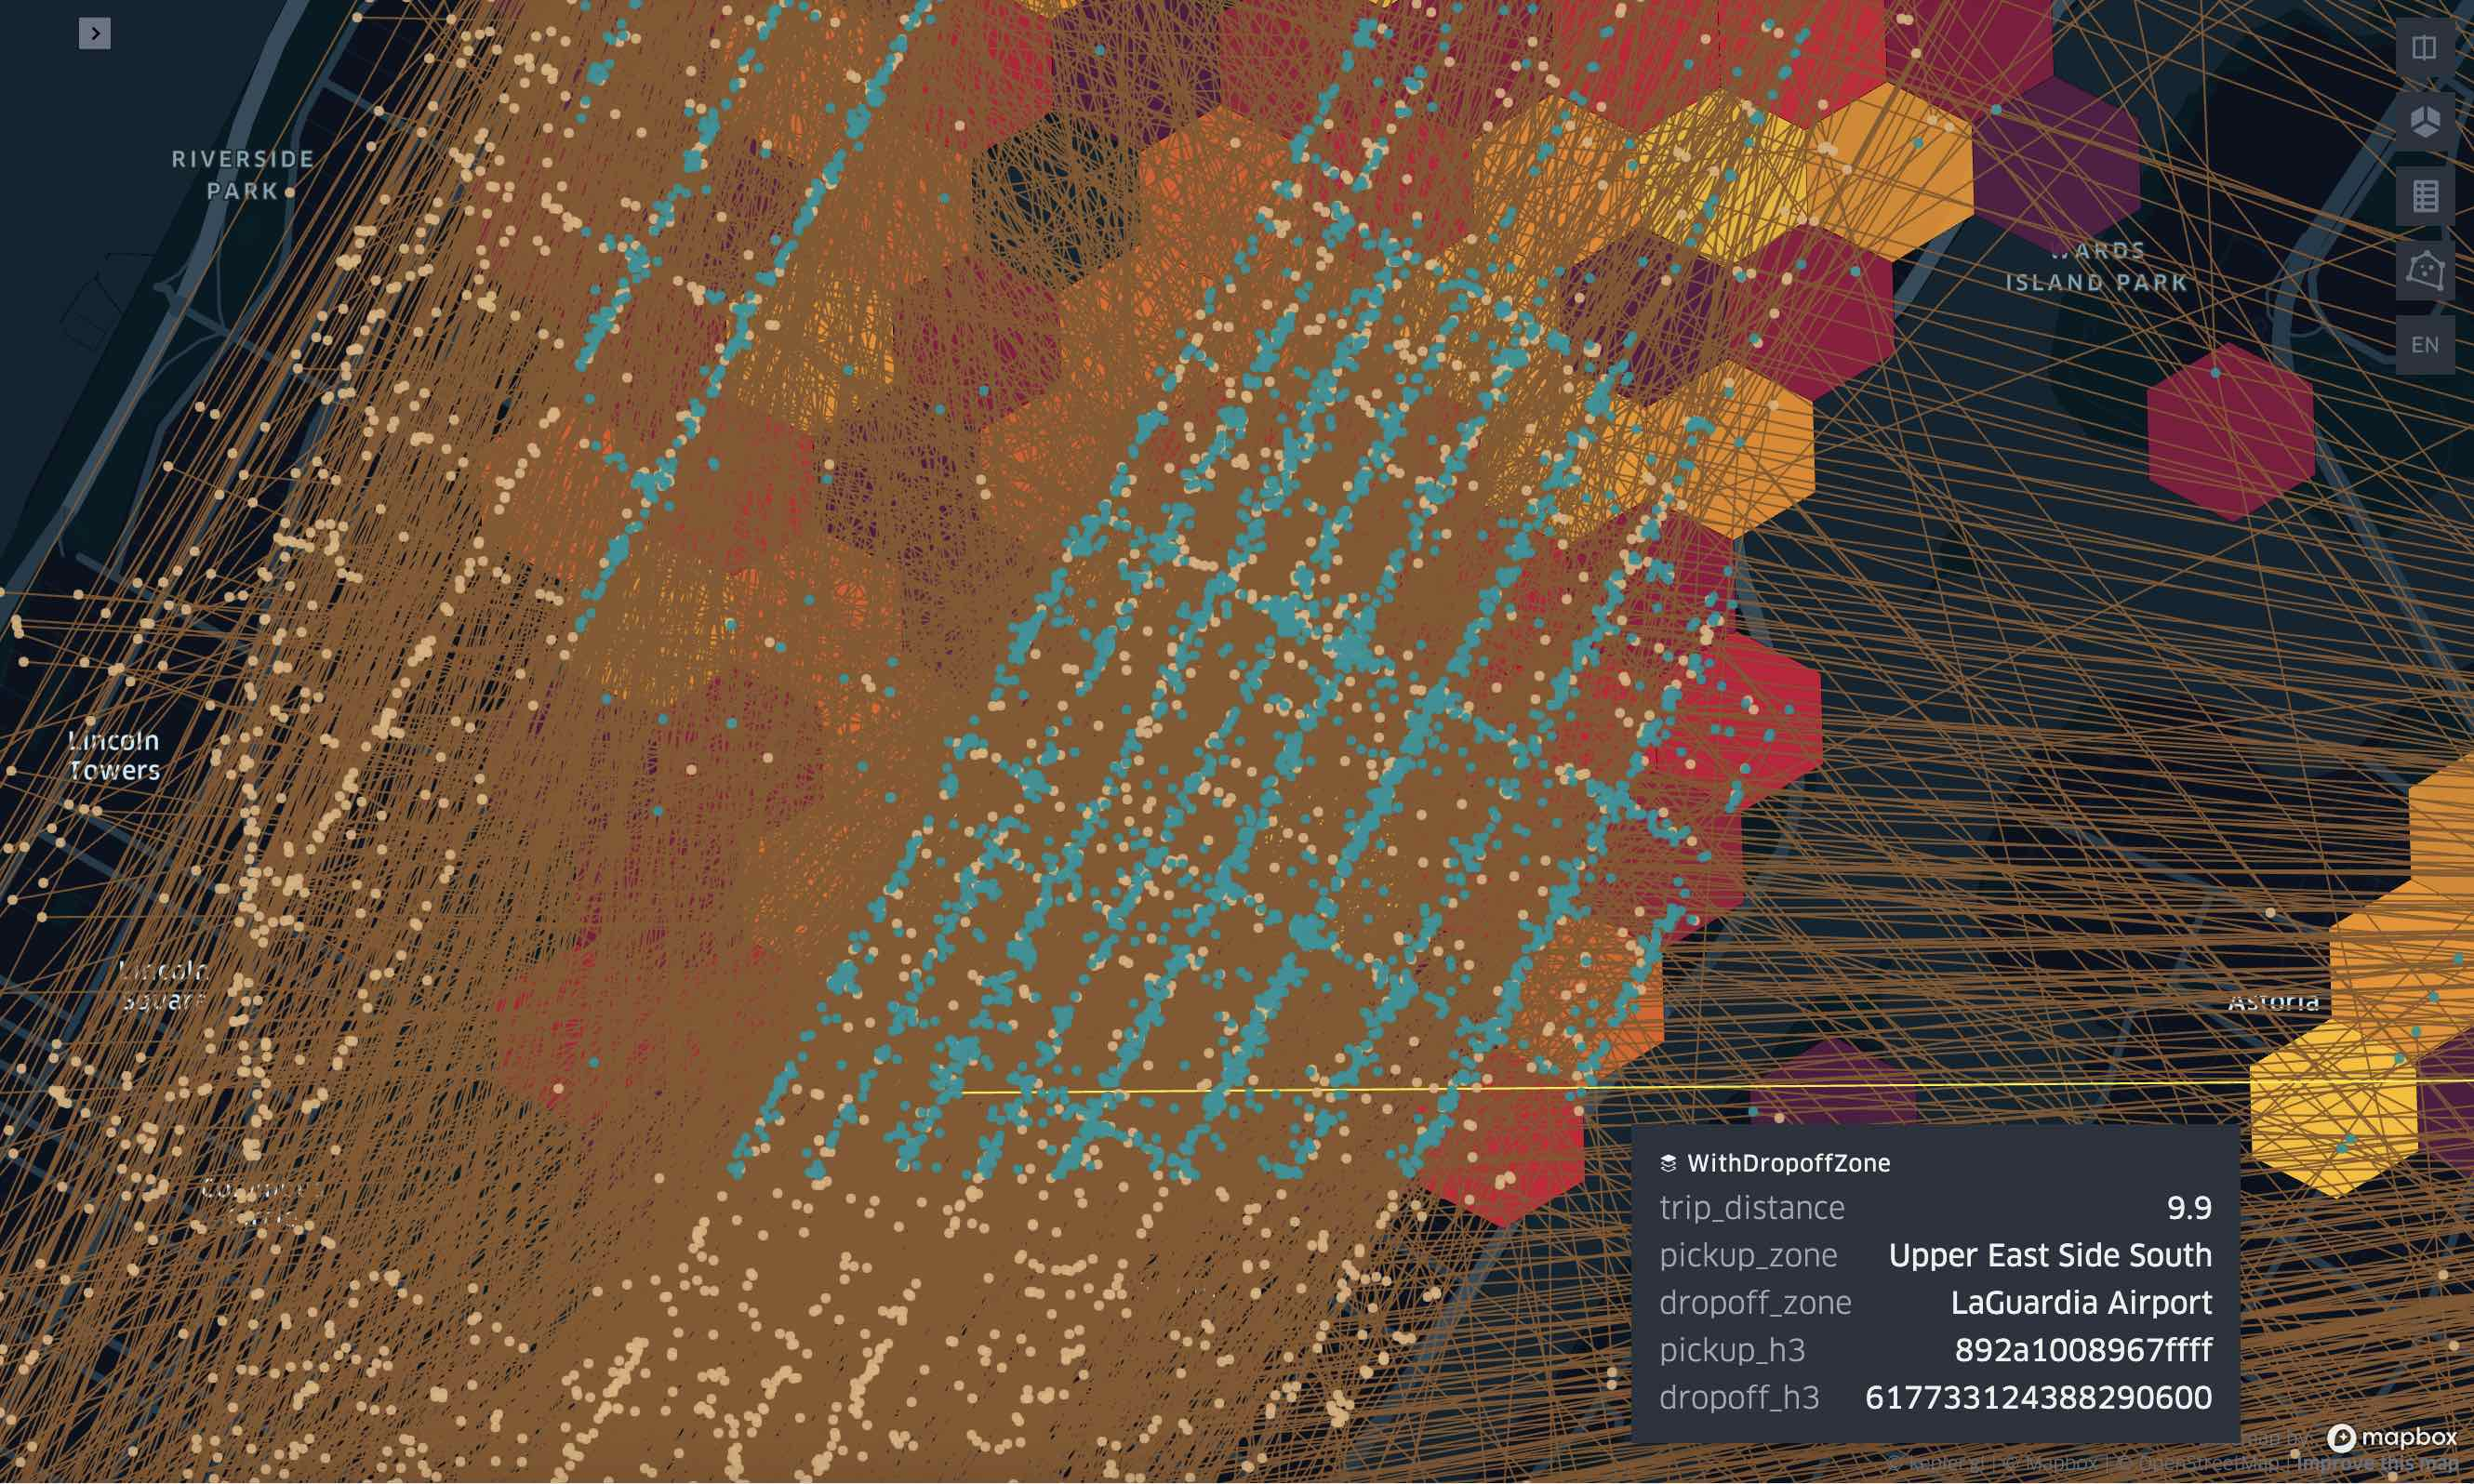

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAACmSgAwAEAAAAAQAABjykBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/qAZhBUk9UAAAAAABjywwAAIcZAAAcJgAAITIAAEI+AAA9SgAAm1YAAJlkAADCcgAA8oAAAIWQAAA9nwAAPa4AAE+9AABwzAAAYNsAAHXqAAAW+QAArggBAKsXAQBZJgEAQjUBADNEAQA9UwEAwmEBAGpwAQA6fwEA2Y0BAOWbAQD2qQEAlLgBALLHAQAX1wEA3uUBAOn0AQBdAwIA2hECAOIgAgBWMAIAmz8CADhPAgCoXgIAoW4CABt+AgAkjgIAyJ0CAOCsAgCnvAIAGMwCALzbAgBC6wIAevsCAAULAwDcGgMAaisDAJ07AwCzSwMAY1sDAJFrAwBwewMATIwDAICcAwDKqwMA2LsDADbMAwDG3AMAfuwDACD9AwCADAQAXRwEAIYsBAC2PAQAQ04EAIRhBADDcgQAjoIEAFqPBAD+nQQAha0EAKe5BAA0yAQAFdcEAIzkBADn8wQA3wYFABUXBQDZJQUADjgFALJHBQD8VQUAlGgFAFh5BQByhwUA95oFAESuBQAMvAUA18oFAOndBQDl8AUA/8AAEQgGPApkAwEiAAIRAQMRAf/EAB8AAAEFAQEBAQEBAAAAAAAAAAABAgMEBQYHCAkKC//EALUQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+v/EAB8BAAMBAQEBAQEBAQEAAAAAAAABAgMEBQYHCAkKC//EALURAAIBAgQEAwQHBQQEAAECdwABAgMRBAUhMQYSQVEHYXETIjKBCBRCkaGxwQkjM1LwFWJy0QoWJDThJfEXGBkaJicoKSo1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoKDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uLj5OXm5+jp6vLz9PX29/j5+v/bAEMAExMTExMTIRMTIS4hISEuPi4uLi4+Tz4+Pj4+T19PT09PT09fX19fX19fX3JycnJycoWFhYWFlZWVlZWVlZWVlf/bAEMBFxgYJiMmQSMjQZxqV2qcnJycnJycnJycnJycnJycnJycnJycnJycnJycnJycnJycnJycnJycnJycnJycnJycnP/dAAQAp//aAAwDAQACEQMRAD8A5eiiirICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKVV3sF9ev0oAsQLgbz3/AJVPSdOKWmIKpXD5bYOgq1I+xSfyrO680mAlFFFIYUUUUAFWY/3UZmPU8L/jUMaGRwg71dW3lvJNsA+ROM9qlvoUu5VSPd8zdK00v7iJNoYYHqKimtpbfHmDA7HtWbJIXOB0qtGhK6HzzvM5ZjnNQUUUDCiiigDRt7694hR+PUgHAptwwuMyqc7eo/rUQ/dQbv4pOB9KhjkaJty1Ftboq/Rk8ZEyiFuo+6f6VVIKnB4IqeVAMSxfdP6GnnFwmf41HPuKafULFUAsQo6mtXMduqw/3utQWsYUGd+g6VUkkMjlzSfvOwLRXEdSjlD2qzboVHmY+Y8L/jTjC9zskUHnhj9KvIgBz6DA9hSlLQcY6kewKogXqeWP86YJFdiF4jTqfXHao7mQqfKTlm6/0FOKBVW37D5nNTYq5JCWc+Y38XT2FXUkeM5Q4qCMHbuPf9BTnOBgdTwKh6svZCvLJK25znbwPrUA+d8dl/nTZJBEvy89gPU077sewdW4/GrQXBPmYyn8KkHLfT+dHCJx2prExptH3mpbjJA25iB0H86dTVXaoWn1DASiilpAFFFFAFyG8MSbXGQOlRTztOQSMAdqrHkgfjTqAJwoAqFlCnAoWQkUhOTk1tOSasjnpwkpXYhOOfSol++zfQU91yMepFOAxWZ0BgdKKO9LSAfH1qeqvShiWG0mtYVElY56lFyle4rYJ4phPIAp1IPWs27u5vFWVgoxS0VIxKKWkBzQAU1eST26UrHApR0pj6AaDgDJpaQjPWgQ1Rxn1qwlvNJ8yrx61DW7CytEpXpgUNjMRlZTtYYIpoq3elWl+XsOaqGkIKap3DNOOccUuMUxiYpyqSaOp4qdBgVUI8zMatTlVx8OEmDtwKs3I5D9sVVNVauSUGmjKEnVTUiVyMYpEUEZNR05WK0udOV2W6bUOWI8oOopinaT70pcnirKRwAYfJPrUyXM/dKhLkiud6lQAk8UqnANSyp5MnynI6ioVxnmszZCYPamHhun41YcHjPGaJE28jpQpDcSKkpccYopkjGA6ntSg5ANH3vqKUDApgJyCAOlMCkSbh3qQ0m0A5p3AWm45ye1LuGdo60pJAyBmkAmMmrKoF+tQhGbBHGKsbgOtb0lbVnJiJXtFEiIXbaKqzKY5SvXFWo7lIx90k+tVHcyOXbvUVJ3ehrRp8quxrMxGM0UUh6cVm23ubJJaITPOKXFAxSKCM5oKFpo6Z96cTjrRigEyJuuKkPtSY5zSZ+emaPVaDsjOKMelMbhqcvUiiwnGyug3sjcdPSplctg54HQGocgnBpcEHjpSaQnaxeWXEJjYHIyM0MI5ERVxuOBVVZZEBXqG65qTeshUKvOMfjWXLYVxsqlX2k5xQWyBxgEY/KlaN1yD2GTTAGOSO1UiS5blRIVH8QBpbhMOGHBP8xVPIGCCc96reeHbGSOe/ekqbbuiubSxoXE0boo/i68dqzZ1kfgH5fTPFIwk2g5yVPOO9LOu5cjqvNawio2JbuJGMKUcg+1S4Vk2jpiqCNtYNVtiI3XHQ8VpKLuIiPlxN0ORU4wxDqBk1ESrOY5fwNS7TGFA5OcZ9qTAC21lVe5okLBcg96ay7pAy/wnBqRBjIPPOfpS0WoDZSqgE8+gojO8bvUc/UVFJl4t3oTTbdsNtPeq5fdAldigBXnHBqVHEi7hUbj5+ejcUkXyAKe5P6VLSsA25HANQt/qlP1q44V8o3bmoTEQgU9AevtVRkrJCEyFjV++MClVy6Erww5pkrB0BHQHFMhz5gxTtpcCzKzhMx9QeabFIHPACnuP8KWQlFLL6801Aq/vV6HjHpU2VgsOUpIQ3QqSKdj5wckbevvSAK7FSPunNBbJAweDj/69SISTd0G0k9iccdqRS+eQw+vI/xpZ4lkwx7U0fKMDimldFxpt6k7IrjDDPekKZHHagElaXdzip1GrrYjZTgClTng9qkzzigMp6U76Du7DGY4yvalBJX3pdqnkd6R1bjb2o0DTYRSueODSlcnI600gn5uhFDEq2R3o9B210HMDkMKUgjGOmeaFbcKBnjNIkUjjio1xnjj2qUnHNM+Ut70Ia2HEHIxTDgnOOKeOO9Jt4wO9CEhQQRmlFIBgYpT0pCYmKbnjPTnvS5BGM4xTCWVefWmkUkW4ru4hOPvr6H/ABoXM0gBPLHk1XU5GTQxXo1Tyq+gn2Ni7mSOMxKRuPGPQViS3MsyiP7qDjaO/wBfWlCqoIU/WmLGQ2T0FOnCMdylbqSKPm+gxUsBX7Wgbp/WolySWP0FRjmQt6VaEjpzjHPTvXLueOO5zVhpZCQhYkH3pbVFkulVuQB/KlHQI6FRRgbz+FSR/Mpro5I0dCjAYxXOxdD9afNdXC91cco/i/AVIsQK4pi8jNTI+BhqcLX1Mazlb3RpQLj0qIABsL9TUrPuOB0FM4GfzpStd2HT5uX3hAck+gpkpIwBT+Tio2+ZlpR3NFuEvCAU9AQNtDDJHtUsWBwepqoq9kRUlyxuiJYijEkfSkJw20d6tvjbWfkmT8aco6iozc1dix5GTUyR85Xp61G7bPlXrU0DBV2twT0pxSbux1nJRvEjljO4elKp4z2p878BV6mmD+6O2KmaXQKbk4JyF70dTSFhv2d8Zp3oKg1jfoN6mlJ5xQPWkHWg2sn8hcAmlNB4pB0oM1d6if1pw9aSl9hQxybDpzVy2tfOXe5wO1VDW9bqqQqo9M/nSZndWMq5t/IwQcg1VB71pag4ysf41m96ECtYsfaJtu3dxVc0HpSGhDhG7Ewad0FIDSn0plybbsxtL3xS4FGMCi4OaEPWkooNM0W3KAp9IPSg9almMnzMRhlTjqaDQxCjPoM0U0XTXVB2o6U6koEpK92HbNJS0hoKhqLmlx2pO9LSM5aWsJR7UCloFJ9Aooo6UErsJRiigetBrayuLjFITmlNNpoKa+0wpaSlHrQy56Kwd6SiloFsgpOKKKCuTS6FxVNx87f57VbppC/eI6VUXYiWiIwuMJ3PWnlgTtU8igqVBK8k02OCY4facDnOKe+pnvqI4yuB25IoIBAdumKd1/e9KRv3iBh2oQELMWNNpaK0LHKu44qxuCLu/Kmxrx9f5Uxj5j7R0rN6sh6sUgICw5z0pifKC/4Cn7gx2du1Mk4O3sKa7DXYZSUtFWUJUq/Ku/uelNVdxxQx3Hj6Ck+wmKnXcegpfMJ+8AaR/lGwfjTKVr6ha+o/CN0OPrSFGHv9KbSgkdDTswsJRT94P3hmjah+6cfWi/cLkdOVN5Geg5p2xgeRSudo2j1GaL9iZvRjmOTx0FKPmXb3HSmVA8xVsJ2q2tNDhT11I5psfIn4mkgYAbJPut+lEqLkSr0bn8aSNGkbatLdD2eg8QNv2Hp1z7VMyrtAb5Yx09TU25FHlAgsBxms92ZmO/rUq7KdkPeUsNqjavoKiooq0rENhRRRTEPjba6n3qd5NrlJBuXPeqtTz87X/vCpa1KT0DylfmE/getQkEHBGKSpxNkbZRuH60aoNGNWaRRjOR6GnboX+8Np9R0oMSvzCc+x61CQQcEYo0ewaolMBIzGQw9utREEHBGKASDkHFSidsYcBh70ahoQ1Pb/AOtA9jRiF/ukoffpUkUTpKD1HqKTeg0tSpUscYb5n4UdTQke9jnhR1NEkm7Crwo6Cm30QkurJhKsvyH5f7p9KY0jKdky7sVXq1HmZdj9ujelJpIabYzy435jbB9DSiHZ80x2j+dK22A4Ay3qen4UwTyA8nI9DRr0DTqI0pI2oNq1FU/7mT1Q/pTWhdecZHqKaaE0yKiiiqJCiimlhQA6no7RnK1Bk04N60gLRRZRui4Pdf8ACq9KCQcjg1PlZ+D8r+vY0tityFXZDlTipsxS/e+RvXtULKyHa3BptO19RXtoT/vYPp+lG6GT7w2n1HSmJK6cDkehqTbHL9z5W9D0qfUr0GtCwGVww9qhqQiSJu4NP81X4lUH3HWndisiCnJJsfnkHg/SpDCGGYmDe3eqpBU4YYNF0xaomcPA/wAhIB5H0p3nI/Eyg+44NEeJo/JP3h93+tVqSV9xt9iz5KvzC2fY8GoGVkOGGDTanW4cDa3zD0NPUWhGkjococVN5scn+uXn1HWjFvJ0Pln8xTGgkXnGR6iloPUm8ndzEwb271XO6NwehFKDjkVL57Y2yAOPenqGg2VQ6+cnQ/eHoar1eiMGSFOAeqtUL27I+3+H1pRfQGuo2JM/MasUgGBgUtaEBRRRQB//0OXoooqyAooooAKKKKACiiigAooooAsW0SzSFWzgDPFXvsMPqfzqtYf64/7v9RWtQMpfYYfU/nR9hh9T+dTPPHHKsTnBbp6VPQBnyWcSxswJyATWZW9N/qX/AN0/yrBoAKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVmBcLvPU/yquq72C/n9Kv0AFFFRSvsTjqelMRWnfc2B0FQUUUhhRRRSAKKKlhTzHweg5P0obBIkH7mHP8T9PpW9o7IIDGThs5/CsAnzpd3YdPpUpOBk1PLdalc1nobmrXESQiNgGYnpntXO+ZbnrH+pqBmLMWNNoULIblcs77f/nn+ppN9t/cP51BmjGelPlC5Y3W39w/nUka20jYCsMDJOapVab9zDt/ifk+wpNDTHSS28jZYN6DGKZm19H/AEqtRT5RXLsclsmRliD1BqRIY1kXyy3IyDxis6tW3/dQjzDjd0z2zUSViou46fyymMkAHnFUttsf4z+VNDPBKd/OevvUyWwMgdeUxkf4ULTqD1OwiRI41SPhQOKxr1o45WOcAdfqajS5nhjwGyScAf0rPug8sqxjvzn696zjG71NG7IdEke43JfcPpjmpVjUkqWySdzcduwqN9q4X+CPk+57CrEKFVy33m5NNvqJIlqPqd4PsKWTdgKP4qlFnNPETGQoPAz6VKGyjtRpBLuBVeB9alEfIyc44/E9aa1s9vKkDdFG4nsTUiDJLDp0FUxIftywJ6CmgbpN2QQOKSSTYpx1A/U9KWJNiBe/f61PQq5LSUUm4dfTikMdRRU0MLzHC9B3pAQ0VYmtniG48j2qvQAg96bJu2kL1NPpuPmzTQCgYGB2paKaeAT7UAB6jilPSgdMUtADG3BMDk1MIziogQW4/hNWdy+tawinuYVpyVuUg6UmOc0rHLUD3rJmy21CiiikMKKKTNAAaRAQoz1paWmA3GWz6U6ikoAWkoGSMmmSOFwPWi3QaQp+ZeO9EYKil7CnUX6Dv0Ck2k4PTFSKrE5XtTTzzSuKxtRRRrGAAOlZ13GqS4TuM4pY7iZI+MED1ot28y5DScmkKxXKSKNxUj8KmUEDmr8kyglMZHQ1SJA610Uotas5K81L3UQPuzg1HUkhyeKYOOayk7tnRTVooSiiipLHnaMEfjU29cVWoq4T5TOpTU3ckkcyHJ7DAqS3hEr7ScY5qDBxmpoJfJfcRkYwahmiVkXZbYBNyk5XnmqDSblxirs12pQqgOSO9Z1KxXMxKcoyducZptO2kDdTYkIVxkdxTRnGDUjMWOTTKED8hrKGGDS96XjtRTEIqruye/FdAqoq7cACueYZHFWkmkZfLY5AppXdhTfLHmJZAA5C4xnjFRuhZCw/hpwcKQW6CnTXKNH5cQxnrW1SVlynHRhzS5itGByaVwMVGCR0pCSTkmpU1y2NnSbnzXCkOccUtJWR0Ib0H86d7imnd1FO6igp7XA80D1pACBigcUC8gOCeaDwPWmjO6lzjimVawpA60hJC5p2M005HAoQJ7IM96YGIp+eOaaV9KaNIWWjHg7hTXGfpSrxxSElTS6kpe9oPWV1GOueOaGmKKQnXHP0pBgjNNZckHtyDSsr6kSeowsVZiPQGhirEdM9RmjacLn0war/AHos91/lWqSZBOSiPk5BI/CpiKrIwaPDDODVg89O1TJAVXgwflP4GlkVvKUt1HFSMzcqOvUUsb71GR14quZ7gNYKwEzdhzSwyGTIbtT/AJHUovTpQkYjBA5J71LatZgJlFkx/EacF27iO/NR5Bl2t1HQ0IxTdn+9ihoA3blU9myDUEQ2yc/w5q1tGML05zUci7QznqQBTT6APf8AeR7h9aQngSnsM/iaS3OUx6U6RcoUH4fhS2dgHEBvxGKRM7ArnmmqwEauTwBTJAQH/A0JdAHSRfIVT1zUCAorMevSp4pPMUq3UUSY2gNkj1qk2vdYDfM/dBiM84NISIlAXkMc05Y/3ZXOcng07IU/N04Ao0AcygA46tUcDsykN26GnM5WRVPQj9aif92yIPUmklpYFuTk7WGemKRlGeODSsRgZ6GlIBX+tSaeY1eOvY04rnGO1IpJyrU8fpQxN6jSQ2VHWo17/SkOQ1SgBvmHfrT2K2Q1flHPenMxHTtTM7nFOB3Umga6gJB34p+FYZ61XIwcVLH0NDXVBKKSuiQADgUhHBxTCx6ryKkzUkNNB1FMIwpp9AAHSgSZGmSCDT6Wm8gnI4p7jvccM0EgdaM9qY4BxzikgSu9RVTLY5qRoflxnNEOc461YrohFNHJWrSjOyIfKOKrkYck9BV/NWYbaMxhnGS3P51NRKOxWHqybdzBQl0z3apRwu1fzq3dxJCwEQyD2HaqrbVXb0qDpUrjkbdk9qBt9Md6RBhRjmhsqCV5JqeodQ2jdvo3FOYzg9abHkAs1R7yxwRmqsOxZkurt02E8H0pqrtXFMUID9KkiDM5z0otfRCnKyuNJCqSPpSoMKKsNGjDGKhIyMUTjymVOqprQRelRucjA7nFOYE4ANBX5tx7VK7mq7i9OnYUKDxu60NwvXFAwU9qAF4HAqAqzPnsakZsJu9aZEDyapaK41orkmeST34pBjPPJFDuFwDS8bc9D70hEbYU7z1PQUkeWfJp0ilgG70IMLjuRVX0K6EvU80xB1J9aJOBn8KXB2Y74qOhPQijyXLn0qbuKYp2sIx6EmpB/Sm9y092IfSgUUopFvSI09aXHajpyacKAlK1rCcDmlpOppwVmPAoSbMZNL4mN75q0l3JEgXg49ahMZUZ61GaHFrcIzjPbYkkkaRt79ajo70mTSKUb6ge1HUUppB7Uyk/duLTfenHpik60Di1uw6CgmjvmkNBUY3lqKDS4BNN7U4DihkzXLqhfek7UE9qM0iNbDJf9Ww9QacKGAYFfXilxgYp3LUrKwdaO9FFIV+wZoHNJS/SmaTSSsgp6oSMnipbVVedQ3SrssTbiQMg1UEm7M4685RjaJmlSvBppqYq0rbYxkimPFJGfnGKmVr6DpttJyGUn1oPNHU0jojFdQ606lCnHAph9KdmRfnlyxYlLRSUG/W4UvtS0hpGd+Zid6U0goNM0avJIKKKKZqFNJIb+Qp/SmMfU9eBSOaprqhvHmox+7kV04xXLKNnD9+1ONxcJ8u847VTjfQzaudIyIcqQMVzsqiNnCHgNxUh1G4K7ePrjmq0ZySG70KLQKNhCBJyvXuKRFyeegpCCjcfhVlR69e9U3ZDbsNdtq+5qIfKme7fyoP7x/akY72wPoKEhpCr8ql/wFH31x3FI552joKYDg5FO3UduoUVIw3DePxpEA++egp3C4p+Rdvc9aRflG8/hSDLt9aHOTgdBS8heQ2iiiqKCiiigAoop6Lnk9BQA9SUXPr0ppZT94dx0pGO45pjHAz6UkiGtGSsOMIRk9Aaosjp94EUjMXbNWot6Abyeei96pto4kkxsCtIpjP3T0PvRI4iHlRcepqaSaMfuzke69qjkj8395EQfWoT1uy2tLIpgkHI61YYecnmD7w+8P61CyspwwxQjmNgwq33RmuzG0VNKg4kT7p/SoaadwasFFFFMQVOfmgB/unH51BU8XzI6e2fyqWUiCiiiqJAEjkVOJsjbKNw/WoKKTVxp2JzEr8wnPsetQkEHBGKQEjkVOJQ3Eo3D170tUPRkFWLbd5gx070CAOcxNke/UU9XCusSdM8+9Ju6shpWd2Ek6MSjLlc/So/Kjf/AFbfgaQxM8jY4AJ5p29IuIuW/vUrW2HvuHk7Bum4HoKY8pYbV+VfQULNIp65+tO3wv8AfXafVaevUWnQFcSDy5PwNRMrI21utS+QSMxkNSg7h5U3B7E0X7BbuV6cruhypxSOpjba3WmFhVbk7FnzI3/1i4PqKQwkjdEQ49utVSSaASpypwaVuwX7inOcHim1YE+4bZhuH60vlRyf6lufRutF+4W7FainOjxnDDFR0wsPBIp4INRZpc0xFxZFcbJfwPcUySNozzyD0NQBvWp45do2kblPaptbYq99yOipni43xnK/yqGmncTViZZiBtcbh70piV+YT+B61BR05FK3Yd+41tytzwRUouGPyyAOPenCUN8sw3eh701rc43RHcP1peoeg5UjZt0LbW7A/wCNLcxkYlxjPUe9VtpqzDKVO1zlTxzQ01qhpp6MZ5S+9HlL71JRVEkflL705AYzlSRTqKBisQ/UDPqKiMan1qSigCPyl96sJIyIEHQetR0UmrgtNicmNjhhtPtTTGQMjke1PkQ439+9U3lZThDihbaA99SJmLNmm5NWBcsfvKrH1IpftH+wv5UXfYVl3P/R5eiiirICiiigAooooAKKKKACiiigC7Yf64/7v9RWtWTYf64/7v8AUVrUDKd95HkHzvw9c+1Fl5/kjz/wz1x71I9vFJKsrjJXoO1WKBkU3+pf/dP8qwa3pv8AUv8A7p/lWDQIKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFORdzAUAWIUwu49TU1FFMQVnyvvfjoOlWZ32rgdTVGkxhRRRSAKKKKACrL/uohGPvPyf6U2BQSZG+6nNKuZHMjUt3YeyHou1cVFM38A/GpmYKMmqRJJyaoSEooopFBRRRQBYgUM+W+6vJqORjI5c96ml/dRiEdTy3+FVaS11G+wUUuc9aXBJwKYia2i82Tn7o5NFzL5r4H3V4FTyH7PAIh95utUQCxwOSalau5T0Vi0h+0J5TffH3T6+1W4yqYtlyTj5iO1RKq2sZkPLnip0GY95wrsPmPtWcmWkRzv5S5HHGF/wAaW3DCAMRlv4fxqJSt0xjIxt+6R6VZ3hG9APlA96HtYF3NxLC3VAjLuI5JPc1UaJUuRH/DkVJHeusYEi5Yd6ozys7Z/ias1dsrY6HAxjHFVIrm32su4LsJXk46Vi3F/cqBAjct+eKoSKXkW3TkDr9e9UodxORt308UpVEOc5GRVXCgbAeF61CpwTLjgfKg/wA+tNYfdh6ljlj/ADosO5IqMSC/ruP17VYpg6/zpxPQetSxoY7EDC9ScCr1raxyrufkKeB71RbaGDHr0H41ct5zANuMg0MCe5tkRPMTjHWm2cyKWiY4PXNNuLrzV2gYHeqKdNx780JaAa13NGYiikEn0rNCsxwoyfakrUsQvlkjrmkMy2BT7wINIK1b4L5YJ654rKJwCfSgBByx9uKXtikGcDPWkQkrk+9MB9TBBUNSrIMhT1NaU7XszCvzWvEiMewnHerCooHSpYxukA96sywKAzg4wM4q/di9TK86kdCB4Vkh3KMMDjjvSGxfbkMM+lRi5IKjGFBya0DcQhd24VhJ66HVFNJJmKwK5GORRTnbe5b1OaYTgZoKFpuOKXoKWgAooopANYkYA7mlPTil60hOKYCLyM+tQyrvkC+1T9uKuWkCSks/IFNO2oFTFLWjcW0axl0GCKzlBY4FSBIpYDA471GKkdWAG45qPjBNJFvsOPyqMHr1pqkggjqKSimiGy2WycnvUMhyfpSeYcUw56nvW1Saasjmo0pKV5CUUUvSsTpAAk4FIPelHFJQAUpGDSUUAL7VY2gOB2Iqt0p5dm60mi4tLcQjk47UnbFL06U2mSyR8cAdhSh/k2mmcYz39KerhT04IqbaFJ6jO3tTaWkqiWBHy5PSilzxikUFjimk2JtJXHKpY4FSNCyjcCDj0pyLtpx4U/StlS0ucrxHvWWxWJJ6mm0tIowKxOpJJaC0UmOc0tIBoOWNGecUAY5oPQmmXpfQaDk5HWnd/wAKYg5zUgOabKmrOyA9KQetKTiikR0EB5Oe1RknPNSEYyajB7GqRtDuh4PzGgNmlxyT60xeDSISTTHnnoaTkDB60Y5zSBvWgEm1oCk96dn8KMA8ikINAtGwO4CkL7V3Ghs8Gm5DKwbtTQSXu3Jcg1Hghu2PpSKQVUoeB60jHD4BwffoaEjMYjtv2OAKeJMbuOhp2RuAPU00xjLY/iFO66gPYqOeM9iaDlR8gHJpIwSgDDpSBg4ZeuKVgAsBnYOoz9aQyFdpx96kQKQAvOD0+tMJ3s0Z/D8KpICUv+9CEfjTjtcc+tRc+eCe4om4TA9aVtVYCV8gcLnPWghSnIJH61GGZo1IOGP60pm2EK47c0WYBGEHMfQ06TAZTjJo8tQwZRj6U8gkEdDSb1uA0qpQrjimna8WecY/GhAyIQ3ahflDAduRQBHF5ZJCZBxUoZWJA5x1FRIuJdy9CM1XUtvyvWr5biLqKijKHjrSEI7g55AzilLBVLKMnvTH+aLMfepW4xxVW25zkcimsU37WPPb2pqv+6y/0zSvHv2upzj9aLW3BEhUbcZ6UKB0BzSocjBqNjj5RS8jVdibg9KQcDr0qPJ4cfjUhHBxSsTYayhuQaVRtBzTU5G00u4EHPSnrsN32F2gNkUwDBzkU/ouetREY5HSmhokZd3IpwAUYpkeefSkcnd9KVugrP4RyqQ1OA6+lNbgE+tMVsGi19R2b1Jz04oHvRTGJBwOpqTNaj6Wk7Ui5xzQAtIyb+KTOOCaep5+lNbid1qiZIlTp1qSiiuw8uUm3dlNnO488CrkF6VjCsucdKheNWBxxVYBt2egFc0423PRpSjKOheJ3HNUJtvmEnn2qRnYKSKgGxz6Grc7oVGi4tybJugFRSE7tq1MeopuFDbu5rJM2TDkcHoBUXmL0A4oDFmY+xpsa7mz2FUlbcpLuSEIF29M80+IbOQc1AxLtxVpEPQdqHfoTOyjqSFyeKjJAGTTypWq5ZmbA6Ck7t+8Z04xt7o7ndx0pOFOD1JpSwHQcmlyC2PSpNBjuQOPWgt8gBHXtQyBsAGnFfmB7AU9B6DH28IeMVIAFGB2ppwGLHrQMYGep5o6B0ArltxqPOXIPQ8UEkAt69KaJGHeqSZSTJFyB6bTzT85XcBnPpS4BXkdetatgEMRZeucVLfUhsymHTPGOeaDwuT2rT1BFKK3fdWVISMBaS1BajEwz7+4GDU3QUxFJO5gM1Ifah7jvrYb7mjvgUdKBwKDR66sKdSCj3pES1YVaXpVWlJwKuE+Uxq0nOyRO7gA1XFJ2pR0onLmLhSVOLSENApKcKl7HRJcsBD1oHWjvmjoKBdEkHOaXjFIfSjp+FBNrq4fSkpTQKZpG6XMH9KdSe1HvUmLdx8cbSvhKmktJY13nBA5OKWzkWKT5+NwxWhPPGsTcgkjAAoY23eyMM9MetKmQgB64oHqaTO4ZHemacqk7DqOtFB9KRCjd6BijHFJTqbHNNaXFUlDuHBFWGupmXaTxVbrS1Jk/M0bArtYd81JelfJwepPFZQJXkHBpCWY5Y5+tMpWvcO9OVMjNMFTowxg1cEm7MyrycV7o/oKrvgtxTpHycLUdXUl0ROFoyj+8fUSiilrI721ayAUZo7UlBEYq7bHU2lzRQghdasSgUdaU0FuV/dE61FJgNk88cD+tTdOaqy58z8KqO5Etdthc+YMHr2oHzDY3UdKjqQ/ONw6jrVtGdiMjHBp8f3xSn5xu7jrTF+8Ke6GTRjPDdjxSyNtG0dak4XJ7CoRiU5PUdfpWe7uR5i9V44YimL8oLHr0FNJLvx+FSthztHUfrVbDIKKCMcGirLHISG470+QYwo6Ug+Rd3c9KWP5sqelQ+5L7ifcT3b+VR0587jmm1SGgooopjCiiigBVBY4FSMR90dBR9xfc0yluLcKays4KrUgXIyeBTJG+QqnHFF+wnsRjbEcJ8z+vYUrMYu+XPU+lIMQLk/fP6VW68mmlc4m7BUsLhWIb7rcGoqKpq5Kdiw0kkbFHww96TMD9QUPtyKU/vYs/wASDn6VXqUhtluOMjIGHRuuKryRmNtp/CmgkHIOKtxS+YPLkwfTNGq1Ho9CnRVgrCxxyh9DTWgcDI+Yeop8yFyshqaA4lHvxUJBHBpQdpB9Kb1QluDDaxX0NJU04xKSO/NQ0J6A9wooopiCnKpdtq9aRVLEKvU1bCbVKocf3m/oKluxSVyNm2DyouvcjvU6kDb52C2RjHX8armRUG2Ef8C71GhJkBPXIqeW5V7FmZXcnYcgdhVMgjg1LKSsrFeOacJVfiYZ9x1pq6QnZsgoqcw5G6I7h+tQEEcGqTuS1YASORUv2hgMNhh71CTimE5oauF7F3zIJlCNlT2PWoXtpU7ZHtVerkM2R5bnHo3pU2a2KunuU6KuPIVbZcKG9+9M8uF/9W2D6N/jT5hcpWoNSPFJH94cevaoaYrEyTuo2nDD0PNPxby9/LP5iq1FKxVyZ4JE5xkeo5FQ1Ikkkf3CRUvmQyf61cH1X/CjUNCvmlqY27HmIhx7dah6cHimncloekjRtuWpyqyjfFw3df8ACqtKCVORwRSa7An3HZ7GlyKmylxw2Ff17Gq7KyNtYYNNMGh24UCQqcrxUdFAi15scv8ArRtPqP60142Qbuq+oqvT0keP7p/Cla2xV77lmiiimAoViMgGnpFI5wB+dWRI0dsrL1zj+dOt5pJH2seMUCKWxvQ0hBHBGKn+1Tev6U67/wBYP92gZVooooAcJjFz19qJfKLjcvDdGWqbNuOat2/zJsf/AID7VMl1BPoPWEAYVgfrTvK91qMgg4NFVZ9xXXY//9Ll6KKKsgKKKKACiiigAooooAKKKKAJ7eYQyF2GQRjirv2+L+6ay6KANT7fF/dNH2+L+6ay6KBmjJexvGyhTkgis6iigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVZgXgt61W6nAq+o2gAdqAFooqKZtqH1PFMRTkfe5P5VHRRUjCiiigApQMnApKsQgIpnb+Hp9aG7DSuLL8iiBevVvrT1G0YqOMFiZG6mnu21c0JWE3chlbcdo7VDSUuaYxKKXHpSUhhViBRkyv91Ofx7VAAScCrE5CKsA7cn60n2Gu5A7F2LHqabRRTEFXLVAMzP91f51VRS7BR1NWrlgoFvH0HX61Muw13IHcyuWPU1aSPyiEXmRup/uiowBbLuPMh6D0rp7fT4I4sMu5mHzE1MpWRUUc4MTS5/wCWcdLPM0ZG37x5PsOwq/dQR2jFEHyY3fj6VlwRmaYu/QcmkrPUb7F1UCqXQYZ8fhQmydw/P7s49jTZJdpAxnecAe3rVyGAhdkS5xUMtGjawRtH5jjJNV7+GKJfPHHY0sc0tsNjLx6HiqF7eC5dbdl49AehqYrUGZyuRuuW6nhans4jtMrdW6UySFpGRI/uDjP86vD5flHAUVpJ6aExWpuW8aJCu0DpWdewok/nAclcVSGozwxny8EE4QGpmkeVsyHJFRZoq9xAMDmkxyT606tCKyVkDOTk88VJRmAZbPpwKfWvDZxpnd83pmo7u3jWPzEGCKLgZlITgZpg+Zyew4pTywHpyadhXHDpUiSPGcocUykNIZI8jyHLnNREZ4NOFFMBjEAgHvTgMDimFgGAPU1JQwCoxy5b04p54FAGOBQgHo7I25TyKle5lkXaTxUFJ70ALSH3paQjIwaQCISVye9KaAABgUtMAopBzQaAFooopAIOlB54paTnPtTAWpIbhoHY8EelQkAkD05pHOB9aEBdluzKmwLtz+NQxnBzjNRCpAo2lj2qWVHcHYsee1NNKwxgUqoTz2qoxvoiZzUdZAqZGaRl21P04qFzk4HatpwSictOpKUvIZSmgYxSVgdYUUUoBPSgQlKDg5pKKAHKMkZ6GkIxTyflA7imk8cfjSKaG0vanRgM2DQRjK54ouFtLiLnOR2ptOIwBnvSUxMU8dOlSqgaPPeosfL170BiBgd6TRSdnqJ3pKX2FAGeBTJEpyMAee9IQVODUqxjHNaU027oxrSSVpC7hmlYgAk1oW6J5f3R6GqF4qxy4XoRV+1a0aMo0E7NMqjmlpAMUtYnWwoopO9IQtJ9aO+KO9MYAY6U0HnFONIOeaBrq2LwRRSDrxQBzmgBW6VF8vvUtR7cNTRpTasx5IFJgfnTW5bFKxxjFFgUdrC5B6dqbgetKCM0EfNTKWjsKOD1p31qIdaevI5pNEzjYXHHNMVcMwyDmlJIApFKs57MBQQ07XIhEwjZD9RT3EvBXkEcg0q797K3Q9Kayq8eB8uPWrvrqQSIDjkYx+NAVgRg8DrUMMbK2T0xUmcfIOD2pNa6APB5xipo4kUEgdeaqmVQ+1uPerAdlXA5+tOD5XqZVYtq0RjxhZN68ZHNQvjzORz1BFSs5YfP8pPFQyl1UHOD3pt3loVBNRSZIV+dT7VDLyG/3qnjOVGeuKYzMynyzyDUrRlkYXdCuPX+tDhZWIHDD9amRmKjf15/SqvnPntVK7Yi1CdyDPbilLEOAehFKM7ecbsUxZAybiOnWo8xgu1ZCgz/AEqQDPWmnG4NgemaVSCTj1pPuA1AFG0ZHPGai8to8sOSelTMQD8w4HegopO4dfrVJgRAtHEMdc/zqXowK9OmKN3BJHSoo5ELEgEdzRvqA6Qb0Kr1Hao037F29jg1OFXJdT96ggOCoyOQfrRfSwBwynbSFdwz3oXaM04YxjPXpS2NNiJf7vrUoOAPemlQfmBpxG4Ag0Ng3cDxyOppjDAPvTjg8E/Sl2krgmgSIwdq596fheg701l4AyKVV455xQ+5TtuKfkFMPzLnuKkIyMNSKm05zRcSY1x8o9uKRFzyalA6jHFRtuPQcUJ9AT6Eo5puADmhAQOaQ9duOKRPUMkvgdBTuCc9e1NPGcUqcDFA3tcAC+QBz0pwVl61JHjn3p7/AHa05E43OaVZ8/LYjDkDFG9s5qNu1KenFRzPuaezj2HGUH5aiAbdyeKa4wdwqQdPrTlJvUuMFBe6MZ9rYNKI1DbhTXcK3TNPVgV3Uug+gcknHSmsByenGKRlYLtTvSswVQGot2HbsRqrDI9qfxGnNKj5BOMAUjhW4zginrfUfXUajEtgcCrcZAzmq8aFck1LRzWd0Z1YqSsPldQhzVNWLMB0HpVwWs06ApgD3qsYXgkIkGMDNU5X1ClBQjYQkF89lp2OWPrxUR4TPdjVipehb0Ix98t+FPdto9zQBz9KRsbhml1F1FJxwec0mVZj6imjlyx7U1DhS1Fh2FZAQMHpTVj5znOKjBI6VPn+Fuccmqd0U7oUA4IPU0+CWSFcoceopi8ndyPantuA4FSyG+g9pZJcNKahfOcDgetOOMgUhKsdlJAhVPApegpjKS646Dn9Kf70DQdPpQOeTR1paRT21Cg0UlBCQf1pDyaXtmkA9KZrF21DrSngYoAxSNQJO8kNp46Uyn9/pQzSsJ3o96B0oJoISu7IPeigdKTtQVu7IM04cU2n+1DCrpohO1IfSl6mkHrQZp21FzzSnHekGKQmkFrvQOvNNjB2KD1wKU8cULuCgNyaZpdrYd3pOtO70n0pExlYBQeeKOgoHFAr/aFooo70Ga1CjNJ7UooKskrigZ4FPKEDIpFODzTmkGOOa1hGLWpyzlU50oohpKXtRxWZ3xlbdCUtGKO9ASkm7gcdKMUlLQDTjGwhoozS0FOXLGzQfSk6UtFBC2A1BIm5gQecdKmqvN95fof6VUdy5RtHQYVZeopASDkU4Owpco3UY+laepkOALENH1PatQaafv7gD6YrOhzHIrqQQCK3zd24XcWxWUn0REn2MG43IfLPbrUWTGoA6nmrE5Esvm9jk1VOXb61cdhrYk4AMgqGpS+1to6DimMu08dD0poaHcSDB+9/OmquTz0HWm1OeRsJ+ah6A9CJjuOac3yrs796FXblm7VGTk5NAyQfOuO4qOgHHIqRvmG8fjT2DYjooopjCpEA++egpiruOKkPzHavQUmJjSSxzTsBeW6+lGQvC9fWoyaNwFZix5pT+7Qt/FjilACjc34ConJIJPpS8hMqkknJ60lFFannhRRRQA+N/Lbd+dLKgRuOh5FR1YT97GYz1XkVL01KWuhXoooqiSw375N4+8vX3qAMynKnFKjFGDDtUkqgjzU6Hr7Gp20K31F87dxIob9DRshf7jbT6GoKKLdgv3LU0bbEbGcDBx7VVqzG7CFtpwVOfzpvnK3+tUH3HBpK6G7MgpQpY4UZNWhbo+GVsA+tSPiBMRjk96Ofog5OrGAx2688ufTtVeSRpD83TsKjopqPUTl0ClX7w+tJQOtUSSz/AOtaoqmuP9cfwqGlHYctxQSDkHFTearjEwz7jrUFMJzQ0CZO8JI3xHevt1qtTlZlOVODU/mxycTDn+8KWqDRlaip2gbG6M719qgpp3BqxajkWRfKl/A+lQSI0bbWqMmrCSK6+VN07H0pbbDWu5Gk0ifdPHp2qTzYZP8AWpg+q/4VDJG0bbWplFk9R3ZZ+zh+YWDe3Q1AyMhwwxTanW4kAw3zD0bmjUNCCirObeTrmM/mKRrd8bkw49qL9wsQAlTlTg1YFxu4mUMPXvVcgg4NJTauK5Z8mOT/AFLc+h61CyOhwwIplTpcOo2t8y+hpaoehDmrCTK48ubp2PcUYgl+6fLPv0qN4ZIxkjI9R0oumFrCyRtHz1B6EVFmpY5ig2sNynqKdJENvmRHK/qKL9wt2K9GaKKYi9RRRQBab/j0X/e/xotP9b+FOUJJbqhYKQc81JBEqPkOG46CmIz6tXf+sH+7R9nT/notJdFTINpzx2pAVqKKKBkPkOrfMOPWp845ojZoxgGh3hf5Wyp9R0ou1uKyew4PDMN0hwRx1o22v979ah+zSHlMMPUGk+yzen61GncvXsf/0+XoooqyAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopCcDNAE0K7nz2X+dW6iiXYgHc8mpaYBVG4bc+30q4zbVLHtWaTk5NJiEooopDCiiigByqXYKOpqeUgkQp0X+feiP91GZj1PC/40RLgbj1NJaseyJAMDAqpI25vYVPK21cDqaqVQkFFFFIoKXPrSU5VLMFHU0AWIVCAzn+HgfWqxJJyepqxOwXEK9E6/Wq/BpLuN9hKKXFSQxGV9vbqfpTYkWIQIIjOercLTcC3G9+ZD0Hp71PM6p856jhF9Pes8lnbJ5JqFrqW9NCaJfMcvJ90ck1uW2qSNGS6A4OAc9ax3UjbapySct9amlcQx4Tt8q/1NTLUa0C7vJZZ/kPTjirIJVBvIJxyao2kW5vNbt0+tTTku4gXq3X6Umlshpvclh2TN5+3BHA5rfsivlYHXPNY6qEUKvQURswJdSRnpj0qHqVtoamoECIcZOelc9KnklpxyW6e2anedpZfK3HI79fwqRJBIWUZG04NNXQaMrWi7E3Hq/IHtU02WXykIDN/k0/JXc8mAB0+lVFkiYG4YFT90d/yp7u4tlYVE33OP4YhgVdXHIFIo2oATk+ppQMLipbuUlYXNacV5EqKkhwwGPristTkZximxtvy/bPH0pWA24blpZSFHygUt4GaBivYZx64rOt5vJkyRwRzVma8jZCiZJIpWAzo0IAUck/zq8NPcKTkZNRWpAnUtW3kUNgc6QVJU9RTSa3ZIY5AQVHPesFsZ2etCGHJH1pScUd6hlkIIVapK7AVBubcwwRVlV3cmolztGetWlGBWkFzPUwrzcVoRmP0p6jAp2e1MfI5Fa8qjqjm55S91sbJjio6M55NIfauaTu7nbTjyxswoopaksKKKOe9ABSdT9KWkHSmAtNVs57c4paaDlsenegCQIz8KCfpSEEHBGK2LQKIQR361XvwvynvSAzCMsD3FO61GTlwMHjvUmOvvVMBFB5z3NSZ429utNoqWNBVlFLKCBVcDJq7a3CRrsfj3qoz5TKpT50RyxyIgc8A8VAqk81burhJVCJzznNV9wBIqlLml7xLi4Q9wYV2nPWmmnuwPAphOTmpmlfQum24+8J7U4gqSO9Jj5c0dak0Dtmkop6qScA9qAtcbmlONo9acDtBU1HSGKCQcinNtwMde9IqljxSUC6DuoyfpTT1oFTRr5mIwOSetA9yLGDg0nfNaL2e5flPIFUWR4+HGM+tAhnbNKpKnIoAznPYUgGTinvoF7ajjuc5PerCAcAmmgdPalJArqpw5VqcFarzvQvSuLWLC8k9KyHdpW3PyaknmM756begqGuY7krKyFoPHNIKCM0DAdMmijvSD7xoHYXjOaToTSgYJooC4nbIoFByMUY5z60D6CZ5NLyKTrmkPBFMdr6D6KQtilpEWExg5qPtUpGRTAT0NNGsHpcZUvUVHx9Kfj5eKbLqa2GgYNB449KUZBx2ppHegE7y1Htyuaq5xcD6D+tWh0FU5fll+gFVDsZt+60WSWWXHYin7VI9j/Wg4yM/hUfLrx1B/kakyGqzgszDAUcCkLp8shHXuKkZxzu5XA/Wo9itGRGc9xVLzAJo2ZsrzxUiE7efTp9KgkyY1Y8EcVJBIzEqxzTafKA59ykCM9O1ORt6HIwR1FMcLJlQcMvNCM4OHHXvU20AlXbwV6YqvIpVW/3s1YVdoxUZchScZwcGiL10AWM7owW+lQCPYS55A6VMCrIu35cngUjbxIAowtNPVgDMVUnuAKcArN/vD86Y2JFO3gk96YAwQZ6of0osBPHkDYe1NUlZivY81ICCSO9KcDk1NwIbjJT6GlUnzCOxGac4zx6jFRP/qwR1bAqlqrAPDER5k9cUmxSvHG7uKVx5i7V6g4NRPKUOxOgoSvsBPHt27VORTFVkYgElSOKZEyF8j5Se3ano7K2yT8DQ09QHqwbr1oGFOM/nS7QG4o2lhhvzqTTQaQynK1IRleOM0gHG0npRu+fbSE9RhUkCnjOBmlOCOelM29NvSncL33FYgHBFKePpSnBGT2qMtgYPOetJAtRrc/MO9SJnbTQueB0NI7fwjtVb6Fb6EoIPHpUQU7uegpyHJ5609iAMmp20J2dgGepo96FHHrQDnI9KQhm7+E0rMVAqMAl6lO0tg9aplNWZPGP4qlPTmoVfaMGh33cDpWsZxUTz505SmRA5GaTdxn3p1NP3SVrA7h2PWmgkgnFAztx3oYgAE0wsNOGIBHapOFGPwpvOQR0oPIFAMaX+bZihyvAIzmmjpuPVaVCNgJqrDsSIvGFHAqPyxkls1eUAKBUciAnd6Vo6dldM5IYm8rMi6cUZGcUn1pqbWJYVhY6bG5byI0QAPIGDVG+ZJCFU9OprPIZc47mn8Y9MU7DsRsgJAz04qU8Amo1DLlmNOdgF+bmm+wPsCDAJJ60YyQxND424Jxmk2nKjsKPMPMCuFIHemsh2hRTiCSCenWmOw3cDJpq40CRkHJrZgs4hEGcbi3JrHJ9edv86uQaiUQRuu7HAIoabB3ZJJbrDMSOhHFMfG2o5p2mk3dMcCo3Yj5j2qlP3eU5pUm581yWFPMkVD3rSNlb4OBgnvmsuJzGwde3NXjf8YVeayNzO2lThuxNLSA7iTSk0D6jSe1OHSkAHWlPSguVnaMRPapEj3cmox0qVHCj5quFr6mNbmStAHjGOKixxUzSg8CoTycU6lvsioc9rTCgkUmeaTtUWOpR1QoHNO70i+tA4FDJnq2IetJ1pc+tAFBafKg/rSGl96MZNA42TuAHeg+lO6CmjmjzM073kyeP7uaJcAD1qPJXpSE5OTWnOuWxyRpP2nP0Epp64pR1o96zOyPusWkB3cigepoFAbMdSUo5YZqxgYxVwhzHNVrez0sV6KUgA0g9azNN1cKQ0vU0nU0FxVmGOad1PFJVlF2irhHmZhWrcquV2yOtMq1JjYc1Vpyjy6GuFqc8X3Ciil71B1X5bh0o7UnU0poMuXZBxRiiikJrqgxR0oziimNNvVoSloxSYoKvGTF61Wm+8v0P9KsVG77SAeQaa3CSaWhXoqZgnUjAPcUix5PByK05jO4+JcDcaHkG7aRkd6e7bFqug53HoOaha6sha6ssFVC7elRBCgLHr2oQmQFW704kn5V6r+tGq0DyK9PUgjY3SjeD98fiKUIGPyH86tvuW/MFXZlm7dKZyze5qZhu+XuOnvTB8i7u56UkxJj2Kt8h7dDUBBBwaKeCGG1vwNO1h7DKVW2nNBBU4NJVDHMuOR0NNp6HPyHoakCiP5m5PapvbQm9g2hVwe/WmFs8DgUhJY5NJQl3BLuFOUADe34CgAY3N0pjMWOTT3GBJY5NNPSlopgUxRSDpS1Z5wUUUUAFKrFSGHUUlFAE0yjiRejfzqGp4iGBibo3T61CQVOD2qV2KfcSpYpNhw3KnqKioptCTJJE2NjqDyDUdTxsHXynP+6fSgQ45lO0D8z9KV+47dggG4snqKXEcP3vmb07ClWbDBYxhc/iacVWFjI3Jz8oqXuUtgZinzycueg9KgWaRTkGmMxYlj1NJVKJLkT+ZE/+sXB9Vo8lW/1TA+x4NQUUW7BfuOZGT7wxTalWaReM5Hoeaduhf7y7T6ii76hZBcf63PqBUFXJomdtyc8Cqbhk4IwaIvQJLUax7UyijNMkKKM0ZoAcrshypxU3nRy8TLg/3hVWik0UnYsNbtjdGd6+1V6crshypwan82OXiYYP94f1o1Q9BI5FdfKl6dj6VFJG0bbWqR7dwNyfOvqKWORXXypenY+lLzQeTK9FSSRtE21qjqhBTlZlOVJH0ptFAFkXBYYlUOPyNGyCT7jbT6NVailbsO/cmeCVOo49RzUNSJJJH9wkVL50T/61B9V4o1DQrVIkskf3DipfIV/9S4PseDULo6HDjFF0ws0TeZDJ/rV2n1WnLHJGd8B3j2/qKqUoYqcqcGi3YLllo1my0fysOq/4VVPBwasi4yR5q5x3HBqdlhuR8jYb34qb23Ha+w2iiirJClBKnKnFJRQAUUUUAFFFFADXbaPeqtTSo6nceR2I6VDRe5NhckUZPrSUUAf/1OXoooqyAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoRd8gXsOTSE4FWLZMLuPegCzRRRTEVbhuiD61Up7tvYtTKQwooopAFSRoZHCio6sj9zDn+J/wCVJsaQORLJtH3V4FS1HGu1fc0pdQcE1SVhN3K8obdk/hUVX+DULQg8rxQO5WopSCpwaSkMKtRfuo2mPXotQRoZHCDvUk7hm2J91eBSeug13IKKKKYhc1ooVtYst99u1R28CqvnzdByBVWRzI5c96l+9oUtNRHZnYs3JNTQgRqZ27cL9aijUyOEHerW1ZpRGvCJQ+wl3H26EKZXPzP39B3NVXYzygL06D6VZupNq7F4LdfYdhRaRYXzD1PA+lTe3vMq3QsnZBF7AUy1QnM7/eb+VRy5nnEI+6vJq9wq+gFQ9EWtWMkOcIO/X6VHLJ5UZbueB/Snp82XPf8AlVGVvtM4RT8o7/zppdBN9RIVYLuH35OB/U1oZAAjzknr71EAFOehI49lFRQAySNcN0HC0PXUFpoSy+XJ/ozHnHWhIMMoP3U6e59acFic+fwSO/bip88Zqb9EVbqxoOWI9P50jt8wQdW/lTwABUaDkyt1P6CpGOfcRtQ4Pf6VIBkhR9KjRt43joelSo21g3oc0AXRYHby3NUWUoxU9c1sC6g27t34VkSP5kjOOhNIY2r9kzNIdxJwOATWee3vT1dkO5TgigDcmYiJj04Nc6uSS34CrEtzK67WOQew4qOmtACqyDc5c+tWDntSKMHAHFNOyAeOoqwKqdW+lPBI6VcJ8pjVpc+paxTJgY/lYYJpEm28suaildpWLN3qpVeiM6dDrIbRSUD1rA6gxSjim859qdTAKKYSdwUfU0rHGB60WAdRRSCkAmPmz6CnUUUwHpLJH9w4prO7/MxyaYCTml9KAI+Wfg9DyKk5z7UYGc96MUNgLRRRSAeqkj61ajtPMXduwfpUYxircEsSKd7YNbTglG5y06spSsUHQxMUbrmo6lnkEspYdKiBxzWJ1iUUo9aSgQ9V3An0pAetAJX8RTaRQ5RninxcPTU287qbmh9gWlmPfG40wjBwaXpSrgH5ulGwPVjKdjna3FNpevWmJAetTwt5ZEpPA7VXp2RSYI3Ipo5B8hzVe82+Tz1zxWWGZTlSQfalLOcOxJ9M0CsOWNmXcOnrSqhByasAl4lYDpkGo66KUFbmOSvVd3FBUMnWnM5BxioWJPNOpNNWChSldSGkHPFKR3FJ/WlrA7bi0hpaPekSJQQcU0EZp9MpppiDpR3paKBDc9jQBgUH1FIOCFoK3Wgvemr6Gn0xTzg00UtUxxGSKM54oPFNHLZFAlqhSecUoIP1oPJwaY3ByKBxV9AKkUvViKdnvSDB5FFx87a1Bc00MPSnEYIxTD6+tNFRSbH4B6U11B+fGSOlL0x60j5PIOCKFuZSQxjuRXPqKkYDa2O9KThCSOnOKjDIJcc5b8qZBFuzb/TioY22uDVoRFY2TrmqZBHUYrWNndCLuQ+5JO3NEUQQ7gcg9KSM7sN7YNIMxlUHcnNZ+SGNlyjq4+hphYxvlT8p5qywWVcHiojE2woeccg0011As9qbtHIHfrQvCjPpSOu4AdOazW4ET/uowO/QUu5h8+eNufxpZWUAFhkdKGUPFhDx71a21AaTG6Dd8uaeqsPlJyp/Oq8qkKox0FJCz7sA8d6rl0uhFgrtIfrtGKkYb04+tJu3Llf1p/bHSsm2MjB3MUPYgihkyy+gyaXZ+83juMGlfBXB7079gGIyANg9OpqqYn3EAVOT5cWVGDUZYyR5zyvWtI33QhEQIwLMM+lTSyBBnGf/AK1Uxwc1YkG4On4inJa6gW8jOKhbcrUHsakOGJU1lsarQQNwN3elK85703B3A9qN3AJ6Gj0FbsKvUqaMYI9s0MSPmHSnZFILgDzg9aawBbBHXvSYYcjkmn+1AbbCDA4XtTXUnkUFcLhaFBX8afmPzQAY49OtOB3jNKemKRBgdMUr9RX6ijjj0owOfelprZ4x60iVqA60iDqx71IF3HBqbYuMCrjBtaGc6yjoyGk46Uhz2pag0GnO4j2oQYGKdzTcEAY9aY/IVQXOB0qVo+DUceUcnsalZx0FaJRtqc9RzU/d2K5BCYFMlOBgVKAcnP4UxwCeeahPU6E9R0Q3j5u9TG3QqF54qNW2HtjpV50ZDg1tT5WcleU07rYgUSZ2qucUxnzlcY9asjOeKiuSvnHH+TU1G46XFRUZatFORsKaavyxZpsp5xTyMKq1FtDu6Axw3sBSlgEBbvQ2AMnvSSYBye3QUkJDl6bvX1oZQxGe1NIYgL68mpehzSERupZh6CnDHWkZ8dR3p3GR7CgBpY7gPWmKVPzEUu1txb24pwjk27lUkDpgd6oZGwBG0Hp60KhXk/hUWCTjvVlBjgdBTeiKeiHABRUUpOBUhPIHrQdp/CoWjuQtHcI/uDNTW6iW4VD90dajHSmAur7l4x0+tAHRmNXXaRxWTc23kjeDkdKngveNs5+hpl1cJKojTkdSalBHco9qb1pSaB60y0rLmFpDzQaQUIIR0chR3NJ0GaU+gpCaZUVcTtSjpijilAoZUpaXFFJ1FB6UhPFIyim2JSngYpB1o6mqN3vbsHQU7tSdTTu2aTM59hp54FKOBzQB60tImT05UN+tAoJ4pcYpj6agPWk7c0o4HNJ3oC+rA8mheR0xyaTgUq7h98EHPQ0MJvSwtP3t0zTQKKLtbGU1GTDrRSZ9KD0pFqN2kApaAKOtAN6gKmEgxzUVNNVGTWxlKkqj1HFyx5plHSg0N3dzphBRdo7BS9qSl60mVPdXD3pKX2ooJUuoUe1B9BQaASbaEooopm+yCjNFJ05NAuVW1HZqN1VsVYjgklGfuqe56/gKvLbwqpXaDnrnnNZuaWxjJL7JjhGXgcg9qlRAvI71PNbrEQUY4P8ACef1qB3CYz3q+bm2MXfYhaTLYxkUNsxszipFEbfMo6VGYiTkGrTRWg6NCuT68Co1O4Y/iHSnncrgDgDims/zEMM4oARhkbh+Io+4ue5/lUq7XO5fxqKVTnPamn0BPoEbNnGeKedkg3cjFMPyLt7nrTFYqc0Wvqh26jjGeq8imYI609hj5l6GjeejDNNNjFBDDa34Gk8ts4PbvT9icE8e1O5b5SOO2KV+xN+w1cDheg6mlz5nHftTWG0bBTOlCXUduoU5R/Eegp+A/wA3THWo3bPA6Cne4XEZtx9qbRTC/wDd/OqSG2kOJA60wsT04FNx36mlqkjNyuRlP7tM6cGp6QgHrTMXBMhop5T0pnTg0GTi0FFFFBIVYk/eIJh16NVepYnCttbo3BqX3GuxFTkRnOFGanMKxnMpwOwHU1G8pI2INq+lF77DtbcfmOHp8zevYUpPnpn+Nf1FVqniXZ++fgdh60mrajTvoCKEXzX/AAFFx8zB/wC8KWb94BMvToR6UjfNArf3TihdwfYgoooqyAooooAKKKQnFAE9wcFSOu0VGtxIBhvmHvTp+RGf9kVWqEropvUsH7O/qh/MU02z4yhDj2qvShipypxTs+g7gQRwaSrAuGIxKoce/Wl228n3SUPoeRRfuFuxWoqdreVeQNw9RzUFNO4rBRRRQA9HdDlDip98Mv8ArBtb+8P8Kq0UmgTL4Q7PLk+ZOzDtVSSNom2t+BpEkeM5Q4q2J45l8uYY9CKnVFaMo0VYktpI+fvD1FV6tO+xLVgooooAKKKKACp0uJEGM5HoeagooauFyzut5PvAofUdKQ27Y3RkOPaq9KCVOVODSt2HfuBBU4IwaSrAuGIxIA49+v50bbeT7p2H0PSi/cLdgjmBbEnT2q3sU9D16HsapG3lHbI9RVpG2Db1HpS31QbaMGRl6imZqblRujOR6Um6Nh8w2+4ppiaI34j3rzjrUSOzHtiplVt+5cOh4OPSgx+Wdo6UJ62BrqJSHdj5aieTBwtPVw31qiSNJHi47eh6VJtim+58jeh6U5lDDmq7IV+lJoaYrRyKcMDTdrehqRZ5VG1W4pftM/8Ae/QUtR6H/9Xl6KKKsgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopCcCgBuC7BRWkAFAA7VUt1yS3pVygAqGdtqY7nipqoTtufHYcUCIaKKKQwooooAlhTe/PQcn6U8nzpS56DpTn/dRCIfebk/4U5F2riktdRvTQUkAZNUWJY5NTTN/CKgqgQ9ZGXp0qysit7GqdFAWL5AYYNV2hI5WmrKy8HkVbiKytgfjRcVmQqPJiLnhn4H071VrRl2yHnoOlU2iZeRyKSXUpvoRVahjCgSSDOfuj1NNjjVV82X7vYetTK5wbqTr0QVMn2KSEupT/AKnOcct9apUpJJyalhjDtlvuryaaVkJ6skH7mLP8b8D6VaRRbw5br1P9BUUI8+YzMOF6D+VR3Uu9tg6Dr9ajd2L2VyNA08vzd+T9K0JX8qIkcE8AVHbR7F56nk/TtSxRPfXWE+6n5Um7sErIktYvLTc33m5NPlO4iMd+tX5raSFDIcEDris+IE5c9TUp/aKf8qEuH8qEkcE8CobSLbGZCOT/ACqWWITSBXPA7CoXkMknlIcInUj2oW1ge9x54O2Qbnk7DsKbdtgLbxjr2FSQLuYzt36ewpqYDtO/UjIHoBR1DoSQqI/3I5wMsfc1NyWB6Ac/jUCAghD1Pzt/QVZwBUsaCpjYSXMYG7aDz9RVZ5FjQyHoK2reeJolywBx34pbajfYzJImhbYfwqOrl04lkAj5wO1VSrKfmBH1pDEopKWgBKRs5AH406mjqSaYC96vWtukil355xiqIq1b3Xk5RhkdaQC30Cwp5sf0xVQVLPem5YRxjCjk571FjPHrVNW0YCgE0Vb2bPl9KryDDVcoWVzCFXmly2GU0DnNOorM3Eo6DijvS0AFFFFIBoySc0mMvnsKfTVBGSepNMAbJwB606kPPFKeOaACimJyu49+ad24oAOM00t8+32zWpFZxsod8kkfzqpcQiGTA5Hai4FdenPUdaUc80u0jqMUUAFKabySMVY2LiqjBy2M51VDcjDkDFN60MMHFOyAmB1pSb2ZUIx+JDKKcFyC3TFNqSwp2MLz1pOtKzZoBAcYGKTpmjgH1pKAY4Z2n0ptOH3gDQOTgd6ABiW+Y0DIXIH40rLjvmkyduO1IfXUbS5wCPWlYAYx6UYJFNaibtuNoopc4BHrQIOtKeabTyvBYdBQMuRzbYBGvUE5qMnPWoYz2qauqklynnV2+bUjZQarnqQatMQOtVutZ1bXOjDt212EPtRjke1LRWR03Ciig0hDAuDmnHpR3op3Kcm3dgM9KKMUc0CFpMc5oIoBOTmgEIRzml47UfWkA5zQMU0zBAp5GRTCSppoqF9kOIyPek+tLmkJAPNAlfYPuijHORSkAikUYoKT0bHfSk46DrS4xUfXrwaEKKuKw9TSFQ3GeoxSkkc0ZGdvQnn8qY5X5dRFKMCgOccVG6qrqxJ4xSopWU8cGnMTtz1x1FPZ6GQ5h0Poc1EzqjFWJPsadKSNrrzioZwDhx0IpxXcCaN4i21BjNKyIXDE81Vh4bceijNTuOT7EH8KbVnoBIAASMHr/Oo1kVG8sZPOKaHKzFc8E1IceYMgfX6UrdwJsA0hHH60yIqynbnr3p67ud3rxUNWAiDIygY4bNBYIpAH3cU8xq2D6cik6PjGN3equgFzlsYP9Ka3loMMMZ9KjdipLt9FFQLIRweR6GqUL6gXU2YwnSkjcuWBGMVHEq8vH9MVJuw5X2zUNbgSZoIBHIzSAggMOlKOKkCMkOp24J96g3lDygH4VOdrKcHHNNO/HqR+RrRAQu2w8KuD04p7S7WU4GCAaQbZRs+6RTZY2KDbzgY4qtNmIsMSB+NKzYGe5pF+ZADTX5wR6VmkapdCRWyKQHPy9DTFOATTxg4NDQNWAsVAzTjkjimgYyKfSZLGlgOO9IrHoetNdT1FKhzye1O2hVla4/6UnPQ0Y/TpSMTjK0iUO5701W3GjcF4NG3qy96B27jlz3qRU3KG9aZk5xUsZ4C+lXTs3qc9dySvEeqhaHbA4obI5FV3YkcmtJS5VZHPTpub5mJyTSA84P1pBhQAO9IJMnkVhY9CxIRTGxjJpzdOtJ1WhCQ4cjNIxAHNKBioZScgAZoSuwSuxybgSp6DkUi/Pyeq0sYYKcmrEMBmc7ePU02xvRspMS74Fa8F5GV8qYZ296jmsvJUzKc4HNUkG0ZPU8mhu60E7NF2eZGwIRj36VSzliT2pwOVyKY2THkDml6iSS0G4EmG7jrUh65PamxROvJHFPPGWqpJp2DmTdkxpXLBj2pm1Wfk5NPDZAPrTE+VSx70lcpCbi0uOwqVuw9TUMXUn0FStxz6CnLewPcjJy+ey08n92W9RUWDtx3apWHy7R7UMbGx5C/U10q7do29O1c25CKAPwpqTzqAiOQKOW+oWvqXLpF+0Mydf61BjaMdhW5HbxIgBUE9yetZN0nl3OxOmM1KdydyAE7to6AUiY5Udu9O4wffrSgALhaLhcG+7xSE7F9SKfhjwoye1SfZfKTdIdzt27UuZLcEiFUkZdxXgdTS9BVuVlEKovei3iVwS4BHTBqOfS7HbWyKWCTxVkIoGKY8aK5EPQep4o8wjgj8a3pyj1MsRzysokbqQfakHTNWutV3xkgU5wsKjXc17NoYPWkp6xu7BEGTUr200Y3MOKzO1NL3iuetOPAxR05oouQ5bCn0ppxSnpSHrihCgtmGMCk7UHrThQW20rsOlL7UUh46UjHdhQfSlxSY5zQOLV7if0oNLQoeRtiAk+gplxu9QGcU7axHQ49acFw21j064rVjUIvnzcYGAPQVnKdjLdmcI0RQXByR8vpQCoj2gZ5yT7VKxaHLYA8wHA9BUUpQEInRe/qaS1EQnGeOBSHNPwcZpynI2N0/zzV3BENFaRsVk+aNsL9M5qnNE0LbTznvQncvm7EVPQAnmmdTTgcHIqlo9TOpF2siVlGKr+9PLseKjPpVzab0DD0pR0kFL7UlFSd0lpoA9aUUGikYuV437h1NGauW1sJQWY4HTikubUQgMpyPekSmm9SoKSlpKZrFO7YUUq5J2jk+lWBauVy+PpScktwlOzsyuiPIcRjPv2FX4rZIzub5m9+g+gpwk2DDrtHt0qVWVvunNYym2Q53H0Hjk0lV7iTauwdTWaV3YluxWlfzHyOnarYiQRbJACOpzUFumW3noKnk+YiMd+T9K0k+iJXcom0Zk3QnbySAf8ag+deHG1unNbDMEXPpTFjVkIkAO7k5pqo+oWMbzCpwwp7bCcHGauzWakfu+3Y1RcbMM3XGK2jJS2AUptGEOKcoxz29Kqgtng8mpjKVOOuKtxYmmNYrnDjn1FN2Z+4c1Y+RxTPKB6cUKQ0yNMg7GHBpSBH7mpDvUYXkUz5X+Qjae1FwuQkknJqUExrnuaURYOTyBUZJLZNVvoPckDhhtcfjS+VzwajALHAp5kQfIelJrsJ6bAzFTgDAqKTC8jkGlZpEb1X+dKrxEbCNoP5U0upPN2K3J+9S1K0Ljpz9KirRNPYgKKKKYBRRRQAUhAPWlooAjKelM6cGp6l8tVGZfypN2IcEyskbSH5fzqXdHF9z5m9T0/CiRmYYXhR2qv04NK19zNrlLBPnR7j95P5VXp8blG3fn9KnMK7yxOE65/pRsLcjjQEeY/3R+tMkcyNnt2FLJIXOBwB0FR0JdWDfREkb7Dg8qeoqfZhHUcgjcD9KqVat5OfKboelKS6ocX0ZVopzKUYq3UU2rICiimseKADdTSc0lFICxN9yM/7NVyasTf6mI+xqrSjsU9wooopgFFFFAD1d0OUJFTfaA/EyhvfoarUUmkFyz5cL/wCrfafRv8aY8EqdRx6jmoakSWSP7hxRZjuiOirPnRv/AK1PxXijyY3/ANU/4Hg0X7hbsVqKkeOSP74IqOmItwXBUeW5wOx9KdIIy22UbG7MOhqlViORWXypfu9j6VLXVFJ9GNeB0G77y+o6VDU5823bAP8AgafmCX737tvUdKdxWKtFTSQvHyeR6jpUNNMQUUUUAFFFFABRRUsSbjuPQUCLEY8r7pPNSFy3UCmUUWHccrFTkUxxv68fSlooARBs+7UhkLDDAGmUUWAi8pfel8pfU1JRQIhSXs351Pwai2wSfdOw+h6fnUwiaNcEUKQNERiUnI4pPJHrQ8u1sCmecfSmI//W5eiiirICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKjJyaeTgUsK7nHoOaALka7EAqSiimIY7bELVm1auG5CD61VpDCiiikAVPAoyZG+6vNQgZOBViYhFEC9uT9aT7DXcRcyOZGqRm2rmhRtUCq8zZbHpVC3IicnJpKKKRQUUUUAFWv9TD/ALT/AKCo4Y/Mfn7o5P0pssnmOW7dvpSersNdx6zEcNzVyMKV8xunb3qnFGCPNk4QfrSSTM7bhwB0FF76Ct1OhtbGG6TzpxuzwBnGBVTV7RYVR4uEHy49KktdQ+xwKk4zu5GO1Jc37XGAowo9ec1mk73RbaS1MHrwKtupVVtk+8eWqyqxf61lAI9KdDCqsZs5J9aqUgihsrC2hCr17fX1qlBHvfc33V5NPuVmeTJU46CrUSCNcN0Xlvr/APWpbIe7G3Ehjj2D7z9a1NLCWwKPwW6n3rJgVp5jO44HSrzsEXNRL+UpdzZupY/JZCwywIFYjNs4A6DNRxngyuadExMZkk6HkewpWtoNO5VkbyIzn/WScn2pI4sKIu7ct9PSlMYml84NuUckdxjtVqJTyzdW5P8AhVN2RKV2LIyxxknoO1Qpkrvfv87f0FRy/v7gRfwryatONxEXbqfpS2HuEKnBdurc/wCFPkBZdqnBNPqMYyZD34FR5lEeEdvJx8qYP41MM96YqBRtHfk1IORkU2JGjYhfmPfirF2FMBJ/CscOyHKHBPSnyTSPjec1NihlMzlj6Dj8afTDwAueTTAcOlITjrSk03GSCe3NADugzUb8ISO9POeAKWhaARxpsX3NSDig9aeihutPWTJlJRV2XRdoR86ZNU5HMjljxmnMoAyKhOccU5Ra0ZMJKWqA0tJmipNCyltM67gOPeoGUoxVhgityN1dAynisu7dXm+U9BSAqgYGKWiigBrZxxSjiilpgFJ9aKKAAjIxSHOMCl70hxke3NCA0o7h0UKQDinROJ7glh90cCqQkGOetMEjK29eDWlRRt7pz0nO75jamVWibd6VjKmRmpWlnlXDHihfu80U4a6hVq2XusgKlTUwcYyabJ2qKhy5G0gUVUinIcxyc0mDjNHWg56HtWTd3c6EklYXjb70nagnJpKB3FFBOaAATzQTzQHQUDv6U004Fgpx0NNoBi0DGeakVQQW9KYVIx70rjae45yCAAMUzGRmg807nGPU0BuN69asVAfTHSkBOOtawnymFWk52Fb7xpOtBOTmlXrUbsv4Yi7GqRRgU7FMAYH2rpUFF6HFKo5qzGuCDkUnmNU31qucdqipeLuma0bTVpLYUsScmmHpT8HBPYU2sL31OpK2iEo5zS0i5xg0xi0UU3vSAUHikGOtL2pFxTH0EB+bFOzTf4uaUjPSmypJXQopaaOtOpENDA3ODTqayjrTutDKlbRoM84ppJ7jilJxSfQ0IIrqxcDrQQCKbnn0p2O4oBprUQEZxS44xmjIoPPTqKY+oLxxTSCD1pw6+9IORzQO+txevWo2GHDbTnnkVXupmjIRPTrTGlO0S9Vbgj0PtVKL3MpTS0RdAwRgnA4pWXJBBwRUQbI3ocrj+VPkL7Pk60uorivuC/L2HFRYEkZXGD1xUwJAG7/JpBIhbbnmhNjKmCkRz1JxVlQSFb2wakY47U3dkYcY5xTcrgV5EQOWZse1WAQRuUZ/+vUcgi3ZfgmpEVQmF6GhvRANDjB29AQKd9w/7xpqRhVIFPYAjHvmk7AIu4JzyRmkjk8zIIxiiQEgBTg5owdwIxgdfrRoBHLCzncpz7VW8t84xVoiUOSnINTZ7Vam0gKrkxIEU8nkmpI2DBWbk9M0siA8lc/TrREFGQM+uDSbTQD9oCbPbFEfChT1ApTncPSmjaJM55I6VAASqjceM9ai+ZfmiOV9KlkXchAplvby53N8o9+pqk0ldjSb2EAWRtyfKw6irEcSs3PQc4qYIPu9D/OmEFTUOV9EVy21YOgycdKgdcYB4+tWM/KRTkwxweeKlNoa30KZBCc+tNU4NW2izkRnGOx6VEFxyRitFJFN23HdBTCfn20oJJzniggZz3pIzW+oiEkc9qcQAOBSd9o/GkOScDgigfUB82G7ikPyncfwp4HHPBpGAxnGcUXC+pGVJORzmpFXAwaYH7dBQxIUA9abvsU7vQlBz1qdAAM1BGC3NTcovqKumrO7OPEO/uJ6jnIA+tViM8HpTmYs30oqZyuy6UORETHGT+FMXgbqe654FNI5C9qFsdK2JaRMc44pqkkn2NPCgZPc9akjbQXqM0w4IyafnFNwO3Q0IqOmouOAKt2spjLDGciqh61JEwDYPenFJvUzqc3K3Hc0muNylWXrxWdJEBkjvVhiqjJI/DmoHcEYHetWoW0OSEqt1ci6cClHDAmm88+lNJyocjGO1Yrc7Gr6FzPGapysRyvrSKDvJ7YpfvN6j+orSU7mVKlyO9wK5HHpio2Pykj6U7dtTJ9aay/dA6VK8zoXmPjGFz60r8rj1p3GBimMfl3Uutyetxo+9n04FSEZHHemKMEL6cn61JwABQwZAwLMcdBUgAQfL1NMGWOT07CnZyS34Cm+xT7F9b6SOMLgMRwKpszyMzsfmP6U1jj5R1HenKjYBH3e596nYkQYOVHQYqYIdu49O1NCqCdv61NJ0H6D2qWwEjUEZPqKnCtvJQ8J0zUC8Rt9R/WppT5UYiHU9aze41sVScmp1k2oVXv/ACqMqUUHuf5Ui44FWlfQhy5U2CqWIUd6niRX3bwCozwaTpzSCQrFsA69/aqqw5diKNXmvdEOGABB4NRng89Knxv2gdTx+FSYQuWKgp93mp5n1NYpLYLJ1WUhuMjitG4dVhbd3GBWXNDHGQI889utVskD5himnfUuWrF4oxgUnbNO7UxSVhp9KO5NKOtBPOKZSvsNHWn9KKKTZM5czE6c0gPNB5oHJplWSjcdSew6ngVKsLuVB+VW/iP61cijWG2MuMueAe/pWbkkQipDEjuFkO0GtFtiL5FvhR1YjsPrUEeNpUAMz8DPoO9RSKEXCE46E+p/+tUP3mK7JrOAOfNfoOlTSSLIxdv9WnQf3jUG+VIhCMEbcnHUA8800zKOQMbfuD+tJpt3AbcHpu5c8n29BUG35gpIHqaUHGXPJ7fWkUAn5q0WiESSAYAA5PQe3/16tmAwQiUffXk/T0qrHuadC/UkGrl9JhRGO/NZu91EZJFcRlVQn5sCkuLcy/NnoOlZsZMcisfrV+acONqdPWt4xu7IynNRV2ZjLtPTFIcjrVkgHrToFVnZ5QCqgkg9KdSPJqTSq8+5SFIas+Ruj81ePmwB161XdXjbZICp9D/T1pKSZ3wacriUCil7VTLm7KwCjpS0nWpMFa9+hetbhYlKP065ourlJF2J9Sao9qckckv3Bx6np/8AXo03YQS3YwkAZNTx28knLfIP1qxbxKBvxkjIBqaRtq8dTwKzlUeyK53YhijQSHYOF4+pq1TEXYoFPrJu5KCo2iRucYPtUlFK4EBEkY3BsgetU2Yu2496sXD/APLMfjRbxj75/CtVorsh6uxOhRE4PApsQJzI3Vv5VG8atIEUY7nFObzIhnIYD1qLFCt88gTsvJqeq0bhB8+QTzk1YBB5HNJghrsEXcaqeSXYq/JIzg9KnH7x8/wr/OrPkEsHzjjFVHTYT8zH+zDeRFw2OhPH4VSdHjbbICD71uPEsY/eH5s5yKiyZCFm4Hb3rWNRoEzMX939/v2pz7iNyn8qtzWGSWhP4H/GqQ3xN5coK+ma0UlLVA+4wSMOvNSq4c4xUcibTkdDQfkXb3PWrsnsFkyYgP8AdPT0qSFNzfPhgKoKx3AJyatNK0fzJzzzQlZozns0i+yKylSOtYrRsvOM571c+2EjBGPpTAUP3Dj6f4VcpW6GNKEop8xXRwBtblaR02+4PQ1aZA33hn9DTRHj5eoPY0udbmpEh3jbnDDoaTzD0cA0jo0Zz27GnMPMXeOo609NwE2xt904+tNaN16imU5XZfumqs+gDaKl3o331/EUeWG/1Zz7Uc3cCKnqhbnoPU0/YsYzJ19KYzluOg9BRe+wDi6pxH19TURJJyaKKaVgCkIB60tPRC5x27mhgRrDuOc4A61MWEqmFRjHK/hSOwPyL90UwHBBHaptfUnlRXoqxNHk+YnRv51X6cGmncxcWgpVO1g3oaSimSXZlEpIH3hyPcVSqxITtjlHXGPypJFDr5yf8CFRHQuWpBUZOTTmPamVZAUUU2kCLMn/AB7xn6/zqtVl/wDj2T6mq1JFsKKKKYgooooAKKKKACiiigAooooAmSeVOAePQ80/zIZP9Yu0+q/4VWopWQ7ln7Pu5hYN7dDULI6HDgimVOtxIvBO4eh5o1DQWORWXypfu9j6VHJG0bbW/A+tS7reT7wKH25FTpHuTyyQ69iOoqb2Ha5TjleP7p49O1TZgl+9+7b1HSoZI2iba1R1Vk9UK9tCaSF4+TyPUdKhqSOV4/unj07VN+5m6/u2/Q0Xa3C3Yq0VLJDJHyw49R0qKncQqqWOBV0AKMCo4k2jJ6mpKZLCiiikUPRHkOFGasPbCOIsxy1XowFQADHFR3P+pb8P50xFVLYSRBlOGqu6NGcMMVpW3+pX8f51JIAyEEZ4oAxqKKKQyP7O+QRhh6ipw7J0NQQFlywOKmkmXbiQbs8e9LXqGnQhM0LHc8fPsaTzLf8A55/qaNls3Icr7EUvlW//AD0/Sp0K1P/X5eiiirICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooprHigBpOTVy3XCbvWqfXitJRtUL6UIB1ITgZNLUM7bYz78UxFJm3MWPem0UVIwoopyqXYKOpoAnhARTO38PA+tRJl3yee5qSdhkRL91f1NEI4z60o9xvsSk4GTVIsScmrEzYXHrVWqYIXGelJRS59aQCUUuPSpoEBYu/3U5NDdhoe/wC6hEf8Tcn6UyKIMPMk4QfrTlUzMZpDhe5/oKZLL5hwBhR0FSuxXmJLKZDgcKOgp9vGGYu/3V5NQAFiFHU1cnIhjFuv1Y0PshLuytLIZZC5/CiLeXCp3qOrS/uYt/8AE/A9hTemwb7lkMssnkr0WppmAXyx3/lTII/Ji3Yyx5/+tUKgq+ZTlmPCis01cpp2HwxsCXUnA6DtmpJZVTETDexxkVIHUAsOAvA9zTYV3HzG69qT195jWmiLAAAqvKruQF6V0UdvEqAFQfc1j3MCW8zMnQjgVEXbUuSvoVJF3kW69By30qG8l2qIl7/yq5nYmXPTk1Sj8q5kLlSCOfaqj3E+w6FPKjHqeT/QVcyFHOB600qc5646fWq84ZgsK/xH9BS3Y9kOtomTc8n3mNWVGM56mlAAGKKlu40rAeeKMfpWja28bp5j85qG+ijgTzU45xihAynn0paagIHNNlcpGSOp4H1NHkHmClXbeP4crUmATn0pkaeXGE9KkoYIKSkPA4oJCrk9qBibstt9BV5LKRl3EgZ7VlwliAzdWJb8O1dEtzCU3FgPrQxIyHRo3Kt1FMHvU9xIsspZenSo4Y97hD/EaBjM05TtPFaxtICuMfjWSylWKnscUJ21Qmk1ZjmfcMUyikNNtvcUYqKshqnJPscUoHHPelxxxRnnFIoWmLzye/8AKnDPekHJoAdRSE4/GrVrEssh39AKQFaitae3iMZKgAgZ4rIoAQcDNNORGfX/ABp9JkZ2/jTADwP0oPHNOqM7iMdzQgF3ADJp4B6CoyuWUDoKeMhw3YU0lcUr20LQHFAFIrA9KdXYtTy3dbkUg4zUfy7fenyOBlfzqLqM1zVd9Dvw9+XUcDjkUlFFZGwUvFJSjkc9qBgAe1JUqBdpDDnrUfbNK42hVwSAelITk5oIIGT3oII60xEy/wCqNEg+QH0pisAhWpXwY+KjqarVEDctkd6BkmgZJGO1BGMH1qjPzA4PTikxxmgnPNFMQlPHGCOcU3p1p6HOV9aavfQmTSTuSg5GRS0AY4FBrtPL66DG6c1CTk5pzkk0yuWpK7PQoxcY6irjOTSUuPWjvWZsJRS54xSUCEz3o96dtz0700DHFBXQQnnHrS9BzTWByDTqY3ayGjr9aU5xxQvSg5xxQD3NC0t0kUu/POMUl3bxxKJE45xiooLryAVIyCaS5uTOu0DABoElqVmyDkUvvRmkzzigPIGx3ppB4xT+opMcYpplRlYQgHrQeF4oLYODS49OlA9dLhnNIeOtJ/DgdeuKTeQm5/l9c9qCW0h2fmwKYSHzEWw3XinpgqCDketQSEo6yIAVbqR1oRnJj5YvMG1un8jVVIljzFKw+foPerZcbiO68mmEjgfeVuhPr6VSb2JaW4yJ0jDRoD8p5z+tTTbjE2zrjtUQEbN5jfKx+VhU4B2YzzjGaT3uC2sVpXKo3+wRUjKJGVl68H8KY4WUyRqMNgfjimxny4vMccoCpFUF9SUybZOT8rVLlWJU9RVOUbYQy8gHj6GpIZBMhH8QGKGla40+hNJGHwfSm78lR/ez/wDWqVchQD1xTWCsc4yR+dSn0ZQoGASO/NMlchSV7HFSgUxQDuz/AHqF3YDmbA98VDEVYFQMVIp3qD7nFRuBGjbeCe9NdgJHA2bQcYHWoY0w24MCBS+ZlFf0ODTHXy0I/vHj6VSXQB6tMn3hkVYU7hms0EjocVbUy+WoXJZj+lE4gSyMyqWFKuXwwx65p6gnjvS8jisrjsGKeGPrimZ4x6U5SB94cGpY47khDN3FMJLNg0hwOnNGOAQaRbdwx/CRzTeRzT2bPBHIphPamiXYXcelAK87hn2o2nr60pXHB60aArkYVQPl456Ud+akbKjaaaBk07ie436UmD3pzqf4abyBzTQbDWJxx170uc4I703fg4YU7gjIwaodhpjGeKcULdulKpJ6irY6cVcI825hWrOFiBDtODUoKsQvqcUkmMVDRJuPuoyhFVPfZvCNAu0AYrFnUJMyr0Bp5v5FATIyfbmq75fOTyeaxsdSQhHHHWo0DA/Mc1J+NGM/WqRa03EX1p1NAORTu+aTFPcYfvUqdaCec4pwGKd9C3L3bEsVu8xJTt60SW8kJy/fuKvWTqEKZwc5ovpE2CPOSTmpuZ3exlg5NL1OaQDFLwOKYO3QTtSA54NDdKb1+tNI0jG6uOACrgcYpigqCRzmpD0+tN6fhQiUroSQZAHvSKfmJ7dKkXgYpMDPSi/QnbQRztTA+lBX7o7CnMAeDTXBOF9etCBAAFG7161etbZZ08yTp0xWe+ThB+NX7a6SFRGwyDyMUMGNu7VYVDx55+XB7VVC4xjt0rQuJ1lwo6DmoCoTax6nnHtU8wD0ijhUvKMk9qgOT1qRgzje3c4prHJyO/T6VK8xsfHGGbnovWlk+5vPVj+goRTkxep5/Cn3JwVUdqm+o7aEAQ4bP8NOH72Qs3TqfpTWLJuQ98Zp8YGMv93v71T7krsOYlmLMP4eBUAViQPWpt29yx4p2cc+lbQpXjc5qtflly2LcUCMeeQvH4024hSOIsgxnAqKG4EZ2nnPJx60T3DSpwuFz1NY3vudFrbEDBctj+HgfWpShjTbuGD2NQwp5jYJ4HNPkVS2xB3wTUvexa7jUkw29gSRwKb97c+BtPBHWppgIsbe4waYyKIl4+ZqE1uKz2IPLO0MDjnFRnggGp3yp2ZyBS5Cgqw7jNXcE7FccnNHfAqXYDnyxgZwBn1pmCOowaq5XNrcKTOTignsOpp6KFb94PwB/qKAVkrsYMsdo5NTrE2duOSdv41aia3gQtkF8cYHA9qZbs3mb9pbHp6ms3JkN3H3DOsSoyFSvAPaieZCqJGchR+vaid5JW+ZdoQdz61WAeZxjkn+lTFdWItxxEful+8R8x9B6VBcld+xPurwKmeBraMuJCCew4qgc96Iq7uDLTsEHl9T/F7n0+gqKQjPJye5/oKcAkaHep3npnoPeouDwPxqkgFCjb33E4AFKDnAIyF59M0/dJPKAvB6Aegqdo4beUB/mAXPPc5obArvMzSCQDG3GPwpDvmLSuenU/0qMksfrUsiBRleg4+p709EBGFLdOvP6U8Ov0pmSv4iljKhwzdBzVxk46oznBSVmTEEEg9QMmlj+ZSO33m+g6VCzHcxPJPWrvl+VbBf4pCKmpUckkwp0lHVCovEMfr8xq86JIuyQBgexqBADcnHRFAp8s3l4VRuc9BXK7t6GxmXVrHDho26/wAJ5/I/41UYMDhgR359Kty/63Dncf4v8BU8cRnmJmAIA5Hb6VupNLUakzMz3pRU726Y3qSEJIA74+ppqKC4XtV8yHKStZAIxt3tzgjKkcVfYhYyR0A4qGZcZcdCMGgtuhUeuBWT11EtCWIbYwKb9+X2T+dPdtiZ/KkjXavPU8mp8x+RJRRRSKCmuwRSxp1Urh9zbB0FOKuyW7ESgyP9avkrGnsKigTC7z1NK37yQJ2HJqpO7sJKyHRKQC7dW5prfPIE7Lyaldgilj2pkSkLk9TyanzH5EhAPWq8iKpAThj6VYJAGTUKc5mfjPT6ULuDBVljGBhh+Rq0t1Ew5OD6GqTys/yx9+M1Msaqu3FXe24mrkj7Xk8zr2FOEQlX5ulVzEq/MpK1LbzNtIccdjSWruD0VhHQwAZOV6Z9KRlSRdrAMD61JJPE/wAn86qsTDynKntQ1roCempXlhVDtjycdR1xWVKr79p5z+tdBEF2bs5zyTWQpJQKxAfFb0pbksg4iG1fvd/amo2089D1ppBU4PWkrqtoQPddp9j0qOpkII8tunaoiCpwaE+jAcJHXoakE/8AeH5VBRQ4pgXRKjcZ/OnbEB3Dis+pI5Ch9vSs3T7ASvA2cpyKgII4NXA7ZGOVPcdqczIPlfn60KbWjAqLGTyeB6mlLhRiP86ndBJyD/UVAYXHI5+lNST3AQSsODyPelzE3X5TURBHWirsugEhibGV+Ye1R0oJHTipVcudrDdRqgI1UucCnswA2J07n1qQ7MGNDj1zULRsvUUk7vUBlFFFUBLGQcxnof51WkBD4PapKdMN6+aOvQ1OzJnsVqKKKo5ycfNAf9k5/Oo45PLbPUdxUkHO5PUVWY9qnuin0Y+aPYdy8q3INRVPC4IML/dbp7GonQoxU9qF2Yn3Qw02lNJTAsn/AI9R7NVarPW1+j/0qtSRTCiiimIKKKKACiiigAooooAKKKKACiiigAooooAKUEg5BxSUUAXIrjPyT/Mvqe1LJHBu2nKE9O4qlViORWXypfu9j6VLVtUUn0YjW8gG5fmHqKhIIODUjLJA+AcehHepPtBbiVQ4/I09RaEcczx8KePQ9KsIkM3zAbCO3amCOCU4jYqfQ1Y8pkXAGR6iloGojIy9aZUiuy8dvQ0p8tv9k/pVXa3JsnsRUUUUDNYypGgLHt0qqXlucqgwtMgETt+9PPoa0gABgcCmIohprbhhlanE0ciHBwcdDU9Z1wIAf3f3vbpQBVooopDJzGrDcnGe1Z8x+fHpV6NgPlY4B7+lQNtkPlzfLIOAfX61N2tB2T1KdFPeN0baw5puD6VVxWP/0OXoooqyAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKjJyacx7UygCWFd0g9ua0Kq2y8Fvwq1QIKp3DZYL6VcrMdtzFvWhgNooopDCrMf7qMy/xNwv8AjUUaGRwo/GnTOHbC/dXgUnroNaakNW0+6KqVdHQVSEVZjl8elRVJL981HQMKKKKQxRntV/y/kEROAOXP9KitUBYytwq/zpk03mHavC/zqXq7IpaK4ksm/CJwg6CoKWpIo/NcJVbIncsW6iNDcP2+7VRmLMWbqas3TgkRp91OK39JgiFqsuAWbOT+NRey5mXa+iObhj8x+fujk1dSF5ZfNkGFHQGtPVAIQpgUB5Dg1nyubeHGcse/vUuTew0kiC5uW3GOM4A6mm26EDf/ABPwv9TVaJDK4X86utII0Mo4z8qD29abVtEJO+rI5f3ki28fReP8a01AVQo7VTs4tq+Y3Vun0qxM+xfc1D1fKi1ouZluPUpAfK2hsdDmop5S5MjcmqtuvymU9+n0pqT+ZIzfwIOtDSvoJN21IrouEEY5J5ap4YxDFz1PX60Iod/MByp5pzHcdw7cD603tZCXdjWJZuP90f1P4VJGHyWbp0A9hRHA7P8AKCdowP6mp3Vo+HGM+tQ30LREzAsIvUc/SrMCCSVVbpVROnmHq3T6dqmVipBHBFJjOgUBRtAwKxLuY3EuzGBGfzNEuoTrFxgMeBV2zhXyFeQBmbk5otbUV76GZ7VGylpBnovP41o3kSRkMgxmqIyBzyaLjF703JL4HQdfrT6SgYd6ZIocbCcZ/lTwcik5zzQFgGOuPakbrj05p9Mxk5/zxQhoXvinqxRwy9RUa9SadwOTQwZoG/OMBefrVEkkknvSUUhBSHBIozzimqck+3FMB1AHf1paKAEPAoFLSDOOaAGHJkA7DmrEMrRNuX8qioNDAuS3jSJtAwDVPvSZAGaWgAwaQL8xb1p1FACE4GaCSKQnAzRzkY6d6AFpfpSY5zWnaW4x5ki89s0gKwUChjgZrRkt0wWBx/KsmRwWKjtXT7VW0OH2MubUiJ3Ek0DmmkcYNOGcc1zs7kraC0lIO7UpFADEYtlj07U5XVsheopG+RDjsKrQffJ9qrlumxmnjegVBk+1NaN1xvGM8Va08qFbJ5Pr6VYuyvknPtis7WByuZjnP07U1sZwKeSGcAdKZj5se9JFSE74p7YAwQM+opZR8/HemspXg09wta6G9KUg55oAyCacrcNu70MSXcY3X0opKXtmmIX7xx+FJyppeNvA/H/Cm0JhJdGTCQd6YzEnimqMnFT4HSt1zTW5ySUKctiE84HpTaXjmlIwB71gde+o2lpKU5HFABg4zSUueAKT60AOHyn0ptOA3HFNoBhtzzn8KGBU4NA6045ZvWgYwDFNU5zTzUagjORg0xq1nccfWg+tB6U09sU0OOo7ofrQemaXFFIm4g6Cgc9aRjhc1VmuCgDJzu79qaVxuyV2WzjoaZu+bAH1pScpv9u1RxkkDndjkH1/+vQQ5dCKW5aKbYR8tTAKxaMnII6e31pn7u4QeYMHp+NPCNGqheccH6VTsQrjQsiSjb9zGMUu4kLLFyvcf59KSN2ZsZ+7ww/kaajJOhEfysDn8aAHSxrkSglWHf8Axpu0r845U/eA5H1FTHLZU8EdD2qv8wYlPlYdV7H6UITJ9qsOOcinqMZ9+aiVkZMr8vP5Gplzj5uvtUspFVZSZijAdxTyFmi2EkZ5568VVHy3X/Aj+tSFwLgL2Hy1o12IT7ipG4RoGHBHBqK2jKPvfjBx+Jp8MjpJ5XUZxVibaAGYZAPb+dDb2BJbiM2yVB1DZFQSsUmODg1c2qcd+4qndxsyq+OehpQepTbWpcifem404EHPtUUCmOMK3WnuQq8nGT1qHvoUhpUrHtQ8io5SWiBx35qZjyAe+eaQAMu08g1SdtRleEjawbpTplyoA5K0+OLB3rnHQgirW0KQw6+tEp2d0NIqRWbt80vyj071eUBY8L34FOdsrx3o4DAHoKylNy3NeVLYjYbW4qRwGXNNZgWBHNKu45XpSBbtEXejPGKUDDYNK42tTM7aXHZLkYHShkwNxphBU0FmPBpW7FXXUDU0Nu02SOAO9MBBHPQdqu20qIpR/l5yM07ktdStLA8GGzkVCzMetX7qaMpsU5PtVFeP940DXYZTjtP5UpGM+1K6qCAOKLjsxpyFHpQpHQ9DTaXORzQK4x4cng4Pv0NMRHB5FS1MhyK0ppt2ZnVq8sdEOCgDFNYYGRxT6VigiJJ+Y8AV0zskefTvKRVJJ600c80UVyHopWGEfNS55zSgc0xutUjePvOwo64pTxz60nU5pxGRQwk9U2CnI5q8lk7puLYzVDoQorciuInUcgH0qWZy30Md42jYo3UU4ISM5raaCJ23uMnGKrPbnP7oAj2q4Wb1OetKVvdMxhtPNN96tXNu6KGPSqvQVMrX0NIX5U3uFJwT9KO9Jkgc0jRIU4HXvTcAGnHB60gH6U0yoysh1NYUvfJoIzSRMXZhilFJ2wKBQDEC/OWpRkjnij2p6jLBT3OKGxMckLSHnAX9TSY2goOgNTTBEYhe/wClQAZNSnfUH2HYx16+9TRIJXJJyB+tJHDuG98gU5Yl8vzCSKlsaQXJG4KOwpsSjcCe3JqHlj1/Onb2wR69aLaWC+ty3AM7pO5NRysPOyeiimRyOqELjA9agJJJJ6mko6jctAJLEse9TKwVQcZPb0FRLweRU+M4z2GK1jTctjCdVQ3K/PWn5LDHenhQoOeeDRAUVtzn6US5o6Dg4z1JFOyMoPv5xSXGFVYx2o8xTPv7dP8A69QyMHkLHpWSWps3oWYVYKI1+8/P0FWhaqpBB6CoYnWL965yT6VbeZFAA5J6UKwnfoZrurbmJ9gKjD4OTztGBU8wWPaABxz+VVnwMeuMn8aI2YMOi5I60h3K3zdferMaHzF3dhnFMZfMnK9qfMFhjRMoU9zUexicdzU28scMckcUjNt5HWt1D3L9TldV+05baDcose0r8+eTV6zhjKeY2CT29KrCL92G53s2AKuRRRSoGUFGHBx1rlm9DpQy9YKoiXjPJqe1Ty4AT3+Y1luxeTk7scZPpU89yZECKNq96HB2UQuBOd079CTtHqf/AK1SWRRN7OQCMVVcMVViR04A7VM8DRDKruyvPsabV1YQXU4kcKnKr+pqvGuZBuOO+aWOJnIH944p1wwMzY6Dj8qpJL3UBGxLN3JPrUjRqpIP8I5+vpSxDYPOPXov19fwqJcM2GOB1JoAmXNvhlPznqMUyUyBz5vLEflVoRrEvnuMf3V/xqqhDy75eQOTST6gMVcsq5xn17VPOVPyp92Pge5NMkJOJW+8+ePboKidNmAevU099QEALH0q2iB1EXQAFifU1XTIXJ6E4qZiYgdwIJBxWzjFx8zncp89uhDFGZJAg4zV5zOJVVsPt+bjiqts4jlDnp0P41ZkmKyyFeTjaPb1rnle50IbHcgBiPvu3Gewq0oS3jMpO4nkn1oggjWIbgDkZOazpdjOVhyF/maiyk7IZNbqArXMnOOn1qxzDbFj95+fxNQFZl2wYDBfmIFSPOjyqHyoTkg+tD1YEN2AiRwjqOTUMcZMZcdQePwpsjNKxlI6nFXE2qgU+lXsrDSuOBDrnsaqoCJRGeikmrtvGNhycjJxVkovoKFEHIzz88oXsvJ+tTU7yCmSOcnNNqJdikFFFFIojlfYme/aqUSF2xSzPvfjoKtQptXJ6mtPhRnux7MEXPpSRKVXLdTyaYf3km3sv86ldgilj2qPIsib55AnZeTU9RRKQuT1PJpskwX5U5NFr6IXmNmcbgnbv/hSElj+86egqWOML8zcsetRNy5A5ralGLdmYVpSirokjG5i5+gFSMwUZaoVIjUlu/QU5ULHfJ17D0qJpKTtsaU5NxTe4gVpfmfhewqeiis2zQawUj5ulVkjLfOp2+lSN+8fYPujrQxMh8tOg6mqWgmV8SEkqMjvjvWUY5Ubd1966MAKMDoK5xZCjEHpk10UW3exElYkYCVdy/eHWq1Wt+358ZHrSNGrjehxn1reMrbkFWph+9XH8Q/WmNG69RTQSDkVe+wCUVK4DjzF/EVGqljgUJgJUix5G5uB6075I/8Aab9KjZmY5ai7ewEglC8IPl/nUhUOuAc+h/pVWno5Q5HSpcewDcsp44NSrO46806RRIvmJ+NV6atLcC2Jo24cUeVE/KGqlKM5460uS2zAmaBx05pG/djYvU9TTzI0Y25ye9KJ1PDipvLqBVpyuy/dNWdkUn3f0qNoCPun86rnT0YDd6N98fiKPLDf6s59qYUZeoptO3YBSpXgjFIrhXw33W4NSCVhweR701/JcjOVP5ih+YpbEMiFHKntTKuPEzxAg7ivQjuKpkEcGiLuYSViSJtsin3qKRdsjL6GkJ54qW55cOP4gDR1F0IKsr+/TYfvr0PqPSqtIGIO4cEU2gQlFWpAJk85Oo+8P61VoTG0WR/x6t/vVWqyn/Hs/wBRVakuo2FFFFMQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFiORWXypfu9j6VHJG0bbW/A+tR1cgO9fLk5UdD6GltsP1EiTaMnqamDMvQ0rKVODTarcjqSeYG++oPvUTIkp2o2PUGmO20cdT0oVdoxSt2HfuOooooGFTx3Dx8dR6GoKKAJ5bh5OOg9KgoooAKKKKAIpThcetK37+LzB95eD9PWo5jyBTYpDG4Yfj9KGESRbmVF2g/nTvtc3t+VJJA27MYyp5GKZ5E3901Pulan//R5eiiirICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArUihtVs1uJlJyccGsutpDEumqZgWXd0H1NAFeW3t3tjc22RtOCDVW1jWW4SN+QTzWhdlY7RVt1xG/JNUrH/AI+4/rSAjuUWK4dE6A1Yu4IkijmhGFYc/Wor3/j6k+tWoT59hJD3j+YfSgCGKCL7G9xKOc4WmafDHPMUkGRgmp78+TBFajsMn603Sf8Aj4P+6aAJCdNUkbH4/wA+tV1G7apzgsB+GalkuIDuUQqDyM5qNOsf+8tAFyZLCGTynVs8cg+tZ99bC2l2qcqRkVrzC0e8Ecqkucc54rJ1GSR7giQY28Ae1MSJra3t1tzdXGSM4AFQ3LWbJm3Uq2ec0trePAnlsodD2NWpoLWWJbmMbBnkfSk2UtxtjbqyNv6lc/hWZGA0oU9CRWvp7mR5m/2eKyYv9ev1FJIG9TXnj063fy5FbPXiobi3SILLCd0b9M9qbqn/AB9fgKnmBXT4lbqWz/OqJILGCGZpTMMheeKGfTdp2o2ccf5zUulkYmJGeP8AGq0tzA6FVhCk9xSH1M09eKlhhaZsDp3NNjjaRto49T6VdV1ijLJ90cD3NTJ9EWl3Ibl1XEEf3V6+5qpSkknJpKpKwm7hV9f9Gg3H779KhtohI+5vuryabPL5shPYcCpersUtFchzWpZXc1tGzA/IOx9azEUuwUdTVplEki28f3V6n+dEuwo9y6ssty32m4PT7o7D1rMnl82Qt27VcupBGghT05+lVIY1dst91eTUx/mKl2J4o9qhP4pOvstNP+kzhR9xf5U+WQpHk8PJ+i1YtYfLTJ6tSbtqNK+haACjA6CqL5nl2Dp3+lTzvtXHrUQIt4jK/wB5u39KUdFcctXYbdTbF8lOp9PSo5R5MAhH3n6022UySmV+386sAK0jXEn3U4H4U9tBb6iKVgRID95+vtmpSREMv0Xge5NVozlmupB14UVYyJZBGw+5hsj19KTGjb0/HlHP3s81PdW5uItowDnv6VhPK8bKsZwzHr7d63YLhJIlYtg45zWb7l+Rmi1laXYRjaKWa2kiXccEe1bQAzmqN/KscJTqW7UlqwZgn97LjsKvpeyQssKgNnnnsKqxhcZAxupdiqzSZwW4Ge1aSfQmK6lh5JZ5CzD2UD0pGVl+8CPrVzT1Ubs8kYq1dAGA5/CsyzGNB/nRRjnPpTAWmikdsLSqMKKOg7aCmjFOQb2A9TitcWsAXG3PvSEYw4GKa3JC1NLH5cpX0qIDksaaGhT0xS0UhoEHWgDAoznIpaBiZ5xRkUgHzEmkOS2ewoCw4HOfagmgZA5o9qBAAAMCjvS00A5zQAuBQKQtjOOwpRnHNACYwDnnNIGBJA6Dind8UhAwR60ABGce1PUZOKSjpQn3E9tCwFAOcdKsedJnOagXpS12cq7Hm80triXE7yHaegqqMZJrQW0SWMtkgn8qzn+Vgp65rka1aPRg7xTDAJGeopaOlIv3RmkULkZ20HOOOtJj5s+tNDEvt9s07AKw3KVqGFSrNu7CpC42gkZycVIRkYp3aVgJ48bcio5ycDnFMUsgPPU01vn4arc1axhGk1PmuKGI69aeCSc1ARuIU9eualOCCKyaOglfgfMOaTdkkmoUfPQ7gPXrUoAOB3JqbW3HfsKgb7w5xSFs59Cc0quVBA70yjqD20ClHWgUoUnkCqSuQ2lqyQIM57dqR1GM1IKhcknFdEkoxsccJSnO4nKj60pdulNNJXOm1sdkop7oWjtRSUihaOSaKOnSgBKXrSDrzS454oAASpyKMZBPpR7UUAJThxyOtNooAKXt060HnpRg4oAUIWzjtTMEcHipo2A4NNxvY0rlWVlYjFBzjimyZCEr17UgLMpx+FURcilBlgO3jI6f0qjF88TRdx8wrUz8ucYzVQpEkiyglST0x+laRfQzkupJIzJCGQ8jBpoYCMzRDIbqP5090ZpccbSuMVGu+ORYwPlA5Paktge5KCrxmSMZPUD3qGJ9zeaOD0cf1qU58xWjPy46ex71GeXMkXDr95fUUIGSb1E+wrgkdajjt2jLbTkEcfXtUhAdllHoRUULlgDnlTg+4NNbB1JnZlkHdW4I96d+7l+Xuv5imtKnmGJxUcsPz+YhwaSXcbfYcVYNnv69j9amTjim+YVXc4x61ICp+ZeaTGhrIjMGPUc1RnR1kL4465q9KWVSyjJFM3NkP/ARk+1OLa1FJJ6EEhWMGQfecce1IJCqpJ1B+VhUkqxyoHzgDjP+NReWwiZDz/ECKpWtqQ730LUnERZPTihGLx7wOT2NRwZaEDOMGpRIm/YDz6VD7FruG4LtB6t6etMuEZ48LzzSOn7yMKOBmpXXehXpRs0w3uiuHaOOPcOM4OaupFGW3N1HQdqrbl8nn5/r3q0qkjpmlMunuHT5aXrjAxSZwalTBTnoKzZpFX0Iu+D2qVApGe9Q+9S5Q+xoYQ3CXoKXPIb14pjMSMHmgNldoGaVtCuZXYj/AH6V23cjtTCSeTSruI2iqIvdtBkYGOvegAngULycetOC8e4oBK40ccg4NDMWPNOAXbnv0pmPSgHe1gOCeKdk9e/rTQCelOB49DQJBkkH3NIxJOTQcYGOtKoBzmger0Ag4yOgpdnJxzipV5WotxU+/SlcpxS1YNsxgDmhMhsUmABlutKnB5rSnujCv8L0JqlazLJvVsnGcVEGVSC3Srj3cKr8pyewrWs+hzYaO7MoKT0pDkHBqZCCKZINxwKTguW5pGq3PlexHTeTzTypB5pvXkVna250wkt0JxjApR2NMHUin5xxQy5K2iDGMmr2nqpYseo6VRJ4wamh8wOBEcGkyW9NTUumOFHY1XhfZICTgd6JXZzhj04qrI2Pl9a6ErQ1PObcqmhZvLiN02Ic81n9uaO+KQDiuc9C2gU08nFOxzmmHrmmjSmk2OOQAaUcdKByKWglvSwHFA5qPPNPXPehocoWQc5oFKelA6UiL6CE4FIvOD6EH8uaUjNLwOKOg7rlt1HnJ5oTbuG7p3pB156VZtkVt24ZqG7ISV2SSS5TCA88ZqFy5/dnGF9KVy0bBDyByKWRfLiCn7zHmoWhT1IkUHr6/oKsooEbSYxkcfSoI13EKO/8qszuFQoOuKJb2CO1ytIVCKoHOMmo1UtwvU03k1bt1CIZWq3oiVqyEqQxVuvHNPzgZqMyZctjrT1wysewFb05KMbs5K0JSnZbATkYHenRnERA6k4FJFEGjZzkemKSFXJ3Lg7fWsZz5tzpp01DYmlVEhxjnpUNugdjuGQBRNIXIUjGOtJBII2OehqEnymja5iYxxtLtA4A5pI4kclug6Cl5EeP4pDUrMsKAfkKm72RVluynMAsm3JIFOiiMmWJxURJds9ya0QBGmPQVUnZWJiru5TUsm4huRx0qIOwzg8nrSvjaPXv+NR1SRLYop4Xgkjp706OPzCTnAFSMqdVyT796dm9iXJR3YsMjmTeFLYyQB6mllecMZNpTPBwOtWrDHlMe+6ob6TcwjHbmsk/etYrpcpJjOD37+lWlkiaVVPEadAe9RIVXCk/IcbsVMLhFDsoyzHAHoBVS1ERO0bXGV4XIrY61z45q8jSJAQVb1z2qnoIvNEN4ZTjaDj6nvWM6skhV+orUW7hK5JwfSs6SXe7MBjd/KhKwDZGLYzxgYA9quWsKMPOfoOg+neqZicbQer9BU0xeMeQHyAOQBiplqrIYSu1zKFXp0FROoVmweAcfWnlBFGGJO9ugHpRbQec/wA33R1o0Sv0AiZskMevp6AUwksSTyTTpCpc7BgdqkEeIvMPc4FXsInV4RIgJ+VB+Zpt1OJWG37o/nUkOYkd/wCInaPrUU4ClYV5IHP1NZq1yiOMgxsgTcx5z6CkUMV2LnLEDr19KnEYW3Lg/MGIHvnimyODsaMYZVwfbFO/YRI8ly6NHxhepFV0Y7sk7cc9Pyq9IEVFhQ/K3zMfamAExhB1lOfoBUp6DFhSSQGXzMFuuPaqLksSxJOT3rQuYokQbFwx4GKqeWVkKqQRHyc9M0RfUGRmP5ljHXvUhTyhllDCoyziUMRluv5ipkKOd0h59PSqdwRLFdJH8hXA7VMt2GcDGFxyTUE20xEmoY4t0eQSCaFLS43HU1ywAzVSq0by7Acbh+tSCZDweD71MrscbIlqCd9iYHU1NkYz2rPdvMct2pQV2OTHQpubnoOTVx22KTSRpsXHfvTP9ZJnsn86G7sErIfGu1eep5NRyEM4U/dXk0+SVYx6n0pkcWfnk5J5xQu7DyQuWl6fKvr3NJGoZsj7q9P8adITxGvVv5U/5Y09hRcBssmxeOp6VEh8peeXbtUWWkkzjJq2kYXk8k9TTeisJaiJHg735b+VS0UVDZQVFIxA2r949KezBRuNVgWZuPvH9BTS6ibHY/5Yx/ianVQo2ikRAgwKfQ2NIK5l/wDWN/vH+ddNXNTf66T/AH2/ma6MNuyJiK5Q8VMuB8ycg9VqtQGKnIrqcbmZK26M5Q/KelJ5it99fxFToRKpUjFRELCcdW9alPo9wHpGFIYHAPY0koZBhBhfaq5JY5NSxSFTtJ4NHK9wIaKnYqDiRfxFN8sN9xs+xq+YCKinMjL94YptMB6OUORT3QY8xOh/SoalifYcHoalrqgIqm/1Q/2j+lSsgjy6jJ/lVUkk5NCfMAlFFFUAVKsrr3z9aiooaT3AtrOh4IxTiiOMjB+lUqUEg5FQ4dgJ2g9D+dV5YnGDjj2qZZ3HXmpRMh74J9aV5LcUldFCNzG4YVYmkCnLqGU9DVhlRhlgCPX/AOuKY0KSR7FPfIPWpck9WZ8rWiKflwycxttPo3+NPmjZYULDlcjio2tpV6DcPanwvIsTqMgrzz+tU+6ZK7NFOkqz5sMn+tXB9V/woNuG5hYN7d6q/cLdiKKQxtuHTuPUU+aMLiROVbp/hUTKyHDDBqaGRRmOT7rfofWh90C7MWP/AI95R9P51Wq4qGNJUb0BqnQuoMKKKKYgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAFUFjgVdVQowKjiTaNx6mpqZLJFYEbH6fypjqU69PWkpQ6v+5flfX0pPTVDWujIVG47z+FK7bRmpXUpwelUnbcc07iHea3tR5re1R0lICXzW9qPNb2qKigC0ssZ++CPpU21XGYmBPvWfSjI5FJrsUn3JnaVDhhipqjjmkyEb5h6GrYWKTp8povbcLX2M2Q5c0yrUlrKCSPm+lViCpwwwaaaewWsTJcSRrtU8U/7XN7flVWilZDuz//S5eiiirICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqybljbC2xwDnNVqKALSXTLbm3YBlPTPaooZTDKsoGdtRUUgJJpTLI0pGM80trdNbOXAzkYINV2Pam0AT3E7XEplbvU1lK8LmRADxjmqVX4F2xj35pgXvtbf88UqoAwIYAZDbsU+mSNtQmgRBcXLTT+djBHp7Ut1dfaiGZQCBjI71TopDNCC9EUflPGrj3p95cl0WPAXjoO1VIFGTK33U5/GoWYuxY9TS3dh7K5Ztbo227AzuGKrq+1w/oc0yimI2P7ULtzEpPvUM00k7b5T06AdBVCP74qy3Cn6UxBaXhtd2FDbvWriX/mnasKe5x0rIjjaRtq1NI6ovkxdO59alvoi7LdjmYMfIh6E8n1plww3CNfupx+NOj/dRGY/ebhf8arZ9aSQ2xKUAsQo6mjHpV22QIpnk6DpTbsgSuLMRBCIF6nrVCnyOZHLt3p0MfmPg9ByfpQlZag9WSp+5iMn8TcL9PWrUKi3hMr9TzUMY+0z7iPkXoP5U27l3v5a9F/nUPV2KWiuVWYuxY9SavpGFAjPQfM5/pVe3UDMrDhenue1SzsUjEXVmOWpy7IF3YRg3M5dh8o/zitMkAZNQW8XlRgHr1NOkJc+WPqazerLWiI0XzX3t07VRuZTNLtXkDgVfncQw4HU8CqVtGeZcZxwB71af2iWuhaiUIu3so5+ppZR5hEfRFxn3PpTgBEuWPyryT6k1V84kNOeg4Qe571C1dynpoSO4Mhb+GIcD3qxAnlplvvNyfrUUMWAEP8AD8x+tSzscCNer8fh3ofZAu4kZWX95jHbPtVimooVQB0FOyQy/UZ+lRuyjZildo9zIQfw5rEmeW5ucgFR90V0i4KgjkGsm9Xy5RInBP8ASiMrCauTixjxyTn1rKlhK3GCfudvrWqL6Pbkg59KzncyOZCMFuaEVYRXaM7lODTpJZJPvnNM70lIAFLRSGmAcHigkDrTEUgZPU0/gn6UDYA7SMdRzWgL47eV5+tZwA5xS0MBzOXYueppKKKQgpDnIoJwM0UwADGfegc8/hS0lAxaaB1PrSkAjBpaBBRSGlpAFFFFADQOvvStjHNLSH3pgNY4XIpwpCAcZp1ABSjrSUUCZaozVbc3TNJk1v7ZHIsM+rNNbqKOMDqR2rMYguXPU80nekbABJrDdnWlZWF6ig+lA5Gaa7AcHgnigY7IAz6VCMKDIOc09wRGVHPGKbhhtVeneqQDiAAPrxSbwqFqcy5xjtTWQEKueBQrdQHg5x70tMBHmEZ7dKd7dc1NgEK5xz0p1J05A60Dv25oAjVDHu29+lPdd4wfWn0g7079QHqduTSCkp2cDFSMVASeKmAxxUkESyBiOoAptdFG1jixN+a3Qaaik609lLEVEQee+KVWf2SsPT+3cTpRnjFAx3pKwOsXoAaSiigB3G72ptL25pKAYU4DIzSdqO1AIDxkUlKfWjvigBKKOlL9aAFX7wo5UkfhTfenE5yaQ09BOaASOnelU4B9xSc8A0ARyHA6Z5qOQlY9w4wc/rT50YjCtgg8e9JGWKbZRz0NWtrkPewko3Qnb9ajjIlAJ5z19iKsAbQB2FVVQQl93CngfjTW1iXvckdA7q3dDk1HPK0fC9W55qcgIfMbuAKpSgmPLHJUkGqjqxS0RJFOHIVwAexFSPFl/NU7WrOq4HaSLcp+ZP5VUo21RMZX0ZbQqy8Ec9cVnqHgl5+lWYCrsXXg45H9anJ3j5Tg9ai9nYq11coXQxLn1Gam81mgDr1XrU0qoy/OM4qGERbiFJwwxgiqvdCtZiRyoTwdvqD0NThVjJZeOM+1U2tpQflGRVmCORQVk6HtRK26YRvs0WRUcrhBkjI71JjikJXB3dKyRoytGu1WaI7lPIH9KI0O4MgIB6qasBQgwgGKZLIIsEjOau99ibW3HYVVKg7fpUTIA4dVySeT6VOeQdvXFVInlEhEp4AzSQMuDnmowpBbPc5/SndgB9aY7eX8z8gn8qSKYgVUZVJ654+vNW03Dgemapup8yM9hmrmcqCO4xSkVT6i7SVz+NR8jgGrQGBiqzDDEVCZpONlcVRnkjIpylduGHNNBI+71pMdz+NMlO2wpzjHb0oUAnB4p5TAJU1Hn5QPSkhtWeoEYbA5oUkHA78Uv3cEHNBwfqaYh23BK/jTgeQ3rxTORh+tBI5H40ir2EJwxA/CjGW2ikAycCnJnJ2imStRw27ATUbBvvGpIwOc9RRIc/KKV9S2rxuyKn4Vhx1FNXJYYpWx+PtTZC2uKHKjFM5+9QDzmnMQ33aAvdCEjPFIfSgcc0o4XPrQLcQDJwKG546Uqg9egobAbAp9QtoR/wAVTR9ah4zTgxRgw7HNWnZpk1Icy5S4sXmHb27mle1ix+6f5h2PepGuonj2rkE1AXCjNa259TlUnSfKioqF+VBP0ppGDg9q3LVVEC7e4yfrUF9b7h5i9R1rC+p3KWtmZYqzH8uCOtRwqrSfOPlFaQihlGU49q0hpq0ctf3vdiyIeUQWkfBqjIys+V6dKaSSSTTB0yaUpNl0qKSuB4xTu1N4ORTjntUGz6IaDjn1ozjrVmC3M564A70+5s/KXzFOR3zTKTTepUNLSAcCgntSIYzBzinjpikySKdTbNJyb0YtIc9qBz0oJ5xSMraiZ5wKWkoOccdaBsl2nnjoMmpYX8v5ux6j+tSJnyXc9TVYHK7cd81nvoPbUsqvnuzt0HAqCRiW2sc7eKkHmQxhlPBquOTycUJA2WYyQMJyx/QUyRlA2LyT1NJv+TYOPX3piDLgHoTQl1BvoSbdkOT1f+VJuLqIx0HWkmfe5x0HApchMDueaqFrrmIqXs+UNi5z2pm47No9eak3c4HWkC8Nk5wcVdTlvoZ0ee3vFtyI4ce2KrxybIyB1JqV2DMWPRB+tVcgIfUn9KwitDok9QUEgt+H50/YGyijnJP4CpAFQorcY+Y1Gj7VIUfM3Aqr9hWBSfvqTnoB1ol3r/rOp7+1OSN1fax25Hao3Axn+8ePpQtw6CRMFbOM+lWJTL5e5iAD2FSqiRxDfj3qi7KT8owPSktWN6IZUkaGRto/Go6lQ7Pm5yDVvYhFiJeJAvrj8qaQc7e5qS3IKk9yaN6+YzseFGBShVcbompQU7NsgZVSQ55xjimRJ50gQcZod9zF+5pYZTCxZeSRijW1ytC/P5MKeWigsRiqcoMIMIIOcZP9KV5EXaVyWzuJPc9qh53/ADgk9xURVtwZc8tIlWJjy3Ln29KZcXJk/dpwv86hDMh8xxnI4zUe5t+89evNNR1uwuKRtUg8YPNT2sPmvub7q81WwSasglIsRsTgZOOAKcttAHSyj7Q0n93gfWo4ommbJOBn8TUGB3q3boBJ5h+VU60aJAWTZptJBJY+tV0bybVh/EzEVdE6FlUA5YZA9qyC25+emadubQTdlcbtJ7VoMy+akY+7EMn6gVXphYgkL3GD+Na1aVldGFGs5OzJIfMlYBO2efTPenRxr9r2jop/lWlGiwx7R0A5rPt2CJJO3fgfWuXmvex02ELMIY1UZJYnH0pUR0d5PvY4YeuetLZr85dv4R+WaerN5OF+9Kx/+vQ3bQCvH858sZy/AJ/uirsWGdpjwq/KPoKoSAxsWjztU7QffvVhpI/LSFThcZY/0pyV9gQ0yF5WmbgIMj+lRx5kHlL1c5Yn2oVWmlCdFY7vwFWMgJJMowMbV+lD00AYibYPM65cc+2cVIVVuozUki7LZV9Cv8xTCQBk9qi99S4lSRF3hE4z1pyiSNygwc80keWm3n0zUsoxiQdVP6Vo30FbqRpJ5ZKuCOc1ai8uY4OCBVd3CShhzkdBTk3RkzPxx0FLTcPIszQxmJtoxgZ4rNiVwdwGQtTtdSSrtUYzxSAvCuCAR7Vcn0JSFacBT1B96RSdvlxc+pqMusr5c7QOlSMqKpeM4+lTa2hVxAgMm3rt5J96ssQoLHtVdBLGM43Z5PrSNIsjhW4A65pNXHexLGCcyN1b+VV5ZC7bU6D+dPaQyN5cfA7mnRKCdw6Dgf40basW+iJY0CLjv3p9FFQUFFFQTOeI06mhK4NkTuZH2rzjpVlECDHU9zSRxiMe/epKpvohJdWFFFFSUKK5qf8A18n+8f5101c7Ohe4kx/eNdGHerM5lapBGFG6Tj270pZY+E5PrURJJya7NWZj2kJ4Xge1SKRMNjfeHQ1XoBIORQ49gHMpU4am1cBWZMN1FVnQp7j1pRlfRgPU+Yuw9R0qEgg4NFTH94u8feHWnsAxZHXoadujb7wx7ioqKOVAS+Vn7hB/nShfKG9+vYUigIPMb8BSea/c5+tTq9AJI5CxwTz2/wAKayBssowR1FJujbqNp9RUpBb54zlh1pbMCrRUzpuG4DB7ioatO4BRRRTAKKKKACo37VJUcnAB96CZbDRI6fcOKlW55y68+o4NVKKlpMwTaNUuWAkjIIPGDwfzpVkBbZIpUnjnkfnVCFgcwv0b9DSLNNC+0noeQeaz5OhqpdS0baF/uHB9jkVXa1lX7uD+hqWUwiUhgVPXctKpmxmJhIB2PWmmwaRB50yfJIMj0YUf6PJ6xn8xVn7So+WZCv15o8q3l+7jPtx+houKw5EdoWQkNx8rD+VZhBU4PBFaUdu8W4oc5Xj60r5aPdKmSPvev1BoUrMbVzLoqz5UMn+qbB9G/wAajeGSP7yn61d0RYiooopiCiiigAooooAKKKKACiiigAooooAKKKKACpYk3HJ6CowCxwKuqoUYFMTHUUUhOBk0yRrttHHU9KEXaMU1BuO8/hTnbaM0DHGVT+5k6Hv6VVkjaNsHp2PrTevNTRyAr5Uv3ex9KjbVD30YeUvvR5S+9S0UwIvKX3o8pfepaKAIvKX3o8pfepaKAGLGqnIpxGRilooAgS4kThvmHv8A41aDrKMKQ3+y3X8DWdRUuKKUi2yQA/MrqfSk223+3+lMW5mUYDfnTvtU/r+lKzHdH//T5eiiirICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKQ8UtMY9qAG0oGTikpyfeFIDUOlMvBkUE+poeOSBhHIAOOCOhq7fWks8iumMBccmobtlJihUhjGOSKYithmZUTqxwKZewywAByCD3HtVu0H7x5yMiNePqaQq9xYNvB3RnPPpQMxlG5gPWtRtLZeGkUGs2P/WD610VzB5t0rAjO3ApMEYtyjQosXbrn1pIbVpoXmBACdas6nKjOsS8+WME1PpwVrWZXOAepoS6Db6mfbWj3JbBwF6k9KruArEA5x3rbuR9nsVW35VuretYNAiWL79WCrOCq9TWnpdjFJF58o3bsgD6UanbpbQ74fl3HBqedXsi1DqzHd1iXyojz/E1QRoZHCDvTKtD9zBu/ifgfSnsG5HO4d8L91eBUNFFNKwmSxRmVwg/GrN1IBiFeg60+MC2gLt95qzySTk9TUrV3KeisGPSrTAxRiFfvv1/oKZAoGZn6J+pqzbLvY3ElEmEUPYi1t8D7x/nWYAWYAck1NPIZZC3boKlt0Kr5n8TfKv8AjSWiuwersWFCpyfuRfq1Q2ytNMZn7fzouDjbbR9uvuavxoIowo7VDdkWldjyccU1Bjk9T1pen1NQ3EnlRHHU8CoXZFeZQuXM021eQOBWhGgQLGvYcmqlnEOZm6DpVzexjLqvJ6Crl2RMe7Kly/myCBO386FUPMEX7kf86I4miDSykKx6Z9atQRCJODknnNDaSsgSbepKoCjHfqahj/eOZe3Qf1p7uIwBjJY9KlAAGBwKgsWos4YuT8op7MFGT9BVaduiDtTgrsmTsjRhvWjUIo3L2pkszStvft0qpDkDHrzUpB4X86TSuVHUOTjH1q9b2wmG5jgdOKpdPqa0LW5SJdj9OuaTKY9rAAfI351Q8tvM2fxZxWwbqDGQ1ZJctciRR3zikgRd+wjb97ms5lIJRux5rZa4RFywI9iDWO7F3LepoQhKYQcY7mn03vTGhVAUYFAOaCcCnCNgucHHrQAgBJC9ycVpCxQLgsc1nK21g3oc1qi8h25Oc+lIRkyoVbyz2NJT3k8yQt680wUxgTj8aWmdXHtT6AY3ndjtTqKKBBSZzRzmhc4560DEOeMU6kpaBBSZpaTFIAxzmlprMFUse1KuSAe5pgOAJ6UFSOtSICM5p5APFaqndHNKvaVlsV6KkKADIqOs5Ra3NoTUtUA56U0jIwR1qxH92kkxxV8lo8xmqvv8tiHuAKaclh6U4+tMGGXIP3qhG48HNQuy52E4J9Kl4UVAsZ3lm5pxtuBOQcYFB9uvSm4PmFu2MU4kbgtICMEbmA69zTgMAKOwoxuBA796bISFLd6e+gDIiVUZ7mrHGKjA3bX9P60v3EJ6nqaJasBV3EHPFOzR2pBgmpAdVkAYqe3tkeMPJzmmyBAxCdK1ovU5sRstSNd0bB4zgngirM0T7twGc+lVj0qVL6QLtKgn1pz9x3RMP3keV9CKUNGBuGCelV88Yp8krTPuc1HWUpcz1OinBQVkFJSjnihsZ4qTToAxnmg4zxRRxj3oAey4Gc1HT+WAGaZSQ5eQ4Y70Nx+NA6YpOvWgOglSRgE8+lR09CQcihhHcRhtOKbUkhBIIqOhbBLcXHegHBzSnGeKbTEKOtHWkpwOKARVu9xiBHZgf0NEbb4wrdSM1NIfkJIyO4qEbRt2rwV4NWtrEPe5N1Xio2jMsYWTg+1JBIZVJIxzUwIJI7ilqg0ZG6kgAdOlMeIsGH94fqKbMzxuJByvQipQQxx9CPpT1WotHoUPJA+86ipofLRtqvknjpUUsEgc4GQTxihYnQh2IXHPJrV6rczWj2LUax7/ADEB9D7U7dliFHzL/I0xfLWRhk/MMn0oeTZIuAMN371na7LLBPGfSq8hKNvZyF7ACn7gZGHcDp60iqpTAGVPIHpSWg3qJI/y71GSBkZ9DSQSPIGJ7dKY3yIrpyFOD9KVh5MTFP4jx9Kq2lhX1uWI3VwcdjihcYKjtxzVW0PDD6VaxkHB+YjGfepkrOxUXdXFRAg2jOPenEBuCM1SZg6FIycpzn19amt3Lx/MckcUOL3EpLYlA61CCyqwm5XOB9DU4ZSSvf0phGGAU4yc4NJMbFwoKgcYHH0prZww9Txn6U4sQ3IOPUUkxdVygyc9KEDFQ7kBIx7VKpwAB2qJDvQEjGe1PRcKE9BSZUS0zhfc1B1OW70vKr7Gl4YE1C0NZO5Io2krSsgb6037yhh1FOLjGR1NSaK1rMjD4XaetMFK6kcnvQhAOTVmL3sxCOAfWlIO3PpQ3p6U84HXoRSuOxHk429qCd3JpO1KBwc9aZOrEwfzp6kLzTclT9KkUoVwaGVFaiBtrN70jDGB3pozu+WjODmlYL6CEEGnKu40hznJ71KpCAg0NhFK+ohXDgL34rQFnCF+br65rM3Hdu71be480AdMVcI3djKrPlXMiBogrlc5AppjzgKOamXBPNWrfy9/PXtW8opROONSUp3uVzbyJFyO1UTnFdG2ApJ7VzzDmuZHfzXGL0ozzzQvrSHk49KvqU17zHAYzTWyTgmlU5oPp60JtBtLUtWdx5TEOflP6VcmuY2QpGclhiskDA96epAPNFk2RVe7iWFG0YqeFir/AF4qsXAFIs+1sgdPWuicopWPPpwm5cw68jWN8JwCKqY4xU0sjytuaosjOa5kekmwAx1paQdKWgTLNpcrCxWToamurqN0MSc571m9eDS9z7U7GjSTuhw6Uw9MinHgU3PABoQoLqKPWlOegoAxS/SkS3rdABjig0h9RS9aBPuxBwM0vSkNIOeKY2rq5a80iLy+uaEX92T3J2ioz0xgfNz9KDgEhTwKzsK5POwb5V6LUaLtAaQHaaiz2qw8qtjIO0dBStbRDvfUikxnOMZ7U0ZPyikGM88ingsr7uhFUSIdoIGOnWlQb33N0HJphJJyetOUM3yr3o6ASoclpD17fU005jYr6EGkCkMQxIA6kUuxXl2Kcg96koVSSOmQP51HGAzYY4FWZkjjXgcmooyqqTjc1Cel0DWtmIxQbsc9hSwlVbc2TjpTQAELHvwK0EUIoUdqUnZWHFXZVmk3gAKQe1Q78uGxwvap3flpPThahjKxklhkjoKFsD3JcPNKqPwD2q41pCRgDB9azVkZXEg65q8LzKkhcY/nVLREPVlAxkNtPrg1Oqffyx4p+3aUU9ScmkJwsv1qG7lpWIY1TaS47ZFNCfLv9+B60rspVVHYc1JvCjf37D0FVqLQrsCGIPX2rSt3t44uSMkc5/lVBVBf5zjjJp7M8yDjAQAZpSV9CRgJ3GQDjPHtUsQLZGeX4z7dTUs8QhhABOT1HaqW4gYH0pr3loBYkbz5Aq8IowPYDvVfOTRuIXb61aSAPhY8EqMk+/pR8IEL7s7sbRjge1S3EoIEKcKvXHc0ksu7fkYJIGPTFLbKryF3+6gzS6XYCpEyKGI+dvuj+tWQgYi3X7q8sfU0m9j++/jfhB6D1qfAtoCepH6ms5NjKE0n7x2H+6Pw61VQDOT0FJTwMjA6dTWyVkSTwK8zYHAHU0saB5wV6buPoKfGSlvtX70hP5DrT7Rfnz/dX+dTOpJ3uxRhFbIt3LbIGPtj86oxQnyDI/QAlR/WluJGnZUT7pOB7mrlxhbdsemKyWiSLKkXyWjv/e4/pQrbVMnZBtX696Wf93bRxjqcVE75QRxnAj5J96pK+oCMVUiPG4qMY/2jTTEYTskAyw4PYetWLSLcfNYdOn19aZeEyzCJecU09bAOQlYWlHV/lX6VNIgURQD1yfw61FbsZXRW48sVYHz3TH+4uPzqJbgOuf8AVf8AAl/mKpy/MRGO/X6VcuSBCSegI/mKoK4GZW79B7UQ2KHx43O3bOPypGcyZSPkdzTI42dcueDzirIAAwKp6MaKYUKmf4lPNLO+4hFp0uEYnsw/WqyKzMAO9WtdSX2JoyFPyjceg/xp7qQMvyx4HtU6IqDA/OmJ87mQ9BwKm/Udh6oFUL1qAxo8m1RgDrip3bYu6mriJMv1PJpJvcbI3LxDIbP1qDLbRuHB/U1Mo84+Y/3R0FOBDEyt91elVewiABcAKcMevpVgeagwAGA9KEQMC7jJal8kD7hK0mwSFEydG+U+9SZB6VCVl6HDj3qFiqc4ZD+lK19h3LMkgjHqT0FJHHt+ZuWPWqyFmbzD82PerImTo3yn3ptW0QJ3JaKTIPSlqCgoyByajeRV46n0pBGz8y9PQf1p27iuBdpDiLp6msS6LCZkJyAa6EAAYFc9e8XUn1H8hW+H+IiexVooortMwooooAcrFG3CrLHI3ryp6iqlSxSbDg9DUyj1QCMnG5ORTVYqdwqZ1MR3p0NNKhxuj/EUk9NQGuoxvXof0pVUAb36dh606LgEt93vTZc7vbt9KL9AGMxc5NNooqwCnKxVtwptFAFkyMoDryD69qAscoyOD3qJGC8N0PWhgY34/A1HL0QCmJuq4b6VGQRwam/1nzLww600St0bn6002BFRUv7pvVT+YpDE3Ucj2p83cCOopfuj61KeOKil+7+NMmWxBRRRSOcQ+tWZB5sYmHUcN/jVY1LA4R8N91uDSfcqPYfP8yxyeq4/Kq4JByKuSR7YCv8Acbj6GqVEdhyLC3DgYfDj3pf9Hk6ZjP5iq1FFguaUKzJu+bcu04wcjNMS8wcOuPp/hUNqSJDj0NH2jcMSqG9+hqOXUq+hcMdvKocAYP4U0QyR8xPx6N0qOLyDlQ2Fbqrf41Eyz25O0nb69qSXQd+pKyA/62PH+0nT8qh+z7uYmDfoaet4w++M+44qYS28p5wD78frT1QtGZ7KynDAj602tfYSODuHo3P61C1qjdAVPtyKamuoOBnUVYe2lXkDcPaq9WnchoKKKKACiiigAooooAKKKliTccnoKYiWJNo3HqamoopkhUTfO2wdB1pzttHHU9KVV2jFAxeAKqu245qSV/4R+NQUgCiiikBcooooKLlvHGY2kkGcGpQlsUMgHA+tNtiogYtyMnP5VKrQmIso+XuKYiHdZ+n86SWOEw+ZGKPMtf7v6U+UobbKDA/+vQBn0UUUhlGiiigAooooA//U5eiiirICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAQnAqOnMcmm0AFOXhhTaKQGzdSxXMwKHKhcfjUOAo4FCLtUL6U6mIkS7W3tAsJ/eE5bilttSZnK3R+Qj0/wqlcNhNvrVKgZYCj7RhDkZ4q3dXJ89ZEblefxqqn7qIy/xNwv+NVqjdlbI0r+SCcrNEfmI+YUtrPFHayxucMw4rMoqiTVs7qMRtb3H3D09qzZAquQpyOxplFAGxp9+bdDEy7lHIpuo3hukCgbVBqjD0NJP90fWlyq9x8z2GRR+Y+D0HJ+lJNJ5j5HQcD6VKT5MO3+J+T9KrcGha6lPTQSrVrF5j7j0X+dVwpYhR1NaEpFtAI16n/JNKT6IcV1ZWuZfMfA6LUCqXYKvU02rUf7mIzH7zcL/jT2VkLdjmG9lto+i9T796mupBGggTv1+lLbqIIjM/UjNZzuXYu3U1CV2U3ZDokaRwg71ohlVTN2UbVqGGMhAv8AFJ+i0k582VYE6LxQ3dglZD7SMsxmfr2rqIreIRjcoJIzzWKqhECr26VZ/tB7eMIV3t0HaspavQ0WiC7hWOUbeAecVmFo55tm0tt79qt3EskvP8R4HtVU4giKRDLHjPqf/rU0DASM0vkwgBV6mobh3llEUWcDripo1FrCWfr3+tRLMRGzqMZOFHcmqW90S/Mk8mN3EZOQg6D+tShjJMVH3U6+5qHH2WDA++/86dgwQBF+83H4mkxl23s5LljcEgL0X+pqSWFoW2t+FXrOWJIFjJA2jHNV7yVJGATnHeobKRnnltx6L/OqoDSP9etW22hfm6e9RZVgI2Od3OBxxWkZWWhDV2SqNoLMff8ACkiLsu5+M9B6CrCRPJ8sY/wp8tvLEMt09RWdyyDvmlpMZx7UGgobu59hV6wA8xicZxxVDbkc9+TUqkryvGKGDNq4x5L7vSsFRgc9TUrTSPgMxNNoATg/hTB1LHoKdwPxoB7d+tAEsKh5kDdM81vbeMViW7Ksys3StvOe9JiMGTAkYL0BNMrV+wxnuc1TuLbyQGByCcUAVqKQc0tACAAc+tFLSE4GaYC0Ug5FBOBmgBGyRj1qxDC8xwvAHU1DV2zlRNyucZ70gIZrWSL5yQRVetppInIiyDu9KlKIy7SBii4GDRSsApI9DSryeaaV3YTdlcjbJwO3epEwGqbAIxShQBit1SszllXTVrCHAHNQKdpzUskZUB+xqGonN3NKVNcvqPaTjAHWogSWIPSg4JAoUYz781MpN7msIKOwpLAfL1pee9JTWO0FvQVPkO3UCSCc9KTHIUfw4pyncN3rTUyDtbr1pjI5cllRfrSyH5lQdzmnsOcj8fpSAZIYjn+VUmMdnDY/GmuxBOOmM0rH5SR9KZIfkYenFJIQqOfL3mlyrqoYfeqN/lhA9akXAC/Sm11GPxg/SlAwKYhZiW7dqf1HFQxCDIxS4Gc+tRybiQq9D1NSgE8CnYG7asuwXDJHsx06U0nJzUaKV4NSsrqm8qcV0QSirs4KknOVkV3JzimAd6GOTmg9K55u7OylG0Regz602lpKk0YUo5OKSigQuTS4GD60lKQNuaRSEBxSUUUyR+Aegpv1qQMoPHQ0j4yaVzRrS5HSikopkCkEHBoo6nmjigCYKB0prgdaQZ9f8imEk9a051y8ph7JqfN0E6UvOKDzQeOKzNyOV1jTcc4yOlMw28EfdI6VI6h1Kt0NIFw3c/0qlsSyKGMxBgemcin4O4k+nBpUctuyMAHFRzxu8YC9v1p7vUWy0JnAKkN0xUQUIoCjO0ZBpyNjCHqADUbBl+VOo5X6elC7A+42eR02uh4NV/3UvP3G/SrbKs0OF47j61mlSpwwwa0gZzL4RgoLdQpH+FMi2vEA3ZuKbbOcMh54yKfEY5AVUbTwcduKT6jQ58easg6g7TT43Bdl6EHp6+9H3yykYP8AP0NVJwRNkcE4NJK+gN21LgQrIxH3WHP1omTzIyq9RTkcE+Wx+YDmopmaFcrzk9alXuU7WEgVY2KdWxk+1TJhWK5yTzTI1QsJl43DpUbnZcq394YpvViWiGSL5Mnmr0zyKeqFUk2dCMiiVgjhjyp4IqSNdqhc5BOR9KbegrajYJBJjd98VYIB69emapQwuku48AEj61bbLr8mM+9KVr6FRvbUaytkA9AOueamqMSLv8s9QKeTipZSEByOakB4xjpUbDOD6c0qFtvPUjmpY0x+f0o4xSAZOPWnsm3rzSLV9wVivvmlQgHmmDjnuO1DNu5xilYalYecyHjoKan3qVX29ec0w8nNPyBvqOYAN8tHUetKxG0Ypvbj8aAe4YyeKcSMhvamjjINHXJH1oEOYAAevekCljinsFCcd6YDt+tJDa11EYFTihcDkjNIcnk05V6E96ZK30EAycCjPc9qVgd2DUqwyP8A6sZHvQMjJ+X3NIgJbikdWRsMMGnIwUdKNthaSeo/cA2Kesmwh+uDVbrSqcH2rVVGlYwdGLlzGhJdB12IMFhWacA4p3T5hUbDJB9KzRvoL0pre1X7OJJCWcZx2qzcW6GMmNcMPSmmEZWdzIX1p2M04xuh+cEZ9atoxQYU4q4wctjKrWUWUqKvzW7zbZIwORzVFlZW2twR1qC1qriUgFBIHWgUD6Cmo8kHmnnpTQc8U0XDZsd3xR3xRTSTupIUVcMEHinU0ZzilzzimxyuKRkUm3ml680hz2pCTa0HUhwOPWjoKOpoEN6ECnUnfNL3zQNgabztOOtKR3HajoCaAT0sPxgAmpECscn1yfpSkABGPORnmow2FKjvUbi2HqPMck8DqfakZiV2/wAI6UoVtnpk8D1p8UYkfj7oov1CxEBxnB9BSMCrbT1FTyAK5Mfb+dVyD3pq71E2k7AOvNXI2UK0pxk9qqoN7hT3qaVEWTpx3xUy10KjpqCOYg2fvHFM2bZFU9TjP40Rozvle3PNErNvO7rjHFHUOgkhJbGd3YUKwERXuTToQvmZzwB3qNSScdfT6mn5C8yUrkD0BCj696tyybFwPvHpVaSMIVWP71INyybn+bb1IqLXLvYbsCuFY5xyaZguS5HGcmmkkkk96tORFCIx1aqehK1K8jBm+XoOBViFMkei/wA6qAEnArURAihRSm7Kw4K7uRnmcewqtI+N6epqVnIlbb97gCqzMeV688mlFBJjl+ZvlGewH9aHBQmMc9zU0YO3EfHqxqqccketUtWJ7D0DSvtAyWq3GmJfs3UBtx/Km2rxwkluSQCMfU00vvlMj5VW4x647VLbbsIW9kDybVOQoqFIgY2lfhRwPc0kUZmk2rx/QVYbE0gjXiOPvT2VkIrBWZhxy3StB4IYYdzZyO49ahG2XfMTsCYCe2KhknaX5n7cAf1pO7YFc5JyeSasQn5cMDszliP0qIgKQOpx+pqfb5UhiJJXgtiqbAtwOkkhlYgHoo9BTL1wxEI+pqxKsJiL7QRjiszAzmihT53zdjKtV5VYaUGKkRAEJ7KMn6np+VMJbBOOBxUxdPKS35Uk5YnitazTsok0FJL3h8albd5W7jaPpTYA8gMa8A/ePsO1S3ciCIRRkHPp6VatkCQqB3GT+NcrelzoIdoN0qL0jXNF82IgvqagilYyyMgyzHj0AqK4Vlkyx3EYJNNR95XAlUm4nxLwqDOKjCmZwq8bjk47AdKQMUhcnq5x/jV2zj2x726t/KhuyuBZ+WNPQKKzrb5ne5ftmrF6+2LYOrGk8phCkCjqQWqYrT1BlXZIjLNnBfkfWrlod6NIcZZsmluiiwEN+FUUV2UsBgKAGA6ketP4lqBPd3ClDEnPqfpUDxiOMk8npUoRXillUYXaQopJOWRffP5U1poholUbQB6U13VBk/lTWk52pyf5VE48tSzHLHoaSXcpsgkdpGx2HaprYDJ9e1RxoWOPXk/Snp+7m29ulaPayJXcnlJxsXq3FSKAoCjtUUfzsZT9BSyShBjqazt0K8yORwZMHovb1NMZWdgG6n9BUioIl8x+TSAlRn+N6r0F6jm+c+UvQdaG+dxGPuryf8KXiGP1P8zTo02Lg9T1pXGSUUU1mCjJqRg7BF3Gqu1pXw34+wpzFiQ7dT90f1qdE2Ljv3qthbiGKM9qYYTj5W/A81PUTyBflXk+gpJsbSICjx89PcGm+fJjH61YEZY7pefbtUpAIwRVcy6k2K8TxLwOD3zVoEHpUJgjbtj6VH5DocxtS0Y9UW656+/4+n/D+QrX8ydPvrkVk3atJM0ijg4ragrSJk9CnRR060V2mYUUUUAFFFFAFiJwR5bd6PLKPuzhR3qJELHPQDqash0lBX0rOWj0AjZhNwOCOgpq8jyn49PY1GylDg1IGEg2v17GnbTQCIgqcGkqwylhhvvD9RVeqTuAUUUUwCpUIceW34GoqKGrgLyp9CKlIEoyPvfzoP7xd38S9feogSDkVO4CUoJHIOKl4l6cN/OoTkHBpp3Ak80nhwGprrC467Pr0plMk+5Ry9hS2Ea3kXkDcPUc1BTldkOVJFTfaN3+tUN79DS1OfQr0nFWNkEn3GKn0amPBIgzjI9RzRdD5S1E3mwNGfvAfp2rPqe3bZMp98fnS3EXlScdDyKS0dinqrleiiiqJLNr/rgPUGq1WLX/AF6/j/KoD1pdR9BKu28zFfJBwR90/wBKpUUNXBOxaMkbErOmD6rxSeQr/wCpcN7Hg05h9oj8wffXqPUetVKSXYbJMSwnutTLdyD7+G/Q0xbiVeCdw9DzTs28n3gUPtyKH5oF5MtLdxH72R9alKwzDJAb3FZ5t3I3RkOPaofmQ9wfyqeVdB8z6l57L/nm34GqbxSR/fGKkW5lXgncPerKXidGBH6in7yD3WZ1Fahjtp+Vxn/Z4P5VA1k/WMhv0NNTXUXKylRT3jkT74IplUSKAWOBV1VCjAqOJMDcepqamSwpCcDJpaib522DoOtMQINx3n8Kc7bRmncAVVdtxzSGN60lFFIAooooAuUUUUFF+2IEDFhkAnP5VKskRiLhflHUYqK3IWBmIyAT/KpVkQwlwvA7UxEPn239z9BTpWVrbcgwPT8aZ9oh/ufyp8rB7bcowD2/GgDPooopDKNFFFABRUy28zDIX8+Kd9ln/u/qKV0Fmf/V5eiiirICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApCcClqMnJoASiiikAVJEu6QD8ajq1bL1b8KYFuiikpiKdwcuB6Co4kMjhfzolOXNS/6mH/af9BUtlJDJpA7fL90cCoaKWhITYlFLSUAFFFFAFmL7v40/YHcFvurkmmxfcFOuW8tBEOp5ND7Dj3KkjmRy570yipYozK4Xt3+lGw9y3aoFBmf8P8AGqsrmVy35fSrN1IFXyV/yKoVMddWVLsSxRmRwvbv9KsKPtM3A+ReB9Kaf3UQj/ifr9PSrRxawcfeP86mT7DSK95Lubyl6L1+tQQxh3+b7q8mouSa0YosARf8Cb+gpv3VYS1dxzOYozKeGboPT0os4sL5rdW/lULn7TPsH3VrTACjArOTsrGi1dwJAGT2qpHmVzP2HCj+tSzDfiMnGfzoLRwx8dF4pLYb3HEhcITyfzqukhJIT7i8D3NQr5jKZcZZ/lX2FWo4/LwDwFH69zTtYV7la6JZlgXr1P1qeOMFgf4U4H17miNELGbO4nj6U+QtHGBEPmPAFDfRBbqyBA085lI+VeFrQWzmlcSgfKBx9agXKoCx3Efzro4WVo1K+lTJjSMRo3ThlIxTCcV0TAHg9K5O6lEanb3JA+lEVcG7Fdj582D91eT9BVi2BfMzfxcD6CqojYIsK/eflvpV6RhDD8vYYFXJ9ETFdWaOnTKzyKTjBAH9at3ciCIrnk1hRx7EWP8AE1YrN7lokiUPIqnoTWyYoyu3aMVhAkHI7VO1/NtA4ye9K1yrXIXAEjKOgJFNPSgUGmA3GBgdelO9qMc5pB6+tADRkv7CnjHUd6Tnbx1pQMDFDBiHpj1p8UjRyhh90UwnAzSqMCgDZW9g6EkfhUMsguj5MX1J7VmVZspBG5Eh696VgHSWbxR7gd2OtVa6DAYEHkGopLWJ16bT6ii4jEprZxgdalkQxuUPaofm3EHpTQ0PoopBSELTCSR8tOJxQBgUxiZKsu08g5/KrZu5iu04+tVTwM0LnHPWgCOQ9z0HP1NWUikk5QZqq6l2A/h6mt20KmEAdutN7IRnHejbZOKkBqe5O6TB7VEkZbIUV0QuldnBUs5WihJ5N6KoGAKpsdoJ9KuTRMke5hjms+bOw4rGSXNZHXSvy+8PB43UKcrn1pBjG32pwGAB6VBoLUUjAKcjNSZ4zTABIo3D3pruwLVrbGZM/dH50s1s0HzZ3A1YtJ0RSjnHOaLudHUIhzzmpuBm7cEn1psbBiQO1P3KehoAVTwMZqr9wI3P8I9QKTg5U/xE04bCAV7nNKQ24YAx3p3GMddzKvYCpSMZOM8UHO72FJgseemaVxCKGK88E08eg6CjrTEIYELwBxQA44Hze1SRHJz6iosMWAHaraoFrSnFt3MK80lyjqveYptTu7AiqNQu244HSrrWsY4e/MR0uOM0dcYozXMdwU4dz60ynEnaFpDQ2l6j6UlOI5wKYkGBtyKTPGKkIyq+tR0kOSsHakop207d1MQ9QHGD1qMgg4NGcYI60Z5zSG3oKQVNNpzYzkdKCQQPWgGNp6gM3PFMpRjPNNiW4v3TikBwac23Py00jFIbAdacwwTTKd0IzyKAWxG5bYdnXj+dNzz8mM55FSVWIHm5X5WP5GrRDZY4PSqpYuXgIxxxVkbSxI69DSHaWGeo5oTsJorNK0bqrdMDNWSFJwT7ioLiLzBuXqKRSZIh/eHT6iqsmrom7TsSgeW/s386in2fxjjpnuDUyOJFB9aJEVgdxwCMf4Uk9dRtaaFaGMpJuBypHWo4x5dzt98U6JZImYMOME+1SFFlZJQcE44+laNkWIjO8crDqM9DVnCybZh1xwD61VljLXG0d6uqUVSi/wAIqZWsrDj1uV8GFGc/fPf61YH71AW7jkVXdtirH98N6/pVldq4jHXHSlLuVHsRA7ZAhGF/honQPjnDDpUuMnDdM8U2clI9wAJHrST1QNaDJY96tu4HB+nrQrIhSNRnjINPX5kVn64/nVa4kdG2LwPX1prXQT01LBQecHJOew7UGQ7nUfwgGkt33x89RxUMZP2lge+aLb3C/Yllj3HcvDDpUrsyruUZx1FVXk2TlT904qxMHKgp1BzQ1tcae9hzFmQNH9aepyoI4ph3YH0pY2LJuIxUPYpbkgODmplOTlutQjrzTiMHA5qWjSLsOIBYjtTApbgdqARnmnqQpyT1pbD0e40DBwePrSEdakcqR15qKmhSSWiAgjk96VSR0HSm04e1AluK2OucmgcHmkJLcUhoBvW4Z4x6UpB6nvTaXrTAUnIA9KfkeXio+KkXbyWpMqLEVtufWtOGWMIqHjiszI37h0qTOK1pwTV2ctarKLSRssARg81hSACRgOgJq0J5duCaVbJmXduGTWbTW5qpJ7MoUvPSrItJWJAwMHvUcsbI+0ikVYixxmkPXjpTmGDikK8A0xtD4Z3hfK8g9q07e4M24EYxWPilDFDuU4PtTDfRGzcgGLaepIA+uapsu0lR2qn5sjEMzE4ORmrLTI5zggn8q0puzsznxFNtaF2KYBPn7cVQumDyb1HGKXHOaCARWjpLcwjXasimeacOKTBDYpxBHUVg+x3t3WglNxjNLnJIpaQ9UFMYc5pw/nRnp700ON09BB97NPVC7BR1PFIafExR1brg0iXLqXvsPy8NzWeRglT1B5rV+1c9OKyScuznjJNNwa3IhOMr2YZ6+1NU0pBxgUijA5o6GqtysdjFB9qAc0hOKRKTvYWj2poPr3p3egGrbjzjC/QZ+vejadm/tnFNp5PG0dATUiFMhIx7Y/CrCSJFHj+L+tQxIzEsvVeakkk83CjjHWptd8qHzcq5mMU5of7tOAAHFRN14rra5IWOCL9pUuPRQF3OOD0I7UIdxLOenP1pcyFBCMHIzxTHAzhQRjrXIegORnjJUcZ/SmMArHv7+9SROqq+7qahAywU+tNbiexajRFg3uM96rxK7N8nWnNIfLEY7dantfun61L0TZS1aRGQ0LgtyeTTGf8Ad7O+cmn3BzJgdhTI0ywLdOv4U1tdie9kOZESME8kmoCSTmnyEFsqMDtTVUsQo6mmvMTHRnY4Y9BWg0ihdwOfpVRSoDBwQDx+VRDn7v3u2Klq5Sdh288/3mNNUZcIfWpolZB5m3dmod/7zfjvmmvIXqW52CR7B3qpEjO4C9uaeAZJCZOg5NWLccGQ9zS+FD+JjUxbs+epX5T71XkfcqoOij+fWnzusjjH8IPNQk7jk04rqyZb6Fz/AFEIjT78nX2FOKiNDF6cuf5CmxkqpupOSeFzUbI/lru6ueB6+9QA0BiAG4UckVatolkBlcZ5wBUAUyuIlOe5NXTKsci26dB19qrm1EMnhUYkjHzA/nSGMQMjN3yGJ96DO8gMyDCoeh71BcT+auegzwP6mk9XYEQSSH7iE7AcgU5TkZqv15qWM84/L610U5KO5hWpuS0JSpMZPZefxNOViZd7DcSOB/Knz4jQQjk8Fv8ACnwui7p5PvMcAVhOV7tGtOLSSZBPCsW1T948k1Izz+W2xsovGSMflS4ae6AlHQdKlvmxGsY7n+VRfVJljLaQQxfMpAPOccVXeUPNu6gtn8BWoP3UH+6tZEiBYkJ+82T+HaiFm2wYqAzOqfn/AFrbAAGBWXawyEGVG2noMip5Zp4kO9R6Ag0p6uyBDT+/vMfwx1bjkWTJXscVjo7KhAO3P5mteFFjjAXHTkim3yhuV7rloxjcc5wPQVDLJmT93lWcbWBH61aX57lj/cGPzpI3WSZm9OF/rTTuw2IZlNvGyjmN1I+hx/WoOZpMqcACr10VW3cv2BwPftTbZEEQYDlhnmq5eoXI1VUGBxVJ28xyT90VcvG2ABeN1VIgpIUn3P8AhSStqxt30LMSlRuPU1BcgZB71bJAGTVP5pi2B1/QUo73G9rE5fGEiGT/ACqNUBk9dvJPvSxsEh3Dr0/Gl5jjCj7zUADsGY5+6nX3NOjUk+Y3U9PYUxF3Hb/Cv6mpJWOAi9WpPsPzGr+8k3dl6fWp6aqhRtFKSAMmpY0BIAyag+/+8f7o6ClGZjk/cHT3oP71to+6v61S0ELGCx8xu/Qe1SswUZbgVG0nO1BuP6Uix5O6Q5P8qXqHoJl5fu/Kvr61IqKn3RT6Si47C0UlOFIYtFFQTXEUC7pD+A60JX0Qm7bkxrAvJP8AST5bdh0qGfUJrgkJ8ieg6n8apV2UaLjqznnWWyLvnE8OA1H7lvVaqBiPenhga35V0EpJlgwseUIaoyrL1GKQEjkVKs7jrzRqiiGnIhc47d6sKYpTjbg04xgptjPFJz6AV3cH5F+6KYCVORUhhkHbP0qIgjrVK1tALZ2yqP8AODVUgg4NOR9p56HrUzrvHHXsfUVK912AjSTGA3I/lT5UGPMToetV6kSQofUdxTceqAjoqZ48DenKmoapO4BRRRQAqsVORUjqCPMXof0qKno+04PQ9aTXVAMzjkVNxKMHhv51FKBGeTwelVmkY9OKHrqiXJIldghwetQMxbrVgEXA2tw46H1qsQVO1uCKEzKUmxKQ0GkoJQU9ZHT7hIplFAy0LhWOZUBPqODVuRY5hsB5YblrKq0zHyY5V6qcVDj2KT7kTwSx/eHHrUVXJJHUCaI4DdR70zzo3/1qfivFNNiaQ23/ANcv1qJ/vH61cijiMitG/Q9D1qvNG6OSw4JNCeoW0IaKKKoQ9HMbh17VLMikCaP7rfoar1NDIEJVuVbgik+6GuxDRUssZibHUHkGoqYhQSpypwanFwxGJAHHv1/Oq9FDVwuWdtvJ90lD6HpTHt5UGcZHqOahp6O6HKHFKz6DuhlTJcSp0bP15p/nq/8ArkB9xwaPJif/AFT/AINxSb7h6E6X3aRfyqULaz8qAD+VZ7QyKcMMVZVQowKORbobm+paaA/wmoTG69RQrsvQ1KJz/EKPeQvdZVdto46npSqu0Yq2DDL83Htng014ePlOD70c66hyPoUJX/hH41DUr28y84z7jmoeQcGqvcloWikzS0CCiiigC5RRRQUWYZ/KUqRnJzUv2xf7tUaKAL32tf7lRy3AkTYFxVWigAooooAh8uJP9a2T6LR54TiFQvv1NV6KVu479h5kkY5LGk3t6mm0U7Cuf//W5eiiirICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBCcCo6UnJpKACiiikAVoxLtjA/GqKLuYLWlTQBTHOBj1p9QMcyY9B/OmIhRBJIS33V5NRyOZHLH8Kmk/dR+UPvNy3+FVaha6lPTQWiiimSFJS0lAwoopQMnAoAvQAbQx6Dmqs7FpMmrrfIgiHbr9az5fvmku5XkR1pRKsERZ+vU/0FVraPc289F/U066kJbyweB1+tTLV2KWiuVmYuxZupqaBRkyv91f51AAWIUdTVt1yy2sfbqfeqfYS7klshlkM7/hVe4m82TI6DgVbuHEEQiTqRj8KzQCxCjqamOvvFS00LECgkyt0X9TWza23mkoxxnkkVTiQDCjon6tUljdOLtnAymMVEncpKxrppdvGP3eRnrnmpBYJ1ZiRT1vYTwcj601tQt1cRAkk88DpWWrL2M+4slt281SSW4ye1ZhkjeQQqu7aep6e5rVvboTLsi49M+tY0UTKu08M/X2A61pHuyX2RL5rbfk4DHag/rRJuKeWnJJ2j+pp20I+9+P4UAqRXxkKPlHyr7mj0AeqBVCDotQCV3div3Qdo9zTpH8uPC8seB7k0tuojde4j/U96Xmw8jSSwlCjkfjVOQtG+08beTW8J4du/cAPrWDcuJrghehOTSjq9Ry2Hm5uGiCsx+aszie44+4n9KsTyBAWHbgfWoR/o0IAHzv2q15EMtRLgsx+8ev+FMf95OI+y/Mfr2qWJPLjCnr3+tKiBMnqWOSai5dh9LRRUlDTzx60wfM2fTgU5jgZHWhBj8KpbFLYfTQCW+vShjgZqSOOQgbFJx6UhGitjGFwxOazZkMTlPwFaQvUAw6kN3rNlczTFz2oQIbj9KWilVWdtqjJpCGnAoqd7aVBvYcCq/XNMYc8Yq3abfOGaq0jEgcdaAOi3bRk1VF9EV5BB9KzDLKy7WYkUylYRNJmZzIeM1Dt2cVKrrwpPNMcgnitpRio6GEJz5rPYbQOKKcqbuazUW9Eaykoq7IyASM06lKlTyaQc0NNaDUk1dDQSQe3pQx2qTU3lnHWom9Kbi1uKM4y2Ac81ZjXaobJBPpxVeplkAUA9qIWvqTV5uX3R7HbyaWO58okgZBqtMwfEYzzTeg4q6kuiM6VP7UtyzPcNNgYwBVXHNB4FJwDn1rJHQKNpJI/GnUijH86Bg8j6UANdguB6nFKBikZQzDI6dKdQAUhOMk9BSbjk+3FJISqlhTSAYG+YoQD3+tT1AhEhDDgjqKeCSzA9BinJAMKkOo7DNPUHeT2HFLj5804kChsA60jEKM5xQueTnOaYyNK4QdOppJXdg9RRv284JP8qVSqrkDAp8kMmBtOAOuKa5IHAzzTatoxRknsPjH7wt7VZJwM1WU7TmpC4I4rWE0o6nLWptyukNLk0yiisHJvc6YxUdh2QM96Q4zxQBxupKRYvakoooEFOXG4UhPAFHFAx+cAe2aZ7Ud/UUuckkcUht3G0ueMUlSrwvI4PehhFXEQ8YxmmY4zRS54AoC90J2oJyc0lPABUn0piXYZThwQaTtSUASSYzxSFcED1ptOOT81Iq99RlLSnG7PakPWmSBGOKjwCeRyKkPGaYDuUEd6aEwHBNMKZ/mPanFfn3+2KqLcFZCknTNUk3sS2luWm3YDLz/AFpi7WLMnB7g+tS8EexqMpk7hwwpIGQfckKdA/I9jVhWEikMOehFK8YkXDU0Iyvu65GD+FNu4krCsCoLZyADwagiMcoAUbSpzVraCc+2KjjiWNiV7/pQnoDWoSMEGW78ZHaoIUZHJ+8GHWpzkAlmwM56dqSJ4jkxjHr6U1sHUUjBO7A/u1E8ixygYyeASalkRX+bG4j3pJBGSSwBYDOO9CYMM7+GGQDg+3oam68VWM/3TgbW4NTgn7p64pNDTI1DggPz15/WmSBmbBXcp/MVJFJuX5uq8GmTIzIQpJOc01vqJ7DoojEhA7nIprRDzRKDj1pN5iWND361IAwkPOQf0o13DTYgnjQyB2bGfarLBTgH14qC4Q7C3ocipwev1oeyBbsf3pwximfXrTh6Cs2WgqRAp4NNbOeetGAVyOopMpaMc4GcD8aCpUc/nTQ3BB70484yaRWj2FJ39OB3poAzz6cU08HilJ3dadhN9xAcEH0pxwW57+lICOhpKBXF6c0lKqlulDAg80BbqJnnNKM4470mOM0UxAacQM8d6bQOtAXtuKeOPShcA5NKUIFKcbQB2602mtxRkpbE1XreQFdhPI7Vlgnbn8qt2pVZSGPJFaTqKSsYU6Eou7NEZxk8VnXkgLLt529at3DKsTbu4wKxs1iboCSTk0jE4p4XCkmo2OBk1Vhp32FpOpxR705MF6cVd2Jk7JsVV5AIqxgU0nAzQrhq6YpR0OCpKU/eHUx3CUp4BIqqST15pTnbQuhSUnd7F2yCtKWfsM1elkhkQofTiseNijcdOlWC3FZQgpas2rVHBpRRTH3qdjnjvSnGc05M7vwqUruxvUn7vMNKMDupMVYY4FQYxVVIpPQzpVJSV2FAPORSUYNZruaeTJ964qEnJopp4qpTctyKdJReghOOaUjjApByxp1I3elg6CkIB5obpQOBil5iXcYOTmpB0pvABq9DZvIm9ztz0GOabZU2nqiqOOTR296mlgaI4PQd6iU4bIxkcioMywY2hUSKee9Q5YHef4qmkbzcZ4FR7cZY8gDiqUZRXMzNzhNuCEMnGBSrgRs56ngVGDjP0oA3YUdSaJyctxwgo7EsbFQSvXHX0FWoE2pk9W5qExsG8pDkdTmpTK6D51/KsJa7G8dNyvIm6R+wHNQDGeelOLk59+TUjoBGmPvGtFpoRvqRKCzbR3qRJTGpAHJ703blgE60iAuQg70PXcENHJ+tTghmbso/kKZkKW289h/jTpAi4UDp1PvQwRGcsxNWLcbVaU1XIIUerdqGLY2noKGr6AnbUUszDYP8mntGIgC3OR+RpIyV+YD8fSpH8sxk7tzH1pPcaGkSrHknAPaoOlTGXdjd0Xt71FySSaa8xPyHjhDg8njFOaVggj6AcZHeop5UIURcjGBVcHedp5A7+9NRvqwvbYlLdOKljCs4DHA71Ap3fNS8dabXQk0bdFkG+Q/JH0FQyyvJJu6cYA9BVaOSSNdh+cEjPOOlXbRonmZnYbhzj+tZtWu2MsootYcnl2rPALMSx9yatzPuUzHoflQfzNU9uELHrnGKUF1YMniUBAzc5Pyr6n3qIgbznk9/SrCgQQeYfvvwPYVSBIOa0pv3uYiorxsiUrkYHenxRhlaRjgKOD71CXPWrUS+fiFeEXkn1NOtK+qJowcVZlUuWO9jls1rW0CxoHPLEVBdQqqokYwScVajmDISRgr1HpXPOV1obIr2/wA9xJJ6cVFOfMu1TsMCrFmNsJc9yTVa2+e48w+7UdWwJr2TCiMfxdfpVSVGZlz95+3oO1PVhPc73+6OfwFIm65uSynb7+1VFcqAvGRYVESDcwGMD+tUZFkmnEbnJ6cdBWhtjtoyw7dz1NU7QfM87fwipi7XaBlhlWScR9VjHP1pxtkHMZKfQ0kJCRGaQ43HJrOuL4yt5UfC0oxk3ZDFFxJGjHru6nFVzcMqgW+Ae7d/w9KrMTt5J5/lUVdcaa3Gok7yTSYWRiR71aS9lhARcN9apxls5J4FPTDfORVPzBlmSd3cO/P8qlgkt5V2kjd1IPBqlkHj1pmwr0GT61DgmJF/G99kZIBqdRLGMAAis1Ll4WwAGHQ56/nV9buKRSVOG/unrWcoyXQaXUiVlEvz8DOce9P3GR+Op4+gqORQpA796sJChUE9T6UnbcSvsTAKi+wqOMFiZT36fSomVy3lqxI6nNS75F4ZePaosVcmqA5mOB90dfemNIJDsBwvfNOaZVG2PnFCTC4srhF2LwT+lNVXZQo+Vf1NPjj/AI5OWNTUXtogsNVVUYUU6iipGJRRRQMUUO6RrucgD3qnLeonyxfMfXtWa8kkhzIc1tToOWrMZ1kti5Nes2Vh4H97v+HpWNcSF2KZ5PJNTSv5a579qpAdz1NdkYKOiOWU3LVi0UUVZIUUUUAODEe9Sp85wvWoVUsQo6mp3IiXy06/xH+lJvojSMn1JGYKPLX8TUYJHIqEMR708MDQkaKSZOszjrzUolRhg8fXmqtFJwRRaMaNyB+K0Koxt3e47EGqwJHIqQSt0bDfWk4sB8kbEb8c96r1cRw+AuQRQ4zyAGH61Kk1owIYpNpwehpzxgk7eD6f4UwiI+qn3qUIWXAIJHQim3Z3Aq0VYK7+GG1v51VclDtxzVp3E3YcSByahaTstNYnqajpmUqnYsxsJF8mQ9fun0NQMpVip6im1aP+kJn+NRz7ip2J3KtWlK3A2Pw46H1+tVaQmhoSYrKyMVYYIptWldZl8uU4Yfdb+hqu6MjFWGCKEymhtFFFMQVZj+a3dfTDVWqzbH94U/vAilLYa3EgYEmJ/ut+hqFlKMVPUUnIPuKsyfvohKPvLw3+NGzDdEMP+tT6ipmmkjlYA8ZPFQR/6xfqKfP/AK5vrR1DoSeZDJ/rEwfVf8KTyFb/AFTg+x4NVqXNFuwX7jmjdPvgimVYWaRBgHI9DzS74H++pU+q0XYaBEwkTyHP+6fQ1XZSrFT1FWPs+7mFw36GpHRpU+YYkXr7ildDsUqKKKokKKKKACiirEcQI3NTETQNIi5z17Gp90bfeGPpUVFLlQczJPLzyhBqFwc7CMetKTjmpFkcDDfN9aNQ0I+AKg+0yq2VPHpU8jQP8mSh/MVA1vIBuT5h6ik2noxpNaospeKeJFx7irGIphxhhWOQQcGgEg5FS4LoWp9zRe0jOdhI/WoGtpByvzfSmrdSD73zfWrK3CN0bb7NyKXvIPdZQZWU4YYpK1Wbj5149R8wpht4ZRlOPpT5+5PJ2KPmt7Uea3oKtC0UHls+wqJpGi4RNnueafNfYXK1uKolIywCj1NBkjUYyWPtwKrMzMcsc02nZhcl81vQUea3tUVFMkuqQcbulRzF4m7FT0NOT7o+lJ5gVjHJyh/Sh9yl2KlFSyxGM+qnoaioQBRRRQB//9fl6KKKsgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKaxwKdUZOTmgBKKKKQBRRTlG44oAs26fxGrVNQbVxTqoQVXhwd8zdBzUkpOzA6ngVHLiOHyh26/Wpl2KXcqMxdix6mm0UUCFopKKACiiigAqxCAoMzdF6fWoACxCjqasTEArCvRf50n2Gu5Lknk1UYb5No6k4q3SQJgmTu2QP6mnJ2QRV2SMRbxYXtwPc9zWZU80m9/l+6OBTYk81wvT1qYqyuym7uyJYv3SGc9TwtWbaMRoZpOp5/CoQouJgo+4gp95L/AMsV/Gpeuha01Kcshlcuant0IHmdzwv19arxoZHCDvWmoUDPRQMD6dz+NOTsrExV9SO4fy4xGnVv8/rV/T7dVZUfvyazoAZ5jMRwOlaQcoQV6is5djSPc3WjRl2kDFcou6Pc55eQ4X6Vpvd3Ei7CQoxyR1rMa4+RpFGP4VPrSigYSQ+Y4DtgKPxPqakdw2IgSrMOCO31qGJdkRkk6tyfp6fjUW8hGnb7z8D6VVhXLCxsZumFQYX6nvUoHdBnso9TRAhSEKe4q3ZlRdAnAULhfqalsZVktbiM+a6HCDj3Y06Ndvy9cdfcmuikKqhLdMVkWoUTKGpc1xpEEiSAZZSFHJOKgTIUynqegrpyAQQ3TvXOuo3DBwq0KWlga1uVfLDuC3Kx/qxoihZ5fOlPPXHpT5vNACQY9/WpYo/LjC9+/wBaq+grahIxyqL1Y8/TvUlMC4ff1J4+gqSoZSCkooJAGTQMYcluOcfzp44Fb8aqiBV6VkXYVZiF70XHcqnkgfjW9Bt8ldvpWCOpPrxT1lkU7UYgdaGgsXL7b5gI645qkM45oYljknNAORmgBatWbKsvzcZGBVWkNIRuysqxsW9KwfurVy0VXlw3OBmtCaJJIirDtQBhJnGT1NKOeadSAYGBTuO4tIaWkOBye1Agxzk0tNU5G71p1A2PjieVsJVkwvEAHx+FOsnVWZW4JxirF0yBOTz2qoSszGrHmiZ0i5HFTpZOVDE474qs8nGAOta6XETLncB7GqqPW6JoxajaRQ2N5nl/xVO1jGRnJ3fpUbOTN5y9ulSSXIddo4PenJSdrkQlCN3EzSCDj0oqdgCDmoKiceU2p1OdBRSUgPGTUmg6mlckH0qI58sDux/nU1O1gFpAMDApGJGMU4UgE6n6UdfwpaaFwSfWgAI5/Womk/dhjzmpGzg49Ki2fugHzxzVRt1AdGoUEjoakxxzTGIGIwOtSAYGOtJ9wFphG7H51cSznKZOM+lV2UoSp4IpARkncAPxqWLCscnrTMDOe9MY7efxNUnroKUbqxeZlUEmqqqW6U0KXIHTuatKu0YrW3PqzmbVJWT1G7FqIjBxUrOBUJOTmpq8uyHQ5nqwoopTjtWJ0iVIm3BzTAM8UEY4pMpaaiUUU4gqSDTEJ9aACeBQDijpzQAoxg5pMUDGeaKA6CVKhYrgYIpoI2kUIxU8c0mVHRjTSkg9KQctxTsFWwOtAhpxxijpxSgbjgUh4NMXmK33qTtRgZ56UHg0AxKcG+XbSYycUrDB6YoBdxGIJ4p/LZwKjqVHAGDSZUdXqQsdqknsKapUnA7f1qQ4zxVcgIS453EfhVIzZN3qtK6o/wC8QEHoasDnk9ahYCUNEwwR0qo7ilsSKSSNpG3HTvVe4aaNtyn5aZIkodSgPCjpV0EnORT21FvoQwzCUYPBFKqSRv1yp9etOESq24DH0p4wPlzkik2ug0u4KoXIHfmm52kIP170v3RkngCk3Izbe45pDImiy7EHIYYpNqrFtBwM8k1McJhgMnOOPeoptp/h3Fe2apMloTzFSUKB9/BzTWmTzSHGCDwwoDhvLYKOTj6YpJpCMOgHUg/UU0tSb6DpYw0RKcjORipIclFY9cYqtFcOZAGPB4q96UpXWjHGz1QwKMscdeDQits2N9M04gg8d+tNTDL7dqkojlClsPgAdDnBpTGxlEit26VHJiVvLPcZU1KQFCFuowOPeq2JJCu/PPBGMUvC/jTN2OCec447elPYEqQOtSWMQhkDc4PPNSIQwyKkhjXGGAwBQSCc+tS3qUo2VwPTnrTQM/hRRyPakMcwUHimU4Ad+p6U9VBBB6ii9h2u9BM9CoxjigglsE01gV4NLuAAx1FA79GN5U/SjqeaDnPPejHFMgf/AAhh24pCSx5pBnpR1HPbpSsVcXoM/hSxnnHrTcHv3pScEMKATs7ilcsQKapwc1IM7SR1NRgfNg1UU7ozqOLTRKWAFRdTtFTYBGKhAI+YVrWvoYYa2th3Ct7CkOec96TPGDSZzWFjrbA5NPTbjnqDTBnPAz7UHqaaepLV0yxVfaGPPan9D1zxSMMAfSrnU5jKlR5Ltke3PA70Y9KfzmthbeJV27QfrUXNbmWvK880jfKcinzL5MpRenWoCSetbOouXTc5VSfNd7Dmcnio+M0dRSEVm5N7nTCEY6IQdSanVAQCahHTipVk7HtVwtfUiupte6SFFoQfLUbSMQcUI+AAa05o3OZ058mpbiKq+5u1SzSpKhTb+NVRSFlHBNVKCerM4VJLSJDGu04NSt905pqo8z4jpZ4ZowN3Q9xWSmkmjpdKU5KTZBmgjNLjvSZ79qyOheQnTgUjHApwpOScGgqO92LjtSKpbIHbrmrUcBIEhXcOuM4pqlFlDEHbU83YNghYRNkjIxWhDcxlAHOCKziS3AxgndUeM0vMllq6mWVgE6CoQdqFf73BH0qMHBz6U/hhk9eppsEO3bQM96axBIpyYw0j89hUXtVc7asZqlFPmQpU8+g4qVcCUA9F7/SkP+rUKTknp70OPmCMNuB3/wDrVFzUtx8KZX43c/hURYzuF6KOaVP3nMvRe1ISQhfu5/Ss7al30KzkM5IHFHf5e3SlBXa3qcAVK6LFHg/eNaX6EW6kJLbjzkmgbdpz17U8oVQMeMn9KYoPLjotAArBf50Mc++KbjjNGeMU7CFG7OR1qWNCzKD0PNNjP8OOO+OtWUkQy5+6AMDNTJlRRZAAGBVOZkZwOwPJpbi5SMbc9fTmqjy7lzjaAOB3/GphB7lTl0EaRVJIGT2APSmSOB97nNQxAgmRu9Sso3b26KK6OVJmQj4J2A4anKoUbR0FQoCP3h+83SpCREmev9TQ10QEnQVVzubd0VakYuFVB949acpB5xwO/vTWgDgSFy1MRhINxXvxSowf5gD6U7GOF6UgJkmZGXd+829ATUqEOXdjzgnHuapspyMcetKGJYgdBUOK6AWi+9h6KABSkZGKr5xT1kYHcOorSM1GNrGE6TlLmuKFLZJ6LWjb5tz5cgxv5B/pVa12FgGIAHzc9zWpIiyoUbvXJUl0Z0pFaVs3UaenNF0m1WmQ4JGD7g1XhLfaxvOSMjP0GKtXZGxUP8TCptZpAMLqlllT2x+J61UDbAyJ984XA/WkuGjZ8R5Ck5Ppn1FTWactO3artZXAr+XtRmfqDtA96nsRiVvpUaZc7j0QFj9algkjgLFyBwMe+eacm7NCRJdyc7R0UZP17VDK6w2wiz8x5NU5Zi2Wbuc1VdiQAep5NXCltcpK4+a4eY88DsKZGOpNRVJ92PHrXRZJWRbWlkNY7jmm0U9OPmPaq2K2JAMLtHWnEdEHTvRH93J780yRsfKO/Wst3Yy3dhGbBO3r60qE7eT9KiAycCnOecDoKu3QtroKWOcMM08BcccE00fvOD1FOJ2jPc9KT7CfYk3NuA6+uetXYp0EeCeR0HesgHBzVgkgZHXrWc6fQTVjWjUquW6nk1FLKCdin6mqYuJVX5zUkE8OcYy361lyNasLlgRlwNw2qO3f8aasSuxK8KOlPaQSYRD16mpwABgVLbQ7IixMvQhvrR5pH31IqaipuOwwOjdDTqhmMEal5sKKxpNSAYiENtx3PNXGm5bESmo7mtcXcNsPnOW9B1rKa6luRub5V7KP6+tU1jhmbKkjuQf8aubCBxyPauqnTjHVnPOcpbDaTpSkEdarTv8A8sx3610GJC7eY+7sOlJRRSAKKKKAClAJOB1pOvAqzxAv+2f0pNjSEJEC7V++ep9Kr0deTRQkDYUUUUxDgxHvTwwNRUUFqbRPSgZqEMR71KjAmg1UkxVznIqyG/5aL/wIVX6CnK2xs0pK5RI7FevzKemaWNFmbEYIYflTCwH/AFzfv6GrJBt7MLHyzPk49qhWIlO2xHIJlHy/eXqKbEPtTGN1+YDNS32UlS6To45+tSWmZJcq3ylT9QfSly2diOa6uVW08tzGc+1U2tpVPTP0rbWMw5lRwQvJwc4rMmSVpTNEchjn5TTTa3CyexKmmMyK5dRuGeaims57TEoII9RVu7YR20T4BLDnNLbt5tnIMYQdR1/Kqv3RHzKAtzcuGg/i6j0NWG0vAP71cjtmmWuIpMo4IP4Gp5LFZAZIG+brtP8ASkn0Kae5ikYOKsI6zKIpTgj7rf0NV2BBwaSqauJMe6NG21utMq1G6ygRTfg3pUEkbRttakn0Y2uoynxtskVvQ0yimImnXbMw98/nRDIEf5vung0+4+YJJ/eX9RVaktUN6MmaPypQvbIIPtS3H+ub609f30WP4o+R7im3X+vb8P5Uk9RvYr0opKXoKogM0Z9aSigYuPSp0uZk75+tV6XOetDVwTsXnW3kTzeVz1x2NQm2Y8xMHHt1psT+W2Dyp6ikljMTAqeDypqUmtCrp6kbKynDAj602rC3EgGG+Yehpf8AR5eOUJ/EU7vqKxFGm5vYVcpywFF+XDfSmkEcGqTRLTCiik9qZInU5pHfYue9O4Aqm7b2zSGhlOVmU5UkfSm0Uiiz9o3DEqh/0NGyCT/VttPo1ItvIeW+Uep4pf8ARo/WQ/kKnToVr1GNbzKcbc59OaeLfZzKwX26mj7VKOEwo9AKPOjk/wBagz6rxR7waD1nji4hB+po+07xtlGR7cUzyFf/AFLg+x4NQsjxnDjFFkxO5cVnX+Ike/NP81vao6KfKguxGVG/hA+lR+UvvUtKqliFHU0xEPlL70eUvvVqSF4gC3Q+lRUCEA2jAprRq5yafRQBBFKAPLk5Q/pTZYjGfVT0NRVPFKFHlycof0pW6oryZBRVhrdwfkG5T0IpvkTf3TRzILM//9Dl6KKKsgKKKKACiiigAooooAKKKKACiiigAooooAZjJ57U7ApaKAEwKNopaKAExSbfc06igBjcd6bSk5OaSgAooopAFWYE7nvUKIWPtV6MDGRTAkoooAycCmIY5CDzD26fU1Uc/uxnvTrmTc+1ei8UyT7q1C7lPsQ0UUUxBRRRQAUUU9EMjBB3oAmi/doZj16LUUYy+TT53BYIn3V4FLCOCaUe432LCruOO3emTybI8LwW4Hso/wAanwETDdOrfT0rMkcyOXPeluy1ohlWj+5i2j779fpTIEBJd/upyasW6maUzv2PFEmCROgFtBubr/WsxiXJY9TVi7l3vsHRf51FDH5j89ByfpSjorsJauyLMEe1Mngv39FrXh083MYLnap7d8DoKz8gAs3pk/TsK2dPvY5IFLnaRxWcm9y0uhZ+w26J5ca7fSmw2Shd0oyTV7cDgimPLHHncRwM1lcswdThWBFEAwZDg1lFBJKsC/dj6/1q3c3zXOZyNqrkIPc96gT/AEaAu33mrZXSIeo24JlkECfjTo0E02f4I+BUMSsE3D78hwPp3NXogFTC9BwPf1ND0WgLV6hPJ5aZHU8D61GjGFQOu3j6saiDedOZByqdPc1LGu6XHUJ+rGlayHe7LeSFwSSB6nNNOTgfiadUbfPwPqfpUobJxLMQQzkg1WfDttz93kj19KnWORh8ik/Sp00t9gLv82dxGO//ANagDKt4WLmaXqTwKtOTjC9TwKkZWQlH+8ODUTZAyOvQfjQ3dglZCpzk9hwPwqSkUbQB6UxzkhB36/QUhjx0pDS1Er7gGPG7oKBl2O4nA2Ic/rUTh9+6QEH3q5Y7dzevFW7rb5DZ/CkBiY/wpAO/rR1P0o6t9KoodjIx60tJ3paRIlLRSE4GaABHdX3ocEcVZe7ldSpwB7VWGcc0Z5xQMKM84paSgQtRtgkKe9SVGcZznrwKENDx04paBxxRSEFFFFACY5zR/FRnHNNQgjPrTGaZj+TzFIK1AQDz3psZOzHbNPrrhdrU82pZStETbkYNQFcNtFXo4TIMggCq021ZcKcgcVnUcdjWippNojMZGTmo+1Tl1xUHWomktjajKTvzBgdfSiigVmbB3oJAGTTXPGB3OKU88UWAR8lCB1NNi3BMt+tEpYAFRk04himO+KrpYBd24ZXvS9ag8tvLC9CDmp+OtJpdAI2KhscgnvUiAIBjnFJg85PFKMYGKGBurLGy7twrHuHEk7FT9KjpKkAzzimsoOM9Ac04dATxQCKYE8a4+Y96sRruPJwByahU5GabJ0rqekdDz1eU/eGSEF2I6Ek0ylVSzBR3pWADEDsa5LnoDOad2pKKAFBI5FBJJyacRtGCeaZSG+wU49Tk02imA4AbSaQUc4o7YoASlzQaSgCVQChz1qPkYIpeNvWjHGaRTYnfNOzySetN7UDpmmJMcD8xYcUMQzZ6Ui8N0zS9W44pDvoMop3UHPWm0yWKOuRTyWJ3Y46UwY/iOBSeYCMIcjNKxS2Cmu5UdKQZyM9cUrAMMHvVepIituXNKSBxTUXapBpqsHXB9adh2JaYxzlckEd6eKQ460iSKSJnx8xB74pQGXaFGR0JPXFBLBgw5XFKy4DMg5I/WqE421F3bCA38XSjYGJLDk8VEjO4BzgEc+xFShwCEY/MaGhJggK5U42gcU4jp7UijnJHPQ0iyKXMfQikMcrBhlTmo3HO8LnH4GnqgUkr0PamyiTAMXX0oW4nsMXZJynVTkiq6o53xuMbuR9atRkk5ddreo70MrjlTz6HoapO2hNrmVyD9K0/vpknGcEfWoZkiDfMCuecipETMJRWB9DVyd0mTFWdiZlBIJ6imqXXcZcYHQ09s4BUZIpkhVFO88MfrWS7GjGzI+zEVPjJCqjfexUigEDsKlKKN2D0xik5dClHqVI4SpLOQcnOPSp6WkobuCVheRxTxhhgYFKFDNtHSgjbweo/WouWkIcHGPxprHcc0qhiCB9aGIbnpimJ7AEJGR1Hal34YN+dSgblDDqKibbnOPqKSdy2raiuwJxUeCOtOVGJ4xnrg96V2zgMMH0NC7CauuZjCSTmnNxwO9IRjHvR0FMkcw2HjvSEDGR0FBJb8BSkDaGFIre9hvX8KTqcCnA8FSPpSHKnHpVLch7aE4GBionPPFOD54xzSFOc10zd17pw01yyvMZuY8U98ABR2qPB605QW4Fc0m3ud0IpaJCkBRvbHNMpzAKfU9yaZ2pIqXYXp04p8Yy1MGc49aU8HihiXcTvT3557DimHg4pxYbQooBdUM78VfivG4RhntmqSKGdVPcgVtiKMDaFGKZI4qp6isadQkrKvQVakuJYyyjHBwKokliWPWkOw2mEHHPFPpzY27SM07ji7akY7UvbFBU44oximF+otFFIKCS2qsyb+1RmME5JqxE6mARt8pHPNNwMZyPzFdEWmveOGUXF/uyW02xllP8AF0qa5YbdnrWa7AjApqPt61m+VSNk5yg77kxAxVU46VM0m4YAqzZIpkJbnHSirNPYdCDjqyosMjAHacU6SPYcDnHX2reYhRk9qypipIEXdsn61jrujfmWzEjcyqsA49T7UXIVdoxxggVHND5O1gf/ANdRM5kYeYf/ANVQlrdFt9GN6DBHJpKlkcMS4+gHtUNWiWOCkqWHQUg549aXOBgd6FwSAeBQIVyucL0p/l/KT6YH40FATkcUpYoq4Oec496coNJEwqRk2kNUhJATnirEKid2eQZ9u1VthJO7rVq3ZY8qe/elKm+XmQ1VjzcrGzQ7WAjJJP8ACef161FJIH5AwMYFWQ4Aac9+FqkQUb5u1RHzNGG0o3PYilYs53HvSKrO20dT60+RxnCjAAxVdRdAlfefYcCowQFOeTTlQsdvtmmYPpTS6ITdtWJTgCTgc0KcHNIs3ksQMFiOhp69ARexCYtx4A7+lUjMcMq4znqRVTc07ESDkHPHQUhzK+OirTjStuNyJFLHLScAdKC67Nz8A0rFTw3T+tI6FnX0FXp1JHAZI5zjmnMoPWoycOFHfk1IWA696lgRkndtHU/oKCNz+y9PrT14+9jPfFIuG+YduKdwHGJn5Bxnj8KjlRsiJRx61aRgFAY81E77346D9TWrSUbo54Tm52exGAqgRg9Kc5wpI6gVC7eXnH3mpx3AKSeB1rO3U6CGEsZOtXRTIkGflHFTMhAyKck5apEOpFOzZHScD8KQnn2FQyEiMk9WP6VCVyyRZHDE4DqfQ8irsUjYLQuRjqp4P5dD+GaxKtRhxy5464qp00Be3EYJ6jkfWrHmGWZVuOAO3SssXBC7yM84/CrKOD+8U/QHr+XNZShbcZPOVaRiv3VGBip3D20JTqrD8j3rPJ/OpmF3Iu6UMQB+H5VPJsgGLcBUaFBkt1P07VCSSNzHLdM0hGVO2gKQQPQVokkMa3JC/nULHcc1ITwW9eBUVaxRpFDlG44p0h+bHpSxjHPrUZOSTR1HuxOvFTBN2FHQdaagA+dqtw9Mmnu7GVWpyq5C5x16Cq5OTk1enx5ZzVEDJxT5eUVCfNG44fKu7uelMpzHJwOgoVdzYpeZsu5Ig2ruNNb5xuFLI2TtHagDZyevpU+ZK7jUXJyelTZX734UjDPHahkk2HK4A6Ubktp7kLkljmhVyfpTm+YBh34pG+UbB+NPpY06WJluNrHeoYH8/wA6vRPHJ/qXIPoayKKmVJPYOU3C0qDLAECqk98Qn+jLvJ754H+NYt1cTOfKdiVGOKqAlTlTipjQ6s551bOyJJpJpX3TEk+9MGTwKmFzJjDYYe4q1CIn/eFNp7YroWnQwevUWNBGuO/epKfsz905ppUjqKq6IsxrzGNcnmq2+F+XXBPcVHI/mNx0HSm0rId2T+Ujf6tx9DxTGhkXqPyqOnK7r90kUrMd0Noqfzyf9YoaplWFMSNlSegPNDlYFG5EAIF3Ny56D0qAkk5PWp2iZyWVg2ahZGX7wIoVgY2iiiqJCiiigAooooAKfGwWRWYZAPNMooAu3TW+R9mJIPXPapfOtktCI/8AWuoBrNooHfoTROAdj/dPWtOS7Ky7YfkyowaxqsIRKvlN1H3T/Soa6jT6F2a5Wa1MVwcSqcjiqdlMsUhLNgf1ppHngo3Ei9PeqdPfcNtjWt5hbXDCT/Vv1qq0iwzHyTuQmmRsJF8l/wDgJ9DUDKUYq3UUvJh5o3Ve1mi+ft+NV2uLdIWtomwG74rJR2RtynBqwVScbo+H7r6/SlaxW5Pb28W4+adyEdVq6DawYRHLH0YYrCBZDxkEVMLl8YcBx702mJNXJHm+crNGCfyNM22z/dYoffmp/wB1dj+64/Gq5tnxlCHHtSVincDbOeUIcexpyt8vk3AIHYntVf5kPOQalW4lAwTkeh5ptMSaGSRtG21vwPrUdXRPFKBHKuB6jtSSWyKcK+M9N3+NCl3Dl7DD81qP9lv51Wq9HBIqSIw4IyPqKpEEHBpxYmh0bmNw47VYvFIl3dmHFVK0pP3p8k9SoK/Wk9Hca1VjOFBpTxxTaogKKKKBhRRRQAtWYnV18mTp/CfQ1VooauCY90ZGKt1FSwp/GfwqVf8ASVwfvr+ooBycDoOKEwkPBI5FSCVujYP1qOim0mSm0Sfujznb9aTynAyOfpUBBdwijPc1Z27PmdttS9OpW/QpTMR8n50xIZJPur+NWmuoyR8m7Hdqa7pP/GVPoelLmfYqyI/LhT/WPk+i0faNvEShffqaa1vKvIG4eo5qChJMV7DmZmOWOabRRVCCiiigAqZJ5EGM5HoeahooaC5eooooAti0baCWAoDww/6sbm9TTp5HRFj7kc1WEbGMycYHFAiyZ45hskG0HvVeSJozzyD0NEcLy52449akhkIbyZOVPGDQBWoq7dRxooKjBzVKgY4TQS8OMH3/AMaDaxOMxnH6iq/ko/8AqWz7HrUZWSI85U1FuzLv3RaENwnyo4A+tLsuv74/OoBdTAY3Uv2qb1/Si0hXR//R5eiiirICiiigAooooAKKKKACiiigAooooAKQHIpDkjilXpQAtFFFABRRRQAU1j2p1RZyc0AFFFKATwKQCU5VLdKkEYAy9DSdk4FMBx4xGnU1cAAGB2qrbrklzVugQU2V/KiLDqeBT1GTiqFxJ5khx0HApPXQpaakFTSfcWoamf8A1a0xENFFFIAooooAKsp+6iMn8TcD6VFEnmOF/P6Usz7346DgfSk9dBrTUjALHArQiQAZPRf51XhQnnuelXHYRJnsvT3NEn0HFdSrdSf8sh16tVMAk4HU0pYsct1NWIgI0M5+ij3o2Q92K6n5baPr1b61blYW0IVOvQf40y0j2qZn6n+VU55TLIT2HAqLXdi72VyCtKNPLTB/3m/oKq26Bm3t0X9T2q4zbcs3ReT7se34U5PoKK6kMu52EA6sct/n2rRVViTA4AFVLSM8zP1apZ2zhBUWu+Uq9lcsR6hPFGxOCo6Z/lVKeebcBnMjEFv8KDtB+b7sfJ9z2qvGx+e5fr2+pp2W4tSy8XmSqBjYvJx61XkY3M4QfdH+TU67YoxHIcNJnPtmn2duFYCXjcQD9P8A69K9h2uRtnICcM/C+y0XDiGPYvHGB9K6wRpjG0YrmZY4vtjj7xU/gPakpXG0Mij8qMA8d8n1NWI0Ea7R+JqEZln9VT+f/wBarhR15ZSB9KmTGh8MBnJXOAOtSy2XlKZFbPrmo7a5S3LNLwp7/SrM15FJDiI53UtQLVrt8hdv4/WnyzxR43tgntXKzXM6yCGBip74NTq5kYlzu2cbj3Peny9Qv0LM0gllZh0qPvk9qKRsHCevX6UhjhnHNQxHzHaTt90fhTpXVVwTjdwPxoVfLRY1+lPoAsnI2f3v5d6jjPmSFx0X5R/Wo55Nqkj7zfKtXrFFjZEb/Jp7IXUgzOh3qCMtgH27mp5JXcfOxOK3SARg9K558Zx261N7lCdePzp3bNRh1K7+xqShhcB05oBzmg+1FAwzzimnBO006mgc5oBDqB3JpaTOT9KAEbkYFO6cUlHfNAC0wYLfSn0gwBQAtIaWikIQnHHrS009Qx7UvamMTkCnU0jIxU6xgjJqoxctjOdRRV2NR8de9S7/AEBqJl2mpq2p3+E5avK7SXUQc8+tROADxSlyDgVGWJbmpnJNWNKVOSd+gUUUVgdIUVds4kcszDOKsXUMflFwACPSgDKpDntSIJGB459uacVZDhgR9aYDM/Pj2obPOD6U4HPNA9xigBuQMAUcZxn8KUBckjvRwDnpmmAh+YbSOooJWNRntSBc9TnBpXUPwaNAHA5APrShS/ApMcYHFSIQDzRFJvUibai2hpjfPGCMU8Rdz1qUY7U6ulU4nG689i/EqNCoxwKoXiqsgC8cVH50sZKo2BUTFmOW5Nc0tG0dkNUpMfErcupxtFR8mnKMjA69/oKaKg0Epy43Dd0zzSds0oxg0xCttZ/l4FCLvYKO9JjjNKjMjZXrS6aDGnFL/DS7Tt3EHHrSEg9OlACn7gppGKdgMVVe/r60rAluRjtQU9Rrduc0lB4OKAcUyXuKFypPpSZzSgDBowfzpDA/LlTQOSBSEknJp8fXPpQ9hrV2GkdT70mDjPpTh9w0blClSeTQFhuaSmeazH5gAAcCn07EsQ1Ft2njoalIzTDnO5eexFUgQ+m9f6UrYwc+lNBG7A7ihAh5GQRUAYK20DFTjkVEy7xkcEU49mOPmOBJA9jzTiecUxW4B9TzUnHekwY08cD8KaHx8rnmnFsHZ7VE6bvmWml3BeZI6Bxg9uaqSB2xLjDKelXfT1pM0J2IcbiH5lKdCRUefnQOOcdf508rgEJwcEjPvTtu7BPUUgaGS7gMx9ev1p0b+Ygbv3pg2E+UT06eoxUi7eq96HsJbkaxFZS4PBHT3pqGVW2yEYzxk81OpJHPaoZAFJ2naW70076MTVtUTHBBHX2qCKYM/lldpFV4kmSYDBOfStDy+kjYzz0odloNXeo1SGGQc0/CkgsM4pxIwAKVULdKi5aXYc7Kfu+mKipwBPA60hFJDd9yRACrGoqXigdaBMfGwVs9ae58wgLUIypyKeMnoOTSa6lJ6WDGSAOD0NPUZyhGD2qMhhzg0+R1bBXrQNeYxXKdKTrzSAgHJ5qUrtGG79D702JaoZnHT8KcTlfc8mm7WI3dqaMd6AuGOM59qXIxgZ/KnOu0KfUU6NA+dwyPQ0r6XBLWxGOOc0q8kL70oiJG5T+Bph609weg88tu6elMJJOTUqnPHpQ4G2tI0/d5jCdb3+UjBwQalLqKgo47cURm46IJ0lJ3Yv1pykjI6U2gnNQap2EpaSpBjdn0FAJDlA61NHD5zYzgDmoAcIW96sW04jzv6HvWnOuWxh7KSnzXHSWoiHmA5AqhWjcXMbx7EOc1n4JrNI2bstRBxyKuC9lxg4+tU8Y60oGaGC1HMxbr9TSZwuPWm0UDuLjJwKU7dvHWlRdx9KacdKQ+lxKU5JxSU5TjkUxITaSOKkWPnJpqnaeal3Ada2pqNrs5a0p3tEXFVjjNWqWOzeRN5OPSqrdCcNuyJVGM0x1A5FPYPE2xhzURJPWolKLjZFwhJTuxy7QCTnPahHeNtyHBpwC7QevrTCp49xmsbnSWDcyyfK54pM45NQ7Tt3EcdjT4YzK2Og71pGryownR5pXLLH7QGbOFXp9apMSzFj3qWRNrbBjPqKYEIPNZwg7XRrOpFOzYzt71YAFNdS7Fj1NMBZevSuiCcfiRzVWqnwscyDrUVPZ8jApnGPeoqWvoaUVLltInQ7zhRk0u0LPhz06063dY8k9CP1FMZsxEnq7Z/Ks51JS0ZpClGOqCMM25j6ZobhRkfeHFPVv3ch6cBaRVaRDIeNg4/Cl7R2sHso83N1IwhVtrnbgZqIkk5NTPIrJ/tMcn2p8Cxrlpeo5Gam9ldmluhW6H0qWMKQS3QA08/O7sw6jj8aYVG0L+tWouS0M5VIxdmIuQuF6nr9KfUOcLgHr1qOTO3bnGeK0py5SKtPnsDMWc4PHT/Gqb5eUhatKu0fQYqs2YxtH3m61UXq2jSKsrE6kNlQeR3qUK23IGf61CoEKZbrV1WDKGWnGCbMqtRxtYzQW3F3/h7VOSVIA6n+VSSKrNTdo3Fu/Spk1c0i7pMUKN27vUbL8+9+i9Klph+ZsEcD+dQmUKxI6Dr1NLkbdx6daaRuyp6HvUE8n8A/GmlfQBC7SvheBU+4qpY/hTI02L7mllfbhVGTVPV2QCAK3zuMHrQQJlwp700DahMh5b8629Pjj8gSBcE5obtqBnx4TjtTpHXGB3q7fIiqHHBzis3IIz2pRm0rGUqScuZjDz8vryfpUUwZ2Cr2qcY+8eM1DJvfITGPQUR3NSLKx/d5b1oUnYzHknioyrL1GKe3Ear681tYBT/q1Hqas/xhB0AzTYlBVT6Zp7EIGc1lJ62Alix5q7+m4VtSSiPjqa58HOOw61bikDZQnketKMU3qRVclG8SVYhJccj5SScVoNBEy7doH0rMkk8vGDhs5pXv5CCuAOOTSnHXQKfM43kUWMedp7UzywfummMCDn1pV4Ut68CqtZaHTay0ZIQRk+gwKIoWkYKBkntSbii89TWppnzb3brwBSbaRN2kVpbOZPnbBUelQb8ZI7V0FwQsDk+mK50rlcKalMjfchZ2b7xzSj5Vz3NKI2zg0jZZsAVq3c1VtkMqdV2rk8E0JGBy1Ru24+1J66IHrog3AcL+dOjH8R7UxVLHFK7fwjoKH2QNdETwvmUDtV+sarCO7DDE4q0+VHNWw/M+ZMRQVBHr0qCpXJEmaYww1QjpiNoooqiylOP3n4VXqxc/6wfSoRzxVo4KnxMdEhkbHbvWkAAMCo4oxGuO561LTMmFRSzMmFQ8mnswRSxqiSSSx6mhgifzUb/WID7jijZC33Wx/vVBRU27FX7kxgkHIGR7VCQRwaUMy8qcVbR22b5sFe2R1obaBJMiRQi+a/4ComYu25utTs8Mpy+VP5im+QT/q2DUk+42uxBUqzSr3z9aYyOv3gRTarRk6on8yNvvp+I4pVijkOI2OT2IqvVux/4+4/r/SlbsO/cia3lXtn6UiwzP8AcQn6CprtmW6kKnHNabCUxJLaYYY+bnnNGotDDZHQ4cEH3o2Pt34O317VbmlEr/6QGVhxVkrusBGnI3ZBo5h2MmjrwKe0UifeBqzYRebcLnovzH8KYis0bp99SufUUyti4b7XaNIOsbn8jWPQIcyOnDgjPrSFH27wDgd66G6iS5XyR/rFUMvvWeARpjg9Q/8AhTBMqczjzE/1i9cd6dLBI6CQoVbuMdaNPAa5VT3z/KrlxczxtgNuQHaRj0rO1i73MbkGrB/0hOP9Yv6irV/CRiUDqOf8azFZkYMvUVW4loOSN5DhASfanmCeP5irDHfBrW07Y0/mrxuBBHvT7W5unuvLfJTnORTWonoZWVn+WT5X7H1+tRC3mLFQpJHpzUl4qrcuqdMmtS3dre2SZ25Y4H0pbFXuYgLRPkcEVZMbS4ltxyeoHUGn6ggExkUcNz+NTaWpaRgDg4yPqKN9UF7bkBN0q/vU3L/tCosW78cxn8xW7bPdtcFJPmjweorBnCidgnTJxSst0K72Y57SZRkfMPanxLJs2zISnrjpWvPbyzxW4j4wOT6cCql7cJE/kRjcF4bPc0NMFJFONXgmUZyrdD2NMadwxSQBsHHIqaOa3xtYFR1x1FNuLd2cyRjIPPFT11L6aEWbZ+oKH25FWJYmZleJhkKO/P1rPIIOCMGrFx92P/dFU1qK4+5jbiXGM9fY1Tq3bTMrbGPDcfQ0PKAxSaMEj04oTa0B2epUoqztt3+6xX2NIbaTGVww9jT5kKxXopzKynDDH1ptMQUUVZghZzuxwKAAHyFBH3jVoqGUSKOvUe9RGOIv875PotWBKFPyqAKTfVDt0Y0RMeTwPekYxRgn72PwpZAQc5yD0NU5m6L+NG+otnYsLK7Ln7uewqGZsLj1p6fcH0qvN9+qtYV7kVFFFIY9XdDlCRU32jdxMob36Gq1FDSC5Z8uCT/VttPo1MeCVOSOPUc1DUiSSR/cJFKzHdEdFWfPV/8AXID7jg0eVE/+qfB9Gov3C3YrUVI8MifeHHrUdMReqSJd8gX3qOrltLGikNwc0AQztulY+nFEMRlYrnGKlZYJWLK20n1phgmj+ZOfdaBDd0kDMimohyfrQc5+brToxmRR7igZLdH98foKr1NcHMzVDQBRqZJ5E4zkeh5pwkhfiRdp9V/wo+z7uYmDe3Q1N11HbsL5lu3Lpg+3Sjda/wBxvzqFkdThgQabg+lFkF2f/9Ll6KKKsgKKKKACiiigAooooAKKKKACm9eTR1OKdQAU3oc06igAopo44p1ABRRRQAxj2ptHXmikBLEAW5qxVOnCRx3pgWGRW61WIIOKso25c0oQFw57UCJo12IFp9ICD0p6jJ56Chuw0rkcz+VFx1asyp7iTzJPYcVBSQ2wqZ/9WtQ1M3+qFMRDRRRSAKKKlhTzHweg5P0obBIk/wBTD/tP+gqFE3H2pzsZpCR+H0q1FGPujoOtJaasb10RLGu1cjqeBVK5kDPsX7q8fjVqaXYhYdW4X6VmUlq7lPRWJI0MjhRVnHnzCNfuLTP9TD/tyfoKuQoLeIs/XqamT6lRQ26lCJ5a9T/Ks0KScDnNLI5kcue9WbVD/rPwX61S91CfvMnA8pAo7cD3Y/4VEyGSRbdei8sffvT2dVHmDovyr7nuantYjGm5vvNyazvbUu19CckRpnsKqA4zK3OP50+d8nYO1NZhGu49E/VjTSsvUTd2Vpyflt15PVvcmplVd4X+CIZP1qvDkBrhuT0HuTVhonEQjzgH5nam+wLuVvmup/Y/oK0pFDYZiQE5P4VWOy3iHlcs/Q96kiBDbM5xy59Se1S+6GixPqlykYQYDEfiBUFuu1VLn5pGHP1qu8TS3IJ5U8g+wq2vzy7v4Y+n1/8ArUOyVg1udHDbQxAKijjv3p8gUowbpjmss6hICEABPrVK7u5TGVZuDWai2ym7Ioyv58iwr0/pVuRhFHu7AVVtEzmVurcfhTLpzLKIU7fzrVq7sQnZXI4sqrTnlmOF+prRRQiiIdhz9arRqrScfciGB9atDJ57mpkyookFMQZJkznPT6UknChF/iOP8aczLEmTwBUFDNm+Xe3Ren+NSdST26U1OV3/AN7mobmTyYcL1PFPd2DbUj8syXIY/cUcY6cVMSWnUD+H5v8ACt+zhjitkVB1AJ/Gs67hSOclBy4BNHNqJIQ3EzrgscGqVwGdPLTuRn6VYq7ZwRvmVxk9OaSdtRszvLBAHZTn8qbC7SAuehPy/StPUIAIC0Iw3A496oKoRQo7DFF9A6jqTrSFgoLHoKRc7RnqeaBiscDNCjAxQSM4PWhmAwD1NA/IAeNxpR0+tGBjFGcmgBaSjvRQIDnjFLSUtABSou7JP0pp6cU6Ntg2nmqha+pFTm5fdEmjyowcc80nU59qc7h/kpuB1pztfQKfNy+8LVuNHZQQpqO3C+cN/Qc1fa54wg/GinzX0M63K17zKU8ToodulVsmrc0ryJtJz3qnntRO6epVLlcbIWkoHU0tZmo0jJ+lOpAKRjtGaYyWOZ4myh+oqWW5klXacAe1VQBnNOoBmnYhfLOOueasTQrMAD2NYsbNGSyHGa6BDlQRzxSYjNntFSMuhPHY1mE5K5HXmtq7lAHlY+93qjtBGDWtOF1cxqVeR2sUo8YLAYzTwQw45qwsaquKicKhGOM9qcoNK4RrKUrIYcH5KQ5LDHTvS96ekLS/Ivy56msr2NhKTtzVhVUCpEtmlyVIFXKFlcxjVTlylYMR0p4kOOaSSNom2tTD0xUqbWxcqcXq0KMFst070hOTmlyQuM9abU+ZaVlZB2op6gbSSKZQAUopKUEjpQA5WAznnjAoBCrkHk5BppqRvLy2PQY+tIZPIy+QqKeeKqkYOKnaJDt2HqCTUBU7d3vipjYcgUAnmpZIzGqknr2qEYzzT3bd3JHbNU9xLYjpewowTwO9TqHaE4xgfnQ2CK9SA/OMdqYRzSUwTsPf7xxTRSZpOtAN63AvjKnp1pp745xTiM03adxPrTQCHAI9adxnH40YO7PagEHp9KAFpqsGyRSjoO9Q5KSfWmlcaRP60mADmnUlIkTvikO4NxyKCPmDUE4OO56UxigDnFNJyShpEL5O4U5lGd2cUdRkbg4Ddx1pynHzDoe1POd3AqNs7tnQEcU/IY/Hdu3ekcD7/XFIpB/dmmplW2noelFgHo4f2NIhYMVNGzbkrTxyMkYNDt0E7dCLasjB+jLTsbGyATu6+gprsytx0qQHeuRQxOPUGO0FwM4p2zf8p6Y6GnIuTnoaUsSc96i4W7joliVAgG3HemknoDkCjGefzoBwaQ79BCAMYqRXweOuMUw9M0Y4zQCdtiYqY8P19ahPXFSBiF9V/lURwDxSRUn2HMMNj0plShCyF+9RU0S0L0PIpVbacinAFgXPUU+QJjIHJ5pX6DS6jmlG3jrUAXuelIAetSB8E7h1FFrbDvfcjpRg4BpDxT1wRtxyabJQg3H92DSupU0mME7e1ODFifU8Uh+TGFiQF9KkicLkGoh1p6AFsU2hJu9yVWwDjueKrsOzVYqFzlq2lTUVc5oVpTlZ7DoF3yqp6GtbyIsEbaxVJVgw6irf22UjHA96zu9jblV7lVxtYr6HFNpTk8mkpDHZAAx1pKSnLjOaRW4meMU7GenemkYpRkcigEKDgAH60nJXHpRntSGgLihSRUq9MUowRxSMueR1rqjDl1R586jn7shj9RUdLQBkE+lc8nd3OyEeVcodqdt4B9abTmPAA7CpNEMopR605B81VFXdiJvljcTDDnFO2npUvTk0Vv7FHJ9Zl2IQpY1pRCBxs2AGqYUDpThIYvnHJFDpJRD27c7LYRxsYqeoq/buhizkcdaySxd9zd+tG9gmwHg9qynNyVjenRUXcnupFeXKHoMZqtjNJS96g1HocAk9B/PtQMsT2wKZ06UucAY70rDLJkUWwj7mo0GBTWyMr3zk0m7CgCqpNRdzOtFyVkScA5oLAVCST1pK19r2MVh11ZOGU96XrTCnGM9K0IEjeEAjkcH1q/aNfEjL2UZfAyiUBFNSF2bC9uasSJ5bEdqdCkpYSJ09+9TVSceZF0HJS5WUnLbiGGOelSKVwCx7gfhT7hMZd/vFuPpVfJPHYdK5t0dg523EkcAngU5pHKBBwv8AOlW3mcblXimne2S38IxRYLiRpvkC1cZftDfLwq8A+9UlzgkA/wD1qttMpURQnAxyTUyvfQqJAzsZDnr3/CkLjHFR4z0pwGcIOvetoycVoYTpxm7sYBk4FNkG3I64NWIVbJlUZ29qglYZZ/cmpT1NbELnYpYdelJFv27nNIil1BfucmrESCeXyR6ZP0rR9hED4kwuCR14pY0CjAPetG408GMmNjkDoehrOx5UeB1/rRfSyAlpj5C4Xqf60KNoyT0FIjb/AJ+gqbAPxgYFL0FICCu7saX3pAISFUn0qIRoxEvrzinhSy/P37UZVhwM46VS8gEYFhgcZ61CzgvtQc9M0qSbss/bvTQuwGTOeOKtK2jACPNl29hWlFPJCNqdPQ1ThTYuT1NTVE3fQBt3PJMQh6nsKQDagB5wKbklxt6dTTHcmQIvrzTt0AAxC7m9zVSrMpwpI/i/pVYAscDmtYbXAesjjgHP1q0UVj8wwB3qONEVgG5b+VJK5A2nqetS9X7oFlSuML0qKcMU2qM5p6DCD6VExLTBQenWs47gS4wAv4VEo3PmpC3J9BQuOgGM80bItaIUfN+P8qjkOOPXmpAOcj6U11LHIprca3I1OfkNPYhcKOooGEUkfnSJ83B6in5jfcRgWcLVuN2hOUOKiAC89zSN/d/OpbvoS3fQfNdSyr854PQVWPCgfjQcu3FSYXd64qtithVJC5Y0BwxwKhYlmqVQBx6daTXcTXce2MY9ai2A8cimHLtxUgOPlB4HU0WsO1h2MLhO9QlWHUU4uGPIpRj+FsfWmroauiMAk4FOYj7o6CpCWUcjJqPKHqMU73C9x5G9Ae4ph5TPpxT1AIIU+9O2559etK9hXsV6KUgjrSVZoUrn74+lPt4v42/CnvH5kg9AKsAY4FWjz63xMWiioZn2jaOpqjIhlfe2B0H86joopDCiipY4w3zPwo60m7DSFjQEeY/3R+tMkcyNnt2FLJJvOBwo6Co6SXVjb6IKKKKoklWaRehz9ad5kbffT8RUFFLlQ7sn8uJvuPj2arFpE8d0jN0z1qhTldl+6SKVmPQnvP8Aj6k+tWorO9jw8J4POQap+eT/AKxQ386eHjIwrMn8qL9wt2LOpspkQcFgvzYqeKF59OEcfXdnn61mGBjyhDfQ1GfMTg5FNO4rNFuWC6tFDseCcdc1ahbZatcycZ+XgdRWQWY8Ek0ZOMZ4pWC7Ni1mgO6GNPvjkev86zntpFYgc4NVwSDkUhdgcg80WY7o1b6YxXMcsZ6KKsXUkctgZY+NxBI96xRcSjgncPfmn+dEw2upXP8Ad/wouxWRNpv/AB9r+P8AKr7WVwbh342MSSCayhGnWKTB9+KR0uR1yR7c0XT0Y7Naov3txh0AHyhcH3rNliC4dOVboafGwceTL07H0NCMY2MMo+U9fb3pDLOlqWmKg44zUlzfXaHAb5T0IFZ7q8L4B+h9RTo3DAxSdG7+ho80LyZFGrTShepJreu5rSIrbyoW2AYwawGV4XK9CKazFjljmqE0dBO0U9oJkX5RwR3xUWmRqkxZDlSpxWKHcDaDxTopniOV6dxS80PpZmrBO87PFIxJNZciNHJtb1qUpvzLAfqvcUZ+0J/00Xp7ipuVY1buZ4Ird0OMD/Cor6JLiEXkXf7wrHZ2YYY0CRwNoPFWRYZWgs22FC33fun1GKz6sp81u6/3SDUyRUWSvI8f3sSIehNLL5LohYlMjjuKgil2Daw3KeoqS5QCONk5XnmlbUq+hGbZ8ZQhx7U+UGSPzCMMvDD+tVQSpypwatR3MmdsnzKeDxTaYlYqUoJByDitGS2i5PKY79qYII1Xcg836HijnQcrIUmnb5R8/sRmp2jhxmYBD/sn+lV3nl+79wegGKr0coXNFFt8fucFv9qm3AnI24JHtVeHox70xZJFOVYijlsK9ySFerH6VYp4kbADgNS/um9Vqr90TbsCEEbG6GqEwYSENV14mKnyyCaiMbyx7HBDoOD6j0qbq5STEi+4Khm+8PpUsX3Mehpk/Y1ZHUr0UUUigooooAKKKKACiiigCRJpE+6xqTzY3/1qD6rxVeilZDuXqKKKYgpyu6fdJFNooAsi5J4kUMKmhWCR9yAgjnFUKUEg5BxQBYulCy5Hfmq1KSScnmkoAo0UYooAnFxMowGpftU/979BVeilZDuz/9Pl6KKKsgKKKKACiiigAooooAKQnFFIOeaAFAxS0UUAFFFFACEZoB7HrS0hHcdaAFpjHtTsjGaj680AFFFFIAooooAlibDY9as1WiXcc9hVmmhBUsr+VHt70kYHLnoKgkBk5J5pbsrZFSinMpXrTaBBUzf6oVDUx5hpgQ0UUUgCrT/uohGPvPyf6UyBAzb3+6vJp4y7GV+p6Ut3YeyCNNo9zVr7oEfQkZb2FMXCgyN0X+dQzOVTafvvy307ClJ30RUV1ZXlk8x89AOB9KdBGGbc/wB1eTUOCTgVacbQtsnUnJ+tN9gXckgUzzGZ+g6UXkuT5Q7dassVtoeO36msgksST1NRHV3KlorDkQyOEXvWg3CqkfU/Kv07mo7ePau9urfoKeu6TLjgv8q+w9aJO7CKFjjEkg/uR8D3NXHbYuaWNAqhEFRXMU4+ZkIUVC95lvREEYJO70/nUMweaQQQgtt649e9W/lgQNIcf4mrmkMrmRgoUDAHr71Tl9olR0sU3iFvGDID8nTIxzVJN9zJukPyryfSun1JVezdTye31rn2TZGtunVuWPtSi9BtEW8sxuG/3UFSyHybcjqzcE+560wMCTIv3U+VB70eU9zcLbx87ev9TTES2oYQcnk/dzVpVCLt9KuLYS7hnAAH5Us9o0Sb1O4d6zbuy0rFBRjLnqf5VmzuZZdi+uKvXMgjj9zxVG1UljJ1I4H1NaR25iJb2LpYQQkjtwPrVFMxRmY/ebhf6mpZyZZVgTotKmJrgAfcj/pQtED3LEUflxLH3PJqYDn6fzpF5Jf16fSn/dHFZtmiQ0fNIW/u8D+tVZyZZ1gHQcmugSxjVAGJJ71ji2aCeQscnPH0PNNPqJ9iWqMqi5kAQ/dOCKsyt5cfy8noPrVe1gaPMjjk9BRHTUHroaIup41EceCOnI6Ckd2dtzHJplLUjNu1RRCpHcZqzisO2vGhGxhuGT+taUN3FODsOCOMGpaAp3jS7grDC9sd6oE4Fad66lAgOTnNZTZLAA49fpTQEbgtsQ9zk/Qf/XqXIBx3NOClm+UZJ4pskFwgZyuOMA/XvVAQxkEmT+8cD6CpAHMhJxtA4+tCKoAA/h4pRxheuBzQ2CHEkAkU1ORkfSnHOMCj2FIYdOKBxxTeS/sB+tGSPvdzxQMfSAEDnrQaWgQnWkA5JpGOAcUvbGecUDGkncB+dSUkSZI3elWSielaKDexlUrRi7MRBwMU8nAyelOiChgp6GrN0ESAoO/StJT5VY5YU+dt3M1nyMCogBuJoY4FIqhRgVi5N6s7YQUVoOopaQetSMWkPIozxRzjmgBMYJPrSk4GaO+Ka3qeg5oGKTjn0rZs3BhC55FYx54pAxDkg4xxRYLGpfMNqjPOc1TRs8Gqy5Iye5qSqjJxZnUpqSsTM+OlV3BZt3cdKdQKcqjYqdJRLaWrmMsQAe2TUQ3xlkxyRirksgcKVPGKr04Urq7MqmIcXZIfAibT5hxir6NCqYU4x61nU1iP4unernD3dzOnUvJaDrqRXkBQ9B1qqx3MWPelbrSAEnArnO0MHGe1JVjAZkixjHXP61ExBct2JpJjaFLDaVHfH6UynysHkLCo6EDCpEjaTJHQCo6kWRlUpng0O/QEIwGAR3pzxMmC3Q96cEV5SinjtUsh3woO/wDhU32HYrhSScDdimdRUquULFeAR0pgwy7emMmmIaAScClJPQ9uKVCQwI60spLSEsMGn1DoIhTcN/SpVKZcBiB2p9qitksM02dArnA4xmpb1sUlpcgxkE56U5kKoGI4PekZcY9xmg524J/wqiSPHOaZHnBB9afwOKQEEkCqAM8gZpaD60hXcMGgBe1Iv4UvUYNNUMBhuaAHcU30706m5Xdt79aEA4UU3dlsc9KcfUDNAC01gSOOKWkIDDB6UAIVPXvigk9MdqRFK5HUUrdck4xTGLxtx2o5xxSEkHP8OKU5pCIsrw5GD3p+3nPbrQNpHzYz3oYjADDrxVDHdM0gOCFP50IR930p2BnNIQwglcEZpqIVbOeDUvHSmsG6rQn0Gn0JEAY4zipJFUHC/jUI6VMrDYVPWoY1bYjBIPFPGAvzDg96CAVz3FN/hz2oFsIKkQ8fQimADdg9KQ8EihgtNS0yfxJwaqnnmrBlBQ9jUTj5go7cVMfMudnsAc7NlR0p44NJVmbZNu2ZX1pY13cnoKaib85qSMkOVNQzSPS4pADbT0aoGG1sdcVZkxsOagyCuO55JoixzXQa2G+Yce1IpYHjvxSjBBycHtTc9PaqM/Ml3bD0xximMoCgg5NLkuRuNPEYYkrwB0pbFb7EXOBj1pAcHNOVWL7V5OasPaSqNxwfWqRnLYj3jGah6n61YqNSquSa3q3tc5cPZyaRGQQcGlB6j1pWO4knvTK5zr2eg7OAabSnI+U0lMGOUjvU0EXmttPT1qEdMDrUsMjRSbgMgdqQy89nEV+Tg1nbRs3Vee9Uj5Ac+9Z5BHBoBDalSGSTlBmnQQmZsDgDrWrGqxoEDAkUybmQVaI4cYNIX44q5fFSVHcZqh2xVRm0rIiVOMndgKDxxR3pKk0HNjPHSm0oBPApSpApqLtclzV7AoyCfSnRnrQgz1pXAC8VpGLXvGNScZP2YrkYxTIwS4FN7U5Qc46VLk5O6LjCMI2ZadChwajbpzVgXEm3BANUn3dzW7m0veRyKnFytFjBSfrRSgZ69q5TvJkQeS8jfQVGuR8/YGje2zy+2c00elKwwpyjewXpmnriVkToOlJInlyFRyBSv0Cw05QlT16U2nMwIHrzmm/WmgDBzT9p60EFWBPcZqTcOua1pxT1Zz1pyi7IAcjNMZsE449KeGB6VExBNXVs1uZ0E1J6EhjYsFX5jjJrUhdWjGOwwaoRRsVLyHap/Wq20kZHTOBXKmdrRZu3V5QF5wMVCqkENnkUmNjlCM9qlropQUtzlr1HGyRdW5BIBGBVK6Y+ayjpwf0opnkzOS2D65oqwUdUFCo5XTJEdQoiQ7c/eY019iAx8EZzn2qQBUQMhBB6qarPtJLDjJ6VzpdTqutiRcY4pj8cjvTUDHO3tyadkl8sM+38q3lUurHPCjaXNcfHMY4yijknrVcjin5KtkdRTSPlDZ5z+mKySNyvK23nv2H9aLGYxXG88ggg0jsGyQM46jvTlCRrvIxmtr2jYRqXGoRJGQmSxHFZYBO3PYZNRbPMfduBqSYtgKo60WSskApJkU46HgfSpAAq4FIMIAv4UrDPHSobAXgj2oNHCj2FMJIYk/dApAI7MCFXqahMwDYxkCiQlMnu38qr9eK2jFWAtOqBcZxu5p6IVwoPA60mwNhT/DUwAHTvUN6WAWomf5wvoMmpOlQxv5hOR0qUuoD48qg3VXBwzyenAq2fSmBAoAPPOaaluAzy9yBDxioWkCjZHwPXvSSSMX+h4pWTewZejVql/MARfKGkNQkljk9TViUgRhV6Z/lTIVy2T0FNPeQFwcDHoKhTgNKfwqVs4OOpqKX5Yto+lYx7ANi5jBPfk08Nwz+vApv3IlXvipAvCjsOTTZp01FUY4qMuc4SnFsvjsKZGCcn0oS6sEurJGweAM05VC8CmZEY9Saeqk4VOrGkxMXrz6VGRwS3Ga1PsBC8NyPasx9wJBHQ4INKIojFbLALwKRjge5pyFeWxjFG0Md2eKvqX1GqMDPc9Ke3ACDqaUA5yaYzYJ9TS3YbsQnaNo696Q/Ku3uetCj+I9BTScnJq7FWEp6jHzHtSKNxxQxycDoKH2G+wbmznNLvz94A0yinYLIlXZnjjNAVlOV5qIcHNPfhsjvU2JtqPcsOR0NM3A9RT0bKkNzSMEBwRj6Ul2EuwwCMt1IOKfsz0INM2AtlSDxSP8g3NwBWkfJnLV+J6CsCgyQfwqgxLMWbqad50jNuBIHYVJ57HhwG+op6mVkQUVPvgb7ykfSnLDHJ9xunXIo5u4+XsRRx7zk8KOppZJN3ypwo6CppEcqEiGUHoetVirL94EUk76g1bQbRRRVkhRRRQAUUUUAFFFFABRRRQAAkcipRPIOCcj3qKik1caZPvhb7y491o8pG/wBW4+h4qCilbsO/ckaKReSOKrVOJHQfKSKXzw3+tQN79DRqLQr0VZ227/dYofekNvJjKYYe1HMg5WV6erun3SRTSpU4YY+tJTEWPtDHiRQ31qf9zdccqwH6VQpysVIYdRUuPYpS7l5Ig6GIsGH8J7iqbxvGcMMVLIBIvnp1/iH9alimeRdgOGHTPekrrUp2ehGuJ08s/fHQ+vtVQgjirfnLu/eIAR3HBqVkiuAZEO0jrmi9hWvsZ1FWWtpAMgbh7VXIIOCMVaYhUdkbcpwatKRMQ8eFkHbsap0vTkUmhplmZNw85Rg/xD0NVavwzo52y9SMZ9R71XnhMT8fdPQ0k+jG11RBVm25cp/eUioFRnOFBNWo4vKcPKwXB6dTTk9BJFTpWjH5hhQAZBznPpmopXjhkYInzZ6mmyyNJApY9Sal62GtB7wQxguSWXPAH+NRG428QqE9+pqOKUxnnlT1FPkjGPMj5Q/p9adu4X7D8m4iIbl05HuKqglTlTg09GMbh17U+dArb0+63Ip7aC31FFy+MOA496X/AEZ/WM/mKrUUcvYLl6OBgCVIYH0qqinzArDFPgJDHHpU0U7ltr4YD1o1FoPoqX903qv60hibquGHtT5u4uXsUpj8wHpSLPMnRj+PNNlyJDnio6HqNaGqjxyx+Zt574qGVInAw2361Bby+W+Oxq1LGCOPut0qUraDb6lU20o5XDD1BqAgqcMMUuWRuDg+1TC5kxhsMPcU9Q0K9FWd9u/3kKn1WjyI2/1cgPseKL9wsVqKlaCVOSvHtzUVO4rBRRRQAUUUUAS+c3oKPOb0FQ0UATec3oKPOb0FQ0UATec3oKnidX+8CKpgZOBVxV2jFFgvYlKZGUINVmeRThhikkfnA7UqzyAYPzD0NLULohptWs279QUPtyKQ27HmMhx7daL9wS7FainFWBwQaTB9KYH/1OXoooqyAooooAKKKKACiiigBp5OKdSAYpaAE+lGaWkoAWik6daWgApKKOgzQAxuuBSUUUgCiiigAooqeBNzbj0FMC1GmxNp/GjYe1SU9eBuP4UN2BK5BM3lptHb+dV1kU8Hg0yZ97+wqGktAepdIB4NQtF3Wo1kZfcVYV1b60xFUgg4NTR8oVqUgMMGmKm1sjpQMrUU5xhiKnt0BJkbov8AOk3YaVyQptQRfi319KUAk4FBOTk0biqbl+83C/40tkPdjmZd3+xH192rPdi7Fm6mp52CgQL0Xr7moY0MjhB3pR7lPsTw/u1M7duF+tWbWPOZm6npUBUTyiJPuJVq4kEUeF4J4FRJ30KS6lO6l3vtHRaihj8x8HoOT9KjzWjEghj3N9T/AEFW9FZErV3YsmXIhXjd19lFWYwM/QY+g7VWjzGpmfl3PA/kKuIu1cHr3PvWMjRFu0ZFnAbuOPrWs23ad3TFclLIS24dulSzzyxW+x3JZvU03DYSne5RuJDNLsTkDgVZVzb/ADocCMYGO7Gq1uuAZe44X6mpGUO4hz8qcsffvVvsSu5YilnlXzbhywHIB/nULsx4/jl/RalYjbluFAyfp2FV95VWuG+8/C+wpLuNkgKh+PuRD9a2dFhAia5b7zkj8KxY7eaSNYolyz/MfYdq2o2nsgI9vy+9KW1hxNiWSOFd8h2iqM9zE0REbbs8cVl3ly9wyxdB1xVa5k8mLavU8CpUNh825TvC5lwRx2q2g8iPJHCjP4mm2shlXY/JX171JMEkxASQT83FU39kSXUoqTFEZT95+B/U1bgTZCB/FJ/n+VRtCZpQQQUHHB7CrgGXJ/u8CiTCKHgYGB2pw9aQ8daO1ZmhdbVIUwjglj2FVpXMsm8iqMUaNK0hO4g/gKsSOI0LntTaWyJXdlK5uGD+VGOfX6+lXEXYoTrgcmq1vAQ3my/ePP0qeRs4QfxfyqnbZCXdjwcnin00cCo5nKqFX7zcD/Gp6lDJZPLVnP0FSxJ5cYU9uSajRdx2kZRMAZ65FSyLvXZnGeD9KH2Eu42Jt6+ZyN3rUmR19aThQFHHYUuOc0hluzIE3zenH1rSlKiJi3TFc8XZXUAZDd/Spy7sMMSfrSaAi2kAAfjSqOp9aU80UxjWYIM07vUJKvJjP3Oo9z0qehiCoypLg9hT6ajBl3DoaEUmPooprcjFAhB0yfrU6IpG49TUBIIPp0qVHIAGK0g0tzKspNe6TBQDkVIAWOAKYDkZ6U8EjkcV0JaaHA22/eFkjZIi549KpEk9TmrwikuOS3T1qkyNG7K/auWbbep30UlG8SDlpOOgqUU0EY3dBThSZswb7pxR0GKWkpAB4HFApjNyV9qeOOKACkYZ4PQ0oIJx6U0Z3knpQCHVGfvgepzUlIFG7dTTBMAMDFLTFJLk9hxSOdwKr60W1HbUcxIIx0NPXnrxTM54HODT7eQCdgemw8fiKT2Cw45U8Gp1Jxk1XI5xVgDAxW1G5x4m2gPIB9TUJdjkdjTpByDUZqKjd+UujFWUhc5bLUA/Nnp3p0ShpFU9Ca3FRMYwMVkbmFuJJYnn/Gm1rXMSGMsAAR0rJJyc0IANBI4xSUUwFAzViBEfcX6AVGvyFW9s0wHAPrUvUpaCqWUhxxUyMwcDG7Bzx71JHsaMROMHtUB3QuR3AwPxpXvoO1hmQcKOOac6YcovamBST9akwp3FeMD/APXTJIulKx3MW9ac6sAue44qOmBLGACGbgHjI7VJOrqwDHdkfSljy4aNBkHHJ7VGciTEhzjip6ldBm7JX24pcNhj1C8fnTCcmnLu2nb34x61RJCcYJ9BTYiSOaepDKGHegZHWrv0C+gEbgRTSwG4+lOGOaMZ4PINCAaWJGB1xmnKTgbutMJw+AOvelU5xnrihodiSkyM0e1JtG7dSEGADmnUxiMgetIuc8+lFgHAYJPrSfMD6ihWySD1FDMQR70wHUHHQ0gJP54p1IBOMUAjHFFHNAERQhty9DTyBt56U4HnGKTIBwepp3Y7iLgjIpqtzs/Wn/MB60hUEnjqOtADCT36qf0pWH8WcYpwGPwoI7djRcLjlJZd1Op1uOGQ+g/rSD+6alvVja6icEfSnEAH1FNpRjn17UiQC54FGTnmjGMe9Dfe560DFIIA96TkYNGcjmlYY59e1AeYjZzz1ptKMZ5oAzxTEKGIOVOKeZM4bGCKYD2PSpB5Zj9xUspXB5N2MDgU1Rk5boT+tMqUBCMEYNGw077ilVUke2RUIGTinHHA796HXY2KEJje1TrlxtXgCq9OBPbim0KLsWoHSKXB9a0XkRFLMRisOkosJ6jtzdBQQVODSAfrWytvEF2kZz1JptsSSWxjHGeKMHGavLaKZmUn5V/rS3FqiRl07UAUCSeTT2XAFRjrTy5PXtSKVrajQcHNOyWJPSmjp9KU4wMUAhAMnFOPzYHcU0dcHinx9aqKu7MipLli2ieBzEGB/iFBNJSHoa64wUdjzpTc3qQYyxzTaXOKkSGST7gzXGemthsa73VfU4rX+zw7du0VnLbTh+BgjvVmS5miG10GfXNAimQI5GT0OKGYYwKjJLZJ6mp7UKZxmtFUaVjKVFOXMMw6AEqce4pjEsdtbjAFTu6Vg5wc1HM7WL5It8zQ9OuPSpgKiVRjNXoGi2kPgH3roi+WN2ck1zzsivUUh4qS4aPcFiPHeqx68VE6t1ZGlKg4vmYEYp6rkZNMpyvgYNRC19TWrzW90GXb0pvtTyd3SmEFTg8EUp2voOnzcvvDl4O4dRyKldyUYsPvHr24pPLHkeZ3zURJwBnis9zTYQknrTgO/UCm0oBPAqrX2E3bVigGRuT16mrQt4W4Vju96iVdop27b83pW6pK2pyPEPmtErjIbjrUkqou3Yc5HNNV2D7160w5Jya5+p2ExMkiqD0HAo2kxFj0U4FKJcgdtowPqacXUW+zuTU6jImYEbv4iSTUq5KhsVWUZIB4pSxxtzxnNawm47GNSmp7mnHblhljj2q021EOeABWStzNwpbA9ammIYeWCTjqSc0SlKbsEYxpq5ADkUpUGkiwkq7/ALtWXEStxk1vGX2WjlnC3vJlNTsJVumQTU6Msa+ceWboPSomTcSR3pzwlML/ABEZPpiuapC252UqiktCNcMxZ+ccn3qMgbdx9akTadxbjjgVBKxVfl55pLexYwBVfgcmmy4dBtIxTn+7tz8xFNUEtsP3QBn61qu4ghjKfMeppyq5csTx2FSd6Qk5wPxpOTYCnHU9qYoB/eHqRT+DUTsHIVWHXmkgFlBZdq96cxCqSelNkzgbRz0pjs5fanAHWmlcBrfNweVbofShIgrfMeRyBS+coO3GfU1LgAYzyeATVNtaAOXOOaWjGBgUjcDNZgRSP8rAfT8adEmxOepoVcABenUk0kzbUwO9X/dQDlcFio5qMYZ2Zeo4xUUeVjZ/wp8nyqSP4jVcutkBGZHHDjP1qcFcbPulqjRtwzIMgd6TaxkDZyCeopu2wCyR5wqkcDoaeiFcL+JpjIHcOOnf8KfExZmbtSb0AnNVn+cqvqc/hUsjhR0z2pcKp3HjAxULTUBoG5tx6CnZxlj0FNXJAOc5P6UODgKO9Be4xMljUhIjXHelRQo4pm5QePmNPdj3YKhY7mqwriNhIexqLkkL+JprHJz2X+dLcT1Nxry3Vdxb8KwXkLStIP4iTTQ2eG70oXDHd2qkkikrDyvy4XvTep2joOtOLbQAe/WnABOKVxXGsxUe5/SmBtxwRmmsdxzSj5V3dz0qrWRVrIc2z7ucYpuw9uaZT1+Ubj17UbDtYVvlG3161HTg7fWl3Keo/KmtAWgyin7VPQ/nSFGHai47jaeeUB9OKZT15Uj8aGDEU4aneqH8Kjp7cgN+FDE0RMQjZbjAP9KrG5lLfKcD0qzMnnLj+IdPeqQGOKtaqzOOrdSuWPNjb/WIPqOKPLib7j4Po1QU5VLttXrRYzuSi3lzjHHrSSOAPKj6dz605pPKHlxnp1NJ55P+sUNS13HpsQAkcipRPKO+frTsQN0JQ+/IpDA+MoQw9qd11FZ9BfOVvvoD9OKP9Hb1X9ahKlThhikot2C/cn8kN9xwf0phhlXqpqOnB3X7pIo1DQb0oqbz3/iw31FLvhb7yY+houwsiCip9kLfdfH1o+zv1XDfQ0cyDlZBRTijr94EU2qJCiiigAooooAa3SmU5utNoAKUEqcg4NJRSAnFxJ0bDD3FO3W7/eUr7iq9FLlQ7sn8hW/1Tg+x4NRtFIn3lIqOpVmlT7rGjUNBIpDG27qO4p8ieWRJGflPINO85G/1iA+44qWM25Ux7iAezdj9aTfUpLoRsBOhkH316j196hjkaNty1N5E8Lbk5x3FJKgYeagx/eHoaE1sDT3EkXZiWI4VvTsfSkFxJjDYYe4pIpAuUflW6/40420m4hRkevbFGmzDXdCbrd/vKU9xQIFf/VOG9jwaXy4U/wBY24+i/wCNIZ9oxCoT370eg/UBaS8l8KB3NWEkgwIHJcZ6noKpieUHIY1J9oDf61A3v0NJpvcE10JLhpoztHyr228VSrVjlimXy+eB0NVXtWzmEhl+vSiLtoxyXVDbj5isn95R+dB/49V/3qV1b7Mu4EFWI596Tra/R/6UdBFapYpWiPHIPUetRUVdiSxJGCvmxcr3HpToiJEMLdeq/WoY5GjbK/iPWpXQY8+Hp3Hoal9ivMrkEHB7UYqzNhwJ16Hgj0NVyfSqTuSx0bbG5qdU2uWHQ1WPIzU8JJBB7UxMnoBI5FFIeKZJCbl8kOA4z3o/0Z/WM/mKrUVHL2NLlg2z43RkOParML5GyTj1z2rPBKnKnBqzHcyZCv8AMPeizDQW4iKnPpVStjMcw2dDVGS1kU5T5h7UKXcLdirRSkFThhg0lMRIskifdYipftJb/WKG/nVailZBdlnFs/QlD+YoNux5jYP9OtVqKLDuPZHT7wIplTLcSr/Fn6807zYm/wBYg+q8UXYaC+SvvSeSvqamopiIfJX1NHkr6mpqKAI1jVTkVJRRQIi8pfU0eUvvUtFAFOlyR0pKKBEwuZgMbqX7VP6/pVfFGKXKiuZn/9Xl6KKKsgKKKKACiiigAooooAQ0tJR06UALRSZpaACkx6UtIfSgAHPNMY5OKeTgVHQAUUUUgCiiigBevArRjTYoWqtumW3HoKu00IUDJwKjuJNi7R9BUw+Vd3rWXK+989u1LdlbIjooooEFFPVC30qTbGv3jmmAiSN061PUBlxwoxUZdjzmgC0UD8Y5qVgI1ES9uv1pIdyoZH/Cm9aW7Hshv322DgdSfQUpkABn9PlQf1qUx/L5Q4LcsaqXGSwAHyrwKl6staIrkknJqyP3MO7+J+nsKjhjDtlvuryasRAzzGVvurRJgkWII/KiyeGPJrPmk8x8joOBVu6lwu0dW/lWeAScClBdWOT6Int4w77m6L/OrTfvZRFnhfmY0vFvFgcn+bGoyjKotx9+Tlj7VLd3cdraFmI+c5l/hXhf8aklbC7R1NPVVRQo4AqssyrcLI/TcKUVd3HJ2VixHp1yWEjLwOcZ5zWTcO0sxHocAV25dAm7Ix61k2MNvPLNd4DfOQuaFPeTE49EZHESjHOzge7GiNORF1P3nP8AStnU4oYoPPCgFTxj1NYwb7PBvb7780J3Qxsp82QQA8A5Y1CT9omCLwo4H0FBPkxf7cn8qdbo2xmX7zfKP61eyJ3Zv6U6usjDqW4+gFXL0qIcHqTxWOiiMBV421HOzNhc5JrG12aXsgjQ7y7dazLiTzZCR0HArSlk8iHPU9BVKNIZ2G0FT1I7VpF/aZDXRFq0j2R5PU81FcMFQyqc+ZwPYVccfLgcZ/lVBZBO5iP3W6e2Klau43orD7ZTFCZf4m6f0rasFBkO7naOM+tZ+0lwAPlUfrRJO1qm6M4boKT1ZS0R0FwqtE27sMiubujJ5e2MEkntV4zzvGFlbPrjisyJmmuC+TtWlFdQfYtQxiKMJ370TMiruk6DmpBzzVAqlzNkMfl7H0oWruweisi6hJUFuM9qij+eQv2HAqSUkIcURrtQCmtFcT1dh/fFQttVzM/RRgVMPWoZCpKoecngUkUxYSXTzDxu6D2qQA7iTTqTPFIA4PNMbIXA6mnDgcU1sE7jzt7UANjJfLkY7D3HrUnzbvbH601STjIxgZ/+tTlyBz1oYIdTD3cc8UrEgcdaOB8o7UAT6dZhkaSbkk5xVq5tkjTfHxjqKgtrnysqRkdafcXXmrsUYHvQ3dgkUWwQUPpTgABgdKfHbtOdqcZ6k1PNatEu7ORQBWpB0paSkMADkBRxUyKQeabHgHFT10U4r4jkr1HdxCo2cq2Kex2jNVi275jVVJWWhFCnzO72NeKWBUyGA9c1nXLrLISOnSoOvNBOBXN1O5K2iEI4paaDg7R260+hjYUmecelAz3pFOVyetADSp8zPbFPzRxnNIeoo3DcAMEn1o7UoOQDSc59qAFAwMelNyN2O9OpAMc9zQAoAHSolIxhfWpQc01R1zTQ0NTqT61JCh8zjqahUkyZ9Knil8ufgZ4P50Sv0G/McwwxA7GrAzjmo1TByakzit6UXFannV6ik7Injt/MG5jj0qlLGYnKGtKO4iVADkYqlJIJZC4HbAFYVG73Z1UUuVJFfODkVaF7MBjg1XZdpI9KZUmhYluZJV2nAHtUA45FJRQAUUUo60ASksrqJB90fpUZIZvqaCzE7icmgYzzSsM0JShQKPmJ6YqjIrI2GOTU3ktGN5I/PBqBnLE5Oc1EF2Kk+4oYrjPbkU0HAI9aTk0lXYkmkdWRQOwxUaAswAGasShVhXAGTUEbbHDelJbaDe+pP5bCQ8hDjPFQEN95u/PPerdxncuP4hipJwohx6YAqFLYpx3M7jAqeAbpFHpUGOhPQ0//AJa/u+MnirZCKkAIiGfSnqSVB9aVCWG4jBNL0worRsBeKOCc+lIx2rmkXGM+tICFWYNhu5pZAQwYdqCzB8HnmpDtVsk9a063L63H45zR3pDzgilPAJrMgYw3EEdjQh/maiiPzEetTqByRVPTQp6aDCCHDD6Gn7QRg0wMAwHrT8cECkxMTndz07U1wchh2pW7MBnFNlBbAFNbgiTPpzTHHR84xSZAUAckDIpysHHP40bahtqIXGR2B708nt69KiZMLx2pYjkbT2oaVrodtLokJwM+lIjh+lKCGz7UwfK2OgxSsSScUtV2yDuX8afGQe2KOXS47aXJl68mnYAbCnrUYySRjpTselSxDyDG3rTSD1x1pKcGYY9qQwJDNnpTSc/hQaSnYVwpaQU4gjk96AAAnoKQU5CAeSRTT1pDJYlDAg0xhg7T2poJByKUq2eRyaOoX0sPB2ZXgim52njp6GlRtrc9qGbe3oKQ76DPp3oOMe9OC7uBTRgHmmSTBBTCMnb6c5pd+AKYPmPJxWs3FrQwpRmpe8OWOSQ4UZpHjeM4cYrYtkxECerc1FekLHt7k8Vlc36mWT2HQVdW+YLhlyfrVIAZ69Kb15pgy5HdFJGZuQ3XFPmu1kQogPPrVD2pR15oASnAEnAoJyeaVAC2DSGlqIBk4qTYO1MJwcehp6tuHpW9KzVmctfmTunoRj5jg96sjC9BUaRjzFHYnFSsNrEelVTjbRmVabdpJ6DajLrTnOFqDOOlOpO2iCjSUtWBPGK1rNlMIA6jrWRTlJBzXMd25v5H3c81QvnXaE75zWcTk5pKBC9qBkcjtRjjNGTjFAyRp5WXazEikjieU4QZpEHPNWo2KsCK0jTbVzCdZRdiMxTR4VlznpitJLdFXBAP1qu9wzcLxSRzOrDJJFU4TcdTNVIKV0irPGEmKp061AeTTndncuepporE6xeNp9aTHy5oJzUkcMkoygoBk6RgCM9Sxz+VJeDDg+oqaG2mBBY4x0HWoLpZFf8AeHPpioSd7jurWGZHk/MeRwB/WoKUknGe3FAOM+9UkIUgD34qSMHniiLaoMjdRwBWyAMY7VUZWdyKkOaNjJJwM1Ax3HIqe5AWU7e1MiRnbC/iaqpUuRSpcpF2xUhQqQD6Z496YOtSArn5eB71MVd2LnJxi2hMFD/nrUZqVyNtQ1U4pPQilNyV2FFSLu646inSLtVc9SM1DutzVNPYiBwc1OSqHaCD701SgiZWHJ6UgQY5q6V73RjX5bJSEY7iAOamxjj0qzbW8ZTe3JpHt2V8LznkVcJe8+YyqQ9xcpABk4FWLxgFCA8nj8KlEQSJifvYPPpWWNx+bnHQmpqS5nZGlGHIrslbD44xxio2RsEL0NSjA6U7pWvsly2Rgq7UrszXjyy7+D6VLVuQmQfNziqC93znPSs5Ra3OqnUU9iTPOKiclm8tfx+lPydpI605I225PXvUpdUW5JbjJG2ITVaBdz7uwp8u532L2qZAEXA7VXwxGLxnJ9KrySkOVIBFPlO0E92wPwpjKDIWb7ooiluwHRqjYbbgnoKtCNgMk5pkEZJErceg9qtMQOtacitdnLOs+a0SvURbD4J68YpXcKME4zSLyfmHIrBLqdQ4nHHrUEuxm2k4IqYFWO/04qHYHk3ZB9RVR0Ac0ZEWxeaZIjFUA+lOZWO3I75NOLMqM3ft9KabAryED5F6CliJXc3YCk3ofvKPwqVVQphSRuPereiswHKFZMD5d3anQqVXnrUTo7NuTkDpirQzjms5PQCJiu8DqaaxL5A7nH+NCx7C0jHNPUfJ8nH1o0WwAoJbPQdBTiwUZNNXaiZBzz1qMHc249BStctK+pKzfKc0kafxrmmoN4Oe9XkAwAKuMb6GVap7NaFTBVT6moX4+Udq05LdmiMq9R2rM3t35+tJLU0pSclzDKsgcBWpibW5xjFPADENnjtSky5MaRgl2/Ckz8uGP3qew3nB7VAxyc01qC1F2HdtNIxyeOgqT+HaepqLBzimikxVGTz0FDHcc0rHA2imU13Gu4UUUUxhSgkdKSigB+89+acpTPpmoqOlKxLRIU5wCDQAcFSKR/vZ9eaQOw70tbC1sV5SVKsOoocCVfNXqPvD+tTzsgxvXIJ7cVHH5e7MbEE9j3qr6XOaprIqqpYhR1NTuwiXy0+9/Ef6VO8ZjBMIyT39KokEHB4NNPmMmrCUUUVZAUoJHI4pKKAJhPIBhvmHoaXdA33lK/SoKKnlRV2T+SG/1bA/oajaN0+8CKZUiyyLwDRqGhHRU/mo3+sQfUcUeXE33Hx7Gi/cLdiCgEjkVK0Mi84yPbmoqd7itYlWaVejH8ad5wP30B/SoKKOVBdk/wDo7eq/rR5Kt9xwfrxUFFKw7kpglH8P5VEQRwacHZfukipBcSfxYYe4o1DQqnrSVY8yFvvpj6GjZbt91yv1FFxWK9FWPs7nlCG+hqMxSL95SKLoLMYaO1BNJVCCiilAJ4FIBKKnFu+Nz4Qepp2bePplz+QpX7Dt3HxM8qFASGX7p/pUyu8f/Hwwx6dTVRriQ8L8o9BxT2Hnp5i/fH3h6+9Q13LT7Fj/AEdBvUYDdG64o2mdChcN3GP8KpxSBco/Kt1/xpJYzE+M5HUGjlDmGtG6feBFMq+s0kifKfmUcj1FQebE3+sQfVeKpNktIrEUlWjHC/8Aq3wfRqja3lXnGR7c07oLMiUlSGHUVcLnH2mL/gQqlUsUhibPUdCPWhoaZoJJ5kbmM5OPunmoQ8bwEyLgBv4aSNRFOrLyj9D9akIE0bqAA4OD7kVnZFlbyoX/ANXJj2bimNbyrzjI9uaiIKnDDBFOV3Q/KSK01I0G9ODT45Gibcv4ipBcueJAH+opc2z9QUP5ii/dB6E8ao4bZ9x+CPQ+tU3UoxRuoqxHG6NugcN7f/WqWeMyp5oUhh1FSnZlNXRQJ7VPB90/Wq59asw/c/GtDNk1NYEqQKdTHyFJFMkqFHHY0BWPY1L5r0ea3tSHcQQsevFPysQwvJqIsx6mm0ATJKQfmNXT86+YvUdazKljlaM5H5UmNMtF2IwcMPQ1AVt24OYz+Yqw23AdfummEAjBpJJ6od2tGQG2fGUIce1QEFThhg1OYmU7ozSi4kHyyAMPQijVD0ZWoqz/AKM/rGfzFIbZ8ZQhx7UcwWK9FKQVOGGDSUxF6iiigAoq0qwrCJHUkk4qKRoiP3akGgCKirU0AVA6enNR7F8jf33YoAhooooAp0VP9nc8oQ30NRMjL94EUk0JpjaKKKYj/9bl6KKKsgKKKKACiiigAooooAKKKKAExmjkUtFACZ70CjFBOBQAxjk49KSgUUgCiiigApQCTgUlWbdMnee3SmBZRQihRUijJxSU4nYnPf8AlQ2CRXuZMDaO/wDKqFPdi7FqRVLHikA2pljAG56X5Ivc1EzFjk0wHtITwvAqKiigAqeGMuwNRou4+1X0xGm/8BSY0hJXC/L2Wq8ROTO/Re3qfSomJmcIv4VYwrOIh9yPk+5qXorFJX1H+bsTMnDP/Km9enNVJJDI5Y/hU0B8tWmboOAPU01ohNXZPJHhPJj4J5NTbVhj2dgMn3//AF0kB3L5z8Z6Ukxz8h+pqLXdi72VzNdzI5c96s2seT5hHTgfWmGDccJ3q9swoiTjt+Hc/jTm7aCjrqMGCTM33U+77n1p9sjMTO/Vun0qOQCRxbpwo5b6V1FsiJCu0dqyk7I0S1OenfA2DvVWFd8hkP3U/nWjrAVJEKfecYrNnIhiWBep5NaL4UkQ97srSO00hI7nAFaVvcy20gghwVA+bPSs+AbczHovT60+QmJPL6u/LH+lN9hLuXpLuS/lw2BGhzgVTJ+0TFm+4nP4USHyIRCPvNyaZIfJjEI+8eW/wpJdhtk1vbyahOcHaB39B2rprfTbeBQD8xAxk1h6PMIpH3D5WA59xW+2oWynaCWPoBUTveyKja12RXVpGqGSPjHasWP53Mh6DpWndagjxbIwTv4qj8qL6AUloh7szb2Tc4QdF/nUlmhVd/djgfQdahNvLJJnghj1FaSqE5PAUYH0FXJpKyJSu7sinkkGEiGWP8qdHHGn70gA45x0qi87zvsj+UE/jWkqKqBB0FS1ZFJ3Y8bsc9ap48+5/wBmP+dWJJBEhkNPVQOfXmpWmo3qQXUnlx4HVuBSwRiKMKep61JsRn3nkrwPamjmRnPReB/Wi+lg63EuH8uFj36D8ahs49kRc9W/lTbnMskcPryauHCrjsP6VXSwutyMszSBQcY61NUUa4G49WqQ54AqZdhx7i/SokiAkMrcsf0FPYgjB78U+kMQ8jHrTHPRB3p4OeajUBnMgOew/rQgH8D6CqzkyTqo4C/MassMjHrUcUe3LH7zHJpoGSEZHpR1bHpRnLYoJIHPBPSkMXPNQyHZmXsBn6mnnCqcnGB1qFZBuSILwwz9B2ppCZJAS6eYwwW61L9KMYwB0opMEW7G4jBdScc4z7irV1PGYiikEn0rJACjAFKOBikMCcUY/SjGaXrwKYN2HCNmx2qwFwMUg6VJgBC57V1KKgrnnynKo7FaQ5OKi9qcTk5pK5pO7ud0I8sUhAMDFBAPXtQKOgpFjEBwSepNSUnU/SkJxRuD1Fo7UUtIQ0gkjHSl60nNLTGISACfSkU7gDSupZcClAwMUdA6BnnFLTcYye5oGQOetADTxge9IvyqQaeOgpqnOTjvTGbMFtEIlLDJIzk1VmgWOfKdCM0Q3jqoTG7HApWLMxLDBNXTjd6nPXm4oSmkgdaCcAn0qBmyAPStZ1LaI5qVJy1ZP1qAcfNRgqAfXpUpj8v5X6kDFc86nMddKlyEJJJyaUYwc/hScZ9qSpNBcHGfWkqdHVVO4ZOMD0qCkhsKOlL0PIpyjOScYFMQ3NKOScnFNpQcHnmgB2Cfu85pYiokBfpSK5Rty0+IIc7+wqWUhAR5hZeBz0pjArjPfmntGyoHPQ0xmLYz2GKa8hMQkkAHtTgCAH7dKaTk0ozg+1AE4ly0Ybjbwc1LdOCigHOTmq2443MM7ufypW2SSYj+UY71FtblX0ByNiD0BNRYxzSqCxAHep5g3JK4zVbaC31KK+uc5PWnYBYf7NNIKsNvc804Y3E+taAI5IUY7mkYjb6YPanEg5HpzTRgAZ700CHYBIJ/CoZc5BqUHK5PUUzczIGHUdaa0Y1oxXJUKRUueMimMAV+b9KcR8uBUiGBV3bl60q7t5z0pAADk9f0p/Oc9qGwbEwrc+lKTzijAFL1BxSEH1qObO3ilGQxB+tOOOh701owWjK5ONp9qRso2V+tPdDgY7U0fMmO4rRdzRE4IYbqaECkkd6jiJzgVMzYAPaoas7IlqzsHYgdRSKRIpHelwPvCmqoViaQgKkdemMGmEOWGBwOlTZyMrUeQ+OxB6U0xpky43Y9aUgqcGkgILlW9x+dSt8pwf8APpWb0dgtoR54xTjjOVpoxnmlBK8jvQSmOYbRt4OeajpyjOc+lKuAd2Mige4yl9qSl5P4UyRQPXNJ3pwPy4pvJpFCVIXYjDVHTsZxg9aGJCE560q7Sfm6U4qydQOaYCAeRmgez1JHQKMg5qM4xQcZ46Uc4zQgbCnqmeTSIhc5HQdanxit6UE9Wcteo1oieO4MYw/IAqtPMZn3LwBwKQEOcdqnRVZgpHB4pzpp6xJp1eX3ZFGl9qVhtcr6HFNrA6gp57MOBQoyG9cHFIRj8RSKtpcUqNu6kyeo7UDngnpSgE5PpQHoA5OB1Jq69uIkBBz61QBIORVxpGl5P5VrST5jnxEly2Yyk3UtQmP3rok2tkccEno2IxLNgU0gjinpxz37U05zmuNyuz0owUYpIQ47UlKTk5pKBsKU0lFAh7NkAelKmPxpnbFPj6mqprVEVpe62S4pqlg4z2p9MZwDiuqVupwQvskSVIGijXeWBbsBVRmBGBUdZVKnRHRRo/akFKOvNJRWB1k2xa0rUr5WwdRWYH45qPJJzWs3FrQ56UZp3kbxkTO3PI5rMu5lkYBOQO9aESKqDaOoqpPaM8m6PABH61iblOKJpm2rU01q8a7hggdcU+3P2eRkl4z3qzPNH5TBSCTxx70wM1UyMmpckdDTBkDmry2oZcsxyfSum8Yo4bSm9zMY/MacHZAQhwGGDUhgIm8rP40xyTnJB28Vytps7kmkIm0Z3dMfrTckncTzSEEcHikosAU5Rmm07gLkHn+lMCeoWO5+fpTlXKE9+gFCAhua2b57KxyqKp3dx0uWcuB1pN/YjmpKK0jT5dmZTrc3xInhnKKQy5C1DLcu8gdOAOBSUslvtjEgPHesakLa3OijV5tLDXuJJAVY4H86iCkAk8YOMd6kZVjCcfMOT/hSZMkhdR7+1Y3OiwoYEZpQc9KrtjPFPUYRpT0WulVtrnJLDaOxK2dpx1qpgDgcYqx5i461B1oqtaDw8Wr3Q5FLsF7k4q2UKnBqoknlyKevOa3YpY5V3LURnymlWnzkMduhj+dRk/nWJIojlaFei8fnXSPIqLuY8CuZUFneR+rHNJO92zSKsrEcimSQKOi9aJZFU4AyRTZJCz7E6Zp+xPMJPPf6Ve1rjLMMhMY39aV2zUakkZNQzvtG0dTS5nL3TONKKlzIryPvbPbtVlTsjAY4J6VXhTc/PQVM/wA8wXsKqVvhNCUcccepqtgojE9ScVKj7yx9OlJMrNgipjo7MByfLjJ4C5piSF2KkDmlmO1Ao71DGjZDdAPWqSTV2Av7o+q1Y2EJhfSmCNPMIxn+VMmkJJQdBS3dkBMqKnyjOT3qWoYAQuT3qas5bgN6DGPypGAb5QcAdadxjP4mo9pZw38I6ChAEingKOBSbQq4bvT93zHIxjvSZYZbqO1Vdlp6WF4VeKnt5EhcBxkHr/jUXGMntUZwfmzyemaSFa+5qz30AjKxnJIwBWH1p5RvrT0G0b2q1ZLQ0VktBSAq4PT+dJkhSx6npTc7zk9BTvvAE9Ov5VIvUbkouB1PNPBDDJHTrURJZs04nbhR2qmhtASjHJyDUmOMjlqZhT8/b0qMsSd1K19hWvsBUjqKSpdxI3KfqKbuB+8KpNlJsZRT8IehxRsPbn6UXHcZRSkEdaSmMKKKKAHnlAfTimU9eVI/GmUkJDZgXiBHVTTOIF/2z+lWFZUIU9Wqg27cd3XvTjrocdVq90SRSlCQ3Q9f8akeSSM7Www7Z9Kq1PGwdfKf/gJ9DTa6mafQN0DfeUr9KPJVv9W4PseKhZSrFW6ikp27Cv3JGikXqDUdPWR0+6SKk84N/rFB/Q0ahoQUVPiBuhKn35oMD9UIYe1HMg5SCilKsv3gRSVRIUUUUAOV2X7pIqXzyeJFDVBRSaQ7snxA3QlD+YoMD9UIYe1QUAkcilZ9B3XUUqynDDFJUwnkHB+Ye9Lugf7ylT6ii7CyIKQ9KseSG/1bA+x4NQyRug+YGndCsyGiiigQoqUTyr0Y/jzTFRn4UE1N5ATmZgvsOTSbXUav0E8/P+sRW/Q1KsUUvIVl9+361H5sSf6pcn1aonlkk+8aVuxV+5ZEEAJzID7dKcwmQYiQKPUcmqFOVmX7pI+lHKxcyFcuTl8596ZU4uJRwSGHvS+bE334x+HFO77Csu5Xp8bmNg69ql227fdYr9RS/ZmP3GDfQ0XXUdn0GyouBLH91v0NOidXHkydOx9DSxiSIkSKdp4NRSxmNsdQeQaXkHmJ88MnoRUkqqy+dH07j0NOUidPLY/OOh9faokkMTlWHB4YUDIKerunKkinzR+W2V5U9DUNVuLYsi4J4lUOPfrR/oz+qH8xVaily9h3NGGMj5Nwdcg8HoaWVGUS4B52kVSjjdsMOB61rpnygByQO9Zy0dzWMW1qUlXzlxPwex7/AI08xhRsIGKk3IfvDH0qRdpG3OR7072NlFIz3gHVPyquyspwwxWo0bL7ioyARg81SZMqSeqM2rENw8bDJJX0pzwDqn5VAVZThhinozCUZRNKVYzk7A3c44P196jiELL8hI+tRxuWjwp+dOR7j0qSPbMpdBhu4qVoJ6jzE/Uc/SonBwQaUEjpxUglboefrV6kaGbRVktbsSGUqfajyUb/AFbg+x4pX7hbsVqKlaGVOqmoqdxWCilxRigCaGQD92/3G6/40rF4W2tyO30qDFWY8Sp5TdR90/0pPTUpa6Cq6t0pWVW61VIZTg8EVIspHDc1VyRrQkcryKiBKnIODV0MG5FIyK3XrRYLkQuXxhwHHvR/o7+qH8xUbRMOnNN8t/Sp5S+YuUUUUxFwOEtlJUNz3qs7hyMKF+lSJOyIEwCB6015S4wVUfQUCLDyeXKufulQCKSVPLgwOQWyPpiqzuZCCewxSmRjH5Z6A5oAjooooGUwSORUyzyrxnI9+ahoosSmWPOjPLRjPtxSebF/zzH51BRS5UPmZ//X5eiiirICiiigAooooAKKKKACiiigAooooAKjY5P0pzHApgoAKKKKQBRRRQAoBY4HetJVCqFHaq1un8Z/CrdMQ5Rk89BVW5kz8vrVp2Eac/U1nKDIxdulJa6lPTQRY8jc3ApWkx8qcU133HA6VHTEFFFFIApQCxwKSrUabRz1NMCSNOiCormUFti9BxUzt5UWR95uB9KqQx+Y+D0HJNTfqUl0JE/cxeZ/E/C/40SnykEI6nlqeGDMbhvurwoqmSWJY9TSWrKY5EMjBF6mrLL5sqwR/dT/ACTTV/cxb/4n4HsKswxmKP8A236UpMaQ+R1jXI6LwB6n/wCtWasrA881JPIGYIv3V4+vqaZFGZXC9u/0pxVlcUnd2NK3GV39M9KlYgZJ7f5xUcj+Uvy/ebhRTUy0nl9VTqfU1ne+rLtbREkMWwEnlm5NWPtNwh8qDJ9sZpjMEUsavaXtMbt/EW5+lJfzMH/KjHPnPM1xdAjaONwxWc7NLIW7k11eqiM2uJMjkdOtYNvDCW8xWJ2+oqoy+0Jx6C4EKDPROfq1QQDezXEvRefxqWTyp2CB/oMU+RI9otg+COvHWi4WK0Z3u1xJ0Xn8ewqNVkuZtq8sxq08cZC26uBg88dTVm0EdvMqhgWBy30p83UVi+mnyxRYXHHbvWeqtyT95jj/ABrqdwK7geK52T95IzqRznFZxe5ckRKN0mR0XgUycNIhA4BPJPoKmUCNQvGaqypJM+0MNo4xmqvditZD4USNN0ZyW4BpbmYRKFxu3evpUyoARjoo4qlPDLNNkYx060lZvUb0WhJbJE581VK449qtnJHHf+VIkaogjHSkCsXLnsMCpbuxpWIJFMs6x4+VOTVs9KRAVGCc+5pjLvcAg4XnPbNDdx2EzsizjB7D69KXoFjbknr+FOZdzA9hzUbBsswHONo/xoASNVZzODnPH5VIwLcUqoEQIvalz82B0Hei4rCgYHNMXPLHv0HtUlJSKG4BfPtQx4+vFImSCx7/AMqXGWHtQISQlYzt69BSBfLjCDr0qTjNJnmgBGJGFX/Ip1MPJCj8aGcB1j7nn6UAPAxSEc59KUdSarzzGMhFGSx6e1CVwbEkZG2xMCQ57e1SpGFYuep4/Cmqqb9wGMfKPSpu1NvoJC0lNLYBbrT6RQUUhOBmlpANJwPerEaDbuPWoCOc1LG2BtNaU7X1Mq1+TQsKATgnH1qW5kiEXlRkHPpVV2G2oKqs9bGeHjo2IaWkoJxzWR0gOKQ8DNOpCKAEXO35utLS0wZ53etAxx7UGk6YFDcjHrQAtLSDpS0hBSUhPzAClJAHNOw7DQQzZB6UNnaaQDZk+pp2Tk+gpjEJ5C0pHBA71OI1645pjDBwKqUGlcwjWUnZD7Tasy56DpWpJCrEvnHrWai4HPWkkZhgZOPSqcHFc1yPaRnLlaGMSaZS54xSVi3fVm6SWiHtw2Cc4qSaTzNpxjApqBfuvkZ71HUlCU9MB13dM0yrJVdjE9gAPr3ptgiN3OwR+lRUU9F3EZ6ZA/OjYNxv1oFB5PNKB8pPpTESOGVAGA9jUNTSOWAXOQOhpZVXzdsf+TUp9ymQ0A4BHrRRVEk7N+62g5HoeopjMrMxx1HFMz2PIp6AEZNEIXdhVKnKrsjAJOBSsNrEdMVLhQQTwM9qcUjMyqv3TRNcrsxU5c6uiAbdp55FSqysGJGWPA9qYV2jI9xSDbtJOc/pU7lgmd4x61fLSYKyLkHutZ6nawJ9a1VkR/unNRULgZHemZy+MdBUsn+sb6mmcZrVMgPeoXVt24VID82M0nIHqapaDWgo4yTTPughOoNPJyp7+1JkMmelADgBkmhTkZpAOSfWlA2gCkxMrjerbRVn61GwJOF49acT2/Cqeo3qIVO/dnj0oAIY00vtfB6U7BEmexoAdkce9BGRTQSc7h0NP4AqREbqTyvUU1QWO7GDUj7gBsprMMe3Q4qlsUhCFQ7R3NP3fNj1pqYI65xSBGAx6HIo9Reo8AgnuDQ3KnFLkDNIThSy/WkIjiJGRinlRuDdDSH5wGU05TkA02+o33FU5bj0zmpjtK55z71AhwxHepM8YqGtQDtTk27vm6U3+VOBC89QeDSYImlUbd3pUIJxjt1pzk8KTkdadEccHvUrRFvWRDSglTn1p0qhW4phqtyGrMOMAigUZoBIORTEFKMY96Tqc04cc4zmkCHqWc/T1pjoVOOtLjbgqcHvT+X5anGLb0CpNRjeREqljgUYB6dKVlweO9P3IQoHBokmnYUGpK6J7V0RmRzw3epJxAiEq2SegzV4KqrtA4rInVVlZV6UKTWxLipPVEIYjmrCzhTwvPuarUYyTjtVKTWgSpp69SfaDTHidBuI4PerFsFkJVzz2q3clVgKn6CqqST2MqUJRb5jIBI5/Clyu3HenKSQRkfjTOKyOkVcZ5pO1Ic96KYrj1U5BqcU0EEZFKCD0rshFLY82pNyeotRlx2pXOFqEdaipUtojSjSUtWSgbVyetMyACO5oLEgD0poGTiuVI75SS2Epe2Kl2LTNp5zWkqbRhCtGQyinGgKTUpN7GkmluNqwqhaiKEc1eW3cgHjmtoJRfvHNVbmvcIacWJG1uR6VHcK0MgGc8Zpqvu61anGWhk6c4K5EQVptSuRjFRVhNJOyOunJyjdig4pKKKg0F560lOC5IFIetA7FpbiWKMAEHPTPpWhDKJIwc845rF6nFKw2sVznFIRavHV5AF5wKgVecmo+1TBhitaSV9TCu5JWiPq0l0iIFfORVHzBSbgx59K0qyi0ZUYSUtUWGnDM0o4OMD8alhs1dFdzjPPFZta1vdR+WFc4I4rmsdtypdQukmc7t3P5VWOACvX3rQluo/MyvIAP61n9T060kA4DKk9hTKd8wAVgQM5oDYXGKYDkxjFSiqwzWxBEixg4ySMnNbxq2VjlnQu73Ke35d3vTa0JGgZfLzj6VnzDyzhTnHerVRdTF0W3aOoZoaUCIxHuc1X3MxwKcUGwMTyx4+lZ1Kiasb0aLi+Zixr5r/OcAdT7CmMQCQvTtS+WxUuPujuajrFHSFP4KMB36j2pFbbyOuaGYsSemfSgBlNZgikmtyGGMRr8oORnmsbUotsyrGOCM496uOrsIjTJwx9KeY2YceuTSAYGPSrIII4q4R5mY1ajjaxUaTAzgnnFPFEzKvJphO3H0JqWuiNIu6TId8YJVcgk9asrFuPseTT40QqHIznnJqcADpWyh1Zz1K+6iRsgCkjtWZMckN6itC5kCIVHU1TRQ6qT/DmnJKOqLoOTV2OQbAF7nk1HnCM/djgUoJfc478ClkVBhWOAB0FR11NxIh8mT65/KpoyxHz8E0gwEG3gdfwqFWMkwNS1e7AkmbbggZ96hAL/NIflFWjtYZPQ9vWoHRicscKOlOL6ATDLYcdMcD3qAKqsA3zMe1SOQkRCduKiiU4LDr0FC2bAsIcknsDgUp5yvbHWlRQihfSmh97lB2qOugDiQq4/CkjjkI55yeT/KrKwphmlG7bzjtmjLIAPX5hUc3RDsMa32BtjHg8k9z7VEd6NtYYPQCr6AAbz91P1NRHdI2zuxyalSfUoqsoI29KiZSTx+VXGt2k3CIjg9+9VSjg7JVII71pGQ1pqNRGzzxildzuwOacTtGR07U0NxuYD2qt9Q31Bio+Uj64pzAbdoOPrTFCscjNBUs2Qc0xgqlfm6+lMAJOKcxYHA4ApxcqMHk09R6jd+DhegpGHcdKMoeox9KcoXoDwfWjYNiMEg5FOYD7y9DQyMOnIpFO04PTvT80PzQ2inMuOnSm0xjw7fX60ZU9R+VMopWCw/ap6H86Qow7VGzqvU1AZnPQ7fpTszOdRR6llZFWQIep4ph/dnfJyc/KP605ZGEfmS4PoO9JN5TMC+QWGcil1MJTbKpZi249alnAJEg6MP1o8kN/q2B/Q0/y38kow5XkVTaMrMq0UUVZBYH79MH76/qKr0oJU5HUVO4Eq+avUfeFTsVuV6KKKokKASORRRQBMJ5BwTke9L5kTffTHuKgoqeVDuyfy42+44+h4prQSr2z9Kipyuy/dJFFmO6G0VP55PEgDUf6O3qn6ii/cLEFFT+QT/q2DVEyOv3gRTuhWY2iipFikfkDj1NFwsR04SyqcIT9OtS7Ik++24+gpjTlciIBR+tJu47WJwocbp0Cj16U1Utcnacntu4FU2ZmOWOTTaXKPmLsv2jHyjC/7NUznvTg7pypIqUXBPEihx79aEmhNpleirGLZ+hKH8xQbd+qEMPY0+YXKV6KcyspwwI+tNpiCiiigAooooAlWaVfusasxz+b+7mAOenHeqNFJxTGpNFpvIDbWVkI9DmpHjjueY2G8DnPGaj/AOPhP+mi/qKrKzIwZeCKmxdy7HDJt8qQZU8gjsapOjRsVYdKsOCyiaHIz94DsatRNIybX+8P1ou1qUo3MxUZzhRVpIVXluTVoMvQqPw4oxGe5FPmNoU0txlTIT5bY7UzyyfukGrEUB2kscZFK19iqk4xV2QN8w3j8ajqRgYXwaay45HQ0baFRaa0BHKn2qUkEbsAj9agpVYqcik11G0OxGehx9aQxEjswpxAflevpUfIoQiLymjcOnBHY08r5chdOA3IqUSN0PP1p4KONhGKd2tTKVNNaEZAkGRw3cetRVL5RByjcjsacyM4zjDfzpqSRhKDM1xhzTKllGHqPFWZj0kkX7rEVL9oDf6xQ3v0NV80lTZDuyz/AKO/QlD+Yo+zueYyG+hqtSgkciizC/ccyuv3gRTcmpluJV4zke/NL5sTf6xMe68UXYWQ5v36eYv316j1HrVbNWo1iDhonwR2aia3IO+MZB9OcUk7aFNX1KwyORUqy9mqHkHBozVkFvIPIoyKqYpMUAXKKKKRQUUUUAFFFFABRRRQBToqx/o79cofzFIbd8ZQhh7Ur9xW7EFFOKsDgg0mD6UxH//Q5eiiirICiiigAooooAKKKKACiiigAooprHAoAYTk0UUUgCiiigApyqWIUd6bVu3T+M/hTAsKAoCjtUij+I9qb14p0h2jaO386T7DXcqzEyNs7dTVeR/4F6U6R9o2jr3qCmIKKKKQBRRUkabzk9BTAfEn8Z/CrKLubHamEgDJpsjlIcd3/lSbGlcgml8yTI6dBU5Xaot1+83LVFAoAMz9F6e5p4Yohnb778D/ABqH2Ra7jJ2AxEn3U/nTYY97/N90cn6VFk1bcbEEC/eblv6CntoLfUdGPtExdvurT5pcKZB1bhfp6/jUmwIggB92PtWfLIZHLdu30qUrst6IirUt4xHGWfjPJ+lU7aLzHyei8mrNw5dxbx9z8xpyd9BR01E3liZyOfuoKuRR7FCnnufc1DEoLbh91PlX3Pc1YZvLTPes3roi1pqyvO/OOw60y1nePdNnaBxx3qtKSxEa8k0XBCAW6dF6/WtWrLlMk7vmZZeaSc7nYtT5AEi8peCetVLYbMzt91f1NSQuZ5PmHuaHYFcWGPyEad+vaooztDXL9e31q7L8zCNaY0aHDfwpwB6mp8yvIqr+5TzW++3TPb3qzZKEImk/iIH4ZqsIpZ5csOPXtV6RxGAijkU32BdzqBjHFYM5BuXVPug/rVaO4nCElzgds0yRvIhLfxH+ZrPlsUpXI3kyzydoxgfU021TYhlbqen+feoymdlv/wACaryDOD26/wCFN6KwLVhIfKiOOv8AU1FboEyvVv4j/SluJRGoPVuw/rUkEZRPm6nk/Wp6D6kjAlSAcE8ZqB1yyQJwBy39KeuZJif4U4H1rThsWJ3PgA8n1pXsPcpHgUxflGWPua3HtISpUDB9axGB+769aSGIDtUsx6n+dOUFQATnFBA4z2paAEJxknoKRWDKHHQ+tQyo0jeX0XqT6+1T4HAHQU2Ajbtwx05zSgkgH1puCenenFgFLnoOaQC55xR0piHcN3TPNSUANGe/X+lICcgHrjJ+tOOM03BHI70AKOOTVaCTznaTaBjgHvS3T7ISB1bin20flxAdzyarpcXWxKSFFUY5UmlLlBhed1SXTHGxeWfgf1ojjVYxEvc4J+nX/CmlpcT3LIwRnFOopagsKKKTtSAWik7/AEpaAExzmloooAbkZ296dTFwfn9acelMYDgc80YzjNFHfPpQAtWbWNZJcN0AzVXtmpEdo2Dr1pCNaSCJkIwBx1FYYXK4PNW5r6QxkAAZqqB0poY6kOccUdKD6jrQIBQc44pFGFxTqBiY5zTJASuB6048ZJo9DTXcF3DHAHpRzuPpSKxK7jThzSAkDkDmpEXcN7fhVU5LY7CrcRyNp+taRbbSZhUgoxbjuOPHWoHbJ47VdNuzxk57cVn1VSd9EZ0KVveYoGaFGWAPc0lKMd6wOotTL5a7eoPT1FVKU5NDDacHtSSsNsACQSO1LxgY696UoQgfsTim8UAJ7VIpyAh7kZqOp2ixEr55J6UMERtxnHQninbD93+LOMVHk9KeGZZNxPPrQwExuyTxgUrB0wW78g035jn8zUkhY7QxzxSAmliURB17darAEYYH/wCtTpEaM7M5z6UhDI+GGPakthsacE8f/WpAxXpU0inOfl6Z4qCri+qJlG+jH7zkHpj0pSxDbx+dR0UPV3YopJWQ92JOD65496GG3p64/KmUtKxQ7AOMenP51MY2iPzDI9RUHoRxVl7ksuFGPWpd+g1YqHkmj3oyKKskZ0O6msxVh6UuMA7uhoZd2Rnr0ql5lIB/d6Zz0oXBB70BTwT1FNw+8egpgSZwQPWjPzbfak+bf7U7aN26pEIxA69+Kay56cc5pzZx8vWo5QxAwKaGgdATu6/SnFtuPQ8UwqxVccEVJ7HmmA3DB85yDSuCVwKUna3KnnvStnadvWjW6FfZijOOaYxAHIyO9NBKlQaV8qdw/Gi2o7ai5C9OM0nzIPWnYGOByOlQ5YrnuKErjRNx0HFCr1HY0xHyp3U4MOe2KVmKzIwCh29j0qRW3ZHQ0HOcEZBpdozmm33BsEz3HI4qTjNJS8Z5qGImlAAUCocU7cTwfTihgep780lpoU9dRFwW+bpTs8FRzzwaaBmjJwVHNDEhzsWwTTAMnFH1oFAm7sPY0oODijJzn1pMelMA4B4pQcEZ7HNC7TndSD3pDLEu3bnvUSttGDTQ2cZ5xStk/M1ODcdhVIqe4pO7jFSKig5xmnBAoB9RmiumEbq7OCpOz5Y9DTLExbl44zWGSSdx5qy9y7J5YAA6ZqDIHUdq5md0dtRpxnjpQDgY9aSigY44HIp65c4J6DvTDyc9KaX+bCjjrmkNbkgQkAjnPan/AGaZBlh+NLZlVn+buK1pCqoS3TFAMxGGOM5qQIMdKgq0vKg1vRS1ucuJb0sQ+Wc8U0qV61ZqOToPrVTppK5nTrSckmOW0mdd3A+tQFWRtrcEVuK6Mu5TxWTcurzEr0rnOwr1INoHI5qOigaJQ/rUlVqK1jVa3OaWHT+EU8nip16U1AMVJWlONtTGtO75ewnXpVpLoIgDgnHcVVUYpsnC/WnOKauxUpNStESaXzX3EdsCoaKK5TvCiiigAooooAMntT41DHmo6kRgp56VUbJ6k1E3GyJjGO3WoFG44qwZYwDtyT71WUlTmrk4uVzKEZqDT3J9i+lRMuGwKd5vtTPmY5FVUcWrRIpRlF3kNpaeV3OEWh2BUIo6dfc1znV5jM8YpyDnJGQOT9KQY5pwUc5OMUMYr/vH/djGegFW7LBJz26VS+Zfm6ZzViImFd4P3gRn0NJ6BuX7lQ0LZ7c1kZyMHjAqb7VKQdxyT0qtTEX7IL8zN1FWJLgYKpz71mRtg4qYkDmt6cE1dnLWqNPlQc1AxyeKeXJG3otIQFXngj+dTUqX0Lo0uX3mR9OlTRBZHHmnjtUPOKm8weSIwOc8msWdCHTyhjtXhR0qtSmrbhYYdn8T9aNtB76lXPGPSm0tFUSWo7qRFCDBHvUMrl2Jfk+o6VbhtTIMyHC9hVa4hML47HpSGQYyDzimbQoHtV0whF2nlz+lQpsJAYZ+nehS7A0VFXfyTn5s1rfZIRFvlBJI9fWq/kqrEEY9qsGVimw9K2jFys0YVKqjePUrhfLG1OgqB3PWp2bFVWYBgCCeaub1SM6Mb3k0WI0wuWxuPXFRThQvP41KZUAJJ6VT3LK5O7ORjFVJqxNKMnPmYqnAB6ADOKp8s3uatyKxXavemQxENuYdOlZxaSbOwSZsARinQxlfmPXHApSqoxkc8npRuzEWAxmi+lkAbuCCQzDn2pY2Eg56ioUUoQ78CpWypCRDGeaGlsgH7RjY3JPOKQH5xGnAHJqbBxnHFIsapkr37ms+YB4j3qWzgLj8ankVFKRKMdzj3oUYiXP8TfpTGJLbz3BP9KyvdldB/L4T++c0koLy7UH3RSxnaGlPYYFT2m1fnbqxpbDEkRwgwp2qM/jUSAqm7+J+BWucd+lZoZcmU9BwtD0BO42JhEjE+uKYB5mZZfujtTUBc4HU/oKnIDMIl+6vJpPQaKj2xCCRTj/ZNVZEIO0gqewP9K1h+9kz/Cv86WfBTaQCW4ANVGo0x26mOvyDHfGTTPur7mr8sKqwReSapvGwf5+BW0ZJgn3EVio3E/Sm7wfvCkY5PtTa0SKSH4Q9DijYe3NMoosOxIpK/K3ANBZgcNg00Ow708MG+VhSaJa6gGQjaRikMeDgGgqucZx9aUDeuAQfQ0hN2GFWAyRVV5T0Xj3pC0yHJJH8qd57H74DfUVokzCVZvREHXk1MiAL5snTsPWpVWFl8xgVA9+tJInmnKMD6DpRzdDG3UgdzI241I3zQK3904pjRSL1U0+L5kdPbP5U3boJeZBU0MrI4yeO9Q0U2riTsWpJMOVkUH36UzEDdCVPvzRJ88ayD6GoKlLQpsn8hjyhDfQ01S8LZII+veogSORUqzyLxnP1p2YroWVAP3ifdP6VDVpZ0IKuoAPXFDwRg4D4z6/40k7aMbV9UVaKmMEg5AyPaoiCODxVJ3JaEooopiCiijBPSgAoqYQNjL4Ue9LmBOgLn9Km/Yq3ciVWY/KM1aXfH/rHx7dTUDTO3A+UegqKize4XtsWzPEGyEz70jlJf4yPY1Voo5V0DmJjBIOQMj2qu4IPIxTwxU5U4qQzvjDYYe9GoaFWirO63f7ylT7UnkK3+qcH2PBov3FbsQUlStFIn3lNRmmISlBI5FJRQBOtxIBhvmHvzTt8D/fUqfVarUUuVD5mWPIVv9U4PseDUbRSJ95SKjqVZpU+6xo1DQioqz50bf6xB9RxR5cL/wCrfHs1F+4W7FaipmglUZxkeo5piozHgU7hyvYRWKMGXqKtPCJQJV4z1HvQkSrz1NTq201L7o6IUdPeGRgRn5R9akYY+ZelIy4OR0NCtjg9DS80b27Dm+cbx171HT+Y2yOQaHUD5l6GkhoZV6KdNoDHBHFUaKtOxFSkpqzLE0uXxgED1pgdCNpGAabJyQ3qKZUWvqOMEkkiQxqDjd+dJ5bdufpSj5xtPUdKj5FCuPUXlT6U/iT2b+dNEjjvS7weqj8KHcBhBBwaBwc1NujYYOR700xEdCKObuF+4NyN4/GkDMOhp6qw+VhwajIwcGhdgXYeQko+ZQW/KqbRRE43FD6N/jVinELKMN1/nRsZzpplJreQDIG4e3NQkEcHirDRtHlkJGO1ILh+jgMPcVd2c8oWdmV6KsZt36gofbkUfZ93+qYN7dDRzdyOXsV6Ke0bp94EUymIKnhl8skH7p61BRQ1cE7FySR422yAOOxI7VHm3fqCh9uRSxESr5D/APATVcgqSp6ipS6Ft9SfyN3+rcN+hqNo5E+8CKjqRZpE6MaepOgea3oKXzT7U/zlb/WID7jik2wP91iv1ov3HbsN81vak81vQU428mMrhh7GoiGXhhii6E0x/mt7Uea3tUeKSmIl81vajzW9qipaAClBIOQcUlLQBMLmYDGaX7VN6/pVeilyofMz/9Hl6KKKsgKKKKACiiigAooooAKKKKACoicmnscDFMoAKKKKQBRRRQA5FLsFFaQAAwO1QQJtXcepqyBk4pgOXgbj+FVJpMcDrU80gReO3ArMJJOTSXcb7CUUUUCCiijknAoAVVLHAq4AFGBTUQIMUyVyBtXqaYDlxI+D9xeTUDFp5fdjUsn7mIRfxNy3+FCfuYvMP3m4X6etRfqaW6DyokcQL91Op/nVeaTzHyOg4H0qVv3MWz+J+T9Kropdgo6mhdwfYngUKDM/Renuamtx965k/CmMvmOtvH0Xqf5mrDsoOB9yLr7nsKlsaRBO5Vdp+8/Lew7CqmM8Ch2LsWPU1bs4tzea3Rf51Xwondk/Frb/AO0f51BAjBd38UnA+nc0O32mfaPuj+VXIx/GO/C/SoeiL3ZKihRtXoOBVWeQZJ7CrMrbF46msuTMjiJetFNfaYpv7KHQ/KGuW7cD61XVWlfaOSTU9ywXEKdE/nU8KCCIzP1I4qr9RW6EVyQoW3TovX61NGBBGc9Ryfr2FQQqSTO/ODx7mrLwPKQhOAOSfU1L7FLuNtkcqZD1f+VWETzpBEB83ZfQe9VLi5IPlRcAcZrotLgiit1kA+Zxkn60m2tQVnoU2tJ4VMj42jsvaksbVLndLLyAcYrXvHWOBs9wQBWJZXRt9wYZXr+NEW2m0D3SNhbK3U5C8DseRUGoWsLw7yANhzmmSag23dGuO+DVKS7uJ48cKCe3oKhJ7labFBPmJY9ZD+Sirg+VcnjuaZFtk/eYxngfQUTv5aFyM9sU3q7DWiuVkiaWXz5OBngfyq6xYLx1qG3DFQ79W5P9Kmzlto7daJPUFsMUeXsjHPIJ/A5P510SzREbgwrnk+ZjJ68D6CnMwBCnqaljRpSX+7IiXj1NZ/vTRkDn8qcUdl+UE544osBcsYUmUyyDPOBUt3BHHGZVG3HWq0E7W/y4yPSoby+klURRgDccevTrRa7DYhjYSASDoRx/WpM0i7QMDgdKXFABTHUN8hGR3p4HrUckmwDHJY4FCBkg6Ug7nHJpHYqvHU8CndKBhmjIzimLyN3rTFJzk/xHP4CnYVxzxxykbhnbUtNUAUpIUZPFLyAqO6Bw20lmGAB2FToiRqD0wKj8wSNtA69+9PmUyL5SkAnr9KproyU+qFVwU8znmpaZt+6B0FPqWUJSHaSAevUUue3pUEILlpm/i4HsKLAWKKKKQwopucn6UpOOaYC0hAPFPj5PNSsAQc1pGndXMZ1uWVrEFJ1FB6UtZmwh9KWkooACAeDR7U0ld4HenUDA470UhOASaUdKAFooopCGEZBGeaVhlcU0cnIPU08jPFUUGOMUdqVRninmM4zQot6ozlUinZsYB61aAwOKq0/zCOMVpTkluY14SlaxZMzxxlV71TpWck0lTNpu6NKUXGNmLT+BGMjknrUdPzuGCfujgVkzVCY4LDoKbTiAMAU5wVwhGMCgAZvkCg5HXHvTKAccihcbhu6UAB9MYxUjF9oB5C/1psh3OWHc0FjsCe+aADbnp2GTSoRtbPpinR7gGZRnjB/GoaN9AJQq+WHPrg0wqwUMehpxAHHUnipm5tl+tK47Ebbdyqwx6mpE2FmRzkHgGmRD94m7vzU8cKSJuPUk9KmTsNIqncm5fwNMp8gKsQTntmo6tEsdjjNNqWIDdlgSB1xTZMFyV6UX1sFhoGelKrFTkfrSc0hIUZJpiCgMueOeoNFMAUtuAwelOwCEEA+9Luym72zTqOAMUAN4I470dRxxTJGYA7RyKX76Ang07DHHg88g0vGc0jdM56elOByM+tIBCMn6Gkb7w5xTqjcjOW7GmgQ/igk44pGGQcU1n2kZ6YoSBIXO5M9KkizvznPFMGAuR0NMYiMg98VUXZilHmTii3IcRk+1V0bKAmmu52/NyM0i4ZCBxVTfMRSpckdRzlv4TzSoSy5NIecZ6YpVJyc1n0Neg1mw3XFO68jHvUbLn5fxFMQODnpVWVh20JASuc9qVjhScCn8MPWnYxjOKm4rkaNuXmpMUuOM9qcvzEA9qlsLXY3BxmjHGac67enSnKdo9iKVx8utmRc44pSxIAPajFAGeKZIuDjcOgoxzjNKGZcr29KbnPFIeg4IWBYdqaOtTDgbh24IqEYJ5oTBrYU5zkinx7skAZpMEZU+lNUkHIoHsxGGCRSU8EZJbnNMpoli54xSUUuSTQBKJvlCsOnSms+RgUwgjqMUYJxV87SsZeyi5cwozjHbvTalYqzccDvUbYBIHSs0bNCUUZzxRTJG4+bNLR0o60yiWGPzZAh4zWo9rEy7eR+NY8chjkDL2q+18SuFXB+tJhJNFIKWbaOp4q8LKULwwz6VTicJKrnoDW+GUjIOQaLtbENJ7mAWdWIbqKYSScmrV5t8849OaqU+ZsSik7pDlGTipCgxxUQODxTy+RgVpBxtqZVIz5vdI6KcB3ptZHQFKBk4owT0oBwc015kN6NIm24HFSttz8vSowcjNLnFdaS6HnybejJonVW+YZBp92UKKi4znPFQUwja3PcVM4JtMulUaTQ0IAOajcYPFTM20VASScmoqWSsjWjzN8zEorXggiEYJUEkZ5qpdQFG3RqcYzxWB1CW1ssuXfoOKfc2yxpvTt1qK2uRECGGQafcXQlXYgwO+aBu/Up0UUUCJYwOtSFQ3Wooup+lTV1U7OJwVrqdyJ0AGRSx/dpHfPyios4qHJRlobRhKcLMlkPSo6TnNJmspO7ub04csbEqKXYIKCFDFfQ9aYjlG3DtSrgt831qGWOZizbiOOwpHQoBz1GakJURBcENnJqIndyfSkgYg9KdsPpQhweanFdEKaktTmq1ZRdkTWsEbDL8t6U66tlC7049qjjcRuGbpUtw4Zxg5GKTh73LcSqtx5miozqIlQD3P1qA5zg9alfpTVUu3B6ck1nKKi7G1ObmrksqiNVQ5zjOPSq+COvenqQWLOff601iWOTUI0ZJGFXMjjIHAHqajJpVIB+bkDtQo3HNPzAb2qRMCN89eKjPU0UAasFxH5YVjgjrVW6lWVlVOcf1qpTkOGBzjnrQIm2sm4Skgkce9EMbOp6AHuaSRkIOMsf7x/oKRBlcHPt6URi5aIU5qGrH4x3z70GikzkZruSsrHmNtu7IXO48VTcmPJJ5bpV4rg/KKcSwj8sjIbnkfyrllJqWp6NK3KrFAyAYSTnPWhFXf93BFWHsjKfMiyAeuSDTFUoNpOcUcytoaWIXTzX4PTipvugAc0jY+4M8+lM3IuWHO0Yo3ERqZT9/GPcVKzhF4HTimpNvbbjrVkQ5B80BSOcdacnZ6jKaqkrZG739KvbCgy469KVEIGMfKnbOMUOcnvj3rOUrsCQNG5JfgAYAqvUzeXsXb1PWmom9wvrUobJZCp2ICMd6jlIL/L0HAoVVDlXPA4yKjPWhIGyQMuAvYc/U07eCFQdB/OlYPHFggYamJgtuYHaPShWvcUk7WRNubGMnmlJwodh0+6KZGyE5c4FSgh90h7A4FVWknsZ0ISjfmCLEcO89TRyqY/jemoQwAP3VGTUsYLEyt36fSsWdCJFUIoUdqiX55C56LwKfKxVcDqeBUbDAEK9+v0qUNiIQztKeg4FAj87Lv0PSkSGQjaykLnJq1Tk7CWpkTWjIcr0qoyshwwxXRVXeAEHaAQeqnpWsKz6laow6KvNaK3+qO1v7rf0NUpFaI4lG3610RmnsO4lMZ1Tr1qFpSeF4qKtEjCddLSJa3faF2Hhh096rcqfQ0AkHIqcgTKXX7w6j1o2OZtyJUleRMA/MOx7imrskBaRAoHccVDEhZt2cAck1NKfNTdH0XqP61LVnZDT01EcxS4Cttx0BHFRmCTquGHtUNKCRyOKq1tib33H7pY+MkVNHOWcBwDnjNRieQcE5HvS+ZEeWTB9RSa7oafZjmEG4qcqQfqKb5O7/AFbBv0NSyxxuwcNjcM81CYJByOR7Uk/MbXkSRxvho2HUZH1FValWSWM8kj2NTyyAN8yhgeQaeqYtGinRU/8Ao7eq/qKPIJ+4wanzC5SCp42Dr5T/APAT6Go2jdfvAimU9xbDzvjYjOCKeJ36Nhh7ingGdP8AbX9ab5IX/WsB7Dk1N11Ks+gboG+8pX6U77PuG6Nsj34pvmRpxGv4mo3kdz8xos+gXXUnMCxjL5b6UwzEcRgKP1qNZHX7pIqTz8/6xQ386LPqF10ISxY5Y5NJU/8Ao7eq/qKPIJ5jIandCsyCinMjr94EU2qJCiiigApCMilooAiopzCm0gJFlkT7rGpfPDcSoG9+hqtRSsh3ZZ2279GKH36UhtpMZTDD2NQdaASDkcUWYXQrKynDAj602p1uJRwTuHvzTvMgf76bfdaLsLIrUVY8qNv9W4+jcU1oJV6rn6c0XQWZDRRRTEWIM7iQSMVc8wn7wBqlB94/SrVS0dlJLlH/ALs+oo8s/wAPNMopWNbEi8fI/Q0xgVODThI3Q8/WngrJ8p4NLYWwxSCNjdKUfKdjdKTYD905p+1mG1hyOhpOwETKVOKSpB8w2N1HSoyMcGqTGh55jB9DimU9eVYfjTKECAHHIqRvnG8dR1qOlVipzQwYlFPdQPmHQ0ymgCnq3G1uRTKKLASHcvKnin7iUzwSOtRKxX6VIODuXp3FQ0Jjcoeox9KNqHo2PrSMu04plVbsMleMyIRxnGM1mMjp94EVcYkKSPSiKdnXYzYbsT3+tCujnqrVXKFFWmlAJWaMZ9uKb/ozf3l/UVVznsNWeVejZ+vNO82Jv9Yg+q8UeQG/1bqf0prQSr1U/hzS0HqP8uF/9W+D6N/jTGt5V5xke3NREEcGnK7pypIp2YrobyKsn9+m4ffUc+4pv2hjxIob69aerQbtykxn8xSdxqxUoq7LBvPmQ4IPYVUZGX7wIpppiaaG0UUUxCgkHIOKlE8g4b5h71DRQ0NMsb4G+8hX/do8lG/1bj6Hiq9KKVuwX7kjQyr1X8uaip6yOn3SRUv2gt/rFDfzo1DQr0tWP9GfuUP5ik+zseY2DfSjmDlIKKeYpAcFT+VJ5cn90/lTuKzP/9Ll6KKKsgKKKKACiiigAooooAKKKYx4xQA3OTmiiikAUUUUAFSRJvfHbvUdaEKbE56mmBLTx8q57mmqNxxUVxJheO/ApPXQa01Kkz73wOgqKkpaYgopKKQBViJMDceppkSbjuPSrBIUZNMBruEHvUcAyxlfovJ+tQsS7fyqabEaiBe3LfWpl2Kiup02mpGbdZsDc+ST+NVdUgiEiTkYABz746VkWt9c2w8uLBBPQ806+uZJWCOckdcdM1nyvmNOZWKTuZHLHvU6fuYjIfvNwv09a6LSoYltVkAG5s5P41FqVtG8kcuMYzn8KHNXsJR6mTEpgi3/AMb8Cq87bQIVOcck+pqd5c5uOw+VP8aoEknJqorqwk+iFRS7BF6mtGdlghEKdTSW0YiQzP1I/Sq4zcTFm+6OT9BSbuwSsia3iIXHd+vsv/16vrjG7t2+lRqvr1br9KJn2rtHeo+Jl7Iqzy5JbsOlRwjyka4br0X61EQZpRGtSzndItvF0Xj8a1f8pkv5iKBN7GR+i8n3PpVmZZJmES9uWPbNS7EhQEnhOcepqNpZNmejScKPQetRe7ui7WVmPLRRx/IM7OB9TUMrvFHtY5d+vsKsrGsagt0Qfr61lSOZHLnvRFXCTsNAycCtu0u54EEK4I96yoV53GrqfKpf8BWkloZp6klxcyTSlyenAxTgWYrGwB4yc/pUCAFsnoOTUm4xxNM33m5/wqJ2WiLhrqxWuI/N8vnI49qkZeNq9/5Vn2iF5S57c/jWmo7nk/yqJaPQtai/dGB2p6WN1IyuGCp6HvVbzSoJbsM/4Ct+2uI5olIIyR0qdVqPcyZEMJ2vwaiCkKcdTV+9BeQNg4AxmqdIYAADAqJvv8dT+gFSN0wDgmo0Qhix+g+gpoGSVvxBRGoXpisGpFuJkwiNgUrAS3+1JMr1IH51mqvzl+u35R9e5qd2MjHJyeuaThB9Ka0AbnBPov8Ak1IORjuOtRoMjnnH86kQEDnqeTQwQ2WTy1zjJJwB70mwM4kOfl6DtTvIkmkBVdwQZA9TT/KmiUecMMeaOgCVG542jq3FPJwKYCGc8fd4z9etJAx+OwqKRivCcs3A9qkUg/OO9NVmaUjGFX9aaAkAwMVmXFwfNKjovFaLOFVm/u1g8sfUmrprW5FR6WNS2Ktl+wqygyxc9T/KmRRiOIIfx+tTCplK7HGNkIzbRkDNOpM84oxzUliMoZSp70oHQClq5ZRK8pYj7tICL7LcYyVqEAk4ro6xLkBJmC96VxorYppGeCKdSk0wE6dKUsx60mO+aaQ2RjpTT6E8qbuwYgU6kIBxntS0DGOSFyKEztGaCeMjtTl5GafQroNwu4t3pQCABS0wk5IHYUC3HU6ikJwM0hBQOlNGQozzTgMDAoGNxt57UI24ZxUgXeQvrxWpHYwqBuycUXC5khirgetW8etXZbaLaSowRzxVQ1vSd1Y4sTumQNHgZFQ96sucLVYVFRJPQ2oSck3IO+aBRRWZ0X0FpBzS0lIQueeae772LdM1GaPaiwC09Cqtlhng1Hmn7xtK96GA2n5wm0jrzmmUpBAyRQIkQ4BznaeuKjGc5HanfLs75/SljbY27GRSGLwzAA49Pal3fuSh6hqVPKKEOcHPBqE9TSGTnDNz/Cn9KtQN8ojbgj+VUVIw2e4x+tXnCMo2sMr0OaiXYqPcpynP/fRNRUrHOKTHGa0WiIY5G2nOSOO1DBsb2/ipme3pUYUl/MZi3GB9KduoEucDA79ahXcWZXHy9qe27Bx17UDnk01oICOQRS0UGgA+bPtS1GNy4B9hT8A4PpQwI/MAbawx6e9OC4yCc/WlYAjBGfamqQ3zKcjpT6AV1aRZdvUE9DVwDJAFRKQ/JGCOKlU7SKptX1JlezsPaPjIPNQOBt5qyZBjiq27kp3xmnO11ykUXL7Q7ryKZJwBkZpQSVB704nHWo2Zv1EThcCmSLux605GDZIp3QUXsw2ZEQSnPp/KiHkEVICrZHpSjAHHSnfSwX0sNwcYHFJuAA3HOaR9oYZp/k+Y34daNOo0rinngdaQQiR8s2B6VIIygC9aUndz3qL9gWgrKqYVBjFN+lABJ4peVNIT11H5LLtHam4yePSkUkHijODmiw733FbBxjvTTxxSkgtnoKVtuRigHrqNOKSil6c0yQzzmlI9etIevFGc9aAF5HA/GgHB5oH/AOuk4zSH5j1G84PpTDwSDSdKKBNhS0lSBWHQVVm9iXJLdkdXbIAyEnqBxUQiAAOcn0pwyp3KcGtFSbVzGWISdjRnVWibd2Gaxd20kippZpW+RiT/ACqvntWbi1ozeLuroCxJ2gYHcmg0nQetKBjigpi0UhOBmjPNIVg9qOlI3SpI+vNUldhJ2jzCBSe1OKEDNT0hrf2SOF4iTehAEYjOKcJJEG1WIqaoZBzmonTSV0aUqzlKzIySTk0UUhrE6RaD0ooHzHAph5jVJHA6dKeCCvuaUoQKjHXNNxa3HGalqiyv3RipIyquWxkjpVZMlgucZNXpREMCPt1rZSUrRscUoOF5XI2O4knvUZUHrSO2BjvTPM9quUorRmcYTfvItLcxqMOgJHeqsshlff09Kbhm5ppGOtczT3O2LW3UaeTinUUlI0uXoLplKxtgjOM1qda52tCykYuVZj04BpCK88TJIx2kLnioK2rj/VH3rN2g8VpCHMrmM63K7EaAHrTnAxmpntXiXepz603HY1pTs42MarcZ8xfihjEYGByOTVG5HlPtXoRmnrPJGuF5A9aqO7SNubrWbUoaXNouNTWwz3ooorM2Ck6UtJTGgFITS55xQaClvqAJ7mpCylFUD3JqMUYz1pWJFqdD8tQdaX5hWkJcruY1Y8y5bkkhzgCmHKseMGhWKsGHUUHcfmbvUyleVyoQ5Y8oMSW3EYoDHbtHc805yDyOp7e3amfdJBqNy9hzOSoXsKRQSeKQAdTS7Tgk8UDE74ozjpSU84wFxzTEAXnBplKQQcNxikoAUetTSReXjvgZNNKAKpzyetTLkl0kPIXAqG+pSQXAjBUIBjGaQVXBB+92HFWo4Jiu89P1rajLl0Zz4iDkrobSdKCdvWmq26upySOKMG1dFmNf3Tse4IqOF1X94/XGFFIXbZ5YPFLGyqAsIy56k9q4asGm2+p6FGomkl0EkBX5mwuTnZUKKZW2gDn9BU08YjXLHc7VLHbkIGBw9Z8ySNralKaLYxVeSOn5VXgtXlDRsdpzz3rTjfdcHeBnGKZuEMjED5c4q1NpWQWW4jRQ24VUXGTye5xSrglpn7dB706PMkhd+w4qNP3rbO2STUeox8SmQc/d6n3NOA3zk9l4qZiI0z2FV1bZAWPViaV7jtYgbaXYjpSDKtkZGOKkK7UX1PzflTV3FeOcHca0IDY3lluMA0xCAw3dKe7MEEfI7mmgKIznrxij1AdNJ5jcdBTkXeRGPujk+9RIFJyx6VP5e0AD77enak7LQFrqSsBK2wfdXr/hRNHGqFsYPalEciDCN+YqvK7tw2MD09ahb6FvbUVY84RSemW9KsbZl+6wP1FRxOiDDZBPXNSSSDbhDkngUO9wVrEO993mMMheOKkgcCT5wQzetMbaMJ/CnJ9zUeGkcM38RqkSzayAOelVMg9KD8ww3IqIwx9hj6VDaZSTRLRUPlMPuuR9eaMTjuDU2KuPdFcc/nWdfxytCEODhsg1e3yD7yflVO+YywbFBDZB54rSndSRE7WZgEFTg8Gkq385G2ZSfcdaheJk+Ycr613qRxOJFUsIYvleMdTTUQyNtFPdwB5UfTufWh9gXclmIdMxfdB5FV0cxtuFCOY2yPxFPlQf6yP7p/SklbQbd9QkQYEifdP6Goakjk2HB5U9RRJHsORyp6Gmuwn3I6KKKoknb5oFbupxUIJHIOKmi+ZHT2z+VQVK7FPuTCeQcHke9Tbo5YtzL930qnVm3RieR8rDBpSSWo4tvQb5cTfcfHsaQwSDkDP0pxSKM4c7j6CkM5AxGAo/WjXoGnUeizqMs20e/wDhTmlh7rvPr0qETydGww96XfC33lx7ilbuO/YlMyMAFYpjtjiiSLzfnjIJ7gVF5cbfcf8AA8UqxzRNuUZHt3oslsG+5CyOv3gRTatyNInzoTtPr2qPzVb76A/TiqTZLSIKKn2wN0Yr9aPIc8oQ30NHMg5WQUU5kZfvAim1RJKs0i9D+dO81G/1iD6jioKKXKh3ZPshb7rFfrSGB+q4Ye1Q0oJHIOKVmO6AgjgjFJUwnkHB+Ye9Lvhb7y4+lF2FkVyM0wjFW/Kjb7jj8eKY0Eg6jP0ouhcrK1FKQQeaSmIKXPrSUUALikopc0AJT1kdPukim0UAT/aCeJFDfzpf9Gf1Q/mKrUUuXsPm7l2KHBJRgwx2qUqR1FU4Pv8A4VdDsO9S7nXS+HQbRT9yn7y/lRtQ9Dj60XNbjKOnIp5jYe/0plFwJD843DqOtNDsOhpFYqcinMo+8vQ0vIRICrjJHIpCFk5U8j1qEEg5FSH/AJ6L+IpNWCwqIwb2NREYOKkPH7xOlOdsNggEUJsCGin/ALs+oo8s/wAJBqrjuCMPut0NNZSpwaQgjrUg+cbT1HSjzAjoo6cUUxhSqSORSUUCJ+JFwOoqGlBwcipWCvg9M9KnYWxWb7p+lUK0XBGQazqtHPX6FpXWZRHLwR0b/Gq7KyNtbgim1ZRllAjl4P8AC1GxjuVqeruv3SRQ6NG21utMpklj7TJ0bDD3FL5kDfeTH0NVqKXKh8zLHlwN918f7wo+zSdUIb6Gq9L06UWYXRYjLwN84O09ac8ksRxncp6Z54qJZ5V6Mfx5qxHOJT5cwB9PrUtdSk+hF5kL/wCsTHutHkxv/q3GfQ8UrLbhirBkI/EUnkK3+rkB+vFAEbQypyV49qiqyI7mL7ufw5oM5PEyBv0NO7FZFairO23foSh9+RSG3kxlMMPanzIXKyA0lPKsvDDFMpiCiiigCYTzAYDGl+0Tf3qgoosh3Z//0+XoooqyAooooAKKKKACiiigBDUecnNOc9qbQMKKKKQgoopQMnAoAmgTc2T0FXqZGmxQtSqMnJ6CnsCVxT8q47msuV9757dqtXMnGO5/lVGkhthRRRQIKci7z7U01bRdqgUwHcAVVkfccDoKfK/8I/GoACxCjqaGNIsQKFBnbovT3NVySxLHqasTkLiFeidfrUMaGRwg71K7lPsTQgRoZ2+i/Wq5JJyamncMwRPurwKgoXcH2LtrfXNsNkRBBPQ881cuZ5pdsTHLt1x2FU7VAoM79F6UO7Khkbh5OnsKhq70KWiIp3DNtT7q8CltofNfLfdHWoERnYKvU1r/ACW8P0/U05OyshRV3dla8lx+6X8alt4tiAHvyf6CqsKGaUyNyByfrWljJ2/iaiWisXHV3HLwCx7/AMqie1u5VMkaEg9OlEz4wv510iOrqGQggjikm4q4P3nY5O3i8hWll+U9OaRnWKLMY+Z+hPX61Z1BlnvGAPyR/ePvVKM+ZKZ2Hyp0H8hVb6sXkh+wYEJPC/M596I23M1y/QcKKCjOfIB5PzOf6U4sobcPuRcD3NAEdzISBGevU/4VTCknApGYsSx6mrEI4LGtIq2hnJkwAAwKmf5VCfiabGMvz0HJo/1j/Wm9xLYcFyBH/e5P0FR3O6aQQp0XkmrSYAMrcD+g6VVQ/aH2IMIDlj3NY31ubW0sTrst4hs53dPcmnMSAqZ5PU/TrUUR86Uyn7q8LTsNLuI4B+UfQdaXqP0GSq0yLsGNxyfpWvYBElIPUjA/Cs+EiVv3Y+8cZ9a1xYKDv3ncBgelS30Gu5cm2+U27pisOpJGkBMbsTj1NR/WpKNOyQbC+Oc/pS3qr5YbuDVtSMDb0rJvJC0pXOQKBFaowCCXb6D6U485H4Uc9BTAhGeB3Y5P0qR+Rjv1x/KgHd94YJyPwpSoJyexzTAVV2qAadSYBOaCcUhmlYMNjISN2c49u1PvSvlAHrnisaEsCZAcFjx9O1SsxPzMenrQ1qJERJL4HO0Z/GhFKKF6k9f60KdwDAY3c1JTAilbAz2HP+FLGGSIZ5br+NNC7zk9M/y/+vzU9D7AQSqpj8rkbvSobe3jU7shyO/YVFeTMG8tTgY5qzCogiweuMmq1SJ0bHO+6QQr9T7Cnu+2MuPwpIg+wGTlj1qQqrfeGcdKllIaq45PXFSEYOKSl61Iy1awLKSW6CtBUitwXXgd6zbebySe4NST3XmpsUYB65pAW5btAh8s5NZJJYljyTSZ4o6DFMYqjJxQ2CeOlPKhU561FSWpUlbQKWkp79h7UyUtBlFFOAJBxQCRDgjJ/KnjoM0rLleehpMYGBTuDFpg6knuafTepwRQgQp6U18HCHvTiRnFNbH3s+1CBCNnAx61JTQOMelOoYMUEqQw7HNaYvkI4BzWUaFG3pQJrQv+dITnJq5HMrg7uCBWYjE9au26Akk9OmK3mouNzipuSnyszXILEjpmm06QAOwXpk02sDuCkoPpS0DtoJRS0hoEtQo96WikAlFFIKZS2Y7NLnIxTKUUWBxsPxxnBxT0YqhAH3uM1GHcApn5TzinIQGyTj+dS0K1iaVEJUxY54qvngippceoYnuKhJzSjsDAHFTMyOMnA9AKgJwM0gb0ptCTFpmW5zgelONMxlQHqkIcTgZNGfamc+YSemMUyRmGwIeDVcoEzMFxnuaY5AZeKccMMehqN8kH/ZINCQEpHO6lyM7aQnH4c0EfNkVIC55xTSu5CFPXvTVyHbPSl/gyn1p2AUttxuPFC7Dll7+lAO5eeDSKNnbqe1AD/rTVDAkk5B6U4801VC8DpSAd1qMbgygjPvUnekY7eTQgADH50xmAZffipAQelRyb9uU65prcLjQxBI9Kl5xUO5ifqvT3qUvgqvdqbQ73AFSTjr3psYIZh+VTJFwWOPbFHap5uiKasIVGfmHIqUEqQT0phyGx1ozxgGpeoJ2JHYcFeoqM8c9qSjJPWhIHK4uMEH1pSCTz1puec0pJY0CugJpMEmggjrRximHqKpGfmoJzwT0pDjtRSC/QSlzgYozilzk/N3piEz2pKX2pKBBRTiQR702gYppKKKBDl4IJqxVWrVdFF7o48StUwoJAGTQTjk1A7huB0rWUkkY06bkyaquBmgsemTS1zznzHbSpOG4VMlvLIu5RxUNbcDK0S7ewrI1MV0ZTtYYNMNXb1lMoA7DBqnTKTFopBV6ziRyzOM49aRLIUO4Yp9XZBCqlxjgdveqDSIOhzXTCp3OGpRd/dH0OP3TMfoPrTsYA5HIzUVwhQrk9RmipL3QowfPr0K9FFJXMdwtOQhTTCcDNLTTs7ilG6sycsMVBTlXdSsm3mtJc0lexjDlg+W+oigk8VZqBCB1qbNa0krGGIb5tSB/vUypn6ZqGsaiszpoyvEnXlRio5OtPQjGKbIQeBWsneBhTTVQiFHelpAK5ztFoyRyKKSkBIZHb7zE/U1LGx6mq9PVtvFaU5WephWhzLQuNK7jBNR0g6UV1JJbHA23uQs/VaiqYx5JOetRdK5aid9T0KLja0RKWko71BsLSUtJntSAT3NLR0py9RmmtWEpWTYm1upHFSKmRk1KOtTO285/CuhU0mcUq7cSBVA6UMMjiraQB49wPNVXkCP8Auuwxk1M6iS5Ugp0pNqTZX74FKWJwOw6Ugz1pKwOwUnJzSUtJQA/OBt49aUHPbOOlN2nOK24lCxgKO1IZjmM+X5h9cCliYDGR0Of8Ks3jDzFTHA5OKplgH3LxzxS33AHJLEt1zzSAUlSpmNiwx8tPoBZjiilZmA+XoKpsMZHUg9af8yx5BwG7Z61FUxQ2xK3Y5EdAVNYqpkZNIy7TWrg7XMlUi3yk906vLleQBiq4OOlOYEfKR0pVXewRO9RfqXboOD5HvWhAiqgI6kZJqtNAqDegyO/+NMdUjjVkJ3MPWpnNzS1CnTUL2Q8nzrkDsv8ASrkjbELelZ8AZQZFYL25p7SM/wB4g/TpRGlzysgnV5I3YsiBI0Zs+/rzUMRUsTLnGep6Zoc8c5z2pPMwhRe/P6CnKDjoEJqS5gDEAgcKT1q1bptTd3NVnJRNinIPNTxvsADfd7GoltoaR3EuGz8g+ppGG51i7KOajLg/MeSTkj2FPRZDmTO3POe9FrIN2aXyIm4+lZzEFiQMZpNzbFVjnOTSZArsoRSVzz8TJuXKL14PNRSDLZ9TS+YKcCCM1clGRnGU4akQAK8cbeatQEEkv9/3piRK7c9BTngwN0ZORXFUST5WejTlzJSRNI2xcjqeBVQrlM9hx9TTd0krBc5NTP5iqqkDGR0qUrFt3LeAeDVJwhLPjjoPrUkkxC42kE1XJDsEBwo70opjkxyRGTgH5R39TUn7wSgcNtH0qym0DCngVHHy7t74/KlzBYPNx99SKcJY26GpKaURuoFToVqOoqHyVH3SV+lG2ZejA/WiyC5NVDUv+PUn0Iqz5ki/eT8qqXzrLasig7uMD8auC95EzfuswRLIvRjU0c8zHaMHPrUGx923HJqZ2ES+Wn3v4j/Su9pHEmyzmIgxoBnuBxmqxWDODuU+9V6nEquNs3Pv3pctg5rh5SH7rj8eKkjjkQ9AynrioXiKjcOV9RUYJHSna/UL26EssTRtwOOxojcYMb/dP6GnxTsDtcnB7+lK7yK211DenHWjXZhpuiB0MbbTTK0AokUCVdvpzUeLZGIOcj1oUwcCGDd5gIGR3pxhVCfMYD2HWpG3twjrj0HFNnidn3qM5HalfUdtBnmIn+rX8TUbSOxyxppVh1BFJVpIhtk8wziUfxD9agqdPniZO68ioKS7DfcKKKKokKUMy/dJFJRQBZS4bOJPmU06QQq2GUj0IqpU8bB18pz9D6VDjbVFp30YeVG33HH48UhhlXnH4iomUqxVuopVdl+6SKeotB4mlTjP4GnebG330H4cUee54cBh7ijdA3VSv0pW8h38w2wN91iv1pDA/VcN9DS+UjfccH2PFNMUqc4P4UX8wt5EZVl+8CKSphPKvBOfrS+ZG330/EU7sVkQUVPshb7rY9jSGCQcrhh7UcyDlZDTld1+6SKQqy/eGKSmIm88kYkAb600/Z2PIKH8xUdIRmlyjuSfZ93+rYN+hqNopE+8pFR1Ks0qdGNGotCKirHnq3+sQH3HFLtt3+6xX60X7hbsVqXNTm3kxlMMPY1CyspwwI+tNNBZidaSilz60CJYPv8A4VbqpD9/8Kt0mdlH4QooopGwAkdKf5jd+frTKKVhWH5jPUY+lPUDoCCDUNFFgsOZCp9qRWKnIqRHJGzP0pC3Z1pa7MQvC/MPunrRKOhHpSqY/XAPY08JlNvUdqm9mK5WopSCpwaStCx4kYe/1pdyHkjB9qjopWFYmZQ/KHnvURVh1FCsVORUhJX5kPBparQWxFRT94P3h+VG1D0OPrTuO42nryNh/CkKMPf6U3kGjcNx+Qfles6SJouD07H1rRbkBx+NVg+1AGG5ccihd0c9a2hToqeSLaN8fzIe9QVadzmasWUkR18qb8G9KhkjaNtrUyrCSKy+VL07H0pbbFb7leipJI2jbB/A1HTJCiiigAooooAtf8fCf9NF/UVVpysUYMvUVPKodfOT/gQ9DS2K3IFdl+6SKmFzL0bDD3FV6KdkK7LHmQt99Mf7ppQsB5Ryp96rUUrBc0F8/HBWQfnUbLGf9ZGU9x0qp0qUTSr0Y0uUrmHeQrf6twfY8Go2ikT7ympllaQ4ZA5+nNWN0UWCSVP90HNK7QWTM2itPzYzyCuPcUean95Pyo5vIOVdz//U5eiiirICiiigAooooAKOlFMc9qAGdTmloopAFFFFABVm3TJ3nt0qBVLMFHetFVCgKO1MB1OchFx+JpVH8R7VTuZP4e560t2PZFZ2LsWNMoooEFFFFADkG5wKtk4GaghHVqfKcJj1pgVixJzViICNDOevRfrUCIXcIO9STuCwjT7qcVL7FruQnOcmrI/cw7v4n4H0pkKb2+b7o5Jpsr+a5f8AKh66AtNSKnxoZHCDvTKvxj7PCZT95uBRJ2BK49wrMIF4SPlqoyyGRy35VNKfKj8r+JuWpsCAkyP91f1PpUrTUb10LVtFsGT95hn6CobuTe/lr0H86sySGGLc332/z+lVrSPe+89F/nUr+ZlP+VF2GMQx4PXqfrUo+RdzfU0n3m9h/Oop3/h/E1KXMym7IpzyE59TU8G+CDcCct0H8qqxKZ5vYdfpV2eQIN3ccL9fWtJv7KM4rqynM20eSvPdj6mrKRmJFGOeuPVv/rVXtojJLubkDn8atTuQwjT754+gpPsUu4mfLjOzlicZ9W/+tVSdguIV6L19zVh2Ealx/B8q/XuazqcV1FJ9Aq8o2qBVWJcv9KuYJ4HU1oZsePljz3Y/pUkUeVJPfj8KcUG4Z6DgCnFtoaQ9BwBWMpaWRrGOupWui0jiCPt1qRgIIPLj6tx9SaZChD4PLnlj6e1W+CcnkipbtoUl1IwFgiVfwHuaiZj8wTgfcUD170SPly/aMcf7xqRI9u3POO3uepo21YD4iIAHH8OAB6//AK62lvrdwcE5HUY71hSths9k/melSRJ5cYXv3+tS11GuxPI/mOX9TUMn3Tzj3qSqbsXfn7oOAPU//WoSG2W4JZI4tqsVUdB7UmSTk9qD2FISFXJ7cmgBRjoO1adpbI8ZeQZzxz6VkRZCF34Lcmt+2lQwqAeQMEUmBL5MSjhB+VQNZwkng80y4vCjbY8H1pq3ybfnBz7VIyjNH5UhSoTk5GP/ANVSSyGVzIe/T6U6OKSXhBnFUBDkAE9hSPtYbG/iqeWGSPAccGoMZcsR04BoEOxioV5Yqv8ACMfiamY4BJ7UgIP480AKAFGB2o70EgU3Ydu3PbGaBlZIopZDNktz+FWlDZJZcH+lOQKgAA4HSlz69aGwSVhKUdc0GikMSlGe1ABJwKuiyk25yMntQCKNOUc/SkYFSVPUUvG33oYIQU9Bubce1R04HjApMcWK7bjx0FMoqSNQzDd0yBT2B3buJtO3NMroMADAHFY8iL5zAdAacVd2InJJXZXqyoAUYqJkAGRTiMEBOppVItaMuhUTXMiM9KbTzwCp9aZQhMKKKXjFAiNclj3FMkB4HvU2wKTjvSCqT6lbMO3pS0nelpCDrV5LLcu4tz7VWjxircMqo2WOBV+z93mMHW9/lsQFTGSjdRTTM6fKhxnrSTyCWUsOnSoaHUvGwKilLmCiikrM3CloooEFJS0UAJRS0lMpIOOlFGKWgBopaKWgGxAKDxR2pM+tA0rscrYOSM0m4elIaaPmDAHkcUWCS0uOJwQPWkDKxwOopHzggdSKEHG49SOafQgkppx1NKSO9NJVcKeM/lSQCFMuG9KQYLEEfd6UmxhJuB4PUVIDnJ98VTAihbcD9c1IORg9cUioASy96XbyD6UNpsAJAYD1pQeTSFcsG7ilx196QDCfk3D0NKowgU+lOUYGMYFGDnNFwGKAFPO4U9WDLuHekVdvA6elKVGMdPpQwBs4+U80wbwR6H9KeWUDJ+lLQAtIc8YoPHNFIAAGSfWjnvSBugbgmlJxQAm0daFADL69qX6UgJyARyTQNEo3D5c4ppGKXIyDilcAHipKewyn/LmmVKXyuB+NDFHzGEDPFG7nmlZsjAGMUbSVz2oH6DTyc07lDkCkYYwM5oHJ5oF1FZieoplPwFb5uRTeOaEDv1DJxtoAycUUucdKYvUTFKQM8dKeVwvPJ7Cmg4BU0rlcttxNpzim08HB3GkOMnFAmluNopfakpiCl9hSUoznigV7DkXJwanqFcocmnM4xgV0waitTiqpzlpsEjDGKg46Cg88UCsZS5nc66dNQjYOOtIeTQeKAO9SbLTUdWjZxIULkZOcVm55xU8Nw8OdvIPakQ0W7yJFQSKMHPas6p5rh5uG4A7VBQIKsQkhWHrioACelWFyFArWlG7uznrzsrIVvumquKuYBQ8dxUTYwc1pOF9TGlU5dBwPHFQuSWpmTRWc6nMrG9Ojyu9wpKWjtWR0DSeKUc803HQU+mU7W0JY+9Of7tNi71LXVBXhY82o7VLlYAt0rQtkiK7WHzGoNvBYdutWLdTnzOwrNwSW+poqrk9tBl3EiICvrVCrty3nEEcYqmAScVm4y6m8Jxt7o2lqTywBxUdKUWtyo1Iy2CikoNSWHUUtA4opg2FKOtPRQRk04oDWipu1znlWinyskpGYKKaTtFQk5JJrac7I56VLmd3sS71qEnJoornlNy3OunTUdgpBzS0LxUo16Mk8s461H3qbevrUWCzfKMk1pNRWxhRlJ35xvSjrUrwSoNzqQKjrI3JUGRk1ZRGc7Vohii2ZdsE1fjiWMblOc96357RON0+afkVpJhbL5eMtjPtWc25jubqau6iAYh/eJxVJjuJb3rB9zrSsrIbk42/jQcUlFAC4IAJ6GgGnDLkAngD9KQAE4pAKCQckZq2s8i/L83A5yO9QKAB+8BwQdpqQSYidz1b5alspETylyzN1OBUeBjNKFz/OnySeZtUDAFP0ERCgVPtUKvOM8N+dQDGeelNO4EifMxJqTaD96mmRWcbVCjpT8iuqlZxszhr3U7om+zttBj+YGoWUg4YcitWEYiUfjVK7H7wBepBJ/CoVSzs9i5UW1dblJ1OMjoOtT25jjBkc89qqlieKlVvLw6Hn0IrGpZ7HTSTSVy1JMWjbapxjqeKosCMZ7jNTvK8y9OBycVAWzjNZxVi5O5dSOKOIPIMk0kS+cTI3A6ACoFcKctzwdo9Kn8zbGIouW74parVDaT0YkzKimKPknrVcCPIB9iam8t8pGflyc+/FQhcOyDk9BTT8xWtsIUzyoOCeKc0LqQuc57CrMgxsQev8qVPncyHoOBS5+pXKUMn7v4VYaVtmwY9OKRYzKWcHHPFNkduFcciq3ZOwxmLNgemBThEcjJ+tLEmQZDwBUmRW9OMWmc1acotWRXwXfA7mnR5LBR3pxG0ZK53dDTUCZG4leOvvWV7bG/KmveNBVCjApkz7E46npTAGP3JM/WofnlfPDBaxtd3ZrsrIVInVRIv3vT2qRpFfYR65NP8AMcfeQ/hzUBOTmtqUOd6mNap7NaDZZC7/AC/QVZjhVVwwBJqKIJv3EjIq3WdT3Xyo0pPmXMyFoo8FsdKZHEdgIYjNSTHEZx34qQDAA9Ki7sXZXItsw6MD9aN8o6rn6GpqKVx2IfOA+8pH4U4SxnvUlNKKeoFGgaigg9Kq3wJtX29eMY+oqUwx9cYqpMSIndSSi+p61UFqmiZPQymmaJdmdzd/aovNjb76D8OKN0DdQwP50eXCfuv+YrvSRxtsNsDdGK/WjyGP3CG+ho+zuRlSG+hp4tio3SHHsOTTuu4reQxfOhPQ47+lP8kSjdGNp9D0o8/yxtjB/wCBU37QxGHAalruPTYCkUZxIST6CpEmDDyx8noaQzQyDEgI9+tIbbjcjAj3pf4g/wAJA+8Nh+oqbidP9sfqKkMTyJtcfMOh9ap/MjehFUncT0EqxuJgDA4KnFDgSr5idR94f1pIvmV4/UZ/KhvQEhonlH8X507z8/fRTUFFPlRPMy0kkIbO0ikeKIMV3YPuKrVPJ88aydx8ppWsyr3QeQT9xlb6GmGGVeqmo6cHdehIp6i0EII60lTCeUdTn60vmofvIPw4ouwsiCip827dmWjy4j91x+PFFwsKP364P316e4qvU4gkByhB+hp8sTMPMxg9xSTSG02VaKKKsgKcruv3SRTaKAJ/PY/fAb60ZgbqCv0qCip5UVzMn8lW+44P14ppimTnBH0qKnK7r90kUWYXRIJ5BwTn60vmRN99MfSjzyfvgN9aM27dQV/WlbyHfzDy4m+4+PrSGCQcgZHtS+SG/wBW4P6GmmOaM5wR9KL+YW8iF1IPIxUdWxPIOG+Ye9Lvhb76Y+lO7FZFOirflRN9x8ex4pjW0g5Az9OaLoXKyAEjkVMtxKBgnI9+ajKEHBpuDTtcLtFjzIX++mPdaTyom/1b49m4qvRSt2C/ctpBIjgkZHqKmqpCxEgwcVe8w/xYNJ3Ouj8Ogyin5jPUEUbAfukGlc1uMopxRh1FNpgFFFFAwqT/AFgz3FR0oJByKTQhKliOcp601gCN69O9IhwwNJ6oT1RNlsFT1H61HuQ9Rj6U7qdvcdDTWGRuHXuKSEhNin7rfnSFGHam0oZh0NVqUJT0YD5T0NHmZ+8AaP3Z9RSfmIaylTikqcLuXGQcdKhII6immNMQEjoak8wn7wzUdFFgsTKUPHIzURgYDaMGijl4w38S9fpQtHoYVkrFQGS3cjsex705o1dTJD+K9xUzSSBeOfY1Es0Wd20ofVf8Kbuc6sVaKvSRxT/NCRu9OmaqvFIn3lNNSuJxsSRyKR5Uv3ex9KjkjaNsHp2PrUdWI5QF8qXlT+lG2qHvoyvRUskRjPqD0NRUyQooooAKlik8tueQeCPaoqKAJpo9jZXlT0NQ1YhZWHkydD0PoahdGRirdRSXZjfdDaKcqs5wozU/lRx8ynn0FNsEiBVZzhRmrHlRxjMp59BTGnONsY2r7VCelLVhoiZpzjbGNq+1QUUU0rA3cKKKKBH/1eXoooqyAooooAKKKKAEJwM1F1Oac57UlAwooopCCiinxpvYD86ALNumBvPfpVnrxSDjgVIvA3flTbsCVxsjBFx2FZbMWYse9WLh8nYPxqrSSsDdwooooAKDRSqNzgUAWkG1QKgmOWx6VZqqiGaTHryfpTY0Sp+6hMn8TcCqtTTSB3+X7o4FOgUDMzdF6fWo21K8h0n7mMQjqeW/wqrTmYuxZuppACTgU0hMnt4/NfB6Dk1YLiRzMfuR9B6mhwYYhAn3361BOwXEKdF6+5qd2XsiMB5pMdzV6JVdgF+5H+p9ahAMaBB/rJP0FSTt5EIhTqRSeuiBaasltoRqF0QxwiDtW1JYwxQHyBgqM9etYenTG1YzEZDfKB61tyXqyIVjB54yaid72Rce5ncRp/nrWXO56dz1q3cSc47CqcCGWTe3IHP+ArSKsrszk7uxdt4xFFluM8ms+aUyvu7dqtXcuB5IP1qC2QEmV/upz+NKP8zG/wCVFsEWkAz949veooQWBlP3nOB/U1AzPczfXp7CrEziNMr3+Vfp3ot0HcrTvubav3V4FQUuacq7yFXqa0SsZtk8K4XPrV1U8seY3UdBTQFhHq38qG3YVOrHk/U1Ld9BpW1HJubLnqeBUsmxFDMcBa1Y9PRUAZjn2rBmidbt/OPyx8+2O1ZX5mabIlUgsFUY/ib19s08ttUsB9B61DFu2F/4pD+Q/wDrVIzhXES9hkn0FDQ0NjAjUK/LfeP1qYfKu9z0H/66hgG7Mh/jOR9B0p8pBwh6dT9BSe41sJDE80ojUcj5j9T0/KtKS0ljXdwcelRWDCN98nG4c1qyTxCMkMDkcYOamTGjEYgLycVViVmnZ3GAnAFV7yUs/lr0H86vqrCMKTzjk1drIm92OHPPrUcvzYi/vdfoKcGGS3YcCkQEuXP0H9aQxzZ49Byf6UuMsGPUUj9MnnHOP5Um7yo98h9zSGAkBk8tecDJqQdOetQ2+Cm9RgE/j+NSMQoLHtQ97Au46tOxddhTvnNZCkpFuf0yakUkgE8Gk0BqXrL5YTvmsyinwxNM+1aQyLcuQM8npTqnk04q/nht2B0x/Kq5OOtMQAcU6kopDCilpKBi55yaSlxxk05EaRtq9aAERtrhvQ5reRkdQ6nINZElrLGu44I9qWC5MQ2kZFAiW9iVf3q9zzVCrM9wZsDGAKrUAKAScCntnAXGKaAcbvSjnG6kWthtPLfKFIxTR1zSsxbrQJOyJvtM+Nu6oQxBz1zTaKpO2qIlFNWZIXyMVKq4HPWq4x3qcBe1OzmxKcaMbpEbgljimEEdascUHpzWqoq25zvEtyvYrUtA60McnNYHWGeKbTqbQAtWra3ExJY8CoAmRk1Ygl8hipGQapwdrmftIt2uST2yxJ5kZPHXNUSSetXpp2lQoBjNUKbUktRRlGTuhKWkpag1CmjrSk4qRUJGapJvYTmoq7GUUpUqeaSk1bcE01dBRRRSAKKSloGFFJ3ophYWik6cUtIBKCBQaKZS0s0JTVAUsfU9/pT6ODQEm9hCwB54zTqaSuRnvwKsG3mC7tvFBBWbBIBFO60hBzTTkHjmgB/PNGRSEsMYHekZFf7woAdjB+tBOBk0wMBgHjtzT+1AC0jZwcdaQ46ntzSg5APrQAwMcn0B/pSlhnbntml4xkUhHO72pgR5CSbe7UNlZN3YLT9u4gsORzSOAVO48VVwG/I8WecdaFYuysOnIIpyOpB29BSRlDnYMetHcB6kEZHenEZBFVzIRFuXjnFSROWTc1Jxa1AeAeM0pzjijtxSdPzqQIz5e8c4P86mGScVBIgLA5wanGc03sCFOc80lPx68j1plShtDsjaR3oBx1ptOBA6jNA7jl9cZNKFOdpOKcjD7v5Ur8Yb0qLmqStcYn3gKR+G4pc/P8tIcZOTnimS9rCYz7UynFiQB6UYxjPemQ/IQ9c+tHGPekp3J59KYhQxzn+dNJJOTS8Z+Wk60hvsGKDjtTjgH5elMpiegpGDikpR1pKACpE+9UdKDg5qouzuRNXi0WCMiq1SmQY4qKtKsk7WMaEZK9xvQUGl70d8VkdSEPPFHTigYoxnrQV5MAMc0vtQeeBSgZIFBL11YU5VZzhRk1uKiqu0DiqgKwtIE65FJa6EN2V2VFRk4cYp9KzM5yxzVdyQeDXXfljqcFvaT0LjkLGYx944yapMW6Gnq4I5NOSJp3wvQdTWc7WumbU0+azRXAJ6UEY4NbUEAhX1J71BfINgfHOawudRlmr1pCkmWcZx2qlU8M7Qk45B7UAW7qCMR70G0j0qvDamZdxOBST3TSrtxgVYtbiNY/Lc4xQBA0BhfGc8UtWZxvw69Mdaq11UrcpwV782oHJUr2NLG7xoU7Gmg84PWrIt3IzwPrTly7sUee1kVWYDrUOfm3U6XhyvpxUdYznd6HTSpWWpNvFQ0UVMpuW5cKajsFFFFQaBTkXe4T1NIo3GpAuwh16jmrUG1dESqRi+VlyWFIgAlQc9BzTjIZDuPepIGVZMt34rdXUTilaU9SBl7MKhddp4rSuIwAZM4rLZixrOUoteZvThKMvISiiisTpCkpaSgYAYq3ZlRN83ccVVq7ZKpkJPUDigG77mhKQI23dMViKu41oXDlyUPQVT+4eBwa1jTtqzmnVveMdyUcUrXTLH5acH1qMsAKrNzV1WrWIw0Xe7FZ2kOXO40vXpTQMCnHHb0rnZ2yeolPcbTt7jrRGQrhm6DmkJzknqaXUQHGBinbenfPp70LnIJGewp28qpTHfOaQFhZFeMxydVHH4VSBqWWYy4yAMVFjj+lEVYbZPE0KDc4JbsKnit3lPnk7cnIqoZGZdnGPoKtLK6gAHpVwpuV2ZVKqjYhuImjfk5zzmoQDjOKvSMszxZ9cEVoHaF+bAFLyKvpcw1TdyaHUgZzVgqqkhDkZqGQ87a6HFKOpyKcpTstieO4mjVV4OemabK5YM57/KPoOtRyMGJPQAYWhsM4QdFH/665DuIjk81eVx5CqOWPAFVSVKADrkk0ICoEjEhTkcdaJK4LQknijjQAH5u9RxI7t8mMj1pCM5b34qZR8gYZ3seMelGyDqNkjk8wKcMTzxQq+WcSBlPYiprYjcxY/MatOiyLg/gahytoylG+pSDZkBV84HVqjiZjIWxuPWnFgPMEmC3AFKUEbYHBA5rSEOZ2MqlTkV2JLISw4IIz196c8iLDsQ57UgVncEHketRMWkfBGfpRKFnYqE+ZcyLsQCxgVQlfe5PanyFBwoKnvmoQCeBShHqOUtLEnmExiLoM9aj+lOcHOe3tSA5AU9Ku1iVJPYtoNwMp6AYWi3GQSfpTjJH5ZVT2p0AAiH51i3oarcjnVAAAPmPSnLCVHysQaIx5jmU9BwKkkfaMDlj0FK72Cy3ImeZTsGGJqqDluc474qy/7pPV270kSbJAO+3Jq07K5LV9GRuYg29eR3FWFijYbkJH0NSlFbqAaqSR+U+4ZCn07VKdyrWHujb1UMT359qk/fj0NRKHMmUbOB1PvUu+UfeXP0pMEHmSD7yH8OaPPT+LI+oo85OjZH1qQMrdCDS9UP5iCSM9GFPyKYY0PUCqknlbtqceuKEkwbsTkmY7R90dT60y7XNq6r6UipN0TKj3pk8cgjd3bIAJ/KqS1WpL2MEQN1chR70uYE6AuffpQUjbkSc+9H2dz90hvoa7792cduw1ppGGM4HoOKaJHXoxpTDKOqmmEEdaat0E7kvnyd8H6il81D95B+HFQUUcqDmZP/AKOezLT0Cr9yQYPY1Voo5Q5i8YSRuhOD6A8U4mVk5X5h1BHBrPBI5FWo7g/dkJ+oqXFlKSEWaNW3FMH2/wAKlRI9wmQ4BPSnyltnmLhh3qBbhRwUGD1xS32HtuNa3cE7cH6VCUdfvAirkwiLCQkjPcU1SR9yUH601J2E4op1PD8waI/xDj6ipirH7yK3uOKaFjVg2GQj8RQ5XEo2KlFW5INzbkI55xUDQyr1U1SkmJxaI6KKKokKKKKACpUmkQ5BJ9qiopNDuXZJGGHXDKfUdKh8yI/eQfhxTY3C5VuVbrSSJ5bY6jsalJbFNvcfi3buy0eUh+64/HioKKdvMVyY28vYZ+lRlHXqCKQEjpTxNKvRjRqGhHRU/nsfvKG+oo3wnqmPoaLvsFl3IKKn2wHoxH1FHkA/cdTRzIOUgp6yOv3SacYJR/D+VRlWHUEU9GLVE3nk/fUNR/o7eq/qKgopco+Yn8nd/q2Dfoabsmj7EfSoqessi9GNFmF0PE79Gw31FLugb7ylfpR5+7/WKG/Sj/R29V/UUreQ7+YeVG33HH0PFMa3df4c/Sn+Rn7jBqbtmj9RRfzC3kRouJBVuo1nckBsN9RVjMZ6jH0obZ0UdiOipNgP3WH400ow7Uro2uIGYdDTt+fvAGmUUWQWH/uz6ijyz/CQaZRRYBSCOopKcHYd6Xcp+8v5UagIrbTz0PWhl2nI6dqXah6HH1p6ocbTyPUUmxXGSfeDeozT1bdz3HX3FNcEIM9uKjBIORRa6DoOdccjoabU4IYE9u4/rULKVODQn0BMSiiiqKCpt7MuR1HUVDSqxU5FJq4mh25T95fyo2ofunH1oZR95ehplJLsIfsYds/So4zsbn1IpQSOlAlY/ew3J61SuY1tkI67Tx0PIqnIu1vY1pApKNuMY6VC8IdcIwNNS6M53HsUOnIq7HcFxtZtrdj2/GqrRSJ95SKjoaTEm0W3cBts8Yz6jimeXA/3H2+zUJKGXy5uR2PcUySIx89QehpLsU+5YVJEGxxvQ+nP4iq8sRjPqD0NMV2X7pIqwtyT8swDL+tFmtRXT0KtFXpIoMbgSoPQ9RUP2djzGQ30NNSQOLK9FP8ALkzt2nP0qbyUj5nbH+yOtF0KzIFVmOFGTV7yw6hZfvqOgPJFV2nIG2IbB7dfzqAMQdwPNJpsaaRM07Y2INg9qgqzIBKvnp1/iH9arU0JhSmkpTTEJRRRQAUUUUAf/9bl6KKKsgKKKKACkJwM0tRscnFADR60tFFIAooooAKvwpsXJ6mq0Kb256Cr9NAKBk4pJXCrnsOlPHyrnuaz533NtHQUt3ceysQEknJpKKKBBRRRQAVNCOS1QmrcY2oBTASQ4Q+9EaiNADw0pA+go2+ZKFPReTUEsnmOW/KpersUtFc7ZLeFE8tVG30xXLakghnMEYwi8j6mrKandR22WwSeFJHNZn2mUkmQ788ndzWcYtO5pJqxXq5bIozO/Ren1pFSGc4TKMe3UVYmjY7IEGEHU1UpdCUupCHIDXL9W4WooVHM0n3V/U0rfv5QicKvA+nrTm/fSLDH91f85oAmtwSWuZfwqoS88vHVjVi7cKBAnQdabAhCbh95+F9h3NJdxvsWVAJG3ovyr9e5qw7CNOPoKbEoC5XoOB9Kr3Eg/AVKV2U3ZFSZiTtFXQotoNx6j+dbFlp9sIUkdQzMA2T71narbuJVWIZXGfxpuSk7CUbK5kRo88mO55JqzdMsai3ToOTVqKMQRnjJHJ9zWaFeaXnqx5pp3dxNWRZto8IXPG7j8O9VZZPMct26Ae1W7lwiCJO4/SqccbSNtX8T6U4/zMT7IaiM7BVGSavxII8iMFmHVgOB7VXaRI1McPfq3rXY2qIlugj6bRSlKw0jmUQs3PQdasIQXLL+dWtRwsmE6sOlVlAiTntyamUrq44qzsaj6pbRgCQkNjpjNZF0y3chUfKTgkVBZJ9rvA0n3c5/wFdWYoipXaMH2qXaJS1OeJCAnGAo61QGWQn+KY4+gq1MDEy2sQ3EkjB54p/k4l3FWXZwARgfhTWgPUkUBVAHbiq4HmHP97+Q6fnU0gYjavfj/GnJjHy9Km5RHMTtEa9X4/xp0jCGIt6DilC5cuevQewqjfSdIh9TTiruwm7K5DaoZJstyBya0mcDL9ewqG2jMcOf4mqVRl/9lP51UndkpaClcMFAwo5/GnqMHA6D+dCneAxGO4pTwOB1qCxu7D7OuefoKqXjFisK9zzVmNT8zt1Y/p2qGKJ2naeQY9Ka0dxPXQtKoVQo7DFQzAvtjHQnn6Cp6jXcxY5GOgxUruN9hSw3BRznn8KkpgXDFvw/ClPLBQffFACkkDjmrFtMkMnzdxiri2Me35iSaxJ4kF55ZLZTn2oWoNm9LcxCM7TkkVj4BOfSlZgo3McCgetIYoI5FSKvy76jAycU89MZP0pMqPdjKWgDJxSUxCk5OatWbqsp3dxiqta1oqiEEdT1oEx88iLE2T1GKxgcVevlUFWHU5qmcAAUhobSU5Rzn0pOpphYMnGKCSQB6U44zgdqZQN6Cj0pQPm+lO4C5B/Co6QbCk5OaAM0lKDimL1DFPB2jrz6Uygksc0JtbCcU1ZgSSc1MBxzzUFPDkDFawkk9TCrTbS5QZcHimU5uealiAB3MAfrU25n7ppfkiuYQQysu4KcVD04rYS5Ur8wwR6VQlUSzbl4DEUuSS6AqsX1Gx5bgdqcVB5qVSkZOwdRjJp4hZ03rz7V0RbS94452cvcKx4Gar5yasy5QYYYNVqzqs2w8bJthRRRWJ0icVPGwK/SoKUEjpWkJcrIqwU42JpMYqGlJJ60lKcru4qcOWNmFFJzS1BqJS0lGaYWDIoNHWigYZpaSlpCfkJQeRRxRTHewmKbn5jz0HSnc0FQcnuRjNMc2+o+2Kb4yegx1rfyMZNc6qbVCipSZANpJxSavqjO62I5HUzFR6kj86gLfPjcQc9DQCPNyVOfWl3gsB68g1drDJMtu6cYoJOQQDimliMk+5qLzcxjeMg8GkogWAQe+aXPNRRxqnKnOakPPB+tJgKTgZ60A5A7ZoNNYkLkdaQDue1LUbtswfXgUK4LFQOnenbqA/FNkXcpHtT6bmkgKtvkMQeKfDwze1WOc+1JjrVud7gRsgkT5eMnNNjZWBVegqQ4CH2pkbI7ErwaOgBA2Y8elSPgLkjIpsaBM89TUtS3rdAMwsi+opw6mgU9I5JPuqTSAcOfv8D0pmO9KwYHa2RjsaQ5x9Kkpu4oAPWkPHSlXGcHpQQM8dKAtoJRuJGCaDjHvQQR1piClALHik6Uq478UhoGGDig46CjBILGkBxQAHg4pVxn5ulLjCbqb9aA2FbrkdKXk/hSZ9e9IPQdKADJxigUHrRTEJS0lKBuoBGgBFEoXaGJGSTVOUDdlRgHtTw7EfMOlMbdIdqgmtnFKNzlU5OpZbEVL0608oyffBFN6/hWJ1DaQ5xxS0UAtNSzawLKx3dBVme1jEZdOCOapwTGFs9Qeoqee8DoUQYz1zQBQzzTqdGoLc1YKj0rWNPmVzGrWUXZIEupgAgI/Gjvk8k1GwC/N6UokXvWkEo7nPUlKpblRI6kReYPXFVSSeTW8AoUKBxWTdIqSkL3GaxlNyZ006aiitVyzlSNiHOM96p0VBobqzRltqsCT6USkeW27pisIccinNJI4wzEj0NFgGCnqu7mm09HA4NXC19SKnNb3RHTGDUtuiyShW6daY7A8Cmo7IwZeoona+gqbk4+8at1/DjpVOnmV5Blj+ApxMYj3uD1xxW8Xyx1OSS55vlKcn3qf9pm27d3FRO25s9KbXPJ3dzshHlikwoooqSwooooAOlFFFADlO01b8iVlyF61XRe5qyJXHQmuiMZcuhyVJw5tSqpKthuKlJAGaZLyd561GqlqSk4+6Eoxn797FmGJ7nJkY7R/OlntfLXchJFOt5RACr9Dzmr0cyS52c4rFpp6nUpKSujEII60la14qmEk9R0rJpDCkpaSmNC05XZG3KcGm0oBPAosJu2rLIZn+Zjkml7UwAgYphdh2xXVzKKVzzuRzk+UkIBGDVYjBxTjIxpprKpJPY6qNOUdxKd2popaxNx7NyQvT/CgkgbMY9abTgjMCw7dTSGOi2ZwwLHsKc4djggKB29Kd8scaOv3+tNLArhTgDkk9SanrcZFgYHr3px+c/KAoApFIBy2TTgVCknknoO1UIiqwA+QpHJ5/CoQORxU8riVyV7Dj2Ap87WxMoRl8Q3Id8gYAqUsx6nNQJkn2FS100Vpc4sQ/esgJxyaUW8kp3DGDUHzueeQK0reVETa3y4rOo5S2RrTjGD1epRmjeJuRx2pqKnlkk/MTgCrtyyzFYkOSTmqGFB2sOmawfY6l3J59u4Ip4VaijKqCXGcg4+tKsL5I7gZqPcQMZ75pJaWG+4/IUFW6gYH171aCeTDu6swwPxqmQSM9Seas+crsgYEBev1pSQ0WfJUxhD1HekWRkOyb8D2NPE0TdGFJMV8pi3IxWPky/QoKDLIAvByTmlldickYYcEVJaqRLjGeOvp3qzcWvmfMp5A/Ot02paGUkmrMpqxRWJ68AUyMhDvPYU0kknd1zSH5244FN67grLRB80jjP8RqR9okIHAAxSw4Mm/oFFQEliW9acXaV0TNJxsyegBs5TrUS/eA/OrkAyu89zW06y5Xoc8MO1JNMqMeCQuOxpxMRAVOCepqS5ABBHU9aYACplJ5zwK509LnZ1sSnMajy3z6DrRiWPMjAGmxorMd/DenSmPuZtikkZxzU+QwVt0nmuCR7VMsiGUtnAxjmlUSxjaACB6UwOvmMZF9PeluGxaBB6HNBAIwar7bduhx+lKysillc8etTYq5DG5iYnHyk1eBBGRVFWbZ5YAYU0NJF8jZUGrcbkp2LzMij5iKrkK/8Aq0/HpSoYOvf3p7SFjsj5Pr6VK0K3K/luW8sNn19KmVJI/uhT/OpkQIMCnUOQKJD5pH31IqOeRHt5FU8lSP0q1UM6gxOcc7Tg0k1cGnY5PpRU3nv/ABYb6il3wt95MfQ16V32OCyIxI69GNPFxL3OfqKXZC33Xx9aQwP1XDD2NLTqGvQXzlP3kB+nFGYD1BX6VEUZfvAim07LoF31J/LhPR8fUUeQx+6VP0NQUUWfcLrsSmGUdVNRkEdRilDuvQkVILiUd8/WjUNBscrRnjp3FTtCsi+ZDxntUfnA/eRT9OKek0S/wkA++al33Q1bZj0I8nZJ2OD7VVdCjYNaGEddhOQw4NRiEvHtJBA+6aSlYpxuUMkdKkEsi9GNKYJR1WoyrDqCK00Znqi2JWaEsQGKnnI7U1Z1H8OPoajgOH2no3FRMCrFT2qeVbFcz3LnnRMMN/48M0uy2foQPpxVGijk7Bz9y4bXPKN+dRNbyr2z9KhBI6HFSCaVejGi0u4XiRlWX7wIpKsi6k7gGjzYW+/H+VO76oVl3K1TxsHXyn/A+lLtt26MV+tH2ct9xlak2uo0n0IWUo21uoptXWhkdPnHzL0PrVQoy9QRTUricbDaKKKokKKKKACiiigBQzDoSKkE8o75+tRUUrId2T+eD99FNG6A9VI+hqCilyofMT7IW+6+PqKPIY/dZW+hqCiiz7hddiQwyjqpphBHWlDuvQkVILiToSD9RRqGhDUiyyL0Jp/mofvIPw4ozbnsy0X7oPRirMGI3qD79DVj92fUVXEcZIKuOvfip/Lbtg/Spdjppbah5ZP3SDR86+opCrDtQHYd6RqO8w/xAGjMZ7EUbwfvKKMRnoSKADYD90g00ow6ineWf4SDSfOvqKLgMoqTzM/eANH7s+op3HcjoBI6VJsz90g00ow6ii6C5KjFlI6ketR5Q9Rj6UsZw31oYbhuHXvU2sxdRVAByjD8aeybhj8qr09HKn2oae4NDCMcGirLcjdgGof3Z9RTUgTGUU/y8/dINNKsOop3HcVGA4PQ0jLtOKSpFO4bD+FD01AjqsrYcqe5qyeOtUXPzkj1qkYV9kXFJUgjtT5AOHHRqgRty5qxGdwMZ79PrTfc5l2K7ySxncrHFN89G/1iA+44qRlzlTVMgqcGhxQXZY227/dYr7GpESVBjAkQ9QDVKlBKnIOKloaZPLAVG9Mlf1FV6sx3E+do+b2NWmhhYZK4YclV60ua24+W+xThkYHy8blPUVM1ukR3ux29gOtPJBG23ZV9uh/OoVE0Odykqeo60rjsKbt84QYA9eab5kD/AH1Kn1WmSxBRvTlT+lQ1SS6EtvqWfJRv9U4PseDUTRSJ95TUdSLLIn3WNPUWgRSGNt3UdxTpYwhDJyrcin+cjf61AfccGpYzAVMe4gHs3Y0m7alJX0KQ9aSrD28qdsj2qAgjg1Sd9iWrCUUUUCCiiigD/9fl6KKKsgKKKKAEJwM1EPWnMcnFJQMKKKKQgpaSrFumTvPQUwLMabFx371KoyaSnn5Vx3NJ9gRFNJtUn8BWZU0z73wOgqGgAooooAKKKKAFUbmAq5VeEZJaragcs3ReTTvZXHa+hBIfLj2/xPyfp6VBFH5jhe3f6UkjmRy571Of3MO3+J+vsKjYojmk3v8ALwo4FRZ9aSp4IvNkweg5NPZC3ZPEBBCZj95uFpod4IgQfnfn6CnFhPNk/wCrQUikMTcydBwo96j1L9CRnjRdsg2s4+YrUkMQhRpF+YkcfSqcUbTzZbp1NPuZyZNqHAX09aGuiHfqQojSy7W6nk1fQbzkcA8L7L6/jSRsWUCUZLg5PQhaupA4XzApAIHboKmUhxRFI2xOO/ArKkJdwi/5NWrl2GSRjsKitVxmYjPZfcmrXuxIerNlL82dsEcbyoAHOKpyTyzy7n4dxgAfwrUEhCne/IToPVu9OjyimST7x+Y/TsKzt1LG3MzJiOM4x1p8LusRllOe4qigaebnucmr02GG1vlRevv7CqaWwk3uQJK8zFmVdo6kjpSNcxDKIg2n8M1DLLvG1BtQdBUFWok8xZ3256oR9DWpBcvEgiidgOmDg1ioMuBWlHhFMrdBRJKwk9S0fmfexycUyZQybScAnmljB27m6nmqPmGR2mf7idB79qyS1Nb6Fh0kG1IMKFOTg1pG9uCdvAGOveseAY/eP1fJPsKdM7Rw+jOaGugJ9TX0w75JHkXDDgHvitC6C+Q2fwrmo3mSWONGIIGWOf0q5NcSEfMc47e/apktRpke8H5evOKcx2jjr2HSlXB5qIHfKQV4TofrQMl4UZPFZ8cvny/cX6kc1anlSNQrgndxgUsMKRjcgIz61S0V2S9XZE1MdtoAXqxxSsf4c4Jp20ZB7jpUFATgVHJuI2rnnjinHkj0oAOSx/CgCOUOyFU78f405R5SKg5NLhjJ6KP1JpgJaQnsOB/WmIdISFwp5PA+tORQqhB0FNxufPp/P/8AVQ7eXGW9Bx9aPIfmPBBzjtxTIslmlPc4H0FKiFYwvfH602VvLjwvU/KKPIPM0zqkKReY4PXHHc1QyJZGuP7+D+HaqDr5ky24+6g5rQHAoashLUa6hsbugNOqD5nmB/gUZHuTU5NJjQ4deuKCcnJqJDg4bqcmpKQ7ly0RWf5ueM1oPCkilcAe9Y0bsjBl6ir0V6S2JcAeopDZL9hiC9Tn1qj5ktuxjU9DWi95Cq8Hcfash2LuXPemIV5Gkbc5zTKXoPrQBk0DFOQMevNIOOaCcnJo60AFCjJApeQPrQpwc0h9dR7fMxI7VFUhwqY7mmDHU0IctxKUDJxSoQDk0A4OaBJDpMbqjpTyc0lNCk7u4uOM0lLnjFA60APHzkL2qYDHAqAHa2fSpg6ngda2pNJXZy4iMpNJIWlpitmnV0J31ONpp2Y4gjrSh3XgEinJ88ZQH5gc1C52detQpK2po4NNcpNc/PCsp6g4qhUskzSAKeAOwqKuV7noRTS1CikPSikVYKWkFBpj6i0UUlIkWkpaSgaAUUtFMPMSlpKTjOaCkrjqKKKRAmKKKCaZSu2J3pCODTuvNFA29LCW3CDNWHOFNQUjZOVxxitVU0scsqN5c1xu47tp4460JnJDEHFNBAj5B44xTkwRkfTmoNwZhyG+nNQttCfMnQ9KkkJ6ZH0NKAHXB7elNaAIdiqFPGaefvjk1BOjsQQMgVLFkoN3UcUNaXAlpjqWxg45oByxHpTvao2Aa6B8exzUeH8wADC1N16U0kA88dhTTAahYg54OeM03b5i4cYINPVSucnOTSLu24Y8j0p37AMIcOGUkjvU5JHSmksVyOvvSsQAd3TFJsBNynA9aUKF+7xUZCjaVXIHSn7h1PHaj0ACmcH0OafTSyggHqelOpANHBwfwNbdrjyFxWJgkc/pUiu6/cJGfShgXb7buX15qhU5hmILsD+NRbuMYFSNIbThnNNpc0wQ8BvTNJ8y9RxSq20+1PBDHcegqTRJPYgoqRvmOegxTCMVSIasHOKSiigkeFJIx9aaQQcGgEjpShdwzmkVvsJ2pKKcRgc0xAAW6UhOaKSgLhUiAn6VHVsBQi7epHNaU1d6mNaTjHQSpIiQ4x60wKXIVepqR7WVF3q2SPTitqk0tDlpU3LVFm7IEJz17Vj09nd+WJP1plcp3gaSjIJx6UZBNMdgpaKKQApKnNW0kRuqn65qpV7yiqqQMggGtKb1tcwrrS9hQ4UnaMj3qsUG49hVtYZG5xj61DNtjfZnPHNavkvqc8faJaCi4mjXaMEe9VWZnYsxyTU+arnqcVnUglqjajUctGJRRRWR0BRRTwhIzTSb2JlJR3GUqJuYKO/FJgjg1JHuDBx2NOzvYbmkr3JtgU49Ka4GKmdkY7lyM9ajxniupLSx5rdpXGofl5p0jF0EY4AOaQo0fyt9RTScdelTZOKuXdqbsRMmOabUrMCMCoqwmknodlKUmveCiiioNAooooAfHG8p2oM0+SCSIZccVZsWUFlPU4xVm6ZfKKnqaFvYTdkUQOOKXsT6UlB5GK7umh5a31K7MWpyEDg1FjnntS1yczTuek6ceXlRK7DGBTUkeM5Q4plFKUuZ3CEFFWRJJLJL985xUdFFSWa1oiiINjk0+SOAHzHAz0rOQkKBTtxJwTWypdWzmliLXSRJcLA8e9Bgr+FRiJowN3fmkbkYqZZjkbuR6GrUHF3RnKrzx5ZEdWZAGtMt1A4qpI+9yYuFqOSWRhtc8CoqS5ktDSjDlla5DU0UEk33Og7moa07J1CFCec5rE6mUpYJIvvdD3FRVpXrrsCA5Oc1m0CF4PtUm/am1SeevpUYxnmpDjGZPTjH9aTGN4456+vakAyccfWnKAcBu/Q+lSMURmwOMYH19aVwsRZKjH96kXGfm6VYtoRMxLdBVma1iVN65GOSPamIpLIobfj14pq7tpA6HrSNhmJUYFPUjFXTim9TOtOUVoPUYFLUZcA4o3E/N26V088VocXspy1sTDoAOwpCCOtMV+fl5pZp2lPP4YqHUUdEaRoylqxySCJt5GQeM0sCLM7s35fWq4xtx3qcp5T/ACttO3P1Ncs3dtnbTjypIcriJnWQ54wKghXe4U9z+lIW3Elxye9SW7hGYn+7xU2smVfURlQNIMdOlPRZEXz1OfY+lEgUW68/Nn+dXo8eWoHTFTJ2Q4q+xX3gjMkfB7jmq0vlEgRdO9Ws/Z2IP3Tkj/CqsmCoJ5Zjk0R3Gy1bK6gSbuDyQavq6suVOayCkgATPJ/hFIXlgYqDg98dKqJLRYvcDaw+9VRFLLhBknrjsKYzs53OcmtOz2lCR1zzVsRQZXQEEYHv3pwq/dxF4/lGSDVBI3J2g9Ov+FXCoo7mNWk52sMb5T07H9asxyxqgU8VWk3GTaevTirDzYXG0g9s1jPU3grKxBO4d+OgqRUIPnAcentUCKpwSe+MVbeOJV3dPpQ9NBrXUbKySAbevr6CmQkBst9AaidTHgZ5I5qUeYy7FG5fcYotoF9S7VZZEVnJ7ntUTCVBiTJX2NOhdVBO08nqKnl0KuPIeTogX3PWmPAqqOSSTipxNGe+KYzK8qgHgc0JsGkKElQYRgR7imvvZdrpn3FWajkfb8q8selSmNoprIVBjYfTParCxQkYByfUGgwApg/e9ahj2Z8uUYPrV3vsTa25Y8ph91yPrzR+/Ho1HlEfcYj9aP36+jVBQea4+8h/DmmSTI0bDuQeKf5rD7yEfTmkaWNlIz2707eQX8zlSrL94EUlSiaZeCT+NO84H76A/pXo3ZwWRBQCRyKnzbt2K/rR5UbfdcfjxRcLDRNKvRvzp3nK330B+nFIbeTqMEe1RlHX7wIo0Yaol/0dvVf1o8kH7jg/pUFFFguSGGVeqmo+lODuv3SRUnnv/FhvqKNQ0IaKn3wt95MfQ0bIW+6+PrRcLCwS7GCnoaGL27kDoe3Y0ht5Oq4b6GrEnzgLJxuHB9DUtq5STsIWE65jJVx29ar+dMpwT+dRkNG2DwRVzck6ZYcjrjqKLW9Avcg8/P3lU1LIYmCyMp+b0qu8TJ8w5X1FPj+eJo+4+YU2luhJvZhtgPRiPqKPIz911NQUU7PuK67EpglHamFGXqCKQMw6EipBPKP4qNQ0IqKn88n7yqfwo3wnqmPoaLvsFl3IKKn2wHoxH1FHkg/ddT9eKOYLDFlkXoxq557Mm9QDjqKqm3lHbP0pF8yJs4P40mkxptE4nhb76f1pdls/Q4/HH86glQD94n3T+lQ0lHsDl3Lhtl7E/ln+VRm3OcBgagDMv3SRUonkxg4Ye9O0gvEQwSj+GoyrL1BFWBMndcf7pxUglB+7IR7MM0XfULIpUVewzDO1H+lRMIx99GX6UcwuUrUVPshPR8fUUeQT9xlb6GnzIOVkFFSmGUdVP4VGQR1GKdxWEooopiCiiigAHBB9KtK6t0qrRSaNIVHEvBmHQ07zG74NU1kYdeamV1bpUuJ1RnGWxLuU9V/Kl/dn1FR0UrF2JNg7MKdiUdOahozjpRYLEpP95aTEZ6HH1podx3pfMJ6gGlZisHlntg0ZdfUUu5PTH0pwYdmP40XYDRJzlgDTyUVz1H8qMKfQ/TilaMNg9Km6FoMMeeU5BphVh1FSqjDg8g0wl0OM00xphG+3g9KJE2ncOho3g/eANSK6EbKHdaifcr04Ow709omHTmoX+QZbiqumO6JN6n7y/lTS0OcbsH3qm8zNwvAqLrT5TCVZL4S/NG8sYYEEj06GqJVlOGGKVHaNgy9qtySuFEi/Mjdjzg0tVoYt82pVjba3satVD5kD/fTb7rVhBG4+R849eKvm7k27D3+ZRIPxqpKuRuHarqI6nDDg8U0xqn+sP4CkpLYbi9zOVWY4UZNT+SkfM7Y/2R1pZJWT5IxsHt1/OqtGrFoiw05A2xDYPbr+dQqzK25Tg02inYLlr5Ljn7sn6GoQ8sRwCQR2qOrIdZhsl4PZv8am1h3uOW6bo6hgetPaGBk8xCQD+OKqPG0Z2tSxytGeOQeo9aOXqh83Rkn2djzGQ30NRMjp94EVK8Yx50PTv6imrPKvGcj35oTYmkQ0vSrHmRN/rEwfVaPKhf8A1b4Po1O/cVuw+N2lTyw2HHQ+o9KaJnPEoDfUc0eRLH8wGfcU+QeYvmDhh94f1qdCtRuLdvVD+Yo+zk8xkN9KhoBI5FVbsK/cd5TD+E/lSeW390/lTxNKBgMaXz5f71GoaH//0OXoooqyApCcClqNzzigBopaKKQBRRRQAoBYgDvWkqhFCjtVe3T+M/hVqmIcoycnoKgnkwp9TVhvlG386y5X3vnt2pLuU+xHRRRQIKKKKACg0UAbmAoAtRLhB70ty2xRCO/JqeMAfOei1nuWkkLdSTSerKQ+BAzF3+6vJqORzI5c96mmIjUQL25b61WoWuo32Crz/wCjwiMfffrTLZBkzP8AdT+dKjbna5ft0Hv2qWxpDthwLccd3NV5pA5Cpwq8CpZWMabP435Y/wBKLSIO+9ui0LTVjfYm/wCPWD/baqsKCR+eg5NJPL5shPYcCrcSBECnv8zfTsKNkG7LVuoaZS/RiCf90dBXT1zIOxCzdTyf8Kqy3dwEK7257ZrNQ5inKwskjSXbxJhk3Hg9MVMvlfeHCx5A9KhhjaKPj77/AKVXnbLC3j6Lx9TVWu9BbLUmZGMnmy42IMjFMlErgRKCzN8zADP0FSI2xvLQ/LGMsfU1vaaAYPMZQrsefX2pN21Ha5gwp9liMswIJ7HrVKWZ5jlunYV0mtR74FKjLBu3piuXIIODVw11JlpoJS8GkpyKzsFXkmrILFtHucnsK0yEO1D9cUyNUhURjr1NOjGSZD3/AJVjJ31NIqwk77UIHU1RZMslsOg5arLuMtKei9Kq/Msef45T+lNK2gN31LUYEmW7Hgf7oqHPn3X+yn9KssDHHiMc42ioPL8tFijPzSHk+3ekhstIqoC46tyTTQC7jPbk/U9KeQBiMdMfoKcAFBPqf1qLlkcz+VESPoPrToVZYwHOTTJI/MkXceF5x6mpSTgheoo6C6kRCyPuTDFePpU3TAqGFVX5U6DqfU1Px1NOXYF3AeppG3YO3rTlR3baoyT6U2eKeLkggdB9T/hUobGqAMsO/H5Uvf6UuR0oxQAEkKSOTSJkLg8kd6Rj8wX8afQAdBk1CW3usbL23H2p4bcxHZf50iKQ7SH+LgfQUwJahba0mecpz+dSk4GaiQHbnu3JpIGEcQTJBySck0TbimxSAW45qXIAz2FVZn+ZQv3m4Htnqaa1YnoieJBHGEHOKccjn0pegxUYIkAxnGc5+lIY8L827ueKfTc84p2OM+lJlISte1gj8oMwBJ9aylVmOFGT7VoRXLQIEmUjHSgRHexJGVZBjNUuMe9WLifz2GBgCoDnOM5xQNCY4zQPQd6SnDGOetACUqgk4FNpwOAfegF5gTk5NA6+tJThgDIPNIa3EYYOKTGB9aOp5pKYiRSAh9TUdOI+UGk7UhvsHXijsaSlpiAU5cAEmmikoBOwueMUA4ORSUUASx5544qWr8CoYFA6Ec1UuFWFgAc5renUVrM461Jt80So4wc0yns27pQqbhzUNXl7ptGXLBOYyinMu2m1DTTszSMlJXQUUUUhhSd6WigaCkpaTvTBBRQaM0DQhpe1IaXtQV0QUg5o9qAOaBpJJ3HUnelpKRmg+lBpvenUy5RtYSlIBxScinUEyGJnBOc5NJ3JI/EU8ADpUDFGXIO3J601qSPKMFbB68ikBZYxu60AOFXBzg8+4qU5zincCPcrllIBK+tCbcEqMetMLhX+Zce9TEDG31oYEIkDnYQQanAwMZzUYUgYY5PrTwMYHYCiVugC96DTSQGC0O21CwqbAKMkAkYoKrjnnBzUcLs6/N61Jzu4ptWYAzKv3qU55NI2eo59qOetIBmN4PYketOYEoR3xTVjQHcBg1JxTb7AMVcAA+gp3fB/ClyB1pCR3NIBkhYcoATRGzMuT1pzKCwOPxpwp30AQkDGang2iVd3TNQYAPuaAwIz6UgOi471iyhdxZOmTTDI5G3ccemabUjQlLxj3pKd1Py96YIbS04YKkdxSsmBntSuPl6jMk9aUhicd6bTlbaaAXmNopeSaPamISilx6UlAB35peMc0lFABRS/WlVdxxTSvoJtJXY2pUcAYNWUZEG3YD9etQThA4KcAjOKu0oamDcai5SSKZElBbpV57iILkMCewFY1FRJuTuzWEFFWQtJRS9qRYlJjFLRQAUlPCsRmkCknFVysjnjrqNq1HdSRrsGCB61D5ZpGQrzTcH2EqsXomSNcTMc7iPpUJJJyaKKgsCTRRRTAKKKKQDlXdU+MCoVYL1qbIIzXTStY4q/NfXYgc5bipEIxim7dxJpywlmwOgGan3k+Yt8soqFx+4etSxvGFzjLe/SogoHSlraze5zXS2HTShyGIxVZ2yMCldgeBUdYTlb3UddKnf35bhRRU6jgYqIQ5i6tTkRBRV1bUyqWU4PpVMgg4Papas7FxldXEooopFBVhVAqvUqycYNbUmk9Tnrxk1oPZtophkFNdt3SmU5VXfQmnQVryCiiisDqCiigcUDCkHvUiAE809gMVoqbauYyrJS5SNWYcCrPkyIN796jtgDOoPrW2yq64bpSU2mhzppp2MekK5GBUjI4ZiFO0Hg1GXQd810c8X1OJ05p7DRwMVFKQcAUjNlqbWUp6WR10qXK1OQAYpaKKxNwoopyIXOF7DNAh0ab2Ck4z3p0iqjFFOR3+tIW343fQdhQG2nY3zAHt61OowAdY93GG4qOjrxS4weaYE0E/ksSRkHrU812HQogPPXNUKvWhjXIcc+pp+gm0tymMigAsa1LllZAOCD3qkAAOK1hTvqznqV+XREXl+lK5YYh9D2p5OBmowpKl89DU1Uk9CqEpNPmEYbeOhBOaVDtIbrt5xSFixJPU04AkFyDge3FZepuP2jYp7nJJqUNvkVn5xVdDlgGOAKlbCruVga0jyctnuYT5+ZOOwi4Ku7c44H1NRhcEVYhw+xB/D8x+tMRgs3zdATWUZWZvKN1YQ9OasRusOY3PA5H41WOXjLAd+v9BSKxVg7DJU8n2rSq+dbGVGHJo2WHaSZhHjaDz74qAK3mCNQNy1MjSSuxTjPGfQU0IVZ3Q/c9e/rWK00Oh6lpVWFS55PUms523YHUnk/U1JPdK67VyAOtVMk8d6cIvdik+xO6hWAPPHNWIh5G2TPJ7VWiUvIA3QnkmtR7YP8yk5/StEtVczk9Hy7jFuTn5+lRRyRjjoSc81CF3sUHarNtHuUiTkA4FOqovSJFBySvIqoQ05Y9Bk012Mrlj0H8qt3FsioXj+XHWqZjYKGPO7pWehtccSm1FAye9ATcDJ90DpilkZWZUxtA60sjB2EcfQUhiRRO3zjH408GSDkjK+1WlAUBR2oIBGDUORaiRecuPmBFQRtsG5SDzyKlyYeD909D6UsSI0Q3AGnokLVkissgyOahVEeRsjgcUrwAfNGdpqBHZVJDck9D3oS7A33JnSNPu5yegBoWFx8275vzpFEqtvZdxPvUnnKPvAj6ilr0DQMTjuDUMqSOMlOfUVZEkZ6EU+lew7XKcU+BtkzkVOJoz3qOeIEGReCOTVOa8aOLhAx9T2q1Hm2JcuXc0HmijQu7AAVi3OomT5YRgepHNUjcTElt3U5pfPY/eVT9RXRChy6swlWvohBPJ0OCPel8yI/eT8qPMiP3k/I0f6Of7wrb5GXzDbA3Riv1FHkE/cYN9DR5UZ+7IPx4o+zufukH6Gi/mFvIYY5U5wRSiaVf4j+NPAuU6Z/nQZn/wCWig/UUbhsJ52fvqpozA3VSv05o3QN1Ur9DR5cR+6/50aBqHlxH7r/AJ0fZ5Oq4P0NIYJByBke1RlXXqCKfoxeqAxuvUEU2pBNKvRjT/PJ++ob8KNQ0IASORVsSv5GQeVOD9Kj3QN1Ur9DUsaxsGRG+8OhFKT7ocV2BJFmG2RQW7dqaphR88oR260zyH6oQfoakeN5V3EYcdfep0HqPCHJeBgVPUGlWIhxIg2nuP8ACqkb7Dg8g9RT33xHMbHaelNp7BdbjJU2SFajq+sqtEGkGexpjrEPmK8HuppqXRiceqKdFT+XC33Xx9aQ28n8OG+hp8yFyshopxVl+8CKbVEhRRRQAoJHQ4qQTSjoxqKilYdyytwekgBB60snlK2GTg9CDVWp42Dr5T/gfSpcbaopSvowxAehK/WjyVP3XB+vFRMpRtrdRTaduzFfyJjby9hn6GmGN16qaaCR0p4mlHRjRqGhHyKkE0q9GNP+0OfvAN9RR5kR+8n5Gj1QejDzgfvoD+lH+jt6r+tGLc92WjykP3XH48UtB6jgjf8ALOQH8cU4tdL1Gf1qL7PJ2wfoaMTx9MikAvmr/Gg/lRm3PZh9KPPfo4DfUUb4W+8pX6GnYLh5cR+6/wCYo+zufukN9DR5cTfdfH1pDBIORz9KL+YW8hpilXqpqMgjg1JulTjJFO8+Tvg/UU9RaENFT+ah+8g/Dij/AEdv7y0X8gt5jFkYdeamV1bpTPLiP3XH48UfZ5P4cN9DSujWNSS31JaKi/fJ95SRTwwbp1oOiM0x1FFFBYUUUUAFSAny+OxqOnpyCPUUmJgJHHepUkLcHFV6KTihNImLRnhlx9KaRH1DY+tNZg6kryy9RVJmLdaaRnKoomptLpjIJ7EVQ/0uM9z+tRAlTkHFaCytJHlPvDqKTTRjzcxSMyniWMZ9uDRi3b7rFfrzU/2rtIv5UbrWTsB9eKNV0J36kBt2PKEN9DSIWiJWQHa3Bqx9njPKg/VTmpAPKIEkvHoaOYOUovCyybFGfSpVjWE7pmwf7o61eUl8rgbexU1Ta3Q/3lPuM/rQpdGDj1RL5pxiPgVIH3JkgEjrVdInAwCGHtT1LRtkiqsnsK7W4jrDIOcqfbmoPs+7/VuG/Q1Yddp46HkVTkXByOhp26om/cRopE+8pqOpVmlT7rGn+erf6xA3uODRqGhXoqxtt36MUPvzQbdzyhDD2NHMg5WCSrt8uUZXt6imyRFPmHKnoaYUZfvAj60+OUx8dVPUUW6od+jGxu0bbh+I9aleNSvmxdO49KSSMFfMiOV7juKjjdkbK/jR5oPJjOtPAxVho1ZTJF07j0qCmncTVhysy/dJFTLcuPvYaq9FDSYJtFt0gwGGQD3FR+Tu/wBWwb9DSROB8j/dNMdDG2D+FSk9rlNrcUxSDjaaTy5P7p/KgSSAYDGl82T+8aeotD//0eXoooqyAqLqc09jxTKACiiikAU5V3HFNq2i7R70wHdMAVYjPBZugqDBJAFPlYKNvZf50n2Gu4y4kwuO5qjTmYsdxptMQUUUUgCiiigAqWBctmojV62XZH5h/Chuw0hZ22R7B26/Wq8P7tTO3bhfrTpA0riMdTzUc7gkRp91eBU26FLuRE7jk9TSqhdgo6mmVeh/cRGdup4Wm3YErhN/Daxduv1p5KRKG/hThfdvWkt04Mx6nv7dzVWaTzG44UcAVCV9Cr9SP5pH9Sxq9ORBCIU6nrTbVFVTO/QdKqSOZHLHvVbsWyJIEDNvb7q8mtFFLN831b69h+FRIgjUJ1K8n3Y9BVg/uk9+v1JrOTuy0rIimfJ2+nWq8CedJ5jfdHSmvudhGvVqtE+Sojj6nhf6mrlouVER1fMx00qxoWHXoKpxqY083qzcKP60rL50wiX7qdT/ADqzuRZDj+Ec+gA7VOysVu7kJcWsQU8u3JohuJrdGnDEM/A/xqsAbiXnvyfYUTuHbC/dXgVVuhNwkuZ5X3yOSRTvPD8TKG9+hqtUkcbSttWqaQk2TeQsn+obPsetSMBaLheZG7+g9qkUx28RZeSeM+v/ANaoreSeaURff3HoajV+hWiLMSkJ7tx/jU0h2rgdTwKutZSxruwOB0FUXyCXPQdKm92VayK0gDSLD/Co3NSQfvpzL2XpTXDbdi8vIf0qyqrawE9e/wCNNsSRHNKXcW8ffgmpYVBYy9vur9BVa0jklLOoJY8D8eprRKGLbGQR2AqZaaIqOurIyDu479T7CnFlAOei81IYp0jMjoQBn8qpSAkLB3c5apSuNsfbKxUyv1fn8O1ErH/Vr361N0IRe1IqgMSeppp63E1pYETam31601ZBJny+3GaSeQpGcdTwPqaWJBGgQdhS82PyRoacR5khJ64C/h1q9dFRC278PrWBI2GVQcY+Y/QU7c5jy5JJ5OaTXUYqg9W6mn+9IOnNB54oABzyaCQASegpGIRd2OnaoPnBSMHk/MxppBclRSiHdyTkmpKYrByfY4/Kn0mCDrSHnilNIOuKBiMBt2nvVeFSztO30X6U8FnmJ/hTj8anGAKexO5WuHbAhj+836CrCKEUKOgGKhRSXMhHLfoOwpZ8lNi9XOP8afkHmPRlkJZeccZqduFC/jUMYSMpF68fkM1IevFQ9y1saFjjDetTXe3yTnr2rKDMpypwaGd3+8SfrQIQcUoHGabS+4oGg+lBGKKBjPNABR1yaOQPrSUAFKcE8UD3pKAHADaSTzTaceABim0IGFL2xSk8ADtSAE9KADnp6UlLR3xQAcYqWCLzn29B1NRVNBL5L7jyDwaAZaks1CFkJyPWs6tKW8jKEJkk1m0CLMbSRjCsRUMhYvljk04PxzUZOTmtZ8ttDCnz8z5hKerADBplFRGTTujWUVJWY92z0plFJQ3d3Y4RUVZC0UgpakphRSUtAgooooAKaadSUykIKX2owO1LQObTdxvvS0hpaAfcWkpaSglDSTmnd6SloNHtsFIRnGDiloxyD6UGbFqq0LbAoI4NWOCSKaDtATqccZ704trYQiKVwp9KcVGd2ccYpRnP9KaxwOee9F7sAzhsE5z2xT+OtMV8swI4HekVlc5U/hQ0AqSK5IHUU7cMgetIoAJ7n1puzc4kHajQCTIpGLBcqMmggbTn0pRwMCkAgJPbikyAu4npQpYcN+dKDkexpgLnsKQZwC3WkOA3HU0hUSDnIwaAApuYHJGKfQSBTU34w/WkBWmRy+RznpUuAVG/BYfzpxYlihU4PcUqxqox15zV82iuA4gkZHBpqNu+nr60/rTQDuyfpipAY5bgqQO3NSDJHPeopVJQj05pYzj936Cm1oBOQVpwJI29abzigEjpWZSdmJS8UDrR0NMQlLkkYzSnGTjgU2gNhaSlpQO9ADaKXJpQuc+1AW7Cq23mkyMEUAlabSsO+gUUVIqZ5NXGLbsjOclFXYzJxinIwVs9qmVUByRmkdFblRir9lJPQxdeElZjs1C+Sxz2qWrCWqSJvYnJrStsZYf4imqgjJprjacipGHlOUPIHemOG6kECs248tjWMZ89+hHRRRWR0AeDRRRQBYBBFNBBY1DV7ZGkYA5Y8k10RqNtI5J0lFN3I6QgUpIAzUW8k/KK1ckjnjFvYRwByKjpzEnrTa5ZtX0O+mmo6hRRRUGgUUUUAPVMjNIy7aejDABqQ810KmmtDklVlGWpLHAxjVl5zTv+PZg0nRsg0yG5aMeXjcB0qOd3lOSMAdqi8mrGloKV7kkj24GUJJ9Kr+ZUVIBzSVSXcv2EHqSqobk0OoAyKarbaGbdTvHl8zPlnz36DakjcKw3cjvUdFZp22N2k9zX+0QKnyn8Konkk+tVqcGYcZq6cktzGrTckrAwwxApAMnFLtbrT0X+KhRbkOU1GG5IoCjimyLkbh2p9DyIITGOSTzW1Syic1G8p3KtFFFcp3hSE0tIfamNbi0UUUhCgkHilLFuKZU0fStIXelzKraPvWIwSpyOCKvC5lIGSKrsm6m7tgwatQUX7xlKq5q0dzWhkMinPUVkzbfNbb0zTPMc9CQPSm1lK19DoimklLcTHOaWik70i73FooopCCmkZ69KXOaDjNMaFFOUBjjIHGeaZ9KVVLc+lFr7CbS1YvGKSghgwGKdtanysnmWmoLktxxzU6YxUXmER+X2JzTASOhohLldyatPnVi6f9Vz1zx/WoDuOAOM0isx+9k0rkBfrW9/dbOW1pqK1HDpxSOpEecHr+AqW0VGbD856CtTYuCuOPSsp1FJWN6dJxldswMdPepFy6MoOFXnFab28Tj7oH0qhcRLFgoevasW9bHQu44xmNEkXg9/xpJSJBhVwV5alMreWEOGBHQdRVYkkFiTnpUpPdlNjlXI3Lye9ATeAc8lsVaEqC22qRnpiq+0xyZ7KwppisTyKyYBOR2qEhm+Vep4pZphIeuAOg7mqk85fG0bMjGB6VtCTceWxi6F6nMmTrMYeBwc8g9KrS+ZI3XIJzjtmo4iD8p7dKkxty3c0uWzN9mLj+H0puCFJPU1etIFlJL9BVi4t4lTKcH09aE+hLlbcrjjpV4O6QbtpOKp2yP5gJGV71puyIpLcCrqTvpY56VOzvcwPNZTkgsD1xV+O6RB8i8dSDwazW2htxzSr7nPes3HqdXQ0nuRMRHjap60kzEOoXr1rP8AMb7owRU6SFW3HnAxzUSj1BO2hK6+Wygcsc/maWKINlskY6EVE8hd9x44wKuJJEAFU9Kh3SGrNiYmXoQ31o87H+sUr/KpgQelFZ37l2I2ZGjbBzxUUTFAFfoehp0sabC2MGo2RhFndkY6GqVrEu9yeVgsZJ+lQpCSoLHB7e1QHd8vmZ9vpV5ZEb7pptNLQFq9RiyFTsl4PY9jU1NZQww1QNIYOJDkHp61Nr7FXtuTGNG6gVRuJ7a34BO70U1QudRlkOyLMY7+p/wrNrpp0HvI551ltEuyXZnUJMDgehqSKWIjZkn61nUVv7NWsjDnd7styWrA5j5FQGKReqmrcMwkXY/J/nUMokhOUY7T0oTd7MbS3RWoqf7Q5+8A31FG+FvvJj6Gqu+xNl3IKKn2Qt91yPqKPIY/cIb6GjmQcrIg7r0JFSCeUd8/WmGKReqmmU7Jiu0T+fn7yKfwo3wnqmPoagopcqHzMnHkfwsy1KCw+7KD9ap0UOIcxd2seqK3+6cU0wx9wy/qKqU8SSDoxpcrHzIk8gH7rA/XilSOWOQMVPWmi4l7nP1p63JHVR+HFD5gXKQyLskI96VZZF6MauPOm1S65DDNR5tW68UlLTVDa7MUyeYm8KDjqDTVliI2MuAaciRq26Nx9DTZbZs7o+Qe1LTYeu48RxrmIMfmHGajRJU+4Qw7jNOjD4Ebggg5U1FcJskz680LewPa5I0G8bkG0+h/pVX5lOOhFOEsi9GNWEuA3EwB98VWqJ0ZCJ5R3z9ad5yt99AfpxUrrGBkpkHupqLbA3RiPqKNOwa9w/0du5X9aPJB+4wP6UeQT9xg340wxSL1U0ejD1QNDKvVTUdPDunAJFSee/RgG+op6i0IKKn3wt95Sv0NHlxN918fWi4WFH79cH76jj3qvU/kyr8yYOO4NOlQuvmgYI+8KSaQ2mVqKKKsgKKKKACiiigAyR0qQSyDoxqOilYdyf7RJ/FhvqKPMjP3ox+HFQUUuVD5mT/6Of7y0BE6pJj68VBRRYLlwC4H3WDD65pDn/lpF+VVKeJZF6MaXKPmJCsB7lfqKPIJ+4wak+0Sd8H6il81D95B+HFGoaEbRSL1U0zpVpZYx0LL+oqTfG3Vlb6jFHM+qDlXQqCWRejGpBcSfxYb6ip/JiboP++Tn+dMNqf4T+dLmj1HaXQb9oX+JPyqRXhfoSDUDQSr2z9KiII6jFOyexSqSW5f2KejCk8tu3NVFkYdeamVw3SlZnRGalsx5Vh1FOQ4YU3zCvJNRm5bPAB+tFmEppbjnYISDVdnZvYVZlaLdlk+8M5BqLFue7D600zCdRvRESMUYMvapJVBHmp0PUehpfKU/dcH68VJHHIh5G5T1xQ2tzNJ7FSnI5jYMtSPC6tgAkHpS+UqczH8B1p3QrMfJGJAJYhnPUe9R+Qicyn/AICOtPW42EBFAX070yaPYdy8q3INSr7MbtuMacgbYhsHt1/OkFzKOCQw96YRmmEYquVE8zLAlhY/Mm0+qmrW7zQPJcggc5rMqRHKMGXqKTiUpFzdcjkgP71KJ+PmWqcnA8+IkA9cdjTorh87X+Ye9JRuPmsXQY5flx0qJoo3GFb86A6ZzjB9qcyK3zKQM+tFrBuU2tZh0Ab6VC0br95SKsyQyqd6Z/CmC5nQ4Jz9ad30JsupWpwyOati5jb/AFsY/CnYs5P9k/lRzd0HL2ZXFxKOCcj0PNO82F/vpj3WpjaIRlGP86iNs2cBgf0NK8R2kOjCBswyYPowqR7fcN8YGe4H9KhMEq/w/lTcvGe607dUwv0aBWeNsjg1KyLIvmR9e4qVZhKNrAbvfoaYGjV8lSjD0pXY7FWirbxJKd0JGe4qBopF6g1SkmS4sjqwhEq+W3UfdP8ASq9HTkU2hJikEHBpKtgwyjdJw3el2Wvr+tTzeQ+XzP/S5eiikPFWQNbrTaKKQBRRT0XcfagCSJP4j+FT0lOVdzACmA9fkXzPwFUpH3H2qe5k/gXoOKp0l3G+wtJS0UEiUUUUDCiiigBVUu4Qd60XIGEXotQWy7FMx6nhalVQx56Dk0vMryISfLQyfxPwPYVTqWWQyOW7dvpUVCGyaCLzZAvbqfpUzn7TOEX7i/ypW/0eDZ/G/X2FPTFtBvP3m6VLfUpLoJdShR5KfjVSNTI4Qd6YSScnqavQgQQmZup6U/hQt2JdOABAnQdajtk5MhH3en1qv8zv6kmtNV2gIvbgfXufwpPRWGtXckjXnPXb+rHr+VRTOCfYVO5Ece0fSqqqHbLcIvJ/wpR/mYS/lRJbx7QZX6t+gpq7pWaZf91f8ae2+ZNo4DfoP/r03eqggfcj4+pqd9SiGUi3Tyoz8zfeNRv+6hEf8TcmmxDzZTJJ0HJpVBnlLv8AdHJ+lX6kC/6mH/ak/QVWzT5ZPMct+X0p8UQYb5DhB39fpVLTVi30QkcXmnPQDqasLsYFU+WNeWPc1EWadhDGNq+n9TSSyLgRR/dX9TSeo9hkshlbPQDgD2rR0jalx5j8ADH51nRxNM4jjGWPSt+LTpoIecE9TilNpKwRV3c2pJUjTcxGP51zYzvCL0XrTWy0u7snA+pqOZjDHtX7zd6zjEtsfvjaUxj7x6kfyouIpJQqRjgHn2qO2iMIaWXjiuottphRl4BAP50m7PQa1WpU0yNYoCg5IPNXZPL3IX654rNvWaGbdHkcZOPWqxZ2GWYsR61PmUb5IA56Vl2cUUsjykZxwKW1t3lhzO7HcTwDSuhsdpg+6eMGkBLeQJ5LPGAGGORWUAEXP51amu3lAjwBnriqUrBRnsOT/SqV9heZCSHlJb7sYyfrUsbFsZ6t834dqgCE7YD1Pzv/AIU9idjMvWQ7R9P881TEhVHmkuehOPwH+NTHkgetIQEUIO/ApRk5I78CpY0OzSDAyfxNNkYqAB1JwKsRRNMwRfxpDIchiFYe/wCVJt27nHJNXprJ0QujZP07VS54A9aAEhUpGAeven45zS01R1OepoACQBk8UxR5aFnPPU05l3EZ6DmlJxQAxQSBnjnOKJZViTc30Ap4ZSSo7dajcAuN4G1ecn1p9dQHJu2ZfqaGHIYdeg/GnjPfrUHnZEj44Tge5oAbtlN0JMfIuQPyq1UMAcRgyHLHmpqTBbBRRRSGFFFFADugz3oUZOPWkPHSlBI5FIpAwAOBTacMck02mJi0UlPPGPzoBDTQOBSU4jAHqaAEJzT/ALqfWo6U0hpju4HoKbRmjtmgGHtSUU7aSeKpLsS3bVkiIMgt+VTMEJyowKiDgdeDQZhtwF59a392OpxWqT0GOvPFRAY/Mn86fuJ5ptYyd3dHXBNRSYlLRRUlhTSaWj3plK27FopM0UibC0UlBoCwtJS9qKAE6Ckx6UpGaSmUthaWk5zQRQJrXUWiiikIKSlpM0AhCKXvQaKZd7oKWiikZjQMEn1qFpSjhAOKsEZ/Cq7QsZd/arjbqA98lCU6/wCFKCDw3UdfxpCpyuDjFPCrktjk0tLARupCEJyWqNQkX3j81TSPs4wTn0pgRWO8j8apPTUCVmCjJ6VCm8uGDZWnOOoP8XFVociTHpmnFaMC9SLnHNCnKg+op1ZgNydxBHFN3gOI8Y9KUAFtw+lNRWBJbpninoArxq+M9qcc4460jFQRnr2pqly3sR+tADycLmmoCOpJz60iumCRxg4p4znNGwDCX3/7OKFYseOVod2QgKM08Y645p9ABjgHvimIVfEg4PSnKytnb2pQABgY/ClsAuDnOaTPPX8KX3pmTuHoaQD8nOKUMARnr6UxMFQelHzAnvzRYCSkpCSOgzTiS3JpDEp3fjoabS9OvWgEOK7T+tNoyT1ooBtCUpx2pKKAFz60AE8CinJ1qoq7sROTUboCCByKcjADBqQjIxUKD5vpWvLyyXKc3OpwfN0J6RjgZpelQs+eBWs5WRhTg5MPMq4bhGiCLwe4rPo6c1zc7urnb7JWfKWgec1N5jHhjkHqKo7m4NOMhIxWvPF7mHsZxegwDJpSMDkU6PHNOf7tQqd43NXWanykNFKAScCnbGrOztc15le1xqjJAqzUax8ZNPIropKyucleScrEbv2FKn3aaY2zlQSKj5FRztSuzX2ScEokknUVHSd8mlrOTu7m0I8qsFFFFSUFFFFABUilmOM00KT0pVBDVpBO5jUcWn3JwAOlISBRSMMjmup7aHCtXqVz1oooriPUCiiikAUUUUAFKOopKkiUsSQOBVR3RM3aLJQM8VeFr8g2nBxzVIcc1bF2ip8xy3pW9Vtao46KUrpkE0YjIXOT3qsyjGaZvYtuJyaGYsMVKmmveNfZNS93YbRSUZrA6haKKKBBRRRQAU5Tg02pEXuauCbehnVklF3JcgDJqF2DHirAXdx61WkQxyFPStarexhh4pu42inouetTRxK8ig9Ky5Ha5u6sVLlK1FbZghK7dorFYYJHpUGglJ1oOe1LTGNHXFLTlXJxT2QYyOtUoNq6M5VYqVmRYqZCMYqAHHWjGetEZcruVUp8ysywSMinEiq9IOatVfI53h1bckQbm5qQouOKRUK85pGc9MYqklGPvIiTlKXuMeMY4qNwM8dai3FT6ipUZSSAefTvUuXNaJoqTp3mSo+xhJjGAAaVbiUyFweBzg+lNPIxUQHzbQfxrKcFF6GlKo5rUuyXbFVwMZ5P51DKzTHdjAGBj61Ei7g3PQZqXEoRTwdzZrN7myA/JGGTjd8rCkkC+YNn3eBn3pVfbMzMvrx796g3/LhfXP0oSYMkYKpx3BOarlmztHQ8mlkZmJbuaYoIUA1aWmoDF2u27oaaULHcDUoCocDvTOH5HNWn2KT10FRNvJqUAsdo70igkhVFWYklilDyIQoNS3ch66k8UU1tlzgg9Rmklk8w5xirN0TgCqVb0o6cxxV6jvykkblG3VUugrXLMDxx+dStkjAqkeme44oqLW5phXo0Rj5mLN0FSx5ILHvUeOQg7dam4xntWcjskyAfKM9z0p+dpz2AxUY+dxUhILZ7L/OmxsnV1Q/ONwqygt5eFJB9O9Zu75Ru70HHRvwNZuFxJGt9nI5ViKUJcL0YH61Qju5ojtk+cfr+daEdzDKMqcH0PWsZRktyrIjkaUIQ6jHqKaJAWDSA4HQUspaRd3Rc8e9XKV7IVrlN3jkcZOAB+tKGibKy447+1Vbi5hhZwV3Meg7fjWaLt92SBj0rWNJtaGcqiT1LsuoLE+2Ell9T/SqDbZW3iQ7v9r/GrDSpgMRlT3pm63f0/HitopLZGUnfdiGNpBiQYbsw7/WqjoyHDDFXggH3Af8AgJz/ADpS0ZG2XOPcVSlYlxuZ1FXWt4yNytgH1qE20vbB+hq1NEOLIQSDkdavxyLMhVvxH9apGKQdVNIrMjZHBpNXBOw+WIxn1B6Goq0FZJY+enf2NU5IzG20/hRGXRjlHqiOiiirIHiWRejGpPPY/fAb6ioKKVkO7J98LfeTH0NGyFvuuR9RUFFKw7k/kMfuEN9DUZikXqpplPEsi9GNGoaDKKn89j98BvqKN8LfeTH0NF32CyIKKn2Qt91yPqKPIY/cIb6GjmQcrD71v/un+dQVaijcbkYEbh+tVaEDCpI5DGfY9RUdIeKbQky07yRYZGJU9M81NFMZozkAsvY96pRyj7knKH9KkjBgn2k/K3f61m0WmSCW3fh02/SnbLZ/utj/AD71HIm/LD768MPX3qvTSvswbtuaCwlOUbg9iMimSW4bmMgH0qmGZehxUouJR3z9aOV7phzLZgYJR/DSZmT+8KmFwrHEgx7ipWwo3ByAe/UUcz6hZdCsLh/4sN9RR5kTfeT8qn+ZuhR/r1phAH34vyougsyPbbnoxX6ijyM/cZTR/o5/vLR5cR+64/EYp3ENMUqc4P4UomlQ8k/Q08RSj7jA/Q07NyPvLu/DNK9wsLIyYD7AVPccVFi3buV/WpBKoBV48A9ccUjxwqcZIz36ihaDeozyc/cYH9KY0Mi9VNP8kH7jg/pS7LhOmfwp38xW8ivRU5mk6SAH6ijfC33lK/Q07sVkQUVP5cTfdfH1pDBJ1GG+ho5kHKyGinFWX7wIptUSFFFFABRRRQAUUUUAFFFFABTxI69GNMopDJxcSjvmni6J4dQaq0UuVD5mWvMt2+8mPpTdkDfdfH1qvRRy9g5ix9nduVYN+NMMEo6qaiqVZpV6MaNQunuPkB8pGIwRxVer8c7urZGSMcU5jDjMqgH071Kk1o0U4p63M8AscDmpggj5kbHsOtW1MJGIyBn061C1uOu4/iM0c19w5bCpcbjs+6McE881G0rqSsign3FN8g/wsp/GpWikdPmHzL+ope6g94i3wnqmPoalRoNpQk4Pr2qoVYdQRSVfLcnmLLWxU43D8eKjNvKO2fpUsbCZPKc8j7pqA742K8gikr7DdtyJo3XqDTasieUfxfnQZ+7Ip/CnqTZDIpNhw3KnqKbLGY2xnIPINP3256oR9DUymCRPK3Hn7uR0pXtqVa+gxG3Lmp4zkGM9+n1qJYGRsBlPtnmpDFIO1O6YrNDfmXjJFRGeRTtfDD3FWZAWAfGD3qrKuRkdqNGLVBvt3+8pX6Unkxt/q3H0PFV6cBmi3YL9ybyJ0ORn6inieQcNz7Go1Zl+6SKl89zw4DfUUrdxp9hwmTuCv+6akD5+5J+DCod0DfeUr9KPKRvuOD7HilZFXZKQ/Vo1YeooLxSYSQFT61D5c0fIB/Cjz5OjYb6ii3YL9yUxrGwKvg9sipCrH5oWGe4B4qMTxMux1wPajyAMSRuPbNL1H6ATJ/y1j3e4qMiA8coffmrDLKy7lOGHUA8Gq/nyjhufYimtdhPTcPI9HX86PIP95fzo85e8a0vnJ/zzFP3he6f/0+XpjHtTicCo6sgKKKKQCgZOBVtV2jFRxJj5jU1MQVJkRoCercCmou489ByapyymSTf2HQe1J66FLuEud/NR1LN1B9aipiClpKKQBRRRQAU5EMjhB3ptWVHlR7v4n4HsKTY0iZiDwv3RwKbcNsjEQ6tyakjUAbj0WqErl5Cxot0H5jMVZtkUkyv91OfxqBAzMFHJNWpzgLbR9uvuaJdhruNjHnzGWT7q8n/CoppTK5bt2qWY+Ugt1+rH3qpSS6jb6E0EXmyAdhyakupd77F+6tTf8e1v6O9UUUuwRepoWruD0Vi1bRn/AFnfov1q9EB94dBwv9TUYUDCL34H07mr0VuZz5aHaAOvoKzk7lpWM9iZHwv0FIVDfJ/yzTlj6mtOeyFpC0obcB19ayZmZlWADBbqPQU730QkraskErSAsowD8qj+tU52HESdE/U1alYQoNvXGF/qaqwIHfc3ReTTj3FLsOf91CIh95+T/SiT9zEIv4m5b/ClT95I08n3V5/wFLgIfOnGWPIX/GmIjjjVV82b7vYetMeR5SBjA6ACmvI8jbnOanQCBPNb7x+6P60/Ni8gciBPKX75+8f6VVpSSTk8k0lUkJs0NMcJeIzdOc+3FdkjKw3AgiuLtU+Ut3Y7fw71qrdm0BI5HpWFRXehrHRG4sEIO4KAfpUU9nFKCVG1+gYVlvqk6lcKB3IqwmqLIeEOR15qeWSVx8yvYZJpe6DyhId3c461DHJPaQlFJITPbNaX263zjdz6Yq3x2pNvqNW6HMKZZJA0hOerfU9vwqTd8+wemTVq5CidgtR2sLTN8+F7nFFxmjYsWjI7A0y/JCr6f1q7BEkMexOnWqeosCqpjOTk0uoGSikAs3U1CxBOW6D5j/SrGR0zTHVMHd0zk/hVX1FbQiUERlv4pD/P/Cl4EnH3YxgfU1MQo567eaaWRM9scnj1p3Cw3BeQ44CjA+pqUAD6ChQQuCcn1prgYG44A5NSMFHILdauWsqxSZboRiqUQIUsxyWOakoYI1ZLyDy2KsG6jisoc4JFMVccdAOBUlAEbMCxTnp296kqNBn5iuMnPNEilwFzgd6AJKSjpR3pDDGOneoC5aYRLyAMt/SpXdY1Lt0FJHnbktuzznpVLuJjiew61JaWyuVhbkDk1CDliWGB0B9atW8vkybj06UgNVrWErtCgVing4rWe9iCkocmsikhhRSEkAkDPtS0AL2wKB1pQOC3pTaRQUvSnIoJyegpB70BbqIRg4opKKYhwUnp3pDnPNPDY5A9qjpIb2F4pSc80KMninO2cDpigLaXGgcE0Ac0Z+XFPAAXeetDGlcjPJ4oAyaSlBwQapbmctm0TxqqsGbkDtUjNuYn1ptFdiglsebKpKWjIpB0NRVLJ6VFXNU+I7qPwIKVhtODT4kDvtbpTD14rO+psJgnpRTgxAIHfim9aAEopcd6Q0xhRS0g60AuotJ1paKBJ2CiiikAUnWjrSZpjSfQXFBoooBPXUTPNOppxTqBytZBTadQAP4vwoEg60Y70tAGaQhKUcmjHGaSgBeeaXI24xTacWyAPSgLkZiUsJATu6YpqqwYs34elTAFjilIBbHSjmHa5C54Hue1MLMvIOVA/WpSvBA71AI3jUheSTVqxI4uSoxjJGcGnKqt8+ME0jqOGAyR0FLHvx8/WjpoAOQqY9eOKeMZ4pGXOARnml4qegAABnHeilpjlQpLdKAExlRu+bmgAn745BpEK7Pk98A01ZgTtYbTVWYDnQFWHTPNPXgD6UpzjioYGd1Jbmlq0BK2cfL1qCON1fe5qfcMZ/GkzjntQm0rAAxnA/KkG0v15FINu7I6kUHb5g7GmBJSKxPBGMUvWmjOfapAcM55pM84pRnPNHOR6UALSdjilpuQeB260ABLDG3nnmpS24c8YqEbgvvSg880NDuPBxSUUUhBS4pQCPmpDQOwAZOKl2AciogcHNXIk8xDJ2FbU+W2pzVue/u7DNrAAsMZpNoHSnEknJpK3S7nG32I3OBTEXJyalYZFL9KlxvK7NI1LQshG6VAQV/nTnYk47U0nnOKwqSu9DqowcVqJSjrSU4fK3rULc1d7aDthHepad5cmM7TVbJrfmjHY41GdTckUjcRUlVgCelWE4XBqoSb6CqwS6jhSujqMhSR603I6U/ew4BNVK72MotL4kX4kCJgc55rMugomOP8mrNvuZtu4hRzinXFtHsLrwRzXJJNPU9Cm046GViloopFhSZpaTGaBrzFoopdpxnFNK+xLaW5YXoKDwM1EHIGKk6jmuuMk1oefOm4u7GFxjimnewqQKAaeanlb3ZXtIx+FFWilb72aSuZo707pMKKKKQBVq1hWViX6DtVWpoZmhbcOc9RQBentovLLKMEDNVbeRkVgvenS3bSLsUYz1qNBha0pRu9TCvK0dB5OajZAee9PJA5NRmQdq6JOOzOSCle8SGiiiuM9ISloooAKKKKACiigAnpTBsKlRh0phVhyaWP71XC6kY1bSi2W0k8s5xmqcjl5C56mpycDNVquskZ4ZvUcrbaf5pBBXgimqmRk01wVOBU+8omi5JT8y2b2QrgAA+tU6KQnFZG9uwfWlpAMcUtMH5ChtppzSDHFMpuOee9VGbSsR7OMndgMY6UoOaTOeKUcCpNX5i1LHikVARk1MFRV6c+tbQg1ZnHVqRacQqGRcHdU1RuGbgVrUV0c9GVpEHvQOOlKcik7ZrkPSvdCFznHWrUEDT5IOAKqcbq0LKdFUo/y85BNDKcVbRDJrd4BuzkHiojJhVAY5Hb0q3eTxmPYpz9KzcjGc8VNrkoeWJ6mogy/wAI70MGwNtKFwSfWrshik4GfSmB92OOpp/Sm8IMgd6ECEDgvtI6U8ADoMU0Z3HtSr83J/Chgy7ZlRN83ccVqsyopZugrn9kqkFlIHvSSPLJhSxI+tKwrG47QumWYY+tZLyZb5emeKh77R2prvtHHemm9kT7NN7EpnQVDvOwufWo12scEVL8p+X2rScr6McaUYbDRt9MFqe3THtSADd15/pQQST9Kgt7jVUqCe/ao24AX8TUoJALH8Ki3t35qle5Su3cG+6tCkEbW6U5iuBkdu1N2qeh/On0KW2oudvyNyKUjyxnv608KQOevaotxU4b8aW4lqTx3MgXa53KvPvxSy3Uk3A+VT2H9TUO0bSR0IpkXO36URhHV2MK0nokVrn/AFuOwAqCp7jlg3rmoK2SsjmbuSRybDhuVPUUSR7DkcqehqOpY5APkflT+lJ90NdmRAkcipBNKvRjRJGY2x1B6Go6ejFqiyLk4wygg9ak2w7fMjLD1x2qlTkdkO5alx7FKXcvLKezhvrxTzuYen6iqhVZvmj4buP8KgBZTwSDU8tyuaxf/eJyEU/TintsdAHBAPH0NUlnlXvn61KLokYdQRScWCkhHihRtpJH1pnlIfuyD8eKtuIplC+vQ1XNqc4VgT6d6al3YOPZDPs8h+7g/Q0wwyj+E0rQyr1U/hTd8i8ZIq1foRp1GkEdRikqYTyjvS+fn7yqfwo1DQgoqffCeqY+hoxbnuwouFiCip/LjP3ZB+IxR5DH7pU/Q0cyDlZBRUpglH8NMKsOoIp3QrMkildXHJxmpJJWVyrANj1FVanm+bbJ/eH8qlpXGm7Bvhb7yEfQ0wpA33XI+oqInAqOnYLlj7O5+4Vb6GpUV8eVKCB2PoapVIssi9GNJpgmi3LvjdZe5GD9RUciAjzY+h6j0NTQzGZTG4BYcjPemrLGhIZMZ4IFSrop2ZVoq00MXDB8A9M0zyGP3CG+hq+ZE8rIKekjR9OncdqDFIvVTTKejFqixsSXmLhv7p/pUYeRDjJGO1R9ORU4lVxtm/Bu9K1h3Dz3PDgN9RRvgb7ykfQ0x4mT5hyvqKjoSXQLvqT7IW+6+PqKd5cw+4cj2NVqASORRZhdFjzLhOufxFPjmEh2Sge1QrNKvRvzp3nA/fQH9KTj5DUvMVjEpKumD7GlBhH3WZaf+6uOOQwFReSp+44P14peo/QmDE8CQEf7Qo2buqK3+6cVXMEo7Z+lRkFTzxRy9mK/ctGGP0Zf1FM8nB+Rx+PFRCSQdGNPFxL3OfqKdmF0S/6Sn+0PzphkH/LSMfyoFxj+EfhxUouU7g/zpWfYd13IcW7dCVo8nP3GBqbfbN1GPw/wpPKt2+62Pxo5gsV2hkXqpqOrwgkH+rekIuAPnUOKFMXKUqKst5X8aFfpTfLib7r4+tVzC5SCipjbydRg/SoyrL94EU00KzG0UUUxBRRRQAUUAEnA5qcRBeZTj270mxpEIBY4HNTCJU5lOPYdaDNgYiG0frUGSetLVj0RcilBby0G0EfjVQ5zzSo21w3oadMu2Rh70JWYN3RHTg7r90kU2iqJJ/Pf+LDfUU5Zo852lfoarUVPKiuZmiWMg3xvgdwRUZEh5KK/0qrG5jbPbuKfIuwh0Pyt0qeW2hXNfUeTGpyyMp9qmKx3Iypwwqqs8q98/WpEuApyUGfbihxfQE0N8jP3WU00wSjtVp445l81Tj1qARN/yycH6HFCkDiV2jI6gimYI6VcLXKdc/zpvnk/fVT+FVdk2Q0/v0z/ABr19xSxSNtxnpTlliDbtmCPQ1IVhb96p2jvxSTtuO19h6SsDhjxQzYJVlBpvlg/dYGpGjZk56ik+W4K9iqwt88qR9DRshP3Xx9RTnRscg1WqrdmK/dE/kE/cZW+hpphlXqp/CoqcHdehIo1DQQgjqMUlTC4lHU5+tL5qn7yA/Tii7CyIld1+6SKl89jw4DfWjNuezD6UeXEfuv+YpO3VD16MMwN1BX6VJGoX/VuGB6g8VH9nc/dIb6GmGKVeqmjTuGvYneKSP54sgenpT1kMq4wCw7HvVRZJIzwSParglEgyoG4dj/Q1LTKTRXLw5+ZCD9aN0H9w/nUhkt2OZEIak3Wn90/5/Gn8hfM/9TlGNNooqiAqSNNx56CmAEnAq2qhRgUwHUUUq4yWbovJobsCVxk7+XH5Y6tyfpVGnyOZHLnvTKlIpkzkNGPUVDRRVCLCRArk96Ro2HTkUiS7RtPSrIIYZFAilRVto1b61XZGX6UALEnmOF7dT9Klz50+V6DgUN+5gx/FJ/KpbdfLiMh6npUX6l20sOmYIu0dv51m1ZnbgCo4YzLIFHTv9KrZC3J4QIYzcN1PCinQjykNy/JP3fxpcfaZtq/6tOKiupd77F+6vFZ7uxexXLFiS3JNWbaIO+8/dXmqoBYgDqavTEQRCBep5JqpdkTHuVp5PNkLdugqxbRkLv6FuAfQdzVaJPNcJ+daW0PhBwD+i//AF6UnZWKjrqPjAwZDxkcey1csrhYC7zcK2PwxVZuRz0qhdSlm8lfx+tQlfQpuxu3OoW0kLCM7uOeKxbcbi1zJULqQFtk6nlvrUly4jQW6dutNR6IV+rKsshlct27fSpmBSJYV+8/J/oKZbR+ZIM9ByauErEGmJyx4/H0FU3bRCS6jHdLaNYxy45/GqLMXO5jk00kk5NSRRmRsdAOSfQVSVtSW7j4YxgyyfdX9TUUjtI25qkllDEIvCr0qIKWOF5NC7sH2G1NFBJKflHHrUiwrHgy8k9FHX8avxE52nGQOQOg9qmUuw4x7jwFhjA/ujFLZQC5n/edByahmbJ2Cljne2lRY+T1b39qlJ282NvU3JrCCRDtXa3YisGJJI4SRwzHJz2rXa+Z027dpPvmsGSWWS42RkgA4qVd6FOy1LkWwIXH5nvVpLmdEwWx/Sq7OFZYxyT/ACpScnHbvUvXcpICS3D8k8mrVvN5D8jIPB9qqqQw34xmhSpzIO/9KGBrSXy7SsWc+tUxHPP+9IJz61X4NdAhUqCvSp2Gc8IynB6ioCX84IMgfeJ/pWjeEGVinJA/WqEKzBT5pySf0ql3EyQH5dzcZ5pMB8A8/wAXp9KVtjDae+aVdudw6nmgY+q8o8weWxA3H8SBUrlgvyjJpqENliMBeOfbvQu4PsScAYpuSXwOg/nS4ywPpUMsjJk9Ao6+pPSkkDERzJOwH3U4/GnT7iojTq3H0HektozHHz1bk1JuHmbR1xkn0FU99BdB4AVQB2qGEly0hJwx4HsKfLnbtHVuKeAFUKOg4qegyOWQRoXPb9aId/lgyHk81Wf9/cCP+FOTV6m9EJasqvKxnEKgEY+bNWelRgRqWmHfqaGG8he3U/hQxkn1pau2SKzktzgcVduEVom3dhkVIzIWKSThFJpHRozhxg1qWbKYBj8ahvyMKo60AZ3FBIAye1IDk8dqbIAw2EcHrTENicOSytuHpjpU1RQxCFSo5yc04thSQM4oe+gLbUkzgYo5NRqwyVzkjr+NSpKmCg4b0P8ASky1ruNpykDmm04/dA/GgSEPoOlJSk8YpcYXdQAKSvIpDzyaXAxSEYpD1sHXinsc/QcCo6KLAmFTKoqazRWkJbnA4q7OilCx6gVcGk9TGom42RQopAajdznArrlJJXZwQg5OyFbDOATj3qGnkELuPemVxyld3PRhHliojgcDjrSAZpKKRQU/7rcdqQZ2k4/GkJJJPrQMVQCcE4pKcNuw5HPY0ygAoxS8Y96cMZCnpnmgCOinvt3nb0zxTOc0DFpD0paQ0wjvcTtR9aXNFBSemodKWkpcUEMTFLRRSBsdt5A9aUjbkNSZJOfSnNyMkk0itOgw0GjjHvSUyR38OPWgEAe+abSg4BFIaYdqACTgUcngUqnac0xLcb0pcmnnOzkdaZSG1YO1FFJTEKVLH5Dzjv0qJN/WQDI9Kko9qEDCk+lLTTHsbdjk0xWGyY28nHNMmcqARUrDK4wD9aaWCoC446YqogRAqFVk6Z5pOpIkGQOh71KpVlzFjGeaHLAjaM07gPGcj0oPA4pGLY+X1p2cAk9qgCMjB2+oNMiJ5U9KmzgA9aaxYAkfhVJ9AEKkOpHTpSgNxntTY2LKMnvUgGOpofYBRR0pMjOO9BbBGe9SAmG3Zzx6U+mMrHBU96VgSPl4oAdTeRyadUDAsWT8RTSAlyd2O1LTQedvtTqTAOAMmlpDyKBQA7JpAy59cUUwIvTtQO5PGplkCeta6wpGhRO9YyOUYOOorQN8u3hTmkJ6lYsFJB6ik3rUBJYlj35qRI94ZzwBWrrM51hoiu4xgVECR0pKXFTKbeppCmoqwnfNFFFQaBUke0SKW6ZFW7Z4449xGWNJdGN0Ei8MDinyu1yedXtc0vesWXa0rEHjJqPe+Nu449M0BS3SklfYbaWrJU6Yp9VyCvNSqwIrqhL7LOGrD7UR9FRF8NxVi1KvLhvTih1UgVCTJ4Y2j/ekgA9jUU9yzqY1XrxVq6+6COgqpFzKMetZ8vMuZm3O4SUEio0cijLKQPemV0RVWXDDINU2sombcMgegrG50mTRWgbH5uG+WoZ7YwjcDkUAVat4xwaqVayT1rej1OTE9CMxgnNPVeiip0hdwCBwe9IyiGRfMPB9KtuKuZqM5WvsElrIil1bOO1USxPWteW4iCHDAkjtWPXNzM7VCPYKKKKRQUUUUAFFaENmrIGcnnniq1xD5L4ByD0oARExyakqIOMc0Bix46V1RlFaI8+cZttyJGAYYoS1lkG4YA96RjgZrRgljaMYIyBzWdaxthr2ZkvG0bbW60yrd46vINvOBVSsTqCiiigAooooAcoyamVQOlQpndxViuiklY48Q3ew1sBTmqxOBkU9wQaYoyQvrUVJXZvQgkri5J60VuiKNV2hRisidAkrKvSsr3NbdhquAMGmscmmEZpatzdrGapRT5kFFFFQaCd8UZzmjPpQeKYwPHNHHWg4o4oAQDBp1FFAN33Hq+BipgcjNVqeHIGK1hUtozlq0b6xJ80hIquSWPNRnk4qvbeQo4W+7JGO5sjpTaQZoGB+NYt3dzrUUlZCHjJpoyTUhx0poznmhM1jKyEbAYEnHt604gEYNRsNxDHtzSoSUzRYhqw0ykHgcVKCCu6q7LhsDv0qbO0qtU0ug5JdBi788nrUmcj6daRRznpTgByKlsTYverVmFMw3enH1qpzn2pQSCCO1Ik3pADGwPTFZKxqowBWjCWkt+TknNVDG4PINa0ba3OTEOWlimybM+9RyQykBtpx64rREIbDScKCOtaDHCk+gqZaS0N6U3y8zOZ2kLjHJ61LwDk96tbFyTjrVeVZA3yDIq5U2KOIjN2Ikzkk+tDcA+pqYoyjOPeolYEFiO9Q092bRmpaoYxKgAGm7z3wac5Qtzmm4T1ql5mitbUcxXjI7UoCLhjmlKjOSe3FMKOTnrSVhKwYychqkG4rzgmodrelJyKdrlWuTKcAkrihApGU44oDMyEjrSK7eWrHkmkk+hhUt1IJonZRtGcHtVMqy9RitM7WU8c+xxUHnJ90lh7MM1fMzn5UUqKvYt3/ALv8qQ2qnlGp866hyPoQI4K+XJ07H0pjoY22mpGtpR0GfpTl+ZfKlGP7pNF1ugs9mVqKcylDtbrTasgUEg5FThkmGH4bsfX61XopNDTHMrIdrdabU6yBh5cvI7HuKZJGU56g9DST6MGuqFjk2/I3KmrTKJBsY/NjKt6iqFTxyDHlv07H0NKS6oqL6MBLNEdpPTsalF0p4kWnOnm/K3Eg/UVSIIOD1pJJjbaLuIJPugH9DUbQxjuV+oz/ACqrUiyyJ900+VrZi5k90P8AIJ+4wb8aYYpF6qaf5qN/rE59RxTwR/yykI9mouwsirRVtmmX/WKGHrio98LfeQj6GnzCsRBmHQkU8Tyj+KnbIW+6+PrR9nfquG+houuoWfQPPY/eCn6ipQ6PCSy/dPQe9VWjdfvAipYOS0f94Umla6Gm72YhNsRyGFM8uA/dkx9RUZ5qOnYm5Y+zk/ddT+NIbaYfw5qClDEdDijUNCaMSQuHKkAdeO1WZl8xiB98fqKqCeYdGNWvPcwiQYJBwc1Lve5aatYhhcDMcn3T+lI6GNsH8DVjfHKvmBAWH3h0pVeGQCIgj0ov1sFuhWEsi9GNSeex++A31FK0UIO0sQfcUnkg/ddTT0FqG+FvvIR9DRshb7r4+opPs8vYZ+hphikHVTRp0Ya9UTokqf6shge2aVoN43INp9D/AENVORUiyyL0Y0We6C66jCCDg8Gkq0lwG4mAPvinOsQ+Yrwe6mjm7oOXsU6Kn2Qt918fUUfZ3P3SG+hp8yFyshBIOR1qdwJV81eo+8P61EY5F6qaEcxtkfjQ+6BdmIGZfukipBcSdDg/WiVAMSJ90/pUNGjDVE/mRN95Pyo2wN0Yr9RUFFFguT+Qx+4Q30NRmKReqmmU9ZZF6MaNQ0GUVP55P31DfUUboG6qV+lF32CyIQSOlPEsi9GNP8uNvuOPx4pDBIOQMj2ouuoWfQcLmUdSD9aPPVvvxg/TioSrL94EU2jlQczLAa3z0ZfoamVgfuy/gwqjRScRqRoeVuHKq304pht1PZl/WqY3Z+XOfaramSMZlfaPTqalprqNNPoMNq/8JB/SgWzAbpOB6Dk083Zz8q8U8Xan7wIovIdolcyhRtiG3371BknrWj5sL9cH60hhibkA/wDATQpW3QnG+zM+irZt07Nj6imfZpOqkH6Gr5kTysr1PNyEf1H8qaYJV6qaeynyBkYKnv70N7AkV6KKKokKKKKACponHMb/AHT+hqGik1cadhzoUbaabVhSJU8tvvD7p/pUBBBwaEwaJYZfLbnoetPnh2/vE+6arVaglH+qfoelTJW1RSd9GQLJIvRjUnnsfvgN9RSTReWeOhqGnZPUV2tCfdA3VSv0qSMRg/K4KnqDxVSihxBSLfkupIAyvY0qs0bZqOGTjyyceh9DU3mSKdrc/Wlrsw03Qrs6NweDyKieVu6g/UVOrLINrDpyMVGUiYYyR9aFbZobvumQ+ZCeqY+hoxAehK/Wg27/AMJDfSomjdfvAijTow16ol8lT91wfrxSG3l7DP0NQ0oJHSnZiuhxjdeqmmVIJpR0Y0/7Q5+8A31FGoaEFPEjr0Y1J5kR+8n5GjFue7LRfugt2Ynnyd8H6ilEy5yUGfbijykP3XH48Un2eTtg/Q0vdH7xMZoG5dTmk8y2/uGoPJl/umjypP7ppcqDmZ//1eSooqWNNxyegqyCSNMDJ6mpaKKYhCcCo522KIe/Vvr6VIpAJlbonT3NUmJJLHqah6staIbRRRTAKKKKAClBKnIpKKALKzA8NVmMBjk9ByazatsxgiEY+83Job6Al1JHi8+TPT/CnuQTheg4FAcJGN3DP/Km0l3B9inIcufbirW0wxCNfvyfoKWOBd/mH7q84qSNWZzI3336ewqZMqKEci2g2L94/wCc1m1rT6deSfvAvAHAzzisxI2dxGOtEbWCW5atUCg3D9F6VVkcyOXbvVm6cKBAnRetSWWnzXZ3jAQHkmhP7TB9kFugjj3v/EMn2H/166OwhUQCRwNz8nP6Csua2kikCyD5epI6HHQVLHeSxHYuNo5Oe1ZPU0Wg/VfLgCyrwxyAP61hQjBM78hf1NOu7qW9mBPQcKKHBZ1to+g6/XvWiVlYhu7uLCditcvyeg+tRQQy3c2xOrck1NIvmt5anCR8E1Ysp0iuBsGI1yWPc0X6oLdC++lPFAUgf5j1461hXDDcI1+6nFdXLqNrHF5obdnoB3rlibaQ55Qn8RShfdjl2RWVSxCryTViVhEvkJ/wI+tWFgaJCY8M56ewqARLEN8/Xso/rVcyZNmiKOFpOegHc9Kl8xI/kgGSeNx6/hUbyvJ8vQdgOlS4FsuTzIentTfmC8jRsLZXmKyHL4yfatVrCCOJjCpDdepOa5yxuJIbkOvzbuD9K7CGZZUyvHtWM7pmkTl443BLzAqevNKjKWYr0HVv8K2NSVGRQTg5/SsfCOAsbDH86tO5LVgeQrG0vfotNtYPLHmP94/pU7KPlUYyOg/rSSq7JsT+Lgn0FS30RSRChLZlHWQ4X2AqxgBSW6H+VRpGfMJIwqjao9qey7jhj1/kKTGhrFimBwW6e3+RUmAAEHQfyFKME5x7U3cSQB06/gKQDxwMmrtpCZk37yFPTFZ0nICDq3H4d6vwXsNvGVm+UA8GlYZXvba4hKfZfmUnHTJzTZ1khTLKQTwPrWrbXsN0zLEc7ccnirhCsPmGaG7aMSObUk5J7cUIysvmDjP8q17yFDCWAwR6VlMuQFHA/pQMTGTnPSlyDgevY1FIu9lTJAByeOv41IWAYLnlug+lAC4VMt0zyTSANgAkH1PSmyCN8Rv35x9Keo7k9f0oAdTI02A55J5JpxOMD1paBjcZOfSkdggyfp+NOJA60FQcZHSgBkcaoPlGM9aJAzrsXjPU+1SU1mVBuY4FF9RFcyDzxAo+UDmp8fN/OooQCTJhee61rw2augdyefSmxILKPOZM9OKlvg/k5U4APP0qLcbN9v3lbmqtzemV1gQYHVvpUpDZCpIIYEg0pYk85NQQu0hZ/wCHOBUhbahY9hmnYLmnbWsTRh3Gc1R1CBLd1mQEk8KvvVm2vPLiCup9fzqeBheZkdcBSVAP86FoDMtiQOOTQeBWhdwIih045xWTIXLpGuRk5J9hQtQYjq6RNs+Zm/rTrcyFP3owRxTHy7fMSnOFOev4VZHAqm9BJagKeCOrUw9M9cVAjBX8nqxyxqbXKvYsU9myoX0qEyqnzNwAcc1Kzh/mHSk0UnoxB15pznLZpyEYOeSew61GeTS6jeiAdaSnn0Pb0pvamSOjd0bcnWrLSySD5/yFVUIB5qYsAM1vSit2cleUr8qGPwOKipSxPWkrOcrvQ2pQ5VZi5J4o5HNAODmnorOQoHSs2akdFFKKYhQeOtCgMwBOPem05dufnzj2oGK42sVByKZSttydvSkoQC8Zox3pKUHFAhKeUIQSZGCcU3tmjJxigBKT60tSxLuJGccd6G7DRDmkBJbApwQFvmyAealAwwQdAc0NlpIYUKkAnk0512980HmT8ae4ywHsam4+VakJyOtJSk5o71RmApfmx7U2lDEcDvQCYpVsZ7Ug69M0/Py8H6imqcHNIppXQ2lJB6UDJPHWg0yQoBwCPWkpRjvQCDqcdKU9OaACelH3Tg0hiZo7jvmgYzzRTEOZMEAHk008HFKccYpCOcUkN+QlOLE4B7UAZz7Ckpi1EYDkLTQOzc8U85zzTe9NAxjMFXOMinBuKQKEyRmmoVLEjr6UxCn5gehFO6Coo9obAPXtT2wVGDj3ptdAFVSuR27UMD/DwTSrnHJzTqm+oDAuByBmnE0deKO9FwI1UK+e5o6tg/5xTguGyOh7U7pTuAmQDt7mlJwM1HIWBG0dafznHtRYBFwVHOfenUmOKdSYCAY4FBIAz6UtIAAMUARBmfB96mpqggfN1p1DASnAE9KSpo/u1UI8zsZVZuKugEYxzUbLtNTltvWoiS54HStKiikY0ZTlK72GqGY7F70MCp2nqKAxDbl4PtSdea5zsEpevFOwCAqjkmg4Vzt5xRcLDehpDycmlPFJTETRtxikkycUkeM1LXTH3o2OGb5Kl0QbG9KljVjxg0+n7mx1NNU7O6CVbmVpIjkifZuxwKr4OM9jWm0v+jNu5J4rPCMw68ds1hK8pHRT5YxuR05eGHOPehlKnBpO1QzZO+o9pZHGGYkUwEg5BpKKALkd5Ig2t81Tx3qH/WDFZlFAGsLyIttPA9ahubhHTy4+c1QAJ6VLGpGcirjC7M51FFNkRUjrWhaRq6EsM4NVyMjFaMEyHEeMelXODjrEyhVjPSQTuYoSV4I6VkO7SNuc5NaGoDhTWZWJ0hRRRQAUUUUAFPSN5DhBmmVo2n+pcL1oE3ZXGF32hH42jFQuC+PanmkrsUFax5zqPm5kVypXrQrbTU8kbeXvxxmpLSFJMs4zjtXPL3ZaHbD34e8VmcEYFR1p3MEYjLqMEelZlS5OW5cIKKsgox3ooqSgooooAKKKcoyaaV3YUnZXZpQyRRxhcduaZMgVty/dPNQVXcktzW7XJqjki/a6SFlYdqjHrSDJzn14pRWMnd3OuMVGPKi4LyYLjg+9VSSzFm5JptLUjCiikoAWiiigBBgcCjrSDvSjgUy2gpMHPtS89qAMDFAthalVBjmoqsitaUU9zlxE2krDBGKdsAp1IxwCa25Uuhy88npcgkwvPrUYPvSvl6bg9fyrmk03dHp042glJ6i80oppGeKdUjYhIBo4xR9aOMYoGMcfKFzjNLtwu3NPoNO4rirGXOVBOPSopN4OACK3bQKIF2/jVS/HzqR6HNJPUE9TPIPB70pGRik+baexpe2O9AhwGTxT9jVNHFiMP60uK2hTTV2clWs1KyJ9PGxWGe9Wp5vJiMhGcdqyRI8chK5UjioZZ3uCA7dO1ZNanVC71ZNc3ZnXylG3vSJLI37tmJAFVSpGW7npVyMYUetaU0mzOvLljZD80d6ikJ4/M09WDcg1upa2OFwaSkOKtg4GapccDFa0c5Thz8orIYgguO+f1rGpe+p2YZKzaIyUJzyKUIvUnimqP4j0FITual6HbbsSOrM2RUe1h2of7xpNxHQ01ewK9gyw71PCSz4J4qLe3fmno+358YxR6oiom4tItuoCkgdKrHG0Ejp2p7S71APGajypbIPtTk03ockYyjG0hnyH1H0qE+TNgFiG6ZNWCmeVqlLC4YkA4PNPR9RaroK0ABxvGffikEEnVSD9DShgw8ubj0PpUTo0ZwfwNCvsDsTYuk9f50vnzr94Z+oquHcdCRTxPKP4qHEOYsLJHOdsi4PaoyluTjJU+9N+0Sd8H6ipldJshlG7t71Nmh3TGfZt3KODTDbSjtml3Qg8qVI9DUiyoOjsPrzTvILIrGN16qadHIU+UjKnqKuiZT1YH9Kcdj9Cp+vNLn7ofL2ZReMY3x8r/Koa0ghQ5VB+B/pUZgSTLAFT6U1PuJw7EMb7wEY4I+6aldPOB4xIvUetQ+Sv8Lj8eKsBJGAb+NehHek7boavsyh04NFXZIjKvmAYbuKpVadyGrBRRRVEjld0+6SKl87d/rFDfoagopWQ7sn2wv8AdbafQ0hgkXlefcVDShmXlTilZjuiQSyrxk/jUiTncCyj696b57EYkAb60fuG9U/UUmu6Hfsx8vkK5VgQfaoPKjb7kg/Hipp4mkxJH8wxziquwqfmGKUdVuEt9h5t5RyBke1RMrL94EfWnDI5U4qVZph1bP15qtSdCtViA5JiPRx+tP8AMRvvoD9OKVfs4IZcqR+NJjSII2aN9w7VNIgYebH07j0qWWEO29GHzc4NNRJojnbkHqOtF1uh26AMTrg/fA496rVNJGYyHToelOYCZPMX7w6j+tCYNFfJHSniWQdGNMoqrE3JxcS9yD9RR5wP3kU/pUFFLlQ+Zk+6A9UI+hp6PEv3WIB7EZFVaKOUOYttDHIf3LDPpUf2eUHjB+hqDpyKnEiuNsv4MOtKzQ7pi/6Sn97+dBmf/looP1FIwlj5DEr6g8UguJR3zRa4XsSLNFgqVwD1xQ8Man7+M9M0zz8/eRT+FSrJFIBG64HbmlZrUd09CL7O5+6Q30NRmOReqmpmWFW2ncpFOBx9yX86d2KyKlFXv3jddj00xqfvRkfQ5o5w5SnRVgwx9mI/3hSeQ/VSG+hp8yFysgpQSOhxTjG69VNMpiJVnlXvn607zVP30B+nFQAEnA5qcQhRmU7fbvSaQ02AEDnA3A/nUgtQGwzcfrUZmCjEQ2+/eoCSTk80rMd0XG8yMYiTaPXqaqHOfm6+9KHdfukipftD9Gw31FCTQm0yCip98LfeTH0o2Qt918fUU7hYgoBI5FTm3fqpDfQ1GY3XqDTuhWYomlXoxqQXDfxKDVeilyoOZl1ble4I/X+dTpMj5AOeKy6lgOJR78VMoItTZf2o/Taf1qNoE/uj8DVFhtYj0NOEsi9GNLkfRhzrqicwxjqGH6/yqPyoz92QfjxThdSDrg0/7TG330/rT95B7pF9nkP3cH6GmGKQdVNWP9FboSppRE3/ACyko5u4cpT5U+hFTsPOTzF+8Oo/rUpF0v8AtCmecyHLIAfpii99hWtuVaKtuINok2nB9O1R7YD0Yj6iq5hcpPG4mTY/JqpIhjbB/A1KsYUho5FyPXirTR+YuD3547Gouky7XRm0VI0UinBU1HWlzOwVbRvNXB++P1FVKVWKsGXqKGgTLAJByKkkAPzr0P8AOkOHXzF/EehpYyCCh79PrSv1HboV3H8QpFmkXoxqUjBINV2GDiqauSnYm84H76g/pR/o7eq/rUFFTylcxP5Kt9xwfrxTTDKvVfyqKnB2X7pIosw0GkEcGip/tD9Gw31FG+FvvJj6Gi7CyIKMkdKn2Qt918fWg28nVcN9DRzIOVkYlkHRjS+bJ/eNJ5bj+E/lSbH/ALp/KnoLU//W5Ta27aRg1bAAGBW7qccRRXJAbOM+1Y/lr2YURmmricWmR0xieFXqeBU/l/7Q/OkSJ13ScFiMLzTckCiytOwGIV6L1+tVjVg28/Xb+tMMEw/hNCaCzIuDRTvLkHVT+VJhh1FO4DaKXGelOjQySLGOrED86AGUV1g0iz2bSCT65rnJ7aSGZosE4OAcVKmmNxaEgUFjI33U5pYx50hkk+6OT/hSy/u1W3Xr1b60kv7tBAOvVvrRuMhkcyOXPenRu+Qq857VFV22QqvmkZJ4Ue9NuyEldlv5R+77Ly31qWORY5UZ+5BPsKp/Lkg8rHyx9Wqr57Fizc5qEr7lN22O33oF3kjHrXNMiiSS4i5LklR0qvDiVsA8d6dORIcdh0pKFnZBz6XZnOHDfOCCfWuq02WKO2SBmAcc4PuaxI/MGfMO5FGeeTUkKxzP9owQQe/SifZjj3Rs6hMmwKpyQc8Vg3L7E8sfeblqtv8AKC55xWQd00nuTRBCmyWECNDO3bhfrVqBBFGZpDgtSiAOwDfcTgD1NVbqXfJtHReKfxaD21GSzbxsUbVHap0QhFi7vy3sKrwIHk+b7o5P0FWJGbbx9+X/ANBpvsiV3ZBM4kf5eg4H0qa2h/5bScKOmadFbouWmPQZI9KrzTtK3oo6CjfRBtqyWS4Ck+V1PVj/AEqNbiUcE7h6HmrVvpk9ynmKQqnpnvSSWz2TBXG6Rvu46fWjTYNdw3QxEM67XPp2qMW3m/Or5BPJNbEOjoVD3LEueSB0rNu7W5E/lHlR0PQYqU10ZTXdEsaJApIGMdSe9RWss3mNOpIz0A7mpnZUCxhsZwB3OKczxxnGOalDZHO8jqVyXY9TSwxbBubjAp+Rwd2M9AeKVw2zaOp6mnfoK3U0LC2gdWuCN5YkZPoKfexRogkUBTnHFVLW4eFMIAVzwD6Coprl7ufaeEj7D1qLXZYMcD61HGzMC3Ynj6U2c5xGvVuPw71KoCrx+FHQOopbjj6UcA49aQct7LxS45J9aBiDDNux04FUrmWBm8t93y+lXJHEcZc9qxo1MsgX1PNXBdSJvoa9qqxJujJGecnrVuO4lRtwYt9eaqyHAWNe/H4DrT2YRoWboKh6losSXLz8HGB6etVsNuLdc8D2FI7iGPcR+HvTwMj5vxpAV4xMAzv1J4HpVgDnJoOe3FITsXjkgU27hsIFG4vjk8fhUlNXd3paQxoDbiSeOwp9IKX2oAbgdT2qOMMWaQnOemPSpCV6HvxS8DgUCFqJvKkPltgn0qQkDrVcR5JdlwzcEg9qEDLAUKMLwK27Ykwru9Kxa0be6jWMI/BFJjItRbYQ7fdArHRpWQE43Oe46LWpdTiV1CDKjPNVSQCAepppiYoAAwOBSHB4pSKBkk8YoGNbGQScAc1Ytbvyo+PmU+tVmG/KsOCMdaUbFxGPTgfSgRZuZ3nAXGFBzVJ3ZFLqpJJ6U/gnIJ54qJpIWk8ssQRxgZFNCZHGiu/nYIPTDetXaYOuB0AqQDJA9aG7jSsRuxVCwGcUkY43kYY9a3BawhcFc+9VfsRLtzgDpSuBjXMUkiDGODk1YjXYir6CrE9u0LA5yDUDAlSBwSKd9LCtrcehdR1wT6UKCTgd6ZEmxAhPQU6pKHYy2M8etJUqgBfrTSnzcdK09m9zH28b2HIoxmmuADkVL0qBzlq0qJKNjGk3KdxtFFKBk4Fc52CVZH7uHPd/5VDtyxA7UpYnG7oBxUvUpEdOHfNNpfrVEiVJkr2xxjmmKCSAO9STBg/zHJ9qT3sNdyKlz8oH409kKICf4qYMnjrRcAAJOBzSnABHfNKgbcCvWkzubLUAO2HG48DpUdWGLrEE6hunrUBwDxQmDEpe2Me9JU4BjAc8gjFDYJER27Rjr3ozg5U0YHGO9J7UDHLkkY60/LBskdBTQASAPSmkkEjNIq9kIKBjPNKuRnHpSCmSAOKD7UvFKQBx+RoC2gyiiimSKDg05snHGOKaKM0DT0sB68UlFKACeaAH7jtwox70oRgM9KRCM89ulPkPG0dTU+RqkrXYwKCBjkmkUE5Apw+7hfxNO24UMOoouJRuQ9ODSU9yCcjvTKozYopwzs6CkB4xR06UhoQnJzUfzbvapO1QuSGX61SEyT3owOtRgnYfUZpqMxUkmnyiJCoLZ7ik27VwRnmlDgkYGc96fRdgNAI6mgjcMUuKWlcBinPHpTeA44696UkjqM89qccjGKYCBvmx1pxOO2aY+cYXvTh0FHmApx1NA7GlpDSAWkyckYoIOOOKWgAooopAFFFLtJ5AppCbS3EqeP7tRhMipEBUYranFp3ZzV5xcbJjzVfnJAqSRsDApy9BVzSk7GdOTgubuV6cDxtx3pXxuppOTmuaSs7HbGV1cduIbI4NNzxiig80ihKKKcw2nFAhtFFOGMHPpxQFicHIzUkIDy7GPaolORxUTH5sg811Tl7t0cNKCc7NGy6osRXtis1SCoxUDSSMMMxIplYQlyu51TpqSsTS44qGpU25BfkDtUZ5NS5Xdy4x5UkJRRRSGFFKDilX7wprVibsrkyjAFOopNwziu1aHmO7dyT5dnvmm0xmCim+ZngVLkluVGnKWyEldmbDHOOlRVoyQxRgLjLHqTUEcKvIFPSuZxbXMdqqJNQZVorVltIthKjBArKqDUKKKKACrVrMsLHd0NVanih3rvZtooE3bctSyQvxH171DUbx+VhlbcKkwcAnvzXTSlpZnFXjrzLYdNMvkiFeT3qCGdoTkcg9qJkKYJ71DWEt2ddP4UWprppV24wKq0UVJYUUuDUq28zruVeKYXIaKUgqcNwRTtjU0m9iXJLcZUihhzio6sZGM1dKN3cxryaVhQQRxTJMYpp3ZJWmEk9auc9LNGdOl7ykmMUk59O1OoorA7WFFFFIQUlLSUALSHkUUtAxMUcUUtMBM5paVRkgVNsWrjBy1RlUqxi7MhAJ6VImVODUgAAwKf5QeNm/ujNacnIuY5/ae0fIMJwM1XdzikppqJVGzelRUXrqIx7Clxz9KXmmkgD1qDpWqsheR706owfyp9Jikrbgcd6OKaDkUh5wO9Ow+XWzH9qKa0TyJwDwRzSZy+3piixNiZZZo+I2xTZGZzuc5pvOaDg/KaQhih92T0qxGOeaiwPyp2cc1Setyai5lZFxG2kHtWhE8bj5Bg+lZaHKgmlLOozH1recOZXOGnNxfKyTUQCEwcNWcF5yetEjvI/zDcR3NOHHWufZHo7IYoYnJ4HpTzIV+VTg0MQOaYT82M003uDSlugfce/NOSQjLD8RTd/PUU8AdRTu1qJpW5Whzy5+QDkjvUfGz5hgUjR7jnNK6lgAO1Dle1whCMVZERZDwQaAEyME0hjYdqFU7hkVWnQ20toxWUEnmk2HsRTT1NKqljgU0mGyu2KI2pXB6AcCpWiZEJHXvUG5vWiz6kwmpaxZIOi+2TUK8j8T/OrBYhM+1QpITkEDrRC5hW1Woqtj6Uyfeqh0JxUu5e60ZQqVIODVPvYwXa5SFxL3OfqKkFwGG2RRj2oeGFMZYjPtmmeUh+7IPx4pe6P3iR0hUZwcHoRzUeyI/dfH1FSRpInAIZT1GabJbMOUGR6elCfS42uthvkMfulT9DTfKmU52n8KaY3HVT+VIHdehIqtSdCdl84Zxhx1HrVaphcSjvmp96SJvCAkdR3pXaHZMpUVPutz1Uj6UbIT0fH1FO4rEIZh0OKkE8q9GP4807yCfusp/GmmGUfwmi6YWaLUdwJPlcDP6UvmQq2GXaR7f4VQII6jFTLIrjZL+B7ipcF0KU31LwcN8ynJ9AaG2ldzL+BGaz2V4WDD8DU4kYjzYz0+8tQ49ilLuL/oreg/MUnkQt916kkKsnmqoYd/Wq3+jt6r+oqlcTHm0b+FgaYbeUds/SgQ5/1bg/oaD9oTrup3fcmy7ERR16gim1OLiYd6X7QT95VP4VV2KyK9MY9qtGWD+KP8jSAWj/3lo5vILeYiZa3yOCh/Q0onfo2GHvViOOLlUfO4YxUZtW/hYGpuupVn0GZgfqCh9uRR5BP+rYN/Og20o7ZphilH8Jp6dGLXqhrIy8MMU2phLMgweR70u+Fvvrj3FO7FZAPngI7pz+FRBmX7pIq1EiBsowIPBB4NV3idCcg49aSa2G09yVLhgcSfMtPZ0icHZ7gj0qnU0bhh5UnTsfShxW4KRK0cMgMqnb6+1R+QT9xg1IC0DlWGR0I9RSSRhcMvKt0oV+4P0EMUi9VNR09ZHXoTUn2hz94BvqKeotCCip98LfeTH0NGyFvuvj6ii4WIKKnNu/VSG+hqMxuvUGndCsxUkZOnI9DUhRJeYuD/AHT/AEqvQCRyKGuwX7ikEHBpKnEiyDbN+DCmPEyc9R6ilfuFuxIP364P31HHuKr0oJByOtTuBKvmr1H3h/WjYe5Xpwdh0JFNoqiSUTyj+KnfaG/iVT+FQAEnA5qcQhRmU7fbvUtIpNki3OTjafwNTs0e3MoA9j1qoZgoxENvv3qAkk5PNTyXK57Ggr24GEO3PeojAjnKyZPvVSiny22Yua+6LBtpR0wfpUTRyL1U00EjocVIJpR0Y09RaEVFWBcv/EA31FO82BvvJj6UXfYLLuVaKt7bVuhIpfsyN9x6XOuo+R9CnUizSL0Y1MbVh0IqM28vYZ+lPmTFZoXzs/fUGjMDdQV+nNRmOQdVNMosugXfUn8pG+44/Hik8mVTkDOPSoaUMy9DiizC6JrhcSE+vNQVbaVxEjDnsc1H5sbffQfhxSTdhtK5BRU+IG6Er9eaPIJ+4wanzIXKQUVIYpF6qajp3FYessi9GNSi6kHXB+tV6KHFMFJlsXEZG1kwD1xQ8UAONxXPTuKqVPGwdfKf/gJqXG2qKUr6MX7OT9xlahFlhbJUkHrUDKVJU9RTlkkX7rGnZiui624gKpIP8J9faq3nyDhsH6ipYrklgsvI9akYRPuLr8w64/nWe2jRe+zK3mofvIPw4ozbnqCPpT/Lt2+6+PrSG1fqpBqroVmOiMKHh+D1BFSGLnKkYPSqrQyr1U1NE2R5T8elPzTF5NE0kbMA2Oe9VnjbHIPFTITG21u/BoZpEYjJoV9hO25Roqy0zg/MAR7im+bGfvRj8OKd32Cy7kFFT/6Of7wo8uI/df8AMUXCxBRU/kMfusp+hppglH8NPmQuVkVAJHIpSrDqCKSmIlE0o/iNHny/3qiopWQ7s//XxJZpZjukbNR0UhIUZNWZjGBdhEvfrUc7hn2r91eBUmfLiLn70nT6VVqd3crZWDcexpRJIOjH86ZRTGTCeYfxGlFzOP4v5VBRSsh3ZY+1S98H8Kel2ysG2rkHPSqlFHKguzpRrcezmM7vbpVAXXmb53XH49/SstQSQo6mrUg3Mtsnb+dQ4IpSZZW5UxmVgcA/majNzbNyy/mBVadhkRp91f51FHG8rBIwWJ7CmoLcHJ7F9BaTNtVeanYwjaucEjC4oS1ks4DJMuM9f8KpKx+a6f6KPeotcq9id4oAnkiQLg5OfWoDar/DIpqoSScmrFtGHfc33V5NXZpbkXu9i4kDxRFUwXbvUKx3A4Zc+4IqrNKZZC3btUtvld0zHhf1NCutQdnoXWRgoQDryanC7RtXtVW18xgZXJOeAKmml8vgH61Du3YpWSuK1teyAPAuF7cj+tRfNDhrhMSE4AHWunhlSWJXjIIIrJvZEebKgNjAH1pXvpYdralJtwQ7DuasdlZDhxg109rbxXCl5VyFOB/jT7u1ijTcB8vQg80RlYHG5iQw7YgW4Dct9B2prTGSTbbjlurVeYJINjZpi28SAheM8Gjm6sfL2M6ZwB5KdB1PqagVWY4UE/StNbeFTwpb64qUgIe+PRRx+lXzpbE8vc2LGVBaorkKVGCD7Vn6je25cKh3FepH+NZkqeYcvJ+G0gVD5CnpItSordg29kdFFq9qYwZMq3pjNUmumuZGmPCdFB9B3rLFs5OFZT9DWiIsLs7dKJKK2HFt7kAlOxrhwMfw8c0sbKyebIoBPT3pZIy7ZYZVBwPU0wiVuWBpxSYpNokQpLLkryoznNTnk8EjPFMhTavueTT2ZY0LHoKmT10KjtqDSIoO44A60kaIi/L35qoQXdY27fO9TXMhSPA+83ApW6Dv1FWMtIZMgjGBj9atpDLKf3YzgfrVeNBEmB/CK2LF18opn5gcn8aTBGa0MkICuOTTO+K1L90EYBPIOfwrLXON2c55H0pDM+9kyRGO3JqSyi2qZT34FEZneQ+YAFHXIq8OlXJ2XKSld3IlG6Que3yj+tI37yUL2X5j/SpuBxQABzjrU3KsQyRGSRWJ+Vece9PRyzNxwOKf1HpSKoRQtFwsIF53Gmrl8kjvx+FSHpxQBgetIBQMcUlLTHLhfkGTQMcQCMU1sgcdTxT+lM6sTnp2oAXHfvR05NRuW+6vVuB7D1p5XgKOn+FAiJ03gRk+7VIkeGL9SePoKhLZfyk+8eWPoK6O1RVhXb3FNuwkY1Ix2jNat1bbv3idR196yTg9+lSihc0tNGCNw70MQo3HoKYDqbkAE9hSnpxTSQqgOc54570AMSVJFB/vHApQFZ2dTyPl+lOCxgjAxt6e2aCnylV+XPpTELjC/L26VTitjG3mOcn2qxNG0gAViuPShQ2QmScDnI6009BNajo12IBz+PWngkjI4pGdUUsxwBRxuxnp2+tSMsLqjGUwlMkd81ct7xHU+YcHJrKJKgs3P0FHAXnmh2A3I5ILld6YcA4qC7hQR71ABHpVG3mMAxHjHp2p0ty8ww3AHakBH8uz3NIBxmkpx6AYoKHB8cdaFfnmo6dtbritFORhKnDqPZ+MCoqKKmUnLcuEFFWQUoODmkoqSxQSM470E+lBoIIAJ70AJRRRQA5PvZzjHenEmR8scZpgJGfelXOeBk0hkkr7lQegpEICs3foPxqPqaSi2lgv1JFbaAR2zTVGQabS8gZosBKoZWLJ8wSoicnNTbJEjznAbtUTfewTn6UkNjasfP5Pqv8AKoMHGacqllJBHHamxIkkKGJQOveoQCaPagEg5FCVh3vuKME/NSd6UkgnNNpgx2fTvQD29TSUUBceoZs4pCBtznmkVivSjqaQ7qw2iiimQTqABUbgA0gYjgUnJ5rWU042MIUpKXMxKUdaSisjcedpPA60hGD1/GkpQSOh60i7jsEJ14NO/eMOOlRZqXcx6HP4UmiotDGUjtgUmRgfSlYseDTaaIe+gD1pQMgmlVS3IpMEmgEhtMI4HfFSU3cMH2qkSNCgE+9RlXZcEY5qYHPIoJAHNO4Ee0qm1KeOAN3WgKo5AoIzgntRcBu7JyrcDtT8g8VHhFOQDmpM0MBaKKQ1IAcd6Wk4paYCdeKWim5OOetADqackjFCncuTS85oAWmlsHA5NLkZxnmjAznvQAtWB04qvV62gV0LuePSrhPlMatPmIgQaWpJ4khAePoTjFVcl+BWyqJo5pUWn5CSEE8dqRWPbpTimBkVEOOlYzundnVT5XGyFpTgHjkUfSgAE4PFZmo8ISOabypqQOMc1GxBORWs1G2hhTlNy94bRRUsIBlUN0zWRuLHE7sAQQD3p8UAllZQflHetOdiicd+KzR8vTirhTctTGpWUdLEs1oEQuhJx1zVEgr1781ofaE8sxueTx+FZ5qGrOxrF3VxKcoLHim0UDCiiigApcEdaeg5zUjdDmtY07q5hOtaVkV6coJNNqSPripgrtGlRtRbRNVZjkk1YIyMVWPHFa1uhzYZK7Y8IzDNIQVPNWFIKjFRy9hUSglG5pGq3PlaJHud4G4cjvUtqwab6CqFKCQcjg1HO7WNHTjfmN6VgIznjg1k2wQPukHA6Ugkdx85zTxWkKSauzGpXadki5M8Lx4656VRwOlPII696bW0IJbHPOo5PUlSOBY9zjJ9Kj6DA6UUURglqEqkpKzGuCVwKniuwihJAcj0pkilDg1D/FUTipamlObjdWHTu87ZxgDpUAXLYNWKhZsNkVMqcY6lwqyldIUoMcVEKkL5GBU9nF5km49FqKjj0NaSlZ8w3GK0oDmIVI0Uf3iBWJI3zsUOASaJz5lYVKk4u7ZNdspnyO2M03cOuar09UyMmnTbWiCtGL1bFC7iTSMu2pPuDB6VG7A8CqkklruRCUnLTYlqFsFjim0VE6nMrGlOlyu9wopATmlrM2Cikz2paACiiigAopKBQAtFFFACg4OanBJGelQr94ZqxXRRWhx4hq6VhoPOKGYhTjvxSkAiqxJPWqqSsrE0YczuugU3kn2qdFGMmmyKBgiseR2udUay5uWxEetMYUoJ4NGTxikjrjdMQdvenA/NQDk9KBjORQDe90A/KnKAZAG6ZFNOOnrS8EUiL9TogABgVhzqouHK0ouJgu0McVEeakgSmhQDkdfWl6ninUwuJweajyWLLVvyhjBoSED5iee1aKDMvbxsxUACjFPpDwKqMzH7p5NbOSjockKbqNsdIwDEjmoy2ML3NKFxUbZGW7ngVhuz0IRSSQ4OoO0UbfmLg1Av3h9amB27ifWhq2xo1bYj2N25qYA5A7AVZREAyBUMnyk49KuUXa5hGvzy5bEe7cfl/Khwc5BxTULE81Idpzms3ozV6MjYuPmFCOxbBp2VTgkkGlAHG3FO+g76bDNzN/DmtJdqxKqKBwCfrWdsY/fNTicRjaQeKuFrmFdScbQJJWVR83eqO1D0allk8xs9hUVVLUvD0nCOu5bMTOoAIqr9nkR88d/1rQVlCgE4qjc3CbwityOtNLTQ5nUk3yyWguxvSk2t6UokaneYe9HvB7pWYgExyfdPIPpVd0MbbTWg8wUZOfwpglik+UnntkVN2uhVk+pn09JGjOVNXGRM4ITP1xTTEv8AzzP4GnzIXKxCzuN8LHjqtRfaJehOfqKkCxoQw3qfpSlIpz8jYbvx1qdB6kXnZ+8in8KVZo1O4Jg+xpDAAcB1z78UfZ5O2D9DVe6L3iUrBIplGR6gdqi2QHo5H1FKkc8ZyF+tEsJA3oDg9vSkvUb9BPJU/ddfx4pwimH3G/I1WwR1oqrMm6LebpeoJ/Wml2/jjH5YqAO46EiniaUfxGlyj5iZZogNhUgHt1pyxov72N+Kh+0Sd8H6inLcY/hH4UnF9BqS6kyoVYvCQVPUVHNbkHdGMg9vSpI2iKlkXnuKVWjhG4Z2tU3aZVk0UCrDqCKcski/dJq82QN6yfKfUZpnDdfLb9KrmuTy2IPPJ++oajNu3UFf1qbyVP8AB/3yf8aja2U9Cw+oz/Ki6CzIvIVz+7cH68GgwyL1U/hUn2ZhwpH8qBHcJ93P4GnfzFbyIkOxw3oadKCkpA45zTzLIP8AWLn6ipJPKdVdwRkdRRfULaEAmlHRjUgupB1wab5SN9xwfrxTWhlXtn6Ue6w95FgXY7r+VL50Ldf1FUSCODRRyIOdl7ELdNp/HFTNnhgDz1wc/wA6y6sQksjRjr1FS4jUidhC331IPrjFQmGJvuOPxqITSjoxp/nsfvKG+op8rWwXTLHku6bXwSOhqNEkX5JFyp/SkWdB0Uj6GrCSRy8DOfyNS7opWZRkiaNiCOPWo60wylSqPz2zUTC5HVQ1Up9yXDsUaKslsffiH8qbugPVSPoaq5NiCpBLIvRjT8W56Fh9aPKjP3ZB+PFF11Cz6B55P31DUZgbqpX6c0eQx+6yn6GkMEo/hpaD1F8uNvuOPx4p6pNH93DD9KgMbjqp/KmglTxxTsK5YaEPygKn+6f6VCrNE38waes0wOASf1q1lSM3IAPb1qbtaMqyexVkjzh4xlW/Q0ohCjMp2+3ere6KJcAEKe45qu8HOQ4OeeaSkDiMMwUYiG3371ASScnmpTBKO2fpUZBHUYq1boS79RKKKKokKKKKACiiigAooooAKKKKAJBLIvRjTxcN/EAagopcqHdloTp33L9Dn+dPEgPSQfRhVKip5EVzMu7Sf4Eb/dpjLGPvRsv0qrUglkXoxo5WHMiwoiaIqCQAc81F5SH7rj8eKlhmLtscA5FRboD1Ur9DSV0N2D7PJ2wfoaYYpB1U0/ZEfuvj607y5x9xs/Q07isRB5E6Ein+ex++A31FOMlwv3s/iKb5+fvIp/Cj5B8w3wN95SPpR5cTfdfH1o3wnqmPoaMW57sKAA28nVcN9DURR16gipfLTPySD8eKlUTj7jBvxzRzBYj/ANen+2P1FV6u5lU7mjBPqKHjiZfMIK+vtSUrDcblKrUblwFz869D6j0pnkq33HB+vFJ5MyHIH5U20yUmh0qBh5qD6j0NQAkcg4q2GP8ArQOQPnHrUEiBcOnKnpRF9GNrqKtxKvfP1qUXWfvqDVSim4oXMzTBim7c0pRJAAD0qhExB+lWs9JV/EVLjbZlKV9xGt2IwCKrGCVf4fyqy5ZG+U8HpTTcSL1wRT97cXu7FQgjqMUlXRcoRhgR+tL/AKO/93+VHM+qDlXRlGnB2XoSKtm3Q8jI/WojB6MPx4o5kxcrQwTyj+KneeT95VP4U0wSjtn6VGVZeoxTsmF2ibzIu8Y/OjzIv+ef61BRRyoOZn//0MClige6mESDIHJpjNtXNa+kbY2aI/fcbj9Kc5WQoK7M69s7mL964BXpx2rMPNdxegC1k43fKeK4/wAy3/55kfjUQldFSjqVqKs7rU9Qwo22vq1XcVitRVjZbn/loR+FL5MR6Sj8qOYLFairHkL2kX86UWrk4DKfoaOZBZhCBGhnb6L9aVSYojKfvP0/xqd7dpHVB9xf8mopop3ckLwOB9Ki6ZVmipmtvRNvnuT6cVkeRN/dNWZQ8SCGMHjliPWqlqrCStqdVebWtnVv4gQPrXHTuCQifdTgVOZJUh3SMzM3Ayc4FUsZ6VMI2HKQAEnA6mrsx8iIQL1PLU22QKDO/Ren1qq7l2Lt1NVuxbIQAsQo6mrbLuZbWPoOp9+9SWEStKrP0J2iurjtLZRxGv1xz+dROdmOMTBJWNOOg4FZU7ljj866e+tIvJLqNu30/wAK59EhL42k9yW4og0lcck2wgDpGAv3pP0A71b5wSflA4Gf51C8r4EafKz9PYVTuZN77QcheBQrtg7I27S8jtVKNlgTnipbq8EsXyLgdeawLYM8gXt1NaJIkYqOi9frRKKuEW7FTzJEXzpicn7q/wBaiiWUnzC2wdye9XH2ZzJhj2HYVUmEkhznI9KpIlskN1HkgKcEY3Dg0wKW5gkP0JwaqdODSU+XsHN3LJluY+GJH1pPtUh+9g/UUi3EijDfMPRuakVYZ22qCjH8RRbug9GWrY+YDIVUdgQMU7zo9nmsMBeF96lVFWMRjoOKzLqTe+1ei8VmlzMtuyJjLFK45cE8DFbUemTEBi+PY1z1oQtwjt0Ugmu6WRGUOGGPWifu7CjruYEsbxMY2ODUTb9y7enerNzOk0pkT7o4B+nWqZZmwoP3ufwqUi2xYhJtzKBkn9KTDtKSyDC9CeuaWZykZK9e1JEGVAGJOBk5o8w8iU46HHrTCIy2w9T81OUkruPemRFmBdxgk8euKQxZNr/umyd3P5UrhX+QgkGn4Gd3eoztJbOcY59KAHrt24XkU6o42DLuXgHoKfgUmMKZJv2EJ17U/pzUCLJlSeByT+PQUITJAp4B7U40gJLHI4HSlIJBwcGgBpXcRnoDmn0DgUiknJoGOqpGzSXDnPyrxj3qwzY4HJxmiMMFG773fFNCYO4RSxOPemruVQGILGmORJKIsAgDJz+lTmgCMkfexyeBRLIsKbj9AKf8pPuKieMSSAsDhenpQvMH5CwoqguAQW5Oa0La4MTbWPy1VprOqY3HqcCk9Q2Np7qHYSrBj0wPWsQAKoVuSf1p3bmmbfmDseR0/GhAPNNYtlQB1PNRAF5d+QQBgY9e9SgHeT2xgUAMc7pBGQcAbs0yY7cMe3T6mkTzdzM2cFuB7VI/mF129AeeKoQ5lyu3160AncWPToKkqpJMoQnbncdoHrSWo3oLDOJsnBGDgVZAxUaIiLtUY71J70PyBeZG5VnEZ+vIoZQWzjqe3tQkisC2eM4oKo0gOeV7fWgBjDaVjRtpzn6jvUoLZPcdsUxVl80sxG3sKkUADgYzzQwQYGQPxpaKZIzAAKu7Jx6Uhkg6ZopAABgdqnjHGacY3diKk+VXGAEEE1NQ2Mc1XzWzahocyTq6sSiilHWuc7BKUDJxSU9Nu75+lADpYwj7Qc00hskddtIc9T3p4bCMT1bipGRU7nbmk/hpSTjb+NUA2nKxXOO4xQp2nNK7AnjoBikAmQGBHagDIJ9KTtRjjNACU9QGYKePem4HHPWnKu4E5Ax60MEOkCDAVi1RUpJJ5pKEDFGTwO9GDjNAOCD6VetyoR2cA4PAp630E2krso5NOO0njirUzCRfugH2qqOec4pyi1uKnUUthv1opKKRRLIAMYqKlx60lJDk7u4oxikp3IX2pKYmJS4zRQDigAIIo57UrEHGOwpMnGKAA8UlKetGMUAFKDjoKTil+lA0OU8jjoKG65UEGkUEjNSB8DnmpfkWttSLcS2TzikPWjJzmkqjNskVsDA70HGfkpgBNOIA4NIq7sIoHc4qIKQ5bsakAJ6VGWIcKORVInoLjke1Bx1PalJximt905GaBDCzMcocj0qRm2ioFAbkLj3zVmqloAmKWm5zwDS1IBkZ296Wk4znvRzQAEA80AYGKDSDPQ0AOpKacnK+1CDaMUWAfR2opQCeBQhN21ZAilW9T3NTUpVh1pwQn2quVt7EupFK9xoBJwKsqWVNmeOtNVdtO7ZreFNLVnJVquTtHYbIflxUKnac0jMWqVAMVHxSujS3JC0hC4xxTVDA7h2qYgd6QYPSrlC71ZnCryr3URMpXAPpTKlOMliMjoPrUVczVnY7U7pMXr+FJS0lIYU9CoyT17UyigDQFyrx7JAcjuKrFmP3RxTh0GKU11RhZbnBOqm72KxJ70lOf73FNrmludsXdIUcUlFFIoKU8cUlFAFhcEDFKarU7c3rXQqqtqcjw7vdMkVB1NPAA7Uitmn1rFK2hzzlJvUcib2C+tVZF2uw9CauWz/v9uK0HVWUhulc1WV3Y7KEOVXZkx/cFNl6CogxXoaQknrTc/dsCpNT5riUUUVkbhkjpU0UzRNuHOetQ0UxWW5befzmHGKSqwODmplfdxW9KatZnHXpu/Mh9FFFbnMXY7OPh2JP1q0yAjB6VmmV2ABPSpkaSSJ4weccZrklTaVzvhWUnylOoX+9QyvGxVuDTOtOVS6sFOjyyvcK27baIV2+lZf2afbu21GskicKSKyNzRunJYKOmKoOBjNM3tncTkmnqdxya3i01ynLOLjLnLq2aLGXc5OM47VXxjpTgxAIHQ0laQhymFWpz2Gt0NVRmrL528VWFZ1tzowy0YtFJ1oxzWB1C0UUUCCiikyOlAC0UUlAC0UlLQAUUU4KT0ppX2E2lqxtSo/GDUiKFOcdKkZtxya3hCSZyVasZK1iu78YFRVJIMHIqOs6jd9Teiko6Fu0jEu7J6VZngjWFj3HOaz4pXibctSS3TyrtPA9qjmexfIr81isSMc0gx2pTg0mKDTSwADtQFAOamRFC9OtNZQvTjNaODSuZKveTiM70e1IDxmjdxmszWzFAxSHnjvS5o4NAm+4AYoz3z0oyDQRnigCysiSDKmn5A61Wj2px0qZhkYFdUZXR59SCjO3QJ5YWGIenc1FHC8h+QZxUe1lbB6YrUsmHlle+a5pX6ndGyXumbJE0bDeMVAWUnhsVr6gyiIKeSTWJux0GKcVc0irko5Ocg/hTiqng/WoVZiwyalJAJx9KGmhtNMlViq7RTWyfrULng/XFOI+UL3pu73ZCppO4oV+cmmFG3bgaepKgBjyaazsOV6Ule5avcdtBGDQARleAKYruzYAGavIuB71cYNmNWryaMqDKjBOTSBXJ+U1LMEJAPWpbeNRGXXk5waFH3rMXtf3fOg8lSOQDVdodjfMuB2PrV9RlgPWrN4EWAL6dKqq0tEY4eUm3dmE+0tycVRkgLSEq6/TPNaBUEnj9aqyQIzkkP8AhUxZ1VNY2JESTYNw5pcEdajhjEZIDHnsQRVn5v7wq+Y5nEgYblIqjWtgnsDVd4kycoR7g0c4uQhBE42nhx0PrUGWU45Bqz5C5ypYH3FPkh8wbgRu7470uZIrlbKwmlHRjT/tD/xAH6immGUdVNRkEdRiqsmTdotrJFMcSLhuxpjLAG2ncpqtU6yK42S/gfSla2w733FCr/BL+fFSp5ytkMHH1qq8bRnB/A0yi1wvYvSGdDleVPtUJmb+JF/EU2KZkPJJB61K8ksZyDuU9KVraDvfUj82M9Yx+Bo3QH+Ej6GjzgfvIp/SjdAeqkfQ07CuGLc92FHlxHpJ+Yo2wHoxH1FHkg/ddTR8w+QoiIOUdc/WraruBDgc9cdDVIwSjtmoyjr1BFJq/UaduhbVJImKEbkNQzQGM5XlTT458r5chI9CO1SLI8TbJTkHoaWqY9GijyKcHcdGP51ZleaM8kMD0OKj87P3kU/hV3uRaw0Tyj+Kni5lHoaTzIj1j/I0Ztz1DD6UrLsO77kgu27qKkEsckZZl+72qvttz0Yj6ipYkjyVV87hjpUtIpNjd1q3YilAhH+rkK1H5B7Mp/Gk+zy9hn8aencWvYsfOR95H+tBhDdUI/3TVUwyj+E0mJF7EUW7ML90WDan+E/mKYsUsThsZx6UwTyjoxqQXUg64NFpBeJHMmyQjt1FRVoeerRb2XPOCKZvtW6rj8P8KFJ9UDiujKVKCQcjrV3y7Vuhx+NBtV7E/wA6fOuouRkLgTL5i/eH3h/WnIxlG0HDgcH1pRF5bblbGPUYpXhLN5kJHr171N0OzGLcyLw3NS+fC/3hg+4zTZIXdd+Pm7471WMUg6qadosLyRaMcZGQuR6qaiKQ9Msp9xUHzKc8g1KJ3xhsMPenZiuhfJB+66n68UeTMvT9DRmGTqCp9uRUotmU/e/LrSvbcdr7EW64U/xVOGkUZnYAemOaZJNInyqCvueTUfnsfvqrfUUWb6BdLqSfaVB+RAB+tRmSFuWQ5+tG+E9Ux9DRtgPRiPqKLLsK7HpJCvQsAex5FTAQyqUVvoPSq3kg/ddT+lJ5Eq8gflQ0u4032JPJkQ4VwD6ZxTv9JA7MPwpyjzl2zAhh0NVnjePkcj1FJa6MHpqiU/8ATSL8qYVgPcr9RUYlkHRjT/tEvrmqsxXQvkZ+4wNMaGReqmn+eT95VP4U8XCj+HH0NHvB7pV6UVd+0RH7wJ+uKQ/ZW9qOZ9UHKujKdFWjDCfuSD8aabaT+HB+hp8yFysr0VIYZR1U0wqw6gincVhKKKKYgooooAKKKKAHxttkU+9LKNsjD3qOp5+Sr/3hU9SuhBR0ooqiSQSyL0Y0/wA8n76hvwqCilZDuyfdA3VSPoaPLib7r4+oqCilYdyf7O/VcN9DUZjdeoNM6VIJpV6MaNQ0Gh3HQkVKlxIp5ORR55P31DUboG6qV+hpPzQ15Mklcqc7VZT0JFNEyD+DH0OKeghKmPfweme1RtbSA8YP0pK2zG77omW5j75/Gpf3BTttas4xuvUEU+JwuUb7rdaHBboFN9Sw1sn8LYz61G1rIOmDS4wfJk6H7pqA74ztOQaFfuDt2FMciclTU0b457HqKiE8o6MalW5YnDgGq16k6E5XK7B06qarEZ4NWlkQ4UjHNOaOMnJ4zUqVtGU431RmEYOKSr72ytyGqA25H8Q/Hiq50TysgBI5BxUonlHGc/Wg28o6DP0phjkHVTRow1RKJ17rj/dOKlEyHo5H1GapUUcqDmZdwDyPLP6UbfaOqVFLlHzH/9HnVAdyzfdTk1Z0+7Ed2Xk6ONv09KqSkRoIF+rfWoY38uRZP7pB/Ki1xXtod1ICY2VSMkHGa4yWSSKRopETKnB4rpV1OzKby4Hsetc9cy211O0vKFj9fasoK26NZPsQeeveNfyo86LvGPzpDbPjKEOPaoCCpwwwa1SRm2yx5luesf60brb+4351WpwNOwXJv9FP98flVhBBEnmgsN3Az1qpHH5rhR+NWcq8hkP+rj4HvUsaHFYYk8vftLck45xUOyP+Gb9DVd2LsXbqadHGZXCDvTtbdhcvxL5YMhlyOgyeM02NZS3+tBA5ODVaeQMwRPupwKc/7mIRfxNy3+FTYdywzXBYlGXHYcUAXZPIU/lWbV2HEERnbq3C0ONgTuWpjIMIiBl75qAK5ODCKo7mznJq7bh9o+Y7pCFX/Gjlsgvdlhf9cqrGQE5DZIrWOpPHjKZ+lWY7GBE2nJPqSc1z108kEjoD0OBURXMym7Is3WprOpiwyDuRUSsFTczHGM8+lVbeWeR8FuByeBUkk8hlEMeM9/8APtTcegJ9STzIsecxHPAOMVAY7NujY/H/ABpHnZ5PLiVWA6ZFTRiMtsdVLdTgdKNg3JIoUiUlD17mmSK+zZAy49c8024uVU+UBu9aqebAesX60JN6sG1sSrDcr1XP4ipPLf8AumoFlhXorL9DUi3SDu/6GrvIjliK0Jb7ymqrwOvIBIq+LyLoc/lUomiYZDGjmfYOVdzGwc4rVtoREuT941YGPvZ60HJ6Ee31qJTvoXGNtSnJKUBkXjPyqP5mq3nh+JlDe44NX3R2+6qEDpmojDj70afnimmhNMjhijYkxNn2NW5AwG1eCflHsO5pIY1UZChT7HNTHIHAz2qZSGokBwQEX7v3fwHX/Cr9nZtMhndsB/uj2qOK1WdvLHyjGOPStxFWGIL2UfoKlvsVbUwbq3dJlU8r60mzeRHnBY1buZ1mYbOgqmhVX84HnoPwouwsa/2KILjnPrWZIpjYoe1aC38TLkAk9OOmaznZ5Jd56HJNSMjdljXc1RD5o90nAPb2/wDr1KcluRkfypmWeXaV+Uc596pCZL7elLS0lIoimVpAEHAPX6UGTbGXx7AU3esjnY33eMe9OKLlcnCpzin5MkcoKjaew6+9K7FVJHXt9aUZx83WmrluWGKQwJKgDqTxUlNx82TQzBFLN0FAACG5p1NUllBIxmmyNsQt1x2oGKiBST1JOTQWGdoIz/SkGUj55IH60xEDEyOMM3B5zTESLu2kt1pVBxz1p6q0h2pyauR2TkZk+WkMpVCV3SBm6DgfWr1xbmHBzkGq1CYCHOar3MvlpnueBVnpWe8kM8oQqTzgHNVFakyZPapsiHqeafM/loxHYfzqVQAMCqzhJcDd95s/gKN3dhsrDY8xrz0jTJ+poszIwaRyTnpmpJk/dFQQC571JCnlqFHYY/xpt6CS1EndkT5PvMcCl5ByTwB+ZpSoZgSPu8ikbOc+nT61JQ7O0bm/GmPJti3kcnt9ahuDudIB/Ecn6VOyhiCexzRbuK4m0DagXj9BTd0ah51HPQn6UZJlJ3cKPuilxhPLQdAOvvTAWFvMTdzz61NSEZGDVm2gE5JY4A4qWMqqoXPXk55ozzjvV27tvJiMkOWI7GqYHegYtSxnjFX7JF8vf3Jpt6i7A/fOKcZWdyKkOZWKbkHAJqI9aB3pKJS5ncKcOVWCiiipLCnNtJ+XpScUAE9KAHMVIG38abmkooAfkeXtx3zTKKKAFxnilwe3akBIOR1pQW6DvQMVjwBnpQ+OMEnikYsxy1JzjPakArLtODUqBWXb+JPtUTMWOTQGYAqDwetDTsFxxGFHvzSwrukHtzTCxNSQkhiQwXjvSew1uI4xMR71IzCN3XoOOKilzvySD7illB38nPvQt0xSSaaY9idpb0OKiUsO+BUmCIclup6VDz0q5TctyadNQ2DPH1pKKcq7s+tIrcbS44zTtuQMckmpjaTBd2KA2IBknAowcbqPl2nPWkIxikMM5o7UlFMQpGKSl4pKAYoNHXANOCg55FNHXmkPVAaMkUY4oI4zTFqAJHQ4pSVI96T60fWgdxVYr0ptFFArjs9c96bRRQA8EAd81Ew3dDjmpASOlM55+tCBvQWkyM4oppCg7zTELznk0cGgqGx7UAYoAQKBgCnEgdaBgdKiX7/Jyf5U9wH8OMg4FOB4qLIkHPQGpAecelDQAGBwPUZpcjOKOAc0DPekAtFFFIAqSMgGogAOlFVF2dyZx5lYtZHSlquoycVZrqhLm1OCrDldriVHIcLj1qSoHOTSqSsh0Y80iMDAwKcGI6UlFcqbR3tJ6MUuxpBxwKSlobb3BRS2QuTTxHkc0ypkbIrSkk3qY15SSvEhYbTikqaTGKaqZGTRKHvWQQq+7zSBU6E1ZBHTAx9KjoZiBkVtyRSOb2k5PcaCquVJwM8VM0kSRkA7mYY+lU+p5oLEnP4VzubtY7FSjfmEqzaxLLJhugGarVJFK0T7lqDQ0praLyyVGCBmsmrsl40iFQMZ6mqVABU4UAVBTw5AxWlOSW5jWhKSVhGGDxSoCTVuyVWZmbkikc7mJ96qCUpXIqScYJEdW1hRhuDjFUHyTgVGVI605zfQmlTi17xLK484tGcY6fhStczOu0txUFFYHWFFLSUAFFFFABRRRQAU+P71KIyRk0nKNWii4tNmMpqScY7k9FR+YKPMFdHPHucfspdh5OOanSUoPlAqqRvHpSltvWk2nvsNJr4dyab964fHGMVGgVZFY9AatxBJoQM8iq8sY8xYlbJPWsuaNmjo5Z8yZqZGM54rCkIaRivQk1pm0i245+uazfKO7Ge9ZJN7G7kluxEXJ5p5XAyvFWGjEYCjnjOajIB4rohH3TjqVHz+QinK5NBYDrTlCjjpTCoPWtNbGWl79BGYYqClIwcUlcs5NvU7qUFFaBRRRUGohNLSY5paYwpoz3pT1FIeBgUDQtHWgdKM84oEGefal60g56UtAMKsr90VCn3qnreitLnFiJa8pKsZKFycAVWEuevFOfcVxk8dqr0pylFjpU4SiOdtx4plAz3paybu7s6oxUVZCE0gORS037opGiS2FFIc54pRkdaAPypjvZjxIQMDmkLbjzTR6VpR2KY3OTk+lDk7WM+SKd7GbwRik4PANTTReS5QnOaiAxSLTsLig5xxS0zPPHWgkRFIHPrUlKAScCn+We9UouWpnOrFPVihMjJqUelFMMjRuGXrXQ7QV0cSvUlZslK8ZIqB8Bd3TFSSXTyDBAFVnLMMVn7RNam0aLUlZ6DSwPU0cnoaVV3PyBgCrPlBuMYqY07q5tOsovlKoGKOc9B/9epJIWgbD/zqHeOPeoNhcAgZFIzAcHNKHBOBRuXOM80AHylvcUwbAcg08FSeKTYjc0x37jowgfcKsFwBwarbcLheKTaSpHc1SqNKxhOkpu7Zfs40lcyPyV6ZrRljYxny8Bsd6y7CKTzCQ2Mda2yOKzb1NNtEc1NLMjbGOGHpxUau7cuxPOOasXsgeYsnIHH5VXDDKrjk81d9DRJJaIYXOecGqsk6q3KnHqCRVzap+8OfrSlUI2kcelO67FyptoorPHnIdx9eavBsjIYGqrWcZOVJFSIgQbC3I/CqVjklCcd0TfN6A1FIdo3FCfocU/YexFBWXadp5p6EalcTp/tD8c/zpwnT++w+oFN3XH8S5/Cmll/jix9OKVkO7LXmB+Y2HHXIpPMJ7ofxqujwK24bloaFHy8bAD3pcqHzMnKq3WMH6GozDGf4WH05qH7PJ1XB+hpu2dP7wppdmS33RbVEC7GJK+hHSojaE8owIqATSj+I1ItzID83Ip2ktgvF7gbWUehp6Ryr8jrlTUjTPt3x4K/qKYLs91/WleTHaKIZIXRsAEj1qIgjqKvC6RuGBFOeRUbBZh+GRTUns0LlXRmdRV8MjfxqfqKXy93RUP04p84uQoAkdDiniaUdGNWjCP8Ann+RphhT+64/I0cyYcrRH9oc/eAP1FTJMkg8qRQB2qMwx+pH1Bpvkr2cfjxS91j95F0qir5bZKn9KqvbqhxvAz61MocrjcCw9+o96lMYdNrDH9KhOxbVyj9nf+EhvoaYYZR1U0rQyIcYJ9xSbpV7kVrdmVkMII60qNtcN6GpBcSjqc/Wl84H7yKf0o1DQbMu2Qj8aiq5IYWVZGB5449qi2wHo5H1FJPTUbWpEJHHRj+dPE8o/ip3kZ+66mkMEo7Zp3iKzF+0Sd8H6ijzgeqLURR16gim0WQXZbieNiY9uN3vUZ8jOCGFQgkEEdqlnHzBx0YZpW1HfQXbAf4yPqKUIo5SQD9Kr0U7eYr+ReUzjo6tUgaT+KPr6YrNpQSOlS4FKZpiONSGUEUjxn7ysw/WqcUzKcMSQasjzIm3SP8AL/OocWik0xP3ucBwfYjFOCOc+Yq4+lJLOygMmCp7moRcKTl0GfUU7MLokMgjJ2xED1qEtATkhgfrVhZoT0JH1qT5WHTd+RovboFr9SusiDjecejDNKVt37gH24pWFv8AxDb+BFM8q3P3XxRoIQ22f9WwNRmCYfw1J9mz9xwacEuo/unP41XN5i5fIrGNx1U/lTQWXpkVd82X+ND9RRvY/dcfRhijmfUXKisJpR0Y1a84sm5QDj7wqNjIv341PuBTVmjU5CY/Ghq/Qaduo8CCUZVcH0zURSHONxU+4qRlgAEg3AH07U4tBIMO3PrjmlcdiHyQfuup/SkMEo7Z+lPNtgbg4x60ghlH3SD9DVc3mTbyISjL1BFNq0PtS+v86QyP/GgP1FO4rFaip98J+8hH0NG2A9GI+oouFhizSr0Y1Kt1IOuDTfJB+66mkMEo7Z+lL3WP3kTC4ib76f1p3+jN0x+PFUyjL1BFNo5F0DmfUu+TGein/gJzUZiiHUsv1FVgSORUonlH8X50WfcLrsO8pD0kH48UfZ3PQg/Q0ecD99Af0o/0duxX9aNQ0GmCUfw09lYwDIOVOPzpQn/POX+lTIJwrAnPGQetJsaRQoqwZpRw4B+opPNQ/eQfhxVXZNkQUVPugPVSPoaMW56Fh9aLhYgoqfyoz92QfjxR5DH7rKfoaOZBysgoqYwSj+GmGNx1U/lTuhWYyiiimIKsqfNXYT846H+lVqUEg5FJq40yQTSqfvH8ad55P31DUrgSp5i/eH3h/Wq9JJMbbRcV4pgIiCvpSsqSAR7vmXpmqVWc+cu4ffX9alxsUpXGm3kHTB+lRlHXqCKmP75d68OOuO9RCaVejGmmxNIepyKtIwkXy261WE/PzqDUwaPOcEH2oeoloRnKnHQ0wzSocZyPerbqsnzqcetQPA5HGD9KLp7hZrYjEy/xIPw4qQSp2dl+vNVijr94EU2nyoOZl7MjfddW9jTG3j78QP0qpTg7r90kUuUfMS7oe6EfjRug/uH86T7RL6/pR58nt+VFmF0f/9LkySxLHqaSil4xVEDKKXHpSUFCglTlTg1OLl8YkAce9V6KGrhcs4t5OhMZ/MUjW8gXK/MPUVAKngBaTgkAckj0pPQe49VMcWP45OAPakmYIBAvO3qfep/P4MzgEZwvrVciCTkMUPv0qV5lPyK+PSrX+oh/25P0FLHbMH3PgoOcjvULu00nI5PAFO9ybWHQKMmV/up/OoXYuxY9TU85CKIE6L1+tVqa7g+xLDEZZAvbvUlzL5j7V+6vAqT/AI9oP9uT9BVKktXcb0ViSKMyOFH4/SrsP724DLwkWMfhUCgxQ/7UnA+laESC3hwevU/WpkxxRpvqioMbMt9eK5+W8eSQs4DAnoRSTOQPc020i8yTcei80+VRQuZtl3McEeT8hb8eajitwAXDZ3DANK5RpgD87dh2FVLiXzJOOg4FSk2U3YfKzxAxxqUXufX8aep+zQbv436ewp1p5h+dmIUetRSXEcjfvEyOx74p+QvMp0VZ2W7/AHHKn0aka2lAyvzD1FXzImzK9FKQQcEYpKYgq3bRf8tnOFX9ajghMrc/dHU1ZkSSXCgbEHAzxUyfQpLqSpN5hL44Bwv1NSOdq8deg/rRHGigKDnZ19Mmqb3bbsRAADgetQtXoU9FqO+zueU+X9KcpaIgPIWJ7Dn9TSrvcbpflHqaniWMnI5x3NVJ9yYlgcVFvRm4ySpxx60rvtQt69KhRCkYX+I/zP8AhWVuprfoX7SdY3387SMVdmvYShSJsseKyc7U3enSooRklzQo7sTeyLDEgcDNBPYdqr7syNKfuxjA+vepIw/BY9s/if8AClYq5KOByelMkcKuQQCemaY8h81Ylwc8nPpQRHI25hnYeKLdwuIzSqoAClu9SRbiuXGD6CoWtUkk8xia2ra2jePe/OegobVhIzs5bHpSMTj5eTV26gWLDJ0PasqaWRXCIuQeppJXG3YsDhctTcqSF67hn8BTXYBliA688dgKl96AGPIqsFPVulPJCjJqFfKlk3jlk4qRlD454BzTAfTCVb5eDmiTdsOzr2pFQKc+gAFICSkwM5pGYL+JxTXYRozntzQMJFLjaGK/Slii24ROf8aq2u5o9z885Ga0rXKzIMZ9ab00JWupftbZ4iWbHIxV1mCKS3AFPHSkIBGDUFGRdzpKAicgc5qkKdJhXKj1Ipm4frimAyXOwgcE8A1RtoHSUlxjaOPxq091EjFCeRUyuGUMOhq7tImybGytsjJHXtUKLiQnsigCrWR1o60kx2K8is0iccLkn69qkVWEWOjHr+PWpMjOO9LRcLCAUw8EyFvlA/yafSMe3PPpSGMjkSRSycjOKRpF3BCM5z+lSAbQBURb7x34A46dKYhsDJIGkVcZP51OMckd+tNXdsHOT605SCMqcj1oYIM96t2s/kDa/IPf3qrzSENvznjHT3pDLd1c+cPKjyBkEn6dqrU1QQOTmr9vaiVN7kgHpigRBFM8RwpwDSSSvLgufwqW4t/JIwcg1XYgt8owKQxtFFFABRSkYOKVRlumaAEB4IoyR0oOCeOKSgApaMUEgngYoAVm3HNNoooAKWnIQHBPTNSOVeQkdAKVx2ISSaduwhT1OaEUs3AzjtTTigBKcDyD6etIQQcUox3pgJUsRjGfMGfSmnackHvxR8yg4PGfw4qXqgQkm0sdnAplOyce1NqkDFOcUVIyqU45+XP40wYwSaSY7DaXJBzQM54p2w7dxoYJPoPhYJKrN0zWyWULuJ4rB5NBz0oET7VclvUkimOu3kUqOMYPakdwRgVs+Xl8znXtOfXYipe2KSlIIFZHQFJS0lAEgYc5Gc0w4pQCRmkpDdxdpxkDim08qQMkcU09aaBoSiiigkUHAxikopaBhyTilzjIpMZyRQQRwaBhk4xULEAsMnjFTAHHFNxkknvTQhF+7n+dLnnFIA2Tnp2pec8dKBC0UUwkgjqaAHcU0Kqjjin1XLlTsQfnTSb2AnwO1FHtTQu33J60gHE47ZoAxS0meaAFpMDOe9LSZwcUALTlXJptOUkHinG19SJ35XYlCgHIp9LTWYKMmuvRI853kxk0gVQgHzE/pUNWoIRcSFn6LVie1jWMsnBHNcs5XZ6FOPLFIzO9LSHOOOtAGBipNA6CjrzS0mecUALSgkdKSigGh2SSM1OKrVMhJ61tSlrZnLXhpdEgob7p+lKKbIcJ7mtpNJanNBNtJFaipoYWmOBwB1NSTWrxLuzkVxHplWiiigAz2ooooAUAkgDvWmLGPbyTms6PAdSfUV0GRjNAGJtkhkIU9OKC2OtTykM5I6GqrgnpXSlyxujhcueVpbApBY0r/dpPL96jPBwalyaVmjSMIyleLEoopyjJwaxSu7HTJ2VwVd1KyY5qYYFRMwIwK2cIqOpyxqSlLTYjooorA6xQMnFPMZxTFODmpt61rBRa1OerKafujgQRULnLcVOFXHSoZE2EY7jNXVbsZ0EuYi70tSRRNK21anks5I138EDrXOdhCrDGDTXYE8Uyirc21YyVJKXMFPjJVwy9QaZU0BUSjf0PFSaPbQtmeQ596hxirYtiT94Yps0LKSy/drpjKOyOGUJ2uytkmkpSCODRWpiJTGJAzUmKaQMYNS/IcbJ6lfljxyTUrW8yruK8VJBtSdSelarEAEt0rjldOzPSi01dGBSEkUHqaAc0F26gKWpYYjM+0cetWZbPYhZTnFIRVjwRmiRRjNMVivSkLEnJ6VtzLlsYezl7TmuJxRSEgU6sjosFFFOT73NCV3YmTsrihWPtU4pKikPaulJQVzhbdSViRmAFVjyMUtJ1rGc+Y66VPkE5Ao3cU6m4FQbJrqKKWkAxR3oE/IOKQZHegE9DRgDigryHVppex7RvyDWXS0iB80pmk39B2qOiimNh1qZAMZqDNWIhxWlL4jLEpqI4AA8UO6ouWp1NZVddrdDXSeemr6lZJHIyT1oJycZ5qZowF+WqUYYksR+dc84vqz0aThK7irE+eaQHkig4/Kl7ZFZGgm7ZyxrQt5rZgGZsMOxrMOHAB70wKUyx7dKtbWD2cXq9zQupUmf5OQOKp7RuzjpTV4GfQZpisQpNJLsUo9i/a2fmguTgdKZPZtA28HcD/OrNlcosW2TjvS3MiXC+XGcgHJNK7vYTla9zKRWBOR2qRQEFTGIovHSqhkYnjpVtNscZc+w8kD5hk05WYjJpFzjLAAVJgkcA8+lS+wpNLcs21ysDHf0PWrkmo26puXLfQViMuRtHGPUUqpt6HOaOVFKCauSZ3fN60Y5pADmj19DSCy6MMe1Jik5FGTTN1GXRhj3oK7uDzS7jRkelGoe8RGNh938jTM84PBqxx9KX8atVGtzmqUU9VoZjs6OQGPr1oE0o/iNX3j3chVJ9/wDGq5jX+KIj6HNVzJ9DnlBrqRfaJO+D9RTluMcFRg9cUhSHPJZfqKTyVP3XU/Xin7pOpK/lKA4TKnuDimiaMf3x+OadHHIuVI3KeuDUMkLo2ACR60lbYbvuT+dGerE/UUf6M3XH6iqWCOtFPkFzmgiQqdyPj2zTXtlc7oyB7VRpVYqcqcGlyvdMOZdUTm1lHTB+lPVHZfKkBHofSgMZhlTtf0zwah82ZTgsc0aseiGMrIdrdabkjpV2KdnGxsbuxNMMwB2yRjNO72sKy3uQiWQdGNSC5lHXBp/mWx6pil22rdDj/PvSbXVDSfRiC6/vL+Rp/nof4iPqKPs0TfdYn8qjNsB/Efype6P3iTKnoUP1GKlwSN+35h6GqZgHZ1/GlWGUHKEfgaGl3BN9i4H8z5WBQ1EzhG2l2B9wDSv55G9Mg9xToyZRtlXkeoqfMryI96n+NT9Vowp7Rn9KjkEaHDpj3Bpm2A9GI+oqrE3LXlho9uwcHIANQmFO6uPpg0sUYBIDghhj3qMx3C9M/gaF6g/QUwx+rD6ikEaj7sgH6U0yTr1JH1pftEvcg/hVWZN0SgTj7rg/jml/0j+JA35VD5+eqKfwo82Pun5HFKz7Duu5IQD96I/hTtsbx7cMu3nmmCaP/aH0NSpMm77zfjSdxqxX8qM/dkH48UfZ5P4cH6GrLNhtpcE+hFLsGf3gQD8jRzMOVFIxSDqppwhwN0p2j9au5K5Ea5H1pCx/iVv0NHOw5EVDKqcRDHuetCSBh5cvQ9/Q1ZJhP3lx/wABphS1PfH+fei67Cs+5EP3TGKTlT/nNRSIY2x27GrpjjkQJuyR0NAgbYY3II7H0oU0NxZn0Akcipjbyjtn6VGUcdQR+FaXRnZj1nlXvn607zUb76D8OKgopcqC7J9sDdGK/WlEMg5jYH6Gq9FFh3Jy1xH1LD60oupR1waYs0q9G/PmnecrffQH6cUrd0O/Zkou/Vfypxmt3++tQYt26Er9eaPIJ+4Q30NK0R3ZZU22CFOAeoP/ANekNqnUZ/SqbRuv3gRUsUhI8snHofQ0nFrVME09GiZY/L6McdwRxTGgRz+6YZ9KT7RLG22QZxUgnRuc4PuM0e9uPTYi8mccKfyNL/pS+v8AOp8CT76hh6qajdETnLKPUdKObuHL2IzJOPvLn6im+aP4o1/LFSA/3Zfzp3+k9mDflRoLUh3wnqmPoaUGAdCy08tKPvRg/hUZkj/ijH8qYEocD7sv5inZz1MbfzqDdAeqkfQ0Ytz3YUWC5P5Sn+D/AL5NNNunbcPqM/yqLy4j0k/MU4I/8Eg/Ol8w+QG2bswP6UwwSjtn6VMBdDoc/lS77peq5/z7U7vuFkVCjL1BFSW7FZAOx4qf7RKPvJSfaI85ZOaG21sCST3IjNKpKk5we9Hmxt99B+HFTy/Z93zAgnnIqLy7c/dfH1FCa7A0+43Fu3QlfrzR5OfuMDS/Z8/ddT+NIbaYds07ruKz7DDDKvVTUZBHBqYLOnQMKd50o4cA/UU7sVkQBmHQ4p4mlH8Rp/mRN95MfQ0bYG6MV+oov3QW7MPtEnfB+oo84H7yKaPIY/cIb6GozFIvVTS90fvEm+E9Ux9DR/o5/vCoKKdhXLKCNG3JJ+BFK8AY7oyNpqrUsThco33W60mnuhprZi/Z5fTNIEljbcFORSOjRtj8jSCWQdGNPUWhM4Knzo+PUehpsih181PxHpSpcSA/McjvUrytG2QoKt3qdUVoylUqHIxUz+SAHCZU9waYDb5zhhVKRLiSRvtbnoetLIhRuOlG2I8hv0qdQrJsJzSbs7jSurFIyyochjijz8/fVTUzQOeOtVjDKP4TT91i94fugbqpX6c0eXEfuv8AnUJVh1BFJRbswv3J/s79iD+NH2eT2/OoKKLMLo//0+SoNKKbVEo0NOsxdyNvOFXrj3rRvNJiSEyQZyozjrmsywvfschJGVbrir93q6yQmOAMC3BJrOXNfQ0VramIY3HUGmVOLiYfxGnfapT1Ofwq9SdCuPWrioVQRD70nJ9hT4pWdsuF2qMk4pzThV3so3P29qlt7DSW5TnkDttX7q8CogCTgVY8yE9Y/wBanj8hF8/aRjgc9TTvZbBa73JIomaRLOE4bqxrabTkCbgdzgcE4rDtrm3guBP82e+cd62n1az2fIxz9DWUky00c6UhcnaxU56NT47Zg+6T7q85qPyomPEgJPtVsqYYxFG6hs5OTVt9ESl1ZRmcyyFz07fSiGPzHweg5P0rTt7aS7ba4QgdWBrYttMhgDbvnz6ihzSVgUW3c5+AedMZ2+6vAqWZ/wCH061t3dvGkO6JQpXsOOtYMn7ofdLsfbilFpu45J2sVhE0p8xztXsanuHWBPJi4J5NMjLEm4mzhOg96rANPLz1Y1W71FstCVP3UJk/ibgUlvbSXDYRSQOpFEpMsojj6DgV1WmrGtqqRnOM7vrSlKyuCV2c/dFoYhHjaW7egrNzXRa0nmeXsGW56elYv2fbzKwX26mnBqwSTuV8elOTzM/u859qm3W6fdUuffgUhuZDwvyj2qr3JsWF84D9+Vx/tU9I7aV/lUnHU9qpxxNM+AfqatS5Vfs9uPqRUNdC0+o92JGy1ZQB271DHHKHMkoJ29O+TUfkxocStlv7q1fRsNtXhUHP1pPTYFruNk2RxbXbGfzPrVHzkj4gXB/vHrT3uUkY+YgI7HoaZtt3+6xX2NNK24m77EDOznLHNdRptoggzIMnPSsOG1bzAxIKjnIrYivDbhhjcPT3pTd9EOKtqye9tYwFkTjB5FUDgnH+ferMt09wg+XaPSqygjLN07Vn5Mu3UimJJEYqw0E0UWdh4H606yWOW6DcnHPNdFgU5O1kJK7ucusYVAh5xyfc1ISAMntW6IYgMbR+Vc/qI8uQwR9XOB+PWpWrK2RHFsbdOARnufQUxy7sIoztA5YinY+YQr91AM/0pXYRLnqSeB6mq6iJQAPwq7BdeUmxhkVSRSqgNye9RK2S0x6DgfQdamwy7cXPnsAOAvasuFbjzsyZA6+1NuXKxBT1fk1PboyQDHU881drIndj4nLlnPTOB+FOkcIucZPpQCu7YBgJz+dPxkgmp6lDEiWNNqjGetS0lNkcRoXPYUtw2G7nMmBjaOvrmpRVS0Vghkfq5zVokKCT2pvewLuR7i0pTHCjOfc02Uo5ETgnPJ9sU+PcEG88nk1XmkUOI9oYvwe3FNbiexbtkWUqI+AeB9BW3HbxRsGUc+tYsTCJhs/grSN8m3hTmoYy080cYJLDjtWUL65ZTvwvpjriq7lnbOepyaRs44GaAIo924u3Vufp6CpGYIpZugGaBnAzwT+NMlcKMArk/wB6q3YdCh9m84+ZG2QTznrWltAx6LUUZdmy64A6EHj8qmZgilm6CnJt6CikRIwZ2Kj7vy5pY3EjMRng4/KlXYqbl+UHnP1ojjEce1efc0mMeAckmjcME+9OqNlUAE9F5pALj5iapr5r3JY5Cjt0p80ogj3KPmY5waWGR2C7u+SfpVq6VyXvYsPu2nbwe1Rx79q7nyepIHWmvKvmrHg568VYVOgUdOwqdkUQTzeUAANxbip1+6M8VXMTvIjSDG3J/GrB4FDsCFpoxk0tApDFq/b3SRpsftVCowdzH0HFFhNmjPOkuAvQetUqAetFIYdaKUY70rDbge2aAG0oGeBRUiZQeYMegpMaIqUDJxQwIJB60q9cYzmmIQk/XFKx3HNHSm0DClpKKBC98igkk5PelOOMenNJ7UAKjshyvFNpaDQAqsASTzxUkLqjFm9OKYFO0txim4NK1x7DiV2r696TAxnPPpSYOcUvGOaAEycYoNHGKSmIUY5zS87eKYTjrS0DFp5fK7RUdLk0WGnYM859KU+vrSd6DjtQISlPHFGe1JQAtGDnFAOBTw3z7sUmNWI6cDwc96bS5OMUxIcOCNppv86KOO9IdxxZmGKbjFKMY96TPrQDfcSlBwaARg5o/wBqmIDgnjiinDHGelNzxikOwU9V3DJpnvT1fHWtIWvqZVebl90GBXkGo6ez56CmUp2voFPm5feCkY4HpS0lSWAo703BBLdfalbGOaYC5oqGJSpOam68U2rMAJxSAc570c9KCcUgFOcjApaQ8DijrQAZ4yaTblt1OoAycUAFSR96dsFRdDWlnB3Zg5KonFFmmSDK1EGIOc0FieKt1U0ZKhJSTJYJvJYnGQetTzXYdCiAjPXNUaSuc7BaKKSgBaKlgjEsgQ9K1DaQsNoGPegDGorTaxTb8pOfesygAqwqgVAOTVkDit6K6nLiZPRDWJUZqAkscmrEylFBP8VVqmrK7siqELK7Rds5UjJVzjPerFxcIEIQgk+lZsaGRwg71eaxG35WOayOgzzzSUEYOKKACiilAycU0ribsrsSpxcSgbd3FMKYHFayW8SoBtB9zTacdyYyU1oZ+c0hOOTTnXYxXpUJVpGwgzXTKdlc4oU+aVhd61ETk5pzxunDgimkAdDmueU29GdkKSjqhKMkcjrRRUGg8uSMUyiim23uTGKWwoBPSggjrUqEYxSSEdK0cFy3MVVfPy2IqeI2PtSxjJzU4HYU4U01diq1nF2QB1QfvAT9DUEsnmNnGAOAKklOBg9ar1NTexdHVXsXbF1WUg9xWo7KEJbpiuezTi7kYZifqazsbDo43lOEGadJBJEMuOKtWLqNynqanumXyinc9KBNmRRT/LIplU4tbijNS2JoZmhbI5B6irD3BmHTAqjU6EYq6S1MsQ2o6EmaTOKM01yQMiuluyucSTbsPzSUxDkZNOyBSTTVwcWnYaybuaQq3QnIqSmO23FTKMd2aQnP4YiFARx1qHBHBq0A20EjGaik7VE4pq6NaVSSlyMfazCJ/m6EYq5NdReWQhySMVl0VznWwpCcUtIRmmNW6hS0lLSEAGeBU6oAOabGB1qWumnBWuzjr1XflQmKa33Tmnmq7Ek81U5WRnSi5MQDJxUuxcVCODmpPM46VjBxtqdNVTbXKRH0FITimg84pfZqix1qNtxQcilNA44FNYkZ9qQrXeg6lpisT1GKfQJprRiUtFFIQUUUntQIMCp484NR7GxUkfStqaalqc9ealHRlqFA74PQc1FKBHMUHQ80CVovmX9arNIzOXbrTnJqRFKClTZM3IwKrZ4zUpk9Kh60qrT2NcPBpO6GhVHzYp+aaSKXFZs65R7jMhxwORTshsr6UBQG3g0vBPHWghhgYPvUZKKAMZ709geSOtNZdzYI/GmhoViNuPwqWFkQ7OmaiOR0HNB2r8zGnF2JlFSjylx2UIcntUdlFFLKRjoM1VyGHHOTU0crQsCn4+9OUmxUqPKrI1bi2haI/KBgZ4qmOlLJes42YxnrSDNXRRy4q+iIpgNuaiWMkZ6VLIu/vSCRQMHrVtK+pVKrONO1PchwVJzQD60rtuORTOxrCSV9D0IpyjeW44+9N4pQexpSO9Ia912Y3ijFFFM1s+4YNFFGTQGoUZNGaOPSgT80NYyfw4PsartKgOJY8GrXFIVVhg4I96FYxnST20KubU+q1Mhj2lRJ9M9aie17xn8KrGKQdVNXZPqcck4vVF0pcDurfWoyr/xxA/So0feBE5wR9000yTRttLHIoSZLaHHyf4kZaTZAejkfUUoupR1wfrTvPRvvxg09Q0GeSOqOv54qcxNIuJB8w6MKj3WrdQVoEcJ+5Jj60m2CsQNHIh5B4qUYnG1uHHT3q2ivt27wR2I61E32lTyA2KOa4+WxRIIODRV7iQEvH8w7dM1Bm3PUMtUpEOJBTxI46Mak2Qno+PqKPIz91lP407rqFn0E8+Tvg/UUvmofvIPw4ppglHamFHHUEUWXQLssJJErBhuX+VSn58yRyYHoaoU+NzG2R07ik49UNS7mmjblwSCfaq8glQ/dDD6VA67CJY/u9varSSGVdyfeHUVna2qLvfQriVVYFowCPwp8jRo5GCO+QaczuwLR846qRyKa8iFFdlBzwfwqhAJk/vN+ODS74W+8QfqKhzbnsw+lHlwn7r/mKdkK7J9ls3cD8ab9mQ/cf+tReQx+6Q30NKts/V/lA/E0vmHyFNrIOhBoW2fq/AH40GURfLEMe561F5sv94/nVe8L3S1K+1RIg5PGT1qkWLHLHJq3DNI2VJycZFM+05+8gNJXXQbs+pWpwdx0J/OrPm25+8mPpTgLRvb86fN3QuXsysJpR/Eaf9ol74P4VP5EJ+6SfoRTDbqO7D8M/wAqV4jtIj8/1RT+FTK6TZyvzD361D5KdnH48UCFwcoyn6Gh2BXLCyJJhPmUj3pvmgHG9hj1GaHikYCQDDjrjv70142kXftww6+9SrD1JPNB6up+opf3Z7IfxqgVYdQaSq5Bc5o+TE38P5Gk+zRHpkVn04O46E/nRyvuHMuxcNovYmmG19G/SoBNKP4jTxcyjvmi0u4Xj2A27D+JfzpPs8vYZ/Gn/an7gGjz4z1jH4Ue8HuiD7SnTP8AOlMjf8tI8/hilEsX+0v0NPEidpGH1GaXyD5ifurjjlWAqLyCfuMG/nVoEk/LIp+opzxkgEKpPelzWK5blAxyxnOCPcU9biQcN8w96tDzF6J+TUMQ334zT5r7oXLbZkQSCb7vyn0qMwNn5CD/ADqQpD1G5D9Kk2xyDDOCR0PQ0XsFrlQtNH1JFL9ok74P1FWRHcLwGDD3pPJDfeTB9VNHMuouV9CDzUP3kH4cUZtz2Zae1q3VDn61A0ci/eU1Ss9mJ3W5J5cR+6/5ijyHP3SG+hqCinZ9xXXYkMUq/wAJ/Cm7nXjJFKJHXoxp4uJe5z9aNQ0GiaUfxGn/AGiXvg/hR5yH7yD8OKM257MPpS+Q/mSvLmNXKqc8flUXmRHrH+RqUJG8RVW6HPPaovIY/dIb6GkrDdwzbnsw+lKPJH3XZajMMo6qaYQR1qreZN/IthyPuy/mKkEkn95G/Gs+ilyD5zSyT96MH6YNJsiPVMfh/hWdTxI46MfzpcnYfP3Lhgi7D9f8aPLK/dZh+tVRPKP4qeLmUelLlkPmiTkj+Mqf94YpPKib0/4CajF2/cCjz42+9GKLMLocbT+6351E1tKOgz9Kdvt+wZfpTg0faVh9aLyFZCKrMvlSAj+6TVYgqcHqKvgyH7soP1qQqzLllVmo5rD5bmXU8TBh5T9D0Poas+Wh+9Hj6Gj7PE3TIpuaEoMrKTExjkHynr/jTJIzGfUHoauvAHUKScjvUYRdvluwx2zwRSUluDj0KyHtU6ttYNTDbyA8EH8ak8qTuK05kyOVomYbhgdeoP8ASqjs68gkVZUMV2EEEcimuu9d4/EVK7FPuVhPKP4qd57H7wU/UVCRtODUZf0p8qFdlrzU7xijzY/+eYqlk+tGT60cqC7P/9Tk+1MpxptUSgooooGFKOtJVm3Ucyt0X9TQ3YEicIFAiPQfM/8AhVWRzI5Y/hU8zFV8v+JuW/wqpUxXUcn0HxoZHCDvUs7qxEafdXgU4fuId38b9PYVVNNau4tlYbRRTkUuwUdTTAs26hQZ36L0+tVnYuxY9TVm4cLiBOi9fc1XRGkO1BmpXdjfY1tHnSF5PM4UgcnpxW/JdxomUIYnpiudhjVB5ONxHLemamlfaMj6CspLmZqtET3F60w2hgoH+etUt0xOHQ891NVhteeOJuhYZ/OuyVVVdoGB6U5pR0Ji29TlZHbOyKQZXqD3oU3KoSwyxOBT55I/tjRJGDgkZpS4z5m7A6AHoaXyKGbkiX97tDew7UC6W2QNCCN/bpxTDF5rfvU6/wASmoZYxM+YnB7AHjpTSXUTb6D3vRL/AKwH86g3Wp5IYVC0ciHDAipFt3I3P8i+prSyRF2x221PRmH1qRLVJBlHOPcURiLdtiG8+rdBU7SgJuP3R0/2j/hUtvoNJdSUeTbrsBAPv3qs/mPwsiAegNUiXlYtySfSpRbSkZbCj3o5bbsOa+xPDbOjbzg46Y9allSVYNijLNy1OSONAEJ+58zfWq73SltyLz6mlq2PRIreRN/cNSi1kxlyFHvTWuJz/Fj6U+CSeSQJuOO/0q3clWLkapbRF85z+tO81twQD0zTDMzT7E+6vWrcNvdspkkTHp61l5s08kRyMAAhzluBikdcII0wKFO9yxA+XgH+dJ8sjEsOB3pLQHqPg3wMrDtyf8K0n1HgKq/M1Zu/IB6bqdweo9qT1d2UlZWRdW9lC4IB96osC8pmflu1KSqjJOBSgEDk0gI1Ujg/Un1NMRVZ97ckfkKe/wAw2g4NKiBF2iq6C6g5IU46ngfWoXA3JAvQcn6CrGOcnt/Oq6JJh5DwzdM9hSQMqN/pFz/sj+QrUJCjJ6CoIIViXjqe5pTuYBT/ABHJ+gpydxJWJEUAEj+I5p9RuTkIvU/yFJK/lxlu/apKJKZIFbCtjk9PXFORdqAGq8Y8yZpT0Hyr/WmgZapgIKbj0PNObOOOtNYAkJjjr+VIBJHEaF27VRtVMkrTv0H86tzRCYBScAcnFTwRIGWIcDNUnZCauworc8mLbt2jFYsi7JGUdjUFDM84rPlkkkuREhIAOOOPrV1nVASx6DJqOIRv++UcnjJq1pqS9dCeqcu95CvlhgOMnirO/wCUuegGaowxzSOJJSdo5waI9xS7F2KNY1wo255Ip5K5CnvTWOMAdSaMZct7YFT5lC5DehFOFVV+ebaPuxjH41OWzJt7KMmm0CZJTeck54psr7Iy3oKhaUwwB2HJ7e9CQNg58x9mBkf3h1HtUiYyxK7ccD6CoUugYzIy4A4+tWSyqm5uBim77CXcjRU3ebj5m9a2rEIYNy85JyaxmTcGZW5YYB9BU0TSQbVibCgc+9JjNK+Vdqt3zists5AxxUryPIcuc1TXIlwTyxJ/AcCkkDLFFFLSGIajHyrz1JoWQMpfsKUYJA7jmqF5jxwKXrRTSCcCkMkUAtz0pGJZix70mSKB60gA9amjUbsN2OT+FRrywB9alLAByOrH9Kl9ikRnMjk+vNCEg5HbNKrBVb1PApCSFHHrT8hATuwB6UynDOCRTaaAUjAFHegkZ4qSMHfgDOexpXAiopT1opiHIMnsPrTTwaSigBQM8CjkH0IqSLAlG7jFJLjzGx60r62HbS40Y5z6VMwi8sbfvVCBwT6Ch3yQMDjjila7GgLfKF44ptQBmMmPepgc1bjYGrDHAK+lOA4owO/elouK+gm7kj0qUkOQBxVcuMZPSn/Kw9jQ0PYdS+1JS0hAOvNJS0lADscZptL2o5AxQAlO2nAPrScU8N0B6CkxpLqMII4NGc05yGb2pO520A1roNp+xsUg4wamzWsIxa1OerOcWlEr04c/KBkmgj+L1qSBlSVWboKzNlckNpMF3YB9qq10AORkc1izRujksMZJoAhoopaAEFL0oI9KBjPNAxQAQTmko4ooAAM8U1lDDaacQM8dKT3oQCAg8DtSMCeBwadRTEJ2x3oHTnrSAKCcdTSkBhigA60fSlpAAOlAC0oznikpynByaa3Jls7ExJAzUHJNTgg0tdEoc3U4qdTk6FcqRzim4qyenNV6xnDl2OmlUc73CiiiszYKKKKAHo5jcOvUVe+3/wCz+tZ1IelAGq17Ft+XJNZyDc3NJHG0rbV61Ya2kiwxIqoboip8LE2ikZtoyKViVGetQM+7iumc0jip03J36Azs5yxptFFch6BJE/lyB/StM3kIXIOT6VkUUAKTk59aSiigApynBzTatW9t5wLMcAU07aiaurMdsOwPjg0quyHKmppAbePb99PfqKrA5rphLmWpw1afI7obLl/nY5NW7ErsYd81WcZXA61XBZDwcH2rKrHsb0JXVmzTvSvlYPXPFZVOZmbliT9abWR0BRRRQAVq2aKIg+OTWVU0U8kQwvT0NAFq9RQA44JOKpooPJpZJXmOW/KhAQcHpWlNa6mNZ2joyQAAcUyQ8YqWicIUEijBzgitqjstDmopSldsqUUUVyneFB4oo69aAAUqnBzSUU07aiaurE+4dqiKsOSKVMbuanrdLnV2cjl7J2RVp6qTzVp7dfKEg4JNRAbRzUwhrqaVKumm5HynuKRmLDpxUse15VU9M1sEAjBHFTOVtFsOnC/vSWpgBivSlLEnNDgB2A6Amm1PM7WNeRXvYspLFj95nPtUcsnmvuxgAYA9qh6nFThFFWlKZnJwp9DSjkieMbiOB0NULp0aT5OgGKMVEyADIpypNLQiFdN6oi71Ii55NMp6ttqIWvqbVObl90V1AGRUdPZt3FMona+gqXNy+8FFFSxjjNKMbuw6k+VXGBitL5jZp74xUNXK8XZMzgozXM0WFbcM1HJjiowfSiiVS6sEaHLK43HzZpTmgDAppyfwrM6r3YuRk0mAxyKcqM5wgyT6U94ZIhudcUxryIl3ZII+hpenFHQUtIT7gAKWiiglu+rNG2t42jDuMk1FdwJHhk4B7UkF0Yl2EZFRzzmYjjAFIRBTkXdzSxjIyamGBW8KfVnNVrWvFBikeKaPLleKeBk4rRkKrEd3TFOrK1rEYeN73MMsxHNNz0FHU0cZrFu+53xUVpYXNHHekJ4pMcUrFKHVjsCp4IPPfBOAOtVgMVbtJvLkAPRuKAd07pliayRYy0ecjms4DvXRkgjFYEigSsq9MnFJEc2mpEBjJo4HzVLsIGaj61TTW5EZKWwgJJ9sVHkvhlwR71KabwOaEaxSDhR0oGOtTQw+e4XOO5q7LYrszGTketFyk1sVrMK0/wA3YcVqSRxlTkAe9YOShyvB9aka4mZdrMTRruhTp85ISxXKjmqxBHWrQIIzVZzlyRW81pc5sHJqTikIaTtS8k4FSFG2561mot7HZKqo2UmRUoOOKTNHFJmsldWaHEdxTaeCOlIQKSZnGbXuyG0UuKTBp3NeddwoowaKCrhRRRQAUUUUBYgmZ0G4YI9CKasiT8Oo3dqdcf6o/UVQBwcirjG6POxHuz0Jz5GcMGU0eXEfuv8AmKccTjI++OvvVaqRgyfyGP3SG+hphhlHVTUdODuvQkU9RaCEFTzxU0U7J8rEkH9KQXEo75+tL5wP3kU/Tih67oFpsyVpJoxuVtynvTxIsibtgYjqKiSaFcjaQD1HUU5Y4/8AWxPjFQ13Lv2Gb7ZuqkfSjZbt91yPrT3hEnzxEe9QGCUfw01buJ37Eogb/lm4P40u27X1P61WKsOoIoDuvQkU7MV0TmWUf6xQfqKb5kZ+9GPwOKQXEw/iz9af9oJ++qmi3kF/MVJIFyMEA9R2pfKWMh0fGemabvt2+8hH0p6tb7Sm44PY1LKRI6b8SQkbh1xQ0bSREFdrA5+tMWFomBRx9D3qz5eW3DjIwaluxSVzLKOOCDUghIG6Q7R79at+aR8hBX0YioHkkU4kVT74q+ZsjlSGeaqcQj8T1qPzJM53GpPMhP3k/I0Ytz3YU/kL5iCeXuc/Wl81T95AfpxR5UZ+7IPx4o+zufukH6Gj3Q1HI8CsGwQR6UskUW77+M88ioTDKOqmpHBaEMQQV4/Cl6MPVCeQx+6VP0NNMMo6qaipwd16Eiq1FoIQR1GKcJHXoxp4uJR3z9aXzlP3kU/pRr2DTuJ58nfB+opfNQ/eQfhxRugPVSPoaNkJ6Pj6ilp2Hr3HK8IOV3KamPzHzYpMDuD0qv5BP3WU/jSok0TZ2kjvSaXRjTfVFh/OPzRHPqBioS84+8ufwoIMLeYg+Q9R/SkcumHRiVPSkkNsb5w/iRaN8J6p+Ro+0OfvAN9RR5kR+8g/Diqt5E38wzbnswo2wHoxH1FGLdu7LR5SH7rj8eKADyoz0kH4ijyD2ZT+NIbeXsM/Q1GUdeoIo+YvkSfZ5ewz+NNMMo/hNR04O46Mfzp6hoBRx1BpUkaNsinCaUfxGnfaJO+D9RRqGhI7yLiSNjtP44pgupB1waVbj+F1G09cClkMaNgoCDyCDU26NFX6pjhdDuv5Gl89D1JH1AqHNueqsPpRi3PRmH1o5V2DmfcsrKOisv48VIcOMhQx+tUvLiPST8xQIe6uv51PKh8zJ8KOquv0OaepGflkP0NCiVhtc/iDUbfaUOPvD6Utxln/AHufwqEhD93YfY9ajEsi9Y8fTIpTcRtw60crHzIUxHvED9DTDEndGH05p6vB/CxSpMhv4gfocGndoVkysY4v9ofUU3you0n5irZjk6q5H15qFjcr1G4fSmpeYnHyCKL7yhgdwxxUX2eTtg/Q05JzvGVXr1xSu8auVKdD609bi0sM2XC9M/hS+ZcDhgT9RSiSL/aH0NOEidpGH15o9UHzI/NH8aD+VGbc9QV+lTeZnpKD9RRyf+eZpXCxDshP3Xx9RR5DH7rKfxqbZn/lmD9DTTGneNh9DmnzBykJhlH8JqMgjqMVawq9C604P2838xT5mLlRSoq78rdfLP6UeSjfw/kf8aOcOQpUVcNqOxI+ophtZOxBp86FyMrU5XZDlTinmCUdVqMqw6gindMVmi28sm3zYzx3HoaaLp+4BqGN9h55U9RRImw5HKnoanlWzK5nuiyLpe4I+nNTeaHUsp6dcisyno5Rsj8aTgug1N9S+NknDbWPbFARB/Cy/jVOVQv7xPunp7U7zDMuYzh1HI9anl7DuXQB2Y/jTjkHOePTFUY55CvJ5qxHKS21sc0OD3GprYJEUjOE/GofKjb+BT/utVjzVztcVFIlqG2uNppaoNCP7Mn9xvzH+NH2aP8AuP8AmP8AGjyID0k4+opfIh/56fqKd/MLeR//1eSJz1pMUlLVkiUUvBoxSAACTgVo/LEgz0Tn6sf8Kgtk58304H1ptw4LCNeQvU+pqHq7FrRXISSxLHqamgjDtlvuryahAJOBVqU+TGIB1PLf4VT7Ild2QSyGVyx/D6VFQaSmheYVciAhiM5+8eFqCGIyyBR071bmlhVgFG4qMAdhUyfQuK6ldYSR5kx2j9T9KswuDkxjCL09SfeqRZ5n5OSelaaIIwsa9f69zUy8xx8iSNdq+pJ5PvVWaQcnsOlWJG2rgd+B9KzJW3NtHanBdRTfQWGMzSgH6k1em1S6BMcb4UcZwM1GR9mt8fxNVKKMyuEWjR6sNtEXLdQEaeQ9e9VJZDI+7oOgHoKnmZpWEMIyq8U+Oz5/eH8B/jQmlqxtX0Q1C0UOVzufpj0qXnGboL/7N+lOkYg43KgHAxyaqlrdTn5pD78Utx7FlJo9uyJsHtu5pWhMzfvFI/2gePyNVlmkc7IVCk+gqYu5PlRNk/xNSatsF7kot0C+WjcD72Op9qgmlQNzGTjgbulJJdKW2YDKPXr9acs0bDG4j2bkUJPdhdbIrm5l6LhR6AUsI3MZZDkJzzU7QRuM4x7pyKlWAKFjByAdzevtxTclbQVmQTuUiCH7z/M1UalmLtIWcEE+tRVcVZEt6i5q9F+5gabu3AqpFGZZAg71ZuW3yrAnReKUtdBruS2bLAyPJ/Gw/IV2A6cVxyjzLgKPux109mytbqVOetYz7mkTKn2ozZ4GT+tQj5lx0z29qvamqu8a9+c/SqMjbF3Dr0H1o6B1EU73L9l+Uf1pWPIQd/5UigKREvQDJpT8gaRv8gUihxUFhntVG7uCD5UZ+pqXe8MTTSn5m6D0rPSGWY5Ude5q4x6siT6I19MgluVZ5G+QHA+tX57XyVDKciorC6gt0MJPCnrjvVm5uEkTYnPvUSepUdjPY/wjGT61XmSSR1VSQB1xXQW8UXlq4AOQDms++CQyqE4L9qIvXQGVs5GB9KdS03GTn8KRQDPU/hTSCzYIBUc8+tOwc+wHSlFAhGJ28DJoVQowowKCASPal9hQMWmgdTzz60pOBzTGO5ODwe/tQA+FfOceWc5q+bN0G9WyRzVOzdY3Eh6H+XatdrmFV3BgfYUmJFI30gXkAe9Z434LvyxOcVHLmSVY+w+Zv6VWknd5xHEcAHFWoibHNFM0e09XbLewq4q7VCgcUhC7ufTA+lKp3DcDkGk3cEiKd2ijygyTTId+QHOSfmP9BUnmZlMXoAc0kTPsLy8cnj0Ap9A6ig75j6IP1NKXUgkHgdfwqNpXig8x8bj2qRVygUgc9RRYCO1U+WZG6uc1OEABz3OTTuAMCo5nVIyW5B4496V7sdrIib98qr2c5P0FUruTfLtHRePxrSbZEm49FGKpQxwySblJJHPNXF9SJLoJ5ZZ0tx0TlqsXGGcBvuJ8x/pUsSqpYA5OfmNV5wJW8tXUc8jPOaV7sdrIkjZ3ZTnqCx/oKtUxUCkn1wPwFPqGUhKRQcktj2+lIu48sO5p44GKBhTHI24Jxnin1C6F3HoKcdwAR4QJnPOalAwSabzgZ4NPobATvTQ2fzxT6QcjJpAHelpox1HenUAFAORnp9aOpxUvljFVGDlsZzqKO41FYnAGcc0mS2F/KhXeI4XBzwc0+HHmrms3dGqs9hjDBI54ptSytl2+v8qjFC2BiqASAelO3EEv/nmmDFHeiwAetHJNJTupA9qYhTt2gAc96aRg4PanjJwMden0pmecmkhsepXO5vWoyRnjvRk9KKdgA1FtYvnsKkPfHWo1yvU5NUhoVcHnr70+o1bPJ47VLQwZGvIUntTwc0mRz7U6kxMjMYOPQU/ikOc89KXJzimFxOT07UEjIoIOMZ60vFIBAWyc9KdTFYkkelJJnbxRbULa2JKXrTAe1OpAL60AE9KCMY96M+lAeoe9AJFO5Y4FIRwD60h27CccU8HcSc4pgI705UZuelDBX6Dcj7oHNAHBJpKKYrmnZMuwr3zTrwr5WCec1lg45HFKcnk96QhACTxU3lLUXKmpvMXFa0+XqY1ufTlImBBxTaczZYkU0nPJqHvobRvbUSnHBPHSg4PSkPtSGBxnikoooEFFKKM0ANwAcjvSKu0etPIxSU7gH0opAAOBS0gClVdxpKnXG0VpTjd6mVabitBhTHINNLE9akdgOKhp1LJ2RNG8leQZNLtOM4pB1qxRCHNuFWo4WsivRStgtkUlZtWNk7q4UUUUhhSZyaWigCxbSeW5OM5FWJJTJjdjiqKnac08uMYFbQcUrvc5qqm3ZbD3YBSKr0UVnKXMbQgoqyCiiipLCiiigAooooAKv2s3loVIzzmqI6jNWa1pwUtznrVHHRFydlmt2I4xzVCE7n2t0waRpTgovQ9ahBI5FS/dfulxXNFcxbqvIfmo8xqZVzqJqyM6VFxd2FFFFYnSFFFFABRRRQA+P71T1WBwc1YByM100npY4sRF35hocdD1pjvu4HSkcYOfWmVnOb+FmtKnH40FFPVd1PCAUo029S5Vox0IaKm8pmP7sZqIqVOGGDUyVnYuMlJXQlFFFSUFTRk4qHr0qaNSOTWtL4jCvblJcnpSMCUJHNFWIFJkBHQVvPRM46eskZo45FT/AGqYrt3VNeoqsrAYJ61SrjPTCgDJwKKVSA2aa31FJ2TsOKEc07zKcWUCoK1k+X4TngvafGPDnPNDPkYFNAycVJ5Y7UR5mhyVOMlciq9ZRoxZmGcVRqSKV4jlKxOg2jDE3LKDiqV3DGqb1GDntUYvZc5IBHpTXnecgEYUU1Ft2JlJJXIlj7mpKKK7IxS2POnNyd2OltyIvNB9yKp1faVjGIzUG0elY+ybd2dKrpJJIr0lSuAORUWOc1lKNnY6ac1JcwGjnNIetHOaRokaFiQGYHrVu6IEDZ71jcg5BxSlmb7xJ+tIkb1FLRRQFwooqSGPzXCetAiKlrSaxjxlSc+9ZtA3Ycp2mrFVRzVuuii3Y4sSldMa2ACTUe0kck09z8pFNDjHNVK1/eIhzKPukG0qeaO1OY7jmkrne+h3qTaTkNNIT2o570EUHRGKuridqXtxS9KTqKB3b2JvtMwXbuNMBwwY9qYBzS55o2ehFSF7pFguoGago7UneqlPmOenSUb2ADqfWprcI0n73oBn61AT2FWYhxmiEbuw6s+SNy15gVsxqF+gpz3eIzwd1QUw1u6cThjWkndlT3zRz35pDySe1JXPY9hRuL9RQMUgz2p2eKByutEKuAwJqwWXGQaq59aOMCrjNrQwq4fnachMGil+ho5qbnSpCU4c8GrENv5oyxCikntzAQTyD3pMiUlLTqV+nBpMU/hhTcEUJhGYmTRk0pHpSUzRcsgzRx6UUUWHyoOKOKKKA5fMjmTfGVBA6dfrVT7PJ2wfoasz/wCqP4fzrPrSF7HDiviVyYRTIdwU5FPkjLjzFGD3FQB3HQkVIs8qnOc02mc6aIaKuvISvmIAR3BHSofNQ/ejH4cU032E0u5BRU+6A9VI+hoxbnoxH1ouFiCnI7IcrUvlRn7sg/HijyGP3Sp+hougsyReT5kPXutMYYHmREgdx6UnkzIcgflVhNzHcVw3cEcGpbtsUlfcqieUfxU7zyfvKp/Ckli2fMv3f5VDVJJ6kttE++E9Ux9DRttz0Yj61BUwhIG6Q7R79aGrAncXyVP3HU/pT1tXz8xwKZ5qpxCPxPWoizE7iTmlqPQuq2392FI9GPrVcSSRS5fPvTBNKOjGrEcxkBVwC3bNK1h3uSzeav7yJuO4qBbkniUBhUxm2KrFevB/CmPFCV80EgH0qV5op+QOIQNxTKnuDUOLY9Cy/WpECr91wQeoPFJJb5+aLkelNepLGeSh+7Ip+vFBtpewB+hqMxSDqppvKn0q9ejJ06okxMn94VLDM5fYx68VCJpV6MakFzJ/EAfqKTT7DTQGY5IdFP4Um+E9Ux9DUsrxcMyZ3DOelR/6M395aS9Bv1ExbnoWH1o8pD91x+PFL5MZ+7IPx4o+zSfw4P0NO67it5CfZ5P4cH6GmGKQdVNBilXqppPMkXuRT1FoNII60odl6EipBcS9zn60vnA/eRT+lGvYNBY7h1OHORUrSbfldQUbuKgLwHqpH0NSK9vsMZY4Pr2qWvIpPzCRYVbBUj0INR7YD0fH1FT+UNpikcHP3exFVTazDtn6UJruDT7D/Jz91lP40hglH8NQmKVeqmkDunQkVWvcnTsSYdfUU4TSjoxqMXMw/iz9af8AaSfvopo16ofoyTz2P3gp+oo3wn7yY+hpnmwH7yEfQ0v+jno5H1FLQNR223PRiv1FHkg/ddT+lJ5QP3HU/jSGCUdvyov5hbyFMEo7Z+lPTJHlSggdiexquS8fqP0py3Ug/i/OhpgrCMpRtrdRTauJKJgQQCwHHvUW6E/eQj6GmpPsJxIKKn2QHo5H1FHkE/cZT+NHMg5WQVJHK8Z4PHpSmCUdV/KoyCOoxT0YtUW9zScxMQf7pqIzzA4bt6ioASORU4kWQbZvwYVPLYq9w8891U/hR5sZ6xj8DimPEyc9R6io6aS6CuyyssQ6Bl+hqZblB3P4iqFFJwTGptGl50D/AHsH6ildLdzuYjJ96zKnb5oFP90kVLhbZlc990WDaoeVJqM2h7NVUMy8qSKnW5kXr8w96dpLZivF7oDbSjoM1GYpB1U1ZFxG33sqfY1IN7cxSZ+uKXM1uHKnsZ3Ipwdx0J/Orpa5HVQwqFpR/HGP5VSlcTViITSj+I0/7RL3wfwpd1seqEfQ0oW1b+Ij60adg17jfOz95FP4UeZEesf5GpPs8R+7IKDaN2YUrxHaQwSRf7Q+hp4kTtIw+vNMNtIPSmmCUfw0e73DXsTiQ9pR+Ip/mSdmQ1SMUg/hP5U0gjqMUcqDmZfIY9Y1b6GgKrDy2jKg++az6kUy/wAJb8KOUOYsNDCDglh+FN8iM8LIM1IpnaPHIYdM96YPtX/LQr+OKm77jsuw6O3cZVyGRu1Q/Zp433JjjpUofb95o/wqdJ4mOwNk0rsdkVmhfIlVcE/eH9aXY47GpDdRKxBU571Mske0MM4P41Sk10E4p9SBwWQP3HBppXz02H7w6GrXmIT96kJcHgqaXM9g5VuZPkyn+E/lS+TL/dNbGCRk9aNtHtGP2Z//1uQoooqhBTkDMwVepptXrSPgyn6D+ppN2Q0rslkZYIvl7cD69zWcKknk8x+Og4FJGhkcIvelFWWoSd9ETwAIDO/RenuarMxYlj1NWLhwSIk+6nFQpG8h2oM0LuxPsiI1YWEAb5jtX9TTsxQfd+d/XsKSEGaQySnIXkmhsaRYkkEUAVBtL/nis6pZZDLIXP4UxELsFXqaIqyBu7LdpGBmZ+i1cTJzI3G7p7LTWiYhYV4QfeNSSFANrH8qzvdmmyKc0nVvyptpCXbzW6Dp9anClz8qAAdC3+FPmnEKDbyT0qnLoiYx6shlgmnkycKo6Zp+IrOPn5i1NRpDhnPzN90eg9aqXEm+TA6LwKSTeg20tSU3jAYjUKKc0siwbnPzP0+lVYo/McL27/SnTSeY+R0HA+lXyq9ibvchpyIzsFUZJoVS7BV6mrLsIB5UfLH7x/oKbYkgJ8v9xDyx4J/pSSMIU8hOv8R/pS/8e6f9NG/QVUpJDbF4NGKSlzVEFi24YyE4CjJrYs4/OcRzcnG4j+QqjFGAoQ8fxt/QVFHeyQ3JnXnPGD6Vk1zPQ1Tsjpp7OFoW2qAQM1zzWiN0G0+3Iqa41h5ojGibNwwTnNZ9srySgAkAcmkotK4OSehdhgNujN95u2KrRJIrPM6nIBI47mrFzcmJgijPc1KsoJWM8MwzjrRd7jstiuivFblud7mrcDvbQ4UkdzRje2VbgccUN5mQF/Gle47WCMu+ZJDkt60n3pQOyjP41L2zTTncFA68mpbu7jSsrEkMEj5KjcScmiSJ0IEgxWtYMrQfLzgkGkvwTENqliD0HWpvqM5m4lh38/MV7ds1Gsz+WZnPsoHSrDwRIwWSMqW6ZFP8qF8KBwnTrWt0kRZsks7OSQKBwB8xJ9T2qW9ikt4j33cDHrWhYyRrGVJAOc0l5MjKI1OTnJx2qL6lW0sUbWe4giWI4IA71G4ea48+Q5wMADtR1OefSnCi47DXcIpY84pSwVcmmsm8jJ4Bzj1qNwJZQoYYTkj+VCBkxG4YpaKWkMbkDrTqbgHmnUAV7jeyiNQfmOCfQUS/OwgHfk/SgCQ3BY5CgfnWlp8HmKZZgM56e1VsSVaa7BR9TgVutawHnbj6VjXEAjmwedvI/GoRRA2EVmJxnvVa18vcRGOB1Y9TSXYldVVVJ71LBH5UHzdTya06EdRZGwhPduB+NPxtCovH+AqEBnkQMP8AaP17flUoIMjMeijH+NIZA0rcIRuLngdMDtVxunHXtmqVv+9lM56DgVMmXuGfPyr8o+vem0JMZOjvJGmMgHJNWwKhRD5jS7shugqY4AyalvoUu4A5qrMd8kcY9cn8KstkKdvXHFQKpEjSn+EYFC7iZFeviMIO5/lUY/0SDJ++9WRFukDvztGB9fWoHgknn3Nwg/pVpq1iWnuOjJhtTIerc/nUdpBuPnN+FXJYhKApOAPSpQABgVPNoPl1GDJcseg4H9aDuYMOnYUrsEXNKD29KXmWCqFAUduK2ktYVXBGT61j1dW+ZVwy5I71LAguIxFIVXp1qk0oTA5JNTNM0xMj/wAR/IVENryYYcr3q0u4EvelooqAGtyCMdaU4GBSKQRkdKGwRg9+Pzp+QCjBGRS0gpaADpUnmjFVy3z7R2HNAHy4H+TVxk4kTpqW5ITnmkOe1RyEqFA7kCngfMTU+ZY6ikJwMmipAWnAgKR61GWwwXHWnUNAPYjCgdhSuANuPSo856c0nNFhkkkoOwLxgYqNjtGabxuAxzTiARg00rDYDOeaKOBkmigQtM6Zz0pxzjik5ySelAIRQuOB70+kxzmkGcnNACgfjS0hpaBEeWLbSPxFKM7iT07Ui5Xqck04N19qbKYMcGk6gZ70vDCkI5HHSgBw9qjbdkBalpOM80kxJiYG7NOoooEJnnHtS5GeaQdKYwBYe1FhotOqAZ6VFSoN33unrStgHK8CpXYqWuo0deeaduIyB09KRRk9cUh9BQLoJTipHJ70gpxDfxdaBIQDg5p4jJXIqOrKMuzr0pSbLgk3qQZZcqabTnO5s0O27HrTJYyinqmTimUxWHZxikI70DrzQTk0BcKBkdKB9cUDGORQAUlFFAgopQSDkUlABRRRQA+NPMcJ61qi0ixgZHvmslHKMHHUVofblxwpzRd9BNJ7k5tYSMY/Gshl2sV9DirpvmI4Xn61RJycnqaBiVE5ZmCA8d6lopp2BCAYGKWiikAgHOaWiigDTgtozGGcZJ5qtdQrEwKdDTobsxpsYZx0qGaYzNkjAHQUAQ0UUUAFFFFABRRSc59qAFpdrAdKF+8M1PWsIJrUwq1XFpJFeiiisjckijMrhBxVqWGNPlViTVaCTypA3Wp3bexb1rWlG7OevOy0ITGMcVNZxJIxLjOO1MY4FRxStC25adVJbBh5Np3NC5hj8osAAR6VlVced5k2nge1VWXbWfI0rmqqRb5RtFFFSWFFFFABRTlUuwVepqwYhE23OTVRjzOxFSfKrlWnq+Bg0+QDGahqneD0Ii1UjqOZt1IAWIA6mkp8bbJFY9jmobvqzWMUlZFwWkir1BPpSRRmUsOm3rV3z4du7cKow3AWZiRw5qlUklYzdGLd2OR2j+4afcbZbfzSPmFStbZOVPFUbhmVjCD8q1VSUWtDOjCUXrsVqcEJGavR2SsgZycn0qJkKNsPalTim9S603FaDrZcLIf4gOKaaaNyncpwaCSetbQjy3OarNSsyF2zx2qSO4kiG1envUTgBuKbXPO99TsppcqsPkkeVtzmkijaRwg6mmHrxU0MgikDnpUmmxbaxwuVbJrPrXa7hC5ByfSsgmgRIqZGTTWXaacrjGKe8UpG7acVrLl5dDCHPz+9sQg4OakMnHFRUVKm1ojSVOMndhRT44zK4Qd6sS26JwGyfpUpX2KlJLVjB04pQAOlQEsvFTL90V1Rld2OCdNxV7jqKQkDrQSAMmruZWAZNNcsMYqzD5TRFm6g1GxB7YqFLmVkauPI7sgRWlkCHjNaBsotuFyD61FCo37s4296tSzBIy6/NXPUTTOulNNaGKQQSD2pKXkkk0hGRipNhaSgKAAPSloD0CiikpCFqSGQxOH9KjpyLk00r6ClJJXZotfR7fkBzWcoywzTzH6Uwgqc1Tg1uZqpGWiZYwPQUVF5px0phkJ4rf2kVsc3sJvcCxNNoUFjgUpUqKwak9WdacY+6NxR0pOc0tSbBS0maBnvQKwGkH0pa14raIINwySKAvZWMikABqzcxCKTavQjNQUApW2EPNBpaupZMy7mOM9qQr2KPA5qeLpmmSRtE5RqRX21pTkk7syrRco2RYqo+d55qfzBULYY5NaVJprQyw0XGTckMIz0pMetOwB0pcGsbneqjSshnNGDilw1BDU7l8+y0G4NKRS/NQc0XG5O+6G4pePWjn0owfSi4Nvqy6pAGKlmWWeFVRc45zWfuwMZrfjZGQFOmKuc7rQ4qVKVOXMzniGQ4PBFLwRVm8ZGnO3sMGqowKg7Zaq9tROlLnNKQMUAYYZoWonJNXe4u1wMkUzirnGOaqEcnFaTikc+Hr87fNoJxRj3owaMGoOzToyOVWaMheaoGOQdVNX5c+W2PSqIklXua0hc4sTurkdFTfaJP4sH6il82M/ejH4cVV32OayGRyGNs9QeopZIwPnTlTTs257MKkj8oZXflT1BGKTfUaXQqUVYNs/VCCO1RmGUdVNPmQuVkdFKQR1GKSqJFDMOhxTxNKP4jUdTCEgbpDtHv1pO3Uav0LEVxu+STr6051VSTIFC+uOareaqcQj8T1pyTbh5c3IPf0rNx6o0UujHCeFD8ifjTCYHOWLZqOWIxn1B6Go6pRW6JbezJ/LhPR/zFHk5+66n8agop2fcV12Jjby9hn6U0xSj+E1HkjpTxJIOjH86NQ0LWWmhKkfMvP1qGGUxna33T1FSQTOXCseDTy+9NwVSw+8CKjbRl76ohmhCjzI+VNQqzIdy8GrKXCfcZQFPWlkihTBwcHuKadtGJq+qAOZeYztb07GovPlHD4P1FG2DqHI+oqYrFIuGcbux6UaINWQ+ah+8g/DijNueoYUptpR6GmGGUfwmnp0YteqJwkbxlFb7vPPaovIY/dKt9DSRbo5AWBAPB4qN12OV9KFvuD22HGGUdVNMwy9cilDuvQkVILiUd8/WnqLQaJZV6MakFzJ/Fg/UUnnA/eRT+lG6A9VI+hpW7od+zHedGfvRj8OKQm1PXctJtgPRyPqKYYNx+V1P40tA1HeTAxyso/EUn2SQjKlW+hpht5h/D+VRlXXqCKfoxeqLgikZPKlUjH3TTcM48p+HXofWqwmlXoxq5FcPIuzjeOme9S00UmmVPNmQ43EEU77TLjBwfqKtCRJUZmjBZeo71Bus26qy/Snfugt2Yzz0P3o1/DijdanqrL9Dmn+TbN92TH1o+xsfuMrUXQWYzZbn7rkfUUfZwfuSKfxxSNazr/Dn6VCyOv3gRTXkw9UTG2mHOM/Q0zbMnZh+dRgkdDipBPMvRjT1FoOFxMvG786d9oz99FP4UfapD94BvqKPOiP3ox+HFK3kO/mKJIM52FSO4NTMsU+ZUYrjrx+tV82p6hl+nNSR+Sjbkkx7EUn5DQCLP3XVvxxQYJR/D+VLJbbjvhIKn3qPybhOVB/A0KXmJx8h371PUU4Tyjvn60wTXMf3s/iKeJ933lVvwp/IW3UXzgfvIp+nFG63bqpX6Ub4D1Qj6GjbAejEfUUASIY1+4/B7MKHgV/mhI+maj8kH7rqf0pPIlXkD8qXzH8hphlXqpqMgjg1cEr42y5HvSO8yDJIZT3pqTE0ipU8fzRuvtn8qPNRvvRg/Tipogm7hWGePaiT0CK1KVFXDaf3W/MUwWrk9RT50LkZWoBI5FWjbBeWb8hmmYtx1LH6UcyDlYizyr3z9anFyrcOMfrUO6AdEJ+po85R91F/HmpaT6DTa6k+2GToAfpwaYbdScKSD7j+tR/aJP4cD6CkFxMDndRaXQd49RxtpR0GaUQSr3C/jR56t/rAc+oNSBif9XJn2ai8uoWXQQFl6yj+dO8+MfeO78KYwx/rI/xWo9sDdGK/WlZPcd2tib7RFngN+dPFzFjuPrVXyHPKEN9DUbIy/eBFPlixc0kXvNycqyfiMUGSfsqt9DWWzdhTR60cgc5oFm+88bDHoSaR1gmBmIYEdRVQSyjoxFTLdSg/McjvRyvoHMuomy3PRyPqKXyY/wCGQfjxUsrRgBwgZT0I4qHdbHqrL9DQmxNIneHzlDBlLgc4PWkhjmiPK5U9eajQQqwaOQgj1FSSQbyZIWGD796XkPzJGiZTwMinYLpgjlf5U2ETr+7kBx2OelOLSo2DyBTu2FkiGjJqyxkzlOQabmb0/Snzk8h//9fkKKXFJVCHxoZHCDvV64cRoIl9P0pLZBFGZ3/D6VTkcuxY9TUbsrZDBV1f3EO/+N+B7Co7eAyMNw+XqauyeWrb2Ybu3t+FEpdAiupSWEAb5jtX9TTHmLDy4xtX0qV5IM5bdIffgUz7Sw4jAT6CnqGgxbeV+i4+vFW2WOKHyXfBPLY5NRQsxzPKSQvTPc1VZi7Fm6mlq2GiRPvt0+4hb3atjTYjcAvJgKOgHFYcMRlcL27n2rWsrpkuGKD92oxj+VKa0KizVmsoY4mdMgjk8k9PrWDNOE5Qcnua1LvUN8ZiRcZHJNYSATSFm+6vJ+lKEdLsUnrZFmINjfIfmb17LUPEjGeT7i9B6+1TMC/y9C/LeyiqzHz5Fij4UcD/ABpobJN7CNp2+8/C+wqlU87hn2r91eBTIo/McL27/SqWiuQ9XYmH7qDd/FJwPpVYAscDkmpZWMsuE6dAKkJFuNq8yHqfSgBWIt12Kcuep9KSMCJfPk5P8I/rTYowcyyfdH6n0qOSQyNuP4D2ot0HfqNZizFm6mm0UVRIVPAgZ8t91eTUFakEW1Ap/wB5v6Cpk7IcVdjLhykW3+Jzk/Ss/NSzyebIW7dBUNOKsgk7sXHpWvbx+TFluCeTVG1j3ybj0Xmrd3Jtj2d2/lUTd3ylRVlcpLm4ny3QnJ+lWEYkvcd2+VajhQiIlernaP61aKAssK9FpvewdB8KhE+v8hUkRZhubv0oYqpCN/FwB7CnEnbx36Vk3ctKw6kYEggcGrKWszICo496pOziUx4xt4P1NSih6yTW6bLc4zx6/jWraz+buR2yw/lWQCV3Mx+VR/LqarR3KSvjaVY9CP8AGna4mzd1KVIrUscbs/L9a55WkePDHmQ4H071LOn2rG2TO3jk5qSONhLk/dUYWqVkidWyc4RfYCoEj2oTJ95zz/hU5x3qs5bcZOp+6g9+5qUUx5YtII17fe/wqxUMKgLgc88n1NPkbaOOp4FD7DQO4RC57VFblmj8xgAW9KguSXdbdT161dwAMCm1ZC3YE4GaD0wKXHT2pAck1JQ7pxSZoJ7etQ5Jckc8hQP5mhIRIEAGB3OTW9aLtgX35qktixXJbB9K1FwqhR24pNgQ3FwsONwJz6VhXMryuCOCxA+gFaN0kk022MZ2isyeG5jz8pzjjHqacQZRSad59qn5c+narbSgSCLueabAJgpMx5qJpXAdyvQ7V4q3qydkTpIGUyA8flS5k2DIGT19MUwrlFj2DDdR0AqRiucZ6c8VIxWYIhOOnamqyhSSAMdfrTmIA55prbVxGp2ljkcZoGT2aC5xxtGM/hV+axiMZ25yOfyqnBKYX3dexq3JeqyEIDk+tSwMxghIB69adgYxU1nAJbh5JBwoAFXL23Q20hjGGCkjFPyAyRLGwyp74/GnqCOpzVLb5MS8ZYdB7mrMKGOMA8nqfrVNdhJkhx3PTrSj61Hwx2EZ7mnkc5pFDGUu45GB2qTGKjjUjczdSakofYBRUUu4rhR1qWqykvMeeFoj3AWUMIwiAmnxBtg3darszvKVUkc4q57VUtFYAAxQelBPQetFQAAAAAUgHzEmnUUAFFIaWkBGoHLDv60qAhQD1p2BR04FU2AHHGaDnBxS0UgGsMrinUhAPWjIxuzxQAwklcr3p54FIAcDmlIB69qAHxKMk+lPcDGaiBKnilLFutaqa5bGEqcnPmG96TPWlAOSaaBj3yayOgUjIwaUCmtncAOlKuQOaOgdBGJCkigHeuRS5OOaUUxic5p4BY4FNxzmpIyA3NC31Ik7K6Awtndn8KjOcHFWyyjnNVauoktjKjOUviGjd3pMcE+tId3OeBQSVUY5z61B0Dx6Um4btvem7jv29qUbdxwOaLCsPprLmlpAMYx0pAL04o96WmnPagBaCAeDTV6Up5+ooAepxzinMSeSc0yJyDlhT3bd04qXuV0G5pc45HWgAk4A604qojz3zQJJioqkcnBpz7guDyKEjVlBNI0arjHc1N9TSz5SI9eKfgEemBTDigEg5FUZXA9aUZVs+lN60pzTDzHs4Lbl4NR0vejODkUWBu4EY60lLyaSgQvGKSiigAopRSUAFFLjjNFAEiKMZNI6gcimqxFDMWrVyjy2OdRnz36DaKKKyOgKKKKACikOccUtABRRRQA1s9BTqUDJ4qVIHfpjPpTs7XE5K9iIcnFS7BURBVsHgin+YPStKfL1MaqndcpGeDijpQeeaQ1mboTHzZqQI5GQpI+lNUY4Nb6gAAL0pMDAoqxdBRO22q9ABRRRQAoBJwOpq/HYkkFzx6CqkAYyqVGcHNbRcINzUAVZLSIKSgwRzVDzBV6S4ZvkCFd3GT708WkO3BGT61UZuOxnOmpbmSST1pKklTy5CnpUdK5aVtiRWAGDSO27pTKKpzdrEKklLmFpKKKg0CiiigCWElZA47VOzFiWNMRQFHqetI7bRXVBKKuzhqycpcqInOTimUdaK55O7udkI8qSCiiipKCiiigCwLqYLtzUBJJyetJRQBqR3aFACPmFRmYmQvjqu2qSHBx61PW9OEWrnJWqSUrIUniq+9qmJA61XPWnVlbYVCKd7oQnPWpVQYyaip4fAxWcGr+8bVYytaAjKAeKbSk7jmkqZWvoaQTsuYKKKKksmt9omXd0zW1xjmueGc1IZHI2ljj60CYkmC7Y6ZNNpAc0tA3poSwSCKQOelWZGDOWXoao1YBBrala5y4i9kLgd6Wig10HGQydc1HTxkt81SkAiufk5rs7PaciUWQA4Oal8xRUNFRGbWiNZ0oyd2XDKsn3RtApjthCPWq2cdKCSetV7T3bGfsff5iQRjHNMIwcVOh3DNKyhhWjppr3TKNaUZWkVs0lPaMjmm1g01udkZRkroKKVFDNz2qRkUKccVSptq5MqsVLlIc09W20ylqE7aouUU1Zk4dTTWO7gVGoycVOFA6VvFuS1OOajTehCVI5ptTMwxj1qGs5xSehvSlKS1HxkDNOdhjFQ5pO1Cm7WKdBOfM2LRSDpSc1Bty76j6SjkUUE2Cr0d6yoFYZx3qhzSigqSsaKwNc/vpDjPQD0qtPAYWAzkHpVqC6iWMJIcEVBdTrKwC9BSJKlbMdzEyAkgH0NV7OJGjaRhnHrULAMc4FXGHMZVKqjuFwwmk3L0AxVQqQ2PXpVvpxUDt83HatZQjFGVKrOUrIXy1FQnrx2qbzOOlQ5Gc5qZuPQ1oKabchDyMim5NScdRSfSs7nWppaWEBNLz60negDnigTa3DdSlsGpfJU1Cy/NiqcLbkU6lKb0DdS5FHltjNMxScTRKnL4WPzS5I6Go8UYNKw+Rdx3FHFJhqOaYcvmKMdKXApv4UvHQ0iWmtgI+tAo46UnPrTKW1ri7RSfjRz2peTQO77jWDbTggHFQBbnswNSuxCMfQGqXn56ov5VUUznr6NXJ9tz3Cmk2zd41NRecv9wfhS+en90j6Maqz7GF13H7W7wj8KbtXvCfzNL56f7Q/Gneev95h+Ao1DQFKFfLZGAP6UjBIzjLj6U8Tr/f/ADFThuMsw56cYqW2hpJlYSr03n8RmpCseN0m3B9sGpHkCnGVz7nFM3buoU/j/wDWoGC/Z1+4QD65qJoEc5EmT781LgHrGD+VJtj7xn9KEwsQG1f+Eg1GbeYfw1a2Q/3D+Ro2wjpuH51XOyeVEcQcDy5VJU/pUUsDRnjkVbDIP4z+J/xqVZEPG4H8anmadx8qasZGDRWzTCgP/wBcVXtBezMmitMxZ7J+VJ5I/ur/ACp+0QvZszlO1g3oamlJjmLL35/OrJgX+4PzNK8SMASOnHBpc6uHI7FWRQ6+bH+I9KdDMB+7k5U1OkIQ5Xd+lNa2QnIJAPtRzLZj5XuivNEY245B6Goa00j+TynO4fTFV2tGB4YfjTU1sxOD3REkoI2S8j17ildZI+VYlT0Ipfs0ntT0jmTjGQeozRddBWfUhE8o/iqd5W8tXwDng5HemSW7D5kHHp6UsaPsaNgeRkfWh23Gr7DPNQ/eQfhxRugPVSPoai2MOoNNqrIm7J8W56Fh9aPLiP3ZB+IxUFMJ7UW8wv5FgwM33WU/jTDbTD+GoKUMw6HFGotCTZMnQMKcJ51/iP400TSjoxp4uZu5z9RSsx3QfaCfvqp/ClEkOc7CD6g0nng/eRT+FHmQHrHj6Gi3kO/mWR5UrebGSrDrxUckCS/vIWGO9MV7dWDLuUip1ERYzxtgdGGKjYtalQ203YZ+hqMxyLyVI/CrLW/O+FxtJ45pQl4v3Tn8c/zquYnlKwmlXoxqVbucdSD9RUhe5/jjDfUZqMvH/wAtIsfTIo0fQPmO+1K3+sjVqPMtG+8hX6U0Lbv03j9af9j3co35gijQeonlWrfdkI+tH2TP+rdWpPsc2e350v2NxyzAUX8wt5DDaTjtn6VE0Ui/eUj8KsjZHx5zfQA1ILtF7s31xRdhZFSGQISr8q3BFEivC2FY4PII9KtNeI3BjyPepI7mByEK7fT0ou97BZbXKSzzj7rE/rUyyXDdYw31FWnkj3bPMKEdsf8A1qhMTv8Acm3fjSuuw7DghYZeID8cUphg7tt/EVWa0uOv3vxpDFKOqmmvUl+hN5UOf9Z+lSrDGOVYk+xqjgjrRTcX3FzLsaG+ROAhP1OajNy44KYHvVUOy9CRTxPKP4qXIPnLqSo6/IMH0qLzF3cuykHoah+0HOSqn8Kk86KU4lXHvS5bD5riyxbnJDjnnBNQmCUcgZ+lWJkiIVyTjGMioQifwSfnxTT0E1qNzOn94Uv2iT+LDfUVIBcD7rBvxz/Ogmf+NA34UXQWZH5kR+8g/Dij/Rz3ZaUtF/HGR9KTFuehYfWmIPKQ/dcfjxSG3k6gA/Q0vlKfuuD9eKTyJRyoz9DRfzC3kMMbr1BplT75065/Gjz2P3gG+op3YrIjWR0+6SKk85W/1qg+44NG+E/eTH0NGLc/xFfrSfoP5htiPKPtPv8A40MbpOV+ZfbmozCH+5Ip+vFAhuYzlM/gaQ0HnI3+sjH1HFG22f7rFfrTjK/SZMj3GDSbbd/ukoffkUAJ9nY/6shvoaiaN0+8pFSm3kHKYYeopommjOMn8aab6EtLqLDIB+7k+43X296ZJGY22n8D61J56t/rEB+nFTgwTqIuVI6ZovbUdr6FCpopNjYblT1FPNs2cKwJ9O9RNFIn3lNO6ZNmh8itE2UPynkEVdhmaRcZ57VTiYMvkydD0PoaRd0T7G4pWvox3tqi75zrwRS+e3pQHjYfvBzRug9KVl2Kv5n/0OTVHfhQTViO0kZhvwo/Wo2uJWGM4HtxV23jZIjJ/E3rSk2kOKTEnkh4iOTjsKFKphioQdh1Y1X3xw52fO/dj0/CnQd7mXnb0z3NK2hV9SW6mIURjgnk1n05mLsWbqaYauKsjOTuxKcql2Cr1NNq3EPJiM56nhf8aG7AkNuGC4gTonX61p22n28uky3jA+YhOOeOMVhmujsrgJpRh/vOSfoMUbIe7Mtl+zwbB9+SrkaCC3YbdxAyT/n8Kqw5mlM7dBworbRV/se4l6nO0n6EVFruxTdlcwfKuZomkjQsoOCR71aFnNHGm5SEbkn1I7VYsJZV0+dYx1JY/QD/ABq5poa5nWG5csVXdj29KcnfRCjpqzBncljDHksx5x39qmjsruOORhG28DkdwPWrejiKK7mnfnygdo9ycVSm1K7MsmyQhWJyB3p26Cv1KkFtPctsgQuR6Vba0ubaF9yHcTtOOcflW3Zl7bQ/MgO15W5bv1x/IUuneZcyyW0kh2n5yP06+9En0BdylpdijiVpD8yLuP64rFhhed8D8TW/orBEvC5/hAz780/QRGLpo152JnPvkUBfqZkun38iBo4WEa9PX6461ldODXRafqd7LqaJJIWV2IK9qztXRU1KZVGBuz+YzVJWJuZtFFFAye3TfJz0HJq9cP5cJHdqLWPZGCerc/4VSuZPMkOOg4FZ7yNNkV6UAk4HU0lXrOPLeYe3A+tW3ZXISuy3HH5aLGPqaz5S9xPtjG45wAKvuwRGeQ7d3A9cVY0lk887U2rjAJ6k1kna7NGr6CCzlhwzrgKMD69zScbSV710E23ymD9CDXOvtxsBxn5RUJ3KJbaza6Lzltqn5V+g61YntzARzkGp7KWKGEQscbelNvJ0dQqc45zSbuxpWNFHRkDKeKxrsq9zuU8KO3rVfGcAj3/GlVdo+pzRawFW7fZEEHVv5VUT91CZP4m4FXpoBOcngjoRVO5jlLYCnaowMVrFq1jOSe4yAbA0x/h4H1NasSssahjk45qpHFykR/h+Zvr2q45O0hetTN3KirESyrIzZHCHAPvT2Td904PT6UxUSNQD91Oc+9RRSGeUsOFT9SaVuqHfoy2o2jaOAOBU0VlPM/m4AUDC5/U1ESR0rokZWUFelRcZyiWs0Nwz3A57VYHJrekiimILc4rOubdIcFOAe1NyuCVimaQHOfQcUpIHWkCgAAdqBiDl8+gx/jTkwrDHanKpZgijJNSvbyxDcw4oA1UnifGGGT2qbNc6W24wcHt9as/bJVjwxHA5NKwF63kQs8QbLKxz61cOMYrkoowJWn8zcT6VdhnuIwf3mQTx7Cm0SmT3qqJfl64zWewm3KFIA71I252Lk5JOc+1Ku7nd+FPYAORkj8KjOS4G3ryT9OlPIJI9M0KuGLEnnsaQxHZQVBHJOBS7Rv398YpiibzSzEbewFS0MBCRjNKOlNbnC46n+VOoGPila3ceWvB61NNdyTKEUbAeT6/SqH3y4JIzxyOnbinsABnOKYho8zeS3Q9B7VIzbVzTUVwPnPJOf/rUMWyTjIA4+tHUEKvXHfvj1oyCfrS8AcjGetAA6jvQMXgDFLSUE449aQAelRxrtUknJPNPYEjAoIyCKaAhhjKku3U1YphBCYT04pVGFAobvqADO4+lKPSlpKQCE45p1JS0AFHTmimMeMZwTQgFAGd1RGXjI55xUoGB17VAsR2bcjrmqVuoFmm87j6U6mjOTmpAUkAEmkAG0AdKGGeCKdQAU1hnA7UtMD/eLcAHFCQC4O4c4FKTgE+lNHz7XXpSv900ygQkpk0ihh1pcYjx7UR/cFACAkufQUKxOPc03BAbHUmnKuAM9qbsN2JKQUGmsCRjOKklClwBn8KU1GxAAwM5p7MBjPenYdh1FJRUkiEg8GlIHX0pGIUZNBIAGaYw4pQO9JtB5p1ABRSE0hOO1Ah1Nw2Sc06mfeHqKBofSY5zTSDnIPanDIxQAgAXOKdRSgZpAPiYKeaRyMkDpnNNA554o4z7Ura3Hd2sPEhVcCmkk8tzTlUMCScYph60aA27Bj0oHX3oowRTEKQBwaQn8qSigLi59aDjPFBx2pKBC0lHSigAoopaAEopV6ip8CrhDmMqlVQK9KAScCtOO1hMYLDJNVdqqSF6Zpwhd2FUq8sboh8s0wgg4NWaYy7iK0lSVtDGGId/eIKKkZABkVHWMotaM6oTUldBRRRUlBRRRQAUVqrZxBcNkms+aPypCnXFADYyMkVehBLg9hWeATwKUqRWqk+W1jnlCPPdsluGV5mZelQUUZxWR0BRRRQAVIlxKFwrcVHRQAE5OTRRRQAVLGBjNRVOqY5rWktbmFdpRsWrY4kx6ir+R0NYzqSMjqKi3ODnJyKKq1uKg1y2NuXAjYnsM1TF8NvK81TeaVxh2yKirI6BzuXYu3U02iigAooooAKKKUDJA9aAJoITMxGcAdasSWqxDepJx608qLf5I+pHJqNpZGUqTwa1hB/Ec9SrHWJFnFQu+6hwQcZ4plOpN7Co0kveCirAAA4qFuG4qZU7K5dOtzO1htFFFZmwVKqDGTUVPD4GK0g0nqZVVJr3QZcHAo2GlVstzUtaKEZaowlUnGyYzYtM3sOKnqsepoqe7sFH3m1ICSTk0lLSVhc7ErBRRRSAKMGirH0rSEOYyq1OSxWpac2NxxTahqzsaJ3Vx8cbSuEWrT2LBcq2SO2Kht5BFJubp0rRe6hVSVOT6UhmPRRRQAVPGuBkjk0yMc1NW9OH2mcleq17qFpM0VA2d9aylYwpw5nYc+eMdaYWboamAwMVHJ1FZzTtc2pSTai0R0Uc96KwOwKKQ0D3pDJo8inlgDg01SMUxyCeK6ebljocPJzzdyfg0+MRA4dQQarI4X5TT/MUe9NyjJai5Jwl7opRVYlelRO2crU8YMrbV61ZktE8snOG9aiUklaJpTi3LmmjLpwBPSgqRyRUkdZxjd2ZtOpaPMhgDKc4p2/PAFXYCBJz0qpOFWZgvQGqk3F2RnG1RczWonlr1qHBBINS+ZxUXPJPU058ttC6PPd8404zS8dKOtGOayOpsCcUZzQRmgDFMb5eXzFzjikyaXGetIM9KROgtLSAYooJYnGeacBuYCk5zS0DbNl0EUGxOKo0F2bljmmkgck11U48q1PLqS55aDJW2jIpkeCuTUpwahZyhwOlEtHdmtNOUeSK1GyLg5FRZNOLljk0bqxk7vRHpUoSjFKSuID6U7pyKTr0NHfrUDaTF7UDHWjGOnSkI9KESknpcn81ajBBbJNRDrRWjk2KOFgrqLLvvVQ7s8U3PajHcUTlcVHDezbuxfmoz7UmTS5NRY6eV9hM1ajUBc9zVbJPvVgSqBzWtO19TjxcZNKMUNlABzUOfrT3YMaZ8tRJpu5dCHLBcyFznijrwaTA9aUjNQaNRuJ+VL+VGCaTBplLle7Fzng1EwyeYwffinMCVI9qoxtLGNrKSvcYppdjnrJRtYnMcZ6xsPp/+umeTF6OPwprowG+Ikj07ihVlxudyo9zV/Mw+Q7yIz0Yj6il+yDj56Q3O0bUyfc1F9om9adpCvEtiHYP3eM+pqB4JScswP1NNFzL7U77XJ6CklJDbix5iaRMNjcOh9agNvMO1Sfac8lAakDxzAnb8w7Z60XkgtFlbyZR/CaNkw6BqlEkPQ7x+NPDRHpIw+tPmYrIr7ph3b9aPOmHc1bAB+7L/Kn7Je0n6UuZD5WUvtEvrS/aH7gH8KslZB1Kn6im/N/0zNF12Cz7hFOXO0gBux/pS5Vh8qDcOq9KTa39xT9KkCljuZMMOhzUuw1crecn90j6Mad56f7Q/GpfLWQkuhBqEpGOqOKrQWo/z17Mw/KpVlVlPzZxzyKqlIf9sfUU+IQh8BicjGMUNIE2TCWHuV/LFPEkI4BAqkYowceZ+lHkr2daXKg5mXtqdQevuacMkbT+hzVSNMDYzKyn3qNraQHjB9KXKu5XM+xbIYHHzfhim7m9W/KnIJGTZJkH1BqAm6Q45NCQNku9v735qakD7vuEZ75quJpx95M/hTvtB7qw+lDiHMSs7K2Mr+Jwab5j+in8aUMJV+XqPUVEYpP7sZ/DFLTqPXoPLP3iz+Iph294f0FIIn7xqPxpxWJfv5X6E0CGHye8TD8KaRa90YfnTjLAOjP+BP8AWhbmEd2/Gq1FoR7bP1I/Ok8q1PSQ1Z+0wnv+YpnnLnIdP++TRdisiIW0bfdf9KX7Eezj8qm84/3k/lSHL9Qp+jGi8h2iQGzcfxLUkNrJG27cMdx1yKDCp/5Z/k1M8hP7jj6EUX8wt5FkW6ruA5Vu3pUDW6RnhHb3zTo1WMnh8HqCM/yqTbtXyy7YboeePxpXY7Ig8yRPuxMPqSaabq4/u4/CnMrodpmII9c0AzfwzKfqaegtSP7ZMPvAflQboN99c/QkVMGu+zqfyozd/wB1Wo0DUrb7Zjkhh9DmpFeMfdlZfrzUm6fvCp/Cm7j3t/yH/wBamIcHY/8ALVG/3hijZu6ojf7pxTC8P8UJFN32neMj/P1pWGPMCHqjL9MGozbx9mI/3gakElr2LL+JqQSwdpWH1/8A1U7sLIa0JmTG5S69CD1HvVQ28y9VP4c1oCWLOfMz9cVKDG3KsPfBpczQ+VMyN0qdyKsrcygdc/WtDKHoQaQxRnqoo511QuR9GVBdN0ZQaXzbdvvJj6VObaI+1Rm0X+FqLxC0hm21boSKPsyN9xxSG0kHQg1GbeYfw1V10ZNn1Q82sg6YNRmGUdVNOCXC9ARTw90vYn8Kd33FZdhUZkhPHQ8g+hphRJeYuD/dP9KsRzSMSHXt6UzzozyyYqbsrQpkEHB4NKHcdGNXWe2lHzcGmm1QjKtxVcy6k8r6EAuJR3zS+fn7yKfwp5tH7EGozbyjtR7oe8LvhPVCPoaB5H8LMtRFGXqCKbTsK5bG4fclB+tP/fHqFeqNIW20uUfMW2AHLxH8KgIt26ll+oqETSjox/OpBczdCc/UUWY7oXyEb7kin68Uv2edfucj2NBnXo0an6cUoe367WU+xpahoG+6j67vxGaPtBP30U/hUgkT+GVh9eafuLD76P8A7wxS+QfMhEsOc7Sp9VNTCaJhhmyPRhn+VHl56xA+6mozDF3Dr+GRRow1RIYbeT7jYPsaia0lXlfmpnkofuyD8eKcIZ15Q5+hp/MPkOkRpU3kEOvUeo9agWaVPusanEt1H94Ej3FTs8DIJGTg8H2NK9twtcqfaN3+sRW/Q1P+5uRjlWUfXil8q2k+4fyP+NMMCIQwcqfcf1ouugWfUeFTH+sX8eKXan99fzpGhhlO8uAT1wab9lh/56D9KOcOU//R52C1LHMvA9O9NuJ2diinCjjjvU0jmGHr87/yrPFKKu7sb0VkPRDIwRepqa4kGRCn3U/nUif6PD5p++/A+lUae7uLZWHU2iiqJJIozK4Qfj9KfPIHfC/dXgVJ/qIP9uT9BVSktXcp6aD40MjhRXR2q2RjaG4k2ArgAdTmsmJBEnzcHG5vp6U+3BdjcN34Wob6lJdC6Eto4sB9uA2M/p+NPtZ4W0eW0LgSO3A744rNmdfwXpRFGVTJ4L8n2H/16fwoXxM0ILpILKVFGATjPqB/iaj0W7ihvXmuXChkIyfqKz7txkQr0Wq0SGRwg7047XYS7GrZzQWtx58+SjuenoO9Wriy0hy08d1gHJCDk59PX9Kwp3DvhfujgVYhj8pl3DLt0HoPWi9lcVrs1bSRfs0dndSCJRuYE+pqzBJYaSkksc4nmkGAFrmriTzZCR0HAp6AQJ5rfeP3R/Whaag1fQ1LD7NAJPtMgViu7B7nBxTdCuYLW4kedggKYGfXNYhJJyeppKpIT1NDT5Y4tRjlkOFDZJo1SWOe/lliO5SRgj6Cs+igQVNBH5sgXt1NQ1pwIYod38T9P6VMnZFRV2Pnl2IxH+6Pr/8AWrJrQmjLEBztRe56n1qDzkj4gXB/vHrSjotCpb6ix2rsRvO0H161eyFVYouM8fgOpqvArEb2J3PwPp3NWDiENMfTAHpUSd2VFaDzavcygDkKOlWDbTwIGkAH+70FO0XzHErv/ERz9K0b9gtuUPV+BUvflGu5jCV3y7sSOgBNNC4YMecdPqeppzAIo9B29T2p4Hc0NjSFqNiC2D0Xk1ctbc3CmXOF7VHc2jQgc7gx5NKO4PYprk43fxfMfpSySFImc8E9P6U8DIz/AHv5VUuP3sywjoOTV7snZEQkkig3ljubgZ9KdbTTPLtJyO9QOxml2oOOgHtWhDCqJtXnPU/SqlZLUUbtlqot+X8vGfU+lSGmPIsaF26VijRkErwu/kMCT7VPHGkY2pwBVZIip3ryXPU8ECrmMVT7IS7sKrsheYHcQF7c4qdjgcc1XG+GIljudj+ppIbNa3uxGuxhkDpio7i484jAwBVYcDmkbBwv41IxevJHSlpoIOQO3FKfQGmBdsmUSENwSOKvXDKsLbu4wKxBnvSO4VS79BSsBDJvLDAOScD2Hc1FePtiCDvViNt43ggg9OMVBNKVba0W4etWtyHsRQIfs+B1c/pU0zhIiF+gqZ2SJNxGAo7VCUjdwuTlfmI+vrTvd3YWtoJhYkJfooC/X1p7SFI1Dfefjj3pJI1mkUbh8vJWnPEzzK5PyqOnvRddQsKSQpI+gpZCAgRiQT3HWnBRx7U3aWk3MOB0pXXULPoKimKPklzTxkDnrVq1iWWX5uijOKvzQRGM4UAgZ4qWyjGye/4UMwUcnHGabhi4z0HP41UbdMGx/E20fQU0hNlqLcUBYg57ikMjEMVU5BwAe9OG0JgcBRj8qihZ3Jf+Hoo/rR5j8icE1Gku9yB0BwD6mpCBjHTNRRLHnKHIUbcUATZpaKQ+lIYtN+XO4/SnVEOyjsf5UICWkAHUUhPOBQSEXJ4AoAOGOAelOpq9M/zpVORmhgLRTemSOTS80AHHSlxzmkFLQAU0jJB9KWmNgADOOwoQD6YFIzznJ70uMkYPFKowOuaYDqQUtFIAopKWkA0Z3H0qJyCdpQke1Sggkj0qPL9cjHvxVoB6Bdo2jAHrTjzSKcjqD9KdUsBrDIIoUYAFLS0DEIzRRRkHpQIQk54pkg5BJwBUlIT0ppjTGvnb8tDjLLTsjOKXjrRcd7BnoKaeATT6SkIa43DFDAZGeafSUXC4mOc06p7W3WWUlzkAVdmtYhGWQYIGaGDMrFJ1NOpAKBAc4OKTA6UpzjiloGJSFtoyaXHpSEE9DigAU7hnFPBx0pqjHfNPwMA5pMPQTNHXmg4xSUAFLnPtRQcDgc0AOxnPtSMcn1ptFAXClHoKUHGcUKCelAIQ47UUpJxtHSl2kLupDsIy7Tim0UUxCjHOaSiigQU8Oe9MpxxgYpqTWwnBPcvC4coBwOKhpiHK49KJPu11Rso3RwSvKfKxVLO21Bn6VMlvM7HI2getS2JXYw75q9uVeGIFc7qyOpUImVPDJEmT0NU61ryVPKKAgk+lRW1vG0YdxnNS5N6suEFFWRnUVcu4EiwycA9qp0iwoooAJ4FMG7Gkt8u35gc+1UZZDK5c96YQR1qeC3MoLE4A70rWEmnqiKM81KRkYpwULwKK7IxsrM8+pO8uZEHlyY3bTj1pgGTituFSsfPfmsiQgSsV6ZNcul7Hcm3G/UPL96jqbetQ9TmrqKK2M6Upu/MFFFFZG4UUUUAOVdxqfOBzUKNg809jxxXRTaUbnHWTcrPYfkHpUcmOKWGF5T8vGO9Omt5IhuPI9amVW6saQocsr3K9FFFYnQFFFFABRRRQA5V3UpXbyKEYDg04kN8orZKLj5nNKU1PyJnuVkUbh8w71GJAevFJsGOKiwc4ovKAWhUuxzsD0plS+X71HtOdo5NTNPdmlKUbcsWKGYcU2lKsv3gR9aSobZoopaoKKKKQwoopyLuNNK7shSkkrsmhA2s3cYxT6QcdKWuuEeVWPOqT53ca3Q1WqeTOMCoQCTgVjV1djpw+kW2JRTipHWm1k01udCknqgooopDClyfWp47aWRdwwB71E6NG21hg00xNJ7jkAxk0jqOopoYr0o3EkE1rzR5bGHJJT5hdjYpoBJwKm3L601CMn3puEbpImNWdm2iMhgeRSVYKs/yqMmo3ikj++uM1nONnZG1ObkrslXAHFLUI39BTtzKOea6FPTY45U3fRklQyH5hjtS+YKi6nNRUmrWRrRpNO8iXzBQnOT3qKgHHSoVR3uzV0VZqJM+NtQ0pJPWkqZy5ncqnBxjYk8v3qMjBxU28VCTk5qpqNtCKTm2+YKSiisjoCijqKMUwJoZDE+V+lTl2bqTVOpV8x8hR0rSnJLc5q0JS2JMU1RjinAEDBqFyd2fStpO2pzQi5Xjcnqs3DGpd64qEnJzUVZJrQ3w8Wm7iUHPagnFGcjisDtSe4gz3pcd6SlFA2wAxRkdKTNIM96B8rerHUUDpS0EMSgZ70tJQC2FopOlTRr/Ee9VGPMzKc1BXYwSFeKa77uDVnyjKdq4z71WlhkhOH71crr3WysNGE3z2G+aVIWkPXNRt95fxp3apbfU6lSjF3SF+U09Y9wzmo6ljcKOaqKV9Sa6nGH7saybe9N68dakdw3ApmMdKU7X0Ipyk4fvNxeOlJjH0ptKDjg1NjV02loOwc03n0pw9KaRikiYauwY9qPzpKKqxryMdgGkxSZNOzgc0iXzR6hggUgHejJoJPSgPe27iUUu40Z9qZpd9hKKXI9KPloE5d0KeeRSZJpRgUbRUmN0tGhuahRty7mBQepP+NWcVRdFY5dm/EVUdTGtJaWJRcR4wGOfUinFkl4UqT7iqnlw/89P0o8uPtIPyq+VGHMycxnoUU/Q4phRe8RH0OadhHXEjrkdCOtM8mVOjgenNCBjSsHcOtJsgPRyPqKlAuR0YGlxP/EimnfzFbyIfKQ9JB+PFKsLg5RlyPQ1Jsz96L8jSeUh/hcUcwcossDOPMUcnqKrmKUfwmrCRbGDIxH1Bp7xSE7om4PbNJStoNxvqUijDqDSAkdDirWLpfX9KaZLgfeGfqKq5NiISyDoxp/2iTvg/UU8NI3WIH8KeI8/eiA/HFJtdUNJ9GQ+ap+8g/DilDw/3SPoal8qD+LC/jUZS2H8ZougsybKTH5HKsKUNuXb5g3Doen51Ei2wIIc5FTFYZCWUBj35qWUiMrdDoc/lTd9yp5GfwqddxIBC47Y5xUbm6BwOntQmDQSNIHwqAj6U0CQ9Yl/lTmecRqwznvxURnY/6xAfwppMTaJdifxqo/GnZtyoQkY7c1W3wnqmPoaMW57sKLBckcW8bY+YEelWFkim+XnI/CocRyLs3gkdD0qLyJFOVIyPQ0rJ7sLtbFppUQlScH3BNRtMe0oH4U9o2mTDjDDvWW6uD8wIoikxttGjFI+7DSqwPH405GlyUlZT9KyQSDkdqsXABKyjo4/Wm4aiUi2RcKfkVGHqOKPMuR1jH4GqMUxj+U8qeoqRk48yFiV7+oo5e4c3YsmVz96HP+fpURMR+9CR9Kq+bIOjH86cJ5h/EafKLmJwLXuHWnCK1PSQ/jUAuZx/F+gpftUv8WD+FFmF0WPsiHlXzTDaAH7x/I1GLg/3VP4VILtl/hH4UrSH7pEYFz/rF/HilELj7si/nUv20Hhkz+NNM9s33o/yp+8GgnlXI+6+fo1TxC5UlZMkHvkcVWJsz2ZfpTglqfuyEfWkwRaH2jaUP3h0PY1W8y5HBTP/AAGrCorR+WJc9wR1p8kUrAEOQw6+hqU0VZlLzX/iiX/vmk85B1iH8qmK3C/8tR+JpR9q7Op/Kq0JIRPF/cI+jGnfaIv9sfjUn+l91U/lTcz94lP4UaBqHnx9ncfXFO89f+ep/Fajy3eAfgKbuT+KH9TRZBcm8xD/ABqfqtGUPeI/pVfdb94yPxoza+jD8qLBcsbFP8KH6NT0TY25I+fZqqYtfVh+VGy27SEfhRYLll7ePghG59COKj8mMdBIPwpYjFGSPNyD1GCKGjdCMTYB5GTS17jHhV7O4/A0dP8AlqfxzTV84dJVP41J/pPZgfypiEzJ2lX8aduuOzqaT/Se6g/lSfve8Sn8KQEga69FNHmXA6oKhye8P5Ub1H/LNh9CaLeQ7+ZYWVycNGRTjIoJB3DHtVXzUH98fjU0kigg7mG4Z4pOI1Ik3Rn+L86eB6EEVV85f+eh/EUokHaQflS5WHMizs/uYH4Unzj0qHzW/vJUiyEnDbfwNKzHdC72HXb+f/1qT5W+8oP5GlLODwuR7GkJU/eQ/oaBiGCFv4cVCbKI92qXyoW/hx+Yo8hOxYfQmnzeYreRAbFezGk+wgdG/SpjCw6SOPrzUeZAeJh9DxTu+4ml2ITaberfpTPIHaRfzq8rz+qN9DT8ufvxg/iDT5mLlRnfZ27Mp/Gj7NL2wfxrQ8qI9YwPw/wpDbwn+Gj2gvZlD7NOOg/Wnhbtem7+dW/ssXYEfjTTbgdC/wCBo5w5CvvusfMu76ijef4ofyBFSFCv8cg/Wm7gOkx/EGmACZR2dfxz/OpFnjPDvkdwRTNz9ph+NLumPSRDSaC49ooyc7VwemDinKpX7u4D8CKI/NbKvtPHBFWoIExumKg+ij+tQ5W3LSvsVDFGeSv6EUnkxf3P0Na3lw/36PLi/v1HtCuQ/9LlZpDLIXP4fSpLeHzGy3Cjkmkt1WSeNH6FgDXb7ECeWAMdMVM5cuiKir6s4aeXzZCw6DgVDV+5tMXDrCQQDwAarGCZeqn+dWmiWmQ1PBGHfLfdXk1CQQcEc1alPkxCAdTy3+FDfRAu5BLIZXLn8PpUkCDmV/ur09zUSIZGCL1NXQVGSPuRdPdqT00Q13GyBnZYP4mOW/z7Vs2sVnJJHDIxG7IGO/sP8ay7dDgzP95/0FTW0i/b4WPChh+QqUrsbdkal5Y6XbkxKGMgwcEnAzWWgknciBS+3oB3P+AqTU7pppyEGGk/l0FaFp/omkz3MJ+dflB/L+po+Ji+FGDPp1/CplmiYDqT1/lSwW85tnmiQscckdh61paTqVwZZEuHMilCcNzzU2niU3MloGCCQbcey1Un0Eu5k2tlNIC8aGRgMhR29zSQw3E24opeV8gD2HWt3TZHs7WW4k5Z5dn/AHz/AJNR20htLm4mlGGVAFH+98xP4Un5jT7GBDbtvJdSSDgKOpPpU8+naiAZ5YWA/PArZ0Iia5lm/wCea4XPbPf9KsWn2uK6824vInjOdy7/AOQqkurJb6I5KG3muNwhUttGTjsKlNjdrB9paMiP1PFdHpKxDVLpYsFMHGOmCaxL3U7q6Z42bEZOAg6YHSqEQwade3KeZDEzL69B+tV5oJrd/LmUo3oa6uaY3VnALCZo2UAbFByfyrEvWmgmxdAvLgfM/pU37DS7lSG2dyCwwvvV2SZVVmA+5wD71FGzrF5rnLucLVa4YDEK9F6/Wo3eppstCBnZzljk0+GIyuB27n2p0cW4b3O1B3q4cbFgQbd3J/3f/r1TlbREpdWPkcAARfefgH2qveOBthXtyaliIZ2nP3VGF+lUGLSyEjqxqYrUqT0On0eVDaBOhUn/ABqa+kjICg5IOfpWPGgXCDon86kYdEXv1rOS1KjsKp34JGO9NkYZEfUvxx6Vbhtmn4BwB1NE1iYWM+7dnj6CloUaVmmyEKeB1H0q22CMGsqLULZY1EjbT0H4Uk14zHERwuKmzC5Vm2pI2OgJqkXh+9g5k49zU0mWwnr1qlNIIjlfvkYHsK0iiWyUC2RzEnDNxxmriqFUKOgqnaQ7R5jfeNXD04pS3HEYzr3PU4/Go5FU7S7ABTznuaYo3zk/wxjA+tVmY3M2xfuimoibLcERDNKzBi3TFWaaAFGB26U1iUTjr/U1L1ZS0BlY/d79fpTHRnmUn7q8/jSk+VHnrgY+pp6DC/Xn1oAfTcHJNKDnNN3EuFHTqf6UhjgMUY5p6LvkCeprW+yQbcY/GkBj1VmeUuscffqccVZmxG/l+5H5VXVw3zAt8/A/CqXclkrMEUnHAqCCbzGxgjvzyKfPIFAG/aT7ZpY9yx7ncNnoegp9A6gxhlfym5I5xT1C8lCDnrUR85Y+SC5/Kj98sIwAXP5UWAbDG6F5ZByf5U213bGkcnk1YdpFX5F3HOKfnoG6mhsLBzQMdcU6kFSULFMY5soTlRz6c1Ze9kkQjAUGqLSJsyCOemTikK/uwmCd3B5/rTsIkGQCTSAqCFxzTsADA6CmRsHywzjOOaAFPyjp9aaGEigYPIz+H/16fkZx60vGaQEUroPkY43cCnRRiJAg7VC8CyyiQt07fSrVN7AtxKWimMckKDg/0pDHcnrSKoUYFI3zAgGnCgBBnnNRuNzhOw5NS0tCYCHgUHpgUtIaABQAAB0pjMQ4A6YJNSUwAFs+1CAcOBz1paKKQBUTFd/PVRmpOc00gng4xTQCAMWBJ4x+tOVdqgUZ5xilobAbk78e1OHWm7cHd7YpwGABQwDnNGcmlphGf50AGQrAAdearMEdyMtmrJADbj2FV5ZGDFEGPpWkPICaNNi7c5qWoYlKxgN1qbtWb3GIKWmrnHNLnnFADgrudqKWppDKcOpU5rWsseQPXvUd9t2r65ouBm0nBNGR1paAGBfnLU4g8AUtBANFwuLSAUtFAhAc00Jhi1OHvQTQMmhlML7gM561YlvC6FFXGao9s0DgUhBQKQEE47il54pjFpNwzt70HnijvQIQsF696CQozUbZUAdRT1IYcdqdupVuooYFsDqKkII5Peo4xtYnrmpR71LCyGUvGKSnqM9OtAkhlPVMjJpvbNPVsDBq4WvqZVea3uiMuKaetPdgRxUdKVr6Dp35feCl56UlODEDFSaITJxigknrSUUCClopKAFIpKKKAFAzwKcUIGaFIDe1SFhitYRTV2YVJyUrIhBI6UEk9aSis79DayvcUMVOVOPpSszNyxJ+tNopDCrcF0Yl2EZFVKaGDdKAL0kpnwSMDsKrOAOlIGI4qRTu5NbrlkuVHJLmhLmewzY1Oj4yD1qYDPSidU2KV+93puKjqhKbneMiJ8YqSGZViaNuM8iogmRk0hjI6GpkpN81ioShFcjZMSOtRmQdqhoodV9Co4eK3JPNlxt3HFR0hOKWsToCiiigAooooAKmSNSMvn8KhqdXG0A1pTSb1Ma0pJe6PSNQxPtxSnpSBsYK02WViMcDPoK2fuLQ5leo7N6li0lRdyMcZORT7uaMxlFIJPpWZRXKdyCiinL94ZppXdgk7K4mDSVZqtVzhymVKpz3CiiiszYKUZzxShHIyBUqxlfvDmrhFtmVSaih4pjkBlNPqB/vVvUdkctGN5aku5fWrVltJZu9ZtOR2Q5Q4NYzm5aHVTpKGpq3YUwknqOlZFSPLJJ985qa0jWST5uQBmszUq0VszQxmNvlAwM8VjUAFTRjAzUNPRsHFaU2k9TGtFuOhMc44pRRSpgvh+B610t21OFK+ghFRAgMa0pGgSMngnHFZFYOrfY64UN7smYjFQ0UVE5czNadPkVgoooqDQ2oHVolwegxVC8dXkAXnAqpRQAVYto1kl2t0HNV6fG7I4ZOtAGu9vEykbQPcVi1ssLh48cKTWWsRMoibg5oA2olVEAWqVw5aQr2FSmRIl8tc8d6p5J5PJrelB3uzkrzVuVMSkIBGDSmoi+DitpNLc54RbfugFAY0rgbaj3HOaCxPWseeNmkdPsp8ybY2inoATzT3A25qFTurmkqyUuUhooorM2CniMmmVMHGOa0ppPcxrOSS5SIjBwaSlZgTmkqHvoaxvZXEpaKKQwq5A4WFl7k/pVOlBIORTW+pM02mkWqik+7TDITUfJPNbyqK1kc1Kg0+ZjlGTg1LsX0qHODT/MPSohJJamtWE204kZ96ApIytHGcV0CKqqAvSs7nQpWRkxWryruBwPeo5oXhYBq0Zn2/InGOuKqsrzYUHJ7ZqlB25jB1kpcpRPFIBkVqpYDq7fgKiuLVYk3oTgdc1Nzp57KyKPSjNBzQM96CbaXYgHenUUlAN3YVaU5GRVdV3GpwAoreknuceJadl1LEDKr5am3zqwVByQc1XaRR71WLADJ6VNXe6NsKpJbDGUkj2P9KcAc03KPgg4xTsGoO7mvo2GDRQelHSgE29S7ZRI7kvzjtV24hjMTNgAgZBFZEUrxNvTrU0t3LKm04APpSaZMoO9ytn1pMUUVRty22FB7Gl5HFJ25pRyMVLMZbu4hxSYPanU6PCurHoCKdxqVkPFu4GTjPpUBznmtEnPNUZCC5IrRwSVznw+IlObUkNHFJ7ig+lFQdiX2kFFL1pMUXHzLqFGKXgdKTrQF2xeB0oB9aTBqOQuBhcD3JoIk4Jaj3IjG5jgVXEryr8hw47etSIQy+XKwYn0qBoo4SCzH2wKat1OOpUcrDPtEn8QB+oo81D96MfhxU37mYkgEsO3TNQ+ZGOkY/E1at2MXfuGbc9VI+hqaMxY25JU9iKh88/wqo/CkM8p/ioabEmkSm1J5Q8e9N+zSjpj86iE0gO7cakKrN8ycN3H+FGq3Ho9h4t5ByWx9M0hAT70jfrUG+RTjJFPE8o707MV0S+dGOjOfxpRdAdFP4movPJ+8qn8KPMiPVPyNLl7ofN2ZYknkA3x4KnvUH2qX2pySQLkfNg9u1DQRjB38HpkUkktGhtt7MT7XL6Cj7Qp+8imm+Rn7rKfxpDbyjtmqtEm8iTzbc9Ux9KcDaHqMfnVYxyDqpplHKujDmfVF3ZbHoR+dOWJVO5AfwIqhRRyvuHMuxfeGNsvhh6gU1GjQbSxwexFVkldDkEn2qw8jlfMjOV7g9qlp7MpNbolC/uyVkOOufSog7dpR+IoinJfawGDSssONypnHXB5FK1tGO99hdxPVkP1oxnqIz9DUGLc92FHlxH7sg/EU7E3J/LX+4PwantEsv3lII9xzVXyGP3WU/Q0nlTIcgH8KLeY7+RYERXlWZf1qdg7r8jbSPaqTiSVC4BV16jnmqqzSqchj+dLlbHdIvmOf+II31FO8stGVeMccgA01maeLzISQw6iqsdzKJBvbjPNJJsd0SmCM9Udfpg0qRiI7kcj6qaZJPcRyFCf0pv2yYen5VVpE3RJJbrKcxMu7uKgNrOP4c1IL2X0FTRXKycMFDdvQ0e8g91lAxyL1Uj8KZWi120Z2vHgj3o+2Rt95P60+Z9hWXczxS5q951ow5TH4U3Fi3cj86fN5By+ZS4NGKu+TaHpJ+eKcLWI/dko50HKzPorR+w56N+lMNiw6N+lHOg5GUavRytIAoOHXp7+xphtGH8S/jTRbuDlWXI96G0wSaJ5JZdnmIcY4ZT2NQfaM/fRT+FWwkhIkGN/QjPBFV5bSQNmMZU/pUpop3GCS3PVCv0NOBhP3ZGX6/wD1qi+zzD+E0nkyj+E/lVadydexYCyH7kwP1OKUreL0Ofyqp5cg6qfypMOvIyKLBcsma7X72fxFN+0ydCFP4UwTzL0Y/jT/ALS5++Fb6ii3kF/MPtGesaflR50Z6xD8OKTzYT96MfgcUv8Aorf3lot5B8w8y3PWP9alSS3kAhYEDt7VD5MR+5IPx4pfssh+6Q30NLQNRzpboxVt4I+lOAtyOHP5U4xSSph1IdRwfUVS5U801r1B+hc2RdpP0p2z0lH51UDA06nbzJuWtsvaQH8adtuezZ/GqdFLlDmLn+lj/Ip7GbywduT0PFUckdDViNmMTjJyORScSlIXfJ3jH5U3zB/FGPyqPzZP7xpfPlH8VPlFzDvMi7x/rRvg/uH86T7RJ3I/KkNye4U/hRZhclSaGPoGx6UBYZSTGzA+lQG4B6xrSCaLOfLH4Gk0UmSEopx5rDHrmpY2GeJs/UVGZ4JiBImPfNEkcCDOGK+o6UvUPQt7m7OKCZCOqn61UWS3HGW/GpgIiMhv0p2QrsXDfxRofpTwoH/LMj6Ef41EY42GNwqE22PuuMfWk4jTL4A7Z/Wlyw7ZrO8qX+Fwfoad5d32Yn8anl8x83kXTIR1Vv5/yphuIx1JH1FVcXg9f0pfMvB1BP4UcocxbFxD/ep3mwngstU/PmH348/hVm3T7ScCLA9SOKTSWrKUr6C7Ldz0U/Sj7LCeq4q4tp5bblQZHcYqYlx94t+Wazc+zL5O5XhIt12xAAU9ZSpOMYNSfKf4h+Io8rd0KmobXUq3YXzR6LR5g9FqFo3Q4Ipu1vSiyC7P/9Pm7ZQoM79F6fWpTql6QV38fQUs8sOfJYHA7r61X+zh+YWDe3Q0lZ6sp9kQE7jk9TThJIvRiPxpGR0OGBFCBnYKvJNXoQXYZpNjSyHKr09zUJuFc5kjBPqOKW4YDECdE6+5pkKAkyP91efxqEluXd7FpRCgAAKtIMcckUvkxviBG4Xlh/8AXqBHPzXT/RfrVm3Ty49zdW5P0qXoNErqcYX/ACKbbxqsyyT8LkD6DuaYoMj7m6VWaWSaYLESB0FOz2FvqaWpSQfaWuLcgrtCrj1707S7y2+yy6feNtWTkN7msyW6bftXBUccipoVWUb5EUemO9O9tWK19EWjFaWDlll8wEcMB19hVKzuzFqEdy5wN3P0PFMlkt5nyxYY49qasEUhxHJn2IoTtqwavojf1G5idFis23AszZHTLHP6VHe3lu9pJIJFaaXAwOw//UKzplfZ5cAHoee1Z5hlXqpoi76sGraI0dIvksbgmX/VuNrY/nV17DRWYyrd7VPO3vWCkMknQcep6VL+4i/6aN+lVcmxraPPDaXE0hJKEEKfXnisovDGSUG9vU9KhkleT7x49B0qKi19x7bHRJbafOEmN7sIwSp4IPtUOqXMWo3qLByiLt3evrWHV+FWihLqMu/AobstASu9R7ODIX/hiGB9ariNU/eXGcnkL3P1qZ5Et0EQ5cc+wNUWZnbLHJNTFFNllGaeTfJ9xOcdqczsELn70vA+lLs+7bDqeXp8WJpy/wDCnApPuAlwRDCIV6nrTLOIkmU9uB9ailYzzfL34FaKgIFhXt1o2Vg3ZKq7eB+P1o+7l2/yKdwKif52Ef4t9Ky3Ndi7Y3KxApLkGQ7h7Cp7y6jaLy4zncayx80mfX+QqK5fYh9TwP60WuxXshiSLM5JUbV6H+VXqisLTzXEWcBPmb6noK22sIsfKSDTk0ETFdlQ5PU1SigjlfzN5YA85FSyKzysncHH5VZRVjUIvQVT91Er3mPPAqNt4HHOBn6mn8Hn8ajUAjzG7/N+Has0WypIskcAiUEluWIqS3jMeF7nlv6CoUkdneck7R0Hqewq7AJNmZep5rSTsiFqyaq5O+QL2HzH+lTk4FRQkOvmYxu/l2qF3LY2U8j26D1Y9Ke7FFCj7x4H+NMVkllOB/qz19zTwoZ/MOfQU/UQ4kKAnrxQoAGR3ppAc5B46f41JjOKkZq2cSCMSEZJqS6uBbpvxVhAEUKvSq9zax3A2vnipAwJN0rlm6kY/PrUUP7yQyAYVRtWn3chtxtGN2cUK7JBvkPOM1p0J6kMsDzTjOAo/PFWJpI4wN/4AVDbJsQyv1aon/eXWT0QZ/Kq3dhbK4+R4/MWEruPufWrG8hjj7qjGB61Rtv3lwZD2yaukfMqe+4/5+tEl0BdxwDbgzE/KPzNR2xd90rHgngUOzPEcdX4H0NTqoRAo7cVL2K6iO+0E+nA9zQC4VQ3LHrTWYB1Qck81IOTmkMhkaF5BC4ye1ShVLbh24qlbgyzvN2HSrqgKNo7CnJW0EnfUGODk5AAzTTIgj8w8A045yBxzSkK3BGcVIxeKdCimQKx+8eahdC5HOAOSPWo7gSNtWPI56jtTQM6cRoF2gDHpWHKoWUgdATU32yYKFz7Z71XPPJqQCmKeSe9I0mG24p/bmnsMYg4JxgmngBRgdqKG5GBQA1STk5yD0pwoAAGBS0ANbgcdaQ5zn0FOLAYB70xtjttPUc00ArHYhPXApwpGAIwe9LSAQHIzTqMY4FFACHgE9ab8272xSKzsCSMc/pTzmjYA5FHPemKQxyB7UvG7rzjpTsAuT04zinUxs8genWn0gCkPXpmiogjGTeePQUJAP3KSVI6d6QlF+fH40vzEkEDFLtUc9O1MBRjGaWikJxSAKMUHOOKQ+5oGKpZOVYjjHFGS3LEsfU0gxjjml+lANiBQBinU0HseTQCScGgBTntQelHfFDYxzQAgBK/NSgY4FAORmigBaQ5pB3paAEbp0zmlpaKBCAelBOKTJzimgkjOe9A7D/eogHBY1KaYCWGRwaaGhjM6kY9KlU5GcYoJC8mjJJxQweo4cnHtS5I4pgIJx6U/FSISnE+nGabRQAuM05WwpHrSBiBim0Be2wUUUvSgQYNJS8k0gGeBQMKXOetBGDikoAUHBz1pKPrSnGeKACkoooEKAT0qZFwKROlSgcV004JanFWqN+6ROvGRUNWH+6ar1nVWprh5XjZhRRRWR0BSAADApaKAClBI6UlFNOwmk9GWo51EbIw5Peg81Vq7DG0q7h2OK2pz7nNWpPRxQyinMpU4NNrc5CBxg0yp2QN1py2sjjcuMVzVItO53Uaia5epWopWUqSrcEUlZG4UUhzjiloAKKKKAHqu7mhl281Zit5GTcO/So5UYHaRWyUXHTc5nKSnrsRq+Bg01m3GpYIvMl2N0HJq+9pEVIUYNZubtZmsYRvzIyaKKenWiKu7FTlyq43BHWkqdvunNQVU48rIpVOdai5PrSUVL5YpKLkOU4wIqlVARzUZGDirC/dGaunFNu5nXm0k4scSTUsaq4O44xzUNXbeDje/foK1qOyOelFylqZnmGmEknJrTvIkEe8DBFZyxu4yqk/SuZyb3O2MIx1SGUUpBBweDSVJYU+ORo23L1plFAFqS7kkXbwAfSqwBPSkqSPGaqKu7ETlyxbQ5YwBzStENpde1OLAdaV5U8oonJPU1tU5UrHNSc5SuyuGPc1N71XoqI1GtzWdFS2FPU0lKcCkrO9zdK2gUUUUgCiiigApKWigApynawb0OabRQBti4hK7twqgWDyGVfXiqdSxkj5SOKumtdTKt8LsyYnNJRUTOQcYrqlJRWpwxg5OyFkbjbUNKSScmkrlnK7uehThyxsFFFFQWKCRyKCzHrSUVXM7WFyq97BRRRUjCkGcUtIxIHAzTGgpRknApOlPU4OaatfUmbdm0KY8c00KWPFSlxjikiBOQBWjjHmSRzxqT5W2MKkUvltipSCadVqkrmbrysVSOxpKexyxIptc70djti7rUb7mnAE9KTAqWMjpVRSbsxVp2jdEZVh14q9aSSM+wt8oGcVWkIximxyNEwdaJxSdkTTm5K7NeVIwhJGPp61VjkEbbsZqKS8Mi7doFQ7xirg1y2ZhVjLmTijW+0whd24f1qpcT+cm2MHB7ms+rSn5RiopwTZrVm4K6KpUqcGirRGajdcjjrWjpdSI4m7VyGgZNKVYCpkxtFRGF3ZlzqqMbrUiU7TTmfIwKkIBqtVSvBWuRDlqPma1DNJwetNOex5ppLEZH4is0jrSH4HpRjHSmoxP3ulKSRknpRZ7BZ7DhnvScGo/MPpTycgHGaLMdmhdtBxSAn0p24ZxmgfOxnFHFPyKMCi5ftH1G8Y60fjTsDFAA9KLi9puA5HNKQeopV+8M1Yq4Q5tTjq1uSVrFMqe1KAacevtTStRc61O6s2JtNLtoxjpSc0zRNvqL06CjPrTcmmPKsYyxosDj1ZIcionmC8Dk1EtwzHcPu+lSlmI3Icj0q1Huc8q6taJRndzgk1Wq9LOwA4B+oqH7R6on5VpquhyN31bGAkYIq8rLPGQ3Udf8ariVe8a05ZkU7gmD9aUk30Gml1I2V4nx0I6VKwEy71+8Oo9asfuplBI46fQ1X3RRv91gR70r39R2t6FairhWCUFwDnuBUWLf1aqUieUgoBI5FT7YP75/Kjy4e0n6UcwWFDrKNsnB7N/jUTxtGcN+dSeUnaQVKgAGx3Vl9M0r22Ha+5Toqy1seqMCKb9nk7YP40+ZC5WQVNG64Mcn3T+lH2eX0/Wk8iX+7Q2mCTQ10MZwaaCR0OKtIjsnlSAj0PpUBikU4KmhPowa6gJZB0Y077RJ3wfqKj2sOoNNwaLIV2T+cp+8i/hxRvgPVCPoagoo5UPmJ8W56Mw+tPjCI2VcEdweKq0UcoXLZgYNviIIzmiRJUlLxg81BHJsODyp6irE2VRWRjjpxU63sVpa41ovMG9Bhu4P8ASqtSieUfxVYWUSjaQN3uODT1QtGUqQuy8KSKsmRAcPGBj04qEtbN1DD6U7+QreY1biZejH8eatNMXj81QDj7wI6VW2W56SEfUVJHHsbdHIp9Qe9S7Fq4JdKhyIwPpxU5jguF80A57gdahltWJ3RDIPbPSmRCeB920470tN0GuzJnSGVBJuxj5TkfzqAwA/dkU/jirzRLIjFP4+ce9ZFOOoSLBtZuoGfoaYYZR1U/lUYJHSpBNKOjH86rUnQkWQMPLn6dj3FRyRNGfUHoRTxdTdCc/UVIt0SNropWlqh6FQ0lX3S3K+Yqkr3IPI/CocWrdGZfrTUhcpWoqz5MR+7IPx4o+yyH7pVvoaOZBZlcEjpTxNKOjH86cbeZeqn8OaZsYH5gRRoxaonF1MO+aeLxz95VNUzSUcqHzMvrdRg5MYB9RU6yQNGzgYB+8Kys1JHIY23D8alwXQan3L7RwLj5yM8jmlESn7krfnmo8I6gfwN0/wBk1RdGjYq3UUkr9SmzRMMo6Sn8qaRcD/lqPx4rPDuvRiPxqUXEw6N+dPlYuZFrN2ejK35UhN0OqA/gKg+0sfvqrfUUonTumPoSKVn2C67jy8w+9CP++aYZQPvRL+VPE8X951/HNPEo/hm/NaPkHzIPOi7xD86PMt/+eePoasZdujRt9aQrJ3hU/Si6CwxZ4l6bx+NWRPHIhcZ46jiqp8sffhI/E0JJbxtuAYGhpMaZIZbRuq/pSZsz3I/OmvDblRKrEKfbOKj8mI9JR+IxQrCdyby4D92T8xSi3B+64NQiA/wuh/Gn+RL2Gfoad/MVvIk+ySeop8UDo3zEYIxVXZcr0BH0pVluUYFt2PcUO/cFbsONvLnAAP40wwXH939RUk022UqyKw69Ki82E9UI+hoTkFkNME/dTTfJl/un8qmBhPSR1+tOw5+5Nn6nFPmYWRV8uT+6fypNrehq3tvB0OfoaTzLteWz+VFwsVelPjlePpyD1B6VJ9qm7kflR9pfuFP4U9ewtBTHHMN0PB/un+lQhnjOPzBqUXJznYn5VKtzHIcTIPrSu0OyYiOHHFPpJNkfzeWCOxBpFuITwUx+NNS8iXEjeLPK1ByDWjmI9jTWSB+u6ncViiGYdCamiFzK2yLcx9jWiulk4Y5HscVpxIYV2xRgD2NYTrLoaxpPqV7ayZAGncsfTsP8aueTH6Ub5P7n60eY3dDXK3Ju50pJaB5Kdsj8aPKHZm/OjzfVW/Kjzl7g/lS1HoIYSf4j+PNMNvn+L9Kk8+P1pfOj9aLyDQi8hx0ajyZP79TebH60ebH6ii7CyP/U5CiiiqETrcSrwTuHoeatxmJE88jYTkDv+OKpQxmWQJ+f0p9xIHfav3V4FQ1d2KT6i/Z2Y5jYP/OnyA7ltk7dfc01f3EW/wDjfp7D1qZJnSLzJPmJOFBobY7IAiyShB9yPrVl8sdg78mnRoiLgDbnkjrzS7SvPXuf8Ki5VipdSBEESd/5VAn7mEyH7z8L9O9W47U3k+08HqT7VdudL2Az7tyoPu47CqdloyVrqYscaqvmy/d7D1qV5GERdvvPwB6CogWuZQDwP5CmzSeY+R0HA+lVa71FeyIauqPs0XmH77cAelFrBuIkccdqfO8O/c/z46KOn40m7uw0rK5TSOSU/ICferQcQdXLt6A8VXed3G37q+g6VDTtfcm9ti0buU9QCPQim+bEfvRj8OKr0U+VBzMs/wCit/eX9aPJib7kg/Hiq1WI4cjzJPlT+f0pPTqC1HraSMw6Fc8kGrxchiApCoOvr7Cq5l2W5ZRtDcKP5mo5JZIkWMMd3U/j2qHdl6IqMxZizdTU8AC5mbovT60q3ErkKQGz6irBMTyfZ9gIHJwcDPeqb6EpdSDJSEufvSfyqZh9ntto+839aVRDcS5Gfl/Lip3VTICSNwHyg/zqW+hSRFbxCFDI33v5VNCCQXPekaNyAo/E1KflXaOwpN6DS1ELDJY9FpoG1Gd+CeTSNwAp7cn3PYVHOd7Lbg9ev0qUimySLJQyEct0+naqrMGlaVvux8D3NWp38uP5ep4H1qnsy6Ww6DlvrVR7kvsaenzfZx5j8+Zya6FJVkQOvQ1zRxn2UVbtL1lTa65APFQ1fUq9tB15DHATKOA2SaoRMWUytwD0+lSXlwbthEvCiopeFWBf4uPwHWnbuJPsOXLoWbjd/KpFtLi5hLR4G/gZ/u0w85QdBxW3bzRmJQCAQMY+lK4zAlh+zSJARz2/qas1NdvHLMChzsBBP1qtI2AAOrHAoeoIjl+YBB/Fx+Hem3EnlR7V6ngVMB82fTgVWVfOuC5+6nA+tNAyWCPyogD1PJqRiQpI69qQnL7R26044AyegqWNCKAPkHYVppYqVy5OfaslclC3QtW3HdxlQGyG6YoYFdpp7dvLJyB/KhNUikViFI2+vSn3VtNMGdCAcYArAdDDEtu3DOcH+tOKTE3Yk877S+5Gwc5KkVK43ER4BB659BW3FZ20S7VRenXHP51mXO2GUp2zgfjRfXQF5ld3UEKRxgn8qp7oBEXO4eYfxqWWM7GMfzZAUf1qncfeWFf4Rj8auKJky9bJGiFkJw3rU5UEMM9eDULfuIv9wYHuTTwh8sIep6/1qX3KXYkCjgnt0pXJVSwGSO1HU49KrysjSLHuIOei0lqNlrTLfzmaacHPoa0rq1j8hjGApA4qhBOYTleQex9KmmvTIBEq43dee1J3buCWhnxRrbxYJ9yaerZXcSOemKjciSTyiAQOufXtW4tjCFAbJIFN+YLyMgAA+4peBxUssQhkZc571WMi7DIDgdM0gAD58AHHUnPepeM5qvbq2C7Nvz3qx24psETRwSyjei5FMZWQ7XGCK3Lcr5KbemAKzNVfaFK/e6fnUrV2Aog88dPWmFmMe7vSrwo38E0/jOPSq2GCDCAH0pcilqMjAyecc0gHc8U6mjPelPT0oAYrFnPoOPxoTn5sYJpVARcDtQhLLuPem/IB2KWiipAKYSVGeuATTicDmkYkD5Rk00AiElAW4NKDnOPXFIxwQOOfWlIyR14pgABzSgAHPejjNIM0gFBpaYobv6U+hgITikGOcc0pqNERVPOR3oAdgnqeKaYy+C3an54yKYjO33hjmmr7gSd6WmMRwPWn0hjWzjgZo45p1N3AkgdRQAFeMUHpijJIzS/WgBqgZJH0p1FN4x160AITjcaUnoD3pHAIweKcVBAB7Ux6C4xxSDqaU4zRSENPyrxRHygpx6UgzjJo6B0HU0nnH60oz3qJQ5JzwKEgSHpv/ip1IOABmmqQWx1p7j3JKTHrSMdozSbuR70hWFIUnmgYzUQCnJU9eOakRdoxTaG0OXBOB3p1MC/Nu/KnmpYmJTvlx702igQUUU8rgc9RQNIcRhRu4FMxk4ApKMkdKVhtiVKIj1zioqtBlPOa1pxT3OetOUbcpWZSpwaUcCnSMCeKYc4GaiW9kawbtdgcUlFKcZ46UihKKKKBGjawIyeY3OajlUI5A4FMguWhG3GRTZrhpTkDGKuEuV6mVWnzLQa5PQVDS5NJSnK7uVThyxsFKCAcmkoqSwooooAKKKKACp4ZGUFQeDUFKCQciqi0ndkTTcWkWaj3MOvSkVyTg08kAc103UldM4eVxdpIb5grVh2CMEHI61iUVzym3oztjSjF3RPcMrzMy9KgqYwTBdxU4qA1BoLRRS4IpiuJRTgparlrCrMS/OKfK7XFzq9rliCeMxgEgEDHNVJGDOSDnmpJRA/Crj3FUnXa2OtVG8NWjKXLU0TJVlMcgde1XHnmaMlYyM96z48eYu7pkVu1End3NYx5VY5+ipJtvmtt6ZqOkUKST1pK2YYo1jXgHIzVC7RUkG3jIzRcSVtirUvmCoqKqMmtiZ01LckC7uTUm4L1pqNkYpXGR9K6FteJyS1lyz2GmQdq1I7mIoCWAPoaxqK55SctzrhTUdi3dXHmttX7orQgx5K7fSsSrSlkGFJH404wcthVKihuSXg3Sqq9SKYbOYLng+1WbaFSfOcknPFW3ZIxuY4FQ9NC07q6MCinOdzFh3OabQMKUAnpSVNHjFXCN3YzqzcY3Q5VAFSCOJkOeG7U2jPpXTKKascMZtPmKvSinv1puCa5ZKzsehB3SYlFFKpKkMOoqSg6Uh5pWYsxY9Sc0lABRRTwQFII5PegBhGaKKKAE96egyeabSgkHIqotX1Jndp2LAAHSlpqsDTq7Fa2h5sk09Qpky4Ab1qSoHd5DzzjgVlVeljagveuyOiggjrSVznchaSlopAJS0UUAFIcAUtKql2CjqaB3Gg5GaWtH7CNv3uazypUlT1FAhvNLRRQAVctcFXQfeI4qnSgkHIpiaurFog5xTHUE81ML9gvKgn1quZdxLN1NbqopaM5HRlHWLI2G002nMdxzTaxla+h1QvZcwUU5VycVIUXHFVGDauTKqouzIKO9HOaB1zUG9u4tJmg0e9BK8wq1GCUBFVacrspypI+lVCXK7mdSnzqxZf92AW79qAcjNMQlvmY5PvUgIHWumLbVzgmknyoaRkUKoUU480lVbqTzO1hjhip2mq3OauVVaIpjByBWVWN9UdOHmleLE5oqtk1OpJGTWDjY7pRsOwKTk9QKaSc8du3rTGyOQeKEgURxZl4xQHJyMUK+eD1pC7KcGnYdulgUgnpTCUPUVMWGM0zOehBpoaY3cAO9OVlY4GQfSlAbuBSZydoHHegfMScUZB5pD09qMqaklWLNvGjuTJ0UZqVgpzgYFQw4wSKkY4Ga6KcbK7PPxFRyly9iu+FNMyaRiGOTSAjpWD3uj0IU2oq47NFQvIkWNx61XkCtiXzCB246UKJMpRWxd3D1ppAbsDVTdC/ErBvfGDUf2ZHP7pwR+tPl7mTky/sX+6PwpAiqchSKqJEVBBcZ+tS7H7MPzqreZF/IfJBHKecg+1QGzToGI/CldbjPyN+tSxG4xiT86Wq2Y9HuiL7J6NTTaSdiKnLXCnG0MPWjzZe8dPmkHLEijhmjOCMqeop8kLPnjkdD607zW7q4+gpyydiW59RSbe40lsUAJIzuAII9qkZBIPMQYPcVdYvjCkZHXIqPfP22GnzX1J5ehnUVpvv2hggPqKgLf3ofyqlO5LgU6Ktb4P4oyKXNof4SKrm8hcvmV0dozlalKJKN0fDd1/wqTFoe5H504R22cq2PxqXLqUo9ClyOOlG5h0JrSaKKXqcn1FR/ZE9TR7RdQ5H0KfmSf3j+dWEkaRNm7DDofWn/ZB/epPsno36UOUWCjJEBmmU4JNH2ib1/SrUkHmAEn5h1PrUJtWH8QoTiwakM+0Sd8flR57d1X8qU25H8S/nSeQ3Zl/On7oveDzh3Rfyo81O8Yo+zv7fnR9nl9P1o90PeDzIu8f61NG8TIy7cAc9c1B9nm/u1JDHIknzLweDSdrbjV7hIsCYyDg9CKZ/o/8AtD8qkRHwYpFJXsfSoHhkQkYJ+lC7XB+hMzW8oCOxz6moXghRtruR+FVyknUqfyqdHyvlTA7ex7ii1tgvfcTyoe0o/KjyU7SLUcsTRHnkHoaiql6i+ReiQxnh0IPUZpzRTA7opMqenNZ9TxSBQUflD1qXF7jTWxcQ3SsM4YdxxUs0Z+8iK3r61mSxmNvUHkH1q5BMVh55CnB+hqWuqKT6Mb5YP3oSPoab5ER/hkX8M0Txso82JiVPoelVvNlHRj+dUrvYT03LH2ZT0Y/ipFIbSTHykGohPN/eNL9pmH8VO0hXiSJFcwtuVf8A69K8G8b41KkdVP8ASmfap/736UovJh6flStId0VaK0kuPOG0hd/bI4NQtMFbbJEufyp8z7Csu5WEjr0Yj8alFxMo+9+dSia2P3o8fSnbrI9Rj86TfdBbsyH7Sx+8qt9RSebCfvRj8DirPl2bfdI/PFH2eI/dBP0IpXQ7Mr5tW7MtHlwH7smPqKlNvGP4X/Q1GY4B1LD6infsFiSKMocK6sp6jNTPAZFKHnH3W/pVUR2+OJP0qWLykBQy5U/hg0n3BdiqYZB1U/lUZBHWtZ1kbAR8Nj8CKh3THq8bD3pqYnEzqK0tu7qiH6HFJ9nRv+WZH0b/ABp84cpnUVofZFPTcPrg/wAqabJv4WBo50HKyjShmXocVZNnMOgB+hqMwTDqpp8yFZiCeYdGNP8AtUv8WG+oqEqw4IIptFkF2XEuV+66DB64pZVt0YAqcHkEHr+dUqsxOrr5MnT+E+hpNW1Q076Bstm6OR9RR5C/wSL+PFQsjIxVhgim07eYr+RaENyPuHP0NBN2v97+dVKkEso6MfzpWYXLks0qojeo5yO4qD7ST95FP4VKJ5Tbls5Ktzn0qL7Rn7yKfwpJeRTfmJ50Z+9GPw4pd9seqEfQ0eZbn70ePoaTFs3QsPrTEOH2bqC61KHQfdmI+ozUXlRH7sg/EYpPszn7pVvoaWgaljfu6ujf7wxR5aN1RD/utiqht5h1U1GUdfvAijl7Md+6LxtkP8LD8Qab9j/ut+YqkCR0NSebIBwx/OnZ9xXXYtLDcRH5cMD27Uj2pYboxtPdT/SoBcTDoxp4vJh3B/ClaQ7xIgzxHaw/A1qWDK1ypHv/ACqtHebvlmA+tW7cn7QgRAN2cOv0qZyfK0wjFXTRvUmKhxOOjA/WjdcDqoP0rhsddyWioDM4+8hFJ9pTuDRysLosUVCJ46d50Z70WY7okowPSmh0PcU7IPSkAm1fQUbF9BS0UXA//9XkKKKsW8Yd9zfdXk1TdhJXJP8AUW/o8n6CoYYw7bn+6vJokZp5cjucCnzEIogTt94+pqShvzXM3pn9BVqMCWXePuR8D3qFQY4ePvycD6VeRVgjA7L+pqZPsNeY5ztAA5Y1QnmKNsjONvU+pqaSQohlP3m4FU4Y/MfnoOTTStuDdzXs7xbdla44Ljt6VqT3tu0LLG4YsCB+NcnIzTykqM+g9qtQwbWxI2D/AHR/WpcVuwTeyNGxtEaQhx1HP0rVlsLSRCpjUfQYrBhu3839zxt/lV99ReXMSjAPGR1qWpXuUmthlnbvcozSZjX7oA61Wv8ASxbx+bCSQOoNXbS7SIlGOVNJfagjJ5QDgH+LHpQm09Admjm9rDqDTa0N0jcxSg+x4NMaS7T7354rXmIsUqKtpPM7BVAJPtUrziLgBWfuQOBRdisiERpCN83J7L/jTBvuZQD/APqFONznlkQk+1WRIsUPm7AC3AA9KTuitCP5ZZv+mcY/lVR3LuXPerryRxRhTH98ZIzUcfkSMEEfX3NCdtQa6DYv3UZmPU8LQP3UBY/ek/lU2YJpBGFOF4GDxinqkNw27DYXj2pN9wt2CAC3gMrdTz/hSQBmJmfk1JOY5GETE8c8VPhIk54A5qb6XKt0FRdoyep600Mc57df8Pzpx6YJ60jYReSMk8f0qNyrWGeZjczdEHP1pluwlzMVwTxmo5YxsEG8Ak5Oe5NWVTyogi4yB39abtYSvcjkaLd5jk4Q49s023jCZl3bt3fpUUkTPtiRhgdeec1dCBVCDoKb0QLcelnPMoCYC5+YmrSWTCQRvwMZyPSrFjIohCOQGBOfxp09w6uohXfz82PSpu9h+Yx7CBELRDBA9ayguGMh7DA+lac97+7ZUU5x3rP7AEUrvqOwzhFLN25rGlkMrlj+FalxtYeWSRnngZqvDbL5gbcGA5rSDS1ZErvRF2GPy4wlMzvnPpGP1NTscAnrioYEKx/N948mo8y/IlOccdaRVWNMDoKdSNjHPTvSGNjBAy3U8mo5iWKwj+Lr9BUiHK7z35/CrVla+eTM/APA+lPzERpG0h2oMmpvKkt2Ekg4BrVjgjiyUGM1HcsoiYN3HFTcYouISMhxx71yN/N510xToDgVdyI8+2WNZ6/ul85/vt90f1rSCtqZy7G/DezrEBIAWx1rKlnMkzzNzsHH1NPdmhgAHLHj8TUAgYxLGTjccnNCS3G+w6MmNVAPAUs341JF5c7CUqVZavWSwtcHPJIOAf8AZ4rZlVWiYN0xScgSOcljMjKCflByR61MeAcVXt3eTc7dM8VK6lsAHHOTSfZlLuLnHJ6AVnw5dmm7scL/AJ9quTkiIgdTwPx4psKBeB0QY/HvTTsiXqyQY3H0HygUoX5y5+g+lJ96Qf7Iz+dMuZDHESOp4FLyKIkbdP5a87TuY+prdTUEK/MpyOPyrBtU8qIyt1PP4VaQbUAPWnIUR13I8udvBfgewqjckLAI06A4q6R3HWo0jA27hkjJz7mhOwNXHRpsiVO+KecgYWlzzikGSST+FSMd5zQJ8rEfSoWkkd0weoySeaSRN7AMcDtUhAPHaq0sLW4ZBP0oXHXGCeTTVaMkhf4ev407d096RQ7vQaToMmk6kAnkc0gH0hFLSc5oATouBTqKKAE70tIPelpANY4wPU0hzwB3p2B1NFMBpUFwx7UyVio46nipSQDg96Djqe1NPuBEgPmH0AxUgGKM9xzTAXLkEcdqNwJAKXtSDIABoxxSAQjnJppC4yemMUpALZOelRb2cuq9uKpICQqGTGcD8qeq8YFRkKEw5yB+tSITgNQJ3toS+WKiYhetS+apJA6iojzVVFHSxlRc/tiE80c5NNyCOnfFO4HJrM3F7UHOOKTkk80jEgcDNACJ3yMU0qcBRT1ORnFOwM5p31HfUYwORinHqKUYpaQrjSBkGlIyaPrSHrQAMwXrSjgf40jHsOtKaABjgE0wFtvPWnmkAIOaECFxzSZBBIobkECkA2rgUwDgpz0oIAH0FL1XpTgMClcLjVXAwKdgAYFKBngUYNJsBKKKcflPY0ANpR70lFAgpevWkooAdxt96bSng0lAxzYz8vSm0UpBHWgAGM80UdKM0ALnAxikJzR296SgAopwQnmkIIODVcrtchTTdriUUUVJQUU8hQgOfmJ6egplABS54xSUUAFFSwIJJVVuhrWMERXbtFAGJRSkYJHpShGPNNJvYTkluaFnEhTeRk5pLyNAgcDBziqsc8kGQPyNJLO833ug7ClYZDRRRQAVNblRMpbpmoaKAOgOMZNYL4LsV6ZOKN7kYLHHpmm0AOT71Thd3HrVatCxI3tu69q1jU5VYwqUnJ3uI9uYR1yKbGSGGO/FXrlwE24zmsxwQuQelXCT5NTGcV7SyZJJiNtrdaqu25s03r1orKU29GdEKSi7oKf5kmNu449M0ypUhlkGUXIqDUiq5ZorSEtzgVUZWU7WGDTkkaNtyHmgDbkYpGzDsM1iSSNI25utSyXMsi7TgD2qvQA5RuOKeYxjimIcMPerTLtOM5remotWZy1pSi7orhWU5xUiENTjUAcqSR3qn7hCvUv3JXUbSar09pCwxTKxm03odFKLirSCniQ4plFJSa2LlBS3LkN15a7WGajnnMxHGAKr0VJWwVOFGMYqPY1SISRg9q3pqzs0ctaV1eLImGDSoG6ipHGVpEPy01BKQnVbpiM5HGKj5qYI0rYQZxTXgkjAZxjJxWdSWtrmtKKUb2IqXcdu3t1pKKzNgopRnoO9P8vjrVKLexEpxjuOhhaZsDgDqammtDGm8HIHWktZliYh+AasXFxEYyinJNSWZlFFKcYGOtACU7a3XFIvBGanrWEFJamFWq4tJFeilPWpIx3qYxu7FznyxuEfU1LRTGfbxXSkorU4ZN1JaD6aowKZ5lR7mB9Kl1I3NI0JNNEknQVFQSSeaKwnK7uddOHLGzFALHCjJoZWXhgR9a0bELtY981JeBfJyeueKgsyaKKKACnxvscP6GmUUAa/2uHbnPPpWU7b2LepzTaKACikFLQNkgj45phGDirCcru/CmyKCue9bygnG8TjhUkp2mQUUUVgdYUUUUDAEg5FPLkjFR0dKpSaVkS6abuxaKKKkYnNHNFBOBmmULSc5ppJKjHGadnAyaBChivStgwIiluvFYiknn8qvJcT+XtbB+tWubZGVSMVrISo3YrSqxJwe1MkBPIreT926OOEUp2kKkm47SOcVZiClxu6VVjxzU2aI+9HUKiUZ6IbdQRhwYgOeuKpFsnbir9RgAsWFT7I3jinrdFfaTgMCPSrgsJCuSQCe1NZhH857VorcwMu7ePz5rOpHl2NaVRzV7GC6CNsNnIpcq4xU0ziWVmA4JqHaoPSpudFwKjbimhB1NSZGaaVyec0kxJsBgnAP5U7k9Kb8icChmA4oC3YcSB1pFVWI700gEAk0hKngHFNC5bqyLw46VXdmPBIpgkY/KG/SmlueGrWc76Iwo0HF3kBwOpFVpUnk6MoHoDSHym/1hQn1HFMaC3P3ZAPxFQjWdaUtCSOCTZ5UuCvbB6UyOCaIlcBlPUVF9lJPyOp/GrKQuY/Kl7dCO1NvzMUvIgktJA37sZFRi2uFOQuPxqdIp4m2n5lPUZpJIJ1b92SR9aal0uJx62JkEu3Eq5/nStCeq/kaYqTgAc/nS/vh60/Rh6orNFIWJ2mm+XIP4T+VWlknHDqSP1pxE5GY2P0IwaOZhyorxtKnGCR3FPZHK74icencU3zbkdc/lR9onHU/pRZ7hdEe+X+81HnS/3jVtZ2kG0EK3v0NRNcTIdrAZo+QfMdHM7rszhh09/aleWTbvQ4xww9DUf2qT0X8qmWcshZVG4dR7Umra2Gn5kAuZQeeamaZyvmR4I7j0oeQKA6opU+1Ri5A6IOfSi19UgvbRsPtcncCk+0Z+8impS0WzzFjBHf2qLzYe8Y/OhJdhNvuJ5sZ6xj8KXfbHqhH0NHmQd4/wBaN9t3Q/nTt5B8xc2h7EVOrwbdgbiq+62/umjNqezCk16jT9CyI1IyrsR9aXDj+Jj+VQI9uhypYe1KscEhJQkewqbdx37E25h1J/75NO3qwyD068Gq2YgceYwp4kQHiU/iKHEakSedEf4qN8R/jH6UExuNwIIHqKZi2PUr/KlZBdjsRHuh/Cm+Wh6BD+lN8u1PRgPxpPIgPR/1FMQ/yh2UfgxoEZByFb8CP8ai+zJ2kFJ9mb+F1/On8w+RYeMlsguM+lIFJUoWbJ6HB4pGjmKLtbkdeai8u9HRqXzH8hTFODxIfypNl31Dg/5+lTp9p2kSYz2NM3XY6op/Gi4WEQ3Sn58MKSQXKt8gDA+wp++47xfkRThJJ3Rv0pDKZe47xj8qQyOPvRL/AN81ofMRuBI9iKafO7Efipp83kKxTS4VsRyoAvb2p4ZUl8l4wN3GR3qfNzjoh/OnL5jHEiD2NFwsVkuEjbyWTaM4POaSaOCLDbMqe4NTSjGCYQxPX601JR/qniKqfyo80Hkyrutv7rD8aTNr6P8ApViaOCLqhwe4NQZtD2cflVp3JaExa+r/AKUbbb+835U7bZn+Jh/n6UvlWp6SH8qLisR7Lf8A56EfhVjNu6bJHzjocYIqP7PAekopfsiHpID/AJ+tJtdxpPsI1sqDLOOenFM8he0i1cjt2VdjMGU9v8KhaxbPyEY96FLzBx8iH7P6SJ+dH2ZuzL+dO+xS+opPsc3t+dPm8xW8hwiuF+6361IBer3z+VQfZZuw/WkFtOOdv6ijTuPUsH7R/FGrflSFM/eg/I1B5NwD0NJsuR2b9aLBcvR4wE2uuOhPamS2qOS6krzzxVT/AEkf3x+dWoZZWUI2Qw6Z7+1S01qhpp6MhNo/8LA002047Z/Gpp2mQ70Y7T+ntVcXM4/i/lVLmJdhCkw7MKZvkHG4j8am+1z/AN79KX7XN3wfwp6i0IfOlH8R/OnC4mH8RqUXR/iRT+FPFzCfvRD9KPkP5kIupx/F+lSC9k/iANSCW0P8OPwpf9Fb7u38eKnTsPXuMF4p+9GKeLi2PVMfgKPLjP3UVvo1NMSjrCfwOaWg9ScNDNwNpbtkVF5cZ6Kh+jVH+6U7tjqRT2FvMplw2R1A/nRawXAxAdYfyaoiIR96NhSA24+6zipBKg6Sv+IzT1FoLEYGDxqGGRznHaocWvqw/Krcc6bxl859VpG+yhiH25HoCKV9R2Kuy3P8ZH4UvlQf89P0qYpZt0bH400wW54WUD61VxWIvJjP/LUUnkL2kX86cbYfwyIfxpfscp6FT+NF/MVvIBDKPuyL+DVIBdDo4P45qL7JP6D86b9ln/u/qKNO49exZxcn76K31xSFCfvQ/kagFvOP4f1pPKuB0Bot5h8iYwxn+B1+nNNNsp6Mw+qmo9t0P7/60Zuh/f8A1o17hp2H/ZH/AISDVmzimimUPwh681U825HdvyqxayytcpG5JUnB4pSvZhG1zfWXacOQR6irAIIyKg8iP0pjQY5jJ+lcOjOvUt0hVT1GaqKu7gOwPoaf5c3Z6LeYXJDDGe1M8hexIphW5HfNJunHXP5U7PuLTsOMJ7EH8Kb5TDqoP0NHmv3YD6inCRz0K09Q0GbSP4W/OjB/ut+dS7pfRaN0votK4WP/1uRAJOBVubEMQgHU8tSWyhQZ36L0+tMRTPIXfp1Y0N6jQ6P9zH5x+8eF/wAajhTzJMN0HJ+lJLJ5j56AcAe1ThGVBCv35OvsKAJ7cGWUznoOFqRzvfH8K9aeSI4widuBTGjAj2s23PX1+lQu5T7FdYLi/kLQrlV454FTSWps4tk/G7rjvjtWxpckQhMSDaQeh6n3qtrcsZiWLILbs/QYpXbfKFla5htcEDbENg9uv509AyRcffl4H0qCKMySBfzq5M4iyR988D2FW+yJXdkMjCJfITr/ABH+lOiYxQmQ9+FH86rIpkcKOpqS4cF9i/dTgU7dBeZMrq3SpQ7L0NZtTLMRw3NXvuTtsWWETfeTHuv+FLHHJnMEmV9+34U9FBXexwP502U+YNvQDpioavoik7bhJMI2KFODwT0Jqvsgf7jlT6N/jTvMmj4J3L7803dbyfeBQ+3IpWsO9xVtJC4HBXPUGpHHnXGzoifyFTJE0MLNGdzN0+lRtM8UQEo3M3UH0pXbKskU5X8yQv61MP3MOf4n6fSnxrbzH7pXHJ54pzQmeXcrAr7dhTbWxNuoQxEQljxu6n0FWInAjLgYQDgewqvcF3YQoCF6fWrToNoToo6/h2qHruWtNiOCMkmV+p5oJ86YRDlV5Y+pp80vlJ7mmQqY4d38Tmm+4l2LCHexbsOB/WoQfNmLn7kf8/8A61PkbyYgq8seBVe4IhtxEOp/yalIpsjtwZ7gyt0HP+FWp32Aue3T6n/Ci1Ty4R6tzVG6k3ybR0Xj8areQtkSWabnMjdv5mtFiAMtUcEflxhe/U1Su59x8teg61PxSH8KGGYyzZ7DpXXWaqtsm3uP1rltLRXvUD8jmuzHpTqO2hMF1Mm/VTKpB5A5H8qpE46mtyS3ikByOT371zFwZArkA8/KPp3NQtdC27ETi7LFkPGeMEVbtxKEzL1JrIjRnkCDvW6AFAA7Vc9NCYa6kMjv5iRp35J9hUoYFio7dahRmAeZ/u9h7D/Gnx79gL/ePJqGi0SVG7KWERGdwOfpUhIAye1RRYf99jBb+VJAywieYwjHfituGMQpsBzWfDazKyy8cdqtPdRpkHO4dqQxlxdqAY4+T0z6VjGQBWkcYx6087nkZyevTH60xhICqx9O5NNIQg2vHuYYDdc1Fi3llBHzMOeOnFTeVLcTCJEBUDJLdBU72X2OJpgBwOcf/XqhFQzRu/lAkHpxTFEMkxkViSvbHHpUUSR4aVCc9OR3NSwQmJGIOSenam7ISuxyBRMrpJzHxj3q5PPPNEYt+N3FUYoXQAN1J3H69qt45zSe40hqqEUIvAFIqkMW9ePyoZSxGO3NAA6A/dqRjiM9R0oChV2imSSLEuWzzwMVIOABQAAYz71WljaV1DD5Ryff0FWqTJzihMGhhUsgU8Z6044Jx6UuaapYrlhg+lADHkYY2oTmpqSloGNUNj5utOoqCWRQuNyjPrQlcTdh4CF93BIqPeiqZclg3T/61CDEXG3LenAp+0EhcDav86YgRVQYAxnk0oYmQrjgDOaeRnrQAASR3pDGOXLBVAx3Jp9RFt3y4PJI/KpqGCEYgDJppbAJNNLgyeXgnHtxSsoPBPWn6jHKMCkbLLgd6fRSuAU0kD8adTSRkDIzQAuecCjvRjnNLQA3Cls9xUBMjK2R14AqwKTDcelNMCMJgqM/dFJGV3kLn8akx8xOPakRNmfc5p30AkpCcDNLRUAMG7ecjjtTVCjIQfWnEAZYmkwoXHT+dUMXapGOuKdSKBtGBilpMBiDBY+pp9AAHSloYDQMDgUihsktQGBYr6UqnIyaYB34pG3Y+UUuTmhj60gQg34Gfxp3HegU0qDnPegBQAadSKAowKCMjFABkZxRxnOOaQKASfWnUAFFJS0hBTAWJORgU40YPemMZkggHFPKg8Gl2jOcc+tLRcBMAcCiilGKQhSuBSfSijJA+tAwPBpKXrT8gJjuaAsMIxwaBQATUo2hGB6g0rjSuQ05lwASetC7eS3NNpiCl4x70YpBQIWnMfXknrTMYpcnGKB3AjABozSUUAFFSRxtK2xamktJI13cED0oEIv3RUUh5ArWSOJo1OO1ULwKJAF9Oa1lUvGxzwotS5mVKei5PNMpwbHSoi1fU1mm4uxIyjGRUNPLkjFS20ayS4boBmnUab0JpKSXvFelAJ6VrywRGM/KBgdRWai460QjzMdSpyoYN8bBhwRVk3shXAAB9ahc/LTRHx1qpU9bIiFZWvIeo4zT6VUbaDimSiSPB6ZrbmUUc3I5yFIB61BtOTil3tUinIqHyzNEpUlcg6daKkkxmo6xkrOx0wlzRTCjkHBFFKc96ksbzmloooAKkj659KPLOKcikHJrWEHfVHPUqxcXZkhY9WJNN3K3Ap1Vz8rcVrN8voYUoqV+5KVGKgp5ckYqP61jUknsdNKEor3ha24CphXb6ViU9CwOFJGfSs7XNW7K5avSpkAHUDmqVTlQadbRLJLhug5q5QcdyIVFLYrUVry28RjO0AEDtWRUGhLGB1qWokVgM0jMwOK6VLljqjhlHnm7MlNVz14oyaSspz5jopUuTqFFFFZmwUUUUAFKOtJRTBljIxmmoRk0xF3Hmptq+ldMW5WZwTUYXiI3THrTgMU0gDmmiQVTkluQoOS90vWxO4j2pb1h5QU9c8VntKx4X5fpUZJY5Y5rlm7u6O6nFxjZhyOnekq5BEbjlzwvAp1xarGm9CeOuak0KQODUu9ahoq4zcdjOdJS1YHk5qQABC5we2O/1qOioepogooooAUAnpUgj9aahAPNWo0MnK9B3reCja7OWrKfNZFcJhqlp+cKVHemVtFWOacm9wqKTqDTjIvaoSxY81nVkrWNqFOSldjiwYliMZ9OlMoormO0KKKKAHI7RnKHFK8jycuc1HS0AFFFFABSUUtAwooooEFHXgUU9eDmqirsmUrK49dyD1FNd9wwKeSAM1BWs3yqyMKS53zSQlOAJ6UlTJjFZwjd2ZrVm4q6ISCDzSVZKg9aiZABkVUqbWqJhXTsnuMpBnvRzS1mbjkwWqVulQDjpSlmPBrSM0lY550nKXMhuc0Ed6KWszoYU7y945ptSq4xg1dNJvUxqykleJGV2nFTAjHPFAwxzQ4G01tGNrtHNOpzWTI/NUPigyBh8tVgrYJ7mnYIUqKzc3sdfsIJpjlPPBpxJ696Yq7RTAr7s1HzNOVN3HMZTxmpoAQMGoiB97GTT4nIyGGK0hJt6mdaPuNRQ+YblwelJFGoGcZqUgMMGmqhXoa0afNc5VU/d8lxsigjPSosZ4rSQwhfnXce+agmjTzAY/ukZrGabeiNqVRKOrKJIVuBkmnE5FW8ADFViCGI7UShZXLp1lN2sQ42cnr2pMAfM1TEVGS2eVpJnSnca55plSsRu5FINrHGKaehSegg+Vc9zTKkJUmk+T3oQJmQetJVkrbEn5mHPpSbLf8A56H8q1uee1qV6kWWRfusak8qLtIPyo8lO0i0XQWZZimWceXKAW7ZpFeONjE6lc9uoqAQEHKuvHvV0J5qjfjcO4rN2LV2IY+Mq3B6Ux1mC8ZP0qRUdflYZBqOSOVeI8/hVJ+YreRWLyjqzD8aPNl/vGpt1yOGXd9RRwfvxEe4p3FYRLlxw3I/WpN7vzC/4HGajMUZ6Er9RTfs8nVcH6GlaI9RTPOpwx5+lPS5J4k/Omb5FG2Vdw9/8aTy0k5iPPoaLLqgu+hI7yJzhSp6HFMFwwOQq/lTVZ4TtYcHqDStGrjfFz6juKLLqK76FgyqFDhRsP3qjkKIc7AVPQ1BG+w4PKnqKmwEOxuY26H0otYd7iLOi5wnX3p7iAKJFTIPv0qs6GM4NLHIUPqD1FPl6oXN0Y/dB/cP50Zt/RqbJGB86cqf0qKmkJsn/wBH/wBr9KMW/q1QUUWC5Ptt/wC8fyoCwg5DkY9qgoot5hfyLrCGXGXG71xio2gVDhnA/Cq1TJKMbJBlf1FKzWw7p7kkaiNsh19xQ9uD8yMNv1qJ4io3Kcqe9EUmw4blT1FFnugutmO8huzL+dH2d+xB/GmSR7DkcqehqOmr9xadif7PL2A/Ok+zzen6ioaCxAo1DQsiKXynQj3FQBbpem6i3kIlAJ4PFRs0iMV3Hg+tTrcrSxMHvF/vflmrMcs7rtZcP2yODWf50v8AfP50vnzD+I0ONwUiybiUHDx8+2RR9oU9VcfRjThNJMnyNhx1HrVf7TOON36CkkO5aW5j4yzD61YDCTmN6zjdTdM/pQLuUen5UcrDmL58w9JBURF4OVYN+VEVwJRtIAf9DS+dzgqMjtii3kF7D0a4aMqww46HsarfabpfvD8xVlZsEcCpWduQo+YdvWla26He/UrQ3hZtsuBnoaSaaWFsFVIPQ4prXRHDx/r/APWqSO4in/duuPShq2tgvfS5ALwd41NOF1B3jH6UTC3iba0Z+oNRZsz2YU7LsK77lgT2h6oB+ApQ9mew/Kodlkf42H+fpThBbH7sn6ilZDuyX/RiflC/nipFKqcooP0aq4s4z9180hs1HVj+WaWncevYtkfLu2tn0z/9emGYL/BJ+VVRAI+RIRj/AGTU5IkwFlw/6H8KLBcU3MI+8G/EUfabbuP0qP8AfI20yrn3pSzn+KNvrRZBdjvPtff9aPNtf77fm1M256rGfocUeSh6xj8Gosgux/mW/aRh+Jo3xdpj/n8KZ9ljP8LD8RSfY19SKNO4altHRiArg8cj1qJgwwTKuD0yBUIs3Qhkfke1WGh8xdrdDz9D7UtFsx6keCf44z+FL5bn/nmfwqmbScdBmmGCYdUNXZdyLvsX/If+5HSGA/8APNPzP+FZ+2VexFHmSj+JvzNHK+4cy7Gh9nH/ADyH/fRpv2Zf+eX5NVMTzD+I04XU4/i/SjlkHMiz9mX/AJ5t+Ypwg29BIPoR/jVYXk3saf8AbJO4FFpDvEshXHQyfjg04FgcnJ+q/wCFVPtnqv6ml+1r6MPxqeVj5kWmhgIzs4PoDURt7c9Aw/A/1pq3cYPJf9Ke8nl4BlbnkHAP9KLMNCP7LHkFXI+opZ7Yu5dWUZ55o870m/NalMjmNWWRfQk96LsLIqizl9QfxpptJ/QfnVrfcdmQ0b7zsqn/AD9afMxcqKZtZ/7v6ik+zzj+E1c867HVB/n8aT7RcDrF+hp80hWRWC3S9N1SCS8HUE/hU32xh96MinC8iPUEUrvsPTuQedL/ABRg/gRSean8SMPoTVsXMB/i/OneaD93afoaV/IdvMo+ZGf45F+tOzn7s/58Vc8xx/yzP4EVGZ1H3o2/Ki4WIQLn+GQN9DUkH2kTqJfu556UhubboUP5CnxXEDOqIMFiAOPWh3tsCtfc2xFCen86XyU9/wA6reRLS+VOOn865beZ0fInMCnnJzUW1kOHZseooxcj1/Slzc9xmjXuBKIyRkOcUvlv/fNVl89DkD8Kd9olBxgZos+gXRP5cv8Af/SmGF+5H5VH9pfuBS/aj/dotILoPIb2o8hvb9aX7Q39w0ee39w0e8Gh/9fm7hgNtvH0X9TSSkRIIF69W/wq9plkbhjNIcAdPrU15pKRIZlc4H3t1TzJOxVm9TIgQM+5vurya0ooyMyPw7foKs2NvHvEftk+prUms4XQhBtbHBqJTuylGyMIyqql8cL0+tUhMHOW4JptzICREvRf51VrWKtqZyd9C+RnrRFYyXL7Yfxz0qosjL7it/SZ4xv3HbnGCacnZXFFalZ7KTT4jK+GJ44rGZixLNyTXXajNCYDHkEsMYFcwYGLAJzmphtdlS7IWL91E0vc/Kv9arVYuGG4Rr0Tj/GokRpG2oMmqXcT7DQCTgVZCJAA0nL9l/xoLJACsfL927D6VWJLHJ5NG4bD3ld23seakWbs351XopksvggjIpFgWRx29apqzL0rTRvLh3vwWpSeg4rUil3y3ARchR3H61G90S5BAZewNWR8sZPduPwqGOBd+/svb3qbIq7HlI9vkr8jPyR1pWiMMBEQ3M3UimgFZNv/AC0flj6CqzyO837okdhipSZTZbtDKQxYnA45/WrO5WBYjgU4ZChTz2JqGYrt8sMFPbNTux7IhKJcScPnHJFW9pMgJ6KOPqarwRmCJnblj6fpUuGjiCj7zd/c0SfYaQ1P3splPReF/qaqP/pFyAOQOPwFXZJhHFvPPb60y1SPHmoCM8YNNO2omr6DriXyo8jqeBWfbRmSUHsOTU9xG8zbkwwHHBqe0iMceW4Jo2iG8hbqUxR4Xq1Y9WbqTzJT6LxTYIjK+Ow61cVZESd2WrGMqfP6elapvbjcoDd8/hUHAGBxjir9naxSR+c4zu6fQVk3fVmlraIjn1CQQnYuGPA/GsGaZ0fZG2AoxW3qMKQATL0GePeuaALtjqSaumluTNmras8gLyY9uKtEgYB702NBGgQdhSnru9KzbuzRLQGUMMHpR1PHatmC3jES5UEkZOaoXMKQyYTgHmpuMpyKWXaO/X6U8YXFJnnAq5FZySfOzbQRwMfrTEa0bq6B1PBrO1MARb1+8TgfjUJaa1coDx1qCWRpmBkOcdKSAiRQihR2qMPudgOgOPx71KzAccevPpUDeaEOOuO3qapAyzps7pPIJchW6E9BitG9uokgZVddzDArEgDqg8wks3PPYVUc+ddY7D+lVa7JvZFt51iwsjZOMnAqRnUAbhxjJ9sVmj9/cfU/oKvTRtJ8i8bjyfYU3FKwk2yWJ/MUPjGakz3oSIviGPgngfSrUtjIIzghs9R0rMsoI4KmQkYPfpT0UY3evPHNJtRQIwOBSuSEO0c44pgRvD5kiuTwvapsd6ggjaNMscseTU4zjmhghrnaC4BJA4FNiZ3G512mmO0xACYBJ7+lTjjAJ5o6ABOBUbF9mOjGpM9qWkMYqhAFHan0xNp5U55/Wn0MCORtqE1RlieWUIB8qgAmrzglgNoI9TTUMhBZ1x6CqTtsQ1ccwUAEDO3oP0oweAOM8nFPAOBmk3DO3PPWpKGAbSz8nPP5U9c7Ru696XntSHJBxQAoGKOgzQOOBUUyl02A4zxQAIzkFiVI7Y5qQDoW5IqMoyxiOLjtmpabBC0UUVIwpvy7s96UkDAPeoo2VmZhnrjn2poCQHJI9KOaF6E4xmlFACc5pmHz+P6UoDcZPagIN27J4GKewDhu706kBB6UtIAooopAISQMjmot0m3OOc1KTxTCxC5AzVIaHLnA3daMncAMUcE49qUEE8UgAkAgHvSLjHFNYAuDnpTh0wO1AEaMpfgc+tSAjkdhTI02detLglSG/SqdrjY5SCMigjJzkikTIBGMU07t+B0ApW1ESZpOFHPbvQBgfSmSbeN35UIEO6sMHjrTjjvTc44P4U40gE706mBcEnuaeKGDCkGe9LRSELgcc9aKlYjYAOoqLpzSTKaHbjnjt60ylzninAgKRjJoEN4oBxyKOlJTEFKMd6BjIz0oOM8dKBgDj3oAJOBQBk49acw2kgHOO9ACksq7SKaMM3PANHzMM8nFNpWG2FFFKOT6UyQPJpR6UBsEEAcUmaBhyD70daCSxyaDxxQAlFFOUZbFNK+hLdlcsWr+WxJHUVO07lSDjBGKgHFK4Kx7z36V0ckYrU4vazm/dIA8kYwCQKYSScmgnJzSVzHcPVdwJPAFMp2TtxngdqbQAoGadHI0bb1ptJQBce8d12gYz1qLcvWoKKuM3HYynSUtx2CxyKsxo0vCjp1qNegxUyO0ZyvetlFpXRzSmm7SWxfQCGL5j05NZt1MszAL0FTTXSmMoByetZ9c7vfU7I2srBSikopFBRRRQBIq5GaRl20KwAwaGbPArX3eXzOdOfP5DKBwc0VoLFbCPn5mx71mk+htKSW5W3LTvemlFB4o3D1rrTf2jz5JP4RDJ2FQ9aUnJzVq3txMCzHAHHFc05Ns7qcFFaFPPOKegBPNWbi2EQ3qcj3qpnHNTF63KkrqyJyARUA45rQtY1lUu/POMUt1BGqh0GOcVc5JtWMqUHFPmKXmGpIjJG28UYFOrbkv8TOf2tvgViSW7dlKBcZ71SGMjNPfk8VHWEo2dkddOV43ZoSxlDkdD0qs/Sk3TBduTioiSetae00s0YqknK8WJRRRWB1BUkSeZIE9ajqaLKMJB2qlFvYmU1HVl82UW3C5BrLIwcVpNeKBwpz+lZpOTk1NmtGNO6uhKKKKBk8f3afUaqcZzT+ldkNtTzaluZ2YyQ8YqGpGy7YXmo656jvI7aMbRLEaxeco6qBk59qgPWlZt2OAMDHFIOvXFZJGpat5vIJWQHB5p9xdLImxO/XNU2ZnYsxyTTaYF6yRWZmPUdKtXSK0LE9R0rKSR423IcGp/MnuT5eaAKtFWpLSSNd2Qcdaq0AFFFFABUsUjocKcA9ai61OEArSELsyq1FFWH0h6cUtNZsCupuyOCKu7Ir08ISpPpTR1qxXLCHMd1WryW0Idx2beOufemknoe1PEbSOVQZpZIZI+XGBWbVmap3VyKiiigYUlLRQMKKKKBABk4qQx+9MBwc1MGB6VtTjF7nPWnOL90gpRycVJ5fvTShHTmp9m10K9tF6XJcDpS0gzjmo3JHSuhuyuccYuUuUjbrxRg96fH1qRvumsFC6udcqvK1CxBRRRWRuxysRQz7uKbRV87tYj2cb81goooqCwoopPegYtFJSE4GfwphYXcB171LGoPJqDAbr2NXYkby9w6VpTtzamNe6hoFQybvwqwVKjJGB0qGTO3it5ap2OOnpJXIKM4pM8elNJIwK5LHp2FL4OKTPXOeKUFienFKSO9MBqvk8ZpSuecmlBGOOlGTnpxQHoSCVVXmlWZG9qgKhuaaAv3VNaqozJ4eDLyurdKCwHLHFQRbUGGNLKQ67Qa051a5yex9/l6EqnzWEcZ5NWGsBt+VuaoQuYJFZRkDrWq17CF3DJPpiuecm2dkKahsY5G08n2NJjjr9KU/PnPfmo1ODtNBskPIfPBpcNjtmm4y2GpjFt3pQkCVx+PUCk2r7fnTN7etLvPfmnZlcrIGt4GJO7Bz6imfZFP3XFRvMm5gY1PP0pu+3PVCPoatKRxu1x5tH7MppDaTegP403/Rj3YUeXAfuyY+op3ZNkH2Wf+7+oqxFDLGAcc1GsbZ+SUfnirWJuxzRdhZEhXzF5GDVdfNVirKSpp5edecZqXduXJGM+vrUarQvR6lN450b5SxHqKb/AKSP71TeeEJR1I9eaHKLzufB6EHiqu+qFZdGRbrn/a/Kl8259/yp29D0lYfWj5v4ZR+NP5C+YnnzjqP0oEx/jjB/CnYuP4XB+hpD9rHr+lLQepL58TjDr+YpQIs7ogCfTOKrmS6HXP5U37RMOp/Sjl7BzdyzsVyd8eG+vFM3RD9w6kDNRrdSA/NzVlJkkPX8DSaa3GmnsRnyf9Q+RjoTULJCrbSWBq8SCdrL9DUW9H4BUt/tCkpA0QIYUyN+QeoIoaCPG9X+U+1PYSjrGp+gpgn2/KyAA9Riq13QtNmM8pOzrR5Ho6/nUshVMFUUqehqLzU7ximmyWkH2d+xB/Gj7PL2Gfxo8yPvGPzo8yL/AJ5/rT94NBPIl/u03yZR/Cak82L+4fzNL50fow/E0XYWQ1POjPCnHcY4pzQ7xvjBHqppfPT/AGvzp32hB/epa72HoRRtgGOT7p/Q1G6GNsH8DV5bhHOMlTS+am7y3yD74pczT2Hyq25m1GxycVpvLEhIZeR7CovOtD1UflVcz7E8q7meCQcjtU9yP3m8dGANWN9keo/SpG+yvGHb7q8d6XNrexXL5mXRV7Fj6n9aPLs/75p83kLlKQJU5HBFWmAnTzV++PvD+tO8q0PSQ05Y4UIZJcEUmwSKFFaL28MpLxuBjr6VD9nTtKv501JC5WVKtLIsw2SnDdm/xo+zekiH8aPsjnoyn8aG0NJjWMsJ2vzVoSBkWUcEcGiOCQr5cuCvY55FCWrqHjPKsOD70uZD5RzASDev4iqzRKeRwafHDdRNlR+tWHibgqOvb0pqS2JcXuMX98nlTdexqhJG0TbWrQ8qQcgVM0fnJtkGCO9K6Ww0m9zFpTVprSRTwM1EYJv7pq7omzIacHcdGI/Gn+TL/dP5UnlS/wBxvyougsxwnmHRjTxdTdyD9RUXlSDqp/Kk8uT+6fypWQ7suJcJIcTqPY02TykOHi+hB61VKt0waljkKjy5BuT09Knl7Dv3Fzanswo2Wx6OR9RTZISg3p8ynv8A41BTS7MTLPkIfuyL+PFL9nlP3WB+hqrRTswuiyYblex/A0K1zG27DfjmoAzDoSKeJ5h0Y0rMLo0CWliyjEHt9fQ1RM06kgsQRT0u5VI3HcKuyYkXeiqxPPI6io23Re+xni5nH8Rp4vJx1IP4Unmwn70Q/A0ZtT1Vh9Kuy7E3fcf9tk7hTTvtgP3kFRbLY9HI+oo8mM/dkH48UrRHdk4uYT1T+VL51qeqj8VqD7M2PlZT9DTDbTj+GlaPcLstbrY9Nn/fOKNsR6CM/jiqRilHVT+VMII6iny+YubyNDygekQP0apFQMBE8ZC9uc1lU4O46EijlYcxbZIlOGiYY9KenktEyYYAc+9NjleVNgYh1HHvS288rPsc9c9aTuVoQn7Kf74/KgC2/vMKX7S3R1U/UUedGesa/hxVWZOgo8kdJGFODJ2nb8jUe63PVCPoaP8ART/fH5UrBcm3kdJ/0p/mN/z1U/UVW8u3PSQj6igwoeki/jxSsh3ZY3Z/iiP1o2qe0R+hxVf7M/YqfoaQ2s4/h/Wiy7hd9i0ETqFUfRzUgBHTcP8AgWf51nGGUdVP5U0qyjkEU+W/UObyNbDHqCfrilWNA4baAQQRx3rFqaFiJkJP8Q/nScNBqZ0YnkHfNPFy3cCrW1fQUbE9B+VcXMux02fcri5HcU8XEZ9RUnlx/wB0UnlR/wB0UrxHqAmjP8VNYRP3GfUGl8mL+7SeRF6UaBqN3leJOR61LsjYZwKiNtH2yKY1uwGUP4U9O4tSbyIvSjyIvSqgDdC+PY5pcH/np/OnZ9xXXY//0Mqz1BLeVlcfuzgDHbFX59Qt5oWCZKjqSK5uONpHCLV0qruLdPupy3vUSiioyZYhneFvtGOW4AP92rdzqrCD5F2s3A5rP/1j5PQfyqhPJ5shPYcCnyIXMyGiinIjOwVeprQkfFGZGx0A5Jp00gchU4Ven+NOlZUXyY+n8R9TVaktdRvTQmWUjhuavRkBDIO/ArNVS7BR1NX5FVCC/CJwB3JpSfQEuonkiXluB61HKSi7IRhe57mkNzuOCML2xUgIIyKq19xXtsUKKttErcjg1XZGXrTFcZRRRSGT28XmyYPQcmppyZ5xEvQcf41Mg+z25Y/eP8+1Voz5cLSnq3yj+tZ3u7l2srA8pMmyPlR8oFXiyxKF/i9KpwqIkNw//AR6moUDTzfMevJ+lP8AIRfPEZJ6v/KiGARZbqx/SmeaBmZ/u9EFWc7I9x6n+dS2NIUsOnZetZnNxPjt/SrcgwmzueTRbReUC55z/Kn8KuG7sWR98IvAUc0jMCdpHXgf1p4GBz1PJqsr53XDdAMD6f8A16yRoyO4USkRIwBX+E1LM3kW4RevSq1opklMrdufxNIZ5ZJ8RHgnAHatLa2Iv1GWsRkkz0A61pTS+VGW/KlUqoIUYAOOO5qvdRSS4Cc47VLd3qUlZaFVTBMQpUqx/u1dhjVflQ5C9frUEcDxIWJAduBntVuNBFHt6kdfrTk+woruDg4wOvT860raWWCLaYyUXoapRFRKpbOMgV0NQ3pYrqc5fXjyhQEyP7vWqsEKFvM2FCOxqa6IkmZYn2/McU+NTGgBOT3NU9FYS1ZJSUUdags3LZv3C9+Kp3+AVbvg1TSaWPiNsDvTHd5GJfmlYBoHfNa8NzEIgHYKQMc1lUxsEjPY09xMuXUqyuNvQDrVXgc0cVHI+yMue1CQCbEYluT259qaYs/xYy24/T0qF3cW6qTln4/Oi5YRRbF6sMfgKtJk3RZVgcyBsqelG1cEqASeKqSxP5KQoPrTXEUYWNiSV7L3JosFy+gx0GPpTsd6hG/aqgbSeT7CpqhlIntnWOYM3pitR7iJVJ3A+wrCznlRz0pssqxIXPOOMUWuA/DFs549KQtkHbj0FIj7kD9M80haMERdCecUAEillCZ6kZ/rST5MZRSAW45p+0Fg/oMCoXhZ5UbI2ryfrTQmKsW3GDyBtFTHA579KMc5oIyRx05pXHYh2u0+8n5QOB71OF3yKoPU4pqhgp3Hk01NqkSqCSOlMDcFnAFxj8ay5F8typ7Ve+3DbyvNZksqli0hA3etShkSR7WLhixPvxU1MBG3KHg9KeKbEg5zSLnGWGKjeSOL7x5NIxG5Ytuc8nPYU7BcnpMcYoFN+beT2A/WkMcABwKOc+1Jyq9zimLvHDnt+ZoEPwc5zxTqTgCkRgyhhwDzQMdRRSHOOKQCY5BNA4wKRmKqWxnApCSI8nrjNMQju4iLKOewpxzjFI23CqSR6c0/vTBDQoXJpqbmyW4qQkAZNIORmgoUUUtNBO4+lIQ6koJwKM8ZoAaxGOe9NCEY54FG75AzGlLEpuHWnqUPBzTRjOB9adnpQO/OaQhuG357Uo78YpoYsMj3p4zjmhgxoIPI71E4IXHq1SbstgHpT+cU72HsMjG1cU+jNFJiG7iSR6U1SSMt68U/kAk0A55IxTAadxcccDvUlRLIXbA6VJmhgwzQDnmm84496dSEOzxikpw9aSkMlaQFNoGKhpScnNApJWG3cKUEAe9ITR2piEpyqWOBSYzTmUKcD0oYJdRCCDj0pPpSU9VYjcvakG4g4xngUvUkL0plO2kDJ70AG4429qbRRTEKAWOBR9KcpZclabk8j1pDFyCeRgUhxnjgUlKKYXDFJRRQIKcv3hSAZOBUqoQcmrhFtmVWaSaJKjwGkVSepxUh4FVtxznPStaz2Rhhlq2bfkxY27Rj6VjyqEkZR0Bqx9tl24wM+tVeWbJ71zpHW3ZXG0VNsWoelXKDjuRCopbCsACQDketJRRUGgUdaUKWOAMmrsUBERcg7s9/SmtWTJ2TaKyKwOTUtKaidivSuvSKOB3qSB1yMjrTgo6UituFWoYxIcnoKV4/EO0vgJoY42i+ZR+VZcihJGUdjWg85X5IQMCqDo4+Zu/euaUWtTspyTVrkdFFFSaDwjEZpCpHFTAgjNLXR7JPY4/byW6IU+9zVge9Vn+9xU0bZGKKbs+UK0bpTJDtzSTpFs3x8c4IpKjkPGKqpHS5FCTUrIhq5bXCxAo/Q81TorlO8u3Nysq7EqlRRQBYguGhyMZB7Us9y0w24wKrUUAP3tTM0YJ6UoXkA1erItGJOvTinYGc0AYorrSPNb1Cqx61ZiIMuH6DmrRmVvldARWE7y2OqlanrJ7mckbv9wE0jIyHDjFapkjhG2Nfeq1zKskY4wQay5Xa50KpFvluUalVxjBqKiiMnHYJwUlZjmOTxTaKKTd3cqMUlZBTkGWpVTPJqccVrCm92c9Wsl7qCkYAjFLUbP2FbyaS1OWEW3oRqxU7lODTaKK4j0wpTjtSUuD3oASinMc9sU2gAHJxVuFvKbcveqnSpg4Na0+XqYVuf7Joyzx+STnkjpWRVmq560pw5R0qvNowAJOBzSlWX7wI+tXrELlj34qxdAGEg9e1ZmrdtzPjA25p1Ig2D1oLDODxXZHRWZ50vebaEY4GahZi1OdgeBTOMe9Y1Z62R1UKdldrUVc5wBk0pb5cc5zS7VCBtwznpUdYp9joaT3NCxIBYHqcVYuiBCQe/SsjPpQST1OaAEopQTmkoAKKnt4hNJtPQcmrktpHsJTgigDMoopQMnAoASnKdpzV9rSNIyzEk1UMY6VpCLeqMqk4r3ZDlYHpTqij4yKkOccV0Rd1c4pxtKyFFMkTK7x2pYnVMrKCR7Us0yMnlxjA6nNZTqXVjop0Wpc1ytz2pSzGkorG51WV7hRSHNLSGFFSoBjNJIB1rR0/d5jD2158pFS0VtxRokYAHaszYxKTmrd2ipL8vGRmqwUt0ppX2E5JK7G0tKVIp6KCMmqUG3YmVSKXMRVPFcSQ8KMg9qXyWbOwZxzTY+lNQ97lZLqrl5kOkuHkYFxgDtSkgDNRy425NRAk1d+TQz5ParmEx826l700MCcCnHpxWJ1aiHpgU0rk5P5UhcL05oL4xx1FOzKSfQaVc08q2AAacOmeaTcM7aLhdgC34UuBjOOKaDnnkUpcDk0AxpAbk5ApxBxhaX3zTN496NQ1ZGVYdqUMwNSeYKPMWqu+xV31Q5UdjkHj3qYxD8aEkQjr0pTKnQc1ryxSuzglOo5WSK2ezd6TIJ2sKf8Ae6Gk9s81gdqZEdgODkUYT1qTPbPNJ8394VVyrme8UZc4kA570z7Of4XU/jVxvOLHbItG25P8a1XMzllFXKf2absM/jTDBKP4TV4JdDuv+fwpwF1nkrinzsnkRUjiZfmYEVJVv9/7UhM3fFUpi5Ck7sDgEilS4kU8nIqxmbP3FNOBk7xj86lyXYai+4u/cvY7vuk/yNV/PwdkqDHfFWgT0MfH4U4qG4IGfUioukXZsqSCFSCU4PQg1H/o5/vCrwU9DjHpimNHIPuhPyqlITiVNkJ6Pj6ilEf9yQfnipik39xD+FNIkH/LJfyp3JsIEuP4Wz+NGbodRn8qTc//ADyH/fNL5so48vH4GjUY0ySfxxj8qb5kf8UY/PFS/aJR1T+dH2hz1SjXsL5ircxqMYOPzpxSKc70ODUJmHeMflTlnRTu8vB9qLdUO/cleLcflbDd+2aYPN6B1b2NWVlR1DDv/OmbIXJ4Ge+ahPuU12GAMRtaMYPXBqNrZQeCR+GakZEXjCj6nFOViOAAQfRqd30Cy6lU20g5XBqFo3X7wIrRd5EOAmR65qM3Eg6xn/P4VSkyXFFCirTTxt96MUBrU9VIq+Z9iOVdyrRWgEtW6Y/OlMEI/hP61PtEPkZnVOsoI2S8j17ip/Lg7Y/Ok8lOyZ+hockxqLQ1498e0nJ/hb19qziCpweCK1AfK4EbEHtnNK0ccy+YVO4duhpKVhuNzJqzD80UkftuH4UZthwVapIXtxINqnJ4596pvQSWpSoq0/2ZWKlW4OKTNr6P+lO4rFcUGrObX0f9KTNr6P8ApRcLEUcjRtuWpJI1ZfNi+73HpR/ov+3+lSRvbxnKlueoOMGk31Q12KdFXXitgokG7afTHFRYtexf9KfMKxXqxDcNEcHlfSjba/3m/Kl22v8Aeb8qTaYLQkuFkU+ahO1ueD0qKO4kRsklh3Bq3G8Qi+ViQnX6GovJt5AZEY49MdKlPoymuqEkeZAJI3JQ9Kat5KPvHNOja3QFSxKt1GKR4IEwS5wehxTVtmgd+jLsUwmX5ThhTTLIpwQKpL5CMGSQgj2q9mO4GUbkVOiew9WtGMMz9gKha5dfvJ+tPJgB2l8H6GnbYj/F+lXaPYm8iH7WvdT/AN9GlF0h6hh+NK0ELdGx+FM+zRgf6z9KVkF2O+1Rnu4/Kl+0J2d/xA/wqDyof+ev6UnlQ9pR+VKyHdlpbhQc+acehWpN/mZaKTgdRiqPkxf89R+VOWNEO5ZQD9KHFdB3ZPvPaRPyo3Of44zSNHDMRhwH7471AYFB2mQAj1oVgdyx+9P/ADzNGJ+0aGq/kJ/z0WjyE/56LRZCuT7Zh/yxT9KfG8qkBogF9qq+UB0lX86d5bf89l/76osguWpowBuWMNzzVXcP+eP86tQMU+V5Fb055olSVW3LIFX3qU7aMprqVPMiHWL9TSeZATzF+pqcGftKh/Ef4U7M/d0NVckrGS3/AOef60okgHRWH41P+87mI0EHuIjRcLEYuIx/f/Oni7Tvu/Sl2A9Uj/Ojyoz1Rf8AvqloPUDc256oT+Appksz1Q07yYT/AAgf8Co+zwnsfwIo0DUjDWmQV3KR6VPiCRvOViCvJ4potIvUj8RTkt1jfcr0NruCTIpIIN7Zk2nrj60gtYj0kBqea2Erbw2BjFQfYW7MKFLTcGvId9i9H/Smm0A/iP8A3yaPsco+6wpwt7pej/qad/MLeREbdF6yAfhTfIT/AJ6LVnbejoc/lSbbr+KNW+uKObzFbyK3kL2kX86cIMfdkX86n8tz96AfgQKTyF7xMPoc0cwcowRzDpKP++qePtPaRfzoFqh7OPrikNkT0b8xRdDsx3+kHrsalVX3AsideoqE2UvYg00Ws4IOP1o07hr2Oj8zHST8xR5zD+IH8DU/nR/3qTzYvUVxfI6fmQ/aG9jS/aR3WpfMiPcUbovUUadh/MZ9oTuDThPF60u6H/ZpMwf7NLTsGo4Sxn+IUvmJ/eH50z9x/s/pSFbc/wB386LINSQmM8nBpP3X+zUXl2/qPzo8u39R+dFkB//Rw1C20RY/e/r6UigxxBf4n5NAAklwfuRcn3NSA9Zm7dKldyn2IZ38qPyx1PWqGM9KdI5dyxplaJEMXBzirTYt02D77Dk+goTEKea/3j90f1qscsdx5Jpbj2G0oBY4HJNPjjaRtq1YBWMiKHlzwW/wobBIeqfZU81+WPAFUndnbcxyamuGBYRr0Tj8e9V6UV1YN9EFOVipyKbRVCLSzA8NxUvBqhT1dl6UxWJmhB5XiiCEtJ8w4Xk09JFbjoavDEaf561MnpoOPmUrljLKIV7fzqURrI4U/cTge5ohhCs0pNNaRghYDBPCD27mofZGi7shupd77V+6vFTQIscJkfgN/L/69V4raR2AIIHcmrU0bzMEBCqOgzzQ7bCV9yKMG5l8xvuL2/pV1yC3zdF5NKipFGFB4HNQTyxxDaV3FuSKV7vQdrFdJTNLjHU1pqBj27VVgIIDKoUscDHoOtW2OP8APapm76DgrajJVZ0KrwTxmkFt55S2Vto7/QVDDJ5rNK3AHSpbWYrciUcj+lNIGzT/ALMhigKRk5IPXvWHlIAuxMO/QGugfUIQhZckjjn1rm4wxka4l/h5H17Uop63BtdC5v2ZHAVBzj1qkju+ZpWOxe3qfSpGVjGsI+9J8zGqszhsRx/dXp7+9VFCky3bSSSuzMflHarvGMnjHNQwp5UQXuev1okbLiIdvmb6DtUPV6FLRakuMsD2FWYYryeNiHKg8DJNVRHIYz5akkntzWzazRpGI5GCsvY8UbAygunTRc8E+1EVu8zYHAHU1ts6Y3ZGPWqFvPGGcMcBmJFS5N6spK2iKtxAbdPMY5X1qv0rQupopl8mM7zkZxz05qk0cifeUigCMkhSQMmhd2AG645pPKeeVYkGcfMfw6VeispSf3nH60AVKiIYyD+6OfxrQuLXyk3qc1RRFjGB9SfWhAMmfYvHU8D61XuP+WduO/WrRQMwZh93pS7Tv3cflzVJ2E1cgaNmnVj9xB+tRiSKa4+UbiO56CpiscSHzWzu6k0I0EcZdMBR3p3EQssrzbmOI1/pTkjjEvmcszcj2FP82IRmbHB4+tSRP5ieZjGaG2CSHOWA+UcnijbyCe1RRTiVjsHyjvUueATxmptYq9xeg+lV5YPMCoxPHJx71K+SyqPXJx6Co4o381pZOM9BQtNRPsTnaoA6dhTFCly4xkcZqIPDLKMZYr+QqyOB0xQ9B7i01mVFLN0FKTgZNVJcyMsR6feb6elCVwbJBJiIzAYz0B7+lSqzMTntxVeb5pI4h0zuP4VZVdox+NDEhrSYcRgZJ5+gqWBRPLsGRg9arnCMXPLMcAVs21rs2yE4Pp9aTGOayjK4UkH1rBlt1kfLMeOOK37m6EGVAJbGRnpXPRQGNzLIwz14px7ifYnCjIAHC8c1IaRTkZ9ahnn8nAAyTRZt2HdJXEVJWkPmAFc8VPtGS2OTTUbJx3HX608HPShgg4GBRRkE/SjnJz+FIYjEhSQMmo404G/lhyfqac5GVTnn09qdxTERTk7CB1PA/GpgAoAHao2j3MpzwvOKlpPYFuFRSNsUt6CpBnrTGAPDDPf8qEDBg7IAOCcU/OTSDOTSgYoAaQCwYjpQrbiRjocUpqCORnVyB0bAppB1Hkhg2DUoGAB6VFGoXI6nvUtD7FMawJI9BzSjn25qNWJYnt0qWh6AxCelKTgEmg0HGOaQERJZBxnNKSq7QevpSk5UBDjNNZSZAewqhktIAFWjqcUMMjFSIRfu9vwpwGBimjG3ApVyRk0MGNVQGJxSsWA+Uc0bhuIHXFOJxTATOAAetOpKQthgPWkAjNtXOKajb1JbinNgck4ApeMU+gAoUDC0HAU0DA6d6ADg+9IBDyPrTh0opaBC8gY9aSlJzSUhinHajjPNJS0AJzS4GKVuD0xQoJPFAAcAkLzSck0UdOKAF42/Sjceg4FOfaMKv4mkGAA36UhhtOzfSFifwo3HG3tSUC9A+tGKdgtz2plMBeRRRjjNJQAtFJRQIKKKUDJxTBu2oqHB5qcEUiqB0prjjNdMU4xOCcozkI7dhUVFFc8pczudkIKKsgp33W4OfelO0KCp570ypTLaJC9R0UVTk3uRGCjsFOVd1XYbZGi8x81CFA6VVOPMyK1TlWhZswqkqep71auJDDGXH61Qjfy2DdcU25uPNwoGAOaKkLO6FRqcys9xplMp3NwaikI6VHRR7T3eUaorm5rhTg7r90kU2iszYtR5fheTViYBYVjbqTms4EjpRk5ya0dS9rmCopXsTkAjFV6lUtIwQd+KvNZxhMljx3oqST2ClBxvzGemCasBc8etQCMg1dSWJeduD+daRulsZVLSldMpyRFJDH1xUgXaKcSScnqaO2aqEOUzqVXPQjZgtRM241KyA1CRg4qKrl8jago9NxKKKKwOoKKKKAHbGxmm1ZUbulLLbSqN+MitZwSWhhSqOTaZHGOKlEfmfKOuOKiQMOatKwVMr949fatV8Njnk1z81ysxZDtcYNIZBjiny/MMk5xVaolKUdDWnCE9UjVit0MIb+JhnNVpQYsbu9JFdtGuwjIHSoZZWmbc34Cs4zaNZ0lLVj2mDnOMU3BlcIveoasRZjYOOoqk5SVkRKMIPmZZNiNvDc1nkEHB7Vq/a4wuW+96VlnLsT681nZ3sbcytcbUkSh3Cngd6CmBmljH8VWqbvYh1o8t0TELnA6VGWwcGn1DJ1rom+VXRx0480rMlBB96RwNtQhivShnLVn7VNamqoSUtBtFH0ornOwtWiq03zdhmtSRVZCG6YrCVip3KcEVM1xNINhPWgCCpBGcVHU+5cVpTSe5jWlJW5SHHODSUrHJzSVD30NY3tqLubpmkoo6c0NtgklsOV2Q7lODUwleQ/Oc4qvUse5TnHBFVDe5FWzi02S0yQZXNPyD0qN2HSumbXLqcVKL5lYjUZPJxSEDjFJRXGeiFFFOG3nP4UANopfb1oPXA5oASijrxSng4oAkhlML7uo71bkvVZCqA5PrWfSZ7UDSuLQDg5HaikoEaZu4njw2QTVIyelNVN3NLs5xWsVJLQ55um37wwEg5qzUTIMcVHvboDVxfJoyJR9rrEsGqx61NEksx2qfrT5bV4l3EgioqTUtjWlScL3K1FJS1kbBRTkXe4X1OK2Ps8O3btFAGMGI6UEk9aWVdjso7HFNqru1hcivewVYS6lRdowQPWq9FSMc7s7bmOSachGMGo6KqMrO5E4cysWaReHx0B71CGPQVYrpjLm2OKUOR2ZejVIQXZhWPvJckDAzTn+8aeEGOaxUW2zq5owiroiLZOKazbe1OIKtikGScHvUNa6msWrXWwZ4zSZA61N5Yx1qEg5puDW4oVIy2DilwO9FNOWHympLHUcGo8PnrTmLYwtOw7DqTANMG8jHelLdv1osFh9JtHpTSxC560KxPUcetFn0C1tR21fQUmF9BSE455pu8eposx2Y/avpSgAdKaGz34pQSc9KNRO4AAcgU6mc+n60mT70WHYfweopMK3UUfe5BIpDk9DyKBETRQMxyvP0NH2eH+7SOWYbVcBh05qDbeDgNn8apX7mUrX2J9kKnGCPzqQbAMDP61XQ3QHz/wBKlEso6rT5WTzIlyvv+tJvWomnUdcqab5rH7jqfrxS5WPmRMTGeo/Sk2xH+EflURe5H8IP0qM3Mg+8uKai+gOS6ljZD6U7bHt2dvxqr9rb+6KPtXqv60cshc0S00aOcEnI96AiAFcnn3qFLhZDtIx6c04Sh2KEFWHbPWlZlXQ7yVH8TD8aXyh2dvzqEXCA7G3D+lLI6xnBL89CMU7MV0TCMj+Nvzp21v7x/T/Cqfmp/ff9KPMT/no1HKw5kXsGiqPmL/z1P5Uu8dpj+VLkHzlzb7kU3YezH9P8Kqbj2m/Sl3P2lFHKLmLYUg8sTTgCOpzVQPL/AM9FqRHfo7KfoaTixqSJipJ65HpSGMHpgfhUe+UHDbfzp77sZQZ/HFLUeg5QRwen0pMP6j8v/r1GGkH8J/OpFJOcgr+VABhvb8qaYweoX8qCWBxyfwpd3+cGnqGgnkx91FOVFX7oxTeD6j86TZno7UASFVbhhn61H5ER/hppiftIaaYp+0lC9RP0JfIQdMj8TSiPb0J/OqjR3eeH/Wmbb0dz+dO3mK9uholQ3UVH5Uec7R+VURJeL2J/DNXPPO0OVOO/qKTi0NSTB7eFzuZeTURs4T6ip3kCpvDAD161H5jt93DfRqE2DsM+xRerU37DH/eNDSlfviRfpzUfnIekrD6iq97uL3ST7CnZjSfYV/vGmbmP3Z/z4oxcn7soP0NPXuLTsTx2vl5G7KnqMVE1iM8NgfSmEXo5yT+Ip0c1yjfvQSPpRrumGnVB9h/2/wBKT7C3979KdLcTwtg4IPQ4povj3X9aPfD3SWK1aNjlsgjBqNbSWNtyMM0C8XvuH0wf51K8w2q4cqG9gelL3h+6Nks9/wAy4Vu47UqWzhDFIQVPT1Bpnmsfuzj8VxUwd3TCuu/270ahoVTYy9iKVLW4jYMuOPerKG5wVfg9jxVdpL1Tgg/gKd29BWSJ57fzl3Dhqqi1uV+7/Oj7Vcqct+oq20jyR+ZAfwNHvRDRkSxT/wAS/rTvJk9Kq/bJ/UflS/bJvarvIm0Sdrdm6rUDWcv8IpRey9wKmW7LdMUe8L3Sp9mn/umk+zz/ANw1oee/tSGeTtij3g90oeROP4TVkI8w2TKQezY/nQ11cL1A/Wm/bpe4FJ8xS5SFreZTjaT7im+RN/cP5VaS+bPzgY9qkkuJUG9cMp6EUXkFkUPJl/uN+Ro8mX+435GrP26T0FL9uf8Auii8uwrR7lXyZf7jfkav25dlMUyn6kVF9uf+6KX7c/dRSfM+g1ZdSCW2kRsKCw7ECmGKX+435GtOC5E3B4PpUUl3JG5Rl6e9ClLawOK3KHlS/wBxvyNHlS/3G/I1c+3t/d/Wj7ef7n6//Wp3l2FaPcp+VL/cb8jR5Uv9xvyNXft/+x+tH2//AGP1ovLsFo9yl5Uv9xvyNHlS/wBxvyq99vH9z9aPtw/u/rReXYdo9yl5UuPut+VJ5Uv9xvyq99vH939aX7cv900Xl2C0e42LcINrqSM4Ix2NVZLeRGwoLDsQKvx3ayZAU5AzSJeRuwUgjNSnJdB2T6md5Uv9xvypRDL/AHT+VaL3ao21lIIpv22P+6afNLsLlXcoeVMP4W/I0eXN/db8jV/7bF6Gl+2w+jfpRzS7BZdyjtuB0D/rS5uv9v8AWrv2yL0b9P8AGl+2Q+9F32Cy7lTddjpu/KjzLwf3vyq39sh9/wAqPtcHqfypXfYdl3K3nXn90/lS+fd/3P0NWftUHqfyo+1Qf3v0NL5D+ZreVD/f/UUnkxf3xUYhlIyB+tHlS/3a5vmb/If5KdnFHlAdHWo/Kk/u0eXJ/dNP5i+RLtI/iQ/lRkjtGai2Sf3T+VGyT+6fyosBIWx1RfwIpPNTugpm2T+6fyow/wDd/SiyC5J5sX9wUebF/cqPD/3f0ow/939KLILn/9LFCbFEI6nljVe6kHEa9BVhm8tCzdW/lWWxLHJoSBsSrESKAZpPujoPU02KPzDk8KOpolk8w4HCjoKb10BdxkjtI5du9dbp0EUdqjKBlhkn61x9X7fUbm2Ty0wV7Bu1TON1ZDi7PUv6wqRMojAXfnOO+Ky4h5UbTd+i0kks97Lufknj2FSyxSsQka/KowKForMe+qKNFWfIx991X8aNluv3nLfQVXMibFairPmW6/djz9TR9pYfcVV+gou+wWRCI5G+6pP4VKLWUjJwv1NNaeZurH8OKi5J9TRqGhdht1Db2cHb2HPNWSyNJ5XLEdfSmRx7AEAzt5Pux6flTQ6xqxXnb1PqxrJu7NLaE4dC/lIBhetMaR3banHpVQkxRY/jk5PrirEWU2xnl25PsKqyROo6YtHDtUlmbvUMUezEf8Tct7CrAZW/e9hwtLGucuerfyo2QX1HMV79Op+grKYtPLnuxq7dsQm0fxcn6VFbIQN/c/Kv9TQtFcHq7F+JQOR0Hyiobt8R+WvVuKsAAcDooxVMHzpzJ2TgfWs1vct7WCYiGARr1PH+NSW0Rjhz0Lc/QVCR9oucdVSpLyfavlL1PX6VXkLzGNMsjeWnQcD3qyVHyxfiap2cYyZW6LUqzFEe4bnccKKp9kSl1Ytxkbgn3m6/T0pLbT7lmEjRnaOabBKjzKX/ALwzmuyXHalN8qsgj7zuc40UseXlUqBVSI/KZmHL8/0Arp7nYYXD8gg1gF0BK44UZPpWaZobtqFW3QD05+vepfKjL+ZgFumawEupFwsRYFucCty13iEeZnd3z1pNNahdbFe+jHlbhw2cZrLOFHp9a079gQozyKysq4BI460IZf04YJDnLY61oXG3yW3elYSsAN6kjPNSM8jjDsT9aTAv6fHgO/qf5VpYxUUSLEgQVBPdxwNtfOAMk0gC8bbCQvOeKxJXVEJYkZ44rbBS8hDDIU8+9ZV/B9n2urMFJxwM81S3sDehSWQJA0oz7bjk06JmeENLznk/QUsjhdsZJy3tT3dQyxd27e1UIhlmjyEY4yOhGRTmgVoxEPlHU4qTy0c7mUZ9xSGaI5Gc7eTj2ov2D1GPGNygLnHT0Fa1vapNGWk5B4xVBSNoI7+tWYL+OHETc7uRipd2MWayitkzDwCeR1qo20fOf4au3Fx52FUYAql5e9ljGeTmj1ARmbadg56CkchIjvPbk1qCwwv3ufpWRcRrI3kM2GHOKaBkdqQ2di4QcD1NWHYgqo6sf0pURUUKvQUu35t3tihvUEtBrkcZ9agJBmEY6k7m+g6Cpim5w+eF6D3pscOxmcnJahCYyIF53lPQfKKs55xRUbjIKg4Ld8Ubj2GR/vHMh6Dhf6mtyK7i2AOcEVkhQqhV4ApTgDJ4pPUENv7kSSgRqWYDgf1piDjDnJA5pgkjOZFYYHXilVAE8stktyT61XSxPUmByMjvWev7ydpTyF6f0rQYgDJ4xVdQisIYmxjk9zRFhJD0zFEWfryTUgyEzjB64prr5gAB4yCfcVIaTKQ1cqmXOSOppSSq5POKUDAxUbt86oGweuPUUgJPemAksQRjHf1pxHFIowuBQA2Ng+XGcdPyqTqPrSKoRQicAUMu4Y9x+lAABtUAdqaT8wXPPpUlQR7yxcsCp6UIGS87vbFLQKAQelAyMOGJ46HH5UBFjTapx/OngDHHShgSOOtO4IFAUcUHocUAEUEA0hjEUqAPXrUnSgkCihu4DJG2jPWnN0pHzwAQPrTjzTAhHCBvQGlUfvM+gp+0bNpp3FNsdxoyM5OeaVjgZNKB6UEZNSIQU6kxSAHvQIABuJFAyaMHOT0pMErxQMd7UhXJB9KXHOaBnvQIjc/OABTj94GnAUhGTnOKdxjAMdTyAaWNiy5p20c+9CrtGKLhcRTuJ9jT6QUtJiCiiikAUUoxnmg0AByeTR9KSnKQDz0oGJSn0BzQGwcijAzyaQDowpb5qJMKSq007dox1pBjPPSjzHfSwq8HJpOtB68U5OOc4oEuwpBGFPANMPJ4oJJOTzSqdrZ9KBtgDgYptFKMd6YgoAzQTkk0lAgp6KSc1LbKrzAN0qVwdxz61pTjd6mFebitCInAzS1Ots8qEjj0qm6vG2xq1lUSdjCFFyVxjdTikpy4HzEZ9qbXO3dnalZWClHFJRSGKKSlyRSUAXoLpUTy3BOPSo8jtVWrAPFbUepy4laIkRGcnaM46010Qjvn9KcjmMnH8QwabmtrX3MOZR1iRmMdqdtHTFOoPSnyonnk92VjwcUlPZccimVySVmehCSkroKUknr2pKXtipLHRtscP6c1fku4njIGcms2imtxSV1ZlketNZgKcBxUMn3q6pyaVzgpRUpWZJvGOtR7znNMowTwKwlUbOqNGKLIyRmoHzu5qwOgqKXqK0qaxuYUXadiEZ70tOVdx5p7KAMislBtXOmVVKXKRUUVIqgjJpRi27Iqc1FXZes5o1Xy2ODnvV9yNvPSsF1A5FPhYh8nn0ocGnYSmnHmJMEdQR9aVVLuEHGaVmLHLHNMLmMhh1BrqldROGCTnZF02iEEZNZRGCR6VswTrMCQMYqG6gj8suowR6VyOTe53xio6Iy6KkjieU4QZp0kEkQy44pFAmNtKzAdahDEdKCSetbe1srI5vYXldjiC5yKQfK3NSqRimPycCm42XN1FGTb5GtBxcY4pU+7TRH6mnhADxVx5r3ZlNwS5YjqY6lulSUlaNXVmZRk4u6KxBHWkqyRkYqFk281zTp21R206yloxlFFFZG4UUUUAKcA4BzQPT1pKKAClAycUlFNCZPtXpioSMHFP8w0qqCMmtmlLSJzRcqd3MjHUVZqFgFIIqTcvrVU1y3TIrPms0Tyoptg56iqNSPIzgLngdKjxXPJ6s64K0UJVjauMVCMj8aXe3SrpyS3M60JStyiN1x6U2nZYj2p6AYzSUeZ6FSlyRuyPaxO0Dn0oZSp2nqKkfjkd6iqZRadmVCSkroKKKKRQUnvS0UDuFFFFAEisAMGnBwW4qGitVUa0MJUIttlkniq1OAZhSEEdaKjb1sKjFQbVy5ZyojMrnGasXM0flFQQSfSsmlrI6BAMUtFFAN31YAkHI6ir3259uNoz61QpaAFJLEseppuKOtLQAhoFT28YllCt061pvbRMuAoHuKAv0MaipkAxmn7RnNbKldXOaWISbViuM54qfnFLgdaWtYQ5TnqVee2hULfNzT0lBFEgAb61GAOgrC7i2dnLGcVdDmbPzVCCdwc/hUp45pvDcikn1NYpJWJ/NXj1PaoWJOSOtJ8u4nvTRtX5s9acpN7kwpRjqhQ2PlPJpRlhxxQVBwaceB6VJbt0EJPQUwFScEYNAXHRqfgd+tGw9EJ04xTCwBxzS7COhpxAPWnoGgm4DGTVzjtVIoCetOAb7oY1pCSRhWpc9mmOYruIGKjKL6VJ9nH97mmDGevIqZRa1Lpzi1aLAqMY5pAowetIVBy2aBjafmqTUbs96XDdj+tLn/ao3f7X6U9R3YDzBUnJHHWo8r6j8qUMo70mJkEwwN4QEjrxzUaNHcH50ww6c1cLL1zQcAZJwKaZhJalfKDj5hRvUD75H1qfKNxkE1E3kk7WK/yqrkWI97fwyj8RR+8P9xqcI7dvT8DS/Zoj0J/Oi6HZjR5q8+WPw4p3muBhoz/ADpPsoHRiKDDIvSQ/rRoGoxngP34yKj22zdGK/WpwJR/y0FO2SnqUP4UXFYgECN9yQGpmgZ15I3jvS+UT1VPw4pwjC/7P0JpOXmNRImhaRfmxvH60xI5MeXIvy/yq5lW7g4phEMh4bn2NCkx8qKDwyIcYJ9xUZBHUVpDYAU8z8zyKj2XI6ODVKZDgUKK0Nlx32H60eW56qlPnFyGfRV4xx/xKo/4FSeVB/8AqNPnQcjKVFXfs8R6N/Kmm2Xs4o50HIxikTJsP3h0Pr7UkUhjOxun8qf9nIOVdeKe8BkAYEbu+KV1sOzEkVWbB+Vj0PY1WYOhw2QatrC5Xy5MEdj6UqxSEbJRuHY9xSUkhuNyKGcr8jnj19Ke/XbuKH68Go2tZAflwRUiRMU8uXGOx9KHbdAr7Mhczx/eJ+uaZ50v941YWOePjII9DSmBXGfuH65FO66is+hX8+X+9S/aJvX9KU20voPzpDbzY6frT90XvDBdzZ6/pTvtc3tTRazen60v2Wb0/Wl7oe8O+2Te1OF7J3AqL7LN6frSfZp/7v6ii0QvI0PN3KWADLjP+IqFnjZN8cat6joRTLeOeOTkfKevIprW88cm6Icdjmpsrl3dhVvEX+A/nTjc2z/fSka3aVdxXY/6Gq/2Wf8Au/qKaURXkTf6C3qPzp6w2b/db9aq/Zp/7tH2af8Au07LuF32L4s4xyrMPoaUW5HSRvzqisVyv3QR9DUwN30ZQ31xUtPuNNdi6qMAQWJz60zyj/FtP1WoRvPVGX/dapkV9pXcfbPUVBQn2eI/eUfhxS/Z4inl84zmoSL1PRqElugw3px3p2fcLrsNNpF2Yj61GbVR0kFWXeVXI8skeoNAkfurj8jTuxWQwR+YuyR1JHQg8/jTvKnaPaWwy9CD1+tLknqG/FQf5VIpzw3IHT5SKTbHYqhb0d/5U9Gu1PzKCO/SrTB8ZGCfyqPdMP4M/Q0XuFrDZYwV3rGGPcdDVby1PWFh9DVvzXHWNvwwae6rjdgn6ZzQm0DVyh5MR/hkH4Un2ZOzMPqpq18h/wCeg/76pNmfuySD6g/4VXMybIgEEi/dcH61KIpO4/I07ypv4ZT+IpPLux0cH/P0p877i5F2E8tx2qJoc9QRUmL4eh/KnB7sffT8sU+di5EUWhYdOaSOVoj6g9Qa0983df0ppJP3owfwp3uLYpPErr5kPTuvcVWrWBCnKxAH24oVYpCd0eD15FLma3KsnsZNFaWLXOChB+hpfKtm6AfmRRz+QuUzgSvzDg1ofJdx+jilNvGeQmfo1CxiJt6xtn2IpOSew0mjNIKnB4IpK15IY5l8wqwPp3qkUtv9uqU7icbFWirWy3/vN+VJ5cH98/lT5hWK1L0FWfJhPST/AMdNBhjPST9KOZBysq0VZ8hP+ei0eQv/AD0T86OZBZjbdtsy+/H51E67XK+hxU4tyDuDpx71LPbs0hZSMHnrS5lcdnYYuLhNp++o49x6VVPWrIt5l5XGfrU0tvJIBIB83cf1oukFmzPoqf7NOP4f1FJ9nmH8Jp3QrMip2eOad5E3900GKXptP5U7oViPHpRTvLk/un8qu2thNcYY4VPU9fwFJySV2NRb0RQVWYhVBJPQCtq10hnG+5JUf3R1/PtWvbWlvbD92Mt3Y9at1x1MQ3pE6YUUtZEGx4xhPmA7d6AwJx39D1qemsiuMMM1z3NrDKKaUdfu/MPQ9aAwJx39D1piHUUUUDCiiigAooooA//T5q4kLtityDRoPLHnEliOcHFc3yzcck10q6tFCgjmBLgc7elKd9ojjbdmfe2hgYQIQEHOSetUfKhX70mfoM068uDdzGXGB0A9qqU0nbUG0Wc2q9AzfXijz1H3I1H15qtTlUswUdTTsK5dSeQRNIx9lHvVIu7feJP1qa4IDCJeiDH496gFKK6hJi0UUVRAcGkpTSZoGJVm2XkykZ29Pc1BjJwK1QFt4eeqjP4mpm7aFxRBLIY18lDlz94j1NGwAiI/dj+ZvrUMHzO0z87efxqwVCp+86feb3PYVL00KWupFu25uZOrfdFOiUlCzHl+SfRagG65mAP/AOoVNdSj/Up+P+FFugr9RoYzSgJwq8AVoHaoyeg/kKrW0exc9zxSXcm1BEvf+VD3sgW1xC3mNkc5rc0+CIgyEZ2/KP61z1qrDMg+g+tbMM72/C9O+aVR9EOC6lrUkSK2aVAAw6Y96wx/o8B9cfqavz3MlwwRsBV5IHrVYxB2BbovJ9zUpWWo73GRL9mty7fe6/4Vl/NI/qWNX76TpEPqaZZxZbzD9BVx0XMyXq7It+XtiEK9+p9u9ULtwZPLXonAq+0uCxHRB+vpWOSWJY9TzSgtbsc30J7aPzJBnovJraWaQfLuPrjNVLdFhh3N35NJufyt+Pnc8D+VKTuxxVkWFlaYlyxIHAyaY4V1CdmPP0FVpcoqWsXU9TT5JVQMe33R+HWhILl3TMG7dmxyOK3JjthY9ODiqtvYwxxgkZY8k5p72hc/M5x2FRJpvQcU7amM2du3OSeM0FSRirFzGbY88g9KhAwPWlcoY213EZGcfN7e1S1DEPvSHqx/QdKmoYIuLeyKuCAcd6zZi9wdxOQxHT0FErLjyy2C3ApuVUhUHJ4H0FNITNO0u1SPY4IAPFRXF0Z2CIMKOTnrVSRiBtAJzxxTIYkj3Mhzn19qLdQH7UeTfg5XjNIxLBmiwTjqOuaQsY4i0vJHJxVdpfJhG1drN0FNK4NkyL5MZeVue5NJbpGEyg4b19qY0joI4iNzN1zU8jJEmCdo6Ch3EQSSFy7L0HyL9T1qZI1Dlu4AA9hTEgCbR1C8/U0+Pcke5/vMckfWh+QLzHqSWPoOKdBL+93AcIcflUbsd2xeoGf8KQDyY/XAJPuaVijdF7bHIDcjqKxZhukeVDhn6e1QRDyImkl+8eT/AIVXti8s5kJ46kfypqO7RN+hoIuxAvXApe1Lmo2LDJXB7AHjmpKK07GNBHF1duverQxGgHpUYRWlHBBQfhzUrAk8dqpvoJCjgc9qWp7eNZJQjcjrWo9vEyFQoHuKgoxAc59qr3EpjjBGMmp8YXAqvJ5Zk3Nz5YziqVrkvYF3kqhUY6txxVj5Rlv1qCJnbG7q3P0FPlBaMqDjPU03uC2I0kEiNLt78e+OlOREQ78YZuOuagkLR7baHqe9WVABC/3Rgf1psSHLgksO3H5U7igY6DtTScvgduagokqqiq85mDZxxj0qwwyuBxUYCQIFX1x+JpoTGTeWzBXYADnGcVOM8A/jVJYt05lk4GePc1e7U32CPcbzknrnpTsZ5PamAYwB0Ap9SMa+AhyM+wpqhiFzx3IpWDl1xwB1o3L5m3PzYzimA5iFUseg5ppbEe/pxmlfeQAvqM/SnHp60gI402AfQD8qViF+bv2pxzQBwNwGRRfqNaDu3NRGT59gqQkd6jTYxJApoaGkqWAOfWpQBz9aTau7cRzTuAKGwYwrlw3YU498UhIzTvekBFIGYACnlcsPanZzjFGBnd3p3C4AYGKQkAc06mOpYcUkAJjaOTz604EdBSYIAA7UtDACcc0DpSNwuabuwVUd6LAOJwCTSIQVyKRwWXA708AAYFPoHQaGBx70wBt2QeM0mVDHA+6KcASwYnjsKewyQgEYoAwMCgkAZNAORmpJFoopM84pALSkEHBoxSUAKB3PSlADN6CnfM64A4WkLdgMZpFDQCTgUucDFNpRTEOXGcGhiATt6U2kpWC4oz0Heg47UZxTkC5y3QUAuwRsFbLDNDEHJ96b70cnmi3UL6WADHNJS9TR3pgJSk5peSvsKbQAUdaco3GpQgByK0jTb1MKlZR0GhWU7lPIqUXT7suA34UVWPXNVUio7E0Zud+Y20njdMgge1Zl3IskuV5AGKrU5cZ+bpWJ0WExmkp27g9OaQcc+lACUUoAPXikoAX5dvvSU9QCc1IygitI021cxlWUZcpBVgDAxTQi1Ig5+atYR5dzCrUU9EJUDZB5q5IoHI6HoaquQTxRU1jcKN1Kw1SQanzVajJrOFSysbVKPM7oezZ4FMpVBYhR3oPHFZyld6msYqKshKKKKRQVPDDJJ8yjgVBV+KQC32jg5qop30Im0ou5GQQcGoZFO4e9TVE7YYe1dNS1tTipN82g0xnFXbELhm71ULrimJI8ZyhxWFRJbHVRlJ35i9cRlCXPQ1QZtx4pzzSSffOajpObasONJKXMhyttNKz5GKRAC4DdM1oedxt2jb6U48zVkTU5E7yM2nq+3irAtZJCWTAXPGarvG8bbXGDUptPQ1lFSVmDNu4qUKBUSKDyanremr+8zjrO3uRJEQyHAqC5j8uTbnPGalWbyTuxmq0kjSuXas6snexth4pLmHwzNCcjkHqKkmumlXbjAqrRWR0GhYuo3Kepqa7dREVPU1k0UAFFFFABSjg5qeC3abJzgCklg8vowamvITa6grgnHrUmKgVMjJpSzLxXSpNK8jhlTi3aDL8KLtLsfYVA8bIcNUQGCG7irwuotvznn0xUyk4u5UYxmuVblAsAcGpxGu0NJ0PTFVJH3uX9TUwl3KFb+EYpKpzOzLlS5FzLcngiiMpPUY4BqxcRIYmOACBkVQ80qwKdakklmlXa2APaolDW0S4VfdvMpUUpGDikqDdBRRRSAKKKKACpU3Y9qjAycVZAwMVtSj1ObETsuUiKSMeBn6VFVsEg5FRyjexenOm73QqVZWsyCiinMxY5NYHUJkg5B5FJT9jbN5HGcUygApwYrSDGeaSmm1sKUU1Zji2eaTqeakRUKszNgjoPWkVNysxOAtJyvqwUUlZDDjPFJRSkYoGJRQBk4qXy+OtVGLexEqkY7kVOVdxptOVtp5oja+oTb5fdH+WTwvJoeCWMbmXirFuVaUDPvV6cqIm3elOpa+hNJyt7xlIRjFMcgnimUU3UurCjRSlzBScClpMd6g3QtJS0lIBaKKSgBaSiloDYfG5jYOvUVae9dlwFxnvVKkoAmQN1qWmpyop9dkFZaHmVG3J3GkhRk1E0pGSBUx6VWKkcmpqOS2NKEYP4huQx3d6OKOT90ZpSpHXiufV6nbdLQZznvSjA5FIcY7j6UinPcmgvoO4IzTSoPJ/KnEhaXA60rgmJwKauGBHWl+UnIoCYJIpgMCqBu6imnaTkk1K0co+YKcUwoTyBg1SZafdgCuMHNPXjvmodrelPTIznpQ0ElpoKWU9yKcpKncDmnC3BGc1GYnVsLzV8j3Rl7SnK8blgzR+tQEA9D3zSfMPvjpTcA8g4PvSlJvcKdKMdYjuCevPeghdvB4zSZdevNOHIyOKg0ehHhfWjC+tKyY5HSmVSLWvUdhfWjC+v6U3BppO3sTTsD01bFARXJLcEcjFSgqF5OVPSqhDE5Ip6MVyGHB61Tjocbn7zHSRKgzuwD04pCkU2AG+b1x1pMlPkcbkbofSoHieNsrkjqCKS16k7dBfKiHBk/Sk8uP8A56D8qkKGZd2MOOvvVfY/90/lVL1E/QmCKOktOHH/AC2qvsf+6fyo2P8A3T+VFvML+RbDsP8AlqPypd/q6n8Kp7H/ALp/Kl8uT+6fypcqDmZc8xf7y/lThIndh+Zqj5cn90/lR5cn90/lRyruPmfY0BJH/fH507MZ+cEcVm+XJ/dP5U9BNGchT+VJwXRj532LuIZDxtJpv7gjYxGB71XkiZSJIgee3cU5o2lXftIYdfelbzHfyLAjVejkfjUoB9c1RRXI8uRTjsfSo2hlU4AJ9xRy+Yc3kaRGe9RNH/un6iqW2cdN1OBuR/eo5PMObyLPkg9VX8DR9mjPbH0NQB7odj+VPEl0P4aLPuF12HG1TsTSLAI2DBxx604Sz946kEhPVGFK8h2iV3gyd8bgD61KqSmPaW5HQg1OMEdOvrTCiA52/kKXMPlIlS5U8sD9ae6yHlMH2NPKq3rn8RRs9GP50rhYiALDbKEyOlMMa5wyL+dWipI600x7h84BPbinzBykSBV4HA9M5prwQOOu36U8wKf4B+ZFRtbIRjafwP8AjTuu4reRH9iUDIemfZD2cGp0gaM/IWHscEUr2qPyPlPt0p83mJw8iqbST1X86Psk46Y/OnGzlHQg0z7NcDoPyNVzeZPL5Ci1uAc/1q2Y3LkN9xhz7GqghvB0z+f/ANerGLrylx94Hnp0qX6lL0KrW06nHUeuasLHK67Jh9GB5FSR/aDlZQOnB4qIpP0aNDRdhYha1nB45Hrmj7Pc/wCTVpRIF2mIYPbNI1rFjKofwNHN3DlK32e5/wAmk+z3P+TU/wBkjPZh+VIbJf7+Pwp8wuUh8i69D+dHkXXofzqT7Gw+64pptZezA/jT5vMLeRMiTunlyZBHRs/zpii9T3+pBqP7LP7fnVhoJZUw/Djoc9frU3Q9SRvMaMFky3Q4OKj8kt0Lofc5FNit5QGR+jD9arm3mHUgfjQvUH6EzW1wPuvn8aj8u8H9786TyZv74/Onqlwv3ZB+dO4rDojdxn5gWHuamnjmbDxE+4zTQZjw+xvxp8YVW3Z2/wDAsj9alvqUuxU2Xnq351LC9yjfOCwNPlty5Lwv+GahFtc9m/WqumhWaLM32lTuiOR6VEJbvumakh8yL5ZXGPc80yWCTO9Hwp9SalW2Y33F82c/ejP4HFG5z1Rx9DUHlS/89V/76o8qX/nqv/fVOyFdk+Ce8oo2SfwyOPqDUHlS/wDPVf8AvqlCTE484f8AfRosFy2iTgcvn60rG4X7oDUzDf8APQfnVdg5bImA/wCBUWFcuh5u6UvmN3Q1Q2yf89x/31Tl81f+Wy/iaLId2Xw+7jBH1FISQf8A6xqusjd5F/Opkk9WUj2qXHsUpdwO89B+p/wphEno34Ef1qUnjJIxUfyH+L/x40rBcaGdTk7z7EA/yp778eYrED0xn/69RHyx/wAtWH406OREPMu4e9OwXAPJ/eB+qkU8M5/un8cUjlx86uu0+tCux/iQ/SkMd859vpj+oppWQ9GYfgKkK57kfQ1EY/8AbYUAIY7jtJ+gppS77Mp/z9KaQR/y2I+opBvPScVRIh+2j0P5U6RrkRqQDnvxmnBJz0lz+FSgTBDufJ9cUXCxRM9yPX8qQXFwDkjP4Vc8x1+8/wCamgTju4/75P8AjTv5Ct5kUs0ygSR/dPt0NQfap/8AIq+J07n9DTyykhRnLdMUr26Dt5mcLqf/ACKlge8uH2xj8SOB+NaYt5Mgk59sip9pHVF/76/+vUSqLoilB9WSQ2iqv75t7e3AqX7ND7/nVXcg6x/qaTzI/wDnn+prC0n1Nrot/ZYvej7LH71U8yL+5+tG+L+5+tHLLuF0XPsyep/Oj7Ov95vzqnvi/u/rS5jPRR+dKz7hdFv7P/tt+dNNsCQd54qvhPRf++qX5fQf99UWfcLoka3kHKsT7d6aIyTgOc+h60zj0H50ny+g/OnqLQl8h/75o8qX+/UGMZ6H8aMg/wD6zT1DQm8qb+/+po8qb+/+pqHj2/M0ce35mizA/9Tm1xbpvP32HA9BVXryaV3Z2LN1NNppA2FLnPWkopiFxWxa6Zc7DPgAkfKD71kJksAOea7lJ4XXcrDA689KzqSa0RcEcRJG8UhjkGGHWm1p311DJcsyKrDpn1qp5y/881qk32IaXcr0VY88f881/Kg3A/55p+VO77Csu5WpKs/aB/zzT8qniZWXe8agHgcdTScrFJDIY/JT7RJ1/hHvSXDEARHk9W+pq00oLkFQVjGSff2qGFzPLyi46k45qE3uy7dESxRiNQDwF+ZvrVGebzW4+6OlWp7rYxjQA+ufWlt2MpJZFCjvihae8weuiIkP2eHf/G/T2FQQqWbcf8mp3uWZ+FUjoMirUTcE7Rx6DvVK61sS7PQlUBfoorIkYyykjueK0bmfylCgAk9c1HbM0rFiqgD0HepTt7xTV9CeJAmB/d4H1706RgqknsM/4VJuA/z3qBpC0ixgDnk/So3ZewyANgburfMf6VY3AsUH8PJodxFGXNVpJnihDMBvenqxbDGHmtzzmrBXyYjs7DApls7updwAOgwKm37pPLHbk1Und2JirK5QnzFCsJ6n5jUFvH5soXsOTV95SWOMYqePKxl3+vTtTbaQlZsguD5jrbjucn6VYLKG/wB0ZPtUUcjhGml4HYe1QyTvHEucb25P0qLX0Lv1I4SXkec9un1PAoZfNmWEchBz/WrSM/lgkZONxx+lXNPt3mJaft2FNytqK3QuRXu1ArrkipkvojxJ8pps9rGsZdOCOayQ/DMegrNK5bZrSwm7KuDtVenvmqM0LRHY3foRV+2uY/IUSMFIABzxVe7lWRgE5A70AipSd61Eso9o35JqOO2UTlW5AGRSuMwYczXDTHoOBVpFIYu3HYD2FdIscajKqB9BWdfqq4dRyc9KpyuSlYxJ7nYxRFyR+VWAuUCt2HNVI3ujMBKCoPPIx/SrZbEe5jjvVSVtBJ31IRJ8hkbnceB+gpreXNOEIOV79qVpWNxtB+VRk0WrySBnc8ZwKNtQ30JVj/emVuewqu6tPcAfwp1q6Tiqz3IVWYDIBwPf1pJsbSHF9/3OpO3P86txL5kqoehNQxnKhge3f3pwdlcEcY5zSY0bn2eDBGwc98c1h3CupZYuTnHNXTfS7SABkVRyd2WOSRzSQEM0LSKqZ4HU96khjWNMKMVAlw7zmIAFR/SrQIPPSqd1oxK24veqsgLSoMHaMsasEMVODye9Ckknr170loNiRBtmX6nmnKwbOB0pjsxT5Op4H+NaUNkXjDO3JFJgUoneI7+4Jqy99IyY24Lcce9RXEMkDgdQe9VY5DI7cfKvGfei3UCXGBgVWaIs20jhjlj7DoKsnORjp3pvORgdetNOwNXGopGWYct/LtUbKzzZIO1Bx9TVgkDrUQKF9gY5HOM0JiaGIhMzSsPYU8ZDM2DhRx755qQYA4JOKMADHNFwsNjUqgDdTyfqacowSfWk3ZyFPI4/Gn0mNEbBi4HYc0OCWUbc85z6UrHHOcYpuSCFyCcc80wGbZGmDNwq9PrVg1FChRAGOT3pzLu45/ChghcU6mgck5606kMYxbcABkdzShQCWA5qihlkuNzghRnANW488j0wKbViU7j+c+1KRnFRmRTJ5f8AEBmpBwBmkMTkc/pSjNHWj3oGBGRTcFV+XrTGYjbnv1FDhQoUnAp2KsIivuLNUxHFQKw2/LxyBUx6inLcGBzkY/GjBOfemnJkHsKfUiADAxSDJPtTqYoCDHfrQAuM9aXFNGTgmnZ/SgBrBiRjgCnUw9QM0oI4I70wHHNHejtTAPnLe1IBzZxxjPvSjOOaY6hiM+tOJIHSgACgZOOtLx1NHQc0gIce1AAQGGDTulAGOBRQIKKKQDFADic9aPYUHGcCnoOrZxipGldiAgLg5/pSAgA8cmkBxR3yaLBcBjnNLkY4/GhmLHJpONvXmgBKWkpe1MQlO2nGcGkoJPTNAwpPpRSjjmgQUlFFAC5OMUlFFACqdpzU6sGqvUsdbUpO9jnrwVuYnU4OcZqo33jip2bAqAZJwOpp1mrk4ZOzEpe2KvCxbbndz6VSZSjFW6isDqG0UUoOKAEooqaLuaqKu7Ezlyq5FyvNKWZuKsMMqc0gAHStlTe1zldZPVrUZlgORTgwPOaCQBzVuK0jKBn5JGac5uIqdNTRReVmGzPy+lRVPcRCF9o6HkVBXO3fU7IqysFFFFIYUUUUAFAGTiinIPmpxV3YmTsmx4j96kFFLXZGKWx50puW4xmwKgp7jDUyuao7s7aMUo3QUUUVmbBRRRQAA45qbzeKhoq4za2InTUtzbhkXyNy84FUZHaQ5bmoIH2Oc9CCKlrSilqznxDaskNpGOBmpCqleCQ3v0qqWJ61cp2M6dLmaYjHccmkopcH0rm1ep3Ky0EooopDCnoATzTKUEg5FVFpO7Imm4tIlKgil2r6VEXJpfMNbc8bnN7KpYtQyiONo++eKZVdfvZqxVUtmTiL3SYVDIeac+RyDUNTVl9kuhT+0SeYcUwnJzSUVi5N7nRGEY6pBRRRUlk9tt84bverLROucjgd6z6fuZhtJJ/GrjJrYyqU1LVigB2Jp/lrSqAOlOrojBW1OOVR3916FYjBxSU+T71CLk57VzuPvWR2KdoczG4NJVrGaYqAHNaOjroZLEq2qIhlTkirMYMuQnOKQio18yNtyHFU1KHwkJxqO89CYgqcHionOBSNMznL01tzDdjgd6TqrlCNB83kR08Z4UnA60ylrnO0CSetJg0VOn3auEeZ2M6k+VXIKUU+TqKYTmlJWdioS5lcSilJLHJpKkoKKKTJz0oAcv3hVmqtTqCRya3pPocmJjsyIgljikKkdasBQOlI/wB00Olpdgq+qS2K+cc0FmbqaKKxOzoFJS0UgCkoo96YC0UlLSAKKTNLQBpx2Ue0b85qlPF5Mmzr3FXo7sFBvByPSqM8hkk3EY7CnyvchSTdrkNFFOTG6hK7sEnZXJIyQMU8nFGccmrFvF5gEn8JrquorU4OVzd0ivuU96QjIxVi7iQFSvBPFVFO3g9qzjVT0ZtKg4rmiKqhaSQ4Q0r5OAO9Rcnih1EtEVGlJtSkRIxPBpx4FPIIOKSsbnUxPrTfmz7Up3djSAtnk0xiHd1WrNpg3Cq3+TUHzY96UEggikFzoGAKkN0rm2Lg8dKsNcTMuGY49Kh+cH1oWgLQaHboacSwHTP0qQIzDOcU4RNnk8VpyN9DOVaCJh0FBpaglkABwa6G7I86EXKVkJMxGABk1Buf0pYmLPgmr69uM1k482p2uao2g1cz9zf3aduOBwasXyCKQbOAw6VTZyADmsrXOq1yX3GaCeO9UHu9pwnzfypzTyKBMh3IeoPanyMyckiwQ7j5GK/UUgjlAxvz+FIGDr5isQDSZmXkHcKaTIlK4/ZN/eqNkuf4WFI0wPDEqfaoz5+MxvuHtTs+pN10JkW4Bw/IP6UqCZWKv8ynvVIyTA4LEVJHO33HJwe/pTcWCkiV0uVb5CSKcyzsmR8rDt60iSMjeXKevQ0yUTR/MrEj+VLXYem4m279/wAxRsu/f8xThLJIvyHDDt61D9pmHU09RaEvl3XqfzpPLuvU/nTftUvtS/an7gUWl2FePcd5d16/rR5V16/rTPtAPVf1NHnIf4T/AN9Giz7Bddx/lXXr+tHlXX979aZ5sR/vj8aN8R/icUaj0JkjuFbLHI780jQzhsoxx7mof3XZ2FSo0YBUyZB9RS13DQkeKZwCG2t354oSObBV249QeahMbRsCJAPTNPeMy/NGwz3ANIYnkXH9/wDU0eRcf3/1NKiOV8uQgjsQelQmCYHpn8aq/mK3kS/Z5/7/AOpo+zzf3/1NQeVMOxpuyUdjT+YvkWfs839/9aX7PL/fqnsYdQabg07PuK67F77PL/fqRInClWbPoR1FZtFJxfcFJdjSCTL/AMtB+IqQor9cZ74qiuJlCH7w6H1qFWaNsjgilytlcyL5t0PRyPxpyx/Ltd9w/I1TkUMPNj6dx6VBQot9ROSXQ1PKYpt3nI6GmeW68GWqUcrxng8elXhIJk+TG4djUtNFJpiAOP8AlqD+Ap4J7uv+fxrOZ4clZI8EenFN2Wzfdcr9RT5Q5jVEif31/Ol3xf3h+dZX2Zj/AKtlb6Go2hlXqpo5F3HzvsbXy43ZGPWkDxngMD+NYqSSRn5DirUM0RkBZdrdMjpzSdOwKZdLwHqyn8RQfs8nBKsfwrMlt3jJIGV9qr01DsxOfdGwbW3PGP1oW1jRtyEg/WqX/Hwn/TRf1FV9zjoSKFF9wcl2NV7SFznkfSmfYofU1niaUfxH86sx3TEbJDj0b/GhxkuoXi+hP9ih9TR9ih9TULz3ER+bBB6HsaaL2TuBRaXcLxLH2aBe7frRtgX/AJaMPxNRC+Pdf1p4vk7qaVpdR3iTq8TkBXyRStJEPvMOeRmoBdW5OSOfpUm63uF9dtTbuO40yWh67fyphNieuP1pPLsm6ED8aPstu33X/UVWnmLUMWH+c0YsP85pDYg/df8ASmGxfswNPTuLXsTRyWcZyhx+dTKkLfPH39CazzZzjsD+NSQpcQtyp2nrihpdGNN9UXi0J4JB+tOCx7doAx6VTlhMhwRhuzdj9az2Vo22twaShfqDlbobBt4B/DR9ng/u1Ut7jP7qQ+wNMmM8DcMcHoaOV3tcLq17Fhhap95SPwNOQ2uMqP0qkLqfpnP4VdEv95QarlZPMhXlt1HzDr7VD5tn/d/Slaa1Y4dcY9qTy7d/uAH6Nz+VL1uMXzrP+6Pyo86z/uj/AL5qNoYh95HH0wai2Wx/jI+op2QXZY8+z/ufoKcLm1HRcfgKq+TEeko/EYo+z5+66H8aLIV2XPtkGMYP5VKskLruQZ/Dms37LN2AP0NKsVzE25VINHKujHd9UdDp4hkZmxkrjGR61dvI42gZmUEryK5+GWeM+bCCr91I4NE2ozTjZL8mO3Sp5LvQOay1F8+MHy2UjPHI4okkjiOGB+oAxUYlJGGww96k/dzJ5R49KbhYFO5ELyEdm/Sj7bH6NVZ7SVOnzD2qsVK9RiqUIsXM0aX21PRv0o+3R+h/Ssyij2aFzs1Pt0f900+O6SRtiggmskU+Ntsqt6Gh00NTZfF7H3DfpUgvID1JH1FV1sZ552Ea/Ln7x6Ct6106C2+b77+p7fSsZyhE0gpMrJE7qHCnB9qcY2XsfyrXorm9qzfkMn/gQ/L/AOtR83qP0q6w8lt38DHn2NTbEPYH8KbmLlM3BPX9ADShV7tj6rV8wxH+EU37PH2yPxo50HIyqEQ/8tB+VO8hW/5aL+AFTG2X1NNNr6N+lHN5hy+Q37H/ALf6UfY/9r9KT7K4+6RR5VwOjfrRd9wt5Cm0P94flTDaSdiKf/pS/wCRR5twOq5/Ci8u4WXYiNtKO2aTyXHUN+HNTfamH3lpwu17qad5BaJBtA6lh9RSlY2/5afmKsi6iPXIqLzI5n+c4UdB60rvqFkV8Mfutx78UbX/ALw/MVf/ANH/ANn9KP8AR/8AZ/Sjn8g5fM//1eQoooqhBRRSgFiFHU0AWIAEVpz24H1quSScmrE5C4hXonX61WpLuN9gpc0lFMkdmm0VLFGZWx0A6mgaQ6GIPl34RepqcSZBnIwq8IPeonbzWEMXCjp/jUw278fwQj8zUPzLRFLlEEI5Y8t9TVnH2S3P99qSCPL+bJ95uQPQetVbmXzZOOQOBS30DbUjjRpXCjqauzOscAjT+L+X/wBemxps/c/xNyx9B6VWkYzS5HToPpT3YtkOhX+I1pIAowewyarxKAeei80lzIVi29C/J+lOfYI9ynK5lkLevStaGPyowves60i3ybj0XmtVjgEj8Kzm+iLgupEcZ9hx/iabApJaZur9PpT9gI2noaJJRHGX9OB9anyRXmQyHzp1iHReTVabdcXGxeg4/wAani/cwGY8s9NVDbwkjmR+KtabEPUlQhckfciGB7nvUQYpA0p+9IaleFvLWFemfmNMuGgyEYk7ewpIbIIC0jhDz71pkbh/So4lRE3BduetV43aebf0Re1Dd3cSVtCzIiyAIx96rkpJMMJnPc9APpQ0uI/MbgucD6VJAAQX/CmlZXBu7sNlZnZYkON3Jx6VftJzE5YDK9Py71SK5yy8M/A+lWAAi4HQVEuxaL1zehoikYOTxzWbt+7GPqacOW+lXLJVM2W6kcUk7IGrkHkuzKpBGT3FaX2GPHU5q25CoWPQc/lVUX0W0Eg5PapGH2tY/kkB3LxxWebuU3XmKMADGDUUkhd2c/U1EpKRlnPuapaAzSfUJeiKB+tS2sjSyM0nJAGKxI3csFPU/MfYdhQZ3E37liCOOKahfQlytqdHcKphbcO1YMkYkIyTgHNTNPM+EkbOBk1Vi835mk5HYd6STWo79Bht2xIQeX9ewqVUaKIInJ9fr3qUZ4PQY6U0ttBZ8ACi7CyIbgy7dkQJJ6mq8kEh2RAfKOv1qyjRu2UkPqRn/GpgATk81V7CtcXoKRQVHPU80kjiMbiCe3FO4JqChuOnGM8nFM2Ou9xyx6f0pZTIUPlfep21uMnp+tMCG2hMSZb7x61ZwOPalpuACSOppN31BKwEc5z0pRnHNNC8kmo2fdKIh25P9KAJuK2rWdHQL0YCudH72bP8Mf8AP/61WAx38cYoaC5sXrAQN69qxxwKjFx5shXJO3uT3qQgEYPei1guJ1zmgfzpNvGPWmjJbOP/ANVADvlGWOBnjNMjRVJcAZbuDmoZpEVhEBuYdB2zUp3GRVz0GTVW0FfUlUBRgU6kppO7hT3qShwAHTvzS0gpp5YD05oAGVT94d8/jUaBGkZ1wT0JzTQZXmz0QfrU6qFHH409idx1JmkJA5JxikGTz60ih2QKDSFckexzTHfqqjJA/nRYVxyHryDj0p4qtKshQRx8Z6kdMVINsMXsoptAmSZFFQwyeau/GOal4B570mgTFz6UcCm8hgo7daaGDbj0wcZosA/cpI96RipO1hTANuCewqESMOvNUo9jRIsArwAOtSVGBuIapKlksO9FIKOnFAhaSjPOKAMCgBaQnimg5J9jUTcxk+pzTSGkTd+lAPA4qE/fPstOjB288c02tB2JqKQ9OKTkZJNSSLmjtQOlFAC0UzcWOF7HmlJO7A6UWHYdSA80tFAgpKCcU04JHtQA+lAzSU7nGT0pDQgGaO9GfWigBKKWkoEFTCMBdznFRDrmpN5zuOCaTuVG3Uay4wfWmUpJY5NAx3piYDGeelJTic8dhSdDxQApAUc9abRRQDCipQgxzSqgBNaqkzndeOpDRU7qCM1BUzjysunUU0FORtrhvQ5ptFQaGz9piIyDWXM2+UtjrTlIIpVZRMpPQGtXBKNznhUk58rQn2ebG4qcVBXQZGM1hSEGRivTJrI6BuOM0AlTkUlKBk4pryE7W1Hgs/BPFSjgUwKV560hk44roi+Ve8cUk5u0NhJOtXIrxVQK4ORxxVAknk0lYSd3c64R5YpMmmlMz7sY7CoipHJFKn3uanxVwpqSMqtVxditRTmXbTazatozdNNXQUUUUhhT1DAg1ZtoFkRnPJHApCMVrTinqc9ebSsNpgcdDTGZs4plXKrZ6EU6F1eQ9m3Gmk5pKKwbu7s6YxUVZBRTm2jAH4mm0igoopyruNNK+iE2krsZilqYIB15pHUYyK09m7XMVXi3ZEVWAy+tV6eEJGaKcmtgrQi9ZMnqB/vUnzLxTac53VrCpUuV81xV+8M1Yqtg0uT60oT5UOpT53dMQ9aKuRWbSIGZsZ6VBLC0T7Dz6VmbbIeAAMVCww3FLl1HNMrWpJNWMKMGm3cKkRQeTUdPRsHBqIWvqaVb8rsTYA6U1n20rNgVXJz1rec+XRHLSp8zvIkZ9wwKjpy8sM1MQCOazUXPVm0pqn7qRXooorE6AooooAu2caOWZhnFWbmJPKLAAEVmxSvE25KkluZJRtOAPagCPzDTNx9aSjiqc29yFTitkFWUHyA+tVqnjPy49KuluZYj4R9FFJXUcItNyOtOquykVnOTWprTgpOzYh5OaOvFPRQetPKqOSKw5G1zHX7VKXIRlV2Bs856Uynl2ZQpPA7Uys0bBSgkdKSlzxinfsJpPcMk0lLSUhhRRV61tklXe/PtQBQpoDbiT07Vo3FoEw0fAJ5Bqq0ZAzVJO10S5pOzZHU6ZxyKgjYMc9qt4rWkupzYmWyEqBpAflFTMQvBqp1JGPxqqkuiJoU7u7FzRTUXaMZJ+tOHrXOd7aFpM0UUBoLRRSE4pCtfQWiik70ALRSUUAWEIIFOPNVqdubpmt1V0szklh3e6Y/yxSKvzYPapR0pNvzbq05Fo0jFVZapsRhkYp0dzLF8gxj0NNf7vFQgEjNY1tzpw3wsmlmeXlqjJBHyj604LIBxUfbHpWJ1bDlY5yOcdKTgDNC5HIpMk0CuO3fKQRye9INvRqOMc5zSrtz83SgBCiAfIfwNJHDJI2E5p2VHA5960LMxqCoPJoTsN90Z8kM0X3149ahAPXAzWzecwFARuPSsQFgdj5BqlqFtLj8UhxjqeKdscnI6UmTnp35qrPcjmXRk6H5RnNSKwbpRiqruY2JH4V0NuNjgjD2jdty2TgZrOkOWwKkMzMuTiot/sKiUr7HZh6LhdsaCQcirMd26ckBvrVVpUQZYCqxu1Jxs4+tJXNqjhvJFm5u977pOT6Cqty7HaM8FQTTPMg7x/rU07Qh8MpJAHejZ7GE5uSKNTwMQxHVT1FLm2P8AC351YVYFGBuq736GVvMfjy8MnKmkb5R5kZ4/lT1aIArzg+tIfLjIbccH2yDU3KsV/O3cSKG9+9KEjY5ibafQ/wCNOMULAyK2F+nSmeXF/wA9P0o06C16jy0qjEq7h6//AF6Zthf7p2n0NSJ8n3ZR9D0p22F/vFQfUHFK9h2uIEYr5cg47MOcUqM2fLb746Z7ikWJ1P7qQH8am2F+JgM9iDSbKSKrx4/eRcY6juKUgTjcvDjqPWrLxtwyH5x+tRPA+RJGMN3FNSE4lKirjwtIu8DDdx61X8mX+6atSTIcWiOipPKk/umk8uT+6fyp3QrMZRTtjehpMH0piEooooAnjYMPKk6dj6VH88T+hFMqwhEy+W33h90/0qXoUtQdRKPMj69xRG4ZfKkPHY+lQgtG2RwRUrKJB5kfXuKTQ7jX8yNtpJpvmyf3j+dSI4kXypPwPpUTKyNtbrTXZifdD/Pl/vUv2iX1/SoaKfKhczJ/tD9wD+FHn+qKfwqCilyofMycTKOdgz7VLmKVTJsyw6jNU6cjlGDCk49gUu5OksKHIU/nTmSAKHG7B9KikRcCRPun9DSRSBcq3KnrRbqh36Mdttz/ABEUoWIHKyYP0qOSMofUHoajp2v1FfyLbpFccFxv9fWq7WrKcF1B9zUDcNkVfjkS4TZKMsP1+lS047Fpplb7M/ZlP0NPWK7X7p/WopISnzL8y+v+NQ4anuLYvf6T/wAtEDfXFJsQ/eiZT6rVZTJ2zTw846Fv1pWDmLkiHf5iOULDOCP50hgEv3wAf7y/4UzfMYAyk7gcGoRNdj1/KpSZV0I9vNCdw5A7ilcCdPNX74+8P608T3foT+FTxzNn95EQfUCm2xWRl0VsvHFjd5ec+gqPyIm+6n55FP2iDkKEcxQbGG5T2pzwjHmRHcv6irJgUf8ALI/g1CIIzuVJB+VLmW6Dl7mdRWobaKUlgGQ+lRfY1/vEfhVc6FyMoVYtpPLlGeh4NT/YT2f9Kb9ikHRhSck9AUWhJog2506r94f1FU61WhmEglQjOMN71DLaOTujHB7elEZIbiyjkjpThJIOjH86n+xz+g/Oj7HN6D86rmRNmRieYfxGni6nH8X6Uv2Ob2o+ySjqR+dK8R2kSxXjbsSYwe9T/aCr7JgAD0PaqQtmP8S/nVhISYzFIyn+6QehqGolJsWSdUbbJEPr1p6Twz/u2GPrTEhKr5UxUr9eRURs2ByHGO1FohqWTDbI2dpH50EW4Gd2KlVS0eyQ5PrVaW2ZuN3T2oT7sGuyI/s8B+7KKPsefuyA037If736Gl+xn+9+lO/mK3kPFtcp9x/1pxW5/jRX/KmLakdHI/A1IIJR0lb8j/jSbHYjMKkfNEy/7vNMNqD9xsf7wIq0qTD/AJaN/wB81IBKOr5/4DS5mPlRmtbTL2z9KjzInBJH6VtAv3Gfw/8Ar0p54K0/adw5OxiieYdGNW47kuNjHa3Y9vxq2YYW6x0z7LAf4cfjQ5RfQFFoptPNG211H5U4XS/xIPwq6beNk2Nkjt7VD9hi9WoUoicWSRzJNwOCKRnjbh1NILONSCCcipXhVzu5B9qV43HZ2Kv2e3k+6cGmNZAdH/MVcEC96eE29M03PsxKPdGYbYgcOv51oWthAnzXWSf7o6U4xRt1FXRcSgD0+lZzm2rIuEUnqWIZY1BUnGCcfSrAkjP8Q/Os0O5Ykck+1KfNP8P/AI7XO4GykaYIPQ0tZJST+6fypQso6Ail7PzHz+RqEAjB6VAhMTeW33T90/0qmGnHQn86GMzDDGmoeYORqUVlh5icbv1pd83979RS9n5hzmnRWWWmH8X/AI9TfMl/vH86PZ+Yc5rUVkeY/wDeP504M5/j/U0ezDnNWisr5v74/Ojn++P1o9mHOatMcRgbnAxWZjj74/X/AApAN3VgKap+Yc5cWIStvKhV7D1qQ28R7Vn4X+9Rhf736U+V9yb+Re+zQ+p/Oj7NF6n86o4X+9+lGF/vfpRyvuF12P/W5CiiiqEFWYAEVpz24H1quAWIUdTVichcQr0Tr9aT7DXcrkknJpKKKYgoopQCxCjkmgByI0jBV71LK6qvkxdB1PqadIRAvlJ94/eP9KgRC7hB3qd9R7aE8X7qNpj16LU4RYoQZP8AePuewpoCyShf+WcXU03Jup/9gfyqXqUhzyMkJc/fl/QVDEojXz3/AOAj1NOP+kTFjwi/yFIP9ImC9FH6CmArEpCWP35f5U2FcDce9NdvPl46dB9KtIuSF7VS0V2RLXREqjgJ/e5P0FZ00nmyF+3b6VbmkxGWHWQ4H+6KitoGeQMw+Uc1Kf2mW10Rfgj8qML3PJp33jx9f8KGAJ2seW6Y9KcSqgn/ADmsTQibcVJQc/dX/GopITIyxAgKo/E1I8rKGk7KMAe9RWabUaZ+/wDKqWiuJ72LLhAVBHToKijlaWVscIv61BJKdhm/vfKv07mnFfJtxGPvPx+JosK46NtzPcHoOB+FV7aMzSmRugOfxqaZSsSW6clqtRoscexe3f3p3stAtdle7lxHtX+L+QpI02wqg4aQ/p/+qq//AB8XAA+6P5CrjuFDTf3RtWnsrC3dyjdOHk2r0XgVopGUiWMfj/Ws22TzJh6Dk1pTFtuxPvPx/jRLpEI9WNjcMTJ2ztWp27L61EijeFXpGMfiaCSm6Q8knCioe5S2Jh7U4EqdynBHekpBnP0qSi9DI88gjlOV64rReNHUqwGKwd7RkFDhs8VYe8ldSnHocUrAVCQgye5/nULmPd5ByQBkn/GlLAyFj92MfrVJmYRFj96U/pWiRLZcjkUo0+3Gf1xToc/xABuvA6ZpwVY41VjwMfnTZP3cRC/ebj8TSGJJMYV3PzuPGO1ICzqoz97n8Kp3PMiwr/CAPzrRVAmW9Bj8BVbIndjywAJ9KrTumBHKCQepHap8ZYL6c1A0i7sp8xPf/ClFDkxi26xI55YEdhzirMQ2x8jaPT0FNxhwAecf5NOlAdfKORu7ik9dxryKsdy8s20AbavEgDJ4xVa3t1i+bO4nvSsd7ED1C/1NDs3oCulqSKE3bVIyOffmpBnPtVeBCC8jcFjx9BU5OMAUmNC0hPagNzigYPzUhiFlQcnAHWmxrgFzjc3cUPGHG3sTk+9WEikk+4M4oEQRoI02ionlZYWc8HoKmuBLEpBGGPA/GonYh0iIDZGTn2ql5ifkMtk2KB3I3H+lWTSIQy7gMZp1Ju7GloNyMc96ZFIsillGADgU2VHYNsIyRj8KNrQQbUG4iiysK7uCLufzGAPoR1qcAdaqZcypET05b61bokERkjFI2YdcVEg2Ikfc9f5mpGy2Bnbz+eKeOWzgcdDR0DqL05PSgkAEnijjvUe0nIbkHP60hiJuOTwV7HualHTmkAGABxinUMEQzRmVdmcAnmnoFA+Xtx+VQnLzfK2QnVfepVQjaPQfrTe1hLe4oJLH0HFIUHJBwWp54GRzTc4A3dTSGMdiBsiwW9KLjZ5RDnANQRyb7gqgAA6nucVJIzlkRP4uT9Kq1mTe6HxABFCDC4zz1o5af2Vf5n/61Kr7pGQDhcc/WngAEn1pDGKfmJP+R2qsDthRT1bmrIU4bPf+VIVz8gHAGKaZcI3dxCwWMd800RBvmHSpfLBxnoB0p/sKObsO/YB6elBIoBBoPJFSSApAc0HJ6UoGBQMDwCaQHOaBnnNNHCZP6UAIv3CfrTdpI2j0FSgcAD0pocFiop3GG0Alj3p4NMCtye5p4AAxQxMWkJwM9aCcUE45NIQvak70d6KAGhhzjoKTdl9o/GhDx6Z6Ui43ED8TTsUSDjj0oJxS0hGRikSM6ufwp2MmlwASR1NLRcYU4HJ57U2mHnr0pWHFErEn29qcihiewHWogSByc0uaLA9HqKSSAPSjrS9OnJNJ0OKBACAeeaUAk0g4OaUnP40AIaUDPJ4AptFABRRRQIKXFJRQBKrHpigllO6tCWMLGoQcCqT4Aroi7xvc45JKdkiMyZGKjqSGPzZAnTNaLWURXC5BrGUm9zpjBR0RlUUdKKksKKKKAHb3xtycelNoooAKchw1LGjSOEXqattZMq5VskdqadncmSurEVVyMHFTg5FLXVKKkcNOo4Nlainv1plcrVnY7oy5lcKlVwBg1FRTjJxd0KcFJWY92z0plFFJu7uxxioqyCnqhamVNH0q6cU3ZkVpOMbonhdoQQvIPrSyyGQ5xio6K6FBLVHE6kmrNkb/AHahqyRmq5GDg1jVjrc6cPLTlEooorE6QooooAKejAHmmUU07O6FKKkrMmLgdKjLFuKbT0GWrTmcnYx9nGC5h6oMc04kDrxTqgk+9WztBaHNG9SVmxHIJ4po60UVzN3dzuUbKyLNV26nFG49M0lXOakjKlScXdmrBcxeWAxwQMVXmlWWT5egFUqKzi7O5rOPMrE7Y2moKM1LHjFaN87MUvZRuRUVZ2g8mlIGKr2PmT9Z8irRQetaqWcQUbxk1gdRlU7cx4zUk8XlSbR06ioCQBk0030E4p7oWkHPNApaQwooooASloooAKKKKAClBI6UlFMTV9ywhyvNOqsCQc1PuHXNdMJ3Wpw1aTTuh1GKYz7eCOaTzBVc8e5Hsp9h4AHSlMcjr8gzimK67hnpmtR5UjAxzn0rOc/sxNacGnzTMdlUKDnJPb0plSS8uW7E5qOsLNaM7E01dBRRSZxyelIYtFFFABWlYyDBjP1FZtHSgDZuiNoycc1nsRjA71AMufmqUKq9BjFb072sclblUr9RFjwc1MGKnIpY1Mn3ajlOw7e9aJxSsZNTk7shnkEsrMMgZFR4wc1Yt4hLJtboBmr8lpEUO0YNclz0DJFWLeDzmOTgCq2farVtOISd3Q0ASz2ixpvQnjrmqNX7i7R02Jk571n0ALSYpaKACkzS0UDCiiigQUoBJxT4+9SEgcmto07q7OepWafKkOHAxSMdozShlzycU65miYBIhx61pOpbRGFOi5ashB38HgVH0OKVWAHIzSEgnOMVyuTb1O+MYxVoku/fweBTZNuRtpmR6UlSkW5XQHipI9uctUY4PTNKTznGKbEnbUkcruBz9aYdpJxSFs9sUBsds0kht3Yox3x+NKGUcMM0Fiw6AU0H2zTC9tieOITthOAOpqaSzVELAk4pltOImIfoe9XhLFKfLU5yKBN6mauCtNZMuD27/StGS3Uj93xiqCnPNdUWpKx581KEuZD+KpzAGQgjpxVokCqpAyW70VZW0Lwy1ciNguME4AqNgpHyuBQ0cb/eBP503yIf7hrJM7HN9Cs1sCdxlGT61GbX0kT86u+RF0EdL5Ef/PP+X+NVzmTjcpraOf41x7Gp5rV5JC4IFTCJM/6v+VPKLuzsznvxS53cOVFSO0ZTliKl8k+tWRx2xRk+lHOxciKbIo4LgUIIwpjZwQf0q0X+n50mQeoX86HJsFFIrKghblxg9sdaRoYiC6vhfp0q2GXodv50FgvB2j8aOZj5UUPLh7yfpRsg/v8A6Vo7kxnIwPem+ZH/AHh+dHOxciKOyIHO8/lUyumMMxYe4qfzY/7wpPMT++tDbY7JEZ8qVhgkMOhqZsr82T7im+Yp6Ov+fxp4bI4YE1LGiIBJG3LuUilkiBy4LfQVPSHJ6HFK47FQf9taXJ9JKsk4yT29qi8xCeHx9Rj+dVcVhm5h2f8ASnb3/ut+lOdgnJZvrio/Pi/vn8v/AK1G/QXzH73/ALhP5UbmP/LP+VR+fH/eb8hR9oi/vNTs+wXXced3/PL+VGD18ofpUf2iL1ajz4v9qiz7BddyYrvBLRjPuaYFKnKxgH60z7RF6N/n8akEsbqXUE47Zos0F0KYkI3bBk9RmnbFYYdRx0quLmMHOG/OpPNQxmRQT6jNJpgmh/kxj+EUvlRf3RUK3EbkKRj0przIpIZOaLSC6LHlR/3R+VHlR/3V/Kqv2mP+5R56doxT5ZBzRLPlDsF/Kjyz/s/98/8A16r+eD/yy/z+VHnekX+fyo5ZBdFhVIPJXHoBSFCP4l/L/wCvUPmv/wA8v0qRJHY7WTApWYXRIvAwWFJtI6uPyqPzJgceXT0eVuGXHoaLMd0Lsfs+PwFGyT+/+gqMvc/3BTd93/cUf5+tFmF0WdrEghunX3pChPIYj24/wqvvu+4Uf5+tSbpmQY2h/SlYdxdhHO9/y/8ArUn/AAJ/y/8ArUgkk24dlVuxzUbNcqfmdFp2ETqBgjLc+opmF9X/ACP+FMSWTcN0iEe1I8kisQZVH4UWC5Jhf9v9aXC/7f5moPOb/nsPypftGOso/wC+aLMLonXCnIDfif8A69PYA4OD+Bx/Wq32pR/y0B/4CacLuIdTn8KVmF0SmNRyAx+h/wDr07c390/p/jUb3EaAMc4PQio/tkJ65os2O6JiAedn8qdhX+8tRmRNu5QzD/ZNVjcxej/nQk2JtIuGJR0UGm+X/wBM1/z+FVhdxAYw3PvUpeIJ5g3EexPH607MLomC5XaUX2H+RSKCvRFH0P8A9aoReQ9OfxpzywK2H6/jSswuiYhh90CkzJ7VEs9uOA3X1zTtgIyhXB6cf/Xot3HfsSZk9qP3nqPyqIiRem38jUO9s8PGKLBct/vPUfl/9ej956j8v/r1U3TfwvHSZuezJ+FPlFzF4ZxzjNLmqH+mdiP0qwvnmP5uGH60uXzHzFijqMdKpMblSNoz602RZyPMjLD1Wny+YubyLhU/3j+n+FJtP98/p/hUPzzRYOUYfhVBhcqcNu/WhRuDlY1djf3z+n+FGw/3jWOfO77v1puZOhzVcnmTz+Rs7D/eJ/Gl8v3P51h5NJT9n5hz+RueX9f++jQYx7/99GsTJHSnCRx0Y/nR7N9w512Njy/r/wB9GkKxjqw/M/41ledL/eP50v2ib+8aXIw50aJMP94f5/GnCeEcbxWeLqfuf0FBuZO4U/hRyMOc0d0LAyZBA9uab9ptx0bH4GqS3bLyFUfQVKGhlXKIN3cdPypcncfN2Lqusg3RsMd6a0hU8g/gM1RS4jjbiPB6HmpSYo1Ese7afQ9KXKPmJTeRDg5/KtJLeR0DrjDAEfjWP9pgIw4LfUCt2E3HlI0eCpUEZ9McVnU02LhruRNbyJjOOTilNvMO361NK0xTDJjHOQad9rHdTWXNIuyKRVlOGGPrRhqv+cjjlCR9M1ETGvKbkP0p8z7BylTBowat/aMcOA1SB7VvQfhRzPsFl3KO3jPP5U5QhHzNg/Srmy1PcfnUbxoo3RNz35o5w5SIRxH/AJafpTxBGekgqRYVcZV859QDQbdv9k/hj+VLm8x28hBaoej5pfsg/vfpTTbt/dU/Qmk8lx/Cw+jUrvuFvIk+yL6mmtbRoNzMcUwlkGSXFMyzYMj4I6ZFNX7hp2JI7YMNzZA7VJ9kT+8aaJZOzqfrxThLN/sH6Gk3LuNWG/ZPRv0pDaP2IqbzZe8f5Gjz2H3o2pXkFokH2aT2o+zSe1T/AGlB1DflR9pj9D+VHNILRP/X5CiilALEKOpqhFiABFac9uB9arkknJqxOQuIV6J1+tVqS7jfYKKKKYgq3xbJ/wBNG/QUiAQL5r/eP3R/WqxJY5PJNLcewlXYEYJuX7z8D2Hc1VjQyOEHetNmQN5a9FHzH2Hapm+g4rqV7grDEIE78mnbTDAI1HzyUyFTPOZWHA5/wq1JhWLuwUkYX2FS3bQpdyjMwRfITt94+ppwBjgwBlpP5U6NbcvtAL9yTwKX7RJI+E+VR6elV5InzYsNu6rluM+tWVRANuc7+OKg5Y46mpZWEcbP6jatE77BG25WlucPiMDA4Bq2ofywjn5m5PsKvy2VoljbTKoDsAzH14/xqmQCCzfxcfh6VErLRFRu9RsQLM0p78L9B/jTWJMhC9E/9CP+FWJGKRbscDOPrSQQOdqgZZv5mp8yyjcZZ0tl/Gp5h8iwR8buPwFSLavBMzTEF8445Apqwz3LMLdSzsMD2Hc1XWyJ6XKigTTgL9xOlT/62456R/zNP+zvZRv5mNw645p9rC+xVAyzfzNDYIY42vkffbgew71HcuI4ti9+B/WrUlrPBOxnwGxgAHPFWnjik0WSRVBbeAD36gURWom9DHtEKo0vc/KKbePjbCvQDNaEULfLGgzjgAdzVe50u7jfdLtBbnAOSKad3dg9FYbZJtjMh/i/lU5ITMz/AEH+fengLEgUdBUTDzJlTsnzH69qi93cu1lYbM2yIInDSHHvz1qREG4DsgwPrUajzJmlPRPlH9TU24Rxlz0FD7Au4bwZPLX+EZNSCqtuDty33n+Y/SrXbik10BEeRuLnoOKcOFyetQycskK9M5P0FT9abBFWSNhGIV5LHLH9TThAGl8x+i9B6YqXIYEr9M0inEZK9O1PUWhXz5kzSNysfAHvUxy0ig/wjJ+tRrGVKRDoPmY+9SbSysV6t3/lQwRUgQzXBlPQHP8AhV59rEIT1OceuKhf/RoAsfXoPqaUHaWkbnYAv9TQ9dQWmgs8hWNsfQfU1BbRCM/N97GcelTEKiB5Tg9fxNLCAy7k7nknqaL2QWux8KsAXcYY1XkkLkr2q1ISIyV644qtbQFPmds47CnGS+JilF7IsRx+XHtWlAXPHBH5c02RxuWMHk/ypTywT15NTbqVfoSe5qGRsfVuBUhJ3BR+NQlVkk3o2SgIx6GkkNjk+YE+px+AqY0xV8uMIOvSnZGMnoKTBEcjfMsY6t/IVuWZXyQB1HWufgBdjO3fgfSpJCQQA5TPHHU5ptdBX6mvfFdqjvnNZLeWH56txTyxL4POBmq6AyTM/ZeB/WhIGyz2wKAMUhxn6VArsQzjnP3R7D/GlYbZIpDnqMA9jSspLAg8Dt70Lu43Y6frTXkjQ7S20mn6C9QhWUAtKck9qdIxRSQCT6ClVWVQGO73oYDIJ/CjqPoNVRkMc5A7+9SAADApM4H1NOpMBKjVtwLHKj0PFBbALZGAfyp4JOMUAOpPejI5HpTZCoXD9G4xQMijRUVnHzFueP6VMCduW9OaFVUUKvAFDgEYIyDQ3cSVhkrAR53bc96iKOu3+IICc+pqV1VsA5GDn8qayElmRsEgD6VSEyCzTCNIepqyxC49eBUiggAE5ppUFgT25pN3dwUbKwiLtye5OaeelAopFLQBQM96B3NIM9TQUB59hSd+OlNYEn2oGB70zRLQeowuKXnIApaKRkJ2oGMcUtFAiPLEtxn0p4AxikJ+XK0tDGISOfakXnnGKcMc0ZoACcUyPPLHvTc7EJPUmnICAWbqadtBj8Z60jAEjPrS0tIkTvTEJYnPY0i4Lk5zTtwBAHenYY7vimhQinb1pcAEt3oOSOKQ0gXOOeadSCloE99AopDQMYoDzDvTSCTS98UHJPtQXF2DGTSmg+1LQS33EyR0paSlpCYU7PFNpeMe9ACggDpzTaKKAClxSUvGPegQlFOVd1W428tMKOT3q1BvVGUqsY6MiW6mRdoPT1qFmLncxyTU8oLDJ5NVqUouI4VFJXRPFlCHHWrRuyqYIy3aqKvgYpGbcauTjy6GcYz57vYaeaKKKyOgK0obSMxhn5JGazavw3iogVweOOKAILmEQvhehqvU883nPuxgDpUI60IGTRjAzVqOcRqdx+lQVA/3q6Zq0bHFSblO5KBjpURJUkCkDsBim1E6ia0NKdFpvmDOaKKKxOkPeiiigAopcDGaSgAqVGGMGoqKqMrO5E4KSsywCDwKdVWpUYnrW8Kl9GclShyq6Jagk+9UpOBmoGOTmiq9LDw8XzXEooormO0KKKKACiiigC5axRuC0n0xQwAY7RgUxOnFXIoVkTc2etdEUoas4pydR8qKpyBu7VXcgnird4QgWJOB1NUaidS+htTo8ruyzBbGYFicAU6WzdOU+YU+1uEjUo/HOc1p7gwyvIrE3Oexjg0VZu9vnnFVqYBRRRQAU9AxPFLGAamAxW9OnfU5qta14pC1ZgjjYZbk+lVaUSeUd/WtZr3dDmpv3ldEt3AigMgxk4xT1u9qfOMkelTTqXQEDpWdJ8owawjFON2dU6klKyI5ZDK+81EQCMGlorI6AooooAKKKKACiikBzyKAFooooAeqFql2gDFJGflp56cV1QikrnBVm3KzKzDBxSUH3orme53R2QUUUUhhUqMMYNRUGqjKzuROHMrMmOGO2kZBjIqNWwc08vkYFa80Wrsw5JxaUdiOtO0hjMe9gCT61SVRjJqVJ3g+VeQexrN02lc1jVTlykt3Aow0Y5JxgVRZHT7wI+tW/PeXk8fSkYloyp59PrTVN2uJ1kpcrKiruNOZMDNKAU5PShnGMCqUUo67kOcnL3dhq8MKs4qpVtJocfODn26Uqc0lZjrUnJ3RBInlsB6jNREgDJqS4mDNvPA6CqolVmwASai19ToS0LcMxjYSLzVuS93KVVcE96oDjpSdakByDeMjp0oZdpqSPpj0pJeFz1rdwXLdHKqkvacpFkZxS0+CNXmAbvW0Yoyu3aMVgzqMLNFK6hXYDscU0Zxz1pgLRRR1pAFFFSKmRk1UYt6ImU1FXYiqx5HFDhh1OanHHFGMjBro9mrWOP2z5rsrhfl3UmPSilHrXKd61FVVxlsinLHuGc0mDt78+9BVl56fjUlpeQ0qRnPakHXnpQSW5NKGKnIpkaXL1qY0RpD1zgUs8kcqHIwR0qGJCVI79cUrqwU5GPrWsYxcbs55zmp2SKgGeKkdAuCORTCCMGnYkI7kGsmdS9CQLGeMYNKYkqE7zwe1G9+mamz7lcy6oXaM7e9SR5hkDZqIFcYJNKGLEAnIzVak3S3L7XEroSqED1qqAAMVqFkCZ7VmMRk7elb0dL3OLEa2SENZ92yo6sXKn0HSryncePxrNv5WilULjkZ5qnUUnyoIUJR95iiRJMlXyAORiqzJE5/dy4PoTUQupe2B+FTtNLIm+I4I6ip5WjXmTGG2mH8Y/M0z7LP2I/Omi7nH8X6CphdCQYYlD6jmn7yF7oyO2nEisw4B9anMLhmOOpJp8SyhgS+4Uwu+TyaavcUrWE8t/Q0x45TwFNDSuBgMc0zz5f7xqnzEqweRL/dpfs83939RS/aJvX9KPtMnfB/Cl7w/dD7PL6frUwid02SYyOhqHzs9UX8qPNTvGPwpPmGrEkcckbZJHuCaHtsktGRj37UoeKc4Zfm7c9aRZYoyRtI7EUtR6Efkju6/nR5K93WpGjg2+YN2D6dqj2wf3iPwppk2Dyk7yCgJGpz5mD9KPLi7SfpR5S9nWnfzC3kWV2M25G5A5wOtMZUA8xXYKfSoliZWDI6/nVjYc7lAIP3lqHp1LWvQVJVYhQ5z/OpC6nPJBHXFU5LZw3yDIqVBIcBwQR0b/Gk4rdAm9mTBxjKkv9MVC00GcMnP0FMkhb76AgjqP8KZ5smNsg3D3FNRXQHJ9SxtgcZRQ3t0qFjApw0ZH40zEL/dJQ+/SpCZ0HzYdfzp2FcaHtf7h/z+NPDWvpUX7h/VD+lI0DgZX5h6inZCuyfNsemPxBpQyA5QoP0rPY9qbT5PMXOarKG5jVD60weeOVRfwqnE5jIP5ipJEA+eP7p/Sp5eg+bqWpPMADIo9xjkUiPK3yuuD2OKqJK6HIP4VM7OR5kbHHcelHL0HzdRGlnQ7W7e1M+0Tf3v0FSxzsw2McHsaY00qttfGfpTS6WFfzGefL/eo86X+8ad5+eqKfwo82M9YxTt5Cv5jPNl/vGk8yT+8fzqTfAeqY/GjNuezCn8hfMertKmzJDDp71XLPnkmpR5AOVZhipWSKb51bkDnipukOzYwHz12k/OOnvVFsgkGrgiUEFZBT5YPO+ZSu/vg9aLpDs2Z1KrFSGU4Iqf7LN2AP40028w/hNVdCsyV1WdfMjHzj7w/rTEmG3y5RuX9RTVSeNgwUgj2qWSPzFMqDB/iX+opabDI5ISo3ody+op1zyyyf3lB/Goo5XjOV/EdjVtlFxADEMFT0+vpQ9HqC12KFFKQQcGkqiQooooAnhkA/dycof096ZLGYm2np2PrUdWYnVx5MvQ9D6Gk9NRrXQgV2Q5U4NT+bHJxMvP94VC6NGxVuoplFkwvYsNbkjdEd49uv5VGkjxNleKarMpypwanEyvxOufccGjUNBSiTjdFw3df8KJAXhVj95DtP8ASkMBPzwNuH6ip4pRKDDKMM3Gan0KM+p4pQoKPyh60ySN4m2uKjq9yNi05lhI2sSp6Gj7S7cOFb6imxSLtMMv3T39DUckbRttb8D61NujH6Eu+BvvIR/umjy7dvuvj6iq+aODTsFywLVyflIYexqztdOxGKrQrj5qsGSUL8h5p6iuiOQmdfMjJ3DqP61WWWRSCGPFTi5dWy6gn1xg1Iy28ieaAR647VG26K32ASPN80bEOP4c8Gpw5njOw7XHaqYijJzHIAffiraJIfn43j+IdCPeplYpXKRnnUlSxyKPtM/979BV2aETruAwwrLIIODwRVRsyXdFj7VN3I/Kj7VJ3AP4VWoquVC5mWftLd1U/hR9oHeNPyqtRRyoLss+eneNaPOi7xD86rUUcqC7LQkgPWP9aTfbf3D+dVxSUcoXLO61/ut+dKDbA5G8H14qrRRYLl8m2nIBJDep705DDATGxOD1BFZ1W43Ljy5gSOx7ipcSlIdJbwphi5APTjNdHbO4t4wq7gFABz14rnwjKPIkG5G6MO1dFaskduiMwyoArnr7I2pbjzI5BBjPNRxyfuwrIWxx0zU/nRf3hUMcsas4J4JyPxrnW2xs/UafKP8AyzYH2FIXK/dZvxGan+0Q/wB6k+0xetPXsLTuQ/aWH3gCKcZrd+HXH4U/7VF70huo/Q0W8gv5kJEI5jYfQilDw9HUfUdKGmgbqlRFoxygIqkibkhEAYMMFT27ipvLg7Nj6GqRcEYIH4cUK+3sCPem4sLoveWn8Ln86a67F3eYf51W81P7g/Wo9wznA/WkosOZF1YZWw7Ng9uM1Jtn/vg/hWdu9gKM/wC0aOVhzIvlJu+w/UVEwx95U/Cq2QerGkBUHqaqMddRSejsS7R6VLiQcgOPxqv5lJ5knQMfzrWrZ25TCgpK/OWgZv8Ab/KlzN/tfkKp7pD1Joy/qax5To5j/9DkKswAIrTntwPrT2iDnjg024BQLEOi/wA6b7CT6lYkk5NJRSgFjgDNMBKsxIqL50vTsPU06O2bO6b5VHrTpXgLZYlsdAOAKlu+iKS6squ7SMWbqaekEr9FwPU8U/7Rt4iUL79TU8CvKRJMSR2BobsgSuxURLUbpT8zcDFDOkSgRrlpOef0qEn7RcZP3R/IVNCpmkabHThah92V5Isl/Li3P29PWsiRzI5du9T3Um5/LX7q/wA6ihj8x8HoOT9KqKsrsUnd2JP9VBj+KT+VPjXavuaZnzpS/YdKlY4Hv2q4ozk+hNCpYkjtxUF0+5xGvRePxq5xBDk9h+Zqpaxl38xug/nWV9XI0a0UTUYu8SK3RFC/kKrKxlkLfwLwPc1cDR8CTO0DoKgIjVMJwB/KouaWJZY98KOemc/XA5/pSO4EKspI+nU5ps83mpHEvHy4/qTTxJbPbhI8lw3PHAA7UxCDlDk9qu6fKE06e4Q4YtsB9hj/ABJrNklhjidZDgsp2j1NRWLmO3ZX+4STjt0xmnHRXJlq7D2DOcOTt6n39BS3olCRiPgSEgY9sZqZzb7Q8LFgRyTwM+1PW8ju7WJGTaYyRn6+lJd2N+QwIWtpSCT5aEkn2HFTWrgaMsfdpD+nNMluIYrFrZSQZD8x9h2HvVdCqxKqggdh9ad7IVrstRrKkEtzHx5YyT359KpWk0zq7MeG4qzb3sLWdxZsTvkOFwOMfWoongjCmU4jz254oasrDTu7kTuC5J+7HyfrSqGjiLdXb+Zpmz5liHb52+varJGSPapZSGogRAg6CkaJ7hxCgyOrfQU8HPNaOnY2v/e3c/0qb9Rmf5MkbFpFwTwPoKDW1crvQR9yeKqPYsFyrZP0pXAzEXku3U9PpSOzElU5Kj9TUhO0EntVcv5UTOfvHk/U9Kvdi2Ks8pUi3i7cH3NX8BEGf4f51nWkTPKJD0HOferNzOysIo/vH+tU1ryold2TxggFm6mn5Cru7CkVcADrio5Hj3iNjz6VO7K2REVd3Td0HzH+lTZRCIzyTlv/AK9SgHJJ6dhVZk373zjdxn2p7i2M9i9xLxzk8fStlVCKFHQDFQQQxxDKjn1NWCcUTlfRBFW1YyQbhtyV+nWmhgXCL0AzTJGG/b6DLH0FRwlmjeX+JzgUraDvqEZ8ydpj0Hyip0zlpG/D6CkjUKFROg71IcjCj/IobBIYG2qZG4z2p8MZnKooxk5/KqF25Z1iXr/nFa1s4gdSeQBim9FcS3NEWEe3kkmqsdsvnmF+QB+dXje24Utuzj0rLNw7SeeOCf5VmrlGq8ERQqFA44wK5eBHkmaaQEY6A1qy3sjx7SQm7jI61RlLrERHknoPWqjfYT7h80atIRkk9B+lPjDbQW4PpTWHKJuIPfHepugoYIjddw2+tRhmCswTGOB6mpLdGnlAYlQ56ew/xreNvCV27R/Wi9g3OfhUrGN3U8n61EttmTzZDk5zjtT7mbyPlHLGpIwwQbzknk07vcVlsPNVIftJkPmcLUkhZkyp2jPX2FPhYMmVyR6nvRsh7slpCM0tRlmBYtgKB+NSUI0SkAdgc4p4zgZ4NMLkyBB2GT/SpPahiQ0DA4GMnJpSDuGMY70uaGzg460AQlHaUFiNi9B71Iclxg8AcikjVlUBjuPrSgsd3bsKYJATx8xwSe1LgZ/Wm8ghc0+kU1YWkwOvrRQDmgBaKKTNIQHgUnJFG4fnQTzimVYMHPWlFJgk9aXmgGLRRTc/NigSQvA5oByKTnB7806gGJS01TkZpWJxxQFtbCbQBgUgABH6UucAZpRQAEA8ntRzjkUhPNKAQOTmgBaQ0tFIQ0ADoKX3NAz1NHNMq2oUE4oNLQIQcijPOKWigBpz2paDS0BfQSloopAIDmilooATGTS0UUwvcKKKKQgoopDQMeUKjJ702irnlxooGMsQDn0qoxbdiJzUVchQEdakoorrjGysedKXM7sDUD43VK3Tiq9ZVX0OjDx+0FFFFc51hRRRQAoBJwKtfYpduePpVeNgkisexra82Pbu3DFAGVDGhY+b0XtViWKBoy0XBXmoN4aRmHc5pHchSB34rXkXLc53VfPykYkIGKYTk5NPRQeTQ6gDIoak43YKUIzskR0UUVkdAUUUUAaMdkrIGcnJ9KpzRGJ9nX0q/Hdx7AH4IqwUiceYwB47+lAGHRViREL5TgelGxcYxWqpNmEq8VsQqpbgVL5JH3j+VPAwMCl6DJOKtUktWZSrt6RK7ptpFbaafIwPAqKspNJ+6bwTcbTHs+RimUUUnJvcuMFFWQUUUVJQUUUUAFFFWQABxWkIcxlVq8hFHJsPIyPSp2vJCu2MbBUEgGajqZJp2ZUGmuZIVmLHcxyaSiipLCniSRRhWIH1plFABRRUkIDSqG6ZoABDKRuCnFR1viWInaCKguPKA2soOaaTvaxLmrXuZAJByKs5pgQAUp3gZCkj1roiuRanHN+0l7qGM+DgVHknrQTk5pKxlJtnVTpqKLqXrooUjOO9VpJGlfc1R1LHSjG7sOcuVXIuamWMEZND4xSoxxyK1jBKVmYTqNxuhZIVEfmL64IqvViSUFPLX1yc1XrKVr6HRC/Krk6gAU1kJORTAxHSpgcjNbxakrHJJSpy5iueDiinOQW4ptYSVnY64u6TYU5ACeacigjJqQKAc1pCm9GYVKy1ihQMdKWiiuk4xu1fSmsoxSndjIqIuTxWU5JaM2pxlJ3TG0UUVyneFFFFABRRRQA8OQMU0ktyaSiqcm1YhQindI0LREkQqeoNMfaGIXoKfYso3A8Go2wWJHrWtFs58QkrET4C1BVplGFJ9TSEAjFVKHMyYVORWIkUEZNDqByKuvGqRIV7iqzjIpKKcNBubVTVlB3cvsQA1MOB70AYpCCfasW+h2C59aWk70tIB6Nt60M27gUykPtVc7tYz9nHm5hwYqdw4Iq0b2Urjge9QxgYpJAMZp+z93mJ9t73LYjJ9aQDFLRWZsJS0UUAFWVGBioArHkCraxuy7gK3pK2rOSu+bSJC+Rhl7U0yE8DFSH3qMY2nAz70VXbVFYdKSs1sR8Zp+0clegpg96BXOdaY5eoBOB1oJZuAcgUynDJ4FFgv0AAngUo6dBSYYDPSlKMBk0BYQ5U9aN7c55zThGxGaTDbtp60XCzHBiTwM4GKQMy/KeKbyOacwfAZu1Iq7E75OcGn7owOBzSF2cY4FICw+UDmgExDgnrUwGBUO4gYwKcjE8Yrak0nqcuITkvdJckDGeKaSAOadUBIZueK2qS5Voc1KHO7Mk8v5Qe9Zl9MY3UR9COQavcA4zxUUwXcFK7we/pXLDR6noz1Whk/aX7qp/ClW62nIRQfYVZfarEGDP0qHKZ5gP61vp2OfXuPzDIm9YwSOo6UieQfmMePxp8RjB3CMqfrVgeUwLBee4o2DcbGU3fKCKRpYcfPk09Wi5IGMCot1seePxBpdQ6DBFDIfkc59DTWgReC+PqKlzCemz8qdvyNoKEehNO7CyK3lJ2kFHkejr+dWwsZHRM/nUZSTtGho5g5SD7O/Yg/jSfZ5fSpv33/PNfypN0w/5Zj8qd2KyIfJmU5ANTNG0q7tpDjr70efOP4f0pv2mUen5Ue8GgyMyRnocHqKWSIAeZH90/pU5md03R9R1FRC6kB5wRRruGmxWoq88zqvmR4Kn26VH9ql7qPyp8z7C5V3KtPUsjbl61ZFzJ3SnC4Y/wGht9gSXcAQRuUHaeo9DUDrLG2ASR2NWRO2fuNUu7K/xfN+lRdouyZVimcfK+fY1LL5wG9D9RSsGBxuf8qfHuXqxP1FJvqNLoVPNuO4z+FOEtwOifoasPHITlHwPSovJuOz/rTuhWY0OWOZIs+4FShQPmjTn0ORURiuf7361H5N36n86NO4a9iVzu4khJ96FtoW5AYexpES8Tvn6nNS+WzjLZU+x4pXt1BK+6IjboD0b9KkjiC5GSQeoIpBFcIflfI96VkDf60hT6g02/MEvIjNp6NSpbyRnKkU+OPgpvDKfzFRNAwOC9F+jYrdUhZLVicx4x6U/yZHXbIOR0NMjQo2Q+fUYNK1uD8ysQPpmi/mFvIh+zTen60fZpvSrXl71CljkdDgimeUw/jb9afOw5EQ/Zpfak+zSjrirIR/77U8LIP4mP5UudhyIp+Q/qv505IpI2DAr+dXNp75P5UbF7rn8BRzj5Cq9vk7kIA+tRiJ1IZXUEe9XwiAEbcA9aYbeI8FePrS5+jDk6lSS3V/3iMo/vc8ZqMRMOkq/nV9II4zlRj8aabW36kfrRzj5SoA4/5bj8808NIP8AlstTeRaD0/OjyrMd1/OjmQWYMxcbkdeByMZoidTlQyk+wpV+yocqVB+tSIsGd8e3j0pDIS1tJ98qW9aa8dohw3H51P5UAONq/lT9qYA25FFwsUCll/eNMKWfaQ/l/wDWq+yxqM7M/QUwyRj/AJZN+VNSE0UvKtj/AMtf0pwgtz/y1qwbiMf8s2/Km/bUH8BFO8hWQ/yopUCFwxHQ96j+xKO5P5Ufbh2T9alS5MqnanzDoD3pe8h+6yE2iD+9+lMMEY6iT8qk+1zdo/50fabk9I/0NP3he6RrHEDlRKD7Cp9yEjcjkjvjmmefdn+D9DR5t5/d/SizC6LLopU5UsDzj0qs1tGoyFc59MVMslyYySo3A8fSlSW4/jj49iKlXRWjK3kJ/wA83/MVOsQdfLZGA7EkcVO4JGVBJ9M4qLY567x9Go5rhaxB9nGceUf++qX7Mv8AzzP/AH1Vgxlk272Hvnmo1tmByZCfrTUvMTXkPEKqMBP1pfKH939aaYXxw1V/sb93FO/mK3kWjEp6qPxNIsSIcqqjPvUS2rj+P9KkFv6mi67hZ9hGt4hyqrj3NNCwL3QH61MsW3vkHtUbWsR5alddx69iQTRDguv505o4n+ZlB96qfZIB1Y/mKnQxQrtL8e5pNdhp9yMmyBxx+VOX7I3Tb+QpXggl/eevcVW22Xr/ADp6MRbKQL/AD9BmoTNarwVx/wABpoezTlSR9M083UGMHn8KVguN+0Wn939KPtVsOiH8hTDNZk52fpTllsyfu4+oqreQX8xftVvjhD+QpPtkI6J/Kph5BGY1U+wxUbPs/wCWP5UtOwajftsf9yk+3KOiU37Wo6R0fbfRB+dPl8hc3mP+3Hsn60fbXPSP/P5UwXjn7qVIJrpukdHL5BfzD7XLn/VnFaC7WQPz9Kp5uz2UVeiH7sBly3cjpWc7dDSJZENvjO+mGOAOBu4PeoSjKMsCBT2idV3EcVl8y/kTbLX+8f8AP4Um20/vGlFs/cD9af8AZSepH4Cpuu5Vn2Ij9lHTJphaHsh/E1aFqncmnC2iHbNLmQcrKG5D/CBSjyu5P5VoiGIfwinhFHQAUe0QchnA24/hJ+tKzxEbRHg1ekkCDA5J6Cmxx4O9+WP6UubqPl6FBCQeU3GkKO3IQj6A1oypvGV4YdKWN949COCKfP1QuXoZ4SYDhf0pnzA4YHNa9NZVbhhml7TyHyGXnHBQfjmplEh+6qfpU0kaxLlW2+x5FQFGOHkTC/7NVe5NrDkad8hAB7gU5IrhPukDNOQDpFIR7GpMzr1Ab6cVLfYpIZtuv74/z+FG26/vj/P4U7zyOqNR5/8AsN+VLXsPQ//RwrYswMhHTp7mneX/AM9CBSTzRA+Wxbj+7VdZYF6BqSbeo2lsSmOBeVXcffpTVaZiQMRqOSQO1SxPDKdqg09mi2+XjIoYIoTS+YcD7o6VBV8xwdkP501Fhd9gjI9ead7LYW/UghjDks3Cr1NWJJMRbuhfhR6LUitBIfJVfkXnOaaHhnk5TgDrnsKlu+5SREEKxrGv3pP5VckZbeHC9uB9aYJE4m2/M3Cj1qKeaIN5ZTdt9+9LVsrZFCrR/dQhR96T+VPiMMjY8sADknNPEqSMX2dOAc1d23axG2oxF2ripIkLy5I4X+dOMsY6qKtLtVemOMmlOWlghHW5Tu2LFYV61bUCGIAdv1NNjCufMKjPrTpXCKXI+70+tZv+U0X8xGzFnEI57tT2+Zgvr/IdaW2xIplZcZ649KezxKAcYzwPc0vICtMxRC/8TfKPYVLCgjTb6daRC00xQKCE7+9TtDcOn7lAR/ET0H1p+QeZktuuZuOn8hVuX5kWGPjccfgKmjUkEIF3DqegpT8pzgZJwKbYlEhdWePy4+B938B1pXYW0GF6jgfWpysqylGAAwCPx5qdtO1CWMSRKhBGcE8mkk27A2lqYEYaeYb+c9fpV6eTarEcY+UfWpreOcllZQHyQB06daeYLkgSEAR9Mnue+Kp6sS0RnwxkKFHDSfotTvtebn7kQ5+tW7dJZiAB8zdBSGK4QDfg/MQzDpx2FTfqVboMhB2726tzT3yRtHelZgiljSZJYD8TUeZXkOCOw2xjJ7CteyheCDa/3s5NZ1hODdvH2C9fetaaQJGxzg44ofYCO4kWMox6g/pSNeQAcHJ9MVks7McsSaij3klnyPQGhLS4m9bD3b5uRncagmEXAkBPfA/rVgLI6GREYgeg61lobqVzgkc/lVxQmy/H90tnIPTjGKrRW0nnebLg9/xp9xOYQI05apoVdUzIcseTS1SuGjdiQnAqlbwsCZnHzHJANStI0QaWXoThVFEMryruIwCf0oV0huzZJ88UWT87f1pNpdgG6KP1qQjJHoOetRPIpwgYgv0oTBonFNA7nvSN2RTz7nnFLgk+1IZQkSXyzhTukOT7DsKuKm2ER+1KBmTuarIryXBkJ+UVT1ILigKAo4ApDkt7CnZwCaqktEgRfmdz1qUrlsbDBI0xmlH0FW2ztOOtbluqpCoHoKoXqqJRjuOaTldglYobMIIx0pzZ6AZpSQBk9qrpJI7nAwAP1ppPcTtsSlMvuPbpRhgyheFHWo02jAzuK8fianoYITYu/fjnGM02TfgBOPU+1PqCWXyzx8xY4AoQ2IgdLj7QxA2/drVN9IRgKB71kSqk52K3KnpVkkKCT2oYkVmiMtx5hIIXt3q1060yNQFzjaTyaHdUUu/QUPXQFpqQyRl3AdgE7D1qyBgACoIZDKS+ML0HrVih9gXcQkKCT2qvEnycnO45Jp06s8exTjNSBQqhfQUdA6iKmCT3JzTxnJzSFsY96MECkMdUT5LABsY5NSDgc0nWgdhR0paKaaBi8UEZpu7k+1HVvpRYqzQ+iikpEC00kZ+lOqPGeh600VFdx2Bx7Um0ZyaceBSAY5PU0DTe4Z5xTqbzS/Sgli0UhzjikH3utAWDilFGaBzQADpxS0gzjmloAaTzS9KCQOKOOtABQeeKWkoAWiikPPApAhaQ0ClphsJgUtFIOaQC0UGkFAC0UUlAhaKKSgAz69KWkpaY2IKWiikAUUlLQIKKKKACrKnIBqtSgkdK0hPlZlVp86sWakRQUZ/Tiq4cY5polYE7ehrac1bQ5adJtu6JmGRg1AyYGRU8O6YlR1AzVk2+EYv2BqZyi0XTjOMrGZRRRXOdgUUUUAFFFOUZOKaV9BN2V2C/eFT4puwduKQvjg10wXKtTiqP2jXKMBKk0jNu4pCSaSsOZ7HUqavzPcKKKKg0CiiigAq2l2yx+WRnjFVKKAZPvU80qtuGahCMe1KNynFdCnK+qOOVKFvdepKQT0OKiYN35qYZI5pTVygpGUKjgysBk4rSWxTb8xOfas4nDZHrW+jBlDeorkZ6Cd1cwpUMTlD2qOtO6hDN5hOM8VRaPAyKpQbV0RKpFOzIqKKKk0CiilAycU0DdlcSnh2AxUojXvTZovKbHUEZFW04GUZRqERJPJpKKKg1SsFFFFIAooooAKcv3hTaKadmKSurFrJpGmZz8/B6Uo5FBAPWuxq+qPNUrXTFTDOAeh71pqqouB0rMFWZiRaYJwaxrI6MO1e1jMbG446ZpKKKwOsKUEjpSUUwavuKST1qcEEcVXoq4zsY1KSkkkOfluKbRRUN3dzWKsrBRRRSGFFKAT0pwQ55qlFvYiU1HdghOcCp6AAOlLXVCNlY4Kk1J3SGkkDgVAGIPNTmoG5Y4qKrtqa0EndNEhcY4qGiisZTctzphTUNgpyjJwabSg4ORUrfUqSbTSJSoxwKhpxkJ4ptXUaexnSjKK94KQ5yMdKWiszYKKKQDHSmA5ThhVjOBmq1FXCpyqxjUpc7vceXLMCT0qeoFUk8jip61pXtc58Ra6SF3NjaTkDpSUUE4rVJIxbbepBMoIBJxzzURqZ2BGKRVzya55q8rI7KcuWF5ESgAYHAp1SMn92o8YqJRa3NY1Iy2YoUt0pSpXrTkIAwaJGGMDmq5Vy3MvaS5+UjDEHg0FixzRRWd3sb8qvewUg5paKQxyI0jBF6mrT2ciruBBx2qK3kWOUM3TpWjLOgT5GBJ9KaV3YUnZXZQHI4p1IBgUV2nlvyGOcvuJxUXfinNjdQCpfJHFcU/iZ6lJe6rgoQ5BpmcU9yp+6KjqUW+w4DPfFGecjinq6hcEURpvkVT0NA7aaDcggZNTx7ZpQp6Vo+RDjbtFZ7OYnIUfdPFJjizS8mMLtArIlOJCB24qyb5sYC4PrmqJJY5PJNOxN3sPBG31NCsAfn5pu043dqeV2rk4paDVxu7GRjg+tN5FBJPJpyjceapK7siJSSV2TADFToqspHQjpUIGBijNdcoKSszzoVHCV0XBajqTzj8KpNG65QjOO9XI7qJUAY8iqckgdy24jNcctz06burjdz/dYVTuoslQxKnnAHU9KtEqepNVp95wUxkZ5b+lEdxzehTWWJgIi7ZzwelLwrEFpOPXFT7HYDO0N34608BiME8+uK2ujCzIhKvq36UvnADoTT8P8A3v0ppWQ/xn8hRoLUVZFZSwXkDpUPmKf+WWfwqdQ4BySfyoZd3OWHsDSuitSvkH/ljSYB/wCWP61LtHdm/wC+qTavc/m1Vcmw0KP+eP61Iny/djI/EUzEY/u/99Gj91/s/nSAn4JyVP6U7/dIqr+6/wBj8qUFAcrtB/3aXKVcmJYfxKPqP/r0zc3/AD0X/P40CRT945/4CaUYb7mV/CgBm588OlTfMeYyuKjbeDjLfgBQGYHPzn8qAJRv74p2KhZT1G457ZHFIu8HO1vxIpWHckI+v4UwqT3f9KRkxyAT9WNNHHQf+PmmhMf5ZPVn/Snqm0/eY/Wo95Hdf++qTzv9pPzo1C6JSilcbj9c1EUjU4Lc+7UgnAPzMuPapCQwGCvPQ4paoNGKm1eAR+eaQxIecfrUPmxA4Yrkf7JpwuoR3/IU7PoF11HGKPuB+Rpu2Efwf+OmpDMmzzBkj27VCbyL/aoVxOwokjHRDn/dp/nDsrflUP2qPPG79KkF1H/tfpT5X2DmXcd5x7I35UvnP/zzNN+1Re9L9ohPf9KVvIL+ZIrlh0IPoaA0hOGXHvmovMhPcfrThJGOhX86VvId/MkBYjkbT+dN3Sg/dB/GgGJ+u0n86dhRwpx9KQwLEcgDH1oDhuMjPsaUZA5pjJITlXwPpQAh9N+PyppDHkSH8qcUlKY3fN61CY7n+/VITF2SdpD+VL5Mh/5aGozHc/3v1phjufU/nVfMn5E/2du8hp4h+TYzEiqZjuO4P50wpN3DU7eYr+Rb+zL33H8qekKpkYJB6g4quA0qBSCGXofWoN0g4yaLN6XC6XQtm0iz0P50htoV6j9ajilYHa5OD39KHa4Q4yT70rPa4XW9hxjtV4O3/vo0qNbxnK7R+JqPzbg+p/CgvOf4QfqKfK+ocyLMiwMPNIGD3xUAktB0x+Rp4klEOfL5BxjHamug2h1iBB7dCKleZT8hwuYV+6fyFSrPHJnYefTvVTYp6wH8zSrGoIIjYH2NDSBNkpvIwcHd+Qpv21PQ/pT2iSbAdWB9eKjNkvTLfpR7vUPe6C/bl/umk+3D+5+tJ9hH979KabIj+MU/cF7xYW53xl1XJHUZ7VEL0Hqn60xbaSNtyOuR70+S2LnfHjJ6jPFFog3Id9sTupp32uI+o/Cq4s5T3X86X7HJ3IotEV5FhbmMsBu6+1NeQqSvmgEf7NQ/Y3H8QqWa3L4ckA4waLRuO8rDS8h+7MtWI5CVxIyk+oNUfIQdZB+VJ5UPeUflTaTEpMtSRXAP7tyfY1KqymMKxIYd/WoYwgGGfcB04PFWCVVNztkeuKnVD3ICspGDmqzxzLz8xH41fBWUZVjkfgaQZ9W/KqUiXEyzv75pAzDoSK1SG6gt+Q/rSgMeu78cUc4chliWUdGP51YiunDYkOQe9X/LU9VH44pPJi/uD8qTmuxSg11IHlZG2k/T3pPNJ6gH8KsmKNl2leBTBAinhePqaFOPVA4PoyNJQvAUAe1EsMRHmKm76HFWBDH/AHRTvlXjgVLkt0UovqZQEDcBH/Cni3jborj6itPAPSl8phJ5W07yM7ec4+lPnfQXKupm/YgejEfhSGxPZx+VazwSoMspA9xUBRW6jP1pc7HyoofZEHDyCp0gVPuux9gan8mMfwD8qTYn9z9BQ5Nhy2I2Jxgxl/rioVYKeYMfQZq3nHRD+n+NOLH+6f0pXCxVMrH7rFPqtREXTcq4b6GtFVmb7qE0x2eNtkgCn0Jwf5U0+yB+pkOs4Pz7q6XTCBYxgnn5v5ms/wAz3FWoo2lTcoz7ipq6xsx09HoajGMjDEYNUGYxgx53KelN+zTen60hglH8P5VhFJdTZtvoX45Y9gywBx60vnRf3hWWBg4I6etSorP9xV/z+NJwQKbL3nw/3qT7TD/e/Sqnlyj+D9KXaR94H/vkUuRD5mWftMXrTWu4wPlyTVZioGATn6Yp6rD1LnPenyoXMxUnRTvbJY96k+1r2U0BYP75/OneVAf4s/jSfL2GrjPtf+yahM5371XB7+9WxBD6frSmGFRkgcUJx7BaRW+1t/dFJ9rk7AU1gpY7B8p/zxU0OzIUqPrWvs/d5rGXtVzcjZWEz7t55Pv2p/2mb2/KtDavoKXArLnXY15X3Mpnkfk/ypyvOBhc1qUUe08g5PMzd1z/ALX5Ubrn/a/KtKilz+Q+XzP/0uRJJOT1NKql2Cr1NIAScCrRxbLtH+sPU+lNsEhsjLEphj5J+8f6VEsjL7io6KaVhPUuo4kOF6+lTvhVMY79TVYf6OmT/rGHHsKIGZ2w3Qck0r31C1th7RmKEqnJfr9Kfbxfu+eN/X6D/GnKwnk+Xp/Sppz8nljvxUPsWu5U8zLNP/CnC1SJJOTVudCiLEvIHJ+tQwx+Y+D0HJ+lUtFcT1diTBjhCD70n8qkUBRgU0HzHMp+g+lJK21cDqaqKIk7uwRL58/+yvNW5HZiETq5/QVHAmyID+KT+VWlTB+vH0ArKUtbm0Y6WHjCrjsKrz/vCIqJJAWI/hTk/XsKitS8jNI3SlHT3mEtdEX4zsGxemMVMkNpeRp9lyZxkHPAHFRRtbKwF0xVD1x1qzDNa2nmrbbskYUnsD3Joj3YS7IqWqeVbEt95z/+up7UyeYwOWX723PGB3NQK0URBnYhSeSBmrsBsGZhZs7F+GdugXqcUJX1Bu2hSgXzJSiDjP69TTI9r3aqx+VWAJ+p/wAKak/kytt4VQd3/AqtP9jyzwgjJBGfpyT70vMPIkk33l0ViGCxwvoAOn5CnW8FvZ3ilr3dIh+ZcHB9RVBdQFrfJLjKr94fUYqac6W8jXlszFicsD0Ga0jorkS1dhys9zqABOMnJP8Avf8A1qW8naa42IcRx8DHp2H49TSSSRG5EkeVjOB79NtQMyyzsyDCg8fX/wCsKzLsT7f3TOW24wKQ8ZQPuGcj0/Ck3ZXa3TJxTJXWNC/oKnyL8yuzh58fwx8n61IzeXE0h6/5xUEMZChD1b5m+narDAPIAei8/j2puxKIVHkwgfxNyasou1AKjCl5N56DpUxOBxTk+gRXU0bDYQxGCwOPpT9Q2i3Ld+MfjWBBcOk+yA4H8R9atyzSTOBIcheaXLZhzXRvrtCAL0xxWHcjdds4PAAGPfvVMvcuCInKgn1qUlYY8k8ChxsCdyBI98pmfv8AdHt61NNKIY89T0FNj3BTLJ95ug9PQVWnBnnEY6L1p2u9Q2WhFcM7BEPLEZP41fhUIioeoHNQbkNxtjGWPU+gHpUqvgNL13HCj9KctrCW9wPyq0kh6/yqK2Bkdrh/oKjuGaaQQR846/WruFhjx2ApPRD3YxQMtO3ccewFV55iIlCDaz8++KsuC4Cnv1+neoiv74yycKuAv1oXmDJFLxw/MdzdPxqZRgYPWm8RpyeAMmnLnGT1NS2UkNkCuNjdDSBAX8z0GBT8c5prYJC5x7ChCLMdxLGBGrfhTWS4ZzJIpx6mn2oXz1LVtHABz0qRnMTyiJM4zUYkZLfzJOWPI/pTpJFabylbHPTGaedjvs4O3nFX0JIYhhlQ/wAI3N9TVlCSu49+aaiIMsv8XWpaTY0rBVMLukM2eFGBnpVps44GaaUBwD0HaiLsElcqwKm/5Bu9XP8ASrmdoJY8dfwpj5WJtg5xxigRkxqjHPTPvTbvqCVtB5Py5Az7VXlR5dsfTu1PLbpQqgnb1PapTg8GktAeog2oAo4AFG7IBHenFQRg85paQyIxbpRI38PQU4ALlic55pFO3IY5PU0oJx05PNMBc84xQcnABxUcUbKS7tkn8hQhZnZs/KOAP50WC5LkZPtTNxOaU8LSKOn50I1ila7H0xjlsVJUYU7smkhQa1bFAyPqad9KMcYFAGOKBN3DvSZBbFKAM5oGKA0A9DikA5p1FAriUfWggHrRQAnyg06mBRnNOHegbQhJzwKdSdKWgQgORmlpAABiloBhTSRTqSgEGB1o570tJmgBMfNTqKKAbCkzmlopAgpKOaWgAooooEJjvS0UUAFJzS0e1AxD7UY9aKWmFwopKWkAUUUnWgBaKKKBBRRSrgMM01uJuyuLtbrim1YquetaTgo7GVKo5XuFFFFZGw5HZG3KcGpXuZZF2seKgooAKKKKACnKhbpTanjIxitKcU3ZmVaTjG6GGNgM9cUwHBzVroD78VHtU8YrR0tboxVdNWkgDg+1Ru2TxUvlrUckZjbHqMipqOVrMdFQbvEjooorE6gqaGFpmwOAOpqGrlpMkRIfgHvQAk1q0S7wcjvVStO4uIzGUU5JrMoAKUdRmkpQM8CmtxPYs0hIziosOoqOuiVW3Q440L9Szmg8jFVqcWYjFL2y6jeHfRjalSeVBtVsCoqK5zsLyzq8WyQ4YHOT3qu7joOahoq1NpWRnKlFu7CikPtUiKCMmlGLbsipyUVdjKUHBzUvlinbAK0VJmLxEbCpJGfvnFNnlEr5UYAGBUTDB4ptRNtuzNKcYpXiFFFFQaBRRRQAUqjJxSUoODmmt9RSvbQlKLioakMhxTACTgVpNp/CY0lJJ849VYjIOKlJwMmlAwMUoGTj1reMbI5Zz5mQGRs5XikeR3++SaZRXI23qzvjFRVkFFFFIoKKKKACiiigAopcGkoAKKKKAJI+uKmpkA2uGfp/jV4W6v8AcbNdEJcqtI46sOaV4lWkORwKmaJo/v8AFVyw78VrzIw5WQNnPNJSscnNJXJLc9GOyCiiipKE5J9qWik96YCDA6U6iigAooopAFFKBk4p/l8cGqUW9iJVIx0ZCGBx71Yg2+YC/IHNQ7fm6c1OEA5qowbJqVVFFl5mcYIGKhoppYL1rpsonA25MdUMjc4pxkHaoTknJrKpNWsjoo0ne7QU9W28GmUVgm07o6pRUlZlgMG6U6qtToWI5rohUvozjq0eXVEcgAbio+asOARzUFZVFZnRRleIfSiikrM2FoopD7UALSrnPFN68VYRQAK0hG7Mqs+VDxnHNIaUnFMDZ4rpcktDhUW1dDHyDmm528jrT3Ixio8cZrkmkmehSk3HUdg+nWjqPpSFWAye9IPeoNRKlV3DZGM1HRjFAky+bxwuOM1S3nJPr3pQpfpgYqTAIwQKqMXLRE1JqGrI9oHORTkXOOelMPynFOV9p5pxVpWkKcm4XgPYYU7ahz6/hUrv8vHeowpPP60T5b+6Kjz294Tk9amVQoqHJJz3qwDWlG1zLE81tNhGOBmmHp0NSSNuUKBge1NHSm05StsRFqEE7XuNC8fd/Wl2/wCx+tOCk9yKXYf7xrllo7HoQ96Kdhm0/wB0fnVe4OwqTx16d6t7Pc1WuRsCnrz3pw1kkFRWi2ViVI3gtj0FG5ZOmc+majMrKegpHlYr5kWMDqPSulxaORSuKJI5TsOQR05xUJeMHaUOR7mpFmeRcIQHHb1oWZ5BsztcfrRawXAOnlE7O4GM1GJNpyseDTzLKIck87sVB58v96mkJss5DJvWMZHUEVFvk7Rj/vmo/PlzncanLtKu6MkMOo/wotYL3G75v+ef/jtLvuP7v6VB5sn940nmSf3j+dPlFzFjddHsfyozdn1/Sq29/wC8fzo3t6mjlDmLGLr3o23Xv+dVtzepoyfWjlFctKt0pzn8zUpQv9/5T6g/0rPoo5R8xeWKVG4IZT1qOS2YHKkY96rBipypxVhbgkbJRkH86VmtUO6ejFjRkP3lIPUZpHgHLKy7fc0PbjGY2znoDUC+ZA2HHB6g96PNMNt0L5I7yL+dHkp/z0WkliAHmR8of0qCmtepL9Cx5Mf/AD0FTRmOMbWkBH0qmFY9AaXY/wDdP5UNd2CduhoSQJKQ27nGeB1qr5dv/wA9P0NSQGVf3bq2Oxx0NOmt2Yl0HPcf1FSnbRspq6ukNjaGJsq59xjrSmGBlMqE7fQdqg+zzH+GpoormJtyj6jPWh23TEr7NEeLb1an4t/Vv0qWW1LHfGMZ6imfZZPammu47PsNzb+jfpRm39Gp/wBkf1FL9kb+8KLruFn2It0H90/nS7oP7h/Opfsh/vfpR9lUdWo5o9w5ZdiLfCOQn61MHjmydmWHbPWk+zxDq9KIoFOQ/I9xSbQ0mN+0442/mc0+OeLoRtz+VOMcEhL5+uKj22o70tOw9e5MzuozGAy+1JHcBztYbWpEkt0zsJ/WpHaMgMRuB6cVNvId/MYzzDOza2PzqA3MoOCAD9KtKY5DnaQfUihm5wUJ/KmmuwNPuVPtUvtR9rk9BVtdrD7mPrSEyA8Rj86d12FZ9yuLt/QVOJ2ZN6rkjqKC8v8AdA/GjzJP9gfjSduw1fuNFw5/5ZmpElLHBQj60jO33lZdvvUfmt/z0X8qVr9AvbqTbznBRqPvdmH4/wD16YJAw2hxu+lRmQA4aQ5+lFh3LATgjJ596RYtrbtzH2J4qusybh87Gh3RXKkvn2o5WLmQ9rYsSVkYfjUZtHP/AC1P+fxpyyY6K5+tOaMdkLA/7WKeqDRkP2OT/npUyW7Kux23L6f/AF6jMa90UfVqTEK9dg/Wh3BWD7CufvGl+wp3Y0C4hToR+C4qVbhJAfL5I7dKG5BaJH9iiHdqekUURyN35GoTesDjZj6mmG9lPQAU7Se4rxROYbcDfg4PpmgLED8qP+tV1vJQwLcj0qWSaZWGwgq3Q4o5XsF0WFHorfn/APXqYZ9MVWWSYjpn8KeGcclQKlxfUakiak+XvioHaJD8+0Z9+aiM9r2BP0oURuRb3qPT86TzB6r+dUhc246oaeLqDsCPwFPl8hc3mXAwP3admqBniP8Ay1Yfh/8AWp/mROV2yYYd8danlHzFrIJwGqNnUHBZvy/+tUMkAZiVfaRyRTkORtd1eqSQnckEkfqad5sfrUTQA/cNVXs5c5U/rTtHuK8uxfLqehH54pBtkO1sH6HJrN+yT+n61r6LHHbXDT3fy4XCjrnPXpRyruHM+xYllYXMZiLGNcDd0IB64qtfLtnJt8SKwzlhznvmpI9Rv41cQjZySARkYqfUZVvtPjfpcKckDj2P+NNWE7jvKgktkeFwrgfMrevtVB/MyCp6HmlWxgKI32llOBuGCcHvg5qzeSwNMPIGFCgEnjJ+lS11RSfRkesMkEyLanCMmeOecmpZitto0U6jMkh5Y8nnNVrja6ho22H9M09Xga28iUhZh/FkY/I1SkuxLi+5Y0lxeW9xDMASq5DYGRnPel0qRE0ue5kUOUYkZ57DFVVmgtI2DOC7dCpH6gZ/nUUVxELV13gKeqjjP/Ae9Pm8ieXzM+a+uJ2Bcgc/wgD+VbOun7PJCIQFyuTiskyWf939Ku6jcRSMhmcTEDjYenselO/kO3mTR2WotEsskkcQYcByATU2rxi0t4HTBZuG7jp2ps32bUUWee4jBVcYJ2kfhVe7uIXt4kkkWRV4VV6jHHPSlp2Fr3Mv7U/dVP4Vu6fumt94bbyeB0rH8yz9P0rVs/mizDkrkj5Tisa3wm1Pc0fLlHST9KNs/ZgfwqDae6v+dG2P+JHrmsb3GPG7SFWxkjOaZgvxgBh+FSN5IdSFIHfNJL5BGY+CKtMkaJHU4BPHvxTvtMo4ODStJC6BQoDH9KdEY4zsfBz/ABUnbqg+YkU6JksDk9TUv2mE9QfyqcNH2IpSEbqAahtdi0mVTNb/AN3P4Uwy25/gqybeI84x9KqyYQ4Rs/XBqlZ7Cd+oheDqE/Woz15BwegBp6xyMCQoIPf/AAqULEow8ZHvVXSJsNWKY9enbJoKyIwA4J6E1IFtW6cfiacbeNhwT+dP2zS5SHRi5cwBbnuy0FbrswpkaEsUZ2BHv1qXypB0kNZM2IiLv1/lTcXH8W78DU+yYfx/pRtuB/EDTuKxB83fzKPm/wCmlT/6R/s/rRm49F/Wi4WP/9PnAn2ZfMblz09qqEknJ6mr5bccnnNQtCp5XiqSE5FWrMaiNPPkH+6PU0kcPJaXhV6+9RyyGRs9B2HoKT10GtNRrMXYs3U1Yf8AcwiP+J+T9PSmwIGfLfdXk1YhQzSGZ+meBSbBD7ePyE3vwTyfYUyKbezSv0X/ACKW8k/5ZD8agl/dRrCOvVqla69yn2Jd275s5zT2QLEQOC/X6VTgUtIOcAcn6VaLmQ7jx6fStN3YjZXE4UewquimeYL2/pT5WAG3uasWkWELtxu4H0pTdkEFdk6EFjJ2+6v0HU0Sy+VEZO54FP25IUdP6VUkYTXIX+FOtYrVmz0IJMxxLGfvN8xrSgj8uIL36n61Sihkmm86QYGc81cnk8uMt+X1pyfQUe5FIqNLukb7gzgVLGzPHvfgHnHtVSGJjFjpv5J9h/jVtnCrk8Ac/gOlJ9hruRTsGbb6VNGPJQ44yOfes63BknLnoOTV1pA7LH6/N+FU+kSF1kQiNiFRuS53MfarMjLGhY9uaIyGJk7HgfSoLkbxsBx3NK13Yq9lczCSxLHqa0BHgJb+vzPUEEBMvz/dXk1biO7dMeN549lFXNkxQssmOV6k7V+vrUkKhRgdF4z796rxZmkMo6LwtWSu1BCvfr9O9ZvsWu49Mt8x79PpUUo8yRY+w+Y/0qx0FRquMs3f+VSmUxyjkk9T/KkY7ASOSacWAG400AkjPbn8aF3Yn2HoGOF6k1NPYXbR4j289eeaIGVJlZugNb24Y3Z4pX1uNrSxj2ukRwjdIxZj6cCql3ELVz/Fv9a2WvrVW2F+fQVjXF2Z5sIvA4FVG7d2S7JWK8W5/nb8KkeNXK7ui84p9MaRUIU9W6Ck3d6DSshrHOG/hHJqskpJdkXCgE+5NPmuWjTcMZJ4+gojnldV4GWP6CqS0E3qNtY2VC56tVraqKABwopckEDrn+VVXnkIUJ1cnH0patj0SJIdxJO3aM9+p9zSOHkmVcfKvOfU1M7iOMu3amRPJIoYjAJ/SjzDyHgYIHWoCkkk4ZhhV6VYGRkk5z09qCwVC5OQOaSY2gdA/DdKdUMBkMe+U8nn6U9SxAJ+tJoBTuCcYz+mar28DxszyHJNVp7mTzCsZwBxVhnkVEiz879T6Cr5WkTdNlwU5pJGG0scUyoZZCgJXluAB2zUIpipCquZO5oeMFSq/Lu6kUuWI2jkjAJ/nTwOc023uJLoCqFAUdBTqKQDnNIoWm7c+opjs4OAVUepoX5VLs+4dc9qYiWikBDAEdDTWbHFIY7PekwM5A60hJ7fjn0pCWYDZ37+1FhXJKKQ0ZpDDA6012xxz+AzTd7EKQPvH8hS4Rn68jsD/SmIeOBS012VF3McCg/KuB+tAxaKiAkLDPTJ/KpqATCkyfSkPSlAwKB9BaSilpCEAGMUYCjilopjuJRzTWbBxSg5OPaiw+V2uLiioywJ70qgZ4zTsVy2V2PpaaAFFL0FIhoTJ9KdSDPeloBhRSY4oAoAWiim98ntQCA57GlA9aQAdadQNsKKTNA5GaQhaKKKBBRSUtABRRRQAUUneloGFNAxyacaKYX0EHTmiigHjmgdhaKaM5pTQJoWkxmlopAFFFFAgooooAeqlqCmDSowHBoZ/Stko8t2czdTmsh2xahqTzPap4LYzAsTgVNRx6FUVNX5ipRVq4tzCAwOQaq1mbj1R34QE0jIyHDDBrUsyvk8dc81HfFdqjvmgDNoBx0opRTQntqTKCRk049OKUVE5I4rrb5UedFOUtCYe9MuCWcMRgY4pwIIpCwcgf3RU1I3sXRly3ZWp4RiM1I4G2gMCKhU1ezNXXbV4ogIxxRTmOTkU2sXudMW2rsKKKKQwqVFIOTTkxtpxIHWuiFNLVnHUqt+6hrEAc1BVqopAOtOrG6uKhNJ8pFRUojGOant0jDkyc+lYunJanQq0W7XKdFa1zDH5RYAAj0rJqDUKKKKACnoecUylGQeKqLs7kTjeLRZooFIa7DzSB/vGm0UVxN3dz1IqySCiiikMKKKKACiiigByruNTBQOlMjI6VLXVTirXOGvN81goOccU12K4pQQRmrunoY8rSUiBl202nu2TgUyuWaV9D0abbiuYKKKKgsKKKKACp1AAFQU4MRwK0hJJ6mVWDkrI17fmPB6A1m3CqszBelKk8wGxTx9KdjPWmoczbIlU9mkirRUkiGNsHuMikEbEZxxWdtbG11a7JhzzU0UhjbIqICkJYcriuyS01POi9dCxcODKQDnFU5CMYqMkkknqaSubn93lOxUve5rhRRRWZuFA5pKWgAooooAKKKKACiiigBQcHNThgRxVepI+ta0pWdjnrwTXMOYEkYqQdOaSmM23pW7tHU5VeVookqKUYG6kEhHWmsxas51ItG1OlKMrjaKKQHPSuc7BaKbgZz606mAgHc1ZBBHFVsg9KWrhPlMqlPnHu2TgUyiipk7u7LhFRVkOCE801vlOD3qdCCMelDruHvWvs043Rz+3alaRWwQD60DoM9acImLFs+1SiP+9UKDZtKrFdRiRs/3R/SpcSL8pHSn+1FbRp26nLOtzaWEqJsAmpag6nk1NZ6FYZe9cfGoJyegpMgscd+lIMHrTpGU4C9q5ep6HQQsxXHYUEbRjuKbu+UCpUVriQLTsK5DTwNrfNV57NQhKEk+9Z7MW5NAlYkYgNuT8fShXzUY5680Hr0xVRbjsRUUZ/EDHJpOewoJzUy9BVQjzPUzqT5ErIYFZic9aTLN8tOc9hTQzJUSjZ2NoS5kmPMYA45NPGOwxQDkUjEgcV0xgormOGdSVR8lgb2600EDH5GmgO3IpSjnk1zznd3OynS5Y2auWKKrqHboelL5bdyKyt5nSpdkT1Uux8qkev8ASpPL9SKgnzGgZPmOegqoaSTJqNuLTRmylmO1QeKYglQ7lU/lVvzZe0Zo33H9wfnXU5M4lFELwtxJECPb0p5jeVdxG1x+tP3XP90CnuZTyhA9c9qm7KshjxySQgHhh+tVvs0vpV3LlANwDU072+UOAw6ikpNA4plX7LL7U9baVTuBAIpdx7y/pSbl7zH8jVXZNkSSW/mfMMBu9M+yHu36U0OgOfMY1IfKmJZS2R2FLVD0Yn2Qf3v0o+yp3aocwejGk3Qf3T+dV7wtCf7PD3b9RR5NuOrfqKh3w9o/1pPNj7RiizC6J/LtR3/WjbaD/JqHzl7ItHnnsqj8KOVhdE2bQf5NG+1Hb9Kh+0P6AfhUZupj0OPwo5WHMi4JoCNm04+nFPeUKduxj9BxWf8AaZv71SxTs4MbsRnofQ1LgNTLccitxsZfqOKdI0iY2JuH1rMdp0YqzHI96IriSNskkjuDRydR8/Qv+ZOekf6ijfcf3VH41FK0bAOwyp7jqPrUHkBuYWDe3ehJA2+hb3z/AOwPxpySMDiR09sGssqynDDFJVchHOzWk8wHKuFA68VB5h7zD8qbBMDhJPoD/Q1FPAYzlfu/yqUtbMpvS6J1mVTkylvbFWCBKN6Mce1ZFWIpTG2R07iqcOqEp9GTF4u7Ofxpu+H/AGvzqaSNJhvTqf1qkQQcHrRGzE7om3w/3Cfxo8yEdI/1qCiq5RcxP5qdoxR5w7Iv5VEFY9ATThDKf4TRZBdkguGByFUfQVI8jbfMixjvx0qIW0p7YqaOF4zkkYPBFS+UpcxB9om9f0pyXDhvnORUjWyjnJwegxR5CD+Fj+VF4haQyVpFIZWJU9DT0leQbQ2HHT0NSIuBs8v5T1yaGRkPyKuPU1N1sOz3IDKGOJQQfUU4RyD5oWzU+XZcblD+1Qt5mcNKBRcLBtd+JY/xHBpGteflPXsacr4GGkBHuM01ltmPDYP6U7sLIckfk8SMMN1FRtFEmCzHnkYFTquxchiy/nTd9vIBGQR6UrsLIgzbr03Gpt0cuWC5Ydj3pWgjXopb8aiDxI2QhyPenvsG243zsfdRR+FSyzSAKynAYfrTsK6+YsfJ6g0/afL5RRg9D0pXXYLPuUjNKf4jSpKyn5uQeoNWd0a9Sn4DNJ58S+/4Yqr+QreZXkj24ZOVPSo9rehq4LsZxt4olmlXlSNp6EUJvYTS3Knku3RT+VOFpODkcfjSmaU/xGo2kkI+8fzqtRKxeNuZFxKRu9RUf2RF67m+mKob27k1Mk2BskG5fT0+lTytdSuZdiz5Sr0RfxapY2YHBKBfQVRkiwvmRncv8qdEMJn1oUbhzWLkm5RkyAelUjHGxy8ufwzUpdGxDJ0PQ+lU3Ro2KN1FNLoF+pcZIXiVi5ITgkCoQtsP4mP4UW5BYxHo4xVcgg4PUUJdAb6lj/RQf4z+VG62/usfxquaSnYVyz5luOkf60edF2iH51Woo5QuX0vACAyjA9KkmJVfMhVSv0rMqWKZ4jxyD1FS4dUNS7kq3cgPQY9hVpLknnqKryW4dfNt+Qe3pVUEqcimlFid0aj75BmJyD6GqLyXKNh2INPSQNweDVjfkbXG4e9HLbYObuU/tM4/iq2LiWSPch+Zeo9aha2RuYjj2NQ4kgfJ4IpNJju0Si8m9vyp/wBtfuBUciiRPOjGMfeHpVWmop9AbaNSK7WRtjjGelSSyIjASKNp6GsetKGQTJ5UoyfX1qJRS1KjK+gsjwRnDx9e4A5pnmWh/g/Sk2SRnynUvGemO1RPbSo3yjcPWmkgdyXNieox+dLtsj0P86r/AGaY/wAP8qX7LKOuB+NOy7iu+xP5Noej/rS/Zrc9H/UVB9mYdWUfjUkVk87bYmDH/Z5pPTqHyH/YkPR61LFvssRj+9ls+npTbTSjE3mTRmQjoDgL+I71ssszrsMKgfX/AArmq1U9NzaEbalX7WP7tO+1J6GnfZ7gA/Kh+vWoREzHBCg+mOay901uwlmR0wAcg55pXuVIwnU9z2qEwkv5akE9/anxW4dN24inaKQrsY3loQ8Z3EdQe9WA1s45AGaPsq92NV5YREQQcjvRo9LhqhxEUZzwy/qKm2WxGePzqq6RKAVbJPbFJ5Q27twz6Zp28xX8hWKs2I/lHqTUgjgA5fn2qMBCM5X9aQ7ewB+maYFgsg6StSeYf4XJ/wCA1CDjorfgakBk7CT8/wD61Kw7gxkbsW/4DTAk3VVI+lSEzDpvpvm3A9fyoV+ghdlycHHI6dKkWacg4UEjrUXnzdz+YpPMcN5gYZ9OeaLPqguSNcTDquPwpouJTx/SnebKwyGWo2DkZJX8MUJLqguyXzJfVv8AvmjfL/eb/vmqyhyPlzj2p22X0b86fKFz/9TlFZl6VaibzTjp61UUM7BV6mp5WEaeQh/3j6+1NvohJdWWZGDDYPuiqrQjqtQrIy9OlXoGWQ7vSnokLVsaI2VRB3b5mPoKnR1WMyAYUcKP8+tKw3fu+7feqG5BOI06L2rO1zS9tSCH55DI/RfmNQOxdix71Yf91EI/4m5NWYdLupNrsuF68nnFVdLVk26FdV2RBe78n6U8kKM+lK4bzCXGD0x6VXlbJ2CqWxL3GKrTPgdTWmh3PsX7kfH41HHGYIS/8bcCrEKeXGFPXqaynK5rBWHPuCHb1qmq+SAiYdpO/bFEztNMIVOFHWlc/P5a/efj6LSSG2W0OVz196oz7p5xCvQdavMdifKOnQVWVdiEA5dzgn3/APrVMe45diZSHXC/d6fgKqXUh27f7x/QdKtsAqiNeM8Cqka+dOZT91en4U49wl2FSPYiwnq/LfQUwsSjSDrIdq/SnEu6s46yHaPYU9E3TgAfLEMfjVebJLHywxYPRRWeJw5y3BNT3RcqFAPzcnjt2qrDA7yAMpA75FOGiuxT10NJUxGF7t1+lR3AJUQx8f4VYc7QXAzgcCokVgpkYfMe1Sn1ZTVtEEQ2MIU6KMsfepl5y3r0+lNjTCfN1PWpKiW5S2GuwRSx7Vbs7dZQfN5x1FUmUswB+6Ofxqe0meBmdhneensOlLoMu3drH5e9ONpz9azxVua6MqbQMDvVT60AV7qUxxHaeTxVezDH52JOeBSzxSSbVBGepGe5qYRlI9qkdNo+p61polYjd3I4zlnufwWpokKjeepqRLc7FUAkL6etDAsdoPTr60uboPl6iA+Whdz7mqMTNK7zHr91fxq3OnmL5YIFXrTSyIVLNg9aLpK4W1sZE8W5/mO1EGM1ZZhBHhR7KPU0k1lIlyBK+ccjjtUvlgyBzzjoPShvYEhvOwoTg4xn3NJGFJyo4X5QfpUm3ON3JHNOxxipuVYhlaIssb8knIFOZtilm4A/lSKsRcyA7m6fSmSSQO3ktyc9BmmIY7NMyRjIBG4/SrDKGXZ2/pS/Kp3Y5OBTsgcUmxpDWGVx602Xf5ZEf3jUtV3KSPtDHPTC0IGVoLRlcPJjA7VbWL98ZmOc8D2rRsrSNky2SM461ceyhI+XINDm2xKKRj96aI1BzjvmhiFJwOc7fyOKZJLtKqBkscUrMd0Sk4FAIJx3qDcJJSCOE7+9SrtPzj+KiwJjs9qjlk8uMt+X1qTvTHGRyoYelCBmfBAZDvk6fzq2w80Y/hJ/QU9BIVJYKp6D6U/KghBx7e1W5XZKjZDicLmoW3MwXsOT/hUxwBzQDkcjFQimMK71weAetPGO1Jk4OeKFORkHIPSgBe9NbccBfXn6U+oxv6nuf0oAQK/mM5PHQCmQQmLczHJY0pPUb+gxx6mpR8q+uKdxWAkZCkZzSkZpBnqfSmuwiUyMTj0pDH9qWow5L7cY4z/9apKBoKKacflSjpQOwtFN780HAFAWDHHNLzjmkY4FOoB3IyuW60/ikA5zRjvQU3cbz2wKdkdM0FfSkCYpj0e4KOKccDk0AYGKWkS3djPvHNPpBS0CbEpaSgZA5oAWkFGKWgAopCQOtHvQFhaKTtQO9AAOlLRRSBgTijNNOM06mFgooopCCiiigAoopOaBi0g5paKACiiigQUlLSd8UDQtKATwKSpIyM1UVd2ZnOTUW0IIz3pGUrU5IHWonYHgVrOEUjCnUnKXkR0UUVgdQVetbhI12Px71RooAu3VwkihE5Gc5qlRRQA5WZeVJH0pCxY5Y5PvSUUAFTR9KhpQSOlXCVnczqQ5o2RZqGRgeBTCSetJVzq3VkZU6HK7thSgkcikorK50WQpYnrSUUUN33BJLYKKKsBFAqoQciKlRQ3K9FSOmORQIyetP2bvYXto25mMDEdKCSetS+WKa6gcim4SS1JjVg3oNDsKQsW60lFRzPY1UIp3SJRIO9SbgOarUVoqr6mMsOnsWJLh5E2HgVXoorE6AoopcE9KYNgo3MFHc4rTNoipleWFZgJUgjqK0lvAy/d+b9KFe+hM7cruVT8vWoCxNSS5djIepqGtaknsY0YR3WoUUUVidAUlHNLQAVYt4POYgnAHWq9WbaYQsd3Q0ATTWgRC6E8dc1XVABzVqe6RoykfOarodw+la0rX1OfEc1tCJ0I+YDipR05qcSKI9hXPfmo8Zz9Ca1irNswnLmUUiCRsnHpUVKTk5pK55O7udkI2ikFFFFSWFFFFABRRRQAUUUoGTimhN21ZesQu5s9auskCjewxWUFKnKEg0x5ZH4diapxcSIyjMmnkWaUbegGKWqoODmrCncM1rRa2OfEJ3v0HUEFRk8UUhyetbO5zK3UrHk5pKlkA61FXJNWZ6VOXNG4UnNGQelLUliDqaWikJxQAtB460UUgCiiigAooooAKUZzxSU4BuoFUlqTJ2RKE9TmlYDFJvA4NMZ8jArocopHFGE20R0UU1gWGAcVzHeO6ikxjp0oq3bW4mBZjgCgCpS1cuLZYl3oePeqWATn0pAAGKWiimAU5ACeaZRkgjFOO5Mk2mkWaTcMZzURcnihU3c1v7S7tE5fY2V5slDA0oYE4FQlGB4GRSoQDzSU3ezB0ly80SxT5HTyiqrzxzUdFayjcwhPldyuWboaTGKmcDGTUOfxrlqJp2Z30WnG6QEY75pflPtTlHGcZprZ71FmaKS6CVqWKgIX7k1mMpGPep0lkj/1Zz7UmyuU1J5BGm7GTWJweAKkeaSXhzmmghCCpzQCRaMIjjVu561C444qwLnYgSQbjU1ttfMmAPQelaxqWjY550G581zLKsOoxQSR3rWu1Hklscises0zZpPQUZJ4604g5+Y81ImUGcZBpXwwAH50rtvQuyS1ZHg+vA704g4GGzmnxsCNp6imgHO9enpU3ZXKtxu1lO3PHaneW3rUnyyLQpP3W6ildl8qIGQrzTlUkZAFTEZGDUQyPmHUcEUXuJxSYu0/3RVa6GIst8nPUVdBBGRVO+BaD5eeR0pwfvIJxXK2jN+Q/8tT+RpCqf89f0qLy5D/CfypfJl/umuy3mcF/If5Sf89BTkTY2VkWo/IlP8NO+zy9xj8aNO4fIsSxFwpQgACkKFwDuXeOhB60MrqylSBhQDk01oFY7o2A9eelQvUt+gskJk+YY39xUP2eTtj86nADYO8bx3HekeKN2LBsEdQBTUraCcb6kH2eb0/WlEMynIHNG2Efxn8qX9yP4mqrsmyHvC0i79uG7j1qDypf7pqUSRL0L/nU4kSXJXOR2zildodkyl5cn90/lSbH/un8qs/aAP4T/wB9Gj7Wey/rTvLsK0e5V2t6GjB9Ks/a37AUxryUdMUXfYVl3KrHPFIAT0FWftU56fyqQTXZ6L+lF2FkU9jnoD+VO8qX+6fyq6HvDztH407zJh94xj6mlzMrkREsbypskBBH3WP8qr/Zp/7v6irhmT+Jl/AE1JmGY8jJ/nU8zRXKmVoopozyBtPUE0j2xB3RsAvuelSN9nHSP+lMFxGnymLAPvmn724OKW49c42yujj3PNNa3hc/u2x7dalaWNFDqgKnuKjN2h67h9KSv0E7dRPsYBwWP5VcVAU2PzxjnvVNbmMNnL/TqKRntZDkhlPqKGm9xppbEjWsCD52I/EUm21H8RNWQscse3O4etVHiijOGYj8KIu+7Bq2yJFlt48hcnNSnypMNtznof6VU2Qf3/0qSPy0/wCWmQeoxTa7CTGtIqMQYwPrzR9pYdFUfhUzIjpy3HY/41A0AU4LgGhcr3E79BftUvtTftMvrR5I7Ov50eQf7y/nVe6L3hPPm/vU3zpf7xp/2d/UfnR9nl7YP40e6HvBHOwJDkkGkkDofvEg9DS/ZpvT9anSF9hjkxjt7Um0tUNJvRlHJPWpY5ABsflTU/2Xb94k/QUnlIv8DNT5kxcrRA6GMgg5B6GpBicY6OP1qVWIwpiO386SQzocL07YFK47FcQyn+E0/wCzuPvEL9TU2XmXHKuPyNU8HuKabYmkidVSM58zH0qRpoSMMCx9ap0U+XuLm7Girxyf6vG4DjNRmadD868VTBIOR1q35jsvmRnkfeH9ahxsUpXFWRWYFXIPo3Sn+SRux0cfrUAKSffQg+q1LHHJGwKHcp6jpSeg1qUaK0JIwW5TIPccVE1q3VDn61amiXBlSpY5No2Pypp32aQdcD8aPI9XX86baYkmhkkZQ5HIPQ1HVtAigo7gqe1NaGNOWfg9OKSl3G4lUgHrTdvpVrbB/eP5UmbYf3j+VO4rFdHeNvlPWtDarjKcH0qvGbctkKePU1M0kaAsF6e9LzSH5MoS53nPapkYTr5Un3h90/0qZJo5W/eIAex6/nTWaZG2iJfYgUm7jSsU/mRueCDU9wuXEijhxmravPIh+Xa46cdaAbp4iOjA8dORS5h8pniNyOFP5UohlP8ACfyqztvD1OPxFIUuD1cD/gVVzC5SEW05/hp32WbuAPxp3lN/FKv503yo/wCKUUXCwfZX7so/Gj7Oo6yL+dHl246yfpRttv7zH8KLhYmh2QnPmDHcVNJFBLh843dCO9U/9FH98/lUizW6gptO09c1LT3Q0+gjJBG21y2acs1uOPmP1qSR4htV0yh6NnNMkKx/MsYKnoaEwaJQ0RH3c/jQ0g27QgI9Caqi6K/dRR+FTrc7ugANVa/Qm9hyPGeIlCt6HvRN5kYDRoMHtjmlMr+uKiE08bZJ3r3qeR7lc62GCW6/hUj8KXden1/IVNIC4DxSEbugJ4qlJ56HEhb86FqD0NOLzXj2ygg+tVwlxGx3Hcp9T2qgHYHOTkVoI6XSbH4Yf5zScbDTuMkticsjjb7npUYgBOPMU/Tmrtlp11LKSpCoOCT3+g71uW1vBYyEMgBbo/8AT2rOdZR0TuNQuZEWjylwZVJX0HH61vQpLAgjhhVFHvV+iuOdZy3NowS2Ku68PRUH1zRi8PdB9M1aorPm8irFXy7o/wDLQD8KqOk00nlK+/HVsYx+NWXdp2MMJwB95v6CrCIkSbV4Aq+awWKJsnT/AFbEjuOhqvHEC7IxYY7dK1zJGvJYD8ayZ5o3nJTGCMZPb3FVCUmGw544UGXJ/Oq2zzW2xLgetL8rEszZA9epqys0Kjav5Yq9UGjK+wQP+8G5T3q6I4+oUflUTyJIpUqx/CoI5ni+RwfbPFJpsasi08IPzJhWFEcmTscbW9KTzJT0j/WmOssgwVA981NujH6EbsSxzViEkrz2qnJ5qH58fWrAWRRjeoroqSi4JI5aVOUZuTLVFVTnvN/Kk/d95T+dc/Kddy3TSF7gVTYwAfeZjVR3QAkDnsM/zNUoXJciy7RxyHaAwPUelUpZjnEa7j6kYA+gquxlY5LqPYUrAuMh+R1wa6Y00tzNsj/0j3o/0inCFjzupfIb+9Wt0Sf/1eb/AOPZP+mjfoKqU5mLMWPU02mkJsK0si2gAP3jz+NV7ZBkyv8AdTn8aaS1zN9f0FJ6spaE8TmKEzOcluBSwssjZ9OTVe4kDvtX7q8CnH9zAB/E/P4UAWCVd9zDPNdaroyB1PBrj7JJbmURDkdSfQVp3FhcKDJkEe3apmk2kEbrUgvp4jOzqoI9fWoYArfvGQLzx60qpGDz82OvoKdGGeQzN24UUpbaFR31JPMO9uPlUcn3pryGOIyMBux+tKVAAXsPmPv/AJNVpQZ5BD6ctUJFtixzbYjO6qCeBgdadbSNJmRwBzgYFU7ht8nlp0X5QK00VYYgD/CM1UlZErcjnm2YROXNPDHkn+Hj6mqMJMkrTNzjp9T0q2xC/L12cn3J6UmraAn1FaR8EKeeFH1702SRlUIh+ZjgH+ZocbdqD7x4H49TUO4bmlHRBtX600gbHtMwLvnIQYHuamjLJCGlPPU1Lbac86JuO1Rye+TUepxPboB1Dnr9KWjdkGqV2ZbXMrMSGIrRtg/lbnJJPPNZkUZlkCfnW0SEXJ4AqqllohQ7sY4csCOg9+pqEykSLCPmbue1RCdpC0rcInQepp9nGeZ36t0qbWWpV7vQuMcChTkZFMbBbBOMjj+tK5wAo6nioKFIGNh5z1qaKHz38rOB3+lQjjJ/KpYpvsx8zGexp+gjQexi2YTIIrFkJIVf75/Qc1sPeq0fyKQSO9Ycu8s7KM4G0Y9TRFAysrfPJcHnHA+tX0iCqu7+Hn8fWmxxIiqjckc/j606TJGwfxcVTd9hJWOhgK+UpToQCKzrxVWbK8EjJqrBJcKSEY46BRzilk3glpcgn1qLFFRnMjbE49TXVxEGNcegrmEK4+QVq2qTsu7eQvQDA/PmnMmI3UWG8Y7DmseGV5nY/wAI4FXb+2lGFDZDdWPWoIY1jTCgj69aFaw9bjs4PPc8VXllIhZ/XpU7KDknuMf40hV2ZVTHX6mhDZHboYoRxyeagggYS+bIRkZPHrV6e3k2HzMqCRUSJHEoiUZ3f55p33JsPwGIPpyKdzmgHIyKB6mpKBiFXJ7elSWkDTZwvlqPzqCQ8hQSM+nWr1pOI2MbjC9c+9HQC4oNmmT8y5/EUx9RiAIAOQM0lzcRtGUQ5JrHSUOSV/vYoSAkI/iPJzn8TUaqDJuIPyjAJqViQCQM47CmLvKgyHB6mmIXaMbcDB5IPNSVEgOS+4nd09qkzgc0mNAKpyR3EspAJVPrVw8cntUaEFMx8+57007aiavoLtbcMHCgdKcFAbd3NMYsAFUZJ7+lPbO07eTSGBP0HpSD7xOfwqExFp/MYjCjgVKFXqOQRimIGKn5D1btTwMAAdqaCpY46in0hjT6ZxngU0bc7vQY5okYouVXcewpPmKDcACeSOtNCYqqnJXuc0jSYcIAST6dBUi4xwMUA84zzSGL0qL7+MrwT3qQ0wk8qv5/WhAx/A5NLUBfEyxKPc1N3osNAcd6DxUfLNz0qTnNFimrCLzzijvTqbznJ6UB1EJbIxT6ZjLdafQwYlN3ckClyOTSAnnAxQNIb83c4p4GOetJ93lqcDnmm2OUnYWmkE0AksfalPHSkTazDgcUtNA5yadQJjcc5pQMUYGc0tANhTScZNOphJAJNCGkJuPU07OBk0gGeSOaceabKbQfWgYxxS0nsKRAtBoopCE75pAc/Slpp54FMuOo6loopEBRRRQAh5o6CilpjuFFFFIQUUUUAFFFFABRRT1TIzVKLeiJlJRV2MopzLtNNpNW0Y4tNXQUUUUhhRRRQAUtJRQAUUVJH1NVFXdiJy5VcRUJ68UMmBkVPTH+7W7ppROWNaTkiCinbW64ptc7TR2Jp7BRRRSGFOUZPNNpQccimnrqTJNppExUYoR88Goy5IxTogMmt1O8lynI6bUG5E4JGfem0tJW5zhUUmfwqQUj4Cmomroum7SRXopcHrikrkseimnsFFFFIYUUUUAFTr90YqCnKcGtKcrMxrQco6ExQGnwwFs4PPpSA5p8biNwx6VvKPVHJCb+F7DZo3jXLDrxVSrl1cLKAidBzmqdc0pOW53QgoqyCiiipLCiiigByAFwD0JFboVQNoHFYFWBdTBduaAElQCZlXpmnBQOgpAcjNOrrpwSR59Wo5MMgU1jhTTiAarvwaKkrIKUeaQ2iiiuQ9AKKKKACiiigAooqSEAyqG6ZoAbsbGcHHrSA4Oa38DGKwpABIwXpk0Jiavox3mDtTY0aRtq9acqAjJqaBlhly3QjFazUmrswpuClyxFa0aMbiQRTastcMxIGMVAcZ4rWmmlqc9aSk7oYxwMioy7emKefvYpG6GnK72YoWVrohJJ60lFFcrdz0EraIKKSlpDCkPtS0lAC0UUUAFFFSxQvMcL26mgCMDccVIYxjipJLZ4D5hwR04pqsCcCtqai1ZnNWc07rYQRN14+lSUoPNHnhHJKAjPFX8BlrVZFKpAB9ahqxIzzHc3HoKgIIODWM0/iaOmm4pcqYgpAAOlGecUtSahVu2uVhBVxweeKp+9Mw5bPY9qLAXbq685RHECMnJJqrS0UAFJS0UgCkAwMU5Rk4qbauK0jByRlOqouzIKkRwPlPrUG0KxYnk8Uo+bqOh70k+V3RU4qSsy8GZTleKbgZz61MkEjKDxzVeXfE+04rfnjucSpT2GSyeWM0kUwkTeeKjY5OTSZrKVRvY66dBJJyQ9mLUpQhdxqPNOVlPJFZSbeptGCjpYmUgimuRmmHGc4wKBgHsauVS6sYwo8sr3AsTjPan7guQv50wDNHP5VnY3UhysFHHU0pKbcdTTlYImajDHO7qaRXSwg4579qs20hRz6YOPrVX60uCfrTId7WRdaR26k1XAIBwM0qZb6U5lWtKklKyiZUacoXlN6EQZ1X1BqWmKCBg07IHWtaceVNs561T2jUYkbA7sDvTk3HjOMdqTn/We/wClSsufmXrXNOSb0O+jBqKuMMbdQeabgnudwqVW3fWlZQ1Z37mvKnsMVQwzk01kAIPY00sY255rNlvZXfGNqg9K0jBt6GcpxS13LkksKv5aEFvTtn61mPPMWO449hTZV2vlejcipQpnXDAhh39a3jFR1OaU3LQh82Q/xGm73PVj+dPEEp/hp32d+5A+prS6M7Mh3N6mkqfyVHV1/DmgJBkDeT9BRdBZhcf6zHoBUaO0bblqxMYfMO4Emo/MiHSP8zST02G99xXQOPNi/EelORzJjHDjofWmi4K/cVRUzSOyb4TgDqPSk7jViOSIuN6KQe4qMQSn+Gp45mkwCcMOnoajmQnLrnHcelCb2BpbjfIYfeKj6mlEaqc+YAR6c1XoqrPuTdF0rDMcgnI6471Dm3H8LH61CCVORwanIE43Dhx1HrStYd7jTLEo4jH4mmfaG/hVR+FQHJPNJT5ULmZObmY/xY+lMMsp6sfzqOlAJ4FFkK7YEk9TmkVS3Sp1izy3PtUwRuwNM0jDuRLGq+5qQEg5FO8tz2NL5Uh7UXRqkPIEoyPvDr71AQDwamEUinPSpGi3/MCAe9TzJAVEzGeOVPUGopodnzryp/Srflju4qREUcbtwPUYobW6JcUzKpc1oGyQnIJApptrdfvvj8RRzozcGUwxU5U4NacciXCbZBzVUizXuTUivCpDRoTj3pPUI6CNApJVDz6GoTHIpwVNaKsJV3bfmHrUXnXH9ykpMbiiGJZl4K5U9QanaMbSshG3se4qQM7jBXaffkU1ftCt82CvtUtlJFdoET7zE/QUbYx0jZvrVn94CdzAqe/QioWSQcmUY9c00+5LQ35x9yID60v+lHgDH5UzAP3pf5mk2xd5CfwqhCmKc/eP5mk8ph1dR+NJtt/7xNH+jj+8fyp6i0Jxgp5bSDPYg0wqEOGlIP41Hug/uk/jUyvFMcFfmA4yetTsVuM3oP8Aloxp6zxr8pZjmoTKoOPLFHn+iL+VPlFzFl5BERncR2NKk4kB2j5h29ahS5OdrgY9u1JJLPG2CfoQKnl6Fc3Uf9pk7JSebMekf6GjzHlX5Thx29armWXuxpqPkS5eZYDXHZB+VSB7n+6P8/jVHe56k/nSEk9arkFzGm7SjlQMe9MLv3Kj8apxSbCVblT1pJI/LOOoPINTydCufqaJkXA3EYPvUbJbDG7jPTrVUfNbn/ZP6GiNww8qTp2PpS5Q5i6dgXoWH51WJtGPQioD5kLFQcGn+crf61QfccGmo2ByJjFDjKgsPY00TWwHllWAz3qIopOYZMH0PFIzyLxcJuHr0/WiwFhzbRnDL16Hsab5trjoPxGaahgkQxlsDsD2/GqskEkZwRkeo6UJdGDfVGgjxYypA/4DSPIAMCQL/wABqFRgAelVZTl/pVciJ5y35jH/AJbj8qcjkH55QwP51m0Ucg+Y0TFIfnjlyvualRdzBtwLYwwB4IrNjaRG3JVtUL/vYQUcdR2P0qWikyJrVwxGR+J5pPssvt+dTzwvKBKqkN0IquLWc/w/qKafmJryF+yz+n6037NOP4f1FPFpN7fnUgs5e7D9aObzFy+RX+zzf3TSeRN/dNXBayf89CKcLdx/y0ajnHylDyZR/CfypPLkHVT+VaXlbesj/nS/Iv8AH+bUucOQqQkgGKUHafboaTMlu5Ujcp7diKvebGv8Q/PNAuI84LjnpS5n2HZdyg8SuC8P4r3FVq13nEbbWbB/3aEuIpDtUkH6daak+wnFFBHfoQTVkKx5ANSPdqh2srZ98VH9uXstPml2Fyx7j1jbBRl+U9aYI7iMlMB096fHc+c4jVPmJwB1zWumnyvDvlUDuE6n/wDXWc58vxFxV9jG+wmUboRg9x1H51o2Vjbp8zK0rj04ArSgs0aIGGQqvoBjBpx07PPmc/T/AOvWEq19Lmih1KyvLaybtpwexq2Z3mTlU2n1aq0lnLHyPnHt1quP3bcYb6iospaorYtCeaABAykfXOKmNw/eZR9BmlSKRlDoIiD04pnl3NsC6hWHXHpU6MYGbPWcn6LULSM7AI7svc1KHurpCqABe5HGakM0tsoQoo9ADRsIiVIwMKkpFMBhZtiRFm9zU7m8lAJXavcA4P60xJZShjtowMdSDQBX2FJMPHknooNPeGWNhM6qBkcdqsRuYB/qzk9SWGabPdLJGY2XBPvmnd30AnCXPYRj8DQ8NxIMOy8dOKjW/jCgMpzjmni/iP8AC35f/XqLS7D0GNb3IHyvu/DmoGhMnDOdw7EYNXDep2Rz+FQvdxuMNGT6dqa5uw7rqVIss3lyMwPbmrPkJ3JP41UlJc5A6ep5p6XL4wcZ9TWsoSWpMJxexJLBGsZIHIpgjEfzMu5T+YoaVmUgsvI96jEz7QofAx3FSk7FNot4gVd2FxVWa4jjXOAo7YxuP0FU/NO/CA49SMfpUTZBLPjJ9Bk1pGl3E5EUly7/ACp8i+3U/jUSxO3QVM0rD7i4+tRGWXuTXVFWWiMx/khfvZP0pw8xT8iYqAySdyabub1NPlb3AtNE7HcDj2NN8iT+9VfJ9aNx9aOV9wP/1uXaEjleajRGdwgHJq0rq3SriKI1Lt1pydhRVyjcEIBbx9Byfc06P9xbmU/efgV0emwotuJMZZyST+NZ+uIoMbDgnNZp68ppbTmMSFPMkC9u/wBKJn8yQt27fSpR+6g3fxScD6VHBH5kgB6Dk1d+pHkbGlPHbH96cGQdf5VrXdzEIGRWDMwIABz1rnWO5s0yV/JXA++36CpcOpSl0AyjcIF57E+prcsY0ZyCM7RWHZxc+a30FaCTtATKp6frUz7FRXU2rqKNoWOBkDI+ormmPkRMerHqfc1emv5mjVHwGbsKs2drDKhaQbsHH+NStFqN+RhWcWSZW6Dp9alvJCIwndutbt1bRxxhohtAPQVze1prnLdAc/gKpO7uJ6KxZhUQxZbsNx+p6UJ1Bf03sfc9KJPnlWEcgfM39KiuCwAiH3nOT/QUbhsJ5hIa4Pf5UpwXbtjPAQbm+tNwPNVP4Yhk/WnIpcYPWQ7j9BTEbun3KC3AlO08nn0JzVW/uxcER2xDBTkt2qrO8aJtfv2FUN7zsIl4X0FTGN9RydtDSixs3Zz74xVe4nIVQnJb+VTyITGIkHB4P0qDMRcyKNxXAHp7AUl3G+xIFkJVcDb1b6+1Tn5RgVFFuz8xyR1Pv/8AWqO6chQi/ebgUWu7D2VySFzIWfsDgUqPu3OfujgUhXy4hGvXpUgVVAXsKWgBuA6+mTUe5nkCYGByf6UjZJC/3uT9BUka4BJ6nk09gH5703cAu4fWkfZwr9zwPWn1IxqjjcwAJpTx0FBIzjPvQoywx1bAH40wNGwKZYDG4Y/Kpr4Kbc7gDjGM0kViqHerEN3IqneW024PI+5QelJWuJlUBR0Aq/bXsCxhHPQ4BHNSJYKyfOTk+lZs0M1tKIwo8vHBFG4yW8uZJnCQr8q9zxUXSqcEc7PvnJ46CrbYxjOCeBTa6CXciDqSMD1UfQdau2Tr5oMnBbOKposY+7zt+X/GpP4hjtQxo332hCW6YrnyVGC3BPApzSyEhCWYepPFNIRmBPJX9KSQDgABgdKOnFGcUhJxxQMltVMswV1wMn8q2jBGV27RXP2lzi7z/wAs1GCfet57mJVzuB+lEk0JMxGGCRTFVEXCgDFV55mXaIjktzVnnAHWnYLjSyFth69cUM6qwXu1CjkuQMnuPSl2rnfjkcUgHe1HBoBJGSMUUDAkdPWoROpl8pQSR19BUn0Pt+NRxQLHkgkk9TTVupLv0JC4BA7k4FDnC5wTik2DdvxyowKcfSkMijjVV6bS3XnmnO4jUYUnPAApWdVIUdTwBVWWeQziKI47VSTbJbSRcTJXJGM9jTqbn5tvtmgkDLGpKA4JwaYwDnaGxjsKrQI8m6Vurcc+lXQAM479abVhJ3A8CkVQvSg4J56CgEY3L35pDBgCMHvQVBwD2qvESWwSXPc9hVgHOTTasJO4isjE7exwTSk8ZqOJdiDj3/OpMZABoa1Kj3YL0zSHBp2OMUYxSKvrcP6Ug6etHOOKDngUAOpM0YooEJxj0o4UZpaTHdqBjePvGnD1pMg9Kd0pscuwAAVMqDGTUPSnK5HGKqDSephWUpL3RXUA8d6bSk7jmm96mTTehUE+VKQd6WiipKGnr1oxjJNGOpNLTKuN+90PFPptOoE2FNUdaUc80tABRRSe9IA7UtIORS0wfYKQUZpaQBRRRQIKKKKACiiigAoopMc5oGLSgEnApKnhXcGb0qoq7szObai2iMoQM0quAMGpmGQRVXpWklyO6MYP2itIe7bjxTKD7UVk3d3Z0RioqyCiiikMcqlqVkI5oQgdac7DGBWqjHluc8pz57LYiooorI6Aq9ZhGDI3U4qkBngUuGXnpTSe6JbWzLs0ZiG49Kpl8/Smlmb7xJ+tJVupJmaoxWpZqA4LGm0UTnzKwU6XI73CiiiszYKXBpKsjFaQhzGNWpyWK1Kuc/LV8iFocEYb1xVZV20403cmdaPKAY9xT6KjckdK3b5VdnKlzOyLscPmICOKrTp5cgUnPeo0nlQYVuKjZmY5Y5JrndR3OxUY28yeq5BBqVDximyEdK0nZxuY0rxnykdFFFc52BTtrdcULwwzU2R1rWEE1qYVari0kV6lVRjJqKnhyBilBpPUqqpNe6S5AqN3zwKYSWOacgBPNW5uT5UZKkoLnkMoqZlGM1DWco8rsb05qSugoqYIMc1GwwcUSg0rsmNVSdkNoooqDUKKKm8sVcYOWxnOoo7jYw2cjOKmpwwFVR2FRSHA4rePux1OSdpzshrSdhTUR5X2r1NMqxbSLHLluhGK55Tb3OyFNR2HvZyKu4EHFVK2nniVSdwPsKxaksKKKKAAAk8U4oQM0IQDzUjMMVrGMXG7Oec5qVkQ0UUVkdBN9om27d3FQ0UUATx/dpxUHrSQjKkk4xTq7IaxPOqJqbCmuxUcU7mmOpaiV7aChbm94hJJOTQST1pKK5Ls9HlXYKKKMjOKQwoopCcdaAFooqSNQWyeQKaV9EKUkldkdFaaiKUeWUAPYisyhprRijJSV0FXrOVEyrHGazwSSeOKdSKNS6mj8ooCCT6Vmp94U2pkXHJq6cW2ZVZJRdySkPNI52iod7YxXRKaWjOOFKUldEu5R3qJiCc0Ku40pjABIrNuUkdEVCErX1GUUqDcwX1OK2hbwhdu0VgdJh8HijGKlmQRysg6CoqYC0UgPJHpQAAMCgBaTPOKKWgABxzT/MOKZSEjOO9NSa2JlBS3ROgGM0rJnmo1D4yBTw4/i4Nbxaaszkmmpc0WaEdzGEAc4IFULmUSybl6AYqJmDHI6UysJJX0OyF2lzCY5pfajpRSNG2IaPwpaMUDTXUcJHAAHSnpG8nKAn14qKtq1x5C4pClK5nBSvyng1KkDS5IOBT7zG9QOveo1cr0OK6F70bHBL3J8xDNA0JweR2NRZOMVenkEuB1A/nVYqf4Rn2rJwaVzojVTlyoYMDBzSkHrnJP8qZmnKMnNZ2Nr6DtpH3c1IFK9TmgVNGu9tvrXUqai+Y4JVpTXK0RUxyuNo70pYDvUYYgk4zUVtdUzXC3V00PDjGw80qucYwTimlmYY21Gs2MsOa5rXO3mt1JHYr85G3HqarS3mz5cHnuKgldG4kkOfpUQMBXy2YkduOlbRprqYyqv7Izzow28KSx7k1OrLKu5FXf3zUZhgQ4YtUiLCh3Lu/I1bt0M1fqMWWRlZPusOlVjNKf4jWnhCQ2OfWmGGPOdopKS7A4vuVSxnXg/OO3rVWtTZt5XaPw/wDr0EbvusM9+KanYThcy8GpI0bevB6irhJ/57D8hSIcuP3ufbFU5CUSvLHI0jEKetN8iU/w1YYoWOZT9Bmk2wnrITQpMOVEP2eX0/WnpHJG24ED8afstu7E0uy19f1o5g5RHgVzvjYD19qkUqcAuC3T6j3pFMCHKED8TS4ib5kCnHWov3KsRyQRDLZIHpiosW4/iY1cWRTwWXJpHDKchlA9xTUnswcVuip/o/YMaA0YOVjY4qUu/QSqKAk7fdkzTuKwuFkBfyvm9DxmowH7Qj8ad5Nx1MmPxNTGMOR843d8UrlKNyJVmP8AyzRfwqT96P7oo8uL+J8/jS7Yh02n6mjQtKwmZe7qKNsh/j/Kjn+EoKQiQ/xj86Yx/lP3c0wxoPvPTDGx6sPzpPKP95fzp/MQ4iAdyaVZIkOVBzTPKP8AeX86PJb1H509OrAn3pt3qufWmfaD6UiI6HII/Oh4ecoRiptHqMPP9VGD1pXYgblAKn2qPyW9R+dPRHX0IPUZpvl6CImll/gIH4VH583QnmrLQHOV6UzyWPBxT90lxuQiaUHO41aJM8e5CQw7ZqA2z9sfnSpHNG25cfnSduhFmtGVyW6EmlV3Q5U4q7NAZBvUYbuKr/Z5fSmpJolxaHrcBhtlXIPUipFiKjAIdD27/hUH2aX0qWOOZflYZU+9S7dGUr9SGWEx8jlT3qGr+2dSVI3r70PaA8px7Gmp9xOHYoUVP9mmz0/Wl+yy+gquZdyeV9ivQCQcirX2ST1FL9kbuwo50HIxhAnG5fvjqPWq9XktijBg/I9qe9sjHdnH0qVNIpwbM6pkcFfLk6dj6VP9njH940nlRj+BzQ5JiUWiuytE38jUhAnGRw46j1qwApARozj37U0go3yxdO+aXMPlKNFaPzMpbyxu9x1qLfP2jA/Cq5hcpTwT0qzEC6+U4OOxx0NP8y69P0pu+69/ypNtgkkLFFICyMDgiohbzH+GrUZlYANkFf1qCUThyBuIzx1pJu42lYlEMjptk6joaj+ySdyBUO2b0b9anKNKmWBDj2609V1DR9CM2oJ+aRRUiKI+DMCPSqJilz9xvyo8qX+635UNX3YJ26F51s25LYPtViERhNsbbhWR5cn90/lViCN1BbBFDhfqPmt0L0hhUkuKjAtmG6NQx9O/60oYsPLlXOenFVzAhYhdyMPXp+dTbox36j2niQ4MWPwFILxR0T9aaftMQw43r+dM2QydmjP5inZdRXZJ9tbsoppvZewFRNbSryBuHqKi2v6GqUYibkaNvctKSj4B6g0ly88eHQ/Kapx70cNtPBq3iSNygUvG3OPrUuKT0KTbWpUNxMf4jTTNKf4j+dWJbNwcxcg/pUf2SbuAPxqk4k2kQmRz1Y/nTSSepqz9lcfeZR+NJ5CDrItO6FZlalHHNWPLtx1kz9BRi17sx+lFwsVqKs7rUdFY/WjzLcdI8/U0X8gsKjLMoik6/wALf0quysjFW4IqfzkHSNasJP5wxhQ/bI6+1TdroPRldZVceXPyOzdxVy20t55CHcIg5z3P4Vr6VBHPA0kw+YMV9OgFaT2ULLhBtPY1zVK9m4o1jTvqxltFY2SbYiue7EgsfrU5urcfxioI/Ljbyp0UN2bHBq4EQdFA/CuSVr3ZsvIzmnjjl8yA5B+8uP1qyLtGGUR2+gq17VTINq29eYyeR6UXTAd9okPSJvx4qCWOSccw4PruFaIIIyOQaCQoyeAKSlbZBYxVkuLMlCOD2PSpPOluVKs6qo60s8jXbiOEZA71XWJY5Ck4wPUdvet9Hq9ySWNLnloMgfln6U5EjCmYykN0PrmpvPlhby1xLxxjqKjSNZv3qv8Avs5wf5YqbvqA+O3km+aVmCHoCeTU4soB1BP40+GcSfIw2uOo/wAKnJA61nKUrlWRALW3H8P86cLeAcbB+VOMsY6sB+NNNxAP4xU3kw0IbRV2FCBlGIq5WclzCk8h3fK2COvWp/tkJ6ZP0FVKLbuCZaqKcZib6VAbxQM7Hx64qpNeedhApxnkevtThCV7ilZqxGoZjwM5pbpI0IKH5sYIHrUzfbZlAVdi46A4pY7aVOiJn1bJronV5tzGnR5DOeUBN78gdscVRll2vjGSPXp+Vad1aOi7pACCe3asuUorcrnj1rWlZ7FshMsh705JmHDHIpPMTsgpfN9FUfhW9vIQ5jIvzK2V9aYJJexpRO49MVIzOw3Rn6iltugGB5/f8qdmf0/SofMc9zSbmPUmnygWP3390Ufvv7oqtk0ZNHKB/9fmrdMfvW+ij1NSzT4YRnnHU+9AkGDMBhU4Qe9UgGdsDkk0Le7G9rG1bXUsMRZDwegNV5me8kBlOT/Kqk74cRpwE4/xqeOTZF5j8FuBR5i8iC4BL5A+UcD8KniXy4fd+fwp0YDn26mn48xyTwB/Kn5CuMyI081vwHqaporXEvPfkmnzl5JAAOOiir8EJhXaRg9/rUydtSoq+g9yI1Cp9AKiYjcFP3Ixkn1NGS8pcdE+Vfc1DckhVgTknk1mkaNiQ7p5jM3bpVyzvjBJ9niG5SeSfXuaoyt5EYgXrjLH61JZR/KznvwP61T2uSt7Gle3pdAn3c1ViARC5qjKxuJwi9M4FW5Sd6W8f4/Si1lYOtx8Kbd0h6uc1UDEyPcN0Xgf0q0ZFKkr/uimOgbbCfqaEuom+hqaPCqwGU8u55PtVu9RNgkwAc4z7VT01JGkdw2E4AFWdRjBtzIzEBeo9qzluaLY5aVmuJjs57Cr9vB5PzP940ltlhlV2r29T9aezH5pF5x8q/5+tXJ9ESl1ZHLKwV2B4+6v9aTiCFR/Eeg9zSLGTKq/wxj8zToleWYyyAgL0Bo0FqWkXy0C+nWqkP76Zpz0XhanuN5j2xjJbinxRiNAg7VN9Ll21sWVs5nIkxxjjNV9rgkOMHPT2roVdWXcp4rHunDzHZ0x1qUx2KuArF2PXAFSU0KBj2qwltLKMrgD3oGUhKC7HHyp1NVYHknmLE/KOcVengEAEUg4PP1psahV4AGfQYqrqxNtRFUklm/iP6CmiUGUMmTsOfbNTkVWaFJCFL8D+EUJg0dAt/b7cudtVrq6jkTEZyOuaznRGGG6Dmn4FTZDNmC7ikUBjtbHINVdQkaSMJDy2evoKyy+f4WroLdVWFQo6gUNW1EncwULEkkgjoMUpODkn2xVy+UI/wC7HJGce9VBnA4Ge9AxScDPpTFclN7Aj270rFuAuOvOfSmN5vmZyAg/OgBysxXLDHtSxhwo3nnvTV3EZZhyc8elLI4jXJIH1pgAJZzzwOMe9ObOOKRCSoJIP0qLGW84udvpRYLkwAAxSMzAfKMmjP60w7N+cklMnAoAUGQyEYAUdDTySBxyaapBYqBjFPIHX0pMEJk556dqZJvJCxkA98+lSEAkE9qahzlgMZ/WgB9IKQsBnPamu4ijLelAD884pjyLHjd34FRQPI673HXp9KdmTzCxICL2707aivoS5GQKAck9eKRTk9c44NNlcqAq/eY4H9aVh3HKxbJwR9aRBk5ZQDSEnYSc89MdaXJCDI5PamA8etLScKOeAKj3bgGXp1pASZHSgZxzVWFAFJjOSTy3+FWjTasCdxCRnGRz2pT0qIRgSeYx5IwBTbiUxJkAE570W6IL9WTfNn2+lKM96qxSuYDLIfp+FSIzAEv0Vcn696GhJkwIPT6UtMDZQN0yM06kUgyKTNHU9KWgoKOO9IfT1oyCcCgEh1J0paTHOaBCEmlyKVIpZTtQZ9fSnyQSQKNw60FWRGeBR25poyP6077woFYDQOKWmk5yBQJCg5ooAwMUUA/IKO9IPWnUANJx0oNN9cdc0+gpqwClpBRQSGcdKBSYFAJyaAHUUUUhBRSUUDAAClpKWmDCkNLSUhATiilooGJS0UUCCiiigB4QnmphxSikboa7IxUUedObm9RSarscnIoVXkbCjJpzxSR/fGKwnU5tDqp0eR3uR0UUVkbiDHQUtFFABRRRQAU9FB60ypI+tXBe9qZ1W1FtDwoHIoYgCnMMjFVq2nLl0SOWlDnd2wooormO4KKUccmkoAKKKKACnqxU+1NHWpwo6VrTi3qjCtNLRodnNOVd7BR3poAHApVbByOK6OhxLcJYXhxg7garMSTzVpmLdTmoJOlZSg1HVnRConPREVFFFc52BRRRQAVIiA8mo6kV8DBq4WvqZVebl90l2jGKh2MTUu4HvTq6XFSOOM5QIvK9TUZBBxVoDJxWhFHtj2tznrWVSMUtDejOUnqYlKCQcinSALIyjoCaZWKZ0tX0Y4uTxTaKPpQ23uEYpaIkD4GDTCcnNJRTcm1ZkxpxTugp6KCeaZTkOGoha+oVL8rsSlB24pQT0Ip1Fddl0POcm9GNY4FQEk9afJ1qOuerLWx20IpRuJ1paKKyNwooooAKTrxS0UAFFFFACYH5UtKqlmCjqeK1oLRYzuY5NAGRRWzcorRMSOQMisdVLHAprUTaSuywv3eKWkVdoxmgkDrXYnpqebJXloKM03O5gq8k0+oY3CTB+wNRUnZaGlGmpPUsmxfbkMM+lUSCDg1tG4hC7twrHdtzF/U5rlO8bSYHWlPApB05oAWkwD1paaeflzTAdT0bb1plFNOzuiZRUlZmtDEwbc1VZrYmYrEOMZpEvJEXaQDirVrL5gbcfmJz+FKUm3dihBRVkZ7wyRkBh1pVjwcmtC6dQoU9Sap1tSimrswrzknZCYHelphdRQHBrbmV7HNyStewyTOR6VHUrkYxUVc1T4jtofCOVtppzOCMCoqPrSU2lYp0ot8zGlmUZHXqKui/kVAGALVUxzmkOAQT16VJoPZi7Fm6mmnkYHegCp7fb5y7umaAIvKkUY2nAHXFJXQHGOawXxvOOmTilcBtFWUtJXXcMDPrUDo0bbW60AQo+8nA4FSLFk725weKs2iI8nz9AM1PKnzEryOvFawSbMa0ml7pDTGXJBqdI96blI47VCT821eT0rdyi0ckYzT0QhVcYxUsFqJV3ucDtipDay7eoz6UlvcrEvlS8ba56kk9jso05JO5Bc2/k4IOQfWqwq1dXKzYVBwOaqk4qDpcXsxDjvRwaX60UB0CnLI6fcJFNooJHFiTknJpfMbFRk0dKabWwpUk9WiQOV4pSxbgVH1pKOZ2sSqSve2o+tSzRRFu7mskMwPPSp4ppEOEPWpZbiaM6oGWQjvg/SmeciH92oxUEm6Q5YmmdODV0mm7MwxEZRSkiJyxZu245oaQqvByfTFNnbauR1qpvaqlR10CnX93Ukd5HGGHHpSKecEYzTPMYcmqpupM8dKrkdrWFz3d2ySZ3Q7lAwe+Kh+0S9iB+FWGnZHGeVYZpjyyRnPBB6HFC9AfqJHOzgo5wT0NRO8ynazGpBdN3UVKlyrttYY9KNVrYW+lyvHMc7ZCSpqwnCtFJzjkfShp1U7WUg09J43O0ZB96TvvYpW7lJ4to3Kcqe9MVijbl6itBnCtgsAD2xSkO3MZGPcU+fuLk7FRlEoMkfXuKbb/AOtWrYW5B4K1OIpN27oPTFJz0sNR1uZB5JNJWptkX+Bm/AUf6R/DFj60/aE8hl08RyHopq/tvWOAAPwpfKve/H4f/Wp84cpS+zyd8D6mnoixtu8wAj05q15d13P/AI7RsnHUn/vg1PMOyICkDZkXJx1ApyXEbHy2HXgZqcJP2Dt9EP8AhUvkXDDeEkHtt/8ArVLkupSXYoTebEcxgAH0FRhpTyzH8K1lhuDwYn/EUGC5zxG35H/ChTSK5TJyT1oBIORWsLe7PSJvyJ/pR9nu/wDnk/8A3w1V7VDM4gSjI+8Oo9ahrW8i6/55Sf8AfDUvkXRHEUnH+yf8KFUsBk4NLsY9jWmILw9IZPxXFL5F9/zwf8jT9qBmeXJ6Gl8qT0rQ8i//AOeDfkaTyNR/54t/3yaPaeaAo+RJ6UvkP7Ve+yamf+WTflSfY9T/AOebfkKXtPNAVPs7eoqRImXqcg9RU/2PU/8Anm35Cj7Hqf8Azzb8hSc7/aQFc24z14pPIQdWq6ljqWfmiJB+lDafqYOAhI/Cl7TpzICqqxJkZyDSGOEDd2qz9g1T/nmf0py2Gp55iJH1FHMv5vxApfuB2/nSFof7ufwrRbTNTB+VMj6r/jTf7N1X/nn+q/40c8f5vxAoiVE+4n9Ke7gJ5iLn1q3/AGbqv/PP9V/xoXTdVDjMfHf5l/xpOUN7r7xMzPtUnZRSfaJj2/StaXStT3ZjHB9xUf8AZWr/AN0fmKaqQ7ozdzOS4l3fODj6UrPPG2c7hWh/ZWr/AN0fmKdHp2ohism3H+8OKOeHdBqZzNL/AK2MkjuD2pm8Sf6wFT6itQ6XqKtlWQj3YU99MvmwUZQe43Cl7SPcDGaCQcodwqL9571tf2XqY53J/wB9CpI9PvekjR4/3uar2y7oXKYP7z3pyPKjbhmtx9Lu+qTJ9C3/ANaozpl+Ossf/fX/ANaj20X1DlsZcitgSR5we3pUWZf9qttNOu1OXmiI7/N/9alOnTH5hcxAdstS9rHuHKYeZfVqmjdiPLkzg9D6VrDTn73cX/fQp39nHvdRf99D/Ch1YjSMNhMjYJPFTZeVdykhh1HrWx9iVRhriH6l/wD61J9jVfvXEIPvJS9qh8vmYOZ/Vv1ozP6t+tb/ANkVhhLmAt/vVGbU/wDP1bj/AIFT9qhcvmYuZ/Vv1qxKJXQSKSDjkCr7WrD/AJfIPwapFtU25+1xEg5z7UOotwS6GMPtJ/vUu277Z/OtZ7JD863kYX61H9jT/n9i/Oj2iCxRdLh1DKdrdxmo/Juu8mPxNaP2WNT/AMfsf6mpHs4HJeO9UD6UudL/AIYejMsJMOsp/U1OAQMFyfwqytnDn/j/AFP4Gpvstv8A8/i/kafOv6X/AABXMx3wesn4CnLKHwhDj3NWDb2ob5r9fwUml8iy/wCgh/5DP+NJyX9J/wCQ0ymZ3RsCNjj3NAunz80Zx7VoCGxZfL+3At2Owj+tRta2aHa2oYP+4f8AGjmj2/Md2VzJM/MOPoQQajE9ypxIhPuBVoQWOeb9j9I2qdIbJel45+sTUcy7fgwuZ589+Y3YezDH9KRjdCIHncDg8ZzWq1tp8nS6dT7IwFOjs7RM5uy2fVDU+0Xb8B2MWKa5DfvFYj6VYk845EZwR+RrReDTiMPcsD7DFIkGnFSgunb3xyKPaLe34B5GJ5l30w3/AHz/APWo8y89/wDvn/61bMiaYo8uS6cH121G8OnR8tdS/wDfNWqi7fgS15mX5t36H8qTzbz0P/fNaIbSR964mP4Cn+Zo3/Paajn/ALv4C+Zl+beeh/75pPNuz1U/981sCXRh0ll/KlM+jgcPKfwFLn/uj+ZjeZdf3P8Ax2l826/uf+O1rfatHxy02fYLSG50g/x3A/Bf8KfO/wCUNO46wcMm65G3JI9D25x6VrGOyH8f/j1M09NOuI2aPzHAOMvjPTtirPlWNuQrKSGPBIBxXHOV5M2jsVmFkRhpD+ZNVt0KSY3sye3BFbfk2n9wfkKPJtP7g/IVCqIZkGS17GQ/jTTJAePn/Fq0nisYMysp+nH6ZpitYzKcJtA6kgD/ABquZbpAZYk2dM7ewDUDfKOXwvozVqRW9lKmRGwGeCT1oc2VuQjxk8cHAOarnWyWojPWNlGBMqj2ao9hkfBkGB/ETWyILWUBmjK+3A/lUvlWv/PMfkKn2o7GBFhXwzlR0ytXDDbsdzTEn1zV2SKyPJQZHocVXinsAfLMePc4NPnvqhFKaJVO5JA/480kCW78SsVP6VqGXTR1VfyqF5tNbjy8/QY/woU3a1mBD9ntP+ev6inCG2HSXH5Uv2m2jH/Htge//wBegSWsr4FuSfTdj9KNev6BcrSGOORWSQt1zjrTkeRuWm2D3OTVhp7b7v2f7voen4ipmEOPOeBQAM/eP8sUN91+QGVKVZ8K5b3arSRW6YYTYNaEQhcCUwKuR6//AFqkYWvdFH44pOp0GUNy/wDPwaNw/wCfj9Kst/Z/cL/31Ue/TV/hX9TSv5AULsj7O22XzDkfL+NZxG9RuXmtqW4sFQmKJWbsORVT7ZBgH7Og/wCBGt6baWiJZk7Dn/V/rS+X/sD861Td2rj5YEz9TUf261Tgwx/rWvPJ9BFDyh3UfnTgiqcgYq7/AGlaf8+6flTTqdr2tkovN9AKhjjY5I5qMpH/AHDV06nB2tY6cuqRscNbwj0JXNP310Az9qf88z+dG1P+eZ/OtA6mynH2aH8FpP7Vb/n2i/75p3n2/ED/0OemhlIWJF+Vf1NLDBLHucjkD5frVMF2IUE5NTXDAYhXovX60rPYd1uL9lmJ5xn61LNCWYBWUKowMmoov3UbTHr0Wo4I/NkAPQcmjXcNC/FCY49uRub+VK/lqoTeB60ruEBY9T+gqgi+dIWbhRyT7ULuwfY6HS4U3s5IJxxW2VU9RXExXUy3KvDx2A7YrqLXUI7lmj6Mv61lOL3Li1sF+iCAs3G3nNYAESO0rEk4zz2FdHdwtPHsXGc556Vzl1aXEMe0jJc5J/pRAcmUy1vI+cOSx9qvO0dvEMdBwKq2tu4k3yDG3pn1qS6iklcBcYHqe9W7XsSr2uFt5ODKE27e+c1JvCr52z534AzT/LVIhGTwMZ96a5TdvZuI+o9zU3uytiPegcptG2MZ/GhJ2KGRlGScD3phEKKIjuJkwfepkWIvsAz5fT6mnoI0bWcQZyMg+lOuL5ZkMcYIA6k/0qpu647VBHKJGbaBsXv6mpS6lMe7useQPmPAFIxcHjJ2j8z2qQFi59AP1oPyjcx6c0AVpFudixock8satqNqhc5x3qKEyPlnGPQCpqUuwLuPjhllJZBkDjNDo0Z2uMGtW02CBVTtVTUGUsuDyucge9LqMkgs0MYZ88iqc9utqTg5Dc8mrUV6iKscgORwMVQu5vtVwiAfKnzf4UIC5YqGcl8ZArX4xXOeZJH80X3u1Olu5SpEjZGM4HHSlYCzqEpZ0jjxxnJP9KqMwUFj0FVLYvKTM/0A7VHeyEYiHfk1fLrYnm0uQPeSM3GMduKtWskkgZm6DgVlVsRjyLbJ64zWk0krImLbeohlZ5xEh4XlqmZichfoPqarWyeVGZX6t/KpQWDJt5IO41KSuNt2NRNNbALyHPp2qtHLdwSPGxwoOAOtaou4NuSce1ZLy+dI0mMDOB+FRdspIR3Ltlzk9TUPmZXcO5wM1Bck5EaH5nP6VIpG8r2jHX3NUkrCbdyRz5cZK9ugFZ8m4lbfJJJyxq+XGzzPxH9KghjDSGU9RTirK4m7uxZ2gYHZf6VRuj5jpEO/P51cmDMojX+I4P071Ituwk3beT3xUp21KavoT20SyOI+wFaEljCyYAwetV4Yp4JRIwwuOa0mlRV3EjFRcZzu4EnHOOPxpgCRKXPy560sxBJ25G4k/LSMVjADEBR69c1Qh8bbhuGcH1ppw8mAT8vUD39akHTNNAVAT07mkMR2K4VRkmnD3qtEzSEu5wGOFFTH74A/hH8+lNroJPqIxRiEPc5/KkdmMojXGOpNCKPMYjooCilfIB2/eY4oAhllIR5Aevyr/U02KMiNV/vHc30pJFEkywL91BzVhT5u4AYXpn1qtkTuyQc4I6daYQBJvY8nhRT3ztwpwTwDUbBU+c5YrwB9alFMCWkKhOFzyfYf41NigDAwBijqaQyKYKy7GJ5PQdTTmCKmGwFFReY7y7UGFXqarFmupNq8IOtUokuRoIVKgr0PSo5ZViXLc56Cnn5Vwv0FUpP3tyFP3UGTRFXY5OyLSEswz2H6mqd024L7k/pxVlG2wmU9Tlv8KgWMu8Y7KoJpx0dyZaqxMYsokXQDk/hTWdpImx0Zto+lKzu0j7eiDge5qRIsJGp/h5/Gj1H6EvVselNwWJDcL0FK7CNGf05qJQW2M5ywGcfWpRTJhjrRnNNbkYPHSlB+bb6CkO4uOc0oAHSgnjjmkGe/WgdxScU0ZAJpTyfpRwRQUtEaNg6BShPJOfrUt5Ioi2dzWMTk4FP+6KLDcQJA606mgZ5NOoIYmecUUUUALSY5zRS0AFFJntS0hCAAUtIaM84pgA5owASaXNJQBE0qA4qXpk5qNY1J3kYNS03boAUUUVICA5oPI4pFzjk5oY47ZpgKOKWkHTNLQMKKKKQgoopKAFopKWgbCnKpJyKbU6cLzWlON2YVp8sdB9Mk+7Q7YGB1qsGL89q1qTtoYUaTfvGlYlcsO/FWLogQEHv0rIBIORxQWZvvEn61zHaIBk4Faa2EZHzE5rLzgg962IryJuG+U0MCnPatCNwORVStS6njMZRTkn0rLoAKQZ70tadpDGY97AEn1oAzKkjODVy8iRVDqMc44qqnStKesjGu7RFdgBioKlk7VFTqvUVBJRuFFFFZG4UUUUAFFFFABUiyEdajpQMnFVFtPQicYte8WA6noM0irj3pVAA4pGbaM11JW1ZwN3fLFDsGnC1uZhujTI/CoQ470wyOTgEgVlVlePus2owalqi0NOvD/wAs/wBR/jS/2def3P1H+NU9zepo3N6mua0u52Fv+zrz+5+o/wAaX+zrz+5+o/xqnub1NIST1NFpdwL39m3n90fmKP7MvP7o/MVQootLuBf/ALNvP7o/MUxkaM7HGCOtVVUtzUigqcVvRUk7s5a7TVr6onSJ5Tsjxn34qVzcxfu5GGcdqqPytRq22qn8d3sTTvyPl3JRAzklewyc0bF6U0NuP0p5OBmrjFasznKeiYipinrbNMcKVGPU4qJTuJNEijGaUleHulRbVT3iz/Z8v99P++qT7A+cGSMf8CqjRXJaXc7i/wDYG/56xf8AfX/1qPsDf89Yv++v/rVTCHFJsaq9nMz9pHuXGtXQczR/gSf5ClS0Z+kyfQE5/IgVEBgUm7YwIrd02l8RzRqpvYsmyiPCyfN703+z26tIi/XiogatzSqIME5JGKzqQa6m9KpzaWIPsS/894v++qQWcXeeP86o09UyM1nGEnszSU1HVlz7HF/z8JR9ji/5+I6pmMimUOEluwjJS2ZfNnCP+XhKQWsHe4X8jVGilyvuUX/slv8A8/C/lR9kt/8An4X8qoUUcr7gaK29vGwf7QvBz0NW/tFvn/WD9aw6coycU1FvS4m7K7NO48qRDtnB/wBkKR+tVAAvAoAx0orrp0+VHn1KrkTxRGQ56D1p0kFqDiWUqfTaTUAmeEHZ3qqzs7bmOTWVZu9rnRQgrcxd8iw/5+D/AN8monigDfu33j1xiqtSIT2qKUfe1ZpWvy6Eyx25P71yg9hmpfK0/wD57N/3zVN896ZSqR97RhSvy6l/ytP/AOerf981F5dvuxlsfhVYHBzU29aqnBa8zJqymrcpP5dgD/rH/Kl2ad/ff8qonk5pBycVlyeZt0uy/s07++/5UbNO/vv+VVfLGKiqpUmt2RCopbGrFb2j/Om5h0+anSwWaDfJuUf7P/16owXBhyMZBonuTMNuMCpt0NCwI9Pf7vnH6YoYWY4XzT9SB/SrFsF8lcVWuQFkyT1q6cddWY1r2ukNC2Y6q/5j/Clzpo7S/pUG5fWoGOTkVVSnFbMmjKTfvF7Omekv6UFtM9Jf0rPRAG+prfWNFXaAMVk4+Z0GcsmmkfckP4inb9O/55v+YqtcIqTFV6VDRyeYF/fp39x/zpC+n9o3/OqHejPOKOTzAv8AmafjBib/AL6o83TwOIW/76qhSE4OPWjkA1TdWhG0xvj/AHjURlsO0Lf99VRoo5EBuxzQugK4A9M9Kqy3FmXO+LeRxncRWZUiKCMmrUObQmc1FXZYaS3c5hj2Y68k0quFOWXcO4zjNRhQvSlPSumNO0eVnBOd58yJPtNn3th/30f8Kct1aAgrb7T67jWe3LZFJXI4JPQ9Lombv2mDbuyPzqgbq2LFvs4JPqxqjRQ4oa0L/wBqth/y7r+Zo+123/Puv51QxjmkpciKsnqaH2u2/wCfdfzpBdw5/wCPdP1qjiijkRLt0ND7ZF/z7x037bF3t46oZFFHIilG25fN7CP+XeOkW9Uf8sIvyqjnminyIdrI0Pty9PIi/wC+aPtydPIi/wC+aoHPak5pckRJI0BeZ6W8Wf8AdpReupA8mIf8B/8Ar1UjPGD1ok6e9bKjDluzmdV+05LFv7TJu3YX8himG/l3HdDCccA7f/r1VMvFQsNx5zTlGD2RnCM1fmL5v5Cv+qhH/Af/AK9NGoygY2xD/gNUtq7cGonaFOtSoR7FtF9tVkHGIh/wHP8AWo/7WYdRF/3xWYZLcdEz9ab56j7sain7KPYLmx/ajumQqfL6IP605NUuPuhBj/dAFZMVw7OFOAD6ComnmBILdKXsVtYfMtzf/tK6z91PyFH9p3AHRf8AvmsOOZm+R2xnoahcyq21ifzo9gtrBzrc6L+0rluwH4Cozq2o+qj64rnsn1qcYnGD98dPen7CK6C57m5/at8ycSKG78CoP7Xvu86/98isZGaJ8+nWnzRhTvX7rUexinawc2lzZ/ta7kICT4Pso5/MUiateAtmUnaMkFVH9KwKuRP5iMH4IGM/Wh0YroClc021i8CCRZCQfZeP0qP+3bzs36D/AArLG+BsMMg/kabJGAN6cqaapQ7CcmaZ1u+Jzu/l/hTf7b1D+/8ApWTRVexh2J5ma39t3/d/0pTrl4OrH9P8KxWbHApnuaPYw7D5mbP9r3B6ySD6GpV1O4IBE0n44rBzVmP7go9lHsXB3Nr7fdPlknYe1KmoXONpnJ/SslWKnIqRlDjenXuKTpR2saF1ri/H/Ldv++jTftOo9pmP/AqgjYuPLkBx61E0Lq2AM+9CitnYC2brUR/y1f8AOmm81DvLJ+ZquI5u2fzp22YdWx+NPlj5AWftd5IOJZAw7bjzUH229/57Sf8AfR/xoBkHVxUgIfgEZpWS6ARfbbz/AJ7Sf99H/Gg3l2eDM5/4EaduiHDYP4U0tB/dqtP5QG/arn/nq/8A30aPtVz/AM9X/wC+jRug/umlDW/9009OwCfarn/nq/8A30aQ3E7dZGP4mpN0HbA+oo3L/CV/KlddgIvOm/vt+ZqWOaYjYzNg98nijMnZ1pMTnvn6UOzACbkHG5j+JpMXDckk/U1IokIKPn2NQFJBwQaEwJk85DyeD1BNIyN1D8e5qvgjqKcj7fcHqKfK90BJj1kqN1iJyzkn6Urpj5l5U1XftTS8yZbFhJIYwVySD2okSGMBsFge+aqVPFIADHJyp/Sk421RkpX0YeZCOkf5mjzVHRFpssRjbHUHoaj2segNOyFdllLjkK4AX2HSlkkmjPUYPQgVX8uQ/wAJ/KrEaSEeXIp2/wAqlpLUpNvQd5jTLmM4YdvWqpkk7sfzqb7PKrZHboakaISjJID/AF60JpA02U9zHqTUizSKMZyPQ04whThnAo8uIdZP0qromzD9zJ/sH9Keqsg2t8yH05pm2D+8T+FOV4U5UtUvyKXmRSRmNsduxqOr3nxSkI68etK0aDhFBPoTzRzdxcvYoVYRlkXy5OvY0GTbwY1H1FJ579gB+FN3YlZEe143x0Iqdo/OXzFGGHUetOSdnGxjgnoaiaSdGwxORS1HoMEUh/hNTwxSDcrDhhikZmlXehII6rn+VQI5Dgk9DT1aDRMsRxumVfG08EZprW+08soB6ZNRTLtlYfjT42Dr5T/gfQ0tdw02Dyk7yCnx+VG2d+fUYquylG2t1FNqrX6ivboXRHCPnBJB9KZI8KryCc0REINp5B61BcqVI7jsaVujHfqhPMt+0f5mjzYx0iFVqXNPlQXLH2jHREH4VYjuGlBThX7Gs/g0cik4oFJlhri4BKscEVGZ5j/EanH+krhuHHQ+tQeTLnG0/lQrDdxpkkPVj+dIGYHcCc1KLac/w0v2WXvgfU07oVmWJpvusyhlYZ56ioQsDnMbFD6H/GphCTCY2ZcqcjnoKg8mLvKPwGahWKdy3H5pHlzru9D1FMDwgmJ8qO6nkfhUaGKLlZT+AqbdbXLYIJbH0zSaGV5rVl+eP5l9qqVqRrEvMGSfQnFPAWXJeLDD17/jTU7bicTIpc1qmM4zEig+hHNRgXnZQv5U+cXKUApboDTvJlPRT+VXfLvD1cD/AD9KPJm/ilx+NHOHKauiutvFIJvlywxWs9zbyKUOWB9BWRppeEOEHnE4/CtA3lzu2Kgz6da4akbzbOiOwsd00Q2OrEfwkjFP+1ySjEEZJ9TUUkN7P/rAAPTNMLXMX7p3CADjjr9OKnlT9Srj9s6ZmnUMR3Y8D8KQw3F3iUhV9PegQTyp5k8m0DnmkjglmbIdtnqe/wBKd+txAbi5D+TuAbOOAMVI1srHdLMCT9KkGnw9yxqu0ENvJiYblPQ55H4Uk19kPUEKFik8rcdCG4NSH7D/ABOT+dMaOKZdttEf949KWOASuY5sKV/hUAfrRpuAeZp69FJ/P+tQTNHJjyYyMd61o4Io/uKM+vepqn2iT0HY59XJISRS3YDpV9GuEGIoAv40t5CmPNBAPp6//XqKG4mmxDuC/wC13NU3zK6EE01zjy3Vef4Ryf51XeC4VFMvC/nj61rxQRxfdHPqetSkAjBqfaW2Q7GUbe5EWInDIewqGBTORE8hAHYn+VWZt9u2yA8ODleuPcUWscMqvGfmAOQe/NXzaXFYm+wxfxMx/GnCytx1XP4mjZcQ/wCrbevo3X86fHcxudrfI3oaybl0ZWgC1tx0QU8Qwjoi/kKloqOZgUNRQfYpABjgfzFct1h+jV1eoAmylx6Vyi8xN7EV3YX4X6kS3Ejcofap5ED/ADr1/nVSpopNpweldcl1RJDRViWP+NfxqvTTuAUUUUwJFldRgGnefJ61DRS5UB//0cJEUZlI5HT61SaJ93rk1aklCkRH+HqfepY8BTJ6dKfmLyKdwQCsS9EGPx71ct0EMO9urVEsCyPuP1NPmkzluw6UrdB36kEzM7BByTTZmEa+Qnb7x9TTgfJTzW++3Qeg9aq8k+pNPcNixD8iNMewwPqa0bA/ZysjdOrfSqvlb3WH+FBlvrS3Ex8rA439Pp/9es3roWtDqIby2nOI3BPp3qpqUyCIRhvmJzjvXI1Ytk8yYDsOTR7NLUXM3oagJSLJ69arW0BDmVuR2+tTGRWu47duQSM/jXUbVC7ccelS3ZepVtfQ5N5AXJ/hjGT9e1RbSQsbd8u9Wp4UEhhHTcSfoKrushVmUZaQ4GOwqkIhRg8j3DdE6f0q7CpSPJ+83J+ppkdtiNUY98n3q2eBnHAqZPoioruVplYqIgwUHqe5pVQRpsQfd7n1qMSsUMqqNzcL3NL5e8qkjZ28kepo8mBMoO0JIcseTinFlztJAPXFI7AD0HU/QVXjXc2G6v8AM3sOwpLuNlwHIzTW3YO3r2p1Qo/mSHHRePxpJDbJNxiTIJ4FMQYTe59zTnUMQD0psgLrtHQnn6Cn0F1I4SzAzycZ6ewp8IODI3Vjn8O1Kx27VXkk/pSyHjGfr9B1pMBu4tIAOgGT+PSqkjl0Yr1c7R9BStJthaT+KQ8fSrEUWCuf4BgfU9arbUW5LGgijCDtWNJJ5khf1rSuZAsOR/FwKykUuwVepq6a6smb6Fi2h818noOtXpQHGW+7nn6Dt+dEICoyR/w8Z9TUuEyE6le1RKV2VFaCPHvAXoMgn8KJJAg46molkLyO7H5E4/GoiTI31pxjfcmUrbFy3R5cAfeY1pfYCiYRskDpVW3DQSLIynaox0rbR0ddynIqJPUuK0OTi+eR5z0HA/Cmy5G23X7znLVtXNrHCoeIYHTFZQTa7zSkDPA9hTTFYp3ExMmyPovFaMKlYxu4J5NRxRQpgryT3PWnySYdUHfJP0FNu6sgStqzRsUDzEnkKP1rXwBzXOWF2YhvlyRIcD2rQu71PJZY+SRiocXew76XLzyJGhdzgCuYMzPt2jG8/p61UkZmxGDyxxVpQELSEcKNqitHBRIUmxU3ySlycIOg9aqHfcz4HIB/IVoA5Ujpjj6U2AIF/djj19aSlbUbjfQdISSqLxnr9BSSlQAjc7u3rUm35t34VCy5k3E442rUopgnzyF+y/Kv9aenJZvU/wAqBtjTA/hFSDgYobBIaqlUwOp5/E0iqM7gcgDA/rTznHFMLKmFHfgAUhjf3cYMg79TUiksAcYqFpkEgjHJ6Y9KnpsERyyBFyBkngAU5BhRkYPpRhVwW6gU1X3LuIx3/CjoHUkz3pCQqlj0FAGBg0yZWeMonU8UkDIVZ5IWZRjPCipIEWJdg5Pc+9MlcQRBE6ngU+Fdo2/3ev1PJqnsStyU9R7Vnc4Zh1kbaPpWg3AJPFQR7PMEar9wdTRFhJEkke6PyxwO/wBKUEA4B6cYpkylyg3YGcn3pxLBtiDsT+NLoPqJ3Ct8pY8AenvU9RBRGmcZKipBnHNJjQ1yuAG7nFJlV3OccdaY7Db5p/hyRTEjLwAOfvnJp2FcbbbnXee7E1cpqgKMLwBUcrbY29l/nQ9WC0RGZMISDkk7c1Mv3iPTAqpBGSkfpksf6VdUAZx61UtNBR11Dkn2prnkKO9IjiXlelObpgZ59KnZlxlbUQccD8afikVQowKXr2pMpu+ogJJ9qdTRk9adQxMSijpxQTgZoADSd/wpM54HpT6B7BRRSUiQNIWAIB6mlJA60YOc0wDjNLTcAH3p1ABTW3FSF4NOpoyRzxQAdMCnUnXBHSloATgcU0LzuNLjnP4U6gAooopAFNDbs+1KeaOgpgLSUc59qWgYUUUUhDwhPNTU1SCMU1lJb2rqirK8Thm3KVpDGOW4ptSlBjioqwnFp6nVSmmrIKazBRk0pJA460wAMeR0P61KNB65IBPWloopAFFFFAEsMXmvs6etaDD7Mu2Mnn1rPhkMT7h9KmJJOTWtOF3dmFapyqyElZ5R8x6VWyR0qwTVfBY8DmnVSWqJoScrqQmSetFOZWX7wI+tNrE6QooooAKsAADiq9ODMOK0pyUdzGrTcrWBxhuKQKxGQDSVoygDaF6Y4pJc0hylyRM7FSBGHNWk4LNjoKZWsaSuYTrtpWITIRximFi3WnyAdaiqKjd7M1pRi1zJBRRRWRuFNIJI5wKdRTAKfsNNXqKsVrTgmrs561RxaSK4HOKm2LUOec1OpyM06aWzJruSSaFCgDFNlDJtPr0qVRlgvrWgYUKBGGcDrTqysrIijDmfMzFLE8U2nOu1yvocU2sG29zsUUthRkHipo0eZwnSo0+9VhWCMGPatYxvHc56k7TSsTG08tSyHPtVTJcY6CtB7qMriM5JqkAAMCnSTa12JruKd1uN8tajKEc1YQGRiq9hmlKFeoIq3GL0RmpzjqyNSDTqXAFIa0Ri99CdPL8tmJGe1VzzUDfeOKNzdM1gqlm7nU6LaVgJOcZptFFYt3OpJIKlVxjmoqKcZOOxM4KSsywWXGc1AeTmkoqpz5iadJQ1CpFQEZNR1Ir4GDRC19Qq81vdGsu002nM2402pla+hUL8q5gqSPrmo6UZB4oi7O4VFeLRZopBnHNOHvXZc822thrY2nNQBC3NDMSfapk+6Kx0nI6bSpRIGG04NSIRjFLJjFQ1D9yWhqv3kNScgNxTWQAZFRq2009nyMCq5otXZmoTjJKOxHRRRWB1hQODmiimDRL5gpqru5NMq3BA7puHStFO794wdPlT5Cs67RnrTaszxvGBu70xF4yaOVSlaIlUcY3mMSWSP7jEU1mZ2yxzT3X0FMCknFS4NOxpGomriUVKYxioqJRcdxwqKWwmecVbW7mVdvB9zVWioLB2Z2yTyec05FLsEHU0z6U+JhHIH64OaYF/7CNvDc1mkeWSG7VsG7h25zz6YrHkzJIXP1/E0IBC2Bk0ozjmjFLQAlJmnbWPakAx1ptW3Li4NXvqLVhB8oqvViJ+NrLnHocVVN2ZzV43iOpGxtOaa8mD0wKhZtx5raVRJHPChJvyGD1p1JijvXMei9Qozig+1IBQFla7FooooEFJniloPFA42E+tGc0cd6AaDTl0vYWk60ZzSUCUbaMU+po4NBooC2idwOKfGjSHagyajq9YuqyFTxkcU2VOCSsQy28sS7mHHtVMlD1zXQXLqsLBu4wK50owOMVdO3U46lxxKBCTnAqmxgY5Jb9KsMjtGy49MVW+zv3wPxq1buQ79gxb+rUYt/7zUeT6uv50eVH3kH5U9O4tewAQAghjxUkqwlt5YjdzUe2Afxk/hUv7lov4iE/Pmkxoi2wf3z+VS4hkURl8nscVFugH8JP40eZEOkf60NMSaFaKJTtL4I9qQJEDkSfpUyyrLwVG7tnnNQmZwcbVBHtQrj0JmSOb7rfN3461JGilDGx3Cqv2iXscfhU6ytIAyn5l6j1FS07DTQz7If736VItuyoy5HzYpGJbMe7ryp/pUPIgYN13Yp6vqGi6E6xFV2SEFf5UiReXnLAoeuao1JHI0Z45B6im4vuJSRObZRzvAB6UnkRdPMFKNhU7OVPVe49xVOWMxH1B5B9aFd6XB23sWxb246vn8RR5EPpn/gVZ1KAT0p8r7hzLsaHlxjoi/wDfVTpFJt4jWspUcn7p/KulGMcdKaj5kSqOOyM/Eo6BRR/pHtTpod8hZT1qDyJKnTudEXdXJ3WUjcvB7ihBIV2SfgaSG1md8RkZFT3FjJGPMJwO+OanTa5RSaKUH1pvlSelTgxlfLZs+hpjKiHDFqpSewiPypPSgRyA5ANO3Rf7VL5qDoD+dO7AcY2kGSMMP1qHy39DUnnY6L+tSrKzjC43elK8kBW8t/Q0bH/un8qkM8gOOlN86T1qveAb5b/3T+VL5Un900ebJ/eNHmyepp+8AvkyelO8h/ameZJ6ml82T1pe8A/ymH8QFSDldm/nsRUHmyetHnSetS4tgTFtpwXPHtR5yd8n8BSLIzrgHDD9aj86T1pcoEvnR9NvBpkpjADBAw9ab50nrSfaGXGcEZ5p8onsIJof+edPE8P93H4CkkkdRvTBU98VF57+i/lStcyvYsieM/Luxnpx0pr71ODLj8Kg89vRfyqWOcSfI4GexxxRy21HzX0G7ZD0lH503ypj/Fn8aVpXRtrIufpTfOH9xfyp6i0JUjkI8uUZHY+lQNDKjcAnHcVIJm/hQflU8cshO1kIHrSu0FkyHBmGHGHHQ+tVmUqdrcEVoF5wcBAaerOf9YoHpzQpWG43MuitE8ffVB9T/wDWpubf+IL+FPn8ieTzKFWEbzR5bHDD7pqUtaen86bm1zwp/D/9dDd+g0rdSPzXX5JBux60bYZPunafQ9KtgQzclTkeuaURQ9l/PNTzIfKyg8Tp1HHrUiMJR5cnXsavhQowoFAHsB9KOcfIZgWSN+AcipniMi+YikHuKvFcjGTTPLwc7m/OlzhyFWSKRwrAc4wfwqP7PJ3wPxq+8asuCTjOarGO1HVqamJxAxeYoVmG8e/amLCgOS4p6m1DfLnI+tT5iYFsZx1p3aCyZWbyUGSx/Ko1kttvlMWIJ79qmNzben6U4XUA6cfhSbfYaSRXeOKNtvls340gH92D881bW5iY7Q3J6cVG821irSbSP9mi7HZEYE38MKingXfYKKYZQf8Alsf++aYSrf8ALc/kaBE/l3R6uB/n6U9ondArSYYdx3qmVjPWb9DSCOLPEo/KiwXJjBGOHl/Wm+VZjq5NPeOO4xhxvHUjvVcwJnHmD8aa82J+hYja0jb5CSTx3pHNrGxQocioPIT/AJ6LU8sQkVX3r0wSe9Gl9w1sN+0wDpGP0o+2Y+6gFRfZx/z0T86Ps+ejp+dO0Quy0ty8kZMYG5eo9vaq4vZs9qEhdGDK6ZHvUklv5nzxlc/xDPFK0UGo8XSSjaxKH1FNIu4/mVt4P41B9mf+8v51PCk8Z2ghl9M0NJbDTb3IjJFJxICh9R0/Kk+yu3MRDir5i3Z34Ydh3/Oo3iZlAhbZjsP/AK1JS7By9zQ0iBx5sSPj7u/9cYroI4o4hhBj+dc5p5kjL+e5U8bSOfzrUF8U4fDj1HBrjrRk5OxtCyRoySLEpdzgCs6X94N82Rn7ijr9arvdF28xuT2HYf8A16dE+TuZwhPU4JNSoNalXJk+dsXhwVHAPH41ZNyD8sClz044H51VZbRl/wBYS3qcmrEF3EUw5CkflUyV9bAh2y5k++4Qei9fzp6W0Kc4yfU80v2mD++KX7RAf4xUe8PQhaJ4W32/I7r/AIUjFbkCSE4kT8/oan+0Qf3x+dU7iWDIaJv3nqv9apXYi3FMrqd3ysv3ge1Rm4aQ7LYZ9WPQVnljI5eRhuGOOMEfWtOKeFkBUhR6dMUSjbULiJbgHfKd7ep/wqC6t+TNGPqP6irnmxf3h+dKJIz0YfnUqTTuOxWtbjzBsf7w/WrEkixIXbtWfcxKjefCQPUD+dLDJ9qkBlIwnOPU+tU4p+8thX6Fq3jYZlk++/6D0qtIrxXWYP4hnHrir5kjXqwH41Tnmi3xurA7W5x6HrSi22NlqKZJRleCOoPUUskUcow4zVGWWBmEkLfOPQHn61Il7u+Uo270FHI90Fx3lzw/6o71/ut1/A1JHcxudrfI3oaZ58x+7CfxOKZItxMMNGv4n/Ci19wH3wJs5cf3D/KuSj+449q6OWK6jtnDMCm05HXjHOKxFVRnaMgjrmuvD6RaIkUqKl80Dooo85+2BXZd9iSSJjjYfwprwnOUHXtTDLIe9TRyFxg9R+tQ01qBF5Mnpijyj3ZR+NJIm05HIPSo6pXfUCXy0/vijy0/vioqKdn3A//S5Hlm9SatuWQpbx8kdfqas6VaC4mLv91P5mtiXToI1aaPIYDJyc1MppOxSjdGS/7uMJ3PWo0QNkt90daRyXbjqeBUEk2wiNOVXr7mqXYnfUWZDI28flRaxMZCxH3R+tKjhzgdfSrTAqoiHVutOW1kEd7sbwU2J/ETk+o7ms+ZxJISOg4H0q/MCsZ2d/lH0HWs5Y5GOFUmpiupUn0GVp2qiKEyt35/AVWW1JYK7BSe3U1pOEwIjjHoaU5dBwj1KlqpkkM7dc8Ve+1Xzty21PwzioJ5fIjAQDJ4FVd8jRfMctKcD2FTvqPbQubk3ZB3FzikEhd8IRtFV5GEasw/hGxf60trF+73E43H9BRpa7F1si3CoLeY38R/SukCqF2gcVixW8kwOzAA7mluZbu0QJuzngGotzPQvZFO6k8u5lCYEceOB6kVXtwVjMp+854okiMmIgep3NVorgg/wqOBVPRWJWoxhuIU9ByalhhYgugLFuScVTkYzTCAdBy1dRbhfJXb6VL0RSOeldo42dhg9ADRbx+XEAep5NdLLDFJxIob6isS4VY5TGtCfQPMrDhtz9W4Aoc5IjH4/Shii5kJ4QYqbTreG4d5ySe3NO/UVugwDLFvwqtNubIXq3yj6d63Lm2ijiLxjGPxrJ+VRuzwvFCfUbKRxLdKg+6n9KvyH5do78U2ONIsuOp5JpQAXznp/WhsSRnXj5k2DotSwRCKLzJDtLd++KkRLdC0rHcQeSelMVI7iXfv3Y5xirvpYm2ty1lIYvl4AGcVUgBWBpB95zxUspjcYL43nA49Kn8sBAqnGBgVN7IrdlCf9yiQr35NaGnxhp1LdM1UZLd5vmfJ6ACr0beWwZP4abl7tiVHW50ZUEYNYy3Rt5WhCblBPPSrH9oArwvP6VkqGeRpmbduPHtWaXc0LVxdm4+RBgKf1rNuJlRQHGW6gVLwoEQYBjyf61B5KzzeZuBAPSqSRLv0JrdWC+ZJ95v5VHJuctt6sQg+nerTEDvTEj2gZ6/49aL9R26EaKDNgfdjGB9TRcPjj05qdF2j3JJqJ1iPzPjn1NOL1uKS0sVIEYsbhhwOg9avlSQC3GOTSKGIGSB3wPSmS5kcRqwwOozzQ3dglZCyBGxFz83PFSqABgcUxkOcr1PGfapegqGUiNm+YKOpqNRukL9l4H9TUmOS3AJ4BoJxjBHv9KYgKjoTTiecCmopABbr/jUlIYxyq/MxwegqLzAu4/wp39TSMrSTBsgqnQe9SqmFAPJ6n609BalS2icv50nfp+NXHcIB6k4FK2QuF6moHVnmU8bV/nTbu7sVrKyIwNzO7H7xx+A61NAdymQ/xHj6Cl8sbAp/H3qUDAwKGxpBTSTu9gKdmq8yu7ooHyg5NShsSTy95kY5MY6fWpS2yLfjB9Pc1C0TFguOCdzH+QqwyBiM9BzVMSuMTqc9uM/rSxbNuU5yevrRJu24RQc+tOUMAAewpAQlUefPJK/kKcH83cF4AOPy61KBjOO9RhBFHtQE0XCw8E9+9KzBVLHtQAAAB0FKeaQyNow4w3Tjj6U85JwKXvUTCRlIHyk8c0AS9sVDIgdGBOAT1qUKAoX0pQAOlCYWEVQqhR0AoJAUnqPamSuUACqWJ9KechfegBE4QfLt9qUZx83WkUFU+Ykn1prs44Qcn9KAJOlNKqc7hnPXNNBIYJ1x1NOYZGKdguKCCOKUZxzTUBAweT604kAc0h3A8U1lLDril70yQgkKSfoKaHfsISfmVOoxzU1IABk+tHekxCAjt3pTnt+NHtTWBYgDgZ5oACoZgT2p9JS0AJgZz3oIH3j2paj35fYPxoAdnK7l59KFBC4PJpTQRkYoAWmkZIPpTqbtywb0oQDqKKKQBRRRQAUx2CjJ5p9NC85JzmmgF96WiikAVYt4RM+D0FV6nhZkyVOM8VUY3dkTOairsty26RrujH1qoWAFTPcP5ZU854qlWnM4LlMPZqo+c04oNwVyeDzUN6qq4I6nrUEdxLGNqnio3dpG3Ocms5Sb3NoQUdhlLRRUlhRRRQAUUUUwZJ5QJBJ5FO344NG8dxUROTmt5SUfhOSEHN++WM55qxZ7S7nvxWdk05XZDuU4NZznzKxpTpcrvc1roAwHP4Vj1I8skn3zmo6zNwooooAACelKQR1qSMdaV/u1qqfu3Od1rT5SGpt0oXbngVGpw2TU4p04J6hWqOLtYRM4yTyaR2K1Yjj8xto4qrKP3hQc44q5SSVluYwg5PmewwsW602nFSOabWEr31OyHLb3QoooqSgooooAcpweal3L61BRWkajSsYzoqTuWaYHC5FR7mx1ptW6vYzjQ35iyDnkVL50gXbmoLdd8gQ9DWkbePbjv60/aRe5PsZJuxmOAQT3qNV3HmlZieKRW2mocouVzSMZqDXUcygDIpmSetOZ8jAplKbV/dLpKVveFU7TmpDIMcVFRSU2lZDlSjJ3ZNDL5Um/r61da5ilG3BrMqdF204Ru7k1pqMbEpIzxUThj0p9FdLV1Y4Yys7kfktjOR9M0xopEGWUgVYqXzT5ZRuRg1hKlbVHVDEXdpGfRS4I606ONpW2r1rI6k7jKKtSWkka7uCB6VVpAFFFFABRRRQAUUUUAFKDg5pyrzyKl2j0rWNNvUwnWS0G71qIkmpHAxmoqKjd7MKEY25kFPVyvFMorNNrVGsoqSsxzMW61GGBPFOpM0N33GkkrIWk70tFIYUUUUAFFN5JyDxUyAHrVRjd2JnLlVyLvWla3Eax7HOCKpuBjNQgg9D0pzjbQVOfMrmhcTJK6onOOaiqqCQasjOOa2o7WOXErW4tMfgbvSkkYqPl61GWLdac5paE0qTlr0HmQY4qE+1aSWSlQXJz7VSmjMTlDzXO5t7nZCCjsR0UUlSWB5GBxSAbeBS84ozTABnHNLRSUAJnjNJkquT1pwz3paAJxjGahY5Y4qaCAzE84AqWa0Ma7lOR3q5VObQxhSUG3crKhPNTKNoxQBgYpwxnmt4wUdTkqVHLQYwDDBqFl21I0i7iAOO1RO241FSUWjejCcXboLGjSMEXqauGwcLlWyarwSCKUMelbSSI65Qg1znW2YLo0Z2uMGmCr18yl1A6jOao0xgaSl+lJz3oKitBRnvQaM0maASd7icGl6UcigE0y2nbyCjI6UfSjmgFrqxabmnUnNIULdQ6UmTSmkplRatqhkhIXIPp/OlYhk64yO1DEBSTjj2qNZUKkgg7eeBVdDGs9SAKyLIrc8ZFVK1g6MmR93FV3eKM4MYPvgVcZPsc8o+ZRoq158faMU3zk/55rV3fYiy7lepoCA+09GGKf9oA6ItHmM3zDjPYUavQFZEBRgSMHil8uQ/wn8qm3v6n86N7+p/OjULIjEMvZTVh4XlXcRhx+tRZJ6mk6HI60mmNWDyG7lR+NKqBDuEigikIycnmkwPSnZi0LTCOVflbleeKG8uSInJxnJIFVh8pyvH0pQxHQ1PIVzDf9HH94/lSF4FGdpP40uB6UbVPYVVibjBcRodyR4P1q3FNHONrABvQ1W2r6Cjao6AUnFMpSYSSyxNtKqPTAqP7VN2OPwFTMS33ufrTdq+goUV1E5EP2iY/xGpo5ZCnLH86Nq+gpQAOgqkgT7i5J6mgMR0OKKKC+c19MuAGZJDycYzV6+nSOBhkbj0Fc1RUOCvcPaEjKHG9OvcU5GV18uT8DUQJHI4pKqwe0FZShwabTiSepzSU0HOJQCQcilophzk3Ew9HH61BjBwaXpyKCSeTzUrQPaCUUtFUHOFFFLuYdCaVw5xMGnbH9DRvf1P50b39T+dGoc44RyZyBUrRs4yeG/nVfJPU0AkHIqWmP2hJ5XqwH40xo04y4FN68minr3E5oejRR5G/cD1GKVooQAw3EH0pgZh0Jpd7+p/Olysm6FCp2jY/WnbT/DF+Zpm9/U/nRvf1NKzC6LQDup3KAw6Z5pgWf1UVBvf1P50b39T+dLkY+ZFjZMer/kKTyn7yGq+SeppuB6U+Vi5kW9sezY75+ppjRW6H5j+tV8D0pTyMHoKOV9w5vIsmS2ICnkDp1pHaCM4KfpVbA9KU8jB6CjkDmJftMY6LQbv0X9ahwPSjA9KfIhczJDdv2AqTznePcn3h1FV8D0pR8pyOKOVBzMabiU/xU0yyH+I0/A9KMD0p2Qrsj3vnOT+dXIpvMGx+vY9M1XwPSjA9KHFMabRajb5iAxz6N1zSSNNtyo5HUGoMkncevrS739TU8g+YeJCOoUn6UxrkRnAUZptJtU9QKrlRN2LIIAokCZU9welQ5tT2YVKAANo6HtSbV9BSURtke21P8TD6irBWK4AUPlx3x1qPavoKUKoOQMGhx8wuRm3XOBIuffij7M56Mp+hqQgE5IyaTavoKdmF0Rm2m/u/rTDBMP4TVgKo6CnBmHQmjUNCoFlQ5AII9qsEC4G4DDjqPWpN7+po3v6mlZhdFHGKnh+dXhPcZH1FSnnrzSAAHI4NN6iRSoq5tX0FG1fQUwKdSRyNG25asbV9BRtX0FACtbqR5udiHk57VGZlQbYBj3PWpizHgnOaZtX0FSl3G32KyyOr7lPNXPI89d4GxvfoaQfLyvH0p32aWQ7mfjrRLQcS3ZIse9C2cAdf6VqR2086hyeB03GqdsSJAFG4qM/NxmteO4uJsiMIMdjnNcdWTvdG8VoIDCqiO4i244z2/OnLDxutnBH908ipCl2w5dR9BUQsTu3+YQfYYrC67lj/ADfL4nix7gZFEiQzLvhK7l/zzUL29wpyWMi+mcGm7LI5V9yN/tU7LdAWY5LZ1+cKpHBBxQ8tmoydp9gM1niB2JaAblXuR1/A1Yt3tF+8MN6sKHFboLkRkimONoRf9kcmrCmELtSBj7kf1rQBBGR0pahzHYzmTeCot8e+QKptDLb/ADugI9+a3aQgEYPNNVLCsZiW7SpvUoAfQU/7Bn7z/kKV0e0bzIhmM/eX0qY3UZi8xeT0A75pty3iGhSe0QSCFCSx5PoBSXFmIhvTJX+VaEERjXc/LtyTU5AIwaPaNMLGfbxWk652YYdRk/40+a0gETFFwQM9TUEsTW0nmRnAPT29j7VehlWdD2PQiiTa95PQCCO1t3jV8dR605rKEj5cqexzTrQnyth6oSKtVLk09x2MuOGMP5U+Q3Y54NWvscXYsPxqaSJJV2uKrrI0DeXOcr2b/GnzN7BYjntlSB2UsSFJHPtXNxSsXAwOa6+f/UP/ALp/lXFRn51PvXThtVK5EiYSrnDqPrSnOMqqsPYVXcYcj3oUsDletdfL1RJJ5o/uL+VAlwc7RTh+8++p+opDA4Py8ij3eoEyurryB7j+tROQpwUFIsbIc5Ax71MVR1PPH8qnRMZX8xP7go8xP7gpxSJThiabiH1NVoI//9PGtrr7AypjduGWHuelad1qCtDsjBBcd/SsKBTNKZH+tXApZjIw4HTNS0r3ZV29EVpX8lcD77foKoVbdYtxeZ9xPZalVooo/NCY/u56mncVh9tAY/mYfMf0qSJW3F3YHPAxzio8TyQ/MeX6k8YFOdktogOp6f41Gpeg7zFc/u13beMmhsEYkb8FrOeeRuM7R6DilSU5wea0Ue5m5djRhAGWACqPz/Goofndrg9+Fqw42oI16nimNgAkdF4H1rPfY023KU5M1xsHQcf41MDmRmUcRjav1qKNDCrynnAwPqanRfLjAAyw5/E1T00JWupDIjSyiFei9T/M1bjbLMQMLH8o/rUS/ukYJy2cZ9WNTcQxbRztH5n/APXUt9Ckupr2NxF5ZiZgGTk596ivZo5iscZDbTk46fSsd0VIgJWxk5bHUmpCwjiBxj0Uevapt1Q79yZcKCT170Mdq+pNadnaRmANINxNRXlukbq68Z4xSvrqO2mhDY2IILk4yeTVuWKS2XdExx3plrdRxExP9aurKk7BUG4DkntSbe7GuxTF7OqfMoJ9az5ZCXLNycZNdE6qVIfpXMxfMplbuc/gOlCBlS7faBCv1P1NadnKbRQvUEc/WsmIGe53n1z+VaJIBLt0WtJbWIjrqWrm/Mu6KNcADn6noKpBNiKvUDk+5psKsV3N1b5vz6VYBB6VG2xS1GkDGGPuajk+dQgH3v5VH5ZZnMhwXO0fSiedYD8oyx/QVS3EyGWJnAjhHyr/ADqxGiwRYzyeDj1NNSUlPMPfgCpduSqnnHP41UuxMSOMqZTGqjbGMZqGNnmlaUdFGFHvUxUQRMSNxbr75qvK7tEiAYLnoPSkkNsfFEkX7wHe2cD0zVtzwF/vVLp0Mbz7TysYwPc9zW80EL/eUcVLlqNLQwCMjFRg7hxwAf5VuTW8TRsAoBxxXOXchjjCocE+lKOug27akaJJuaaTCkjAz71biiEKbRz6moYYsIu7tz+P/wBanXEnlxE9zwKpu7sJaaio/mElQAAcZ9h1pkLmZ3kP3egpoVktQqjLMP51PFHsjCUOwaj3cIhY1UVC7h5Bluy9lHvU8khDiNRk9eegpEkMpYIeBxn3pLRA9ybA61BCYssyfixonDGPy4x14/Cmhfs8G3G4nt9aEtAb1FgZ5S0mcDoBT5pGQBU+8xwKlUHAB6+1Q+W5lMjduF/rRpcetgkyAMct0H1PenCMYIbpwAPYUpKE5B5HHrg0KQzbQSdvX60gJKRiFUknAFOprDcMHBHvSKI4gu0eWML601pGeTy0HHc0+RgicEL2FJGfk35LZ9afmT5BtYy7z0UYH1NRwweWTI5yT19KfK4SP95znt6mo95ii3TDJY9P6U1ewna5Ou5m3ZG3sBRI4jXcfpSKW43dcZP+FDRl3Vm6Lzj3pddR9NByhUG0dhUMe7JlkULx+NPbdsJiGGY9/wD69Q+RI0W1m+ZjyfamhMsRyCUbl6VDLIWQqnUnaP61MiCOMIOcUioq445H9aWlx62IWi3zLuOFUAAeuKsAllz60weaSxyMfw4qQkKOTihsEhkg2xEA7eMZNJt+4hJ45/KglMBTzzjnnmpcc5z+FAC0U0YOSKXjJpFDSTuA6DGTUKbXkLhi2Py/+vUjtGFJfp3zTYHMgzt2r2p9CepKQSwOeBTDKBKIgOSM0rvjAHc4pq7jKxIG0cA96BiZcyEk/KOg9am5xzQKM0mAjttGcE/Sqzee8+BkIKdKJGdQpwo61Yp7C3E5zjtTP3jNz8oH5mpKKSY7C0VFuJZQv3SMk1JQBHuy+0N06ipAMdaaqBWLDv1NRrIzyYHQVVr7DJjzS0mKWpAKKSjPOKAFpucgEUjZIIH0pwGAB6UAHakXOPmPNDZCkr1pFXaMdT3o6AKWwQB1NOqM/KC3UmpKAE57UtFFIAopBS0AFFB9qKAGgkn2FKT2FFLTAKco3Gm1Mq45q4RuzKrPlQjIMZFMVitOZv4ajpzaT90mnFuPvljAYc1CwwasQxSyLlRx6mopUdGw4pzlFomlCUZa7EVFFFYnSFFFFABUsULzHCdu5qKtOwddrIeuc0AU5baSEbmwR0yKRF4ya07x0WEqTycVQrair6nNiJNJIa+NpqvUkh5xUdKq7sqhG0bhRRRWRuFFFFACgZOKmCLUIODmpPM4rWm4rc56ym37pJRVfJ9afGTuAPStFVTexlKg0r3Ecc8U5VYc9KnzTDxTVNXuyXWbjyoaXkQfK3BqNDhuaGbPAplYyaUro6YRbhyyJ2IAqCiilOfMVTp8gUUUVBoFKATwKSpI+tVFXdiJy5YtjCpHWlUZapyARikRcCtvZanN9YvF33Ajjmq9WH4U1XpVt0VhtmxyOUYOvUVca9crgLg+tUaKwOoKKKuWkKSEs/OO1AFOitK5t4xGXQYIrOwfSgBKKKmMEwG4qcUwZGFbriplORTqSuqMOXY86dTn3QtNDA9KYXJ4UVGQR14qZVbbGkMO2tSwWUdaNyngHNVqKj2zNPq6tuWcAjmpbdljkyeARiqiuc81rxwqnOc05VItEwpTjIhnlz8qHIx2rPdQBkVYkAWRgPWoXBbgVXKuQnnftLtkQGTipPL44pAjr82OlOLioglb3jSpKTa5CGiiisTpCpYx1NMClulSoCowa2pRd7nPXmuXlQ+ofMNPdsDioKqrO2iM6FNNXkPyXODTigxxUYODmpQ27gUoWe+5VRSi/d2IaMU9kI5plYtNaM6IyUldCHmlopDzQUHFLQBiikAmaWkAA6UtACHmnAkdKSpUUEZNXBNvQzqSSXvEbOTxTQMA7RT3XByOlSxj5c1fI3KzIdSMYXiiBeGBParG9QOtTwwxSMd4yccVBcwCF8r0ajmcPdFyKqlIhZtxptFFZN31ZvGKSsjVS8iKjfwaoTy+dJuHToKhopDCikprZPCnBpgOpaaoIHzHJp1AB3puQTgdqAoGcd6dQAUUu09cUlFhJp7Fu1m8vcMZzUkkrSdenpVZBgZ9akrppwSV2cNao27LYKQkUuRUMuMVcnZXIpw5pKJG3LE0lFHauRu7ueoloohQCRyDijGaKQ76aBRSe9B5oGlqAxR7UlL70zRx6sOKOlJ3oJ9KA5Nkhc0dKOlFIloTJpc0lFM0spOyF70exopDQSl0D2pKcKQ0GkJa2ZFL/qm+hqjAwWQA9Dwfxq/L/q2+hrL6VrDVM5cXpJMtwfLI0TdMGkB8s+TLyp6GpB80yuP41/WoU/fJ5Z+8Pun+lHmcxHJGYz6g9DUdTxsQPLcEr/KkeB1bCgkdjVp9GTbqiCpl+7SeTL/dpwUqNrdad0KwtFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApzXKbQh3DHpxTajeQIcNGv19amSuNM09NInmaOPJO3Pz8jgj0+ta7WMrdNg+hNY2kt510Y1Hl/KeV4PUV0n2UHrI/51xVpcsjohqjP8uZH8tjtPY5ODVgQXo/j/U0s0UC/K7O7dhnJqv5EiYaYNs9AeR9ai9yh4ku9/lo+498cgU54Lt23ybWx2J4qwlpbMuV5B96eLO3/ALv6mp50th2KaxXUfKFVHoDx+tMkaZW8xkX3xyD9RWh9ktx/D+ppfstv/cFL2iCxkiZgd0I2fQ/41OuoSAYdQf0qWe0RP3qLle4/qKjEcaDfEyMp5w/WrvF9Bajv7RP9z9acNQ/2B/31TRNZv8sqBD7f/WqLManNvlx6MuaXLHsFyY6gOhT9f/rVSU/vPMQbecjvipZJFcBfKCkHnHFOETSfNGoA9Ac1vShFfErGNWbt7m5P9v2gBlyfY0ovwf4DVYxMrCOQhN3QmpC7o4SSYlfVT/Os5whf3S6bk4+8TG8VwQY2INUBKYZd0YIHofT0q2fsn8UjN+JpC1kOAjHI/wA96mNl0LGxXiJI7bThjn/GrAv0PARjWasgikDKMgevcVcF854RBRKC7AmT/bGxkRPUT3UrgqYSQfXNJ596/wB1f0oxfv6j8hU8qQ7kAmuY0K7SF9x0rLEUSnjqK2/st2/3n/MmsJJ1ftjNdFLW/KSyUoM5AH5Umxv72KillZGwBURnk9a2UZMRZ8onqzUghAOcn86q+ZIe5pNsjdiarkfcRdaJG+91oWJFzjvVQQyHtSiNl53AfjS5elxl3auMYzRtX0qESADDMCfpS+av94flUcrA/9TJGFAWMBc/yq8unC5QPK5APQD+ZrNmlWP5T1b9BWxaX8PkhJDgqMZ7Vm07XRaavZmPPp4tJMytlOo9TUYmWSUCNfxPYVPqU32uQGP7qjjPeqKgwws7fef5R9O9VZ2uxXV9CeMme4L/AMK9Kr3L75MDovFWR/o1tn+Jv5ms2nFa3CT0sFW7OPfLuPRf51UrZto/LhGep5NE3ZCgrsinkKZk7n5V/wAajeQIVhPUdfqaQuJZy5+7GM/lUUXzyNM/RfmP17Uo6DlqXsDcsfZeTSyttXavDGooPkja4f8AiOaWIM/72UY70uuo/QdFHtZVPRB+pqbC5OeSDmn+1VpclG2dTwP61G7K2KqD7Rclj90fyFTITcXG4fcTpTQqW8O2Xq/UD+VW4h8g4C98CqkxJFtb/wCyRfONw7CoTdvdDzpBtUdB7dzWRIxuZwo6ZwPpV6QAlbdenU/QUnGw07kalmwe8pz9FFdHZMvlbR1B5rAiw8jS9h8q/QdalBYPwcY5OKTVwRoarM3lrbxthpDz/u96yLpwkWwd+PwpYt0sjXDnOeFz6U2SEzS5Y4UdB3pqyeone2glmmIzJjk9K6O2tolgUMoYsMnPPWsZdqkRqOAKsQX8iK2QCi8D8KmV3qUlbQmu40icbBgEdKz5XKRkr16CpZJZJmDyd+3p6CoG+dlXsPm/LpQkDZEP3ZLt0jXA9yaoor3MvPfk/StC48sKEcn1wOpqvPIIk8qMbSeuK0iyJEwjRphuP3eijsB61IsxK7v7zYXFV7WMmJn7txmpBt80/wB2Jf1NJjQ6U7nCA9KUqC+8dV+VfrVO3y8rSnqOfxNWw23juPlB9T3NU9NCV3L2npi4BB4UED39a3yTjjrXNRSmJg0fY4/xro0kV1DDoaxkaIpSm7ZCAoHHY5NcxIDNdCPspx/jXZvIiqXYgAd65zzS2+VgAuSR9KqLtqJq+g7FRPGskg3LkL37U1pWVSx7D9T0FPj8zA3ntzStYe48hiw5wBTvekzk4HamsyohZzgCkMjIWTcuCB3PrUiqETCrjHaqYuGmkEcfyr39cVLKwaVY88L8xq2nsSmtyQ+aZABgKOvrSsHaRcEADkimxKR8x6tyf6CpVA5YDBNSxo07FV+Zj1FSX+wWzOxxjoayHlnjx9nOGJ/SppJZJQFkO4ClbqMqxRrHGOc98mpVChflGM80EZ4xkU6hsEhOgpu/LlfQZpWIAqNmEaF8f57UJA2QuyyzCPZuA71bHAwBjFV4vO2F35Y9B6VK7hcDqScVT7CXcXKltpwWHNLwWx6VG77FLP36Yp+BjaOlSMdVYys6ErxuOF/xqaX/AFZUEDPHNNVFXav90Y/GmhMjl3NIkSkjufpUp3mQKB8vUn+lNkYhlVPvMf0704YTdITnP8hT6B1HEruz+FRB8sMDGRuJP6UkKlosngtk/nTseYGXI29OKAHAEhecjqfemyKWZRjjOT+FSL6YwBwKdSuOxHFGUX5uSST+dOZ1RdzHrSn3HtVd0Z7hePlUZ/Gha7iemxZHSoVZY4zI3ck/n0qamOqHG7t0FJDZCwEqq8nA649fSrAOMDpmmFPm3nr0HtThgtx2psSE2gsGPY5/pThkAlj/APqo43deRTXTfgE8ZyR60hjd7NLsXoBkn+lLhjKWP3QMClRlJIX15PvT6YBgZzVeZyGCINzenb6mpg2WwBwO9CADLYwSaFoD1EXKJmQ89zVZJWmkJHCKP1qxkyZGOM9+9PXaOFxx6UXFYYFYP/sgYFSHnimo+8tgcA4psp+U4O3HU0hjwQRxTUzzgYFICSwUZwF6/WpKYwpaKDUgJ/OmscADOKCQoJ9BTQm5g59KpAS00/NwDTqYAMYU8Z5pIB3QUjMFGTTqQ+g60AR7gCBjlqloooYCY5yaWkx3paACiiikAUgOSaWimAgGBgUtIBzk0tADlXNTEgVEjAcGlZweBW0ZJROSpGUp26D9gJya0ljhkjHyjmsvzKmF26psAA96mo4vYuipp2kXrcoE8sHlSR+tVb11Yqo5I61QJycmisjoCj2FFIKAFpQMnFJSg4OaaE9tCTyxUXQ1L5gxUfJrSfL9kxpcyvzmlb28bRh3G4n1qVrVM/KcCqcV20S7GGcVL9vz1T9azTa2NZRUtynOnlyletRU+RzI5dupplBSVgooopAFFFFABRRRQA5BluasVAiux+QZxU3Peumi9DixC1TFqOTpTywHWoGbdTqSVrE0YNyTG0UUVyneFFFNzk4HbrTAdRRRSAKUHac0lSJGWG7sOKavfQmVrO5KCxGcYFLS9gPTikJwM12K9tTzpWb90hkB69qjqR2BGBUdc1S19Duo35dQooorM1Cp4Z2hJIGQeoqCigC81yZvlxgU3rwaqAkHIpxkYjFawmkrHPUpOUrpj7cqJlLdM1oTykHYvpzWYgyam5p04X1ZNepb3ULUUnSpKt2qgk5Fa1H7phSXvobYqu1m75qS8VTDuPUHiku8wgSR8EnFUXaeUbnyQPbiuQ9EgooooAKnW5mVdobioKKAF3MTknk1LGex61DRVxk0zOdNSVi4QR1pu1T1Gag3uepJqet4S5tzkqQdN3TIHXaeKZUr8sBUgAAxWfs7t2NvbcsU2MjI6VLULrg7lpcyda0jJr3WjKcVL3kxsg71HSkk9aSsJu7ujrpxcY2YU9GA60yilF2dxyipKzJWYYwKhpaQZ70SlzO7FCCirIKWiipLCiipRGMc1UYt7ETmo7kVFKwIOKaBgUmrFJ3V0HTipFcrxUfvS002tUKUVJWZMp3cmpBSAYGKcrKkis3QGupvlVzz0lKVkPj3BgVGcc8VXnmMzZIwB0Fa2+JV3AgD2rFchnJHc5rmnPmdztpU+RWG0UUVBqFNBzWtaRJ5e8jJNR3sSKodRg5xQBmkZyKAMHIFLzjilpgIKWkIz1oPIxQA9ULc0EFTzT0YBcGmuQelauMeW5zqc3Oz2JagbG44p21sUIobrTk3KysTBKF5XJh0qJ3IOBT2BA+WoD606kmtCaEE3dhuI6daTJJ5pMUvIrG56CUVqgoox3opEsKUKzfdBP0ptbNmFEAI696QPQxiCDgjBpa0b4L8p71mgUyuZPUSlpcUdKdy5VLqw32pe1GKWlcTn0Q2lFFLRccp3VkJzRijrS4oEpW2ENJTqMUXEp2G4paMUYoG5X6iMoIIxnNVSiL/AAqPq1W6hG/d86rj1qkzKpruLGVPA28elR7sHhvyWpFWQP1BX2qJkuCx+cAU1uZPYkJLLuBb0wBj+dIC3TDYPqRTESVWDFwR6ZpjWxJyG496egaj2TB6ZHqWNQNweMfhUyQ7QVZgVPaoSoQ7Qc4q47kyEoooqyAoorb0vTILweZLKP8AcX7340AYlFdtPodg6fIDEQOoPH45rjp41hmaNXDhTwy9DQBFRUkRRZUaQZUMCR6jvWnqtmsV+sNuMCQLtHbJ4oAyKK6LWbK2ghSS2ULtbY2PXGRVW6t4YNLt2KjzZTuz/s/5IoAx6K1L0TC0tvMRFUqdpXqenWtFtFJsUClBLuyzZ4I54zQBzVFb+m2xnsbmJFDPkAH/AOvVW50e8tojM21lHXac4oAyqK3tLhtTZz3FxGJPL5/SpYP7Hv5Ps4haF2+6Qf8A6/8ASgDnKKu/YZjemxXG8EgE9OBnP5VK+lXcds11JhVXsTzQBm0VpWulXV3H5ybVTsWOM1Dd2NxZECYDDdCOQaAKdFa0Wi3sqq67QrqGBJ457VVvLG4sWCzgYboRyDQBTorTt9Iu7mITDainoXOM1DcWFxazLDMAC5wpzwfxoApUV2KWT2doggWEynl2k5z9KqaVZCSOS9kWNmYEop6A89R2pXA5mitqedIr4m/ijkwmMR8D1zWhZf2beuwW1CqgyzE8CmBytFXZI1u71o7FPlY/KPYd+atvod6iFl2OR1VTz/KgDHoqza2k147Rw43KpbB46VfbQ75YzJhSR/CDz/hQBj0VPb2011KIYFyx/Qepq9caPeW8RmO11XrtOcUAZVFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVGGWY+TJwQflP9KkqxGhHzMFA9hzUydiooXST5F6TJxhSDXRNcmXhWEa+pPP4VjRSKJMsu7HbBxWikqsoZREoP8AeBzXHVV3zWN4aKxajltIeEOSep5JqQ3QP3I3b8KqfaCOBKB/ur/jTPPzx5jn8hWPIXcmAuFffBGVB6gkYNPW4nkyBsTHUNnNVuG9/wDecUhgVujRr/wLNOy6iLRkf+KdR9ADUZeI/emdvpxUSY37HdV9CACPzqyI4e85/BgKGkhkRFv12SPj1qEskTlxGNp7Mc1c8my6swb6tUgWyHTZ+YpcwWKn2nA4WMfgT/Kq5ZgQ0Zwx6bQRmrgeK2lypBjb05INQeYbmYszBF6cnt7VS72EQgk8/nShN7YBCn3OK0xLaRqFBXA/Go5Lq0cYYbvwrWVdyVlEwhQ5Zc1ys1lOF42tn0/+vUcUcZJjnOw+4p/nbT/o7Mo9GIxRcTyOgSVV+oOf5Vn72zNyV7TyxvjJdO4zz+FWIobSRdyLn1zms6FyvIl2Y7YJzUZkbcW3Hd6jjNJxb0uFzTu4YxDlVAwQeKqo7WshAII/mP8AGog0ci7cEt7tT0TzIgAEX3J5oSsrMDR+12+M7qT7Wh+6rN9BWYGkgcgMB6kYP5VDeXxi+SF3lb1AIUf40lSu7IHK25qyXbRpvePaPVjiuXVYj93cR7CopLm7c5IOfpUJe6P978q66VLkMnUuaZAYAFcjFMKleyj61WdpPKjJBJOc0+NjjBBKn2q0tCkyTdj+MD6Cml17ux+nFNeIjkcg1Hsb0NWooCQvH6E/U0nmKOiCmbW9DRtb0NOyAf5z+35Uec/tTNreho2t6GiyA//V5X555eOpqV5RGPKi6DqfU0ORAnlr98/eP9Kq01rqGxcjcSEL0Jq0UWSQJjIWqUPyI0x7DA+pqxCTDbmVu/QUpMcUNuwzt8vIWqFXVkV/rQyK3WqSsrEN6kNvH5koHYcmtG6l8uPA6ngUlrD5alj3qo5NzcYH3R/KsnrL0NVohj/u4FTu/J+narMMGY1U9G+Zv6CmeS08vmPwuePoKsxzeYzEcIv60N6aAkNuJ1iGwDJ/QUsAYqGfqeT/AEqgAbm49if0rXwAMHvSkrKw1q7jGLbSw4z69hQpUfKOi9zVRHNxcbv4U5FLM5MexP4zgfT1pW6Dv1HYE0nzDIq2yPIBFF95uBUUMfloF6nuadFcKl2pHO3gj603q9CVotS3DpHk5cPubHpWeocKznh3P5V0LXluB97JxnFZCq0kgAGWOai76l2QxVCLtXoKYylkZF4z1P1q9JaTRoXADY7CqmfmCdSaLhYQlIY8ngCq0MrSuT0RRmkvxIoVWUgdckcURJthWPvIcn6VaWlyW9bEu4rEZB95+n9KcFCBY+w/U1LtBYE9B0qHzQdzKM4OAfUmpKJHwCNxxngfU01uCqJwT/IUxV+YE87P1Y9acuWZn9PlH9aBFZ2HmNO3ReF9zVAlnbJ5JqWeQMQifdXgf41PaQEv5jjAHTPrWq0V2Z7uxayI9sI/hGW/Cq0jFLf/AGpTk1Y8sZbeSTIccdgKjlebfsiTgcA4qEWxbaNkhJxgt0zSs0cY8zO7Z8o+p61I4kzlRnaML7k96rvBIxSMD5V6n19aN3dhtsThxGm7GAFzj3NOVm8oHPLmkniMu1BjGcmpdo3D0UUrodmMcbiIx06n6UyVhu2/woNx/oKnAwSfWmeUCSSc5OT+HSlcLDCoRA8vQfMfrT4XaRS7DAJ4HtSt5bttJBI7U7IHyk9qQwJEak9aqXjHasY6nk1aJUuEIz3/ACpjShSS4wOg9TTjvcUtrFeziIy7DHYZqaKLYzSOcs3X0qVtxUADGeuaacoRHEvvntQ22CSQ5FIyWO4k/l7U84HWjtUCSGSZlH3VGPxqdyth0ruq/IMk8D60ku/YEXJJ4z/OpCcPjue1KBg0wsIq7efWn1Xj3tKztwo4FT0mCGFSSPQHJpWGeBgkUAYYsT2qNplWMuvPOB7mmBNzn2pnAPUYHJo3FUy56Dmq0a/JubrIcn6daEhNk58t22nkjmpRUEYOdxH3uSfbsKmB9frQxojba8oU5yvze1PGNxAHuTR8q5fp6moGlZ4S0YOScCjcV7EqtGXO3BOKccKoHbpUFrC0Skv1NNaZmuBEnQdadtdBX01LROKRcY+TGKjk3Mdide59BS48tVjQZ7fh60rDuOJZVAHJJxRI4jXc3/66fWVJIZpwD0zgU4q4pSsaueMmq8GWBkP8R4+lTtgDmkXOT2A6UuhXUfVUxlpvMkPA+6KtVEDuJIAyOlCYNEEYmll8x+EHQVbGBnFJnauWPTqabvBTeOmM0PUS0FVwwyvrilbgZ61HApWJc9ev506RGfAzgd/ejqPoEZBGR/8AWp5zg45NAAAwOlNVlcZU5GaQDY1IGWOc+nQfSlWRWJ29B37UrdCO2O1QFDLEFI2Lnp7CnvuLbYVpPMjJjbAB5NOhwUBQYXmo2jDoqkhVz0FWQFRcdAKb2sC3uKMDpUMieZw5wN3HvU9J7mpTG0GM8UtNVtw3Acdqax2r1wTRYY8cUdqRRgAdadQBErFmPHA4qWm9crQTgihgDcD1zQoAGF6Up5FAoADzRQc9qDwKAFoqZbaZl3BeKiIIOD1pANznpS0UUAJ1OaWiigBAO5paQZxzS0wClAycUlKCQc0K19SZXs7Evlin7BjFIrA9KlRkDZfpXUkkro4G5N2ZTIwSD2pKfI2+QuO5plcp6IUUUUgCiiigAooooAOtTqMLSoBt4p9dVOFtThq1ebQhkHeoqsnpzVas6qs7m2HldWCiiisToCiiigAooooAKKKKALkDhYWA6k/pSYqqCQcip0nC8lcn61tCaijmq0pSldCvGElKnnFMYDFMaRncueppCxPWhTXLZjlSfMmhtSKgIyajp6vgYNRC19S6qlb3QddvSowAOnens26m0pWvoVTvyrmCiipFUEZNEYtuyHOairsjq1G2ItnvmoWTGNvercdtLsyRirilGXvGNSTlC8SKkJGOaVhjioH4OK3nKyuc1OHM7DKKKK4z0R4QkZoCMWCDqaejDGKkxJG6yFTha1lGPLdHPCc3Oz2JvsPy/e5qgQVJU9RWv9rg25z+FZLtuYt6nNZHQNopyqznaoyal8oocOOaqMbuyInNRV2OUYFLRUTsQcCupyUUcEYubsS1YguI0jweG/nWeWY8U2sJz5jqpUXG7ZcdzIfnOa0kO5AfasTzDThPMF2hjiio4vYdKEk3zCTACVgvTNR0UVkbhRRRQAUUUUASIoPJqQttGahVtvFaQtFZfnJz7VuppR03OWVOUp67Gduy241NuXrmo5o/KkKdaRUBGTSpyl0HWhFJXJQwPSlqWCBWVmzz2qOtoyvozmnG2q2Kp60lWGUHrUBGDiuecGtTspVVLQSiiiszYKKKKACiiigAqZW3cVDSg4OauErMyqw5kSsoPNAQY5qMyE5UD8alRsjmtvdbOZqpGIwxHsaZtOelWaKbpJ7BHESW5FuZRyKYzFqnIBGDVZh2qKia0voaUXGTvbUQUAYpaKwOoKKKSgCeGeSHIHIPY0k0zzfe7dqh5zS0AFFJzigZpgFLRRSAKUdaSjPamJq+hZHNJwvNMjPWpa64u6uedNcsrBkYqu+N1IzFWKrTeaxqTvoddGjb37hR1opKyOpIdSUe9JQHKLUiTSRZ2HFRAUc96B8quPeRnO5zk0zNGKMGgtKIuaKTFKFY9AaCLLcTPFJk1ehs2lTexxnpUE1u0DYPIPQ0FxcbMh5oNHvSUyla4c0ppBRzQU7N6BR2pSKQUE6WugooxRg0F+6xCODis+Nwy+VL07H0rR5qoFkcYmTPuMA1cWcte7sQqrRTKD6jn1FTz+XuAcde4qRYuAp5A6Z6imyxO6kAdDkU+ZNmHK0iq0JA3Idw9qI2DDyn6HofQ05YrhDlRj8RUvlNJ/rF2n1GKpslIpspVip6ipE+6KsSQu684LDv6ioQpT5W6iqUricbBRRRTEFaUCI1sCQ0JDcTbSQT6Z7fhWbVqK6ZI/JkVZI+wbt9CORQBfBmeVBczib0Rf3m78On51m3O0TvtQxjPCnqPzqXz7aPmCHn1kO7H0GAPzqtJI8rmSQ5Y9TQAyuwhi+2ixujyEBDH3UcfqK4+ta01V7Wze1Cbi2cNnGMj0x+NAF2FzqFpexLyd/mr+J/wFV9cYC4jtk+7CgGPf8A/Viqen3xsJjLt3grtxnH+NQXVw11cPcMMFznHp6UAamp/wDHjY/7h/ktLcf8gG3/AOuh/m1ULq9+0wQQbNvkqRnOc5x+XSrFvqMSWgs7qHzUU5XnGKQE+nkrpd2VODx0o0ckwXaHoYycfgaoQXvk2s1sEz5uOc9P0os737Isq7N3mrt64xQBo6f/AMgq7+n9KztNRnv4QvXeD+A5NTWGorZxSQvEJVkPOTj+hqyNZjiU/ZLZInIxu6/0FAFlSG8SZHqR+SVjajLJNeymQ5wxUewB4FNtLtra7W7YbyCSRnGSQR1/GoJpPNmeXGN7FsfU5pgbWrEi0s0U/L5efqcChiX0Bd/8Mny/5/OoItSia3W1vYfOVPunOCBUV7qH2mJLeKMRRJyFBzz60gLmrMfsVkueDHnH4CicltBhLnJEmB9Pmq3dXVtFZ2iXEQmBjHfBGAKx77UDdqkMaCKKPoo5oAu66SskMS/6tYxtHb/PAouiX0K3Z+SHIB9vm/wqJNTgkgSC+g83y+FYHBxVa+vzdhI0QRxx/dUUAXNS/wCQfZf7p/pRpf8Ax433+4P5NVG5vftFvDBs2+SCM5znp/hRa3v2aCeHZu85QM5xjGfz60AVI43ldY4xlmOAK3b+RNPtV0yA/O3MrD37f57Vm6feLYz+eU8zggDOMZ79DWg+rWcjF3skJPJJP/2NMA0Lh53X76xnFVdIdxqUZBOWJz78GmRagbe9N3bxhFPBTtj0/rVtdUs4GM1rahJTnktkD6D/AAxSAt6cANZugvo//oQrP0V3/tJOT8wbPvwTUFlftaXD3DL5hdSDzjkkHPQ1DZXP2O5W427tueM46jFAG7poRXvycgLnleoHzZxUFpdaVZszRtMwddpDAYrPttQktrprlACHJ3KfQnNWHv7Aqxjs1DsCOTwM+gx/hQBj0UUUwCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqM3UqnaMDHFSU8CDuuT7A1MrdRxKv2mY9Wqx5kk6ZjYhx1APWpdsf8MRP5D+dLwhyqIpHcmobXRF2fcltdVVMJdxhx/eAwfy6GuihewuE3xbCPyIrm90WCw2ccnAzTTdwjoSfoKxnSUvhLjK27OoP2Jeuyo/Msv4V3fRa5xNRQMAQQPUYzW9bCO5TdDcMwHYHBH4VhOny7lqSexIfKcYWAkH2xVbmEHdGpBPGSCR+VXDYo33nY/U0n9nxf3jUqUe5VmVsoeSY1+gJphSM85Zv91cVZezMS74XPHJGcVUZmmYJGznPGGOatNPYQgiErfuVYgdckVIYnhPzooDHgtzj8qvLZqq4DuPoaDZowwzuR9al1EFiP7JIeuxfotAsE/iYn6DFRiLy5PLldwD90g8fSrX2Vf77/nUuTXUdhosbcdQT9TUgtbcdEFN+yJ/eb86T7JH/AHm/Op5vMYk1pE6ERqFYdMVTihJHADFeqtwfzq79kj/vN+dVLuKC3j80ybT7nr7CrjL7NxPuPItiNksZjJ7/AP16z2dYHKnD46e9ULy+cNsiUqvqTnNQrcv5PmEAkHB+ldEaTtdmbmtiaWeSWXfFt2j+AcH9eaRxIy/KSD29/Y01Z0m4Q7W9xRvu0f5l3D2rVKxNyiZ5wcFiDSefN/eNa7qW+6QD9M1WC3AGd649hmqUl2JcWQGaX7OrhjndioPPm/vGtASgRli+cHkgVF9sQdAx+uKa9AfqQx3cin5+RVouXXfGxI9PSoTfH+FR+NR/bZs8YH4U7PsClbqWA0x6ZpwFwfWhZ2lXMZwR1X/CmedJ60avoWmiTbP/AHv1o2zf3v1qRN7Llmxn6U7Df3/5VN/Qo//W5HryaACTgUlWLcAEynogz+PaqbsJEkikslsvbr9e9JduNwiXogp9v8qvcv8Ah9apEliWPU1CWpTeglWYGd3CdarVr2sPlpubqf5U5SshRjdk0mQoROpqFYxGNy4LtxVaS5eV9kXAJxn1rUtGjW6SJuTg4rPVKxpu7lO4SaKDJDEtwTimlFjtwjnbnr611bhSMN0rkLhPOk+U+wohqEtCxbbdmY1wCfxNR3kmxNg6t/KrSqsaY7KKoRg3Exmb7oPFJb3G9rDkjZI1h6NJyfYUrna+F++3Cj0FOaQJunbqflUewqK1UySGZqrzZPki2WWKIv6DH5VTtF5ad+gqa4V5SIYxwOSanQCMLCvOBk/5+tTeyK6iIHIDPxnk/wBBV+zkVZdzcAjFZ/MZJ6s5/Klmk8uIv36Ck1cLnRySxohZiMYrI01QZ2lfqRx9BVBEfygp6tyamaQwgFOD2o5eiC/Vm/OiSQssgyCKyLaD7SxdeAvy5P8ASmRyXdwhY7nHb0rWsIvKtwrdaTVtBp31My8ia2QHG8McccdaqhEUBAOF5rav3VYwv94/yrAuLgxsI0GWPrRHXRA9NWTI5dC6j1xTZJUhUBjgnsBUo3cZ/Gqkpn3nlVXtmmldgyMXDO4SFQM9zWraxC4z5j7EAyW9h3/GqAfywFd/mbpgVoSRNHbrO33WJH5U36E/Mil8mKLzUkLEZBX09M+5qha+a5MjkkDoPWnzTyKEVB8z881ZlbyYAxOWx+tHQfUhKyCTceFQcZPUmlt4Qq+Y3zOT1zxir9p5UlvMJ/8AWIowR2JzVWJjIhZRnrj1OKHdIFa43A8w4BJPJPYY6VIvIzjrTore8VGa4XGee3A/CpYYmnlWJepqX2Gu5D71GTJ5ZZRyent9atIYlkcP82Adv1zgU2FkEw81dyjqKLBcrRRCJcDk9zSYLHPYn9BVksGcjgAnoO1CqUulWX7mU/Xk/pTVxOxEVCFnAJJA4HJ49Kgi3s+4rtA656mrkrr5jMgwCeB7VDNJ5abgOegHvS8h+YhQs+5jwOgqIPLJLgKVQZySOtW7pHjjWRAfmBwPywajjLeSgf7wHP509kLcSUuqExglu2OahtY2jjJYYJPergYhSBjmq88hijLDr2pLayG97seqBSWPU0xiI1yAWJ9OTUBMhEcQJ3Hlj7VMBI0xYnCjgD1p27hfsSMSiEqCSKcMgDNLSVJRDPvKbEHLHFMEZMirj5Ixx7mnySlAzdhwPc02MsF2sST3+pqlsQ7XJHUMNjZIPpSnJAwMVDK53BAeXOPwFSuW4Rep7+gpWHcVlLKV9f5d6djqfWl6Ck5JFIZHKoKCPBwfShl2qFThR2HemDd5pkYnHRR/WmglpmbJwuFA96qxNyyeBnHQVUtoXDGWTgmrTruAHQZ5pkhcpiPqe/pST6Da1uI5fcFjHU8n0qamRoEGAc+pNINx+/wScgD0FAIjPml3f0GFqC3tWDCSTjHQVbH7tflBJPNOQMBlzkmnzaaC5ddRSB1POOaBk9eKCM49qdUljWLAHaMmhQwXk5NKSByahMoMixqM5Gc+1CExk8Ty4UHC96sKoVdvYDFRx7mYuwAHb1qTJGAec+lNvoJdx1J9aR2CKXPQCstVkupNzdBRGN9QlK2hq0ABVwBwKDwKjkCsMP0PakMYvnMWMnC9gKa8LSyDd9xR09akCbcsxz7DtiljZnXcw256Cqv1QrdGOVcAEgZHTHanU0k5Az1p1SMWikNBoGIxIHHWmBPu7+opBIrLv6jPFO2gkM3WnsBJSc496PekY7VzSAbtIXAPPc0pXLBj2oRSBlup60+m2AUUhz2oA2jFIBaTA3ZPalpOtAHQKVZQV6Vj3JVpmK1DuIGM0lIApDntS0hOKYC0UUhJ4AFIBaKKKACiiigByttNKz5GKZRVKTtYh04t8wUUUVJYUUUUAFFT/Z5tu7bxUFABRRRQA4My9KuRwzSLu4welUa3IJEZAQe1UptbESpxe6II7U5zKMgdqS5gj8ouoAI9KtSyrGpYmsua6aVdgGBScm3djjFRVkVaKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFPV9vFMpQCTgdTTTa1RMoqSsyxA485S3ArY3BRk9KoLYDb85OfaqssMyEg5Kjv2obu7sIxSVkLLKjMTGDj3quTk5NJRTcm1ZiUIp3SCiiipLLFrjz13VsHGDu6Vz9PaSRhtLHFADCecCiiigC3Zsqynd3HFW7hFAMhOP61k0ZJpptO6JlFSVmSeZ7UwnJzSUVTm3uKNOMXdIKKfHE8hwgzTpIZIuXGKgsiooooAKKKKAFAJOAMmggqcMMVo2CgRk9WzzTr0L5YPfNAGXRRRQAVppept+cHPtWZTlUuwVepoAfNJ5shfpSK4AwasNZSBcgg+1U6qMmtiJwUlZl+1nxJ5ZHDVbaCNjnkVjAkHI7VO11My7c0czvcPZxtawjOAxHoahJyc0lFOU29GKNKMXdBRRU0MDzE7eAO9QaENFWJrZ4RuPIqvQAUUUUAFFFIRkYNAC05WK03FJ1OByaadtUJpNWZL5vtQZCenFNKMv3gR9abVe0l3M1RguhJ5h9Kj6mmk84FOpSk3uVGEY7BSZ5pjEMdlPwOlKxYtFJnnFIpJJ9KAF70tFITgZ60ALRSDOOaWkAUUUnOfagBaKKDxQAZoeWQLhetIBgUxSAxXOTVxbWxLgnug+bIH5mnUxztG8n5RyaVXDKH6ZHGaRpG2w7NL1pvU06kzWatZCGgUnvRTK5bKwUZpemaQdaAVndiml5pvvR0oE49EO9q6BIwqBV4Arn1O0gn1reWeMruDDFSzGSaHq67incdqq3xXycHrnis6aTdO0kZI9KhZmbliSfeixSjroNNBoNFUb9EB9KSiimaKKSFo6Gg0e1IzS0uHSig8cmqj3QHEXPuaaV9hSnGKUmWsgcGsnJ9atAh2EydR94VBKuyQjtWsFY4q1Tm1QzJ9a0PNxKYm5B6VnVPPw4PsKclcyi7EkkSbsBtp9D0/Oq7xun3h+NW3YPgP0YZB9DUIE8R2rkj8xSi2NpEKuyHKnFTMwc7l4Bp/lCT7ylT7dKYUKHae1NNNis0hKKKKoQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVXaaXJUMQBxViqT/fP1oAUu7dST+NNoooAkjkaNty1JIilfOi+6eo9DVepYpTGfVT1FJrqhrsyPOetORnjYPGSpHQjg0+WILh0OUbp/hUQz2p7i2N+112RMJdDeP7w4P5dDXQw3dvcJ5kTggdfUfUVwYikbop/KrqwvAuU++e56CuWpQg9tDaE5dTqJJPPUscrEvX1aiO28xfNb5WP3cdhWTFesiol6wIXnA4z6ZrVhvWugTbqpA/2v6da5pQlFaGqaZMk7I3l3HB7N2NW6pPHdSrtfYAageO4hAy7FO+OorPlT6lXNCSNZUKN0NV4pvLJhnIyOjHuKRLeGRd29nB9TT2s4CpULg+tGi0YDjdQDq4/DmmG8iAyAxHsKoSahFZRlXTc6HHy4x+J7Vzl3f3N4f3rfL2UdK2p0Ob0M5VLHQT6zHtIhIB9Tz+grAlmimcyTO8jH8Ko08RyN0Un8K7IUow2MXNsupJA4ERXjtk0qOV3x7ApAzj1xVUW056LV+EHgSkbhwOe1ErDVykbmbGAcfQU+K7dflkOQe/cUjQRKxDyYx2xmm4tR3ZvpVadidS20pUAuNyH+JaWSIviWBsE/rUMbhMiOJjn1q3HkKNq7R6elQ9C1qV1ZzG63C5xj8ah+zCQZiJ+jCtLEnXI6dPeo2jLjlip/2TSUhuJm/ZZ8420v2Yj7zKPqa0I4tn8Zb2qJvsQbLYz+NVzsnlRVWOJCG83BHoKuIYZzxkkde1KqwY3RKG+mM/rT/MKtsVDx1pNt7DtYaxDHlDSYX+4f1qTfL/AHKXfJ/c/Wn/AFuF/M//1+RxVmQFI0gXq3J/HpTIFDPluijJ/Cp4iHka4fovP+FEmNIZckIFt16LyfrVZVZ22qMmpxE0hMsp2qecn+lKZc/urcbQePc0LTRA9dSaKGOPLP8AMV7ehqe6lKQ4/ibj/GmRKPMES/dj5J9TUcmJZTI/3E4+prPd6l7LQjhTykNy3b7opIWK7rpjyOn1NOupCdsf4kUjrylqv1P1NX6k+hZa8uRa5kcktwPpTLQmQliOlVrpwXEa/dTgVpQR+VEAevU1Ldl6jSux0vI8sfxVHGi5+X7q8D696YzMWwOrdfZatLEzDbGDwO1TsrFdbmTcM0s21RwOAK0YkEMQB44yaUI0b7CpXHr1pJ3ZF+QZY9KctbRQo92RR+Y7GWXhByBTmJlZU6Dq39BTiSkYDnJHLU1cxxlj948n6mluPY2LGGJ1MzAMc4Ge2Kbf28OFk2jg9O1U7W5e2TA5B5INRXd5JJGS+BtGMD1NJp30BPTUrREzTtIfurwK24rGCRRJKCxI9TisZALe2z3xn8TV3TtQYx+XIudnANN33QLszdSNIkCIMAVBPdJAwVgTn0rPlupHbcpKgdgapsxZi7Hp3NQl3KLNxOJ2D4wEzj+tZkUkkk+CoUden9aklkUIq9C3OPanRrtTd3bgVokkrkN62HySbYy47VlwoGJlk+6vJ9zVy4RmURp3PT2FVJyFAgTovX3NOK0FJ6kkBMs5lfovNbCXKXtkkMnybA3/AALnjFYw/dWpPeQ4/CrGDHHgdQNo+rdaGCLdxZ+QwnLhmZeF9PQVPFHBPbiAtmZXXr6AVnxIAQP4Yx19+9KNsZIHOfmYn9KVx2LaKlmZBKwdmPbpnoPyq7p0UKg7mAZAAoJ5OaxIEeSUzyDHoDU8XlC4Fxyxzx+HpSfmCOp28c1Tt7VYm84/fwR9AaRr2ADqST2xVeO92DDrnJPIrNXLGXECRSAr/EKq2fkPdKJThWY8k+n9KZdyyXgwBgE4+g9artbh2G44UcACtI2W5Lu9jQYRi7Zh9wyE8eme34UXEvnztLjGT+WOBVbeoYRDrj8hQpJLH8BSbbGkkP8AL3uuxhnuP/r0yQg9Bkr0+tRIiK3l8k/eJ96r3DvLJ5KZx0OKaWom9DTfEyqQSNoGRn2/lTaYqAUEgnZUMpEgUlSwI49ahuY/NMarjavJpPMADMCCF7CkAZnYnsMD+tNaCeoEqoMqjcW4FTDgc0g2j5R2pGYAEntzSGQId9w7dlGBVioLYHytx6sSambgbjxj1py3FHa5WlYNLz92MZP1p8Ybgt6bj9T/AIVGAikQt8zH5m9KfIzOgQdX/QVXkT5ioqPKZs5xwPSpEL8s/foPQU0/uVWOMcngf409MnmkykJIcD37fU9KSR/KTIGT0AqQgEjPbmo3UMwYnOznHvSQMhDFp9p52DJ+tSRxkEZ7c/iadFEseW5y3XNS9uKbfYEu5Xl82Q+XHwO5NTgBQFHQCmqW3bew6n/CmSI8h2dFPU/0peQeY/G5SFIAPAIp2AP5UKoRQq9BS9snikMKAQelRtk5Ut97gf1qTGKAG7hu2in00KBkjvS0DKV2zFliXv1qyke1y59MD6U7K7+PvUMTkAY5p30sTbW4gkDMVXnHU0/nNNBByq9qfSYyJ0DqQ54NOQAKABgdhSnPX0pFBHLHJNHQBxGRioyG35OAB37mpKgSIlzLKcnsPQU0DJgMZJ70tLTCM8CkMUFc7QeRTqQADn1paAEpGAYEHpRn5gBUEsybvKBIPtQkJsf0KqF6A8+gp43FzkcDpURYb1h5JxnNT4psELRSdOBS1IwoopAc9KAFooooAKQ5xxQTUe47gvUnr7U0gJCAetLRRSAKKQ9OKBnHPWmAtFFFIAooooAv2kKOC7jODin3UEax71GCPSqkM7Q5wMg9qdNctMNuMCgCtRRRQAUUU0DndTAdUkRAkUt0yKjopAdBkYzWHKQZGK9MmmbmxjJxSUAFFW7WBZcs/QVJc2yIm9OMdRQBQoqVYJWXcqnFREEcGgAooooAKfGhkcIvemVLBJ5Uoc9KALTWJC5Vsn6VQrXa7hC5U5PpWRQAVMLeYruCnFRpgOCema3gQRkdKAOf6UVNcFTMxXpmoaACiiigAowT0orXtFUQgjqetAGRRWhfKo2sOprPoAKKKKACprdlWZWbpU1rbCbLv0FSXNqkce9OMUAalMb3rPS9AXDg5HpVWW4kkJOSAe1KwEcmN7bemTimUUUwCiiigAooooAKt2aK8vzc4GaqU9HaNtynBoA1540aJsjoM1i1YkupZF2nAHtVegAooooA0bF1wyd81LeMoiKnqelZsSh5FU9zWyYoyu0qMUAYVFOkUK7KOxxTaACikzzihjgUwJEkeM5Q4oeR5DlzmoxnHPWlpAFFFFABU0DiOUM3SoatrZysu7ge1AGg08Sru3A/SsQ8nNOZSjFW6im0AFFFFABRRSUAHetGylVQY2OCTxWeOKUEqQR1FAG9IiSIUboaw5E8tynoaui/GMbeaouxdix6mgBtFBpQCegzQA3vS0+O3kYZRT7/AOTSMjIdrjBoAbVyxAMhz2HFZ28mXYBwByalDMpynBp2A3Jwpibd6Vh1K80sgw7ZFRUgEAxRzmlpKYCAAdKQElj6Cn0hz2oATAzuPWl74xxS0UAFFFJjnNIBaaxAGTS0hXJyaaAF5GTxTqKTpQBeslVmYnkjpVy5RWhYnsMisu3ErSfujyOvpVm6FyI8uQR7UgMm4n8kDjOacNnEzDBIHX3pjfKWeYjZxgVYjt/tZVS2Fzu49Ksm5XJBfexZQDtx2NMuIvNwqMBt7VsTadGf3qE7lHAPSsWTELmduSRhRQn2EyeJJI48OdzVIDnNIRwC3UDt61QuZnUqqErgZoSuy+e25oUlZsd5IvD/ADD9avRzRy/dPPp3puLR0wrKSsifk8DvVr7DNt3cfSq8bBZVY9ARW55se3duGKgybskkYBBBwetJ1NSyHfIzDoSajxQWpoQ0daMUvtTLckkrBmjIpOKOKA5U+gpGelIetKDRmgmLadrDaWl+lRvIsYyxpmnOPxTGbHTGfc1VnlYquOAwqpVxhc5ZYlrSJounnIMsM+3SqpSEdXz9BSqx8nI6q2aSQCRfNT/gQqkraHPJ31FVoIzuBYmrDeXKnmhdxHGM1n1ZgY7WRevUfhRKPUmMug3zUHSMfjzUssrLtIA5UHpTCBOCy8OOo9abL9xPpRZXHd2JBNI0TEHBU/pTEnJ+SQnB7+lNgID7T0YYqJgVJU9qfKthcz3HSB1OGOacn3RQjgjy5OnY+lO2lPlPamuwvMKKKKYBTlR2BZRkL19qbWtbJb/ZpfnPKjdx0/xoAyaKsNHCZVSFywYgE4xjNWTZRxEtcSbFzgccmgCnDC88gjTGT60xlKMVPUHFWIoUluhCjHaScN9BUSR7phFnq23P40ARUVotZwQsRcS49ABk496intRHGJoX3oeM+lAFOiiigAqWKFpgxXHyLuOfarS2kSRrJdSbN3IAGTVmCGNI5pIXDqUI9CKAM2CB7h/LTGcZ5qIgqSp6jip7WHz5hHnbnPNRxRNNKIk6mgCOitAwWSEo0x3DuBxUUUcHnlHk4BGCB1oArOjRsUcYI7U2tS+S3Mzs0hD/AN3Ht61Uhit2XfNJt5xgDJoArUVoG1gkRmtpCxUZKkc1BbW/2l2QHBCkj60AVqKvi3swdjz/ADew4/Oq9xA1vJsY57g+ooAgorQFpFGivdSbC3IUDJqvPHAgDQybwe2MEUAV6KvLaxIivdSbN3IUDJxTZrZVj8+B96ZwexFAFOiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnKrOwRAWJ6Acmm10mhKsUNxeY3Mg4H0Gf1oAyjpeoBd5hbH5n8utUCCDg1rrreoCXezgjP3cDGPT1qzr0MZaK8jGPNHP8AMH9aAOfqxBaXNznyEL47jp+dV663UbmTTLWC3tMLkH5uvTH880Ac3PZ3VtzPGVHr2/Oq1dVpV/LfM9neYkDKSCR+nFc1PH5M7w5zsYrn6HFAEVFFFABTmWQ4DIJFI47EU2lSSNch5CQeoIPFTIqIj2gOCh257NTGtQnMjgfhmlaCFACXOD0OKljIXhWZh6EZqbvuOyK+22HVmP0FG+2HRCfqatG3hkPAZaT7FH/eNHMuocrIUuUX5dgCk806SSdGCoRhuhA60vkWpbaHJPt/+qpQ8EP7ncT7+maTt0Q9epC8zxLs3bnPX2qKEdZpOVX9TVoQweZsKMT6npUp242CIkDpnGKOZdAt3MtmMr5PU1diV48GPII7ira/Tb+VKQD3NPn6WFyFy21S5Vtlwhdf7wwD/wDXrUW+hc7Ywzn0ArmWgiP3s/iaaotoXDq21h0IY5/SueVGL1RqpNbm1PdLaOJAPL3dVPf8OtU7zUnkQKCVRu6d/wAapSXNs7mST52Pc8/zpv2yMD5ENONJaNoTn5kUbIoKpExB65qR42U/uo1IPrUpmJTfGm71GcGo1uXJx5RxWupOggW6PQqv0pfJmb70p/CpHecNhUyPXOKbsmY8ov4kmlcdhhto/wDlo5P1NIFtIznIOPep1t1/iVfwFP8AJhH8I/Kjm8w5RrGFm6AtjPTqKr/a4xwqn+VXCsYwcDjpTcryyKM/hSTQ2mU/tUrfcT+tLuvW6Lj/AD71OZn9UH/AqYZZP+ekdV8ifmWI/NK/vQAfaoJLTzGLFiAe1OjeRmGWUj2FTJvwQ5B/Cp1RWjKot7eM5LnI98U9pbYj5yGx681I0bE/KwA+lAjcdX4+govfcVuwiSQhQ64UHgcYpTI6jlSaUyR5xv8AwGKDNGO9NLyBvzIjcRKcMDn86T7VD6H8qQ30XYGk+3R/3TTs+wr+Z//Q5sKyQhVGWk5/CpmMdvEI25bqR7+9PSYSSfIMIo5PfArOkcyOXPepSvuU9NhzytIcvU0Y8mMzfxNwv+NQwx+Y+D0HJPtU6/6TOAPuj+Qqn2Eu5cgjMcHJwW5J9KqKwkkAHEcfNSXk3Pkj8agYeVBt7yc/hUJdSm+gRfvJmlfouWNPiYgPcv16D6mmMDHAsY+9Icn6dqWfKhLdeSvJ+pqtxDLePzZhnoOTWwc44qtbReUmW4ZqbdXHljYnU/pUS952RUdFqPjdC5jHzN1Y9q2rCRHjYKeVYg1zkX7m2aXu3SoLZpfNAjYqT1IOKOS9w5tjrL4r5a+uaw0YSyk9kp08zeWZCck8Cmxp5EIB6nk/WpWiG9R746t25/HtUbAllj/E0v8AEFJ4Xk/WiL5mL/hVrTUh66CvII4jIfwH8qrFS8qQE528t9etTuFkkA/hTn8qbChG+Vjyx/SlayuVe7sRXsnSMfWrVvH5UQB6nk1ThT7ROZG+6D/+oVeY5wv97r9BRLblCO9x+Qce9VJW82UW69OrVJLL5SGTueFqtCGWFpP4n4FKK6jb6DOJpmlb7i1fLNx9P1P+FUwo8xLdei8t7mrO4F9zcBRuP49KchIHcLz3PA/CqxQOdp71WdnnkyoPsK0IInQb5T0q78q1ItzPQa8ReZFH3UqZhhc43MOfxNSIQwyOlNZjyV7fzrPfQ02FIJGHPH+c1WkkPmCKL7zdSe1WFXyo8E9P51FFEqgyDLlvwpIbJYQ0jfLz/Cue/vUz26QyE7/MbHUdB7ChMBtpGOM8fypUTc4X+8cUrhYgeRN4jzkn0qw1vcCPMSf/AFhWtHaW8eMIMjvjn86smk32D1OcCktxknpio1Z2c/KQo9ev5VburgQswVggY/mKigVmzLGSerZ+npTtoFyER7CzlTuPqMU7AEWZT0xmnGQyEkkkk4JqZ7dmtDMwypYLjvT3YbIqZKqXjBdm6AdTTYVmLbpBsH93FXopHhQrEcZ4P0+tNVGfdjsCfyouKxHVaebah29+B/WrOccd6qN9pZ8J8qjjNKI5DYkIiRMfeO4/QVcA2jAoDAnaD060dT34obuCVhACB7nmo3R3jKjgtT3ZgDtGTxTT5hlUD7oHNCBkiqFUKOwxTZApX5jgDk/hTycAk1Vkjd4gmQO7UIGEUcbFnDbt3HSpyUVwP4iP0FEaCNAo7VHHFsYuzbmam3cErD3cKQMZJOBUlRlkyTjJXj86c3CngnipGCbGy6854z9KQsR6Z6/T605FCIFHAFIAG7DHWgBrM2FVOSe/oKc4JHBI9cdadzn2ooAQHjJ4poZmPIwKcxC8n8qAc0AKajw5J7DIx9BTXkIcKPcn6CpE3YBbrinsG4u0bt3pTqQDAxUbqzsOcKOT70gJO1HFLTemSaBhwKafvAgZP8hUVsr7C8nVjmpXUsNucZ60+pPQaGVWWOMZBzz9KmpqqFAUdBSmkxoimmESZ7npTIWlKF5O/QVA4Jk3uNx/hX/GrkSsq/OcknJqmkkSm2ySmBtx+Xp6048jBqu06BW8vnb+WTUpFNj5SxACnbnjPf8ACljiSIfL1Pc9aI1JVWk+9j+dBkTcE3DPpT8kLzY5ieAO5xTu9AUdaM9qQwGc47VXSDDNITkt+lWOg4qNFb70hyf5fSmmDQ8Kqnjr0p1JS0hhRR70h5GKAEDBuV5FOpAMcDpS0AFMRSBk9T1pxIAyaAcjNADTjueKcAByKbty25u3SnA9zxQwFooopAFFFFAABjiiiigAoq4llKy7uBn1qtIjRsUbqKAGUUhGaWgAoq3bW4mBZjgDjiluLYRLvQ8e9AFOiiigAo60UUAFFFFAFm3uBCSCMg1JPdLKuxRgd81SooA6AEEAjpWPclTO22ofMkVcKT9M03nvQAUUUUAFFFFABRRRQBcgtPNTexwD0ps8bwYUMSpqe3uY1jCPxiobqdZSAnQUAVKKKKACiiigAqWOaSLhDgelRUUAPeR5Duc5NMoooAnt1V5lVula7IrLtI4rCBKkMOCKtC4nl/djGTQBZtJo1Ty2OCD3pt5cIyeWhznrUbWThchsn0qjQAUVIsMrDcqkio+nBoAKKKKACiiigAooooAKKcFZvugn6U0gjg0AFFFFABRRRQAoJByOoq19tl244z61UooACcnJooooAKTvQc5paACiiigAooq5aQrKSX5A7UAUxwa3FmiZd24VWubaNYi6DBFZlAE1w6ySll6VDRSUAHaloooAKKKKACikJwKWgAxRRRQAnvWzaBRCCO/WsY5xxWpbW0kUfzSEseT0xQBe7Vl37Dcijrzmop/NjlO5iarnk5PWhANA2rhe1OpB70tMAooqWG3eYkr096QEPvUTb2favAFW5reWI/Ngqe49ahpp2AWiimZJYjHAoAdQTj8aWigApucnAp1NIBG0cUAO+lFJS0gCoQ0k3EIyScD/ABqU+laFgv3jjsMU7iC1zAxEo27uhNWLiaMRMMgkjHFOuiogbdWCZE27icD1pJAVWjlnkzINqDoKu28zQXGcjZjG3PNVCyGbaQf3Yz7UyARSOZApGOck961exHU6J7tWXbGCSaxHtyZ98m75exGBWtpzqxkUdRj8jU2oOkdqzt2xj61mrrQp2MB3jkmWPnK+nSo90E7khcuPU4zTY3iCvMExjjqec1B50I5EX61qokNgZlU48pQferFtK0jnIUADsKRZYpzhkAbtnvVqFQiElQnr+FEnpsEVruPd9g3N070xJkl+6fwqvNOrRq+0MCT1qOB1kf8A1agDkn0qVHS5rGrys0ugpKoG+O/7uV/WrwdSdo6jqKTTW5tComOoozSZpFcjfQKOKWkoGndaC9aTIHJPFNVwxwOaz/tMp5OPyqlFsxnUUdC5KZekQ/GollcDbMhI9cU2O4Yna569/SmvNOjFSf0qlF7GE6nNq2WJIkkAI444x0qo0Ei8j5h6ip3nkRUIwcjJoS7B4cY9xTXMiXysiiB2upHUfypkZdGyAfcVoiQNgryD3FQ4LHCS8jsaSlvcOXsVpIiDuQEqf0pIg6yBtp/KraiRW2u4IP51C63IPBJHtVKXQTj1InjkSQ7AeDwQKsSRvNGrYwwzxTJGl2K2SD0NNaR/JVsnOTS1dg0VyIRSg5CmpZonZt6qeRk04SGZcBirj34NNLOYSCTuQ8/SndhZEXky/wB004AqMN1qLe/qfzqRSSMmr16k6DqKKKACr9r/AMetx9F/rVCr9m0ZSWB2C+YBgnpxQBVg/wBcn+8P51Y1Bi10wPRcAflTPK8i4QMynkHIPHWi8ZXuXZSCD3H0oAdp/wDx9p+P8jUcX/H2v/XQfzp9iypdIzkADPJ+hpkXN2hH98fzoAde/wDH1J9amtjmznU9AAfx/wAiprq1SWdmjkUHPIY45qKVora2NvGwd3OWI6AUAZ1KoywB7mkooAvaiSbog9gAKWy+7P8A9czUsqR3u2aN1V8YZWOKWFIbdJVaRWdkPAPH5+tAEGnf8fS/Q/yqvDKYJhKBnB6VNYOqXIZyAMHk8VBEqPIFkbap70AXTBa3TEwPsY/wtVRUaK4WNxghhVlbIKwZpk2g9QeaiuJ1kujMnQEY/CgBb/8A4+3/AA/kKIrZDF5877FJwMDJNT3kSSs1zHIhBGcZ56U1BHc2qw7wjxk/e4BBoAnslthKTC7E7SMMKraf/rJP+uZ/pVi1SG1kJklUsQRweB9TVWxdEkcuQMoRz+FAFKtK5Ab7MD3Vc/pWbV66dTHBsIJVBnHY0AJqBJu2B7YA/KqagFgD0zWpKkV9iaN1V8YZW4qlNAsIH7xWY9QvOKAL96tu1wfNkYEAcAZqFXtYoZI0dm3juMcinyCK+VZFdUkAwwbjNVpbVYYyzSqW7KvNAFSiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACtPTNRNhI24bkfG4Drx3FZlXbCC2uJjHdSeWu0kHIHP40AapuNAB80QsWznb2/LOKn15wbSAEbSxzj046frTItL023cS3FyrgchcgZ/U5rO1a/W+uAY/8AVoMLnv6mkBlV0MOq2c9sttqUZbbgBh7d+xFU7+ztLaCKS3l3s/UZB7deOlTWum2d1bq5uBHIc7lOD39ODTA1tNm003JisIiCQSWPoPTJJrmtQIa+mI/vn9DXQRyado8LtDIJpW44Of5dBXKMxZizHJJyTSASiiimAVOsKkZAXJ9RmoKlEnAG0H61Mk3sOLS3JlyvBYY9AMU0xMesjY9h/hUTTyqPkVaSO6lLYdcj2BrPlaNOZMebZDyzOR7mnxxQI3yHn0zUb/ad+FRSOxxUrLMABGFB7mk79xr0Bp7ZGPI3d8ClWWJhmLk+g4pojm/iZR9BUg/d8u/H4CloPUQzKGEbDDMP881B57b9hjxjrUxuYF6tmpFlRzgdfeml5Cb8yLzmH8NQ+bcvwI+PcVJNPLF0Tj1qmbyc9CB9BVJX2RN7bsshLljkogqURS9yo+grPEty/QsfpUgW8bpu/E0NMEzQCleSx/AUnmAdFZvw/wD1VUEF11Z8fjUn2aQ/elP4VNl3Ku+w8zyD7sR/GnB53Q4XY3vyKaLdAPmdj+NJ/oycZH55o06Br1Eja6LFZRwe4xxUDQ3e4jJI+tXPOQnABP0Bp+5t2NvHrRdroFk+pnG3uT/+ulFnMfvED8asu8ynDFF+p5qFpf7034KKrmZNkSraHyvLZu+aVLaKJt245+tRRPEzFAzMWGOar+bCOFj/ADNFmF0aHlWxy+AfWnL5Q+4F/Cs4XTKflVQPQCpJpJcCSNjsP6GlyvqPmRfy+eAMfWopDMCcSKo96y/MckFmJ/GrE8chmbapIOKfJZi5rouRSD7jyBj7U4wxhWGTg9f8KqQ27KfMcYx0B9asRtyA7qX9u9S12KT7jI0tRyvP1zT2khUdQPwp7JGTk9T+tVJnjRtmzJHqatakPQd5y9pcf8Bo89f+e3/jtRedL/DEMfSl86b/AJ5j/vk0co+Y/9HnX/cW4T+KTk/SqVT3EnmSk9hwKdAoUGd+i9Pc0LRXG9WK/wC6jEI+83Lf4Vdt4xBEXfqRk1DbRFm8+TqeR/jT72TCCMdT/Koer5SlpqUVBnm5/iPNSH9/PgfdHH4CnQI4jZ0HLfKP609VW1QyEh2bgY6VTfYSXcci+ZMZ24RemfanRsJJj5Q92Y9fwpk8jLAqN95+SPQVZt4vJj56nrUPa5S3sOnkESb+/QVjgNK+OpY1ZvHDybQeF/nTbcbA05/hHH1NVFWVyZO7sLdONwiX7qcfjUltGVTf3c7R9O9U0VpXCjqTWqNqksPuxjA/rRLRWCOruIVEkwQfdj5P17U+Rv4vTp9adGpROfvNyfrVdjvcKOlTFXZUnZAzeXESerU/mG3Ln72P1NQt++uFiHRev4U66Jd1hXvzVPWyJWiuMRysQDfekOB9KtNwmxfp/jVdQGmLAZEYwPr2qwF2vuP0H8yaTY0jat7GCOIKRknk1QuLcRTkjoRx7Cp11EIm1lyQQvHc1WuJzITIe3ArKzuXoZs8TTSABlAHAGasSFI0C7gvHFRW8AVjJ/OntCkshkfJA6dhWj3sStriWsSLmRW3Z4zinTLEqEStjJz7mpSUiUKOMnAxVCadBIQFDFeMnmkrt3G7JEsUqAbYI2x61q2Co0h8wckZwTnpXP8AmzTMEz14wOKmklkS5UQEgp8oqnAlSOwljEkZUAZxxn1rFmt7iFl4BXuRVu1vGLNHOw4A5PAz3qW7nj8ghCGJ6YrJaGhlfNuznAFQhnkkGOAKNzkBC2GPXAzipxwPWqvYm1xRkP7d6WTLtmM7Oe1NOSfaoGQtJvZuF6D3pIbNYXzAAMB2BNVLybMhWFyEyPvHkjv+dVGjWRgjEnZyfQmopJI8liufrVRiTJl/VHivbhGTgBduD9fanQuIlaNR94BfoKh0ofaZGZwAqjoK17m2haI4GCBnjjpROTvZhFKxkhAvfOKmM7i3EBPyqc++T/8ArqIkDg96hmmSPCtnJ6YqVct2J0KOSu4Agjr/AI1MLdmClcEtngdRj1qjEiL8qg8HOT61q2BRSy9CeaHYFcrvBMn3hgEgZ61rLDEBtCjH0qC+lWO3YEjJ6CqMV/cGPkAnoDS5W1cV9bDZ1EcjKvQVANwQZ645p7Eu25jzVKZvMlWAfU00rg3YkVXyoZumSRn1p8Q+ZpM53H+VMRWBeR+NxwPp2qZQsaYHRRTYIR0EmFPQc/WgqjMM9ucULuZQzDGecUKpUc8k9TSGI7kYVRkk4pzEIp7YoJAIXPJppw5AxkZ7+1AApwdh5OMmpOe1HQZNNRt6hhxmkAkqCRdrHA70KwKgrwv9Ka6eYcNwo7ev1pkZaUNkYToPpT6C6lgdOKjCqX3Hkjp7UsjMq4Tlu1RCJhEVB5bq1CBiHcF4bqSS3p9KmA2qFUcVCfL8xYRzt7dvxqbDGTP8IGPxpsEAQby/fpUlIKazYHAzk4qRj6TvRScsCDx2oGNVgyl15BoQNt+fr3pWKxJnoBTqBEUzsifLyx4FNijZfmkOWP6VKcZ96XpTvpYVtbigg5xSGmxJsQKeT3/GnnpxSGQqvl88s7dT/ntU1Jz2pcjpQwRDcOqR/MMg8UsAHlg7duecVIVU4yM4qOSUIpb04/Gn0shdbsbNLHH94nJHao7dQx3qgUep5JpxgEkgeT04FWeBwKd0lZCs27sR2CqWPYU0ZIK+mBSsCwxTgMVJQtNOScDj3pSaKBic7vanUgAUcUwMsqEqTj1FAhwyeT0I6UvSl6CmlVYENyDQMAd2GHSlHGSaMgD2FRxSeam8DAJ4oAewDDB5pw44oooAKay7hg9KdSY5zQAtFFFIAooooAKkjjkY7lUkCo634U2RqPagCQEYyePrWNdyLJNleQBitd8YO7p3rnj1pIAooopgXLa4WIFX6HmlublZV2J075qlRQAUUUoBJAHegBKK0hYrt5Y5rPkQxuUPUUANpM84paKACiitGyRSpc9c4oAzqK1bxFMW/HIrKoAKKKKACiiigAooooAKKKKACiiigDTgtYzGGcZJ5qrcwiFht6GpYbzYgRxnHTFV7iZpmyBjHSgCGiiigAooooAKt2QBnyewNVlG5gvqcVtpFGgG0DjvQBMSMVzucnJq7czyB2iBGKo0IDfXG0belZssfnXJRPxqqJJFGAxA+tS28oik3N0PBoAmksiqllbOO1Ua1pLqIIdpySKyaACiikIyMUALRRRQBu26qsK47jNUr9VDKw6nOagivJIhs6jtUUsrzNueiwEdFFadki7C/fOKAMymrkjJrUvkGwOOucfhWbQAUUUUAFFFJn5sUALRSUuR0oAKKKKACrlk+2XaehFQwIJJQh6VqG3iIwFA9x1oAmcjad3THNc/UjySH5WYkD3qOgAooooAKKKKACiims20ZwT9KYAV3YzS55xQTggY60tACUHkYozQDmgAxxitVL2LaN+Qay6jRMEsSST60AWZpPNkL9Kioq7Zxo7MzDOKQFIDFFatzFH5RYAArzxWQpDfMDwaADq30rRtJo0Uo5AJPGaoUxwxHydae4mad3NE6eUpDHjIHOKz+lMSNYxx1PU0pPzYFAC0tFXbe1WVN7k4PTFIZRpSQOtWLqH7Pgrkg8VUK7iM9BTQD6ZyW9AKXOW24P1oJIXjk0AOpM0DIHPNIM5Ix+PrQAoyZAOw610IwBgdK541MJ5lXaGOKTAL475GQsQPrWJeEhxGOFUcVoguWYtjGc/WoPLdmIOGQ+vUVpF2IkrjIwZrf0J+Un2FLMvyi2i47k+1WUQRqI16DrVadS2VRlGfvZPNCeoNaEkcjBovJY45BPrgVBf3DyMI2YnbUtqmxDkqwzkEVUMHmSZMiksexzVK1yXewjnZAif3vmNVselXZ40d8+YoA4A+lRrAjEKsgJPtVpqxLWoyCEyvjoB1NaJkDh4xwFG3J9TRH5UKlAw+X7xquUiEJzJwzZziobuykrIieNlgCEch8VKwFvbFR95uDU8W0Q5LbgDwSPwqG4WPKrIxGB6dfei93YLaXKkCb5VX3qzKTu8lPvOcn+lPhWGFTOCSOnSk/cxDzCzZcde9Nu7BKyEN15bbB8wHBPfNWo5UkGVNZ6rbMQoL5P0q6qRKoUZwKOVGkK8o7lj+lQ7t3D9PapAFUbR35qvLLEgwQefSlFIVSo3sORd0u5SCgBHHrWeRg4q5bmJSSgI4705zA0pV1wfWmm0zJpNFGrCETL5bfeH3T/SpGRFOPKJ+hNAX0h/Wm5XEo2IpgQqA+lQVqOgdQSo3ehNQkRD7wQfjSjPQcoalRHKMGBxVmUxmQq42nswp4MHoD9AakbYcHZuz7f40OWo1HQrkyoO0i/nTleOVRGMoe1TLuX7sYH4j+lOAHVlUH25qblWIVE6qwJz3BpvmO0IYruO7HSrY3YyTz3wKQsQDwTg0uYfKUwCesX5cVZChs7lIJGKcxfGUGfrxUJa57IBRe4rWIWt1HG8Z96Zt2fLnNXW8xhgfKfWqbb8/P1q4NvcmSS2EooorQgKKKKACiiigAp8b+XIr9dpB/KmUUASTSGaVpCMbj0qOiigC0t7cooRWwAMDgf4U2S6nmXZI2R9BVeigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKnDQqBuxn3NQUzyYiSzP17AVMhxLqzQ/w4/AU4TbjhQaqxwwlhtDn36CrQBU7UTj1JrN8ppqNefa23t3PpVSR7oNtBJ9Noq+FfttH0FO2sRhmP1HFF0gs2ZqQ3EjDfuA7k1JNC7tjKqq8AE1c8tQpU5OfU0wIi/dT8gP60c4cpUjtkzkuGx6DNWvLUcgMf0qXL9l/WoX+0E/Ki/jzT5n3FyolBBJIGG9CaapXrtGfYVBtvOxUU6WGaTDK209xnipt5lXLBDgcEn8hULSbThio+pJqr9mkU7i4B+tTBQRtndGH1wfzp2QrsQ3CD+P8A75X/ABqM3Mf+2fxx/KhreFmxHIBnt1pfsQBwXP8A3yar3Re8RG4TtGPx5o+0yfwYX6Cp/scYGWem+TaL1kJ+lF4isyuZ5j1Y0iTOpOfmB6g1YxZnj5jUqrB/DEx+o/xptrsJJ9xAsdxHtU8jp6j/AOtVIwShiu08VrKyr/Ds/KlEsTHbuGT71Ck1sW4p7mfFbyo6uwAAPc0SQRrId0gHOcdTVqSaCNsMvI9qc0xGGSMtuGafM9xWWxRC2w/vN9BUiSBRtSIkHr3q0JJz/wAssfU0vmt/EUH45NJsdiF1uA2IVAHYgY/nTpIriRhhsDHPNTh1PByc+xxTmIXGAMn14qeZjsV5LffgFsKopq20YPGSRz1qXCnnav5ZqQHaOeP0p3YWQ7GRyBTAsmTuIx2IHIpHnjT7zD+dIlwkgO08jr/jSsx3Q3yJj/y1P5UnkTf89T+VMkuZEbaEyOxpn2yT+5T94Wh//9LlEQyMFXvVshD14ij/AFNEMZVM9Gbv6LSoPPcADEadPek2UkXIQ23c3BPb09qpyx+ZLulOBnAHc1bnk8qIkdegrOhJy1xIc7fX1qIrqVJ9CSaRt4t4eAOOKUKJJ1iH3Y6hg+UNO38PT6mrMKMsBYfek4qnoStQRftFwZD91OBVqRwgLHov86VFWGPaO36mqN4+AIvxNQtWXsijyx9Satz4ijSAfU/Wm2ibpN56LzUbFp5jj+I8Vr1M+hYtl2K05+gq4seAqHtyfrTQuGWJeiDJ/pVjoM1lJ3NIoilfA9+1Vw3lo0p7cD60jtvbNDrvdYf4V+Zq0tZWM73dx9rHsQyN1b+VQhwXkuD/AA8D+VW5iwjIQZJ4FQrbsURDwBy1Qn1ZbXRD4E2ooPH8Rp6EsTNjjGFHt/8AXp7bCTGec8n6U4HkAdBUtlJCKgGCeoz+ZpU2l1jHPI5pCwGFbqearxmVyZmBwPur0/GkkDOoEUSrtCjFc9PH/pbR9VU5py396qbXMYPqetNRWUFpG3MeSaa90T1IZMmXf1EY6e9ZJznnrWyxiQYPO7n600HPzKoUeprSLsiGiraRNuMhHQcZ9asQWxR/NkOW9BUj+a0YEZ5PUn0qRFEceOuPWolJlqKFI3HBxihkViC3amAsOpyWP4AVHPLHGMMcn0FSkU2Bldm2wgY7selOnkEMWR16CorYtIfMbhRwoHSoL1suqDsP51SWtiW9LktqX8tpWJJPAzUqMC+wdE6/WkdhbW4HfGPxp0CeXEC3U8n8abfUVugrHZGT3P8AM1UePIBkO1f1P0qxNKIhjqR396pwK88u9+QOSapaK5L1Zq2zm2KiIcHqDV2S8aRSgGM9azpZPKjLDr2+tECsI9z/AHm5NZNdTXyJCRmqH+snaTqE4H1rYtLcThpH6ZwMUs9lDaxeYnAXrn3pp2E9Soi7RzUUzZZIwcZOT9BUpOePxqFo2MjSMcDG0UkDMqVzJIWPc1swrtiUHriq0aWysFQhmP41ZLBpPLxnaMk1c3fQmKtqSE4Ga1Le2iMQZlyWGT+Nc7dTOGEUXXvitS21HyBHbzfM3QkdvrU8rsVfUsS6fs5h6DnFUWIUEt2reM0YG4sMVgTASE56E5qVruMhjaV1LHjPQegpznJCDuf5U8dM9KjyTnYOR8oJ/WmIVQSzOfoKd8qKF9eKaVYkKT8o/MmnFCzhj0AoAGXepXpmnYCLgDgU6oZhIy7Izgmkuw33Indk+duWbgKKnjDhB5n3u9IsaqQe4GBT2+6ece9NsSQ0gH5T3qrMxaZIVPHcVYG0HAJwvy02OJC/nc5PrTWgnqMgQmR5j34H0qyM96CewpOQwVR8vc0m7lJWGyMwwsY+Y/p708DAA60pPOBRmkAtQyq0gCjgZ5+lS85qIFzLj+EDr6mhAx7oHI3dAc4p2Oc0hGWBPalwB+NADGcAdQM9M1HDCyMXc7mNP2IreY3UevanhgwyDke1O/YVu46mFljXLHgdzS8AVBMschAckBeeOlJIbY+NxN84BAHSnJySxXGT+eKIwNuQCPQGnMdoyBk02CELNv2gcYyTUMsyxkKBlj0FPld1X90NzZxRGj53S4z7Chd2J9kOZigJ5JPQUyJZcl5T17elTZo7UrjsLSdqau7GW60pGaBi45zSAjdjvSnOOOtNAWNSSfcmgQ7HGKaSkaZPAFCNvXcRjNNZN7gt90dvej1D0JAcjPrSHB4H0NOqNowV2DgHrigAP3MRgdOPSnqMDFG0ABewpaACiikBzmkMBzRkHpS01R36e1MB1FFFIBKWiigBFzj5utdDE4kjDD0rKtIlkcl+QO1aYCRISBtA54oYFS+D4DA/L0IrMq9c3CSLsTn3qjQAUUmcnHpS0AFFFFABSqdrBh2OaSigDWF5CVyTg+lZsr+ZIX9ajooAKKKKACpIpXiOUNR0UATSzyS8N09BUNFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFJnnFAC0UUUAFFFFABVwXsgXBAJ9ap0UAOZizFm6mm0UUAFFFFABRRRQAUUUUAFFFIQCCPWmAtFFFIAqSKaSPleM9jUfXpRQBLJNJL989KioooAKKKKACkOccUoooAQDAxRgZzS0UAFFFFADkcowdeoq4185XAXB9ao0UAMDFmIx070+iimAnXpS0UUgCiiigBCQBk0DkZpaKACkpaSgCKEOELSfeJzUiqEHrnnmnU1l3Ag96dxWGhizYA+XGQakpAABgDAFLQMYob7zflUyTPCS0fJ9KZRQBPLcySpsbAB64qDgCkzzilpARIfMPmKcqRinblQhM8noKcAFGB2pgVd5Yfe70xDwQc+3FKqknA5JpAAOlWrQqJhupDGNbzIu5l4rUtlKwgN9alcqqkt0pIWDRKfUCkBnXzneI/Tms4yDf5a9cZNaV+BvVh1IrPCgEkDr1qkIXvQSAMngUtQ+ZulMYGQByaAJGyR8vWnVqxWcXlgsMkiqNzF5Mu1eh5pDKaZZy56DgUjONpcHgZ/OkuJPKjLDr2qt5kxtd+fmJ9O3StEr6kPTQmjQmNvfinxRLEMKOvWhGb5UPJx8xpytuYjPI6+1DbdwSSIpt8Y3RAlmPP0FQSwNMolUYbupqfdIX4Bx0pY42VjkkqeeTyDT2FuOjQxosWOMHP1qnDbyRyFiOgOOnWrPzMr+ZhT65/nTJ1QKQzbd5z69KSfQbRT+yzE84yferKQmGM4I8w+p6ChIoYB5zEn04qItBLJnDMSe9XdsmyQ7ySsG0uoLHJJPanm33Ike4YUZP40SYLbVi3BeATU8vmDiJR05J9Km7HZCRlCThgVAGAO2KYke8FJG3g89On41Im/wAvaxAYg4xUZO0CFpPnJ7CkMleBXVU6KvOKhlt0d9zvinSzwrmJ8nsajEUHBVdynvmnG4nYfFBCnzBs5qcKnY5xTQfRaed+AAKp37kq3YMru3AGoGRS5PlEkd80konbCq231OaSVNwVmcDjB70vmMmUBQflVfxpWkVTyQM81XVYlib5sgkdBRJ5OxGIJ4wPwpW1HfQm+0xDvn8KFljk+6Mn0NVPMiHSP8zR5+Puqo/Cq5OxPP3LMkpTbhBnH5UFpGTfGoB7jFIZyqqW53DnFMzJnzI2LgdqSQ2x267Pt+VPJl8sZcA55NVZV3L5qdO49DQnMLr6YNO3UVyXcf4pfyFJ5qDq7H6VUoquUnmLYuFU5AY/U1ZEivF5nT681l1btmwjjrjnFTKKtcqMnewskk6c8Y9R0qJbmUHk5pWLQ4aM/K3SkzFL1+Rv0ppLsJt9yXKzR9Su38etRkEcMcn1pURkfa/RhjNMUYGD2px8hMWiiiqEFFFPEcjAMqkgnAx60AMoqdrW4VdzIQKiUlWBAyQaAG0VYunkkmLSrtbjimRwTS8xqSPXtQBFRUkkUsRxIpX61bvusX/XMUAUKKescjqWVSQvU+lJsfZ5mDtzjPvQA2ilVSxCqMk9KcI3L+WAd3THegBlFTpbTyDKISKidHjba4Kn0NADaKKOvFABRVj7Jc/882/KmPDLEMyKVB9aAIqKkjillOI1LfSlkgmi5kUgetAEVFOVGfO0ZwMn6VMtrcMu5UOPpQBXopSCpwRgipI4Jpf9WpagCKinyRyRHEilT70ygAooooAKKKKACiiigAoroL22t49IgnRAHbbk9zkGufoAKK6DWrW3t44DCgXdnOO/SsoWN42zbEx8wblx3Hr+tAFSirs2n3tunmTRkL69f5VBDbzXLFIFLEDOB6UAQ0Vei02+mTzI4iVPIJwP51VkikhcxyqVYdjQBHRVm3s7q6z5EZYDv2/Oi4tLm1x56Fc9D2/OgCtRUyW80kTTIpKJ1PpUzafeLCbhoyEAzk8fp1oAp0UV0ei21rLbyy3EYfYe/pigDnKK6T7doX/Ps3/fI/xrJvpLWecGyjKLgDGOpz7E0AUaK0U0nUXXcITj3IH6E1Tmgmt38uZSrehoAioq1b2N3dDdBGWHr0H5mieyurbHnxlQeAeoz9RQBVoro49JkGmSb4v9ILDb64yP/r1hTwTWz+XOpVsZwfSgCGipYImnmSFerkD866eb+x9LIgki8x8ZOQGP454/KgDk6K2L+fS54Q1pGUk3cjGOPw4pUuLgaQ0IgBjzzJ+PpQBjUVJFFJM4jiUsx7CtKHTb2GeKSWIhd65PB798UAZNFbviAAXq4/55j+ZrOg0+8uV3wxkr69B+tAFOipprea3fZOhQ+9Q0AFFbuk2FvNFJeXfMcfb6DJJqz9v0NvkNuQOmdo/oc0AczRU9z5Jnf7MMR5+X6fjVlNK1CRd6wnHvgfzoAz6Kklilhfy5VKsOxp72txFEs7oQj9D60AQUVNBbzXL+XApZgM4HpV3T7CW4ulDoSiNh/bHagDMorZ1PTporiSWGLEIwQR06DP61daJ5dBiSJSzFuABz1NAHM0Vel0y+hQySREKOuMH+VUaACiiigAqeO4Vj5ag8dT2qCoJJQB5cfA7+5qZK44uxce9RThRn3phvj2X9azwCeBUohlboppckUPmZY+2v2X9TVhbk+XvkwM9Kqx2rZzLhVHXmnyIkr5L8DgBRmk1EepaSYnhu/emM8qtgmmRxKOAHP14FWuOjADHTJzRdLZBZ9WUZZ5AMAnJqIfam6bv1rQJ28FgPoKgYDHWR/pTv2Qrd2QeRcdXbb9TTkCxOHMo/DmnBSTlYf++j/jUoS57BEpNlJEZhhI8xFZgT0HagRn+GED3Y1KpZG3SzA+1RtFbhd7MzAnjvSuOwbpB1dE+lIsyofmlLeoxxQPJ/ghY/WpAZR92NE+v/ANagRGPs0rZ2N+v9KkMTocRxKfengTnq4H+6KTYVO5nb8TgUrjsM23IHLKgqMhf458+w5qdpLYnMm0/rSrJGwzDyfQYFF2FiARQHkK7U8RhcbYlH+8ajkuWQ7SmPqah+1S9sD6Cqs2K6RqKSw+bGfUU1lIT5mPHfOKyjLKedxq7DKJEfAy+MketS4NajUkwL2w+8Qfrlqb9qiX7oP4AAVXaJZBvg/Fe4qBVLMFHU1aiiXJmilwHBdlwq+pzzThcb41LHbuJGfSqUzBQIU6L19zS9bX6P/SlyofMxsrTKxR2PFTqNqgUkP78eW45Xof6GpvKk9KtNLczab2KMzZbHpTEdkYMvUVOYMHMjqM+9G22Xqxb6DFHMh2ZaSdGXO/Z6inecv/PUflVPfbD/AJZk/U0eZb/88/1NRylcx//TxJ5IkG0/MT1A/rU0ZY4DduSP5Cs23UFjI3ROfxrTB8qLe/XqfrWclbQ0i76lC8k3SBB/D/Wmy/JGsPf7x+tNhHmy7n6D5jTo/wB7MZW6D5j+FXtoRuSGMny7YfVq0QABgdqisYDJLvfgufyFbxs4CMAYPrmspvoaRRikjPPQcmsSRzI5c96071vLUx9ycflVG2TfJk9F5q4aK5M9XYsOPs9tt/iaks4wAZm/CluI5Zpdqjhe9WvJGzys4HSk3oNLUWEZUyHq5z+HaiXcRtUdam4AqB3TuSfYVMdXcctFYYkWG+YjjnFSqijnux3HNMWULF5mAo/pRC7tH5knf9BTk2xRSRIzPvCqOO5NJErZZ3Ocnj2FV4o5JFZmJBc9/SrRwi4GAAMDNJ9il3AKoJPcnmn+1RxrsXBOT1J96dIsxj/cqSTxwM0hkO6V1JHy5OAfb1qO4kiA2OTxzgU+Q4byj/CMtn0FZwDXE3Hf+VXFdSJPoWonVVLogUZwvqTUtzvZFiXksefoKVYT5ik8InQf1pWnwzgDhByff0pdbofTUR4o1YO+MKABntj+dRC4VpAiDdk9T/hVZY5ZuSeO5NXYESNSyKTjuep+ntVPQlak+Pn3N06AUjr5jBecDk+9LtYuHP8ACOB707LdMVFy7EcsgjjZx24H1rIRWmkA6k9TWtIuVCgjHvTI7dVBwcFuuPSri0lchpt2JUwFGOnb6VRjHnXZbsDn8q0HKoNzHAFNi8tVHljAPSoTtdltDHEckwVuSozjtTmbdJjsvJoQIMzDJ3c05VUqTjG7rTWgnqUDG1w+eig8n/Cro2QqFXoASfoKPMiVgikZ6YHNOVlb7o4zj8qJO4RViDymfYH6D5m+p7VbOccdaadxYAdO9PqWykizaziAbCMr7UtzcrOvlKpx1Ofas6eTy4yw69BRbqyxDdyTzRbqHkSkkAk1QkjYxKruoJOTk1POrtHsUcsQKqzwSySfKOAMCqiTIltoFRjLuBA9KtRptBbOSxzRHGEiEftzTLhhs27wuf5Um7saVkRJ5ImIBLOep9KdEEkczgH2JpkMEcSl3bgjHpVqIoy7k6dB+FNvsJeZJVUXIeXykGfepZnEcZY1DbpGF3qu3d70ltdje9i1SHPUdu1BIGM/hS1JRHErAEu24n8qkJ4zR1HHFMcscBOMn9Ke4thyFiuW4J7UtBz2qvIFlym7AHXH9TSWoPQd87yDBG0dfWlkXe6gHockUkGzZ+7GFBx9akVW3FmOfQelMQipt5Pv+tO4YYo6cdc0vSkMKCQASeMUwbi/oo6e9R3A3R7chc+tCWoN6Do3V8so9s+tSjjio44xGoUc4GKVy3Cr3P6U3voC21H+1LSe9LUjEpGzjC/nTWZVQnPtxUU0yQgDqccCqSE3YZMQB85+Udu7GrEfKKcYyOlU44WkPmz856Cr2Tk8cCnLsTHuMk5Kgdz/ACodlUgdSegqRRgCmqiqxbqT3pFCtv2Hb96kUbFCscmlzuGQcCj+IDH40gFxUTbmcAHA/nUhzUYbL7VGfU00DIy58zy4+T3PYD/GrBPy8c1HGI1yqnkdalxgYHAoYkAz3paKTOOKRQtV0YzMx/hHA96kdS67QcZ6/Sggom2MdOBTRLFJO4KB+NI67xtBwO9SUUhhUYbeMp0z3p/BP0oBHagYtFMfdgbBnnvTgABgUALR06UUUgCiiigAooooAKKKkSKST7gzQAsUrQtuWrizNdN5WNo71QZWQ7WGDTopDE4cUAaL2cRX5Rg1nJFJJ9wZq696CuEByfWprQqYQB1HWgDKdGjOHGDTa0b4r8o71nUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWnHZxlAXySazVUswUdTxW8gKoFJyQKGBj3EXkybRyDyKgrRkgluHLnCgcAVSkjaJtrUAR0VN9nmK7tpxUNABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUlLRQAUUUUAWrWDzX3H7orUeJGXaQMVRs5kVSjHBznmpLm5ATZGck+lIDLPWitK3to2jDuMk1Dc2xQgxKSD2HNMCkM96WkZTgq3HrS0wCiiikAUnB4qeGB5jwOPWrrWKBflJz70AVIraSUbhgD3qOWJ4jtbv0NaNtLGIgrEAj1qveSI5VVOcUAUqKKKACitC2to3j3vzmo7qBYsMnQ9qAKdFFFADWbb2Jz6UgcFtvfvUM0rZ8uEZb17CpIo/KXBOSeSfeqtoK+pLSHORj8aWkByM1IxelFFFACEgde9HOfam5JbGOB3pxJxxTAQuoIUnk9KaisOWOTzVeKGRpPOmPPYDtVvOelN6CWohbAyvPpQQCMHpSgAcClpDGJuIy3ft6U4470taKWIKguTn2pAZpOBmkYlVzjJ9BU0sbROUb8PpVi3thKu9zx7UwKCKQMt1PWlB3DNXbm2EQDKeDxzVPoKAD3oGe9NQFcg80+gAoopjkhCVGT6UAMa4MknkZJGOatx3MsKhEwR79qpwoFXft2s351Kc9BTfYSHNMbg7yaSgZpaQxrZ2/LxQQAM9O5q1BZrcfPITtHYetOurRYwGBJGelAjUidWjUj0rMvXDS8dhiqmSOlIaVhlKa4VJChBPbHarShQAoAHtSbW37uMY/GnDIzuPJNU2ShrsykBVzk81G3miNhkBiTjPpTNpkG2RxuHQg/wBKLiKN2DSPtAGBTSEyEM6/6yUfgatKyRoCWzu5FV0t7VjtVtx+tSSvAW5IyvH0q276EpW1JHSMoTjIbFP2JtCFchemaSJlZMqQRnsMU8kHgHrUN9C0VZmmPMahl+nNJEbksS/AA6cdaduXO4OaeYkkUgEjdyap6aEp3I4UlDbpXz6DPeoGjjllOZMkngAZqYNDvONw8sHjtTbdIGJkQNx60X6h5EyLH5gcE8fKB9KjiEXNxtOeTyaSN4pJVVAcJnB7UsksYjJKnGduOnSi3QCoZ1JyI1yfXmr8bsoGQPfFV4RC3ziPGPc1a3L2WtLeRnfzH5P3s8VWllKqW79qsFwnAH1quzq6741VgOoPWpWnQb16lEZ6nqasL80BHdTmjz/RF/KpIpiz7SFGfQVTbErEfS3+rUHm3B9GxU5eQRjavJJ6ClQzmNuMHjFTcqxQwaXa3pV7bdHuBS7Jv4pAPwp85PIV5FYxpgHpUarKp3KD+VX22hRukI+neo/NhH8RP50lJ22KcUEbFuJEIzwTjr9aRYGR2A5VgaPtUY6AmlW63OF24BNK0uiHddWVfIl/umlFvMf4auyO2dqkA+/eqbyzg4YkVSlJkuKQ4Wkp64FWYYDESSetZ5kc9WNSwcsw9VNEk7asItX0RbEUagozZB7HtTfJgXr+pqtL8yrJ6jB+ooQiVfKbqPun+lTZ73HdbWLYaJRhSv51XkILkiqjAg4PBqVDlRVqNtSXK+g+iiiqEFakUrw6eWj4JfGfwrLrSRHk04hBnD5/SgCGC7nSZSzkgnBBOeKLqMR3hVemQfzqK3iaaZUUd+fYVNduHvCV6AgflQAt8u69ZR3wP0FS3s7xSfZ4SUVABxxUd822+LehU/oKXUIz53nryjgEH8KAKbyyyALIxYDpnmtOe2luGh2DjYAT6Vk7WChiDg9607meSF4WQnhAcdjQBFdTIq/Zbf7i9T6mg/8AIOH/AF0/pS3cSSILyD7rfeHoaFVpdPIQZKPkj2xQBXtf+PmP/eFWov8AkJn/AH2/rUFlG73KFRwpyamhIbUsjoXb+tAEdzdTmZgHKhSQADjpU0jG5sPNk5aNsZ9RVS6R0uHDDGWJH0NWmUwaftfhpGyB7CgDNooooAuQNdTyiNZH56nJ4FOvbjzXEaHKJwD1yfWpX/0O38of62QfN7D0rMwaANO6ke3ijt4iV+XcSO5NJYzPJJ9nlJZXBGDzSXymRIrheVKgH2IpunITP5x4VAST26UAPsMxzyD+6jfoRVU3VyW3+Y2frx+VWbJt08reqMf1FZ1AGhfDeYpcfNIgz9asXSXQIhtgwRAB8veq94cR25H9wVJf+bvE8ZOxwDkUAOCXElpIlyD8nzKT196yalzMyFssVHU84qKgAooooAKKKKACiiigDp9Q/wCQHb/8A/8AQTXMV1iRHUtESKLBePjHuvb8qxYtJvpZBGYygzyT0H+NIDV8Q/6q3/4F/SrF5eTWel27QEBmVRnrj5aqeIpELxQKeUBJH1xj+VWL+2muNKtvJUsVVSQOuNtADdG1C4upntrk7wVJGQPyqLR4xDqs8S9EDAfQMKXQ7OeGZ7mdSihSBuGP50mjyCXVZ5V6MGI+hYUAVLnWL8XLhH2qrEBQBjir2s7bmwt73GGOBx/tDP8AMVlXWnXv2t1ETHcxIIGRyfXpWprGLfT7ezJ+cYPH+yMH9TQBfvY763t4rbTF4AwxGM8fX1plvFfXFnNbaivb5ScZ/T0NN1L7XdW0V1p7PjGSEJBwfYelYe3WSjOTMFUEksSOB9aANfQmRLGZ5PuqxJ/AA1jXWrXl0HQsFjb+EAdPr1rS0v8A5BF39G/9BrmqACuq0EBrSdWOATgn8K5Wup0IFrO4Uck8D8qbAr/2Vpv/AD+J+a/41iyqsFwVhbcEb5WHfHerH9l6h/zxaprK2kt9RgW7QrlsjPr2/WgC6B4hmxKNw7gfKv6HFWNaV20+CWcYlBAP4g5/lUWq/wBqG9Ih8zZxt2Zx09vf1qXV1lTSYFmOXDLuyc87T3pAWf8ASpNLh/sxgCFAYDGenPXvmudvLnUCot7wt8p3AMMHI460sUOqWgWWBXAcBgV5BB9QM/rWzqBkm0ZZb1dswIxxg9f6igBy3VwdCa43nzAfvd/vAVy808tw++ZizYxk10Vujz+H3ihG5s9B14YH+Vc28ckTbZFKn0IwaAH28zW86TryUIOK6iRNM1rDq/lzYxjv+R6/hXLQQvcSrDH95jgZq1Jpl/G20wsfdRkfmKYD7/TJ7AhmwyHgMP6+laa/8i431/8AZxVi8EsOh+XdnMhwOTk/ezj8qrr/AMi431/9nFIB2kkWumz3uMtzjPsOP1NU7TV79rqNZH3K7AEEDucdquaYv2rSZ7ReXBOB9RkfqKy7OxvPtceYnG1wSSCAAD6mgDT1aIT6vBCejKoP03HNXdR/tXzRHYKVjUDlccn8fSqWrSiDV4JW4ChSfpuOam1eLUfNE9m0hRgMhCeD9BQAt1Hcz6QxvUxLEcg8cj149q5KtKVdV8hpJzKI+h3k9/Y1m0wN3Sb+3hiezux+7kJOfqMEGrM2hRSr5unyhgegJyPwIrGh0+6uIDcQLuUHGB1rS0i0v4rxXKNGg+9u4BH49aQEejWudRKTrhogWwfUYH9aS91a9+1OInKKjEADHbitSKeIa/IAfvJs+rDB/pisW+0+7S7kCxswZiQVBIwT7UAal+wvtHjvXGHU9fx2n86ZqP8AyBLb6r/6CafeKbLRI7WX77Hp+O4/lTp4pLzRIfs43FMEgdeAQaAKXh7/AI/W/wCuZ/mKfYTSrrDQqxCNI+R2OM1NoVncQ3DzzIUXaV+YY5yD3+lUbCRW1kSA8M7kfiDigB+r3dyLyW3Eh8vgbe3QVopcy2mhRyw4DcgE9sk1mazbzi+lm2NsODuxx0A61bm/5F6L/e/qaAH6PqV1cXRguG3qyk9BwR9KwbxFju5Y1GArsAPbNX9C/wCQgv8Aumqeof8AH9N/vt/OmBTooooAKk2xKof5fcnnmo6etxEnybfrxUyv0Kj5h5yfwsT/ALq/40uXbpGx/wB44p7yzKcRpkHoacDceWS2Ax6e1ZliskgGyJVA7k+tMMc38coX6Co/Jmb78h/DJpyWsYO5sk+9HzAkCRqPmct+NRPLar8pBapWaCMZOB+tQ/aYl+7n8ABTETRzeYduwj0JFSEzegFUTd9gv5mnx3LSfISFY/dI/lRyvsF13LDJI45cj6VCbdR/rCx+p4qPznDbJSQaU89eapRfclyHYtUP8P6tSrdQpwM49hgVVeHun5VAQRwafJ3Dn7GjNOY8YXIPQ561WN1KT8uB9BSRSLt8qX7p6H0NMeNomw34UlFbMG3uK00p4LGouvJpKcqO33QT9KvYkbRU4tpjyRge9O8hR9+RR9OaXMh2Y1biQDa/zD0NO228n3SUPoelKFtx/ef6CnAqPuQk/XJqfQfqQvDInOMj1HIqa2WQShtpxTw93jCJtHsKnUTSEeapXHcH+lJydtRpakb27lvNjIRu/wDjUgEYwzMA7DAIo+zMJ/NDYGadLbRyPvcnAHSov5l2KTiCJtrKxPvxUiSjyXKIBtI469asFrUKEdg2PXmpl8pV3JjHtTchJFON53GTn8BUskck0W08N/OrAbPQGkZwPvEL9cUOXZAo92UFsW/ib8qlFlGoyxP8qmLwyA4YnA5AJqtvhb7kTN9aLyYWSJPKtBwSv50vl2fqv50web/DCoH4Ufv/APnin6UfMPkf/9TDijwVi9Pmb69hSXsmFEY78mraRhMnqWOSagZGeTOxT7k5/Ssk9bmrWlimAY7fA+9If0q1bwlYssOW5x/KpSkzPwwVPQdaeuyRvMDZA4HpTctBKI/zTCQykBu2a0hffJwvJrFEqyyYRvyFTseDgE1DRaZVnmti5Z/nb2qVWCr8i44yQP0qFYrUNjqVGTzTnuCoUIvzPzV26IjzYkQnzumbGeAKnj2MSyj7vy5PtWlFZKyKznBIyMVBPELY7c8Y4NQ3cpIpTsT8oqqySNhQDz3q2HJ6Et+gpGm2RtISDjjjpmtE2lZGbSbuxk0MkgWNOFHrVggIo2jOBgVRgkkkZpnPCjge5qZVJl3N0jH5k9alroy0+pbqs6q8gdmG2Pt71Pzjpyai8sjaij5c5P8An61KKZKB2JyetdBAFMSlemK57BAJ7mprKd7VfLcg5yxGaTQFzUbWFlMpGCcBvesSSWK1AWNRk1eub5LhM5xGDz7ms426THzCx59sVcV3JfkWInLR+aV5PNRtJ5MeZANzc4FSSsqKE5+Y4GOtMmWBV3SjpwBnrQgY2F5pP3jnanYVOWYR5X5ielU1uPPdY9gxmrwYl9oHA70SQRZGzGCHk7m/maYwZUWMZLNwT/M1MNzSEhhtHb3qIzIu9wS23t2pIbIBFJLOXOVUfyFXuc8D8ahaZlXc3G0ZP1Pao1dxD5jnLdfz4FN3YlZFh4w4Kt0NOCr27DFRriNdo5KrT4wdg3cE8mpY0O9hxULuJAUUkY6kf408yAbsfw1nSCaU4BzntVRg2TKSLUMMKEshLEcVZXaowvAFVkUoVgToOWP9KnkC7PmOFHJ/Ck9ykPUKCWA5PWjNCksoJGM80yRtoz+VJK7sNuyuQCR5LjYpwq9asO2Pp1P0qKBNiZ7scmmscvz3P6L/APXpu1yVsMZ2875jwi5I96itUMshlboP51JEnmI7vwHP6VcUKoCKMAVTdtBJX1FYEjHr1qvIyCQuw+5xk/0qfnd7VUCmeQPJwo+6PWpiUx0yhyvmcL6dyT2q2AFAA4AqlAGmlMzdBwtXqJdgj3IJoxKVVjx1x60qqPMznJUcDsKkOe1NASJSenc0rjsKUywY9ulLkHpSE/Lk0xSofy1H3R+VIBxcElQM84/rTxz0qNOCR6dT7nmr1ls87afQkUMCuyOgywIHqaoGJ5MJHwmeT3NdVMFMTBhkYrKsgDP8/JA49KcXYTVyBbeZUCQoSe2eKVreaBR53JY9RXQjpVO9ZUgIY9am4zIpCw3be+M1WSfzpdsf3R1NJNuAOPvOdo+lVy9GLm6k6ybkLjoM498VE6b5QzfdQfrUojAQRjoMfpSfMDluSTgAdhQvIH5ix7tu5+rc/SpKWkNIYtNbpS0yRXbAU4Hf1oQMUcADpURgDzeY/OOgqbaNwbuOKa+/Hycn36U0wa7j8DOaYzbB8oyWNIiMoyxyx/KnEMSM9utIB1NXdkluPQUpORwfbikCALszmgCKRWd0VeFHJqxRSE4GTRcLDC3OAOlNTe3zEbfQUIyvllJbH5U8Ku7d3piEjjES7Rz3JNP60xZN7EAHA71JSfmNeQUUn1paQxKCcY96QnjI5zTqYCe9INx9qCQOD3oDZJA7UALx0oAAGBSDPU06gAooopAFFIRmloAad2QB07mnUVYt7czE84AoAr0VcntfKXepyO9U6ACtm1KmFcfjWNTldl+6SPpQBdviMqO/NUKUkk5PNXUsiyhmbBPagCjShmXlSR9KfLGYn2Go6AFJJOTzSUUUAFFIM96WgC1DatMu7OBTZ7doSM8g96u2UqlPLPUVNdFfJbPp+tAGJRRRQAUUUUAFFFFABRRRQAUUUUAORtjhvQ5rV+2Q7c559KylUswUdzitP7FFtxk59aAJY7iORckgH0NUp5UedSOQuMmqjqUcoexptAHQZGM1hzEGVivTNN3vjbk49M02gAooooAKKKKACilAJOBzSlWX7wI+tADaKKKACiiigAooooAKKKKACk5z7Vq20EZiDsASfWq93EkZDIMZ7UAUjzS0UmRnHegBaKKQkAZNAF2G7MSbGGQOlaSSCRA471zxYhgoHWpUd4xhCV78UWAt3uPMGOuOamtIkMe9gCT61mkknJ5NTRXEkPC8j3oA1PIi379ozT2hjcfOoNZRu5iwbpjt2qZb9sYdQfpSA0EVY1CrwBUU9ykXHVvSsya4aVs9AKgzmnYA5P3utFFFABRRU9vGJJQrdKAJYLryl2MMjtUdxOZiOMAVpNbxMu3aB9KxT1xQAU1icfLyacelM+VFA/AUwFVdo7fhS5HTNIzFVLAZPpUUcZABc8jk/U0CJ6KKQ57Uhi0hIHB70tQqjFzI/XsPQUwJQPWkPOQMjHehw5XCdaa+4YVQTnqfSgQEgnYO4PIp4AUADtxUUMXlLtJzzU1D8gQUUdBTQd3PIoGOroUYMoI7iuep6yyKMKxApAWL4hpse2DS21ysS7H6dsVTOT1pDjBz0oAt3F0JhtUEKD1PeqmM9aiBWXlD04z/AIUvmrv8teT39qdhEtFFFIY0nFCksobpkZpcZOc1HKrOu1DjPf2piFUs53EFR6etPpowoA7dKfQAVGw3MOSNp7d6fnAJNV7ctIvmv/EePpQl1B9jWtbgJiJh948VpOiSLtYZFc9L5kahsFR1LfStSwvTdISwwR/Ki2lwvrYpTQtCxyPl7GqTSL5fmk8Vv3YV4vLbqxAFQHTbcxhDnihNdQZjuwCefznbwPrVOSRh5W4853GuksoyqN5gG4OR+Aqvqlr9oVPLA8wtgfSri1ezJlsZMcYSaSVu3T8eajlnI2MRlWXkVq3NhOtuxUhjjp/OsXYZYYgPUinHXViemiLMSJHG00WTkcA1RjjMrHJwByTV6YuGSCHjHNSbVlyuCADknoGpqVtRNX0GmVYIAyrxnAH9agEht5vVH5H41LcwyyhQoHHWmm1ZogrkAr39qSt1G7hICsu0jhjwanlYINq9acoCgOzAgDn6jvUDeRH+8Zi27n2pqV9xONth2BJG27gnjNQSg28AiXq3U1djMbIGUcdeaQSggsRwKV9dEO2mpSXMG2NR8xILY9PSn3EUkjqiDgc59zVvczEFMYprM4c88dqau2J2SGrEVUKO1Sqm05NRZYnGaJWCj2FW03oQrbhII8bWfGevrUSm2iOVJJFUySxLHqaKOXuw5uyL4MDgsi5PpUf2lR91AKqqxU5U4NTkCcZXhx1HrS5Utx8zexYnmZAuzvzUUU0jllJ7HH1omU+SjHsMVFAcSj3pJLlG2+YYZHPVj+dMpxUgkehxRsf0NaaGZLL/AKuP6VBVmSNyiAA8Co/Jl/umkmrDadyKgHBzU32eX0pfs798D8aOZBysndldvLfowBU+lQ72X93MNw/WpJItyISyjAx1pdiyKEZxuHQioVi3chMW4bojuHp3ot/9Zj2NLsRG/wBZgj2qwjws45y3rjFNvQSWpWj+eJk9PmFVycc1fEccTBuSD37VXk+zoxUq3FNSE49xrfv0yPvqOfcUkf3BSrJErbkjOR71ISDyBtz2oXYH3EoooqhBWhHP5VliNsPvzj2xWfRQBca/umXaWx9ABVMEg5oooAfJI8rmSQ5J71NFeXEK7Ubj0PNVqKAJ5riafHmtnHQUySV5cbznaMD6VHRQBLHNLErIhwG6jrRFNLA26JsGoqKALj39067S2AfQYplmypcoznAHc/Sq1FAF9r+4SRgj5XJxkZ4zVSWWSZt0rZNR0UAWx9gxz5v6Ux2t1w1vv3A5+bFV6KALn9oXf9/9B/hUUt1POoWVsgHPQVBRQBYhup4BiNsD06illvLiZdjt8voOKrUUASRyyREmM4JGD9KjoooAkeWSQKHOQowPpUkN1PANsbceh5qvRQBZlu7iZdjtx6Diq1FFABRRRQAUUUUAFFFFAFi3uri1bdbuVJ6+h/DpV9tb1Fl2hwPcAZrIooAc7vIxdyWY9SeTXS3WoGGwtvsko3qqhgCD/D3FcxRQBo3Gq31yhjkf5T1AAGas6FNFDdu0zhAUIyxx3FYtFAGw+s30bukcmV3HaSAeM+tZk08txIZZmLMe5qKigC5bX93aDbA5APbqP1qafVr64Qxu+FYYIAAzWbRQBZivLmGF4Imwj53DA5yMVWoooAKt219dWilbd9obk8A/zFVKKANT+2tS/wCev/jq/wCFVLi8ubpled9xXocAY/Kq1FAGoNZ1EJsEvTvgZ/lVSW8uZoRBK5ZAdwBx1579e9VqKANKDV7+BBGj5UcAMAf/AK9V7m9ubwg3D7sdB0H5CqtFAFu1vrqzz5DYB6g8io7m5mu5fNmOWxjpioKKAHI7xsHjJVh0I4Naqa3qKjBcN7kCsiigCxcXdxdsGuHLEdPQfhSi8uBbG0Dfuj/DgeuevXrVaigCaC4ntX8yBirVdl1jUJU2GTA77QAfzrMooAnuLme7cSXDbmAxnAHH4VZt9UvrZRHG/wAo6AgGs+igC9c6leXa+XM/ynsAAKo0UUAW7a/u7QYgcqD26j8jVqTWtQkXbv2g/wB0YP51lUUAKGYNuBIIOc981qpreoou3eD7kDNZNFAE9xcz3T+ZO5Y/57VJbX11Z5ED7QeSOo/WqlFAGjPq19cIY3fCnqFGP/r1nqzKwZTgg5BFJRQBoy6rezwmCVwVPXgZNVzd3DW4tC37scgYH8+tVqKAJoLia2k82BtrDjOAf50ySR5XaSQ5Zjkn3NMooAKKKKACpWmSNVbnkY4x2qKnR+VIDDgnBzye9RIqJLFcBwSwwo7k96gmnnRz0HoQO1JJPEv7pUyo96fFMsn7tkA/u55FTa2tir9LlXzZpDt3HmrI4GKlUyDqgB9hSSPc4wg/SrTsQ1cpPvduAcdqaIZT/Cfyq1i+b1/QUvk3h6tj8aOYfKVvs839004Ws/pj8RVgWz9Xkp4tYe5LVPOPlGmJpU2yEBx0Oev1qNImQ7S6/TNWRFEvKLjHqCalIZ1xkg+oGP51PNbYrlvuRrDkZz+lNe3iP3mp32bP3nY/jUggQDnJp8/mLk7IptBbIMlmP0pyyWz7YiCcdN1W/Li/yabsiXlVXPvQ5JgkysZRG21YeR/n0qQSXLdI8fU1NvYjAKhu3Of8Kbi5P8Sj8Km5Q0JO3LBB+GaeI2X7zAfQAf400pMOWlA/AUwDPWVm/wB0UATb1X+8fwpDK38MbH9KFVevzH6mlMsSDG4CkMjMl0fuxgfU5phF63cCh7mH++x+nFNDwonnFWPPG48mqt5E38yWQExqrShcdT6mnxsgGNxf3xUKXCtGzKn3TnH1oE0z9Ij+eKVmO6JxBCBkKPxp6KQ2AevYCoUWQ5DKoB685q/abUmXOAO1SxoiktZVQyMrEDnANZHmWwP+rJPua7V2RFLOQAOtc2ssbsdgP1xTjITRVSZh/q4cf5+lWSZioKqAe4P/ANamtLKP4QvuTTBLISCXXHoozTAkCS/7P5f/AF6Nknqv/fP/ANejyy/zB3Ge1Hkt/wA9H/Mf4Urjsf/VzZHCrnrmol3sh28Z4AHb3pblbuKfy1XjHXtStKgIjLZbpxWS2NHvciIdYysYPoPf3qURFIfKU446/wA6lJIBPpVOWMyOqA8Dr/WhajehPDCkIJHU9zVe4DPhTIq4HIz3qxIwTjsoyf6VlxKZpfm+ppxXVik+iLiQoqeVv5fnj0p37oubjcT2HHeogxYPKOrHYtTCHaVBPypzjuTQ/MF5G1b3kQQRsTlBgn1qpe3EUrjIyB0FQMRGuR/k1RY4BY0QhfUU5W0JGnyREqjntSXE3lERxquBz0pLZcZmfqc4+lbGnWsEsP2iRQzOSeecAHFN2TBXsZ0bP8qnAONxwPyqU7i6qDwOTWheQRxsJEABbj8qp4rO5okQSOdwiB5bk+wohy4Mh/iPH0pNih2MhBL8Ae1WMcYFDEiCSQiRY078k+gquA8gd16udo+lTmJQ7M7cv8opXkihAQ+mABVJ9hPzKskkMSiNBuK/lmltlkkk82TPHTNSloYl3fc9sc1YDqUDHgHmhvQEtQbavzt/COtUGeKWTgGQnoOgqZnSRBwx8zoPpT1jhi4Axu468/hQtAeoKyojGNRkccetSAmKLdIckDn60q7Y/kUYUDNObG3LDIHP5VLGULmXagiAwTywFOhTZCpI6ndj37UoBkbMiKu49+tSyzLGhIA4OB9avyRPmyvIkkriJQSoPzH371b2I2Fz0IOB7dKhgnllBJA9BgVb4HHSlJvYaXUQA4zjBPWmMx3n0UfrUvqaqtI52qDguf0FKI5EDu6oqgEluTVqNNgyRz3ppkMYMsh4P3RTBMRF5spxk8AelU22ibJMsoScsRioJ1kk2xgcEjcanBYhc9ep/wAKS1U3Mp2njpSXcb7ElQsjPIMj5RW/HZxKPmG4+9Z91bpAwaMfe7fSpi7DauVcHtUZRUO89cYGac7rGpZzwKrMyF0jK7ieee1CQNkhjLyKWIwg6D1qYDaCWPuaY24kKvGTkn2p7sAAMZycUDAsqruY8VDujI3oRk/KD1pZo2lTYOMnmpI4xGgRe1GlhD1BAAPNLSZ7U2Q7UJJx70ig3AnaKa4ViA2cLz7ZqGBjKxcDCDp7n1qZgWceg5P9KdrMm90OYDg4zjpW1DawRJhVBJ5JPJNc1cSMzi3Q43dTWvFeSrGFwDjpn0oa0C+olzGscuF6EZqsjjO5DyD1p8jtIxZupqsQwZY4xgdSfb/69JDJJ72UkQjLMe3b8achZcNnn2pgU7i2Mf1p54oYI2be4WSMbm5HXNZuo3CsVEZB681VY4U5PXjirFlawTsXdSQmFGelONk7sUr7Iqxk7NzU4By+SeMfrWpdW8aRboxjGKzqG76gkN3ZXcoz6U4A9TS0nfFIoWm4655zSkgDJqPexcKo+XGSaBEtMLdl5IOKNoDlu54oVQDgeuaAHEnIAGcnFXEsJNuWfk84qqp2sG9DmtgXVuf4xn070gMdkKko3UVDuR5AA2SvYVYnkDyNIOlZ1ojZaVh97pVJaXE3qkXBggEfWlAx0o4xilpFCY5zTOHU9xyKFUhmYnOf0pTkjaP1oEMRg3EfCjv6/Sngcml3DO0daFUD8aAFUEDk5oz2qOQt8qL3PP0qWgApvDfSnUxieAv50DH00nGPc4qOaQxrhRlj0p6A7F3dcUW6iv0FPX+ZpiOHBKdPWnOyqpZzxVuzCvKCR2yM0AVyvGD0NFbzqrKVbpWASB1pDFqzaIry4bnAzVanK7I25Tg0AbUqI0ZBHasOrD3Usi7TgD2qvQAVbtZ1iyr9D3qnS0AaFzcxvGUTnNZ9KAWOByTVoWU5GcAfjQBUq/ZxI6l2Gecc1SZWRirDBFSRTtDnHIPY0AXLuGMR+YowR6VJHdxFBuODVCW5eYYIwBUFAFqctcPvjUkDjpVcKxO0Ak1txbfLXb0xTgFySOvegDBIKnDDFNAI68mtS+C7FPfNZlABUkSCSQKe9R05WKMGXqKANj7PEB8owfUdayZWfcVdicHHNWzfNtwF5+tUSSTk96AEooooAKKKKACiiigAooooAKKVVZjhQT9KGVlOGBH1oAFYqwYdjmtL7dHt6HNZlFADnYuxc96bRRQAUUUUAFFFFABRRV21t1lBZ+nTFAD7ELlj34qxdhTASe3So5LUxjzLc4I7VnvLJJ985oAjooooAKKKKACiiigAozRRgDpQBahumiXbjIqOaZpmy3AHQVDRQAhOBQABz60tFMAoprHHA6mrNsivMqtyKQFcDvS10QVcdKge2hc7mHNFwMSirFxEIXwvQjNV6ACiir0FoJEDuTz0xQBRp8cbSvsWpbiDyWGDkGktpBFLuboeKAJnsnVdwOcdqpVsvcxKpIYE+grGoAK0LKJTmU9QcCi2tEkTzHzz0q15Qt0Zo8kdSDQAly7JESvHasbqDzW0UFxGN/APOBWZcQ+S+Acg9KEBAOBigqhw3O4Z+mKTnOaWmAlAAGcd6czFsZ7DFJQAUUUUgA8CipG2hFA69TUdMApB1xTY3VpHQ8FVz9TkU9WUPgjOOtFhXCiimM2AQvJAzigY15VUherHoKlqvHAquZTnLevapywUFj0FD8hLzDIzjvR0piYYCTGCwFSUDCmOgfhunpW5BbRrGCwBJGTmsjVkeJ4xb8b85x7UR1Ymyn9oBlEMf4n6VJFEI8n+Jjk0Rx4w7gF+5FSsdoz1pt9EJLqxabznHYfrSjO0Z696TPPtSKLUNs8o3A4FMlgaBvm5z3q9azRiIIxAI9ahvJUkwinOOtIDPAydzDp0oxuIbPGOKdSEZGOn0piGnMiFemans1U3Cx4+Vf59qZSAksEjI3noKAN6RVdSjjKkc1gRgxABa3YBKIx5vWqV/GMKy/Kc847ihPoFupmsZXlRyThDu59ulazX0YXJBzWBcyx58tiwx1xTmjjYR5BOOP8A9dVbuK/YurcSIzFWAJ5I64pIbxDMJ5pCQvHTAGaoQyxNO20HJ7n2pG8pXW3CZBOetO3QVzpJr22iQszgnGQAeTWFbsrplU2jPFUnmVpSFQMScAmr7Hy4yEAyBkAUnGysCd2QyTOZBFFjPc+lR+e8s4RD8o6++KSWZogFGN568U1LiXynkY9OB9atR02JvqSyyncFKkqwzx1FMjgdJQ6/MrcHPBqO4mlWTarEYAq9b215JFlD8xPJboPajZBuyOWNjAY0HTp9KrwwzD93IvyH36V1lrB5afMPm71Q1W3Ai82MYYkKx9jUKXQprqZjxEJsj442j8etVpEPCo6qqjuasTypHiNv4uOOwqj9nKvzyvY+tXBMmdi/Eu0FtwPHapGUMevNR42oB6804gnbiqtre5N9LWFAVec1VkaBjgluPSp5JE+6xx6GqDxtGeenY0LzE/Ikzb+jGjdAP4CfxqCiqsK5P5kQ6R/rQJlByqAVBSgEnAo5UHMzSL7spgbsZGaqiaRXwQBz6VKQ4udwBx0pWiaTIcYI6NWasjR3ZFLNKshUHiovOl/vGp5ogX3MwGRUQjh6byfoKpWsS73HSO/lodx5z3qDe/qauMqFEAVmHNIEPaID6mhSQNMpZJ604I56AmrmXHdFppf+9L+Qp8wuUQRSNDtxyD+lRiBwcllXHqamQxsGXLNxk59qYAv8MRP1qU2OyHtGk3O4bgOcd6ZEIRINpYmnr5w5SNV96m+ckEMAB94Ur9CrdSHcUJEcbHPr0qVlZkDgKG96ryEBzvlI56DNCeU8ZTLMB81JrqF+gN544d1Wmc923e9SBiV2eUSP9qmuArYAwPSrjuTIbRRRVkhRRRQAUVLAglmWNujHHFJMgjldB0UkflQBHRRRQAUUUUAFFFFABRRRQAUUVeFvBHEslyxBcZCr1xQBRoqdYlmnEUBOD0J/WppY7OPcgd2cdwBjNAFKiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACitHT9OfUC4RguzHX3rPIwcUAJRRRQAUUVp2WlXV6vmJhU/vN3+lAGZRXSnw4+PlmBPpt/wDr1z88LW8zQuQShwcdKAIqKKKACiiigAooooAKKKuWFul3dpbyEhWzkjrwCaAKdFX7i2hg1A2pYiMMAWPUA4pL+G1gnCWknmLtyTkHn6igCjRRRQAUUUUAFFbFlo815B54cKCSAD3xWQylWKsMEHBFACUVpWFtZTpI13L5ZX7o4Gfz61m0AFFFFABRRRQAUUUUAFFFFABRV5bGRrFr7cAqnGO55xVGgAooooAKtL8gUqmc9SKq1IqqFIlkBVu3pUTKgTM4jODtUfXmhbiM9Dn6Co5I4Niu+WAAAIpVaFB8ifnUKNy3KxMJQ2Qo57ZquJrtjwmPwqOS8cHagApfNlnjzGSGXqB3p8tugua/UlAvT1KijLL/AKyYD6AVUENy/wB4E/U08WUh6kCiy7hd9ifz4F6uzf5/Cmm+QfdUn60CyjH3mJp3l2kfXB+ppe6P3iBr6Q/dAFJ5t3J0z+Aqx9otk+4PyFMa+H8Kn8afoherHGKaaP5/lYd89aYLI9Xb8hUZvJT0AFSea86YRsOO3rR7yD3WTJbxpzkmn7oV4+UH65rK2yydmb9akW1mbtj607d2K/ZGl5qDv+QprOHUlQSR2zjNRx20g4dqmEcaHOeRSfL0H73UzzcsD8qqv4c03zrh+hJ+n/1q1CkRO/bk/Sms7LwFAHqTijmXYLPuZoguJOoP41KtlIfvECrZaQ9Gx/urn9aQqT98t+JwP0o52HKiMWUY+8x/lUhNscD723gADNNZooRjKqx68ZqI3UY4BY/kBS1Y9EW0YE4VCB78VGZZPVF/U1WS6HmDC98ZJyaZNPKkjIpwAewo5NQ5tC387fxMfoMfzqZfl4/meazI3kdssxOKmLbfmq+TQjn1LM0pj+8+B2wKrG5j/wBpvqcfypHcLM8Un3GP5e9VZYzE209Ox9RSjFdRtvoW1ulJAdRj8yKbM86jcrZQ9CKp1PE8iH5QSD1HY1XKuguZ9SIyOeSx/Ok3v6mrv2ZJPmG5M9sUfY1/vH8qOZBys//Wh1CePPByUBJ/GsS0QySmVu38zTZi5RY+rPyf6VdjVYI9hPOMms9kabsJJNp9lGT/AEpLc7lMp71Wk3SBY+8h3H2FWSpKhF+6ev0H+NGysG7uMlwybW/i5NMS32xnBwX4yfSneajTbV+ck9ewFOV1lkLA5C1XSxPUNywIQo4Qdfc063U+WGfktyc010EjCM+uTVroOKiWiLWpWuGywUdqpkGWQRDp1NWHTHzSMFpFWKLC8s0n4cVpdJWRnZt3YyaQCL5eA3AHsK0NNuJoISpGVJ4Bqg0rmTy4FHy8ZxV8EA7OpA5rOW1i1vckmkknkLvgADCgfrUMjhQFwTuOBTj1qCUiM+a3OBgD3NSi2Oibe5wAFXgGkml2R705LdKHYrGqDhn4wO3rQyZkUn7qDgepp+YhEUl8schBjJ9T1qrLMiuWT5n9T0H0pbuTnyk4A6+5NRQwZ+dxkdh61aWl2Q30Q+GIysJJjkHpnvVtw0m4J/uj+tJGjBjK5yRwAO3tU2WUAvgYGSalvUpLQqSzpBiOPlgMZ9KS1V5X86Q5x0qHdCG+RfMZj1PSr4k27mP3UGOOmap6KyEtWOO1m2Z5zuIFV7ucx4ROCetOts7Wnfqxz+AqjzcTn0J/SlGOuoN6Fq1Qt++fkngVBJuuJdsf3V/zmrhDGHanyg9D6ClREj2x+vbufrRzdQt0FULbQ56gDJ9zUkTF0Dt35qtdkttiHVjVsjauB2qXsUI5+Uj14qu58kmZuw2qKsnCrlu1V52jTa0vJHQChdhPuV0UyMJLg9T8q/57U7Y09zkj5E/LilE4KvNtAI4B6nNTK7RwGSU5PX/61U2xKxKwLMQCBx+tT2jJblSo+UVmKHVAn8cpyfYVfwAMDtUNdCkax1G3yUQ7mHas+4uGlO89ugqmiBFLDlnPWlYEuqDoOTRZBcjmTzCkee+TTIVL3DyN24FSxh2dmYY7Cp1UKNoqm7KxKTbuICe/f+VIQpYE9R2p+RnFJkZwOtQWHPFBOOB1oDBs47HFSRxvKSIxnFAxmBnP4VXniMpVc4UcmrkkckZw4xWf801zz92P+dOPcl9i0AFUAcAUiurLuXkUSKXQoOM8ZqFmMe2CIZOOvp70JXG2SRwL5m8ZLH1961fsJ2/e5+lZ8JMTKSc45JNbP2qDbnd+FJsEYbiQS7BwB94/0p/vTpH3Oz+pzULsAhJyc8YFAAGy2QOO5/oKJS4XEYyTx9PekiD7Mvx7eg9KVm5OMkqM4+tPqHQT5cZHzY/pS2c9xAzSSkYbA2+9RSuscQDHbnstSxIqoNoxnnnrT6C6l6a6aZdgGBUlkiszM3OOlUqWGdkc+X24Pp9KixRrXUaNCSRyO9ZFSXF47JhsdcYHc1EM45oArytIXCRHHrUqnLNjPXFMSSJnIQ5PUmph09KtkoaikZycknNOPA47UABRgVGu1SSMkscVIwY/MQPvbePaiOPy1xnJPU+9KWKKS3J9BTVbbtVuC3QdaYiQAKuPwpQQelNfcRheCe/pTlUKNopDDNRqmxCMkk8k96Y8hiBkk6E4AFSKfMjBPGeadhXFTO35uKd7ClpDgdaQxFAHI70ppaaOeSMUDFOe1LTckttA6dTTqAEPPFIqhFCil6Ck5zntQICcDNN58zrwB0prMC6qRkntSIp852PTgCnYVwZTJIAei8/jVhSVIZTgim0tJsaRM1zK67WbioaQ470tIYnOfajvSMyrjPc4FNVW3l3/AAHtTESUUUUhhR3xRRQBZtCqzDd6VtZGM1zlOG9yFGTQBPdOrzEr2GKrVaazmC7uD7VVoAKKKKAJFlkQYViBQssiEsrEE1HRQA95HkOXOaZSZ7UtABRRWraxp5QbAJNAGVRV+8iUFSg5PpVNo5EGWUigBlFFFABRRRQAUUUUAFFKqliFHJNaEdjxmQ/lQBJZbfKOOueabfbfLHrmq0qPasNjHBquzs5y5zQA2iiigAooooAKKKKACira2crLuyBntUQgkMnl45oAgAAGBVy1uBCdrfdNOaxkA+UgmmvZyou7g49KANF7iILncDWGeTRRQAUUUUAFFFFABRRRQAUUUlACK2/JHSloUAAAdBxS0wAUUUUgEIyQfSnKxUhl4IpKKALgvpgMcVKl8MfvBz7VnUUATTymZ93QdBUNFFABWhBdIkYR+1Z9FAFm5nEzDb0FVqKKACnrHIwyqkimVvJt2Db0xQBRtrpYl8uQHipZryIxlY+SRiql5t87j05qrQBoQ3iKgVwcjjiq1xN5z5AwBwKgpxjcDcVIFAEKbySW9eB7U/POKWimAUUUUgCikJxS0AFR73EuAOAM596cSeeOnT3qKGMxgs5yx5NNCJEXaoB5Pc0/GOlFNA2jk5oGOpXk85zLxzgcdOOKjDLKmR0NOGBwO1AgIzwKY6CQbT0zz71JSE4x70ANZio+VSfpTh0oxnBNGaBmlFfxhMP1HHFU5rgXLbx07VUi2spKjAJP4+9SnCiiwhaQHjJ4pajdlGA3cgUDHPu2/J196YjOzNkYUdPenMNwxTsgcGgQHJGBxTXcIMdSegpQNo45poyw3dz09qAHA8e4pqcrknPqaYW2FY1/iJyf61NTAQtjA7mn6e0ZvCx6lcCqlwxQFx94jaPxp8KbBlvvVSty3Id27HSySeXGWPYVz89y0zhHbDdh7USysF+Yk+marRkSNlh8y9DSjHS43LWxWvI28wOBwRVgMd8oH8KjH1xUY82NYweDu2n3zVmEo8oRuDI5HHfHFU9rCW5n2YJm3dgKsONsjXH+z+vSujWxtY02KmPfvWJOgiDLJyFc4HrzxS5rsFGyKtrAV/et17D+tWSf3uSexVR+ppQ20FnP3ev1rOExkuVc+uAKerbYaLQrEkkk9TVp/ljji7t8x/HpURjzOY/9qp2R5LkEKcAgZ9hWjZCQ91HnNM/3Vxj3Nb+m3CS2wGRuGcj8awZ45pHwowo/nUK2rMcFlB+tRZNasrVPQ6qS+jhkC9R3x69qz5777W3lKpVVOWJ9R0rNaJG2xqThemAevrmrhGFOBnNRZIvcxXZppSfWtGEYUIenaljiReigfU5qcEe3HpWrlpsZW1GODnAFOAOzpzShgeMmmSk7eFLc9Klt6IpJasqPE7NliB9TT0CqNruGX060ASfwxKPrS5mHVlWm3cSVhPIjxuXcR7UoiXqIz+JpA2Dky/kKXEEzcE59PWlqGguNvaNfrzQH5A8wdegFRgIDgRMcetSIH3D92AM9aGCEkdN5BLH2FK+1sOIyxYUrGUMfnVRmjO6I5k+6ckigZKMsq7lwcd+1Qnzl6uqimkxGHklgDSLLCQEZePehIGx7kbF3SY69O9Q4hPdmqaV/LVdoUjmq5uJegOPpTinbQUmrkgC/wxE/WnhZAOI1X61VMsh6saYST1quVk8yNCMuGwzLj0FRMQOGlOfYVBGrhwQDwalkgkMjFRwTU2SY7toQtB33N9aRJ0V8Rpj3zSGBgPmZV+ppohjX70n5DNPQFcnuHeM7kC4PfHOagjuZTINx4Jqy5jSVtwZt3UAcVE8aRn5Yi+e/NSrWsyne5XlaRXKFjwfWpI/uCp5DJhXSMEkc5HIqMbj98YNXFkSQUUUVQgrQhigit/tNwN244Vaz6v3HNlAR0+b86AJreW1lnUeX5bZ4IOarFVe/KsMgyEH86jtP+PmP/eFTD/kI/wDbT+tAE8otLRyrJ5jE5xngDsKr28Mc8jyv8safMQP0FRXZJuZCf7xqxb82c4HXj8qAD7TaZ2mAbfXPNQ3cCwSDyzlGGVNVa0L3/UW4PXZ/hQBNcLZ2rD93vYgHGcAUzZb3cTmJPLkQZwDwRTNS/wBev+4P60um8TMewQ5/SgCO1hjZHuJ87E7DuaetxZuQjwhVPcHkUJ/yDXx/f5/Ss+gC5LGtpc7WXevUA9wauXU0K+XuiDZQEc9B6VX1HiVAeuwZ/Wkvv+WP/XMUASafJH54TYNxJIbPTjpVaaaFwVSIKc9c5p+nf8fa/j/KqbfeP1oASnKQrAsMgHketNooA0Emt5HCJbgk8D5j/hTb4QJII4VAK/ex61JCBZwfaG/1j8IPQetZ4OXBbnnmgDRdbezVVkTzJCMnJ4FIEt7uNzEnlyIM4B4IqPUQftTZ9Bj8qdpv+vY9thz+lADbOKGRJTN0UA5HUU5biyzsMGF9c80Wf+ouP9z/ABrPoAtXNv5Vx5Kcg42/jVmQ2to3leX5jD7xJp9zxfQ59F/nTbqaJLh1aFWOepJoAhmjhkg+0wDbg4ZfSqNXHulMLQpGEDYzg+lU6ACiiigAooooAKKKKACiiigAooooAKKKKAOm8N/fm+i/1rmm+8frXS+G/vzfRf61zTfeP1oAltzCJ1NwC0efmA9K3V1LSAwT7KNvqQCf8/jWbpdol5diKT7oBYj1A7Voz6hYQTNAlmjBCVycZOOPQ0gK+sWMVrOht+FlHA9CP/11p61M1naxWkBKhhgkei44/HNRa+237K4GMbjj/vml8RIWSGdeV5Gfrgj+VAHLgkEFeD7VpaXGtxqKLON4bcTu5zwaZpX/ACEIf97+lbI/5GQ/5/gpgYWoRpFeyxxjChuAK0rm3gTRoZ1QB2Iy3c9aoaoMahNn+9WrecaDBn+8P60gKlpd6Zb26iWDzZedxPTrx19var5i0/U7OWW2i8qSIZwBj37cHNN2WWmWMU0sImklAPzdOme+elXNNuobqKcxQLDtUZ29+D7CgDK0W0hu0uFkUE7QFJ7E55qa5l0e0jktI498gUrvwDhsep9/Sn+HTgXB9l/rXM0AdHYWdnBYnUL4bgeg9s46epq5Y3OlXN2nkRGKVcleAAeOentVa++bQrcp0BXP5EfzrN0b/kJRf8C/9BNAEt4qvrZRxkNIgI9jik1uCK3uwkKhAUBwPXJp91/yHR/11T+lSa8pfUEQdWRR+ZNACRX2kwRqott7YG4sAee/XNS31vZXOn/2haJ5ZU8jp3x06VNdtp+k7LcW6zOV3Etj6dwfSpXniuNElkiiEQz90dOo9hQByNORGkcIgyWIAHuabW1oVv5155pHyxDd+Pb/ABpgbFxcrp0tpZoflH3voflz+eTWLrdt5F6XA+WUbh9e/wDjWre6bDeXLTtdKucADAOAPxqTWLfz9PWUMJGhxlh3HQ/40gMzRraCeO4MyBtoGM9s5qHRIIbi7ZJlDgITg+uRVzQP9Vdf7q/+zVB4e/4/W/65n+YoAuOdH0w/Z5Y/Ok/iOAcfn0/CodJtLS4sppLlRhW5buABmsW9JN5MT/z0b+dbml/8gi7+jf8AoNAD4brRJZBbCDAY4DED+ec1m3+mmC+W2h+7Ljbntnj9Ky0VmdVTqSAPrXZXzKNVtFPbP69KAKs/9laVtgaHznIyScH+dQ3FpZXti19Yr5bR53L06dePpzxVHWww1GQnoQpH0wKv6Rxpl0zfdw3/AKDzQAml2Fveae5lADeZ97uAME1Fd3ekeUYLaHJBGGx1APPJOeRU1gSuh3JHqw/MCuaoA7b7Taf2T9o8n91n/V/8Cx/OuTu5YJpt9vH5a4Hy1uf8y3+P/s9czQgCiiimAUr2hfDpgZHNJRFcOJNjcr0+lTK/QcbdSzDA0alHbIPalZIYxlz+dMcFCHByOtRSOC+1vmjk5HtUWe9y7rsO82zT7oz+H+NIb5R9xfzqu9rKrbVGR2NPWylPXAp2j1YXl0J2uJHi8yLHH3h6VTNxM3Vj+FXorXym3bs+1SC1gBztpKUUO0mZJYv94k0oilPRT+VbQRF+6oFL81HtOwvZmUtnMeoAqZbHuzflV4hj/wDrpNnrip52VyIrrbW69936/wAqlCxpyqfj0/nUm31JppTJyOPwpXHYUMWHy4z+dMJcjJJx7YH86XyyeSzUPBG53MuTS0DUhZ4hw7A/Ulv0qP7TCn3Sf+AgD+dWfs8Q/hFGyIcfKPoBVXQrMrreKTjB/E1OzMRuj6H2pd8Q/jA/KkE0K/x5p37IVvMqyR3D8qW+lJDbyBjJIOnQHuavq0bjKnINMZ4j8pGce1Pmb0SFypbsz2t5WYs5AJ96UWjH+Jfw5q/vA5VCfoBTgXPYj64oc2NRRRFn3LfpU8lqsj7yTyKtY9aXAIqOdj5UV0to0GBn8acbeNhgjNT0UczHyoiaGNm3MoJp+xMAYGB0p1HNTcdhAqjoKWikJoGLS1Hvbsp/T/Gje39w/p/jRYR//9fDgUM5uH75xn0pSTKQAPvnP0Uf41YMYZSp4z/L0pjOuMDJDfKAKyua2BIx5hdjkngewqF2lkjYoD8xwuPT1qZiI4wIgAc7VqnNI8swiQnHTj9aaVxMdHCYUZpCFZuBmpo1jghL53Dr6VUk/fTCJeg+UVLdNvdYE7U2r7ivYt27eYpk24yeKSd/4B+NTKFiQAdFFUiHkJK9fWlBXd2E9FZDREJCN3Qc08KVka4m4A6ChpVgxHnLdzU20viM89zVN31ElbQS3PyF8bV7D+tSRKVG5urHJ/wqTAxjtUZY4yfXj+QrK9zTYUvtQkc4/U1VCF5VTsnzN9TVhgFUFjwvP1pkj+VDkDBboPc015CfmKXiLNL1KDrTIiyQmZ+Wbn/CkSBjAqHjJy1TySJCuT26Cn5IPNlKK2Zz5s3fnHc1M8gJCE4z/CvJ/OqTzTTNtB69hVmFFjcRry/Vj6D0qmurJT7E5Ij2QxjBPX2Heqsz/u2bvI36Cn7i8kko5wNq/U1BP80giXnaAooitQkwt1wDL3HC/U1PKp+W1TqeWNWIogpA7J0+vc0scZDtI/Vj+QpOWtxqOliG7cRxCJe/H4CmwQER88Fuv09PxqcwpLIXdTxxz0qXeFB3EAjk+wpc2lkO2t2NkyOR26A9B9agiXaxldtzN8oxVcJHK+GkLE+gq6oTcEUf6scfjQ9NA3GxlJJiQv3OMmrGfmwPxpERY1wgwKATk1LGhGAbG7nHOKzWt7mZy+081NPKyoxBPzHA+g61vaWF+xow5Jzk++apXirkuzdjDFvjZESMLyw75qaUIAC54Bzj1PatW+RAysB8zdaxPmuJg3/LND+ZpJ31HsWgoL7+4GKSRjwgGdx7+lOVty7h0PSrVva+cxkY4A4GKkoqK2ScdBxTFDurbsjdwKu3Fn9niHknIzznrz3rOlmKMsMfLHuapa7E+pOqqg2L/wDXqaNGkfavU1EBg5PU1NDOkM6BurHAA96kostYsqllIJqhuzgDvXSY4rm8t5rqRjacfjQgBV2gKK1NPdCjIvVT/SszIxk0AnGRxQBq3xHlhe+ayFVY1OOO5pzOFUuee9Q+VLOFt0+8/JPoO9NIGxqMZirHpkt+XAqZcElh37+tXjp5iiwDuwOeKqAYobBIByOaQ5PC0pzj5etJkDAJ5NIY2R0RcucCmku4Xy+AeSfaqjzCSbbGuW6ZParnzFyB0A/U1VrE3uOJGQPX+lV5vMZ1jTOCcnHpUyhS/H8Ix9Kk5z7Ur2HuRNCjuGfnb0HapqTgcCgDH1pAMLHeEUe5NPAAHFV5JSY28nk5xx61NjCDcenWm0FxNqAD/Z5/+vTmztIHJ96TAYDI9+aV2CDLUgERQi4wB9Kd3pqbiMtxntUcUwlZto4FFgHv05OB3p3bioyheTLfdX9TSyM2MJ1zin5C8yFsxIzL8zk4NaFvYvLJ5kuQFGBUNtGodBJz82a6MHFEn2BLuZFza+Sm9MnHY1TJAGTV69uty+TCM5PJ7ACqJ6UhkbRpJjfyBzipaesEsoygOKaysp2sMGgBpPPtTVIcByPpSkZOc8elOoASlpKWkMSimZBcDqcflUlMBCAeDVeSRmJSPr3PYVKzjcqjnPpUDIWP708dlFVFdyZPsSIq7l7kL17VMBjPfNCjAAAxS1LY0gopMZOT2oGe9IYY70tFFACEAkEjkUtFFABRRRQAUUUUAFTW7Kkys3SoaKAN4yIq7iRisJjkk+tJRQAUUUUAFFFFACABRgUY5zS0UAFTxXEkQ2rgj3qCigDQt5TLNmTrjirk23ym3dMViAkHI4q2ILmVcsePQmgCnRSspRtrcGkoAKKKKACiiigCe3dUmDN0rYMsaruYjFYFFAFm5nEzDb0FVqKKAJUglkGUXIpjKyHawwa2bcqYV29hVG9ZTIAOoHNAFKijIooAKKKKANtJ4mXduA+tTKVPzL0Nc9UyTyxjarcUWA3Ny7sZ5pshCoW9Bms6zkLTMXOSRV+Zh5TZ9DSAwaKKKYBRRRQAUUUUAFFFFACEhRubgCgEEZHekZVcYYZFOpgFFFFIApOaWigAooooAKKQ54x+NLQBYtlV5gG6VrMispVhxWErFTuXgipZLuYrtz144oAhooooAKKKKACpFlkQYViBUdFAASScmiim7vn2j0zTAs220zrurZOCOelc8TjkdRUnnTMmHY+9KwDGAyQPWikpaACikFDDIx60AIp3cjoRxSFju2jpjk+9OPC4X8KjiiWPJHJPJJpiH5wQO9HOT6UDHUd6WgYUHB+U0Cp7S180szH64oAgAwMCgVeurURRGSLJx2NUEXauKOghec+1IRznvSnngcUhIX+VAxahB81884Q/galzgEnpUMJL/OOEHCj+tNCZMucc8e3pSjk5opaQwqDyy8odvur0Hv61Nzn2ozzihMTGjvznnn/CkUEtvP0FPAAGBSHPQUANSRZMlegOKcfyNNRAibFpChMokz0GMUALGpVFDcsBjNLli/8As4/Wlbdj5cZ96sQW7TdDgDvQBSdfnDdSOn+NOOEX5jwOSauTWzQ/MTkHvVGV4fuSEfSmnfQVupn3Mjic4PTH8qmhfdGzY56VPJJbq5DEBvpzT/MTaCMkHpgGtObS1iOXW9wjDMuHHTpTGifzkdTjYc1KjZPQj60/qPSo5tSktC8b58fdH1/+tVBhvcluc4P40EDuelL3qSiGURhdjYx15OKrhrdORsH4ZpJnjMhBiLEe9IC38MA/GtEtCG9SyZFRmbngZ4HrQrkFRhiW9e1SgkKGYBfWoUlYvhmQ+w5qSiE+cWJWIdepqQmRI8FlVifyFCyqVMjNuVfahLhJGOAcDkk1WvYnQRAyj55MluFxUwCupXkgcflUUdyZNzAYC1LvbaD3NFncLpCAKBwpp4zt4WmuzdQeDSnPAJ6DJqnsShxD7eMZpipIUKyN17iqMkrSOSM47U+JXKOMHkUnHQFLUmNuv8bE03yox2B+ppI43ZfLlHHY+lRm3K/eZR+NP1YfImwo6CMfU5pNzDpIg+lQ+XCOr/kKP9HH940WFcsb1K7Xk59RxSJEFkUl856cVB5kQ+6n5mpoZizbQAFAzxQ00tBpp7keyJiTuJ57CpookGR83zDHIpjvIy74myvp3FQLJJuByTg07NoV0mXFhQIVOcH1xUZjth1b9aXYRM4xwwNVRFKf4TSXqN+hdZoFjCnlT0qNxAgDBMg98014ZGjQAcjOadHDMnBA2nqCaWncevYi86MdIx+PNL9pI+6oFSG054bApfssY+8xNO8RWkRfa5PQU+WdwFIxgjNSiGAdifzqXCbRhc4qW49hpPuZwuJmPy/oKduvG6Z/ICr+49Ap/SjLnov60c3kPl8yvKlyzDY2BinJHKAVkfOfTtU7Bz0A/OomQ4+cr+Iz/WpuOw3ysIVdye+c1Xbbn5TkevWrQeMYUspPQYqvJw5FXDcmewyiiitTMKuw3EXkm3uASucgjqDVKigDQSWyt3Dxh3IP8WOP/r1AJl+1+fzt37vfGarUUASzOJJWkXoxJqS2uPIc5G5WGGHtVaigC/8A8S4Hf+8P+zx/n9aguZzcSbyMADAHoKr0UAbV61qXVJwwO0EMv8qqNcQRQtDahsvwWb0qnJI8p3SHJAxTKALdtcLDujkXcj9RUqtp8bBwHYjscYrPooAmnmaeUytxnt6U+5mWby9oI2oFOfUVWooAsWsywTiV8kDPSocF2wvUnim0UAXPsF3/AHP1H+NMMLW8iG5UhSc4GOcVWooA05p7Kd97+Z6ADGBVOb7Px5G733Y/pUFFAGh9ot7hFF0GDKMbl7j3pDcW8MTR2obL8Fm9KoUUAWoJ0ijlRgcuuBiqtFFAFq7nWeRXTIwoHPtU7XFrcgG5Vlccbl71nUUAWpjaBNsCsTn7zVVoooAKKKKACiiigAooooAKKKKACiiigAooooA2NJ1CGwaQzBjvAxtx2z6kVd/tDQ/+fY/98j/GuaooA2m1G1hvY7mxiKKowykAZz9M1ZkvtFaQ3PkM0h5weBn35x+lc5RQBr6pqMd+kO1SrIDuz0ycdOfarFlrCJB9lvU8yMDAxycehBrAooA6mO+0O3YTQxnd14HI/M4rIm1AtqRv4RjkEA+gGP1rNooA6aS/0a7PnXMLeZjn3/I8/jVDU9SW8VIIE2RJyAfyHTpisiigDoIdSsprRLXUIy3l4AK+3TuDUsWr2FujQW8LIhBx0JJPrz/WuaoosBsaVqENiJRKGO8DG3HbPqR61j0UUAbdhqcMVsbK9QvEemPf8vrVmPUNIs5A9rCxPQsew9smubooA0ZruOTUvtig7N6tg9cDFO1O9jvblZ4QygKB83XIJ9M1mUUAdI+p6ZeIrX0TGRR/D/TkfrUc+rWsllJZwxFAcBMYxjIPPPWufoosAVtWOowWVnJEobznzzgYHGB37Vi0UAFbem6lBa28ltcqzI/TbjuMHqRWJRQBr6ZfwWSzLIGPmAAYA7Z68+9RaVeRWNwZpQxBUr8vXqPXFZtFAEs8glneVejMSM+5rpdEkEWnXEpG4IS2PXC1ytWYru4hieCJsI+dwwOcjFAG3He6HE4uI4WDg5A9D+eKyLq+lubr7V90jG0DtjpVKigDpW1HS75VN/EQ6jGR0/MHNV7vVLf7KbKwjKIepP8Ak9fesKigDXtr+GHTZbNgxeQkgjGOQPf2rIoooA3bDUrVLQ2N6hZCeMenXn8ay7s2zTk2gKx8YB/yarUUAFFFFABViO3QDdzk81Xp7XPlqABzUyv0HG3UuiNNu3GR704AAYHaso3s3bA/CrFvcO7bJO/Q1k4Pdmqkti9kUE4qg0lyjFCu73waVS0g8uWIgHvS5R8xaMqj0H1NNNxEOrD881WNmhOAGHvximNYkdHH407R7ivItvcRoAxPB6YqE3sXYE02KBgDG7KynsDTfsJ7v+lNKPUTcugpvh2T9aab1/4VFIbeBPvSfpSBLPP32J/z7VVo9iby7jTeTH0H4Uw3U5/iq2sMDdEY/mKlFvD/AHPzpc0V0HaT6mYZpj1c/nSCWQNuDHIrYEMQ/gH5U8Ko6AUe0XYOR9zLdBOvmx/eH3h/hUKwTN0U1uUUvaD5DJWymPXAqdbEfxN+VX6KTqMfIiKOFIlKrnnrUgUDoKCcdTQPzqLsqyFoxTTu7YFNyT/F+VFgJMUZFRGNSPmJP40IIU+VMCnYVx+9PXNLn0qFpwp2qjMfYU3fct91Av1NHKFydg5AwcfhUflsfvOx/IUu2YqAWwfYUbAoy7k/U4oAcEUdz+Jp3WoxJF0DZ+nNPBB6A0hkeH7L/wCPGjD/AN3/AMeNTUU7hY//0McuGyw6sdq1IBzj04H9aqrgykrysQ2ge/SrAIijLHnaMfU1m+xou42ThjIP4BgD3NUogYo2mbr0X61bY5xEOvU/U0yYKx2dl4q0uhDfUhtQEDTt0UYH1qSzjLuZn/D6097dyiwpwvVj71fgh+7ClRKRcYkUrKFw35VREhkYu3EadvU1sz6W7qSj/N7jispt0KiGNCzL1OOM0K1rITve7Io4Hkk82XgE5x61ezhgqjluT9KhgRwDJL95qlRShaWUgE/oKUncpIk3ZJUdRS8Zx6UihVHH1oyNuTUlDDGGbk98kfyprTL5oiAyf5VKWwu7HPpTELYLPgelPzF5EmevtWZJFcTPuYY9OavSn5dhJyf7vWqkkqW/EYy/cnnFVG62JlbqPjg8tSEYbz1PpT44Vt1Znbk8Zqg080hxnr2FWLjrHbA9OtNp9RJroWFWGNOMkD5802Bw+XVAvPXqc1HOTs2r/Gdo+g/+vVhQsMe3+6Kl7FLcmZsKSTgCmRsxTeQct0FIRwEIyepFLI5Tp+Huakoa0ojUk87ev19KoMx8guesh/QUTuciFecHn3Jqcw73AbhIxyfX1rRJIzbbLdnps+zzSAC3TPXFKUKEjGDnke9b0U8UyB42BBrLuZFec7OcVm229S0lYozzeSnHJPSmxllgDHljz+JqlMxnuNo6ZxV+Vtgz2UZ/wq2rJIlO92ZtwwL7B0QYqxYz3CPsiYhepFUOScnqa1raIxRZI+ZueauWisTHVlieY7TJKSe1V4w0kRP3d3AHoKdIwLrEQGPU+gp6kyYbt1H9Ky2Rp1JQAAAO1WrW4EZMbj5eufeqtRO6xL83OePrUpXGzQubtJh5cWSM8msqNw8zbBwOrVMmSmTxmlQLswnANU7LQlaj+lZsMhkvlk6hTkfQVbuX2RHHU8Cm20IiXn7x601org9XY3zewAEknjtist28xi5GMnNRIQxLZzzj24p5qLFDG3HAQ4Hc/wCFNVi7sv8ACuB+PekicyZfovb/ABpFALqF6AbvxNMRI3LBfx/KrlmQs+cZLDFVtoznvVi2dY5QzdOlJsdjXlyI2xycVz+AT9O1brTxKpO4H8awgAuT68mhABYA7e9QDe8rN0CjC59TSySJGhlA5NCGUwg9Wbn86qwrjYIUhJGcuetWCQo3McAc1DDAIyWY7mPU0997ACPuep9KT1YLRC9UJj4z0P170yR/JQY+Yk4GfWnSSpEBuPJ6DuacqjAOPfmgY4A4561DPKsaZPOeKVpAV+TqTtBpHgWQru6KOBQvMT8giBKqQAq4zgVIzhSF7mkR9xIAwAcZ9aAFLFu44o9RkUO93aR+nRfpUkjIg3v26VISAM1kETXT7u36CmlfUluxfZ2MZcf3eB7npS20XlR47nrUoVVGKXOQCOhFK/Qq3UYrq7kKc4pJSqjL8+g9TSxRrGmFGO/PWnHAO5vwo6h0EIcpjOGPf0qcSSBQm446dai5yAOnersNmZVEjNgdhSAp0tTTwmBsE5B6GoD05oGbduytCuz0qjelTIAOoHNU1ZlGEJX6UvLH1JpWENJABJ4Ao96smylK7iBxzjNVjx1pjEHHXqaHJ28DJo/2iKdQIYibR7nqaVsAEk4GOaUMDnHamMCVOME+/SgBF4wqD5cdakFJgA7u9OoYIKTvijvigkCkMWikpaAGnOQAPrTqKKACiiigAooqdbeZ13BeKAIKKkMMoGSp/Ko6ACiiigCaGFpmwOMdTUsto0a7wcgdaLSZYmIfgHvVme5i8sqpyTxQBl0U1icYXqaUDaMCmAtSJDJJygzUeO9bFqVMIA7daQGS6Mh2uMGm1fviuVA6jNUKACiiigAHqa3UkR1DKeKwqM0AWLp1eYlee1V6KKAJ47aWUblwB70ySN4m2uK1LaRGiUA8gYNPBjeXjkqP50AYuCOtJW1cqrQtu7DIrFoAKKKKACiiigBFyCWGQTS0UUAFOVGdtqjJNNq1aOqS/NxkYoAa9rLGu4gEe1V63JXVYyWPasOgAoopcEckUAAJU5Bwae0sjjDMSKjooAKKKKAEJxS0mOc0tMApMc5pasx2ssq7hgD3pAVqhdtjAnknhR/M1clgli5ccetVPKzL5rHOBgCmhMlx3ooopDCp0t5nXco4qCt2NlZAV6YoAw2UqdrDBFJVq7ZWmypzgYqrQAUmRnHc1PBF5z7egHJq3JZRhS6Z3Ad6AM6iiigAoopODz6UALU6W0rruUce9QVuROrRgqe1AFS2tx8xlHIOMGlu4YxHvUYI9KSW68ub5ORjB+tV5rlphtxgUAVqKKKACkFGecUtACd8UtFMYngL3NMBSCSAOnenUgIyR6UUALRSMwUbm4FA9aQARnrT1Rn+4CfpVeUuSqJ0J5PtW5Z7fJGPXmmxGSymM4YEGmgDnHU1pagFKKO+f0qqlrOV3baQyDgCrFvdLAwRhneQOPWq7LhuRytRpGdxkf7x/QUxHTnBGKwrhQkzKvSni6mC7c1XLZbk8nmkhiE4qtFK00hIA2jjNTnafkPORzSqAq4UYFUIjDs8pQD5VHJ96l6cClpjFgp243ds0gH0UwfInznp1NBUNjPbmgY6loopAMdwgyefYUjuUQuFJPoKfTScDLnFMQ3Mm1cDknn2qSo41YKd5ySc1JkE4oYIiZfMIIbAB5x3rVs5URSjnGTkZ6dKz4QpdUPAyBiuhAAGMcUNgZ15PGY9incepxWLIuR5qIGJ65FSX5mjmKwDjPaof3xYSqD6MpqkupLfQJftG8lMAevFNl8zCgyBSBzz3p81sJXJ6H19aimtZZJCwwB2qk0Jpk1nGXc7HMhxTrtTAuyVGA9ulaWkxLCjL/EcE1av0R7Zkfvj+dTzLmHZ2MS3femcYHbJzT3cqm7v2pcKAEUge3tTZPLKlWOMfpR1H0IZmcgFWxkVS2XDuFyTmtJhEqAueB3+tb1okaQKYx1GavnSWiI5W3qzlrvAjVVPCnH41FaIxdsf3TXWz2ccp3dD9KRbOFVwwyfWo59LFcutzlpYpTiKNTtX9TTzbyLEI1wM8sf6Veu2Fq7AjIHT3zVaG4aVvu4H1qk20JpCxwbIwhPfJxUxUcdeKTzCWwKQyNnAqkpEtxHhRjBFNk34+QDnrmlVmOSagdbkudp4qeupXTQXZcdio+gpyRyc73zkYqHbJ/HKB+NPj2b8eYWJoYkJ9mz95iak8qPYI3OfQ+lVi1uOoZvrR50Q+7GPxqrNiukTGCFTgnn3NOEEPYZ/OmJclztOFJ6Go2a6LbeePQUrS6sd12LXkR9lFOCIueAOPSqXlXD9c/ialjt2UMGI5GKTXmNPyJfMhU/eH4UqzROcKeag+yoPvvRstV6tn8f8KLILsseaOOCMnHNV2umDFQo4OKmWWJ+Bzt55psszRHheD3pJa2sDel7gZZjGrKvJznimg3Z7AU155PLVxwTmq5mlPVjVqL7EuRdVbgHLMMelDKCS3mED2rOyzdcmpYxMp3KDQ4ApE5kgXqzN+JpVmiMbMq5284P+TUclsZMMvy56g0kUSgshdTuUjA5paWHrcb9sYfdUComu5z/Fj6CjFqvUs304pPMgH3Y8/U1Vl2Ju+4+eRykZyeRzUAV25AJq48xESMigZz29Krm4mP8AFTjewSsAgmPRasOSW+brxmqZdm+8Sanj+4Kdu5Nx9FFFMAooooAKKKUAsQo5JoASipJIpIm2SDBqOgAooqSSJ4sbxjcMj6UAR0UUUAFFFFABRRRQAUUUUAFFSSRSQttkGDjNR0AFFFP8t8btpx64oAZRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUU9I5JDiNSx9hmgBlFPeKSI4kUqfcYplABRUvkTld4Rtvrg4qKgAopQCTgDJp7wzRjMiMufUEUAR0UUUAFFFFABRTmR1ALAgHpkdabQAUVKsEzruRGYeoBNREEcGgAopQCTgcmpHhmjGZEZQfUEUARUUVIkMsv+rRm+gJoAjopzI6Ha4Kn0PFNoAKKlaCZF3ujAepBxUVABRSgFjtUZJ7CpHt54xukjZR6kEUARUU5UdzhASfbmn+RP/cb8jQBFRUjRSqNzKwHqRSwwS3D+XCpZvQUARUVcuLC7tUElwm1ScA5B5/A0sGnXtym+GMlfXgfzoApUVK8E0cxgZTvBxtHJz+FWn0u/jjMzxEKoyTkdPpmgChRVi3tbi6JWBC2OuOn50tzaXFoQLhNpbpyD/KgCtRRRQAUw3JX5di8cc0+ozHCG+Ytk84ApO3Uav0D7ZL2Cj8KQ3c574/CpVgQ9I3/Hip1t0/uD8yai8exVpdyRH86IHOCR29az5DMjbXY+xzWosaqMADjkU/aD1FQpWLcbmVHIWXypMlT0PpTTazbioGfetjFLR7TsLk7mUtlKfvECrkcBVNjMT+lWaSk5tlKKQ0LgY6/WlCgdAKXINISB1qSheKKjM8Q4yPw5pPOJ+6jH9P50WYrol4oquZmHXav1OTTftHuW/wB1f8afKxcyLG5uy/nTf3x/uj9f8Krm5lP3I2/Gm+ZeseFA+tPlYcxbZCxzuIHoKPLXbtOT9TSR+dt/e4z7U1reNjk5/M0hjvLC8jC/QUBQerE/jj+VIsEK8hR+PNPyijqBRcA2rjBGf1pcUm4EZBz9KYJNx27W4pASbVo3L2/SoVYnkoR9TQ8yIPnIH05qrCuTFsdqjaZU5cgfTmonniCq+Mhuh+lN87P3QBVKFyXOxKJwyFkUtim7rhuQir9Tn+VN8yRkcg8jpVPddscDdRyBzF3dL/Ex+ir/AI0eZN/ChP8AvECqwgum+8xH40/7Mq8zSf0osgux5e79FFG+7/2ajxYjgnP50f6D/nNP5B8z/9HNSxuIIQWXnqe/J/wpjoSyj+FeT/SulkdUjLucACuTZd8eXON5z747AVinfU12CKFvMMzsCT0xzzUkUaKTubcV5PtVWeXy/wBxDwB1qUxlIVgX78hq9SdC1Gyy/vBnHap0nFu6yHnmrcenFIwu7GB0xWbONsvlFSSOPYVCs2W9EbRvoPLLodx7ADvXOBJZHPmSEEnOFqw4OeTtWnqiov7sD+VG2wt9xodd/lrztHPtSSI0nyk4Gcn6CkyqZVBg9/qabGS8juTwPlH4daPMfkTMRwgOCaGIAz1qKP53aT0+UfhTyCXDHhV5/GlYBWDFlGcAdcd6YzFpxGOijJpilmkCt1PLew7CmSt5CM+fnkP5VSQmx8kihiFOW/lVVkV+tU8nOe9TLMejVvFWMZO5NBBiUMfurzREfMnab05H8hVhSFh3D+KnxINuQOpz+VRLqyo9ENRMy7jyIxgfXvU6gdX69T7UKCuFH1JqK4c+UVTqx2j+tZbs12HxuHyV4GeD6moJZQMyf3eF+vrU+3y4gideg/xqrLtjIL87eFX+ppq1xPYjt4TnzpeAOfrT5pJCgT+J+w7CnwbpUaR+cn9BUgXY+48yP+gqm9dSUtAhhECF25bFOyY4Gc9SM0r/ADbUHc/yqO73MgjQZJP8qXqP0Ktmm6Xcf4RVi4WST5EBOTk/hUltEYkO7kn0qKe425SM5P8AKi95aBa0dQggSKQBjufr7CgOZ7jAPyJ+ppoVoYcDJkkqe3h8lCW6nrQ31BdhrJuDOTjecZ9vb61aUBQFHQVUSJ5ZvOk4A6CrtTLsVEp3FwyMIo/vHvSeSXddx+VPzJpvl7Ga6m7cgfyot3eZ2lbtwPaqW2hL8yw43FYx0/pU3tTVXkt+FOz3qG+hSXUglCKwllPC9B71Irbowx+XIqDymmffNwo6L/jVkgHj0oYIaF2hUTgDrULs0gYJ0J2j+pqdmwu4c+lRyM4AVPvNwPb1NCBjjGDH5fQHipAoByO9AAUADtR7mlcZDNN5eEXlm6CpecVXhdJXaRV9snrU/IHXk02ugk+o1VEZAHJagb5QQg5Y4FO4DDuSdo/GtGOykR0k3AbedtDfULdCM6ZuQBmBx2qjNuTKghSOOa3Dd24DMWA2dR3GK53P2iRp2BVWORmnHXcT8iSFQqZBJzzk1L3xRgAYFNUAkt17VJQ3ylMvmtyeg9qJVkddqcA9TUq4LYrfUKBtXpRcLHOIgjUIvQUxpAm7JyQM/QdhVm9KwyO46AdPc1Rt42Kl5Ry5zTXdi8kWI9xRS/XGTTyAetBwuWP41HG5kXf2PT6UvMfkNlcBWKjcfu4+tJHGxw0vJ7AdBT1G04HO4kk04MN2wdutO4rDJHjLCJuSewqRs4wvFMSNVYv3PepaTGNAIPXjFREIJAXOWPQf/WqbIIyOajVUDGTue5poB5JPC+vNalvcxCMI5wRxWZznPaikMt3UyysAnQVRdlBAPJ7CnjjimBQXLd+maEIeOlSwsFlVj0BqOikM396hd2RisUgzTEJ/ETUVTW0gjlDN09aAJmspFXcCD7VnSzJEMt37Ct97iFVJ3A+wrlpYWlnLMcJ0qoq+5Mn2LitvQHpkUpIHWjgDFBUFgx6jpSGABySx606iikMKTAJz3FLSc5oAWiiigAooooAKKKKAL8VkXQOzYzWmFxxVa3uYmjCsQCBjmrfBpANPWsKbHmtt6Zq3eyMsgRWI45rPpoAooqe3jEsoU9KAIKK2XtIiuAuPcVjUAFFFFABShmX7pI+lJRQAEknJooooAb8272p1FFACEE9KWikz2oAWiiigAqxa5MwAOKr05HKMHXqKAOhwCMVjXiKkvy8ZGalN++MBRmquXnkG48saAIqK1PsUWMZOazWUoxU9jigBtNY9h1NOooAMcYoAAGBRRQAUUUoGSB60AJSqpYhV5JrZW3hC7doNVoESO7ZfQcUALDZOrh3wQO1XWVWUq3SpSQBk1jT3Ls7KrfLSAqHrRRRTAKKKKACiiigArbtpEeNQDyBjFYlJg5Bz0oA2rtlELA96xqUknrzSUAFOVWY4UZPtTa0rHbtb1z+lAGe6On3hg+9NyR0roXRGXDAH61iToI5Sq9KAIaKKKAJoJvJfceh4q3JeIUKoDk+tZR3MBxg5/wA/pU8ahpFU9CaLAMore8tNu3AxWJKoWRlHQGgBlIAAMClooAKKtWkSyOd/IA6VoPbQuMYx9KAMhI2kbagyakkt5YxuYcVrQwRw5K9/WkuiqwNnuMUXAw6Q9KBnvS0ANUED5utOpDS0wCmA479aXJzjH406gBm0Dj1OafRRQAhAPWkIyCAcfSnUUAIBgY605XdD8hIpKT6mgBfMZjvfJ/nW+rKy7geK535HIYc46U/OOKTETXLK0zFelWbSGORPMbnnFZ/erEV39nATGQTwKAJ7uFI1DoMc4xWcMN8+Ooq1PcNNgYwBVKV25jiPz4zTQAxkLhUGB3NTVGuUTMjZPc0pBYDPA70AKA2SSeOwpqphixOcnP0pdu5gT2okLBCVGT2oAGRXIzzinVHEpSMK3XvUlDACQvWkHHGc0yV0jwz/AICopHEEQJBOT+PNNILkkipKoBywz2p/yt74P60lspdFEa4zzirDwSRDLLgUn2BEJOCBjrQD7U13ITK8nsPWqkAeVSznq3P4U0tLibNSGGSY/LxjrU9xJc2se53GwcZxTrOZEBVjjJ71Hqs0bWbIjBjkdPY0luNszmmHzHJJA3fhVb7aP4VJ+ppgYB4mPRl2mq3lSCQqATg1qorqZuT6GxuJfAxjv6g1X86RCEflmPQdhTxGyyPKOcjgU/ygXEv8WMVGheo2cSlAIWIbPrg1VdnldbYsWx94k1afaq/MwUnODSoUC7yd3bdimnZCauQocySTnovyj8KYf3iF/wC+n6ippfLhiC7Sy/561JZqbkEQx4C/1o6XDyKloWdGR+UFTrcahA5EZypOcY4p0/2mCZUZcKe4HWoVNwZCjglSevTFPzF5HRR3sbIGkyp7io/7QQk5H0wawJoJWAjU/KO5PU09EESbHcbj/Kp5UO7H3ZjupfMdjjsBSosaLlQfSmrFGeQSfwqYqAAMVd1sTZ7jVYZ4GKaZG61INoBIxTRIvJB6cUX62C3mRy+cUATOT1xUZilkiAbhlPf0p0twFYqBnHvUaXJ3gEAA0JOwNq4gtT3YfhzU0duqMGyTj2qtJJKrlSx4/CmIzFwSSeRVWk1uTdJ7FsxW6nLfqaN9qvQA/hmq8kTmRtqnrSfZ5O+B9TSsurHd9EWPtUY+6v8ASlS63naRtPY1X8pB95x+HNGLcdSx+lHLEXNIV5p1O1jilV3MLlie1PWSKQhCOnQmnM7JEflCnOKPKw/O5TCs3QE08QSn+Ggzyn+KoyzN1JNXqRoWoojG4ZmUdsZqaQohw7cEdMZrOq3cEMiOO9S1qrlJ6aEjLGYlKgsBniq/moPuoPx5pxZkijZTg80nyTdPlf8AQ0Jdwb7DftEnbA+gqNppMcsaRlKnDDBqI8nPpVWRN2KHZDuU81bi2SyCRPlYdR6/SqWxz0B/KpUhnBDKpBH4UpWGrkci7XZfQ0ytaa1Ex3D5T/OlSziTk/Mfel7RWK5HcqFGeBAozgmm+Rt/1rBfbqa0zGCu3OB7cVF5EI/hBPualTG4FHzIU/1a7j6tT1YuNx61d2EfdVRVaTO85qou7JkrDKKKKskKtw2cs0fmIRjODnt71UrQBI0047yf0oABYFhiKVHYdgao4ZX29GBx9DTonMcquOoIq3eqFvTjuQaAILlJEmKStuYY5qWOydkEkrrGp6bjT70br8qe5UfoKbqLE3TKeigAflmgCGe38kAh1cHupqe+6xf9cxVCtx7aOd4d7gfIPl7mgDMW2YwGdiFUdM9/pTPJYQefkYLbcVNeTPJL5ZG1U4C08/8AIOH/AF0/pQBTjQySLGOrHFSLbs1x9nBGckZ7cUtr/wAfMf8AvCrUX/ITP++39aAGCwK/66RIz6E81BcW0luRuwQ3QjpTbgk3EhPPzH+dW1O/TW3fwPx+n+NAGdRRRQBtXlqZZRIzKi7QMsaoTWbRJ5qsHT1WptSJ89R2CiktOba4U9Nuf50AV7efyCWChm7E9qlGoXYbJbPtgVSrQt7m1j274eR/FnPPrg0ANv0VZgyjbuUMR71Rq7eowkEpbeJBkH2qlQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV191cNpNlAlqg+ccsemcfzNcgAScCuzMsWnWKQakfNJ6LgHgdufT1pMCOwu21aGa3u1XAA5A9f61m6DbRz3DyygMIwMA+p71sRC1u7J4NLYRE9Rjnnsfr61z+mXv9nXLCYHaflYDqCKALjeIbnzcoi7M9DnOPrmjWYIXii1GAbRL94e5GQf8AGnPb6DIxmEzKCc7R/QYzVnVTAdIj8kYQsuwH0waAM611aOytRHBEDLzuY9Dzx7mtPTtWe/mNrcxqQwOMDjjsQc1yNdTYwJpNs19d8SMMKvf6fU/pQBjXFnjUWs4SBl8LnoM9K0hoC52NcqH/ALuP/r1joJ767+XmSRs/1/StVtGgiO2a7RH7ggf1IoAzL2ymsZfLlwc8gjoRV/T102GD7ZeHewJCp16e3f8AHirniAfubck7iMjPrwOa5imB0/iTrB/wL+lZujWyXV6BIMqgLEHvjp/OtLxJ1g/4F/SovDmPPl9do/nS6AS3evTRXDRW6LsQ7ecnOPoRS6osV9pyaki7WGM/TOCPwNc1LnzGz1ya6OP/AJFx8+v/ALMKAJLHy9N0s3xXMj9M/XAH9aSx1uW4uFt7lU2yfLxnqfqT1pmof8gO2x6r/wCgmsKy/wCPyH/rov8AOgC7e2SQ6oLdeEkZcewY1sanqEunOltaoqrtzkj8MCqetRPPqcUUX3mQAfma0ry6soES11D9+4HJCjj39vwoArNN/amkSTXCgPETgj1GDx9elQaNHFDazag67mjyB7YGePrmrt5HHd6ZjTXAjTkqB1xzj1z396yNK1CG3R7W6H7qTv1xkYOfrQBYi8QzmUeei+WTzjOQPzqtrVmlrch4gAkgzgdiOtWfs+gxnzTMzDrt/p0zU3iHBNuDwPm/pQBKGh0SyRtgaeQfr3/AVnnxBdsCromCCOAR/WtrVbyCzMbPEJXOdueg9arWd3b6xvtriFQwXII/Lj0oA56xvpLB2kjUMWGOa0/+EiuzwI0/X/GsOWMxSvEedjFfyNa2iWn2i685x8kXP49v8aYGrrNy6acsMwAllxkDtjk/4VNplmLW1kaORSzjO4dF44z9K5rU7v7ZdtID8o+VfoP8etaul/8AIIuvo/8A6DSAimsZpZVgmvA4YFslsgEY7Z9627+3kaOOKCcW6qPXGcdPTpXCV03iP70H0b+lAEukWmbg3ksokf5hjOTkHGc/SotRguCzObsFXcLszgAE46Z7d6reHv8Aj9b/AK5n+YrKu/8Aj7l/32/nQB2MNobfTTBDMqsSf3g6cn/DiuU1BJY5hHLN5+BkHOetbB/5FsfX/wBnrmaACiiimAVeQgIM+gqjU4lZVAyq4Hc5/Ss5q5cGWsn0pfm+lVlkJyCS2e4XGKR1K9eR6sxrKxpctfU0vAqgZVX+NR/ujNK8yNEJOWwcHnH8qfKw5i6WC9cAVEzsDgsB9ATVSKfc2wR/KT9amC3D7o3yB2YcU+W24ua+xYB45Jx6nio3eJPvnr+NVDauf9ZIM/nVhYUKeU+WHrjGKLLuF32InuYegLH6cUqzRzAkICw6A1MLeNeiD8eaUvGnBcD2FF10Cz6kCy3BHyRY/SpMXDfeKD9ad50TKWX5sdv/ANdVjff3U/M07N7IV0t2W1Rh1b8gBUoGKzPPupPuDH0FIYrhuZX2j3NHL3Yc3Y0mkRfvMBTBNG2cHOBk1miOAcM5Y+iirDvHCPJRN3rRyIOZim+BOEUmhZrpjlUwKi8y4P8Aq02j2FNMV3J97P4mq5UK7LEqO2W8zavcen5VVItl5LM59uKmitriNtwx7g96e1iC2VbA9MUk0tLhZvoVhPGn+rjH480hupz/ABY+lXBYxj7zE1Ktvbp2H40c0Q5ZCI7vGP7wHPvUTB3ODECPyq6MdqQgnoSPpU83Yrl7kH2dGjCMMYOeDQltGncn61MF6gknP+e1QkgfdjLfX/69JNjaROAq8LjNakFojRhpBknmsZGlztKBR9a0ba9kRNkyjjoQaTuCK17ZbHGJGCt2ql9ltx94k/U1fuZnmfOQoHQdar9erH8BVK9txaEW2BeFRT/n6UYi/wCea/l/9apt2P4TRv8A9k0rjsf/0q17EluUSMcPxg9BislCZpmmAyE+6PetC7vFkxJtzj5QKzrid1xGny4HOPesopmkmh8VqwfzJiOuce9bljDFJmYjJU4H4VnWNs0vy5xxuY+56VsLE1nGTGdwHUGpkyoouSOiKXY4Arm7mZjI0q5YucKvpirF3cPcAR52L3x1NY7TvI3kwcDoPpTjEUmWIo2LGSVskdh0FTySKihj+FRhQMQr0HLH/PrVUuLifcfuIM/lVbsWyLfKLz1A/U0pXy4dqdeg+pqIFmkRfX5z/SrJG5h6Ck2CQzKwQ5P8I/OgsViy4yx7e/pQwEkgQ9F5P1pkzEsFj+90z6UWHcYFaNOv7yQgZ9P/ANVU7pw0m1eiDFXZW2bn7IMD6msmrgupEn0CnKpZgo6k4ptXLNAXMjcBRVt2VyUrsfKGeYRQ9EGPar25I0y3AHGajiQdRwCc+596jk/fXAj/AIU5P1rF66Gu2pYd8JnuelNEYLj/AGB+pqtG5nucj7q1dHyjnr1ND00Ba6kFzN5K5H3j0rKAeV+OWNaDZlf1zU0MaR52fiav4URfmYhZbaEA9QPzNRxB8eY3336ewpnkvNJvmOB6e1WVk3E7RwBSQ2P24bJ9MCqkzSyS+TGcADmrQHPP8I/U1TSXzpgkYwucn3+tSu432LEpEFvtX0xVS0h3N5jdBVyZY5HVW5xzj+ppXZfLwTgHpjrihPSw2tSu0zTSbIR9W9quHCKAPpUEAc87diDoO9SEKzthuen0ofYF3JFzjJ60kjlELAZPpTlUIoUdqRQZJViHU88envUFFOSOaSNVPGeWJ/lViGNYkCA5xzV6TSjLy0h+mOKZDbSSMw4HPNU3oSlqR1HISFyCF9Sasz28sS+x4yO1ZlwNzZkOI1/U0oq5TZNE6yHKg7R3Pc1MeRj1qK3JePdjAPQD0qUZ6mh7gtgHJPtTqv2cSMC7DODipLuGPy96gAj0qbjMg53AKOvU+wpZlZYzvBAbgYFWrTa04zjHb61sMFKkN0p3Ec4iJEoVeKaX5JAyV4/Gn7RJKAD0NbaWsCLt2g+pPWne24jFiAjZGbkpWy95bKuWcD27/lWVLEIpWQEnBzz71W2RtJvPJHGT/SlvuMkkZPnlfgMSTmtWySKSBZdoO7nmsOULNIImUkDnPYVoQTtboI0A2joDTewkTX0KAqV4z1FUWYIuakmnaQ7n7DpUJWR2UJHvGefaheY2WRaXDw7gACR0psMtzBGImY5Hr1rc3DvxVaExyTSOOSMYpXCxiTOwHTczHgH+dPUEAbuT3rZu1UwknqOlZFFwGOCRgAHPXNOIyMdqM84oHTmgYAADA7U3JKnYOe2aou808hSIlVU4zVvy8RiMMfc9zVNW3JTvsSDdkD25NNkVmUqvGe9Eb78kfdHA96fj9akY3YAgQcAU6opd3bJHoO9SAHvQAckH9Kjk+7t3bQOp709gxAC8ev0oMas2W5x2pgCphs54xgCnAjoKWikMKKQc8nrSNuOApxzzQAA56UZO7bjj1pGZR8pPOM+9RrtijLc9MnceaLCJe54pCBnLdqSNi6ByMZ7UkRkYbpAAT0FMCWiiipGFFFFABRRTQvO49aYE8ULynCUslvLEMvjHqKs2Tou5WOCTmpruRPKKA5JpAZVFFABJwKALFtCJnw3QVbmtIxGWTggZqCJZrc+YUOO9SyXXmLtVSA3BJoAq28QlkCnp1ra6DikUBBhRgCqVxdFGaNRz60gM+RzI5du9RDJOegp4BPQZpKYBVi1kWOUFuhGKr0UAbrzxopbIrCoooAKKQCloAKKKKACiniGaVf3Q/GmujKdrcGgBKRmCgsegpaMZ60AFJjvS0UAFFFFABRSgEnA6mri2MpGSQKAKVORijBh2p8sTQttaoqANT7dHtzg5rNZizFj3OabRQAUUU1VC5x3OTQA7pyaiQmRdx4BOR9KkPPFIrK2SvrimIdRRRSGaEd3K+EVdzVPBE6s0kv3jUNgmdz/hWiVyCFODSAq3fMBz7Vj1PM8pYpIc7TUFMAooooAKKKliiaV9q0ARUVdks2RCytnFUqACiiigAoznpQelFACDOOetTQhmkCocE96ip8bmNw47UAbmGC4zk+prDkLFyX655rQa+iCk4OazC287vXmhAFRyEhcgbj6VuJawquCMn1rNuIxFKVXpQmBBS5I5FFFAFr7ZNtxx9aqkknJoooAKKQ57UtAF2xGZj9K1jgAmuehlkifeP8ircl67oVAxmhoCWS+GMRDn3qjNctJ/rDgDnAqOoiAx5HB600hEmeM0tMLfOEH1P0pwzjmgYtFFIcjJ60gAkKCzHAFBwR9aiKb1CyHvk/4VNTEITgcc0tFFIYUhIAyaTAC4NI6q4w3TNMB1Qy5ceUhwT1+lS5ByPTrTcovPdv1poTHKoUADtQMnr60OxRC+CcelNi3lMycE9qXmHkSU3ALbvSgnkCl4oGFS29ssspboccmoqsW04hkIboRzQBfWyhDbj82OxpbiGMxMQACBkYqOW9RV/dfMfeqb3UsqbGAGeuKQisTge/alxTcEtk9BT6YxpGTSkgDJ7UEgfjTGCsPLbmgCmGDsbmT7i/dHrUroZ/LB6dTTGuIBhFGccDAqxLL5YAUZY8AVbuRoadiVDMD1I4q7ckCBs9xx9aw9xVd3celRs1w53EnheAT3qLFDJ4WlKlG2lanC4FMKyFBzg96k6DB603sHUQYxgdqrRSQEmJR9Qal3R7sg9Djj3qM7I5flQknuB600IbLP5Sjao6kU8SOyiTHBHQDnNT8ntioiZSDyFPbAzxQAyUTsGCdyMfSnojqRk/KB+ZqQjLA5PFQyFnTAQtk9CcdKPIAmgWUgscDtUgVNoA6Dp+FPjSRn2AcdBVt7GcRnyyC2OlK/QLdTOLncdqMe3PArf09FW2B2hSSSQK5v7LLu/fHp1HNaVrczW+VfDKTwOmKJJdAVy5qpCW2/O3DDnGaw5JljUOcneOB0q9eTG7AVsKgOSPWqTxRzjG7OD2pxt1B3IopkKFmXCD1OeaZJJOG+Uja3QgU9xabRGzHC+lSoYEXaucH1zVrvYh+okTMxwSeKU5Y5qUsiLuA4PpTDcIBnBpqT3SJcVs2Iyv5eFHJNIse3auRheT9ae0ihBIR24/GovPAjMgUDnFTdsqyRAViJJZ8k+goxCOis1O+1v2UUhupfarsybomYlkDrHk9MEZqPdc/wrj6CliuHZtrHrwPrUTTTAlS3Skk9htrcmmSdnOzOPrUX2aY9R+tLNI4KkEgFQaizK3Tcfzpq9hO1yX7LL7Uv2Vh1YCo/Jnbsfxp/2Zx94gUX8wt5C/Z1H3pAKnKK8QRnzzwar+VCPvSflUrCFY1GGYc4qWNDGigQ4dzmk22vqxqcMsh5j5A43VHvuBwqAfhRdhZAEhPRGNThFMYXZwDwDVc/a2/yKkjjl2ssh6jjmk/Ua9CUrGFAYAAetM32y/3fwFN+zZjVGP3c0C2hH3iSaWncevYU3UJYLgnPtT2eQHCqAPUmlVY0HyDH4U/NJ26FK/Uh85wOFLH2GB+ZqJjdv6IKt8HoagLx95P1FC9BMGikYLlyMDnHelZEYAO3I98ZppMBjyzEgH1NQbrIdBn86auJlhhDGhDdAe/NQ/aYxwoP4ACrscZuI8iNivuKrErGSDGARTWugPuJ53oPzNQsdxzUrTkDKpmoSzN8zjBPatEvIzfqFFFFUIK1YIvOsCgIB38Z7nHSsqrPnr9l+z4Od27NAFiGwlWQPOAiLySSKrzyia6Mg6EjH0FVySeCelJQBevzi8Yjtj+QqxcW5vCLm2w24DcM8g1k0oJByDigCea2lgUGXAJ7Z5qxekq0LKcERqazySeTRQBpygXsHnoP3qD5h6j1ptuouLRrZSA4bcAe9Z1FAGnb2UsUomnwipzkkVHbOJNQDjozE/zqiWY9TmpbeUQzLKwyB6UAXJ7GdpWeIB1Yk5BH5UTgW1qLXILsdzY7VReQtIzrkbiT+dR0AFFWxd4GPJi/75/+vUcs/mqBsRcd1GKALOpf8fA/3RRZ/wCouP8Ad/xrPooAsQW/2jIVgGHQHvU4065JwwCj1JqhS5J4NAF29kjJSGI7hGMZ9TVGiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigByMUcOOqkH8q62+s11hUurSRcgYIP59s4NchShipypwfagDrbCxGk77q8kUZXaAPz79TxXPwxf2hfFdwTzGZsnt1NUiSTknNJQB0cfh2bf++kUJ/s5z+tRa1dwuI7O2IKRdcdM9APwFYZZiMEkgU2gDq9F02MRrfSYZjyg7D3+tOvNIvb2XzJpl9gAcAVyVFIDbsgum6t5U7DA+Ut25HFW7rQ55bp5xIojdixJzkA8/55rmaXJxjPFMDpdd2fZrbyzlcHB9RgVkWWnT34YwlRsxncT3+gNUKKAO21fTp7/wAvySo2ZzuJ749j6VzmkXSWl4Gk4VgVJ9M1mUUAdRdaE885ntpF2SHdz2z6Y603VJIbOwTTIW3Nxu+nXn6mubDMoIBIB602gDqbBodR006fI22Renr1yCP5UtnorWk4ubqRNsfIx/M5xjFcrTizNjcScdM0AbEuoo2ri86xqdo/3emf61o3+kvfzm7tJEIcDOTxwMcEZrlKcrMv3SR9KAOsiiTRbKXz5A0kg4UeuMDH9TWBYWJv3aNXCFRkZ71Q69aKAOmttBMMgmvJF2IckDocepOOKztYvFvLr90cog2g+vqazGZm+8SfrTaAOukji1y0jaNws0fUH1PX8PQ0tlZR6Or3d3INxGAB+eBnqTXIdORSkljljk0gHyOZpWkPV2J/OunuMaTpItxxLLwfqev5DiuUopgFdLpf/IIuvo3/AKDXNUUAFdN4j+9B9G/pXM0UAbvh7/j9b/rmf5isq7/4+5f99v51XooA6Y/8i2Pr/wCz1zNFFABRRRQAU9jJtDQAeh45zTKupu2jpjA7VE3YqCKPl3b/AHjj8f8ACp44CqlZWBU9qt0xncdFA+pxWfM2acqRXFrAMHls1OkYUEKgAPrTBI+75nQD0HWjyWZt/mNjOcUNvqC8iba/dsfQUYT7rHP1qJraJmLNnntmk8mBOdn+fxpaD1HmQAlSVU9smoWM5bb5gHsBVj5G5wM0CQE45/I0AQiEtGUkYt6EjBFR/YoxyzGrDO3QIT+VKpdjhkA9Oc07sVkQpFbxHcrc/WpAIVG9F79hzRi4PdR+tLnyzmST8OAKTGhpckY2Mf0puxu0K/iRTjJEih+WB9OaVJS5ACMB6nigByK4yWCg9sUm2THzSY+gFOy5PQAfWmMYV/1hH40gG+ZDH96Qn8f8KUXEZ+4GP4VEbqBPuDP0FRNeueEWr5W+hPMXg7HopH1pwB6ms4NeS+o/SkNs/wDy1kC/U0uXzHzeRoFI+/P1NIDGn3NoqvEsUII3Fs9aWWRYkDRqDnvT5Rcw9pGY4R8fRc0qrJ95nOB64FUftFzJwn6CkFvcyctn8TT5e4ubsaH7vdvDk4PQHIqrJLBGxXYWI9TUkFq8Tbi31FSvbxM5dgST71N0mVZtFaK6zIEVAoPpQZrpmIUdD6VaCBMEKqikZWZiDIceij+tO67CsyALeHlmCj3xUgIPBkLH/ZpxS3TmTk/7RzSG6gXhefpRd9AsupJtH90n6mjaP7p/OqpvVzwmfxpPtq/88x+f/wBanaQrxP/TwOBIM/dhH61BF+9lLv0HzGpHR9iwKMsfmb8asRRJGBC3zMeT6Yqb2Rdrs0bGYQ5aTjfyfb0q7cXkXllUOcisonLYHbmmvjYc9O/071lYu5RmkKqW/ik/RafbR+UnmsPmPQVFGpuZt7fdH+cVf4zvPQcCtJO2hC11ILhvJh2/xP1NQwpiMKesh5/3RTJyZrgIO3H+NWhtBLsOPuKPWjZBuwiOA9w3Q9PoKkR2EXmsOT0H8hTLjLFIB/F1x6VYyC2wdutQykQrm3hLSHLdabbkPmSoL2TO1B35q3CgiiAPGBk1V7L1Fa7IrgBlEZ+prPaJl5HIqT7QWYlh1q3GgYbz0PT3rVWS1MndspRQl/mY7VHetBmighAYY7he9SbVDLkc9h6VSlRp7jH8PTPtWfxPU02LEDMVa4k79PoKj2sI9g+/Jyx9BVtlUJt6KOv0FZ01w0zeXGMAnHuaUdWN6FyFYoot6cj19adNvMe1fvNxS7DlIx91OfqR0qN5W3+TEMnqWPap3dyugRxMgCKeO59fpT2kVUIXjB2/jUeXKkoCccDPc+tIIRhFc8JyR7mq9SfQCSqc9W/lU0S4TJ780jCPO9up6A1MSBxRKWlgjHW5E4d0IHy5Hf3pIIo4wdhyehNJKolQbjhetOwsEJKDgc1PSw+omY1lZerMMsfQVCZnHzt3+6o6mmhvJjLSDMknOKlgQB98hzIeT7CnawGlFZTmMM5AY84qp5bRtiTgg9B2zW59qg27i6jPqcVkzMsk5kXof/1VBRGxwpIquJjbzK6jJJxj2FTtyQPxqs0gBL4wOg9W+lVEUjoftkAXOeT2qO1mTLBzgk5rKXJOT24pXOFPGfapsM1bqaNotqkNn0rm3CvIBM2STwq9vrVw5KbT34wtLHHGg+QD6iqWgmrmzZRosIKimXyqFVu5OKpJPJCDsP4VFJNJI2+Y9Bx/WosMrR3lxHdFYuV6EdvrV+W5klG1sAegqhASwLhdoPQd/rVgg9utVISHAleRxSm4ndf3jcdcU3gdamFlNNFuJC7ucH0oQNlXduXKeuKvRai7LkoDzgHPYd6qSQvEvlNwemaaqKFCDgCh2BXHySE5kfkn0qvGsjP5knygDCr6VJJ5pwsfGf4vT8KWNBGuOpPJJ7mjoPqOIBpScUnuaRsFgOfWkMqrkvk9XbP4L0rorJlMIC9R1rFWNQ27HQYH0qVCYyTGdueuKbdyUjQviMKO9UI5GQ70OKQsW+YnOaYAVyWOf5Uiid5pZBhzmoqYmCNwJOeaf1oAThefWm9WLZJxxilyS/sKR2KqfWnYVxo2xgKqnn/PNSc7sY4x1qOKMryxJJ9aewzj2oYIcAAMCk3ANtzye1LTFVAxI5bue9IYeX+88zJ+meKkpB70tABTd2Bz164p4BYhR1PAq0unsi8Nk9eaAKSFioLDBPagFskt07UrfLndxjrTd4ABP8XQUCGyOyAbRkk4FSUzkHA6nkmkcEg7eDjGaAIokw7SMcsevt7U53VUZpehPAp0S7Rxwvb/ABqQqpIJHI6U29RJaCKDuLH0AxT6KKRQUUUUgEJxwOTS0mKv2KqWYnqOlADLaASMTIOB2qxcW0YjLoMEVbkfy0L+lZs12ZU2KMA9aAKdJnnFLRQAlWLUgTKW4qvjnNLQB0HHfpTlAAwKz7WAypvlJI7DNaAG0cUgK907xx7k45rGJJOT1NbF0R5DbvwrGpoDchVViXb6VnXqqJRjuOaiSeWMbVbio2ZnO5jk0ANoopOc0ALRRRQAU+NDI4Qd6ZUkMnlyB/SgC6bEY4bmryIqrtA4qsbuELkHJ9KhgvNuVlPHY0gNAIqDC8Cs6+IyoHXmrH2iOR1jQ5z3qwyhhhuRQBgUUpwCQKSmAUUUUAFFXra2SRN7856CrC2sayBh0x0PrQA22tlXbK3XrWhTCwVST2FZb3sjN8hwtIC1c27zsNuAB61QltpIRubBHtWukiMu4EYqpdzRmMopBJ9KAMuiiimAUUUUAIw3Db60iqqKFXgClA70tMApyI8h2oMmrttbJJGJJO/arkUKQk7e9IB1vF5Me09epqR5I4xlyBTJZkiXc1Y00hlkLmkAkziSVnHc1HRRTAKKKKACrFtKsUmW6EYqszBVLN0FIp3KCRjPagDYluYvLIU5JGOKyevSiigAooooAKKnit5JhuGAPemywvCcN370ARUUUUANzklfSnUhOBmk3DIXuaYGgl8wUBlyfrVSRzI5du9MopAFFFFABRRRQAUUUUAFFFFADTydvbvW2ltCqgFQfc1zUwllby4+AOprYS9dECkbiBjNNrQRBPEsUzBe9RUSSPI+T1PfsKKACmK4YFugp1GBjGOKBiDdzn8KdRRSAQnH40irgknkmlx3paYECyb5WjA4XqfepMEtk9ulCIsY2r9afQ32EMKgj0Hf3qONDuMr9ew9BUxIUZPQUZGQPWi4WN2EARLj0rNvFVZvl7jmo0uJkG1TxUTMWO5jkmkMb70AYpaKACkzS1G8gQepPAFMB2Se1KOlGaWgBhDEgDgd6fSY9aacMcZ6c0AOwCQT1FNIXbtY9aSSQRruPfgCoGDtPtCrjruI7U0hNkqRQj5kUfWpqiG5n+XhV/U02RmMiooOOpNAEjMo6kCmySxx43nBPSohA80qOw6Dp70hs7iW5J2/QGmkurJbfQnUqSAM8jNNmlWJd7DPpVlraWFQWHYDNU3WGX5GI9uaNLj1sMjukkJAGGPr3qwWbaGAx657VVEUAbYoBb3NWkkRyVUgkdaHboCv1GiTfGWj544qCKS5ZxvUBe9WOUBLEnv07UxI0EnmZJ3cj0FCsAk7sMBXVfXPWmM+HWMyHPGQB1pJY4jMpYElvy4oiMUkrSBeQepNNbC6lu3uEW8Veflzn0rpRjHFcYJESN5wmCTjr1q2uq3ENuOBk/dHtScL7Bzdy5rUnlomw4Yn9K5wSTSMEDE596ne8nmbe6hj64qZXnWLdt+ZugA6VaXKiXqytMeBCmSB1Pqant42SJuoZxx+FLF9qZx5mQo56CnKLsy724XPTI6UN9AS6lSKCQncynirQikPapijAnL4H1pVVQdxbOKrnJ5RSHBwBlcYqCS3ZjhCMU9mt1PJz+dSRtEACgxuNTdrYqye5DMhchQwAUdKVrcsioDjFTb8kbckH0qs84ZiApP40lfoN26i/ZAOr00wwDrJ+VKPMP3Yh+NSBJ/RVp3fVk2XREIFsDkFm+lTN5ZxIIy26lJI+9KB9MUqPG3yBixNJvqNIUswClY8/wBKTfOf4APxpGnRUDAE845qA3b/AMIAoUW+g3Jdyx+/bsv40eXL/sj8KqG4lPfFRmRz1Y1XIyedGgVZfvSAfhSs8agbn/8Ar/lWaqM5+UZq5JDnbuPRcYAyaTiluxqT6IcbmIdMmpI5jIDtU+2arBdv+rjJ92pGS5fr/OjlQczLJnCf6wjPoOaZHceZJtAwKaYWlX5sbh39aSO3dHDEjilaNgvK4+eR0UFT1NUWnlJxuNaEsQdQGbGO9V/ssfqxz7U4uNgkncpGWQ9WP50wknqc1pCC2T7/AOppfMtE6AfgM1XP2QuXuzOTzA26POfarhhM67iux/0NSG9jH3VJqFr0nog/Hml7z6Bouo+O3cRvG5Azz+VItoueST9Bj+dPgunkfY/f0psn2wNhSWB6EClrew9LHXoF2jb0xxWPebTOcU6GwuhEA0xUnsM/41l3FvcKxjJ57nNSoruNt9h77geASPriqzEk5P8APNPSBwvlykMv8qj2eX8mc4q4bky2CiiitCAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAq0oO0EvgYqrUDpJG+4chuaTVxo0R5QzuYnIwQaidbWHBZSc9+tMjWRx90j61YWHKlH5BqGkupSbfQh+2RLwiY/IU033ov60/7LDHzIfzOKFa2XiNd30GaXu9EVr3JTKzw74hk+hqEfa2OcKtTLLIWHybV9SaWRXY/K+3HUAZqdh7jQk3V5OnoBT2MWC5YkDrgn+lQGKMcykn/AHjQJoIvu4/4CP60WuFyZJlkO1FPTgkcUwm5JxhU+vNMlmIUMi7g3f8A+tTlaeZCCCjdj0ot1C48Izptlcn3HFRsltEcP19+aj+xzPzI/wDWrJgjKBZTux0Jp3S6itfoQi6iX5UXj2qSd5lAWMZJ7gU/ZBCM4ApwdX4Gee+MUtN0h69WUfKu5OXOB7n/AApvkQJ/rJB9BV4xpn5lz9TmnYjToAKfOLlKI+zj7kbOfepA9z0iiC1ZM6Dpz9BmojcSn7kbfjxRd9gsRGG8k+82Px/wpUsyDl2zTgbxz0CipfKP/LRqd33E15DSsEYy7VGLiAErGpbNPItR95gfxpfPt14UgfQUm7jSsPZ5cjy0GD3J/pSjzersB9B/jUH2qPJyxI9hUUvlLgtucHoc8UlEdyyZkT7zj+f8qQ3KCMPyQTg1TVoicJCT+Jq3GrGMqUVe4B5puKQk2yCWZ4yCoGD0brmmXLy+aVUnHHSrycDDAY9hgD86SWUR9WA49MmhPXYGtNzLWGV+imrCWcn8RA/WnG6Xtub6nH8qja7lP3cCrvJke6T/AGRB1DH8qPsqf3W/MVSM0p/iP50nmy/32/Ojll3Hddj/1OfWZpnJPyovJxVqMbEaZ/vNz/gKggh+QIf4vmb6dhVh/ncRjoOTWbtexpra4oyqf7TH+dVrt+kCdTU7OoLSnonA+tQW0ZdjcP1PShd2D7IsRRCOMIPxqJ5BlmHSMf8Aj1LcTeWmR1PA/wAaiKJHCvmdPvEdyfShLqwfZDLdTGDPIM54HuTVj/WXCg/8sxk/U00kvMqH+AZP1p2GiQ4+/IfyoYIlVB5hkPJPH0pSQBx3PWmN+7VIV6n/ACTUNxJtQ47/ACj+tSlcpuxXiHn3O89Ac/l0q3dvsi2jq3FNs02pu7t/KnyIHlBPzEDgdh7mqb94lLQpxW/RpO/Re5qxLKIOesh/IUrlkysQLOerelVDbtndKwX6nmq31YttixDKdjTP24z71ahTauT3pq26CNUPIXn6mpt64J/u9aiUr7DjG25FOjyJ5a8Z6mmw20cR3dSO9QxyvcMQMgD8quHCIAv0FNppWBO7uBIyE655qo8xMvlQYyTyalnysZ2fePH4CqaK0UeQPnfgfSiMdLg30HM5nuAgPyj9cVewBkdSeahghWBd7/eoZmcE/dXuae+2wttxyMhc4+Yr1Pv7U5yFbeeSflApoCwR5X0yT61EAfNC9fLXJ+pqd9SthN5luTHjgf0q8euKggiESkt948k052KAInLHuew9TQ3fRAlbURwA5ZeXP6Co2UwxEKcu5xn3NJHKpJC9F6t6mpuWkA/ujP407CuUWUS3IjHRePyrTFRRxKmWX7x71N0FTJlRQzn5ienQVAkStJvfLEdOwH0okkJk2gDCjlj2qeMll3HjPrRsg3ZJ0qmxeSXOcRpyT9KtMwA5pi+YBkjqeB6CktNQeo07cDGfm5x3NSLlV+fr7UALuJHXuaXIPNAxB6DtVcurM7N91Rt/xqcAhfc0KgAAx0Of/r0IATdtGRz/ACpdwLFR1HWkWQPnb0HGam06AT75X6E//qot3C46G1NyGOdq5xmt5QAKgCxW0ZI+VRyary3qqP3JyfepeoFu4VWibd2Fc6SM4Ofm7VLPeTTx4BxuOBgfrUQQKd3oMCmlYAONwYj5u1PNMTBJI/P1qGR4pHEOSfUCnYLljcDgDvTAXLMWxt6DHWjnDBOwwPrUagW8WPvMT+ZosK5KqiNcDJz60+kC85NGSWwOnekMR3VFLNwBVad2aNh64GPc1FI5nuBEPuqf5VZBKuE6liST6CrtYm9yVF2KFHYYpSQoJPQUppr7SMNzntUFEaElSwHXpmnkrGCzn86Vm2IWbsM1CYzM6O/AAzj3piLAOefWlVS7hR34ApCQozSW8pa6VF6KRk+9IZpNp6sm3eQfUVXTT5I0woH9a2xijApXA5zGODSAgjNPuRukcZwNxzTBjGBTGNtpGDrK3ds/QVu/aIQu7cKxOgoA70MQsuJXJPQnNJ9aWjFAyvucy7APlA5PqanxS0UNiCkJAGTS0UhjAWZv9nAp9FFMApp3ZGDgd6UEnORiloAKcjtGdyHBptML/OEAz3oAt+ZLcMI2bqaumyj24Gc+tZsbbJFb0Nb+4Y4pAc8ylWKnscUlXjEst2y9upq09rCykAYPrQBj1fgtGLK8mMdcVQrbjniZQ24D60AWQABgVl3Vzu/dx8YPJq213CoJDZrFJySfWkgFZ3b7xJ+tNpDntS0wCiiigAp6IZHCDqaZUkUnlyB/SgC6bEbflbmswBwxLH6Ctk3cIXIOT6Vkk5JPrQgEooooAKKK0VsV2/MxzQBngkHI6ipjczMu0tUckZjcoe1MoAKKKKAEJCjJpaQgEgntS0AW4LsQgRuCcnjFaw5AOKwoSolUt0zW7uwKTAzr2VwfLB4IrPqWZzJKzZzzx9KipgFFFFABRRRQAUUUUAFFFFAGrZMTEQegPFXiAaqWahYQR35qSecwqCFzmkBmXa7ZiM5HWq1PkkaVy7d6ZTAKKKKACiiigBrKG4bkUoyRk1KIJcbtpxUdMAooopAFNVt2T2zgU6imBqWkqeUEJAIqK9kRtqKc4qhRSAKK00so9o35zVGePyZNmc9xQBEaYqBSW6k96dnJPtS0wCiiikAVbtIVlJL8gdqqVrWcJRd5P3h0oAjubeNYy6DBFZtbV0jNCQp96qWSK25yMkcUAQQW5myc4Ap09sYV3A5FbIUCql6cQ4HcilcDJVHc4QZoZHQ4cEVpWO3yyB1zRe48sZ65pgZQpaKM0AM3gvsweBnPan01RtGCSfrTqYBRRRSAKKKKAEOce9LRSHOeKYCFQWDHtS96D0ppO0bvQUAOparNIyR7yvzt0FTrkKN3XvRYVxaDnI9KKO+KBi00FeQO3FMk8wgLHxnqfSnKiquwdKBAXVV8xuB1oyu737U10DkM2SB0FPHqRg0ALS0gz3ooGFFRkr5i5PJyAP5ml3rkqP4aLCuMdv3qpnr2x/WpqavXp2p2aGCDNQDzz5hYFVHAOKsWjeZdbGA2jGPet84I2npRsG5RsNph3DqT+lXTsDAngngVzvmTpcYhYhTxXQGJWAD/ADH1NDVtRJ3I7pgsD+pUgfWuOFrNnsD9a1buFllkTdhcALmqaxw2+d7/ADEenSrg7LQmSuPdCUJDKG/jNRWypHJ/rAc8YFIklrESylm/rUoCB18qMEHndVeQeZZUbSVJyD0BqVYnYZUFsegqMlyVKYxnn6VvW2PJXb6frWTLMAoQzblII6Z+lNVFTCKAMc9ec1q36EMsgHHc/wAqxYYXWV5GIOaa2ESsIlXacYXnGKga8hHRSaknheUbVOB3qt9jQHDSDPpVRt1E79CaO6MhJ24VeSc1WN3O7YTAz0qVxbInkljwecd6Rfs0KiYAnsM1SS7E69xlxNIMRBskfeI9aI0bGTkmpY5YjlljA9zUvnnsKpXWyJdnuwdHchgOop3lkR7SQMnnNOWRnXjrn9KrSTyFyI+gpe9sP3dxRbqzcvkn0FTgJuyAflHHpUIeYRZOSzdOOlIgm8tic5OMUnd7sastkTx5AO2Pb+PWiTzh/q8AfyqAxS+Tt6knJ5pqRyxnPHuCaVluF3sOPmn70oH41GUU/ekB/WntbhjmMjHp6UC0Y/xfpVXXcmz7EeyAfxk/hSqYEYMCxI+lSi0Hdv0p4tE7k0cy7j5X2CTyhEGxkE5/Oq4aMnCR5/GroijCeWeQOeab5sCDAIA9qlPsU13IlUjlkVf1NPLHpHHn3IxSm5hHqajN1Ef4c/WizfQLpdQJuCeWVfapHVi33iPYCohdchVXFEty6uVXHFOzvsK6tuSCL13H6n/Cl2gdB+hNVDczHvik82du5/CnysXMi78/QKx/IUvzsMlQG7ZOaoYnbsx/OjyJz91TmlyruHN5GjIGKHDbe+aoFFP+snz9KvBGZV3dQMGqH2J88soFKNu5UhPLtB96Qn6Cl/0IeppwsSerj8BUgsV7sarmXcVn2IvNtB0Qmj7VCPuxj9Kn+xwL94n8TR5NmvUj8TSvELMiW95A2YH1qwZnRyCBgGkVbU/dAP61Y464pXXYevc10vrd037sccjvXP3NxdTzs8IIXtkf41Y3qOMilDZ9aladCrX6lAJeHq2KQqyna5yfWrxJHOMfU1TkOXJH6VpB3ZE1ZDKKKK0MwoAJ4FFacb/ZLNZUA8yQnk9gKAKtvGftKLIvBI4IplwALh1UYAYgAfWr1tezSTLHNhwT3A4PrUI/5CP/AG0/rQBSCsxwASaTpwa1rm6a3laK2wvOWOMkk81DaYPm3co3FBkZ9TQBR2PjdtOPXFNq6NQut27d+GBilvkQMk0YwJFzj3oApbSTgDmgqynDAj61sXt1JA4SHCkqCWxyaZBK17G8E2CwG5TigDJpxRwNxUgeuKv2u2G3e7IBYHauexpiahchsu24dwQKAKQBPArSZY7WJMRiR3G4lhkD8Kjuh9lut8B25G4Y7Zqxd3VxH5exsbkBPTrQBThjF1cgFdqk8gdOBT5pkG6NIVC8gEjn65qTT5pfPEe75WySPfFVpbqeUFHbIz0oArU+MAyKD6imU+L/AFq/UUAWbyPF26RLwMcAewqoQQcEYNa15eSxTtHFhcYyccnio3kN1ZNJLjfGRz7GgCrBHAyl532gdh1NWF/s5yEw65/iNZ1acFgjkM0isBztU5JoApTwmCVojzjvUNWbuRpbhmYFe2D1qtQAUUUUAFFFFABXQ2uk28duLvUX2KeQvTj3759hWHAgknSM9GYD8zXY6paxTsjXMwiiUcDuT3/SkBkzx6E8L/Z3KuFJX73JA4HIrCRHlcRxjczHAArfk0a3mhaXT5vMK/wnBz7cdKwYpHhkWWM4ZTkUwOmtNAQJuvDliPuqeB+NcrXV6DNLO9xJMxZjt5P/AAKuUoA6GGHQjChmkIcqN3XrjntVmGy0O4kEULMzHsCf8K5Wun0xF0+wk1GUfMwwoPp2/M0gKElvYQ6o0ErEQr798e3vV3yfD3/PQ/mf8K5xmZ2Lucljkn3NPghe4mWGPq5xTA6SXTtLNjJdwEkKpwSTjPbr71mafY2s8LXN3LsRDjA6+tXdalSCKPTYPuqAW/p/jXOUgOnjtdBuWEELsHPQ8jP5jFYV5atZ3LW7nOOh9Qa6Kz0IQzLPJLv2EMAo7jpzWJqs7XF67MpTbhQG64HrQBp/YdHs8LeTF37gZx+Q5/Wmz6ZZT2r3WnOTsBJB9uvXkGsqwsjfSmIOEwM5NdG1t/ZGny+WGlaQYLAcDjr9BQBySI8riOMbmY4AFdPaaAgTdeHLEfdU8D8a5mKR4ZFljOGU5FdPoM0s73EkzFmO3k/8CoYHKVu2un2Atlu76bAfoo46cH1J/CsKimB1KadpF8rLZSFXA9/5GuZljaKRon+8pIP1Fb+g27K730nyxqpGT39fwFYt3KLi6kmXo7Ej6dqQEthZte3KwjherH0FaGsWFtZpG1uD8xOcnNWj/wASbTcdLif9P/1fzqHVf+QdZf7g/wDQRQBU0+xtZ4WubuXYiHGB19a0Y7XQblhBC7Bz0PIz+YxXMV1lnoQhmWeSXfsIYBR3HTmgDnby1azuGgY5x0PqDW3/AGdptjEjaixLuOgzj9Ky9Vna4vXZlKbcKA3XAro7i0Gs2sU5zE4HGR6/09DQBmzadYXNq9zpzHMYyVOe3PfmszTrI31x5RO1QNzH29q3hanR9PmbmSSQYO0cDrj8s1laJOYb3btLCQbeO3vQBdaLw/G5hZmJBwW56/hxWdqmnrYyL5bbo5Blc9eK1p/D4effFJhGOSCOR9PWqeuy/vY7VVKrEuAT3zjp+VABbafp6WyXV9N98ZCj/JJq2um6VfI32GQh1+v6g81y1dJoUBi8y/lO2MKQCe/cn8MUAY9vZSz3f2T7rAkMfTHWtuS10K1byJ3YuOp54/IYqrpl1GdWeVuBMWAz7nIpb7R75rqSSFd6uxYEEDqc45NAEOpaatoi3Fu2+J+h9KXTNMS7Rri5bZEvHHGcdeT2Fa01rLb6E0ExG5Rnjt82cVWJMfhwY43HB/76oAdHaaFdN5EDsH7ckZ/MYrBvLV7O4aB+cdD6g1FA5jnSReqsD+RrpdWiV9UtcjO7aD9A3/16AIYNJtLeAXGpvtz/AA9Pw9SfpUNzHobQO1q5DqMgc8n8RWrqlpBPMst3OI0UYVe5Pc1lz6PE1u1xYS+aF6jr0+nf2oAo6bYG/mKk7UUZYj+QrWNtoAf7OZDuzjdk9frjFJo5MWm3U6cMAef91ciuZoA09T082EoCncj8qT146g1etdLtI7RbzUXKhsEAeh6e5J9qm1UmTSbaVuW+Xn6qc0eISUSCJeF54+mAKAFGm6XfI32CQh1HQ5x+IPNcy6sjFHGCpwR7itTRHZdRRR0YMD9MZ/pUOqqE1CYD+9n8xmmBn0UUUAFTpJgBVQkdz0FQVIJoMbSCSO3NRMqJI5lB6qo7HqaVNx4JZvfGBTo5OipGVH4CpSxXlsAeuayvY0tcQICMED2zzSFG6A/h0FMa6hXvn6Usc6yg7Bz70WYXQnluem0e5+Y08xsxDFyMelRsbhhx8tMUOVaOSTLHkbevFOzBNErW8LNuYZJpCkSfdjH44qBUwd2HbHOWOKlyjHGUDn05oAkRpCeihfY1GwnHLShR9KgedVJB3Mfy/lTopml+QLtPY9afK9xXWxMUEihC7EjuOM/0poggBw3J9zzVfyryT7xx+OP5VaCqBtkYb2GMjrih6dQXoH2iDcIwfb2qB7llfbs59zmoi1tEcBCxH96pEujJlOEJ6EU+XyFzeZPHJPICCu30NMLOn+tkVfYDJqk/2jcQ+4kVPsedPnUh17460coXJDdRL0LOfyqM3sjHCKBn8ah+yzHotWIrWReWxmnaIryHeZIR8zVWmf8AhH41dMOPvMBTFhtwcnc5+hqudLYnlb3M0AngVMttM38OPrWmCq8Ih/AAUHe3Yj8cfyqXMvkKgswOZHx9KkD2sS7M7h+dSeRnkqM+5Jo8tEOCUX8Of51N77jtbYZLceVjYuQeh7VHDNLJJtIwD6CrqDjGcj6YqTgVN1tYdn3MYxXDn5gx+tXjC0kKxuMYHX0NWWYjgKTTSJCAVCg+/NNybBRsVFsR/E35VOtrCvRc/WpNspXBfB9QP8ajYIn+slP54/lRzN9Qsl0JQgHAwPoKXaP8iq+Ye28+/wAxpcxf3X/JqVh3P//VzR8iljUKkrGZOrNwK1L+2VIw0XGTgiqGBu/2U/nWSehrbUrSIWKWw7fMxqwxCjYOOOfYCkGI1aR+p5P9BUMmETdL/FyR6+1G4bEaJ5z+dJwg6D2FMjJnuN7cqvP+FO3SPEXAyXO0AdhUscLwx7VIDv1J7VRImHiH/TSU/kKsKu6TPZOB/WmIqGTeDu2fLj3qRz5SAJ1JwPrUNlJEILMzTAZP3V/Co5YGkdUyAB0z1PrU7M2/an8I6e56U23iVSWzubuf8Kd7aha+hYVQgwKoy3KxErCBk9SeakuZGGIYup649KqrCiH958xPRRTiurFJ9EMElxMdoJP0q1DbIjjzDluuKHmEC7VwG9B0H1pICUjaduWY4HvTd7aCVr6llnJY4/h/UmkkTEOzOAfvH+dOjTGM84/metVpiZpvKzhV5NStymSxY2hEGA3T6etSOwUk9wMAfWmRnajTsMccD2FMjRtqu54PzMf5UALxJJ5Y/h61Izqpwgy3So5QduyLjdyzU6AIF+Xntk96d9CbDnKqoDnJ64qnlrmcIfurUsjbnJqeFMLu7mqa5Y3JTvKwknzSKg+p+g6U0bbdWlkPLH/IFTEBTuAyTxn2pGjDurNzt6Cs7mtiQcqCwx3rKuLgynbH0P5mtSQbkK5xniq4SCBSwGSvWiLS1FJMSKBlVFPAHzN9e1SNJHGPlGS57dzVSSWRofm6yHge1WBDhg56IMAe9NruC8i0DzRUSNuLN2HH5VLioKI44DcSgDp1x/U1ovZyIu4EHFRWrpFLluh4JrSkuIlQkMD7ChsEjEwM570wyLuKg/dGT7UrEhTs5NRRxqE2jnnJPqafqIkPyphe/A/GjqxTsB/OjBZx6Dn8aeAFyfXmgYjuqYz36VFcOUj+X7zcD8ah3ETAE5dj/wB8ipmQtKGP3V6fU07WFe4hQxweWnJxj8TWzp0eyM+nA/KstgxdQDgDk+tXbe58nKkZB5qWOxdvmKwEj8awhhiAxyRzx05qe8uftYEP3FJzg9TTQqglh1NO1kLcUAAYHQUhwaRieMdO9RSybSqL95uB/jSSHcfI/lxlvQVRskyTIe3AqzOrSqI07nk/SpY0SJRGv1qr2RNrseFwMCnBcsAOtITikDEN8vbBqSzT+wqV5Y7v0rNkRo2MI6qOtawvYduWyD6VRt5Rc3IlxhWyefbpQhFBLV4kIwRkfeIqVEVAAOwxXRMFKkN0rCXaWG7pnmi7YJDQjN84BI9e1MZdx56V0QCqAqjAFYczL9pdEHC9+2aEBDtySR1/wp2ecUhYAgE8mmoWPLcD0oAcBgc0q/L93jFMY4Pr6U5cgfNyaALwvpQMYH1qQ35xwvP1rMPLUFgCF7miwDycnnvRUaLgknlj1P8ASpKBjAWJPHHan0UUARvIEKqerdBSqGySx+lLsXdvI5HFKTgZNAhaKsw2pnQsTtB4HrST2xgwQcg0hlQguvynGe4pwAUYFFLTAKKY77ccZJ6AU4dOaAFoopD04pANdgooUNkk9OwoVe7cnAH5U4Z70xCMyqNzHAqWK5kMY2MQD61WeISOGfkDtUo6UaWAljkaN9461ae9Zl2quCe9UaKQxyKXcIO9af2CPbwTmmWManMh6g4FaRIAyaQGGttK7FQPu8U2WCSH7449RWtDNHIzBT3pt2yiEg9+lAGLRU9siySgN061qvDGylSBTAw6KKKACkC4Jb1qWFQ0qq3QmtvapG3HFAGBRT5AFdgOgJplABU0MDTNgcDuahrXs2XyQB1Gc0AQvZBVzGSSOxqf7SirmQFT6EVa3AnaOtRTQiWMqevakBjzSebIX9aipWBVip6imdPlpgOooooAKUAk4FTrazMu4Co0/dygsPunmgCx9im254+lVi0g+RieO1dACCMg8VjXm3zzt9OaAKtFFFABRRRg9aACiiigBCcDJp6qXYIvU02pIn8uQOe1AFs2JxkNz9KokEHB7VsG6hC53fhWQzbmLepzQBetftC4wPkJ71onnrSRlWQFelNuA5iOw4NIDFmAWVgvTNR0UhOKYC0UUUAFPix5i7umRURJBAAzmnUAdBWHNgytt6ZpPMkxt3HHpmmUAFFFFABRRRQAUUUUAaSXqBPnByPSqM0nnSeZjtgfSojgjHaloAKKKKACiiigArSgvERAr544qgI3IyFJH0plAGlPeI6FUB545qlFK8RylRUUAawvo9uWyD6VRnuWm68Adqr0GgADspypIPtSlmbliT9aSimAVGj7wWAOO1SUUAIM4oJA60tFIApD09aWkxzmgBfrSH2paaTjAPU0wHUUh5pG/OgBeAMmkG1vmFDDIpRQITALZxyKXOTQBgYFFAwpGJVSRyadTWOBkDP0oArbn3CHdljyx9BU0jFQAOSelEUaplsHLdc1IQD1ptkpFZf3jbicqv6n1roLRFEIYDk9axwFwABwKsR3EkQwp4pPUaRNqACsm0ctnP0FUB/eqR5ZZTueoTvLjBAUdaEA1Y28xpG69F+lJDEUUbuuST9TU33vpSjjJp3CwEAjFRO0Sgo7Y3e9SEhQWNVRErP55DE54B4oQM0obWRlDJgDsT7U2e4nh/dysRniti3XECA9cCs7URGXUN2H86S31B7aFEN83U8c1O2rmOIMUyT05/Wq7MgYRnkt2qJ5YlBLKMLwPf6VSXkJjZJ8oZ3T5nOQOvNVt8zncIhz3IqSW6dFXaANwzUBuLl+hP4CrSIbJ1W7PQKtWgknl7Wb5j3Haqsf2hUMjZJPAH9aiWG5Zhvz19aTQ7nQWtmHhBkYn6cdKtRQi3kwrHa2cAnvTdPkLRFWGNp4+lW5Yo5lw4zismWDqrqUboaga0hK4AwfWq01nKJ1uIXY4/hJ4/Wklv3RSNmG6cmi3YDnHEe4h5STnB4NSKIIFEuSSw49an8iFm3AA9zz0pzIzHOF9sjNa8xFinGttI2AG9STTy8crACIkDgcnpVzYwXAIB7kCgRsBy5P5UcyDlZEBgYWOnYk/uKKk8sd8n6mnbEHOKHJCUWMTfg9PbFMCTE8v+lT8DgUEqOuKm5diF1y3Lkewpdi7AMsRml8yJe4FSZzRdhZEbIpwCucDuabsVeigfhmlaeJTyc/Sojdp2BppMTaJwW6AH9BTznHHNUzdj+7+tN+1t2UUcjFzosMJz0Kr+tRGGRj80lDSsyboscdR6VB58x4B/IVST6CbXUtwxCPPzZzTDax55JpsRmYndnBHH1pTHK0Y3HBHqe1LW+4aW2HfZ4h2NHlwDsPxNVvLjH35B+HNJ/o4/vNVWfcV/Itr5G4ABc0NJCrHOM59KiiKFwET8etLm4JO1QvvStqO+hIJR/CD+Ap+98Zwce5AqsRL/HIB+NRFI243M/+6KOVBdlsyoPvMB+JNRm5gHPX8P8AGmLAvVYif944qUQv/dRfwyaWg9RTcZjEkaFsnFSOZWTMYwcZ5pdh2YZifpxTSAFBxkqf4jU6FalVjcfxyqvtmk8nd953f6A1ZyzD5Ngf86hJmc4838hVJk2FW2T+4f8AgR/wp22NOMop9hk1H9lL/ekJ+opyW0KHJan8xfIn8xFGNxP0oaRdgYLntzULtbxjkk0qSxOjbVOF55oshXZXe6mX5QAtRGa5foSfpV8Pn7qUM1x1VVA96e3QFr1KyLLIPLmUkdj3FATy/kznFPMjj/WSKPoM0wsGO4HPvTje4pBRRRVkhWhMC9jC4/hJBrPqxBdSQAquGVuqtyKAFswTcx49alH/ACEf+2n9aPtzqcxIic84HX2qt5zed5/G7du9s0AOuv8Aj5k/3jVm1BktZ4h1wCPwqlI5kcyN1Y5pYpZIX8yM4NAEdaN98kcER6qnP4037fg7xFHu65xVOSR5XLyHJNAF7UgfOU9igo04bWkmP3VQ5qxeXRjkEe1XXaDhhnmqMt3JKnlKFRPRRigCaIb9PkVeSrbse3FZ4BYhRyTUsE8lu2+M/UHoasi+K/MkUat6gUALqOBMqD+FADSX3/LH/rmKpO7Oxdzknqaklmabbux8qhRj2oAn07/j7X8f5VTb7x+tSQzNBIJUwSPWmDDN8xwCeTQA2nxf61fqKs+Taf8APf8A8cNRSLFEytC+/v0IoAl1D/j7f8P5Cnw/8g+b6r/MVVmlaeQyvgE+lKszrC0AAw5BPrxQBFg43Y49aVdxYbM7s8Y9angupYAVTBU9QRkVN9vdeY40QnuBzQAupf69c/e2DP1rPpzuzsXc5J6mm0AFFFFABRRRQBJC/lTJJ/dYH8jXReIIHcx3cY3JtwSOg7j881zNatprF3aRiIYdR0DdvoaANLw/FJGJbh/ljIHJ4Bx3/CuZYgsSBgE1q3Ws3d1GYjtRT129SPQk1lA4OfSgDpvDnS4/4D/WuYre/wCEhvf7kf5H/GqF7qE1/s85VGzONoI649SfSgCKytmvLlIB0J5PoB1rW125XeljFwkQBIHrjgfgKzLK/lsGZ4lUlhjLA8D2wRVWSRpZGkc5ZiSfqaAGV0uiQJBDJqU/AUEL9B1P9K5qtCXUp5bRbLCrGuPug5OPXn8aAKtxM9xM879XOaEtp5IzNGhZAcEgZwahrQs9TurFSkOCpOcMOM/zoATTkuTdp9nzkMMkdh3z7Vf8QlTeqF67Bn8zQ/iG8IwqIp9cE/1rFeaSWUzSMS5OSaAHTW09udsyMn1FdNoazLbStcZEOON3Tvnr2qhH4gvUUB1R/cjB/Tiq13rF5dxmJsIp6hR1+uc0gMuun8OdLj/gP9a5kHBz6Vu/8JDe/wByP8j/AI0wMGtbTdMe8bzZflhXqfX2FQXuoTX+zzlUbM42gjrj1J9KtQa3d28KwoqEIMDIOf50ATaleSSoLOzjZYV44BGf/rVQ057eC8V7vhU56d+3FXv+Ehvf7kf5H/Gse4ne5maeTAZjk46UAdLcz6HdyebPIxOMdG6flVjUl0/7FGJSQAn7rrzxx/TrXGVdub+a6ijhkCgRDAxnPTHPNKwECW08kZmjQsgOCQM4NWdOS5N2n2fOQwyR2HfPtS2ep3VipSHBUnOGHGf51efxDeEYVEU+uCf60wJ9XETatArYI+UN9N3f8Kb4hafzkU58rbx6buf1rn5ZZJpDLKdzNySa2INdvIkEbhZAOMt1pAaWhS3M0Ui3GWiGMFufqOag0ALm4aPlgAFz6c1QudavLmMxfKing7RyR6ZNULa5mtJRLAcHp7EehoAXzrtLgvucTE89c59K6HWtzadA84xLkZ9eV5/Wqv8AwkV1j/Vpn15/xrJu724vX3znOOgHQfSgC9pmltdnz5/lhXqfXHp/jU2pXktwBa2sbLAvHAIzj+lRw67dwRLCix4QADIOePxqT/hIb3+5H+R/xoAwwrFtgBLE4x3zV5LrUlPkI8mem3nP+NQG6kN19r437t/tmtb/AISK7242Jn15/wAaYFy832miiK4YmWUjOTk5zn9AMU2BDd6CYYuXQnj3Bz/I1gXV5PeSeZO2cdAOg+lOs764sXLQkYPUHoaQC2VrLcXaRBTww3ewHXNbGrXCpq0BJ4i2lvbnJ/SoW8Q3ZXCoin15P5c1hySPK5kkOWY5JNMDf8QQSeelwBlCuM+hBNT6HG8FtPcTDahAIz3wDk1m2utXltGIvldR03dQPTNMu9Xu7xPKfCoeoXv9c0gNLQis1tcWZOCw/wDQhg1gG2nE3kFDvzjbjmkt7iW1lE0Jww/zg1s/8JFd7cbEz68/yzTAsa1iCxt7MnLDH/jox/Wn6zG13ZwXcQLADJx6MB/LFc5c3M13KZpjlj+QHoKuWerXVknlJhk7Bu30pAWtBtpHuxcEEJGDz2yeMVnahKJr2WRehYgfhxV64128mQxoFjB4yM5/OsWmAUUUUAFPEk+NsaAe5plP2KRyHb+VTIqI1vNP+tlC+wp0flMPLy0gPt0pyqV+5CPqTUuZ8dEX6ms7l2I2j8s/KiAerHNM8z1kJ9kH9aspvOQzA+mBTzhPvMT/AJ9qVx2IlcSjOw5H97vSjzs8LgUpm/uox/DFP3uVDBOfQmi/kKxUktZHckv8p9eaaLe3jOXk5+tXTvK9Bn3qJlYfdZV/Cmm+4NIUNbuwxgn1xQ0hztAYY9B/jUBcA4abn2FSqBIoQlz79KVh3HbBKAXDfL696hYBm3Mq59S1WljVAB2HPWmlYgNwTJz2FJMdiPKScfIX/OkAbJwefZcU7fN0jjC/U/4U7bOyYLBW9QM0xD9jFcMxz68UnlKDklj+JqMxOOZJT+gpwEUgCbt+Pf8AwpDJQBnIAzS5z3pqoq/dGKUuAMjJxxwM0hhg0Yb1H5VAZpD9yMn68VGftr9MLTsK5cAppkjX7zAVQa3kPM0oH405Le39Wb6A0+VdxczJ2ubfu2aYs6dIYz+AxUyRRL0QD61IRnv+VK6HZkO+4PO0KPc0CUDKvICT/dHT+dBWEnBwx98tUw2gfKMUaAMfcMbVLfjijEhXspz25qQsqjLHAHrTGlCgnBOMdPekMZ5OeXZm/HH8ql2rndgZqqZ52+5H+dRsbs/eYL+VVZk3RcJl/hUfif8A61GZv7q/n/8AWqq3lvhmlwcc7TxTdkP/AD2P50rDuf/Wie5+2OI0GFz39avizgC7cfjWEhMWxV+8Tn/GtQ6hgAFeT71hLyNl5mZcKkTkuflQ4A9TVBp1kcbUyTwN3+FMupmuJjjnnj61PGi28bSNy4H5VolZakN3ehM8m1xEn3j+g9arb90rzHpGMCo4ztjeYnk/KPqamhj+VIyOp3t9O1FrBe5Mn7mJV/jc/qf8KlAy/sgx+NRRnzZmk/hX5RUzRqV2npnJ96hloiMZxgHhjlj3P0qcAKuBwBVRbhppgiDCjqanl3GMqvfjPpQ09mCa3RRaeSVykIxn06/nTS6QArGdznq3p9Ka8qxqY4e/Vu5qtWyRk2SIpkYKOprVEY3gfwxj9TUNnFtUyt36fSp5WyRH68n6VEpXdkVFWVxyvlS3QdfwqKKLK5fq5y3+FPQq0ZkfgHnn07VKPmHpn86jYvcQjIw3OTTGIZC0nCjnHsKa8g5KcnO0emaq3knSIHp1oirsTZE0klzIEHAJ6VeBCKdvRBgfWq1unlxmU9W4FWDEzxhBxnkmtXYzV2UVVp5QF6Dv7VpswVMoM54GKTEUKhBxuOOOpp/3BnooHSs5SuzSMbChQAAaFbdk44qohlJM8vHGAv1qy52R46Hp+JpNDuV7mV1UCPq3eqsgI22y9erfU1eON5bsowKjWIKTO3XsPetFojN6sBEPN3N0QfKPpU/IT5jg9zUVurtukk6k/oKskruCnr1rOW9jRbXEVFVAg6CjO4ZHGadTQwLED+HrUjFAC/KKjlk2cDqacWOAehNSRWsszGQDgcDNUrbsTfRFRn8tdn8R5NWAoChT6U02rRTF5R8x5B7fhTskZZuB2obuJId0HFMlLhf3YyT+VPqtMjzHaDgUoq7G2JDCkeZSd7c5NSB2aXYOABk/WnIoRNq8gcUoyqEtyabYChQGLdzUDu7RnYOWOBipG3YwOSB+pphJQCFOXx+XvQhCQxLHkZy/c1YwQuB1qLiLbGvLMc5P6mn7iX2joOp/pSY0JlQAh+n1qtCrSXDTMOBwKslFD+ax6DHsKfkMoI6Hmi9gsQ+YTJ5UY6feNTEhevfim5KqTgZ9Pek3jdtPUDJPpQMcWAYD1pE3KpaQ+p+lRRqzuZm+ij2qwcYwe9DBEMZMyFmGA3Qe1TL8uNvGOlJjd+B7UwSozlFOSPSkBO0s7sd7kj0qCRhkIBk9fYe9SDpzSYGc0ASma44VXIUdajDBhuHOajy7OcjCj9aZJIVJC9FXP4npTsFxw2b2Yct/KlX5yGHTrUMUBWLaTy33v8KtAYGB2oYkN53c/hTjTdpPJ4Pf/Cn0hicCk2jdu79KdRQMa27bhODV22tRKu5icdKqVdtrlY12P+dICO5tzCVKcqeue1Vqt3F1HN+7j52nmqlABTCru6KpwCRn6VFvEoAAJBOPyqyByMdarYW5vxqsahFHArNvpFciIfwnJrSHCgHk+tYs6lZmBOeahDIaKKKYBRRRQAmTkjHSgc0tJjuaYBzmloq7aQRyqZG5GcCkBSoq/dW6Im9OOaoUAFSwKHlVW6GoqUEqcjgigDoBhRgCsm4uXkJj6AH86Q3kxXbx9aq0AGcdKUsT1OaSigByOyMGXqKsveSsu3gZ9KqUUAFFFFAACQcirBupiu3NV6KACiiigAo3MPuHBoooAekzRyB8kmtM3sW3POfSsmigBWO5ix7nNaNnGhQuRk5xWbg1NFPJDnb37GgC9dW+9Q0a857VmEFWwwwRW8rh1DDoayrwqZuPTmgDVVlZdyninbQeneufAJ4HNbUcy7BuO046HikBQuS8MpVCQDzgVTznk1ZupFklyvIAxVamAUUUnOfagB8YBdQ3QkZrewAMY4rn6n+0z42huKAGzALKwXoDVdSWJ9OlP68migArQtYEdN7jPNZ9WYLkwjbjIoAlu4EjUOgxzjFUasz3DTYGMAVWoAnt5vJfJ6HrV2W8jKEIck1l09AC6humRQA3a2M4OKSugwAMDpWJOFWZgvTNAEVFFFADQvzbiT9O1OoooAKKKKACmZJcrjgd6CWL4HQCnAYGKYC0me1LSAYpALRRRQAUUUUAFFFFABSjrzSUUAdCoGBjpWXeQ7G8xeh/nTra6WNdkhOB0NNurhZQETpnOaQFKiiimAUUVGzjcE7n0pgPIyMUtMU57YA4FOJCjJoAWiioy7YJA6cD3oAfnnHrS0nNLQAUUUhIFIAJI6c0gJOaGOOgyaXoKYC1GgcZLnOTx7VFKZmkVE4XuamG4sSeB0A/rTsK5Ike+QLnk8Vq/Y4duMHPrVO1tS7Cdmxg/LV+efyQOM5qWBkOuxinocU2lLF2LHuabQMkjjklJCDOKSSOSHJlGB2NaNiy7CvfNTXVuLiIxnvQIwY2ZxvPGeQPalZtoAPJP60+XEGQ/GKX3pgMG7v2oXJGTxSb237AvGOtPyaADFMMY2lM9etA8wrzgEn8hTyDg4PNABjHSkOcgAcd6MhRyaQKFzyTk5oGI5IwcgDvmqbszMT5ygegqe4aDhJvrjn+lVvMtF6Ln8KuKIkzo4b2AQr5jcgDt1qhPOk8hlUnaBj8qrs6ghAM+1OLMGCKOO59KVhgVUMZMc4qsz7/APliT6ZqxI7Ljbt/E9qb8zHcrfL6YoQMa5kDYSMHHfNKhnJ+cKBSncW7/oP/AK9MaeNTgOMD8aAHETk9VA+lOCyAHL5J6cdKrC4RmCKWJPpxTZbn5tiLu28c80+V7Cui7C0kEgIkOTxg45/Cugh84j97j8K5S2mlMy5XCg5OB6V1aXELKG3AZ9eKmasOLJj0rAvpIfPwcH04zzVy9nR08tDu3EdO2OaxpFPEhxuA4z6mlFAxJLqKI7AMkelPSfzIzIi9O1UBau7cuuT781MyqzKscgATpitOVdCeZjkuZW5IAFO86T1p5WOQ8Hn2pojTOPmP4Va5exD5u4zzX9aYjvJJ944HJqz5KEc5FAWGIZGOeOTScl0Q1F9SsqtPKSc7etSTohYPI2MjpU0ksaDa35VH5sZjLKnCnofeld7jstiBXjDBY168ZNTyM5D4ycnaB/OkilZ3ACAD1xT3NwQNvHc0PcFsUxBKeimpBayHrgU795/HKB+NJmPvIzfSquybIcLT1b8qd5Ea9ifqcUwYP3Y2b6mnhZR0VE+tTd9x2XYcilTmMKPxzUjJIfuMF9eKgJP8coH0poeFDuDMxpWY7omRcP8ANJu9qijEKttDE54PFSRtG53xqM559aiaWfcVQY57Cmr7A7D/ACowcCNjj1qQbV6qq/U1G6TyKpGQehHSoxayHqQKPVh6ItrLGTgEE+1QNcQ/3SfrTo4BGclu1MKQL3B+rUkojfMQteY4RAKb9ouX6foKm3RL0KD8M0uWfo7H6Liq07C17kIF457j9KQxy/8ALSUD8amMCH/WM/4kU0pZr1Ofxz/Ki4WJUVPs5UsWHOSKigaAkxopO4d/ap42g2qEHBJFVVuEVwFjAwevepXUb6DBOR/qkUfhk1ZJuJo8rlWHbpmkkkuRIVjXgegpP9MP3mC/XFMQxbWZzmVuPc5qz5IHUk/QU/7w+9yBziqsk8YO35mx74ppsTSHtGCc+WT9TT4lkAYBUXjjHrVI3H9xFH15NPiuJWlUMeCcYoaY00Wglx1kcYpGjT+N6z3DmQqSTg1dEbnoKpK3UlvyIClqhwxYmnDYR+74XtQbSV2JOAKXZ5fyelCtfcTv2CiiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFWVMagbiBx3NVqFtN53FutRO3UqPkWjcQDq35VEbqAHIXJ9cUotI+5Jp/2aBBkgfiaz90094hN8Oy/rSx3bO20rgHuOcVOogH3AD9B/Wnl40+8ce1F12DXuVHN7u2j9KFjvNwZmxj1NW1mDEBVOPXGB+tNP2gnjao/M0X8gsCw4Zm3cN296cIUHXmhVcHLOW9sAU8g/wjP1NLmfcfKuwBQOgFLz3pmWHLEACmM8R6kn2FCTYN2HsyKMOwH40u5QcDJ/OoAQvMUWT+VXLS3vL1ysahVHVieBRyhzEZIUZOAKiaVPVm/wB3NdGmgrj97MxP+yAB/Wq1xo1zEpe2YS47Nwfwp8ouYw/vguI/mHTdTx5+OQopFZznewXtgf8A16kwr89aNg3GFsjYXAY+lCkKcDcx9/8AIpP3ang4PsKUqsgwyk4HGT1pDHNIijccAUzzd33FZv0H60KPKHO1R7f40kk6RgE5YHpii3YLhiXqAq/qaMS/7TfUgD9KqNfOfuACqryyP99iatQZDkjSLkfekVfpyf1ppltR95i/1z/+qs+OKWVgkalixwABUptLhWKSLtK9c8Yp8q6sXMy0b2IcKpqI3m7+H8zTBa/3nH4c08W8Y7O34Y/nRaIXkOinZ9ygBeCRgd6dbzSTBkc9uD6U6JNjAiPHuTzT03K7LlBwcAdal26FK5SeO53FTuP8qT7NJ/GQv1NWQyOvlyS5JPBHFAiihPmEMzZ4FVzMnlGC3gT5ZX+ajyrP+/TjEHO4xMc+ppPIX/nkf++h/jSv5jt5H//XyiwjDTv+H0qpJI4Tc335Og9BU82HcKfupyf6Cqzv5TGRuZG6D+6KzijSQ0Ythk8yH9KSXIRYurN8x+pqOFfMlG4+5q1DG80/mkHGeP6Vb03JWpG65dLcdB1x6960WCqrEnGe9KlnJCTKynJ7mnFQxBPbmspSLSEVVjXaowBVGWYmN5OxO1fp61PcPhNq9W4FQNFvZUbhFwPqacV1YS7IWzjwm8/xfyqO7nJYxKeB1q2zKmccKg/WscksST1NXFXd2TJ2VhKswQeZ878IP1pI4lC+bLwvYetXSJZECAY3cn0A9KcpdiYxJ42zHuxgdh7dqjRM5837z8keg7ClZyZBBH26n0FTYHWstjUa6KxG7ovb3qHziWkb+FBge5oYvtOz5mHH4n/CiOHbGsbdc7jR6i9BqqVAJ/5Zgn6sarJbSytvk4zzz1q7JKsWEAJZuwqQFlXdJgf0qlJiaQuxOOOnSqEtxI8nlRnAzipzKTuYdFH6npUcEAi/fSnB7D60JW3C99idIfnDHogwB/M0yefy13LyW4H4U65ciPavVziqM43SiJP4QFFEVfVhJ22LlsCYw7nJJzzQWMjp6ct+HanTDZCIl6thRQcQlpW9AFApeY/IQqUAA+Y9ce57mplUlRv5PU+lRKskpzJ8o9B/WrtuyG4VT26/0pNjSGtHIiF9pwPaq0MRVjIxyWrpzjv0rAfbuIXgEnFSnpYLa3GM23ntQAFUADFa9nGgiD45NQ3yIu1xwTRcZljLPnsv8627SRDCFBGRWK2HUAdDTfKTcpPO3oP61T1EjUv3yFVMFhWeAVAUnPvSk45PTrmoInWTM2MdqlLQY8yAb2x9z/8AXVe3Z5QXbr0FTsuUChR8xyc05TGnyLgY/rVJ2WhLVxHcRqFHJp4HAzUCs7ysMDaOM4qyc4460MaG5w2AOvNMfKZZFyxqUcVMtvOV3BTU3GVwoB3HrjFWBbzFdypx1qJQFYB+mea3wQRkdKTA5oqzqRKuOen+NOYhRngHoM8VPckeezgjaKrGMO6u38PQVQDx2DHJpFQKSTyWPNOC4Jb1pksqRLuc0vQB4UAk9TS0xNrJkAjd+dOJAIU9TQBFIQqiJQfm44oREiG2MdaeT820D6mnKoUYA4p30CwoAAwKTgDAprl+Ao6nnPpStwMZwaQDd+eBzzg0se9yeOpwBThwOat2hUTDd6cfWgCJoZUG5lOKirohVO8XdASMZGME0hmSPSigUc0wCilpMYpAFNYbhtyR9KdRTAaqKi7V6U6iigAGBwOKNwBHPPajHOaTjNAGiL47eVyfrVJ3Mjlz1NMIyMdKBwMUgFpyIznaoyabVuxkQSMp64oAheCWMbmHFQngVt3DKsLbu4xWGMZJFCAiiEnLS9SeB6VPSUU2JIKswXBhBXGQarUUhlma688bVGAKZFC8xwvbvUWOOKvWcqJlWOM0ARPaTLyBu+laUMapGBjnHNTBgV4Oao3Ny8ThUx05pAVrxFWUbeMjNVac7tI25jk0ymAUtFFABRRRQAUlHPaigBaKSigBarsTJKEXgLy317CpzntSKu0YpoTHUwNliB2606kVQowKBjqcgBcA9CRTaKQG+FUDaBxWNMqicqvTNOF1MF25quSScmgDdRFRdqjisi4QJMyr0qRbuYDaMGq7lixZ+poA0LELsY980+8C+Tk9c8VmI7xnKHFK8jyffOaAI6WiigBhYbtgPPWn0mKWmAUUUUgCiiigBKvWKqzknqBxVKr1mkiv5mPlIxQBenjDxNnkgZFYdbU06RqQTz6ViUIBaKKKAJhczBdobioetFFABVq1gWZiz9BVSrtlJtl2Ho1AElxaoke+PjFKtiu35mOfatEgMMHoagkmji4c9aQGPJGYnKHtUdWpIprqTzkHy9veqzIythuCKoQlGcdaWmfMXx/CP50DHUtFFIAoAyQPWijOOaANcWkIXBGT61mSp5chT0rSt7nzTsI5xmpZYkkU7gM+tIDEpOtSGKQLkqcVGBgYFMApafGhkcIO9XGscLlWyaAKFJVu1hWVjv6CrFxbRrGXQYIoAzaKKKAEqJUCOWY5Zv5VLUYiXzTKeT0HtTQmS0hAPXtS0UhiZFGaMD8qQkCmAtLRV2ziR8s4zjtSAo0VpXkUMcDSgBdvPFUo4ZJfuCgCOmFcsDk8dqmlikh++KhXdjLdaYhwAGfepUtZJsSBenTNV3Bxkcmtu0YG3QE5IAB+tAEUMqwL5Mvykf1qC6nWXCp0HelvmVnCqenWqJ9PypDFpkkixLvalJCjJqBgk8m0k/J19KpITLAcKynv1rcW4hZd24D61hYDYNBAJyaQE87iSUuOlV3fYCRzgU4kDA9aTgnH500DGxbygMnU80wsZJNqnCr19z6VOaTOOe1AEDOyAvglm4A+lKofKoR7sff0pyOH+cE4PQUOxBVAOW659O9MQ/G4/MOh4pHUtgA49ahuJvJQBep6VWtpnkfZIc55H4UKLtcG1exbmiichpO3qcUyNIS2ECnH41WucsmfRyKnt08tFXu3Jqrabk31LY9c1E8qKwjOSW7U2SQbjGOgGWPtVSFvMladu3T8elJR6jb6E8tyiOVwcj6U2GdXkwA3Tuf6VTnBadsDPNWbaKRA0pHOMAGqcUkSm2yVyI0LxoCT94dxVP7QB92NB+FTJBch9+QCetPe1RjvGR6gChWW4O72GRzOI2lYAY4GB3qA3U5/i/QVdeFQqx7SwX3Apgj+YKsaD6nNCaBpj7YyNGXkJ5prmWaElQQQ3H0qy4bZtjIU0xI5NrLI+d36VN+pVug2JHaP96MNjb+FQXCRtJ8zhQoAx1q0sXlqq7j1yfeo5IoNzTuScdfShPUGtCILFCu0bmLjt1xUqRog+6F+ppyTBxuVDzTwXPIQCq16k6CbwPuLn6ClJkdT/Ce1Oy46lRUZljByX/Kl6D9SuYGJw7jP51P5aZAOSEHp1NPjmRzgZ47mmSzOhCouTj60XbdgslqRldxLeUST6mpYxKMjYFGO3rUO66fpx+lIqurhpHHHqadhXLEayZO9weOgqN1gZiXf8M09VSEO2e9VN0A6KT9TQld6A3ZE4NovofzNOE0fRAfwFVfOx91FFIZ5T3/KnyE8xcyzdn/MCmFYhy4H4tVbbM/Yn60vkOPvYX6miy7hd9iffbL2B/CkNxEPup/SovLiX7z/AJCjNuOgZqdkF2SC6YsAAAM1LIzvkREgr1FVw5/gjH5ZqaU3G/5M4qWtRp6CRCZsh84I71EYmH+scD8amaOWQB/usPfiklgBO9mC56/WmmDQ2MRIHIYt8vOBVffbqMhM/U1aSOBEYltwPWmb7RemPyJouOxALiTpGoH0FLi7k/vfyqU3EYGAzfgAKbvWT+B3+po+QvmReQesjqPxyaNlsvVy30FTrGT0hA+pqYRP6Iv0GaOYfKRo8SxoVXjdgZ/nUckkyyFY1A57Cr4UhcE/lSllBx3NRzFWKMouJERlzkjBHSiO2kXkjk1fzxUbSgcZH86ak+gnFdSIQyjlSAaSS0EhDE7T3x3qTe56Bv5fzppkK9Sq/U5ocmwSSGC0gX7xJqZYoF+6n6f41GZEcFkYnHUKKqG4T+5n/eOaLNhdI0WkRDgkDNJ5wP3VJ/D/ABqlLPIERkwNw7e1VvMkbqSaFAHM0zIw67V+pqu53MTnP0qusb44U1KAVGDwa0jFIhybFoooqiQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAq4FlKL5YHTqap1fjz5YzUTKgMEMrffc/hxThDGp5HPqef50S7QoLsVHtSHymcnaWIXOcVFuxdwYJjccsOnHP8qFVx/q4wvuSBTlaQxn5AhGOpzTZHAKhnwdo4AosFxSJR95gPoKenII5PPU0x3YEYUngZJ4pnmny2JZVwR05xRbUL6DmFznChQPUnNKocKUmYE+1RJIkkRDFmG4DJ45/CrCKSQ5UA9D+Hv9KHEEyDykjXyyrPnk0odIx90IPc80eXM5cSN8rHjHUVD9lgTmRs/U4o0DUso4ndYYjlnYLx713cMUVtCI4xtVR/kmuJ097ZL+ELj72OPU9K63U2K2EpH93H58U1Yl3Oel1O+vrwQ2reXGx2rjgn3JqxYalcQ3H2O+Yt823ceoP9azNPvnspRk/u2PzDHb1qdZZtVv1KDCq2eB0XPc+tFwLut2qxOt3GMbjtbHr2NZVpbSX1wYVYRlV3ZPzdwOn410eutiw4GSWGKxfD9x5t+4C4xEf/AEIU7XYX0JRpMjowinRpk6oPWok0m5mTabhI5iM+V6fU5z+lVNFnkbVlBPB359+DUlm5l1oNuO4SOCM9RzRawXKsdhc3kv2YgCVDgn0A9avDRoiDbQ3aSv3TgEeuOT0q5aAm/wBRhT5ZZAdh9+f6kVmWFjem8iLRNG0bgsxGBt7/AKUxCDSUGo/2fuywGdxHHTNW10qGNvKmnjilPReM+2ee9X1x/wAJEwYj7vHr90Vh32mXRvpAyO7O5IIXggn16UeoE0QuLXVobadQDuBBHQj1FXr2x33sktxcR24c/IDgk8deoqe7VRqVjEfnkjHzNn+f5VT1Wxna+eXyjIHxtIGe3T2paIerMi/gvLCQLK+5WGVZehq6mjy+Wr310IGfop5P48itO5ItbWyguAN6urMD2UdRVXWbW9lvTLGC0bgbSoz26fnTuIzZdIngukjlcCNz8svUVdXRrj+0jDuA+Xduxxjp/Op7yB00i3spiWmL5C98HOP54ra2O1n/AGeJM3IiGT3+mf0oYI40QWsbNtIkVTgNg8/hU2fMGDlR69KUEINu0gjggDvTC0p5VAPdj/hWT1NNhphjz8wJP1NJ5MX90/rUyedj5iCad+89qLvuFkf/0MiVggIXG481nCGWRiSPqT0q3viU/O25vbpQzNJ8p6HtSiuw2+4wbLaLep3M3HtWnpzfvFMx+ZgSBVYW4ZlwCwUYAH8zSllSXaOXbr7AVm9TRHSuVVCW6YrnIySvmN/Fz+HanyO7qEZiQ3HWo5nWNNx7dB71CRRCy4fzn+6g4HqahhkZ3aeT7qDge9RzO3lKrH5n+Y1KqYEcHc/M1a20M76jZ2KRKh6v8zVFHGoXzJenYetWTF5shmfp2B9qY8p34i+Z+mew+lNPohNdWOEbZ8+fgL0WpbdpJWMr8L2FSLEAoVuSOT9akYsuAOncmobLSI3VgNsQwWPJpy4Cfu+ewqJmwwK/MX6Z6AU2V9rE9ox+ppWC44yI0ohGSe4HAp4Z2DFfXA/DvVWzQktK3fgVPuMeT0RBgD1NNrWyBPqxw+ZyV4UcE/TsKuQ2bXSea7bVPQCqfzlMHjPX0ArTs7yBIhGxxtOMnvmnsroW+hSmthYjLnduPHr9KryNypbr0A9z/hVq8uI7qcBPuw5JPuaz42MsxmbhFBwTSXdh5Ic7ZmLH7sQ/WktYm3GWQYJ6UZ8tQsXzNIc5NW14yzdqbelgS1Fyd2PQUm08Z5I70L0LYwTTJmYDCkL7moLGzSiKIlOucfjViwh+ZRJ1Y5NQeVGiDzOdvPP86ky3ynJDdcCn0sheZ0TKHXa3Q9qwnwHKjsam+2XBBDYA6DHWq455qBk8M8kI2qcj3qOWYzn952/Kn20PmyHceOv4VamsoQhkXIKjPXjimgZnFgoJ9KRQAN2OT1qJNzgFu/zH+lKH3yYXov8AOqsTcWZ8LtAyWOMVuW1vCkK4UcjPSsRly248HGB+NXorqSJAnBA9al7FCX0flNmMdRwPeqaBwo3nnqcU2d5bucF/ur19/ansQASeBTt0FfqOBBJA7VJ5b43bTj6UyALuXjAJFdB2pMaOb3+U4d+QSAAK6QEEZHSsOQR/agCMgvgVt4G3bjj0oYDTFETkqDnnpWNdxFLj5WOzGQoPFWGuponZAAQOBmqrO8jbnOSaEBFjeuGGBmn+9FaEdkrIGcnJ54oAyySz4VsBeopjRI0gd+fQdqszxrbSbOu75qjXJGSMGncB1NAAO7HNK2cfL1pBlVyxzSAYnmkkvgDsBUg3ZyagDzOGIXbxxn1qcAgAHnFNggJA+YnirNvb+f8AMTgCqxIBAPfpV21uFiyj9DzmkA24tvJUMp3DOKpqWPLDFaNzcxyKY4zn1rPyM470AW4GuHfCMePXpUl2tyI8khgOw4qOzlWJ2EhwGxirdxPH5RUEEnjikBJbIFhX1Iyap3qKrgjqetQx3EsY2qePeoWlaZt5OaAEznpRSAADAo4zTGLzmiimxrNI5Codo7+poELznPalzSsCpwwwfeoUQhmYnOTQBHG8rK0hHXhRU6LtHPJ70oGKWhsEgoqZYJmXcF4qE8HB60hiZ5xS9KKACxwOTTACSetJjAwtOdXQcqc9s8U0UCAcYHWlAx0oooGFTW8Rlk29up+lQ1YtpRFJluhGKQGztAGB0rEnUJMwHStiOVJBlDmnMiMPmAP1pCMJXdeFYj6U0nuatXcSxuCnGe1VOtMYUUUUAFFFFABRRRQAU1W3cjoKdR06UwCiiikA5VZztUZNSvbyxruYcU+0dVlwe4wK0ZmVYm3dxQBiUUUUAFFFFABnNKoLEKOppKmgBaZQPXP5UAadvbCIEk5Jpt4FMJJ6jpVsVmXokBBJyp6D0pAUKKKKYBRRRQAUUUdaAAUUUUAFFFTwwNMTjgDvQBBW3A6tEu3sMVBFZhZMudwqeeGNom4AIGRQBWlRbi4CA9BzRJZoEJQnI55qlBN5Um7GR0NXJLxChCA5PrQBnUd80Vp2sMZj3sASfWgDMoq/eRIgDoMZOKoUAFAODx1FFIFAJI70wNaK8QoBIcEVTu5xK2I/4R/Oq1IAASfWgRuwsrRqV9KzbtlaX5ewxVbJFJSGGecUUUUAFFFFABRSDPeloAejtG25eoq7HeM8io+ACcVnD1pu0MwdhyOlOwjozjHNZEMayzlf4eTUJlkK7Sxx9aI5GjYOvUUhm0sUSHcqgEVC13CFyDk+lVXvWZcKuCe9UqLATwzmFicZB61NNd+YmxRjPWqVFABRRRQAUUUUAFFB4qKWQRJv6noB707CJcjOKTGTmookKoWk5Y8mpA2ccdeaLAOBNSRXJgfC85HI9qjPFQ+XuZieM4H4UIC293JcxjcAoPOP5VesnXYU75rHUOZCWGFHC/41LQ0CNG/lRUVCfmJ4FZM0qxLub8qXaN/mHrjApTGrNuYAkdKFYNSKDzGUvJ35AqwMiijNNu4JWCk7+5oyB1qN2A+Uk5b0pJXBuwrDdg46dKVFRRhPXn60KgVdopjMEKxKPvfyFPyAl9hS0VVnmaNflHJOBSSuDdhYpWllJH3F4HvVgDFMjBAAPXHapKbBDACcs3f+VDgthR070zPmSAqw2r1AqPcjuYgSTnJxTQmTKuCWIx2H0peFy7GmKylioHCcZ96bJKQdq0WbYrpIhnj87aS3bPAz1ohtQkgfcTj2xTphM2NhI47Uy2imVy8vp3NXrbcnRvYseShyD3bdUhCrlz2FKoOOetaa2MZHzk5x+FZtl2OfllhjGNhJfkgn+dHmiMIqoBv5xT50VLswlNxyOSe1N3TtN8qYUHGcdqskcJJmmKgYVTycUpadkY/dyeM+lLMkznajbR696Y0CCIJK/fOaWg9SE7x9+YD6c0+No1zKXZtvr05pUgtj93LVOTDENgH4AZpt9BJEGY5lMiJlu4P9KkhEm0tsCnsMYpVkmdgETaPU0+ZJHAEbbcUm+g7dQ8tygEjnI644p6Ki/dxzUEluJGG5jgDFSIq78qPujA5pMY1jCZwrAl+1Cyp5hjReM8n3qRccOcZx16/rUW4AYL/kKaVyW7DiZs4AphDn7zgfjT/kkGMkkUzC44QmrRLIn8nozE+uBUe6AdFJ+pqfaB95VX6mlVo8hRtyfQUXFYejKkPmbQM9v5VEk0jfK+cHuB0qSS4VG2AZxUBun7ACkk30KbXcR4p84OW96QW8x7YpyXEhOGyQfTtQ8EpbjLA9zVXa0ZNk9UWZF3RBWYLnqagEVuPvPmpZYwYwpIG3FVdsA6sW+gqY7FS3JgbVff8AOl8+IfdyPoBUG+IfdTP1NL58nRAB9BT5SeYm3F+iufxxRsA5KKv1NQ4uH9f5UotpD1wKLJdR3fYl3xL3X8BR9pRfug/ypBaD+JqkFtEOuT9aXuj94gN056ACnSvKdu0nlQeKnxAn92pC3AIBP0pXXRDs+rKCxTk5wc+pq0YjLFtkAB6/jStIw6gL9TTBKScgk+yr/WhtsEkgW1AjZGYnd6cdKPs9unLfqanYF04H4E4qEROP7q/QZ/Wld9x2XYcDCv3F/IU4yEdsfUgU3ys/eZj+OP5UnloOVXn1x/jS0HqJ52ehB/3QTQWcjOG/Egf/AF6cVY8c/mB/KmGHP8IP1JNPQWopIKDJUc/71PZgADknjtShVRMDaOewpryIqbixxnHFCExFY7gNh57moD9rOeij8BTfPiBz87fU4/lUksiKwIj3bhnNVrfYnS25CYnbh5B+eaUWo7sfwFSCac/cjxS7rs84C0XYWQsduiMGBOfwp5hgYl9uT3xmoS038Uqj6UnmBTkzE/QUrPuO6LOECDCZweBj/Gk3SAcIF+ppAY5UYruPqKiCf3YvzNCXcbfYeXl7si1Gd7dZPyp3K9di/wA6QyqOrk/QYp+gvUb5IPUsfwpfIQdc/pSeZn7qs31NOAnP3VC09RaDhBH6frTvJiHYULG3/LRs+w6U9og/3iSPSov5lW8hN0YTIxgelR+eD9xSanVFUbQMCl20rodmQq8hPK4H1pQshyC3B6YqU4HJpnmxjvn6c0eiD1Y0R5XaxJ+tAhUdAP51KScfKM0wGTPzYA+tF2FkLsHrRtQcnH41GwPUsxz/AHRUJXJyIix9WNOwXJzNEvVh+HNKZDgFFLZqFVuT0CoPapgGXqcjuSaGkF2IHfOZMIPc81HLKgO0uR7Ac1BJAoO+STg+2ae4t2USOS3bI9qdkK7IjNB/dLf7xqZZ2lU7AA4/UUimL/lnET9RU4MvQJj6n/CmxIp/6W/qP0pphPWRwPxzWgVDctj3zzQNg6D8hS5h8pnhIB3ZvoKcAP4ISfrmtEZPajbnqaOcOUpAXR+6oX8qlSNgcytk9hnirIUL0ox6UnIaiQLF8/mFiT+lKIY1OVAH1qUqD1pcKo9KV2OxEQMY3flTPLjPUM31NPkmijOGPNQm9T+FSaav0J0LIGBwMYoIz6VUF4SwAXipHa53lUUY9aOVj5kTgYp1VyXYZVwpA5A5qAzoP4mb6cUctw5rF07+2KYVlJzux7Yqsl2M7SMD1zmnPK4bax69MdDTUXsS5LcleEOcliPxqFobZD85pxjY8MRn0JpwRj8jjIHr/jV8rXUnmT6DUW1Y4QZx9aT7TBHwg/IUrQsyCODhSec1WFrJ/EQv1NKy6lXfQsC8TOCDiiWd0PCgg9DUa2yf7TfQY/nVlIsLsK/L7nNJ8qGrkIneSMsgG4dRTQ123tVsIynOcD0AwKGSMDexGD680rrogsysvmBgWk/Ac1I0YPz/ADHPYnGKUzQL/F+VAnQn5Ax+go1DQQJjoAPoM/rQSq/fb8zj+VPdV+8w49ziow9uOFUE/wCyM0gGedEp+Xk+wqQu7pvRefQ1JukK5RMDOOeKQLcMRlgPoP8AGmBXAuz0AUfhUrQeaP3vDe1TlMnJJ/OkUr0U5pX7Dt3IFtIh1yamWNE+6AKcSw+4pamguwO4BD+dDv1BW6ClFY5OfzpAI0GAMCkYPgMrAKOvGc1CbdHO/wCYg9v/ANdFu4X7EpnhTjI/CoWvEH3QTQ0VtEcSdfTOaUNGP9XET+FOyFdkH2pyflUfzp3mXbdAR+FTZuT9xAopvlTvkSSgfSq0FqCrc9ZGAHvUgCfxPn8ag2Ww5d91PEtqn3Vz+H+NAvUk2xE5C7j9KUg46YH1x/KmC6VjhVJqbdIewH1qWmNNEYAB3Yyf89zTzvxlFAJ9f/rU0t/t/kKY8siNhELdDn60crHdEpWRlxu2nvimLDhtxdifrTZBcPgxZAPboRT/ACmK8lRKRjr2oswuOJhkOzIJ9Ki8+KM7FB47AVELMjlmxj2q0I43IBO5umaLILsQSK3HSomlZJACvBPXrUzxFR8ibj9aYplGFAVfYc03ZCV3uNVpt5Qr8vYjtTTFPn5pOParRUnncRQSq/Kcn8zU37FWKvk+oZ/qcCnCKQfdCr+pqwS+cKv4k03bIeSwH0/+vRdhYYsbgne+4HtikWOGA7h1PHPNS+SCcMcn0J/pT1UAYHSi7QaEfmHGEU/yozKeOAPzpXKr95sZqH5G6Kz/AF6frRcLEnmqp+Z8n/PpTxJv4wQPpioC+z+4n6n+lMN0o7lvoMU7NiukWT55/iA98ZNKU3rtclsc8cZqobqQqWQAAcc+9SI08qZZTjOMqcU2pCTROrbAEKhVHqaHZl+dpNq+w/8A11FLaeawYHB709UjiQxSNke9T5leQx7mAjDHcPTFPFwWAESNgcdABSMYYMYAGemBmozMzfdV2/T+VO/YVu5IybuZQB/vHNOWSGMYjGc9lGc1BtnblY1HueTVu1SUTI8zjAI4Ao+YEmy7IBEJC+pwMfhUZfcpRGwT3HaujJABJ6VzU+zzGy20Z4GQOKlO+o32GSIoGZHIBG0+9QiS2bbFjdjoTUytDIPKyD6d6haWKI7TwR6LiqXYT7kTSzq22NAhU5G0V21tPFrFiYZcqxADqOCCO49q5BbhJTtGc9s8Z/KmxTyI/mRgxsOM5OapX2sS7b3OtTw/YKcsXb6n/AVrQwW9rHthVUUcnH9TXGjXdQiXllbHqOf0rPm1LUbviVyy/wB0DA/Sr1INfU70XdwPK3GOPpx1PrzWehlt3+0WuUcjB57VAolYDgj61NHEytuJrN6a3LXaxDE8ls4lidI3Geep5pFuGjkEqzYfOche5qY2sJbdj8O1O8oIOCFHsP8AGlzIrlYhaSWT7UGfzM5yPl59amm1G5dAk05wOcDGeOmcdai8tFIYszHqOc/ypzQwqSxUZ60XCxa0u8jl1QTTtlipyzYHamm/1HMqQS7F3tt6EYz2PNVUkilOxMcDPoKQO5XGBGT0zzQ2wshqi5WXzzKxkznIHOfqauxXmpRkskpBY5O7B/TkVSLh8gEsyjkDIzVUy3LcRoVHsP60K7DQvuHdjLcSFiepPFOj1KS1QxwzkL6Y3fkT0rLNvcyHLA/iaPsrA4ZlX6mmkurE2+xe+3s84mVmaXPDED+tPN5L5zXCOTKuMt+n8qiithGp+b5j3HanR2saZ5J3DBpNoaTIJ7ucTvkgsTknFMD3kn3c4/Kr5WMNuIGT3pfnPTAH50uZdh8r7lERzd5Tn2yaPLl/56t+tXsN3b8qXB/vH9KOYOU//9HkQCxwOSa07ePZnJyw7elRxRhTsjOW/ib09hTpXEIEMP3m71MnfRFJW1Z1EAVYVC+lZ14iCfcByRzWZHcXCSC3hchVHPf61ZLFiWY5J71k1Y0WoHA+Y9qoSnzJVh98t/n6VdYgDn61AsbMGc8M3ANVHuKXYqL+/uc/wjn8BVuFW3NOw+90HtSKgtUO3LM1Pl24BmbAxyPU0277CSGON43SthfQf1NOiKqpZV2KO5601WEjBgOOxP8AQUv+tcM33R90fTvS8hk6BVXK9/XrUEhLZBOAev0H+NWM1UceY/kjvy3sB0FJbjY6E5fzW/i6eyikm8tQPM55zt9TUo2xhpT2GPoB2qvDEXk82bqeQKrzJ8i3u2Rbn4IGcVGAWQPLx/ER/Kh5MOFHzFz+QFOcbjjt3pIbImfcC7nCCoYXaabd0VBwKWfZkeaeB0Uf1qeFx5W7AUckAegqm9CUtSF3S3j8thuY8n0pJGd4UQ8GQ/pUQhlnk8xhgE9/StIIgbdjkDA9qTaQ0myNYwsm4jttX2FTHkY6VCzNKuE4Dd/apfZe1QykR7wpMaDJUZpkUO075Duf+VK5EILqCzMadF5hXMvU9vSn0F1BEOP3pyx5olmSEbm6nsKnt4GkYgHk8k1I2mCPMxbe3U5ouuo9ehX+Yqu7g9TT+1MABct+FOJA5PFSMjiuzDcFgMqBtI/nV+W986EpEpG7gk+nes4CIHC4z+dTZq5W7EK/cZI4jTIBPsKbGuEGF255IpolDylACdvfNPkdkTKjLHoKVuhXmP707HeooRIFzJjJPakkLlgq8Dqx9qXkBN06ULAzLwC3emZ4yOh5zW/FtEa7emKL2DcxDxwaV7qRFC7ic8AVZvNvm8dcc1XhiM0mB2HJpDIPNzJtUZI6n0q4LqfGN3Hbiny2hijLg5xyeMVQQs3JGB79aAJCTmikNA6UAC5A+Y5Nacd7GFCvnIHaswkDrTAH3bi3y+mKALVw6zS+YB0GB9KhzSEgDJpq4b5+efWgBGbjeThRnPvUMyTSOAh2qByanO0kKecUg3EkNgDsKpaC3GxoiYT7x65NT1BK/lJ8g+Y8AVKM4560n3Guw9IzI+FGTUr2lwp3AgqOuOtMtp0imyx4Py/Q1qvNGqE7gfpSAxT8oJUZNJaWtw5aR+9HU5rXs3BhC55Gc0X0CxnSRPEcOKZV69dTtUckVQoA0YrSN4syZO4djiqs1ulthI/u9quWk+4CIjoOvtUtxCJRnOCOlK4GMTyBioTOu8JGNxzzjoKmCPKpwrY6ZFMjVFGEGAKoCTkZLVrWbI1urJ3zWMdsi46g1KrunCHA9qQF2/A3Ic8jNZsbM67mGM9BUhZmOWOTSUALQOtJQc9qBnQAggFelY9ztM7FagDsOATzSUhC1esQuW9eKzmbbyaRJJEcBAQepPpTsFzcutpgbP4Vj0skkjjBOfrTaQC0UlFMYtA54qzbQrKx3dBU89siJ5kfBXmkBLFbeWMhiD7VC1zNCxjfDY71It7Hty2Qaz5ZPMkL+tACyytK25qjpKKYC0UlFAC0UlFAC0UlFAE6wTOu5V4qIgg4PBFbisrKCvSoZLaORizZyfSlcRkUhqWaPynKZqtIpddinGev0poBykMSwz6e1PyaaAFAA4ApaAFpKQMG5FLQMWikooAWnxyGNw47VHWhZIpUuRk5xSAvQyrKm4VXvhmMHHQ1ZC4ORSORtO7pikIwqKSiqGFLSUUALRSUUALTTk4ApwBYhR1NWjZyhc8fSgRVrdgCrGoXpisKtSyz5WSc80mMvVRvJnRdgHDd6tSTJEu5qybicTMNvQUCK9FJRTGLViG5eIbRyKrUUATzTvMfm4A7VBRSA5oAdRSUUAMdiAAvUmpKTjrRQIWikooGI27otOpKKACkU7huxS0UCFpvU49KWkJA49aBinnilpKKAFopKKAFopKKAFopKKAAZyfSg0UYGc0CDpS0lIWA/GgY6mlQxBPOORTC/wA4j7kZqvPMS4gjPJPJFNJktlzrS0g4pDyMA4pFArBxlemcUm8cnsKECqu1egoCgDFAixbR+c4DcDGa0HtIip2jBqvZwHd9oY+wFaTDK4HGaTA50nLAenNLnJxUk0LRS4JyMcVDxkr+ZpgPHtRiijPFADSMnJqIIfM81uBjp70yYSSkRrkDqTU4QIgVe3Sq2FuPyM4pMDO7vUcSMuS5yzHNPZgASTikMbvJkCKPrTN581v7qDn609NinaMZPNPA54puwlcRN2Mt1PP0qK4LldiEDPc1OeKrC3iLbyCTnvSXcH2GIq28W1mAZu/WpoYliHHJPUmnFEZt5GSO9OLAEDuabYJEcjrCnAyc8D3qoJLon5Ex+GP51ZMsmSEQn68UzzJiQCUXn15poTJjHLJJtU4zxWpHpqqv3iWP5VkI5E3mCQ4Qg4HTjtXQwXcEy5U4I7Gk27AkrmXLE8DYbv0q2NRgAw+d3oOajvJ45GEaEEqcnHb2rGm80OSZAi9vWklfcbZflm85zIBiox9arMUjiBclscjPc1WjnlllUE8Z6CqURcxbk8lSTKx+mT/IVFLLDGVGzdgZGfeqrQSvIcKeSetTXEW6QszKo6cnmqSXcm7JIrlpGOVAUDJqubudj8px9BUpWGKLy2Y/NycelInkInnKp4+7nuaenYNe5P5jxxkuckDn6noKpxGaSRcliM571NNcNGdiAA9T9afA0rKZnJwBwKWyuG7sTTRl0KrwT+tMghMS8kZJ5x7VQEc7ndgk+taZUsqoWwRgn3pNW0uNa6ihh8/U47VDvQdFH41OFCsx65qLaoOAhP1pxsTK4zzmHIwKbKHkw6ZIPb0qQ+b0RAKVFnz854NNtboEnsyqIJOpGPrU8UaxZlZhxxxSfZWJ+ZqsNChQIc4FKUvMFHyKZMA5+ZjSeag+4g/HmrggiHan/u09BRzofKylvuG4UED2FTQrOG+fp3zzU3mx9jn6AmnhsjOMfWk5eQ1HzI/JyzknhhiohbRepNTeaoOCR+HNOZiB8oJpXY7IYIoh0WpBx2/KoTI467V+pqMy543k/wC6KLNhdIskt2B/SmFn7lV+pzUBy3RGP+8aX96Om1KdhXJwC3V/ypCkQ++fzNQFGP3nJ+gNIIV/usfrgUW8wv5E3nQJ0/SmvcIIw+0kE4pm1F/hUfU07eBETvUAH+EUWQXYwTv/AMs4cU7zLo87VUe9QGaP+J3P04qPzIOuwt9TVcvkK/mX8yGLJcA9cjnio1lSXCByWHcDGajM4jEZCgA/oKjmmljcopAHUYHapURtkvmNnAjc/Umk/wBIP3UVR70xZWnXYWKv2PrVYrKW2kEmqSJbLmLhvvSKPpTwigfM5NMSBgMAUrJjgsAarRdSdX0JHaJIsnJGf1qJXjMLbVzjBwTTvLj8naSzfNngc5pYlADBYyMjv3qLlWK3n4+6ij8KsF53hBXg5weKQC5/gRU+mKkWOcqyyN1HH1obQJMrmO5I+dsfU0zy4hy8mfpzU4s88u35VKtpCOuT9aOZBysp5tl6Bm+vFPVyf9XEPyzV9Yo16KKfxScylArQ/aM/PwKV4PMO4sR6ipyyjqQKQuAcYJ/Cpu90Oy2ZCLaMdcmpREi9AKdljjAx9aDuI4OKG2NJC4pOB1pnl5+8Sfx/wpNgH3VH40gJMg9DRTCJT3A/WozGf45D/KnYLkrHA5IFRSNGOWY89hSMkJADEnA4p2yMqBtJC9M//Xpqwncr+bCPupn608TSn7qVOAR91AKQyEdWUfrTuuwrPuITMVBGFPel+Zhgkg+oFCyqx2hsn2FDTBVyc59O9LXsPQTDqcAMw9SRT9mB8vX3qFJp2bmPC0Eyqd5kGwe1DTC4phlb70h/AYpptYhy7E/U0xijKZFZmHoDVfzhn93GPx5ppMTaLwW3C+WMEZ6dalAReFGAPaqA+1vwPlH5VZijcAeackdDSa8xp+Q9p4V6sKga8iHQE0ht7dDlz+BNKHt0+4ufoM00kK7GC6lY/InH51M/2ktmMgKfWm+dM3CRn8amUyjG4ZJ646Ch+gIjWOXrJJx7UryQj7zdO2f8KrSW8zMS7DHuaYIIR9+UfhTsu4XZObqFfugmoWvHP3QB+tPAtB0y351MroP9XGw+gxRp2Fr3IY2uJMk5x+VPZCBlmC/U1Y5I5U/iahfbnnYPqc0+bsLl7kYWGVQhYsy88dfpUIeMcJHk+/NT+ai/xqD/ALK1OWLrvXcc9hgfzpXsOxT33J4Vdv0FPaOaWEBgdynv3FTZA+9x9W/pT1ZQflUn3A/xov2HYpxwTI24EAj3qZ7XzPmBAJ646VZPmA4UAD3phyvMkmPyFLmYcqK4sgOrfpViKJFXbu3Y5Ht9KTfBIxI+Zhz/AJzTY7jccqu1V6k0XfULItBFj+ReAKOAvsKrrdo52jOOg+XOP8/SoZYp5DtH3R6nr702u7En2ReVl3AZpGdUxnvVSC3aJw5bp2FWVVQCpHHXn1oXKD5hsrzLjylUgjOSRTAZTKxxldmQO2fTNWcZAGcY9KQRoWJOSCMYzTugsysmXVkn24xnjqMU4RqI0jwWVuPzNTBY4x8i9aTzRwBgY9TS5gsMERD7QiBB+dPRCq/Mdxz6YpxIboSM+gquUzHskZuuc5AouFiQLErHdj5uualYrGCWwFFVo4IFZWA5B65qyVQA7lAXqaEDK7XMYjDDJ5IpiXDM4CocZHNPknjiUAAnPIx0piTyu4Cx4GRyaLeQX8xN9yWO1B+NWdshwRgDBOPftVYpdOTlgo9qmiVo/vsW9z2ougsyMpIwzLLwDnjjH405jB9zrnkgD15qR2iCEjbjvxxmqbTKesp/4CMUbhsXY2VV4XaMjrxQHjVmLEDb1/pWeJINpTDvkg8+1WCzSKAsWPXd7cCnbuK/Ymld0f8Adpuz3qJpJ2iZsDIxjbg1NvKuSfu4xgCnE4B29+56UrodmVXNxhAqg5UE5Hf8actuVl8wAAFOR2yRUsmSq732cDOKiGx5N5Yldu0AZPHTrVXJaGqsUgKSFTxkbR0x70braBRgbtwzkjP86csEMWTk5IxzgdaXy4GVVKsdowP88UXXcLPsI1wiKrqvDZ46dOKJD5a7kXcX+71PFOJhUgMFCr0BOT+VOExIPBb0wMfzpXXQLMjUzMOm2pXRieWPQdKTMx7BfrzUhU5+Zj0Ht2qbl2GQxhCTzzxyaVxIzHa+0dMAClDp0HP61Jvz2NFwsRNCj4Zxkj1pygDO3sO1KQSeOBRlc4PfjFK+o7DEYFgD1B455qQ/KDgdDxUQeNThAxx2AwKkjYlTvG3p3p2EJkumQBkHtTiWU44wPU0jcqQM/wAqi2LId7pg984P9aFYHclVkO7aQcUyTpu2gkHGTxUW2Uoy7wMkYx2qRIsRmOVt+T3o0DUaZFkYBJACew55+tRi4URPwW24+9jualW3to2Dd+2TTGuIImIKkZ5OBVK3QnXqEEpaLO3HzYGB04poiuCGY4LE4GemPXFRtffLhF5z39KWK7MmY5DtJ6EU9Q0Hmz8zaXIDZ529xVjyIvulRj8OP61nyzPG4CsxIOTnAH6U4qsxLjzOe3b86evVi07F1QsaHaFXBpyyKVwXB3HGR61Titj5bRynGSDx7VIIQsYRVzg5+Y/4VN13K17EiFFJcFmKnHfr9KmYKWJKg4z17VFIJHxtYL3OO5pB5aO7M/3/AFpadw1Jt8ZXIK9ccEVWubiWGTCoNvr60jLarEe6ls/j+FSyXECv5b5/pTS7C9SncTypKyK2B2/Gmhp3gPLE7h0+hq6ZAZCNpBPQ4yPzpGNx5ZwFzn9KLrogt5laH7WZEDF9oIyCeOtXPJ3XbO4BUjv+FRILjeC7jAIJAFWAMTGUk4IxjtTUgcQRVwWdVG3kYpJo4pUDSYGDwRTURI1ZQCd3XNP58sIuFIP1FLmHyjiIkk2qgye+Kf5abjkClbbuGc8VHvVSXbjNNvUSWgqGN2wuOPSlVg+RjHpUKzxqC6nIXrioPtlumTGpyfalHUHoWfMVot6ZbBxxUh3ZVcfWq0Nw7H5oyF/z9KfmXfvJGM8ADtS0Q9SzjnBxiqrRDO9Qu735p5mgHLHB9M1Assch2b8n24ol5AiedhsCswXI/H8KdJNDHIFbG4gducVE5hmG1lyw6Z4olE7OsscJYDqSOfwqySdfL8xkUdO1QQ/NGXjjAcH+KhZX85pHBWPGBnA5ph+zuC5LMR12mlpcethzNMeDtR/51YUny896pvLNK26KPHGMt1qwvmGMK5+YHnFS9GxrVDpGgjw8gHzetIyJG/7qMFjSSLDsXcBhPxpv2rL5WNiPXGKd7itYkImeJg2FbsRzTyRGq7sHjkmoHkYxsqAqT0JIpJhBsj+0HkD1609xbDriWKFgW6kdqpNfH+BfzqS7aGTbIxOMHGKqqYCcJGzH6/4UrLcd3sNN1Of4v0FH2qf+9+gq6sJIyY1X2NO8j/ZSjmj2HZ9z/9LC8xWcQRcL3IqKL99O0p6D/Irsk8O2CKVDSfMMZyM/yp3/AAj9lsEYaQD6jn68VNrFXORwBiOPq5yx9qtgV039iWnZn/Mf4Uv9i2v95/zH+FQ0Wmcm7dGHGfzP0qXnpXT/ANiWmc7nz9R/hSf2Ha7t2+T6ZH+FFguct5gL4H8PU1WaNGPmy/gK66Pw/ZRZw8h3dckf4Up0CzJyXkP4j/CrSIbORHyKZZe/AA9KchKoZH+8eg9PQV1raDZsQS0nHbI/woOg2ZIJaTg56j/Ck0NM5nG1efxqlO/lDZH95+Se9dm+g2j4y8mAc4yOf0po8P2QkMhaQn3I/wAKSVtRt9Dl8LFCoY4x/OnfwEjgtXUNoNk53MXP1I/wp/8AYtr/AHn/ADH+FKw7nIoh81pWGABhaSR5SCI1Ndf/AGJa/wB5/wAx/hUb6Davx5koHsR/hVJaktnGpaMeZT+VW3+VflIXtn29q6ZPD9lGMBpOueo/wp39g2ZfeXkPoMjA/Sh3b1BWS0OZ+6ueTgfjR99cHIzXUNodqRjfIPoR/hQ2h2jLt3SDPoR/hUcpXMcujK2QnReM0ySYKrbeSOPxNdX/AGHaBdqs4HTgj/CmR6BZRDAaQ855I/wp8vUObocuN4VdxwSP1qX2zXTf2HabtxZ8/Uf4Uv8AYlpnO5/zH+FJoLnOQz+TNluEI5PpWhJdwmI+W27Iq5J4cspW3NJL9Mj/AAqY6HaFdu5wPqP8KbgJSOa6iqtwdzBB25rsf7Ftf7z/AJj/AAqMaDZhi+6Qk+4/wpxVncJO6sZ1taQpEpZQWIySap3kQibEfG4cfWuqTT4kULuY49cf4VG2l27yeY5Y47ZGP5VLTvqNNWOKii8pdu4bmPJqZsEgZrr30q1frnPqMZ/lUA0O0H8T/mP8Kdm9QujmqQIZ28pRnPX6V039iWvHzScHPUf4VNFpVvCSVZufUj/ClYdzm5LWRBuYAgelMWWRBhWIFda1jCylSW547f4VV/sW1/vP+Y/wpWC5zLNk5Y1LZ3HlsTJwG4FdB/Ylp/ef8x/hS/2La/3n/Mf4U7CuZc9zGYyqnJIxWWTgV050W1IxvcfiP8KBolqBje/5j/CjlDmOXCgHIHNBLF8DpjrXSjQbQOZN8hJ46jH8qcuh2i5wz8nJ5H+FPlDmOZIGQx7UZyMjpXTnRLQjBZ/zH+FL/Ytr/ef8x/hSsO5zH1prMBgE9a6j+xbX+8/5j/CmnQrQ4+eTgY6j/ChRE5HLRSrKCyDA96kUAdK6QaDZqnlqzgfUf4U8aJaD+J/zH+FNoEzmeMjPWoblp4wBGh574rrI9FtY5PM3OT7kY/lVs2MLDBJwfp/hRy2Yc1zio9wjBk4PennnnpXUf2La/wB5/wAx/hR/Ytr/AHn/ADH+FKw7nKMXf5Iup7+lW/ssyLnb0H411S2ECABcgD6f4U77FF6t/n8KVhXOMpa6ZtGtWOdzjnPBH+FJ/Ytqf4n/ADH+FPlHzHPwymJ9/Wrb3qbSFBz71rf2La/3n/Mf4Ux9CtHUqzyYPuP8KOUHIhXbtAXpWTd7RMccDHNdEmkwogRJJABx1H+FRPodpIMO0hz15H+FLlDmOXYkkBTj8KcpByVOea6j+xbX+8/5j/CkGiWgGAz/AJj/AAp2C5zVFdN/Ytr/AHn/ADH+FH9i2v8Aef8AMf4UuUOY5mium/sW1/vP+Y/wo/sW1/vP+Y/wo5Q5jmMijOK6YaLaDoz/AJj/AAo/sS0/vP8AmP8ACnyhzHM5orp/7Ftf7z/mP8KP7Ftf7z/mP8KXKHMczRXTf2La/wB5/wAx/hSf2Lan+J/zH+FHKHMc1RXTf2La/wB5/wAx/hR/Y1r/AHn/ADH+FHKHMZNtHNH8+OD271oEjGK0vscXqaQ2UR/ib9P8KXKw5jlrpFSXC9xmq9dQ2j2zsWZ3JPuP8Kb/AGLa/wB5/wAx/hT5Q5jmaK6b+xbX+8/5j/Cj+xbX+8/5j/CjlDmOZq1FaNIu4nGelbn9i2v95/zH+FWlsYVUKC3Ax2/wo5Q5jkpYmibaefSmV1cul28xBZn49CP8Ki/sW1/vP+Y/wo5Q5jmaK6b+xbX+8/5j/Cj+xbX+8/5j/CjlDmOaDMOAa0VvU2/ODmtT+xbX+8/5j/Cj+xbX+8/5j/CjlC5zs0nmuXNR1039i2v95/zH+FH9i2v95/zH+FHKHMcxkZx3orpholoCTufn3H+FL/Ytr/ef8x/hT5Q5jmaK6hdHtVOcsfqR/hT30q1cY5H0wP6UuUOY5SmFvm2jr1rqf7Ftf7z/AJj/AApP7Fteu5/zH+FHKFzmqlimeI5XvXQ/2La/3n/Mf4Uf2La/3n/Mf4UcocxXDhgCOlZt0ZWc4zt/St1NJt4zlXf6ZGP5VZ+xRep/z+FHKFzjiCOoxSV10mnQSLtYt+n+FV/7Ftf7z/mP8KOUOY5mium/sW1/vP8AmP8ACk/sW1/vP+Y/wo5Q5jmaWum/sW1/vP8AmP8ACj+xbX+8/wCY/wAKOUOY56Fwkqs3QVsB1b7pBqz/AGLa/wB5/wAx/hU0WmW8OSpY59SP8KOULmW1pC2Tzk96oLLJbMyDBAPeuq+yR+pqo+kWzsXLPk89R/hRyhzHOzTvLjdwB2FQ1039i2v95/zH+FH9i2v95/zH+FHKHMczRXTf2La/3n/Mf4Uf2La/3n/Mf4UcocxzNJXT/wBi2v8Aef8AMf4Uf2La/wB5/wAx/hRyhzHM0V039i2v95/zH+FH9i2v95/zH+FHKHMcxmlrpf7Fteu5/wAx/hS/2La/3n/Mf4UcocxzHNLXTf2La/3n/Mf4Uf2La/3n/Mf4UcoXOZorpv7Ftf7z/mP8KT+xbX+8/wCY/wAKOUOY5miun/sW1/vP+Y/wo/sW1/vP+Y/wo5Q5jl85OPSnV0o0S1H8T/mP8KX+xbX+8/5j/CnyhzHL7hz+VGBnca6j+xbX+8/5j/Ck/sW1/vP+Y/wosFzmaK6f+xbX+8/5j/Cj+xbX+8/5j/ClyhzHM0V039i2v95/zH+FJ/Ytr/ef8x/hRyhzHNUAEnArpv7Ftf7z/mP8Kki0q2iO5SxPuR/hRyhzHLsjr94EfWmGuwfT4JFKsWwfp/hVX+xLTOdz/mP8KOUOY5mg810/9i2v95/zH+FH9i2v95/zH+FFguczSCun/sW1/vP+Y/wo/sW1/vP+Y/wp8oXOWIxlgOcVWt7coxkc5NdmNGtMYJc/iP8ACk/sW1/vP+Y/wp62FdHMUhJBAA611H9i2v8Aef8AMf4VH/YNn5nmbnz06j/Clyj5jnKaG3E4PTiup/sW1/vP+Y/wpP7EtAMBnH4j/CjlDmMW2uFhj8t8nHerQvYWHORj1rR/sW1/vP8AmP8ACk/sW1/vP+Y/wpcoXMC5mWR9w6AYq7aRp5QbHJrS/sS0P8T/AJj/AAqeLTYYhhWfHuR/hRyhcymhjMobA6GlmijaM8AYFap02IuH3vke4/wpX0+KRdpZgPYj/CjlYXOOBONzcfWo1V3csxBXpgV1baJakcPIPoR/hS/2La/3n/Mf4VVmK5zBIAyeKYQhyx5z179K6k6HaEYLP+Y/wpG0O1YAeZIPoR/hQog5HMId3z4Iz6jFbFmqiLd3JrR/sW1xjc/5j/CpE0qGMnZJIM9sj/Ck4hzGLfKpQMODnHFZpA27TzmurfSYJPvySH8R/hTP7Ftf7z/mP8KOULnMABRgDAFQTSGONm7ngV139i2v95/zH+FRS+H7OUAM8nHoR/hTUdROWhwJd2+8Sakt1Lyrjscmu4Xw3py93P1I/wAKmXQ7NeFLj6Y/wrRy6IhLuciUdyQBhc/n71JjykwOSfXiur/sW1/vP+Y/wpDodoTks/HuP8KjXYvTc5HcqMqBguOoAoMccp+YE7SetdZ/YVt/z1l/Nf8A4mnHQ7XBG+Tn3H+FFmF0cbI8rtxECB0zRH9p3jcAq98YrrB4dsv4pJT9WH+FPXw/YocqXz9R/hTatoJO+pxyxStKGZgRnpmlNoWlLsRgnOK7IaFag58yT6ZX/wCJpo8P2YBBeQ7uuWH+FGoaHHvAkrli/wCA7Cl/0dvnBJEfbtXXroFigIUvz15H+FPGh2YGFLj6Y/wpDOLQxSyZEZOeSTVgPIVOxMY4APFdb/Ylrj78n5j/AApP7EtcY3yfmP8AChoEzlY/NPMgA+lOwc5JrqP7Etc53yfmP8KP7Ds/7z/mP8KVh3OaprNjtXTnQ7UjG+QfQj/CmnQbJgAzOcepH+FHKLmOWMqjqQPxzSCYfwgn6Cuq/sGyH3WcfTH+FJ/YNqeskp/Ef0FVyi5jm1ZiPmGKrtIST8/4AZrrxodoOjPxx1H+FL/Ylp/ef8x/hUpFNnHbd3UM31OKUIewUfqa7D+xLT+8/wCY/wAKQ6Jan+OQfiP8KepOhyW1z1LH6cVIFwuP5810x0G2PWWX81/+JpX0G0cEF5Ofcf4U3FgpI5Ujb1YL9BilLRrhy3610f8Awjdj/fk/Mf4U/wD4R2yKbN8mAc9R/hT5Bcxy6mBslACfpzURuVHAB/lXVjw5ZKch5cj3H+FPbw9YsdxL5+o/wo5Utw5m9jjjck/wj8eaZ58nbA+grtB4esB3f8x/hThoNiOhb9P8KLrsLXucOZZT/EaTEjepruv7CtezyD8V/wDiaadBtj/y1l/Nf/iapeSEzhTFK3AU1OsEnksmMHIxXZjQLMdXkP1Yf4U7+w7QAhWcZ9CP8KlyZSSOGFnKfQU77GR95wK7NvD1q3WWb81/+JqL/hGLA9Xl/Mf/ABNVqLQ5SWOEBQ74wvGB1pSbd03nLbOD611r+G7GQgl5OBjqP8Kcnh2wQEAuc8HJH+FTbQd9TjBcQL92OrcUzS5yhX0NdfFollE25d36f4VM+mW0gwcj6Y/wqWUjjD5p7KPrTRHL3fH0Fdf/AGLa/wB5/wAx/hR/Ytr/AHn/ADH+FLUehywXAwSTSgYrqP7Ftf7z/mP8KT+xLbOd8n5j/ClysLo5mmlkHUiumOhWZOSzn8R/hS/2HaDgM/5j/CjlDmOazSbl9a6f+w7Q8ln/ADH+FNOh2x6SSD6Ff/iaFEHI5rP1pu1e/wDOulGgWneSU/8AAh/QU4aFZDu/5j/Cny2DmucwNn8AFPzXTHRLXs8g/Ef4UxtCtWGPMlH0I/wo5bi5rHMgHOSxoO3Gc/rXR/8ACPWX8TyN9WH+FSLoNkn3S4/Ef4U3EFI5XzE/h/QZoLMfX9BXUtoNq3/LSUfQj/Coj4csj1klP4j/AApqBLmcwWjH3j+pNM86FfujP4V1P/CN2P8Afk/Mf4VIPDtgO7n6kf4U3FIE2zlJJypAUZyM0kbzu2GGAR6V2P8AYlp/ef8AMf4Uf2Jaf3n/ADH+FT02K6nEmN/+WjgfjT1t48biSR9K7L+xLTruf8x/hR/Ydr3eQ/iP8Kd2TZHHqxQ4jjOPU9aSUXRchOF/Cuy/sS1/vP8AmP8ACkOiWh/if8x/hSKOI+yzv99vzOanjt1hOS/+FdY2gWrdZZR9Co/9lqP/AIRqw7vKfqR/hVWfUm66HNJ9nViY8Z9qQTIVJRTkdR0NdSvh3T0OVL5+o/wqX+w7PO7L59eP8KlopM4v7ZnhEJp3mXL9IwPrXYtodqeBJIv0K/4VEfD1qes03/fQ/wAKpRE5HN7XZQSQrd8DNNC4G53JA+gFdOnh6zQY3yHnPJH+FEvh6ylxueQY7Aj/AAqeXWw+bS5yrXESjCv+hNQNcRnqzn6YFdZ/wjFh/fl/Nf8A4mj/AIRiw/vy/mv/AMTVqCI5mcok0MmImX6ZOeahaYoSoRQR7V2Q8M2AOd8v5j/CpzoNiTkl8+vH+FJ2Q1dnDCe4fhP0FTRpcE7pCQPc12R0C1P/AC0lx6AqP/ZaVdBsl6F/xIP9KNg3OQKqBktn6DNMEC54jJ92OP5V2v8AYlp/ef8AMf4U06Fanq8n5j/CldsaSRyIjZR1VPoP8aTzIUzuct2x1/lXW/8ACP2OckufqQf6Uv8AYNoPuvIPpt/+JpWHc5IsI8CKPOe4pm+6booUe9dj/YVpjBeQ/iP8KBoVkOhf8x/hQBx5jmliAZsMPTuKYLIfxN+ldqNEtR/G/wCY/wAKP7Etf7z/AJj/AAouw0OPS1iVsjdx3qYqWXG0de/NdX/Ytr/ef8x/hSf2La/3n/Mf4UtWPQ5UKwHLAAegxS70HGc/TmuoOh2h/jcfiP8ACoz4ftj1ll/Nf/iaajcTlY5lnYHAQn3yAKiMzjqUX6nNdV/wj1mUKM8rDryR/hTR4b04d3P4j/Cnypbi5jkzcAdZfyWgXKMcAMf8+1dgPD9gvTd+n+FOOhWv8Mki/Tb/APE0JdgZygLnjZx705kY/dO36Cul/wCEftScmWb/AL6H/wATUg0KzH8T/mP8KGgTOVC7RtLFs9cmlZM/MuAfXFdX/Ytr/ef8x/hR/YloP4n/ADH+FTYq5xjeVn55Gb2H/wBamfugPkiZvrXZnQrXtJIPoV/+Jph8PWp/5azf99D/AOJq0mQ2cpG0p+UxhV7Y7Ux/tIPzOqj8q6o+GrI9ZJT/AMCH+FSDw9YhAjNIwHTJH+FDVtQvfQ44Rs/LS5A64qVo0kAUbgo/D+ddgdCtMbVeRR7Ff8Kgbw3Zv96WY/8AAh/8TQk2DaRyo+zQ5G7Oeo60xzBGoeOPcD3rq/8AhGLD+/L+a/8AxNSR+HbGMEB5CD1BI/wptdQv0OL+1uOEVV+gpRJdyfdz+VduugWKfdLj8v8ACnf2Jaf3n/Mf4Urroh/M4kRXDfffH4/4VMsSqhWQlgfXiusbQLVuPNlH0Kj/ANlpB4dsByTIT7kH+lDTEmjltyRAAfdPQDJzTgd4JAI9M8Cur/sK0A2hnA9iP8KP7BsuuXP1IP8ASpsVc5HbID1C/wC6M0eWo5kJP+8f8K7D+xbX+8/5j/Ck/sKyznLfp/hS1DQ5FWiX7gz/ALo/rUm6Q9Fx9T/hXWf2La/3n/Mf4Uh0W1/vuPxH+FFh3OU2SH7zfkKcEC++fXmup/sW1/vP+Y/wo/sW1/vP+Y/wpWYXRzGAOlFdMdDtf78n5j/CmnQbU/8ALSX8x/hVKDE5nNHaPvH86Z+6jG5QPqK6VfDtkv8AHIfqR/hUo0OzUYDP+Y/wocbApHKrLvztU5Hrxmm7p27Kv15rrf7Ftf7z/mP8KDoloerP+Y/wpWHc5QMFwHcZz9KQlSzAKSw7H+ma6oaFaDozj8v8KcdEtT/E/wCY/wAKLBc4wyXJ4SPb9ajMV0/3mx+P+FdsdEtCPvP+Y/wph0G2P/LWX81/+JqlfoS/M5GKBlUpIQVPapBCAuyQ7x2zXUDw9Z5y0krfVh/hUg0K0A2qzgexH+FJpgmjkRaQen60xjaRHBAz9K6v/hG7Inc0kpP+8P8ACpToFkwAYu2PUj/Cm0+rC/Y5JLmOQ4Uc9s96ga8kyVCYNdoPD9gvTd+n+FP/ALEtf7zj8R/hSsuw7s4bzrp/uqfwFG28f1H44rtToNs3/LWUfQr/APE0z/hHLE/eeVvqw/wqybnGGBz/AKyQD6mgQ24+9Jn6D/8AXXajw9p46bv0/wAKkGh2g6M4/Ef4UrsdkcdH5SghFZgfaptir91ABXUHQbVussv0yB/IU4aFZqNoZ/zH+FS0NM5kEGmu4QfMwWukbw/at1ll/Nf/AImn/wBgWRUKzO2PUj/CjksHNc5I3ETHaCx+lOIfgxKD7tnP611o0OzAwGcfiP8ACkOh2p5DyD8R/hRbsF+5yO6TOGb8FX+pqWMt3B59TXUjQ7XGDJIfxH9BTRoFmDndIfxH+FPlFzHKMz9C4B9uaQxLIgWUk46HpXXNoVq3R5F+hX/CoG8NWTfeklP1I/wppXFexym63tmIAJamtLtQSQKoHfjkV2D+HbKRQGeQkd8jP8qRPDljHnDyEHqCRj+VFuoX6HDm5mbq1Rl2b7xJ+tdz/wAIxp+c75fzH+FTp4fsE+7v/Mf4VTaQldnArDK/3VNWFtCvzSMFru/7EtP7z/mP8KP7DtOu5/zH+FQ5MrlRySeWxBwWK4ycYzXTDpxVj+xLX+8/5j/CpBpMIG0SSAfUf4VDTZSaOTu7eGS4ZjzzUWYYB2WusOhWjdXk/Mf4U3/hH7DuXP1I/wAKq3div2OSNyvlmSMbsdR0qKO5lmcBVAHrXaLoNiv3S4+mP8Kd/Ydp/fkH4j/ClZBc4/fI3KqRg9D3FQSQXDMdr/L7mu3/ALCtP78n5j/Cl/sO0/vP+Y/woV1sN67nCiyYnLP/AFp/2KPqWJ+ldv8A2Haf35PzH+FRnw/aseZZcemQP5Cq959SfdOUEMYQKRwvrR50CcBh+FdY3h+ydDGXkwfcf4VVfwvp6qWDy8e6/wDxNJRvuNytscz9rg9f0o+1w+v6Vs2+i2cke5i2c46j/Cp/7CsvV/zH+FPkQudn/9k=' width='100%'/>""")

_Here is with trip lines off and some other adjustments._


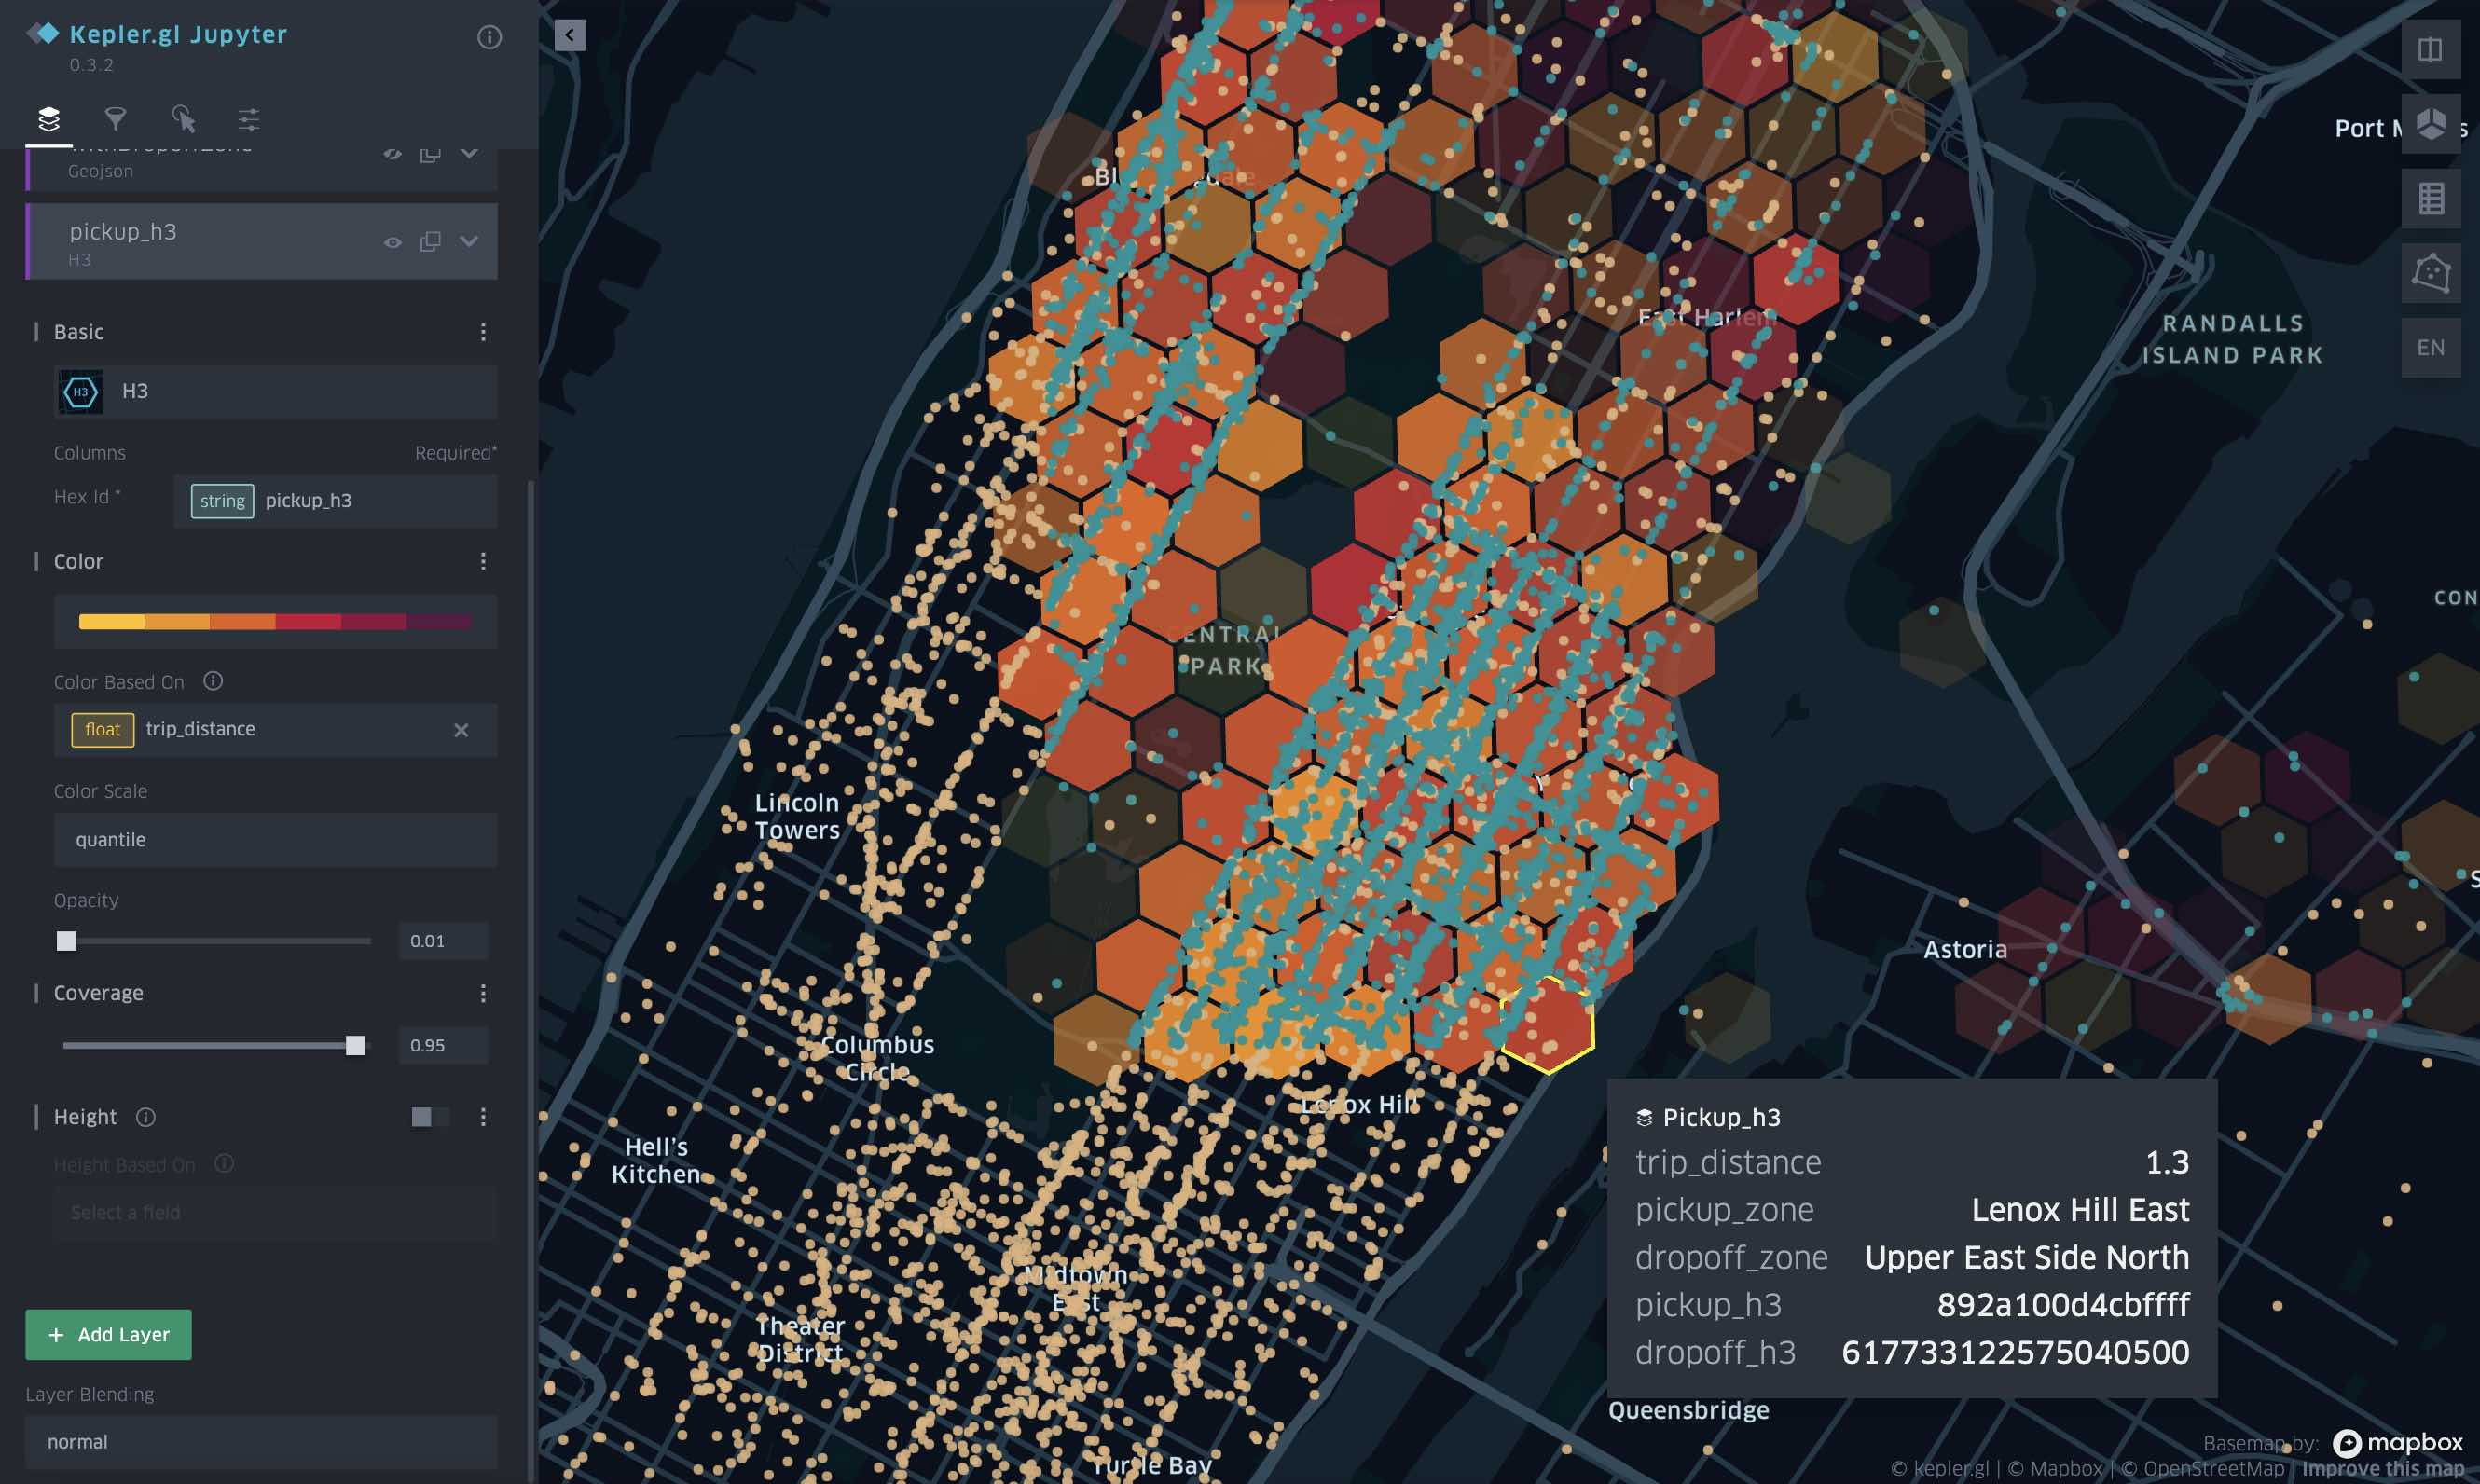

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAACmSgAwAEAAAAAQAABjikBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/qAZhBUk9UAAAAAABjcAcAAH0SAAAOHwAAKSgAAI8wAAAiOAAA2UAAAOBKAAAOVQAA/1wAAMVmAAAFcQAAjXsAABWFAACJjQAAzZYAAOugAABUqgAAmbMAAFe7AADrwwAAhM8AAGPaAABG5AAALewAAHD0AAAK/wAA8AgBAG8RAQByGQEAxCIBANgsAQAGOAEAfEIBALJKAQDmUgEAG1wBAPNmAQDrbwEAOnkBAC6CAQAljgEAipoBAIWjAQDprAEAwbYBAJHAAQAtywEAa9YBADfhAQCA6wEA3/YBAN8BAgDKDAIATBcCAOoiAgAFMAIAYzoCAE9EAgCcTgIA91kCAKFkAgAlcAIAWXwCANOGAgDykQIAsJ8CANGrAgBqtgIAxMICAOXPAgAK3AIA0eYCANjwAgAZAAMAkA0DAJgZAwDdJwMAJTcDAKpCAwBNUQMAGGMDAE5vAwDafgMAvJADAA6fAwA7rAMAvb0DAGbNAwBr3AMAEO8DAI//AwDNCQQA7RcEAGclBAClMAQAij8EAENNBAD6XgQA/8AAEQgGOApkAwEiAAIRAQMRAf/EAB8AAAEFAQEBAQEBAAAAAAAAAAABAgMEBQYHCAkKC//EALUQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+v/EAB8BAAMBAQEBAQEBAQEAAAAAAAABAgMEBQYHCAkKC//EALURAAIBAgQEAwQHBQQEAAECdwABAgMRBAUhMQYSQVEHYXETIjKBCBRCkaGxwQkjM1LwFWJy0QoWJDThJfEXGBkaJicoKSo1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoKDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uLj5OXm5+jp6vLz9PX29/j5+v/bAEMADg4ODg4OGA4OGCIYGBgiLyIiIiIvOy8vLy8vO0c7Ozs7OztHR0dHR0dHR1VVVVVVVWNjY2Njb29vb29vb29vb//bAEMBERISHBocMRoaMXRPQU90dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dP/dAAQAp//aAAwDAQACEQMRAD8A5KiiirJCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooArTRnO9efWnxQ7fmfrU4qvO7LwOAe9MVwlmx8qdfWqmaSikMWikooAWikooAWikooAWl7U2nHpQDEopKKAFopKKAFq/Emxeep61Xt49x3noKu00JsjkfYue/as/JPNSSvvbPYdKioBC0UlFIYtFJRQAtFJRQAtFJRQAtFGM9KTpQAtFJRQAtFJRQA5cE808oe1NQZNTUCK/NAJHSpyoPWoyhHTmgdxwk9afmq1ToPlpiY+ikooELRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUAPRS7BR3rSVQBgdBUFvHtXcerfyqxQNbkUr+Wme/as3NSzyeY/HQdKiqWWFFFFABRRRQBPCvVqfK21Pc09F2qBWnDokt3GJnkEYP3RjNEmktRpXOdoq3fWUljN5UhzkZBHcVTpJ3KA9K19K5jce9Y56VsaQfkkHuKir8JpQ/iI1dtTgAjIpgGTipgAOlLDJ6szzGUbqPUbtqJ15qcnAqEnJzV4iSUeUywFKTnz9CPbRtp9FcNz2rDNtG2n0UXCwzbRtp9FFwsV7hcwSD/ZP8qLDSnghFzIclwPl9BVgoJAUPQjBq9HPJGAM5A4xXTRjK10eZjKsFLkZRk/dqTVQzyEY4q1fsZZfMVcKBiqggkIzitXKT2Q6FGjGPNNpkPXk0mKdjHBorI9RJdBS8hXaWJHpmmYp1FAWExRilooCwmKMVJ5UgGccUym01uTGUZfCxMVhRfe/Ct6sGP79VDqcuKWsSxRRRVHOFFFFABRRRQAUUUUAOVSzBR1JxXXw6Laog3ZL/wB7Ncimd429c11g1yFIsyI272xis583Qat1MK/aaCdrYsSF/rzWJ/y0P1NaFzO1zO07cFj0rP8A+Wh+taxv1MpJLYlq1B90/WqlW7f7p+tAmaliq+WxHXcc1FqaqI1b+LP6VmmaWGRjGxGaULdXjZVWkI9BmqclYxVJ83MV6Kc8ckTbJFKkdjxTKg3FqWFNzZPQVDWhGmxcfnTEx1UZH3t7CrMz7V2jqapUCQtRH7/41JUR+/QhsupPNGNqMQKjZix3Mck02ima8q3CiiikMKeiNI21BkmmVqaXt84g9xxTRE5csW0RC2lhXLrjNQytgY9a65IxIwQjIPX6Vxs2PNYDoCQPpQ97EUZuauyKiiikbBUL8NU1QSEFuKaInsaVKBTVZWGVOakrE0EpMU6igQzFFPoC5IFAzQsnCIVbjJyKdeTIY/LUgk+lVHO1eKrVfPpYw9inLnFDFelTK6ng8VBRUG9iw0QPTis26VlYZq154iHzH8KZ5y3HGPwq4rUzm9LDoVyob2okPO0dqcrbV2gdOlBtrgL5hjbb64OKb0Li09iCilopFCU5V3HFWLa389jk4A61cktFhQuhJ9c01F2uZOrFS5epUx2pkh2jHrWhbQrIC789sUy9t0VPNTginyu1yfbR5uQyqKWkJA5NSbhUE/QUPMBwn51ZtrCac+ZJ8q+/U0XtqzOTvojdt1XyE29NorG1Mr9oAX+7zUlwt3bJiMnHqtZG8sctyT3rTmTWhywpuMrsfRmkopG4uaUUIu5gvrVhoMfcP4GgTIKKCCDg8UUCCr1vJuGw9RVGgPsIYdRQBr4qKWMSLt79jTom85Qy/jVkIB15p3IuYnIJB4I60VpXMAf94vUdazyhHuKLgNopKKYhajcZ5FPooAr0U51wcjpTKRQtFJRQAtFJRQA4MR0p4cHrUVFFh3LFLVcEjpUgcHrU2HckqVJmXg8ioau2CI9wA/OBkfWhBJ2Vx+Fccjj3p2K2nRXQq3SsQkIuWPSqasZQnzEE74GwfjVXOOtXWMcg4596pSQuORyKVjTmRGX9KZmkophccrMpypwavRXQPyycH1rPooEboweRRismKdo+Ooq+twCMnkeo/rVE2JDEP4eKgbKH5+B69qtghhlTkUEAjBoEUHhV+RwaqPG6dRx61otAV5iOPY9Kj34O2QbT70h3M+irj26tyvBqoyMhwwoKuJRSUUgFopKKAFqaBNzZPQVBWgiiKPn6mmJkdw+BsHeqlKzFmLHvTaQ0LRSUUALUqTMnHUVDRQBoK6SjH6Gong7p+VVOlWEuCOH5FMViEgg4PFJWh+7lHrVZ4GXleRRYLkFFJRSGLRSUUALRSUUALRSUUALRSUUALRSVIkTydOnrQAyp44HfrwKuRWypyetWgAOlOxLZDHAqCpsUtMeRIxlzimIdioJZ44uDyfQVUlu2biP5R696p0rjSJ5J3k68D0qGkopFC0UlFAC0UlFAC0UlFAH/0OSoooqyQooooAKKvQQbfnfr2HpVhbA3UnyfKP4jTSE2krsycHGaK7M2Vubf7Nt+X9c+v1rlru0ktJNj8g9D61UoNGdOqpaFWiir1jZ/bHZC23aM9M1CV9DRtJXZRoq1a2r3U3lKcAdT6Cm3MSQTGJG37eCcY5p20uHMr2K9FSCKVl3qjEeoHFRgEnA60h3CipBDMxIVGOOvBqMjHBoC4UVo39pHaiIxkneMnP4VRSOSTiNS30GabVtCVJNXGUUpBU4YYI9ad5cnHyn5unHWkUMopWVlO1gQR2NCqznaoJPoKAEoqQwzKcMjA4zyD0q5ZWkdxFM7kgxjIx9D/hTSuS5JK5n0UUUigoq/b2QntpLjdjyweMdcDNUlR3+6CcelOwlJMbRTlRnOEBJ9qArMcKCT7UhjaKk8qXbv2nb644pqoznCAk+1AXG0UpBBwetOMcgYKVIJ6DFADKKvXdi9rt6tlck46VTVWc7UBJ9BTasJSTV0NopzI6HDgqfQjFG1iu4A49aQxtFOZHTG9SuemRim0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFTQwNLk9FHUmpttkvBZm9xQBToq29srIZLdt6jqO9VKACiiigAooooArySMr4HapvllT61Vl/1hojfYfY0yWWYNOmnBZSAAcc1P8A2PP/AH1/X/CtPTzmEkf3v6Cr9BRzv9jz/wB9f1/wo/sef++v6/4Vvs6KQGIBY4Ge9PoA5S6sJbVBI5BBOOKo10esf8ey/wC+P5GucpAFFFFABT6ZSmgTEooooGFOVSzBR3ptXbePA3nqaYMnVQqhR2qvPJj5F/GpJZPLX3PSqBOTk0MlISiiikUFFFFABRRRQAUUUUAFKFJ6UqjJxU4AHAoAQKFpSAetFFMkjMfpTdjVNRQO5XwR2oAJOBViikFxqrtFOoopiCiiigBCoPWloooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqWJPMfB6Dk1FWjDH5aYPU8mgCWq9xJsTaOpqckKCx6CspnMjFjQxx3EoooqSwooooAKkiXLZ9Kjq3EuFz60ICSuntNUs1t0jlcIyKAQfauYrPdtzE0pxUlqVF2NbWb2K8uF8nlUGM+tY9FFCVlYbdxD0rp7C1WCHPVnAJrmD0rqdOd5LZWf6D6CqST0ZhWlKNnFl0IBT6Ka5KjPrVPlgrnKuerJLdkbnnFMoorz6k+Z3PoaFJU4KIUUUVmbBTtppAcHNTiumjTjJO55+MxM6Uko7EbRSqNzKQPXFMCs3QE1s2z7omWTkD1qW1CrAu3uMmsZR5XY3p4jmhzWMNMg4qarN3saQMhB45xVWu+irQR4uKnzVGxrruUhRkntQysn3xj61JbSxNdiFmAONwFad2yLbyF+m0ipnW5ZWNaOGc4ps5SQhnJHSmVKIZCM4qKspJ7s9ulKFuWDvYKKlhQO+D0HNWZIk2EgYIqlBtXMquLjCagyjTkIDgnpmm0VCZ0SjdNGpkYz2rMbBYkdM0mTTHkSMbnOK0nPmOTD4b2N22adhZrdFmc4VfSm6hosEMX2iAkFeoNULHW1tZGV0Jjb061LqOux3EPk2ykbupas1GXMZ1qsZMyGRl60ypY7lW4bg1I0atyvFbNGKkmVqKcyletNpFBRRRQAUUV0eh2kEyvPKoYg4APIqZOyuNGLEuBuPeo5W3NgdBXV6xbQJaNMihWXHTjqcVxTSgcLzRGXMtCXpuSkgDJqqWG/dViK2lnwx4X1P9KvizgCbSPx703NIOSUjMBB6Vbt+hqOWykT5o/mH61b063eVWZ+ADj3qlrsZTfKveKU3+sNdrogj/ALPTZjOTu+ua5e+tDCfMByDxVWG5uLfPkuUz1waipC+hVOa3R0PiMR4iPG/n8q5epJJZJm3ysWb1NdPp2jW0lss1wCxcZAzjA/ClfkWpW7OcgTJ3HoKtEgDJrR1CxjsnURfcbOAe2Kx53wNg79atO6uiGtbFd23sWplIWAqMktxTsFxxcDpTPmPNOC4606mFr7iCT+9UoIPSoiAabtI5FBSk0T0VEJP71Sgg9KC1JM1dK09b6RvMJCJjOOpzWzd6VFawme2JUpzyaz9Jkns2aRoyUcDPrxVy/wBXjlgaKJSM9S1ZSUubyGpRexmT6reGPygwGRyQADWRSkknJpCQOtaWXQC/pkEdxexxS8qckj1wM12klnayxmJo1xjsOledJcSQyCSE4ZTkGtWTXr+WIx/KuRgkDn+dZzhJu6Fzox3Y7io6A0zFLS1sZeoLuU5U1ZS47OPxFQUYzSaTJu1saKsrDKnNLWYCynKmrKXHZx+NZuHY0VRdS1RSKysMqc0tSaAeetNxTqgknVeF5NCVxN23JCQBk1Ve4/hj/OkEctwc9v0q7Fbxxc4yfU1Wi3HGMp7bFSO2kkO6XIH61pRRpGuFGKUDJp5OBUuTZ0QpqOxNZpE15HvAxmu3wMYrz/pV5NTvUXaJMj3ArOSbCUOqLN/pIadpUdUDchcd6w3s7lCRsJx3HNdM9zHcESIeo6dxTAcc10QheJ5tTEyhNxaMOyaSMnKEqe4HpVme4V0KLnnrmtM4PWoJrOGSJpEJEg5x2NaO6RnCcZzvIyUujAcAZB6io7i7addgG0VVl3IxEgIPpVUGWZtkYOfQVF3Y6nGF+bqSPKq8dTSRwz3R4Hy+var9vpqr80/zH0HStMAKMKMAelYyqpfCXyuW5Ut7KKDDfeb1P9K0gMCmKMnNK57Vg23qy0raIYTk5qnPZQzc42t6irdFJNrVDaT3Odmsp4OQNy+oqsG9a6uqk9lDNzja3qK3jW/mMnT7GCD3FTpORw3NE1lPByBuX1FVg3rW6aeqM32Zo/JKPWoXhI5Xmqm8g/LVuKRj/rOnrVeon5Fc7icAU9Yu7VpBY3HHNQvCw5Xmpb7EiQy+U2P4T1rTrFq9ay5Hlt+FShtFyqUsexsjoau0jKGUqehpiMtkVvaoWRl96tMpRtppKaYWKdFWWRW9qhZCtUmKwwjIxVcjBxVimOMjNMEQ0UUUhhRRRQAUUUUAFFFFACgkdKlSUqwYHBHeoalijMh9h1osO5qpdTyJ+8bINZ9xKWbYOgqeRxGnH0FZ1MleQ5WZTlTirSXAPD8e9U6KB2NB4kkGe/qKqPE6c9R601JGT7pq2k6tweDQLYo0VeeBW5Xg1UeNkPzCgLjKcrMhypptFIZaR8nMR2t6djVqO6UnbKNp/SsulJJOTzTuKxuggjIpGVXGGGRWPHNJEflPHpV+O7jYfP8AKadxWFMLpzEcj0P+NR7lb5GGD6GrKTRyHCHJpzokgwwzQIzntweU/KqrKVOGGK02ikT7vzD0PWmZSQbT+R60rDuZ1FWXtyOU59qr4OcY5pFE0Cbm3HoKkuH/AIB+NSqBFHz261QZixLHvTEJRRRSGFFFFABRRRQAUUUUAKCVOQcVaS47P+dVKKYWNBo0kGf1FVHhdOeopquyHKmrSTq3DcGgWxSoq88KPyODVR42T7woC4yiiikMKKKUAk4FACU5VZzhRmrMVqzctWgkSoMAU7CbKcVr3fmryqF6U6imSFJTGkVazZrhn+VelAJF55Wx+7xn3qi0MrncxBNWqKkuxT+zv6ij7O/qKuUUAU/s7+oo+zv6irlFAFP7O/qKPs7+oq5RQBmUUUUAFFFFAH//0eSoooqyQqeBkV/n/A1BRQBs1uWrxNEBFxjqK5WCfHyP07GpPtrwyBoT06+9XGVjKrT5lY6+s/UpLdLcrONxP3R3zUZ1W3+zecPvdNnfP+Fc1NNJcSGWU5JrSc1bQ56VFt3ZFW3on+uk/wB3+tYlaml3MNtI7TNtBGBwT/KsobnTVV4tI1FWOCxlewO8nOT3/wAiuetkEtxHG3RmGat6feC1mO8/u36+3vUU7wxXYmtG3KCGAwRg+nNNtOzIjFptHQym7WcCJo1iXA2nrWTcpGuqxmPGGZTx65qWZ9LvWE0rtG+OR/kGqCiAX8YtySm9cE/UVUmRCNjUv9Qntrry48bQATx1qrrMarcK6jG5efwq7eJp7XO65cqygZHYj8qydQulup9yfdUYFEnvcdJappFzWPuwf7p/pV4RzQ2kSWjIhIyxbvWVqVzDcLEIm3bQQeCPT1qZLmzurZILslGj4BH+TRdXYuV8q0HaqoaGKVypk6NtqzNdG0sYJEALlAAT2GBmsa7SzQKLVy553E//AKhVi8uIZbSCKNssgAYYPHApX3K5LqKM+aV55DK/VutbOkZMMwiwJexP6VnQLZm3kMzESD7oFaWmErZTNs8wZ+4Op4pR3uOq/dsie4luIdPZblx5rcDGM4//AFVU0v8A497n/d/oanMFtcQSOYGhKDIJ4qjYXEMMM6StguuF4PPBqnuiEvdaRmUUVbtEtHZlumKjHBHr+tZI6W7K5paf/wAg65+jf+g0zRus3+6P606a6s7e0a2syWL9SffrVTTbpLWU+b91xg+1aXSaOdpuMnYm0X/j6b/cP8xT9J/4/ZP90/zFSxTabZbpYGLswwB/kCoNGObtye6H+YoXRBLVSZZtdQmmvfIcDYcgDHTFUBILLUmK8KGII9jV2N9MtpmuVdi4z8uOh/L+tYsrtPMz45ds4Hv2obHCKbdlobM1pnVEIHyP8/5df8+9VL67f7cZYjgx/Kp+nWtWGZ4dP86dSrxqVXPX2/pXL9eTRLTYKau9emh0Or3E0bCFGwrryMCnWEbpp5kgKiRz95vriq17PZXkQm3lZFX7uKjs7q3+zNZ3eQpOQRTv7xPK+RKxduw8lg32lkaRDlSp+lMsJFh015mG7axIB9eMVQuI9OSI/Z5Gd+2en8hToriFdNkty3zs2QMH2pX1Hy+7bzKtzdS3bBpcZAwMVWoorO50JJaIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAXLk+WiQL0Ayfc0yH/Uyfu93v6VJcjzY0uF6YwfY0W8iJBKrHBI4/KgCvBKYpAw6d/pT7pBHOyjp1/Om28RlkCjp3pbmQSzMw6dB+FAEFFFFABRRRQBTl/wBYajqaVG3Fu1Q0EnRaSf8ARm/3z/IVoyMUjZ1UsQMgDvWbpH/Hs3++f5CtWmMxLBFvHN7cMGcHAX+5jpW3VF7IfaluoWMZz84HRqvUIZk6x/x7L/vj+RrnK6PWP+PZf98fyNc5QAUUopcUguIBQetOplAkFFFHXigZLEm9sdh1q8zBFyegpsaeWmO/eqk0m9sDoKZO5G7l23Gm0UUigooooAKKKKACiiigAoopRycUASRjjNSUAYGKKZIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFKASQB1NAE9vHubeei/wA6vU1ECKFHakkcRoWNMRUu5f8AlkPxqkDigksSx6mkqRokBBpaipwalYpSH0UgINLQUORdzAVcYhVJ9KhgXq1NuG6IKYEz5KEr6VQAJOBVqKRdoVuteg6fawQWsflqAWUEnHUms6k+VXLjG5xQ0TUDH5mwdM4zzWS2UJVhgjgivVZAF56CuNlsIprySd+QzEgDpUQq3dmXKGl0QWWnQvEss3zFhnHatpVCjaowBSIoRQq8AdKfXWjyZybe4q7dw3dO+KjuLqCZxDCfudjwafWFqNpLNL58HUDGOhrGtFNas68FKSk+VXNSisCLUZ4D5dwC2PXg1rw3MNwP3bc+h61xypuJ7MK0ZaIsUUUVmahSgkdKazKoLMQAO5rHudUAyluOf7x/pWkFK/umNZwtaoa012sCfvXwD29aSzuricblbbCc4Xufr6fhWBFZz3DeZOSAe5610lrEIYxGBgDpXTTgr3erPPxNSShaKsixSOyLCxP3uMVO8DJF5rEYrOlk3jArSdRcrszkoUJOavHQwrmzuDIZkYuevoaYmoXCsEuSXAP8XUVs1FLBFMMSLn371zqp/Meq6Nvgdi+siOu9SCD3qhIQzkjpWXNp8ifNCdw9O9Rx3csR2SjOPXg1tKXMtDDDQVGTczXRyjbhUrzsy7QMZqnFNHKMofwqWo5mtDvdKnNqbVwpCQBknAqvNcpFx94+grNkmklPzHj07UKLZFXExhpuy7LeAcRcn1NZzszksxyTSUVqopHnVK0p7jKKKKZAVu6RYS3u5y+2NePfNYiqzsFUZJ4AFdlpEd1p0LrdREITuyMEj6gc1FSVloVFXepDfab9li81W3r0OetYrRA8p+Vausavb3Fv9mtiW3EEnGOnPesWylzcxRy8qXAP0zShe15FOVnoOMUoG4qceuKjr0vC7duOPSuEvLb/AEqUW4yoY8CohLmNHZbmfXeabaR2luNvLOAWNc9ZWq+UHkT5j2YdK6WxkbBRucDiqqwfLcyhXTnyo57X3u5Z1tE/1ZAbj+prMhs44/mb5j+ldjqkaPbGQj5lxg/jXNVipu1kdMYK92FFFFI1CrMEgUFTVanJ1pxk4u6M6lNTjysL8GeIInrnNYLK8f3hketb7Eg8U1lSThhWqq33MVh+Ve6YAIPSup03VhDbCKdSdvCkelY01h/FH+lAJUbcdKvlUkZtuO5oajf/AGlt5G1UHArnXkLsSO9TzsWOzsOtQAAVSiloCu9RoXuaf0ooplJWFpK9FsYIYbWNYwMFQSfXNcnrkMUN7+6AG5QxA9cmso1LuxTiY1FFFaiEIBp8K4mQnpuGfpTaswp/EfwoJaOpBGMjpXOXkitMwTpmleRkQ8nHpWW2QevWm3cxpQ5HclaQDpzURy3JoAp1I1bb3EAxS0UUAFKKSnUCYUUUUCCjFFFACAspytWEuf74/KoKQ0mkwTa2Ji8sx2oOParMVqq/NJyfTtUtuAIlxU1ZOXRHZTor4pahRRSgZNSdA4DAphOTTmNMoAKKKKQCgkdK2LaUzrwPmUc1jVfs4JnbfF0XqauMmmc+JpRnHXoaFFKB2qaeEwgMehGT7V08yvZnhqLauiuVDc96qSRqjZUAZ6471p2qxzMSSCB70y+8olUj/hz+tc1ea+E7MLTd+dmZS09Y2NPETA5xnFc/I7c1js9pG/LfUT7oqI8805z2plSWFFFFIApQMnFJUiDvQA7Axisu/tIzEZUXDD0rRY88dqrXcm22Yt7fzFXB+8iZLRnPxqAORzUtWkCSpnrUbwsvI5Fdb3OZMiDFTkHFWopgzhX7nGaqUUhtHVbE27cDFYFzCYZmMfQHj2oW+uVXaD+lSI5lXc3XvVyaZhTg4u7J4pPMQN3qSs8SmOTj7o4xWgCCMjoak1IpY968dRVKtKqcybWyOhoBENNb7pp1Nb7p+lAFWiiitCSBhtOKbUzjI+lQ0igooooAKKKKACiircUH8T/lTAjihL8twKtM6RLj8hTZJgnyryaokljk8mgW453aQ5NMoopDCiiigAooooAlSZ046j0q2siSDH6Gs+imKxce3B5Tj2qqyspwwxUyTsvDcirIMco9aAM6irL25HKc+1VyCDg0hiUUUUAAOORV2K7Zflk5HrVKimBuq6uMqc014kk+8OfXvWQkjRnKmtCK5D8Hr6UybAySR/7Y/WmjY/zDnFW1ZWGVNNeJX56H1FAilOrsuF5HeqNabCSP7w3D1H+FMZI5Rn9RSGmZ9FTPC6cjkVDSKCiiigAooooAKKKKACiiigAooooAkSV06cj0q2kqScd/Q1QopisXHtweU49qqsrKcMMVYheU8dR71eEe7lqBXsZ0cDv14FaEcCIKnAA6UtMLhRRUEkwUZ6UCJiwXrVSW5C8d/SqklwzcLwKr0rjSHvIz9enpTKKSkUalFFFABSgE8AZq+nkx2qyOgYk4qa1lheTEce0460AZNFXftFt/zx/Wm3qIkoCDAKg0AVKKKKAMyikpaACiiigD/9LkqKKKskKKKKACiiigAooooAKKKVVZjhQSfagBKKcyshwwIPvTetABSqzIwdTgg5BpzRunLKR9RTKAJJZZJn3ync3rUdPEchXcFOPXFMoAKKKKACiiigAqWGeaA7oWKk+lRUUA1fcsy3lzOu2VyR6dP5VWooouJJLYKKKKBhRRRQAVLFNLA2+JtpIxmoqKAaFJJOT1NKrMjB1OCDkGm0UAWJrq4uABM5YDt0/lVeiigSSWwUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAmhneEnbyD1B6VN5lm3LRsD6A8VTooAtPc/KY4V2KfzNVaKKACiiigAooooAaHXcUPWmPCDyvBqCX/WGnJMy8HkUyWa+mzRQQskzBTuzz9BWh9rtf+eq/nWB8ko9arvARyvIoC51P2mA8h1/Om/a7X/nqv51zULfwH8KZcR7TvHegdzV1S4glgVI3DHdng+xrCoopDHClopD0oJDNNoooKCrNumW3ntVcAk4FaAAij+lNCZFcSY+QfjVOlJLEk96SgaCiiikAUUUUAFFFFABRRRQAVJGOc1HT1YrwaAJqKQMD0paZIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFW7aP/lofoKrohdgorSAAGB0FCAWs26l3vtHRf51bnk8tOOp4FZVDEFFFFIYUUUUAFPXJIHrTKtQJ/GfwoC5YGEX2FUGbcxY96nuHwu0d6it4JLl9iY4GSTRLQ0hd6IiyTwK7PRLq+AS3uMeWBhcj5vpVG3s4bflRlvU1b6ciuWpUT0R308NbWTOnbBB3dO9c4gGSacZpnGxnJFPAA4FVh4XfMcmMqezj7PuLSqSrBh2pKK7TySOeYyvnAX2FQVM6liNoyaYyOnDgj6151WLi7H0eEqRnBNbleWCKYbZFBrIm0yRDvtznHboa3KKmM3HY2nSjPcwotRngPl3ALY9eDVyXVIFQGL5mPbpj61clgimG2RQa521iR7ny3GQM/pWqUZa2OaftKdop7kn+lX7Zb7o/IfStGCzig5+83qf6Vb6cCipc76IqNJJ3erFBwQaub1xnNQpGGGTTZE2HjvWseaEbnHV9nWnyX1Qsk0kg2sxKjoKhoorBvqd8YpKyCiiikUFRSwRTDEi59+9S1IiF6qKbehnUlGMby2K2naSjXgLHcignHet+9sLeS2dUUIQpII46VVt4po5Q0JBPoe9Zl/rk7CS1SMIclSc5NW1Nyszl54cvNB6HNUUUV0nIFFFFADKKKKCjR0mSOLUInlOFBPJ9xxXobyIiGRyAoGSTXldPMjldpYkemaznT5ncuM7BKVaRmXoSSKZRRWhBpDV9REflCY46ds/n1rZ03L2odupJyfXmuUrp9LuIjbiMkArxzTikjKtdxNToKei3f37YfX0/Wqk8i7doOSa37SRHt0KHoADWVapb3UXhqL+NnPXdxdOfKuOMdqp1sagqz3SxxnnAH45qf+yItuN7bvXtXLc9K5gUU6RDG7Rt1U4ptUMKcnWm05OtAA/Wm1IVzTdpzQBJEMkA96uMqsu0jiqfSs6+vbhH8pDgFevet6MktDhxVKUmpIz5ABIwHOCajorf0bTYbwNNPyqnAHTmrlJJXZaXQwKK6fVtKt7e3NxbjbtIyM568d65iiMlJXQNWNO31a9toxFGwKjpkZxVGaaW4kMsx3Me9RUU0ktQuFFFFMByruYCrwAAwKihTA3HqadI+1feglkErbmwOgqs9Ppj9qAewUtIOlOVWchVBJPQCgQlFTy21xCN00bID3IIqAUgFFLRRTJCiiigAooooAKRqWkNAmalv/qVqaoLb/Ur+P8AOp6we56UPhQU8cCmgc5pWPakWNJzSUUUgCilALEKOSa0v7Ju9m75c+meaLg3YzlHeug0maMRtESA2c1hYK/Keoq7p8aSXSq/I5OKUloTLY1b+6S2UGHb5hPpniuc1PULm5t9jkBcjIHeuzlijkjKOBtxXn93/qT9aKerMmlyuyLenf8AHsPqa0AxFZum/wDHv/wI1oVnP4mZx2RpyBVC7O6g1Ys+ZD9KoICFANBmaI/IcE/yrrkrU7M86DvWuhs8ebpkiGeeAKbJazxLudcCrlg6+ccnkjitO5KrA+7uDXCemcxRRRQAoGTipGOBQowM0xjk0wG1Vvf+PV/p/WrVV7v/AI9n+lOO6FLYwoGKgkHFXknB4fj3rPi6Gpq7Huc1i60aPz+oqs8bJ7j1pquydKtJMrcHg0hFMAk4FXxiNPpQI1DbgOaa5JPl46jj60wbKpOTn1q1bS4Plt36VUII4NAODkUhGxTJE3oR37Usbh0DetOpiM2mt901YnTa24dG/nUB6GgZUooorQkKgcYNT01l3CgZBRUwjHeoypBwOaQxtSJG0h46etTx2/d/yqV5EiGO/oKYrgkaRDP6moZLjPyp+dQvI0h5/Ko6AsFFFFIYUUUUAFFFFABRRRQAUUUUAFKCQcikooAtJcHo/wCdTlY5Rnr71nU5WZTlTincViV4GXleRUFXEuAeH496keJJOe/qKAv3M+ipXidOvI9aipDCiiigCwk3PzHB/vDrVxbgr/rOn94dKy6ejsnTp6UxWNsEMMqcionhVjuX5T6iqCMc7oDg91NWUu1PyyDa1MVhpZkO2QY9x0prxI/I4PqKUvub5/lJ/KlxtPH6f4UAUnidOvT1qOtMEGongVuV4NKw7lGinvGyfeFMpDCiiigAooooAKKKsR27Ny3AoAgCljhRmrkVtnluatRwhR0wKnAA4FOxLY1UC0+iimIKQsF61DLOkXHU+lZzzyO2c4oHYuTSPjKjNZzMzHLGrSXAPD8e9SPEknPf1FINjPoqV4nTryPWoqRQUlLSUAalFFFAF1/+PFP97/Giw/15/wB00/y3kskVBk7s/wA6dZwSxylnXAxQBm1dv/8AWr/uj+tRfZLj+4alv/8AWr/uj+tAFKiiigDLpaSloAKKKKAP/9PkqKKKskKKKKACiiigAooooAKnQlYXI6kgfhzUFSRuFBVhlW6jpQA8ktbjPO1sD8RUIYqcqcGpHkBUIgwo565yablN+dvHpmgCdceS+G3EgZHpz1qrU3mIqkRqQW4JJzxUWRtAxz60AWIWdpA5Y4Tkn29KrsckkcZqczRFAmwgD0bv69KgOM8dKAEooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAqSAmQ0zaamf75ptBJECVORwaspP2f86rHqaSmBogLncO/eobj/V/jSW7ZBX0p0/+rNMRQoooqSx9IelAoNBI2ilxSUFFm3TLbz2pbh8nYPxqaAbYx781RY7mJ9aYuo2iiikMKKKKACiiigAoop4QkZoAZRSkEdaVVyaAHovc08gHrS0UxERQjlaA5HDVLSEA9aAAEHpS1EUI5WnqSRzQA6iiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFSwpvfnoOtAFqCPau49TU/Siql1JtXYOrfypiKc0nmOT27VFRRUjCiiigAooooAcil2C1fAAGBUUKbV3HqaJ32pgdTTEU5G3uTWjpR/fsP9n+orLrS0r/j5P8Aun+YrOp8LOmh8aOgoopQMnFcSV3Y9aUlFOTHoueTU9IBgYp6AM4U9Ca9KEVBWPma1aVWfMxtSt5QRQuS3ei8RIZFVPTmoNwxzUxmpaodShKnZNbli3XdMo96vagF+zknrkYqjbTQq++Q4I6cUy9uVnYBOi1y1pqT0PSwdCcPiRRoqRVGMmmsMGplSaXMzqp4uE5+zQ2uctP+P38Wro65yDjUP+BN/WnS2YYjePqblL1pKtWW37ShfpmoLZdhsZzGC2B7GqNyjxybHHSuq3ADJOK5m+mSafKcgDGar2kmuVnLTpR5+exSoooqTrCiiigAqaJwpwelQ0tVGTi7ozqU1OPLI3LcIh852UAD1rhtQcPezOvQuTW7XPXQxcP9a2pycpXZx1KKpwSRXooorY5gooooAZRRRQUFFFFABRRRQAoBJwK0UAiUD0qtbpk7z+FLM+XCDseafQXU2zzQCR0NFFcR6RJFIYpFkH8JzW+NVtiuec+lc5RSaE0TynzZGkPBY5qAgjrShiKtwbWBbvVwjzOxnVqckeYp05etW50BXPeqi8GiceV2ClV9pHmFYkGnCkIyRTqk0EY4FYl//rVP+zWuxyaydQ++v0q6fxGdX4SrWtpuptYblZdyNzjvmskdKK6Gk1ZmKZuajrBvYvIjTYpOTnqcVideBSVNCrmRWRS20g4FJRSVkDfVmxH4fu3jDllUkZ2msWWJ4ZGikGGU4Ir0IX1qU3tIq8ZwxwR+FcPqM6XN5JNH90kY/AYqISk3qU0uhRqSNd7Y7VHVyJNq89TWpDJKpyNub2FTyvtXA6mqlAIKY/an0x6BS2AdK3/DwjN627Gdh2/mKwB0p6O8bB0JUjoRUyV1YE7Hf3jCUNA4BUjBFchf2qW7KY+A3b6VJDq0oGLjMh9c81e08R6pdkzL8kS5C+pPrT0jExSm567HO0V3WoadaPaSMsaoyKWBUY6VwtTCfMayjYKKKKskKKKKACkPSlpD0oEzStf9SPx/nViq1r/qR9atqO9YS3PSp/ChegplKx7U2kWFFFFICe2kWKdJG6KQTXYedFs8zcNvrmuJAzUlJxuTKNyWdxJM7r0ZiRUKyMjh0OCOhoJwKjplF+TUbuRDGzcHrgVkXX+oP4fzqxUF1/qG/D+dOO5E17rJtM/1Df7x/kK141BGTWPpf+pb/e/pWwmVFTdKpdnFOMnTtElZtozVZiWOTSu5b6UylVqczsthUKPIrvcXOORUnmMeGJNRUVidBNgNTdnPtTASOlTDpzTAaxwMVFUxANRlSKAG1Bdf8e8n+6anqG45t5P90/ypx3E9jnoe9TVBD3qeux7nMgpVUswUd6SrUCYG896QMmPyKAPoKaZI+hNMkfALfgKqUxJExmz1UfjSec3YAfhUVFIdi7bTMzFGPXpV2pNH09LkNPKTgHaAPWtG+sY4IxLFnGcEGp51ewODtcyHQOpU1ndjmtOs+YbJiOzc1ZKKNFFFaEhRSgZ4FTLH3agCNULVOFVBSM4XioGYt1oAe8meF/OqRznmrFRyDvQNEVFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFPSRk+6fwplFAF9J0fg8GkeBW5Xg1RqVJnTjqPSmK3Ya6Mh+YUytBZEkGP0NMe3U8rxRYLlKipHjdOo/Go6Qxy43DPT2q1hZBz8w9R1FU6UEg5HFMCc74hz8y/pT0ZWGF/75P9DTUn7OPxpWhVhuiP4UCH5bt82Ox6ilWVTxnB9DUAlZflcZx+Yp5aGXg5B9aAsWcg8H9age3B5Tj2poSVDhGB9qf5rr95KBFUxuDgg0m1vQ1oqxf7qn8qmEZ70WC5lCKRugqVbZj1OK0xGo96cAB0osFypHbheg59TVlUC/Wn0UxBRRVSW6ROE5NAFlmVBljgVQluyflj4HrVR5HkOXOaZSuUkKSTyaSiikMKekjJ900yigC8k6vweDSPArcrwapVKkzpx1HpTFbsMdGQ4YUytBZEkGP0NRSW/dPyoC5ZooopDJFlkQYViB7GpEupkOdxb2PNV6KAJfPm/vt+dMZ2c5ckn3ptFABRRRQBl0tJS0AFFFFAH/1OSoooqyQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAK7/fNNpz/AHzTaYiNutNpScmkpCHxttcGrcozG30qjV6TiI/SmgM6iiikUOFLTKfQJhTcZOKdSL98fWgEX5DsiOOwxWdV+4/1dUKbBBRRRSGFFFFABRRRQA5VyanpFGBS0xBQAB0oooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVowpsTnqetVIE3vk9BzWhQgYhIAyegrHkcyOWNXbuTC+WOp61n0MQUUUUhhRRRQAVJGm9sdu9R1eiTYvPU0wJOgrOkfe+e3arNw+F2jqapUMaCtHTD/pP/AAE1nVf03/j6H0NRU+Fm1H40dHTgpPIpKsgYGK56NPmd2dONxLpJKO7I95HDCpM4oPIqHcRxXU5cnxM8qNN1n+7jqEjM7lmOSajpSc80lcErX0PoaaailLcKKKt29o9wC2doHepKbS1ZXDEDFNJyc1ZuLV7fBJyD3qrVucmrMxp0aalzxWpvw2sKxjKhiRyTXH39qlpq6iLo/wA2PTOc10EV+8aBCobHQ1z01w1zel3IJDY+gqqS3OesmmnLuaMcZY5PSrBjUjFEf3BTmYKMmuyEEonlVq051Cs8k33Gckemagp7tubNMrjla+h7VO/KubcKKKKk0CiiigApaSloAK5+8GLl/wAP5V0FYF6P9Jb8P5VrR3OXFfCVaKKK6TgCiirdlaPe3AgQ4zyT6ChuwJFI0ldZceG0WEtBIxcDOGxg1ydTGSlsW4tbhRRRVCCnKpZgo70iqWYKoyTwK7bTvD8UcXmXY3SN2B4FTKajuUot7HMMRFHx26VQyScmt/XbFLN42i+4+eD2Irn6akmrom1tzpaKQcgGlrkPRCiiigApyuyHKmm0UJ22E0mrMkMrN96lBB6VFTlHOaG29xKKSsiSmscCnUhAagZFWXqH3kPsa2VhdunSsnU42Rk3e/8AStKcXdMxq1ItON9SiOlFA6CiugyCuh03b9mG3rk5rnqkSWSI5jYr9KadiKkOZWNfVdmxP72f0rEp7u8h3OST702hsdOPKrEkSbmyegrs9Msrc2yzSKHZ89ecVyqLtXFaFvrEtknk7Q69QCcYrOom1oXF66j9etIYHjlhG3fkEDpxXPVfvr+W/kDSAKF6AdqoU4JpajYU16dTX6VRL2EHSlpB0paCQqzaXctlMJoevQg9CKrVZt7O5uyRboWx17D9aTtbUF5Gjd65c3UJhCqgbg461i1PcW09q+ydCpPrUFKKS2G2+o9FZzgUrKVODVmJdic/U1UdyzFqokKKTNLQIKQ9KWmk0CZpWnMWPernQVQtH2J8w6mre9X+6cisZJpnfRknFJBRRRUGwUUUoGTQA5RTqKax7UwGk5NJRRSAKhuP9S1JLcRx8dT6CqLNNcnHb9KuMepjUqJKxp6SMo/1rXY4GKwo4ZLZdynnqSKfFqeTicfiP8KipTbfMjmhNbM1aKakiSLujII9qdWBsFKAScCkqSMgNzTirtJkzk4xbQBGByaHPap2IA5qqTk5rSrBRdkZUKjmrsASOlSBgaipkkscS7pCAKyNywVB6VQvJ44Y2R+rAjA96oy6lIzbIRx+p/wqSOIOPn79q2jTtrIyc29ImTGwU896sAg8ir0tnE4+UbT7VnSW80JyORW10zNxaJkXewFXm4G0cZqtbnamX4JpVkDzAjp0p2sTuRSNubjoOBTKDwcUUhhRRRQBs6Xqi2KtFKpKMc8dQa0LrUku0EcQIXrk1y1LFOEkAHOeKlQV7jcnaxskgdazr5jtDr2OKs53c1HKm+Nl9RW3KZXMxTkZqRULfSnxwhR81PZwv1pgKAqComkJ4WmFi3Wm0AFFFFABTWOFp1NY4FAEFFFFIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKmSZ175HvUNFAF9J0bg8H3pWhjfnp9Kz6nhl2HDdDTuKxL9mHY037MezfpVnIYZU/jUDtOnPUUCuM+zN2IpViljOVxTftL+gp32k9xQPUlePeORz2qD7NJ6infaT/dqXzGbb5YB3cc0C1FFuZMbz06kVdVFQbVpQMDFU7i5ZG2J+JpgXaaXUd6zY2nnbG7juavJAq8nLH1NArDwxPQU7nvS9KiaVVGaAJahkmjjHJqlLdE8J+dVCSTk0rjSLEty8nA4FVqKKRQUUUUAFFFFABRRRQAUUUUAFWI5yOH5HrVekoA0wQRkVG0qocMDVRJGQ8dPSrYKSr/AEoEM+0J6Gj7QnoahkiKcjkVDQMufaE9DR9oT0NU6KALn2hPQ0faE9DVOigApaSloAKKKKAP/9XkqKKKskKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCu/3zTCcCnv981E57UyRlFFFIBVGWA96tznEZqtGMuPrU9yfkA96YFKiiikUFPplPoEwoT/WL9aKWP8A1i/WgEWrj/V/jVGrtz9wfWqVNggooopDCiiigAqRF700KTU4GBigTCiiimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooqeBNz7j0WgC1EmxAO/epCQoLHoKWqV3JgCMd+TTEU3cu5Y96ZS0lSAUUUUDCiigDJwKAJoU3Nk9BVskAZNNRdi4qC4f+AfjVCKzsXYsabRRUlhV7Tv8Aj7X8f5VRq5p//H5H+P8AI1M/hZpS+NHVoo61LTUGFpW6GrgrROKvNzqO7DOelMZMnIqIHBzWlDbvKoYYwayVWM17x1Tw1ShJOmzNII4NJWlqCqpQDrjFZtcZ7UJXimwrVsbiNI/Lc7TnPNZVFIJR5lZmnfXEciiNDnnJNZlFFARjZWQVlWqqdTkLdRnFahdFIDkDJwM96sBa6sPH7R5uY1UkoDx0pCAeDVR3ZX2k/SlWVgfm5Fbe2V7M4lg5uPPF3LWxOm0VRYYYgdjVgzj+EVXOWOe5rGq4uyidmDhUjdzG0U8owGSKZWLTW52xkpaphRRRSKClooJAGTQISsO+H+kH6Crs9+ifLF8x9e3/ANeqa2t3dgzhc9+eM/Stqa5fekcteSkuWOpSopzIyNtcEEdjSxqGdVPGSBXQcIyr2m3osboTMMrjB+hrvI7O1ijESxrtAxyBXE31gx1N7WzXPQgDtkZrJVFK6NXBx1OiuNfsVhJhYu5HAwR/OuGrSudJvbSPzZU+XuQc4rNqoRS2FJt7hRRVm0tZLycQRdT3PYVbZIWjbLmOTqEYMfwNejDUrJY/MaVQPrz+Vc43h+S3iaRJA7AZIxiuYlfe+ew6Vk4xnqmWm4mlq+pf2hMNgxGmdvqc96yKlihkmbbGMmteHTY1X998xPp0FNyjBWHGEpu4+GVJFGw5wOamrOm06WM77c7sduhqOO9kjOycZx+BrLlT1idCqW0kjVoqKOWOUZQ5qWoNU7hRRSqpYhVGSe1ACVKBgYqQ2s8Y3yIQKjPFAhrHtTASOlNd1UbnOB71mzXxPywjHvTjFvYmU1Hc6GGVNoUkA+lZ+pbJwqKclcnisQRsx3SHr+dWUJj4XpXUpWVjh9heXOVWV4/vDI9aAQelaAZH4PBqGS1B5Tg0XNLNFWikO9DhxSgg9KY07hU8KZO49qhAJOBV5VCjAoBikhRk1RYljk1NM+TtH41XoBBRTSwHSnpDJLyOB6mk3YL9iMt2FWI7Zn5k4H61ajgSPkcn1qes5VOw1HuZslq68pyP1qvkjg1tVG8SSfeH40lU7icOxlV3GgPGbEIpG5SdwrjpLV15TkfrUSSyRNlGKn2ODVSSmrISfK9TrfEjx+THHkb92fwxXLQpubJ6Co2dpG3MSxPc8mrqgRpz+NVCNlYUncjnfA2DvVWlZizFj3pucVQhaTdihQznaoyauxWgHMvJ9KlyS3Gk3sVo43lPA49e1aMNsiEdz61dtoVcnPQdqtvBGqllGCKm0pK5PPCMuV7lCaNCvofUVktBNCd0Zz9K1GbcabWam0dDiijHedpR+Iq6rq4ypyKjkgjk+8OfUVSaCaE7ozn6VWjKVSUd9TTqQDAqhb3DOcSDp3q+CDyKTi0bxqRlsLUZ5pXYAcnArPlu/wCGIfjQk3sEpqO5beRIxlziqElzJKdsYwP1piwySHdIfz61bRFQYUVWiOaVWUttER29n5kgVz1reFlCAAoxisuNyjhl6itZrpVTOOaqLT+I5KqndcpnTNj5Pzqk8SP1HPrUzMWJY96Ss7m9il5c0Db4ifwq7Dqf8M4/Ef4UVE8SP1HPrQ7S+IFdbG0kiSLujII9qlQd65lYp4nBhJ+orXS+Ea/vhwO4/wAKzdJ7xLVRbM0HPaoyQBk1Smv4I1yp3k9h/Wsp5bi8b/Z9O1KNNvVjc0tEX7jUUX5YPmPr2rPEc1w2+Un6n/CrEduicnk1YrRWj8JNm/iI44kjGFH41JRRSLNDTtsl0iScjk8+wrflnhkUxMm5elckjsjB1OCK3VdWXcDV04KT1ObEVJQtymLcW4O5RwfasowzQNvUZA9K3p5VabA/Oo+tHNZ2NIrmimzIyJOV4PoaSr8sJPQ49xVFlkT743D1HWqTTJcWhKYzhetI+/blOR6iq1Uo9ybj2dm+lIoJYAdabVu3TA3n8KpITZoRn5cVJUUZ5IqWqIKcrFDiq3WprriRT2IqCkMKKKKACiiigAqFzk49KmpuxaBkFFSGP0phBHWkMSilxRtPpQAlFO2t6UuxqAGUU/Y1L5ZoAjop+xqNjUAMop21vSm9OtABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADldkOVNW0nVuG4NUqKYWL7wo/I4NVHjZOo49aElZOnT0q2kqPweD6GgWxQq9Zck+3NNe3B5Tg1PaRlFYsMEmgGyy52oTWYY2mmYL68mtGRS2FHrk/hTkRUGFpiCONY12rSM+OBSSSBQay5JmfgcCgLFmS4A46mqbuznLGmUUh2CiiikMKKKKACiiigAooooAKKKKACiiigAooooAn+zv6ilEEinIIq3RQA0bsfNjPtUDwZOU4qzRQFil9nf1FH2d/UVdooApfZ39RS/Z39RVyigDMooooAKKKKAP/1uSoooqyQooooAK2tO0HUNSQSxKFjP8AG5wOPTuaxa63StR1bTbITMEa1GSqyMFJ552c5/Q0gNmPwdZCHbLK5k/vDAH5c/zrnL/wxqNmGkjxNGvOV649x/hmurXxbpRh8xt6t/c25P4Hp+tZN1reqanBJ/ZiKkYyGGQZCCPT/AZpajOHoooqhBRRRQAUUUUAW/s6RoJJ2I3dFHWmZtum1/zH+FWrd450EEwyR901P9ggz/F+dAFDyEkUvAxO3qG61VrSuHjtlMMIwzdTWbQAUUUUAFFFFABVrKwIpxmRhnJ7CqtWZQZI1mXnA2n2IoAPtBJ2zqGH0wR9KilTy5CnUdj7Vpxwx3FuhbggYyOvFUbiGaMgvyAAARQBWooooAKKKKACiiigCb7PP/cP5VJHaTO2CNvuabHDPL90Hj14pEa4ibK5B6UAJJbyxZ3Dgd+1Q1JIZXJeTNR0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAV3++agY5NSyNhzUNBLCiiigCWEfvBT7k/dFJbj5ifam3J+cD2pgtyvRRRSKClBpKUdaAHU6L/Wim0+L/Wigknufuj61Sq5c9BVOmxoKKKKQwpQMnFJUsY70ASUUUUyQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArSjTYgXv3qrbpufcei/zq914oAazBVLHoKx3YuxY9607j+4fqarlQRgipcilApUVO0PdahII4NCdxNNCUUUUxBViBMnefwqBQWIA71oKAowO1NCEZgilj2rOJLNnuanuHydg7dafp7RrewtL90MM5pNlRQ86XqAj80wttxn/ACOtUK9WJAG4nj1rhTpj3FzJL9yIuSvqRnjArGNb+Y2dJ7RMZI3kbZGpYnsK6Cx05oT5s2N2OB6VpQW0FuMRKB6nufxqapjWcppRWg61FRptyeotPVHk+VBk0yr1ntG5iRXVUlyxbPNpQ5ppMyCCpKngipI55YhiNiKx73UpY7+X5cpngHg/hVqC7huB8hwf7p6157g0rn0cK0Z6Fx3aRtznJplFFQbBRRVO5vorf5fvN6D+tNJvREykoq7LhIAyeKybjU0Ubbf5j6npVPN3qDED7o7dAK1LbT4YcFxub1PStVGMfi3OWVaUl7mi7j9J0ptQZrq9LAA8DoSa25oTA23nb2NQo2zpxVq4vVkt/KHLHrW0pOnqebGKrvl6nP6nDLOEMPJTPfn8Ky476aE7JwTj14NdBUUsEUw2yqDWLrXfvI7oYbkVoMrxXEUw/dnn071aiID81jTaZIh325zjseDUcd9NC2ycE49eDVRSveITk3FwqaHTNgA5qnUMVxHOPkbPsetTUVZ8z2FhqPs09b3Cl2t6U+Irvwep6VcwKqnSUlczxGLdOXKkUzFIBkDPtWJKt3dyeUqkgdR0APua6emgAdBjNOramrrczw9SdduMtjOttMhgO+T529+grSoorhlJyd2epGCirRIpoIZ12yqD/OsS40l0+a3O4eh610FFVCpKOxE6UZ7owhruo26eQ4XK8ZYHNTaFdqb6R7hvnlHBPrmtGa3huF2yqG/nWJcaQ6/NbncPQ9a6I1ISVnocs6E46rU6zVJoorGXzCPmUgD1JFec091dG2yAgjsaZW8IcqOeUrsK1tFuFtbzzH+6VKk+maya2LSzdkBPAPJNOVrakxTvodXdatZxxHy38xyPlVeSTXI2+ms3zTnA/ujrWrHBHESUHJ7nrUtcnPbSJ2KlfWQ1ESNdqAAegp1FFZmwVFLBFOMSLn371LRQnYTV9zEm06WM77c7sduhqOO9kjOycZx+BrfqKWCKcYkXPv3rZVL6SRk6dtYuxVjljlGUOa3dIh3SNMegGB9a5ebTZojvgJPt0Nb/AIeuZSXt5x/tDsfTmnKOl0SqnRnR3GxYXL/dwc5rg7m9SP5I/mb9K7e/RZrSSM/3c/lzXm6xjO5uTRSinqxOT2RafdMhLelV1RV6Vd/5Z/hVSt2yIxtqFFFFIsKkWRl9xUdFAFn93KMGqslqRzH+VLVmEvI4jHJY4FNMhwTILWGR3xj5jwK1m06UISrAn0rcttKEKs7ENIRxx0psitEpeQEBRk1UZpnNVc4tWOGclWIbr3pgDyHaoq35QuJXmPCsxOO/WraqqDCjAqJTtsbpN7laK1VeX5Pp2q1S0Vk23uWlbYKtWiq0hLc4FVacjsjblODRF2d2TOLcWkak6K0TZHQZrJqZ7iSQbSePaoaqpJN6EUYOKswqJ4kk+8OfWpaAMnAqDYqJZsrbx8wFQzyc7Pzrb4RfpWbcqrRs5HI71rGp0Zk4dUZuewqzFas/zScD071LZqu0tjnNXaJz6IqML6saiKgwoxTqKvR2TOgkY7d3IHtWaTbLlJRV2X9OsC8Xns2N3QUzUY3tkAByH4zVy2uUtIRFLnC9CKzNRvVuyqxghV9e9F5x91kKMJ++jMooopGoUUVcjtX+8SPpTUW9iJTjH4mQGFCOeD6iq0iPCpccgelXyCpwe1Vbk5jYexqlJrQTinqZOZbluT0qzHCkfPU+tQ2v8X4VcqpPoStdWFFFKAScCoGSxLk7jRM3O0VKSI0+lVCcnJoEFFFFAwqe3h858E4A61BVm1kMcnTIPWnG19SZ35Xylw2iRguhOR61l3KrJx6Vqz3KiMhep4rJqptJ+6Z0lJr3yhbosj4bsM1pAADA4FZ9p/rD9K0aU9zensFFFFZlhRRR1oAkjXJz6VI+4jApQAi1FuLK2aYhNo/vDNPIb7y9aiFKCR0oAkWQdG4pxRW5qPIP3vzo+ZeV5FAGO6SROWHTPUUZjk+98revarXnIzlTwc0x4FbleDXUjlb1K4hfeFPQ96vAADAqOFCi4apaYmxyHDCrFZ8svl4A61oUCKd6PkVvQ1VHIzV+5XdC3tzWahyMelJjH0UUUAFFFFABRRRQAUUUUAFFFFABRRSZFAC0Um4UbhQAtFJkUuRQAUhAPWlooAgZSv0ptWajZM8ikO5FRSkY4NJQMKKKKACiiigAooooAKKKKACiiigAooooAmSdk4PIrWj5QH1GaxUUuwUdzW704polhUbvj5R1pZJFjXc1VGlTaXzmmIhuH/gH41UpSSTk96SkWgooopAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFJQBqUUUUAFWTayLEZX4A7d607e3jjUMBliOppbz/j3f8P50AZQtpGiEqcg9u9V63bP/j3T8f50lxbxyKWIwwHUUAYdFFFAGZRSUtABRRRQB//X5KiiirJCiiigAro7eS+h01ZLoQyWoJMcc2Nx552Y+aucrTtNVubaL7MwWaDPMUgyv4en4UgLH/FPyETHz4v70Qw35MccfUVdikuLq3lGjRxQBQQyKczFe5yeSPpVJZdBYCWSGZGHWJWBQ/8AAjyBUcmsTCI29lGlrG3UR53Ee7HJNAzIooopiCiiigAooooAUEqcjgitgXJ+y+d/F0/GsarAnH2cwEd8g0AQMxYlmOSaSiigAooooAKKKKACnpI8ZyhIPtTKKANiwbMJB7Gp55PKjL7d1Y0c7xIypxu71ctbhShinPGOp9PSmBnE5JOMZ7Ckpzbdx29M8U2kAUUUUAFFFFAFmO7mjzzuz/e5oV7qXLIWPrgmm/aZfUfkP8KnivnRSGAb07fyoAqGWVhhmJHoTTKmeeRwQxGD7CoaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAKcv+sNR1JL/AKw1HQSFFFFAFu3GFJ9TVWU7pCaup8kY9hms7rzTBBRRRSKCiiigB4qWH/WCoqkg5k/CmSSXP8P41Uq1c9V/GqtDGgooopDCrAGBiokGTmpqBMKKKKYgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACl5PA6mnKjN9KvW8Kht/pUtlKNyWKLagWpiQik+lOqncvzsH41LZaVisxLEse9JRRUlBSEA8GlooAgaHutQkEcGrtKEEh2mqUiHDsRQJgbz3qWR9ik1OYsD5az5A80oiQZOcAe9XdWI5XcrHnk1atrOe5PyL8vdj0rYtdIRRvuvmP90HitkAAYAwK5p4hLSJ108O3rIr2tubdNpkZ/qeB9B2qzRRXKpXleR0yjaLUBKWilr1lFLY+elOUn7zEopaSlON4tFUp8s1IilhinXZKoYe9Ylxo7L89q2f8AZPX8DW/S15756R7UZU617HLx31zbN5dwpbHZuD+daQ1C1Kb92PY9a0ZYYp12SqGHvXK3dukN2YEztyOvvVxcZ9LMbnOmt7omlvri5PlQKQD2HJqxb6WFw05z/sitKGGOBdkQwKlqXU6R0KVK75pu7EVVUBVAAHYU4UlP6VkbjhvYhF5JqdrGdV3cHHYUy1dUnVn6VuvLGi72IxVOTe7MOVQfuo5milPJzSVJuFbcVlavEvmxq5IzlgD1rEq9FfSRIEwGA6ZpoicW1oYmraT5M/mWfAIzt6YPtWSL25iBjccj+8ORXUSyvM+9+tc3qo/0hT/s/wBTW9OfM+WRzVIci5osltLK7mlW5kJTBzk9Tj2rpAaYhyi49BTq0oym3d7HJi1SUbJ+8Kc9aTNGaKqVOnPYiFatSSv17hRV2KzLoGY4zUE0TQttPPoa89qx7MZpkNFFFa+xfJzmCxUfaezsFFFFYHUQzW8Nwu2VQ3865rULNbR1CEkN0z2rq6gmt4p8eYobGcZrqw3M5WWxx4yUYxu1qZ1jp8IjWZ/mLDIz0Ga18ACkRFjUIvAAwKjd2BwK621BXkeUuarLliNkADcVHSkknJpK4Zu7bR61OLjFRYUUUVJoFFFFABUseMmoqWqhLldzOrDni4lhgCOaqTTPbOk0XDDj8KnGcc1n6m2yAMOucfpW3OpzRzwounTauSXOtXFxEYlAUHgkVi0yP7gp9a2S2KWxbH+r/CqlW1+4PpVSgEFFFFAwooooAcqs52qMn2q9AkltIsrqQQQfyp+m7dz564GK0LnHknP4VajdXOadZqfLY1/7WslTeXwfTBzXL3uqzXJYOSI88D/GqMjbm9hVeX7hrKMEnc6JbGpAEkiz1560rRlenIqnZsRGcetaCyg8NxUy3JjsQUVZZFbmoGRl61JQ2iiigAoorQtdNmuk8wEKvbPei4GfU0S/xflU1zZS2sgR8EN0IqzZbFuYw/TP9KL9QKs0FwBuMbBR3xWdP/qW+lehNjB3dO9cBc42ybenOKUHdhJaFay+631q7VKy6N+FXaue4Q2Ct6GaKWBPmAZFCkE46VhdanGEWlF2d0KcFJWZYvJlI8tTn1rPpScnNJRKV3dhCCgrIKKKKRYo6itgSIRnNNS1iUcjJ9a04LO1khyU56Zya11pq7ONuFZ2RgTOCSw/CqUn3G+hq5eR+TcNFnIU8VTf7p+lZ3u7nUo2VjOterVdqla/eP0q7Vz3M47BXXWFhbLbo7oGZwCSeetcmq7jityHVHtYRGVDAcDnFZyTexSa6kGrwJBMoj4VhnFZFWbu6ku5fMk47ADtVamttQYUUUUxDkXe4X1OK21t4lGAv41jRglwR25rQe8KL05rSDS3MK0ZO3KUZ+JCvZeKhpWJYlj1NJWbNltqUrX/AFp+hrRrOt/9f+daNOe5VPYKKKKgsKljX+KowMnAqwcItMGRyN/DTFbH0pvXmigCXZnlelMII60quV47VMCrigRBQCR0p5jPamUAZknlvIwb5Tk89qQNLD15Wmy/61vrSxFt20dO9dK2OV7ltW3qGHeh3CLuNI5wu0EAngVBHG6HDEYPbrVCIxLuOJBkfyrWU5UVntbqeU4NXYs7eetAMkYblK+oxWInDYrcrFmGyZh70mCJKKKKACiiigAooooAKKKKACiiigBjntTKUnJzSUgCiiigAooooAKMmiigBcn1pwb1plFAEpAbrULLtNOBIqQ4YUx3K9FKRg4NJSGFFFFABRRRQAUUUUAFFFFABRRU9vF5snPQcmgC5aw7B5jdT0q5RVa5l8tMDq3SqIKd1L5j7R0WqtFFSWFFFFABRRRQAUUUUAFFFFABXd6VNHZ+G3vTEkjo5+8PUgVwld9pUtvD4Ykku4/NjEhyvTPIpiYWktp4itLlJrZIpYlyroPXOP5VzumaK19A95NKsECHBdvWrsviC2itZLXS7UW4lGGbOTVhgX8Hp5fO2T5sf7x/+tQBQvNBWKza+sbhbmJPvYGCP50WPh6a+s47xJVVXYhtw4UDvmr+gAro2ovJ9wpgfXaf/rUM7J4PUKcbpcH6bjQBFY6TZJrMdv8AaUlVdrjAyGOfu9TVfxDZ2sF1JNDOrOz4MQGCvFU9A/5DFt/vf0NN10Y1e5z/AH6A6mdbgG4jB/vD+dd14q0+JrVbq3UKYThgoxwa4a3/AOPiP/fH869FuJ0fWZtLm+5cwgD6gGkDOHooooGdEhAjBPAwKoXNysqmGIFie9RRpLd8M2FXt/8AWrSigjhGEH1PemBSt7kQqIZgVx3q+zK0RZTkYPSkkijlGHGazZoWtfmjfg9j1oAoUUUUgLV5pVlbwPLBepK6dUxgntxzWFXWS2ml6pYT39lG0EkI3Mv8J71yyLnk0CFCZGaXy6kophc//9DkqKKKskKKK3tKs9HuYGfUbgwuGwACBkYHPINAGDRXZf2V4X/5/m/Mf/E0f2V4X/5/m/Mf/E0rjONorsv7K8L/APP835j/AOJo/srwv/z/ADfmP/iaLgcbRXZf2V4X/wCf5vzH/wATVS+0/QIbR5LO7aSUAbVJHPP0Hai4jmKKKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFOX/WGo6kl/1hqOgkKVRlgPWkqWEZkHtQBYmO2M+/FZ9W7k8BfxqpTY0FFFFIYUoFApTxQJiE1Pb/AOs/Cq9W7Zer/hTBjbn7wqtU9w2Xx6VBQNBRRSqMnFICZRgU6iimSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU+MAsAaZT4/vik9hrctew/Cr6qFUKO1VYF3Pu7L/ADq5WZsxrsEUse1ZhJJye9Wbh8nYO3WqtIAooooAKKKKACrUS4GT1NQxrub2FWiQBk0ARyPtX3NULf8A4/o/98VM7lzmmWsMk1/GsSliGUnHoCKOjH1R1tFSvDLGMuMCoq889G4UnNHenV24eimuaR5eMxMlLkgNpQMnApyxs7YQZpzxSR/fGKitUfN7vQ0wtBcj5+oykopRjPNd0ZcyueVODjJxY2loory6lRzep79GjGmvdCuY1M4v8/7tdNzWTf6ZcTsbqHDbQMr34relTcfeZz1MRGfuR3LtLRgjrUkYGKzpw5nY6MRW9nDmsIkbufkUnHpQ6sh2sCD71oWkmyQL2binaltwnr/SipT5HYjD4j2ivYyaWkorM6haSlooASilpKACsLVh++Q/7P8AWt2sPVgfMT6GtaPxGGI+BnTLEY4Iif4kB/Sg1citZTZxI2AyKBj8KqujI2xhgiumNaKhqzy54eUqui0YyiiivObu7nuRVkkjVhuYvLCucEDFVbiVZXyvQcVUpQcVrSmlK8jmr0HKLUHqKRTaXNFVVrc2kdiMNhVBXmtRKKKK0hRjKF1uY1MVOnVtLYKdjFIOtLWtCi4NtnPi8VGqlGKENVGOTmpDMD93txUNRiJp6I0wdJxvKSCiiiuY9AKKKKACiiloASnAZNPETggspA9xUuBjFa06TkrnLWxKptKxHWTqvMA9mH8jWoxwKzNSH+jf8CFTD4kbT+FmTF9wVJUcX3KkrrZjHYtp9wVUq3H9wVVpAhKKKKBhU0EJnkCDj1qGrdo5jl39sYNNbkzvZ2ND7EI1zGx3VnzSMRgkkn1rVe7jCnbyawWbc2aqVuhhQ5ndzG0yX7hp9Mk+4alHQ9iaz/1Z+tW6p2f3D9auVlLcmOw5XK9KmWRW4PFV6KkonaIHpxUJUr1pyyMvuKmDK4xQIrV0um3kAtlidgrLnrxWA0XdaYkbM23BpNXHe2pu6jcRTbUjO7HORWE7ZbjtU0hKDHQ1Wp2toK99TbtrS7u4N0kzKh6DrmsvUbN7NSrHcCpwa3NPv7dbdYpW2svHPes7WLuK5G2LkIDz9amN7lPYwLL+P8P61eqhZdW/CtADJxWk9yYbEka/xUSNzinkhFqvUlBRRRQMKUDJwKSpo1wM0AX1uRj5hzVlNVEEWwR5P1rLqux3HNVKTkrMyhSjF3Q6WVppGlfqxzUR6GloqDUy7X75+lXqo23+sP0rRRdzY7VrPcwjsTRLgZPeoZG3N7Cp5W2rgdTVWpKCiiigAooqSJdzZPQUATRrtXmq7tubNTytgbR3qtQCCiiigClB/wAfH51o1mxf8fP4mtKqnuOnsFKAScDrSVNb/wCuU4zUJalSdk2TpayKNxxVaRsnHpWyzKgyxwKxGO5iR3NaVIpbGFCpKd7jaKKKyOgKKKKAJVkP8VSYVxValBI5FMLGfcRMJGI5GafCm1cnqakMhaVlI6d6jnfamB1NdMdjkluRj97LuP3V6UjTkMQBxRHyqY/vc1Xb7x+tMCUKrcxNtPoa0IC2MP1rIq7Zv8+00IGjSqhdQ7m3L1xV+oZccEnFMkzUzt+lOrVwMY7VA9urcpwaVh3KNFOZGQ4YYptABRRRQAUUUUAFMc9qfUROTmgBKKKKQBRRRQAUUUUAFFFFABRRRQAU5Tg4ptFAEjrkcdagqwDkVE4w1MaGUUUUhhRRRQAUUUUAFFFFABWxbxeVGAep5NUrSLe+89F/nWpTRLYhIAyegrGmkMshbt2+lXLyXA8odT1rOoY0gooopDCiiigAooooAKKKKACiiigArSXVLlNObTBt8pjuPHPXPX8KzaKACtbTtZvNMDJDtaN+qOMismigDcvtfvb6D7KQkUR6rGMZ+tUzqVwdPGmHb5Qbd05z9az6KAJYZpLeVZ4jtdCCD7itLUdZudTjVLhIwVOdyjBPGOeayKKAHIxRw69VOR+FX7nVLq5vVv3wsqYxtGBxWdSUAalFFFADlZkO5Tg1ow34+7MPxFZlFAGnNfj7sP5ms5mZzuY5PvTaKACiiigCzda7e3sBttqRRt94IMZrLAwMUgAAwKdTEFFFFAj/0eMoooqhBWnY/cb61mVp2P3G+tbUPjNKfxFM9TSUp6mkrIyCiiigApyO0bh0OCpyD7im0UATNPK032hm+fIOfcUySR5nMkhyzdTTKKAJJJXl27znaoUfQdKke6neEQOQVHAyBkD69ar0UASPK8gVXOQgwPpQ0ruixschMhR6Z5qOigC//ad9/wA9P/HV/wAKqSyyTPvlYsfU1HRQBJJK8uC5ztAUfQdKfDczW+RGeG6gjIP4GoKKAJ5rma4wJDwvQAAAfgKtvqEixxxwnhUAYMARkZ9azaKAJZppZ38yZtzdKsLqN2oHzAleASASPxIqlRQA8SyCQTZ+cHdk880jMzsXbkscn8abRQBJJK8zb5Dk4A/KrQ1K9AChxgDA+Vf8Ko0UATz3M1zjzmzt6cAdfpU41G7AHzAkcBiAT+eKo0UASpNLHJ5yt8/PJ569etJFK8MgljOGHQ1HRQBLDPLbtvhbaelSzXk86eW5G3OcAAc/hVWigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACrlnFFKx8w5I6CqdKCVOVODQBoXVxIknlRHAAxx606a2hS3BJ2sB19T6VVjupIl2oB9e9RSSvK25zmgCOiiigC2rMlplCQfM7fSnXMcjmNkUsNg5AzTYwj23llwp355+lOCOowtwAP8AeNADIIpRMhKMACOxqu/32+pq1cTNvAjc4AGcE9ap0AFPR2jYOhwRTKKANQrHfJuX5ZB1pZJI7OPyouXP+cmsxHaNtyHBFISWOTyTQAEkkk8k0lFFADW6VHUjdKjpDCiiigAooooArv8AfNNpz/fNNpkMKs246tVarsIxGPemgKs5zJj0qGnMdzE+pptIoKKKKAHCl2ljhaFUnAFXVVYlyfxNMm5B9mb1qxxFH9BTI5WkfjhRTbl8AIO/WgCoTk5NJRRSKCpIxzmo6mQcUAx9FFFMkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApynDCm0+BfMnX0FJjW5rQpsQDueaezbVLHtTqrXLYUJ61mbFMkk5NJRRSAKKKKACiirEcePmagB6LtWoJZNxwOgrWtVRlLHkg4q4un2904EgI46rxVOOlzJVVz8py9bfh+SJbqVGIDMF2/h1qnqFl9im8sHKsMg1lZIuFI4ORUW5kbvQ9MuWUQtu7jisalJJ6nNNrjhFzlZHVOapQcmFXIo4GOC5yfbFVKWvSVO0eVM8SVbmlzSRrQ+WsjonbFJeFRCQep6Vkgkcg80rMW+8SfrXnuMr2PYUo8qkmJQelLSV6h4N9QoqSKJ5TtXtT5beSIbmwR7V5EotOzPpIVIySaIVGWAJxWrbiKP5N4LEZxmsmue1SSSC8jmiYqwXgj6mtoTlP3GzmqUYQ/eJHY3cyFTEBk96zgAOlAZmAZ+p60Fsdq7YQUUeVUqSnK1wZmUblOCKgZmc5Ykn3qRiW4FREEda5q+r5lselgmorkluJRRRXMegLRSUUAFFFFABWXfpumibsMn+ValNltlmA3EjGenvW1CLcrnLiqkYws+p0MN5DJCshONwBxWfPIJZSw6VViXZGqddoxUlYT3aN6SVlJBRRRUGoVqQWaFA8nJPOKy61IbyNYwr5BHFUiKl7aFe6t1hIKdDVOrVzcCcgKMAVVpMcL21FpKKK6MO5XtE5Maocqcw5rP1KWWKD90cE1oCs/U2VYVLcfNj9DVqpNVOWTMlQpOl7SKIbE5tUP1/nVqorQA2649/51MQRWU/iZ0Q+FCUUUVJY5VLU4oR70qMBwamyCOK6qdKMo+Z51bEVIT8irVqyCm4UN/k1BJjdTASDkda55Rs7HbTlzxUjqWCspDdO9c4WNStcTuuxmJFVmPahSa2YnSi9ZIaTk1Q1H/j2P1FXqpah/x6t9R/OiHxIqfwsx4fuVJUUP3fxqWuxnPHYtRfcFVj1qzF9yq7dTSGNooq/DYvKgcttB6U0r7ClNRV5FGraLtXFBt2hkw/PpSkgDJosCaauiOVuNo71XpxJJyaSkMbTZPuGnU1/uGgHsPs/ut9au1Rszww+lXqznuTHYKKKKkoKKKKALMIkfoMgd60YkKryOags2Ux7e4PNbNtGGJLjK471vG0VzHFUlKcvZmLeLuUY65rNq5PKvnuB90McfStqzsLaWBZZV3FuaxnNN3OmlBxXKczTH+4foa2NTsktmVoRhWzx6YrClmRAVzk+gpR12LehBZfeb6VrRrxmsa1fbJ0yD1rZ8xSvymtJrW4oPSw12ycelR0UVmaBRRRQA5RuOKsUxFwM+tPJwMmmIjkbAxUNKTk5pKQwopruiDLnFUZLl5DsiGM/nTUWyXJIjt+JSPY1sRrsXms6KznUiQ/XA61LJdbfkfv3rVq+qMdtGSO25s02iMiUgJzk4roF0IlMtJhvTHFZN23NEr7HP0VJNE0ErRP1U4qOmIKtqAi8/jUUS5O49qWZv4RQIhYljk0lFFAwpCwUZY4FV5LhV4Tk1AFkmO5jxVKPcV+wiOon8w9MmtNWVxlTmqXkpjH61EUkjO5D+VU0mCbiaoBJwOprVtoDEpLYyawrS6JlHmDp3FdD58W3cGFVTjbVmGIm37sSK7x5Rz1zxWVUkkjSMSTxnio6ynK7ub0YOEbMKKKKg1CiiopJkj6nn0p2Bslq5YWv252CthU6n3rn5J3l46D0rd0G9jtPMjm4VsHPvVODtcjn1J73SfscRuFfeM/NkYrl5HLsWrrdZ1W3ltjawHcXxk4xgA5rksZrSm3bUzlFXuiaBuq/iKHhzkx/kar4IqZJiOH59+9aGbRCQQcGprcN5qkDoeasEJIMnB96gZpA4UjaM9BQFzXqGdd8RFTUhGRimSZ9tcKg8t/wNaAIIyKxCNshX0NWUkZD8ppDaNIgMMHmqr23dPyqRJ1bhuDU9MRlEFTgjFJWoyK4wwzVR7dhynIpDK1FL0pKAGOe1MpScnNJSAKKKKACiiigAooooAKKKKACiiigAooooAcpwcUrjIz6UypQcigCvRSkYOKSgoKKKKACiiigApQCxCjqaSr9nFk+ae3ApgXIoxGgQU52CKWPQU6s68lyfKHQdaZBTdi7Fj1NNooqSwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApKWkoAufaE9DR9oT0NU6KALn2hPQ0faE9DVOigC59oT0NH2hPQ1TooAufaE9DThMp6A1SAycVOBgYoAWlpKWmSFFFFAH/0uMoooqhBWnY/cb61mVp2P3G+tbUPjNKfxFM9TSUp6mkrIyCiiigAqwCIolYAFnzyRnAFV6nBSSMIzbSucZ6EGgBMNM6jAXPcDAoKRlS0bE7euRipRIkbR4O7bnJHvTJGbaR5pcenP8AWgBPLjGFdiGIB4HAzSBGUSKTjb1/Ont5cjBy+OBkc5444pcl1mkxgN/jQBH5aKis5OWGRgcfzoVECB5CQCcAAelSQsqAbn+XuuD/APqpgKPEqFgpUnr3B+lAB5I8wJu4I3A+2KQxoULxsTt6gjHWn+YgkXB+VVK59eD/AFNRowEbqepxigCKiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGt0qOpG6VHSGFFFFABRRRQBXf75ptOf75ptMhhV5/kiPsMVSXqKuT/wCqNNAZ9FFFIoKUDJwKSrsMW35260wY+OMRjJ61Vll3nA6Cnzy5+ReneoEXcwX1oEkXYF2pn15qnI29yauzNsj478Cs+hggoopyrk0hjanT7tKAB0paYgooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA1jgVes02rvP8RqgAZHCjvxWyoC4A6CgCxWbK29yavStsQms2sWbhRRRQAUUVYjjx8zdaACOPHzNSSS4+VaSSX+Ffzq9baNeXKh+EU92/wpNpDSKENxJAfk79jXeQ2626L58iByPXH8642902exwzkMpOMiul1i0tbl4mnuFhITABGc0XurC5Une2pleIIZ1lSZ8GMjCkHPvWbdaakGnwakrktI+0r2HX/CtrWEMWm28MB8yFT/AKwHqearamceG7THaT+hqoroKTLtA9aQU6ijRUfeOfE4pz9y2gUrhQcKc8c/Wm96Kzr15KXLE3wmFjKPPMSlFLSCnhp3umRjqSjaSFpM0tJW1apyRujnw1FVJWbLtk6qWDHBOMVYupE8orkEmsukrzZTcndntQoqKSQVzutD98h/2f610RIAyelZt5CbjULWxY/LIykj2Pf8s1pQXvk4hrkLsR3RKx6kA1IaZNJHBcvaNhXQ42/yxSSDBH0rtlWUUeXTws5y8hwIzSHDELTwZeOBilRA1yq9ia5pV21ax3U8HGElO+xXZdrEUldIYISNpQflWO4ZZCgHyg4rA64zuUqKe4AYgUygsKKKKAFFMnuordQZSRn0pk1zFbqSxyR271hSy3OouEjTOOgH9TXRR5lr0OLFRhNWe501vIJoVlHG7mpa5qC/ubIiCdMqvY8EVuW95b3I/dtz/dPBrGrCSbkdFGpHlUUWaKKKxNwooqRI3k+4M0AR0U90ZDhxg0ygAp2KQHBz6VZNxZQr5sg249TxmuyjLkjqjy8VD2s/clsV2QoxU9ax9YZPIVCfm3ZA/A1Fe6y0zt9nG3P8R6/hWWInc7pSc989aIU3zc8jaVRcvs4I1dOkXyAgI3AnitIEGuXaFlO6M/41Zh1CWM7ZhuH6050m3eJMKnKuWSN8r6UwgioobmKYfu2z7HrVnINc7VtzoTvqiKlBI6GpPLJ5FRkEHBquWS1IU4SfLuFOUd6b1qTpUlhUZ5pzHtWbcX8UPyp87e3Smot6ITkkrsvMyopZjgDqaxry+SVDDEMg9Sf6VSklmuW3SHj07UKoWumFJLVnNOq3ohkblTtxnNdKmhXLxh2ZVJGdprBQhXVyM7SD+Vd6mo2TxiTzVHHQnn8qKkmthQfc5HynhLRSDDKcGqjfeP1q9c3S3N1LMg+UtgfgAKoFgWOPWtLO2o1JN6CVuW11EYlRjggYwaw6sRL/ABGnF2JqU1NWZeuJFkf5egFUJW52ipmbaM1UznrSbHCPKrIKQ0jMqjJquXeQ4UUWBySJWkVeOpqICSU+1SpABy/PtVile2xLu9yoYXT5kOakS6ZflkGf51PTWRX+8KV77itbYsI6OMqc0+sswuh3Rn/GpEumX5ZBn+dS4dilPuaFFTW0QuE8wH5ama28tg2cilyO1xe1jfluMUbF5prXVwRt8xtvpmklb+EVASAMngVJaFrTttY+xwiOVdwHTnmuflugOI+feqRLMcsc1ap33Jc7bG5d6wb1xx5ajoKotCkhB6Z71RqeAtuwDx3reKS0Rk7vVnpEFtDBEIo1AUD864bWUWDUGWHgAA4HbNXo9YuoUEW4H0JHNZU6tO5lY5ZuSTWUKbTuy5STRHHdsOJBn3q6kiSDKHNZLIVOGFNGVOVODVSpp7Aptbm3T0XJrMju2HEgz7jrWtEylflNZOLW5qpJ7ElRSN/DUhOBms+W4SP3b0pWvsF7bk/TrVOW7UcR8n1qECe7bjp+lX4bSOLDN8ze9VZR3Ery2KUdtNcHfKSB6n/CteC0CLiJfxpa04sbRj0pw992ZnWl7JJpalQo0Y+aqU0Ec3Ljn1HWtS4YBCO5qhU1I8r0LoTdSN5IzBbTW0qzRfNtIPvxXXJrunmPc77T3Ug5rEqGWCKb7459R1qXJS+I05LfCJc3K3c7zp0Y1CAScCqslnNEd0R3D261PbSt96Qe1aKN/hMW7fEXeI0+lVScnJpZp09RgVQedn+WMY/nQothcsSSpH16+lVGeWY4HSnJD3erAAAwKrRBZvciSFV5PJqWipI4pJW2xKWPoBmk2UkR0oBY4AyafJFLCdsqlT7jFaGnBfmPfiiKuyKkuVXKgh2L8wwTWfIJQ+9D+VdJfY+znPXjFYVXLTQim+dcxHHd9pB+Iq4rK4ypzVRo1fr1qApJGdyH8qhxT2NeZrc1KazKgyxwKoi7cLggE+tV2Z5Dljmkqb6jdRdCzJdE8R8e9VcE8mlxilrVJLYzd3uAGeBV9QIk57VBAmTvPbpRO+TsHbrTEQMSxLHvSUUUDCkxmlooARSyHKmrKSI+Fbg1XpMc0EuJuUgOelLUUeQWX3JH41RmZ90uybd680lWrxN0Yf8AumqaHK0ih1SpK6dOR6VFRQI0EmR+Oh9KmrJqdJ3Tg8ii4WLbxo/Uc+tUZoHQccirySI/Q8+lSUxGHRWpJbpJyOD6iqTW8itgjj17UrDIMZ6UVIXCDbH17mo+tIAooooAKKKKACiiigAooooAKKKKACnKcGm0UAOkHeoqsA7hzUBGDigaEooooGFFFFAD0QyOEHetpVCKFHQVUs4tq+Yep6fSrtUiWyKaQRIW/KsYkk5PU1ZupfMk2jotVaTGgooopDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCf7O/qKT7O/qKu0UAUvs7+oo+zv6irtFAFL7O/qKPs7+oq7RQBWWFlHaneU3tU9FAFWiiimSFFFFAH//T4yiiiqEFadj9xvrWZVu3uFhUggnJrWjJKV2XB2d2RnqaSmlwTmjcKzIHUU3cKNwoEOopu4UbhQA6im7hRuFADqXJxjPFM3CjcKAHUU3cKNwoAdRTdwo3CgB1FN3CjcKAHUU3cKNwoAdRTdwo3CgB1FN3CjcKAHUU3cKNwoAdRTdwo3CgB1FN3CjcKAHUU3cKNwoAdRTdwo3CgB1FN3CjcKAHUU3cKNwoAdRTdwo3CgB1FN3CjcKAHUU3cKNwoAdRTdwo3CgB1FN3CjcKAHUU3cKNwoAdRTdwo3CgB1FN3CjcKAHUU3cKNwoAdRTdwo3CgB1FN3CjcKAHUU3cKNwoAdRTdwo3CgAbpUdPLZGKZSGFFFFABRRRQBXf75ptOf75ptMhjl+8PrVqf/VmqqffH1q8yhhhulNAZlFSyx+W3HQ06GLedzdBQVcfBFn52/CnzSY+VfxpZZQgwOtUyaCRtWrZer/hVWtFQIo+ewoQ2Vrhsvt9Kr0pJJye9JSGFTqMCmqmOTUlAmFFFFMQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTWPGPWnVETk5oAs2i5kLegrSqtartiz/eNWaYiC4lVmCelQVTdt7lvU05ZGX3FZuPY1U+5aopiyK1SAEnAqC7kkabjk9BT5XwNo6mrEULONqdqr3FtLF874IPcU7OwuZXtcrDggmvRreeKWIPGw2kV5xRWco3NE7HVa5eW7w+RGwZiwJxzjFWNRj03UTG7XaR7Fxjr/WuJaRV9zTY4pro4QcDr6CqjGyJbu7I6e+u7JLCPSbCTzmZsluw5zT7qI3Glw6fkAxHdu9Tz/jWba2UduQ7fM47+lawcNwOtaQlF6GWIp1I2fQWDcYIw/DBQD9RxV62gExOTgCqoGKr3E11CmbRtr/h0/GrndR0OOmuapqrmveRRxqoQY61QqnazXcsfmXbFnJPBwMflVncoIBOM9K4Z0JW52z1aWJjzKkkW1tpnXcBVer91NlVCHgiqNdGGp2XMceNrc0uTsBBxntTRVl5QIvJUHrzmqU08UCb5WAH8/pWNWvz+6kdOHwvI1UkyWqdzfQWowxy390dayZdRnu5BBbZQMcZ7/8A1qtJpEIIaRmY9/eiGHe8jSri4x0RvSRQxwQrOrmaRBJlThV9gRjmqcdvbwzLcIuGU5z34qVGYRiL+FegpHPFdCaUL2PPm5Sq2TGahptvqF39tNwFDY3DHPHp0qvrF7b213F9j+aNkBZT1BzU1MkijlXbIoYe9ciq9Jano+zs7wdhVuLeZgyyDJ7Z5qYuBKGB6Vgz6V/Fbn/gJ/xqul5dWreXOCQOzdfzqvZqWsGWqzWk0di2oSA4AH1qqwV2LbutZ0F5BccIcN6HrV3ZUqnJ7Icq1OGrYnGcDmkxTTx17Vmz6nHGdkQ3H17f/XqVBt2RrKpFLmbNFmCKWboPTmnhC65yVz+dSJhgCORUtdsKEVqzyK2NnLSOhkf2WJG/eOdgPQdTWrHHHEuyNQo9BViSFolVj/FUVcNabcmuh6WHhaCfUilginXZKoYe9Ydxo7qd9q2f9k9fwNdDRUwqSjsaTpxlucxFqN1at5VypYDs3DfnW3b3lvcj923P908Gp5YIp12SqGHvWHcaO6nfatn/AGT1/A1peE99GZ/vIbao3q17Mr5IA6965XT3uirLck/KcAMOfzrUV2U/KSKfsJJcxDxUJSVPqaN8V2qO+az1PNVLm9jhO1iXc9FHJqvHPeB2eaPCdgCCRTo0+aV2tBYmryQ5IvU0z3rmb8/abgFD8qjGa0p78lSkYxuGCfasuuyUuiOKjQfxSGJGqdOvrUlJRWZ2JW2CmsqsMMKdRQBVaFlO6M/41Zh1CWM7ZRuH60tNZFcYYUOz3I5WtYs34LmGdAUYfTvUhw5xXKNCyndGf8atQajNEcSjcB+dOfvJI54Q5G5dTotijpVWe5it1y559B1qo2rxnhFP1NLY2UeoT7ZiSoG488mlUpx3HQqTV0zKnvZrjKD5VPYf1quqAdea7e60Wy+zt5KbGUEggmuMohJNe6aSTvdhRRRVEhRRW/oNvFLLJJIAxQDAPvmpk7K40r6GVAAUOfWqc0ZEhK+td/qMETWruVAKjINcNL/rDRCd0KUbMhjdywQ81pKRjAqKGMBdzdTSTfIhI69q00DnaEmcZx2FU2l7JTVV5TjNWkjVOnX1qXZFczexAkLN8z8VZVVUYUYp1FQ3cEgooopDCiiigAprIr/eFOooAu2MyQR+S575Bqa5vYgMDJA6mqcKfxn8KZcbXOw9q059LMx9kubmRHJdpjK/MTVF5XlPzH8Kj70tNRSKcmwxRRRVCCr0aiNOfqaghTc249BWjBZzXzmGHAxyxPQUXsrsN9DKdt7FqekzLweRWlfaNcWUXnFg6jrjtWPSUk9UNq25fV0kGP0Na0WnWwjG5dxIz1Nc3WxBqjKgjkTcRxkGrTMailb3SG4tFguML93GRQCQciutXSoZlElxksR2PArndRtTZSmNPmBGRUKcW7I05JJJszpriaQ+SnP06mpYbED5pjn2FVbT/j5XPv8AyrbrKpK2iOinFNXZraXaQyKXdQQpwB2q7dadHKuYQEYflWRa3j2pOBuU9RWpBqiSSFZQEB6HNczubD7PT/s7l5CGPb2qa+RPs7uRyBwaS4vYo4yY2DMemOaw7i8nnGxzwOwoV9xWvuVOtJRRVFBRRRQAoGTiiSNGHI59aegwM01jk007bCavoznnj2zGPOecZqyqKvQVHP8A8fZ+oqauhvRHMlqwoooqSgrq9C2fZ3x97dz9McVylSRyywndExU+xxSkrqw0zqdcCfZVz97cMVz8ZMK5Bwe9MEks7b5mLY6ZOaZM38IoirIUtRsk0kp+c5qKiimJJLYKKKKBlOb/AFlJTp/v/hTa1Wxn1ClUFiAO9JVqBMDefwpgSkiJPpVAkk5NTTvubaOgqGgSCiiigYUUUUAFFFFAG3VdG/eH3OKmU5UH1FUpMq5P+2D+YqjJl11DqVPcVkqMDBrXByM1QnULIcd+aTBENFFFABRRRQAE45qWO6ZeH+YfrUDnjFR0AbKSJIMqc0+siHiQVbW62qpkHXvTESvApGUAz7iqL/IdssYHuK01ZXGVORSlQwwwyKBmYV2Rkrzu7+1V60ZIH3eZEefQ1UZAxxjY/oe9ICGig5Bw3BopAFFFFABRRRQAUUUUAFFFFACg45FPKhhmo6crYoAjII4NJVjhhUTKV+lBVxlSwxmWQL271FWtbReXHk9W5piZYAAGBUFzL5cfHU8CrFY08vmyFuw4FMSIaKKKkoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiikoA1KKKKALlva+epctgA4qf+z1/v8A6Utmoa1dWOASefwFTpDGsDRh8qe9MCv9gT/np+lQz2gij8wNmpfslv8A89f5VJOix2WxTuA7/jSAyaKKKAKlLSUtMkKKKKAP/9TjKKKKoQUUVetYY5UJcZwaqEXJ2Q4q7sijRV0wx56Unkx+lKwinRVzyY/SjyY/SlYLlOirnkx+lHkx+lFguU6KueTH6UeTH6UWC5Toq55MfpR5MfpRYLlOirnkx+lHkx+lFguU6KueTH6UeTH6UWC5Toq55MfpR5MfpRYLlOirnkx+lHkx+lFguU6KueTH6UeTH6UWC5Toq55MfpR5MfpRYLlOirnkx+lHkx+lFguU6KueTH6UeTH6UWC5Toq55MfpR5MfpRYLlOirnkx+lHkx+lFguU6KueTH6UeTH6UWC5Toq55MfpR5MfpRYLlOirnkx+lHkx+lFguU6KueTH6UeTH6UWC5Toq55MfpR5MfpRYLlOirnkx+lHkx+lFguU6KueTH6UeTH6UWC5Toq55MfpR5MfpRYLlOirnkx+lHkx+lFguU6KueTH6UeTH6UWC5Toq55MfpR5MfpRYLlOirnkx+lHkx+lFguU6KueTH6UeTH6UWC5Toq55MfpR5MfpRYLlOirnkx+lHkx+lFguU6KueTH6UeTH6UWC5ToqzJGioSBVagAooooAKKKKAK7/fNNpz/fNNpkMfH99frVqZiihh61XhUs+ewqW4I2hffNMCUhZFGeRTXdYlwPwFU8mkouAhyxyaQ040ykNE0Cbnz2HNTXLYUJ61JEojTn6mqbEyuTTAYAT0qZVC/WlAA6UtAXCiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRR05oAY57UqxFgCSBnpSIu9+anh/ezg9loA0FUKoUdhTJ22xMfbFS1XmblY/72c0xGXRRRUjCr0BZRluc1WiTe3PQVNPJtXaOposCfY1rK7hJaMkA54zUl9NH5JjBBJ9K5gAscKMk1YZLmFf3qMoPTcCKG9LB7Nc3MyRmCjJqHdJK2yME/TrVmCxlmw8vyqfzNbMUMcK7YxisXNI7YUZS1eiM6304DDznn+6P61qhQo2qMAdhS0VjKTe52QpxirIACeBU8alT83GaSHGTU5AIwa6KNNW5jzMbiXzOlbQWqkgw31qckKv0quzbjmnXatYjARkpuS2BXK8VQvoJrnBRhhf4f8A69a4UdKXyk9KFTmlZMJYmi25ShqV7JJUt1EzFmPr2q4KKhmuY7VDM5HHQHua2tZaHA25y1NK54sHkwN6oWBPqBXFRWVzeP505Kg9z1/Kukjvprm3VnwNwycUyvO9pyt2PZULpXZBBbxW4xEOfXuat7hUdXbezaVfMJwO1KNWUdialCErNkAGBzUROas3MTQkKeQe9ValzdrXNFTjfmsFFFFSWFMkijlXbIoYe9PooAx5NMKOJbY/dOdp9verrahDGMS5Vv7pBq3WXq3/AB7qf9sfyNdNKtK/KzlrUItXKTtd6nIVjHyZ/AfU1rWulw2/zyfvG9xwPwp+lf8AHkg9z/OtA0Pnm3GOxTnTpJOWrEFSwsqSqz9BUVLitatVQjyo5MPQlVlzvYtXE4lIC9BVaikJrz4xcnZHrykoRcmLRTcmnVVSm4OzIo1lUV0FFFFZm40jNZOqrKLfchAUEZ9fatiq9zCs8Xlv0yD+RropVZJqN9DlrUYWdRrUw9OspvNW4kGBz168966IR7uF5JoGMcUn26K0JLctjgCvRl7qujx43qTSZzkgKuyt1BINMp7uZHZz1Yk/nTKwPVCiiigAooooAKKKKACo5QChJ7VJTJPuH6U0KWxVj71fs7uSzmEyc9iPUVQj71LTkcyOkl14SxmNI9hYYyTmsV4kfkcH1qrTldk6UopLYbbY142Tr09aZV5ZVbg8GmvAp5Xg0wuU6s2t3NZyeZCcHoQehqBkZDhhTaVhm2+qXN4hjkwo9F71mFN85HbvUAJHIOKuxJtXnqetCSWwm+pLVCZ95OOgqzM+1cDqaommCEt/vGrdVLf7x+lW6mW5UdgoooqSgooooAKKKKAClUFjgUlWYUwNx70CJGIjTjt0ql1qWVtzYHQVFTBGd3ooP3j9aK2MwpQCTgUlWYEyd5/CmBMAIk+laehX0MEsiXDBfMwQT04rGnfJ2Dt1qtUyV1YcXbU7bV9RtPsbwxurs4wApzXFAFuAM0ld5ocUSWCOgG587j+NZ6U0X8TOEIxwasQJk7z+FdF4igj3ROoAdiQfcVigBQAO1aQfMrkSVtDprfW4liCzq24DGRjmufvdRF3cmQjCjgfSq0r7VwOpqjSUEndBzNqzNSFUaVW9+tb1vYS3A3AgL6muUtWKzrg967zT7uEQCN2CsvrxWNbc2o7GVcWctuwDfMD0IqOFAzHd2rUncSSEg5GeMVDgA5ArSFLZs5auKbvFIhkRQhIGMVQq1cSNnYOlVazqtX0OjCxkoXYUUUVkdIVNFBLL9xSw9hUNdhZRiO1jGMHHP1pNiZy0gaP5WGD6GoK3NZVQY3HU5FYdNMaMW5/4+z9R/IVNUV3/AMfR/Cpa6OiObqwooopDClAJOB3pK09OQbmc9e1NK7sTOXKrkBHlJz2qoTk5Nb12FMDbuw4+tYFOUbEUp8yuFFFFSahRRRQBUn+/+FNp8/3h9KjrVbGfUei72C1ckYRpx9BTYU2ruPU1Xlfe3HQUxEdFFFAwooooAKKKKACiiigDVtzuiX8qhuRgFvp/OltDlCvoafdDMRqjN7k6/dFUbj/Wmrq/dH0qjP8A600MlENFFFIYUUUUARseabRRSAASCCO1WCQQSBuU8kdxVelBKnKnBpgSrtQ70kwP1q2t3GTtb86pfJL/ALLfoaiZSpwwxQM3AQRkcimvGkgw4zWPHK8Ryh/CtGK6ST5W+U/pTuKwyS3OMH5h+o/xqk8bJz1HrW1TGRW60WC5i5patzWhHzR/lVPkHBpALRRRSAKKKKACiiigAooooAAcdKkDZ61HR14FAFmGAPJnsOTWnUUMfloF796kJCjJ7VQipdy7U8sdW/lWZU8u53L+tQUikFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFJS0lAGpRRRQBq2YVrZ1c4BJyfwFTpFCIGRWyh6nIqvaBTauHOFyc/kKnRIBbsqt8h6mmBX+zWf/AD1/8eFPnVEs9sZyo6H8aj8qx/v/AK1JOI1ssRHK9j+NAGTRRRSAqUtJS0xBRRRQI//V4yiiiqEFadj/AKtvrWZWnY/6tvrW1D4zSn8Q09aKD1orNmQUUUUgCiiigAoopQrFSwBwOpoASiilVWYhVBJPYUAJRRRQAUUUUAFFFFABRS7W278HGcZ7ZpKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCKb/VmqdXJv9Wap0mNBRRRQAUUUUAV3++aQAk4FK/3zViBMfOfwpohkihYk57dapMxdixqWd9x2DoOtQ0wCiiikAVLCm58noKiq9GojTn6mmgIrh8DYO9V4yM012LsWNNoHYs0VCHI681KGB6UALRRRQIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApjntTycDNQ0ASxfxH0Bq3ZrhS/rxVROEc/StOJdkar7UIRJVCU5mLHogq+eBmsqVv4e55NNgQHk5oHJxRUsK5fPpUjLI2xJz2qgzF2LHvVm5bgL+NVKbGjf8OrG16xfBIQlfrkV1eorG9jMJcYCE8+uOK84jkkhcSRMVYdCKtT6he3KeXPIWX04H8qxlTblc1jOysbsJzEh/wBkfyqSobc5gjP+yP5VNXM9z1Y7BT41DNg0ynx7t421ULcyuZ10/Zvl3LHlrUTEo3qDVmqsxy2K66ukbo8XC3nU5ZaoRpNwxUdFFccpOTuz3KdKMFyxRIkhBAPSrdVIhlqtV10btXZ42OUFPlih5hd4XkX+GuZ1T7iH3NdyJYY7fcOFxXD6oP3aH3rHncpnXSpqNFmjZc2sf0q1VbTUeS0QICeD0+taSWszvsI2/WuaXxM1jsiuBk1fguGiwuflHamyWbwrvyCPaqjHsK2pygo2e5y1o1HNOL0Ll7MkpVUOdveqFO2mm1jKEo7nRCpGXwsKKKKk0CiiigArN1X/AI9f+BCtKs/U/wDj1P1FXT+JEz+Fk2kH/Qx7Ma0c1n6Wjx2gDjGSSM+laP1rpTnTcpW0OOoqdXlipaksMLzNhfzqzJZMi7gc4p9k6gFD1zmrU8yRocnk9BXJKXM+ZnbCPs0oRMWkIzS0Vmm07o3lFSVmNxTqKKqU3J3kTTpxgrRQ0mgH1oI70ldlOnCcLdTza1WrTq3ew+oJ1eSMrEdrZGCfY5qwr7RwOfem0qOH15pDxGN05YDBuCjPXvWTfhQ6kdSOavz3KRqQGG4dqw2dnO5jk11TfQwwtN35xtFFFYneFFFFABRRRQAUUUUAFNf7jfQ06mv90/SgHsVI+9S1DH1NTVT3ORBRRRQMKkSVl46io6KALgZJBj9K0E0qAqC5bJ9Kw66exuFuwIxw4HIPf6U011M6nN9kz00edrgLHzH13H+tXLnS5reIy7gwXk4rootkChHIy5wPrU00aSxNEejgj8655VNdNjohC8fe3PNJH3tmmVLPEYJnhPOxiPyqKtiRlv8AfP0q5VOD/WfhVylLccdgoooqSgooooAnhtpp8mNcgdT2FWH06ZFLAhsdhWzp22TTwkf3lYlhRLIkKlpDjFXBJp3MKs5Rkkkcyi7mxVqRti8fhVm1sLmWPzETg9zxVG4WRJSkgKkdjUXNrEFFFFAzPb75+tJSv/rD9TSVujIcoLEAd6ukiJOO1RwJgbz36VHM+5to6CmIhJycmkoopFBV211C7swVgfAPYjI/WqVPRd7BaGr7hexfM8903n3Dbm6D2FFAGBgVDO+F2jqaexO5Xkfe2e3ao6KKQySD/Xp9RW/XPw/69P8AeH866JVLnaKwqq7RvSaSbZehP7sYokkKkAVEInjXINVmO45qpVGly2MKdCMpOd7oewLHPeoyCOtKGIqTIasDtWmhDRVyGzluMmLGB3NI1o6MVcjI9KIxbdkTOpGKvJlrTLMTt5z/AHUPA9TXRn5RntWPps0dujQyEA5yCadqV5EYDDGwJb0PaoknezBNS1RkXk7TzsScqCQv0qpRRVFmNef8fP4CpajvuJ/wFSV0dEc32mFKAWIUdTSU5WKMGHY5pDNz+yIVXEkp398DgVRlDWrFQeR0NbCTpMvmA9eaxb+VZJvlOQBircbK5zQqOUnForyTyyjDtkVDRRUnQklsFFFFIYUUUUAVZ/vD6Vd061S4djJyFxx9apz9RWhZyG1GcZz1raJhUvrYu3ttGluzxjaQK56tO61EzxmNF2g9TWZTYqSkl7wUVpaTaR3l4I5fugFiPXFdbc6TZSwsixqhxwVGDWUqiTsbKNzgKKKK0JCiiigAooooAtWhw5X1FXJhmJvpWdA22ZffitVhkEetNGctxqfcX6CqU/8ArTV5Puj6VQm/1ppkkVFFFIYU1ulOpr9KAI6KKKQBRRRQAU8PxtkGR+oplFADmjwNy8r61FUisyHK0/akv3Plb0pjuPhumj+VuV/WtJHWQbkORWIQQcHinI7RnchxRcGjcqCWBJR6H1qJLxCPnGD7VYSRX6UyTJkieI4b86YDW4yhhhhkVmz2xQ5j5HpSsO5WopBS0gCiiigAooooAKt2se5vMPQdPrVVVLMFHU1sIgjQKO1NCH1Ru5f+WY+pq3I4jQse1Y7EsSx6mhgKGI6075WqOikMChHTmmVKGIpSFb60DuQ0U4oRTaBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSUtJQBqUUUUAaFrLCsLRSnGT+lWBJZrGYg3yn61j0UAae3T/AF/nSTy24t/JiOfQfjms2igAooooAqUtJS0xBRRRQI//1uMoooqhBWnY/wCrb61mVp2P+rb61tQ+M0p/ENPWig9aKzZkFFFFIAqzbQLPvLNsCDOeveq1XrNWeOdUGSU6fjQAn2eCRGNu5LIMkMMZA64qNFY2sjBiACuV7HNTWaPGZJXBCqjA59TximRf8eU3+8v9aAEjgiEQnuGKqxwoAyTjrUlsIhex+UxZc9xg0SI0llC0YyE3BsdsnNMs0ZLuIOCMnPNADYoPNLySHbGnU+/oPemCINA82fusBj61dZvtsJiUBXjJYKvAYd+PWoYVaSzlRBkhlOB6c0AQJEHgklz9zbx9amW3gWFJppCN+flAyeDilRGjspi4I3lQM98ZpZo3azgZVJA3Zx9aAIZ4FjVZYm3I/Q9CCOxqtV6ZTFZRxuMMzFsHrjpVGgDSiWJrD9620CXsMk8VXmgjWITwMWQnaQRgg9af/wAw7/tr/wCy0g/5B5/66j/0GgBYbm6CiK2GMDnauSfc9adfZIjMgAlIO/H6Z96gWO6jw6B13DgjPI/CrF3v8iEz/wCtOc5647ZoAz6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAop4jkYZVSRTCCDg8GgAooooAKKesbuMqM1PK7R7VXH3R2oAq0VZjmdnVTjBPpVduGI96AEoop8aNI21aAGUU5lZG2t1p0cTSnC9qAI6KUgg4PUUlAEU3+rNU6uTf6s1TpMaCiiigAooooAjCb5SO3ep5X8tcDqelKuFUsfxqmzF23GqIG0UUUgCiiigCWFNzZPQVJcPgbB361KiiNOfqaoOxdix70wQ2iiikUFFFFAEgkPepAQelV6UEjpQKxYoqMSetSZz0piCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiikJwM0AMY84ptFFIC1Au4Y9W/lWlVS0X5N1W6oRHKwSMsayCSTk1evG4VPxqhSYBVuBcLn1qpV4cRZHpQhlKVtzk1HRRSKCirVnbNeXKW6nG7v7Cupl8N23lERO2/HBOMVMppaMpRb2Kdsc28f+6KsKNxxVe2BECK3UDH5VYU7TmuXTm1PTfN7P3d7EwhB71atUjjlBboRj86jU5GakQZP05rsdONtjw/rNW9my3NbxQgs74Hp3rDJyc1elYyNl+apEYJFc9SMklzM9DBTpttRVmJSqNxApKVTtOayja+p3zvyvl3LiqFGBSk4qIyrjiq7MWOTXZKrGKsjxKWDqVG3PQdIQW4rK1MfuVP8Atf0NbcFpLONyYA9TWXrNvJBCof8AvdfwNc0ZXnc9SUVGlyJ7GjYqI7WNV6Yz+fNbdvOoQCU85wM1g6LE9xarzgLkZ/GtWW0MS7w24U61SLXKjgo0pKXM2WrqeMQlQQSeOKxc85pzHJplcydnc7HFNWZJuFR0UVdSq57mVKgqd7BRRRWZuFFFFABVHUcfZWJ7Efzq9Ve7UNbNntj+YqofEiZ/Cy8pBUMvQjinYNUtMlkWFlDEAN6+1XiSTk1vWrvWFjmw+DSaqNhRRRXEemFFSwxec+3oOpq1LaKqFkJyPWnYlySdihRRRSKCkIpaMVUb30M6nLy3kNqG4kaKB5F6qM1NVe7GbWXH9016tSbUbnhUaalO3Q5mFi5Z25JOTU9Vrf8Ai/CrNZvc9Gn8KCiiikWFFFFABRRRQAUUUUAFI33T9KWkPQ0AUo+pqaoY+tTVbORBRRRSGFFFOCk0ANoBIORwadsppBHWgCZLiWOVZgxLKcjNdEPEKFOYiG+vFcvRUuKe5Sk1sXpcXDGRuSxzkVTeFl5HIpFYqcirCzA8NxVE3KEP+sq5SrEjSZHBpzIydaU9yovQZRRRUFhRRRQA9JHjOY2Kn2OKcu6V8uSfUmosZ6VcRfLX5uO5oE2djaOj2ybOygVzetyRvcqEOSq4NZRlfcSpIz6VHUKFncrm0sFFFNZlUZY4qxFJ/wDWH60qLvYLTXILlhVuFNq7j1NboybHSMI04+gqjUsr729hUVMEFFFFIYVdhTau49TVaJN7ew61fpoliEgDJrPZizFjXeR6PZ+SFmXexHJyR/KuS1SzWxuzChypAYZ9DUKopOyL5GldmdRRSZqiR8f+tX/eFdRAwV8npiuWVXPzKK2Irlo0/e846ms5J3TRatyuMupsySIFIzkkVQpiTJN8yHNPrGc3J6mtGkoLQKKKKg2Og0uZDCYycMDmorrakhBI5OaxKm+6KqEnF3RjVpKasx8zbj8vSq1SB/WlIBok7u5cIqK5URUUyRxHwAWPoOTWZI9zcP5QUr7f404wbBzS0RHeurzZQ5wMH61KrKwypqxFp6BT5xyT6dqry2MsZ3RHcP1rVOO1yXSmveaFp6LubFVEkfOxlJPt1rSiXauTwTRYz5kLI21eO9VKe7bmzTKQ0FFFFABRRSEgDJ4oAWms6oOagefsn51EFLHnvVqPcly7E6fvn3EcLT55MDYO9SqoiT6dapv85LGtNiLO9xlLTSCOlGfWkFy1a3MlpMJ4uo/UVs3HiGeWIxxxhCwwWzmudpalxT1ZSbCiiiqEFFFNJoAWkJ9KTOaSgm45W2sG9Dmt2sCtuFt0Sn2polklZ03+satGs2X/AFjfWmyUR0UUUhhTH7U+muOM0AR0UUUgCiiigAooooAKKKKAH+YGG2UZ9x1o8pW/1bA+x4qMim0xjmRl+8MU+KUocHpSLK68A8e9O3xN95cH1FAy+k3A7g9KY0jZy/T1H9arouOEIZT1HepCSn3s47H/ABoJCSNX56H1qsyOn3h+NWgdpx0z+RoZSeUJU+nagClkUtSs7KcSqDTf3Leq/rQOwyipPLz9xgaEhkZwpGM96BFq0j/5an6Cr1IAFAUdBUU0nloT3PApiKd1JubYOi/zqrRRUjCiiigAooooAcGIowrdODTaQjNAAVI602pVbs1KyA9KB3IaKUgjg0lAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKeqZ5NCrnk1LQIn81fejzV96gooAm81fejzV96gooAn81fejzV96gooAseavvR5q+9QUUAFLSUtMQUUUUAf//X4yiiiqEFadj/AKtvrWZWnY/6tvrW1D4zSn8Q09aKD1orNmQUUUUgCp4ZzCrgDlxgEduagooAleeaUbZHZgOxNRhmClQTg9RSUUASRyyxHMbFc+hoMsrP5hYlh3zzUdFACqzK25SQfUdacskiNvViG9QeaZRQBJJLLKcyMWx6mpvtUixRxxEoUBBIPXJzVWigB5kZn3yHeffvU3np/wA8U/8AHv8AGq1FAC7m27MnbnOO2aNzbdmTtznHbNJRQBKk80Y2xuyj0BqNmZzuckk9zSUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVi2WNn+fr2FV6KALkzMJGDFh/dxUkoUwgy8Njj1qoJ5VGA1RszOcscmmAlFFFICf/AJdv+B/0qSWJ5NrIMjaKjQxtF5bttO7PTPak8uH/AJ6foaYEkcEqurEcA+oqs33j9akmZGb5OmKipAFKCVORwRSUUAXwUulw3DCklkWFfKi61SBIORwaSmAUUUUgIpv9Wap1cm/1ZqnSY0FFFFABRRRQBFI+fkHQdaipz/fNNpkMKKKKACpoU3Nk9BUNXlAij57cmmgIrh8DYO/WqdOZizFj3ptBSCiiikAUUUUAFFFFABSgkdKSigCdW3fWnVFH1qWmIKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVGxycelPJwKioAKKKfGhdwo70gNOBdsSj2zU1HTikYhQWPaqEZdy26U+3FQUpOSSe9JUjCry8xD6VRq9HzGPpTQjPAJ4FBBHBGK67w3DEYpJiAXDYz6DFWvEEMTWJlYDepGD35NZOp73KbcmlzkbK6NndJcAZ29R7Hiurl8RWYiJiDF8cAjHNcTRTlBPViUmtjprVi9urHqc/wA6sDk4qpYnNqn4/wA604lG3NYRhzSaO6pX9lSUi9PHHGQI+mKrNIYuR1qaKNpW2r1AqO7gkiUFhx7V0Skox5bnl0YOpVUraFZZGLYNSEAjBqrUqFn4J4qKdS/us6cVhVH95DRDFRmPAPvVxQE+7T0YpGY14B602tKdO17nNisV7Rrl2IrlFUrInRh09D3qrU8zA4UdqgrkmrSaR6+Gm5U05G7p8sZgEecMueKyPEkiPbKinJVsmoaz79g8fkpy5I+UcmiC95CqwSi5M1fD86xWxV+hJ5rZurqMxFEOSa5zTB5MHly/KxJODxV5jk1FRNSZjTs0mhtFFFZmgUUUUAFFFFABRRRQAVHeYW0cntg/rU6juaiuY/PhaLONwrenRk3c5quIgvdKOjuXjkJ/vZ/StmuStbubT2KMmQeSDwfwrobe+t7nhGw3908GorQfM5dDpozXKo9S5RRRXOdBNBKIn3HoeDVyW6jKEJySMVm1LDH5kgQ9KpPoQ4rdkVFarWkRXCjB9ayqTVhxknsJQCaDQK7cLBWcmjzMdUbahFjwhKl8cetVLrAtZf8Acb+VOvdXtra2EEJEr98HgfjXMO1zfNvc8foPoKJqU3d7FUFGnGyV5MityASPWrVRvZEDKHJ96g3yxHa4/OtdHsUm4K0kW6KYkiv06+lPpGid9gooooAKKKKACiims6p940A2OqJ5VXjqageZm4HAqGrUe5jKr2HK205qYMD0qvRTaMUy1RUIkI681MhDGpsUmSKMUtFFAwooooAbtFIV9KfUbP2FFhDSQOtRFmY4UVOIGf5m4qdY1QYAobSKUGyuqTIMg/hViO5/hfr6GlprIrjDClzdynT7E5RH5Q4PpULKVOCKi2un3TuHoetTpOG+VufY9aOW+xN2tyOip/LV/uH8DR5B9amxVzS0+3xF5zD7x4/Crc1q1yBEnBJ6mm2V3BBb+RcglV5BHvUseq2i3AVAVjIwWPrT9paNrGPsm581ylc6LLBEZUcPtGSMYrFrrr7VrKK3fZIrsQQFU561wwEtweOn6VELtXZvK2yHvOBwnPvSJBJKdznA96uxWewb9pb3xxUtU52+Eahf4hkdrERt28evem3ELKmI+c1eRdq81AzbjmpU2inBMwzlThhiitd40kGGGapSWjDmM59u9aqonuZuDWxVoowwO0jn0q7HZzj946EKOa0M20txYk2Lz1NPZgqljTqpzvk7R0FMR0Nv4j2RBJ4yzAYyD1qK0i/ty9knueEQD5R+grm+TwK2dKvG0+RmcblccgdeKxcUk3Hc1i29zU1PRLaO2aa2ypTkgnIIrm1iC8nk10l/rKXEBggUjd1LelYAGTgUoc1tTTlV7kka5OfSiYBhtNS8Iv0quTk5qwepWMbod0Z/xqzFfMvyzDPv3opjIrdaTSe5NmvhNSOWOUZQ5qSsExuh3Rn/ABq3BeOWCSDPv3rJ0+xaqfzGug70jntQJEK5U9Kzp75VysXzH17VCi3oW5Jalx3SNdznArOkvpGbbbg/lyajjt57oiSQ/Ke5/oK1IreKEfIOfU9auyjuEYTn5I3NCixbNI64ctz9Ks6oieSrfxZ4rGinlhOYmxmiWeWY5lbOKyd27m8KPK9CKit2ytIXgEki7i3rUN3ZRxuroMKeopx1dkOdeMU2+hnwKvLY56ZqDUUZoMxjLA9uuK0NigfKMVRYknk5rqk+SNjy6UPb1XNOxzizMp2yCrCsrDKnNacsEUw+cc+vesyWxljO6I7h+tZqSZ1TozjtqhaKrCZl4cdKY0jPx0FVysx5kTPMq8Lyarks5yaAvrTqtKwtXudJoNhbzI88yhyDtAPSr+q6fapB9oiQIyEfdGM54rn9Nvrm0k2QAMH6qa276S7uotvygDnaO5rPklzX6A6kYqzOZmf+AfjVelOcnPWkrUApCAaWigBhBHSjPrT6QgGgVuwlGcUhBFNoFcUmkoooJCiiigArVtGzDj0OKyq0LEnDD6U0Jl+s2X/WN9a0qzJP9Y31pslDKKKKQwoPIoooAiIx1pKe/rTKQBRRRQAUUUUAFFFFABSYzS0UANpKfTSKB3EqZJWXhuR6GoaKBlo/IMj5oz+lOVmWRU6q3Q1XjkKH1B6ipyASYvxU0xGiY0IwRVOW3VeduR6j/CmxXhHyy8+9X1ZXG5TkUxbGR+4H941o26gJuAIz60slvFIdxGD7VPQDYVmXTFpMHoOlWbqXy02jq1VpvmQP/nmkxFaipoYWlzzgDvRNC0RGTkHvSGQ0UUUAFFFFABRRRQAU5WxwabRQBMQD1qMx+lIrbeO1S0xlcgjrSVYIB61GY/SkFyOiiigYUUUUAFFFFABRRRQAUUUUAFSKueTSKueTU1AmFFFFMQ/ym9qPKb2qeikVYg8pvajym9qnooCxB5Te1HlN7VZZGX7wI+tNoCxB5Te1HlN7VPRQFirRRRTJCiiigD//0OMoooqhBWnY/wCrb61mVp2P+rb61tQ+M0p/ENPWig9aKzZkFFFFIAqYLuiXkDk9Tj0qGnlgUC9wTQA912xqMg8np+FPiZ2PLDA/h9fwqEsCgXuCTTlMSkN83Hb/AOvTAiooJyc+tFIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAIpv9Wap1cm/wBWap0mNBRRRQAUUUUAV3++abTn++abTIYUUUdeKAJ4Ey249BS3D/wD8amAEUfPbrVBmLMWPemCG0UUUigooooAKKKKACiiigAo60VKi9zQA9RgYpaKKZIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFNY4FADWOTTaKKQBV+0j4Mh+gqiqlmCjqa2VUIoUdqaEOqpdvhAo/iq3WbcPvww6c02BVoooqRhV5BtjGewqrEm5vYVNcPhdo700Ay2vLizcvbttz19DT7rULu9wLh8gdB0H6VSpyqzsEQZJ4AqbLcu72G1PDbTXBxEpPv2/OtW10gnD3R4/uj+prcSNIl2RqFHoKwnXS0idNPDN6yMKxhvluBbEbV6nd0A9jXVfYtkZaN93fFVhU0crRo4XuOPrWnI7Ka3OV105OlJaD7CeP5g5AY9M+lSahPGYfLBBJI6Vgx2hgTajsfZuRVeK8hkOwna3TBrGpTkndnZh6lKWkNDZhtoSgeZiM9AKR4RE4MbblamxPlQO4qTrW1OktJXOPEYqd5U2tBKD0pajmcCLHTnOa3lKyucVKHPJRuVWxuOKjkkSJS8hwBWfcaiiZSH5j69v8A69VI7e4vGEshwp7n+gri5L+9LQ972vKlCGrLYuJ7uTyrT5R3Y1dsrFrZmeRgxOMGnWkMVsMKOT1NXwQeldFLltoebi3UvaWxWvIzJbui9SOKwo7y7tG8uYFh6N/Q10cgBXPpVV0SRdrgEe9RWlrZrQ1wdPmg3F6jYL2C44U4b0PWrdYU2mg/NAcex/xqKO8u7RvLmBYejf0NYOkn8DOhylH40dFRVSC9guOFOG9D1q3WLTWjLTT2Ciiqtxdw2w+c5b+6OtJJvRA3bctVDHcxyTeVHliOpA4H41gyXF1fv5cYwvoD/M1v2MPkW6ocZHXHrXXSo2fvHJiKr5NFoWScDJqAyccCppMbeaq1pWm4uyFgcPCacpIY8aSrtkAI96y5tNI+aA/gf8a16K5oya2PVnSjLdGPDqN3aN5c4LAdm6/ga3Le+t7nhGw3908GoHjSVdsgBHvWXNppHzQH8D/jTahLfRmDhUh8OqOnp8bmNw47VykOo3do3lzgsB2br+Brct763ueEbDf3TwaxnSlHUqNWMtDba9yuFXBqhTJJI4l3yMFHqazoNRW6uPJjBCgZyep/CiFOU3oTUqRpq5pVT1AMbR1XknA/WruPSqV24x5Y655r0/hhY8WCdSrfuzEitFX5pOT6dqu0UVytt7nsxio6IKayK4wwyKdRSKM+Sz7xH8DVffLEdrj862KayK4wwyKtT7mEqPWOhRSRX6dfSn0ySz7xH8DVffLEdrj86tWexHM4/Ei3SEgDJqE3C44HNVmdmOWNNRFKolsTvP2T86rkknJpKKtKxhKTe4UUUUEhRRRQAU5Tg0lFAiwHI680/O77tVQxFG80mirl0cCo2kVeOpqDfI/yg1OkAHL8+1J6blpN7DF8yU+1Wo41X3NLTlqHK5rGCQ6kIzS0UixmDS4NOooAZzTWVW6ipaaetAWJILaaYhYQWNTJbXyE+aFIHoea0dFdMyxE4ZgMfrVqT5AQ3GKuD5rpnJXbhblMm3tZL52iQ7Qn3ie3tRe6HfRJugIkXuBwasabqNtDezRSnaJGBDHpkDFdY0ibN2Rj1rGcnGWhvBJx1PNI7TBzLyfSrsaruVegzU1yVa4kZehYkVBQ23uaRSWx3iqqqFUYAHFY0mk+bcPIGCJngY/z3rIS/vEQRpIcdB0roLO9h8hVlcKyjBz3rKzRRhX0D2rCNuc8g1QrV1S6juZFERyEB5+tZVWgCiiimBJCqGZS4HBrYOAOayIlyd1WNzEYzWsJ8qsctajzu9zJnYR7j78VRWNm5PFWb9szAdgKeiNI4RBkscAVfNpcqENbMjVVXpS1tNoV4se/Kk/3QeaxiCDg9RUqSexvYSpol/iNRAZOBVliEXimJkUjZO30qKlpKBi0UlFArBU0cYxuPWmKNxxUzttXimgeuhRuSd2M8Vo21nEqiRvmJGeelZk3UVuw8wof9kfyqKjdi8PCPM7olooorA7wooooA0LW/eBPK27h27VYlmaZtzce1ZsH36uFgBk8V00YJLmPEx8258iQNnHFZuKtSzDG1arDJ6DNTWd3ZHRl9Nwi5S0uJRS0mKwPTMvUgMI2Oeeazh0rT1L7ifWswdK6afwnmV/4jFoopyqWYAVZkXLIiOUSt0Fbj3duqli4OOwPNYTsI04/CqVVexlOkpO7Hu292b1JNMooqTUKKKKACiiigBrdKZUjdKjoJkFFFFBIUUUUAFadkMRk+prMrYththX35poTJ6zHOXJ960WO1SfQVl0MSCiiigAooooARulRVMelQ0gCiiigAooooAKKKKACiiigAooooAQim0+kIoGmNqcHMauOqH9KgqaL7r56YpjElGHyOh5FNSR4zlDinn5oQe6nFSWsW99x6LQI0kLFAX4Pen0VVnuPKYKBn1pkjLm3dz5inPtUQB8rDccf/qq9HKkoyp/CleNZBhqB3ILQYiz6mmXh4UfWrUaCNdoqpedFoEIADFj2qlV6P/VjPpVGkwCiiikMKKKKACiiigApynBx602igCaikByKWmAhUHrUZjPapaKBkGxh2pMEdasUUBcrUVYwPSk2LSC5BRUvljtR5fvQO5FT1Qnk1IqAU6gVw6UUUUxBSUtJQBbooopFE4tp2AYKcGrKQx2zCSdhkchRU81z5cK8fM6/lWVhiC+CR3NAGrK0V2nlxsNw5GaynRkba4wRQqux+QE454q7HIt1iGcfN2YdaAKFFXLm1ECh1OQTjmqdAFSlpKWmSFFFFAH/0eMoooqhBWnY/wCrb61mVZguPJUrtzk561rSkoyuy4NJ3ZYPWiq32g+lHnn0rO5mWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UAWaKreefSjzz6UASTf6s1TqZ5d67cVDSGFFFFABRRRQBXf75ptK5+c0mRTJYVNAMvn0qGrVuOCaYhty3RPxqpUsxzIfbioqCkFFFFIAopyruNOMZ7UAR0UpUjrSUAFFFFACgZOKsVHGO9SUxMKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVETk09jgY9ajoAKKKs28PmHc33R+tICa1hx+9b8Ku0UhIUZPQVQjTsbBbtWaQkKOOOtQ6ro8VvbedbE4TqDz1qDT9ZS1ZkkUlG5yOoqXUdahuofIgDKCQSSPSsHzc/karl5fM5mnIhc4FWmiRxkcZpwCxLW1jIPliSqLuXbcatRwXF6/wC7HA7noK3bXToLfDt87+p6fgKyqVYxOilQlLUx7XTZp/mkzGnqRyfwrobe1htl2xDnuT1NWKK4p1ZS3PQp0Yw2Ckq0jrEgIUFj61AeTmt6FC65pHDi8Y4vkg9RtHNOZdoByDmm1nOcovlT0N6NKnNe0a1YlY1zpKuS8DbSecHpW1SVdOpOpK1zOrSp0INpXM3Tbe4hDeeT6Ada1QMnApBUVxMbeFpgcFRkfWu5KyPIlJzlqW7mNbSBp53AC/rRpwivIBclchs4B9jXMpJNqmZLxyyqeFHA/Stq2uZLVPLiA2+hrknUduVnqUsIvjRNqOn2ilbhUAbOOnH5VRree1a5UNO2D6L0FY08JgkMZ5xWF7nbTslZDEGWwasYA6VXHHIpxkYjFb0pxitTkxVCpUkuXYRnZhg0yiisXJvVnbCnGCtFCgE9BTHRXG1wCPQ1bTG0YqKXG6tZUrR5rnJTxTnUdNoxZtNB+aA49j/jUUd5d2jeXMCw9G/oa28GoLpQ1vJuGcKT+lJTvpJGsqUdXB2M6bU5ZTst125/E0kGnM3z3Bxnt3pdLxmT8P61sU5Pl92IqNJTXPMaiJGNqAAe1PBI6UlFZXOxxTVmhSSeppKKKG77gopKyQUqqWOBSVsR2S/Z1deXIzTja6uY15uMG47mW0eBkGo6uXCNF8rDBNQ/Z59u/YcfSrqqKfumWEnOUb1Cs8aSrtkAI96yp9Nxl4D07H/GtikYZUiojJrY6J04y3RzsSTXsoRnJIGMnniuig0+K3wyE7h3rL0eEtK02eF4/OukrujE8CrVadkVTevESoQbh3rPZizFm5J5NXbqzmjX7QcFW9O1Ua5ZO7PUpRSirIKKKKRqFFFFABRRRQAU1kVxhhkU6igDBYYYj3pKc/DsPc02upHmPcKKKKBBRRRQAUUUUALRSUUCCiiigZJF/rBV+s+P/WL9a0Kznub0tgp4IplFQakmc0U1adTAKKKKACmE5NOJpFBY4FAEkQx835U2WRnOCScVIx2rxVagEUn4uAfcV0lnjaT3zXNy8TD8K10dkOUOKq9mmYyg5JxRoXYXy8nqDxWcql2CjqTgUryPJ985ojJV1ZeoORWc5Xd0VRg4Rszoo9GhCguzbvbpWJdoYZTAf4a6EarbiPc4IPpXN3MxuJ2mIxuNZq/U2IKKKKoApQMnApKmiX+I0ASgYGBTXbaPc0+qrtuOaZJmXn+sH0q9YzLBdRzP91TzVK8++PpTh0FarWJMfiZ6A17aKnmGVcdeorhJnEkzyDgMxP5moq07axSSMSSE89AKUKdtgnUUVdlONcDce9MkbccdhXY2VnaeUVKBiOpPNc/q1rHa3IWLhWGcelHNryji1JcyMqiiiqKCiinou4+woAmjXauT3qF23NmpZGwMetV6BIgm7VuW/wDqI/8AdH8qw5u1bdt/qE+lRU2Rrh/jZPRRRWJ2hTlXcwWm1uWcCPZ5UfM2efpQrX1Mq0nGDcdyoqBRgVFOBs5qw3yfe4qlI4kcDtmu2bSjY8LDxlKpzdtSCrcWNgxUmBjFUtxViFPFZW9m7na5vFRcFpYlnxkY61DmkJJOTRWM5XdzvoU3CCg2VL1BIgB9ayTEyD1Fad+5SJSv97+hqnHMrDng1vS+E4sR/EKtXIoyq7mGM1raPbwyXu5wDtUkD3rqLxI5LaRZBxtP4cUpVOV2IUbo86lfc3HQVFRRWhIUUUUAFFFFABRRRQAjdKjqRulR0EyCiiigkKKKKACt1BtUL6DFYsY3SKvqRW5TRLIZziM+9Z9XLk8AVToYIKKKKACiiigAqGpqhoAKKKKQBRRRQAUUUUAFFFFABRRRQAUUU00AJUw4hP8AtHFQ1aAwyR/3eTTGCqkZKMdxPGBWjFGsSbVqnax73Mx6Z4rQpiY12CKWPQVjHfK5bGSat3FwN2wAED+dVvMlc7QfypMaJYkMZB/iP6CrcVyrtsPXt71RPA8tOT3NTwRbXDvQJmhWdKTLIF9OtX3OFJqoMRqSfxpiGyttTA78VSp7uXOaZSGFFFFIAooooAKKKKACiiigBynBxUlQ1KDkZpgLRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSUtJQMt0+Nd7qnqcUytOwjjIMh5YH8qQyteNunIHReKZF58imCPkHkirE1pIzs8WGBOevNV45JbZycYJ7GgCSGdrUsjLk1XDN5m8cHOeKR3aRy7dTSxjMij1IoAt3zsZdmeAOlUas3hzcN+H8qrUAVKWkpaYgooooEf/0uMoooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAVZPvmmU+T75plMQVoRDbGM/WqAGTj1rQlO2I49MU0JmeTkk+tJRRSGFFFFAEyYxT6rgkHIqcEEZFMTFpCoNLRQIjMfoaaEOamooHcQDAxS0UUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooprntQAwnJzSUU5EaRtq0gHxRGVsDp3NayqFAVegpkcaxLtH41JVCAkAZNZc85kOB90VYuJlH7vGfWqoCS8L8rfpSYENWI4c8v8AlUqRBOTyajllYDCj8aBkjyJEMfpSJMj8Hg1RJJ5NJRcdjrdPAEGBx8xq9isrSGzan2cj9BXQ2QUynPYcV5tT42erTdqaZVKMv3gR9abW7KoeNl65FZrWcqru4PtUNFRqJ7lXJ6UtN70telh37iPExqtWYGm0p5OaK5q1dTVkjvwuElSlzNhQQR1GKmgk8ptxXNSXLrI4ZemKKVCV1zE4jGQcWoalUVS1EE2cn0/rV8IxyQOnJqlf/wDHpJ9KdSUoyUL6Bh4QnB1La6mTpeSjj3rU6VW0gL9mJHUsc1flxgetaVKWjkKhiveVKxrx6hAUBckN3GKzJ5DczGRRgdBVWp4yAMVjTinKzOiu3Tg5QImBXrTamlYEYFQ0VIpOyLw9SU4KUgoooqDcASOlFFFFxcq3LYxjiqN0B5cg/wBk/wAqkDMBgGopeY2+hredVSSSOGhhZU25NmVpZ+dx7CtmsnSIy0jntiuhWBXIA4yaqdJtuSCli4QSgyrSVNPC0EmxvwNQ1zHop3Ciip7UKbhA/TNANkZjkC7ipx64q9BqDRRiNl3Y6c4rbIGMHpXLShRIwXpk4oM4yU9Gi19o+0XSPLwoI4rfrk6k86bbs3nHpmiwTp32Cbb5z7emTimAFjgcmkq1Gm3nvWlOm5MzxGIVGN3uZem213akiZMK3uD/ACNbOR3orPuX5Cg/Wu1vlVzw4R9rOxrXlxELLygwLMAMCueooriPZjGysFFFFMoKKKKACiiigAooooAw5eJGH+0f50ypJv8AWv8AU1HXUtjzJbsKKKKBBRRRQAUUUUAFFFFABRRRQA+P76/WtCs5Pvj6itGs5m9LYKKKKg1HL606mg4p1MAoJxRTD1oADzXe2cEUVsixgcqCfeuHgQSSqp6d66FJXjxsOMdKPZuS0MaldQdmirrsEcUsckYxvByB7Vg1bvLmW6mLSnO3gY6VUqUrKzNylPxKPwrUrLuP9YPpWpTnsiI7scqliFXqauLaug3HBqvbnbKCa03ljRdxIqoRTV2Y1qk4ySijKkbJx6VHUvkTld4Rtvrg4qKsjqCiipYYZZ38uIZNICNRuOKurGxHyjipGsbi2XfIvB7jmrKEFBj0rWnFSOevVcErGZKSo296r1ZuyDLx6c1WqJKzsawleKZCbWS8uUgi6kHk9hWvNoMkUJeOQOVHTGP61StrtLK9SaT7pUqfbOK6ObVrJIS0bhyRwBQ3LSwK12cVWxbXKxxBJAePSqtrZmcb2OF/nTruEwKMHIPFdCutTGbhN8jL0eteSSEj3A9ycVl3d1JeTGaT6ADsKq0VFtbm0YqKsgoooplBVpRsXmoo1yc+lOlb+EUxETHcc02iikMhm6Ctm1/490+lY03QVsWf/Hsn+e9RU2Lw/wDEZZooorE7gqzBdTQAiM8HsarUtITV9yWaeSdt0hzioaKKYWH+Y+MZplFFNtvcmMIx+FBRRRSLKGof6gf7wrJXpWxf/wDHv+IrLgTccnoK6KWx52J+M7PR7CKO2S4fl25znpUetyyxhIw/ySA5X6VRttaayiELpvA6c4xWXqGoSX8gdhtVegqVCXPdmd1bQgeEHlarkFTg1KkzLweRU4KSD1rczKVFTvCRyvNQ9ODSGJRRRQAUUUUAI3So6kPSo6CZBRRRQSFFFKAScDvQBbs49z7z0X+dadRxRiOMJ+dLI+xC1USyncNufA7cVBRRSAKKKKACiiigAqGpW6VFSAKKKKACiiigAooooAKKKKACiiigBDTaU0AEnAoKRLEAMyN0X+dJHvaUFeSTSykKBEOg6/Wr1rDsXe33j/KmIsqoUbV6VFO7KuE5Y9KmZgqlj0FV2bPzGmSUltmPLHFWEiSPpTZJdi8dT0qmXZvvHNIepeMkacZ/KoWmLfKlV+tXIo9g3HrQIci7Fyx571Wkk3njoKdLJu+VelQUAFFFFIYUUUUAFFFFABRRRQAUUUUAFOU4OKbRQBNRSA5GaWmAUUUUAFFFFABRRRQAUUUUAFFFFABSUtJQMt0oJHSkopDHKzIcqSD7VZW8lA2yAOPeqlFAF3dZy9QYz7dKkitB5iujhlBz71nVLFM8Lbk/WgCW8RknJP8AFyKq1JLK8zb3qOgCpS0lLTEFFFFAj//T4yiiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBVk++aZT5PvmmUxEsIzIPbmp7k/KF9TTbYclqbcHL49BTF1K9FFFIYUUUUAFKCR0pKKAJRJ/eqTrValBI6UCsWKKarbhTqYgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKADpUJOTmnue1OCqg3PyewoARIy3J4FacUYjXgVFBGx/eyfgPSroikZdyqSPUCgQyq88wjXA60+SQIMVlu5ds0wGkknJq3EmxcnqaghXc2T0FehWem2iW6h41dmAJLDPWs5zUdWXGDkcjpbxT38cUg+Uk/jgV3MkUUsZjkUFSMYridctY9PvEe1+TcNwA7EHtVV9a1F08tpODweBms5Rc7SRpFqN0ylNAY3YLyoJwar1dS4VuG4NOeJH5HB9RW9jK5q6Mf9GYf7Z/kK2FYqdynBrI0lSkTqf72f0rqrSJPK3kZJrzqq99nqU5WpplRLqQOC53AdqmN65zgAVWmiaI/MOPWo8V2Rp0zyKlas2NOc5ooPWiuetUW0DuwtCXxVV6BR1q1HaSSLu4GfWonBUhD1HWooQ5pammLrckPdeoztS0lJnBr03oeEk3oi9CYY1Ys2WINY95/x6S/7pqyTVe7/AOPWX/cb+VcNeNpJnr4KTcJKxiaSzDzAD6f1rXJJ61jaWeZB9P610MFpLcAlcADuaVVvmaOigoqClbUhVCRmkYEHBq7JC9vhZPwPaqkjAnjtVyhFQujGlXqSquLWhHRRRWB3hRRRQAUUUUAFMcZRh7Gn08RF15OM1UYtvQzqVIwV5Mh0sD7IpX3z9c1tQCNW3ynAHTPrVXS/ItYvsc5GQSwJ7g1PfzwsgiiwcHPHSuipVa908yhhueSnfQr30yTS5ToBjNU6KK5T2UrKwUUUUDLQuLh12FzioWj2jNIjBTz3pzuCMCt4qHJd7nnzlWVZKK90ip5ilVdxUgeuKmswpuUDdM10MgzGw9jWB11KnL0OZSMsRngd61EhWViImH0PWqoxjinpN5Deb1x2rt5OSLaZ4s68q81GSItUtvJSORGPBwR2ORWPSXOpzX10sbAKik8D1weaWsHf7R30UkrRCiiikbBRRRQAUUUUAFFFFABRRRQBiz/65vrUVTXH+ub61DXStjzZ/EwooopkhRRRQAUUUUAFFFFABRRRQAq/eH1rSrNHUVpVnM2pdQoooqDYKevSmVJ0FABUdKTmnIuT9KAJY8oM9D1p7XsxBAwPetyx0+CWASzDdu7Zx/Ks7VbGO0ZHh4V88emKFPWyJcIvVoyKKKSgsp3P3x9K0x0rLnZWYbTnFaduyS4Cnp1pzWiM4tczLUa4GfWiMq9wgf7u4Z+maJGwMDvVes2aI73AxgdK4u6VTdSLEMjccAUC8ugmwSNj61p6KqF5GPLADH9ahK2ozGaN0++pX6jFbGiyIsjoxwWAx+FampKjWbl+3I+tczGu0e5prVAdVfSIls4Y8sMAVycjkfKpxUrNgZNRQRie4SNjgOwB/GmlYW+5BRW/Lp2mwOY5Z2Vh2/yKxrsW8U4itGM2RwAMkn6U7BdGXe/wfjTU+6PpU9zZ6gSPNhZOMgHg4/GtKy0tTGr3LkE8gAdPrW6VlYx50ndi2k6RReXIcY5zWzZ29vfoZHG9FOAD61gX1rLbMFwWRujAcGul0aJra0CyAhnJbB7dqVSb5dAVGPNzmZrGmw28IuIF24OCB05rm67PXLmIWZhJG5iMD6Gueiskk0+S8LHchxjt2qKbbWpszNpRzxVuwtlu7gQuSAQTke1BgZLh44wW2MQK0E3YaMIv0qsTk5NW5oLhU3PGwX1xxVdY5GUuqkqOpFAIjoq0ttIssSzIVEjADPGcmnaxB9hvDbRrtwoPJyeRRYTkkZs3QCtSxdTAqg8jOR+NUorGV/nkBA/WmtaSo2YcnHp1pSSasVByi+exuUUukW13d5e4UiIdGxjJ9K0J7eD/AJY549ax5HeyOh4qmkm2Z4pKUgg4NJUnQndXQUUUUDCiiigAprMFBZjgCqc97HF8qfO3t0rJlmkmOXP4dquNNs5qmIjHRasuXd2sy+VGMjPWn28R+WMdTVO3TLbz0FTvOYZVK/wnJrpjFJHnVKkpu5qvpkTAncd3r2rCdSjFD1BxW4dWt9mQG3elYDSF3Lt/Ec1TsZUnL7QtKCRyKQEGipNywk3ZvzqUqkgz1qlTgxU5FMLD3iZeRyKiqykwPDcU9o1fnv7UCv3KdIWAp0iOnXp6ioaQubsKSTSUUUEhRRRQAVds4tzeYeg6fWqiqzsFUZJrajQRoEHamhMfVG4fc20dBVuRtilqzTzyabJQlFFFIYUUUUAFFFFADHplObrTaQBRRRQAUUUUAFFFFABRRRQAUhpaKAGVNH8imU9uB9aYF3HA6mpWBkcQp0HFMdx9tF5j726D9TWpTEQRqEXoKbK+BtHU0xMjdt7YHRf51DIwUZP5etPJVFyegrPdy7ZNIEhGYsdx602irEMW7526dqRRJBFgb2/CiaT+Bfxp0sm35V61UpkhRRRSAKKKKACiiigAooooAKKKKACiiigAooooAcp5xUlQ1KDkZpgLRRRQAUUUUAFFFFABRRRQAUUUUAFJS0lAE/mr70eavvUFFIZN5q+9Hmr71BRQBP5q+9Hmr71BRQBY81fejzV96gooAKWkpaYgooooA//U4yiiiqEFFFFABRVuyjSSba4yMGoJQFkYDoCaAI6KK0LSxFzE8zyCNUIBJ96AM+itG408ww/aIpFljBwSvY1RSOST7ilsegzQAyilwc4705kdOHUr9RigBlFWLiOKNlELFgVBJIxzURjkC7yp2+uOKAGUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFX7BbJnb7acLjjr1/CqT7d529M8UANooooAKKKKACiiigCrJ980ynyffNMpiL1uMR59TVSQ7nJ96vf6uL6Cs6mxIKKKKQwooooAKKKKAClAycUAEnAqZV29aAHAYGKKKKZIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFBOBmimOe1AAgDON3c1aiiMshkfoDUEERkcY6Dqa1QMcChCHoAWAPTPNdsoVVCqOO1cK7BF3GmHVb6KPy1kIz244FZ1YOWxpTmo7iazsW+kji6ZBOPXFZNKzFiWY5J6mhRuYD1qkrKxL1ZbhXamfWt228S+VEI5Yt5XgEHGRWHK2yM4+grPolFPRjg2tUXtQv5NQuPOkGABhQOwqjRRTStoht3CnpIydD+FMooEdLpUgkRz0IIreiuJIRhcEe9c3ov3ZR7j+tblefW+Nnp0EnTRLLM8x+bt2FRUCg1v9WvG6ZxfX+WfK46BRSUtcsoOPxI9CnVhP4Gavnobf5WAOMYrMNOdNhx7A/nTa9GhC0bnh4uopTaXQSnpE7g7RnFNqRHdOVOKqrT51YjD1nTlchwR1qG4/wBRJ/un+VbMbGeJ1k5IHWsu4jdIWLKQCDXmyg4yse5TrRnDmRgaMAWkJ7Af1rpoZTEwI6d65TTA8c7KwKkjvXR7uMnivSVndM8aqmmpJlrULiOSNUQ5Oc/SsqnMdzZptcMkk9D26V+RX3CiiikaBRRRQAUUVLEASaqEeZ2Mq1T2cHMiqdHG3B7VKyKw5pFRV6V0wpSi9GeZWxUKsLSWplNcpNdrGnRVNWqp6iRbSJcIoLcg+4ogvYZuM7W9DUVou9zrwVSPJylyiiiuc9AVQCwB9a6lURFCKBiuVq2t9cquwNQzOpBy2G3aKlw6p0qtUiBppQpPLHrWhLDbR/u1XJHU5NVGLk7IipWjSS5zL6cipmuJ2XazkikMLDpzSiE45NX7GXYzeMo2vcnRcKBUdxHtCuDw2f0pkl1Dar/pBPtjqaxL7U5LwiOEFEXoM8n61vNcy5Uefh24T9pLW5WTi9b/AHm/rWnWIImAznmpkuZYuG5HvUyjfY3hU5fiRq4oqGOeOTocH0NTZrJqx0pp6oKMUZozQMSiiigAoopCQoyTgUALTJJEjG5ziqct4B8sQz7mqDMzHLHJrSNNvc5510tIj5XEkhcdDUdFFbHG3d3CiiigAooooAKKKKACiiigAoqeC2luDiMcDqT0Fblvp8MOGYb29T0/Ks51VE1hSlIyIrC5lUuFwO2eM0wtNA2yUH8a6mmSRpKu2QBh71gq+uqOn6vZe6zASRX6H8KfUtxpZHzWx/4Cf6GqG+WFtkoPHY9a1VpfCZtuPxIuqO9I1RpIr9D+FPoKTuJVgAIvNOtYw8o3dBWpJFG6FSBVxhdXMKldQdmTaLes7G1ccAEqf6VsXiRzW7rIONpNcGszW7CVW2kdDRc6xe3KGEvhT1wACfyrH2bbujdySImkAIUcsegFPm0/UgnmSREJ17f/AK6XSNiahE8x4yevrjivQHZVQs5AUDnNVKXK9CF7255eEHfmrscXlLkdeppFVXmZl+6CSKdO+BsHetUzJroQ/bH3fOMj9atpKkn3T+FZxAPWmFCOVqXFMtSaNipIpZIW3xMVPtWVHdOnD8j9auxypJ90/hWTi0aqSZoNc3FzgTOWA7UU1F2jFDsFXNJARStk7R2qSyIF5Dnu6/zrLlulXhOT69qksBOLuK7fpGwbn2PaqUerE5dInWamdHS9aK+eUS4GRGM9uP0rnYrXy74z2jsqq2YyfvY9TWrcSw3Nw1zL998ZI9himxeXvOz0qlK75Ykyjyxc5amlBBJMDLPKXPPGc1B0qWFtkinOBnmm3zxRzbF4yM5HvVJ+zdn1OVp10rdDJ1Q3ssSxxN+6Xnb/ALXPNWb2aaDRLW5WRt7ttfnnPNRu6bNiknJySaY4hngEM2cA5qPa66nYqNkrMwA4fkHmum0/yTpUn2jITcc469q56WwZfmhOfY9avQXsEOky2srMJi3CkduO9aJp7Cba0kall/Zcc4e2LlwD1qUJhmZf4mJ/M1gWE0cUvmOcAgitU6hZxt878E9hk1pGxyYjmbstjSh+YSRswKlDkVn6Rxpt3cjBEPzYPcgZFT2V/o9nM7QtLO7qRuI4H0zism0ke2s5LXdxIQTjvjt9KmTV7m9KEuXlRVW6vby5imnORG4YcY75rTu5DdX5nlwWbH4D0qkuAwPpUsjgyb1rNyudcKSjqWHLB+HAA7U0bTcZXuKYzQyHc2QaYjIku4fdqTQv2N40FwynlW4OPapxPETjNZkIZpS6gkc0HMc2XBHJq4tx1OatRhUdm9Src34ju5EwGQHAIqxFNHMMxnPt3qtNHHMxLDr371Qe2kjO6I5x6dalpS1NIOdNW3Ru0VjxX8ifLMNw9e9LPqDMNsIK+561Hs3c2+swtc0JriKEfOefQdayJ7uSbK9F9P8AGqpJY5Y5PvSVtGmkcdTESlotgpQCTgd6Srdun8Z/CtDnZNxFH9KzySxJPerNw247B2qrQxIKKKKQwpwb1ptFA7koINFRUuSaB8w4t6UJI6Hg0yigTdy8kyvweDW7pWlWt0GnmGQDgL0FcpWvpurS6fldu9G7Zx+VTO7WgRsnqaus6Ta29qbm3XYVIyM8HJxXJ1015rA1CPyVXYp5IJyTWHLBjmMfhRTTS1HJq+hVpyqznaoyamit5JDyMD1NaccSRDCj8auxDYyCAQr6sepqYkAZNL0qhNLvO1egpkiTS+YcDoKhoopDCiiigAooooAKKKQ8CgCM8mkoopAFFFFABRRRQAUUUUAFFFFABRRTlUswUUAPX5EL9zwKu20Plrub7xqGGMSyb/4E4FaFMGIxCjJ7VVJ6u1PdtzYHQfzqlcSf8sx+NMCKWQyN7DpUY60lOUFmAFSUdKLbT4bOKe4RmL/3T3qG7toFtFvLMnaTgq3arrvbJptubpC47YOKr6uxit4oIFAgI3AjuaCDngCzepNdJNplutsyIP36IHPP58VmaTb+feLnovzH8K6OKCUag9wzoUcbcZ5x2p2Bs4noa6OPS47jTlmiH70gn64NY99Abe5eLsDx9O1bZuHtdOtZk6hj+I5peo/QoafaxTLP5o5RCR9azoVDTqp6EgV1yRwtHNewfdljOR6HvXJwf8fCf7w/nRYEzfuYdItZfJlR84zwf/r1n6jYxQIlxbtujk6ZqXXATe8f3RU96DHo8Eb8MTnH50C7GDBG00qxr1Y4rdv9Ptkt3e2B3RMA3Oe1RaHBvuDO3SMZ/E1rWtpKGnWd1ZZs8A55p2Bs40da19StYbeCB4hguuT+lZkkbRTGNuqnBrc1gZtrX/c/oKQznq2bm1hj02K4UfO55/WsfBHWuhvP+QPb/X/GgDna37e1s4LNbu7DPvOABWDgite01J7eLyJkEkZ7GgLMgvWsXVTaKynuDVBTg49a2tStrb7PHeWwKB/4TWGOtAE1FFFMAooooAKKKKACiiigAooooAKKKKAH+U3tR5Te1T0UirEHlN7UeU3tU9FAWIPKb2o8pvap6KAsQeU3tR5Te1T0UBYq0UUUyQooooA//9XjKKKKoQUUUUAXtP8A+Pj8DVab/XP/ALx/nU1lIkU2+Q4GDUEpDSMw6Ek0AR1t2Pk/2bcfaN2zcuduM9R61iVoWt7HBA9vLF5qyEE/Njp+FAF4/Z30yZLDdhSGkD9SPw47U2D7TBbRNJciBWyUXGe+ecVWk1CP7O1vawiIP945yTQt/C0McdzAJGiGFO4jj3oA0p5YLXVxNLwGQcgdCe9U79bswB2nE8Jbgjsff0qCW/jnufPnhDDZtK5x+IPaknvYmt/sttF5SFtx5ySaANOaNJdUtkcZHlqcfTJrOu9Ru5JJYi+EJK7cDpUc1+8lxHcouxo1AHOc4/KpJ7y0nDv9mAlfq244z64oAzKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAL9gbEO324ZXHHXr+FUn27jt6Z4+lXrB7NHY3q7lxxx3qk+C7FemTigBlFFFABRRRQAUUUUAVZPvmhBucD3ok++aktxmTPoKaEyxcHEePWqFWrk8hfxqrTYkFFFFIYUUUUAFFFFAE0fSn1HH3qSmIKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAhOBmmIjSMFHU0pyx2itKCERLz949aAJI41jXatOJCgseAKWsy4m8w7V+6P1piEkuHc8cDtVcknk0UVIwqeBcsW9Kgq1b/dJpoC5aWf9oXfkFtqoNzEVqX3h+CK3aW3ZtyAnDc5xWRY34sL1pWG5WG0gda2L3X7eS2eK3VtzgjJGAM1jPm5tDaPLy6nI0UVtWuh3l1CJgVQNyN2cmtG0tyEm9jFpyqzsFQEk9AK1l0W884xy4QD+Lrn6etb9tY29qB5a5bux6//AFqxqV4x2NqdCUtzmoje6dJyhG/HBHB9OfWuvht7iSMPIuwnquc09NocFuQCK1vlxuB4rmc1PVrU6UpU9E9CIW8IXbtFZU8YjlKr0FZ91rl9aSsjQjbuO1jnkdulRw6rBdNmQ7HPY9PwNX78VeOxmo05Nqe5ep6qWOBTaUHBpObqyUWNU1h4SmtRxJP3uabmlpK9JKysjw27u7EJoA5Aqpc3sFqPnOW/ujrWOLi41KcRcrH/ABBfT3NcbdSU7rQ9WMKMKVmr31OrctExRGOPamNI7jDHOKhUbVC+nFPrrUe55cpdthmxc5xzVe4mWCJnf04HrVuo5ESRdrgMD2NEr20HTtzLmdjIhvYZuM7W9DVynN4cgmTzYZSmexGRWKTfWDlHBZFOM9R+Bri5E/hPbjiLfGbFFU4b2GbjO1vQ1crNprc6YyUldBRV+wt0nZjJyFxx9at3dpCsJdBtIpCc0nZmLSLIBMkYPzOcAUTQSum2FwrfSn2dp9mXLHc55LV0QoyvdnDXxsOVxjqaotZj0Aqttcfe4PcVbt7jyiQ3Q/zqBm3MWPc5qa1WcXYyw2HpVI8zI2jR1KOAwPY1jXOjI2WtjtP909K28ilrlVSUXe56Ps4ONktDkfNvLFtkoOPQ9PwNaMF7DNxna3oa23RJFKOAwPY1i3OjI2WtjtP909K2VSMvi0I5Zw+F3RborC828sW2Sg49D0/A1owXsM3GdrehpuDWqNYV4y0ejLyMUYOvUHNaKlrrdIg57isyqcl+InCW+Xc8DB/rTpuSfumeKpwnH33Y26Sq1v55iH2g5fnNUNQlHyxqeR1ruvZXZ4MafNLlRFqpWWREB+7nP41nABRgU6ism7no06airBSEA8GlopGhC0efu/lT0uJYuG5HvT6QgHg0b7k8ttYlyO4jk4BwfQ1bhiaeVYl6tWG0X92rVlfS2c6SONyqeh9PaocOxarNfEjrG0dNnyOd3v0rCYFSVPUcVutr2niIurEtj7uDn/CuNuLySd2YfKCc4FZwhJ7jdZJFuW6jj4HzNWbJK8py5/Co6K6IwSOadVyCiiiqMwooooAKKKKACiiigAoorSt9Ollw0vyL+ppSko6sqMHJ2RnojyNtQFj6Ctm30wDDXBz/ALIrShgjgXZEMCpa5J1m9EdlPDpayEVVUBVAAHYUtFFYHQFFFFABUckUcy7ZFDCpKKAauYs+lsPmtzn2PX86S1tLmQ4k+UDjnrW4Bk4FXWtZIwOM/SuqjU5naRw4mHIuaBmC1EYzGTkVnXN3cFSiYB71utlTg9a5+9lVbnA54GfrXU0lscVOTk7SMgq7Nl+tOAA6VofJKPWq7wEcryKg6UQVMZ53Xy2diPQk4q5BpN7cR+aiYU9MnGahW3khlKzLtZexqbplPQeoEac9utUmYsSx71PO/wDAPxqtVCQUUUUhiEA9akhiO7eO1NAJOBV9VCqFFNEskWdl4bmqUjT3kmxPuj8qkuH2Jx1NW7M5tk/H+dTNpK6RdNOTs2Mhso4uX+ZvfpVyiisG29zrUUtEFPQ4cGmU4DvSTtqEldWZo78DNUJHMjlmOaaTTa0nU5jnoYf2bbuFFFFZnSFMeKOUbXGakp4UgZIoV+gnbZmZdRCCLcnToPaqVvbiQb3PHpWjf8wH6iq1p/qvxrdSbjcwVOPPYsqqqMKMClooqTrCiiigAqzbwecSTwBVcAsQB1Na1vGYlIJzmrhG7OXFVeSNk9SZEWNdq8Cqt9jYvrmpHuok46kdqzp5mnfe3HYD0FXOStZHJhaEnL2kiGiiisT1StcopiLEcjvWXWvcf6lvpWRWsNjjxC94KKKKo5yxaW7XdwluvBc4zXanQrZYtqMwYDgmuV092tpVuQMkHj6V0kniK0CHarFvTjGfrmsqnNf3S48vU46VGjkaN+qkg/hTKfJI0sjSt1Ykn8aZWpkJim0+igdxlFLikoGFFdvodnb/AGJZ2QM75ySM9Dis/wARWkEPlzRKFLEggcZrNVE5cpbhpc5iiiitCAoop8cbyNtQUANGc8VpQwMV/ffUDvUkNukXPVvWrFOxLYU1mVBljUckypwOTVFmZzljTESSTM/A4FQ0UUhhRRRQAUUUUAFFFFABTHPank4GahoAKKKKQBRRRQAUUUUAFFFFABRRRQAVPGhIAX7z/oKiRdzY7d61Ik2/Oep/QU0BIiBFCr0FNkbAwOpp5IAyaqs3V2piI5XEa8de1Z9Pkcu2aZSKSCr0Mexcnqahgj3HeegqWaTHyD8aAbJZ75pbZLUgYj6EU46gzWYtHUMB0PcVnUUhF+0vms1cIoJcYye1VElZJA4PIORUdFAF29vDeyCRlCkDHFLLetJapakABDkGqNFAGha6hLbRPCOVcYwe1U0fZIJPQ5qOigDfOuuxyYkJ9SKzLu9mvH3Snp0A6CqdFAGhFfNDavbIow/U96r21y9vMsy9VqvRQBaurj7TOZyoUnqBWmutusaxmJGCgAZrCooAvXl59rZW2BMDGFq5DrDwwLB5asF9axaKANG8v/taqpRU2/3amt9U8mIQvEjhemRWRRQBfvdQlvMBgFVeijpVCiigCaiiimAUUUUAFFFFABRRRQAUUUUAFJS0lAFuiiikUFFWktlaISu4UHjmmSxRxgFJA/sKAIKKsTW7QqrZyGpnlfufOz/FjFAEVFFFAFSlpKWmSFFFFAH/1uMoooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAVZPvmrVuuFLHvVdlLS7R3q5Iwjj4+gqkSynM26Q/lUVFFIYUUUUAFFFFABRRRQBLH3qSkUYGKWmIKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSE4FLU8EW9t7dB0+tAEltDtHmN1PSrdFVrmXy12r940xENzPn92n41SoopDCiiikAVbg+5+NVKuw/6sU0IpSffb60ynhWkk2oMljwBW9aaN/HefgoP8z/hWc6kY7m0KblsY0FrPctthUt6nsPxr0m18tLeNCwyqgH8BWckaRqEjAUDsKdXDUruR2woKKL80TTMGTGMVUMbK+w9a0YpEMY5HAqrK2+dfL5xWTS3Li3sTCzTHJOaoupRih7Vs5wMmsmdg8pYdKckkKnJt6kDKrqVcAg9QayJ9Egk+eJvK9uo/CtikY8CroP30rkYrSm2kZFvZ3VrIqrLvi7gjp9K1CxPFJRXqKEVrY8WdaclZsKwLzUZ/ONva9uMgZJPtW46vIpSMkE8ZFV4LSG1yEHzdyetZVqqjodGDw/tLvoZFvpTynzbskZ5x3P1NbqRpGuyNQo9BT6VVZjtUZJrglUlJ6nswpRirIAOM0VM8TRYV/So3ChVwck9a9HnUY8zPC9k6lRwirDCaSlormlinfRHdDLlb3mWBMREYx0JzUBCuNrDINIDjijPpXVGcLXTPPnSqJ2aMW50dGy1sdp/unp+dZ4mvLJtkoOPQ/wBDXVUhiEwKMu8HtjNcEaz2lqe26C3jozHg1wW3zRpuLdQTitAaheaiFCReVHkEknOR7cCsG3gCaoIZFwAzYBHpnFdXV1JKDXKjKEHUu5sPJZFDkcHvTae0jsoQngdBTK7oXteR4tRRUmo7DkGWA681JdRiKTC9CM1cso0KlyOQeDSXcLs28DIxzXJWqJTTtsd+Hot03G+5mDrUlNyBSg5rGs3P3raHZhYxp3p812LRRRXOdY10SRSjgMD2NYtzoyNlrY7T/dPStyirjNx2InTjLdHEyNcITbOx4OCM1r6Xaxgee/LA4HtWdfcX74/vCr1pO8IPGQe1elB6Jnl1YNppG3IyRrvY4ArmXbc5b1Oas3Vy0xC9AKqVUpXFQpOCuwoooqDoCiiigAooooAKQgHg0tFAFVwFbAplSS/eqOrRyy3CiiigQUUUUAFFFFABRRRQAUUUUAFdghyin2FcfXXRcxIf9kVzYjodWF6klFFFcp2BRRSgEnA70AJRWkNOJXJbB+lUHQxuUbqKBJpjKKKKBjlzkEdq2VvYcZbK1kr0prkdK7HRjGF2eYsTOdRRS0MrW7iQyLJGxUNnocelYYORk1q6uPljPuayl+6KdL4Ea1FabHAkHI4qwk/Z/wA6rVr6Tp6X0jmUkImM475q27K5NrnYWk0U1ujxEEbQPpXOaxKj3OY/m2rg49atXekQW8LT25IK9QTnIrn/ADk3FTWVOKvzIqbexSJJOTSVeeJH56H1qq8TJ16etbEXI6KKcqlmCikMngT+M/hVmkACjA7VFM+1do6mmSVLh95z27VqWX/Hsv4/zrHfpWvY/wDHuPqaip8JrS+It0UUVgdQ9Y3bkDig8cVdTBQY9KqzkF+K1nTSjc46WIlObi0Q0UUVkdgUUUUAWbcDJPerZGRis9SV5HFSLM24bjxXRTqJLlZ5+Iw8pSc0yre20jQMEGe+KzLP/VH/AHq6KWaOKMyORgVztoco3+9VSiktC8NUlKXvFuiiisj0AorqdKhjFqsgA3NnJ/GpruwtZQZHGDjqKjn1sQ5pbnJo21w3oa0vtEQGc0wWSj+I1VnhaLHcV0Lmijjk6VaSV9SF23MW9TTaKKyO5KysFFFPjQyyLGvVjigZXn/1LfSsevQH0W3aIoWbcR1rhJ4mgmeFuqMR+VXTknscdfVpkVSRpvcDt3pqKXcIOrHH513kGhWUUW1gWYjls1UpqO5iot7HIytsTA6ngVSq7qELW928BOQvT6dapVV76mdrBRRRQAUUUUAFGKKKANKy1W7sUMcW1l64btUF7fXF84ecjjoB0FVKKXKr3K5nsMop4BY4Ayavw2gX5pOT6VQrleG2aT5m4WtNEVF2qMCnUx5FjGWpiuOJAGTVSS4z8qfnUUkrSHngelRUgCiiigAooooAKKKKACiiigAoooJwM0AMY9qZRRSAKKKKACiiigAooooAKKKKACiipYY/MkA7Dk0AWraL5dzd+au0gGBgU122j3qhDJGycelZ88mTsHbrU8smxfc9Kz6TGkFaNpYG5gkmDY8sZI9azwCTgV0umLssrpfRf6GkNszYkaQpFEPmbgCrzaPGDte4QSeh/wD11m2t0be6WYjIXt7VsvaWWpM0tpJtkbkq3rQJnPCPM3lZ74zVi+szZS+UW3HGc1GiNHdBH6hsH8609e/4/B/uj+tAGHWjY6e17uO4IFxyfes6ulEU1vpaLCpLysGOB2HIoAwbmBreZoW6qcVPYWRvZTEG2kDOTWjrcRYx3YGPMXke4pmhf8fL/wC4f6UBfS5mSWzxXHkScEHFPvbQ2c3kk7jgHP1rbdV1KFblP9dEQHHqPWqOuf8AH6foKAuNtNL+02/2gyBBnHNOm0eRIjLC6yheu2rMf/ICf/f/AKim6AzGd0P3SvP50COf6UVJKAJGA6ZqOgZtxaQrwJO8yoH6bqr3emyWsYmDB0PGVrYe1a60uBFZVxzljj1qvdNFaab9j8xZHLZO3nHegVznVBYgDvWrd6U9rB5xYNggEDtmm6Rb+feLnonzH8K2oRNdPdQyoyrJypI9OB/SgLnIjrW4ujr5SSvMqBwCN3FYzKVfaeoNdVc2yXNpaq8oj+UYz3yBQNmFe6fJZhWJDK3Rh0pLCyN4zBWClRnmtLVXSC3i09SWZOSSKNCAEsgP9z+tAX0uZ9paSXkvlJxjkn0qGZFjkaNW3AHGRXQlY4NNkbTzvyfmbviuZoC4UUUUwCiiigAooooAKKKKACkpaSgZbooopDNECI2aeaSBuPT8apyiIEeUSR3zU6TQGBYpQ3BzxUUht9v7oNnPegC+8i7xBJ911H4Gq8kbRWpRuok/pUFxKsrBlzwoHNSSXPmW4jbO4Hr7UAVKKKKAKlLSUtMQUUUUCP/X4yiiiqEFFFFABRRRQAUUVIDhc0AMoppnUEjB4o89cZwadgHUU0Tqexo89fQ0rCuOopvnr6GlWZWIAHWgLi0VLRQMioqWigCKipaKAIqKlooAioqWigCKipaKAIqKlooAioqWigCKipaKAIqKlooAioqWigCKipaKAIqKlooAioqWigCKipaKAIqKlooAioqWigCKipaKAIqKlooAioqWigCKipaKAIqKlooAioqWigCKipaKAIqKlooAioqWigCGipG6VHQAUUUUAFFFFABEn7xnP0FRXD5baO1WNwRNx7VQJycmqJ6iUUUUhhRTtpIyKb0oAKKKUDPSgBKnVccnrQq7frTqYgooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACqpdgq9TWmqhFCr0FV7aPA8w9T0+lWqYmMdwilj2rIdy7Fm71Pcy+Y20dBVakwCiiikMKKKKACr0XEYqkBk4q452RnHpimgLuh/66Q/7P9a6WuY0P/j4f/c/qK6evNxHxs9PD/AFFFFc5uFXLPG8564pkVs8g3dBRLA0PzA5qkmtSG09DQlIEbZ9Kxqezu3DEmmUSdwhGwUdOtHSoy2a1o0ud+Rjia6px8xWbcc06FFkkCMcA1HU8ELSklTjbXpz92LseJBOc1cvQRRKd0Z3e9U73b53HpzXN6W9wJ5cSMFUn5c8ZNbJJJyea46lKTXNc9SjXhCXJYKuWJUS8+nFU6AO9RSouavc2xOJVN8rRbuwfPJPfpVQ0pZm+8ScetJWlStaPs2tTChhrzVZS0CiiiuQ9MKKKKACtG3lihhBPJJ7VnUoOK0pJOVpHPipSVNuJJfLDcNFOgw8bd/Qg0zJqITRu5jBBI6ipa7/AGEHueP9bqrROwE5OaTNLSVscpZtpSkoGcKeta5Ixk9KwFp+5sYzXm15+/se1hKX7tO42TG9iOhPFItOopSrtw5LGkMIo1PaXCiinpG8hwgzXOdYyinvG8Zw4xTKAOUvo2fUXCjPK9PoKkY7FroNoDMQOT1rI1EKHUjqQc16sY+4jyFWvUcbGdRRRSNwooooAKKKKACiiigAooooAry/e/Co6kl+9+FR1aOWe7CkpaKCRKKWigBKKWkoAKWiigApKWigBK62A5gjP+yP5VyVdXbf8e0f+4P5Vz4jZHXht2T0UUVyHYFOVtrBvQ5ptFAG4Ly3K5LY9qyJ5PNlZx0NRUUCUbBSgZpKkAwK2pU+Z67HPiK3s46bjTxTac1Nqaqs+VMvDy5o87Wpj6v/AKtPqayV+6K2NW/1Kf739Kxl+6K6aXwGNX4x1a2k3xspWBXcr9cdeKyauQptXcepq2r6MzvY3tR1dJLcxQqRu4JNcrUsr7246CoqSilogvfckSRk6dPSrSSq/HQ1RoqhWLjwK3K8GiKMpkt1qOF3Lbeoq3QIQkAZNZ7sXYsauyqzLhaokFTg8UDQx/u1q2H/AB7/AImsp/u1qaf/AKg/7xqKnwmlL4i7SgZpKeOBWB1ASR0ptB5pKBWCiiigZLEgdwp6VeMMZGNtZ6MUYMO1Wjc8cLWtNxS9448RCo5JwKrcEim0E5OTRWR1la7/AOPd/wDPeqNl9xvrV+6/493+lZ9l0b8K1h8LM/8Al4i7RRRQdBctr64tRtjII9DWqbw3YD4x7Vz1TxSPEcr+VVCyd2c+IpOcbRNgkDrWZczLIAq885okuyylQMe9U60nO+iObDYVxfNMKKKKxPRCnxuYpFkXqpzTKKAOjbWrdYi21twGcVwk8rTzPM3VyT+da0n3G+hrEqqcUtjjrq1ie3UmQMP4TmuwPiGFIx5kbb8dsYrmI1ESc/U1Udt7Fq0lBPc51NrYmubl7qd536uelQcHpSUUyQopc+tGPSgBKKKKACiiigAqSOJpWwv50sULStgcDua1URUXavSmIZFCkQ46+tS0hYKMscCqUk5bheBTAmknC8LyapEljk8mkopDCiiigAooooAKKKKACiiigAooooAKjY9qkqGgAooopAFFFFABRRRQAUUUUAFFFFABWrbxeUnPU8mqtrFubzG6Dp9a0aaAQkKCx6CqoYv8x79B7USv5j+UOg5NNcMRheKYivcIxO8ciqtagBxhutMESIdwFKw0yKCLb87de1aVreQwQ3ETk5kGBj6Gs2Sbsn51WoAs2zQLODcAlO4FbUU+k2j+fCXZx0BrnKKQFkzeZc+e/dsn863rm50i7k8ybfnGOK5jNJmgC/N9k+0jyciLjr1960LzV5PMAs2KxgAdKwaKAN19QjurAw3JJlBypxVbS7mK1mZ5TwVI4rLooAvWd41pciVenQj1FSapcR3VyZYuhA61m0UAb9nd2QsTa3Rbls8U77fYWcTrYq29xjc3aueooAUnJzSUUUAbFzdxSafDboTvTrWRknrSUUAbNheQ2dtKQf3rDC0W+sXSzKZnJTPIwOlY1FAF6+khlumlg+6xzzVq+vIpraCOMndGMH8hWPRQBt3d3BeWsZbPnJwfQim6ZdRWsjtLnDLgYrMAwMUUB5Glp16LSUiTmN+GFU5/J81vIJKE8ZqGigAooopgFFFFABRRRQAUUUUAFJS0lAy3RRRSGFFFFABRRRQAUUUUAVKWkpaYgooooEf/0OMoooqhBRRRQAUUUUAFOb/Vn6Gm088Rk+1AFKT72fUA1estPmvg2whQnJLdKq7nYqE6twAPWtrUGFhZppyHMj/NIf6VaXVmUm9EtyMaJIDzPF+dOXQ5CdoniJPYHNYFSb2SQSIcMMEH3ouuwcsu5LNEIHaN87lJUj6U2Nl3gYra1ALf2a6lCPmHyyAc4xWFF/rBQ1YcHdF+iiipLCirlpbLceZuJGxCwx7UyzgW5uUgYkBs8j2GaAK1FXYoLcySC4l2KhwOMk1LPaW/2c3NpIXVSAwYYIzQBm0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADW6VHUjdKjpDCiiigAooooAimfgIPqar0+T75plMQU9FyeaZUsfQ0AySjGetFFMkYUU+1KqhadRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUkSeY+O3eo60YY9i+560AS1VuZdi7F6n+VTu4RSx7VkOxdizdTTYhtFFFSMKKKKACiipY4y59qAHQxkneegouW6IPrXU2OkRS26yzEjd0A7CsPV9O+wSrtYskmSM9eKlTV+VF8jtc6bQLWBLNJwoLyA5P49K1ZrcsQ0YA9a5Tw7eTi4FnnMZBOD2+ldx1rjqx953OqnKyTRiMrIdrcGm1ZumDS8dhiq1crOxO6NeF1aMYPQVXupkK7FOTVGkqnLSxCp63F69KCCOtXrQDaW75q2VVuSM4oUbg52djIWNpcqtVyCpIPUVauJnMhVTgA44qtkk5PNelh6bgtTxsXWVSWnQStGwIG5e/WqoSNioUkZ6k1pQxLApJOSe9TUrQlFpMujh6kJptHEQzbdXmiT7ru36ZNbdGkW0BnubnAL+c6j2Ga1L2NPL3gYOaxqVHsjspUoc3NJamZRSUVpRhKHvPYyxVWFVOMVqhTRQaKjFRtK5rl824OL6BRRRXKegFSQoJJVQ9DUdOVijBl6igGbBt4Su3aKyREzSGNOSDVo3zlcBQD60lnIokYMeWqtDJKUU2yiE2k8Yp9T3IAmOO9QV60HdJo+cqJqTTCik+tLt96yliIJ2ZvHCVJK6EHWn1GetWbWESsd3QVz1afMvaHZh63s5exaIqK0nslxlGI+tZ7oUYq3UVxtWPSjJPYbWlZkeWR3zWbQCR0oTsOUbqxo3rKIwO+ayySacxJ602u6hCLjztHkYqpOMvZJ6GbqErwReZEcEkCsd3aRtznJq1qzSeaE/gAz+NU625k0mh0oON1LcKKKKRuFFFFABRRRQAUUUUAFFFFAEEv3hUVSy9RUVWjmn8TCiikoIFopKWgAooooAKKKKACiikoAu2EKT3AV+QBnFdOEUKFUYA9K4+KV4XEiHBFdVBM00CyNwWHapnKKXvBGnOUvcZJRRRXnHrhRRRQAUUvWnbRWsKTkrowq4iNNpSHJ0pW6U63iMsmzOO5q7LYpsJQnI9a2VdKHLY5HhW6nM3oZVKAWIA6mkpVJVgw7HNch6ZcudHhuYRHI7Ag5yMda4u4t2tJmt35KHrXaz61ZwJ+9J3/3Rya4y4uDe3TS4wXPA/QV1Ub28jiqtX1I403tjt3qzM+1cDqa1otNjRMFjuPWsW7jeKco/4fSuhqxzxmpPQriloFFSUxCKSlNSRJvbnoKBliFNq5PU1IzBQWPalqrO+TsHamIFnIPz81Y+SQeorPpQxXkHFA7G/BoD3MQkaTYG5Axk/wAxSLYyWOYWIbJyCO/StGx1e2ktFhZtkqgLg9/pUvWojCUr3JnWVNqyKIt2xmom44rSqlOjhi+0hT3xxRVpqKuisNXlOTUivRRRWB3BRRU0UEs52xLmgCMCgmp5YJYMeYuM1XoAKSiqc97HF8qfMfbpTSb2JbS1ZNc8wPn0rNs8DcPpQqXF4dx+779KfLYSL80R3e3Q1qrJWbMbycudLQt0VnJcyxnZKM49etXY5Ul+4cn070NM3jUiy5FA0o3ZwKJY2i685q9ArJGFcYxVW6lV8KvOK0cUo3OSFecqvKtinRRRWR3hRRRQAoBJwOprSGk3ZTf8ufTPNZqTx28qSSHgMDjv1rsxdQNH5oddmM5zUybWxnKdtDhJ5RGWiwS/TFS2WjXk6ibAUdgxwauW5invbi4Xnc3y/St23bbIOw71vZqN0efUr80+Vo4q9WSBzbyDDDrVCtzXZI7i93QkEKoUkevNYfSnF3VxtW0HZpaZS5pk2HUUmaWgQuc9aMUlFABU8MDSnPRfWlggMh3Nwv8AOtMAKMDgCnYQiqqDaowBQ7qgy1I7qgyaz3dpDk0wFkkaQ5PT0qOiikMKKKKACiiigAooooAKKKKACiiigAooooAKiPWpaiYYNACUUUUgCiiigAooooAKKKKACnxxmRwoplasEXlJz1PWmBKqhVCr0FRzy+UnHU9KlJCjJ6Cs8EzSGRug6UxD402rz1PJqOScKcLzRNJj5B+NUzSGiUzyHvioy7N1JNNopFBTs02igB2aTNJRQFgooooAXNLmm0UBYfRTc06gmwUUUUAFFFFABRRRQAUUUUAFFFFABT0HemgZOKl6UAFFFFMAooooAKKKKACiiigAooooAKKKKACkpaSgCfzV96PNX3qCikMm81fejzV96hpKAJ/NX3o81feoKWgCfzV96PNX3qCigApaSlpiCiiigD//0eMoooqhBRRRQAUUUUAFOP8Aqz9KbTm/1Z+hoA0NEjiknMhGXjBKL6msiSWSa6Msv3mbJ/PpTradrZxNGeUIP+I/GtLVoll8vU7cfJMPmx2Yf5/MVp0Mdp69Sa5S2DXxjZi+OQRgD5h0Oahm3vp7GYNuUrncoGM5+7/WsbzJCWJY/N156/WnvJI6KHYsBxgn0o5hqFjZ0N2aZ7ULuikU789sVksES4KRkMoYgH1FbL40vTRGOJ7gZPqF/wA/1rBi/wBYKUtrBDVuRfoooqTQ1tJIDzFhkCI5HrViwuLN7tFit9jHOG3E44PasmC4e337ADvUqc+hptvO9tMsyAEr0z05GKAFkKrcszDcA5yPXmtOSSO505zAnkiJgSo5DZ469aow3kkLOdqOJDlgwyKWe+lmi8kKsaZztQYB+tAFKiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAa3So6kbpUdIYUUUUAFFFFAFWT75plSSA7yajpiCpI+pFR09DhqAJqKKKZIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSqCxCjvQBPbx7m3HoKvU1FCKFHamyuI0LflTEU7uTLeWOg61TpSSTk96SpGFFFP8uTG7aceuKAGVatrK6u8/Z4y2Op6D9aakB6v+Vdzoxi+wqkeMqTkfjUVJOKuVCN3Y417KS3bbcKQ3pXV6JHELYygAsWIJ9MVR8SyKFiQHDZJ/CudtNQurIn7O2AeoPIpO84FpKMj0C9voLGJZJ84JwMVxOrakuoSr5akIgOM9Tmql3fXN6wNw2cdAOBVOlCnbVjlO+hq6MSt8COODXbG6lIxx9a4fSD/py+4P8AKuwrlxPxnXh0nHUSlqzBBvJ3ggCpZrdFQsnGK5+V7m3Or2KFFFFSWPR2Q5U4qVZ5i4wcn0qvT422uGPY00yWhbiIqdzEZPUCoFUuwVepp8rZkY+9WLSREzv49DXq8/JTuzwlT9pVaSsJLAYQDnIqHJxjNW7iZXAVOe9U68uW57kNtTnbW8ntdUkjiPyPIcg8/jXQSzyTY3dB2Fc3Ayf2tIRyCWwRXQV6cKadpHkVq7jeCEpKKWscTN35TqwFKPL7R7hRRRXI2ekklsFKqlmCjucUlKrFWDDsc0Aaf2GPbyTms11KOUPatP7bFtyQc+lZjsXcue5puxnDm6jaOtIacK7MPTi43aPNxtapGdovQKKKrtcwLJ5TOAx7GuqaVtTzqbfMnHcnpy9KXApuewrilP2q5Io9OFL2EvaTY7ANWbeYQkgjg1WBzS1zS5ovlZ3R5JrnXU2Bcwt0PXtQ9vFIxZhyaxwcHI7VopeLxuBzQnfcTg18JJ9jiAwcn3rMkCo5UHOKmuLh5HKg4UelVa644VNXZ508e4u0UFJS1k32otbP5MS/NjJY/wCFdM1ywtA5KT56nNNkOpFRche5QH9TVNk7rT49OvboGZzgkcbjyaZsuIG8udSD2PrWUGrKKep6Em7uTWjIwrMcKCfpSEEHB4rttJSMWauoG5s5P41na9Cn7uRQN5yD7ipU/e5S+lzmqKCMdaK0EFFFFABRRRQAUUxpAvuai+eQ+1OxEppBIwY8VHVhY1HXmmtEP4aE0YO7dyCilKkdaSqEFLSUtAgooooAKKKKACkpyqzsEQZJ4ArbtdIP37r/AL5B/mf8KidRR3NKdOU3oZENvPcHEKlvft+dXIrq5sj5Mq8DseD+Brp0jSNdkYCgdhTZIo5l2SqGHvXK8Rd2a0OxYZxV4vUowXcE/CHDeh61ZrKuNHI+e1b/AICf6GqqXl1aN5c4Jx2br+dHIpawY/aSjpURv0VWgu4J+EOG9D1qzWTTWjNU09UFTDpzUNTjpmuvC9Uedj1s7DoZfs8gbGQeDV2S/j2ER5JNZ0qlUDtwvPNYlzqaR5SD5j69v/r1lUhebUTooy/dqUzSkljhXfIcCsafUpZW8u0B574yT9KSCwvL9hLMSE9T/QV0dtZW9oMRLyepPJNS3CG+rNLzntojEtNGeT95dkrn+EdT9TU8mjBJBNbN9052n/Gttmx0qWH942wnGelNSqtc62M5Oin7N7lLz4FH751jPcMcGub1C5iubjdF91RtB9cd6624t45MxTqGHvXP3WidXtW/4C39DVxxClpIj6ryawMbNKTTJEmgbZKpU+hoDA1uZi1fjTYuO/eq0Kbm3HoKuUxMa7bFJrPJzyaknlBbHpUSRyzttjGaBoaXA6VNDazXBz91fU/0rRgsI48NJ8zfpV+sZVekTohQvrIrwW0UA+UZb1PWtZCdo+lVogC3NWWztOKujezkzkxjTkqaQtuga9Xcflwfl963yiuCjDII6VyYYg7geatpf3CsCzbgOxrnnNydzshQ5FZGjPp9uYm2LtYDINc7Wrc6jJJCUgTBYY5P8q54SyxHa3PsetVCDa0Bz5XaRcrptNgMVvlur/N+FcrHKkhwDg+h610cWp2sUC+e2wqMc1Mk9im7q6JNUZFt9h6kjFctLcRQj5zz6DrTdT1Y3k2LUEADAPc/hVKGxeQ77gke3erjCyvIhTb0gRvPPdt5cYwp7D+pq3BYInzS/MfTt/8AXq6iJGuxBgCn0OfRGkaXWWrE6cClooqDUjkhjmGHGa0E0q3sSrDLOR1Pb6VEsDsN3AzWlJciRBHIvzjv2ranzJq+xw4mUZRai9SBiFUsxwBWB50crsYz3NbU0aTRmNxlTXNy2Dr80Jz7d62qNbM58HdXkkW6KzluZYjslGcevWpnvEA+QZNZ8rPRVWNjWtLSS7cqpwB1JpNSsLizh86NgyjqccjNN0PUEhkkS5bAfGCegxWnq2o2rWjQxOHZ8D5ecc1DupWM5VLrQ4zazHc3epAAOlLSqpZgo71rc5zovD8MbtK7jJwAP61rapBCthKcYwMg+9cykz2o3xHaRwKr3F9d3S7Z3LAduB/Ks3F33GrdipVuxsvt1wIc4GMk+1VKvadefYrkTEZBGCPY1bvbQF5mvc+HIVhZrd23gZw2MH9K5DpXcXGu23ksIAxcjAyMYrkCAetTTcvtBNLoVqXNPMZ7VHW1zNofVqC33/O/3f50tvbFsPJ07CtGnYliAADApkkixjJ/KiSQRjnr2FZ7MXO5qYhXdnOWplFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFBGaKKAIiMUlTUhxjJpARUUUoIHWgBKKkI9BUdABRRUkUZlcKPxoAsWsWT5jdB0rQpAAoCjoKiml8pM9z0qhEFw5dvJX8aRiIk4/CkjXaNzdTyarSPvb2HSkAwkk5NJRSE0hjaKKKCgooooAKKKKACiiigAooooAKKKKAHZpaZRQKw+ikzS0CCiiigAooooAKKKeq9zQA5RgUtFFMAooooAKKKKACiiigAooooAKKKKACiiigAooooASilooASilooGJRS0UAJRS0UCCiiigAooooA//S4yiiiqEFFFFABRRRQAU5v9WfpTakHK8UAU1VucjGRWlp99DFDJZ3gLQuM8dQaprAQ27NBhf+9VJ2IlG+jNPGh/3Jv8/jT45NDiYSBZDtIODg/wBax/s5/vUotyARnrT5ifZ+bHXt015ctOwwD0HoB0qvH98VL9nPrTlgKsGz0qWWlZWRYooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADW6VHUjdKjpDCiiigAooooAYetMKg089aSmSQlCOnNMqzSEA9aYXI1fHBqXrURj9KlAwMUAFFFFAgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKuW8eBvPfpVaNd7ha0gMDAoQMWs26k3vsHRf51cmk8uMnueBWTQxBRRT442lkWJOrEAfjSGXNLjjlv4klGVJ6fhXohRGXYwBXpisCHw9FEobzG8z1GMA1i3uqajG72bSY2naSAMn8awkud+6zePurVFC6mCzPHD90MQD+NdB4aClZpP48gfhXI1Pb3M9q/mQOUPtWs43ViIuzudtr6Rtp7O+NykbT+NcFVu5vrq7wLhywHQdB+lVKUI8qswlK7uFFT21vJdTLBEMs1bk3hyeOIvHIHYDO3GKbkloxKLexh28720yzJgketdnpGow3kpQja4GcHp+FcLVu03pIJkJUr0IqZ0lPXqXCq46HqLMFUse1UJbkOu1RjPrXHS6zfIwUvuA6gjj9K0rbVrafCyfu29+n51yVKU4nTSqQe5qUUdaK5TrCtCzVdpbvnFUKkjleI5XvVJ2ZMldWRavfKCcj5u1ZysDx0pbu4BxJKQoHHPFYl7qKJHstmBduARziu2NKM4XW55rqzp1bW0NK5vILRcynk9AOprnpr69vmMUAKr6L/U06DTJpm826JGeoPLH61txQxQrsiUKPas0oQ21Z1vnnq9EVbHTxa/Oxy5HPoKs3UwtoWk9Bxn1qwDTGAYYYZB7GuudaMY6HmU8NUnP3lYz7fVLeb5ZP3be/T860+tY9xpUUnzQnYfTtWeHvtOOD930PK1yuCnrF6nqRm6atJaeR1FFZlvqkE2Fk/dt79PzrTrCUWtGdEZqSumFPMbqMlSB9KltQpnG6thsFTu6UJEynZ2Ofprusal3OAO5pYw9xuFthtvG4n5c+nGaw73TdSMo+0MGU9CD8o/D1q4U77smdW2kVdmlBdJcs3lA7R/ERwfpVzFRxRJDGI0GABTmkCda9OMVCNjwZylVqXS1YPnHy9aw7vT/McyK2GPryDWwJA3Xip1C9WUN9amXvK8WbUn7KXLVjocrHc3tgQjcr6NyPwNbFvqVvccMfLY9m6fgauz2yyFREud+QV6jisi70V0G9Rs/Uf/AFqwUknrozvnR54Lld0boGKWuTjub2wIRuV9G5H4Gtq21S2nwrHy29G6fga56tOV+bc2ozhFcmxpUUULhpBEPvEZx7VhY6G7bjSMc0U145kmO9htA+6P5k06vVoKSj7x8/inBzfIhKRIYmk81lBYdCe1TZjKhQOe5pQAOlc+JraOFjpweHd1UuOpjqki7XAYHsaWiuA9QpeTc24JsJNmf4W5FYd1c3nm5vQc9vT8O1dTTXRJFKSAMD2NbwruO+phOin8OhyodJBTWjI6c1p3GjqTvtW2H+6en51luZ7ZtlwpX37V2QqRnsYSUo/EhlFTZSQZqvLuX7oz71dhOa3AsF61CXZuFoCMxy1TABRgUbGUptkaxd2qWiipbJCilooAQjPBqJoh/DUtFFwKhUr1oq3gHg1E0Q/hqlIlohopSpHWrFvaT3J/drx3J6U20ldgotuyKtadrpk0/wAz/u19xz+VbFrp0Nthz8zjueg+laFclTEdInbTwvWZXt7WG2XbEvPc9z+NWKKK5W29WdqSWiCiiikMKjkijmXZKoYe9SUUxNGDcaOR89q3/AT/AENVUvLq0by5wTjs3X866iopI4pl2SqGHvW8areklc5p0ox1i7FS3uorgZQ4PoetaMWqWMC+RcOAy+2f5VgXlolrEZYj8o7H/GotM0+O7DXE5JAbGPXvz+daOEUua5lzyl7tjUvZv7bmjs7PPlqcs+CBWhB4fs7f5hmRx/e5H5VNBtgKhBhV4wK0lnjYhR1NY+1urI09nZ3MygnHJrXKqRtI4rHlGMgdjWahqky5VPdbSI2IY8VZt1VH3ucY7VTqxXVVk6aUIs4cPFVpOpNakkr73LCosgdTS1XrCjS9o3dnViK/skrIklhinXZKoYe9c/daMBlrVv8AgLf0NdCnSoz1Na0ItTcb7GOIq/u1O25zAjeAeW4wR60yWRgMIPmPA9a6S6UG1kJAOBkVh2LBzIfTAFdLqKz8jOnBy5b9SGDTicPOf+Aj+taiIqDagAHtTqK5pTctzvhBR2CnojyMEQZJplbGkqpZ3PUYFQU3ZXKn2SeHDyLgZ6it1IIkO5RTroqtu5b+6a5xbu4RdiucU1J2sYuCnq0OvQq3LhOlVKUkk5PWkpGyChgrjDjIopwGTTBq+5TktdoLxngc4NUWt5LqQfN0HetqY/umHqDWRp8rM7K3OBXRGbcW2cs6aU0l1LkNtFCPlHPqetT0/g00isW77nSklohKKACegzQQRweKLBdXsFFFFAzSjZWQEHtVad/nG09Kh6CmVrKq2rHLTwsYycrkhldhio6KKzcm9zohCMdIojkijlGJBmudQAtzXTVzkas82xRyTgCtaT3MMQtiSiulTw5IyZMoDemOPzzWXe6ZcWIDSYZScZFNTT0MHFozqtwJgbz3qui72Aq3I3lpx9BVksrzPubA6CoaKKBhRRRQAUUUUAFTQW3PmSfgKII/MfB6DrWgetVEiTEqKWURj1NJLKIxgdTVAkk5PWrIFZixyetNoopDCiiigAooooAKKKKACiiigAooooAKKKKACikLAUgb1oAdRRRQAUUUUAFRsc8U9jgVFQAUUUUgJE6Uw9TT06U1utADetasEXlJz1PWq9rFk+a3bpV+mhCEgDJ6CqAJmk8w9B0qS4cu3kp+NNYiNOPwpgRzPj5B+NVaUkk5NJSGFMpSaSkNBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKXNJRQA/NFMpc0CsOoop6r3NAgVe5p9FFMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9PjKKKKoQUUUUAFFFFABS5IpKKAFyaMmkooAXJoyaSigBcmjJpKKAFyaMmkooAXJoyaSigBcmjJpKKAFyaMmkooAXJoyaSigBcmjJpKKAFyaMmkooAXJoyaSigBcmjJpKKAFyaMmkooAXJoyaSigBcmjJpKKAFyaMmkooAXJoyaSigBcmjJpKKAFyaMmkooAXJoyaSigBcmjJpKKAFyaMmkooAXJoyaSigBcmjJpKKAFyaMmkooAXJoyaSigBcmjJpKKAFyaMmkooAXJoyaSigBck0lFFABRRRQAUUUUAMPWkpT1pKolhRRRQIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopQCSAO9AFu2TALnvxVqmqoVQo7U2V/LjLd+1MRn3Mm+TA6LxVeiipGFT2zMk6SL/AAMG/KoKuxJsXJ6miwHYNrtike5iQ393FcNdTm5uHnIxvOcUyR97Z7dqjqYwUdjRyb3CiiiqJCiiigDR0u6SzvUmk+7yD7ZrtJdVskj3JIrseiqckn6V51WjpLxx6hE8vCg9/XHH61nOCepcZNaD20fUj8/kn5j6jvW5baBPgCVlVR1xya6lePmPSoGvbWJS7yKFHvWPtZPY09nHqcjqeiC1hNzC5YL94NXN13+oSy3tky2MZkEnc/Lx+ODXBujxuUkBVhwQa2pybWpnNJPQtW1/c2pAjbK/3TyK7C2aeeMPJC0efWuLsmRbuJpfuhxn869OBGN2ePWsa8F2NqM5LqQi0G35jzXO6jqS2TtAg3SD16Ctk6vZZKlznOMYPPOKtNZWkjmWSJWY9SQCeKxUFF+8jT2kmvdZwKw3mpSCWYkL/eI4x7Ctq2s4bUfIMt/ePWtG4jWKUovTtUNE6jenQ2p0kve6hSgcUo6U4V3UqShqjxsRiZVNGhNj4yAcUytmzUiMk9zxVK+CiYY7jmuKsveZ6uFneCTKdIQGGGGQexpaKyOoybjSopPmhOw+nas8PfaccH7voeVrpqVYxKwjPO7jmtY1XtLUwlRW8dGZUesQFCzgq47ev0NUp9Sv9QzAhIQ8YHp7mukl8P2DA7Qyk9wf6Vn+QtuTCgwFJFaJwWsURCM6jtJ6Gjovl29r5ErAMCT+dalxOqoAuG3DrXN1Zif5dp7VVOPNLUnFw9nTvAnqnN/rDU0smBhepqrWlef2TLLaFv3rCrCTBVwR0qvRWMZuOx6NahCqrTNewmVpWVuOOP61dvGVbd93cYH1rm6UszfeJNQ9XdiVBK3LsNKhhtYZB7Gs2bTkb5oTtPoeladFUpNbGk6cZq0kYIuL6yBh3EAjgHn8q3dEhmhke7nP+sTjPU98msnUI2kmjRercCuki3JEqZ6KB+Vbcrkly/M8mtONKTi3tsSsSxLHkmlMTCMSHoelNHJwakor1+S0Uc2Gw3tU5SZGoOakoorhqVHN3Z6dGiqceVBRRRWRsFFFFABTXRJFKSAMD2NOopgcxqVpHZlJIMgNnI7VFCysoz1rQ1z/AFUf+8axk+6K9GlJuCbPNrRSm0i08XdPyqvU6S9n/OpHjD8jrVmZUoqdradF3MhxUFAk09haKSigYUUUUALRRRQBFL938a6LS/8AjzX6n+dc9J92t/Sf+PQf7xrKv8B0Yb4zTooorhPRCiiigAooooAKKKKAEPSkpT1or08LG0L9zw8dUvU5ew0xxyjZMNyHqKWKK3tgUt1KqxzjOabJMkETO44GOfSkilScZiIYD0OaqrGMk+YzoznFrkLdKCQcikoryD3SZrmXaRxVPc2c5qU4xzUHGa7cMk03JHm4xtSSi7FgHIzRQOBRXG99D0VtqFNKg806ihNrYJRT0aADsKXAPWgVoxQpsBIyTTSbFJpLUxL7/jzlA/uH+Vc1pf8Ay0/D+tdbqkYS3l29424/CuR0zrJ+H9a6aXwSMZP34s1qKKKk3JEjL1chL2xLRnr1BqtC4HBqV5VA45NdUIw5bs82tOt7TljsFxeyzrsbAX2qnRRXKeikFFFFAwqVRgUxRk1es1V7hVbnqaBNmfICVOe4rE07/XMP9n+tejyIkkZRxwRXm+n/AOvP+6f5itafws55O8om1Tg3rTaKk6DXaFYgoA6qDn1potDcnCnbjnNV47+RIxGyq4HTNbEV3alNwZU9R0rR1fd5bHD9XkqntLnPSxPFIY36inrC2MmrUsiT3DSL06CgkAZNXSppq8iMRiZxlyRKDZBwabTnbcxIptYvfQ74NuKbCiiikUFYEEnk3ay9djZ/I1v1zjf69vqa1pdTnxHQ9Gt9UsZVGJVUns3H86ydcvbd7fyI2DMzA8HOAK5OpYk3t7DrQqaTuYuehYhTauT1NVpX3t7DpViZ9q7R1NU61M0FFFFAwooooAKKKt2sW5vMPQdPrQBbhj8tMdz1pHYLlj2qas66ky2wdutWjNlZmLsWPem0UUxBRRRQAUUUUAFFFFABRRRQAUUUUAFHSio2OaAHlgKYWJptFIApM0hOaSgdh4bFShgar0oNAWLFFRAkdKXeaYhWBJpNpo3mjcaQC7DSbTRvNLvoAcBgYpyRGVwO3emhgeBWlFH5a47nrTAkACjA6CoppfKTPc9KlJAGT0FUMmaTzD0HSmIWNdo3N1PJqtI+9vYdKmmfHyD8aq0gCkJpaZSKQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAFFWB05qNF7mpKYmFFFFAgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKYz44HWow7CgdieiovMPcU7zFoAfRSBlPeloEFFFFABRRRQAUUUUAFFFFAH/9TjKKKKoQUUUUAFFFFABRRTlRnO1ASfagBtFSPFJH/rFIz61HQAUU4owUOehzj8KbQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUoBYgDkmgBKKlaCZBuZCB9KioAKKKKACiinKrNnb2GTQA2iiigAoopwRipcdBjP40ANopxRlAJHX/9VNoAKKKKACiiigBh6mkqJyRIcU5XB4PWmSx9FFFMQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVi2Xc5bsv86rk4Ga0YU8uMKevU/WgCWs+7fLBB261eZgilj2rGYlmLHqaGISiiikMliTc2T0FS3D4XYOpqRQI05+pqg7F2LGmCG0UUUigooooAK6uy8Pwy26y3DtucZwuOAfwrlK7Cx1+2S2SK4DBkAXgZBxWdTmt7pcLdTA1OxOn3HlA7lIyp9qjsLOa8nVYl3AEFvQCptVvhf3PmIMKo2jPWt/w28awPGSA7Nke4xQ21G4JJysdPjaMdq841YxnUZTHjbkdPXHP611evXYhsjGrlXcjAB5681wVRRj1KqPoeowSRywq8RBUgYxXI3tt/aesNFbkYCjc3bjrXPrJIo2qxA9Aa09HvY7G6LzfdZdpPpTVNxu0DnfRnQQeF7cfNNKzD0AA/xpmp2UllErQyuYydu0npXRW11BcJuhbcBTp4IroBJRlVO7FZKpJP3i3BNaHmpk/fovYMM/nXcrfSKu0gHHerM+l2M6bTGqnqCoAIrPnhML7c5HUVFWfNZo2oQSumRu7SMXbqabRTgKVKk5srEYhUktBoq1FcrEOEyfUmoMUw9a3qU3CG5x0K0atXWJOLqcE4brULMzncxyTSUVxnqWQUUUUDClVijBh1BzWnDZxmMM/JIzVK5hEMm0dCMiixKkm7Ed5rsFsdhRi5XI6YqiXMrGQ9W5/OsjWP8AXp/u/wBTWrB82z3xXSorlTMqTac7dC3HHgZPWmzAAZq55MmcBTVdgCcGuzlXLyo8ZVpe0VSZTopzgBiBTa4WrOx9HTkpRUkFFFFIsKKKfHG0rhEGSaAGUVotpk6ruUhj6Cs8qVO1hgjtQSpJ7MrNC0t3EwPC5J/StgA9BUMce35j1q7bAGUbjgDn8q7oe7C7PncTNVaz5diPYykZBFOqaaXzXz2HSoa8urUc5XPVoUVTjyoKKKKyNgooooAKKKWgBKKWigDE1v8A1CH/AGv6Vhp9wVva2P8ARUP+2P5GsGP7gr0KHwHn4j4x9W7OTbOobpVSitUYNXVjqjjHPSuakjYMSBkZpBNKONxI9CalEw/iGKqUrkQhylairnyP6GmGEH7pxU2NCtRUhicds1HQAUUUUARyfdrf0j/j0P8AvH+lYMn3DW5o3/Hq3++f5Csq3wG+G+M1qKKK4T0gooooAKKKKACkNLSGtKSvJIxrytTk0JzS4NJTh0ruxE3BLlPKwlKNVvnRR1Bc2cufSqugn91KPcVevhmzl/3TWdoJ+WYe6/1rmlNypts7lTjTmoxOhopCcDNRbm9ayp0ZT2LrYiNO3MSsMrSJbyv0Xr3NKrbhWpFIhQcjgVdOpKneBjVoxq2qJmcyNGdrU2rFy6u/y84FV652di2CiinKORmkMXGBntUsd3tG3GasXKnyCE7VkAZbArspUE4ttnn18S4yUUiW8Z5YJGI/gP8AKuQ0z77/AEFek4G3GK4d4Bb6nOiqVQ8jj6dKVPSMkbt3lFk9FFWIFByTThHmdi61T2ceZjAMCoycmrsgBU5qjVVKfIZ4ev7VN2CiiisjpClpKeo70APUcYFNzJGwccHsamjIyR3olI2c1uqScOa5xTxElV9nbQV725kXYzcGuXsOLgj2NbtYdnxdkfWlT2ZtU0lE2qKsiBccnmq7LtYrRKm4q7CnXhN2iJRRU0MQflulTGLk7IupUUI80iaEAICO9NmPQVKy7EOzjFUWYscmuio+WPKefh489R1OgpX0ptKDTuDXMemMopSvpSUAFc7J/wAfL/7xroq56X/j5f8A3jWtLqc+I2RIgDOqnoSBXpEUMUUYiRQFA6V53Cm5tx6CtV9XvIUESMPqRk05xb2MIySKurIkd/IidOOPTIrOpzu0jl3OWPJJptWtiWFFFFMAooooAcil2Cjqa10UIoUdqrWsW1fMPU9PpVumiWMkfYue/asl/vGrcr729h0qo/3qaExlFFFUSFFFFABRRRQAUUUUAFFFFABRRTWOOBQAjHsKZRRSAKaTmgnNJQNIKKKKBhRRRQAUuTSUUALk0ZNJRQAuadTKngjMrbew60CZZtYv+WrfhV+kAAGB0FRyyeWuR1PAqiSC4cu3kp+NNYiNOPwoVQgJY89SaqSOXOe3akA0kk5NJRSE0hiE0lFFBQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRT1QmpQoHSgLkYjOOaRVJPNTUUxXCiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUdOtABUbP2FNZ88DpTKB2CiiikMKKKKAClyR0pKKAHB2FO8w9xUdFAE3mLTgwPeq9FArFmiolcjg1IGU96YC0UUUCP/1eMoooqhBRRRQAUUUUAFWlJS0JXgs+D9AKq1PHIgQxSg7ScgjqDQAkKebIsbHgmpkMUzGLywuQdpGcjFRh4onV4ssQec8U5XgiJePcTg4BHTNACNzBEP9pv6UoRPtnl4+XfjHtmozIDGiDqpJ/PFT+dbiX7QA27rt7Z+tADF8tIPMKBm3Ec59KkYwIyfuwQ4BOSeM+lVt48ny++7P6UryBtmP4VANAE2yOPzty7tjADP40jCJ0SXGz5trY/nTXmVvNxn52BH60wOvlCNs/eyfpigCa4XaDiMBc/Kwyf1zVOrO+JI3SMsd/HIwBVagAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqa3/18f+8P51DUkTBJFc9FINAF1EMUjTM4KDOQDnOe1RRxYhWQIHLE9TwAPxFRxyqsjFhlHyCPagPE0YjkyNpO0j39RTAmMMYkLEfKE3lc9+mM1HmOSKRtgVlAxjPrTUeKNzjJRhtOetSL5IglEZJOB147igCGZVUptGMoCfrU7RIJZVA4Vcj9KZvgkVTLuBUYOMcgUhnBkkcj74IFIBw8qOBJCu5mJ69OKckeIldUDl89TwAOPUVXZw0SIOq5z+NPDxPGI5cgrnBHPBoAmMUaM0hGVVQ23Pc8Ypu9Xt5CFCnK9PxqNHiQsnzFGGPf1zSl4liaNNxLEHJGOlMBstxJKoRui9KgoopAFFFFABRRRQBVk++aaBk4p0n3zTkHemIkAwMUUUUyQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKQnAzQBJCvmSgdl5NadVrWPZHk9W5qz05piZSu3wBGO/JqhUkr+Y5ao6QwqxAmTuPbpUABJwO9XTiKP6UIBsys64WqJBBweKsJcEff5qx+7lHrQPYzqKsPAy8ryKr0hhRRRQAUUVLFDNO2yFC59AM0ANjTewH51clfy0+Xg9BUi20tsP3yFCfUYqhK+989u1MXUYSTyeaSiikMKmhTe+T0FaWjafHfzN5pOxACQO+a6G70e1htmktgUKjPUnP51DqJOzK5W1dGrZ2sVpEFjHJHJ9aw9R1W50/UgB80e3O3p1/wD1VXGvy20QidA7AYBzj86526upbyYzy9T+grONN3fMW5q3unqUcySIHU8MMisq/YNNgdhXDQ3t5EoiilZVPYGvSlgiC4Kg+pNYVKfKb0ai3MKnjmpbiIJMVXpUGCvNa0HKCbtoY4tQqSUVLUfg4J9KjpxkYrt7U2sq1Xn2N8LhvZJtvUKKKKxOwKKKKANGK9VUCuDkccVUnmMz7sYHQU9LSZ13AAA+tV2VkYqwwRQQlG+hz2sf61P92te1QNCjnuBWdqcLzzxRxjLEGtaBWhhVH/hAHFd9FJxTZ5uKqOLlGL1djZtZnkBjY9Bwaw2kcMQeeanW7MYYRjk8ZqnWcpWk+U68NQbpr2yAnPJooorI70raIKKKKBhVmzlWGcO/TpVaigTs9DsFdWUMpBHtWLdBHmJxyOM/SstZJFGFYgexq+WD/MO4rahFc2p5OOUqcVyvcSnJ3Iph6Gi3UrEATk5PJ+tXipNQ0OPBQUql30JqKKK8s9oKKKKACiiigBaKKKACiiigDI1oZtB7OP5Gufj+5XRawM2f0YVzsf3a76HwHn4j4x9FFFbGIUUUUAFSCVx3z9ajooAsiYfxDFPISQetU6UEqcii4EjRMORyKiqwswPDVIyK4z+tAFCT7hra0Y/uHH+1/QVkzRsqnuK1NFP7qQf7QrOt8DN8P8aNqiiiuA9IKKKKACiiimIKbn1oorvhhkleR5FXGyk7Q2FwKWiiuGUm3qz1IQUVaKsROodSrcgjkVQ0yJYbm5iXoNuP1q7cOIYWkJAwDjPr2rK0SUy3MoY5dwD9cV2VJRlTfKedRpzhUXtGbZJJ5oq6bUleflb36GoTAUOXI/CtadaCj2OWrQqOb6jVUqSG606gsGYnPWivNnJyfMz2KUVGKjEKKKKg0AVJtbGcHFOhA8xQ1amM1UY3IlKxl+dIBtB4qHvmppomjOexPFQ0nfYpW3NG1cspBOcU+aCKVNrqDXL3OsxWjbYP3j+x4H1NVP8AhJboqA0a5Pfn9K6adOTV7HNOcVLcsuu12T0JFPUlBkU6ArJGsn94Z596dJHkfLW/sZJcyMvrdOT5JLQhaRm4PSo6kWKR+UUt9BTCCDg8GsXJvc64QjFWihKKKKksXrUn3RSKO9IxycUwG+9GSetJUU08cC5c/h3oV3ohOy1ZLWFbcXvPqadLdz3LeXECoPYdfzpv2GTbkEbvSt4R5U7nNOXM04rY6QTjHI5quzbmLVjQ3F1G4hZS5PAB6/hW6be4WPzJIyo98f0oqOWzFRhTi247kVWoXCrg1FCoLc9qsSAFDVUotLmRliakW/ZNDZZlwVXnNVKKKynNyd2dVGjGmrIKKsQ2s843RrketRyxSQtskGDUGtxgb1p3BqMkKMscAetZs2oYysA5/vGqjFvYmU1Hc0JHWJdzGufkcSTF1HU9KnS4Lf6zr61NsQneBz610wp2OKpVciVdqR/TrVJmLEse9FwxzsHbrUAcjrVNGa8yaimhgelOqSgopcUlABUsMfmOB271FWrBH5ac9T1oEybpwKgnfaNo6mpHkVFLHtWWxeVixqrE3AuO1N2O3NTKgX60+lfsBUxjrSVaIB61E0Z/hppisRUUuMdaSqEFFFFABRRRQAUUUhYDigAJwKiJ70pOeaYTSASiiigoKKKKACiiigAooooAKKKKACiiigBQCTgdTWxBEIkx3PWq1pD/AMtW/Cr9NEtiEgDJqrne28/h9KlkOfl/Oqc0mPkXr3piJJE3jAOKpsrKcNT0lZOOoq0Csi57UgKFMp8gAcgdBTKRSCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFSonc01ACeamoEwooopiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooprOF4oAdTJOlO3L1zUTMGGBQMZRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUALk0ZNJRQB/9bjKKKKoQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFOCk0ANop200bTQA2inbTRtNADaKdtNG00ANop200bTQA2inbTRtNADaKdtNG00ANop200bTQA2inbTRtNADaKdtNG00ANop200bTQA2inbTRtNADaKdtNG00ANop200bTQA2inbTRtNADaKdtNG00ANop200bTQA2inbTRtNADaKdtNG00ANop200bTQA2inbTRtNADaKdtNG00ANopxUim0AFFFFABRRRQBWYZkIqWgj5iaKZLCiiimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAChF8yQJ270hOBVu0TCmQ9+KALlVrp9ke0dW4qzWVcPvkOOg4psRBRRRUjLMCfxn8Kjnfc20dBVn/AFcf0FZ1MEFKCVOQcUlFIotpcdn/ADroNJ0+2vC00wDhcACuUrS07U5dOdio3K3VTxUzu1ZDjZO7N/WNJtY7Rri3TYyY6dCM4rjq6O61w3sfk7PLU9ec5rKeFH5HBpU00tRzavoUa7Pw15f2aTGN+/n6YGK5RLWeSQRRKWY9MVrizvtNj81gU9WB/wAKJq65bhF21NvxEyLYgH7xYY/rXC1PPcTXL75mLHtk5qCnCPKrBJ3dwooq/Bpl7cKJI4iUPeqbtuKxa0i7eykaXGUYYIrura5S5gEyAgHPWuCKGP5CMEcYoTVLqzJS3bA7gjIzWdSnzaocJ2dma/iWGIJHOAA5bB9xiuSq1dXlxeOHuG3EdPQUlpbPeXC26cFu/pTiuWOoSd3oVq9EivpRGoIBOOtZE3huMREwyMXA74wauW0UkkS7BnAFc9eSdrHVh42vzFjf5gJc/NnNNdQEySOegpjKyHawwaZ3rSXu0tGclNe0xF2iaCEzPtBx3NWpbIIhZCTjnmq9tMIZMt0IxV2a7iMZVDkkYrjPUk5X0MqinIjSHagyafJDLEMuuBSLuRUlLRQNl37VLnIOB6VcedTBvIBJ7VjZNSZJ616ChCfwnhSlVpX5+pH5a+YJO4BA/H/9VKxAU5p1Ycd1GrGCU7WU456GtZPkXuomhT9tP35F2ikpa4D6UKKKKACiiigCxGBtzTJFywA6mowzL0NPQkyAmujnUkonlvDzpzlWv3JViA5qYcClprEAZNdSilojx51JTd5Mq3V2lvEX6noB71JpztJZo7nJJbP/AH0a50i51CQ7B8oP4CnrLf6adp+56Hla5Ky51y31PRoRVN8yTsdZRWXbatbzYWT923v0/OtTrXnyi4uzPQjJS1QUUVPBGJHwegpFN2IKK0JbePYSowRWfQ1YSdwpaSikMWioZp4rdN8rBR/P6Vzt1q8suUgBjX17/wD1q1hSlPYznVjDcv6xPCIDAW+ckECufjYYwagJJOTRXoU6fLHlPPqVOZ3LlFVldlqZXVvam0TcfRRRSAKKKKACiiigApQ5TnOKhaQDgc1JDayz4c8L6n+lG2rHGLk7RRKLgSfIByaswTSWjEKMBuSCOtWIreKEfIOfU9alIVhhhkVDqJ6W0O2GEaV76lmG+hl+Vvkb0P8AQ1crBktc/wCrP4GmRz3NqdoOR/db+hrF0U9YMr2koaVF8zoaKpQX8Ex2t8jejf0NXa55RadmbxkpK6Cg0U081dKk5vQxr1401ruFKKdGm9gvqak1N4LG3E2D124HfNduIk7ciPLwcFz88tkREgDJ4ArJutWiiykHzv69h/jWZJcXupOY4gQv90Hj8T3rStdKihw83zuPyFcvs4w1n9x6nPKekNu5mJb3mpSCWUkL/eI4x7DvXQ2FrHYFmiJLMAMmrAGSFH0q+LI7fvc1Uat5JPYzrUeWD5fiK5uZmG0nj6VWNzFvMLMA+OAe/wBKkdSjFe4rFvtNe4fzo2+bHQ9PwNa1PZOxy0IV1e+xr1OvQVyaX17ZOEuF3D0b+h//AF1vWuo211hVba/91uD+HrUYm7SstC8JDkb5mX6UUlPUZIHrXCegJV2CcEbXPPvTvs8YXnr61yGp6jNFO1nbgqynBbqTx2Fawpyb0MpzjbU39T1K0tk2M4L9do5P/wBauQuL+7v2MMQ2oew9Pc02KxklbzLknn3yT9TWokaRrsQYArpSjHXdmajKW+iKMGnonzS/MfTt/wDXrQ8hJhsZQRS1bijZeT3qoJzlqTXnGlC0dyukclqoVDuQdj1H0qOfUYYgc5LemCK2orXzuGBCnvWPcwIHaGQBgDitZVeV2RyUcOqq5nozpLF45LSJ4+hUH8e9ZuphRMuOuOawPLu7ZSLKZlX+7n+VUhe3cT4uMse+7r+dc/s7/Czt5nF+8jZpQMnFVobqGbhTg+h61cUcZqGmtzdNPVCk4FQs6oNznA96qXOoRxkqnzEflWbtubs7nPHv0/KtI029WZSqpaR1ZYn1An5Lcfif6VDHaSSnzJjjPPvV2G3jh5Xk+pqerulpElU3LWYxI0jG1Bin0UVJtYv6aYxdAyY6HGfWuinaKNNsnO4YxXHVrpOZ1DN1Ax+VOEOaWpy4qbhHmRmPHLZKXVt6D+91A+tMS+S4G0HB9D1rTmCmJlfkEVzUtj3hP4GtppLQ58PKU/eavY16KxUu7i3OyUZHoev51dF9Bs35OfTvWDg0d8asWdjYOjWyheo4IrG12+hiZI1wzgHIHb61zE17NIcISi+1VMdzVRo9WYSq6+6SSzSznLn8O1MApaK3SsY76sVQWIA71eJESfSooEwN5/Co533NtHQUxEJJJyaSlooGSxWlzMN0EbOB3AzTcvGxSQEEdQeDXoWm+X9hh8vGNg6eveq13pUF9c+bISABg7epNYe11synT00OKDA9KdWrqukJZRieBiVzgg9RWHvYcVorNXRm7rRmjYxLJcqG5A5/KulMaEYKjFc7Yo6DzehJ4rWN04HQVaaRjUjKT0Mq5UCQx9lNQdOlNfeXL9STmkD+tQ2apElFFFAwooooAaQD1qJoz/DU9FCYipjHWkq0QD1qB12niqTFYZRRRVCAnAzUNOY9qYaQCE0lFFBQUUUUAFFFFABRRRQAUUUUAFFFFABU0ERlfHYdaiVSxCryTWzDEIk2jr3poTZIAAMCkZtozTqqyyAZY9BTJIpZNg9zVLrzSsxY5NJSGFXh+7j+gqrEu5x+dS3DYUL60AU+vNFFFIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiilAycUAPjHOalpAMDFLTEFFFFAgooooAKKKKACiiigAooooAKKKKACiiigApMjOO9IzbRTFG45NAyWoGAB4qRnxwOtQ0AgooopDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9fjKKKKoQUUUUAFFFFABRRTtjFC/YHFADaKeEZlZh0XrTKACiiigAopyIzttXr/AIU2gAop7IVRXPRs4/CnRxSSk7BnFAEVFKQVOD1FJQAUUUUAFFFFABUi9KjqRelADqcqs7BUBJPQCm1q6USpndeGWI4PpyKZLZT+xXn/ADxk/wC+TR9ivP8AnjJ/3yavfabj/no//fRo+03H/PR/++jQK7KP2K8/54yf98mj7Fef88ZP++TV77Tcf89H/wC+jR9puP8Ano//AH0aAuyj9ivP+eMn/fJo+xXn/PGT/vk1e+03H/PR/wDvo0fabj/no/8A30aAuyj9ivP+eMn/AHyaQ2l2oLNC4A7lTV/7Tcf89H/76NT21zcfaYwZGOWA6n1oC7MGirF2At1Kq8AOwH51XoKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGt0qOpG6VHSGFFFFADlXcwX1p8kewZBpIv9YKmn+6PrQBSPWkpT1pKolhRRRQIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKQnAoAYxycCteNdiBfQVmQLvlA9Oa1qEIZI2xC3oKxq0LxsKE9az6GAU+MbnAplTwD5ifagY+4bCY9apVYuDlwPQVXoY0FFFFIYVorpOoNH5qwnbjPbP5daq2zItxG0n3Q4J+ma9ODKy7lIIPOayqTcdjSEbnlZBBweCKekrp06elW9TeOS/meL7pbjH61RAJOBWqZm0dVoE8ZnYNwSuBmug1JkFjKHI+ZSBn1I4rhRiFPpVf7VKT+8JYe9Zyp3le5UZ2ViBlZDhhim1qQhLl1i/vEDn3rsU0PT/L2eUD7nOac5qO4Ri5HD6fai8u0t2OA3X6DmvTkjRUCoMADArlINCu7O8+0Quu1T8uc5I9DxW9b3u+Z7eRNjqM4J6/SsKr5tUaw00Zzevq0U5lCkAgDOOM1ytelalA9zZSxIu5iOB7153NBNbv5c6lWHY1tSldWM5xs7kNXdOuvsd2k5GQOCB6Hio4LWWflRhfU1swWkUHIG5vU0TqJaFQpt6nSnUYDFvQncRwCCPzpdKTybJE43DO7HqTWOqMOWBApxkdOEJH0rkudPIX9Tu7aOSOKRgrHNVgQRkVjXNkk7GTJDnv1zVFWvbA8fd/Nf8A61V7NSXuvUaquGklodRRWXb6pBL8sv7tvfp+daYIIyKxlFx0Z0Rmpao0bAqGYHqcYq1dlRAwbv0rF6dKUknqc0XJcLu4lFV7i5htl3SHnsB1NYkl5c30ghgygPYdfxNXCm5CqVow3NS4v4oT5aZeToAPWtFc4GetUrKwhs5Fnxvdemelaar5r4GBmu6nDkTPGxFb2rViOsy70iOcmSJtjnk55BNa4XaeuaWuSviG5e4z0MJhFGF6i1Zx7C+084cHb+amtKyuBeuIUUhz27fnW6VDAqwyD2NVoLaGznM0A2lhjHaiFRVPda1Np81FcyegstjPEm84IHXFU60575obeRpORtP59q56G/hl4f5G9+n51bpyRVDFxqLVl6ikpGYKCzHAHeszsHUqSRpIquQCeBWVLfM7eTajLE4B/wAKvR6YnDzsWfuc1vTpu92edi8VDlcF1NaonG8bT0oRQi7Rnj15p1a1ZPkbR5WGgnVSeo1VVAFUAAdAKUgMMMMg9jS0V5h75lXGlRSfNCdh9O1UFlv9OODnb6Hla6SkIDDDDIPY1qqrtaWqMJUE9Y6MqW2rW82Fk/dt79PzrZilMbbhyDXO3GlRSfNCdh9O1UFlv9OODnb6Hlafs4y1gyHOUdKi0O4kutylVGM1TrLttWt5sLJ+7b36fnT7rUoLb5R87+g/qaydOd7NGinBK6ZoMyopZyAB1JrEutYRcpa/Mf7x6Vj3N7PdE+Y3y9lHSqldVPDJayOWpiW9IkksskzmSU7mPeo6KK6krHLuFGD0qVVxS0AM2U0gipaKYDFdl96mV1b2qMgHrSbBUtDLFFQgle9Pw7nagP4VPKNAzqtIkc1w21Rx+lXobEfel/If1rRVQoCrwBUOaWx10sK3rMpwWUcfL/O3v0q7RRWLbe53xgoq0UJVi3t2uH2Lx3JqCrthcJBKfM4DDGakcr20JZ9OeGMyK24DqMYrNIDDBGRW9dXsHksqNuLDHHvWCKERBtr3ipJaKw+X8jUcc93akIvzL/db+hq/SjGRu7GtVO+ktTGpQSvKGjLyMzoGYbSe1KzKilmOAOppajni8+B4843DFdaioKyPBlOVSV5Mzl114ZylvGJF6e5PtVqdZ9S2m7ASMciNeufc062tYLUYiHJ6k9TVquCrU97RWPbw9GPKne4yONIl2RqFHoKvx2bOoYnGap1sQSgwb/7o/lWCV2b1JcqujLZWhlx1KnNaCXkZHz/KR2rOkkMjlz3qQxYg809zxXZUpRhC/U8yjXnVq2exHI+9y/qaZRRXCewMkjSVdkihgexrFudHU5a2OP8AZb+hrdoq4zcdiJ04y+JGBa3d9aN5dwCVHQN/Q1pPqyqoaFfm/wBroP8AGrToki7XAI9656Pb54jIznP6V0QUJ3k1sclSM4NRT0Z0kGtJOm4xsD69j9KzHVXmacgb2OSaWipv2NYwSCiigDJwKRbdtRyg5Bx0q7vXGc0oAAwKgnAxnvXYo+zi2eNKoq80noXY9RWKPYFJI70sdg1wPPlbBfnA96yK3be/gESrIdpUY6Vxyd3c9VQ5UlEyrm3a2k2E5B5Bqo8aSLtcAj3q/e3C3EoKfdUYFU6EWtVqUP7J3sGjbC+hpt2LiMC3Jzu4FbcbKFAPGKxr2dJLuKNOdhOfxrsVuW55d5e05bWRDDZonMvzH07Vd6cCirVlAtxcCNunU1zt31Z6KiorQq0V1T6bbSIVVdp7EVgXdm9qwDHIPQ1KlcakmVKKKKoYoBJwO9XFgZRw2DVWM4YN6VdM8eM5rWmo9TjxMqiaUFoUmZycMTTKVjuYt60lZM64qyGsiuNrjIrEnRY5mRegxW7WNd/8fDfh/KtKb1Ma6VrhBaz3LbbdC59hUlxY3VoAbiMqD36/yrvNGWJbCLy8cqCfr3q/PFFLGUlUMD2NS61naxkoaHlVORd7BatahAlteSQx/dU8fjzRAm1dx6muha6mb0HSMI04+gqjUkr7246Co6BIK0oNNkmjEjMFB6cZrNro7W8gMCq7BSowQfamjOrKSXumU73lgxhSRlB5+UnBrR0vWRaq0d1uYMd24cnP41nahcJPMPL5CjGao1Mop6GkJOybN/VtXjvYhBApC5ySa58ZLADvS1Papul3HooojFLRBJ31ZtqoVQo7VFO2Ex61NVKdsvj0qSSKmlQadRSGRgMDjtUlFFABRRRTAKKKKACoZeoqaoZe1NbiZDSE4GaWo2OTVkjaaaUmm0hoKKKKBhRRRQAUUUUAFFFFABRRRQAUUVYt4fNfn7o60AWbSHA81up6VeoprNtGaogZI38IrNlfe2B0FTTSYG0dTVSkwCiiikMtQLwWqCZt0h9uKtp8sYPoM1ndeaYIKKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFTIuBmmIuTk1NQJhRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFISAMmlqEkueKBgAXOaczY+VaQttG1ajpDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9DjKKKKoQUUUUAFFFFABVuIIbd/MJA3DoM9jVSpBJiIx46kHP0oAsqIhBL5bE8DqMd/rTyPLVAhQZUE7upz+FU0k2o6Y++B+hzUnmxsqiVSSowCDjigCVRE07Qryr8AjsajuAI8QAfd5J9Sf6UxZQm/YuC3AOegpHk3oqsOV4z7elAD7X/XD6N/I05W8qAOoG5mIyRnAH1qGKTy334zwR+YxTkkUJ5ci5GcjBwQaAJZ23wxMQB97px3qBJHjOUODTpJVdVRV2hc989ahoAXrzSUUUAFFFFABRRRQAVIvSo6kXpQA6tTTOlz/wBcj/MVl1qaZ0uf+uR/mKZMtiOrL2ksabn2ggZK7hux9OtVq2Hikmjke7i2Mi5EnTJHQHsc+1BLZWmsjGI9rKS4HG4dScce1RtaSxMolAyWA27hk/4D3q0yMxtZlBKBVUntkMeKhck6kSf+ev8A7NQK5GLWWSSQIoURtg5IwOT3NNe1mR1TAO/7pBBB+hq5J9y9/wCug/8AQjT7bJFnz0d/y4oC5SezlRDIShVepDA4PpUdr/x8xf76/wA6vzqv2dxa7NuQX2sScDpwQOOaoWv/AB8xf76/zoDoUbz/AI+5v+ujfzplvCbiZYVOCx6mn3n/AB9zf9dG/nUum/8AH9F9f6UGiJTprbWCSo8iDJQdeKhkjf7FE+FwWIBA+Y/U1p29tLa3Ul3OAsahjnI5z0qsWCWFs56LISfwNAEMtgIUPmzIsgGdnf1x9akuLbzPsscCgM8Yzgfqaff2VxJPJcxANGRu3Ajpirq3KRC3hkACyQhd4+8M+/pQBjNabVmZXDCHaCR3yccUxbZmtxcZGC+zHvjNaMFrIqXVjx5h2lR6gHPFJJE9rZRQTYDtNv2+2MUAMOlESGEzR+Z2X1rKZWRijDBBwRXRTWU7ap9pwBGGDFsjoAM1hXLrJcSSL0ZiR+JoA0LS3jmsZSxVCGHzt2FVp7QWxjkZhJE56r7dami/5Bc3++tOdS+nW6DAJkI56c0AT262l2TGLYxpgnzMnjHrWHXQ2cF9Adl1gWwB3BiCMf8A6659sbjt6Z4oASiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGt0qOpG6VHSGFFFFAEkX+sFTT/dH1qGL/WCpp/uj60xFI9aSlPWkpiYUUUUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACo2OTink4FRUAX7NOC/4VdqOFNkarTnbYpY9hTEZly+6U+3FQUE5OTRUjCrNuOCarVbgHyfjTQFac5kNRU+Q5kb60ykUFFFFABUonmCeWHYL6ZOKiooAKtW8Z++fwqBFLsFFXZHEScfQU0JkFw+TsHbrValJJOTSUhjkZkYOpwVOQa9A0jV471BFKQso7evuK89rc0NUS+jkk7kgfiKzqRTRcJWZ6H1rndU024uZPPtpArAYA6Hj3ros4quJI2YqrAn0HWuSMnHVHRKNzP0uVpbNA7FnXKvk5IIPeqWrwwSyxFwGZQePr61YksbhGaSPjcSflPPNQf2fdMN5xz6nmhy1uilFdSh04FXtPVWuRu7AkfWqTKVJVhgipIiVO9TgjpSNDp5FVoyH6Yrkyc81de4uZ8Q7ic9hSvp9wib+DjsDzQStCjR14NFFBRQmsIpOY/kPt0/Kqate2B4+7+a/wD1q26OvBrRVHs9TN01utGQQarBIMS/u2/MVWudVZj5dqOvG49fwFV9Qt4o1EkYwScHHStfSLeFbZbgL87ZyT9cUNQiuew4yqSfJcz7bSZ7hvOuiVB5I/iP+FdBFbw28eyJQoxz6n61PSEjoawdSU2b+zhCLIqntxmZR71EFPapI2MTbuM16E68OVpM8WnhanMm1oSzKFkKr0qKlJ3HJ5zSV5TPoVsFNZc06inGTi7omcFNcstiPywRhwCPSsq50aGXLW58tvTt/wDWrZoq3WnfmuZxw9OMeVI49hfaecODt/NaakV1qL56KO5+6PpW9rAzZH2YVHpcbJaru7nI+hrshKU480VqcdVxpvknLQfaWENsA33n/vH+npV+lpD0rrS5UeRKTnIZS0UV5MpXbZ9FCCjFIKKKKksKKKKACkIDDDDIPY0tFAGLfWEKRNPF8pHbtWHg11l7zav9K5iu6hJuOp52JilLQiwaMH0qWiug5iIKTUgXFLRQAUUUUAFFFFABRRRQAVoWH3n+grPq/YffYe1Z1PhZvhv4iNOiiiuU9gKKKKACkpaSgQUopKKAFNFTQwvO+xOtTS2bwnBYH6U0m3ZETqRgryY5XUjrSia3fCxyK7YyQDnFVvs8rHCLu+lYmlI0d6UcYYKQQfwrodVpO62PH+qQbXLK6Z0wGalSPeDhhn09aFVChO7BHb1po64HWhqFWNzNSqYedgZHT7wI+tOWVljaMdDWncuqQbXGSR0rJzk5rLD0deZnRjMVePIhKcXZlCHoOgp7q0Q2kD5hnPtUVRiKvM+VGuBw3IueW7CithLeJVAKg+5rOuY1jlwvQ81zNHdGabsQUUUUiwrlIWzqJHuw/LNdXXJpxqbf77/1roofaObEbx9TaooooNAqWNGJ3DtUVWYmAXB4rSkk5anNipSUPdJGcJ1qozFjk1JK4bAFQ1Vad3ZGWEoqMedrUKKKKxO4KUVct7GW4XeCFHvUc9u9s21+/QigV1sJGoPJqjeW0QKzoNrBhnHfNWVcqeKyru7kkuVg6KrD8a6aco8tup51anU9rzPYtVLDM8EglTqKiorE7zqLbU4ZVxJiNh6ms3U7mKbbHEd23kkVk0UuUSity7a2Mt0CykKo7mi4sZrcgH5gehFaGmXUKQmKRgpBzzUtzMkrgRsGAHaqguaVjGtVcIuRhsrIPmGKhrUnAMTZrLq6kOViw1Z1I3aCiiioOgKx7z/Xn6Ctise9/wBf+Aq6e5jX+Ekt7+8tV228hUHt1/nWoniC/KiPCsx4BI5/wrApyMUcOOoOa1cU+hzJs6weHzN+9uJiZG5OBxmsO9RrV2gb7w4rrY9YszEHdirYyVwa4y/uvtl29wBgMeB7DiopuV9RyS6FOiiitSQooooAKKKKACtK1TbHnu3NZyqWYKO9bIAAwO1NEy2LBO1d3oKzicnJq1O2EC+tVazYkFFFFAwooooAKKKKACiiigAqGXtU1QzcAGhbiZXY4FR0pOTmmGrJEooooKCiiigAooooAKKKKACiiigAooooAVVLEKvU1tRRiJAo/Gq1pDtHmt1PT6VdpolsKqyyAZY9BUsjfwis2V9zYHQUxEbEscmkooqRhQOTiinxjLigC1KdsR/Ks+rtyfkA9TVKmxoKKKKQwooooAKKKKACiiigAooooAKKKKACiiigApQMnFJU6LgUAOAwMCiiimSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFRu38IoAR2ycCm5wMCm0UigooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/0eMoooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVIvSo6kXpQA6tTTOlz/wBcj/MVl1bs7kW0jF13o6lWGcHB9KZL2JaXJxipvtWm/wDPOX/vof4UfatN/wCecv8A30P8KCSGkqf7Vpv/ADzl/wC+h/hR9q03/nnL/wB9D/CgCCpI5HicSRnDL0NP+1ab/wA85f8Avof4UfatN/55y/8AfQ/woAe927oUVEQN12jGaZa/8fMX++v86PtWm/8APOX/AL6H+FOW9sImEiRSFlORlhjI/CgDPvP+Pub/AK6N/Oo4JmglWZMZXpmmyO0sjSN1Ykn8aZQWhzuXYse5z+dNoooAXJxjtSUUUAFKGIYN3BzSUUATTzvcStK+AW646U+O7niQIhGB6qp/mKrUUAOd2kYu3U9e38qbRRQAZooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAa3So6kbpUdIYUUUUASRf6wVNP90fWoYv8AWCpp/uj60xFI9aSlPWkpiYUUUUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKRjgUAMY5NPhXfIq1FV2zXln/CgC/VW7fEYX+8atVmXTbpcf3eKbEVqKKKkYoGSB616PBp9pDCIhGpwOSRkmvN66eHW7mK3CsqsQvU1nUjJ7GkJJbmPq1tHa3zxRfd4IHpms2pp55LmVppTlm61DVrbUT3CiiimIKUAsQo5J4FJVqzO25jkPRGDH8DQBuQaBdrH5jFQx/hzzWBc7hKUYYKnGK9HN9Z+X5hlQDGeSK88vpkuLyWZPus2RWVOcnoy5xS1RUpQCxwBkmkrV0XZ/aMZfpzj644rRuyuSldkP9nXijfLEyp3JFTDjpxivQX2hCX+7jnNeczyBAQvU9KmnPmvcdSNizLrV/jykk4HGcDP51vaLMqhfMPLKOT61Vt/DcbQhp5GDkZwuMCrMOmToPJBBCcbj3rCq4taG9JPqdTkUmK5vy5bGZHk5Ge3StQ6hbBdwbJ9MVga2Mq72vcOy+v8AKkghaZxGnFRbi7Fz/Ec1oaay+ew77aZRNFY/Z5BNuyBnPFXnljRN7MMVOQGBB6Gsa809ETzIAcjt1pE77mOTkk0lKQQcGkplhT0jkkOI1LH2plbml7fJbH3s80CbOW1aKSOFRIpU7u/0NaWknNhGPTP8zXUTRxyJiRQw9xmsiSGO2+SEbVPOB2zVP3oqHmTGXLJzfYQnAzUXXminKhbOO3NdVKkqSbZ52IxEq8lGKG5I6UE5NP2e9OKg9ayliIKXMkdEMHVcHGTGJ3qSlVCeFGfpQVKnDDFcdSXNJyR6VCn7OCg2JRRRWZsFFFFADJLZLoCGT7pIJ/DmkZY0OyIYUcDFK5PQcU2vSwkWo3Z4eY1E58q6CqAzAE4B706VY1+VG3e/aoj1waSor1ndxRrhMLHlVSW4UUUVyHpBRRRQAUUUUAFFFFdMYQ9nd7nDOpVVblS0K14M20n0rl66q6GbaT/dP8q5WtMNsxYvdBRRRXScgUUUUAFFFFABRRRQAUUUUAFXrH/WMPaqNXbE/viP9n+oqKnws3w/8RGrRRRXIewFFFFACUUUUCCiip4IGuJNi8dyaAbtqyeymWJnycFlwD71KTnmpm0ltuY3BPuKzt0kLmOTtW1GaW55mLoOr71NmtZn99g9wayr5UXXF2jkxZP15qWO8MTblXJHrUGlkX9+88xyyDp+lFSzba7GdGnKmo866lylRijBl6itWe3jMRYAAgZ4rMDsvANYU6MpXszprYuELJq46aYzMCwxgVEOTirMkIMYmTv1FVa0WIcFy2MXgo1Ze0UtGTzOG2qvIUYzUNFFcjd3c9KMVFWRbS8dV2kZx3qs7tIxZupptPMUgG4qcfSgSSQyiiikUFcnwupt/vn9a6yuUkwNUP8Av10UOpzYj7PqbNFFOVSxwKEr6IqUkldiClNSmIqM5zUFVKLjoyadSM1eLCiiipNAooooA3rG5h8gRswUr68VV1KeOUqkZztzkis3pTaViFHW4VhXPF9n/aX+lbtYd3xeZ+la0tzOvsjUooooNAoq8mnXTpvC9fU81VEZEnluMHODQtdBOSSuCRNJ06VId8JyOKvoiquAMVTuWHCdxW8qair9Tz6eJdSfLbQgeWRxhjUdFFYN33PQjFRVkgooq5Z2bXZPO1V6mkMp1kX3+uH+6K6m705rZPMVty9+1cxf/wCtB/2f61dN6mNbWJVqWFNzZPQVEOavKBEnPbrXQcjGTvgbB3qpSsxZix70lAwooooAKKKKACiiigC1aJly3pWjUFumyMZ6nmpJG2IWpoiRHI25s/hTKav3R9KdWYBRRRQMKKKKACiiigAooooAKrTnIAqdjgVWlIxihbiZBSGlpuaslCUUUUFBRRRQAUUUUAFFFFABRRRQAVYt4fNfn7o61Cql2Cr1NbMUYiQKPxpoTZJTWO0Zp1VZZAMsegpkkM0mBgdTVOlYljk0lIYUUUUgCpoB8/4VDU0H3/wpgFyfmAqtVm56iq1A0FFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRTlGTigByLnk1LQOOKKYgooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUjMFFACO20cdagpScnJpKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//S4yiiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUikYqOigCXIoyKiooAlyKMioqKAJcijIqKigCXIoyKiooAlyKMioqKAJcijIqKigCXIoyKiooAlyKMioqKAJcijIqKigCXIoyKiooAlyKMioqKAJcijIqKigCXIoyKiooAlyKMioqKAJcijIqKigCXIoyKiooAlyKMioqKAJcijIqKigCXIoyKiooAlyKMioqKAJcijIqKigB7EYplFFABRRRQBJF/rBU0/3R9ahi/1gqaf7o+tMRSPWkpT1pKYmFFFFAgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACo2OTT2OBUVABWtAuyID15rMjXe4X1NbNCEITgZNYrEsxY961pm2xn6VkUMAooopDCrsnER+lU1GWAq3OcRmmgKFFFFIoKKKUYyM9KALEdndypviidl9QCavRWN1HHuaJx3PymvQbcII18v7uBjHpUr/drn9u77G3svM8mkfe5NR1oaqIxqEwixt3dvXHP61n10J3VzG1tAr0vSbeGKyj8sDlQSfUkVzXhuCKSWWRwCyAbc9s5rrLqdra2eVMZUZGa56srvlRtTVlzFXWI1Nm7kkbBng1507l23VtanrFxdp9nOFXq2O9YVa04uKszObTd0dzBr9k0IM5KOByME8/hWlZX8N3HvB25JwD6V5pXQ2P8Ax6p+P8zWNWmkro2pScnZnR6lNGyLGpBOc8VmJBK43KpI9cUkUTzPsQZNdWFCqAOAK5ze9jlmO0VGrMjBkOCO9W7/AG/aW2+3509NNnZN2QM9jTGWINUKrtnBY+orYRxKgdejDNck6NG5Rxgit+zuYjAqlgCowQTSE0S3FlBOCxGG9RXNuhjcoexxW1d3SSHy4znHXFZ0gDDmto0rx5rnM8Ryz5LFOnK7ocoSD7VIIc85pvlndtqfZytexr7eF2rjp9Wuba3yAHIOMtVzSJvtlnJc3PzMWIPt9Kx7+3drZtnOMGpdHP8AoRH+2c/kK1jS0SZhOurOUdUaR605c54pMVa8xVj2IuD3Na16sYqxzYXDyqSUlsiGiiivJPojRtceXx1zzSXeNg9c1RV2TlTihmZjljmr5tLGXs/e5htFFFQahQTgZpCcUhIK1qqUtG1oc8sRC7inqMJyc0qnBB9KbnFVIbnz5JEAwEOM+tepNqENDwacJVqmpemk82VnHeoqKK8o+hQUUUUAFFFFABRRRQAUUUUAQ3AzbyD/AGT/ACrlK6yYZhcf7J/lXJ12YbZnDi90FFFFdRxhRRRQAUUUUAFFFFABRRRQAVcsf9cf90/0qnVuz/1/4Gon8LNqHxo16KKK5D2QooooASiiigQVat8DJqt14qcRuvIPNa0k73sceMlHk5HKzZpQzmFsjkHtUklkl4ftCOVz1GM9KoI4Ye9bVmCsR3dzV14q3MjzsJUnGXIYN1atbEZOQehrD0ueSDVPk/iLAj16mup1F/NYRJ/CeTXJQq0OqDf8uWJ59Dms4xfK2zunVjJxV9bnfrcxSR/MQvHINZBpvenVth4OKuzzcXUjKVo9AqwlrLInmLjFVxjIBp4dh0J4oq01PTqLD15UtejGEEHBoodi7EmhUZmCqMk1y/VnytnpfXo8yjbckiZUkDNyBVoXj5+YDFUGyCVPUUnJqqMYqN5mWKlOU0qTHnGTjpSUlLXKz01tqFcrOMaof98V1AZTIsWRuboO9VLvQ5Gla7ikDMCG2EenvW1F2buc+IeiSIqtwoAN3c1StWFzH5mCvOMVeLeWozzXVShy+9I4cVW517OmxZSFQ+/FUqkkkLn2qOs6s+Z6HRhaLpw97cKKKKyOoKUUlO6UAIaSikLBRljgD1oAWsO+4us/SrE+odUgHP8Ae/wpkemXtypmbAzyNx5NawXLrI5asuf3Y6l+lBwQTWUZLq0by51P0P8AQ1ciuYpeAcH0NDj1LjUT0O7SSN0DqQVNc7dgzXTSxdOOfpWeAWOFrTQEIAewp0qd3c58RV9mtB28Y54rOmYNISKdcMGfjsKgq6k76CwtDl98KKKKyO0K1NNu47fckpwG5zWXVaa6ji4+83oKLX0FJpLU7L7TbXTC3U7weT6cc1JJY2lwuyWNSB7V5/DcXhmE0R27Tx6f/XrpI9YugQGVT64yM/rSlBx2OfnTLF5pNmIGliQIyAkY9q5Cd/4B+NdRfajLLbtHEoXIweetcc+9WO8c1tSbtqYztcKKTOaWtRBRRRQAUUUAUAKBVm3i3tuPQVCql2Cjqa1EQIoUdqaIbH1TuHyQg7dasSOI1z37VnEknJoJuPWQjg8ipgwbpVWipaHcuUVXWQjrzUwYN0qWh3HUUUUDCiiigApCQoyajaQDgc1Wdix5ppCuOeUk/LUNFITiqsSIT2pKKKCgooooAKKKKACiiigAooooAKKKsW0Pmvk/dHWgC1aQ7V8xup6fSrtFNY7RmqIGSN/CKzJpNzYHQVPPJgbR1NUaTGkOBzS00U6kDCiiigAqSH/WCo6fH/rBQBLc/wAP41Uq5c/dB96p02NBRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAVOq7RTUXuakoEwooopiCiiigAooooAKKKKACiiigAooooAKKKKACoGO45p7t/CKipDQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP//T4yiiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEkX+sFTT/dH1qGL/AFgqaf7o+tMRSPWkpT1pKYmFFFFAgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoo70YoAKKMU1uB1oAYxyaSiikBcs0yxf04rQqC3TZEB3PNTE4GTVCKdw+dw9AB+dUKndtyFj/E1QUhhRRRSAfGMuPrU9yfkA96ihH7wU+5P3RTBFSiiikUFPWORhlVJHsKv6TbR3d8kUvK8kj1xXpSRRRoERQqjoAKynU5dDSMLlSyZfskXl9Ao/lXL69qNwlyILeUqoX5gvrXZso2kDgV5ZeKq3cqpyA7AfnWVJJu5dR2ViuTnk11+iaZayWouZ0Ds5OM8gAHFcfW9pWqzWiGEqHQcjnGK3mm1oZRaT1Osg022t5zcwDYSMFR0qproYWZlDEBSMr2OaqJrkxl/1eVPRR1qS/h1LU4BGkaxJ1IY8n9Kx5ZJpyNLpppHEEknJ70lTTwS20phmG1lqGukxJYIjPMkK8F2C/nXoUGlWsUAiGTjvmvPIpGhkWVOqkEfhXqFpKZ7aOZhguobH1rnr30NqRnWO2C4khc89AfpWhdzCKBvmwSMD61lXkXlTFs53c1nE5Oa5zptfUMnO4811UMscy7kINcpVyzuvszkkZVutA2jQ1C1Vla4U8jrWHWrdagksRjjB+bqTWVQCFBKnIqzbAzzrG54NVacjtGwdTgind2sJwTd7amrPGI5CoHHUVEBwaZLfvKuGUZ9aZDOSDG+MHkH3rqhWVkmedUwsk3JbEwO0gjtSKFVjgAbjk49aKK2nBSRy06rg79CXAFFQgkVNXmVqbg/eZ7+GrxqJ8qtYKKKKwOoKKKKAJo4XkGV6e9NkjaM4arts6+WFzgiorp1bCg5Iq7K1zFTfNYosO9MNOf0pteph23BNnhYyKjVaiVrskW0hHB2msrRz/rR/u/1pt7qLzO1taj5T8ue7f4VTT7ZYHeBgN1zyD9aip7yaOjDx9nZnU0VmW+qQy/LL+7b36fnWkCCMiuGUXHRnqRmpK6YtFFFSUFFFFABRRRQAUUhOOTWZcakiZSAbj/e7f8A16qMHJ2RE5qKuy7cSJHCxc44NcrVkia4bfKSfr/Sntbrj5Tg1204qGjZwVqnO9EU6Ke0bJ94UytjnCiiimAUUUUAFFFFABRRT0jeQ7UGTSGk27IZUsbSQkSgfmOKvxWiJhpOW/SreARg9KylUWx3U8JL4m7MrRXkb8P8p9+lXKoyWaNynyn9Kqg3FqcdvzFRyJ/Cbe1nD+ItO5sUVTivI34f5T79Kt1m01ubxmpK8WFFFOUZYA0khydk2PRGyGxVvAp1Vpp0hBZ+B6mu6MVBHz1SrOvLYgbO4/WppNae3Ta5BPbjmsGa/eU7LcEE9+/5VLb6ZJIfMuiQD2zyfrXK4payPW9pdKMFc2ILlblBIpyT1HfNVbvTmvZFMbAN056VdjijhQRxjCirMG7zl29c0pYhvRIyp4FRblJ3FWxNnCqb2f3NRM6rwxAzwM10mARg81ga5ZLPbARgK4bIq4V9LM5Z4XmldDQKBXLpdX1gwjlBK+jf0NbNvqNtcYGdjeh/xpRcoSc3qbVKUakFTho13L9LSAZOBS1006imro86vQlSlZiYJpOlPDMAVB4NIAScDvSqU+dWYUazpyUkMkkSJd8jBQO5rCutXJJjtR7bj/QV0d1pFnIg+0SPuxxz0/ADFY0dlFaOQnzH+8a4oQilzPU9p1XN8kXb8yDS45Yrtb24PrkHrzxXXPe2yoSrZPpXPUuCOtEm5alqlFaBAEhBVeATn86pX1+0TKiLx1JPf6VfVC3IprQ7/kcAg+tbqUrWa0OWdKjzuSlZlGG8hm4ztb0NW6oXGlDG6E49j0qks11aHZICR6H+hqZU+xcK+l3t3NyiqkN5DNxna3oauhWPQVlyvY3542vcBSGop7iO3XMh57DvWU091eP5dupx6D+pqlBsmVVIuT30UXCfO3t0qnFBd6k+eijufuj6VqWujxph7k7m/u9v/r1tAADA6VMqsY6QJ5JT+PYoWunQWoDY3v8A3j/T0rQoqMk5rKEJVHuOrVjRitBZI45V2SKGB7GsO50VTlrVsf7LdPwNbqmlJxQnOEuVBeFSHO9jnLD7RBOYbkFeOM/0Na8rqqHccZ4FWmEcg2OMj3rFu9I8wmS3bn+63T8DXXGvb3ZqzOOWH53zwd0JRWWZLq0by51P0P8AQ1bjuoXGc7T6GpcXudcaiehZqOSWOIZc4prC8mTfaxMy/wB7H8qoJazSEtNkeuev/wBamorqTKr0iJJcyznZGMA+nWnxWgHMnPtVpEWMYUYp9Ny6Ixs3rIAABgcCp4l/iNNhj819v51oPAAh2dQKSg2rmc6sYvlZnytk49KgZFcYYZFOoqTUoyWfeM/gapsGQ4YYrcVWc7VGTSy27Bf3qcVpGb6kNIws5patyWfeM/gapsGQ4YYrVST2Jd1uFLnjimZzVm1i8xsn7opktlu2i2Lvbqf5Va6UVVuJMDYPxqjMglk8xs9h0qKiikMKKKKACiiigCRZCOvNTBg3SqtFS0O5ZZwtQM5brTaKaQXEY4FRUpOTSUCCmUpNJQNBRRRQMKKKKACiiigAooooAKKKKAFAJOB3rZhjEUYXv3qnaxc7zWjTRLYVVlkABY9BU0hwMetZc0m9sDoKYkiJmLEse9NooqSwpQaSigB9FMp2aBWFpyffH1FNpV6igRZuP9X+NUqvz/6s1QpsaCiiikMKKKKACiiigAooooAKKKKACnKu402rCjAoBi0UUUyQooooAKKKKACiiigAooooAKKKKACiiigAprNtFOqBjk0DG0UUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9TjKKKKoQUUUUAXtP8A+Pj8DVab/XP/ALx/nVnT/wDj4/A1Wm/1z/7x/nQBFWnZWsLwyXd0SIo+MDqTWZW1bqZtImjj5ZZAxA644oAqXMmnvHi2jdHz3ORj86kTSbx1DYUFhkKSAT+FUoQPNVnHyhhk/jWlqIl/tU7c7iV2/kOlAEem26vdtDcJnarZB9RVW2s57rJiAwvUk4AreXH9tzY/uf0FZwydFOztN830x/8AqoAp3NnPa4MoG1ujA5BqY6XeAOzKAEGSSfbPFTcjRfn7zfL+X/66drbsblUJ4VBgfWgDGooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAv2Fzb2zs1xH5gIwBgH+dUnIZyw6E1esLuO0dmkTzAwxiqLtudmHck0ANooooAKKKKAJIv9YKmn+6PrUMX+sFTT/dH1piKR60lKetJTEwooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUZ5xRSY7jrQAtFAOaKACoicmnscDHrREqs+GoAYAScCp0jUMA3LHtU4RQCF4zSW8REpY9B0oEXqguX2xH1PFT1lXEnmScdBwKbAaf9Uv1qKpRzCfY1FSGFFFSxR7zk9BSAlgQj5z3qG4YF8DtU80mxcDqao0xoKKKKQye2mlt5llhOGB4rt7fXoPKzd/Iw9ASDXF26fxn8KS4fJ2DtUygpbjjNp6HQaj4ieZTDZDap4Lnr+HpVTT9EkvoftEj7FPTjJNYNdfpGrWkVotvcNsZM9QcEZzUSXLH3C0+Z+8Yeo6bJp8iqTvV/umrum2XmTJFICFPJPrXX28lpfBZ0AcKSASO/tmrrgAZrP2zSt1K9mnqVYrS1jYMkaqR0IHNWyyhSScAVxV14jmIeKFAp5AfOfxxWBLeXUy7JZWZfQk0KlJ7j9olsX9cuIri+LQnIVQuR3IrHop8cbyusaDLMcAV0JWVjFu7J7O1e8uFt0OC3f0FekW8f2a3WIEtsXA98Vz1ho1xYzLdb1Ygcpj1962P7QhkJit8tLz8uCMH3Nc9R8z0NYLl3MK61aKebaw2Y4GaQEEZHIrOvNGvoEa5fa46naen6VlxXEsJ/dnj07U3ST1iVGq1pI6ais+HUI34l+Q+var4IIyORWEotbm8ZJ7C0UUUigopCQo3McAdzU8YRkDjnPOauFNyehlVrKmrsqyzRwrukOKihN3csssQCRBgeepAp0uk/aLjfuwhHPc/hWuIBbAQgYCjArenCKlyvc5a9aTpqS2YUU4KSMilC+ta1K0YbnLRws6mq2Mq4muoTnbhc8N1FbNlHLcQCWXCZ6Y5z70ntWhDJEIwuQu0YxXBKqqnxI9eNF0vgZUkiaNsdfpUVbK4YAr0qC68lBlhkn0rP2bbtE0+sKKvMzaKZv9qcCDRKlKOrRdPEU5u0WLUZYk01plyVT5iOvsfeq0TXZkKyJuBydy9vqK6MNT+1NaHHjaz0hTepa+tPkt2a2aTcACOKi3LTGkZhtJOB0FdFWooxtA48LQdSbdRFWC3it12xjnuT1NTEAjBpaK4W76s9tJJWRmz6bDJ80XyN7dPyqgDe6ef9n81NdDSEAjBrRVXs9TGdCLd46MpW+qQy/LL+7b36fnWkCCMismfTYZPmi+Rvbp+VU1+2WHH8P5qafs4y+Bkc84fGtO50dFZ0GpQyfLL8h/T86tyzxQpvc8Hp71k4STs0aqpFq6ZNVO4vYYMjO5v7orNn1CWY7IMoP1P+FV0gz80nWto0OsznniOkBZZ7i7OG+76DpTkhVeTyalAAGBS1tfojmd27sKKKKQCVC8CtyvBqeihOwmjOaNk+8KZWnULwK3K8GtFPuS49ilRT2jZPvCmVZAUoBJwOTViK1kkOWG0eprSihSIYXr6molUSOqlhpT1eiKcVmThpTx6VfVVQYUAD2p1FYSk3uelTpRgvdCiiikaBSEAjBpaKAKclmjcp8p/SqW66tG/2fzFbNAXedvXNWpvZnNUoRXvxdinDfRScP8h9+n51prFkZJqrJpUDAlcqfbpWvawSPApAz2/LitfZxWsjzZ4ypJWgVRKqt5TMN3X8KrXlu12ixqQMHJNaV3YQgpNKAX6e3rUVZVMRb3YmlDB8zVSf3Fa3s4LYDYvzd2PWra02lrCnUtLmkdeIoc9PkhoX7WNHYhlBGKhOLa5yvIU05LplTYigZ6mq59a6HS9o+bY86OIdFez3NY3sIXIJJ9KyZJGkbcxzUdFcb3sevTircyGuiSLtcAg9jWTcaSjfNbnafQ9K2QM07bW9OFTeJy18RRT5Z7kVvF5MYjyTj1OasUg4FPUEkAda71ZI8NtyepESaiguJIZ98hDKDwAKvagscSrs4Yn9Kya5albmVkerhcHyvmmas1yk8m9M4xVKXLcDrUcYy1Wh0rWmuaFjmr/ua3NEgSNgcsKnIBGDS0VpGCirI5qtaVSXNIhUqvy+lG9d2KbLGQdw5HeoQCeAM1hKq4u1j0KWFhUXPff8yd3XbgHNVWVXG1gCPQ08gjg8UDgg1lKfMzto0FSi0tTNm0rcN0HHsa2IF2QovoADUmRjNYl/JMrHySRkdjXUvd0PId6qbtaxdn04XVwJXOFAwQOpq/HFFbrshUKPapoQ0iLtHJAqSSCVPmYcVxKopz9/Y7p0pQppU9yJTng0+mqMdadWNXl5vd2Oihz8i9puFMK5p9FRGbi7xLnTjNWkgRSSFHU1PNasihgc+tRRtscN6GtP7REFzmtITtLmZlVp3h7NbGKBzUtKzbmLepzSUqtTndx0KKpRtcZJHHKuyRQwPY1y+p2cNpIhjztfOQe2Mf411dc/ro/1J/3v6VWHk+dIdeK5WzpmmwFWA4QAYx6YqxbSF8q1cvZXYjt0SQEgDgirDajKhxb/ACj1PWuqXLy2W550VP2l3sM1KNI7tljGBwcUafaC7n2McKoyapO7Oxdzknqa0dLuVtpyX+6wwT6Vl0Ok2pNNt4kLwjDAevWsKS7XaQgOa2rzU4FgZYjuZhge1crVQnJKxnOlGTuwooooLL9hjc3rxV6bHlPn0NYYYqcqcGntLI4wzEitI1LKxzzo80+a5HVO8+4D71cqpef6ofWphuby2M9VLsFXqa2o0EaBB2qtaQ7F8xup6fSrldSOZsZI4RdxrNJJOT3qWaTe3HQdKhpAFFFFABRRRQAUUUUAFFFFABTGPanE4FRUAFITS0hFIBtFFFBQUUUUAFFFFABRRRQAUUUUAFSRoGOW+6OTUdW0TcyQjofmamDL0AOzeerfy7VNRUFxJsTA6scUyCKZ8KW/Ksyr8/8AqzVCkykFFFFIYUUUUAFFFFAC5pwNMqaFN7ewoEy1NzEaz6u3D7V2jqapU2CCiiikMKKKKACiiigAooooAKKKcq5NAD0XuakoopkhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRR0oAKQxl/u9ajJyc1JHLsOG6GgCAgg4NJV+SNZBkdfWqJUqcHrQNMSiiikMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//V4yiiiqEFFFFAFm1mWCXzGBPGOKhkYO7MO5JplFABU0FxNbPvgYqahooAu3GoXd0nlzPleuMAVImq3yIEWTgcAkAn86zqKAJ47meKQzI2HbOSec569adb3dxakmBsZ6jqD+dVqKALNxd3F0R57bsdB0A/KmTTy3D+ZMdzYxnpx+FQ0UAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAF+wvfsLs+zfuGMZx/Q1SdtzFvU5ptFABRRRQAUUUUASRf6wVNP8AdH1qGL/WCpp/uj60xFI9aSlPWkpiYUUUUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAE6c0tFMY449aAGk5OaSiikBNCxDgevFaoGBiqNpHk+YfoKv1SEV7iTy48DqeBWXWg+ybnqKqvCy8ryKTAROUce2aiqWLqR6g1F14FAxyqXOBVwlYk+lIiCNcn8aqSyGRvYdKAQxmLHcabRRSKCnKpZgo702uy8O2kJtmuXUM5YgZ7AVMpcquVFXdjn8bVCIMk8Ae5rRHhy7KbzIu487ef51qa1FBbiG9CgNHIucdx1/pWiNUsDH5vnLjGcZ5/KspVG0nEqMEtzzqSN4naNxhlOCKEjeRgqAkn0qzdSC8vXkTgSPx+NelWlrDaQrFEMADr6+9XOpypCjC5x1rPeaYm0KQp7MDjNRX2s3ksZjLbQ3GF44/nXX6kI/skpkxgKT+NeZyOXYtRBqWtgknHS4ynojyOEjBZj0Aplb3h1oxfHfjJQhc+uRVydlclK7sZs+n3lsnmTRFV9f/1U2ymW2uo525CMCa9CvmjWzlMuNu09fpXmqqWYKO9RCXMtSpR5XoelJqFk6h1lUg+/P5VfSGKMkooBPJOK81JEMfHbpW/ZeJgFWO8Q8cb1/qKynRa+EuFS+50WoEJZyvjOEbj8K8trttS16zktXityXZ1K9CMZ+tReHbaE27XDKC+4rk9gMU4XhFthL3nZHHVNFcSwn92ePTtXV+IraEW63AUBwwGR3BzXHVrFqSM2nFm5DqEb8S/IfXtT576KIYQ729ulYFbGk2cFyXaYE7MYGeOfWspwjFczNoTlJ8qIY4bzUmz0Qd+ij6etdNb2v2eJYi27b3Iq0AAMDoKj3E1nCU5u0NEVXjSpx/eath90cdaQknk0VNAE37pOQK7ElTTkzzHKVWSiiJetSU5jliemabXl1anPK57uHo+yhy3Ciiiszcu2bkMUPQ069Qsodf4etUQSDkcGpGmlcbWPFa06nK7nNWoe0TRUqKW3NxFnzSinP3ep/wDrVNMAInI/un+VZmm3qzwrA3Dxj8xmu+FVVNLHlzw8qPvX1LFraLaoY1O4ZzzWraMol57jAqrTWJHC9a1qW5Xc56PNKorCXG3zn29M1FVoWVyRnb+tV3jeNtrjBrzD6NNbIbRRRQMKKKKACggEYNFFAFCbT4pOY/kP6VjRpvfaeK6iubi4lI+tdNGbadzgxMIpppFlUVBhRT6KKowCiiigAooooAKKKKACiiigBKqxKv2kKQMZPFW6qR8XQ/3qpbMcfij6mvRRRWJ7IUUUUAFFFFABRRRSAKlh++DUVdMYV+zBIh2B+tOLtJHNin+7aXUyycDNY0OqXVreeQmCjOAQR6+lbbRyFiqqSR2rm5bO8GoBhC5AZTnacdq6ajT0PJw0Wk211X6nSSzPMcv2qNF3sF9TikIIODQCVIYdRXmnuW00NkWcAXBH41mNCwmMK8nNXBqHy8rzUCzuNzdGY9a1hTc9jknW9krzHSWjxLuzn1qox7VaS4dGyxJHcGoUXz58dNxJronOVNcrOGlRjWk6mxBRWncW0UceUHOetUAM1lTocyu2dNfHcj5YoReBThzSHI60oGK74qysjx5y5m5S6i1z+pXM0dwFjdl4HQ44rfrJnsFubjzJCdu0Dj15qZvVI0oqyc30LBZmOWJJ96SpHTaMio64pRcXZnv0qkakeaIoJByKkUu/GcCoqsQqcEnpV0rt2OfGWjBztqTAYp67WYIDhiehpjcKW7CqjtubI7V0VJ8q03PMw2HdSXvLQ3Y4fs6NJJzxjFUoZDBnywOTVYXMz4R3JWpqilFTvKReJ5qLVOD0H3cizQhyAHDY/CqEYBbmrpX5fmHBqPYvbg01RtK6H9c/d+ze5G4BU5rDvZAkihu4rWctnaaxNU+8n0NTzXmrHRCk4UXd7naacylF91GKvTkCJs9xWFanNtER/cX+VWNxPU157dtDs5L2YlFLSVBoFFFFAwFBpaSgQUUUUDCsHXB8kR9z/St6sLXP9VH/ALx/lW1H40Y1vgZTg/1K/Spaht/9Sv0qauh7nIthevAq4sEsSbnQjPcipdKVWu1LdgcfWuolCGNg/wB3HNS5WKtc4d23Nmm0UVQgooooAKKKKACh4PMQF+gP51Yiiz8zdPSpZvufjVQ3RMtipVaeXA2L1PWlmm2fIv3v5VS68muo5hKKKKQwooooAKKKKACiiigAooooAiY5NJRRSAKKKKACkx6UtFADKKcabQUFFFFABRRRQAUUUUAKBk4rSg5nf2AFZoODkdq1LYA7pB/FimhMtVlXMm6bHZeK1aw5DmRj7mhiRekBeMhazqt28mfkP4UyePad46GgaK9FFFIYUUUUAFFFFABWhEnlpz9TVaBNzZPQVNO+BsHemJld23sWNRmnUhpCQ2iiigoKKKKACiiigAooooAei5PNSgAcCkQYWnUxBRRRQIKKKKACiiigAooooAKKKKACiiigAooooAKjY54pWPYUygANMpTSUhomilKHB6VadFlXI/A1n1LFKYzjqKYNDGUqcNTa0GVJlz+Rqi6MhwaATG0UUUhhRRTwhIoAZRTirDtTaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/1uMoooqhBRRRQAUUUUAFFFKATQAlFO2mjaaAG0U7aaNpoAbRTtpo2mgBtFO2mjaaAG0U7aaNpoAbRTtpo2mgBtFO2mjaaAG0U7aaNpoAbRTtpo2mgBtFO2mjaaAG0U7aaNpoAbRTtpo2mgBtFO2mjaaAG0U7aaNpoAbRTtpo2mgBtFO2mjaaAG0U7aaNpoAbRTtpo2mgBtFO2mjaaAG0U7aaNpoAbRTtpo2mgBtFO2mjaaAG0U7aaNpoAbRTtpo2mgBtFO2mjaaAG0U7aaNpoAbRTtpo2mgBtFO2mjaaAG0U7aaNpoAbRSkEdaSgAooooAki/wBYKmn+6PrUMX+sFTT/AHR9aYiketJSnrSUxMKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUROTmnOe1MpAFORS7BR3ptaFpHgeYe/SmBaVQihR0FV7qTYmwdW/lVkkAZPasiVzI5b8qbEMDFTkHFWUnB4fj3qFYyRuPA9aXfGv3Vz7mkMt7VJ3io44thyefSmxGRzuJ4FSl1U7ScGmIrTyZOxeneq1XngVuV4NVHRkPzCkUhlFFSRxSTNsiUs3oBmkMI0MjhB3rsrSz1O0iJgKc/wNmsCC3lspEkuEK/MDyOwNdzDeWs210kUg9ORWVWTS0NKau9Ti9TOrXC7ruIqidgOPrWHXq0pTaxfG3HOfSvPbLTZdSndYMKinlj2FKnPTUJx1NLw9ZwTl55VDFCAAeg96627uvstu0wXO3HH1OKo2Gj/2eGMUpZm65HH5f/XrF1W+uctbzAKEPIHf0qLc8ir8sTL1HUrm6/dyPwTnaOlZFKzFiWPekrpSS2MfU6rRtJtri3+03I37iQBngY+lRa1psNkqXNrlMtgjPfrkVV03WXsIzC6b0zkc4IqPU9WfUdqBdiKc4znmsrS5r9DS8eUzpLi4mG2WRnA7Ek1Nbpgbz36VWRC7BauyMI04+grZIybK077m2joKgoopDCr9lqNzYE+QRhuoPIqhRQ1fcaZfvdRub/HnkYXoBwKuaTpI1ANLKxVFOOOpNYlb+jarFYq0M4O1juBHY1Ek1H3Rx1eouq6MtlF9ogYsoOCG6jNLoPWYf7v9a6S2vbTU98aLuVME7h1/D8KtPbwqjOiBTjqBiuapN8jizopJKakikTgZNQ1I/So60wkNHI58xqXkoC1fhTNu5YcdRVJM5z6VYeaR12k8e1LE1l8CHgsNLSoyKiiiuA9gKKKKACiiigBr/cb6GuV0f/j5Yf7P9RXbx26sm9zgVj29rFarsi/M9TXdhI7nmY6qlZLzLFSLF5LxzN91j+VR06acvEsR7HOa2xK905cA/wB5bub6kEZFY+ospdQOozms8Mw6Eikz61wnrxp2dwooooNQooooAKKKKACubTicg+prpK5wcXTA/wB41vQ6nHi+hbooorQ5QooooAKKKKACiiigAooooAKqL/x8j/eq3VT/AJeR/vCqj1BfEjXooorE9oKKKKACiiigApyJvbFNpyPsbNONr6mVbm5HybkzQjHy5zWjHFqUUWEYY9D1qtC+WD44B71twXSynaw2mtKsOsUeZRxUl7lR6kFi++HLHL5O71zV5sYFcpLKwnd4mK5Y9OKyLi/vIbnakrAHGRmsVC7OutHlXMdXfbfOGOuOapgZoJLHJOTT0RmBYdF61FJJytIeIcoUm4biBeafSUV6MYKOx4NSrKpbmYoG5gvqQK3I4Y0+6o4rnsnOaurfzKMYB964a1RSloevh8NKELdzSuWCwscZxVKzMJXLYDj1qrNdSzDa2APaoAM1NNSk+WJdZQpw5prU0buSORQqEEg5qoq7mC+tNorvhDlVkeLUqOcrskuYvJcIDnIzWLc3q2s4SQEqyg8euTWxcOzuA3YAVAlrayTiW5QPxjB6D8K5abm5cz1PTq+yjTVPZsgaQOBjpUddWbeEJtCKB6YrGbT5Xkby8BQeM1nKfM7s66PJCPLEoxoXbpwOtW+lLCTCjxkA7u9NchUJ79q66S5Yts8vFT9rUUYMilkGCg79ai8tsZpgPOas71xnNZxtNtyOmpz4eMYUyrViK4Mf3lDfWgKrfMe9IYuRtHFL2Ulqi/rVKb5aiLBdnOTS0ijHWplhdxlBmuq6W549nJ6EW1GDBx24+tZd5p/2hAUOGXOPetqaMRBVJ+Y8moalKMveRq6lSC9m2Nt0aO3jR+qoAe/IFTVGOtOIOfSuGeHfPypnpU8YvZ88l5DqWpIIvN3DPIGRUXTiuecHB2Z1UqqqR5kIxAoU5qPNOXrmuqdCMad3ucNPFTnV5VsPNFFFcR6YUUUUAFYmt/8AHun+/wD0NbdY2t/8eq/74/ka1o/GjKt8DM22/wBSv+e9XEhkkGVHFU7X/UL+P863rQhohjtxXbGKcmmedVm4xTRUCtD14I5pkl3cygq7kr6Vr3EINlJI46Ywfxrn6iSV7IunJuKbCiiikWFFFTJCW5PAoAjVSxwKtRwheW5NSqoUYWloEFVbyTZEdvWpWl7LVG55iYn2/nVR3QnsZnv3NFFFdJzhRRRQAUUUUAFFFFABRRRQAUjdKWmP6UAMooopAFFFFABRRRQAUUUUANIpKU0lBQUUUUAFFFFABWnZD90T71mitW0GIR7k00JlmsNlcHJBrac4Qn2rIEjr0JoYkCxlcM52/wA6tgrKp9KpEknJpVdkOVoAHiZOeo9aiq+kytweDTXgVuV4NA7lKinMjIcMKbSGFFFWLdNzbj0FAFhFESc/U1UZizFj3qed/wCAfjVamyQooopANNJTjTaBoKKKKBhRRRQAUo5pKegy1AE1FFFMkKKKKACiiigAooooAKKKKACiiigAooooAKaxxTjwM1D9aACkNLTKQ0FFFFAwooooAkjkMZ9vSrpCTJWdT0kaM5FMTQOjIcGmVogpMlUpIzGeenrQCYqAYzUlMQ5GPSn0AFQMMGp6gc5agENooopDCiiigAooooAKKKKACiiigAorU0y0juGd5siONdxxT7m4094ikMJRh0JOaAuZFFbVha2/2eS8ugWVOAo7mpzDY31tLJbIY3iGcZyCKBXOeorZ0i2guHkW4HyqpOfSprbT1TUDbTjcuCR7+hoC5gUU9/vGmUDP/9fjKKKKoQUUUUAFFFFABUq9KiqVelAC0UUUxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA1ulR1I3So6QwooooAki/1gqaf7o+tQxf6wVNP90fWmIpHrSUp60lMTCiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABR0opjntQAzOeaKKKQEkUZkcL+da4AAwO1V7WPYm49W/lVhmCgsegqkIq3UhAES9T1qptSP73J9Ke7EEyN95ug9KrUgHM7OcmhFLtgUgBJwKuoojXn8aBgzLEn8qzySxyepp8jmRs9u1R0DSJUldOOo9KtrIkgx+hrPooCxbe3B5Tj2rpPDSqBMGGHyPyrl0nZeG5FdToW37QxP3tvFZ1F7rKg7SRo68VXTX3dcjb9c/wCFefdORXpepqr2Mwk5Gw4z644rzUgjg1FHYupuTvd3UieW8rsvoWOK6/w0k0UD+YhCudyse9cRXq9uqmBGXgFRgfhRWdlYdNXdxst9aQEiSRQR2715/q92t3du6fd/wrW8QERXQb1QficmuUPPJp0oJLmJnJt2CiiitSAooqWJN747DrQBZgj2Lk9TVaZ978dB0q6zqhAY9aY8SScjg+opk3KFFSPEydenrUdIoKKKKACiiigC3Z3s9jJ5sB5PBB6GulsNVub93SUKoAz8o/xNcfW3of8Ax8P/ALn9RWNeK5Wzeg/fSOjbrSohdtq0jdalikKKwHfjNW5qnTvE4o05Va1pDQMCloqWKJpTgcAV5bbbue+koqy2IqKsS27RjdnIqvSaGmnqgooooGFFFQnk1tSpc7tc5sRiFSSdrmgZN1qy91xVCioZJgjLHjl88/QV6FOPs4O549SXt6q5dBS/pTCc0UVxzqyluezSw0KesVqFFFFZm4UUUUAFFFOXk1UI8zsZ1ans4OY2insOKZVVKfI7EYev7WPNYK50/wDH23++39a6KubkYi9YH+8auh1M8Xsi5RSAg0taHIFFFFABRRRQAUUUUAFFFFABVM/8fI/3l/pVyqb/AOvH1FVEOqNiiiisT2gooooAKKKKQBT4k8yRY/7xAqwka7QSM5q1aCOGYyMOMce1auk0ro4Pr8LuL0E27flHGKB61rT+V5LT7QeCQa5xZ5C3zHIrSNdPRo85YGck5RdyaeMykMvXHPvXMagClzyOQBxXbRwPJhv4T3rF1JVbVxItubhVjwyqCeecdKT5ebQ2pzqOm4z6FypkchGQdDj9Kiwe4x9akHFY4eld8zNcfiEo+zj1FpjU/wClRtnODXTWmoxscGEouc01shtFPAFBHpXL9Xla6PSWPhzOLQypF4FIFFSAFjheTW9Ck4ayOLGYpVbRgJSCQo2QAfrTnUoxVuCKiPJqq8vcumZ4OCdVKSEJJO48mmG5iimjikOPMOBUgBY4UZPtWFdK2oXIhgGPLyGJ6Vz0JS+FbHo4ylTfvy3PQgcioJpEiTPfsKxrSe5to1SQ+YAAOtSTTGZg2MYpwovm1OerXio3iyKpxaNNCSp5PT/69ViyjqasWV2Fm8tzhD0+tb15Wjoc2Eptz5rbEMmmzxoXyGx2FZ9ddJKiLkkc9PeskaWNvzP8304riTPZjU/mM6Inp2qxRBayGZoyQAvU091CtgMG9xXdRmmrHj4ym1UcujG1JHzlckZB5HFQsQoy1QNMcYXinVkrNMjDUpympRRHvbduJyfelN2kbASkAN0NULi9ig+X7zeg/rTNLV7+/RpxmNckDtnt9a56blHXoeniYU56W1N1DvAZeQe9XsQSICzbGHBq4wAUqw4rnLe6julLpxg4IpRcpz5jlnGNOly2udDCIYYy6tu96zCe5oiRnyRwAOSaipOi5zd2OOJVOmrLVi8dxT+O1MpynIpYmnypW2KwVXmk+bcdRRRXEekFFFQT3EVum+VsDt700r6IG7asnrD1meEw+QGBcMDgVUudUnuT5dqCg9vvH/Co7fTnkOZsknnaOT+NdVOlyvmkc06nP7sCO0kTYI8/NmtuGZ7X5oz/APXqg+nCN9ygqfQ1TmmmgYIR8vv/AEraylqjBqUd0bFxf3FyuyQgL6CqVQR3EcnGcH0NT1FrDvcKVVLHAqVImfk8CraqqjC0ARJCF5bk1NRUbSAcLQIezBRzVdnLfSmE55NVJLpRwnJ9aaTewm0tyyzqgyxwKozXG8FFHFV2dnOWOabW0adtzKU77BRRRWhAUUUUAFFFFABRRRQAUUUUAFRt1qSo260ANooopAFFFFABRRRQAUhpaMZoAZRS4PapBH/eouUiMAngVKqAdeau2cCzTBG6AZNbEtjbshCrtPYiizZMqii7M50gHg1GY/SpaUVFzQr4I61p2rZhA9CRVUgHrU9oMMyjvzVJkNFw88ViMNrFfQ4rbrLuV2yn35qmSV6KKKQwqRJWTjqKjooAvK6SDH6GoWtgTlTiq9SiZx3zTAettz85/KpiyRLjp7VXMzkY6VD160AKSScnvSUUUgCiiigAppp1FADKKKKCgooooAKljHGaiqwowooExaKKKYgooooAKKKKACiiigAooooAKKKKACiiigBrnjHrUdOY8/SmE0gENJRRQUFFFFABRRRQAUUUUAPRyhyKuqyTL/MVn05WKHK0xNEjxtE2RyKBIO/FWkdZVx+YqrLEUOR0oAaZD2pFXdTKnUYFIACKKayDGRUlFMCtRSsMHFJSGFFFFABRRRQAUUUUAbujujCa2YhTKmAT61Un0y6gRpZVwo75FZwJHIqRppXGGYke9AjcsB9q06WzQjzMhgPXp/hUttbSadaTvc4Uuu1RnrXNq7IcqcU55ZH++xP1oCxr6SeLk/8ATNq09LuUuQEl/wBbECFPqvp+Fcmrsv3TjNCuynKnBoBq4sn3zTKdyeTSYoGf/9DjKKKKoQUUUUAFFFFABUq9KiqVelAC0UUUxGlpVkl/deVISFVSxx17D+tdL/wj1h6v+Y/wrI8Of8fz/wDXM/zFdpXlYutOM7RZ10YJxu0YX/CPWHq/5j/Cj/hHrD1f8x/hW7RXN9YqfzGvs49jC/4R6w9X/Mf4Uf8ACPWHq/5j/Ct2ij6xU/mD2cexhf8ACPWHq/5j/Cj/AIR6w9X/ADH+FbtFH1ip/MHs49jC/wCEesPV/wAx/hUEmiWUb7RuPGeTXSVSuP8AW/8AAR/WnGvUf2hqnG+xi/2PZejfnR/Y9l6N+dalFX7afcv2UOxl/wBj2Xo350f2PZejfnWpRR7afcPZQ7GX/Y9l6N+dH9j2Xo351qUUe2n3D2UOxl/2PZejfnR/Y9l6N+dalFHtp9w9lDsc+2nWwYgA8EjrSf2dbeh/OtBvvt9T/Om1r7Wfc0VGHYo/2dbeh/Oj+zrb0P51eop+1n3H7GHYo/2dbeh/Oj+zrb0P51eoo9rPuHsYdij/AGdbeh/Oj+zrb0P51eoo9rPuHsYdigdPtgCcH86zvIj9632+6fpWNW1Kcne7KjRh/KQ+RH70eRH71NRW3MyvYU/5SHyI/ejyI/epqKOZh7Cn/KQ+RH70eRH71NRRzMPYU/5SHyI/emtCgXIqxTJPuGmpMUqFOz90qbFo2LT6K0uYeyh2GbFo2LT6KLh7KHYZsWjYtPoouHsodhmxaNi0+ii4eyh2IXUDGKZUsnao6tbHPOEb7CUUtFMnkXYSilooDkXYSilooDkXYSilpKGZ1IpLQKKKKRgNbpUdSN0qOkMKKKKAJIv9YKmn+6PrUMX+sFTT/dH1piKR60lKetJTEwooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAE4GTUPXmnOe1NpAFTQR+ZJg9ByahrVt4/Lj56nk00BPVa4kCjB/Kp3YIpY9qyHcyNuamxDSSxyaSipoY9x3HoKkZJDHgbj1qKeTcdg6CtCK2uLtzDbDJxkk9AKivNJu7FBJKAV6ZU5xQ5K9ilF7mZRRRQAUUUoBJwKAJ4E3NuPQVNLO8TDymKsOcingCKP6VnsSxJPemJGg2pXMwCXDlhSFY5Rnr71n1taDbJc32JOVRd2PXkVLaih2uyslhPuD7GK9jg139kJvs6LMu1lAH5Ve2qOg6UwSIASSAPWuWdTm6HRGHL1OK8RxXJmWdgPKA2gj1965mu21+7gNmYEYOzkdOcYOa4zy3C7ipx644rem/d1Mp76CxRtNKsS9XIA/Gu/stCsbdMuvmsepbkfgK4CKRoZVlXqhBH4V2aeJrUR5KPu9OMZ+uaVVSfwjhbqVNd0yFBHJaoFdn2bV759qrrol5BDvIUnqQDzWzbpf3tzFe3AWONclU5zyMZNa080VuheVgoHrWaqONkU4J6nl8jl3JpUkZOh/CkkYPIzDoSTTK6TEvpMj8Hg017dTynBqlUyTMnB5FMVuxGyshwwxTa0A0cox19qhe3PVPyosFyrRSkEHBpKQwrb0MH7Szdth/mKxVUsQo6mtyylitJA0hwuME/Woqq8HY0pNKaudLgUVGJEkTfGwYHuKbk1w06Dmr3Oyvio0pJNE1W7aVUyrcZqoOlFY7HU0pI0LiZDGVU5J9Kz6KKG7ijHlVgooopFBTSFHNDMQcCmFu57V1UKUrqXQ8/F16bi6e7CseeR/wC1Vhfog4/Fc1pPPDGu5mGB71zMktx55vgDgk4JHGOn8q7qmqsebhVaXNbY6SisyDUopPll+Q+vatIEEZByDXnSi1ue/CcZK8WLRRRSKCiiigAooooTtsDSasxck9aSiqtxdRWw+bk+g609ZMhKMFpoi1XMznF4zdt3WpXvLic5xhPQH/OacFR15rqp0+XVs4a9bn0ihacGIquUMfKHH8qcsmfvDHv2puPYwTLIINLTVikblVJ+lJ8ynB/WkO4+p4YDKM5wKrg5q9bTIi7H4qo2vqRUbUfdIZoDFg5yDUFXLmZHUInPOap0StfQdNtx94KKQkKMniqzTFvljFJK5TZO8ip1qk7F2LgcCtK302RzvuflHpnmtmOKOJPLQYX0qJVYx21OiGGlLV6GJHeRvw/yn9Kt9eRTp9Nhk+aL5G/T8qy2jurI8j5fXqtCcZfCdHtZw/iK67mnRVOO8jfh/lP6Vb68ik01udEJxkrxYtFFFSWWrclsg9FGatVDZ208mZI8AdOe9OuRNb/KwHPQiuinVSVpM8XF4Ryqfu0Publfsot1OTnn2rKLrGNzkAe9U576OM4X52/Sq8Vpe353NwvqeB+ArJreT0R3RmqcVThqzpxpupTW6zWc8So/cueM/hjNaumwfZ7ZVyGPO5ueT3PPNYtpYw2Y/d5LHqTW/byIIgCQMetZSqJ+7FEyhK3NNlS9QiQMepFU63iscy4OGFULy0CwM1udrjpnkV0U66StI86thpSleJHbOkal39ePWq906SSbk9OayrVrqMul4TuJyD2P0qxJcQxkLIwBPTNFSnGSc0yqFSdOaptE2cU4HNMHPSngYow/P12HjvZX93cdQCRyOoopK6zzUNdmdiz8k1BDcW010tr5qoW43HoP/r/jVuOITyCI8jGSPar39k2O5ZBEqshBGOOlcFSEIyPZo4ic4GLLpmtRzmSOdAATgpkHHtx/WiztFtt3JZ2+8T3NdUcDk1gysGkYr0JNSqk7+6inCm4tVHv1EoopDXoXsrnipNuyK0iYJaoqmnjaWFo0OCwxk1zpN7YHDjK+/I/A1yTjGT91ns4epUjH96tDdRtjhh2Oa3hqFsVySQfTFclDfQy8N8jeh/xrSiALVmoNuzN61SPI5rWxbEzySSMBgPj9KQ8cmilOMc12whyqx4dar7SXMzOubqKP/WNj0Hc1hy3k9yfLhGAew6mrs+n+bcs5JCcfWrsUMcK7Yxiuacknrqz16MHKCUdImdb6aFO6fB/2R0rbtY8ypHH8npjtUNSRSGKQSL1FYyk3udUaairROjmh82IxFjyMVw8unsjE2rlG6YzXVNqabflU7vfpWbGpZt59aqlzXsjmq8sYN1ESW4eGAQlifXJzk08kAZNLVK/iea3aOM4J9a7tEjxVeckmXKkUcVycV5e2LBJBlfRv6Gt221O2uMLnY3o39DXHiJScbW0PTwtGMJXb1NCmsyopZyAB1JqncajBCxiB3Senp9axJxdXrDLHHp0UVzwouWr0R1zrJPlWrLl3rKodlqAx/vHp+VZaWtxdN5s7EZ7nk1fgs44OfvN6n+lWq3TUdIE+zctZkUUMUIxGuPfvW7p8kUUTMfvE4/CserMDBQQTiiKUnaROIbjTvBGlfSxSwZHDAjGaw2VXG1hke9WpnBGM5qtROKi7IMNKUoXkZs2nq3MJwfQ9KlgjeBQH5PvWrBA87hE61cm0144y4YNjqMU1U6SCdKPTQzVlVuDwaeSFGTVaSLg+X196zjLcQtiTp7/0qrJ/CYNSj8SNNpC3A4FVZJ0j46n0qpJcu/C/KKrVUafchz7EskzydenpUVFFapWM2wooopiCiiigAooooAKKKKACiiigAooooAKY9PpGGRQBFRRRSAKKKKACiiigAp6oTRGAW5qek2NIaFC9KWloqSh0MrQSCReoq9JqTuhVV2k981mmkppsTgnqwpwpAKdSKYVJCdsqmo6KBGwQD1rPvIvuuPpV5G3IG9RUc67ojjtzVXFYw6KVvvGkpkhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAB1plPpCM0DTG0UUUDFAycVYqGMc5qamJhRRRQIKKKKACiiigAooooAKKKKACijpUbNnjtQA7cKTf6CmU3NIBSabRRQUFFFFABRRRQAUUUUAFFFFABRRRQAqsVOV61pLll+Yde1V4YsfO34UTS4+RfxpiZXkChyF6U5D2qKikMs0Egdas6XGtzfRwy8qSc/gM13UllayxmJo1wRjp0rOdRRdiowueaE5OaSnyKEdkHOCRTK0JCiiigAooooAKKKKACiiigAooooAKUCkpwNAmLRRRQI/9HjKKKKoQUUUUAFFFFABUq9KiqVelAC0UUUxFqzvJbGbz4cZxgg9CK2P+Ekuv8Anmn6/wCNc7RWU6MJO8kWpyWiZ0X/AAkl1/zzT9f8aP8AhJLr/nmn6/41ztFR9Wpfyj9rLudF/wAJJdf880/X/Gj/AISS6/55p+v+Nc7RR9Wpfyh7WXc6L/hJLr/nmn6/40f8JJdf880/X/Gudoo+rUv5Q9rLudF/wkl1/wA80/X/ABqNtfnc7mjXPTjNYNFP6tT7B7WXc3P7cl/55r+Zo/tyX/nmv5msOij6vT7D9tPubn9uS/8APNfzNH9uS/8APNfzNYdFH1en2D20+5uf25L/AM81/M0f25L/AM81/M1h0UfV6fYPbT7m5/bkv/PNfzNH9uS/881/M1h0UfV6fYPbT7mqdVkJJ2Dk5pP7Uk/uCsuiq9jDsP6xU7mp/akn9wUf2pJ/cFZdFHsYdg+sVO5qf2pJ/cFH9qSf3BWXRR7GHYPrFTuan9qSf3BR/akn9wVl0Uexh2D6xU7modTkIxsFVPtLegqtRTVOK2Q1iancs/aW9BR9pb0FVqKrlQ/rNTuWftLego+0t6Cq1FHKg+s1O5Z+0t6Cj7S3oKrUUcqD6zU7ln7S3oKaZywxioKKOVC+s1O5J5h9KPMPpUdFOxPt59yTzD6UeYfSo6KLB7efck8w+lHmH0qOiiwe3n3JPMPpR5h9KjoosHt59xzNuptFFMl1JPVsKKKKA55dwooooDnl3CiiigOeXcKKKKBOTe4UUUUEjW6VHUjdKjpDCiiigCSL/WCpp/uj61DF/rBU0/3R9aYiketJSnrSUxMKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUE4GaKjc5OPSgBv1oooAycCkBZto977j0WtOo4oxGgXv3olcRoWNUIp3cmT5Y7dap0pJJyeppOvFIY9ELtirTssScfhSqoiTn8aoyOXbJ/CgEdJ4duokeWKVgGfBGe+M11MqW90jW8mGBwSufevL6u2F9LYTebGMgjBB7isJ07u6Noztozq9S0iy+ySSQoEZFLAj2rh66C91+W6gMEcYjDcE5zx+Qrn6qmml7wptN6BVq3TnefwquqlmCjvXe6XYWy2aOyBmYZyRmqlNRV2So30RxNw+TsHbrVauh1+zgtpY5IRt8zOQOmRj/GuepxldXBq2gVo6dNLazfaI+o4+tZ4GSAO9aaqFAUdqdrkt2NqfW7mWMxqAmepHWuYad95Knj0qa4fC7B1NUqFFLYd29zY0+SKa7ijl4BYZB6GvQDCrpsIG0jGO1eYWdvLdXCQwnDE9fTHevUEDLGoLZIHJrnrvVG1JHnNzp1wt+9rEhJLHb9O1Jc6TfWqeZKny9yDnFd5bNb3M73EZDYHl57ccn+dP1Bo47SRn6FSPxPSj2rukHIrNkMF9avArmRVwOQSBiuK1q6iu70yQnKqoXPrionhuJz5cEbPjrtBNV5bO7hGZYnUe4NaRgovchybRXALEKOSeBW8vh29aPeWQHH3STn+VY1vIIZ45WGQjAn8DXoi6jYtH5omTGM8kZ/KlUk1sOEU9zziSN4nMcgwynBFMq5qE6XN5JPH91jx/KqdarYhigkcirCXBHD8+9VqKBGiVjlGevvUH2SZ22wqXPoBzRbW9xO37kdOpPQV3Oj26Qxtnlz1NZzqqPqaQoyevQuafp0FlbrGqjdj5m9TWbrGmW821wNjHuP8K3nlSJdznFYt1cGd+OFHSuPnd73OynTvutDkmt72wYvESV7len4ir1trEbELdDafUdP8a1apXGn28/ONreorVVrq0hTwivzR/E1kdJFDxkMD3FOrkWt77T28yEkr6r0/EVo22tI2FuhtP8AeHT8qxlQe8dTWNdXtNWZu0U1HSRQ8ZDA9xTqwNwq1BAJcsx4FZ89xFbpvlbA/n9KpWuvoztD5bBW+6RycnjkVpTpuWpjWqqKt1Na5WJZMRHtz9arUuc808p+4aQdQR+terpTieAlKrUst2YyWMKStKfmJJIB6CrdFFedKTk7s+ipwUFZFCfT4ZeU+Rvbp+VZ228sTkfd/Na6CirjUa0epnOhFu60ZnwalFJ8svyH17VpAgjIOQazp9Phl5T5G9un5VnbbyxOR9381p8kZfCRzzh8auu50g9aN1U7G8F2THjD46ev0q4QR1rKUWtzeFSMtYsB1oZ9vX8hyfyqpDdxTXK28eTuOC34dqWaHVhO4g3CPPHTmtYUW9Wc9XExjpHVmbPqMjv5cI2jPXvW5f2MVzFtjAEka5wOMg1zrQtDLscYYda3L+4e2vo5V7IMj1FbxSSsjhnKUndsgCgaPwP46pWl69pnYAd3rW1fGJtOMkP3XYN+JrmR1pko6q8vpLeCGVVUmQZOR9K55WWWYN0Znz7da09T/wCPO2/3f6CsiD/XJ9RRcEjqZSVkIrI1EorqO5FaV3eGC+WJwDGQM8etZepQmK5LOSQ/Kn29KuUk1YxhTalcXTofOuVz0Xk/hV+8K3Vt9oTqjEH6VXsAlray3U5IVztGPSrNnNYzK9rAWJcd6z5H0N+Yx16irmtShJ1Cjnb/AFrLEdzLKY1U/KcH04966GeGK4nE8gyVGAO3B61EpRjubQpSm9Njn4LSe7O8/Kvqf6etbcFpDbgbVy3949as0VzzquWh30qEYa9QooorI3CggEYNFFAGdPpsMnzRfI36flWTIl3YnkfL69Vrp6CARg1tGs1o9Tnnh4t3jozBt7tZmEZGGP5Vqrbk/eP5UwWMCTrPGNpHYdKvV10lCaujgxWIrU2oXHxSvCoVDwO1UdaeW8iit4FJJbLY6fjVuheTmqqqMVzHJh5zlNRvuZdppEUXz3GJG9Ow/wAa2AABgcAVpwRJ5YYjJNV7qNUIKjGa82blLVs9qnyxfLFFNjgVHVqONZMlzgDvVYjBxXbhLcux5eY351qAJByOKsNNJIgDngVXqUcKB+NVi0uS5OXt+0sIwVgQwyD1BrEuNJglO6E+WfTqK26ixjg1z4VK7OzHykkrbGfYpJAgtpQQQTg9iPY1o0Z4xRXfC9tTyKtr+6JmopfMkKqmI1HU9Sfz6URpsLck5OeakNTN3i2jSklGolJXWn4joX8h96Dnv71uxSrKm9awKlimeE/L0PY15nN3PfnSTXujppDMxZqhxSltzE9KK9Smo2vE+drc6k4zew5ArMAxwPWmNjcccjtSGiuXFSd+U9LLacWnN7hSEBhhhkH1paK4z1jJuNJhky0J2N6dqr2UF/DMEYYReuen4VvAetLXpU6cl8TPBr4mL/hqw1mCjJqt5j85OeammIC47mq1TWqNOyNsDh4yjzyQtJS9a3k0+3CAOMnuc1ytnpOSiYFFWLmEQTGMcjtVegpO4VciVvK3kcZxmqoVj0FadvOI4hC65Fb0lJO6RwYydOUOVy1IajddwxUt08K4WDOepqt5ox05rf2sXozgWFqxtKJXdFcFXAI9DWNe2UcSGaM4Gelbijc2Kbd24lt3ReCR/LmsKcZbrY9HEVoL3J7mFZW0cqmSTnBxitgYUYAwKz9O/wBSw/2v6CtCpm9TSikoponigknJEYzjrS/Zn7kCrlrKFtTGv3i3P0orSlS5ldnJicXKEuWJnNGyHDCkNaDAMMGqMi7WxU1KXLqjXD4r2nuvcjpwFIBT6yOsuWMyQzZfgEYzWpcXkCxNtYMSMACueptKxLjd3CobkZgb6VNUU/8AqX+hqluEtmYdFFFdp5QUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADGXuKZU1RsMUgG0UUUAFFFFAD4/vVPUEf3qnqWUgooopDCiiigAooooAKKKKAL9q+U2dxVmslHKMGFaoIYAjoaaEY1zH5cpx0PIqvWxcR+YpHftWP0qiQooooAKKKKACiiigAooooAKKKKACiiigAooooAQim0+nquOTQNMVBgc06iimIKKKKACiiigAooooAKKKKACkJA60M20VCT3PWgYpbPWm5pKKQ7BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVqGLPzt+FNhi3fM3Spppdg2r1piYk0u35V61SoooGgooopASRSvDIssZwynINbEniC/kjMfyrkY3AHP86w6KTinuNNrYKKKKYgooooAKKKKACiiigAooooAKKKKACiiigB2aM02igLH/0uMoooqhBRRRQAUUUUAFSL0qOigCaioaKAJqKhooAmoqGigCaioaKAJqKhooAmoqGigCaioaKAJqKhooAmoqGigCaioaKAJqKhooAmoqGigCaioaKAJqKhooAmoqGigCaioaKAJqKhooAmoqGigCaioaKAJqKhooAmoqGigCaioaKAJqKhooAmoqGigCaioaKAJqKhooAmoqGigCaioaKAJqKhooAkbpUdFFABRRRQBJF/rBU0/3R9ahi/1gqaf7o+tMRSPWkpT1pKYmFFFFAgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAQnAzUVOY5OPSm0gCrdpHubzD0HT61VVSzBR1NbCIEUKO1NCH1m3Um59g6L/Ors0nlxlu/asihgFSwruce3NRVagXClvWgY25bgL+NVKmly8h2jOOKhoKQUUUUgCirdhEk95FFJ91mANejG2gaPySi7MYxis51OUuMLnnVumBvPfpWlBrk9ovkqodB0z2qtebbeR406Biq/hWVWjSa1ITady7fX01/KJJsDHAA6CqVFFCVtENsnt1y+fSr1QW64TPrW2NGvJId42qSOATzQ5Jbk2behzMjbnJplSSxSQSNFKMMpwRUdAzQ0y7WyvFmcZXkH6Guum1ywSIvG+9scKAetc1otjFe3DCblUGcetb2paRZfZHkhQRsilgR7VhPlcrM1je2hz+mapNYkxqodXOcZxzV7UNUe5QBl2oOcdcmsW3T+M/hTLh9zbR0Fbcivcy5nsel6fCkVpGE7qCT7mrbdDXA2niC4tYRCyB9owDnHFN/4SC+ZyWYAHoABxXM6Mmzf2iSLWraZLc3+LNByoLdgDzWHd2NzZEC4XGehHIrstGuluIn3tukLZPqabrcTXUKWsA3SFgcegAPNWptPlZLimuY4OitO50i9tI/NlUFR1IOcVVtIFuJ1iYkA56VtzK1yFFt2IUR5G2RgsfQVt22lBfnuDn/AGR0rUhgit02RDA7+9TVyTrt6RPQpYVR1lqLDCWIiiAGOw4Aq01tPAPMB6elWLGKRHLOuARWmwBBB6GsbFzqWdkc40jv98k/WmU9wFdgOgJplSbovWtssql36ZxgVFcxRxvtjzx1zT7a6EIKMMg88VFNIskhZc4PrW1JRb944sVKrFXpkFUbjT7efnG1vUVfxml2itfYSveBjHGw5FGrqzmWt77T28yEkr6r0/EVYOuT+VtCKH/vdvyrcrmSANUx0G+lG0m+dao1lHkSdOWjFis7m8bzp2Iz3bqa6Kzt4bUZiUA+pGT+tT2ojWTdMMjtU0nlliYzx1rWF2/eWhyYicUkqUtSNs4LkcVG8xMZiHQnJpjSuy7Ogzmo6yqVeb3UdGGwns/3k3qJRTirDnFNrFxa3O6E4y1i7hRRRUlBRRRQBRlsY2O+I+W3t0/Ks24nvFcwSyE4966Cuev/APj7P4fyrooybdmcWKpxS5kNizE29ThvWrf267/56N+ZpkVpczjdDGzD1AqF0aNijggjqDWtziFaR3be5yfU0sk0kpzIxYj1qOigRJ50nl+VuO3rjtUdFFAErzSyKFdiQOgPao1JU5HUUlFAEkk0krbpCWPqac88sihXYkDpmoaKALccruoiZjgcgdqqzF7eXzISVJHUcUKcEGpLkbl+nNXETOmVVUYUY706mJ9wfSnV5jPeQUUUUAFFFFABRRRQAUUUUAFLSCsjV55IkREOA+Qf0r1KUVGOh85iJurVdzaTDAOOQeRUlVrM5tIf9xf5VZrzKknKTbPco01CCjE07Vv3WPQ0y8xsGeuaqQq7PtQ49anniRF3yMSegoinLRETcYPmbKBc42jpTaKK9aEFCPKjwKtV1JOTDIqQZxzVu3tFeMOxPPpQIQk6o3IPNcGIqOT5T1cFSUFzt62KuDUbda3sAjB6VlXaqsgVRjijDRtMMbUvTsVKcMZ5pKK9I8YRsbvl6U360Bg3I5/+tRXHVSUXZnp4ZzlUjzR/AWiipIygDbxzjiuWnByZ6lesqcW29SMU6ikI4r1IxUVZHzc5ynLmkxCc0lLRXm1Krk/ePoKGHjTi+R7iYFTCCYpv28UkCB5VU9Ca0ZrlY8xxjkcZrabVSygjip8+HbdR7mWBjrVi3hMr+w6moOtLNqAsbN3C7mzwK6JtxhbqcNOKqVG7ablOaf7RM5xgIxQfhUdUrB2kiaR+rOSfxq7XHJWdj3qT91BWsmp4QB1yR3FZNFSU4p7ks0rTSGRu9RVqQmCNADGGJHJNPltLYxmdCRnoPer5JK2hz/WqeqT2KwpcUnSrSXdtFDsK7m7g+tdtSfKrni0aLqOyM+XGKr05mLMWPem1x1J8zue5h6Lpw5Wxynacio7ucpbOyDnFOqKeIzRNEvVuKcJtaIVehCV5yWxnaaf3bD3rRptvY/Z0IDbieelOp1ItPUjD1IyjZMmg/wBYKv4rOQODvUdKnNw2MYwa0pz5Y6nJiaLqTvCwnn44bmoWbecmmdaBWUptqzOynQhB80UWkjXbk96jddpwKcsu0YIzUbsWOaubhy6GFKFVVG5bDDSUUVidoVHN/qX/AN0/yqSmS/6tvoaa3E9jBooortPJCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKOtFFAEZQ9qTBqWigCGipsA9abtFIBE+9U9RInzDFTbTUspCUUUUhhRRRQAUUUUAFFFFABVy1k/5Zn8Kp0oJUgjqKANI9azbqLa3mDoev1q+rhxuFDoHUqe9adDMxaKcylGKnqKbSGFFFFABRRRQAUUUUAFFFFABRRRQAUUVIq45PWgAVccmnUUUwCiiigAooooAKKKKACiiigApCQBk0pOOTULHJzQAhPOTTaKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVPDFvOT0psURkOT0FW3dYlwPwFMTYksgjGB1qiSScmgkscnrSUAkFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUU9UZvpStGw6c0XAjooooAKKKKACiiigD/9PjKKKKoQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFLg4zikoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCSL/WCpp/uj61DF/rBU0/3R9aYiketJSnrSUxMKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSMcDNLUTHJx6UAJRRT0QyOFHekBbtI/8AlofoKvUiqFAUdBUNxJ5cfHU8CqEUrmTzHwOi8VXooqRhV4/u4/oKqxLuce3NS3LYUL60wO50mKKOwiMYGWUMx9Sa57xHDFHPG6ABnB3Y9ulZdtqd7aJ5cL4X0IB/nVWe4muZDLOxZjWMabUrmzkmrENFFFamY5WZGDKcEHINdTaalqd0ogXbuYdcc4rmYk3vjsOtb2m3cNpdgzHAcFc+lTJaXsNPWw2+0W9RGnyrheSBnNc9Xot3qVnDAz+YrEg4AIJNedVNOTe5U0lsFa+l6U+o7nLbEU4z1OayK6bQdQhtleCbgE7gf0qp3toKNr6kt5pZsUWVG3oCAc9a6mCaK5QSRMCP5Vg6pqME0HkQHduIyfpVPRtSt4DJBO2zc2QT06YrGUZSjd7lxaUrIj1+wlE5vU+ZGwDjqOMVzRBBweK9ShngnjLQsHGcZHNc94kii+zpNgB92M+oxTp1Pssc4dUc3YX0lhN5sY3AjBB7itW612W9iNtFH5YfhjnPH5Cucq7bptXceprbkTd2ZczSsPkYRR8fQVn1NM+9+OgqGqJQUUUUhk1us0kojgyXboBXa6VZ3NpIz3QX5lxkHNc3ok8Vvfq0xwGBUE9ia7e4uYIIGllYbcfnWFWT+E1hFbkWpSRLZyq5HzqVH1IriLGN472PPTnn8DVFZXQ8Hj0rSsple4QdDmq5OWDQRk3OJ0NT26F5lA9cmtGyiQxByASauCGNW3qoB9a4bHozq2uh2Kx5ruUuyoflzV+e5jiyuct6Vh0NipQ6sKKKKR0BRRRQAoOKdmmUV1U8TbSR5eIwCfvU9x6qGbk4HeoJNJs2l+0xStv3bsN0/lVjGKWun2SvzI4HipJKD1SEAxQelLTgm9X5xhSa0k7K7OeEXKSiinTkxu5plFeZGVnc+lnTUoOBaqtRk9KSta1VTtY5sJhpUruTCiiisDtCiiigArn9Q/4+j9BXQVg6j/x9DPoK2o/EcuL+A7eweEWcQUgfKPz71k6kkMupQxnnIAb86cmFUBOnas5cf2omP7wzW7pcutzzY1+b3bFqVNLinNu8bA5xkH1/GszULUWk/lqcgjIrXu306O6Z5g5kBBIHSsa9ujdzmTGB0ApjRNp1vHKXkmGURcmk1K2SCUGIfIwBFalvat/ZuxWCNKc5b0ovbYnT1yQzRcZHPFAXMfT4kmuljkGVPX8q1THphuDa7GDZ25z3rO0r/j9T8f5GtuM2j30irHiZSSCTwTQDOdvLf7NcNEDkDpV2a2iXTo51HzscE/nVG7eSS4ZpRhs8it5J0g02F3QOM9D9TSAovbQWlmHnGZX+6M9KzgrSqNqk+uK1dXiaTbdodyMB+FdBpyRpZxeWOqgn696TnylRjzGXEMRKPYU+rl4FEgI6kc1TrgZ7MXdJhRRRQUFFFFABRRRQAVYV/LjBXqe9QUV0YenzSuzz8fW5Icq3Y5yXOTyawNaHER+v9K6OElZVI9ayPEyqGjK+9dE7qaS2OPDWdOV1r3L+lgSW8CnptFbxji24KjFc7prEWcTL2FajXUjIVwORiuFtKTuem4ycU4kUc3lSFgMjpUcsrStuPTsKYRikr06dKEdYnhVq1SbtNkkcTy52DpToolZ9rnFSQXPkjaRwajJySfWubEVZxloduDoU5xd9zaQKihR0FUb5sBSOtVBI6dCRTWYyfeOa5VK7u0dzpWTUXqAuJgc7jU14waQY7CqrDaxA5waSvUUFdSR4TqPlcGFR3txBZW3m/Mzk4A7ZxUmcdKzNZObIH/bH9azrSkmktjfC04SUnLcdpjFrNSeuT/M1frN0o5sx7E1qxRmVwg71wVPiZ7tJ+4vQjp1WbiBYduCTmq9d2GhaNzxcfVUp2XQKv20EMqZbk+lZ2asW0ojlBY4Herqv3XZnPQj76TRJcWnlAupyBVOtK5uY2jKIck0faIYhsRc4rz4wcn7p7kq6pxTqFCN/LcP6UrtvYsO5zUkkokGNij6Coa7aFJwu2eVjMTGrZRCszVBmyf2I/mK2vJDRIy/eZsU660uOe2aHcQT3+hzU1aqbUezNMLRcU5vqjltL/wBQ3++f5CtGqFjG0IlhfqjkH8Kv1jP4menR+BBRTlUsQqjJNWHs7hF3svFQaNoFlBFS1XjQcMasV6FNtq8j53ERhGVoCqAzAHilvLWOJRLEeCcHvTaimkOzy+2c1nXjdXN8DUtPl7lWiiiuM9wKlijkdv3a7iKirY0tk+ZD1PNNO2pnVV4tMpSq8Iy6kVn12UiLIhRxkGsNtN8pPMLZx2xWjqObSZxUoxoxbII8FRj0pJQCpzTunFUmdm4JrpqSUVZnDh6TqT5k9hlOFNp4rjPaFpp606mUAFFFFABTZPuN9DTqRvun6UAzn6KKK7jyAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHJ94VPVcHBzU4YGpZSFpMCloqShu0Um00+igRFgiipaMCgCKinlfSmUAFFJUbSelFgJ4ZNkpQ9G/nWhWHk5zWtBJ5iZPUcGtEQyC7iyPMHbrVCtsgEYPesiWMxuV/KhiI6KKKQwooooAKKKKACil2k07Z60AMoqTaKdgDpQA1VxyetOoopgFFFFABRRRQAUUUUAFFFFABRRUbNn5RQMQtuPHQUw9adRSC4yilpKBhRRRQAUUUUAFFFFABRRRQAUUUUAFSRxmQ+3ekjQyNgVeJSFKYmxGZYk4/AVRZix3Gh3LtuNNoBIKKKKQwooooAKKKKACiiigAooooAKKKKACiipli7tQ2BEAWOBU6xgcnmpAAOBS1DZVgooopAMZFbrULRsOnNWaKaYWKVFWmRW61C0bDpzVJisR0UUUxH//U4yiiiqEFFFFABRRRQAVLHEZAWyFVepNRVZ/5dOP+enP5UARyIq4KuGz6Z/rUeCBkiprZQ06huRn+VTQyySylJGLKwOQenSgCsyYjWTP3iRj6UzBxnHFWgA0UKnoWI/lUgml+1bMnbu27e2M4xigCjg0Vd3mGBvL4PmEA+2KpEkkk8k0ATiBdqszqu4ZAOf8ACo5I2iba31BHcVYcwhIvMDH5exx3PtTnVnmRom2grkH0AoApEEdRijBxnHFXWYPbvmQyYIIz2pXdpgTC5Hy8xnjgDnHY0AUQCego61fZvLSNVkKfKDgDqTSb1Ammh4PygHpjPWgCr5f7oyHswGPwpiqzsFXkngVZaR5LU7yThx1+hptp/wAfC468/wAjQAv2cE7FkUv6c/z6VWIIOCORSpneMdcir7OUNwyHB3Dn8TQBnkEcGkq1I7SWys5yQxGT6YqrQAVbhWOOM3Eo3c4VexNVKuN89mu3+Bjn8aAJBcXJjaYOAFONuBTGCXETSqNsicsB0I9aIwn2KQkDdkY9e1Ja/Kksp6bCv4mmBTooopAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEkX+sFTT/dH1qGL/AFgqaf7o+tMRSPWkpT1pKYmFFFFAgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBrHAqOlY5b6UlIArRtY9q+Yep6fSqcMZlcL271rgYGBTQgrJnk8yQkdBwKu3MmxNo6tWZQwCiiikMtW68FvXiq8zbpD7cVcH7uP6Cs7rTGgooopDCp7aNZbiOJ+jMAfoTUFT26kvu/u8/jQB6YlvAkflKgC4xjFec6iix30safdVsCtWXXb2NBEpXOPvEc1z7MzsXY5JOSaypwcXqaSknsaNjpVzfqXjwqjjLUy+024sCPOwQ3Rh0rotCvrZbQW8jhGUn7xxnNQeIL23liS3iYOwbcSOQOKOeXNYOVctzlKvW64TPrVGtNBtQD2rZGTEkbahas2rly3AX8ap0MEW7W+urMk277c9R1FJdXtzeMGuH3Y6DoKq0VNle5V3sSRJvfHbvVuZ9iYHU0QpsTJ6nk1paLBDeXjvMAwRcgHp1pydlcSV3Y56ivQtTsraSylYooKKWBAxyBXntRCfMVKNgoooqyQooooAKtWP/H3H9aq1Zszi6j/3hUy2ZcPiR6Bp7OWK5+UDOK1XbahYdhmqlpGscQYdWHJpL2cxpsUcvkV553y96ehkSO0jl26mmUUVJ1BRRSUDFopKKAFooq1bW/nkknAFAm0ldkCkkhQMmndODV2S3FsRMhJCnkGqjuHYucDNehh5yfxHg42nTi1yDMgdTio2lYAqOAaAwJxQ3Sqqe/F2ZND91USlHUhooorzz3wooooAKKKKACiiigArB1T/AI+F/wBwfzNb1Yeqf65f93+praj8RzYr+GItzOi7VYgUQzNDMJupBzzUI6UV0HmpJE9zObmUysME+lQg4OaSikBdur17kIpAUIMAClt717eN4sBlfrmqNFAFi3uDbzCZRkj1p/2t/tP2peGzmqlFAyzdXH2mTzSoUnripJLxpLZbYgYU5B71SooEX4r947drZgGU+vatvQZGMcgLHCkYHpXK0+O7ns3EkDYJ4PoaUo3Vioys7nf3aq0JY9RjmsmiK6mubeN5T1APFFcMtz16StEKKKKRoFFFFABRRSjnpQk3sJyS3Y9FP3uPxNNoPWkJ6V6dOn7NaHztev7aV3oaUMSxxea3DYJ+lcprZLRI7HJ3f0rbaWRhtZiRWLrI/wBHQ/7f9DXM+b2q5j0qSh7BuBf0zmxi+h/mavVmab/x4Rf8C/8AQjV6ksNztu5E8d7O0bdEWvLWUAowz0IJprQhVJLjPoKr09STwa2nz04+6zlpeyrVHzqzY3aalooriqVXPc9Whh40k+UiY5P0pMUd6UV6dOKUEjwa03Ko22FFFJWpgHWqeoRPPamOIZOQaug5GKUAkZFc3xS97odt/ZxTp9d/8jK0oMtttYEEMQQa1oZPKkD9cUxjk80g5rCdCXNp1O+ljKfs9ehNLK0rbm/CoqWmfWuqpUVNHm0KEq8nqHWloorzZSbbZ9DCmopLsJTwGK7sHHrTBVuOZVgMWMkmu+nDkV4nhYis6smp6WK9JUiIXYKOppkilGKHtWs6kY7mFKhOo7RQqSMrKeu3kCrs+owwwNKQTtGcVkzTxW6b5TgfzrBub+W8/cW6kKeo7n/CuFJzlzLY9pxjTpqEnqWLGVp2mmbq77vzq/XPj7XYHJXAPryDWjBqEMvD/I3v0/OrnF3uh0aiSUJaM2rFlS4Uvx2roiBtJPSuSrQVmEYXJxShT5zPF1VTsxgUrwSDj0pruV5xUlNaMyDaOp6V2tNR0PHi1KpeS0IvPPYD8aAgYZbkmmSQyxHEikULJgYIrmhUTfvnqVsO4xXsEJsAfaelTFQRiq5Yk5qypyozWlJxd0jnxcZxUZSZUqKaYQRlw2xsHae+faob+6+zMEjGWYZz2FUIbK8vn3SbseuP5CsfZ2fvHd9YUo+4jUsNZvJ5RHK27pgAcmuhe7dsgAbfQ1k2lpHaDEYw3cnrVuTMdu9wfuoMmtlTiveZ5k60pe5ESeGWUBrdTtI5+tZhBBweCK6m2KeSpjOQRnNYN8Va6cr04rmlK7PRw6tFKxTp4plPpHQFNp9MoAKKKgluI4eG5PoKaV9hNpK7JyccmqU14q8RYY+vb/69UpbiWXgnA9BUFbRpdzkqYjpEKKKK3OQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAeHI96lDA1XopNDuWaKhDke9Shgaloq4tFFIWA60gFpjMv40xnJplUkJsjYsTzTamIz1qMrimSNqaCTy3z2PBqGigDcqvcxeYmR1FNtZdy7D1X+VWqoRh0VYuIvLfI6Gq9SMKKKKACpFXHJoC4p1MAooooAKKKKACiiigAooooAKKKKACiiigAooprNjgdaAEZv4RTKKKQwooooEFNIxTqKAuMopSMUlBQUUUUAFFFFABRRRQAU9ELnApFUsdoq8qrCnP4mmJsUBIUqi7l2yaWSQyHPbtUdAJBRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAU9ELfSmVPF0NJjRIqheldJFbQpGBtB46kVztXY7+aNAmAcetKLXUzqxbWg29iWKbanAIziqlPkkaVy7nJNMqWaRTSswooooGFFFFABRRRQA0qp5Io2L6U6igD//V4yiiiqEFFFFABRRRQAVLHK0eQACG6g9KiooAmM3IZFCFTkY/+vTjcddqKpbgkZ/xqvRQA8yMUVOykkfjU32k7vM2Lv8A739fSq1FAD/MYx+X2zmmUUUAWBP8qqyK20YBOf8AGk+0OZBJxwMYxxj0qCigCczkoY1VVVuuKXz8A7UVSRgkVXooAnWbCBHVXA6Z7flSLMVZiFGG6r2qGigCZ5iyeWFCrnPFRqxVgy8Ecim0UAWvtJB3hEDeuP8AIqESMFZf72CfwqOigB+8+X5fbOaZRRQAVNDM8LZXoeoPQioaKALnmWZ+YxsD6A8VFLOZAEUBUHRRUFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUASRf6wVNP90fWoYv8AWCpp/uj60xFI9aSlPWkpiYUUUUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKQnApajY84oAbQBk4FFXbWL/lq34UAWYYvKTHc9akZgilm6CnVm3Mu9ti9BTEQSOZGLGmUUVIwp8a7nA/GmVZt16t+FMBbhsKF9apVNO26THpxUNA0FFFFIYoGTgVfUCKPnt1qC3TJ3nt0pbh8nYPxpiZXZizFj3ptFFIYUUUUAa2i2sV1fBJhlVUtj1xXbT2VtLEyFFXjggYxVTRtPt4beOcKDIyhix689q154POjMe4rkYyOtcs53lodEY6HmTRS3M/lQqWb0Fdbp2hwJbq15HukbqD2/KrenaS1hLM5YPvxtPQ45q3fXi2Ns0zjOOgzjJpzqNu0SYwsrsjOkacF2CFcH25/Os8+HLEE4Z89uR/hWxYXTXlqlztC7s8fjio9QvorFA8gJLZxj2qE5Xsi2o2ucHfA28jW56g4NVrW6ms5RNAcEfkabcztczvO/VzmoK7N1qc22xr3etXl3EYW2qp67R1/Wsiiu20KytvsS3DIGdyckjOMHFRJqCLScmcTRXT+IbSCHy54lCliQQOM1zFVGV1clqzsFFFFMQVYteLmLH98fzp1naSXtwtvHwW7+grq18NrARLHIWZSDgjjionNLRlwi73LsV3JEuwYI96ilmeZtz1Arq4yhBHtTq849hJboKKSigoWkoooAKKKKACrlrcCHIYZBqpUm1R0ralScnfocWKxMIRcb6lua5Mq7AMA1k3c4tk3EZJOB9amnuIrdN8pwK56+vDe/LEp2Lya70lFWR4y5qkryN0UE1m21/vX96Me4rQVlcblOR7VwSjKOjPfhKE9Yi0UUVmahRRRQAUUUUAFFFNd0jXc5AHqaYDqxNUx5qfSln1Jn+S3BHuetUxC7ktITk/ia6KcHF8zOGvWU1yRHDoKWoSkkfI5FKsoPXitrdjiem5LRRRSAKKKKACiiigAooqNpAOBzQBITjk1XkcN07VYhtLi5OQML6npW5b2UNvyoy3qamVRRNqdCU/JFax1GFY1hl+UqMZPStkEMMqcg1lT6bDL80fyN7dPyrNxfaecjO325WsHCM9YvU7FUnT0mro6eisu21SOX5ZRsb9K1AQwyDkVjKDjudEKkZq8WFFFFEI8zshVaihFyYdadSUtepTpqCsj5utXlVfNIKKaTis9r6YXJg8ov7r6Gqcrbkxg5fDuaJ+6cdccfWuemtNQu5B5xAH14FdADntilxUOKl7y3NoVZU/clscwI7/T3AX7pP1WunHSjFLThFr4ia9SMn7olOTrSvEwtpJ06oCcdjgVkWur27nbMPLJ79RWVeV4NI3wlNqpGT2NqikDBgGU5B7iivLPdIyMUUEk9aK9qnzW97c+Yq8nM/Z7D1kf7mePSq1zcQWw3SsF9u5/CquoXMtvEDD95jgHGaz7bSrm7bzrxmQH1+8f8K5qq5Z87dkd+H9+lyWuxlxqE12RBaKwz1x1P5dq19Nsbi0UiWXhv4B0q/Bbw2ybIVwO/vWittlcscZrmqV3PSJ108PGC94y2XDEUgAAwKkkADkKcikQqD83Q16UL8qbPEqWc2o7DQwVgTzTac0TMMrjPauac6jprEuMoT9V/wDrVy1nGpblep6eD5qN+daHR0VmW+qW82Ff923v0/OtOuSUWtGerGakrxYd6WkHWnDrXo4f4Fc8DHNOs7AsvlHfwMdzWXdXtzgtbRM46lypxV5SGY4OQGI/I1r2ZJDA9B0rKpD7cjehW5f3UFbzOFhsbm7bzZ2IB7tyTW3Dbw24xEoHv3/OrtxtEzbemaiXrWN3N8p3NRowdS1xpAYYIyDTBaWwG0Rrj6VO3Sm7iK2jak7M46nPiYqUFsNEKKNiKFHbFTKMDHWheRk0MSBkV1K3xHnNyfuXFrRtooWbeG3EdulYkUsjZEq7Gz65BFWo45Zj+6OCO+cVnUd43TNaMLVFGaNLUSv2c565GK5+pb4yWgD3TZB4B5Nc9Nez3DGOAEA+g5NccYNnte0jBWNG4vIoMjO5vQf1qvb317MSsaKR75wKbb6b0e4PP90f1NaoUKNqjAHYVpzqHwmcqTq/xNiuLYO/mz4d/wBB9BXRw/6JbfNw7c4qKxtY5E82TnngVLegiXPbHFKHvy94yxM1ThaCKhYk5PU1ankgSzMfXzBjB/WqdV5WJbB7Ct66904sDrU1MyS0kCkW0rRj+7k7azPMu7M7XBx78j8DXQ0jKGG1hkHsa51U6M9WVFPWOjM6G9hl4Pyt6H/Gr4rPn01G+aE7T6HpSQedAAj8Y9elVyqXwmbnKHxo0qheRIxlzimmYkcDBrHlLGQljk+tONJ9SZ4hL4SzNeO+Vj+UeveqVFFbqKWxySm5O7CiiiqICiiigAooooAKKKKACiiigAooo6UAFGc9KiJyc09OlADqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAdvYDFNoooAKKKKACiiigBhXuKZU1NK5oASNzG4Ydq2FYMAw6GsUgjrV20l/5ZH8KEItSxiRCvftWQQQcGtuqF1Ed3mL360MCkBngVKFxQBiloGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFITgZoAGOB71F/k0EnPPWikMKKKKBBRRRQAUUUUAFJg5wKWjOORQA54nQZPSoqvxyCQYPX0qCWHb8y9KY7leiiikMKUAscDqaTrwKvRRiMbm60wbHIixLk/iaqSymQ8dBSyy7zgdKhoEkFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVPD0NQVPD3pPYaJqKKKgYUUUUAFFFFABRRRQAUUUUAFFFFAH//1uMoooqhBRRRQAUUUUAFPCgjNMqVelACbRRtFOqza2r3TFVIUKMszcAChtJXYLUqbRRtFa/9mJ/z8xfr/hR/Zif8/MX6/wCFZ+1iPlZkbRRtFa/9mJ/z8xfr/hR/Zif8/MX6/wCFHtYhysyNoo2itf8AsxP+fmL9f8KP7MT/AJ+Yv1/wo9rEOVmRtFG0Vr/2Yn/PzF+v+FKNKLnbFPG7HouSM/mKPaxDlZj7RRtFPIIODwRSVqSN2ijaKdRQA3aKNop1FADdoo2inUUAN2ijaKdRQA3aKNop1FADdoo2inUUAN2ijaKdRQA3aKNop1FADdoo2inUUAN2ijaKdRQA3aKNop1FADdoo2inUUAN2ijaKdRQA3aKNop1FADdoo2inUUAN2ijaKdRQA3aKNop1FADdoo2inUUAN2ijaKdRQA3aKNop1FADdoo2inUUAN2ijaKdRQA3aKNop1FADCoAyKZUjdKjpDCiiigCSL/AFgqaf7o+tQxf6wVNP8AdH1piKR60lKetJTEwooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAE4Gahp7ntTQCTgdTSAkhjMr7e3etYAAYHQVHDEIkx3PWnSOI0LntVCIZ5thCL1P8qpNE+44HFReYxk8w8nNT/aR/dpDsQsjL94U2riTI/B4PoaR4AeV4osBUq6o8uPnsM1WWNvMCsKmuGwmPWgCmTk5NJRRSKClUFiAO9KiNI4RBkscAfWuoh8OzInmGRd+Pu4/rScktxpN7G3ZadaQ2yKUViVBJIz1rktbtIrS8xFwrrux6c1dGu3Nnm2ZA3l/Lk9eKzXW/wBYnaZU3kcccAD05rKKkndsttNWRmUVPPbT2r+XOhQ+9QVsZhRRW1DoN/NEJQFXIyAx5/lSbS3Gk3sa/h/UZmAtHXco6H0A9a6tpERS7HAAya4jS2/s252XI2nBU+2a3r/U7OK2ciRXZgQADnrXNUh72iNoS01NaK5gnG6F1cexzWdqcMVzEsM38Trj8+f0rz2G4mt23wsVPtV9b+aZ1aR2LryMnNWqNndMl1dNUejQRxwxLHEAqqMACuX8UljHCFBwCSTjjtirem6pLcS+TLtBxwR3NaV5H5lrKrjcCp4/CsknCWpd1KOh5fRTmVkOGBB96bXYc4VqWOrXVihjjwydcN2rLopNJ6Madti9e6hcX7hpsAL0A6CqNFFNK2iBsKKKKBGvok621+sjg7SCpPpmu/kuo0gMyZkAGQF5z+VQWFskFpGkYAG0E/WrTgA4Fcc5KTudMU0jy9ZpopC6Eq2ef/r1rQaqD8twMf7Q/wAKv6jo1xdXbzQbVU46nGT37VzU8EttKYZhhhW9oz3M41J03odYjpIu6Mhh6inVx8cskLbomKn2rYg1UH5bgY/2h/hXPOg1sdtPFxlpLQ2KKajpIu6Mhh6inVgdQUUEgDJqrBfQSXsdsvzBjye3T9apRb2JnNR3Lq0+prjHmnbUBIAya9OmrQR83Xk51GyneQLcBFc/KDnikREjXagAHoKldtxptcVafNLTY9rCUuSmrrUrSWsb8r8p9R/hWS8N3ZsZEJI9R0/EV0FJSjUa0NJ0Iy1WjMqDU1b5Zxg+o6VqKyuNyEEeoqnPYwTcgbW9R/hWY0F3ZnehJHqOn4iq5Yy20I56kPiV0dBRWVBqat8s4wfUdK1FZXG5CCPUVnKLjubwqRn8LFoJAGTVa4u4rfhuW9BWNLc3F0SBwvoOlVCm5akVK8Y6bs0LjUY4/lhw7evb/wCvWW3nXLb5D/n2p6QqvJ5NT1uko7HJJyn8RGkap0HPrUlFFAJW2ConiR/Y1LRQDSe5SKSR8jkUqyA9eKuVE8SP7Gqv3MnT7DaKhKSR8jkUqyg9eKduxk9NyWmswXrUZdnO2MEk+nWtG30xn+e4JX2HWpbUdZFwhKbtFGeiy3DbIxn/AD3rZttNjj+afDt6dh/jWikaRrtjAA9BTq551m9Ed9LDRjrLVgAAMDpRRRWJ1BRRRQBnz6dDId0f7tvbp+VVh9qtDk8D1HINbNFaxqtaPVGE6EW7x0ZTj1KMkLP8hPft/wDWrUjRpRvjG5fUVlT2EUoOz5D+n5Vf0ffZQvDN3bII+laQSvzUzkxDfLyVfvJaKfP5YP7k7snn2qLmul14LdnnRwdWWqQE00KASQOT1p1TRSGMEr971rlnUdV8sT0adGOGi6ktWNET7Q2Dg0NGygMRgHpVyO8Iz5vI9qrzzmdhgcDpXRByTUGjz6qhJOonuQ0UlSJG8mdgzit20tzmUW9kXLSRdrRuRg9Aawb/AEiBpGMY8s54x0/KtHpW1GgeFRIM8d6468XF80WejhKia5JI8623+mtuUnb7cqa3rK7e8h8xl2844710jWluRytYxgjgdo4gAuc8e9KnacveRpXk4Q9xhRSgEnAGavW9uMFphx2zXXOairs8ynTc3ZFBVDMMjOOas0pCgnaMDNJXk16vPK572Go+yhythVtrtVTj73pUQaOJAzjcT2qpK6u+5Rt9q1w9Ft8z2OfF4lJOMdyOnKjucIM0ytCxU5Z/wr0KkuWLZ5VKHNJRZCAVGD2oIBGDyDU05BlOKhrxXufSR2Rj3WjW82Wh/dN7dPy/wqGxs7q3OJJPlH8I5H61vgZOKrMNrFc5xXdhW53UtTzcbL2dnDRjMc5zQTipIwGkVW6E81s+VGBgKPyronVUPdSOSnRlV9+TMBQFGBTvNkQbVYgUknySMq9ASBUdY1asZRsjuw2GnGo5y2CiiiuZOx6LSaswyT1pygE802lAbqK1ptuXM9TlxCjGm4JpXJqQ9KOe9ML+1d8pqK1PDp0pzdoIjIByp5FaWnCGOExJhTknH1rOpCMjHrXmt6u2x9EoNxSluP1hoLsJaBwWB3nHUAcf1qjFDHAu2MYrG0v/AI+D/uH+YrerWat7plQSa5rBUkUZlkEY6mo6lhcxSrIoziszduyubQ2WUewEtmoZL5mGPKDfrS3TCVUkTpjn2qooJPFdUKUXG73PFq4iSqeRXdpQxLrtz6jFQE55NaMshlYluR2qu0Snmk6M2tzanjKUZP3bFainMu04ptc7VnZnpxkpJSQUEAjB5FFOVS3ShJt2QTnGKvIzevNULgYkz6itSWFosZ6VQuRwGrv6Hi3T1RTooooGFFFFABRRRQAUUUUAFFFFABRRRQAUx6fTHoAZUidKjopATUUxOpp9MAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoHBDDqKKKANNHDqGFOZQwKnvVK3fa23savUxGWylGKntTau3CZXeOoqlSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUE45NAATjk1ETk/54oJJ/pSUhhRRRQIKKKKACiiigAooooAOlMoooKSFBIORV2KUSDB61RpQSORTBonlh2/MnSq9XYpt/yt1p4hQPvH5UCuMhi2/M3Wo5pc/IvTvTppf4F/GqlAIKKKKQwooooAKKKKACiiigAooooAKKKKACiiigAooooAKmh71DU0XU0nsNE9FFFQMKKKKACiiigAooooAKKKKACiiigD/9fjKKKKoQUUUUAFFFFABUq9KiqVelAC1q6d/wAe91/uL/6EKyq1dO/497r/AHF/9CFZ1fh+78xw3IqUAk4HJNJWjpzIkjuyksqMQQcYwDWcnZXKSuym8M0YzIjKD6gioq0mJlsjtzzMMAnPY96d5Fmbj7Fht2dvmZ/i+mOmfeo5+5XL2Muir1tCrKSYJJcHBKnAH6HmrSxQ2zXUTKX2r1zjgkcdOtN1EnYSiY9WrL/j8i/3x/Oq7YJJUYHYVYsv+PyL/fH86qfwsFuZU/8Ar3/3j/Oo1VnYKoyTwAKkn/17/wC8f51a0xgL1AVDZOOe3vXRHYzZRIKkqeCODUkMMk8giiGWPataJbe6vJlljCqqtnHqD1+tR2xtru9jjWEImDxnOeO9MRkUVqWq262UlxLGJGVwBk4pLpIJLRLyFBGSxRlHTNAGZUsMMk7+XEMse1PtIRcXKQnox5+lbVnNbNemGKEJt3BWB549aAMLyZPJ8/HyBtufeoqvCKP+zTNj5/N259sVfnhjjgDQQLLFt/1gPOfU46UAYhRwgkIO0nANNrammQaZD+6X5tw78Hpn60+0gZ1j3WqlGwCxbk+4yf5UAYVFbEcNvCLtpI/MELAKCcdSRQ8MF3FDNEnlF5PLYDpz3oAx6K07uW1jaS2igA2kqGJOcjvWl9iSJ0g+zh043yFsHnqRz2oA5qipZ4xDO8QOQrEA1FQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUoODmtIpHepuT5XHBoAzKKv3DRQx/Zoxk9zVCgAooooAa3So6kbpUdIYUUUUASRf6wVNP8AdH1qGL/WCpp/uj60xFI9aSlPWkpiYUUUUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopyLvcIeMnFAFc881etYv8Alq34V3UenWSRiIRKQB3AJ/OucvIUguXij+6On5VnCopOxc4OKuVqy7qXe2xfuj+dW7mXy12jqayjWjIQlFFaOl2QvroROcKAWOPQUm7K5aVzOqZJnTjqK7K50CyMLeQCjgZByT/OuHqYzUthyjbc0UkV+nX0pssLSsNnXpiqFWYrl42BPODmruRY6aPw1H5Q82Vg+O2MVz5sJRf/AGDI3bsZ/XP5V2MWuWMsYYsQ2OVwa5qW5f8AtL+0YxnBzt9sY/lWEOfW5rLl0sb0GgW8EiTK7F0IbnGDitOTULOJSzyqMcEZ5yPaqQ1u0Me9Q24j7pFcRdTGeZpD3JP51Kg5fEU5pfCF1MLi5kmHAdiR+NdpoDxnT1VMblJ3D8f8K4OpI5ZIjmJip9QcVrOF1YzjKzudX4leLyok437s++MVyFaFlaTanc+XuOcZZjzxW/8A8IxHuGJiQPvcfyqU1BWbKactUciDgg16nZzw3MImhIIP6e1cze+H7eO3eW3ZtyAnDHIOKwLC7ubWX9w20HqOopSSqLQE+R6nYa6kZgWXHzBgAfasBtFvrhFkUKBjIDHBps93PckGZt2Og7V2MVzBNGJUcbfr0oblCKQK05NnmksUkEhilG1lOCKnt043n8Kt6rLHd6izQnK8DP0qGRhEnH0FbR1V2Zy3sixY3EcepRNIcKp5PuRivQ0ORnOa8kq1b3t1aNugcr+o/KsqlPm1NIT5dD02eCGVMSorfUZrzbUoEtr2WGP7qnj8RmtL/hJL/ZtYIT/ex/8AXxWFJI8rmSQ5ZjkmlSg47hOSewyiiitjMKKKKACuo0TSbe7hNxcAtk4Azjp9K5eu88NuBYlD1Dk49jWdVtR0LglfU3nZYkySFA9a4LVNUme8f7LMwj4HB4NbfiaVDZoh+8XBA/A1w9RRhpzMupLoemafcQ3UCNGwOFGR3BpmoWFteIxdQHA4Yda8/tbqWzmE8XUfqK2LnxDPNCYo4xGWGC2c/lSdJp3iCmmtTAzS0yu103RbRrVJZ13tIA3JPGfpW0pKOrMlC+xyMcskLbomKn2rVj1YhCJUy3YjjNbs3hq1Ykwuyk9B1A/rXMXem3dlzMvy5xuHIrP3JmkZVKewjyXeovtHC+g+6PrWnaWEcJDN8756+lXLdB5agcAAVaVAORRCLla2iCtWhC6esh31qB2ycCpXOFNV6eInZcqIy+ipN1H0CiiiuM9kKKKKACiiigClPYwTcgbW9R/hWRLFPZNgNgN0KnrXSVkar0j/AB/pW1KTvys5MRTioua3KEcO75n781ZAAGBTY/uD6U+tmzCMUloFFFLg0ihKKcqM7BVGSane0mRdxAP0p2ZLmk7NlaiiikUFFFFABVadVADAc5qzUFx9wfWnHcia0NbTYoxbrKFG5s5P4kVo1R00/wCiKPQn+dXq5KnxM76K9xWCiiioNQooooAKKKKACiilAzTjFt2RE5xguaTFXk1LTFXHNOr0qMXGNmfP4uqqlRyjsRqwYtjscGn00Y5I7mnVw14NTPVwdVOml2CjpRRUU58srm9en7SDiLS0gqSIIXAkOBXpqaceY+elSkp+z6iHaQBj8aRXeM5Q4p77AxCHIqInNcddwautz08HGrGXLJaDt7Ft/era38g+8Aao0VhC8pJHbVUYQcrFya7aZduNoqqOKKK9SMVFWR87Obk7s0oJYxE2wbWAquSTyTVdSV6VoW6JMhyMEd64MTRd+ZbHqYPERtyPcrU5ACwB6Zp8kTRLubGKhVgxx0+tcipyaukdzrQTs2NuCTK2exxUNWLiVJSCo5HU+tV69mHwrQ+eqfE7O5ejtA8YYnBNDx+QdqE4IpwumQAMBUEk247jzXm1Jzn7qPXo06dP3mFFPhVZTjOD6VA0mCQKyVCbdrG7xNNK9wkOOBUVBOTmkJwM16lGHJCx4uIq+0m5IoR3nnXDRKpXy/XrmtP7ZPt25/GudsphNfTSL0YfyrYrkrv3z2cJBezWgUUUVidYUUUoGTTjFt2RM5qEXJiDrU1IFAp2M16FKHItTwMVWVaacUJUJ5NOZs/Sm1z16ql7qPQwOGcPfluFFFPjjaVtida5j0TnNGRWv1RunQ16HsXbtwMelcbFo13ZzfaGKsoz90nI/StT7dc7du78cc1tVd3dHFSg3EglQCZkToCQKnVQowKrK2Gyat10YeKtc48wnK6h0LFs22TJ+6Ac/Sie8Rj5cAGD1IFME6xwOhHLDA/GswHHIrOrK07s0w1FSpOz1LuaWqhdjxThKwFbKvE5ngKiV0PuAoK4645/Oq9KSScmkrkk7ts9ilDlgosKljYAYNKIW/i4pjIVNXFSj79jnqyp1X7K+pDdSoyhFOeazZl3RkfjUnR3H+0f50tdid1c8/l5dDJop7rtcr6UykMKKKKACiiigAooooAKKKKACiiigA6VHyx9qU/McCngYGKAGbD2o2e9PooAQACloooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAF6citGN96g9+9ZtTQybGwehoAvkAjBrNkQoxWtOoJ4965HUUxFCiiikMKKKKACiiigAooooAKKKCccmgAJxyaiJzz+QoJzyenYUlIYUUUUCCiiigAooooAKKKKACm0E5pKBpBRRRQMKKKsQxbvmbpQA6GLPzt+FWPMXdszzUc0uwbV61R96YrXLc0P8afiKqVbimz8r9fWllh3fMnX0oC5TooopDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAqWLqaipQSORQwLlFQLKf4qmBB6Vm0ULRRRQAUUUUAFFFFABRSdOtRNL2WhICakqoSTyaSq5RXP//Q4yiiiqEFFFFABRRRQAVKvSoqlXpQAtaunf8AHvdf7i/+hCsqtXTv9Rdf7i/+hCs6vw/d+Y4bkVWLeVYi5bPzIyjHqRiq9FQ1dWKLSzhbbyhnd5gcHtwMVa+0WguPtg37s7tmBjd9c9M+1ZdFS4Jj5i+JoJIEimLqUJPygHdn8RzT3uoZbiZ2DBJVA45Ixj/Cs2il7NBzCnGTt5HarNl/x+Rf74/nVWrdj/x+Rf74/nVT+FgtzJn/ANe/+8f50tvL5E6TYztOcUk/+vf/AHj/ADqKuhbGbNQXVrFPLLEHIlRhg44LH69KrWM6W1ys0gJAz068jFVKKYjYtDB/Z0ouM7S4+71/WoZZYZo47K1+VFJYtIQMms2igC8iPZSJcbkfa3RWBP6VbjutPhuDcoJCWzwcYGaxqKALYuEFibbB3GTfntjGKtw3Nja7pIPMLFcbTjb+NZNFAF8XED2Qt5gwZCShXGOfWrH2yzdop5Vk8yIAYGNp21kUUAaL3kbJdKAf37Ar+BzzTI7tY7VIlB3pL5ntwKo0UAaVzLp82+ZRIsjc7eNuafJcWN1tkuRIsgADbMYOPrWVRQA59u47M7c8Z64ptFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACjGeeK0Hnjt0EdvgnqWrOooAvTyQzxCX7sg4x61RoooAKKKKAGt0qOpG6VHSGFFFFAEkX+sFTT/dH1qGL/WCpp/uj60xFI9aSlPWkpiYUUUUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAJA603d7GnYFFADd3saNx9KdRQA3cfSk3N6U+igBmWo+en1PAm98noKAOgg1a7SFVkCs2Op61nzTElppTknk0ldVZ2NubZCyKxYAksM9azk4w1sXFOeh53I5di571FW/4gsorS4RoV2rICcDpkVgVUXdXE1bQKu2F49jcCdBnsR6iqVFNq+gzrLnxGjwlLeNg7DGWxgVzVvby3UohhGWNQVsaHcxW17umOAylcnseKjl5U+Ud7vUW40K9t4jMdrBeSFJz/ACrGr0i7vrWC3Z2dTwcAHOa83pU5NrUc0lsKCQcjircMrOdrD8auaRpg1GRvMYqiYzjqSa6U+HbREPks4Pvg/wBKbqJOzFyNq6JtKt4VtFk2gs+ST+NQ3mh291cLL9wYO7b39K5yPVb3T5Ht12kKxGGGcYq/ZeIW81jeDhv7vQVm4Su5ItSjZJkeqaJFaW5uLdmIX7wb3rmq7HU9Thu7Y28Gfnxkn865J4nTr09a0p81veIk1fQ0dIvo7G6Ly/cYbSR2rqZdfsIVzGxkJ7AH+tcDRRKmm7sam0rHXXviC3kt3it1bc4Iy3GM1zVsPmJ9BVavR9HsbaGxjcIC0ihmJGTzUtqmtAs5nGk4GfSss8nNdnr9rCgR4wFL5BxXJiBt4DdPWtIy5lchrldjZ0G1jluMzDOFyAa6a/s7ae1cMgG1SQQOhFcaLqWzYSwnDdqfc65e3URhbaobg7Ryf1rOcG5XRcJK2pj0UUVqQFFFFABRRRQAUUUUAdhomk2s9qLidd5fPXoADiptWsGs4TdWBKYHzBTjj1FVtE1EWkX2e4OEPIPpVrVtZtHtHhgcOzjbx2zXO+dTNVyuJxkksszbpWLn1Y5qOiiugyCiiigArpLDXzawLDNGX2cAg9q5uilKKejGm1sek2WsWd6dsbYfGdp4NVddmiSwdHI3PjaPxrgOnIpSSeSc1kqKTui3UurM623bEKY/uj+VXATjkVBaxhbeMHqFH8qnbArWnFxWrOfEVYVJe4iFm3U2g9aK4Zybd2e1RpqEFFIKKKKk1CiiigAooooAKytU+4n1Na6jcwUdScVLc2VpMvluGJX+IHHNa0k3LQ5cVUjGFpPc5iL/AFYqSnyQG3byjzjoaZWz3OeLukOHSgZ70gOKdkUFFm2dUly3cYrSkkRELMeMVi0hGauM7KxhUoKcua4yinbaQjFQbiUUUUAFQT/c/Gp6hn/1dNbkz2ZraYc2o9ia0KztLObb6Ma0a5KnxM7qPwIKKKKg1CiiigAoopaaTeiJlJRV2JUiKSCewpu01IBgV1UKclK7PNxuIpyhyp3YtQzeZ5Z8rG7tnpUtGBXaeOjOsLiS5RmkABVscVfqOONIydihcnnFS1xSnyVG5HqxpqtRSp6WErQ2Rw24kKhmb1qgB2FTNJIYxE3RazgvaVL2NqzdGio31EMjEAHGB2p06oCpQYyuTUNADP0BNa4nRJI5sB703KQlFBBHBpK5IRvJJnp1puMHJC4oHWlzS16fs43TR8/7adnFvcKXipIY/NkC9u9MZShIYYxVXV7GfK7XIo5lmuJIAMGPGSehyKnLNGSqt+VZtlKkmoXBQ5G1Rn6VqFATmuR11GbjLY9BYVypqcNyEknrRT5FVSNufxpldcJKSujgnBwlyy3CiilxnpVEjalWNihkA4FOgiaVjgZArQulPkYUYwegrnlVtLlR0woNw52UrYqJQWOAKgcAOQO1Jkg5HakJzya1UfeuYuS5eWwlKVbBwKVOWFWK5sRXcHyo7MJhVUXNJnG6Qf8ASGH+wf5iuirnNJOLk+6H+Yro6xrfEephvgCiiisjoCnL1ptSKuOTW1GLck0cmMqRVNxb1Y+kJ7UtOgQSyFScHHFdtSajueLRpSndx6EDLgZptav2ZYlZ5CDgGsoDNcVRKUrQPYw05Rpt1WFW7KRY5fn4BGM1WK4FNqJwcXqb06sasXymvNdW6KV3qSQQADzWEqliFFYEHGpEf7Tf1roEbawarcUmjKm3yya3J/JX1qSgEHkVPCsTNiQ4FdqSgro8WU51ZJSZSkcEYHNQVvzW0DwkqoGBkEVgVxTm5O7Paw1OMI8sSZUBGTTHXaeKVZNoxTWYsc1pJw5bLcxpQrKq3J6DaB1pQCTgVP5QxUQpuWxvWxMKekiYnd83rULYL4Panqu0YqeOITEr6AnNdkvhuzxIW57RKciqyEN6Vk1Uvry4Mjw7sKD2qxG29A3qKad9TVU3C6ZVuVwwb1qtWhOu6M+3NZ9IsKKKKACiiigAooooAKKKKACmtnoO9OooAQAAUtFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBfgk3rg9RU9ZkblGDVpAgjIpiKE0exsjoahrSkQOpX8qziMHBpDEooooAKKKKACiignHJoACccmoSd3J6UE7uT0opDD60UUUCCiiigAooooAKKKKACmk5oJzSUDSCinKrMeKsLEq8nk0m7FqNyFY2bnoKc0JH3eas1JHHvPPSp5mXyopxQljluAKsSyCMYHWrchVVxj6VmPExJYHNUpGbgyEkk5NJSkEcGkpiCrUM38L/gaq0UwLssO/5l61TIxwasRTbflfp61LLEJBkdaBFGlAJ6U7YQfmp/SkWojQuOtOIBoooLsRlT2ptTUEA9aBOPYhopxU9qbQQ1YKKKKBBRRRQAUUUUAFFFFABSgkcikooAmWU/xVMCD0qnSgkcik4juXKKgWU/xVIXUDOaiw7j6jaQL05NRNIW6cCmohdtoqlEVyeJTI25ugqaWMMuehFSAKi46AVTlmL/ACr0qyNyCiiikUf/0eMoooqhBRRRQAUUUUAFSr0qKnBsDFAElTQXE1s/mQttOMfUVW30b6Gk9GBrf2ve/wB5f++F/wAKP7Xvf7y/98L/AIVk76N9R7KHYfNLua39r3v95f8Avhf8KP7Xvf7y/wDfC/4Vk76N9Hsodg5pdzW/te9/vL/3wv8AhR/a97/eX/vhf8Kyd9G+j2UOwc0u5rf2ve/3l/74X/CkOrXxBAcDPcKoP54rK30b6PZQ7BzS7j6KZvo31oSPopm+jfQA+imb6N9AD6KZvo30APopm+jfQA+imb6N9AD6KZvo30APopm+jfQA+imb6N9AD6KZvo30APopm+jfQA+imb6N9AD6KZvo30APopm+jfQA+imb6N9AD6KZvo30APopm+jfQA+imb6N9AD6KZvo30APopm+jfQA+imb6N9AD6KZvo30APopm+jfQA+imb6N9ACt0qOnFsjFNpDCiiigCSL/AFgqaf7o+tQxf6wVNP8AdH1piKR60lKetJTEwooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAC9eK0Y02IF796rW6Zbeegq7TQmRyuI0LflXW6JcCfT0yeU+U59q4O6k3vtHRf51PZancafkRYZW6hqyqx5lZGlOVmdJ4njR7aObujY/P/APVXEVpX+qXGoYWXCqvIC+tZtFOLSsxzd3dBRRRVkhRRRQAUdeKKVSQwI7GgDvNF06awVmlYfvMErjpj3qxe63aWhaJwxkHbH9adHqtkYhI7hTjJB6iuH1K6W8vHnT7pwB9AMVzRg5SvI2ckl7pVmlM0zzN1dix/GoqKK6TEkSRk6H8KtJMj8Hg1RopisXXgVuV4NVGRkOGFSJM6cdRVpXSUY/Q0BsZ9dNYavc2lssWAygcZ7ViPb90/Kpn+SI+wxScU9x8zWx2WnpPfJ9tvlXLfcXsF+nvS39lbsY3KhTvUHHGQadp+o2stshDqpVQCCcYIrn9d1LzpBDA3yrzkevrXNFScjeTVjrjHGU8sqNuMYxxXml5GkV1LHH91XIH0zV7+3NR8vy946YzgZqhbwTXcwiiGWb1/ma0pwcbtkSknsV6K3rjw/dwRGUMr7RkgZzWDWiknsQ01uFFFFMQUUUUAHWt2z0G+nxI6iNevzdT+FWPD+mxXTm6m5EbYA9xzXdAAcCsKlWzsjWFO+rPONSt5rIiOT+LoR0xWPXU+Jp42ljt15ZMk+2cYrlq1g21dmckk7IKKKKoQUUUUAFKBk4FJT0bY6v6EGgDej8OXTxh2dVYjO05qCw0d7m6kgnJQRfex156YrrYtUsJIxJ5qrkdCcH8qhtYroXs13tHlSgYGfm+UYBxXP7SWtzbkXQa0Rh+Q9F4qo7bjWlc3qPEYkBBPBzxisupnWclymuGwihL2lwooorA9AKKKKACiiigAooooAVSVYMOoOakkuYo13yHaPeoqztTH+jj2YfyNa0ZtSscmLoqcbvoOknjuH3J06VCYtxwnU9qpwf6sVpWEyx3UbSn5Qe9bye5zwVopIc2mXqpvMfH1GfyqhXd3EhWMFD171iTwRvG2VGcE5pQTkrmc66jLlOfpQTmkII60UG5JSHpSbvWmnmgAooooAKim/wBWalqKb/VmmtyZbM0tKObY+zH+QrTrL0k/uGH+1/QVqVy1PiZ20P4aCiiiszYKKKKACnKabTlGTWtG/OrHLjLeydySlpKkjiaUlVODjPNek3ZXZ89GLk7IgJ+aop5zDC0gGdozippI2ibY/Wqd2M2sn+6a4FXlc9x4KnyptbIZY3ZvN5K7duP1rQxWDov/AC1H+7/Wt7NdKnFtxkefUpTilUhsA9ad1opQpY7V6mtLKMdDm5nUneT3HFQFJYj2A5rTtAogXHfrWY8EsYy4wKRJpI+EOK82dVyd5HuU8NGEbQLd8Fyp7ms8U9naQ5c5NaksMUEO7aCenNXQnaWxjjKd4LXYysAUoGTignJzTTXo2stDxm7vUvxyx2w2n5ieuKpXsvno5IwNpGKZQVBBB5zXnqnKpJs9l1adGCVtbGJoP+uk/wB0fzrp65y3Ntp+oMGO1XTj0BzW60mQChyDzkVNak5VLIqlXjClzMczL061FRUscRk6A11xjGjE82Up4idiKipZYZIvvA4oiA3ZcZFU60eXmM1h5ufIOgJEq49as3U0bpsQ5Oaqy7d3yDaMVDS5IztNle0lSvBCUtFFbnMPQEtn0qap7aGN48k5Oeaw9V1L7DKbeJcvjOT0Ga8utGU6mh7mFcadJGDppxen3Bro6w7PTdUci7hUDPdsDP4VvjK8MMGuh0ueW5H1n2UbWGUUp68Ulcso2dj0Kc+aKkOUc5qWmKMU6vRpR5Y2Pn8VU9pUclsIWAqLJzmlJyaSuOtUcnY9bB4dQjzdWOZ3YYZifqaaDiiisk2ndHXKCknF7F5LOWRc8Ln1qpKjQsVfjFao1CzVQJJVRgOQSAa5LU7mbU7opaZaJRjI4BP1rV803eRxUrUrxijOiYf2iXByC7cj0Oa6NY2bntUNlZrbRkZyx6mr9dSpxlaRxTxU4XgkAGBgUtMdtilj2qAyuwwTx2qqlRRMaGGlVu0y4JpPLMS8ButVWhYAsOQOtOgOW2Z5PrV9lWCF2kIyykAfWsJuDjfqddJVqdRQ6GRRWxY20TRea4DE+tRXsMOQYcBu4Fc6Tex6DqxTs2ZyEK2TV2FfOcIvU1QIIODVyylWCbfJ90jGa1hUlFWSOfEYaE3ztms9ipA2tj1rFu9Qj0/zIMgv+v5dq3JdQtIl3GRSewByT9AK4o2Ul3O91dErvYnb3x2oU21ab0M4UUpXhHUxppDNI0uMZ/Sr1k+UKeh/nW8sUap5aqAvpjiqhsY1fzIflJ6jtVxrrZl1MLK107kB5GKy2G1ivpWsyMhwwxWfcLh93rXRdPVHG007Mr0UUUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACrlvJkbD+FU6VSVIYdqANWqdxHg7x361aRg6hh3pWUMCp70xGVRTmUoxU9qbSGFFFIWA60AL0qEncfYUEl/pRSGFFFFAgooooAKKKKACiiigAppOaCaeib/woKSGAEnAqdIe7/lUqqq9BTqhyNFHuIAAMClop6IXOBUlgiFz7VZZljX+VKSsa1UZixyaBbiEljk0lFFAxpUN1FQtCRyvNWKKadhNJlEgjg0lXWUMOaqKOatO5m46gFJqzFJs+U9KioplqKLjxiQZHWkNjdBd2zim20ojlXf8AdyM11GVI3Z49apK5hVqODSRx9JU1xgzuR0LEioak6E9AooooAKCAetFFAEZU9qbU1Q0GclYKKKKCQooooAKKKKACiiigAooooAKKKUAk4FAAqljgdavoixLz+JpI4xGuT17mq0spc4HSmLcJZTIcDpUNFFIYUUUUAf/S4yiiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEkX+sFTT/dH1qGL/AFgqaf7o+tMRSPWkpT1pKYmFFFFAgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApQCxAHekq3bp/y0P4UAWUUIoUdqjnk8tMjqeBU1ZU8nmScdBwKYiCtDSrWO8vVil+6ASR64rPqW2uZLSdZ4vvLUPbQqO+p3dxpNjLCUWJUOOGUYIrzyuin8RTywmOOMISMFs5/KudqKcZLc0m09gopwpcVoZ3O3sNHshao8qB2dQxJ965zWbKKyugkPCuu4D0q3aeIJLaBYZI/M2jAOccfkayb69kvp/OkGOMADsKyjGXNqaycbaC2mn3d6cQISP7x6D8a1H0C6tlMzFXCjJAzmuo0dovsEPl4xtAOPXvV6bDoyIQWwR+dQ6ruUqaseZXD/AMA/GmW8D3M6QR/ec4q9f6VdWS+dKQyk8le1VLK4+yXUdxjOw8j2PFb811dGVraM6N/DKiP5JSXx3HFco6sjFG4KnB/Cu7fXtPWMurFmxwuDn/CuGlkMsrSnqxJ/Os6bl9ouaXQjooorUzCiiigDtNAtopLXz5VDsWI55wBTtbs7dYVlRQpLYOOM1gaXqNzZkpHhkPJB9as3l7PeuvmYCryAOmayUJc1y3JctjR0/QlktxLIxXdyAPSq914buAzPFIG9AeDXR6ddwSWsahhuRQpHpgVLNfWagkyr8voQTWTqTvY0UI2ueXspVirDBHBrU0a6itL0STHCsCufTNVrtWeeSYDh2Lfmap10tXVmYp2d0ejXOpWUMDSeYrccAEEmvOaKKmEOUcpXCiiirJCpoI/OnSInG9gv5moav2NjdXj5thjYc7jwAaTdkNHotnbQWkXlQKFHf396Lq/tbJd1w4XPQdzWNc6hfafCPtEak4xvB4Jrip55biQyzMWY+tc0aTerNnUtoixqV2L28e4UYDYx9AMVRoorqStoYthRRRQIKKK0tIgjuL+OOUZXk49cCk3ZXGlczaK9PmtYJojDIg2kenSvMWGGIHaphPmKlGw+E4lQ4zhga9PS4haPzVcbcZzmvNrdP4z+FEz7m2jt/OidPmFGdjrJZknkaWM5Ung/Tio6xLS/WJBFKvA7itiOSOVd0ZDD2rknBxZ6dKpGUVZj6KKKg2CiiigAooooAKKKKACs/Uh/o3/AhRcX8cJ2p87e3Ssl3nuTukJx+n5VtTpu/Mzkr1o2cFuSQf6upqplJIzlaek46Px71u11RyxmtmX4riWJsqc+x6VZe/kdSuAAeuKzwQRkc0tK7WhThFu7RZyrio2j/u1FUiyEdaRZGQR1oqz8rj1qeKyV13MTz0xTUW9iJzUVdmfRV1rJ/OWKPnecCtZtDTy/lkO/9KmT5XZjjJSV0YVvGJZQrdK0pbSCSMptAz3FYatcrcbIl+ZDgj6etdAhkZP3gAJ7A1opxiveMJ0qlSXubGJp93Fbgxy5GTnNbqurruQgg9xVKewgm5A2N6j/AArMaC8sm3xkkeo/qK52oz1T1O5OdJWaujoqKyINUVvlnG0+o6Vqq6uu5CCD3FYyg47nRCpGfwsdRRRUmgU9RjrSL1p5HpXbQpq3OePjsQ3J0ug6tC0aJUJJAbPOTWS7bFLMcAcmsS41QsdlqCSeNxH8hVVW5LlSMsNSjF88pG/qV7bpJuZhwMe5rFiF/q25LYBIxwST+lJa6NdXbedelkB9fvH/AA/GuwsYILSLyYRtGc/WuXmhF2WrPQbnJdkcj/Y2sWLF4cMMc7TwfwOKsWV81yxikTa68n0/+tXZu21Cw7DNc7sTe0gUBm5JA61vSXO7yRxV6rpx5YvcdVuy2GQ569qoSSLDGZXztUZOKq6Vq0MtyI5hsY5we1aV2+W0TDCQTlzSOnuOIWyO1Ylb7soUlulYFefI9qlsFXp5fOiRvTr9apAHr2pa7aFFWU7nl4zEtt02tAqN2VAWYgAdSatQIHkAPTrUGu2xuLdNnBDgfhWlSpZ8phQoOfvGRJq0CyhEG5e7VoLMGXcvOelZ9vYxW/zfeb1P9K3bCJJHZnGduMCsFV5FywPSnhed+0qmPPp8Ny3mSEhsdqSxtZrV3QtmPtW5cW5j+b+Eniq1dULNXR5NWUk3Fi1q2W3YQDk9ax3faOOvauaEmo6dKZUYgE5OOVOayre97qZ0YWm0vaNaHpDqHUqaz50jjHDc+lY1j4iic7bvKE9+o/8ArVckkEjl1OQTkH2rmjR5naR1VK7pxvHUsr5UgAk7dxVRtu47enalRttNPFdNGMoNxe3Q4sROE0px36hRTlR3OEGTTMkHa3B9K6OZdzlUJPVIesjqCFOM1WlgimfzJFDMOhPNWMYOG4oABOM4pNIqMpJqzNe3dWhXaegwaxdSUySf6O+w45IAIzUeMsfSgqMZFcMYStzRPXlUp8yp1NTm3F/ZuZCSQTyeoP1rbspmuofNddvOPrU+M8VJGqxrtUAAdhWtK03eSIxbdKPLCW/QfSEZ60uR1qu8qiVIuSz5wAM9K6JuyueZSg3KydiUgYplIzgLuJAHrVK8nuIbYXMUZ8tukjDg/SuOpab9xHs4dSpRftWWZZo4F3yEAfz+lYk+ozTt5VsCueAe5/wpsVlc3jedOSoPcjn8BXSadYwI+xRwBknufxqfdh5s0cpz8kYVtpZJ33R/4CD/ADNbKIka7UAUD0rcmtoTGSAFIHUVkKvc0JSqMzlVp0o3W4qdKfQAScCmvuQ7SMH3rtuoRszyWpVptxW42RdyMvqMVy269sDhh8vvyK6gmnwwieQRN0PWuepXT0Wp34bCygm5aGJBqEMvD/I3v0/Or9ac3h7T5EIjTYx6EE9fpXNW9lqcMjxLtAjBJDHg49KzUVL4ToVdx+M3be8eAFMZU1J15rnV1OLZllIb0/8Ar1BHLqF/IIoSQP8AZyAPqa0pXje5hioRqW5XqdsFVLYsVGT3qhUtlb3ccH2W4O4AcE/ypJI2jba4wa0oyTucmKhKPLfaxV8iIOZAo3HqaQjBxUjHFRe9Z4i3Tc68vc95PQKKKK5D1gIBGDyKpXFksq/Idp9+lXaWqjJrYidOMlaSOZlglhOJBj37VDXVkBhgjIrPm0+N/miO0+nauiFdfaOGphGtYGJRUksTwvskGD1qOuhO+xxNNOzCiiimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCzbybW2Hoau1k1pRPvTPfvTQmRXEeV3jqKpEgda1qyJ4ikhB6HpSY0RmT0poGeTS4AopDuH0ooooEFFFFABRRRQAUUUUAFNJoJpKBpBViDvVep4O9KWxcdyxRRSqpY4FZmpLbwmeQIOO5Naxs0RD5ZOR61UgZbY7u3ep5NQi2HywST61pG1tTmqOfN7pkuxc5NNoorM6QooooAKKKKAA9Kpp1q5VJOtVEmW6JKKKKsYV1MFvHHEExnjnNctWjFqM0aBCA2OhNNMxrQlJLlJbyBFk2r0Iz9Ky2UqcGpmuJHkMjnOalIWRaGXFNJJlKinuhQ4NMpFhRRRQAVCamqI9aCJiUUUUEBRRRQAUUUUAFFFFABRRRQAoBJwKvRRCMZPWmwxbBubrUU0u75V6UxbiTS7/lXpUFFFIYUUUUAFFFFAH/0+MoooqhBRRRQAUUUUAFFFWY1RYjM43c7QO340AVqKmJ85lRECsTjjNOMAOQjqzKMkDPb09aAK9FTso8iMgckt/Sn/Zvm8veu/8Au8/lnpQBVoqdIGZPMJCqDgk1CQASAcj1oASirj7YUQiMMGUEsc9ahSPzNz5CID39+1AENFS+Wu7bvGMZzz/hSyRbFDqwZScZHrQBDRVuWLfcMqYUAZPoBioni2rvRgy5xx2/OgCGiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCSL/AFgqaf7o+tQxf6wVNP8AdH1piKR60lKetJTEwooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAORS7BR3rTACjA7VXt02rvPU1YJAGTTEV7mTYm0dWrMqSWQyOW/Ko6QxD0ptKaSkNBRRSigY6kNLTTQShKKKcql2CjvQUXbOSeIFo3ZQewJFdDpGowI0kE77WJzuY9fxrn3YRR8fQVn9aUopqwRk07naa5f2xs2t43Du5H3TnGDmuLoopQjyqxUpXdwoooqiQoorqNL0SC5thc3JJ39AOOKmUlFXY0r7HL0Vs6vpq6e6GIko+cZ6gisamndXQNW0PULO1iht1jhUBcD8a5rWLYW91lFwrjPHTPetPQ75HsUikcB0yPmPbPFVdauYpikURDMCScc1hTupms7OJxhJYknvSq7IcqcVuJ4c1F4/M+UEjO0nn+VYkkbxOY5BtZTgg1upJ7GTTW52NjpCTWyTXDEM4zhfQ1TuvD8/mHyBuXqDkCug0tpXsYjMNpCgD3HY1os3NczqyTNvZpo8tnt5rdykq4IqCul1e4glvSqEHaoB+tY726nleDXVHVXMHo7FKinMjIcMKbQBPbW73U6W8fVzivRNN09LCAxKxYk7iTXEaWl0l1HcwxM6qecDseDXYXOr2ttGWbduxwpUg5/GsKt3ojWFlqyh4iuYRai3yC5YHHpiuKp7uZHZz1Yk/nTK1hHlViJO7uFFFFUSFFFFABUkUrwyCWI7WU5BqOigDZl12/miMRKrkYJUc1kKpdgo71f0yx+33IhJwoGWPtXUvoVpFGzwbgwHc5rNyjF2Ls2rnMbdiccdhUKqF+vrU0rbm46Co6bdyLDWRW61GBJE2+MkH1FTUo680rh5ov293Oy5ljYj+8orQSRJBuQ5FWBjA29O1YF1ujumeE4+lKdBbo1oY2V7SRtUVlQ6iR8s4z7j/CtJJEkXdGQRXLKDjuelCrGfwsfRTHdIl3ucAVkT6i7/Lbgr796cYOWwqlWMNzRnuoYB85+b0HWsaa7nucoOF9B/WohEzndISSfzqwAAMCt4wUThqVpT02RCkIHLcmpqWim3czSsFRtGrdetSUUAVSkkZytPScdH496nqNo1br1qr33ErrYlBBGRzS1T2SRnK1Ik4PD8UuXsaKoupYBx0rQhvY449svGO9ZDzqvC8mlhtbi6IJyF/vHp+HrTT5dWTOKqe6lc0v7WRblJEUkIfzzXcRSK8ayL0YA8+9cfb2kVuPlGW9T1rSjupol2qePeuerUUnodVLCuMbXLF3bxLMXQBS3LY7mqrRjGRR5zOxaQ5JoaQYwKqPJya7mU1XVVKOxDRRRXOemUp7GCbnG1vUVmNBeWR3xk49V/qK6CitI1GtDCdCMtVozKg1RT8twNp9R0rVR1ddyEEHuKpT2ME3ONreorMa3vLNt0RJHqv8AUVXLGXw6GfPUp/Ero6VRSu6RrucgAdzUiwTIiiQZbAzjpmp1sRKm6dcqOdp7/WulSjThc8icZVqz0Mx8XUDCFhhgQD2qxp+nWluAyjfIP4m/oO1WJI2DfKOO2KmgRlyTxmsMRUUqfMmb4aEoVeRrQnooqysIxz1rzVFvY9WUktynJOY1KKOT1qhV64gO/KmmRw7Tl69KlWhTp+Z5VahUq1PIWGMKN3c1n3ejWlzlkHlP6r0/EVrUjMFGTXD7WblzJ6noqlCMOV7HFz2+qacd+5mQdwcr+I7VZttWjkIScbWPccj/ABrphOhOORVObSLWaVZY12SA5+Xoceorp9praqrGMdE5UZXLa3SrGIwgIxzmqpHcdKQjBwe1WbdBLmNjjHIrusqaujyXKVWVpPUrbinzKcEVBJNJMcyHOKuXduYUDBsgnBrPrmrTUmrHrYCi4RbkFSwzPA25KiorE73a2peed58M/wCQplQpleDT2PFejB2gj5utG9VpPdjZSCAo6jNRFTjkVZ8louH69aKy9ip+8daxrpfu0tjFn06GX5k+Rvbp+VVbcz6dL++yYj1I5H1rp5o0aLzUG1gcEDpUEaLk7xnjpWcOdOx0VZUJw5m7XJAQwDDoaXrxSAADAqeGFpCCOnrXXKSSuzxYxcnZF6IxQJtZgD1OayZmEszOvQmr0kAupyynCrwT71BNamABgcg8V58Pen7x7k/3VN+z3IAMClpjdOKB0rvvrY8Zxuue5NbQiZ2GcYFaAso0BaU5AH0rMimaGTcn0NStPLJkMxwe1c6jJtpPQ7akoRUZta2IiqbiVGB2oxmlorpUUlZHBOpKT5pMgwy1Vkt90yXMbFJUIKntx7VohdxxVi4sljj8xCTjrmuOqnC3Kz18NVjWv7SKuXHt7a9ePUgvLAqy9twPXHr/AEpbyNJYfnH3OV9jWbpEsgjv488RlHUehI5/PFJLdSyrtbAHtUVW9H3NKUNWl0ZXqaBpEkDRDJ9KhrWsSixEkgHNYo6puyuQT3bsvlsm3PrVUVo3pQqoPJzWdXdhk0tTxcbKLkuXccrFGDDtTZpDK+80hIHFMzk0sQ428zTARqKV0tBKkhkMUgkHao6VVLcKMn2rhPYZutdRGMsrDOOKxScnJ701kdPvgj600VvSqqF7nDiMI52cWU7fR4Lu4uZpMrFCm7C92IOK1YilsAtuoGBjNLptyiNeWrEBnjDr74BBFR11xippSZw1pypvkiy6Lw7GD9ccEVRkuHlOXx0xxTXOBUNYVbQleJ1YWDrU2qg4kHipKhpcnpSjX3ci6uAukqbEpdpAzjinR/eFX4pXLhHO5W4INQqTkuZGtTFxpSVNmbS1JNE0LlWH0qOsjturXCil2mkpyi1uRCpGfwu5ial/rl/3f61nVp6n/rF+lZldtL4UeXiP4jCiiitDAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiikJwKAFoqPeaTJoAlyKKhpuSOlAyxRUG9h3p3mHvQFiWiojIe3FAk9RQFiWimh1NO60CCiiigAooooAKKKKACiiigAooooAKKKKACiimM3YdaAFLY470+CXZJkng8GoKKQG5UE8fmJx1HIplrLvTYeq/yq1VCMOirV1FsfeOjfzqrUjCiiigAooooAKKKKACmk0E0lA0gooooGFTw9TUFTwcsQKUtio7lkAk4FW0URrz+JoRAgyetQSSbjgdKzNBJHLn2qOiigYUUUUAFFFFABRRRQAVTX71XKpj71VEmW6H0UUVYwooooAKejlDkUyigC6Csi1VdCh9qRWKnIq2Csi0C2KVFSPGUPtUdAwqI9TUtRHqaCZiUUUUGYUUUUAFFFFABRRRQAVchi2/O3Wkhh/jb8BRNLj5F/GmJiTS/wAC/iaq0UUDCiiikAUUUUAFFFFAH//U4yiiiqEFFFFABRRRQAVbjUywGJPvK24D1GKqUUAW4UeGZGlG0E45p0MMkMhkkXaqg5J6dO1U+vWigC0GCxQsegYn+VSCCT7V5mPl3bt3bGc9aoUvtQBakbdbkjoZCf0qpRRQBdhS7TGwEq3PqtOZBIkkcHO18gD06cVRyaSgC3FCyswdcuFyqmnzBxbDeoU7+gGO3pVGigDSJ/0iVBjLKAM9zxxVeTz1jIdAikjtiqtLQAlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEkX+sFTT/AHR9ahi/1gqaf7o+tMRSPWkpT1pKYmFFFFAgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKQnAoAXIqSJfMfHbvVWtS3j8tMnqeaALHSqd3JhfLHU9fpVpmCqWPQVju5dix702IbRRSHpUjG0UUUFBWzp2kvf2txcrIE8gZIxnPBP8ASscV2nhz/kFaj/uf+ymgTOMJ4q/5Nh/Zvnb3+07sbcfLj6//AF6zq6/A/wCEPz/01/rQBhadp0moS7QdqDktWzcaELOJp4nLbRkgjtWtpdzFZ+H4biXp5jLn6k1Pe3cd1o1zcwNuCjaTjHJwO/1rKTlzaGi5eXU8+lYyvtQZx0xUTI6HDgg+9dpYSLo/h/8AtKJFaeZ8BiM4GSP6VmR3txr+o2tvfbSA/wDCMZHUj9K2MzAEUrLuVSR6gcVLZwLc3cVuxIEjhSR7muu1PxDd2GpNaWoRYYSF2468c0apawweIbOaFQomZGIHruoC5zWrWKafqD2cRLBcYJ68gGqIilbO1ScdcDpXWah/yNqf9dI/5Cr2pa9dWGrmzt0QRBl3DHLbsEkn8aAucDXTaZrkVrbi3uFb5ehX0pnim3it9VPlAKHQMQPU5H9K5yplFPRlRlbVGvq2pjUJFEalUTOM9TmspVLsFHepYLa4uSRAhfHXFXYbK4jkEciEO3ABoVlogbb1AAKAB2qWB1jmSR+isCfoDWzb6JOZAbgrs7gHmtKfSLN4WWNdjY4IJqZVY7AqctzYjkSVA8ZDKeQRXOa7p1vJDJeKNsi8kjvjiuX0/UptPkJX5lPBUmrt/rsl5CYEj8tW685J/lWKpSjLQ1c01qdDY6rZSWqb5FRlUAhjjpXM6zepd3e6A/Kq7c+tY1TQW81zIIoFLsewrVU1F3Ic21YhqZJmTg8irlxpGoWsfmzR4UdSCDj8qza0TT2Ia7mgrpKMfoaj+yl3CxdWOMfWqddzoNrE1qlzIA7sSQT2wamc+VXY4xu9DoLeBLeFIUGAoArB8SpGbMM2NwYYrpay9Q0u31AZlLAjpg/06VxwdpXZ0yWlkeZ0VavLZrO5e3Y52nr7GqtdyZyhXT2/hxpIRJNLsZhnAGcfrXMV3ltrli8KmZ9jgcgg/wBKzqOS+EuCXU5G7sLi1naEqWxzkDtVHp1r1VJElRZI+VYAg1w/iCONL8eWACyAtj1yaUKl3ZjlC2phdeBUyxd2p0QG3NS1bZCRe024NpciRRkYwR7Vv3etReQywq25hgZ7Vz0SbVyepqB23tn8qzcE9WUpNaIZRRRVEBUijHNNUZ5qSgYebKg2qxA9M1GpJNPIyKQLigVhGRW61HiSI70OPcVPTH+6aa7B5moLBZlD3DMzH36fSqEtsttJsXnvmr9vfq0YDg5HHFU7iXzpN34VU7WsjOnzuV5ENFFFZHQFXk0+Z1DZAz2NUa6WOaORQ6sMVUUnuZVZuK0OdlieFyj9RTKuX0iST5Q5AGKp1L3NIttXYUUUUDCopEUqWxyKlpr/AHD9KEDJNNgilZ2kGduMfjmt4AAYFY2knmQfT+tbNYVn7zPQwqXs0wooorI6QooooAKKKKACiiigQoGTSSKQjEdcGnKDnilkztIx1FdVOEeS8keXiK1T2qhBmjYapFc/IQQ4GSO1X3lDDA71xWhSF79/Tyz/ADFdbXJiHyycUdFBXjdhRRRXKdIU+S7EYAxk1ReV9xAOAKUq8y7x1Xg13UsO42lPY82tilK8Ka1Jhcec2GGDUoGeBVWKJg25uMVeixv5rCso89oHRh5T9nee40owGSKgmUsmBWk2ADmqNR8Ek0afxIuLM9UZm2gc1reWyIXzyAcVQ+0MHyoGBWrDIJo92PY121FKVpTRwUHCN4QZgnrQk3lsQOpGK2Gtod2dtYdyqpOyp0BraWIT0SJoYJtu7HMdwwarUpYnjNJWdWalax3YPDypJ8zCrSbRGoA56k0n2WRYxK+AD2706rw8LvmZz5hiFb2cRj/dNQZOc1JIecelRUq8rysjTL6SUOZ7m759pMoaQjPoetRG3WX95AQVP6VjgZOKkCuo+U/lUU+feIYilQvabszWZFht2UnJb09qoVGm4DDdKfXXSTtd7nlYjl5uWGyEJxTNvvWVd3Aa9hiRvun5se9aoYd6U3Fu0jWlCrGPPTLtncJCDHJxznNOu7qN0CRnPOazTzzRXC/dd0evGmpx9/fqaKWkhI3DA9ar3UQhl2r0IzWlC1z5Q3KDxxk4P8qyrh5HlJkGCOMU51XLUzw+HjBtFkkRwoicbhk/jUFRoSRj0qSu6ilyo8jFN+1kmJRwaDUbcVc5cquZ0qbnJRRLVh7l2iMTc54zVEOw96kVt3NZKUKmh0So1aHvHP3P2i3vwysVSRl6E4OMcGtupGRHGHAPfml2Coq0W7cpvQxqinz7kVSLQRxTBnPFRGHs5rqXOr9YpPpYmzTC1OpjV0zbUbo86jFSmoyFwDTKMmkrjrVIySsethKE6bfNsFaWn7fn9eKzacrMh3KcGuc7ZK6sb88PnRFTwe1Z1vb7JysoyFGfarkV1E6AswB75qO8fAVB35NaQhzOxyVKrpxbZDei3kXbgFhypHY1SB9adTTXoQgoqyPHqVXN3ZG5yaZSk5NJXBVd5Nn0GFi40ophRT1Ap20HmtI0G43TMKmOjCbg0Rg4ORWparCwEhbkdjxWYwxyKbUycoe7cqMaVf8AeJal+/lSR1VDnb1NURwaVVzQy4pKnJLnG61Nv2F/IfkVFS0lFSo5lYfDKlez3MfUx86H2NZlauqDmM/X+lZVdNH4EcWJ/iMKKKK1OcKKKKACiiigAooooAKKKKACiiigAooooAKKKKADpUROTSsc02kAUUUUAIabRRQUFFFFABRRRQAUoYr0pKKALCsGparVZHSmIKKKKBBRRRQAUUUUAFFFFABRRUTPngdKBis/ZabjFIBjmlpAFFFFAh8bmNwwrYBDAMOhrEq9aS/8sj+FNCLciCRCp71jsCpKnqK26o3cX/LUfjQwKNFFFIYUUUUAFITQTTaBpBRRRQMKKKKACtK1i2HJ6kVFDFt+ZutL5uXKL0xQ9gW5PLJu+VelQ0UVkbhRRRQAUUUUAFFFFABRRRQAVT/jNWmdV61Uz826qiRJklFICDS1ZQUUUUAFFFFABTlYqcim0UAXVZZBj8xVeSMpyOlRglTkVbRw4wevpQLYp1EetWZUK/MvSq2D1oJk77CUUUUEBRRRQAUUUUAFWoYs/O34U2GLd8zdKmml2DavWmJiTS7flXrVKiigaCipEjZ+nT1qyIEAweT61LkkNK5Soqd4GHK8ioOlNO4NBRRRQIKKKKAP/9XjKKKKoQUUUUAFFFFABRRUi9KAI6KmooAhoqaigCGipqKAIaKmooAhoqaigCGipqKAIaKmooAhoqaigCGipqKAIaKmooAhoqaigCGipqKAIaKmooAhoqaigCGipqKAIaKmooAhoqaigCGipqKAIaKmooAhoqaigCGipqKAIaKmooAhoqaigCGipqKAIaKmooAhoqaigCGipqKAIaKmooAhoqaigCGipG6VHQAUUUUASRf6wVNP90fWoYv9YKmn+6PrTEUj1pKU9aSmJhRRRQIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACo2OTTmOBUdAFi3j8x8noOTWpUUMfloF796dI4jQse1MRTu5P+WY+pqlSkliWPU0lIZraLBFcXwWUZCqWwe5Fdpc2sFxA0UijGPyrzqGaSCQSxHay9DXVaTq1xe3Jhn2gBSRgYyeK56sXfmRtTa2OSeCeIbpEZQe5BFRV6bepG9pKJcbdp6/SvMq0hPmFKNhwrrvDl3Yw2t3b3koi84BRn0IINcfRVmdjqZ9L0COF3ivi7qpKrxyew6Uz7Zbf8Ix9j3jzvMzs74zXM1LCm9+eg60wOk+12//AAjUdnvHmiTJXvjJptre2y+H7u1dwJXfKr3I4/wrEnYKu0dTVOgEddpl5p93pLaPqEnkkNuRz09aoulno15b3FrcC5KtubaMAD9feufopBY7a8tdE1K8/tAXqxq+C6Ec8VU1DVra8123njOIIGUBj6A5JrlKKAsdPe3ltJ4lW8RwYhIh3dsADNVNZuYLjWnuIWDRllww6cAVh0UDsdD4mu7e81ES2zh18sDI9cmufVSxCqMk9AKSt/w7CJb/AHnoik/j0pSdlccVfQ6LRLd4LELIhRySTkflUt/c29rLA8xAO4j6Ag81qSBUjZicAAk15xAj6nfpFI5IY4yeTgc1zQXM3Jm0nayR35uYYo/OLjb9a5+511mgdYo9pIPJOa0/7CshFsRSp9ck1yd7byWrPDJ1A6+oqqUYMmo5IxqKKK6DIK6nwu8SzyqxAdlG3+tctSqzKQykgjuKmUbqw4uzueusAVIbkGuE8Q2sEEkckShS+cge2Kp22t31suzcJB/t5OPxzVO8vZ76TzJz04AHQVlCm4s0lNNF3SNOTUJW80kIgGcdTmuwSFNLti1vkovzFSe3fFcfo18bKZiV3Iw+b8Olauqa2klsbeBSDIMEn0pzjJy8hRaS8zRk8R2KpuQlj/dwR+tRr4msmT5ldT6YB/rXC0U/YxD2jNi8kW+macjG7pis14WTnqKjV2Q5U1dgmWR1R+MkDNa6WMtShRXpyWNokfliJcfQc1wWqWq2t7JHGPkBGPxGazhUUnY0lCw2DU762j8qGQhfTAP86qSSyTOZJWLMepNR0VdkTcsxfdqxEm9uegqtF938a0kURpz9TUvcBszYG0d6rUrMWJY0lIQUUUUASL0p1NXpTqBhRRRTAKY/3TT6a33TQIZEcKakqGI9RU1TLcuOwUUAE9BRSGFFFFABRRWhplvHc3QSTlQCceuKTdhoz6K7abT7SSIoI1U44IGCK4mlGVxtWCmt90/SnUh6GqJJtKPzuPYVt1h6V/rXH+zW5WFb4j0ML/DQUUUpBHWs+V2ubOcU+VvUSiiikWFFFFACjrU68c1XqVCehrqw8l8J5WYU27TT2JCcnJpCM04DcQB3rTFjGR945rpnUjHRnmU6Up6xMW0t44bwSIoUspUgfgf6VsVKtvDD855IzyarvcRFvlBFebXg6knKCPVw9RU4qFR6kyAMwBq1sXGMVmvME5Tk05b1iCGAHHGKmlRk1exVXEQUrXKkuBIwHrVi3bKFQPc1TJycmrFsGaQhfQ16FWleny3PMo1bVeexMZowcZqQHPIrOIIOD1q9ECIwDXBXoRgk0z0sNiZVJNSRIST1NRyNsQnvT6rXBBxgjisaMOeaRviKnJTbW5Wq7a3Hl/u2HBNUgMnFX0s3U72I45r1q7Si0zxcNGTmnEw5tauJNR+yw/IillOcZJGf8KcSScnqawsFdYf/AK6v+ua3a5JpK1j3MNs/UKngVfMBk+7UFWFOeRWlKmpbmONxE6dlFErsznLGomOBmn01l3DFdjWmh4kGuZOWwlQHGeKvPZOsPmI2eM4qhXHVqKSsezg8O4NyvcUHBzVheRkdKrDk4qyAFGBWmHv8jDMlBNPqLUMh5xU9RMmTk1tUTcbI4sLOMailPY5l8DUx/vj+ldHXP3KGPU1J6FlP8q6m1t/PYgnAHWuOsrWPZw801KS2uRj2ppXnIrQns1jQyRk8dQapKCwJHQVupRqKzPMcalCXNA2luIWGQwH1rHunWSclOnSkxRtHepeHXRlU8c09UAGBilpKK6zz27u7Co2XnIoLMDQWrCU4STUjsp0a0GpwQzBNPU44pRyKY3Ws+VU1zR1Oh1ZYiXsp6CNdQJIInYBjzzU4welcrqhxdA+iiulBIORVOvaztuQsCnzJPYm45BFIBilII68UlbpLc4HKSXKxSRioiRintyKirnr1HHRHdg6EZ+83qgoqQxSgbipx9KjrhPaCiiigAqwzmQ7m71Coyakrtw0LLmPHzCqm1BdAJxTGYCqGttPYvGYXwrg+nUf/AK6miYtEjNySoJ/KrnW0TRNDB3k+boS4J5pKmHzdKlktJUTzTjHUjvWFWmoq6OzC4qU5OMkVQSOlLuNNorKNSS2Z1zw9OeskOLZptABPApSrL1BFKUnJ3Y6dONNcsR6MAMGkZgeBTKK1dZ8vKc8cFFVfa3FpKWkrA7TK1Qf6s/X+lZNa+p/dQ+5rIruo/CjyMV/EYUUUVqc4UUUUAFFFFABRRRQAUUUUAFFFFABRRR0oAazbR71EWY8E0hOTmkpFC5pc02igLD6Q02lzmgVhKKKKBhRRRQAUUUUAFFFFABUyHIx6VDSqcHNAFiiiimSFFFFABRRRQAUE45NHSoGYsaBisxb6UgHc1N9nfGT+VRHOeaQXCiiigQUUUUAFKCVIYdRSUdaANmNxIgYU4gMCD0NZ9s+xtp6N/OtGqCxjSIY3KmmVp3MW9Nw6rWZSAKQmgmm0hpBRRRQMKKKKACrcMWPnb8KSGLPzt+Ap00u35F60xMSaX+BfxNVKKKBkyysODzU6urdKpUVLiUpMv0VWWVhweanV1bpUNWNFJMdRRRSGFFFRNKBwvJoSBux0FnZwNAski7i3PNUdUgS32NCMbsgiks9TeKIRyJuA6EHFRXl2bphxtC9BWmljlSnz36GcEJ5an7RjGKdRU3NiIx/3abuI4NT0hAPWncXoRgg0tIY+600MRwaopS7j6KQEGloKCikJAphJNAm7DiwHSmgtnIoAp1BO5cjkDjB61FLFj5l6VADjkVbil3fK3WmK1inSYq1LF/En5VXpAR0U+kxQKw2p4Yt53N0pIoi5yegq1I6xLgdewpktiSyiMYHWqJJJyaCSxyeSanSAnl+BSbGkQqpY4UZqykAHL8+1TqqqMKMU6s3I0URKWiioKCmMiv8AeFPooApPAw5XkVB0rUpjIr/eFWp9yHHsZ1FWTbnPB4pPs7eoq+ZE8rP/1uMoooqhBRRRQAUUUUAFSr0qKpV6UALRRRTEFFFFABRRRQAUUUUAFFSSRPFt3jG9Qw+hqdbNnuRaxujE9GByvTPWgCpRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADW6VHUjdKjpDCiiigCSL/WCpp/uj61DF/rBU0/3R9aYiketJSnrSUxMKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRTWPagBhOTmrNrHufeei/wA6rAFiAOprYjQRoFHahCH1nXUm5tg6L/Ork0nloW79qyOtDAKKKKQySGF7iVYI+Wc4FdIPDs8IEsM+JF5GBjn65rn7G4Frdx3DDIU8/Q8V27a1pyx+YJM8fdGc1lUck9DaCVtTmra5vL68jsryQlC2GXgdO3Fdg1laPH5RiXbjHQV5y07m5a5Q7WLFhjtk5rWbxBftH5fyAkY3Ac/zpTg3aw4yS3MedBFPJGvIViB+BrodJu9GWOO1u7TzZWbG/wCp4rmiSTk9TVmy/wCPyD/rov8AMVsZM7XVZNB0y4+yvZBmK7gV9/xrnNM0u7vw32cBVX7zscAVpeKVzrAJ7RL/ADNS5KeEWMfG6XDY+v8A+qmSZeoaDfWkJuyySxjq0ZziqD6bcJp6allTE7beDyD7/lXQ+GyW07UY3/1fl556Zwai03N54evLLq0TCRR/n6GgZkSaPdxacuptt8psYGeeelRS6bPDYR6i5URynaozz3/wrtrnbIlzoi/8srVCB/tLz/UVh+IT5FrY6eP+WcQZh7n/ACaAuU7Lw9fXkAuSUijb7pkOM/SqV5pd3Y3K2twAGfG0g8HPHWux1waX9ns1vGlCeX8nl4x0HrWPfalY3i2Nra+YTA4G6QDOMj0oC5CnhbUmkkRiiiPqxPB4zxxVTT9DvNRjaaMokanBdzgZrV8XXMx1FYNxCIgIA6ZPeoNN1PT2046TqasI925XTt9aAMnUdMn011SZkfeMgociptHvDZ3JcjKEYbFS6xpSaeIpreTzYJhlD3qnGojTn6mk1fRjvbVHWyanFfEWNvuDSggk9hjmrFjpFpZzCaLcXAIyT61w9teNbXa3QGdp6e3Sup/4SCCXbHbo3mOQoBxjJ/GuecGtI7G0ZJ6yOmaVEQu5CgdSa4TWLlLqVpI/uhdoPrXSro0bQhJ5pHPcluM/SuV1O1azd4ScjGQfaiio30YqrdjDoooroMgooooAK3NF0v7dKXmB8pP1PpWIAScDk16Xo9v9n0+JCMEjcc+p5rOrKy0LhG7Kd3pNnHbO0SCNlBbI9q4J3LsWr0rVxK1hKITg7ST9O9eZVNFtrUdRJPQKKKK2Mwo6UVdOnXwj80wttxnOKGx2NCPxDfxxiPCNjjJBz/OqhuftDl5D8zdc1m0Ukktgbb3L/wBkMrBYR8x4Aq6/h+/SMyfKSBnaDz/KqumXYtryN5j8gPPtkYrvjd2oTzDIuMZ4IrOpNp6FQimtTz60TOSex/WrEzfwD8alLJukkUYBYn8zVMkk5PeqZAlFFFIAooooAelPqNetSUDCiiimAU1vun6U6o5D8pFAiKA53VYqtB3qzUy3Ljsdxp8UcdpHsA+ZQSfUmsDW4o47lWQYLLk4qpBqN3bJ5cbfL2BGcVVmmkncySncxrJRadzRy0sR0UUVoQFSwTyW8oliOCKiooA2JtauJYzGqhc8EiseiikklsNu4Uh6UtJTEP0o/v2H+z/UVvVgaX/x8n/cP8xW/WNb4jvwn8McvWnN0qOinGtaPLYzqYPnqe0uFFFFYHcFFFFACr1qXBqNRk1PXfh17p4OYSvVsiDcwPXkVKbq4IxvNRv1plclVNSabPVwzjKmpJWKGm6hdSTtZOd6sWIJ6jHNbJyOtc1pZxrAHqz/AMjXZvGr9a1ddU5Wa0PPnhnVi5RepQop8ibGI7UyuyLUldHmSi4txY9ELnAq5EnlZweTVJGKtkVpAZQSDoa4MY6i22PSwKpvde8NwKKKK849YjlOEPNUasXAOQT0xUAAJweK9fCR5YX7nhY2fNUt2HRruYLWs0oK4WoY7UIu/OTjiqMrsXIzwKxqXqz5YvQ3pWo0+eS1MmGFBd3EhALeYR+HWrTgYzWbdyfZblJUOBIfn/DvWnt3DJNdTj7vIYwnaoqrehGqljip1QKcg5pVGBTqKdFR1e4YjGyqXithKakiFgH4Hc1faxcxgq3J7Gs+e2kgxvxg9xUVK/SJthcGpa1TZE9u+IUbO4YpxtYCu3YBXPozIwdeCKvHUJWXbgAnvXIldnozg4K8SnsKyEDnacVPSUrfLHvPc4r0IxVOOrPEq1JYieiAAk4Hemy/u32N1FRmTH3TzVC5vYoD85LMecDrWdSq72gdGGwiacq2hmXrltQXPQFRXU2twIGO4ZB61xcjzTyG52HAxkgHAx61qwapG/yzjYfUdKyqxk7M7KEoRvHodTcXqPGUjB545o04g74z9aylZWAZSCD3FW7WbyZMkZB4Nc6vc6pRSgzXm+zxL8wH0xWVI4dsgBR6CpLiVZX3LnGO9QV6FKFld7nz9epzSsthKaWFI7dhUdRUr8rsjpw2B9pHnk7EnB5pjDFAJFITmsqlWMo+Z1UMNUp1L30FXrTz0qvJIkSF5DgCsafUpZW8u1BGe+Mk/SnRm7WSDF0E5qbkJqccklwDGpbCDOBnua3gQwBHekhTbEq9OBUwUDpxWjocySucyxzjKT5dx5cPyeuAKYWHanVD9KKknTikiMPShWqNsfkVswIsdvvABON1Yy1o2UnLRMeCOAaVS8oKTHTtCo4R9CAzSE5LGrkVpBJEHI5PvWcw2kg07zWKBAeBVVKSklYyo15QbbIpo/KkKdcVFUx560zZzWDw0uh3wzCDXvIF9af0pMACsaYXl7KY0zHGpIJ9f8a6lanGzPOalXqNoraxfreOkSD5YQRn1J//AFVNaahCUWKT5CoAyehxV63soLZcKNxPVj1qvcaXBL80X7tvbp+VcjqQloz1oU6kNUbdjMkcmWPDDrWjcXESxMAwJIwAK4Ai+04/7P5qf8K0INThl+WX5G9+n51LpvdalqpGUve0ZpUUAgjIorM67k0Xc96e33TTAuOlRsW6E12fw4ani/7xWvF2G0UVXnuobcfOefQda40r6I9lySV2Wao3N4sC5Qbz068VE07TLz9084/xqjeH5APeumFDrI4auM6QIJJ5JzukOfbsKjpqdKdXQlbRHC227sKKKKYgooooAKKKKACiiigAooooAKKKKACo5D2qQnAyark5OaBoSiiikMKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJEfHBqWq1OVitArE9FN3rjNNMnpTAkpCQOtQlmNNoCw9nzwKaODkUlFIZejnD8Nwae8av9fWs6rEc5XhuRTE0MZGQ4NNrQ+WRfUVVkhK8ryKLCIaKUCnYxSGkIB60tFFBQVpwyeYnPUdazKlhk8t89j1oA1KovCBIQeh5FXqY67hx1HSmIypYtjcdDUFaUq709xVCkOwyinY9KbQAVYhi3fO3Skhi3nc3SrEsojGB1pktkp5GAcVnOjI2GpySsjZ6561cISZKBbGdRT3RkODTKRQUUUUAFFFFAEyysODzUvmpjNVKcoBIBpOKKUmPLPJwOlOVAOvNOxjpS1NxhRRRQAUUUUAFFFXVsLh03gAZ7HrQkJyS3KVIQD1pzKyMVYYIpKBkJjI6U3cw4qxUD/eqkxCY9aWlopjCiiigAooooAtRS5+VutEsOfmT8qq1Zil/hf8AOgRWqSOMufarDwhzkcetOJWJaAuI7LGv8hVBiWbJ709mLHJqM9aBWL6RqnTr61JSUtYmgUUUUhhRRRQAUUUUAFFFFABRRRQB/9fjKKKKoQUUUUAFFFFABUq9KiqVelAC0UUUxGvE4tLBZ41UySORlhnAFWvkllspNirv3EgDisyC7RIDbXEfmJncOcEGrVzdxhbWW3AUx5O0HOORwaAG2aKbyYEAgK/FPtBcRQLIDDGrE4MnVqjbUIR5jwQbJJAQW3E9evFRJeQmBIriHzDHnadxHX1oA0THFDfXO1FKrEWCkcZ4NVzN9qsZJZEUPCylSBjqelV31AvNLMU/1sezGenHXpVeO48u2lt9ufMxznpg5oAv6lcSGOGM4w8SseB19vSrIVV1xQoAGOg/3Ky5bqOaBI3j/eIoUPnsPapP7Q/08Xuzp/Dn2x1xQBbs0EdmZ0MayM+N0nQAenvVXURCTG6FC7D5/L6ZHf8AGo7e7SOJreePzIyd2M4IPsagnkhkYeRH5YA6ZzmgCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAa3So6kbpUdIYUUUUASRf6wVNP90fWoYv9YKmn+6PrTEUj1pKU9aSmJhRRRQIKKKKACiiigAooooAKKKKACiiigAooooADxzUJOeaex7UiIXYKO9AFu0jyfMP0FX6aqhFCjoKhuJPLTA6ngUxFO4k8x8DoOKr0UVIwpDS9KZQNBRRRQMKKKKACpYJDFOkoGSjBseuDUVWbdMnee3SmBr6heyandi5aPYdoXAOeldHpVpcWVu8E5SWKXkxsOAfr/8AWriHnaOVSn8JzXbxa1p8kYdpApxyD1rKq5L4SqaT3M6+vLvyJdN0+y8hCcOUyc/jgVi6VqE2kzyMYvMDLsZDxXfJIkyCWM5VhkU5lUHgdetZ+2fVGnsl0OCi1qSPVX1QoGMmQUzxgjGM1U1PUG1O7N0y7MgAKDnAFWNchihv2WIAAgEgeprHrdO6uZNWZ0dp4gMdqtlfW6XMacLu6j9DVO91KG5mikt7ZIFiOcL35B54rIopisaWq6i2qXf2pkCHaFwDnpVqx1S0t7cW93ZpPtJIYnB5/CsOlAJOBQBuX2pSarJHlBFFCMIi9BWdcPgbB361KAIo+e1UGYsxY96YkNqSKRoZVlXqhDD8KjrQ0u3S6vo4ZfunJPvgZqW7IpHoVjfR3tss6jGeo9DWD4mKGFP72f0ro7eCGFcRIEHsMVk68iNp0jP1XG0++a5INKWhvJPl1M3w7bQtA9wyhn3bRnsMCpPENrD9lFwFAcMBkdwa5qy1G5sCTARhuoPSnXupXN/gTEBR0C8Ct+R81zPmXLYz6KKnt7eW6mWCEZZjxWpma/h5I3viXwSEJXPrxXfrkLzWFpugxWTedI3mSdj0ArXnmihTfK4QdOTiuOpJSeh0wVlqNlVZ4mjkBAcEH6GuC1jTk0+VPKJKPnGeoxW/J4itElZNrMo6Mvf88VmtKNfv0iwUijUn37VdNSjq9iJtPY5qiu1uvD9oYGNvlXAyMnOa4qt4zUtjOUWty5p5jW9hMv3Q4zmvSsjGT0rymp/tVyU8syvt9MnFTOnzDjOx1EegwXLPcSOQsjEoFx0J4rC1PTzp8wTO5WGVNb2na5ax2qQ3JKMg29CQQPpWNrGoJfzKYgQiDAz3zUx5uazHLltoZ1vGJp44icB2C/mcV6ZHp1jGgjWFMD1Az+deYR7t42cHPBrrv+Eimihw8YZgMZzjP4U6sZP4QhJLczNSiW3vJLeP7owfzGaoU2W6eeZ55jlnOTSgg8inZ9TO66C0UUUAFFFFACjrUtRDrUtABRRRTGJzn2qN+9PLBetS2eJbhVYcDmhK5LdlcpwKcnirGK6F0VlKsOK5tZuzU5w6ipVEx9JTxtYZFG3mszYTaaXAAzT6jY84oGJRRRQIKKKQkDk0ALTWZVGWqFpsnagyauW+mzTHfcZRf1P+FDsleQRTk7RKtnOkE+984xjiujjkjlXdGwYe1QtptqybAuCO461ly2F1at5kBLAd16/iKybjN72Z1Qc6Ss1dG7RWNBqhHy3A/Ef4VrRyRyrujYMPaspQcdzqhVjP4WWIh1NSMMqc1XBKnIpxdiMVtCrFQ5WjjrYWcqymnoMoopQCelYJN6I75TUVeTL1lHHKHVuvGKjdTGSG4xVb5kORwapXWoBCUy0jjt1x9a3pzlF8tjz8RQp1f3nMW3dRlmIAHc1kXOqKp224Df7R6VWVL7Un6EJnr0Uf41u2mmQWpDfff1Pb6elTNxi7z1ZpBy5VCnou5z8UOoQkX0aMCCTnGTz3xW5aa/G+Eu12H+8On5dq6QWi7fmJzWNPYWbzh3XlWBJXv9fWpbVTSUfuI/h6xl95oTAvGsi8qec1UrYSRHHyHPtXNyarZ/bHhkyqg4DryK2ozcFyWOOvS9pLni9zRiiMpwCB9a1vLKxCNecVTt2iKq8TBlPcc1o5GM5rnqVnUuuh00cOqST6me7qn3qiNwo6DNJdAl9w6VVNXQw0JRUmZYjF1IScUXXuUeLywvPrVZI3kYKoqLIUZJwBWPcarP5yxacScHJwM59vpXZy8kbQOOLdWd5nbDCoE9Biua043OozyvLhY0O0YHf61pRvqEkG6WIIxHY5q5ZbFt1VABjqB61xKXK21uenKneNnsZOo6PBNF5mWDr0Of6VUjd1YJIuT/eHStu/mwoiX+Lr9KzgMV0UHJ3dzkxShGKjYKmt5Ikk3SnGOnFRVS1FpI7UvFncCOlb1E3GyZy4fl51zK5uSX244h6epqe2m87KuORzXF22rJjbcDB9R0rpLS8tlUyA5J9Oa55xioeZ2wVSVRuOw/UYlUqyjBPBxWaoywBq3LK08hduB2FR4FOnQ0TY6uOavTX3i0jn92QenWl5PQZNUJItQlJjmUQKe/Uke1b1JRS944aEJyleBjzX807eVbgjPAx1P+FWbXSCTvuz/wABB/mf8K14LWG1XES89z3P41ftjGJP3g+lcXNJr92tD1pOKf716lVI0iXZGAoHYVRudMt58so8tvUdPxFdVPGjRNkdBkVjVgm09Gb+7Jao5V7e+08l0yV9RyPxFbGn3f2pTuADjqBWhVX7HB5onQbGH93jP1FehCLTTkjyqlWMoOMXoXKKKSug4CJxhj6U2pHPGK04rOERguNxIzXm1oKMrI+hw1dypqUkY5IAyayrnU0TKQDcf73b/wCvU2rWl092LeI5jIDD0H1NOtdMhgw0n7xvccflQlGKvIqVWUtIaE6eH57pRNdTEM3O3Gce3Wpo7CKxYxoOe5PU1vJdwlcscH0rNuJBLKXHSolNtWIhCzuyGrJjMgDxDIxyB2NVwKcCy8qSPpXRCMox50ziqzhUn7Nq3mIc1gTJdw3hMGQkjD3Xnrmt0kk5PNFKWIT0sXSwcoXdxg6cnmkzmnEccda5501G1laRQSCSTjlaqajNcsGKhKVOTnVR0FSJgjHesWDVYnGJxsPr1FVZ9Tllby7YYz0PUn6VnTjOMjqrOlODXc6aiobUStbK8+A/pU1d0ZJq6PDnBxdpBTNp69qfShiAQOh61FWnzqxthq/spX6EVFPAAOa0iIJYeQobHauGdCUVdnq08ZCbsjJIBGDWZcaXBL80X7tvbp+ValFZxk46o6pQUtGjmCL7Tj/s/mp/wrWsb5bmQLtww59RWgQCMGoooIYWZolC7uuK6KcozdpI5K3PSg3B6Fqq00iR5ZyAPU027uRbQmTGT0A965SWWSZ98hya6qseZWPOwsuSXOaNxqbMNtuCv+0etZZJY7mJJPc0lFTGCjsbTqSm7yZsxf6tfoKp3h5UVcj/ANWv0FVLn/WD2FaGZWUYFLRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUE4GaAI5D2qKlJyc0lIoKKcqsxwozSEFTgjFACUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA9HZDlavRyrJ7H0rOpy9aYWLzxA8rwarEEHBqaOfs/51MyK4/rQMpUU90ZDzTKQBRRRQBftpNy7D1H8qtVkoxRgw7VqqwYBh0NNCInXByKzpV2v7GtYjIxVOZMqfUUMaKNOiiLnJ6CrEFlc3A3RxsV9QKfIRANpGCOMUkEhJHWJcDr2FUCSTk9aVmLHJptMlIKejshyKZRSGaIKTJ7VSkjMZ56etIjlDkVdVkmX+Ypi2M+ipZIjGfUVFSGFFFFABTl+8KbTl+8KALFFFFQWFFFFABRRRQAqnDAnsa6lJEdN6kYrlaKcZWM6lPmLN46yXDMnSq1FFItKysFQP96p6hk+9TQMKKKKoYUUUUAFFFFABTkQucCkVS5wKugLEtAh2VRQCajlj3jI61Wdy5yakil2/K3SmFiAgg4NMNaEkYkGR1qg4IODSA0R0paav3RTqwNAooooAKKKKACiiigAooooAKKKKAP/Q4yiiiqEFFFFABRRRQAVKvSoqlXpQAtFFFMQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUANbpUdSN0qOkMKKKKAJIv9YKmn+6PrUMX+sFTT/dH1piKR60lKetJTEwooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUHpQBDWhaR4XzD1PSqcUZkcL+da4AAwKEIWsiaTzHLdu1XLqTamwdW/lWdQwCiimk5pDQlFFFBQUUUUAFFTW9vNdSCKBdzGtCTRNQjxlAdxxwc0nJLcdmZaqWYKO9bljbLPOkB4Hf8ACp00C7hQyEqzY6DNULe8+zXAdfvKe/Q0c10+UTVnqdRNoVhJGVRNrdmyetcERtJB7V6ZZXQvYTLt28461y+t6VBaRC5t8gFsEZz1rGnJp8sjWcU1dGLBe3VuNsUjKvoDxWpBrN2E8sSfng/rWBRW1l1RndmhOjTuZWbLNyc1RZWQ4YYqRJmTg8irQaOUY6+xqidTPoq09v3T8qrEEHBoGJVq3TJ3nt0quqlmCjvV9iIo+O1CEyvcPk7B261WpSSTk0lIYVLBLJBMssJwynioqUHByO1AHrMHmGFfNxvx82OmawPEkEsloJFOQhyw9q0tNvftduspUrxz6Z9qo6/drDZtFjLS8D0rjimpnTJpxOAopyqzsEUZJOAK6EeG7ox7i6hsfd5/nXW5JbnOk3sc5Xa+HdPaJTdzJhm4XPp61ykVrO9z9nVCzqeR9K9TQAKMcVjWlpZGlOOtyK5uYbSFp5jhVriLm6vNdk8m3jwinOM/qTV3xRO26KBW+U5JH8qTw3PCqSQMQHJyPcYqYR5Y8xUnd8pgXenXdkA064U9wcijT71rC5E4G4YwR7V1mvzRLYtExG9yMDvwc1w6I0jBEBJPAArWD5o6mclZ6HV3PiOJ4WS3Rg7DGWxgVyVXptNvrePzZYiFHfg/yqjVQilsKTb3CiiiqJCiinxpvYLQBZt0wN579Kjmfc2B0FWJW2JgdTwKpUyQpQSORSUUgJll/vVKCDyKqUoJHIpOI7luioVl/vVKCDyKhoY9etSVGvWhpAOBzTQDyQOtRNJ2WoPnc5zUgGKewChc8tUiv5ZBTgio6KVx2LT3tw67S3HtVfCt1602ii4kktg2spytSLN2agHIoKg9ae+49tibcCMimVUYMpyp6VLHLn74qXHsNS7k4BNG00GRAM5qNfOnbZECfp/WlYq/RDXlVeByaWG1uLw5XhfU9K1bbS40Ikn+Y/3e3/161QABgVjKslpE3hh29ZlK2sILfBxuf+8f6elXaKK5nJvVnZGKirIKKKKRRUuLKC45cYb+8OtY8thdWreZASwHdev4iujorSNWUdDGdGMtepgQaoR8twPxH+Fa0ckcq7o2DD2ptxZQXHLjDf3h1rHlsLq1bzICWA7r1/EVp7kttGSp1IfFqjoI43lbagyanMLw8OME1BYy3KQZlwGb064q4kpDDf8AMO4PNb0qUoe8zhxWKjV/dxMnUUneBUgBLM2OOOxqS1thbwrGQAwHOPWtiWVXAVBgCqxUGs/rS5tVoU8FLkST1JraDzQecAVFJhHwhyB3q5BKixGM8Hms89adJQqSciK8qlKCgmWjdO0RRup71Voq3DAhj82RuPSul8tNXOJKdVpFQEjkVQn063uSTjY5/iX+orSZcn5aRVxya56leDjdbnZRw1SE+V7HMNb6jpjGSBiV9V5H4itW01+N8JdrsP8AeHT8u1X8k1Vk0u2uzuwI2/vDj86mdO6TqL7jSnXXM1Tf3ms06Fcoc5HBFVOtNC7eKWumlRjTWhw1q8qr1ENRwpFFKGAAywJq2bS4I3Y/DvVcDtUSaqe6jemnQtUfU15bpUOFG6qkUbTyO6OUyegqrjFSRyPEcocUnh1y2W4o4ySld7BPA8Tjcd2e9MqzLMJ0B7r1/Gqp6VdCNo2Ixc3OafkNY46UwknrSVYthF5mZegrkqTc5aHqUKUaMLyZk3GnwT842N6is1ba5sZlk5MeRkr6e4runjt5omKAcDsMVi0KpKOjL9nCqroehDKGByD0qSkGABiivRPnutkOXO4Y61qzxGYBVxkdaygSOlX7SVFUoxwc55rzq1VTdkexh8PKkm2VZreSIAnke1QYZT0xW8HRjhSCRTJ4/MiIAye1EKrirIdSjGpJSkZslzLIu04A9qrHpTiCpweDSVhF6ps65x91qIlLSUtewndXPm5KzsJVa5tvtEe0OyH1H9asVIquwyATj0rkxEpKziehgo03dS3OPuEu7GTYXPzDqD1rr9PvJBaxi5XLbRgg9u2a57W/vxfQ1rWxzbxn1QfyrKcm4JnbCC53HsXJpTM+48dgKioorGEXJ2RrUmqceZhRRilAreOGd7M5ZY6KjzRAUpPGKKbXTUTjC0TgotTq81RhijpQDigms7UpR0N1KvGdmFLSUVz0qqhe6OvE4d1LNM57VreKMrLGMFic4rR02GNLdZFHzMOTVXWf9VH9TV7TubSM+39a6Kb5krnPXjyJpdLF0DFBOKdUZ61tUlyRujjoU/az5Wxd1G6korjWInc9R4Gnay3H0tMB9admu+MlJXR486coO0kIVx0OabUnWr8VoGjJkHJ6e1ctanCMdNzuw2IqSmrvQzKKKK4j2DL1YZth7MP5GudrpNVGbX6MK5uu6g/dPMxKtPQKkiTfIF/Oo6vWadZD9BW5zl6s6Y5lNaDEKCx7VlsSxLHvTYkJRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAVFIecVITgZqvQNBRRRSGSxSeWTkZBq2GjlGOD7Vn0UxWLjW4PKHFVmjdPvCnrM6+496sLOjcHj60BqUaKvtDG/I4+lVmgdenIosFyGiiikMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKUdaSlHWgaH1IkjJ7j0qOigovq6yDj8qheIjlelVgSDkVbjmDcNwaYrFairbxBuRwarEFTg0hDauW0mD5Z/CqdKCQcjtQBsVG696I3EiBvzqSqEdlaiNbaMRY27RjFcX4hMZv/k67Bu+vNNaa5iQpDIyjtg1jOzMxZiST1JrCNOzuaSndWG0UUVqZhRRRQAU5WKHK02igDQR1lXH5iqssRQ5HSolYqcjrV6ORZRg9e4pi2KFFTywlPmXpUFIYUq9RSUo6igCzRRRUFhRRRQAUUUUAFFFFABRRRQAVDJ978KmqGTrTQmFFJS1QwooooAKVVLHApACxwKuoixrk/iaBCqqxLz+JqpJIXPtSySFzx0qOgEFFFFAyWOUpweldLFa25RdyBiR1IzXK1pQ6pLCgjYBgOM96aZjVi2vdNxrWDG0IBWHIux2T0OK1RdmSMMAMkdaynDbju6ms5tdB0YyV+YbRRRWZ0BRRRQAUUUUAFFFFABRRRQB//9HjKKKKoQUUUUAFFFFABS5IpKKAF3GjcaSigBdxo3GkooAXcaNxpKKAF3GjcaSigBdxo3GkooAXcaNxpKKAF3GjcaSigBdxo3GkooAXcaNxpKKAF3GjcaSigBdxo3GkooAXcaNxpKKAF3GjcaSigBdxo3GkooAXcaNxpKKAF3GjcaSigBdxo3GkooAXcaNxpKKAF3GjcaSigBdxo3GkooAXcaNxpKKAF3GjcaSigBdxo3GkooAXcaNxpKKAF3GjcaSigBdxo3GkooAXcaNxpKKAF3GjcaSigBdxo3GkooAUkmkoooAKKKKAJIv9YKmn+6PrUMX+sFTT/dH1piKR60lKetJTEwooooEFFFFABRRRQAUUUUAFFFFABRRRQAUxm7CnMcClgj8yTB6Dk0AXbaPYm49WqwSFBJ6Clqjdy4xEO/JpiKkjmRyx70yimk1IwJpKKKCgooooAWgilFLQK5ueHp4ortlkIBdcAn1zXZTXMNuu+VgAa8wxVyBNq7j1NZypczuaKpZWO+l1CzhiMrSrjHY8mvNpG3yM/qSadK+9+Og6VFThBRFKVzc0rWDp6mKRS6E546g1avtXj1BRDGu1Qc4bqa5minyK/MLmdrFx7cHlOPaqrKynDDFSpOy8HkVZDRyjHX2qydjPozjkVae3I5T8qrEEHBoGWEuCOH596sERyj1rOqSIMXAU4oE0W44RGSc59KrzvubaOgq4zqn3j1pjxJIM/qKYjPorr9O0K2ktxNc5cvyADgAVk6zpyWEqGInZJnAPbFZKabsaOLtcxqKKKsk9L0qForCKOThgM/nzWH4mlXZHAPvA7jXQ6fMLq1jlxjI/lxVPUdHS/mWV3KqoxgDn865ItKd5HQ1eNkcJZMEvIWPQSKT+deqZXFcJqmipZQfaIGJVSMhuvP0qpFrOpBBCj57DjJrScefVERfLozpLNoV1m7QEbm2kflzV/U7s2lk8ittbGF+tcWtvdRAzzq6sxzlgRVC4meZ/mYkDpk0/ZXadxe06DZppbiQyzMWY9zUVFFbGYVtaC8SagPMwMqQufWsWjpyKTV1Yadnc9RuHjSB2mwEAOc15dUz3E8i7ZJGYehJIqGopw5SpSuFFFFaEGto1pFeXmyblVUsR6111xplmYG8uNUYDIKjHSub8O28kl4ZlJCoOffPaur1TzPsMvknawUk/TvXPUb5tGbRS5dTzqR97Z7dqZRRXQc4UUUUAFFFFABSgkcikooAlVmc4qdUA61XiOGzVrPGRUspEdFFFIYUUUUAFFFFAEi9KWkXpS0DGhfWlKg9aWmFvSgQ+1iSa4WJ84OensM10scUcKhIxgCuasGP25M+p/ka6iuXEN3SO3CpcrYUUUVznWFFFFABRRS0AJRS0lABRRSjrWlKHPKxhXrezhzC1fs4lfLtzg8VQq3DO8S7Rj8a7sRPljY8fCU+ed+w+78tHG3r3AqsCD0psjM7lm6mljVmOAM1yTpRUOdM7qVebq+za0HU1wcCjeVboOKnkPnp5gwCvBA9KqjRaalInE4mMouECrRk4x2pKdg45rvcorRnlxhJpuKLkBR42R8ZHT1qseBmmdOlJyTXJVw/M+ZHdQxnLHlYlKKUqVJB6im11RSsmjhk3dpi0qlVdGPQNzSVExyaivK0GdGDhzVVdHRbl27sjHrWVE1u8z+Z0JyDVClAzXDDmb909epGnGN6mxdufLVsxkEHsKrAg9KaF55p9d1Lmt7x4+I9nze4LQE3nbkL7mjrwKUjHFaSV1Ywg3FqRObWIjCSAtVNeOO9Sg1amtY/KMqHkcmuRx9k00elGo8RFwm7FPzWUFV43DBqMDNKgBPNPqoQ9pLnkKtU9hBUoP5i0nelpO9a13aDOTCx5qsUxaKv2caMC7DJBxT7xEEe8DBzXmKLex7cqijuZ6u0Z3IcGpluplOS2faquaXkV20oxguWZ5tecqj56WyLbn7VKNgwcc02e38kA7s5pttIIpNzdCMUk7+ZKWByO1RThF1NC61Waorm3ZFSUtIK6a1Xkj5nHhqHtZW6Bg1s20RiTnqeax6kE0qjaGOK4HXk1ZnqrCQjLmiYfiTAnj2/7X9K07CCWW0iZBkbB/KsfXORET6n+ldTpDq2nQheygGretNBe02U3jeM7XGDQYpAocjANXL5lLqB1HWluyG2Mp4xSor30TiZ2pu6KNLRRXpnhhg4J9KZTy52bMYpgGTgVw1a7TcUerh8LFxU5BRVg2s4G4rVc1EKcHC73NKtaoqijFaFuOzkdQ2QM1XkjaJtjda14p4mjGWAIHQ1nXMiyTEqcgcVFOnzuxpWrOnHmsYmpQSXEaJEMkNn9KuWMZhtFilGGGenTrVinYyCa7o0lFJXPNqYlzb03G0w9aCe1JWVepdciOjB0bNVJOwtFFFcJ64UUUVUZOLuiJwU1yyHpI0bh16irjXzsu1VwfWqFHStIz5p3mc9Sjy02qS1FIpKUmkqq7g7chGDjVV3UM7VBm0PsRXNV0+pD/Q2PoR/OuYrXD/CRivjCtiNNiBfSqdrFk+Y3QdKvkgDJ7V0I5CtcvwEH1NU6c7F2LHvTaBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEcnQCoqkk6gVHSKQUUUUAFFFFABRRRQA9XZPumrC3A6OPyqpRTCxo4jlHY1A1ueqH86rAkHI4qdbhhw3NArELKynDDFNrQWSOQY/Q0xrdT93iiwXKVFSNE6dRke1R0hhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUo60lKOtAD6KKKCwooooAmjmKcHkVZ+SRfUVQpyuyHK0CsSPGU56imqpY4FWUlWTjofSnhQo4FMQ6PbFx2NWayXcucn8qvwSb0weooAkcZFZdxHtbeOhrXqtLGDkHoaBMyaKcylSVPam0gCiiigAooooAKUEg5HWkooAvxSiQYPWoJYdvzL0qAEg5FXYpQ/yt1pi2KNKOtWJYcfMnT0qtSGWqKaGB6U6oLCiiigAooooAKKKKACiiigAqGTqKezgfWoSxY800hMdS0wGnZzVBcWgAk4FFXIo9gyetAxY4xGMnrVeWTecDpSyy7vlXpUNAgooooGFFFJnFAC000cngU8R/3qVxF63mAUAHPHIq6Qsi1iFCOVq1BJcL82xmXuQKjl7BfuTspQ4NNq0rxzrwf8RVd0KHmpsWmNooopDCrVvaPcAsDgDjNVa17CeNYjG7BSDnmqik3qZ1G1G8SlcWj24DEgg8ZotLG5vWK26bsdT0A/Grt/PE0QRWBOc8Vf0OaK6sJtPgmEM7HKk9+nSm462QoTfLeRUPh7Ux/Cp/4EKT/hH9T/uL/wB9Co5tF8SRyFVZ3Hqr8fqRUf8AZPib0l/77/8Ar0+QfOf/0uMoooqhBRRRQAUUUUAFFFPRHkO1ASfagBlFSPFJH/rFIz61HQAUUUUAFFFPKMuAR94ZFADKKUgg4PUUlABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEkX+sFTT/dH1qGL/WCpp/uj60xFI9aSlPWkpiYUUUUCCiiigAooooAKKKKACiiigAoopGOBQAxjk1qQR+XHg9TyapW0e99x6LWnQhDWYIpY9BWI7l2LnqavXknSIfU1n0MpC5pKKKQwooooAKKKs2ls93cLbx8Fu/pQwOotfD1uYFa4Zi7DJwcAVgajZfYbkwg7gRkH2r0FFMcIVjuZR274rzzUr0310ZsbQBtA9hWFOTbNZxSRWjTe2O3ep532rtHU1JbwsdqD7zED866BvDkbrlpW34/CtpTUdzKMW9jja7nT9Hshao8yB2dQxJ964ueF7eZoX+8hwa3bPxBJbQLDJH5m0YBzjj8jUVE2vdLg0nqVNZsorK6Cw8K67gPSsirl9eyX8/nSDHGAB2FU6uN7akvfQKUEjkUlFMRZS4I4fn3qwRHKM9azqVWKnKnFO4rEzwMvK8ip4E2ruPU0QymTgjn1q0kRndYVOC5xn60eYvIzJn3vx0HSmo7IflNdt/wjtiI9pLbsfez/SuNuYTbTvAxyUJGaiM1LY0cGtzpNO16KKEQXCnK9CKqapcHUpF2AqF4UfWufqzbXBgmRzyqsCR9DQoJO4nJ2sbMXhq+kQMzIuexJ/wpbXRJI9QWG8AKYLcdDjtXYQXtpNGHjkUg+4rI1O7D3EEdo43iQZI5GDxisFOTdjVxitTfhRI4wiAKB0AqtfXsNjEJZ87WO3jmranjBrkfE90jCO1U5Ktub8uP51lCPNKxpJ2R07iKWPYyhlb1GaLe0t7YYhQKDzxXGabrlxG8VtNtKZA3HqBXc+YoXcTgU5xcdAjJPUr3sSvaygjI2Hj8K8sIIODXrIlSRA0ZyGHBrgfECRpf/uwASoLY9ea0ovWxnVXUw6lgiaeZIV6uwH51FUsMrQTJMvVCCPwrpZidl/wjll5e3c27H3s9/pXHTQPDO8B5KEjj2rrv+EktfLzsffjpxjP1zV/SdklqLnA3ylmY++TXOpSjrI2cU9jzzp1orqPEsUSvFKoAdsg++MVy9bRldXMpKzsFFFXreyuH/e+WxQc5wcVQjudFVI9Pi2Y5HzfWqev6h5MIt4x80oIJ9B/9euYN7cW3yQOUzycVSklkmcySsWY9zWPsveuy3U92xHRRRWxkFFFFABRRRQAUUUUAPj+9U+TjFQJ96p6llIKKKKQwooooAKKKKACnbjTaKAAknrRRRQA+y4vU+tdVXKWn/H6n+9XV1y4jdHbhfhYUUUVznWFFFFAC0UUUAFJS0lAri7SQSO1LTw37vZjvmnxwSSsABx616NCHJG8jxMXV9rPljsirJg45xgg8exq1WTrDNa3UMKH5WwT69a1q5sVJSaaOzBQcU0wqzBjbIO+3iq1JuA6GuaF73SOqo1azZHTlYr93vTKWvafmfOJ2eglSKcjmmUq9a5sTTTjfsduDqtT5ejJc8bcD8qkEKiAyg5IqKl+fa23p3rjpVZcyVz0K9CDi5WIaKKcmzcA44716kpWWiPEhFSdm7DKjYYNTuAHIHTNRnk1FSHOkjahVdKTaIqniUsOMVGwOM04e1ZU6XLJ2Z018T7SmromkjaMgPwTzUdKzFjljmpYFzKp7Aiui9ldnAo80rRBRLD/pCjI6US3QlG0IAT1PU1tHDcHpUDQRMu3aB9K89zvLmZ7EYKNPkW5ijin+YdhjHQnNQkkMR6UoIrtjUjLY82dCpT1khwpaKK1OcqXMk8K74kDgdRnBqeJt8aueCwB/OpKnt1hztlz7VzYiEnHQ7MHVjGXvIbFM8RyvftSzTvMAGwAPSpbmBYsMnQ8VUrz03F6HsOMZrUbg0uaWkIreFVSleoclTDuELUQzRRS4OM44rtjCMLs8ydSdW0XrYUqwAJ6HpTM1IWLAA9himYrlVaMpPn26Hc8NOEF7PfqGfWlptKOtKdGPK5xZdLEz51SkjF1v/Vx/U1dsD/okePSqetD9zGf9r+lWtO/48o/x/mah/wANHQv4rLtKKSlCk1WHum2kYYzlaUW7C1atoUmDFieD2qsysh2mhJHjbchxXTWk+TmicOHpxdTkkaVzFGluQB06VnwMqyqzdAaSSaSXhzmo689u7uezGNlY6EsANxPFYEhDOxHQk03J6U+LAkUt0yM0rgo2HeRKF3lTioua2bo/uT+FZNddGipLmucGJxUovlSEFIT2p1MJBP0rrnLljc4KVN1J8qENLTaK5FiFdux6MsA2klIKWiiuVnpJWVgoopKcWk02TUTcWo7jsU2nA8UhrrrwTjzI8zB1ZKbpyCiiiuI9Yo6jzZvj2/mK5uKMyuFH4101+CbSQD0H86y4IvKTnqetduG+E87F/EiUAKAo6Cq1xJ/yzH41NLII1z37VnEknJrpOQSiiikMKKKKACiiigAooooAKKKKACiiigAooooAib7xpKO5opANIpKU0lBSCiiigAooooAKKKKACiiigAqVZXTocj3qKigC6twp4bintHHIM/qKz6crMvKnFO4rEzW7D7vNQEEHB4q7DIz53Dp3qRgj/KcGiwXM2irbW46ofzquyMn3hQO4yiiikAUUUUAFFFFABRRRQAUUUUAFL71KsXdqlwMYxxSuWoMr5pae0Q/hqI7l4NANNbjqKTNLTAKu2EKTz7ZOQBnFUqsWrOkodDjHWhEyTtodG9rAUOECnHBAxWB5y7yp6etXLnUJPL2AAFuOKx6pszpRaXvF14w/K8GoFZonz0IpqTFOOoqyVWZc/rSNC4rB1DL0NKRuGDVOImBtrfdPertFx8nczbmI/e7iqVbzKGGDWZNb7TlenpSDlKlFKQR1pKCQooooAKKKKACiinAUDsW4Zd3yt1pJYR95fxFV6tRTZ+VuvrTC1inj0pwcjrzVqWLPzL19KqUhkoYHpTqr49KcHI681NguTUU0MD0p1IYUUmcdajaT+7RYCQsB1qFnJ6cUyiqSJuFFFFMQUUVchix87de1MB0Me0bm60yWXd8i9O9JNN/Av4mqtAJ9ySimZp2c0iri0lITShWagLiZ9KcEJ5NSBQtOqWwsIABwKWiikMUYzzXVqFCgL07VydTrczouxXIFVGVjKrTcthbweXdu0XtkVKk4dcNyP1qkSScmlBKnIpXvuWo2WhaIA6cikoXEi8flULM8R+blfXvUuPYpS7k1RPKqcdT6VXedm4XgVBTUO4OXYkeRn69PStjTtCudStzcWsiblbG0nB+tYdOV2Q5QkH1FWQz1LS7TUbK18m8ulDZJAJzgemTWjib/AJ+l/SvHGd3O5ySfU02mKx//0+MoooqhBRRRQAUUUUAFWgStoSvG58H6AVVqxHInlmKXO0nII6g0AOiJaCVD0ADD2Oac5ii2ARhsqCc570xniSNo4skt1J44HpUkvkHy95YEIucYNMBpjCzssabxjIB7A809oQ/l5UIWbaccj60zz0dpN4IVwBx1GOlJ50aKixZyrbsnvQAySSM5RIwB2POf51KAqSwkKDuAJz6k1FJ9nOWQsCegwOPxoaUFo2X+AAc+xpATExyXLI6gAkrkZ69jUUcYUSNIPuDGPc8Ukm2SXMOSWOcGprp+FTox+Z/rjFAFKiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJIv9YKmn+6PrUMX+sFTT/dH1piKR60lKetJTEwooooEFRyE5FSUdaAIhJ61KCD0qMx+lR8qfSgZYoqMSetSdaBBRRRQAVGcs2BTmOBirFpHk+Yeg6UAXIoxGgX86c7BFLHoKdWfeSdIh9TTEik7F2LHqabRRUlhRRRQAUUUUAFXdPuhZ3aXDDIGQfoeKpUUNX0GjvJdfsFiLRMXbHC4I5riol8yQue3NQDngVoKBFHz261MIKOwTk2KbgwSo68lWDfka6sa/p5j3liGx93Bz/hXCsxZix702icFLccZOOxYupzc3DzkY3nOKvQ6LfzxCVUAB5GTg1k16fb3EM8KyxMNuPyqKknFKxUIp7nmksUkMhilG1l6g1HWtrU0U9+7xHIAAyO5FZNaJ3VyHuFFFFMQUUVPAm5snoKALMSeWmT1PJqBLqSKcTRn7pBA+lSXD4Gwd6pU2Jdztk8SWzJ8yMH9OMZ+tc3cr9plaY8MxyazalSV046j0qIwUdipSbGujJ94UytBZEkGP0NRvbg8px7VdiblOui8PMHvCJOSqkrn14rnmUqcMMV2fh2CIWxuMAyFiM+gFZ1HaJcFdnVA5Ga5nXdKludtxbgFhncO5rZuLhoDG3UM20jGeoNWh82CelckW46nQ0noeWQxln5HT+daM41Aw7FWUoevXGK9AEUYONo46cVKRkYrZ1/IzVLzPL4dSvrZPKhlKqO3B/nVSSR5XMkhLMepNdnqWhQymS4gJVzzt7VxNawknqjOSa0YUUUVZJ1Nj4fjnt1muHYFxkBcdD9aq3DXuhy+RBJmNhuGQDWlp+uWiWqRXJKMgC9M5x9Kw9Wv1v7gPGMIgwM96xjzOVpbGrsloUri6nu5PMuG3Gq9FFbGRNbBDcRh/ulxn6Zr1IABQB0rPsdKsobdAY1c45YgE1ka79osgn2aVljfIK56fT2rmk1N2Rslyq7MDVPL/ALQm8v7u7t9Of1qhR15NFdKVlY52wooooAKKKKACiiigAooooAen3hU9V0+8KsVLKQUUUUhhRRRQAUUUvagBKKX39KSgAooooALb/j8j/wB4V1tcjD/x9x/76/zFddXLiN0dmF2YUUUVznYFFFFAC0UUlABSiko962oSSnqcmMg5U3YfU6XUsS7Bgj3qvkVphLaJQsuC3fvXVidUkjz8E1FuUtjidUleTUgzn+7XU1hatYTSXwktEZ0Kg5FbpBBwa5K20T0aLu5NDH6Uynmm130afLGx4+Iq882wpcHirNvb+aCzZApswjSQqh4rOtWsuWJrhsOpNSm7Ih2U4AClorz5VJSVmz1oUYRd4oQnHNJ5jbSo6HrSN6U2uzC0lbnZ5+Nryv7NbBRg56UDqKlq69dwfKkZ4XCqonJsztT1MWwWJIsuV4Ynj06VPAxZAT1IBrC1xgZ0UHkLz+dattIkkKshzwKzUmoxkzs9kpc8ImijBDkjI7j1prlWbcqhfYUxHBUqevY0tdUHGXvI8yrGdP8AdyYlOaYeUIlHfJNRtnpTdtRWUpLlibYSUKb55jxNKCDuPHvVk3szLjge4qkBmndK56VO/vS2O7FV0lyQ3F2881YeXcNqqFX0xVcHNPrrjThukeZUr1fhkwpMikY4FV5JUiQvI2FFKpVUXYdDDOqnK9kSXV1bWxjVifnzluwNTKQyh15B6GuTvrsXbKsYO1c9eprqdFDzWA80YUcKR1OOKhVHFJyNqmHi21BkrMxGM0ylNJVzoxlqzCliZw0T0FzSUUtZQwqTTbN6mOlJOKQUh6UUda6KklFe8clKnKUkoi0ZopteZSpqbsz28RWdON0h3BopuQMk8AVl3eqxQ5SH53HHsKJU3zOER06qcFUloN1of6Mh/wBv+hqfSx/oUf4/zNZEdteak4llOF/vEcY9h3rZsYJbVDDIQQDlSPeuyior3G9TixfM4uaWhcI9KmiQyHatMpp61pU9yLkjkor2klCRevBGAAv3v6VQoorznOTVmz2Y0oxd0tQoooqTUnggacnBwB3p89q0K785FMinaJSq9T3pzXEroUY5BraFCUo8yOOpiownysg3sQFJOPSlpoFSKjOcKMmu2jFxhqebiZqdS8SNl3KV9aghgS3XYpJyc5Jq7PF5G3cfvVVZxjA5pucGrsIUqqlaKdx1Fc9PJqFvM0+flPpyv5VdtdTSdhG6lXPAxyDXFOl1jsezSq2SjU3NVVLMFHc4rWFlDtwc59azjDNFiQqRjmrov028qc1ijSd38Jnyp5chT0poHenMxkcu3eiu2hRt7zPLxeJ5l7NCEelNwafnnFSJkMNvWtatNTVrnPh6zpSvbcgqvPcxW67pDz2A6mqeqagYrmSC2AGDjd/hWGivPLljknkmuSFBvVnq1MUlpE1vtUl1zjanYetISAMmgAKMDoKqXEmTsH412RioqyOCUnJ3ZDI5kbPbtUdFFMQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAVzwTRk06QfNTKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVLCm5/Yc0AW0URx8/U1RZizFu9Wrh8LtHeqdNiROs7r15FWFmjfg8fWqFFFwsbVppyX04iB2jGSR6VsXPhy3ELG3Zt4GRk5B/Sud06+awuBLjcuMEe1dJN4jtTGRCrbiMcjgVjPmv7prHltqcXRWgVjlGeD7ioGtyOUOa2sZXK1FKVKnDDFJSGFFOVS3Sp1jC8nk0NlKLZEsZbrwKmVQvSnUVNzVRSCiiikUFBAPBoooERNEP4aiO5eDVqggHg07kuHYrA54q+iiNOfqajigGd/pTLhyP3Y/GqRm7rchkfc2TTOW6U4J60/pQUo9xoUDrUquUORTaKRdjTt4TdKSOAODmpmheABWOR2NN064iSMxuwU5zzU13cwuBGjAnOeKvSxzc8ue3QhprLuFIrZ4NPqTYz5YccgfhVQp6VssuenWoJLKbHmKhosDa6mUQR1pKnI7GomAB4oJcbDacB60oFLQFhKWiigYUUUUAWYpf4X/OnSxbvmXrVSrEUuPlbp60CK9JV2SIPyOtUyCDg0ANx6Uodh15paa1ACEk9aSiigkKKKKACiirMMWfnbp2oAWGH+NvwFOmlx8i9e9LNLs+VetUqYi5Y2cl9cCCM44yT6Ctu68OmGBpYZCxUZIIxmsvSb1LG782QfKw2nHaumvNbsRbuIX3uwIAAPf61jNy5tDWKjbU4aiilAJOBWpmSIgxk1LTvImjQNIjKPcEU2obLCp7a2lupRFCMk1BW1odxFBcsJSF3rgE+tTJ2Wg1uRXOj3drEZW2so67T0rKru9Ru7eO0kBcEspUAHPUVwlTCTa1HJJbBRRRWhIUUUUAKrFTkVa3rKnPXuKqU1iVGR1oQmhJYSnK9Kgq/HKJBg9aglh2/MvStCEyvRRRSGFFFFAH//1OMoooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUoGaAEop200bTQA2inbTRtNADaKdtNG00ANop200bTQA2inbTRtNADaKdtNIRigBKKKKACiiigCSL/WCpp/uj61DF/rBU0/3R9aYiketJSnrSUxMKKKKBBRRTGVs7hQA+ggHrUYfs1SdaAGhQBim7WXlakooGMDg8Hin1HIOM4qMEjigCQAyOFHU1sIoRQo7VVtYSv7xhg9quU0SNdgilz0FYjMXYsepq7eSZIiHbk1QpMpBRRRSGFFFFABRRRQAUUUoBYgDvQBYt0yd57dKW4f+AfjU5xFH9KzySTk0xISiiikMKKKKACiiigAooooAOvArRRRFHz25NV7dMneegpbh/wCAfjTEyuzF2LHvTaKKQwooooAKnSdl4bkVBRQBogxyjHWpra5urAk2pBU9VbkVkgkHIqylwRw/50NJ6MWq2O20u7kvGd5iNy4wB2z1rexxXnUU0kLeZExU+orr4dUtZIQ8kgUgcg1zVabTujenPSzMvW9XubScW1vhTtyWx6+lULXxDciUfaW3L0IAArO1e7jvbwyRfdUBQfXFZdaxguXVESk76M7u41q3aFhBkswwMjgVxDxOnXp60iSMnQ/hVtJkfg8GrjBR2JlJvco0VdeBW5Xg1UZGQ4YVQrjaKKKQBSqpYhR3pK6yw0DdCs0zlWcZAA6A0pSS3Gk3sS2euC0gEVypYKMAjrWTq2qf2iyhFKonTPUmq+p20lpceQ5yAMg+uaz6lQjfmQOUrcrCiiirICiiigAooooAKKKKACiiigByfeFWKr7W604SEcNUsaJqKQEHpS0igooooAKKB1pe1ACdsUUpFJQAUUxnC1JDbXF0fkHy+vah6asEm3ZESOFmV+wYH8q62KaKZd0TBh7VnppVuE2uSzHvnGPp/wDXqjLp91bN5luS2P7vB/KuebhU0udcI1KSu1c6KisKDVmU7Llc+46/iK2Ypopl3RMGHtWEqco7nTCrGWxJRRRUGgUUU+NQ0iqehNCJlsNApSKlkTZIy+hp0IhzmbP0r1tFHRHznvOWrK1L5wYk5yRwai1mOXyUaxz87bSFGScj9Kq6fo0iES3LsGJzsU/zPeuKnJU/ekz1a8PbJRgdBZhirHtWVqGqQ2955LjI2jJHY+4raEbxLhRtA7Csu8sbK5bdOp3H+JeDWftFUnZopU/ZQupbCBxIA6nKnkUvXpTVjjiURxZ2qMDPWlJxXoqNo2ieRKXNNuRaWaRIvLGKq09HVxwQccGgr6Vx0qvJJqZ6OIw7nGMqYqnIp2QCM00DFNbrWcYRqVGlsbTqSpUU3uOkKlzs6dqZ1OKKQ5xxwa9HltG0Tx1K8uaQ2WaG2TzJmA9Pf6Vg3OqzXDeRaAqCcAj7x+npTF0+7u5mkuWxzgsRycegrbt7WG2XbEOe5PU/jXBJxi7y1Z7dOm5K0FaJjwaOzAvdNgnsOv4mta3tILcfu1wfXvVqnBGKlh0HU1rRrp35jDF4aVk4bEODnipM0VBcNOqf6PGZG9BXXZLU8u7laJJyxqxBD5zbc4xWNHdTW67dRQxns2ODWna3iA+bEQ4IxWMp8sb31OmNFyqKNtCzcpEjbYxjHWqjelSzTiVywGM1GOaUGpQ5Ux1Iyp1PaTWgintSswUZNOwKnitLaZP9IAbJ4B6VTvCFiFy1ark9CmsiuoZSCD3FZN9aNcTowOFA5/8ArVs3VnFZlTb5VWz8vb8Kpk55NZyrJrQ7KGDfNzS2K8NtDAPkHPqetbtldQRwiJ/lxnH481lUVzt33PRcFawmr3kiMpsh8o5Zsf0qraassjCOddrHjI6VbqpLYRTnKja3qK1jK9kzlqYdRTlE2qKpWkdxAhjnbeOxq5kV3HhNWYUYozmnKdrBvSpkrqw4tppiVTur2C1HznLf3R1qHUJb7J+zKAvXI5P4VBYaBLPia5ICnnb3P1NecqXLrNnue3U1aBQee91F/LiBC/3QePxPeuj0fRreNTNcASSA9+QPpU5thagRqoUdsdKnt7gQkg8g0nUb92K0KdJJc0nqJOwaQhQAAccVX70+Rg7sy9CaZXfCEUk0jxqtWbbi2JWDeJqUc5mQkr0G3nj0IrrbOIMGZxke9PmWKKRHGBzyKwrVXzcqR14WjHl55PUx4I74x7rmLbxng/0pysrjcpBHtXQ5Rl3AjHrXA3kF5a3UlzBnYzFsryME9xXOoqT7HcptK+6N+isW31dG+W4G0/3h0/KpLrVY4/lt8O3r2H+NL2Ur2sV7WNr3NN5EiXfIQoHc1HbXUd0CYwcL6isWzjmu7gT3OSo5Gen4V0SjAxXdQi4q1zysXJOV7DqaZXiO6M4NSKmQWPAHU1SLFutFaoknErBYeUpqfRDnkeRtznJplFXRYtty7qpPY1wnuSlGO5SqSwt7ZbwTbQrYIHpmmujIxRuoptF7BKKktTpyrbT34rnoxLtHnDa3cCtmxkDwAE5I61VuojHKT2bkVtRUW7SPLxUp017rKoGKCQKWue1iWYSLGCQhHbua7ZXS9082mlKXvFq61SGIlY/nb9BWV/at+MgSYz6AfzxWdRWSgkdzd0l2JMlznqTWrBF5SY7nrVW0hz+9b8KvsQoLHoKtGbI5pPLXjqelZ1Pdy7bjTKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAjkHANRVO4ytQUikFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFXoF2pk9+aqRrvcLVyZtiYHfimhMqSNvcmo6KKQwooooAKKKKAFBKnIOKsLcMOGGarUUAaAeOQY6+xpht1JyvFUqmjmdSBnI96YkiwY2XtxTatLKp68UpjRuf5VmdJUoqVomHTmoqACiiigYUUUUAFOUFjgVLFbyz5MY4HephA8H+sGCadieZXtcQkItZkpJfJq3I25uOgqnL978KETLYkoooplBRRRQAUUUUATxy/wt+dXVbPBrLq/aw3MwzHGzKO4FFxNFuMgOpPTNa/GM1icg7HGCPWn7mxjJxVpmFSlzMp3MYaRmT1NZr9a22XNUZ4d3I4NSaPRWKVLRgjg0UAFFFFABRRRQAUUUUATRS7flbpU8kYkGR1qlUscpTg9KBERBBwaa1X3jWQZHXsaouMHB7UAMooooJCiipoot5yelADoYt3zN0rqNDjieWRmALIBj2zmuekkEYwOvaobe7ntZfOhbDd/elNXVkEXrdnca1DFJYSO4GUGVPvXn1aF1ql5eJ5czfL6AYrPqacXFWZc3d6BRRRVkBW54fSN7/8AeYJCkrn14rDp6O8Th4yVYdCKUldWGnZ3PTLtY3tpBLjbtPWvOqtPqN7cReXNKWX04H8qq1lCPLuaSlcKKKKskKKKKACiigDJwKACiuhj8PzPGGeQKxH3cZ/WsOeF7eVoZOGU1KknsNpoipj/AHTT6a/3TVIRACQcirsUof5W61RorQhosyw4+ZOnpVarsU275W602WHPzJ+VArlSirq26hfm5NO8iP0osFz/1eMoooqhBRRRQAUUUUAFSRQyzNshRnIGcKCTj8KjrpfCv/IRf/rkf5rQBi/YL7/n3l/74P8AhR9gvv8An3l/74P+FetUUAeOvG8TFJFKsOoIwaZWzrqMdWnIHcf+gisry39KAI6Kk8t/Sjy39KAI6Kk8t/Sjy39KAI6Kk8t/Sjy39KAI6Kk8t/Sjy39KAI6Kk8t/Sjy39KAI6Kk8t/Sjy39KAI6Kk8t/Sjy39KAI6Kk8t/Sjy39KAI6Kk8t/Sjy39KAI6Kk8t/Sjy39KAI6Kk8t/Sjy39KAI6Kk8t/Sjy39KAI6Kk8t/Sjy39KAI6Kk8t/Sjy39KAI6Kk8t/Sjy39KAI6Kk8t/Sjy39KAI6Kk8t/Sjy39KAI6Kk8t/Sjy39KAI6Kk8t/SkKMBkigBlFFFABT1plPWgB9FFaQt7OGKNrtn3SDcAmOB2zmmIzaKsXUH2adoc5A6H1Bq99lsojHDcM/mOATtxhc9M0AZNFXBaqty8E0gQJnLH0HoPWm3sCW1y8KEkLjr15ANAFWiiigAooooAKY1PpjUAMooopDCiiigCSL/WCpp/uj61DF/rBU0/3R9aYiketJSnrSUxMKTcM4pTnHFVyCOtAFiioVcj3qUMG6UABUHrUe1l5WpaKAGBwevFPppUGmfMn0oAlqSGIM/SoVYNx3rThTYtAmS9OKY7iNC57U+s68kyREO3JpiRTZizFj1NNooqSwooooAKKKKACiiigAq3bp/Gfwqsil2Cir0jCJOPoKaExZEEgwTVJ4nTr09aRJHQ8GraTI/B4NAbFGirrwK3K8GqrIyHDCgdxlFFFIAooooAKUAsQB3pKt26fxn8KYMm4ij+lUGyTk96sTvlto6CoKGSMop+KbikO4lFFFAwooooAKKK7jQbCA2S3DIGZyeSM9DipnLlVyoxu7HODpUbSqrbW4rtbvSIJyHU+W3sODXEajbvbXRhfqB1ojUUtiZQa3B4kk57+oqo8Tp16etIkjJ90/hVtJkfg8GrFsUaKuvArcrwaqsjIcMKB3HpM6cdRVpZElGP0NZ9FArFt7fun5UyK0upiRDEz464BNCTsvDcivSNLEX2GIxdCoJ+ves6k+VXLhG7szhING1Ccn92UA67uP51141GC0jWK8JicADGCc49MVsOR071xfiOaKSWKNCCyA5x2zisVLndmaNciujN1W9S+uvNjHyqNoz3rMpyqXYKOpOK7ePQbBYgsilmxy2TWzkoKxkouTucNRVu+tvsl09uDkKeD7EZqpVp31IYUUUUAFFFFABRSgE9KeEA60XBIYFJqUKBS0VLZaQtNIB606ikBEVI5FKJCOGqSmkA9ad+4rdh4IPSlqAqRyKUSEcNRYLk1GaAQfwphbPC9SaVhjiwA5piiSZvLiGSewq/baZLN885KL6dz/AIVuxQxwLsiUAfz+tZTrKOiOinh5S1lojLttKVfmufmP90dK11VUAVQAB0Ap1FcspuW53wpxgrRQUUUVBZWntILgfvF5/vDg1jS6fdWzeZbktj+7wfyroqK0jUlHQynRjLXqYUGrMp2XK59x1/EVsxTRTLuiYMPaop7SC4H7xef7w4NY0un3Vs3mW5LY/u8H8qu0J7aMx/eQ31R0VPRip3d6p2Lyy2wkn5Yk47cDjmrlb0aFtZHDi8Xe0abFmlmZGK4L44yKjQsVBIxn1p9XkG1QDVV6qpWsjDD0XWumxIsiMA+uaniIDjNR1PAASSe1eW5OU+ZnsqChDlRZrDmz5hB7cVbvXbeEzxiqBr06FK3vs8jFVr/u0ABPTmniAyqQSV9COv606FsNj1q3WWJxEovlRthMNCaU2cfPpeo2khmtmMme69fxFWo9SuIMLqETJn+LBH6V10GMn1qLUI7eWDyp13Bu3Ss4S9pZSVzpn+6u4uyMyKaKZd8TBh7VDLOivtUFz3C84+tVotNtoWJTdz7np6cVdVVRdqAKB2FdNPDcsua5x18ZGceWw1JA44BB9CMU+lwW6DNJgg81rOtGOjMKWFnUs4rQKWiivKbu7n0cVZWClBJXGeM02gHFduFp/bZ5OYVk7UkSJG8hwgzVyxUb2yeelQfaCqeXENoPXuagDFTlTg1FXEOWi2NMPgVFc0tzdlijljMcgDKeoNefXWnXVnM72pJUE429QPcV1hu5iuM/jToGgRd8o3MT0qKc5XtE1qU4xjzTZy9lqDzSCCZfmPce3qK3AMVJdR2UziRIgHH8Q4P6Uyu6lFJXtY8nE1XNpXugpagaUo+MdOuana4WblUCnvT9onLlQnhpqHtGV5pJJSE6helQsjKMsMVbUAdKcxHlPn0/XNZTpWTkdtDGO8aaWhTEbEZpnTirakEZFMlAIzRKiuW6HSxsnPlmivVqIYXNRxxgjJqxVUadveZnjsQpfu4iMMg4rNubUyrhmZfoePyrUqKUgLg1pUjpe5zYao1Llte5y7R3dg3mI3HqOn4it3T7mW5i3yA8cFuOTVa8hkmgKxjJyKn0pHjtijjBDnj8BXM6jjHnPQlQhKfs7mhViK4kjGAeB2qEjNPiUGRQ3QmmsRCS95GEsFVg/cY8zSE5LE+1V6lkCrIwXkA1HXSkrXR57k72bAVOA0abuhPSoKUHtWOIbUNDqwSi6quWoblohtxkVXkcyOWPekpCDXLh6ijL3j0cbQc4rkWpatI1kY7uQO1W54I/LLKACOeKy1d4ydpx9Kl+0ysnlk5BrStTveaOfDVmmqT3MPU7O38h7gLtde44zz3rO02CKTdI4yVPGelbmof8ecv0rL0hGKOe2RSpc0oWR01nCFRSkbaJt5PWn9aWo3cr0rt0hE8Zc9WfmyFickZ6U2jrRXnM+mirJIVThgfer7EliT1rPALHAGSatN9pjXLrx6kVpSqKO5yYvDurazIZvv8A4VHQSScmis5O7udNKHJBR7DkLBgUODWncTiZVAzxWfED1qeuujSSSk9zx8diHKTgthrMFBZjgCua1S4imKJGd23OSPety7OYnUf3T/KuNrVyu2kY06LSU31CpoYjK+O3c0kMLStgdO5rXRFjXavSg0bHABRgdBVKeTcdg6Cp5pdg2jqaoUCCiiigAooooAKKKKACiiigAooooACcUwEk0hOaVB3oAfRRRQAUUUUAFFFFAAeRiq1WahZDnNA0MooopDCiiigAooooAKKKKACilxSUAFFFKoLEKO9AFu3TA3nvUdxuLcjgVZZhEn0pqzxtwePrTJ8yhRV5oom56fSoGgb+E7qB3IKKUgg4PFJSGFFFFABRRRQAUo6ikpR1oAt04My9DTaKg6SdZv7wqX5HHrVOlBI5FArErQkcrzUOMcGp1mPRqkwkg9aAKlFTNERyvNRYOcd6ANzT3QwbB1BOaj1GVQgjB+bP6VSUCNaqsxY5NXzaWMFRXPz3G1BL94fSp6gl6ipRrPYdS0g6UtMYUUUUAFFFFABXo1iEFnEE6bB+eOa8+iTc2T0FWmu7iBfLhkZc+hqJw5kNOxp63JGt6AP7ozj1zVFXzwazGZnYsxJJ6k1JHJt4PSqirKxLNKmsobrTUfPWpKtES2KUsO761RIIODW0QCMGqksIbr17GhkplCilZSpwaSkUFFFFABRRRQADk4rpo9PtlQKy7j3Jrnooy5yegrYOpGJAGXc31qkY1VJ25Srd7beQxr+FZbHPJqWaVppDI/U1CelSaJWWo2iipI4zIfbvQIWKIyHnoKtu6xLgfgKGZYk4/AVRZix3GmLcQkscnrSUUUhhRRRQAUUUUAFFFFAE8f3afUcf3akqGUgooooGFFFFABTkbawb0OabRSA72PVLGSMSGRV45BPNcfqFwt1dvMn3TgD8BiqVFTGCWpTlcKa33TTqa33TVkleiiirID6VpR7go39aihi2/M3Wo5pc/IvTvTE9S5RVFZ2UYPNO+0t6CncVj//W4yiiiqEFFFFABRRRQAV0nhX/AJCT/wDXI/8AoS1zdaOl6idLuWuBH5mUK4zjqQfQ+lAHqlFcT/wmDf8APr/4/wD/AGNH/CXt/wA+v/j/AP8AY0AZmtyKuqzg56j/ANBFZnnL6Glvrv7ddvdbdm/HGc4wMdeKq0AWfOX0NHnL6Gq1FAFnzl9DR5y+hqtRQBZ85fQ0ecvoarUUAWfOX0NHnL6Gq1FAFnzl9DR5y+hqtRQBZ85fQ0ecvoarUUAWfOX0NHnL6Gq1FAFnzl9DR5y+hqtRQBZ85fQ0ecvoarUUAWfOX0NHnL6Gq1FAFnzl9DR5y+hqtRQBZ85fQ0ecvoarUUAWfOX0NHnL6Gq1FAFnzl9DR5y+hqtRQBZ85fQ0ecvoarUUAWfOX0NHnL6Gq1FAFnzl9DR5y+hqtRQBZ85fQ0ecvoarUUAWfOX0NNeRWXAzUFFABRRRQAU9aZT1oAfWxLbS3sUEtsN21Ajcjgj1rHopiNS/Rp7iR4fmSJQGP4VZmtZbyeK5hwY2VcnI4x1z9KwqKAL9yGvL6TyBuyeMd8VLq8Ui3jSMMK+MH1wBmsuigAooooAKKKKACmNT6Y1ADKKKKQwooooAki/1gqaf7o+tQxf6wVNP90fWmIpHrSUp60lMTCggHrRRQIjMf92o+RVikIB60DuRhyOvNSAg9KjKEdOaZkikBYoJwM1GJP71KfnIRe9MCa1j3vvPQVp1FCgRABUtMljJHEaFz2rEYliWPU1cvJMsIx0HWqVJlIKKKKQwrp9H0e3urf7Tc5YMSAAcdK5iug0vWhZRfZ5kLIDkFeozUVL290qNr6hrWlw2SrNb5CsdpB5wa5+tnVdV/tDbHGpVFOeepNY1OF7ahK19AooqSNN747d6oks26bV3HqadJbXU3zxxs6j+6CaJZPLXjqa9BtNn2aPy8bdo6VFSfKhwjzM8wIIODwRSV0uuwRNeZThioJx61zzxsnXp61UXdXB6OwqTOnHUelW1kSQY/Q1n0VRNi29v3T8qqlSpwRip0nZeG5FWcxyj1oAzqKsvbkcpz7VW6cGkMcil2CitIAAYHFQW6YXeepqKSZt/yHgUyXqDxMvPUVFVpJ1bhuDTniV+RwaAKdFPaNk60ykAmKQjFLmkNA0JRRRQMtWUK3F3FC/3WYA16fBHHDEsUQCqvQCvLbfeJldDgqc5+ldXFrsnmxxzBQGYAtWNWDexpTkludPI4HYn6DNcVrdneyzteGPCAAdQSAPWu2UjqTxVa6lihheSUgKAetYQlyvQ1krnl1FFFdpzEqTOnHUVbWRJBj9DWfRTFYtvb90/KqpBU4IxU6TsvDcirP7uUetAGzo+kW1xbC5uRv3E4GSAMcdqsXsM2lhGsJGjjY4K9Rn2zml0GaRSbMjKAFge456Vr6larc2x5wUBYVzNtTtI3SvG6ONmuZJJN0zkse5qrLFu+ZetVnbexapo5sfK3T1rpOcgBKsCOCK6yPxJGIh5sbFwO2MGuekjDjI61UIIODUygnuOMmtie6uHup3uH4LHpVeiimIKKKKACnhPWmjqKmpNjSAADpRRRUlBRRRQMKWkpaBBSUtJQAUhAPWlooAZjBx611FvZQW3KjLeprlpPT2rtKwxEnZI68JFNtsKKKK5DvCiiigAooooAKKKKACiiiqjFydkRUmoRcmIJF3eWTzjIFSVRuolKGUcMgyD9K1LZUkgjl67lB/MV3yq+yilI8T2Pt5uVMhq5CD5eT61KFh/jTn2pzMDgKMAdBXJiMRGcLI6sNhZ053b0GUoYryKilYqmRVUOw71nRw0prmTNq+LjTlytEk0zTEZ7VCBk4oqxCn8Z/CvRnJUoaHlU4utUsxY4irbmqeirkaKFHHWvJlKVR3Z7cYRpRtEqAkHIqO5fei56irMyhW471Qn6itMOmqiVzLFtOk3YgopCQOtGRXsngmtY4MR45zVa8dHfCjleCaZb3JhBXGQTmmS4Zi6kYJzXAlBzakeo/awpxlAgoo96OTWXsXKT5Njs+tKEF7V+8GM805kK49CM0D0PFPkZThV6KMV0Vn7OPLE4sLF1qjnUVyOiiiuA9oSgGkoFehQo8tpXPExeK5707bDqntgGmUNUFQxXqjeUX5lJXJ9uK3qytFnHh6bnNJCXTq9w7L0zUKsV6U2iuFNrVH0MoKUeWWxYWQEc8UyRgeBzUXXpT/Kk27tpx64rV1W42ZywwlONTmT+Q0Eqcin/PJUdWoh8lFJcz5XsLGSVNKolqORdoxT6KaxwDXZsjxG3J3e7Gs6jg1WdtxzSEljk0lcVSq5aHu4bCKn7z3J0xsqaPvWTeMy2zshKkY5H1pdGYtDIWOTu6n6UVJ3pWMoUOXEc1zYpenIpKTNckYSl8KO6pVjD42ADMcAZNFODkAgcZptepScmryPnq8YKVqbugpKKMcZp1JxirS6hRpTk7w6C5NNPNLRURowT5omlTE1ZLkmxAM04DFAFLXDVquTaWx62Hw0YJSe5PBEkrFZACMZwaZPt8whRgDiomeREZojh8HH1pAzsN0mCx646VvhFuzkzF7IWqrnLGrNVnGGrbEX5THLre01G1Ztbf7RJtJwByarVZtbj7PJuIyCMGuI9yV7aGvDZxQvvTOcd6lm2+U27pg1RlvVkjKxAjPGTVNWkOQ7FsdMmtI0pOx5068Ve71RUoAycCrbgFTn0qKIDk1fsbSUSvrt6TmlqS1LCgdwrd6ipPMdPmQ4Irrm7RdjxqSvNJkeookbuqdNv9K46GFpmwOnc11UjFgzMckistEVFCp0rmoa3PYxa5VFAiLGu1elMllEYwOtLLIIx7npWeSWOT1rpOECSTk0lFFIYUUUUAFFFFABRRSEgDJoAWjpUW9j7UUAPLDtTSSaSikIKkXoKjqQdBQNC0UUUwCiiigAooooAKKKKAEIB60wx+lSUUDK5BHWkqzTSgPtSC5BRTyhHvTKBhSikpwoExaKKmWBj14oEQYqxbpyXP4VMsSL15+tP3oO4/OnYLiEo+UPOOoqrJAV5XkVZ3xA5yKQypjg0wNLw9Zw3E01zdruht0LMD0J7VPr1rBayw3Vom2C4QEAdjW5Y6bM3h8xRMqSXR3EscfL/wDq/nTrzTJh4e8iVleS2+ZSvPA/+tSC5y9jptzqgZoQqxp95n4Apl5oc9rLFG0kZEzbVZW4/GrWlatZQ2kunX6sYZTncvUH/IpmraZBaW8V9ZSmW3lOBnqD/kUAaWreHkitIXt2jRo4yZCTgucdR61hadod5qMZmj2xxKcF3OBW14mYCCwz3h/oKdfts8LWfl/dZ/mx+PX8aAMXUNCvdPiE7lZIicb0ORTrfw/qF1HDLDtKzAkc9AOpNa+muX8NXwf7in5c+vH9afeXMsHha0EZI8xtpx6cnFA7mdY6fe2OtC1h8qSVVJ+bJXBGazRZXF3qD242CQu2ey5Gc1qeF33ayn+638qba2B1PWbiFm2IjOzEdcA4oAH0S5WMyI6SbeSFPNZgiyM5rp9JawNyy2vmbtpzuxgiuYaRlYgeprM6RfJ96XyR61H5r+tHmP60ASeSvqacIlHIJqDzH9aTe/qaANKGFpTgHgdTUk1p5a+YDnFV7G48tyr5w3f0xV26uoxCVQ5J4q1axzTlNTstjLlDEcdKrVZSUHhuKcURuf5VJ0lSoZeoq6YT/Capzqy4yKETLYB0paQdBS0xhRRRQAUAZOBRU8Kfxn8KAJQBGn0qoSWOTUsz5O0dqhoEgooooGSRyFOD0q6rjj0rOqaLd17U0RPY0aQgEYNQq+ODU9UZlSWINwfwNUGUocGtkgEYNVpIgRg/nSGmZ1FOdChwabSKCpI4y59qSNC5x2q2Ssa0CbBmWJePwFUmYscmnsSxyajIxQCCmnpS5xSojStsQUAxI0MjYH41opG2NkSlj6AZNMKiBcMMYro/DrI8UrHG/d+mOKUpcquKMbuxydxHcRv+/RkJ6AjFV67vxAI/sBL43bht/r+lcJUwlzK45Rs7BRRRVkhRRRQAUUUUAFFFSrEW5PAoGlcWPpipKY0PdaZvZeGqbFbbk1FNDA9KdSAKKKKACiiigAooppYLQA6o2cYwKblnp6oBT2EQVbhix87de1TxQhvmcfSkmJA2p1qkyWQzTfwL+JqpSkEcGkoBBRRRQB//1+MoooqhBRRRQAUUUUAFFFFACYoxS0UAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFOU4ptFAEu4UbhUVFAEu4UbhUVFAEu4UbhUVFAEu4UbhUVFAEu4UbhUVFAEu4Uxjmm0UAFFFFABRRRQBJF/rBU0/3R9ahi/1gqaf7o+tMRSPWkpT1pKYmFFFFAgooooAKQqD1paKAIGUrVu1jz8x71Axz8tacK4H04oQNk1MkcRoXPan1VuUMgCg4xzTEZZJYknqaSnMjIcMKbUlhRRRQAUUUUAFFFFABV+GPYvPU1WhTe+T0FW3lVCA3emhMpSPvcmrMOo3tunlwylV9Ke0aSDP6iqjwunPUUmr7jTF+0Sli7MWJ5OaspMj8Hg+hqhRTE0XHt1PKcGqrKyHDDFSJMycHkVaV45Rj9DQGxn0oJByOKsvb90/KqxBBweKBllLjs/51OVjlGevvVSO2uJl3RRs4HcAmrUUZjX5hgnrmhMTQkz7EwOp4FUKklfe2e3ao6AQVIkrp06elR0Uhl9JUfg8H0NNeAHlODVKpknZeDyKYrEbKynDDFNrQDRyjHX2NQvb90/KiwXKtFKQQcHiu/0vT7RLONzGrM6hiSM9aznPlLjG5yNtF91e7EV3EWi6em0vGHYd2yf06VzWvIlpOhgG0uM4HbBq/F4ph8oedE2/HO3GKio5SScSoJJvmOhubaKW3aIjAx24xXml0zEgEnpXS3Otz3MWxEEYYc85NYn2G7vCPs0ZfHX/ACadOLiveFOSk9DLoqe4tp7V/LuEKN6GoK1ICiiigApQSDkcUlX7LTbrUCfIAwOpPAobtqxpXLOm30lvN5uMjGD7itu51xZImijTaWGDk+tZs+lXVhD5kgBUdSpzWESWJY96nljLULyjoXDDGe1LtjTngVSDEdDikyT1q7mZeEqE4zSvGrj39aoVIkjJ7j0ouA1lKHBptXvklX1qq8ZQ+3rQMjooopAKOtTVAOtT0mVEKKKKkoKKKKACiiigAooooAKWkpR60ARScmuyXlQfauNfrXYRf6pfoK58Rsjrwe8iSiiiuU7gooooAKKKKACiiigAoo60uK6KdGekkcNfFU1enIQgN8pGQakTKkbayr+8ktVQoAS2etbumbJYI55OWZQfbNdM60eW76nnRw1RSt2LbRsgyalWFduWp8rAIR60xZgBhq8u0U9T17ya0K80QHynpWdV+5cspIqhXfg1o3fQ8zHv3krahUiysq7RjrmkSNn6UphfNb1KlN+5JnPTp1V78EHmvnOa0EmYKKpeRjljTvOUcAcVxVUp/wAFHfRlKnf27JZpSPmPWqTMWOTU0ro6jB5qADJxW+Ggox5pLU58ZUcpckXoVbuFp4SiHDds0+wg8uBIZWAIHJ696kndbZQ03yhjtB96VWVgCpyD6V0SjGotGYQqTpdPvLctt5aeYrblqtVgTAW5j6kmq1eZUjaTSPfoTcoKUgNLVqKJWgeQ8kcCqtd2FfunkZjb2iaENLSUtc2ImpS0O/A0nCn73UKKK02giihJ25IHWsIxu7I6qlRQV2ZfelpKWvWpQ5I2PnMRW9pPmSsFUWjWNm2/xHcfqamuZxbQmYjIHp71nWtw9yryvx82APbArOrJOOh14KnKNRN9i1RRRXIeyTw4q7HK0ZOOc+tZgJzxWoFRgojPOBnPrXVTknHlaPGxdJwnzp7lCSNtxKjg+lWAMCpJEaNtjdaZWsIJao5a1aU0oz6BVeVuwqSQZQ4qpWdabWh04GgpPnb2CiiiuQ9oq3gzbP8ASk0T/VSfUU67GbZ/pUeiH5JR7j+tVL+Gznl/FRu02nUh60sLO0uXuYZhS5oc/YKSloAzXdUqKCuzyaNGVWXLEAO9LT0RnO1Bk094JIxlhxXlTk5O7PoaUI00oogNJ1p1HQVtTxDjHlSOWtg1OftGxtLn1pBRXZ7CLjZnmrF1Iz5kxc560lLRWkIKCtExq1ZVHzSI3baKrkknJp8hJbHpTK5K0m3boezgaUYwUnuyaG3knJEY6dzSzW0sGC44PcVtaeFFsuOpyTT7rY6iJuS3IH05rA6HVaZgIwAwacDk5BqbA6UPA0UQm6qf0rv+FJSZ4qftJSlBakEhbp2NPRQtQs2elPEvHIqIzhzNm86NZ0oxS+RIxCjJqBnyMCkZixzTazqVm9InThsCopSqbhWQ0gjQHqSOK165liWOTRQ6lY37IMxY7j1ptFFdJwBRRRQAUUUUAFFFFABUTHJpWOeKbSATNApaQUAOopKWgQVIOgqOpB0FA0LRRRTAKKKKACiiigAooooAKKKKACiiigApCAetLRQBEyAcikqYgHrTCnpSAdCuXz6VNNKY8BepogXC59aqytucmmCGs7P945ptFFIoKUYzzyKSigDb1LWW1LykMYjjiXaFBzU+l6pJp3mbEEqSjBUnFc7T0dkOVpisbNnqFvZRtDdWaTozbhuPI9s4pmp6w2oRx28cSwQRfdRfWqySJKMfpUEluRynPtQBsPrqz6etld26yvGu1JCeRxjPSmafrhtLU2N1CtxATkK3GP51g9KKQ7G/f659ptPsFpAttBnJVeSf5VWuNUa40yHTTGAITndnr17fjWTRQFjR0vUG0y7W7VA5AIwTjrUtnq01lqD38SgmQtuU9CGOcVmLGW56Cp1RV6UmylG5txa7FFJugt0jz97nr+NY7HcSfWomiB6cVHl4+vSkXe25YopiyKfan0i07hRRW/YIggDAcnqaaVzOrU5Fcyo12rk9TUEjbm9q1NSwoUjgtnNZFDVtB05cy5gpdxHIpjOF61EWeTgdKLFOSRZ+1beDzUiSCXrx9aqrGByeTUtF7bGT1JWiX0x9KiMRHTmlDMOhp3meop8y6gm0VyCOoxRVoOp4P5GkMSHpxTsUporqpY4FW2IjTj8KSOPZknk1BKxZsdhQUR0UUmcdaQxaaSB1ppf0p8URkOT0oJcuwsaNIc9Fqy7CNcDr2FKzLEuB+AqmSWOTTItfVjldlbPXPWr0cnGRyKzqejlDkdKEwcexrAg8ilIz1qtG4IyvSrAORkVRG25BJGCMHpVEwtu29vWtaoWXHPakUmQfLEtVWYscmpJg2cnp2qAmkAtJnPAqWKCSbkcD1NacNtHH90ZPqaiU0iowbKMNk8hzJ8o/WteOOOBNqDAp4AUVGzZrCUm9zeMEhkgWUYcZFVBBNA3mWblD9auUUKTRTimYtzNdSt/pTMxHTdVauhZFcbXGRVCWx7xH8DWsai2ZhKm+hm0U50ZDtcYNNrUyCiilAJOBQAlPVGbpUqxActU1Js0UO4xY1X3NPooqTRIKQgNwaWigCBoe60zey8NVqkIDcGnchx7EQYHpTqY0PdaZvZeGot2Jem5NSEgcmozJ/dpAhblqLCuBctwtKI+7VIAB0paLhYKnii3fM3Skii3nc3SrEkgQYHWkDYkkm35R1qrR15NITQIawB4NQmM9qmoouOxV6UVapMU+YLH/0OMoooqhBRRRQAUUoUtwoz9KCMcGgBKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCSL/AFgqaf7o+tQxf6wVNP8AdH1piKR60lKetJTEwooooEFFFFABSE4FLUbHJoAFGWA966nTtON1GZGbaucfWuYiGZBXY6bfQ28XkzHbg5BqJt290qFr6le9sDaAOrblJxWLK4Ulm6V0WpX0U6CKE5Gck1yF0xMmO1ODdveCSV9CyGjkGODVd7fun5VWBI5FWEuCOH596oViuQQcHikrurXR7Oa2SS4XezgHqRjP0rntW0wWU4EOSjDIHcVmppuyLcWldmNRRRVkhRRVi3TLbj0FAFhFEUfP1NUXYuxY1ouoddpqk8LJyORTZKGK7IcqatJOrcNwapUUFWLzwo/I4NVHjZOo/GlSV06dPSraSpJweD6GgWxQo6dKuPbg8pxTbeyuLmXyYly36UnoNajUuCOH5FWf3co9add6TeWUfmygFe5U5xVayCm7iD/dLgH6ZoUla4OJ6NZxoltGsQ+XaK5PxCyJdbU6so3V2o+UYHArnLaxtbu+uJZQJAjYGeetctN2bkbzV0kcTRXc6po0MtuWtIgsi4wF4zXI3Njd2mDcRlQeh6j9K3jNSMpRaKlFFFWSTRW9xPkwxs+P7oJqN0eNijgqR2PBr0PSBGNPi8rH3ecevesHxKI/OiK434Ofp2rKNS8uU0cLK5zHTkVZS4I4fn3qtRWpmaOI5R612mjI0dggZtw5xnsM1wduhLb+wretNb+xL9nkXeo6c4xmoqxcloVTaT1F8SwYkjudxO75cemPSqWgwRTX370A7VLAH1yKl1G8/tIqSNqr0AOaqadDMt/EEJGW6j0pKLULMfMnLQ7q7hilt3VwMBSR7UzRwo0+MjvnP5mrjoJEMbjKkYNUdOQ28TxAEBZGxn07VzX92xtb3rmZ4pCfZYmP3t+B9MHP9K4iu18SuhtUDY37+Ppjmuc0iGO4v445RleTj1wM10U3aFzKesjNor0+a2gmiMUiDaRjp0rzFhhiB2NVCfMKUbEsERnnSFeC7AfnXpWnWcVjB5MRJ5ySe5rlfDljHPK11Jz5RG3611t7Otpavc7c7B0H5VjVld8qNKasrlfV54YbGVZCMspAHqSK83qSaVp5Wmfq5JP41HW1OHKjGcuZhRRRVkBRRRQA5WKHIq2jrIMfpVKlBIORTAlkiK8ryKhq3HKG4bg0kkOfmT8qBFWp6gqepZcQoooqSgooooAKKK34rCARjeNxI5NNK5E5qO5gUVau4BBNsXoRkVVpMpO6uFL2pKU9aBkT9q6+DmFD/sj+Vci/austubaIn+4v8qwxGyOrCfEyeiiiuQ7wooooAKKKKACiigAnpVRi5OyIqVIwXNIOlBNLjFNPWu2SlCnueTTdOtW1iYusj93Gfc1v6Z/x4Q/7tYWsj90h/wBr+la9i0kFpHE2MqK53TlOmlE66lWNOq3I1aRmCjJpEbeuaVkMilV61xxj7yjI6JT9xyiVWmY8DgUsQRuCORUJBBweKSvXlQjy8sNDw44iXPzT1NHp0oqKEkpzUhIAya8iUWpOJ7sJqUVIpyOxYjPFMqU+W7Z5GajYbWI9K9ii0ko2seBXTbcr3EooorcwKmvYNip/2x/I1X0rBs19if51PfwtPatGvXgj8Kr6Sf8ARdvcMcivPnTdOnbzPaw9VVZ3t0NOkPWlzSZ5pUaclJSaKxdeEqcoRlqPDFQQDwetGN3SkqRJfLRlH8Xeu2o+WLaR5FGHPNRbIqWkzRXktPdn0ylFuyZYtkV5QG6dau3U4VPLA5NZisUIZTginSSNK29sVvh0nLU4cc2oXQyk6UtTwW5mOTwo716E5csWzxaUOeSiZGp/8eMn4fzFZ2mH9yw/2v6CtTXMWtv5XLeZwD6Y5rAsLlYj5TAnceCPWuKnF8jPclUiqqd9LG7UkUTzOI06ml8rjrU1nKsE+X6EYpSg47mkMRCd1Bk7ae8Q8wMGx1FRLnI5xWrNdQLEcOCSOAKywMV0Yd3TR5eNvzKTJJVVZDtYt7mmUU1mVeprdJRVjik3OTY12CiqlSyMDwKirkrSu7HtYGlyQu92FFFSLDI6lkGfxAz+dYna5JasqXIzbyf7pqDQw22YgEgbf61Vuft0sxtShX29vUmuz0+2WGxSIY5X5sdz3rR2UeVnHOblLmj0KXNFSyp5b7c5qOuuEYrWKPGqTm/dmwxS0w1YSGSQZQZFceKvdanqZe48r01LFmyhiD1PSrdwyrEwPcYFZToyHawwabXLfod7hd8wlBOKKa1VSipSSZOIqOEHKIcdqWm08DJweK9OEXHroeBVqKdnazEqZbe4YZWNiPYGkukW2ChTucnuOMVFFqV7DIZFkJz1Dcqfw7fhisamIa+A6aWAnJXloRc+YwYEEcYPUUj421vLf6dqACXyeU/QN2/Bu348VQu9PFu25H3pnjPX/wCvWVPEc/uSVmaSo8k+dvRFCK4mhGI2wKQzymQSlvmHSpfLU8NUc0QjbCHcvrROk4nbQxcKm+jLSTrKrFkAbjkUju7IVJJBqkpYH5asDd3rej70bM4MbH2dS8HYZGuBk0koGM1LVd23H2qqlow5SMNz1a3OMpGYKCzHAFQvOoHyYY/pWPcTGZuTkCuaFJvVnrVcTGOi1Zbnv+qQ9f73+FZdFFdMYKOx5tSrKbvIKKKKszCiiigAooooAKaxxwKUnAqKgApDTgCeBUix92pNjSIVVm6VL5Qx15qaioci7FYqy9aZmrlRtGp6cU1IViEHNSr0qJkZakT7oqiWh1FFFMQUUUUAFFFFABRRRQAUUUUAFFFFABRRQTgZoAZ5gzigsCML1PFQ1NAu6TPpzQMtsfLj47Cs6rdy3AX8aqUMEFFFFIYUUUUAFFFFACgkHIqzHcdn/OqtFMDQaNJRn9RVN4mTryPWkR3U/L+VaEbBxh+D6UNgkzOClulTrGF68mrjQj+DioCCDg1DZoooSiiikWFJS0UARNED04qPLx9elWaPrTuTbsNjzJ0BrSjme3TCnitiNURAqDAA4rntSfZcFU6dfxq3G2qMI1lN8skRzTPK2+U1VaQnhaQKz8npUyqF6VDZrfoiJYyeWqYADgUtFS2IKKKKACiiigBOvWnRxsW+Q4A6ikq7GuxOfqaaEyCSTysbu9AeOTjg1HI29iT0qtIgUZFUpDV0WmiU/d4qs0Mvfn6UJI698/WrCzqfvDFMNXuQRxFjj86tsyxL/Knhlb7pzUMkRc5BoAqsxY5NJT2jdeoplIoKKKKAHI5Q5FX45AwytZwBJwKvIgiXn8TTQmWwQRxS1VjkDcrVpP3hAXrTIasQtEWOAMg0+HTsuBjeT0FaUcDopzg85rT0zYJGB6kcVhVk1oaUlGSuZMlrPAAZEKimgbRXWzxmSF0AySOPrXK3MMsDbZBjPT3rBM6CBmz9KbRRTGFFFFABRRRQA1kVxtcZFZ09mEUyRngdjWnUM/8AqX+hqoyaZMoprUxo039e1WQoUYFRQ96mroZlFaBRRRSKCiiigAooooAKKKKACmsAVOadQehoAqx4yamqGPqampsxQVLFGXOT0pI4y59qtO6xLx+ApAwkcRrgdewqnuJOT1pGYscmkoCw4mm0UUDCiiigAooooA//0eMoooqhBRRRQBe0/wD4+PwNVpv9c/8AvH+dWdP/AOPj8DVab/XP/vH+dAEVa1lDbpbSX1yu8Idqr6n3/Osmtu0Q3WmTW0XMiuHA9RxQBTubuG4j2JbrG2eCv8qnGlEFY5ZkSVuiH39aqrbzwOs00bKisMlgRWhf2lzLqReNGIcqQwHHQd6AKUdhK7zREgPCMlfXHpUdratdM4DBVRSzE9MCtKe6WDWmmB+UEK30wAfyp93ENOtZYl+9O/H+4KAM+CwMkP2iaRYkJwC3f6UHTpRdJalh+8GVYcgj1rSBL6bA0UKz7NysOSQc+gpIJZ5L+2SaIRbAdowRxg+tAGZcWJtY90ki78jKA8jPrU6aYsh8uO4jaTso7/jVWQCW9ZZDgNIQT9TXQwxmLUBDFahY0/5aYOenXNAGBbWTTh3dhGkf3mapLiw8iJZllWRXOE2559a07NFdbxZNrKX5VjtHU96juhLCbdiipbxOMbG3Drk5PWgCt/ZLZ8ppkExGdmefpmsplZGKsMEHBFdJdmeO8LxWok5DK4BOfyrn7h2ed3cbWLEkehzQBDRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBoafeNZuziPzNwx1x/Q1Rc7nLEYyScVf066ltXZ4o/MJGD14/KqLkl2JGMk8UAMooooAKKKKAJIv8AWCpp/uj61DF/rBU0/wB0fWmIpHrSU1nAcg07rQJhRRRTEFFFB6UANY4HFR0UUgLFsMy1qVn2Y+ZjWhVIQh4FY0xzIa2H+6axHOXJ96TGhtFFFIo6ix8QJBbrDcIxKDAK45A+tULzVPts+912qOF+lY4Vm+6CaSpUEndFOTaszQaNJBn9RVR4XTnqPWmo7IflNW0nVuG4NWRsUgCTgd60OIo/pSiNA28Dmq9yW4GOKBbkAkcNuB5NWUuAeH4NU6KCrF94UfkcH1FVHidOvT1oSRk6Hj0q2kyPweDQLYoUVdeBW5Xg1UZGQ4YUDuSJOy8HkV0+g3UAkdGIDOBjPtXJUdORUyV1Ya0dz0XVpY0sZEJBZ1IA964OCM79zDG3+dEc7ZCtzWjBF50yRdNxApQgooJSbY2fVL1U8hZTjHPrj61Bp+ozafIXQbg33ge9doNA00j50LHudx/xrn9b0iGxjW4t8hSdpBOazU4SdrFuElqbml6uuoF0ZRGy4wM5yKXWxG1g6McFiNv1zXn6syHchII7ipftM5OXcv8A7xzT9kua6D2jtYY8bJ16etdlpujWbWiSzp5jOobknjP0rmEmR+DwfQ13uluPsEQHOBiis2loKlq9TltUjl0iZRZSNGkgJ2g9CK5+SSSVzJKxZj3NdT4o2loG/i+b8uK5Oqp6q4T3sFa1hpFxfoZVIROgJ71XtNOur3JgXIHUngV3OkW8tvZrBONrIT7g5OaVSdloEI33OVvLKTTVAkwRjgjvWGSWOT3r0PVLE3zwwk4jBJYj6dKtR6VYRR+WkK49xk/maj22iuV7LXQ8zV2Q5U11nhuSOSaTcAHAGPp3rE1e2jtb5o4RhSAQPTNUI5ZIXEkTFWHQitX70dCFoz1ugjIxXFWt3qd6VhWU8jJPArrYRMsIWV97DqcYrknT5d2bxnzHnWqw3EN46z7iMnYWOciqMcjwyCWM7WU5BrrvEWyVY41I3gk/hXHsrIcMMV1Qd46mEtGa8uu380RiJVcjBIGDWNRW9pGjDUUaaViqA4GOpNN2irhrJljQL5LMOs3Cucg/SrWs6zbz2zWtudxYjJxjGDnvVfVdM/s6ESxEshO3nsa5qpUYyfMgcpJcrCiiitDMKKKKACiiigAooooAKsRzY+V/zqvRQBckiDjI61GQVODTI5SnB5FW8rIvr70NXGnYrUU5lKnBptQUFFb+h2kNw8kkyhtmAAenNaWrWNsLN5o0VGTBBUY71Dmk7FqOlzjq1ItSKIFddxHfNZdFaJ2M5RUtyaeZp5DI3HtUNFFIaVtBR1pKUkAZNMG+Q7YwSfagBr9q6mylSS2QKQSqgEemKyoNNGN0559B/jTZLCaFvMtmJx+BrGo4z925vScqb5rHRUVgw6pJGfLulzjv0P5VsRTxTruiYGueVOUdzup1oz2JqKKKzNQooooAKcOBikHrTq9KhTUY36ng42u5zcb6Ia3SoJZooF3SsFH862haxbMHkkdfSuej8PT3TNLdTEcnHGTgflisKjjOV76HXhr0oWtqY15eNfMsMKcA8dyTWnHqkATbPlHHBGD1rfh06GwTbCPqx6n6mo7mxt7wYlTJ7EdfzqI4lRfKloVUwzqLmk9RlvdQSQ7oHD+3cfUUM7Mck1mw6TJYXPmhtyEEc8Gr9dFGnB++tThxNSaap7JFqFiwKtg/WnmJCc1DaT206brdw3r6/lVqvPq1Xztx0PTo0Y+zSmriAADApsgyhFPqOUEocVnT+NGtVJU2rdCnRRRXvHzYq4yN3A71SvNatFZYIhuAPLDoPp61PNE00TRJ95gQM+9Fjolva4eb96/uOB9BXHiKkYSTb+R34Sm5xaS+Y+ENcoJI/ut0NUv7M8mfcz5x0K8GukqtNCzNuXmsaeK5p+/ojephfZwvT3KWKTFPIKnB4NJXo6NaHlXaeoMrLjdxnmm1PJKXRUxjb3qCsI+0V7nXL2Ds07BQKXr1ormq1brkaPQw2GtL2sXow69aKBS13QUUvdPHqynKT53qVLq8htVy5y3ZR1qxpOqi6UwuhUjOMcjH1qp/YRmna6uHDITwq/1PbFbEcUcKbIlCqOwrhxFaN7Lc9XC0Go+Q65hguChkXdsORnpmqlxYW1wwkZcODkMODx6+tXaK4vaSve53ezja1jNlR4VLlSwH90ZP5VjW13LdzmNYicnjHYe9dXV2JI403AAZ5J/xrrWIc1aSORYdUXzQZzb280WDIuAe9WKuXU6yHYn3fWqldlCDSuzz8ZXVRpLoFKtsbgnBxgUwMpJAIyOoq5FdrEMMAFHUiqq3cbIyw75Zpt2Mh1KMUbqOKid0jXc5AHvTZbv7VcMLXDEnJJ6D/GqMumXMrhpJAR688fQVyxpu12ezPExT5VuRTX7yny7YEZ79z9BXTIAEAHpVC3tILYDYvzd2PWtmyRZCQ65A7041ox0SMMRhpzXM2K8Bkt1kJxtz19KrRvJGMKxAranTfAUT8BWJV0Yxk3Jo5cRVqQiqaegEknJ5JqrcTSxFfLTcCfmPoKskgUgjkk5VSR9K2qz5VoY4aj7SdpbDQ2a2bKRHgGwg4yDj61gSxeYpQllPscGsNrS9smMtsxI9V6/iO9c85xqK2zO2GGnSbe6O2vMO6ovJqFrWVV3cVgadrS+eq3g29tw6fiK7WP8AejMfzA9xXLKDj8R1qqrJRMCrK2zhPNmBRPUjk+wH9elaqxRR9hmqF9dPM/lnGFop0nOSXQjEYnljdGfx2/Wkpf0+tWY7WR+TwK9RuMVY8RRnN3SuNSzWdN7Od3vWa6GNyjdQcVvNLBaKI2POM1hSv5kjSepzXnytd2PocO58q5yOt8XEE0G0sBx0J71gUUvM1qU1NWZd3L2NO2M2AoyT2FUKs213PaPvhI+hGR/9b8K6HiHbRHlyy1rVSLNvaFo2YghwcYPFMZWQ7WGDWudUinj3SRlZAOg5H51lyuZG3nvTwzna0lY58XKM3zJ6laaQRJuIJ+lZTyux64HpV+5dfKK55NZEjiNc9+1dEopu7IoycYtIink2jYvU9apUpJJyaSkaBRRRQAUUUUAFFFFABQTjk0dOtRE7yAOlAxM7jUqxk8ninKgXpUmahyHyiYA4FFFFSUFFFFABRRRQAU/y1xxxQg5zUtCEysyMtMq5VaQANxVpktDKKKKoQUUUUAFFFFABRRRQAUUUUAFNf7tOooArVdt1wm71qEoDVpv3cfHYUIbZSlbdIT+FR0UUhhRRRQAUUUUAFFFFABRRRQBaQAAEU+mr90fSnVBsiRZSvB5FT/JIPWqlAJByKAJWiI5HIqKrCyg8NTmjVuR1oAq0U5kZetNoGFORdzYptW412Lz+NAiVrmWJNqt7Csqclvmbkk1O7bmzUEv3R9adyeVJaDk+4KfTI/uCn1LJCiiigAooooAKKKVVLNtFAE0KZO49BTp342D8alJESfSqJJJyaBBUcv3akqOT7lCGQr0p1NXpTqspB06VKszr15qKigC4s6HrxTikb8/qKo0oJHIOKdxWJ2tz/CfzqEoy9RUizsOvNTrMje31oDUSKMIMnrUMsm84HQVaYB1x2PpVZrdh905oBEKsVORXRWUBws7HBIzj61zpVl+8MV0FpewsiRMcOMLj1pxMq17aGmWC9TVYEg5HFTMisc96h2tkjHSsqybY8K4pPXU3bCUPDtLZYHnNVtSxPGEj5YHNZanDCr1Z06abdzSvWcLcpikFTg8EUlackSuxJqk8O04BolTcTSnXjPRbkNFO2NTcEdazNgooooAKjm/1L/7p/lUlMl5jb6GmgexjQ96nqCHqanroe5hHYKKKKCgooooAKKKKACiiigAooooAqx9asxoXOB0pbeyuZMOq/Ke5q2QsC4PGKbRgpLZASsSVSZi5yaHcucmm0hpBRRRQMKKKKACiiigAooooA//S4yiiiqEFFFFAE9vN5EnmYzxionbe5fpkk02igAp6O8bb42KkdwcGmUUATy3NxMNssjMPQmlW7ukTy0lcL6Amq9FABUjyyy48xi2OBk5xUdFAEsU80JJhdkz1wcUpuJ2kEpkYuOjZOR+NQ0UAKSScnkmp/td0QF818Dp8x7VXooAv294scbwXCeajncecHPrmlnvI2g+zW8Xlpu3HnJJrPooAsJd3Ua7ElcL6AmoCSTk8k0lFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBdsr2SydnjUMWGOaqM25i3qc02igAooooAKKKKAJIv9YKmn+6PrUMX+sFTT/dH1piMuT75poJHSp2UE81EUI96AHhwevFPqtTgxHSmKxPTHbHFKHB9qhY5OaAsOoptLmkKxpWY+Qn1NW6ht12xKPxqaqERynC1iVq3DgKRntVO3s7q6z9njL464pNlRRWoqWaCa3fy5lKN6GoqQz0fS4oorCLywPmUEn1J61zPiKKKO6RkABZctj61nW2qXtonlwyYX0IB/nVWaea5kMszFmPeso02pXNHJNWIacql2CjvUr21xGm942VfUggVLbpgbz1NaozehKzCJPpwKRJUk47+hqrO+5sDoKhp3FYuPbg8px7VVZWU4YYqVJ2Xg8irQaOUY6+1AbGdRVp7c9U/KqxBBwaBkqTOnHUVaV0lGP0NZ9FArFt7fun5VVIKnBGKnSdl4bkVZ/dyj1oAgt053n8Kka5eGZHiPKEH8akI2JhB0HFZxznnrQwXc9N03U4dRjLJ8rLjcp7Zqe8tIbyEwzjK9fxrzayvp7CXzYCOeoPQ1vt4pkMeBCA3ru4/LFcsqTTvE6FUTWphz6fcJM8USNIEYjKjNUmVkJVwQR2Nekaa6yWccoxlxuYj+8etYXiGCJ5Y2XhyDn+laRqXlymcoWVzkqv2upXdoNsTkKe3X+dXtN0Zr3c8rbUU446k0aro/wBgjE0TFkJwc9RVOUb8rFyu1yu9ybxt0rbmPrVR7fun5VWGc8dauf6RCoM8bBfUgitNNiLM6zQJozZi3ziRCcjvyetalxqNpakJO4Un8f5VwykEBhVedHc5HIHasXRTd7miq6WOmvdfhjdBa/vADluwx6UkvihPLxBEd/8AtdP0rjqKfsoh7Rk1xPLcytNMcs1Q0UVoQdJo9zHbTK0vCsu3Pp0rrpsy27eSQSynb6ciuO0uxa+ITO1VUEmu7SMRqFHYYrmrWubUr2PMJRcWcxhuByPX/Gnq8cox+hrp/EkET2wuMfOpAB9j2riOlbwnzK5lONmddpugQXMQuJycN0UV1FraQWUXkwDauc9c81kaLqVs1kkMjhXjGCCcU3Udeit/3duPMb1zwK55KUpWNouMVcb4iu4RaG2BBdiOPTBrh6c7tI7SPyWJJ+pptdEI8qsYTlzO4UUUVRIUUUUAFFFFABRRRQAUUUUAFPR2Q8UyigC8GWRahdWTnqKgDFTkVcjkDjB609w2JrK/lspC8ODnqD3q1e6vcXkflEBF7gd6ypIcfMn5VEHPes3BXuWp9CSikBB6UhYCgB1ML+lSw281yflGF9T0rZt7OKDn7zep/pUymolRg5GdDYSS4aX5V/WteKGKEbYxipaK5pVHLc6YwUdgooorMsilhimGJFz796zJLCaFvMtmJx+BrYorSM2tiJQTMuHVJIz5d0ucd+h/KtiKeKdd0TA1WlhimGJFz796zJLCaFvMtmJx+BptQl5Mcak4b6o6KisGHVJIz5d0ucd+h/Kti2aaeL7Q6bEY/L6kUQoPmtLYdbFpQbhuWKpyS3Mkphs0BK/edvuj/GrlWrcE5A6AZrsrycYNxPIw0YyqJTLSSuEG4DdjkjpmrMcqlQCcGqVFeP7R3ue86atYtTOpXaDmow6wR+Y/foKgJAGTVWWTzGz2AwK6MPT9pK72OXE1fZQstyWe484AYxiqpjEwMZzhhg4pa1VgXywydxmuytL2cbRR59CHtZ3mzjLjRru1bzrNi+OmOGH+NWtO1W6kkNvcKGKj73Qj6iujqCWGJjvIAbpu71xQrKTUaiuenUpOKbpuw1JyTz0qZ5FQEnnHYdapiMqwbIx65/Kg10vDU5u8WcKxdWmrSQFt53YxntQAScDmir0CjYGxzW1ap7KCsjno0nWm7sigjYPuIwBVyikY4Un0FeTVqOpK7PapUlSjZERnjU4qN7kDhRn3qpRXoxwcFueVPHVHotBSSxyeTQAWOB1pKuCeIHITb9K3qScI+4jnpRjOXvysVGUqcNwaSnu25y3rTDVwbaVyJpJvl2E5opaKXs435rF+3nyqF9BKUUAZOKmELZBbpSnUjBahTpTqP3SxA2yFye/SqW4k5Jq7UJhU9DiuGniI8zlNHpVcJPkjGD2GxOxbaeac0oU4AzTkjCHPU1A6NuOBnNJKlOo+w5OtTpLv95YRg4yKbNIwQJng0RKVHPekmHANRTUVWSWxpVcpYduW5Xp8bBHDEZA7UylIIAJ716ztszxI33Rlx2s8d9JcuwZZM9OD+VXpF8yNlU4JBGae2dpx1xWfZX63QK42sOcdalWWho+afvJBZ2S2e75txbqe3FXiaQnNJXLUrWvFHqUMIppVJ6McBxVm2m8hjkZDVWQFmC+pxViSJo/vD8auDhNcpy14VaM3O+5qR3MMhKqefesyaNom+bp61Dig5PUk/WqhScH7plOtGoveQxiD0rfi2+Wu3piufIpyyyIMKxA+tc1dvm1PTwtOLpLlLlzGZbnZH1xzUclnLGu/ggdcUWkqpKTIfvDGTWhPPEsTfMCSMACsTpblFqKOZnsoLjlxhv7w61193O1hpcItsIWCoCAOPlJ4HTtXN1bnmkmt44HPyx42j6DH8qPYyqW7I58TUhTkrjBeTyr5bnPv3ptQRAgnIqevRoRtE8zGyTqe7sRyHC06K9miTYMEDpmmFJJm8uMZoktZ4hudePXrXPXleR6OBpqNP3upFJI8rl3OSajoorA9AKKKKBhSjg5pKKadhNXVi2uWOF5qxcQyw2rTMAAMd/U4pdNZQzqepxir+o/8g6UnpgfzFbuu20keLPBxhe7OLJAGTWdI5kbPbtUtxJk7B0HWq1dJmFFFFABRRRQAUUUUAFBOOTQSByagZt30oGDNu+lTwW08uHjQkA9arV11mUNtHs6bR+fehK5E5cq0OfZWQ7WGCKStDUSplAHUDmuht9FtFhHnAu5HJyRWM2om1O8lc46ir2o2gs7kxKcqRkfQ1RoTuNhRRRTEFFFPQc5oAkAwMUtFFAgqvJ96rFV5fvfhVITI6KKKskKKKKACiiigAooooAKKKKACiilALHAoAfGMtn0pty3AX15qYlY0ye1UHYu240AhtFFFIoKKKKACiiigAooooAKKKKALafdFOpifdFPqDZBRRRQMKcrsvSm0UAWldXGP0pjRd1/KoKmjkYnaeaBBEhLZPanTP/CPxqaqrowO7rQBHUUv3fxqWopfu0IHsLH9wVJUcf3KkpMzCiiigAooooAKuQptXJ6moIU3Nk9BU0z4G0dTQJkEr7246Co6KKBhUcn3DUlMk+4aEBAvSnU1elOqykFFFFABRRRQAUUUUAKGZehxUyzsPvDNQUUAXRLG3GfzpyoquJFGCDmqkcZc+1WZHEScfgKZLR0ME3nJuAxU+MVj6ZdBojHJwVPX61eknU4Cmm5pI5FRk5WSJ2jDHNQncvy5p4mQjNQMxLE1jU5d0dWHU07S2LAkGOaic7jmmbqdWcptqzNoUYxd0N20mDT6Kk1Iio7im7BU9JgUAQeX6Go5EbY30NWttNZTtP0oA5yJWUnIxU1WVBB5BFSLH5hwoyfaulrU54vTUpUVbeDacMCKiMR7GlYtNMhoqQxuO1W10+dl3ZA9jQkxSmo7soUVZhgL3Agfjnn8K2zY2pXbsx75Oaai2ROtGO5zdFSSJ5cjR9dpIqOkahTlBY4FIAScCrKqEFAG8hUoCvTFYF+4e4O05A4qkZnZ8AkD0oq5S6HJTpcruFFFFQbBRRRQAUUUUAFFFFABRRRQB//T4yiiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSgZoASinbTRtNADaKdtNG00ANop200bTQA2inbTRtNADaKdtNG00ANop200hGKAEooooAKKKKAJIv9YKmn+6PrUMX+sFTT/dH1piKR60lKetJTExpQGoipXrU9ITgZNAFeiiikMKei7nC0yrdom6Qt2FMGaYGABQSAMmlqG43eUQvU8UyDIdi7lj3Nd5oTRnTkCYyCd31zXBEEHB4qSOaaE5hdkz/AHSRWU48ysaxlZnT+JmjxCvG8Z/KuTp7u8jb5GLE9ycmmU4xsrBJ3dwrV0VY21GISYxzjPrjisqlDFSGU4I6Gm1dWEnqepuqOjLIAVI5z6V53O4jUhe/Aq2L69kh2TSkg9qyJX3vnt2qacHHcc5cxHRRRVkhSgkcikooAspcEcPz71YIjlHrWdTlYqcqcU7isTPAy8ryKr1cS4B4fj3qRo0kGf1FAX7ljRbOK8uyswyqLux611lzplm0DFI1RgCQVGOlcZaPcWVyssWPQ+hFdFd32o3FowhgKhhjI54rCcZc10axatY5ozqHKnp605kjlGevuKoEEHBpVZkOVOK3uZWJHhZORyKhq4lwDw/Bp7xI/I4PqKAv3I7e+u7VSsEhUHt2/WmNdTu5kkYuT1zUbxOnXp61HSt1Hc9M022FrbBGOS3zH6msjxBMGjFmnU4Yk+lQ2/iOFYQtwjbwMZXGD+tbiw290q3EsYYuoPPOB6Vy6xlzSN91aJy2gWbveebImVRTgnpuru9ildrDIqtBFFCohh4A5x9atnOOKipLmdyoRsjhNcSO2uAIQF3qDgdjXTw2FpHEIzGrcckjJNcdrKvJqjxqSxyAB9R0rfjfW4LYbo45Co9Tu/wrad+VamcbXehi6paQxXTRoMDgj2zWM8LJyORT5rmeWdppD87HmpEuFbhuDW8dtTJ76FKir7wo/I4NQx27NMkTdHYLn6mhgmdFoV3HbOVlOFdRz7it7UNVt7W2Z43VnIwoBzz+FW4tPs4oxEsSkAY5ANYmu6fbCzaaNQjJg8cZ5xXK3GUjdKUYnLXupXV/gTEBR0C8Cs+irECbm3HoK6kraIwb6ssRII0569TVR2LsW/Kp53/gH41WpskKK0rHS7m/UvHhVHGW9aZfadcWBHm4Kt0YdKnmV7D5Xa5QooopiCiiigAooooAKKKKACiiigAooooAKKKKALUc2flfr60skQbleDVSpkmK8NyKYiIgqcHg1rWdlG6CaT5s9B2qt8ko9a2LRCtsuOev86xrNqOhtRSb1J+nAooorjOwKKKKQBRRRQAUUUUwCiilUbjimld2RMmkrsq3dq1xF8gG7PBNaseVhSInhQB+VJgYxUqxPs39RntXoRgoJI8mpUlUbY6JEdsOcCr48qJCsfJPeqUMbk78cCrFcGKqSUuVPQ9DBUouPO1qFKATwBmmkhRk1atXjYEKea5YwbO2dRR0vqUZ/lG08E1VAJOBU90SZ2z24qONdzj25r1KcVSp3PGqydarb5DxC2eTxWl5qKgVecDFVqK86dectz1aeGhD4RrOqdaqO29s1JODkHtUNduFpRsp9Tz8bWm5On0EPTFLRRXbsefuA4rQhfevTGKrfZ3IBFWYo/LXB6mvNxVSE46PU9TB06kJarQlpGK4+bpS1QuCfMwa5aFL2kuW524it7OHNYSSNUGQ2c0xF3ttzim1LCMyD2r1mpQpu71PFTjOokloO+zTdlppglHVTWoJGAxSr87ZauP65J6JHf8AUIrVsyUjZmAxxVx4Uf2+lTTyxRnbjn2pkbrIpbOAOtTVlVbU0iqMKMU4N3Kz4gXanVuCfaqtBJJyaACTgV6FKDjH3nqeXVmpS91WQVKkzICvUHtTmtpVALDGajMTg8DNKVSnL3Gy40qsffSLUcsBXL5zTfNQthcj61VKsOoxSVk8JBrQ2jjqiepa81M4zUlUKthtsYJ7CuSvh1C3Kd2GxbqX5ugjybOB1qsSScmlZixyaVF3NiuylSjShzS3PPr1pVp8sdugi4DDd0q1hZF9qqspU4p8T7Tt7GoxEOde0gzTC1FCTpTW5L5ShSF6kVx2kH/SW/3D/MV21cRpWVuiP9kj9RXPRk5Rk2ejKKjOCijo6KKKlK7OuTsm2PHHSrD3RkjEbDkHrUAHalAAr03C9vI+ajVtzX1uLUsEJmbA6DrTWjYQ+aCMZxTYJ2gYkDIPUVlVr8ukdzow2Dc/elsXLi1jSIuucisyrk94Zk2AbQetU64ZO7uz2aMOWPKFFFFCTexpKSWrYVbaMLGpZhkqDgdeRVXBqQZwAecDFdlCnJPU8fG1qc0nHVhQTgZpaglb+GumcuVXOCjSdSaijR0908xlzycYrWfbtO7pXJZxyKkaeZl2s5I+tedJ8zue/HDKKUUyM4ycUlFFSdQUUUUAFLSUtAB06Vvzt/xTLt1OD/6HWBW+wH/CLyf7r/8AoZrOpvH1RzYn4TzmiiivVPJCiiigAooooAKKKKAIpD2qOlJyc0lIoKljlkQ4RiufQ4qKlHWgC4SScmult9eVIgs6EsBjI71zVFYuKe5onbYtXl095OZmGOwHoKq0UUxBRRQAT0piCpwMDFNVQKfQJhRRRTAKgl+9+FT1BL1FNbiZFRRRVkhRRRQAUUUUAFFFBOBmgAoqBiT1pyuR1oHYm68CrCLtHvTY1wNxqN7jDYAyBQIinLlvmGB2qCtBXjlGP0NRPb90/KgaZUopSpU4IxSUhhRRRQAUUUUAFFFFABRRRQBaj+4KfTI/uCn1DNlsFFFFAwoopVUuwVepOKBDkjeRtqDJqytvJDzIME1q2lr5CnJyTSXzBbcg9T0q+XS5ze3vLlWxivId3y9qesoPDcGq1FQdNiy0QbkcGqcylVwamWRl46ipmKSLjr7U0J7FKL7tSU8QELlOfamUnuQgooopAFKAWOB3qe1gE8uwnAAya1jZQopaMYIFNRb1IlUSdmZ/yxJ9KpMSxyakmfc2B0FRUmWgooooAKY/3DT6Y5AUg0ICBadTFp9WNbBRRRQMKKKKACiiigApyIXOBSKpY4FXVVYk5/GgGwJWJKpOxckmnSOXOT0qEt6UxbF+w6v+FaVYUMzQNlRnPWtWG5il4Bw3oawqRd7mtOStYtoMnNOZiOBS8KKhJyc1kajw5704OKiooAnDj1p26q1FAWLW6lyKrbmFO3+ooEWKQ9OapSXkMXGcn0qsbrzDnI+laRg2ZyqJE4rQtcbD65rKEnqKkWXHIOK6etzklrHlNG7ClAD1zWdtFP3l+Sc0VMnqa0o8sbDAuDmtcSxkZ3CsuihOwqlJTHO+LjzkHQ8fyq2b9ccIc1SoouN0ou1yo6M7FyeScmozG47VfI9RTSFpWNLkCqEGTVaWYdP0q4ykjioGgU9Vp8pDqdjNDYbdUwYHpUpt0PTIqM2zfwmm4kKQtFN2Sr1GRS59ePrUNFJi0UUUDCiiigAooqNnA6c0ASUVWLE0ZNPlFc//1OMoooqhBRRRQAUUUUAFFFFABRUscMkufLXOOtS/Y7n+4f0oAq0Va+x3P9w/pR9juf7h/SgCrRVr7Hc/3D+lH2O5/uH9KAKtFWvsdz/cP6UfY7n+4f0oAq0Va+x3P9w/pR9juf7h/SgCrRVr7Hc/3D+lH2O5/uH9KAKtFWvsdz/cP6UfY7n+4f0oAq0Va+x3P9w/pR9juf7h/SgCrRVr7Hc/3D+lH2O5/uH9KAKtFWvsdz/cP6UfY7n+4f0oAq0Va+x3P9w/pR9juf7h/SgCrRVr7Hc/3D+lH2O5/uH9KAKtFWvsdz/cP6UfY7n+4f0oAq0Va+x3P9w/pR9juf7h/SgCrRVr7Hc/3D+lH2O5/uH9KAKtFWvsdz/cP6UfY7n+4f0oAq0Va+x3P9w/pR9juf7h/SgCrRVr7Hc/3D+lH2O5/uH9KAKtFWvsdz/cP6Un2O5/uH9KAGRwTyjdFGzjplQTT/sd3/zxk/75P+Fdt4XjeOzlWQYPmf0FdNQB5H9ju/8AnjJ/3yf8KrV7LXje1gMkUAJRRRQAU9aZT1oAfRRWkLezhija7Z90g3AJjgds5piM2irF1B9mnaHOQOh9Qavm0somjgmZ/NcA5GNoJ6e9AGRRWjDaRB5xclsQ/wBzGSc471XuBaggW3mD+9vx+GMUAVqKKKACiiigApjU+mNQAyiiikMKKKKAJIv9YKmn+6PrUMX+sFTT/dH1piKBYByDS1FIDvJpoYjpQKxPUUh5xTt4x71DTBBRRRSGFbFvH5UYB6nk1RtYt8m49FrVpolhVGa4Ak24yBViaTy0J7ngVk0MRexHKPWqzwMvK8iowSDkcGrCT9n/ADoGU6K0GjSQZ/UVUeF056j1oHciqaFN789BUNaEaiJOfqaAYyd9q7R1NUqc7F2LGm0DQUUUUgCiiigAooooAKejsh+U0ypYU3vz0HWgDSt2BdGkGBkZ+ma9AG0qCvTtXm077V2jqaZFfXcS+WsjbP7uTioqQ5ioSsWNXVRqErRj5Se3TOOf1rMrQWVJOD19DUb24PKce1WlZE31KdSJIydDx6U1lZThhim0AX0mR+Dwaa8CtyvBqlUyTOnHUUxW7EbIyHDCuitNbura2WOSEuqjAbkcflVWwMM91GkmMFhkGu8KKV2YGOmKxqyS0aNaab1OGttTll1Nb2b7oGCB2FdRNrllFGWD7mxwoBzWU+gyoXaJlwSSF9u1ZDaPqb5k8r8MjNJqEuoJzRFZXX/EzS5n5y+T+Nd/JLHFGZZGCqBnJrGstmh6H/aRjDXErYG7tyR/SsO98Q6hf2zWtxsKsQeBg8HNVOmpExnYybhlluJJE4VmJH4moK6e30axhsY77Vp2iEv3FUZOP1qvqmjw21pHqNhKZrdzjJGCDWhFzJMd1bxpK6MqP90kcH6VYguE3qx4IINbmt/8gLTf93+grM1LS4rGytLpHZjcLuIPbgHj86YHoUbrIiupyGGQaztYVH0+ZX6BSfxHIrDR7nT9DgvoZSTI23awBA69PyrRvra3aGJtUvWSKVAwUAZJ6noOgrlVFp3N3VVjz8AscDvV/iGP6V0cvh7TbJxNd3ZEMn+rwPmP86ytb0z+znjMUnmQyjcjf5+tdRhuZU0FxCQbhGQuMjcMZFQ16FrNrpkwtZNRuDCBGAFUZJ9+/FcxrGkLpwiuLeTzYJh8rUCNTQr22S1+zyOEZWJ5OMg1Dr97byxJbxMHYNuJHIHFUNY0yLTRbmJmbzk3HdjjpReaUlvp9pdxszPc9VOMD6Vl7Nc3MXzu1jForrJtG0awK2+oXbrMQCdq8DP4GuWlVEldY23KCQG9R61oQMooooAKKKWgQlFLRQAlFFFAwooooAKKKKACiiigBQSpyOK6Swk3Wy7vf+dc1W/p/wDx7D6msa/wm1H4jU4amlPSo6cGIrkOoQgikqUMDTgu4gAZJoAgorSOnyhd3H0qntA7UAQ0VLhaMLQBFU0XekKCpVGBxXRh43lc5MXO0bdx1aNkdu5j0rPwG+U9D1qjoDM1vISSfn7/AEFa4mdoMwwdPmnc6aSVSu1ec1WooryG7ntqNtiCfOBUUT+XIH9KsSHatVK9PCXlCzPHxto1OZPU0zHFdnepKnvTWiSEBV5PeqURIcAd+Kt1hinKPudDpwajP95bUKKKK4j0AqvOp4bt0qxUM/IX2rowv8RHJjf4TK1T24Bk57CoCDgnsKW3yzHb1Ar06+sGrnkYfSpF2NHzEBxkZp9ZVaMWfLGa8yvh1TSaZ6uGxLqyaaJKp3ONw9cUr3DBiFAwKrsxY7jW+FoSUueRhjMTGUXCI2rFt98/Sq/Wru0xwHHWujFT93k6s5cJB83P0RYyKcpKnNZIyDmt1PmjBbuOa4amGcNbno0cX7S6sZdwrNIXA4NV8kZFX5nMaAjv0rOruwspSj7yPPxcIwn7rCrlo8UZYyHB7VTpkcscqhozkHvW80pLlOeEnF8yNyb5owV5HWqgJByKlgO23O7vnFRV41ZJSsj6DDycoJtD5HMq7XAqk0RGT2q1UM2dv41ph6slJK5jiqEHBytqivRk4xninKhdgo6mkZSrFT2OK9bR6HhpNK6EqaEHJaoakjfbx2rLERk4NRN8LKMaiciaRN446io0iIbJ7VYoryo1pRjyo9qeGhKfO1qFcZpkbG7dv7uQfxNdnXG2Epjv5I8cMTn8M10YS3vXMsXzWThub5WkqXNFdksPF6rQ4aePnFWlqIvSpFVnbaoyaZQJHjbchwa0nLkjdnPTp+1qcsdLli4VooViPckmo7WJZpdrdAM1A7vI25zk06KVoX3rXmyld3Z9BCnyQ5ImrLawmM7RggVjVekvmdCqrtz3zVGkOmmlqFSCo6AcVvQqqOjOPG4aVT3o9CXFFFB+6T2HWu/Y8PfQrmRs1GSTyaCckmkrzpzb0bPpqNGEUmo2ZPbRrLOqN0JrfNvAy7dgx9K5tWZGDKcEVeOozlduAD61A6kZN6FJ12uyjsSKZS8k+pNX4dOmkPz/ACig0cktzPorQubB4E8xTuA61QoBST1QUUUUxhW+oB8OTg/3XP8AWufrobdQfD90D/dkP5LWNXp6owxHwnnFFFFeseQFFFFABRRRQAUxzgfWn1C5yaBoZRRRSGFKOtJRQBoRbd43VNLGMblHTrVUEHkVdik3jB6isxsp0VLLHsOR0NMVc0DBVzUoAHSjpS0CCiiimAUUUUAFQS9RUxIHWq7tuPFNCYyiiirJCiiigAoqIsTRk0AS1Gx7UbjTaQBUsKBmye1RVatxwTTASeTaNi9T1qnUsxzIaioGgqwlwy8NyKr0UhmiDHKPWq725HKc+1VwSDkVYS4I4fn3pisVyCDg0laJEco9arPAy8ryKLBcr0UUUhhRRRQAUUUUATxuoG01NVKnK7L0pNFqRboqNZFPXipKktMKfE+yRX64OaZU0SZO49qAZu/aoQu4msGaVppC57ngU6Z/4R+NQVTlczp0lHVBRSEgcmoWl7LU2NG7ErMF61A0jE8cVH1oqkjNyuXIrorw/wCdWz5coyeD61kU9HZD8tOxJdeNk69PWmU+K4DcdD6GpGRW5Xg+lS4jUu4+zdo5d46Ywa0Lm+URlUB3MKpqBEnPbrVJmLNuNF2lYlwUndiUUUVJYUmccmmNIB05NQMxbrTSC5K0vZfzqEknk0lFWkSFKCRSUUAPBBp1RUoJFFilIkopoINOpFBQBk4FFW4o9o3N1oBsdHGIxk9e9VpZtxwOgonm3fIvTvVamRcUkmkoooEFW7ePA3nv0qCNN7Y7d6tyv5aYHU9KYmBvHjbavKjsatxXUUvGdp9DWLRWcoJmkZtHR0VixXUsXGdw9DWjFdRS8Z2n0NYyg0bxmmWaKQkKMk4FZ816BlYvzpKLexUpJbl2SVIhlzisya8d/lj+Vf1qqzM5yxyfem1tGmluc8qjewUUUVoZjg7L0JFSieQdeagooAti59R+VTrdL6/nWbRTBabG2sqt0INSbhWBU6TyL3yKmxal3NnINXrUDBPeuf8AteBnGanguZPvoStOO5NXWNkbl0B5We4rNqF7xnO12BxSiUGqMYJpWZLRTN607cp70FAQD1phjHY4qSigCDy29qTY3pViigCts/vLmm+TG3TIq3RScRqTKRtz2NQsjr2z9K0+tMMa0uUrmMZi3Q8UytoxA96ia2U9hTsLmMqitA2g96Psg96LBc//1eMoooqhBRRRQAUUUUAFFFFAF6yuY7fdvz82OntV7+0bf0b8qw6KLgbn9o2/o35Uf2jb+jflWHRTuFjc/tG39G/Kj+0bf0b8qw6KLhY3P7Rt/Rvyo/tG39G/KsOii4WNz+0bf0b8qP7Rt/RvyrDoouFjc/tG39G/Kj+0bf0b8qw6KLhY3P7Rt/Rvyo/tG39G/KsOii4WNz+0bf0b8qP7Rt/RvyrDoouFjc/tG39G/Kj+0bf0b8qw6KLhY3P7Rt/Rvyo/tG39G/KsOii4WNz+0bf0b8qP7Rt/RvyrDoouFjc/tG39G/Kj+0bf0b8qw6KLhY3P7Rt/Rvyo/tG39G/KsOii4WNz+0bf0b8qP7Rt/RvyrDoouFjc/tG39G/Kj+0bf0b8qw6KLhY3P7Rt/Rvyo/tG39G/KsOii4WNz+0bf0b8qP7Rt/RvyrDoouFjc/tG39G/Kj+0bf0b8qw6KLhY3P7Rt/RvyoOo2/o35Vh0UXCx6N4emSe2kZM4D45+grfrzbStc/sqF4fJ8zc27O7HbHoa1P8AhMD/AM+v/j//ANjSA7WvHzIrLgV1f/CXn/n1/wDH/wD7GuOFAC0UUUAFPWmU9aAH1sS20t7FBLbDdtQI3I4I9ax6KYjUv0ae4keH5kiUBj+FXLb7c4iaWOMooBEjAZCj3zXP0e1AGukl5NczyWB+8eemSO3Wl1EyfZ4RdY8/nPTO3tnFY9FABRRRQAUUUUAFMan0xqAGUUUUhhRRRQBJF/rBU0/3R9ahi/1gqaf7o+tMRRPWozH6VKetJQIrkEdaSrJAPWoimOlAXI6UAk4Hekq7Zxbm8w9B0+tAy7DGIowvfvUtFV7mTYmB1aqIKVxJ5j8dBwKgooqRhRRRQA5WZDlTVlJlbhuDVSr2nWf265EGcDGSfYUN21BK+geUm4OBUVwxACjoa6+bRLdID5BYMo4yc5rlElSQY7+hpRmpbFSi47mfRVx7cHlOPaqrKynDDFUFxtFFFIAooooAKKKKACtCJBGnP1NVoE3NuPQVLcPgbB360xPsVpHLsWplFFIYVOk7Lw3IqCigDqNJs7fUC7S/MqY49zVjVdFtYrVp7VdjJ2yTkfjWHpmpPp0jHbuR+o+laN7r4uovISMqp6knmsmpc3kWuXlObIIODSVqpD9rO2JS59utV7iwuLY/vEIB9RWpBTBIORwRXR6fqWpyMu4tJGpGcLk/mBXOAEnA616XpyRx2MSx4xtGceves6jSWqLgrsf9uswMmVRjqM8/l1qyuJMOhyp71hSwW762hYDcIyxHuDx+ldEuNtcsklsbq42WJJovKdQy+hrze+sJ7eaUrG4hRsBiDjB6c13d3qVta/KzZfH3RXH6hq+qXkRglcGI/wAKgdunvW9FPdmVVrY1vEEclxpenzwKWRUwcDODgf4U2RHt/CIScFWkkyoPXrn+lYVjrWo6enlW0mE67SAR+GahvtTvdRYNdyFtvQdAPwFdBjY39b/5AWm/7v8AQVa1SzuL/SdO+yrv2pg+3A/wrk57+6uYIraZsxwjCDA4rq/C87tbyQsxIRhgHtn0qJysrlRjd2E1OGS38OW1rIP3iPyBz/epniT/AFFgD/zx/oK6tvu1yHiZz+4yckbhj24rOnVu7MudO2qJfEH/AB46d/1y/otR+If+QVpv/XP+i1iyXlzfRRpM+5YhtUYAwP8AIqG8u7udI7e4fckIwgwOB/kVuYnSeKYZnFpIiMy+VjIGeabrCtB4esbeYYkznB6gYP8AiKyo/EOrxNuWbsBggYwPbFZ95e3V/L5125dug9B9BQB1HiO3nuLexngRpE8oDKjPJA9KbriSQaRp0DjbKo+73HArFtNc1OxjEMEvyDoGAOPpmqd1fXd7MJ7mQu46H0+goA660vm1SZNP1iy3ufl8wAgj3P8A+uuT1C2S0vpraM7ljYgGtH/hJdZ8vy/O9s7Rn88VhszMxZjkk5JNACUUUUgClpKKBC0lFFABRRRQMKKKKACiiigAooooAK3tO/49/wATWDW7pv8Ax7n/AHj/AErGv8JrR+I0KKKK5DsCp7eQRzK7dAeagooA6czxBd5YY+tYEhWR2YdCSar0oJHSgVhSpFNqUMD1pCuelADV3E4XmpslPvcVp6cqiIt/Fmk1ML5IbvmqjJxd0ROKkuVmNdsWtnCnGRTdCQxxyrnI3D+VV7kkW7kelTaDKZElyOhH9aurNyptsmlTUJpROhVGf7ooZGT7wqxARtI706bkBR1Jri5Va5187vYosoYYNIbNyoZDnPbpVowNjg80K8kQwRxWtKrKn6GNajCrr1GW1q0bb5Oo6CiXHmHFOaZ2GBxTYlDPg0qtV1GVRoqmtCOir5jQjGKrxRh8lqzcHexqpq1yCirEsSqu5ar1LVik00V7vm0mXsUb+VYPhv8A1k30X+tdHJGZo2iH8YI/Oo9O0iCxLMjMzMMEnpW8HenJGE1acWW9iE5wM06lIwcUoUscCubV6GySWqKZtZHYlOlWfsQ8raT83XNXEXaMU813xqz5UmcDw9PmbSMdbchwWIwPSrXXg058Fjim1x1akpu8jrpUowVoj0t4DhgKdIxJ2jpUVSR43c1TqSlZMI0owu0hssPmxgdCPWqBtpAcZFbBxjmqlbe3nTXLEweGhUfNISKEhNvX1rk9LtLiyvjFcrjMZI7g8iu0idGBUEZXqKztSZbZVuiCyx5DY64NEG7Puy2kml0Q+poYw5JboKo291BdLugcN6juPqKuRyeWfUGudKz946nqvdJZYlC7l4xVap5Jt42gYqCiVr6CgnbUuxeWRlVAPfis+4gkWQuBkE1oQAhORimzsNu3vXRGrKK5jknQjN8pTFkzIGDDPpVfyXDYarWTSU3i52sJYCne45ELnAp7xMgyeRT7dgGKnvVtsYwaxjBNHTObTsZlcTbHGqt7u/8AWtm+1Kbc0NiMnJG7qfwFYqafqruZ1icNknJ4OT9cV1UaTinzdTCrWTkuXodHVlYZiu7YcVz1vqUkMwhvkxggE9CPqK7tWVlDKcg9KpSnTFVjSq2djny3tTCc1PclTOxXpmoKidaUlZm1HC04PnitQooorI6gooooAKkWKVhuVSR9KjHWukUDaCnTtTRnUnynNlxGpL8Adc1sWlv9r0h57Ybnm4A6cK+P1xXLavHJd6n9kg5Y4z6Djmrttba1o8ZktJg6ryYjkqfw/wAMVtVU3BRUtTzXGHPzxiI6PExSRSrDsRg0ytm18RaVqiiDUUET+rfd/Buo/T61Pc6GwHmWTb1PIUnn8D0P6Vze0cXy1FZnfDERluc/RWjaWu6ZknUgp1U8dauXNpD5LMihSozxWtzR1EnYzLNQ1ygPrXTVyKsyMGU4Iq82ozlduAPegipTcnoat5NGkDAnkjAFc3RRQXCHKrBRU0FvNdSeXCu49foK3ksbDTYludTdQwOepxkeg4Lfl+FROoo6dRTqKO5lWem3N2QQCif3yOPw6Z/CtK/nsNI06WyaQu8qsNvBbLDGccYH+eaxNR8UTy5hsB5SA8P/ABHHp6VyZJYlmOSepq4Yec3epoux59XEOWiEooor0TlCiiigAooppPYUAIzdh+NRGlYjoKbSKQUUUooASinY9KbQAoJXpVqByzjtjvVUAk4HetBEEa/zotcGy0+Cn1qDpVcuScipFlH8VS0CZLRSAg9KWkMKKKYzhfc0CH1E0gHC1EzFutNqlEVxSSetJRRVCCiikJwM0ANdscDrUYYg0hOTk0lIofRTaXOaCbC0UUUAFXIB8n41Tq7FxGKaEUpDl2PvTKUnJzSUiwooooAKKKKAFDFTlTirSXHZ/wA6qUUwsaDIkoz+oqq8LpyORUauyHKmrSXCnh+DQLYp0VfeJJOeh9RVV4nTryPWgLkVFFFIYUUUUAFOV2XpTaKALUbhyF6GrxIjTj8KqwR7V3HqahkmJf5egpWKU+5KTnk1E0gHA5NRM7N9KZQkNy7Cli3JpKKKZAUUUUAFFFFABVy3Z2yDyBVOr8K7IxnvzTQmTZBG3r7VEyY5FUi7by4ODVmO4B4fj3pNJhqhGYL1qBpC3sKtvCr8jg+tU3RkPzUuWw73GUUUUwCiiigAooooAKKKKAClBIpKnhi3nc3QUBexLCmfnb8KSeXHyL170+aXYNq9ao0xb7hRRRSGFFFWII8neegoAsRoI05+pqlI5ds/lVi4k/gH41UpsSCiiikMKKKKAHF3YBWJIHSm0UUAFFFFABRRRQAUUUUAFFFFABRRRQA9ELsFFXXYRJx9BTYU2Lk9TVaV97Z7DpTFuRdeaUEjpxSUUhkomkHf86kFyf4hVaimFi8twnfIqZZgejVl0UXFY1/Mal8xvQGskMw+6SKubL1E8xo22+pU4ouLlLXnEdVP4UfaIv4sj6iqQuf7w/KpBPGe+PrTCxcEsbdGH51JVDbE/oaBEF5QlfpQIv0VVWSVeuG/SplkB68UASUUUUAf/9bjKKKKoQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAGKTFLRQAmKWiigAooooAKcpx1ptFAEu4UbhUVFAEu4UbhUVFAEu4UbhUVFAEu4UbhUVFAEu4UbhUVFAEu4UxjnpTaKACiiigAooooAki/1gqaf7o+tQxf6wVNP90fWmIpHrSUp60lMTCiikY4GaBDCC7hF69K10QRoEHaqdnF1lbvwKv00DEJwMmsiWXzXLdu1XLuXavljqev0rMpMEh9FNzTqQBRRRQAVp6XcG0n+0YyMbSPas1VLMFHetAAKAB2otfRhexvXfiKARtHAjbyMZOMD9a42rUlueqc1WIIODUxgo7FuV9yZJ2XhuRVoGOUY61nUoJByKu5Niw9uRynPtVcgjg1ZS4I4f8AOpiscoz196AuZ9FTvAy8jkVBSGFKAScCkqzbpk7z26UAWFAij57daoMxZix71YuHydg7daq02JBRRRSGFFFFABRRRQB1/hkx+VKON+4fXGK09akiWyPmEAkjb9c1wMcskLb4mKt6g4p7zT3TgSuzn/aOaydP3uY05/dsXNqE7wOfWpDfX1su23cqvfv/ADqFiIo+O3SmJOrcNwa2aT0ZirrVEAurgT/ad58zOd3ersus6jMnltKQP9kAH8xXY2ul2SQLmJWLAEkgHrXJa1Zx2d3thGEZQ2PSsVKMnaxs4tK5lCR927JyepNWUuAeH4NU6K2M7Gg0KycqOfUVHb2FzdXAtrdd7n0/rXeaTBFHYxeWB8yhifUmr6RRWZnu4VxI0Z5+mSKx9sr2Zfs2ldHJnwjfhMmWINjO3J/wqHw9BI8kzxzCNkA+UrkN/KshlklJmLneeSSa6Xwum2O7Z8DYFJPtzVz+HQmG+p0XlzmP55MH/ZGP55rgdaS4jvSs8hkyMqT6V6BBc288Ukkbq6xLlipzgf5FYt5a3GseSGjWGNWzyfnKn8P61hT0d2bT10RxduQuSe9atnph1KK4mEmz7Ou7GM54J9fat6/1S10uc2NnaRFEAyWHXIzUXhwrNHfj7olAGB23bq6W9LnPa5xVLmvRbDR7OzYyqC7dAWwcfSp7+whvrWVZEAdULK2OQQM1kqqbsjR02lc8zooorUyCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK2tMdfKZM87s4/AVi0oJByODUzjzKxUJcrudZRWHDqMqfLL84/WtaK4inH7s8+neuOVNx3OuNRS2JqKKKg0CiiigAq1Fb3Ei7kQketNt7driTYvGOSa6dVCgKOgoE2c4rywMQpKnuKPLubxuu7Hr0FRa1ewW9wFJywXoKbompJMHimIV85Ueoq1BtXJc0tClqqTWkOGXcH43DoKy9N1E2DMCm5Xxn14rqtblgazMBILORgD2Oa4+PTrqdiLdC+Pw/nW8IJwtIxlNqV0dna31tdjML891PBH4VeRtrhjXnM9tc2TgTKY26g/wCBFbdnqlzEgFx+8HvwfzrmnhWtYG8cQtpncK6noaSTGw59KzbOWO9iE0J+X3HOasSK6/eORWLk0tUaKKb0ZFSglTkUlFYm5MZnIx0qyihFwKoU6S+jtkzMQB29T+HetIS11Mpx00J53/gFY95qNvZL+8O5+yjr/wDWFY2o65PI5S3+Qf3u/wD9atbS9NtPsiTSoJHkG4lhnrW/sPtTMvbacsDnZNaupLhZR8qK2QgP8z3rf/4SOzEe4K+/H3cf1rG16yhtJkeAbRIDkDoCKwa6404NKyOVzknqdhpWtS3V2ILhR8xJBHHvj3rrgQeleSxCQyqIc78/LjrmvULFLhLSNbo7pMfMayq04x1RrCbejLTNgVWZnPBqdmUMAetLhWHNcs4tm0ZJFSipZEAGRUVc7VnZnQnfUKXnrQuMjNXOOlVCHMTKdjPmnSFC8zhVHc1yl9r7yDy7IFB/fPX8B2qK9tri/wBYkto2ztPGTwoou9AntoDMjiQKMkYxxXdToQjZzd2ck60npETR9UW0lk+1EkSYJbqcj1q/q2s2s9q1vbEuXxk4IAHXvXJUV1Omr3MOd2sPR3jYPGSrDoRxW7aa7ImEul3j+8Ov+Brn6KJ04y+JBCpKOzPQ7e6gul3QOG9R3H1FXkhZgG6CvNLcTNMq2+fMJwMcGvULMTLaxrcYMgUBsetcM8Oovc7I4hyWxY6VQlILkiprhlOADzVWsKj6GtKPUKKo3eoW1mD5jZbso6//AFq5S91S4vPl+4n90Hr9fWrp0JT9AqVow9ToLvWoLclIf3jj06D8aw5db1KVCjSYB9ABWTRXoU6MYbHBUrSludT4bJluJC4yVXg/jXakfLXFeG7iKMyQuQrsQRnvitrVbpltjBC586QgIFPPWsqibnYqDSiYOvRrJfKUxwoDfrWe93PDHtjkZfQAnFa/9i3vl73ZWfqRk1lRpGbiNpeiuM/gea6I25bIxle92als2oNGHngbbjO4Yz+XWrKSJINyEEV0WRjcDx6153fzhdRlltWwN3BH6/rXKoc700O1V3D4tTpaKq2Q1CaMPLCdp6MCBn8KmaWJFLOwAHBz2NZOLTsdcakZK6JKr3F1DbDMp5PQDqaybnVWbKW4wP7x61jszMSzEknua2hQb1kc9TFJaQOpsI5dXZ2ZjHChxhep/GuxICLwcAVnaQkUVhF5Y4ZQTj1PWsrxJfBIhZp1k5J9gaVry5UYOTtzSKbahbRa60+fkK7Cw9fWuuXY6BgchhkY968orsrHXbRbZI7jKsgC9M5xWlSntYzhPuc7qVibC48rO5SMqfapNP1i/wBNP+jSfJ3RuVP4dvwxSarfLf3PmIMKo2jNZla8vNG00ZvR6HpVl4m0/UAIrwfZ5OxPK/n2/H860r2yuJIP9EZXDDp0JHseleR1qafrF/pp/wBGk+Tujcqfw7fhiuSeFcdaT+RpCq1ubzo8TFJFKsOxGDTK2bXxFpWqKINRQRP6t938G6j9PrVxtBRnDQS/uzzzycexHWsHU5dKisd8MRF7nOBWYhVBJPQAZJ/Ct+00UkCa8YKuMle/4ntippbvTNDRlj/eS455yePU9B+VcPqWsXmpv+9bbH2Rc4/H1NVGNSr8Oi7mFXFdInT3viSzs0NvpKBjz82MKPcepzXGXN3c3knm3Uhkb37fQdB+FVqK7aVCFPbc4ZSb3CiiityQooooAKKKKACoWJNPY9qZSAZRSkUlBQU4U2n0CYUUVPDHuO49BQIfDFtG49TRI2TgdKfI2BgVBTAKKKKAFBI6VKJf71Q0UmhkjSE8DgVHRRQIKKCccmoWcn6UxkhcD3qIsW602ikMkV+xprNuNNooAKKKKACiiigBwNLTKmSN39h60CYyrw+WL6CkSJF56mknYqhAHXvTEUKKKKRQUUUUAFFFFABRRRQAUUUUAPSRk+6atpOrcNwao0UxWLzwI3I4NVHjZOo/GnJK6dOR6VaSVH4PB9DQGqKFFXXgU8pwaqMjIcMKB3G1NDHvbnoKiAJOBWgoWKPnt1oExk8m1do6mqNOdi7FjTaBoKKKKQBRRRQAUUUUAFFFFADkXcwX1q7M22PA78VDbLyW/CkuGy+30pi6leiiikMkSVk6dPSriyJKMfoaz6KYrHTR+HJJoxIZBHkZCkZrCu7WWznMEvUfqK7m11eylgV3kVDjkMcGud1SeC/uPMj5UDaD9KxhKTeprJJLQ5+ip3iZPcetRVqZXFppp1MoBBRRTlUswUd6Bj4ozIfYdatyOsS4H4ClJWJPpVBmLtuNMW4hJJyaSiikMKKKKAHKpZgo71eJWKPjtTII9q7j1NQTSb2wOgpi3IiSTk0lFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFTwR7myegqEAscDvWh8sUf0piZFPJgbB1PWqdKzFiWPekoGgooopAFFFFABRRRQBf0sRtqEIlxt3d/0/WvRyAQQ3TvXlPTkVcbUL5o/KaZivTGayqU3J3NIzsQ3AQXEgj+7uOPpnioaKK1Mwp4kdehNMooAsC4cdcGpVuFP3hiqVFO4rGqCCMg0ZrLyR0oyfWi4WP/X4yiiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEkX+sFTT/dH1qGL/AFgqaf7o+tMRRJG4iioZPvmgOR15oE0TUxVMsgQUFxt4q7aRbU3nq38qYFtQFAUdBSMwVSx6CnVn3kv/ACyH1NMkpyOZHLnvTKKKksKKKKAHZpaZUkaF2x270CsWYEwN571DNIWf5T0qxM+xMDqeBVCmCLKXBHD8+9TlY5Rnr71n05WZTlTii4WJXgZeRyKgq4lwDw/HvT3iSTnv6igL9yhTlZlOVOKe8Tp15HrUVIZcS4B4fj3p7xJJz0PqKoU9JGTofwp3FYeYXDAdc96tkiKP6Usbb13YxTZY/MGAcYpiKBJJyaSnMjIcMKbUlBRRRQAUUVbWwvWj81YXK9c4ouBUooooAKuW6YG89+lVo03sFq7K/lpx16CmhMrTvubA6CoKKKQzftfEFzbwrCyK4UYBPXFdckEFxGss6K7OoJyM15lW9ba/dW8IhKq+0YBPXFYzp/ymkZ9w1jT4re6xb/KGG7HasNlZThhirst/PczGWbnPp2FODRyjHWtorTUzk9Sxpusz2BCN88X930+ldPa+IdNnm8mfciOMFmAx+hNcS9uRynPtVYgg4NQ6avcpTdrHYv4cjTMiX0Xk9QT1x+dM8PzxJa36yOoLR4GTjPDdK5CrUEYI3t36VoQzpdCmhg0+/DsFJTgE4zwelb8F9ayxiZJFx15PSvN5iC2F6CpLQL5wLdB1rOcOYuMuU7LUtDGpzC9tp0AcDOc9vpVTw88NmL5ZnA2Yxk43bd3SulUqVBT7uOMV55rDRvqMpixjI6euOaiEub3WVKNtTtLXWtNnfyRMELDgsCBmlazuZ5Abm5jeMfwREjP156V5vVyxvZbCcTx88YIPcVXs0lpuLnbep3NxoVhNEVRPLbsVrhbq3e0uHt35KnrXZp4jsHj3OSjd1wT+tc3dzpfTvPjhuntU0lK9mFTl6GRRUzwsvK8ioa2MgooooAKKKKACiiigAooooAKKKKACiiigQUUUq4zzQMSinsABTKAClBIORwaSloEaEOoSpxL84/WtaK4inH7s8+neuZoBIORwaylRT2NY1mtzrKKw4dQlTiX5x+tTzakMYgGT6msHSlex0KrG1zrdKB+dsdcYNa7HAJrC0OcSWahjmQE7vXk8VsyfMu0HBNQ42dmNSurnl99Obq7knIxuPT6cVUrorjw7dRKzo6uRzjvXO12xaa0OZprccrMhypxXc+H545LQrxvDHIrhKekkkbbo2Kn1BxROPMrBF2dzt9fETwRo33t+R9MVyc7EJgd6lDOF3SsWPUknNRpMj8Hg+9OEeVWJlK7udFoeo2sdqLaZxGyE/eOAcnNT3+u28LrHFiUfxFT0+nrXKPArcrwaqMjIcMKzlRi3qaRqtbHf219bXYzC+T3U8H8qtkgDJrzQEqQynBHQiuq0y1m1WHzbyV2RDtCg4yRzk1yTwqWqeh0wxN9GtS1c6qigpANxx97tWBPcSPmSVix962dT02O0QTQk7ScEGsJ1WQYNddGnCKvE5atSUnaRnEknJ71t2OuT2cIgZBIq9MnBFZLwsnI5FQ1o4p6MlO2xdvr6a/l82XgDgAdBVKiimlbRA2XtOcR3kcrfdRsmvQW1C0jj8wypjGeo/lXn8SiNOfqapu+9i1ROmpDjNo0LnVLqW8a5jcrgkLjsKv2fiG5hJF1mUHpjAIrnaKbgmrWDme52H/CTRs4VoiE9c8/lVubW7COMOrFyeiqOfxz0rhKeiNI6xpyWOBWEsNBu5rGvJKxsPqV3ePvZtiDoq8DP9asyeIb6NfKXaTj7xHNdFaaLawQKkih2xyT61zWraPLDcF7WNmjIycc4NVF0/hSJan8TZBpF+lvfNLct/rAQWPqTmukv9UsktJAkiuzKQApz1FcD04NFXKmm7kqbSsFFORHkbbGpY+gGa3bHQZrmPzZ2MQ7Ajn+lW5JbkpN7GBRWlqWmyac6hm3K3Q9OlUYoZZm2QqXPoBmhNNXBroXdKlSC/ikk+6Cc/iMV38l7bQRGVpF2getcClrNb8zoUJ6ZGKpzvvbA6ColTUtRxm1oSz3lxNcG4Ltuzwc9BVs61fGLy9wB/vY5/wAP0rJoqnTi90NTktmKSSck5NJRRVEBRRRQAVoaXIIr2Od/uoefx4qgFLHaoyT2FaawtCArAgn1FFr6Bex3MmoWccfmNKuMZ68/lXnUs5aeSVOA7FsfU06e3uUJkljZVPcg4qrUQgo7Fyk3uaUd7IV8suyj0ycVr22gfao1nZ/L3cgAZyK5au403WLMWscczhGjUKQfalUbS90UEr6nSCNQMDtXneulTqcgXtgH64rvkvbaRPMSRSvrmuD1QLd3sk0JzuIx74GKyop3NarVjJiikncRRKWY9AKuTaXfW6hpoyFPfIP8q3fDlrLDcyNPGynb8pYY79q6m8Cm0l39Nh/lVyq2lZEqF1c4eC/ubSMRxSbV7A4P86p3Ie5cyyMS57mqk77mwOgpqTMnHUelbWRjqNZGQ4YUytBZEkGP0NRPb90/KnYLlSilIKnBGKSkMKKKUAk4HU0ATW8Xmvg9B1roYb26giaGGRlRhggdPw9PwqjDEIkC9+9JNJ5a8dT0ocU1qTcguJNx2DoOv1qtRRTAKKKKACiiigApyqW6U2pYu9AxPLb2pPLb2qeikOxV8l/UUeQ/qKtUUCsVfIf1FILdvUVbooHYq+Q/qKPIf1FWqKBWKogbPJGKtdBhaKKAsQmNjyTR5be1TUUDsQ+W3tR5be1TUUBYh8tvajy29qmooCxD5be1Hlt7VNRQFiq0MjdxTfs7+oq5RQBT+zv6ij7O/qKuUUAU/s7+oo+zv6irlFAFP7O/qKPs7+oq5RQBT+zv6ij7O/qKuUUARJCi8nk1KScfL196KKLisQFZyc7hUwzj5qWii4WK7wZOU4qP7O/qKuUUDKf2d/UUfZ39RVyigCn9nf1FH2d/UVcooAp/Z39RR9nf1FXKKAKf2d/UUfZ39RVyigCn9nf1FH2d/UVcooAp/Z39RR9nf1FXKKAIUWZOCQRUxwRg0UUXFYjWJFbcKSVXcALjFS0UDsU/s7+oo+zv6irlFAFP7O/qKPs7+oq5RQBT+zv6ij7O/qKuUUAU/s7+oo+zv6irlFAFP7O/qKPs7+oq5RQAyNdiBarmCRiSSOat0UAU/s7+oo+zv6irlFAFP7O/qKPs7+oq5RQBT+zv6inLFKhypFWqKAEBOPm6+1RPCG5Xg1NRRcVin5DnuKPs7+oq5RQMp/Z39RU0UXl5LdamooAgljeQ8EYFRfZ39RVyigCn9nf1FH2d/UVcooAp/Z39RTlt23DdjFWqKAGuGK4Xg1RdChwa0Kp3H3x9KAIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiipIk3tjt3oAsW8eBvPfpUU8m5to6CrEr+WmB1PSqFMS7hRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//9DjKKKKoQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUASRf6wVNP90fWoYv8AWCpp/uj60xFFgCeahZCOnNTnrUbnAx60CCCPzZAvbqa2ar20Xlx5PVuTViqQmMkcRoXPasRmLEseprUnCyjae386z3hdOeopMERUUUUigooooAKvwpsTJ6mq0Kb256Cp532rtHU0xPsVpX3vnt2qOiikMKKKKACnpIyfdNMooAvJOrcHg0PArcrwao1Kkzpx1HpTFbsNdGQ/MKEQuwUVdSRJfl7nsavppN2imVYjg/T+XWk2luGpQkYRpx9BVVJnT3FLOWMmCMYqCmCRoK6SjH6Gont+6flVSrCTsvDcigLdiAgqcEYpK0f3co9arPbsOU5FFguJbbPtMfmfd3jP0zXp4xjjpXlNWReXax+UsrhfTJxWVSHMaQlYm1PyzfzeVjbu7fr+tUcGtTRoY59QRZRkAE4Pciu8mgimiMUqgqRSlU5bIajzannsCbEyepqrK+989h0q3MWx5cYJJ9PSqLI6HDgqffitjJdxtb2g2EN7O5nGVjAOPXNYNaOmag+nXHmgblPDD1FRNO2hcbX1OxvtDs5oG8hBHIBlSvHPvXnxGDg128/iW18k+QrFyOARiuI6nJ71FJSt7xVS3QXoPrSAkHIoJyaStTMtJcEcPz71OVjlGevvWdTlZlOVOKdxWJzbsGGDkVPIwjTj6CnRszIC3WkeNZR/I0xGdVu2H3jULxOnPUetWrdGEZYg4JpDYyW5uEYxpIyrjoCQKp1JKcyN9ajpDCiiigApVYqcqcUlW7G0a9uVt1OM9T6AUN21AEuAeH496049KubtPMjTg9DkCtV/DluE3RO28c84wf0raspI3tY/LI4UAj0IrKVXS8S1T11OKTRdQkkKLH0OCScCpLnQ721iMrbWC8naTn+Vd7FLFITsYErwcdjUd8wW1kYjPynj61n7aVy/ZKx5bRT3jZDhhTK6TnCiiigAorTstKub5TJHhVHGWqK90+4sGAmwQ3QjpS5lew+V2uUaKKdn5cUxCUUUUCEopalAxwKBoafmWo6mojgmuGIgRnPsM0AQ0VJLDLA2yZCh9CMVq6RpiX7M8pIRPTqSaTkkrjSbdjGpa6XVNFhtrc3FuT8vUHnrTPDsEUsskkgBZANuffNT7RW5kPkd7HO1u6FZQ3cztONwjA4PQ5roNYghksZHcDcgyDWHoizJcBYiBkZbPpU83NFtFcvLJJm9qFrBFbNcQqEeIbwVGOnOKpweJLRiolRlJ4J4IFdAUEgw3I9KztSsUu7RwqAuASmOuawTT0kbtNaodNqljHGZfNRuM4BBJ/CvOGO5ifU1dk02+iQvJCwA6nFUa6IRS2MZSb3NPTdLm1FjsO1V6sav3WgzWQ8/cJEHXjBFbfhyB4LMvJ/y1O4fStHVJ4oLGUyH7ykAeprN1Hz2RfIuW7PPLh/4B+NVKViWJJ70ldJiiZJmTjqKtK6SjH6Gs+igVi29v3T8q7rQlWPTowByck/XNcLBI7HaeQO9d5pAVbFCnVsk/XNY1/hNKW5qyBWG1hkH1rPOn2SgosKAfTn86pa1e3NpGhtiNzE5yMn8Kwv+EjvPL2lF3f3uf5VjGEmro1lJXsylcMkN1JAeiMQDULxI/I4PqKpO7SOXc5LHJNOSRk6Hj0rsXmczXYHidOvT1p8Cbm3HoK6PRrOK+Rppgdqnbj1NWtS0u3toDPbDbg8j61HOublK5Xa5y9w+BsHfrVOpJA4Ylx1qOrEgpQCTgck0lbWgiM6gvmY+6dufWpbsrjSu7GbJaXUSb5YnVfUg4qayzHIs+PukEfhXokyxtEyy42kHOfSvPpGEScfQVNOfNe45x5djtE13TyAGkwemCDWspD/N1HavJQCxwOSa37G51ewUkwyPFjowbA+npWU6K6Gkanc6K80WzupRJt2EHLbeM0q+H9M6mM/99H/GotF1SbU9QMDKI1EZOOvORTH8SWsUrRNG/wArEE8dj9alxqIalBmvaadaWQP2dACepPJ/OpLmeC2j3zsEX1NRWl/b3lvJdq3lxR8MzDv7CsrV9ImvwJoJy4H8DjAH0x/WpUHe8x8y2iYWu6hBeNHHbncqZJPua1PDKD7PI2PmLdfbFRR+HbVLSG6vrgwhyQy4yd2cACupt7aK2hWGEnaowK1qWjHlRENZXMfXmRNPbd97I2/X/wDVXAV6HqmmWk4F7qE5hiQbRgZJNc/faLbJY/2lpkxmhU4YEYIq6StEib1OcorebSYZNI/tO0dnZDiRDj5aS90qGw06G4ndvtE3Ij4wB6n8K0JuYVKVYdRjNJXceIreaewsPIjZ8R87QT2X0oA4gKxGQDgVNHa3EsTzxxs0cf3mA4Fdho8E0Gh6gJkZCVONwI/hPrWZpttNLo15Mk7oqdY16Nx3oFct+F4Ebzp2GSCFB/nXVSwxyYZlBKnIrnNAf7PpV7OBkxYYD6A1e0/UpNSsrxymwpGQmDnJINc86bcrm0ZpRsaMixvGyyAFSOc+leayW/eP8qkl1K/lQwyysR3HSoUuCOH5FaU4cu5E5X2K5BBweKSt21sH1EExY2juarX2k3NjhnwynuKvmV7E2drmXW/oDB74JLzhSVz61gV1OhaZFNGLyUnIb5QDjp34qajtEqKuztNgxXH6xcajGDbycqehUda7DcAMnikYgkVyQlyu9jolG55m2l6gsfmmFtuM9s/l1rPr1zA3GsHVrC1ezlkCKrICwIGOlbxrXdmZOn2OBqwk7Lw3IqvRW5kaP7uUetVnt2HKcilhtrqUb4I3YDuoNPWcqSsoIIp3QrNFPpwav2cOf3rfhT1VJ/cVcACgKOgosJsCQoyegrNdy7FjU1xJk7B0HWq1ABRRRQAUUUUAFFFFABUsXeoqli70DRLRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFU7j74+lXKp3H3x9KAIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACtCNBGnP1NQW8eTvPQdKW4k/gH40xPsQSOXbdTKKKQwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/0eMoooqhBRRRQBdsAGnwwyMHrVabiVwP7x/nVrT/APj4/A1Wm/1z/wC8f50ARVKsMrRNMq5RMZPpmoq3LCLztNuI9ypll5Y4A5FAGRFDLNuES7to3H6Coq6OxsxbiZ/OjkzEwwhyagsrVRZ/avJ892bAXsAO9AGIASQB3qWeB7aUwyY3D0Oa0r+1RFhnEflGQkMnoR/jUxtLZtZNswxHxhR3+UHFAGDUzwSRwpO33ZM7fwrcKRm1mmmtViaMYXORnPH40zzoINOtmliEpO/GTwOeaAMCpJIpIXMco2sOoNa1ylvFNb3McY2Srkoemf8AJpNZlQ3TxCMBgQS/c8UAY1FFFAEsUTzNtQfU9hU/2eAHaZxn6HH50MfLs0C8eYST+HGKRV/0R22j733u/agCGWF4sbsEHoRyDUVXIDvgliboBvHsRVOgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK0ILDz4hLvxntj3+tZ9dBYf8eifj/M00BU/sv/AKafp/8AXpkun+VGZN+ce3/162qrXf8Ax7v9KLCOf2+9Gz3pwpaQERGDSU5utNoGFFFFAF2ysnvnZEYKVGeaqMu1ivocVf060ku3ZI5PLwM/WqLgh2BOcE80AMooooAKKKKAJIv9YKmn+6PrUMX+sFTT/dH1piKR6mi3j82Xc3Rea7XRo0FkrgDc2cn8SKq6tBFFIrxgAuDux7VnGpeXKVKFlcyahnk8qMt36CpqzroO7ZXkCtjJFRXZTkGrSTq3DcGqVFIuxeeFH5HBqo8bJ1H40qSunTp6VbSVJODwfQ0C2KFFXHtweU4otraR5doUk9gKAuSIoiTn6mqLsXYsa0b23uYFHmxsqnuelZlK/YEu4UUUUDCiiigArd0jSkvw0szEIpxgdSawq3NI1VLANFMpKMc5HUGpne2hUbX1J9W0aKzg+0W7EgEBg3vXOV0erazHeQfZ7dSFJBYt7VzlKF7e8ErX0LunhftkTP8AdVgT+delFlC7s8dc15xEnlpk9TyarSTyvkbjt9M8UqlPmCE7GldNDPcSmPBUscfnWe9uRynPtVcEg5FWUuOz/nWqIZWII4NS28Xnzxw5xvYL+Zq0VjlGevvUHlyQuJY+SpyD9KTQJncro2nrHsEfOPvZOa5C4P2a5kt352MRmtYeJn8vBhG/HXPH5YrmpZXmkaWQ5Zjk1lTUk9TSfK9i4yJKM/qKqvCyc9RUauyHKmraTq3DcGtjPYqxyPE4kjJVlOQRXQNql7JDslcDI5wMVm+UhYPio7hiF2joetJxW7DmeyOn8PCN4pZsDfux7gY4qTxEkZsg7Abgwwe9cfb3VxaNvt3KE9adc3t1dkG4ctjp2H6Vl7N83Ma8y5bFWiiitTMKKKKACiiigAqSJN747DrUdX4k8tMnqeTTExJ32rgdTVRJGT7ppXLSMWAJqOgEjrNAjhu5HeVcmPGAenOf8K6+SNGQowGMdK8wsr6ewl8yAjngg9DW5c63eSwleEGOdtc86cpSubRmoqxgXUfl3EgH3dxwfbNVq0omFwRGoyx7VNcaRdRJ5pQqPzrfRGRj0Vo6fYNe3QgY7QBuJ9q37vw9bpAz27NvUZ5OQcVDmk7MpRbV0cfWnpDzJfo0KbzyCPbvWZW/4ekjiu2aQ4DLtBPrmnPZijuddeXDWts0wQtgdu1ebNI7MWyRmvRNSuYYbOTzGHzKQB6kivN6zo7GlTcvWOoT2EhkhwQ3UHoa9CtLg3NrHNwN6gnHrXl9X7bUr20Ty4JML6EA/wA6dSnzbChO25213pcF3IJGO3jBx3rmtT0j7GQ8TZVuOfWr2m69GIyl+x3A5DYzn8qq6trENztigBZFOSTxzUw507PYJcrV0c+VKnBGKSrwaOUetQvARynNdFjE6vQ7y3FmLd3CuhPBOM5OaqeILuCVEt4mDMG3EjnHFc9BbT3MnlQqWb+VWrnSr20j82VPl7kHOKx5EpXuaczcbWM6nHoPpTakIzWpmMopxWm0CCpahqagaCuw8P8AlizIXG7cd39K44nAoinmgO6F2Qn0OKmceZWKjKzudZ4j8v7NHnG/fx64wc1jaTqYsGZZFLI/XHUEVlyzSztvmcufUnNR0lD3eVjc9bo6TU9aiurc29upAbqWrDtrqe0k82BsHv6Gq9AGeBTUUlYTk27notnEb+zSS+w2/wCbaMge1VryODSGW9hXCk7XUeh9M1Bo2olVjsZFyRwCPatTUbRNQg8lyVxyCPWuZ3jKz2N1Zq6MmfxHapETbBmc9MjA/GtyzuRc28coIO5QTj1715e6lHKHqpx+VPjnniGIpGUH0JFauiraEqo+p6nKVAJbGAOc15XLtMjFPu5OPpUjXVy67Hldl9CxIotI1luoo3+6zgH6ZqoQ5SZS5jrdJ1SFbNI7jKmMbQcEggfSsfXNQS9lWOH7keefUmu6WJAvlgAKBjHauW1LQIUjkuLZiCuW2np68VlCUea5coytY5GiiiukxCpYYmnmSFerkAfjUVei6do1paorsoeUc7j2PtUTmooqMblaPQLSOLblt397Pf6VgyXl3pjvBE+CDj1H15rsb+9isUDuCc9MV5/dLd3Mj3bRPtY5zg4xUU22ve2KmknoK+oTXD7rk7j6/wD1qGSOUZ/UVn05WZT8prdGTRI8LJyORUtjEk15FFJ91mANdxb6PaeWFlXc+OTk1Muh6cpB8vkc5yQf0rB1omqpvqaccaRoEQAAdhXJ6/qLRyfYkXjhmP8ASug1C6extGuFXdsx1PrxXm91cyXc7Ty/eaooxu+YupLSxYV0lGP0NRPb90/KqlWEuGXhuRXUc9uxAQVOCMUKxUhlOCOhFaH7uUetQ/ZvmGDxRYLlxLq7lixNKzA9iazpn3vgdBVmZ9iYHU8VQotbYN9Wbnh8RnUB5mMhTtz68V6HXkSsyMHQkEdCK1I9b1OI8Slh6MAawqU3J3RtCaSsekWsUYvRMFG7BGfauMsdKlk1OaS7hYICzLuU4JzxVvTJdWvMXvniIcquFBz68Gm6nqmt2DLvmWRG6HYB09aI7cl9RPfmtodEyRraOgjDKPm2Y4JHI4FMS7heIyDCrjnPBH1ri28R6kSDGVjIOcgf45rT07Xb7ULoW9442EHAAAyR0qfZvluyufXQ6qNxNBGSOBkgEc9TTzwM1A0vlIXYgBRk5rlbTWtS1C5EEYjUdTweg/GsuVy1LuloafiOOSbTVMYLbHDED0wRVCwR7fwvePOCokb5c9+grZmOowq0tpNhgPuFRtP9f1rh7/WL/UgFupMqOQoGBXTSfu2Mai1N3w//AKDY3OpXZ/0dhs2f3z/niofFUMjXUd+rb4ZkGw9h7f1rDn1G7uLaO0kYeVF91QAP5UraldvZDT3bMKnIBA4/HrWpnYoV6JrGqXmmWNibRgu+PnIB6Aeted1eutRu72OOK4bcsQwowBgf5FILHZ2OpXepaLfyXbBiiEDAA/hPpWdo3/Ivah/ntXPWt/dwQyWkDYSbhxgHPGKnS7ubS0kto3Ajl+8MdaYjc0fnRNSH+z/Q101tDFBAkUIAUAYxXmkF/dW9vLbRNiObhxgc1dt9f1C3iEKlWAGAWGSP1rGrBy2NaclHcn8SRxx34MYALIC2PXJrnqmnnluZTNM25m6moa0irKxMnd3Ov8PXkCQNbyMFfduGeMg1Nrd9bGFYFcMxbPHOK4qio9mubmK59LGg0aSDP6iux8PwvFZDechiSvt2rgUdkPymur07VhawCKdSQOQR2zTqxco6Cpuz1Ok1Hy/scol+7tP8q8/h1fUIIxFHJ8o6ZAOPzrS1S/fUAEQlEHb1+tLoFnG9xI86glANuenPeojHljeRblzSsjLg1W+gl80SM2eoYkg/hU95rV3eRGFgqKeu3vXU6vawS2MjsoDIpZT7ivPqqFpa2JldaXCtvRNPivpXaflYwOPUmsStHTtRk0+Uuo3KwwwqpXtoKNr6npUMUcMaxxKFUDgCuM8TQILqJ4x80gIP4dKWbxPMV228YX3Y5/wrPEk93J9quTlj09hWVOnJO7LqTVrIWGIRIF796JpPLXjqelSEgDJ7VmyOZG3Guk5xlFFFIYUUUUAFFFFABRRRQAlSwnJP4VCxwKdbc7j9KQ0WqKKKBhSgFiFUZJ6Ckrb0W5ubN5biBI3VFy5fqB7Y5zQBH/YWreT5/kNj0/i/7561lMrIxRwVI6g8GvQf+EtsfJD+W+/+5x/Oua164ubqWKeZEVGXMZQ5yPc+30FIZg1s2mhahewLcwKpRs4ycdDisauveG4n8MWqWyM7CUkhAScZf0oEYd5o+oWCeZcR4TONwII/TpUS2Qawa+81AVbb5efmNdPbRXdroN2NSyqsMRq/XP8A+vFZUNvAfDk1yUBkEwAbHOPl4zQM5+nIpdwg6sQPzrp7OGw0/SV1O7hFxJMxVFboAM/4elZtzeW15cQNb2y25Vvm2ng8jHYUCK2o2L6dcm2kYMQAcj3qjXd6jpT3+ttLMClsiBnc8AgDoD/nFZNu9lf69EkMKLb5KhcfeAB5P1ouM5qitYwxf24YNo8v7Tt29sb8Y/KtcWlr/wAJV9l8tfKz9zHH+rz0+tAjkqK7JbzR0vv7M+wrs8zy95OWznGemevvXPataLY6hLbR/dUgr9CM/pmgDOrRvNOksre3ndgwuF3ADtwDz+dZ1d1eXlnZ6bp73FuLhzEAoY8AYXPr7dqAOFrZtdA1O7jEqR7UYZBY4z+HWrmsW9nLYW+q2cYhEpKsg6Z5/lg1RtIb7WGFsJwBEo2h2IAA4GAKAKl7YXenyCO6TaTyD1B+hFU663xCHtrO10+UtI8eSZWBwfYHv/8AqrkqACiiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVSuPvj6VdqlcffH0oAhooooAKKKKACiiigAooooAKKKKACiiigApyqXYKKbV2CPau49TTBj2IiTjt0qgSScmpZpN7cdBUNAkFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//S4yiiiqEFFFFAF7T/APj4/A1Wm/1z/wC8f5063m8iTzMZ4xUTtvcv0ySaAG1owzxJp08DHDuVKjB5wRWdRQBo6dPFA0xlON0ZUfU1LbT28lmbO4cxFW3KwGR9DismigC7cLbxsnlTGbn5jggD861oJY7jWmmhO5duR6nCgcZ71zlOVmRgyEgjoRQB0LRx3sbiSOaIxqWBdiV4/wB6su4mieyt4VOWj3bh6ZPFQSXVzKuySRmHoScVXoA0rq4ieG2WM5aJcMOeDxTtTa2nk+1QybmfGUwQRgY61l0UAFFFFAF2LFxF9nJwynKe+e1OCXCwtbeUcs2c9qoVL50wGA7Y+poAsMv2WJoyQZH4IHYVSoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAA10Fh/x6J+P8zXP0m5wMAkfjQB1tVrv/j2f6Vze6T+8fzpdz9Cx/OncViUUtQ0tIYrdabRRQAUUUUAaGn2f2x2TzPL2jOcZ/qKouNrleuDim0UAFFFFABRRRQBJF/rBU0/3R9ahi/1gqaf7o+tMRPYX13AWSNv3Y6AjPNTTTSTvvlOTVSH7gqbpyaFFbibexXuZfKTj7x6VTS4B4f86ink82Qt27VDTuFjQaNJBn9RVR4XTnqPWmq7IcqatpOrcNwaA2KNFXngVuRwaqPGyfeFAXJI5XBC9a6rQjGJnDfeIGP61zFun8Z/CiWZlceWSCvcetTJXVhp2dzv9UCGwmD91OPr2rzcgg4PFXft08mFndnA9Tmn4jlHrU04cqKnO7M6irDwMvK8iq9WSFFFFABRRRQAVPAm5snoKg68CtFFEUfPbk0xMjuHwNg6mqVOZi7Fj3ptA0FFFFIBysynKnFWkuAeH4qnRTCxfeJJORwfUVUeJ069PWkSRk6H8KtpMj8Hg0C2KNKAScCrjwK3K8GtTR9JF0zSzkhUOBjuamTsrsa10RngCKPntTUlSTg8H0NbWs6Ultb+fAx2qRuB9+K5anGSaugcbblx7cHlOKqsrKcMMVIk7LweRVoNHKMdfamLYz6KtPb90/KqxBBwaBiUUUUgCpI4pZTiJSx9hmo67zQEjGnqyY3MTu+uf8KicuVXKjG7scZHC4kxIpXb2IxT7h8DYO/Wur18Rokch+9k/lXFMxZix71UJXVyZRs7HpFhDFDaRrEBgqCT65Fcl4ghiivQYwBuUEgeuTVS31a+tY/Kif5R0BGcVSmmluJDLMxZj1JrOEGpXZpKSasdFoel291Ebi4G75sAduKl12whtrcTQDaCwUiqOj6o9mGhZdyH5vcGjWNUa9Cwqu1B83uTRaXNfoF42sN8PbP7SUP1KnH1/wD1V37orKVPQjFeWWtw9rOlxH1Q5rpZPEwMZEcRD47ngVNWDbuhwkkrMpWN2LS5L/exlWHetubVY7hfs9sp3yfKCeAM8ZrhizFi+eSc5q/ZXWy5iMnQOvP41pKCerM1JrRHVDw7Y+VtIYtj72f6dK5qeIWbPCedhx9a9GDgjIrgdXhmmvJWgQugPO0Z5rOjNtu5pUirKxhEknJ70lKQQcGkrcyCiiigAooooAUEg5FWEuCOH/Oq1FAHo+iiL7Erx4y2cn3zUmryRx2Mm/qykAepNc54ehuZA7pKyRg4wMHJ/EGrusWZjj+1mRmxgHd7/SublXPqza75dEVoPDgaINNIVcjOAOlYl1bPaTtbyHJXv6iuyg1a0lRdzYc4GME81XvtFF7MbhpCrEAAY44qozafvkuCa9042kIBqaa3uLeRonUnYcEgcVBuFb3MQ2CnUm4GlpgNfpUdPc9qZSAKKKOvAoAKsQJk7z26VsWWgT3UYllbygegIyf6VaudDntYS8TCTaM4xg1PtI3tcrkla9jDW7e1uUlj5KHP1rp01mS5iJtLeRm/DaD9a4gkk5NeiaQYzp8XlY+7zj171FW27RpTvsefzJKkjCYFXzkg1FXTeJTH50QXG/B3fTjFZ2ixRTagiygEDJAPqKpS93mJcdbGWVYDJBq3bpgb+/avRpoYpomilAKkc157MwjUhfoKKc+YJxsbOn61dG8S3c70b5e2c+ua6u4jEsDxKcF1Iz9a8xt5mt50nXkoQa7I+IrLy9wDbsfdx/WsqkNbxRpCWlmcZJC8czQEZZWK4HtRJDNFjzUZM/3gRXSaCyXN7PcSAbz8w9snmuwMSSJh1DfUZqpVeV2sKMLq55OMk4HWu5t9eRIQsyEuBzjoaj1jTI0UXcKAEcNt6fWudJCjJ7VaUZq7IbcHZGjcaib6+gWYBU3jj2z3rscDGO1eVsxZi1W/7RvvL8rzm24xjNTOne1ioztuR3gQXcoi+6HOMfWo2gnRd7owX1IOKv6MkcmoxLLgjk8+uOK9AkRHjZJACpHOfSidTl0CML6nN2fiSNVVLpDnoWH88V0tre294heBtwBx3H8688stMuL92EIwinlj0rTuIr3Rl8yNgAeMjkfjmplTi9FuNTktzpNbdRp7qxxuIH61wb26nleDTbq+urzH2h9wHQdB+lRJMycHkVpTjyqzIm7u6I2RkOGFNrSjKzkIvJPGDXQL4XjZMtKVY9gMinKSjuKKb2OOBIORxWihbYC/WnXOmy2V15Mp3ADII7ioLh9q7B1NUndXJa1sS+UJxlQW9xVOSB09xXoWlxxx2EPlADcoJ9yetYWumGO6THBZcms41LysW4WVzlKK7uHQbIxAzqWcjJIJH8q5fVLD7BcmNMlCMg04zTdkDi0rs2tH1a1htBbXDbCmcHHBBOe1U9b1CG9McNtlgpJzjqfauerpfDccTTyuwBZQNv49alxUffKUm/dM+00e9uwWVQiju+RRJp9zYzjzuMcqQeDXou5QnzHGK5jXbmEqkakMVyTiphUcpWHOCSMC8v7mRPJeRiD1Gaj0y8FjdCZhlSNp+hqgxLEse9JWzStYzTZ3Fxr9ksJMBLuRwMEfzrh6KWlGCjsOUm9xKKdiu90W3hjsI5FA3OMse9Kc+VXCK5jgK6HQtOgvC8s43BCAF963dQ0SK9dZlby2xzgZzWfpcF7pmom22+ZGwySPTsah1OaOhShZ6l+90S3ERltUCuvYdxXEzvufaOgr0m9vobOEyTHHoO5NeYE5JPrTottahUSvoJRRRWpmFFFFABRRV7ToEub2KGT7rHn8Bmhu2o0dPaeH7URK1wWZyMnBwBWFq8H2Kf7OpyCNwPtXoYKhcY6V5tq1y11fSMeAhKD6A1hSlJvU0nFJFJJXT3HpWnaXkkD+bEdp9+hqrpkUc1/FHLypbkV6M0cbJ5bKCpGMdqudTl0aJjC+pxV9f3l5F5RIVe4AxmsEqVOCMVcll8q4kjHKKxA+gNdZolrbT2/nsodiSORnGKbairolJt2Zw1FemTaNp87iR4hkenH8q5nWtJgtlSa1G3c20r1qY1U3YuVNrUwbeLzX56DrWsBgYFMijESBRSSyeWue56VuYsguJMnYPxqrS9aSkAUUUUAFFFFABRRRQAUGimOcUDI3OTU9t/F+FVatW38X4UhlqiiigArT0z7OJWaWVopAP3ZDbRn3ODisyigDomXVGbc1vGG73G0bcdM7vud+vWs/UnhkkV0kaSQj94S24Z9jgfy+lZ2Tjbnj0pKQBXXtdXFp4YtZLZzGxlIJHpl65CimBYnu7q6x9oleTHTcSQPpW9B/yK0//Xcf+y1zNFAHX28H9saDHaW7Dz7dySpOMjn/AB/SsWfTLrTpoPtQCmRuADkjBHXFZYJU5BwRQSWOWOT70gO/vdVNrrbWt0d1rIgVlPQZHX/H2rFW1XRNei80/ud2VY/3WBHP071zNFFhnbHQbz+2ftoKeT5vnbs9s7sVBbzx3Pi3zoTuUlgCO+IyP6VyW5tuzJx6dqt6feGwvEu1XeUzxnGcgj+tAHTf2BeNq5umK+R5pkL57bs4x1zWDrdzHd6nNNEdyZCg+uAB/OqM87TzSSngSOXK545Oamsr57JmZEjfcMfvF3flQIpV0+u/8g7TP+uP9FrNudWluoWgaGFA2OUTB4OetZVAHTXf/Ir2f/XVv5vUEfhy+nhjntmjkV1B4bpnqD9KwKUMy/dJH0oA6vWQtnpFtpcsgknRtxwc4HPH68VydFFMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKpXH3x9Ku1UuFYsGA4xQBXoopVBYhVGSeBQAlFbf8AYGoeX5mFzjO3PNYrKVJVhgjgikpJ7Daa3EooopiCiiigAooooAKKK6TSNGhu4PtNwTgkhQOOlKUkldjSvojX0zSrMWkckkYkZ1DEsM9axtdgjs5QsPAkGceldBcz/wBkWybF3xj5Rk8j07VxV9fS38/nS8cYAHYVlT5m79DSdrWKVFFFbGQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf//T4yiiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEkX+sFTT/dH1qGL/AFgqaf7o+tMQ+H7gqC7l2p5Y6t/KpY2Cxbj0FZUjmRy570yeoyiiikUFFdRomlW1zAbm5G/JwB24put6Xb2sS3FuNoLbSKj2ivyl8jtc55JXTpyPSraSJJx39DWfV23TC7z1NaIzZMRhcJ+FZzKynDdastcYcgDIqUNHKMdfagWxn0qkqcqcVYe3I5T8qr4IODQUbN7aXWmsi3m394Nw2nPFNXTp7qzkv0C+XGcE55/zzXaa5osuqGB45Uj2JjDd81AdOfS/Dd3A7rISd2V6dqCTz5oyvPUVHXc6daJa6Qmo/ZftU8rfKpGQB06fhUWrWcVzpX9pG2+yzI+1lAwCDxnFA7nP3mlyWdnb3jOGFwMgDtxmi50uS20+DUGcFZzwo6itvXP+QHpv+7/QUaoCfDmngdz/AENAXMibS5bK2t72R1ZZxkAdR3qjPID8i/jV1pXnFtazEJFGdv5nk11mpldLIjg02OW2CjMmM59cnB/WgR55RT3YM7Mo2gkkD0plIoKKKKACiip7XZ9pi8z7u8Z+maAO+0u0ihsoyqcuoZjjkk1zPiG3ihukaIBd65IHrXcq2B8vSuCvEl1PV3ijbPOAewArmpu8m2bzWlh2kadPfEsTtiXjOO/tXTRxDSImYkvGTzxyD0rSsrdbW2SBTnaACfU96wPEd/EsH2NDl3wT7AHNHO5yt0DlUVfqVdW1JLy3Nvbg4Ygkt7VyhBU4IxU6TsvDcirOY5R610RikrIwcm3qZ1KCRyKsPbkcpzVbp1pgWUuCOH596sERyj1rOpVYqcqcU7isTPAy8ryKgq2lwDw/HvUrRpIM/qKAv3M+tKwuLm3JaFyoPbsaptC6nHXPerZxFH9KVu4X7Db66luH/esWPeqFKSScnvSUDCiitHTtOk1GRlU7VXqx5obtqxpXIbYcFqhmOZD7cV1g8PSRqBHKCO5Ix/jWFqOmXFiQ8hDKx6j1qVOL0TDka1Zl0VfXTL94/NWFiuM/5HWuktfD9qYFa43F2GTg4xmlKaQ1Fs4ynIpdgo713FtoFnCzNKPMyflz2FPfQbQyiSPKL3A/pU+2iP2bMyx+3XX+jxTMqKOT1wK6yKFYYljXoB+dZqW1vpYecM2zA3Z5xjvTTrliHSOOTduOM4OB+dZTbk/d2NILlWpm6zpbyzmeGPjb8xHr9K522szLdRwv91mAJFekFwF3k8dc1R0+zRA1wyYd2YjPYZ4/SqjVtGzE4a6DTpWnmPy/JUcYzjn868/uIhDcSQg52MV/I16swGM45rzrWrMWl2dpJWQbufUnmijLWzCotDIoooroMQoop8ab2C0AdBot+LJGSUEo5yMdRTtX1mK7hNrbg4J+Yn2rJlfy0wOp4FUKlwV7jU3axNBO8EiyL/CQcfSu8h1zT5VBL7WP8JBrz2ilKCluOMmtj1ggH8a871aJIr+VYxhc8flzRFrGoRIIxISo45Az+fWmCVZs7jknrmpp03F6jqTuijUu4VI8HdPyqvtbO3HPpWxkIeTmitzSLAyXgF1GQoUsAwIBNdXc2NrPAyOigY4IGMVlKok7GkabauecVvaHaSG+jllibZgkEg4zjik0+1M86qi5VSC30ruwmPYVNWdtB04X1JaztSvIbKAySnk5Cj1NaFcf4igvbmVXjjJijXqPU9eOtc8Fd6m8nZaHO6fafbrtLfOA3U+w5ruP7FhihZbR3iYjqGPX3GcVxWl3a2V6k7/dGQfoRiu2m13T44i6SBjjhR1rerzX0MoWtqeeSM7OTISzZ5J5oR3icSRkqy8gimsSzFj3OamtoHuJQiAsfQVuZGx/ad/LDslk4PXAA4rFlfe+ew6VvnR9QkUgIF92P+GaxbuzuLKTy51wT0I6GpTjsh2e7KtFFFUIkimlgcSQsVYdxXc6BqL3Ubx3Mm6QNkZwOMe1cIqs7BVGSTgCuptfDl0F8yR1RiOBzxWdRRa1Lg30OvmRZYmibowwfxrk9V0iOG1aaBj8nJB7ikhuH0e4dLoEggZI/QimanrkFxbNb2wJL8EkYwKzjGUXpsW5JrU5WiiiugxJrdXeeNIztZmAB9CTXpItVkiEEzM47nOM/lXmaO0brIvBUgj8K9RsJHntY55F2s65x9awr30ZtSLSqqKEQAAdAK5bxHdQiD7KCC5YHA7CukuZ0toWmkOFUcmvKpZHmkaVzlmOSTUUY3dyqkrKxHRRXR2/h2eWESSSBCwztxn8+a6XJLcwSb2MCKQxSrKOqkH8q9Ct9d06WMFpNjY5Ug1wV1ay2c7QS9R+opLdNzbz0FTKCmNScTodVu47ucGLlVGM+taukafbNbieRA7PnlhnHOMVxs8hUhVOD1NdX4bumeCSNznaRgexqaitCyHTd5XZoajE9rZvLZN5RQFsADBx7HpXns00txIZZmLMe5r068i+127W+du/gkeneucuvDkCws1uzb1GfmwQazpTS3LnFvYn0nWRcslpKp34+8OhwK1buxt7wEuuGxgGvO7W4ktJ1nj+8tb83iSR4isUW1iMZznH6VUqbTvESmmrSMaS3Uk7eD+ldLoWlKIxeSE7yTjBwAOnauSSZ168ivQdCnjm09Ah5UkEenOaqs7R0JpLXU1FiUcklvr2rmfE8ES26TKAG34+owa3b2+SzQfKXdvuqOprh9Xu767ZTcxNEi/dBB/nWNKLvc1m1axi0UUV1nOFOFNpc0Ax1aFrqd5Zp5cLDb6EZrPp8cbyuI4wWY9AKTSe4k2tjt7TW7WWBTcOEkAwwP8ASr1pewXbP5R6evUiuIfS72EB54yqdzwf5VFNKYxhDgn0rL2UXqmae0a0Z1HiKSP7IIjy7MNo71y8OmX867o4WI9Tx/PFaXh8LLfM0vzMqZXPPORXd8FKly5PdRajzank8sUkLmOVSrDqDUddD4jeNrtAmCyr8351z1bxd1cyas7BV+x0+e/crDgBepPSqFdP4evLeASQTMELEEE8ClNtK6HFJvUzb7SLmwQSuQydMr2rS8NQo00kzD5lA2/j1q/rV7bPaG2idXeQj7pzjBzXPRzvZgSQnaR0qI3lHUbtGWh3OoTNFZSyKdpVCQfevMiSTk9TV651K9u08ueTK+gAH8qoU6cOVahOVxVYqwZTgjkGtRta1Fo/LMvBGM4GfzrLAJOBXRReGrySIOXVSR901UnFfEKKfQo6fpNzqIZ4yFUHBY+taWNQ8OkE7ZInP6/0rotFge1shbyjbIrHcPqeD+VVPEzoLAIT8xcYH0rDnvLl6GnLZXIx4ns9v3Hz6YH+NUbvUDfBdq7UByO+TXMwxGV9vbvWwAAMDoK3jTindGUpt6ASAMms6RzI2fyqe4k/5Zj8aqVZAUUUUAFFFFABRRRQAUUUUAITgVAxyae7VHSGhKtW38X4VWHJxWp9jntVDTrt8zoO/H/66LjEooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKYXUNtPWn1SuPvj6UATPAG5Xg021YW93FJKOFcE/TNRRzMnB5FWwY5R607XFex6B9og8vzt67MZzmvOLyRJruWVPus5I/OkkgI5TkVXrKFPlNJT5gooorQgKKKKACiiigArp9H1QWtv5M6kqCSpHXmubjQu2Pzq7I4jTj6Ck4pqzBSaehf1nVVvtsEQIRTk56k1gUUUJJKyG3fVhRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9TjKKKKoQUUUUAFFFFABRRTsfLmgBtFOAyCfSgKTzQA2inAdeOlAUkZoAbRTwp5B60hUigBtFPZcUigE4NADaKeArA44xSBSaAG0U7ac49KNpzigBtFOKkDNAQ0ANopzDDEClAAGT3oAZRTyBjcKNjdKAGUUUUAFOCMwyOlCjcwFKW3N7elAAUYDPX6Uynk7W+XihwAcjvzQAyiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCSL/WCpp/uj61DF/rBU0/3R9aYinNL+7EQ+pqpT5PvmmUAFFFFAGzpmsPp6GJk3oTnGcEGjUdVl1PZCibVzwM5JNY1aOkxedqMCZx827/AL55/pUOKXvFJt6Gknhy6KBmdQeu3n+dZtxugzGRhhxivTdi15hqkhk1CY+jkfkcVFKo5XuVUgkUKUEjkUlFbGZZS4I4fn3qWTZIm4c1RpQSOlMVjsPFrCSS28shsRnODSafIg8L3iFhu3HAzz/DXMRyp/EMe9StFG4yPzFAjrNMnOoaKun29yLe5hbjnbkf5NZeqWeq2lruvrsSBmA8veWz74Nc88Tpz1HrUVAzsNXdG0bTlBBIXkfgKdqDIdBsFBBIPT8649V3MFq6wjiXdQIZIPMmSInaCQMnpz3rudKtNU06UG5uo2s1BzlsjHtnpXFBo5Rjr7VC8B/gP4UAF88Ml5M9uMRl2K/TNVaUgg4PFJSKCiiigAooooAsi9u1j8oSuF6YyataTcC2vllcZXBB+hrMq9Am1dx6mlyp6Be2p2tzrNnBCXR9zY4A9a8+ZmdizkknqTT5n3vx0HSoqUYKOxTk3uFKCQcjikoqiS0lx2f86mZI5Rnr7is+nKzIcqcU7isSPCycjkVDVxLgHh+DT3hR+RwfUUBfuUKejsh+U0rxMnXp601FLsFFIZfjcuu4jFJLH5gxnGKHYRJx9BVRJnT3FMmw10ZD8wrpfD9jbzo9xOocqdoB5HrWOsiSDH6GrlndTWDM1vghuqt0qJxbWhcZJPU1tc0+1SzNxEgRkI+6MZycVmaFqENm7xznasmMH3FV9Q1W5vVEMihFHOB3rMiGZAPepjB8tpFOWt0ekrqVkfkEq59+BWLq9/aP5MAYP+8VmxyABXM3BwgHqapUlRSdw9o2j1UFSoKnjtWHL4gtIpXiZWbacArjBrjRc3Cp5ayOF9MnFOtbWW8mEEI5Pr2FSqSW5TqN7HV2GrXd7dOkcQaPqMnG0fX3rQuby7s282eLMPT5OSPc9KtaZp8en24jGC55ZvU1oPtKEP0xzmsnJX0Roou2rOJ1PXIbm2a3tlb5+CW44rl6ln2ee/l/d3HH0zxUVdUYpLQwk29y1b3DJNGZGJRWBIzxgGvSkuIzH5qsChGc54ryulyamdPmHGdjspPEsaSunl71BwpB61j3V+NQl8xhjjAX2rEoqowUdUKUm9y49uDynHtVRlKnDDFTpOy8NyK6PRLa3vZHeQBwgHB9TTk0lcmKbdjlKvQJtXcepr0KXSrCYYeFePQY/lXHa1brYzeVH0cZHsKiFVSdipwaILfS7vUQZosKg4BY9apXllPYyCOcdeQR0Ndfol5bmxSEuFdMggnHesrxFdQTPHFEwYpkkj3xSU5OVinFctzmqKKK1MwooooAsJOy8NyK7rTdMgjVLh/mkIyM9s157XbaRrKTmKzlUiTGAR0OBWdW9tC6dr6m7dHyoXcHBVSQfeuSudZupISh2qDxwOTXayxJOhjkGVPauVuPDzMpKSZI6DFY0nH7RdRS6CeG5oyskBP7wtu+oxXYVl6Zp0FjF8gy5HzN3NXbm4jtYGuJjhUGTWc3eWhcFZajLmdYAjMQAzBST70rFQpYniuE1TWW1BBEibEBycnJNZy3lwF8t3Zl9CTWsaOmpDqa6Ed1j7RIVGFLEj6ZqCtywjhvblIX5UnkfQZrrpNMsZIjF5SgY6gYI/GtZzUdDOMXLU86gRZJ4426MwB/E16jbwxQKI41CgDjFeaJCVnYf3Dj8q34dT1OZltLbaz4+8R0FKrBtXRUJJOx2uB0rnvEFmJ7TzFOGhy34d6YbvVrBPNvVSWID5in3h784rN1DXori3aC3VgXGCWx0rGEHe6NJSVtTlqv6fp8uoSmNDtCjLE9qoV0Hh66SG6MD/8ALbAB9xXTNtK6MYq71Oh0vRIrGQzM3mN/DxjH8636SuY1PWpbS62RAFU4IPcn/CuRKU2dDaijcvLO2u4ysyA8de4/GvLpF2SMnXaSPyro7jxNcyxlIo1jJ75zXNEknJropRa3MZyT2Eo60U5SQwI65rUzOrsfDYYrJdv7lAP0zXYqqooRRgKMAe1In3ATwcVm6zdyWdi0sJAckKD9a4XJzdjqSUUZviK/txatZIwaRiMgdgDnmuGpzMzsXY5J5JNNrshHlVjnlK7uFehW2r2MsKu8ioccqxwa4WK0up13Qxs49QCahZWRirAgjqDSlFSCMmjS1a6S+vS8P3QAoPripba1lmIhgGTiqFun8Z/Cug0W7hjuXhkIBYDBPqO1N+7HQXxS1Mq90m9tEM8oDL3KnOKoQXE1s/mQMUb1Fej3afaLaS3Qjc6kDPv3rib3Rrqyi85yrqOpXtUQqX0kXKFth9rrV1FdCa5YyLjBHsa3JvENo0RWHdvIwMjAFcTRVOnFu5Kmy+8KvyOD7VUkieM/MK6fwzb+Y0kzDIXAXPTPeumvLJLuExvj2PpUyqpOw4021c8urQs2lhzJGxUn0OK7qDRbGCPb5aue5YZqF9Fs9xOCAegBwBS9tEbpsyNFn86+k807mC8EnJ681v6gsT2UolAI2nr69q4zU7JtKuVa3cgMMqe4xVGa+vJwFmlZgO2aHDmakgUrLlY17cjlOfaq2McGrSXHZ/zqYrHKM9fetzK5n0VO8DLyORUFIYVu+H5I1vsSEAlCFz65FYVWLdCX3f3f50mrqw07anpF28cdrI0pAXaeteZSOXYtV27uJXURs5b6nNZ9TCHKOUubUkilkhcSRMVYdCKuy6rqEy7XmbHtx/LFZ4BJwOaCCpwRiqaQrsCSxyxyTSUUUxBUsUE07bYUZyPQZrS0nTBqDsXYqiYzjrzXbWGnwWURjgycnJJ61nOoo6Fxg2cfbaNf7TI0RHoCQDWXdblkMTDBXgg+teqMOK831qWKXUHaIgjgZHqBU06jk7Mc4JamVRRXaW/hy28keeWZyOcHAFaSmo7kxi3scdG2yRX67SD+Ver280c8KyxHKsMivM9QszY3TQE5HUH2NQR3VzCu2KR0HopIqJw50mioy5dzq/Ed20MsS28hSQA7tpwcHpnFcnJNPcuDK7SN0GTmomZmJZiST1Jq/aQ/8tW/CrhCysRKV9SzDEIk29z1p0snlrnv2p5IAyazpHMjZ7dq0MxnXk0lFFIYUUUUAFFFFABRRRQAU1jgU7pULHJoGNPPNJRRSGT2pC3MTEZAdePxrrNcGPJPru/pXK2Z23Mcp6IwY/ga6XWJophC0TBh83T8KzkveRafusxKKKK0ICrljbi5uUjcHac5x7DNU61tInlW5S3DfIxJI98f/WoAzZI2RmGCADjmmYPHHWrl1eXMxaKV8qG6YHataWdLSzt51UGVkCqT2Hc0Ac/taNh5in1weM1Ndyxyy7o4/KGANo/nTZ7me6YNO24jgcAfyq7rH/H830FAGZtOQMdelKyOnDgj6it65u3tba38kAO0Q+fGTgDpTbK7e+ZrO7w4cHacDIIoAwaKVlKsVPUHFJQAoBJwOat2kR+2RJKvBYcMKvRSfYNPWeIDzZiRkjoBS2WpXEtwkU+JFZu4HB9RigDOuNkd5J8oKrIfl6DAPSkupElmLxx+UMD5adc/8f8AJ/10P86n1b/j/k/D+QoAoLHI/wBxS30GabtbO3Bz6V0F/Nd2uwWnywBRgqMj8TWTJfXMsiSu3zp0OBQBJcWvlW0Eig7pAS34dKoYOcd66C8vbqO2tpEfDOpLHA56VkQ3U8MrTRn53yCSM9eaAImhlVdzIwHqQaj68Ctq3vdQEyeduKMQDuXjB49KgeJYdWEacASrgfUg0AZyo7HaqkkdgKQgg4PBravdQuIbl4bfEaq3OAOT3JzTbiQ3mnC5kA8yN9pYdxQBjgEnA5pWjdPvqV+oxWwkn9n2EckQHmzZ+YjoB/kVTk1G7ljaKVtyt7D+lAFEAk4FOZHTh1I+orYiZrKwSaBcyzE/NjOAKfaXNxdSfZbwF0kBGSMYPrQBhUU50Mbsh6qSPyptABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHYaX4XeUCbUcop6Rj7x+vp9Ov0rnNRgjtr6aCLhUYgZ9K6HQb66vtXV7py+I2wOw6dBWJrP/IVuP980hmZW9pWm2NzA95fz+VGjbcDgk4z3z+WKwaKYjtYrLwvesLa3kZZDwDlhk/8AAhiuY1GxfTrt7Vzu28g+oPSuu0/wwLe4S6mmD+WQwVB1I5HOa5vXbp7rUpHdGj24UK3BwPX60hmPRRRTEFUrj74+lXapXH3x9KAIaUEg5HFJRQBbjuOz/nUrxJIM9/UVn1IkjIePypisDxsnXp61HV9JUkGDwfQ1G9uDynHtRYLlSilIKnB4pKQwooqxBHubcegoAniTy0yep61Ukfe2e3ap7iTA2Dv1qpTYkFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//1eMoooqhBRRRQAUUUUAFPBwh+tMpaAHgkq1DYwDjPFMoDEdDQA/OSxPpSgAqM/zxUeTS7hjBHSgBxz82aQfcP1pCSTSUAOft9BQn3qbk4x2oBI5FAEiknII4puAADjOaaWY9TQCR0NAEjEhjxkd6AADx3HSo8kcg0ZJ5NADs8EAUMDu4700sx4Jo3HGM0AK/3j9aUjKAjtTKUEjpQA7GE57mlP8ArPxphJPWjJzmgAPU0lFFADlO1gacV2sD2qOnBmXoaAHEb3yOlI5BPHQcUF2PBNMoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJIv9YKmn+6PrUMX+sFTT/dH1piMuT75pld5pFrbPZJI8aszZySAe5rB12xjtrkNAuFdckDsazU03yluNlcwaKKK0ICr2nySW9ylyg+5z9e1WNFhim1BFlGQATg+orvZoYpITHIBtx+VZzqJOzRcYNq6MSfxLDHHhImMhHAOMVxUjtLI0j8sxJP1NI7FmLGm1UYKOwnJvcKKKKok6K40u2i0CHUl3ea7YPPHU9vwqW00m1i0p9U1PcA3+qUHBP/AOutuKSwj8MWzaijSRbui9c5b6VT8WJLJHb3EJDWm3ChegP/ANcdKZNzD0eNZJJs2n2r5OBnG33qfQNJbUrgmQMIFzuIPfHAq94R/wBddf8AXL+tN8Hu41J4wTtMZOO2cigbMm6tbmwkEdzGU3E7c9xU39hanLH5yW7Adew/QnNSaUWu9dhS5YuFdiAxz0ye/wBKn1fU9ROrTRJM6JG20KDgYH+NADtK02K50i6m8rfOjbUxnPasu+0rU7WMTXMLLGO/Bx9cdK6HR5ZLfQb6WFirq3BH0FP0a4nu9Pv4bl2lUR5G45xkH/CgVzjrW1ubuTyrVGdvbtWhc2Wpaeoa9hKqeN3BH5iug0BFj0O6nEvkOzbTJjO0DHp9aSO4sodOurW4vxc+Yh2Ahshh6ZzQMwY9PvbyNJIoC6vkKR7darXul31hg3MRQN0PUfmK6U3M9r4Tge3cozSFSRwcZanQzTX3hiU3LF2WUKpbk9V/xoA4eivQU0GwZAsilmxy2SDWFqWgG0iaeBy6ryQRzislVi3Y0cGlc5uiilU4YH0NaEG5b6BeyoJW2qDzgnmqd2HgJhcYboRXoVvPDOivGwINQXVhZ3ZYyxqSRjdjn8651WafvGrpp7HmdFSzR+VM8Wc7GK/kairoMgooooAKKKKACpEkZOnT0qOigC+kyPweDT1jVSWUYzVGNN7Y7d6uSSCMCmSytcFi/I4HSoK0FdJRj9DUT2/dPyoGmVKnSdl4bkVCQVODxSUhmrAiXciRD+IgfTNdYmhaei4Cndj72Tn/AArgopHhkWVDhlII/Cu0i10yRA+SS+O3Ss6ik/hLhyrc5XUE8m4aDOdhIqjWpPi5dpH+8xJJqi8DJyORWhnchrpfDCg3cjnsmPzIrmq17KeSxPmxnBxzmlKN00ik7O56DczCC3kmHOxS2PoK87utYv7vKvIVQ/wrwP8AGprzXLu7iMJCordcdSKxayp07blznfYKKKK2MzttJ0u0Nmk0yCRpBn5ucU648OWssnmRsYwf4R0rEsNcls4RAyCRV6c4Irdt/ENnLHm4PlMO2CR+lc8lNO6Nk4tWM5PDTmVhJJiMdCByaz9U0htPVZVbejHHPBBroU8QWLSsjkqg6MQeaytb1S3u4lt7Y7gDuJxj+dOLnfUTUbaHNVt6JqMdhO3m/ckABPpisSp4E3NuPQVs1dWZmnbU9JGqWJXd5qj68fzrktWuIdQuN8fKqNoNY9w+BsHfrWxoWnRXQe4myQp2hQce/NZqEYe8VzOehhvAy8jkVBXaapYW9vb/AGiIbNpAIzkc8VgR28dxMiHjcwGR7mtIyTV0Q007Mit9LvrqPzYY8r2JIGfzqpLDLBIYplKsOoNerRRJFGsaDCqAAK4TxI8bX4VOqoA3161lCq5OxrKFlc5+iiitjIKmt5mt50nTqhBFQ1qw6LqE0QlVAAeRk4NJtLcaT6HTJ4lsyoLK4PcYH+NaMWoWk7BYZAzN0Uda85kjeJzHINrLwQa63w1BEI3uSMvu259BgVhOnFK6NIzbdjq1G0Yqnf2S38Bgd2UHnj196luruC0hM87YUfrWK3iaw2blVy3pj/69YxjJ6o1bWzMePw1cMpMkqqc8DGawrq2ltJmglHI/UV6Bb6rZXEQk8xVPdScEVyWsOLy7M0PKgBR74rphKTepjNRS0JdI0qecLeLJ5QB+U4yTitfUtQvrHbGwUh+A65zn6VX0fVLWG1FtcN5bJnr3yc1Fqt7BeMiwHcqEnd7mps3PVDulHQrWNqby5EROB1Y+1dnb2FrbZMKAEjBPc/jXCWuofYbsSYyuMN+NdjZ6zZXj+VGxDY6MMZpVua+mwUrWE1eRLewlZ+jKVH1PFebV6bqJgmhFtKf9YwX3609dPtPK8ryl24xjAqYT5VqVKPMzzSKCaY4hRnI/ugmus0PRwALy5DK4b5VPGMetbtlYxWMfkx9CxOe/WtHpROrfRBGnbVlG/ujZQeaAW5xXm91M08zOxzkk/ia6nxBqSGM2cf3g3J+lccK1pRsrkVHdiUV6fBbwQQrFEo2gfnXC6zDFBfukQwCAcDsTThU5nYUoWVxuk2aX12IpPugFjjviurm0OxdMQp5bjoQT196zvDVsmHuzywOwfTg10F/cNbWxmjAyCOv1rKcnzWRcUuW7NFAQozXMeKMfZo8nnfwPbBrctL6C7iDxnnuvcGs3WtNfUQhjcKYweD3zis4aS1LlrHQ8+op8kbxO0bjDKcEUyu05j0uw8v7FD5WNuwdPpzXK6+qNqCrHjcVG765P9Kx4ry6gXZDKyD0BqWEM2ZZCSzdzWUKdpXLlO6sPdhFHx24FZ3Xk1PO+5sDoKgrYzR0Xh+8gtpJI5mC+ZjBPTjP+Na+sX9qLJ4kdXZxgBTmuGorJ005cxop2VgoorW0SKObUUSUAjkgH1FW3ZXJSvobvhy7hit2t5WCNuyN3Gc1uXOqWVqAZJFOTjCnJ/SrMttDNEYpVBUjGK81ntPIvHtychD19u1c0YqbubSbij0kXlqY/MEq7cZzmsY+ILN5GUBiB0I7/AJ1x877V2jqao9ORWioJbke1bNzVrhtQlDoMKgwAetYhBBweKsJcEcPzVjEco9a2SSVkZNvqZ1OVmU5U4qZ4GXleRVegZcS4B4fj3p7xJJyOvqKoVas0kluEhTPzsBTv3FbsRNC6npn6VcUCKPnt1ruRpdkE2GMfXvXJT2LSXZsojzuwCazjUT2KlBrcxGYsxY96bXYP4Zj8r93I2/HccZrkpI2ido3GGU4IpxmpbDcWtzrPDUURikmwC4bH0GKt+IIomsDKwG9SNp78muOtru4tH327lSevvT7q/urzH2h9wHQdB+lQ6b5uYrnXLYp0UUVqZnfaDY/Z7UTMSTMA2PQdqvXd9HZSIjg4fOT6YpdMuIpbKLyznagBx2IFc34juleZY0Odq4P41yxXNPU3k7R0Na61uxSFmjkDtjgCuAooreEFHYylK50Hh+xhvJneYbhGBgHpzXfgYFedaFefZL0KeVl+Q/UnivRRzXPWvzG1O1itcwQzDbKgbtyK8zvYVgu5YU+6rECvQ9WuWtLJ5UIDDAXPqTXmpLyvk8sx/U1dBPcmqySCIyvjsOta4AAwKjhiESBR170sr+Wue/auo52QXEn/ACzH41UpScnJpKQBRRRQAUUUUAFFFFABSEgDJpScDJqEnPJoGOL5HFRUpOaSkMKUAk4FJVuCPA3nv0pgyZECLgUiqQzMTnNO680gZWJA7UMlDqKKKRQVo6V/x/x/j/6CazqkileGRZYzhlORQASjErg/3jWlqH/Hraf7n+FVrm9N0uGiRWzkso5NRTXMk8ccbgARDAx/WgCvWprH/H830FZdWLm4e6lM0gAJGOOnFAF/UlP2e1bHHlgZ/AUzSEJvBJ0WMEk/hirdzeNBb26KEdWjGVYZHQVQl1GV4jDEiRI3UIMZoApSNvkZx3JNMq1BFbSKTNN5Zz02k/yqU29iASLrJ9NjUAT3IMmmW8g6IWU+2T/9aqungm9iwM/NSW17NaqyKAyN1VhkVY/tORDmCOOLkE7Rycdj7UAV7n/j/k/66H+dT6t/x/yfh/IVReVpJTMcZZt3tnrT7i4e5mM7gBjjp044oAlgvrq1+VGOB/CeRVjUFjeKG6RBGZQdwHt3pP7TZ+Z4YpG/vFeaq3N1LdOHlxwMADoKALt//wAedp/un+lGnfu4bi5QZkjUbfbOcmoYdQkihEDokiDoHGcVDBdy28pliwN3VccfTFAFq2vr6S5RfMZtzDI9u9SXP/IZH/XRP6VCdTkAPkxxxE9SowarPdSSXP2sgbshsduKAJNR/wCP2X/eqxH/AMgeT/rqP5Cs+aVp5WlfALHJxTxcutsbUAbWbdnvmgC/dgy6dbTLyEyp9v8AOKyKuW19NagomGRuqsMipJdQLxtFHFHGG4O0c0AXTPcJpcMtuxGwlXx9eKz/AO0b7/nq1Ntr2a0yI8FW6q3INWf7UZeYYYo2/vBeaAMxmLsWY5JOSaSiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDo/C3/ACFR/uNWfrP/ACFbj/fNX7fxNfW0CW8ccRWNQoJBzx+NQ3+v3moW5tpkjCkg5UHPH1JpDMgQTtEZ1jYxrwWAOB+PSpI7O6lhNxFGzxqcEgZwetXodZuIdNbTVVSjZG49cHrSadrV7pimOAqUJztYZGfXjB/WgQ3SI7xr+L7IGDBhuI6AZ5z7VqeLSh1FAv3hGN35mlfxbqDLhEjU464J/LmubmmluJWmmYs7HJJoGRUUUUxBVK4++PpV2qVx98fSgCGiiigAooooAKsRzsvDciq9FAGj+7lX1qrJAy8jkVErFTlTirUc4PD8GmLYqqpYhR3q+dsUf0pwRQdwHJqnPJvbA6CgW5CSWOT3pKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//1uMoooqhBRRRQAUUUUAFFFOFADaKdRQA2inUUANop1FADaKdRQA2inUUANop1FADaKdRQA2inUUANop1FADaKdRQA2inUUANop1FADaKdRQA2inUUANop1FADaKdRQA2inUUANop1FADaKdRQA2inUUANop1FADaKdRQA2inUUANop1FADaKdRQA2inUUANop1FADaKdRQA2inUUANopTSUAFFFFAEkX+sFTT/dH1qGL/WCpp/uj60xD7bWrqyXyEVWUdM54zUMuoPdyeZOcN+lZ0n3zTKSik7jbb0L7wo/I4PrVR42Tr09aEkZOnT0q2kqycdD6VROxHaF45BMhwV6H3rQvNYvZU8gvgEc4GDUAAUYUVnOrhjv6mk4rqCbGUUUUDCiiigDoJ9Vt5dCh0xVbzI2yScY6n396l07WrePTpNM1FWkib7hXBIz9fQ8iuaooCxvaJqdvpcs7ShmEibVwB+vNV9G1IaXfC5ZSykFWA64NZNFAWNu5vLCC/ivNJV12tvYP656D2rZuNR0C+b7XdW8qzEfMFPBx+NcjCm98noKnuH2rtHU0xGla6pbwaVdWBVt07ZUjGAOOtJpGqw2EF1FMrMZ02rjtwev51g0Uh2Oi0jVY7KOW3uI/OgmHzL3p923h4QOLKCXzWGFLHhT+dc2CQcirCXBHD/nTFY1JtThfQ4tLCsJEfcT26n/Gi31WKHRZdO2t5juHB7cEf4VSKxyjPX3qs8DLyORQB1tn4khOEukKnuw5FSX+tWUkDRQvuZxjoQB+dcPRWXso3uac7tYvPCj8jg1HHCwf5ugqKOR1OBz7VofWtTIia5e3kV4jhlOa1X8STtFtWJVbH3s/0rHlh3ncp5qoyspwwxUyinuVGTWwjEsSzck8mkrs9Bsrc2guHUM7E9RnGKr+IbO3iiS4iUKxbaccZ4qPaLm5S+TS5ylFFFaEBRRRQAUUVoabYtf3AjBwAMk0N21YCQpsTJ6nmqkj72z27V1d/ohjtmeByxUZII6gVyFJST2Bxa3CrCXDDh+RVeimB0dppb6hF5oICdiarXGh3cU6wxgPu6EV1mhgf2ZDu9D/ADNWp7iGGeNHIG8MAT68cVzuq+Zo2VNWOGn0W8tgJJQCncqc4rs9OSNLKPywPmGT9affusdnIW7qQPxriVvr+1BFu+E9MA/zp6ziLSMjQ8RKkU8UkfDsDux3xjFYiXAPD8GupsdNivoFvL8mWSQZ5JAA/DFY2s6dFZSoYM7ZM8HsR/8Arqqc0vdJnG/vFTy0Zg+OajuCwXA6Hqa07PTbmeLMQG0dzxk10Ol6d5MZa4QGTOOeRj2q51EiYwbOR07S5tQLFSERerHnmpdR0eawQS7hImcEgYxXoKQQxA7FC5OTjjmua8QXkSwmyT5nYjOOw61jGo5S0NXBJanF0U9o5E++pXPqMUyugxCiiigArY07R59QQyhgiZwCRnNaVp4dSWBZbiQqzDOFxxmtjTTHYkaZIw3rkr/tA5NYzqae6aRh3OcuvD17bqXQrIo9Ov5VQUCKPnt1r04gGsDUNKtJLZ9i7GUEgj1FKFb+Yc6XY4JmLEse9aul6q2n7kK70bkjoc1kUVs0nozNO2xu6nrRvovIjTYmcnJyTWXazGCeNyflVgT9AarUUKKSsgbvqz1dLiN4xIrAqRnPauE1CJby/d4OrsAPftWJk9KtWl01tOkh5CsDiohT5bsqU+bQ3f8AhGZfLz5w346Y4/PNc1JG0UjRuMMpwfwr0NdY0903iUdOnf8AKuLvE+0TyTpxvYnBpU3J7hPlWxnA4IJr0+GeGaISxMCpFeYFSpwwxXbaNo1ubVbi5UO0gyAegHalWStdjpt30JLnRI9RuGuTIVDAYwP1rWtLKGwhEUI47nuT61aVUiUKBgAYGPasbUtbgtIysJWSTpjPT61heUtEa2S1Oe8Q3EzXf2dm+RQGAHvXPVPcXEl1M08pyzVBXZFWVjnk7u4oJByOKspcdn/OqtFUI0Cscoz19xSn93H8ozgVFbpgFz3rZs9NnvEMgIVM4BPehySV2JJvRHNkknJpK2r7TXtn2yY56MOhrJeJ069PWktdUPyPQrCyt4baMhQzEAljyc1rBgAAa8+tteu7aEQ4VwowC2c112ktdz2/2i7IO/5lAHQGuScGtWdEZJ6IvMoMqsCeAeKLi4WCB5mH3RmqepF7eI3URwyduxBNcxd6nPdp5Mm0A9QO9EKfNqKU+XQxLu4a6uHmb+I5qtVt7fun5VVIKnB4rrsYXNaHXL+CIRKwYDgFhk1mSyyTSGWU7mbkmo6KSilsNtnW+Ft5aYZ+UYOPc55roNWhElhIf7ilx+HNUfDtqILITFSGl5OfQHitm5jE0DQsSA4KnHvXJOXv3RvFe7Y8vtpzBcpOedrAn8674arp5j8zzlxjOM8/lXHX2ly212LaHMm4ZXHXFVbixu7UBp4yoPft+lbyjGVnczTcSfaNT1MhflErn8q67/hHdPKbdpB/vZOf8K4a1na2uEnXqhzXqUE8VxCs0ZyrDIqKratYqmk9zl7rw7bpEzQMwZRnk5BxXPSv5aYHU8CvTWIx9a4fxJBFHLFKgwXByB7Yp0qjejFUh1RzVFFFbmRv6JpsN6XluMlUwABxk1p6noEQgMtkhDr/AA5zkfjWNo+pfYJtrjMbkbvb3r0JJEkXcpBB71zVJSjK5tBJqx5KQQcHqKs26Xastxbo5KHIZQT0rvbrSbG7bzHQAg5O3jP1rQSGOGMJENqqMAVTrK2wlTMWHVL6a38xbRicdcgA/nzXMytI0jyz8Oxy3t/+qvQjjPFcHrsqG8ZYz6ZxRRau7IKqdtzFkcuxamUUVuZBSqWByvWkqa3ZUuI3f7qsCfoDQBsxadqLxiRouCM9Rn8qoyRKxIYYIr0RHR1DqQVPeho4+RtGD14rnVd9Uaukuh5g8Lr7iu10bSGs2M8rAuy4xjp+NYF60VvfyQpwFIx6dM11cWq2Txh2faccg1dVtpcooWT1Ll7dC1tpJmxlVOM9z2rz231GWK8F3J8x3ZI+vWptXvJLu4LAt5Y+6D0rIop07LUU53eh6xBcRTwrLGcqwyK43xDCj3YaPAYr8351hw3t3brshlZR6A0gupCxaUlyepPWiFLldxzndWK7KVOGGKStAGOUY61A9uRynPtW1jK5WopSCDg1NbxmR+BnFIZZhBiTrjPJqlI5dy1XLsSRAI6lc+oxVCmJBRRRSGSRSNDKsq9UII/Cu2j8TWXljzEcN3AAP9a4WiplBS3KjJrY19W1RtRkG0FY16A/zNQ2kOB5rdT0qtbw+a/P3R1rXqoxSVkRJ3EJwMms6V/MbPbtU9xJ/wAsx+NVKYgooooAKKKKACiiigAo6c0VGx/KgY0nPJ6U0nNBOaSkMKKKsRQ7vmbpQAkURf5m6VPM+xcL1p0kgjGB1qmSScnrTJLcR3Rj8qSKPywec5qusjKMCp4XZ87u1A0TUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVK4++PpV2qVx98fSgCGiiigAooooAKKKKACpYk3t7DrUXXgVoIoiTn6mmJjZpNi4HU1Rp7uXYsaZQCCiiikMKKKKACiiigAooooAKKKKACiiigApQCTgdTSVPbOsVxHI/3VYE/QGgDTXQdQaPzMKOM7Seax2VkYowwQcEV6etxA0fnB12YznNedX8qT3sssf3WY4rKnNt6mk4pbFOiiitTMKKKKACiiigAooooAKKKKAP/1+MoooqhBRRRQAUUUUAFOptOoAKKKUAk4FACUU4oQMmm0AFFLjIJ9KSgAoopQCTgUAJRRRQAUUU4KSM9BQA2ilIwM0lABRS44zQBk4oASiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAA02nGm0AFFFFAEkX+sFTT/dH1qGL/WCpp/uj60xFby0cc9fWq7wsnPUUjOySEqasJOrcNwaYilVu3T+M/hUjwo/I4PtSuwij4+goC5G8+18DkDrUiukox+hrPoouFi09v3T8qrEFTg8VOlww4fkVZ/dyj1oAzqKsPbsOU5FV6QwooooAKKKsW6bm3HoKALKKIo+fqaoOxdixqzcP/APxqpTYkFFFFIYUUUUAOVmU5U4q0lwDw/HvVOimFi+8SSc9/UVo2Wgy3UfnPIEU9OM5/lWEkjJ9012elavaG2WCZtjpxz0NZ1G7e6VBK+ph3OlyWEw3kMpHyms+4fnYPxr0Vo7W9RZGAdecZrkNesIbR0lgGBJnI9xUwqX917jlC2qMZJ2Xg8iuj0izt78PJMNyrxt965WtTTNTfTmb5d6P1HSrne2hMbX1OtuY/wCy7VpbBQACCUOSDnj1rjr/AFC5vmHn4AXoo6VpXuvG7j8lY9inrzk1nERyj1qacOr3KnLojOoqd4GXleRUFaEBRRRQAV0GlXKafJvl+6RhjWPAm5tx6Cn3D/wD8aGrqzC+uh1l7rtl9ndYG3uwIAwRjP1riKKKmMFHYqUm9woorc0G2huLs+cAwRcgH1zTk7K4kruw7Ttbeyh8h03qOnOCKnh1D+1NVg85Qsak4XrzjvW9qNlbS2cmUUFVJBAxggVy+j6e947OG2he9ZLlacjR3Vkd44UqQ3THOa84M8ZkZegycGui1a11CO2JinaRBwy45/TrXHMrKcMCD6GnRVtbiqanW2WrC2hEMibgvQioZvtmrzeZHFhI+F59evJrFsoLq5k8u2G7HXPQV3+nwPb2qxSDDDOcfWlNxjqtxRTlo9iKw/dWy28g2umcg/XrV1LiJmMcbAsvUA9KqzwW1zcIsoDNGC2PrjrUGo2Vu9pI2wKyqSGAwRgVg7N6my0WgupaxFYBVI3uf4Qen1rK0ieO+vZJ5MF8ZAPauQJJOTzUkM0sEglhYqw6EV0KnZWRi53d2eianDHLYyhwDhSRn1HSvNyCDg8Vpvq15Ovl3D7l9gB/Kmfu5R61VODitRTldmdU9vby3UwhhGWNOa2cnEYLZ7DrWtpSy6ddia8jaNGUruYHAzVSdkKOp18Za3tQZ8ZRfm25PSsmOK6u9Rj1JFCxKu0BjhiOecfjWlNe24iby2EjEcKnzE/gKtQBvJRmXadoyD2rjvbU6LXBZ4vNMIPzgZI9qp6mLhrKT7OQG2nOfTvisiTVIV1tdnzIVETEepPX8K6zKsNtDXK0wTvc8irqND022uYWuLhd/wA20A9OKv6hoVmYpJLcFHALDnj6Vz+m6tJp4aPbvRjnGcc10OXNH3TJLlepo65pttbwrcW67Pm2kDpzXNwx+bMkWcbmA/M1p6lq8moKse3YgOcZzk1kglSGXgjkVUE0tSZNX0PRU0rT0jEfkqeOpHP51x0tgg1b7Cp+UuBn2IzV9PElwsQVo1ZgPvZ/pWGbqY3P2sn95u3Z96iEZK9ypOL2O6Oi6cY/LEeDj72TmuKkdred4G+YIxXP0Nbh8TP5eBCN+OuePyxXMO7SO0j8ljk/U06aktxTcXsXxsmGBzXd6TKXs0VlK7AF574rnPDVrveS4Zfu4Ck/rXaYAXBrOtNP3S6UbaiscCvNNYaNtRlMXTI6euOa6HV79JV+ywOwKt8xBI6cYrkpIHXkcirpU2tWTUmnoQUVr2ui3t3EJk2qp6bj1/Ss+5tprSUwzDDCtVJPQizI443lcRxjczHAArVbQtQRd7KMDqAcmodJmjgv45JTheRn0yMV6TGVKbgcg96yqVHF6FwgmjzSRhEnHXoK6fRtQtBZJDJIqOmQQxx3z3qt4lhiCRzgYctj6jFcjVO1SIl7jOl13UIppI47dg+zJJHTmshJkfg8GqaqznCgk+1IQQcEYNXFWVkTLV3LjwK3K8GvSrMBbSJR0CAfpXmtlLi5iV+U3jOfTNeoJjaMdKwxD2NKK3MnXQ32AsOgIJ+ledu5Zi1enakrPZSoqliyEAD1xxXmDKyMVcEEdjVUH7thVVrcmS4YcPyKs/u5R61nVJEC0iqDgkgZ+tb3MrEjwMvK8iu10DT4Y7VblwGkk5yew9KvxabaLGI/LU4HJI5q5bwC2i8oHKgnHsK5alVNWRvCDTuyxWHd61Z21w1vKTlcdBkVevb6Cyh8yU9egHU15lNIZpnlPV2Lfmc1NKnzasqc7bHZ6fqEV9fyuBtwgVM9cAnNXdWaNdPm8zHK4GfXtXnisyMGQkEdxT5J55sea7Pj+8Sa1dLW6M/aaWIq0LK7u4DsgkKr1I7frWfWhGojTn6mtrX3M72NH+2ry2BAYOWOfm5rIu7ye9k82c5PQAdBUDuXYtTKXKr3Q7u1gooopiCr9jqNxYMTFghuqnpVCihq+jGnY6eHxLN5n7+MbPRev60t74ieaMRWQZCerHGfw61y9XbOCSZ/kUsewFR7OO4+dlxJp0UgSNzyeTyayZN+8l+prRukuLVgJYyoPc1GGjlGOvtWit0I1W5n0Vba1JP7v9agkieI4cdaB3I6KKKQGnpllJfzGIOVVRliK668F7aWRa3k3mMZO8c4HuKq+GI41tnlA+ZmwT7AcV0kyJJG0bjIYYI+tctSfvWN4R0PKfnnly5yWOSauO4iTj6AV1MPh22QHLtuPcYqC88PRmMmF23qOAcYNbKrEydORzaSpJx39DTHtweU49qp1Ok7LweRWpFuxEyspwwxTa63TdMhvoPPmJ2k4AHtVLVtGWzCy25JVjjB6g1HOr8pfK7XMAEg5FWEuCOH596rkEHBpKsk6Kx0v+01LhgqjjPfNdDp+jrp7M5YPxwcYI9ayfDl9DBG9vMduWyCenStzUdSt7a2cpIC5BCgHJz2rmqSk3ym0FG1yLV0ifT5TKB8q5H17V53V251C8u1CTyFgO3AH6VSrWnFxVmROV2FFFFWQFOVS7BV6mm1p2sOweY3U9PpTBliKMRIFH40SOI1z37VIeOTWdLJ5jZ7dqZBGSScmkoopDCiiigAooooAKKKCcDJoAaxxxUJOaVjTaRQUUVbjtZs75I2C+pBAoAZDDu+ZulTySBBgdaSWXy/lHWqmc80yRSSTk0lFFIAqe3Od3pxUB9O5qzCMAigaJ6KKKBhRRV/T7WO7eRJDt2oSD6H3oAoUVrD+yFPlnzG7b+MVWvrQWsg2Hcjjcp9qAGS26RwRyiRWL9VHUVVq7cW8cVrBMud0m7P4VNb2kAt/td4xCE4VV6mgDMq19m/0P7Xu/j2bce2c5qaY6a0bGASI46Zxg/zqQ/8gcf9dv6UAZdFaNpZo8bXV0SsK+nVj7U21giuPPYggIjMoz6dM0AUKKKu3tvHbmIJn54wxz6mgClRW5cWenWjAzM7bgCEXGfqaia1tLmB5rIsGj5KN6UAZFFFFABRV+JtNEY85ZC/fbjFW5Law+xG6QSLnhNxHJoAxaK0LS0jlje5uWKxJxx1J9BU8a6VcMIUEkbNwGOCM+9AGRRVv7MY71bWX++FOPQmrssOmWkrRyl5Gz0XoB2H1oAx6K0rq1gEC3doxMbHaQ3UGkt7WAW5u7tiEzhQvUmgDOorXS3sbwFLTdHKBkBuhrIIxwaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigC3ZWU9/OLe3xuIJ5OOlRXFvJazvby43IcHFbnhf/kKr/uNVHW/+Qrcf79IDLoqSKJ5pVhjGWchQPc12Emm6BpQWLUmaSVhk4z+eB/WgDi6K6TVtItorVNS01y8DcEHt7/nxz3q3Z6Ppkukw6hduYhkl2z1AJAH8ulFwOQoruIdO8O6mGgsGZJVGc/Nn64bg1zNrpk11qH9n5wysQx6gbepouBm0V2k1r4XsJPstwXeReGOW4P4YFZutaPDZRR3tk5eCT15xkZHPoaLgc7RXVTaVZXejjUNNUh05kUnPT7w/Dr9Kj0fSrWW0l1LUsiFR8uDjOOp/oPei4HM1LBC9xMkEf3nYKM+ppjlC7GMbVJOB1wPTNXdK/wCQnbf9dV/nTAZfWM+nzeRcY3YDcHPBpLKxn1Cf7PbgFsE8nHArf8UQzSakGRGYeWOQCe5pPC8M0eplnRlHltyQR6UhmD9jdb0WMpCNvCE9hzjNT6rpw0y5FuJRLlQ2QMYznjGTVi8iWbX3hf7rz7T9C2KXX7G30+9WC2BClA3Jzzkj+lAhl7pJs7CC+Mm7zwDtxjGRnrnmhdJLaQ2q+Zwpxsx/tAdc+/pW1rn/ACAbD/dT/wBApI/+RQk/3v8A2cUDOOq3ZWU9/OLe3xuIJ5OOlVK6Lwv/AMhVf9xqBC/8Itqvon/fVUb/AEa906ITXIXazbRg55xn+lXtWutUTUZ1hlmCBuArNj8MVjXFzfSqI7qSRh1Ack/jzQMq0V0tovhuK2R7svLKwyyjPB/DH86tXmlaXdac+oaSSPK+8pzjjk9ecgc0XEchRXS6RpVnLZvqWpMVhQ4AHf3OOepxxT7pfDElvIbUvHKqkoPm5PYc5/pRcDEstPudQdo7YAlV3HJxxVKvQfDA08wObcN5wUCUnp36Vy2pHRiif2YHDZ+bdnGPxouMx6KKKYgqlcffH0q7VK4++PpQBDRRRQAUUUUAFFFPRS7BRQBPbx5O8/hRcSZOwfjUzsIk4+grPPPJpiQUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//0OMoooqhBRRRQAUUUUAFOptOoAKcp2nNNpQQDyM0AOKjGVNPOAccYphYYwoxmjcD94ZNAC/wtindMDjFR54I9aXcD94ZoAXhQSOeaEYlqaGAyCODRuAbIFACE55p65A7D60w4zxxTtwwARnFACOMMQKcGIT8aYx3HNGfl2+9ADz8wXPencZwcYqPdwB6UpZTyRzQAuMqB704N8+3HFR7uAPSnbxndjmgBh6mkoPJooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigANNpxptABRRRQBJF/rBU0/3R9ahi/1gqaf7o+tMRlyffNMp8n3zSxJvfHbvQBagUhMnvThKjErmkmfYmB1NUKZNrlx7cHlODVVlZDhhipEmZODyKtK8cox19jQPYz6UEqcjirL2/dPyqsQQcHigZZS47P8AnUzIkoz+orPpyuyHKmi4rEjwsnI5FQ1dS4U8Nwa3tO0e3vIzcTZxnAC8VMmkrscU27HKgEnA71ocRR/StfUNIisds8JO0nGD2NYFw+TsHanGSaugkrOxXJLEk96SiigAooooAKKKKACiiigAq5bpgbz+FVkUuwUVdkYRpx9BTQmadrrr2S+QU8xV6c4/xqG71L+0WBYBQOi1hUVKir3KbdrHd6PY2y2om2BmcnJPOMGqHiCyiURywJh2bbhR1/Csmx1i6sl2LhlPZq17LUftt/G9wRgZ2jsCaycZKTkXzK1jBl0y/hj82SIhR1PBqiGKnKnFepylFjZpPugc5rKstJskt1Lxq7MMksM9aSraajdPscWlwDw/51r6dp8OoTHzPuqMnHeqmtWcVndhYeFdd2PSotM1BtPnMmNysMMK1bbjdGaST1Og1HQ7RLV5rYFGQFupIOPrXHAEnA711l14giuITDCpUsMEt6fhWII0DbwOaVNSt7w5tX0E4ij+lZ5JYknvVm5LcDHFVa0ZCOs8P2VvLC9xKodt20Z5xwKk1+xtkthcRIEYMBwMZBrn7HUrjTyfKwVbqp6U6+1S5vwFlwqjnC+tY8sua5rzLlsZwBJwK1YLbVbEi8jjZcD9PcVDpTRrqELS427u/wBOP1r0VioUluneipO2gQjfU4O41m9vY/s52qrcHaDz+tdF4eVUhkPuB+QrVtoYI4h5CgK3PHfNc7f3Ethqix2eB5oGVPTJOKjmUk4pFWaakzrmI2kiuU8SxxeRHLgb92M+2K6ZULABjyOuKxNY0tLiNptzb4xnk8Y78VnTdpFz2Kvhgfu5QRySDn2rory3S4t2hJK7uhB5BqlpGwWMYj7Zz9c1Fq+qiwVUVd0jg49venK7noKNlHU46K8ubC5Yq25kJU574rSm1me9iMJ2qD1A6mueZi7F25JOTTeldXKt2YXeyLT2/dPyqsQQcHiug0mwkvkaSRtqKcA9yau3WgyZAhPmA+vBFJzje1wUZWucjWlb6XqE6CaGM7T0OQM/nUk2jX0UgjVCxPTFd7Eu2JRjbgDj0qJ1LbFxhfc5TRGKX7Q3K7ZFU4z6118kMc8bRyjcrDBFcJrsyNqO+BuUUAketdboyyGwSWZ2kaT5ssc1nU2Ui4fyk1nYWtnk26bdx57/AM6uSsqIXcgAdzTsc8cVR1Ky+22jwbsE4IJ9RWO71NNloZlppdjIpuXQOZSXGewJyMVHqGoT6VPFtO+JwflPUY96zbfV7jTE+yXMW/y/lBBxTIxL4guy0h8uOMdBzjNb8rveWxlzK1o7l2TXoroC2gRlaUhCWxwDxW0unWKx+UIUIxjkDP51zt/oSWsBubV2Jj5Ib29MVAviO8WPYVUtj73NHLde4HNb4hkmh3El1KlsAI0bALH8cVmXdlcWUnlzjBPII6Gu00e9S4tAGYGQE7gevJzmrV9pkOohBKxXZk/LjvR7Vp2kHImro82or02PSbCGLy1iU+7AEn8a4TVraO0vXii4Xggema0hUUnZESg1qZta1vot/cFfk2K38RxwPp1qGwtp5J45REzxq4JIGRgHmvSo8HmlUqcuw4QvuQ2NotjapbId23PPrk5qHU9Rh0+INJks33QO9aIIPSqN/awXcJjmAPBwe4rlT1vI3e2h5o87vM02cFyWP410WiWsd8HknGQhAx61y9aumao2nMwK70fqOldsr2905o2vqehhI44wF+UKMVw3iCVJrtTHyEXBI9c0uoa613H5MSbFJyc85rOSZH4PBrOlTtqyqk+iKkSb3x271sw315ajy7XJLfw4z+lVQirnaMZrd8PqDJOzj5uAPpzWs3aN2Zw1Zz1/NfTOGvQwPYEYH4VQrv8AXVjOnOXxkY2/XNcRa2st5MIIRyf0FRCV1cuUbM7TQY4l09ZEA3MTuP407UNMhvriLd8pAJYjqQMVmDT9U0uBpLaYMByygf41nWerXK3onnJkyNpHTj2rPlbblFl8ySszcuNCtYoWlt9wZQTyc5xUmj6gxItJecD5ST+lWodSgvZPsyKw3A5z6VNPp9pLGUCBD2ZRgg+uaTlpyzBLXmianUVlXelWV0xaRfmPcGuHj1TUImGJnIB6E5rf/wCEmi8vPlNvx6jGaXs5R2Hzxe5zl1ZtBM8andtJFQQQyTzpDF99jgVYN40sjSS9WOSR71espo4bqO5IyFPb34rqexhfXU763SSOFUlbe4HJ6ZNRX8jRWU0iHDBGIPvinw3UFwu6FwwHXFYPiKa6W12xAeUxw571wxi3KzOpvQ5c3r3DZnYlvU1G8KvyODVGpEldOnI9K7zksI8bJ94UytW1KXUyQnjewHPvXZ/2Rp/l+WIVxjrjn86znNRLjFs4K0t5J3yiltvoM0+73xnymBU9weK7vS7WO2gaGP8AhdgT368fpWV4mgH2eObHzBsZ9iKlVby5Runpc4uiiitSAorprLw+Li3WeaQrvGQAO1ZOo2D6fP5THcCMqfapU03ZFOLSuZ9FFFUSXrTTru9yYFyo7ngV12j2rWbSRTLhsDHuKdoLodPROjKTkfj1qh4iughiSF8SKSflPIFYOTk3A1SSXMaOuGP+zpN+M8bfrmuABI5FaMEV9qsvl7y+3klicCrUuiXNqRJKVZB1K1cEo+62TJ31G26tsXf1NdwttAkYiCDb9K4tmCgsegpE8QX6JsG0+hI5/nRVi3awqcktyDVrNbe8kWAfLwcemRWTV43jSuXnOWbqac0aSjP6itEtCW9SO0v7qxJNu2M9QeRWsNf1Gf5DsA7kDn+dYbwunPUVaiTy0yep5NLkTd2g5mlodcNfs0QNLuDdwBmobnxDZ+UxgyzkcDGPzri5H3sT+VR1n7GNy/aMKK6Dw/aw3E7vMA3lgYB6c1019pkN3bMqIquB8pxjn8KcqiTsCg2rnOaTrMdnB9nuFJUElSvvSalrMd5tijUhFOcnrmsa6tJ7OXypxg9R6Gq1NQV+ZCcnazNEiOUZ61Wa3YH5eRUCsVOVOKvxOzrlq0M9hTiKP6VnkknJ71PcPubaOgqvQxoKKKKQwooqxbwGVsn7o60AS2sG4+Y/QdK0qQAAYFRSy+WMDqaogiuJP+WY/GqlKTnk0lIYUUUUAFFFFABRRRQAVEzZ57CpGPFQE5oGhKKKKQzU0ZI31GNZcEckZ9ccV6E6o0ZWQfKRzmvLod3mqVOCDnIrWu9TvHh8p5CQ3Hasp03J3RcZpaGRK26RiOmeKjoorUgcDS+5pnWpAMnHYUCsKo/iNWIu9RVLF3oAmooooGFaul9Z/wDrk1ZVa+jlRJMXGVEZyPagDIrWvTnT7Ut1w35Un2bTWbeLkhP7pU5+n+RUN/dJcOqwjEcY2qDQBLef8eFp9G/mKdff8eNoF6bW/PioLmeKS0t4kOWQNuHpmpre4tprX7HdkptOUcDOKAMqtuBrddLzcqzL5vReucVUlt7GKNis/mP/AAhVx+dIZ4v7NFvn5/M3Y9sUAW9V3NHE8JH2fHygdAfeodN+5c/9cWptjdRojWt1/qX/AEPrTbS4itLlt3zxMCpI7g98UAZ9amqdYP8AritO+y6Zu3/aTs/u7Tn/AD+FVr+5W6n3xjCKAqj2FAFnWf8Aj5T/AK5j+ZpdG/4+XB6eWc/mKu6jHZyyIs0hikCjnGQRVPzbSygeO2cyyyDaWxgAUAY9FSpbzyLujjZh6gE05ra5UFmjcAdSVNAEllam6m2nhF5Y+gp99dC4lAj4ijG1B7VdiksRY/ZxP5bPy52kk+1U5ILFUJS53MBwNhGTQBO/GjpjvLz+RrJGQcitK0uIPIezushGOQw7GpY4NOgcSyXHmBeQoU84oAmvcf2xFj+8mfzrP1H/AI/Zf96la6E1+t1Jwu9T9AD/AIVFeSJLdSSRnKscg0AXI/8AkDyf9dR/IVYc2w06289WYfNjacc5qkk8Q017cn5zJuA9uKktri3ktjZXhKqDuVhzigBYLnT7eVZo45Ny9MkVmysHlZ1GAxJA+taP2bTo/mkuS49FXB/rWXQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAdF4X/5Cq/7jVR1v/kK3H+/Uug3dvZagJ7ltibSM4J6/St+4fwpdTNcTSMXc5OA/+FIZzuh7f7Wt9/Td+uDj9a6PWJtCS/db6CV5cDJU8EY4x8wrH1BtHt/Kn0ZyZUcMc7u3I+8PWtae70DW1SS9doJgMfh6ZwQR+tAFK51bSjpUmnWUUqByCN2MZyD13E9qnl/5FCL/AHv/AGc1najFoMFqY7CR5Ztw+Y54HfsBUsmoWjeHI7AP++DZK4P94nrjHSgCLwx/yFk/3W/lW1pAH/CS3v0f/wBCFc7oV1BZ6is9y2xAGBOCeo9qmTVVtdbkv4cvGztnHGVP1/OgDMv8m+nLdfMfP5mupfnwepbrnj/v4aLiLwzqErXjXDRFuWUcc/Qg8/SqOtaraT20enacD5MeMnkZwOAM8/XNAE3hM3P2qQJ/qdv7zPTPbHv/AEq74mDrp9utngWnfb0/2fw/rVGbUrGy0cWGmyb5ZP8AWNgjr16gfQe1Jo+q2YsZdM1RsREfKcE9e3APQ8igDlav6V/yE7b/AK6r/OqciosjKjb1BIDYxkeuDVjT5UgvoJpThEkVifQA0xHb61r11pt4LeFEZSgbLZzzn0IpNF1661K8+zzIirtLZXOeMeprmvEF5bX1+JrVt6bAM4I5yfXFHh+8t7G/866bYmwjOCeTj0zSsMdN/wAjJ/28j/0IVZ8Wf8hNP+uQ/mazpbqBtb+2Bv3Xnh92D93dnOOtT+Ib22vr5ZrV96CMLnBHOT64oA1dc/5ANh/up/6BSR/8ihJ/vf8As4qpquoWdzpFpawvukiChhgjGFweSMdaRNQtB4cewL/vi2QuD/fB64x0oA5qui8L/wDIVX/caudrZ0G7t7LUBPctsTaRnBPX6UMRuah4lv7S9lto0iKo2ASDn+dc3qOp3GqSrLcBVKjaNoI/mTXS3DeFLqd7iWZtznJwH/wrK1GPw+tqTp0jNNkYB3dO/UUDNB9O0fSLWJ9UV5pZRnapIx69COme5rRtJNOk0W9bTo2jTY+4Mc87fqapSX2i6xaRLqMjQyxDBxn8exGD+dKmpaJa6fc6faM2GjbazA5dmBHpxjj0pAZWj6zFZQvZXkfmQOc8ckZ68HqKv3GjaZfWkl5o0hzGMlDk9O3PIPp2rO05NCntfKv3aKbdneM9PToR+YrVF5o+jWk0WnSNNNKMZPbg45wBgZ+tMA8If8vf0T/2auLrovDupwadPItycRygfNjOCOnT61V1W30qDYdNmMhYncD2HbsKAMeiiimIKpXH3x9Ku1SuPvj6UAQ0UUUAFFFFABV6FNi7j1NV4Y97ZPQVPPJtXYOppifYryvvbjoOlRUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRXQ+H7OC5kkknUN5eMA9Oc/4UpSsrjSu7HPUV3GsafamyeZEVGQZBUYrh6UJcyuOUbBRRRVEhRRRQAUUUUAFFFFABRRRQAUUUUAf/9HjKKKKoQUUUUAFFFFABTqbTqACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooADTacabQAUUUUASRf6wVNP90fWoYv8AWCpp/uj60xGXJ981chTYmT1PJqFU3zEnoKfcPgbB1NNCfYryPvYnt2qOiikMKOnSiigCylwRw/NWP3co9azqUEqcg4p3FYneBl5XkVXq2lx2f86laNJRn9RQF+5n10Wj6utpH9mlUsucgr2rCeF056irFvHgbz3qXFPRjUrao3tS1JLtVjQFVBzz1JrBkgDcrwahnfc2B0FIkzJweRTSSVkDbepGyMhwwptaCukox+hqF7fun5U7CuVaKUgqcHikpDCiiigApQCxwoyfakrsvC9vGY5bhgC27aPYYzUzlyq5UVd2OdihaIZcEE+tVJn3vx0HSvQNejQ6bJIR8y4wfqcV51RCfMrhKHKwoooqiQpQSpyDg0AEnAGTTmjdPvqV+oxQBbF9My7JnZh9T/Kt+21p44RGUEm0YBziuSpysynKnFJxT0YJtaov6hLPdzmeTnsAOwrOq4lwDw/FPeJJORwfUVSXYV+5SVSzBR3q+zCJPpwKZFF5ZJPWq877mwOgoDc1tN8m6u44pOhPIPfAzXayWtvJEYWQbSMYxXmMbvE4kjOGU5BFbR8QX7J5bbeeMgc1jUg5O6NISSRjzR+VKydgSBUVaIaOUev1qB7cjlPyraxncq1Obi5dfKMjlemMnFS2Vo15dLbZ256n0Arqm8O2qpuiZt4HGSMfyrOU0nZlqLaujKh1S7s7cRowKqOMjNYslxNLP9okbL5zn6U+5bny/TrVYqw6giqsuhKbPQrK/vJoFla3PI67gM+4BqlfatvjeBY2R24bdjj8q2raaKeFZIiCuB+FchrtxG10fKOeACRXPTSctUbTbS0Z02ixlbJGIxuJP154/Srd9aQXcRjmUH0PcVRsNRtJLWMiRVKqAQSBjFYura67O1vaEbcYLjr+FTyycirpROWPBrX07R5r9DLuEaA4BIzmseuu0PUrWK2+zTsEKkkE9CDXRNtLQxik3qWrYrocfkXbZjZsq4B6+hHNalrqNpeZS3fcV/D+dc9rV3HfhLSyzKwO4lea5yW3ubUgyo0Z7ZGKyVPmV3uaOdtEeqhRjmsnWk/4l8nJHTBH1qHS9at7pPLmIjkHXJ4P0qHXtRt1tDbxOGdyOBzgA55rOMWpJMuTTicU8Lpz1HrXoGhsRpkQY564/M1n2OirNbJNcMQzjOB2zTXnn0Z/soAdD8y5962m1P3YmUbx1Z1G4bsmlLKRXAza1qC3PnjAXGAvbFSR+I7rzg0yqU7qvH86ydGRoqiNvUtNgkjkuE4cAsfQ1iaXcx2EzFgdkgGcdsVLfeII57doLdGBcYJbHQ/SueSdl4PIreEW42kZSet4nU6prVu1s9vBlmcYJIwAK4+tENHKMdfaq725HKc+1XGCitCXO+5WruLLX7IQKJyUdQARgnOPpWBo+nJfTsJ87YwCR0zmtnUtFs0tXmt12NGC3UnIH1rKo4t8rLgmldEtx4ntwhFsjM3bdwK46eeS5laaU5ZutOtrWa7lEUC5b+VaEmhahGVG0NuOMqen1qkoxE3KR21gsbWkXk427B0+lZ+ppe2sy31s3yAYdT0+uKm0awm09HSZwwbBAGePWrGqzRx2MgY8sMCudfHoav4Tm59avpNqwKA2eigkmq11reotGYJEERYYJwQf1rV8PeW8UsvG/dj3xjipfEKRGx3sBuVhtPf3rW8eblsQk+W9zjLeFridIF4LkCuxPh2y8vaGbdj72f6Vx1vM1vMk6dUOa60+JbXy8iN9+OnGM/XNVU5vsihy9TkJojDK8LdUYqfwrW0XT0vp2Mv3IwCQO5PSsmWRppWlb7zsSfxrt/DqJFbOR94tz+VVNtRuKKTdhuo6XbxWzzQDayDdjJ5Arm4Lkq26FirV1uvXJi09gvBc7fwPWvPamk21qFRJPQ7Ozsf7STz76RpFBwq54/Spvslpo9wt2pKxv+7OecE8g/pWNpet/YkMM6l0zkEdRU+oanHqMYijXCA5OeuaTjJyt0HzJK/U27zVLKO2crKrkqQApyea4q3Tau49TVux0v7ZciPdhAMt64rfutFijgaSBmyozg47U48sHYUryVzn1uXtGE8Zwy9KszeIbuWIxqioSMFhmsspJdTiCEbj0ArVj8N3rMA7IF7kHOKqfLf3hQ5raHPUV0d74fa2gaeKTfsGSCMcViNaXSp5jROF9SpxTUk9hOLQWkH2m5jgzje2M16BDounRqMR5PqSf8awvDUMR8ycgF1IA9hXZk4Gawqzd7I2pxVrsyf9D0xtpIjWU8Z6ZFZ+sXltNaNbxOGL45XkDBzWR4inlkvBA33UGR+NYo8+EbipA9xxVwhe0mRKXRDHidOvT1qOr6TI/B4NNeBW5Xg1vYyuVEdo3DocFTkH6V6tFKHjV15BAOa8r8twwUjrWwl9dWkPlxSEKOAKyqU+Y0hPlO9jREZmHBc5P16VieIm/wBC8teS7D9OawbLXZ7RDHcIZOSQScHmr9lqP9qagqzIFRFJUdeayUGndmjkmrI5Ioy/eBH1pteqTW8dzE0UgBUjFULPSLa0hCuiyMerEZ/nV+2RPs2Zun63ZrapFcMUZFC9Cc4+lYWsX6X9wGiHyIMAnvVrxBaQW00bwqF8wHIHTjFW9J0a2uLVbm5yxfOADjA6dqFyr3wd37pyla2iRRzagiyjIAJwfUVLrOmx2Do8JOx88HsRVW13QgSKcN1BrT4loZv3XqehyojxFHHy4ryw8n1reudQvriIxGXAPBwAM1hMjIcMKmnBx3KlNS2Oh8PXcEEkkUzBfMxgnpxn/Guj1C5hW2aMMCzcACuCtY/Mkyei81qMwVSx6Cm6acuYXtLKxXut7JsT8ayyCODVpbkk/OOtdZpWn2k9sLmVBIWJxnnGOKqcklcmMW3Y4inK7Icqa9KGl2CfMsCc9cjNcfrtnDa3K+QNokGdo9aiNVSdi5QsrlKKTzByMYqR13qVzjNNRRFHz25NVBM4Yt69q2MrDXjZOvT1qOuh0eOG9udko4VdxHrXQ3uk2Utu4SNUYAkFRjkVlKok7GkYNq5w1rdzWcvmwHB6HPQ13+n6jHe2yuWUOB8w9DXnLIyHDCm0TpqQ4zsdNrkiXt3DbW3zuMg49TUT+HLtY96urMBnaM1l6dcJa3sc8n3VPP4jFd2+p2CRmTzkIxnAOT+VZyco2USlaV2zz+3gM1ylu3G5gp9ua9EXT7JIxEIlwBjpz+dcMjEytcjguxYe3Oa0m8SXIXYEUkcbuf5VVSMnaxMJLW5iXsK293JCpyFbAqrT5JHlkaWQ5ZjkmmVqiWFFFORWdgq9TQIfFE0r7R+JrYRFRQq9BTIohEm0de5p7MEXcaolsbJII1yevas9mLHJ60ruXbcaZSAKKKKACiiigAooooAKKKQnAzQBG57VHR1opFBRRSgEkAd6ALduuAX9ahmbc/sOKtMRFHx2HFZ9MSCiilA9aQxR+pqYDAxTUH8Rp9MQlSxd6iqWLvQCJqKKKQwqeC4kt93l4+dSpz6GoKKACiiigAooooAKKKKACiiigAooooAnuLmS6cSS4yBjj2qCiigCZLi4jXbHIyj0BIFK11csCrSuQeoLGoKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqncA7wfarlNO0nafyoAzqKsvb90/Kq2CODQAUoBJwO9JVu3jx85/CmDJgFij+lUGYsxY96mnk3HaOgqvQxIKKKKQwooooAKKKKACiiigAooooAKKKKACiiigAq7Y389hIZIcHPBB6GqVFDV9GNM2L7Wrm9i8kgIp6gd6x6KKSSWiBu+4UUUUxBRRRQAUUUUAFFFFABRRRQAUUUUAf/9LjKKKKoQUUUUAFFFFABS0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAtJRRQAUUUUASRf6wVNP90fWoYv9YKmn+6PrTEQrhVLfiaoMxdix71bkfbHjueKpUxBRRRSGFFFFABRRRQAU5XZDlTTaKAL8UokO0jBr0SKGKKIRxqAoFedwJsTJ6mraa7fRDy0YFRwMjJrOrBySsVTkkyPWrdLe+cRDCkA8dATWTWkbn7QxeQ5Zuuahe3B5TitErIlvUp1YS4YcPyKhZWQ4YYptMDR/dyj1qs9uw5TkVACVORxVlLjs/wCdAirRWgyJKM/qK3LHw/DLAJrhmJbkBeOKmUlHVlRV9jk639MvZdOU4GQ3JBovNHa1uFEIaRCMjjJ49cVnXBYHyQDuPbvQrSQndMu6lrU2oJ5IXYmckZzmsStf+w9R8vzNg6ZxkZrJIIODwRSjbaJUr9RKKKKok6fw0kbSSuwBdQMfQ5zW3rSRvp0hkAyoyp964OC4mtpPMgYq3qKmudQvLtQtxIWA7cAfpWTpty5jRTSVinRXS6NpEF3Cbi5yRnAUHHSo9a0qGyRZ7fIUnaQeearnV+UnldrnPVNCX3hVPHeoavQJsXJ6mtCGTFlGATjNQPArcrwarSvvfPbtSpM6cdRQKw1kZDhhSIu9wnqQKvLIkgx+hqJ4MHdGcGiw7ncxaRYRRiPygxxyx6/nXJXwFnePb9VGMHvgjNbljqmoXKeWluHZRyxOBWeNKvLvUT9vG0MCxI6YHGBXPBuLfMzaSTWiK9lcrBOtwo3Y4P0NdDLrlusRMSsWxwCKZPoVmsRe3BVlGepOfrXLtKqMFarSjPUh80NC9oKRz6gzzAEhSwB9c11l/FFLaSLKAQFJ+mBXEISjiaFtrDowqeW+1C4HlTyZTvgAZ+uKU6bcrocaiSsVIQY064zyapSPvYtVm4fA2DvVOtmZofHG0sixoMsxAH4103/CMt5efOG/HTHH55rnbab7PcRzYzsYHH0ruf7b03y9/mc4+7g5rGo5L4TWCXU4KSNopGifhlJB/CmVPczfaLiSfGN7E4+tQVqjM6zwz5eJum/I/KtLXvL/ALOffjORt+uf8K4SOWSJt8TFWHcHFPluJ5yDM7Pjpk5rJ0/e5jRT0sQ0UUda1Mz03T723uLSNlYfKoBHoQK5fXr1JLtRCQwVcGspFEUfPbk1RZi7Fj3rONJRdynPmVi6kqScHg+hprWwY/u+p7VSq7Z3XkXEbycqrAn6Vq2RYvf2BqHl+Zhc4ztzzWPsfeY8HcDjHevUFngePzVcFeuc1RsLMLNPdlMGR8rnrj/69c6qvW5s6a6HnrK8Z+YFT78VMlwRw/PvXZ6/HG1gzuBuUjafxrg61hPmVyJRs7HQWF99lkMiDcrDBFWtR1h57doYI8BxhiT2rl1ZlOVOKtJcA8Px703BN3ZKk0rI1vDs8MM8kchClwNpPt2rsWmjRgpOS3AA61wKWjXbbYV3N7V2WkWP2K2UOuJGzuP41hWik7m1OTeholSASOfamCFI08sKMVaxTCSq+9c9zWxyy6XcLfzSWcvkR5A4GcnGTxWXrdtfRFHuZfNQ8A4xg/SuqmvbS0l8qZghcbufyrnNd1K3uo0t7c78NuJ7dK6IOTaMpJWOZooqZbed13qjFfXBx+ddBiPt0yd57VZ+23Fq/wDozlT3pOIo/pWeSScnvTfYS3uWLm8ubsg3DlsdPT9Kihj82VIum9gv5mo639M0aS7jF0ZPLGflwMniobUUWk2zo00XTlj8sxg8fePWuJvoPsd5JAh4Q8H2IzXYX2o3On7I2jEpfhWBxk/Tn+dZh0DUbmU3VwyBnO4rk5+nTFY05NayZpNX0SGaTJcW7icxs6kYbArVu9XgaB44Q25gRyMYzW4iCNAijAAxiuD1twmpP5RxwM49acWpy1QmnFaMvaJZXEN0LgoTGykBq6mW7t7VTJO4UCi2ljlgR4iCpAxiuR1tIZrwlDyFAJHrU255alX5Im+NX0+SRIUfeXOOhx+Oa2PKVlw3IPavMILOWa5SBeNxxn0r1GMEIATkgdamrBR2HCXMcbc2kujXPn2r/JJng/yqU+JHUCN4t7+xx+la2vIpsGlbrGQR+JxXCWcipeRSy/dDgn861glKN2ZyvGVkdLZ2N7c6iL69jAUjIGRx6cV0M8cckLJKAVIOc0/zECeZuG3rntXH/arvVb5rNZiIWY9APuistZa9jTSJzdXIFunGY42dR6Amuom8O2piIgLBwOCTkGtqyWNbWJYsbdo6Vq6ytoZqn3IodNtI4gjRqxxySMmqtrYwQ30uBnaFKg9s5zSanrBsJPLVA5IB645rlV1a6Fybkthm9PT0qYxk07jbitjrNbhiksJHcDcgyp964KOR4nEkZKsvIIrauL+a+j2SvuX0HFZT27DlORWsINKzIlNN6HXaHqk14z29w2WA3A4xx36Vu3ckkNuzw4ZlGcGuA0m9Sxu/MlB2sCp9q6W81uxFu4hfe7AgAA9/rWM4e9ojWMtNWc9ezPfv5sp5AwMdBW5oVxcGP7IYyyp0cdBn1rjkkZOh/Cu38O3ULwNFkBw2SPataqXLsZ078w7VNKvdQkQqyCNOxJzz+FY1/pd3aQGQ4YDrt7Cu9rE1e9to7SVC6lmUqADk5NYU6ktkaTgt2cAkzJweRVpXSUY/Q1n1atI98m49F/nXYc7RoxRrEuF+tVLyTpEPqauu4RS7dBVMlJhnrTEjOr0XRYhBp8eOd43fnXBPbsOU5FaVlrdzZReRtDqOmeorGrFtWRrCSTOuvL97e6gtwARMcc9un+NTz2FrdtumQMwGAe4rgLjULm7uknY4ZSNoHQV1NvryAgXK7R0LA9/pWTpySTRamm7Mz9S0WWGBpIn3heSMYOBXLV6BeatYi3dUkV2cEAA561xjwK3K8Gtqbk17xnOyehHaXUtnMJ4uo4we4rZuPEU80RiWMJngnOawGRkOGFMqnFN3YlJ7GgsiSjH6GtqLw2ZYxI0mwkZ24z/WuVr0vTL+G9gDqcMuAw9DUVZNLQqnFN6nn97Zy2M5gl6jkH1FQRJvfHbvXf65HDLZszgEqRt/OuNSNYwcd6qnLmVyZqzsMmfYmB1NUakkcu5NR1ZKCiiikMUAk4FatvAIlyfvHrUdrBtHmOOe1XaaJbEJAGTWfLIZG9h0p80u87V6Cq9ABRRRQAUUUUAFFFFABRRRQAVE5ycelSE4qvQNBRRSgEnApDOz03RbNrVJbhd7SAN1PGfpWdqOmw2M4aL7rjIB7Yq1Yau1tbrDOm7YMAg9qyNT1J76XIG1RwKyipKV2XJxcbIozyBjtXoKr0UVqQFPAycenWkHHP5VMowKAFooopkiVLF3qKpYu9A0TUUUUhhRRUkUUkziOIFmPQCgCOnMjpjepXIyMjHFaDaTequ7aD7AjNP1UESQg8ERL/WgDKoq4thdO6xqmSyhvbBqO4tZbWQRS43EZ45oAr0VpJpV46hioXPQMcGqk9tNbNsmXaT09DQBBRVuOxupkV4k3B8gfh6+lTyaVexpv2hsdQDk0AZtFKAWIVRknoBWkukXpGSoB9CRmgDMpVVnO1QSfQVJLBLBJ5cq7W9637e0urazfygBM7YzkcL9aAOeeKSLAkUrn1GKVIZpBmNGYewJq89tfTzeRK25lGeWzgGtS9ivlYJaHZFGvABAoA5ogg4PBFJSsxZizHJJyTSUAFFaKaXeSIsiqMMARyO9Mm066t4zLIoCjryKAKNFWLe1numKwrux1PYVZk0q8jUvtDAddpzQBnUVJDE88gij5ZulXY9KvZBu27R23HFAGdRU09vNbPsmXaakt7O4usmFcgdSeBQBVoq7cWFzbL5jrlf7wORVKgAooooAKKKKACiuzso4z4XncqC3zc456iuMpAFFdneRRjwtC4UBvl5xz1NYUGi6hc28dzAgdZG2jB54zyfQcUXAyaK6KTwvqkcfmAI5AztU8/qBWPbWc93craRjEjEjDcdBk5/KmBVoroIfDOqSlgVVApIyxxnHp1OKz7/S7zTWAuVwG6MOQfxpAZ9FaNhpd7qJP2ZMqvBY8AfjVu88PalZRGZ1V0XklDnA+nBpgYdFXrHTrnUGdLYAlBuOTjir9v4d1K4t/tGFRSMgOcEj6c/rQBhUUV1HhREe/kDqGHlHqM9xQBy9FdtP4kt4J5IfsSnYxXO4c4OP7tYWrarHqQjCQCHy89DnOcew9KQGNRXQW/hnU7iMS/IgYZG5ux+gNU9Q0i903DXCgoxwGU5GfSgDLorUsNHvtSBe3UBAcFmOBn0qe+0C/sITcS7GRepU9MnHfFAGJRXdaHo0qWc8s6oxuIh5eecZB/LqK5fUNKutM2fadv7zONpz0xn+dFwM2ijrxXoNzLY+GreKOOASyuOW6E46knn14FAHn1SxwTyqzxRs6pyxUEgfWukvdftb+1kiltQshGEbhsH64BFRaNJqq2Vz9h2eWoy+7qOO34DvQBzdFTQW811KsECl3boBW63hbVFj3gIx/uhuf5Y/WmBgyQTwhWmjZA33SwIz9M1FXZeKgRBZA8EK38lrEsdE1DUE82FQqdmc4B+nekBkUVrX+i3+nL5k6gp/eU5A+vpWTTAKK6TwsiPqRDqGHlnqM9xU/iXShbS/brdcRSH5gOit/gf50rgcpRXXeEo45JbjzFDYUdRnua5WKKWeRYYVLu3AA60AR0V0i+FdUKbj5YP90tz+gx+tYl1aXFlKYLlCjD9R6g96YFaitcaHqDeQEQN9oXeuD0HHJ9OoqeTw5qEdxHbEoWkDEYPHy4znj3pAYNSxwTzBmijZwvLFQTj64rutX0Ga5ito7JUXylKt2z0x29qqeG43W3v4cZYALgeuGFFxnF0V0a+FtUaPedin+6W5/lj9awZ4JbaVoJ1KOpwQaYiKiiigAqnccSAj0q5VK4++PpQA+Ocjh/zqdkSUZ/UVn09HZDlaYrEv2dt4B6etTyuI0469BUoJwC3BqGWLzOQeaYijRTmUqcMMU2pKCiiigAooooAKKKKACiiigAooooAKKKKACilxSUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//0+MoooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBJF/rBU0/3R9ahi/wBYKmn+6PrTEZkpJfHpUdTyRtneBkVBQAUUUUAFFFFABRRRQAVLCm9+eg61FWhGojTn6mmJnZaTBEtosgALPnJ/GsXxHbQxmOdAFZiQcd6zLbV7u0ysRBUnOGGcVVvL24vpBJOc46AdBWKg+a5rzLlsVKmSdl4PIqGitTM0A0cox19jUL2/dPyqr05FWUuCOH5pisVyCDg8UlaOI5R61XNrIWCxAsT0A60BcgV2Q5U11+l63GY0tZlbePlXbzn0rnn0rUY13NC2D6c/yqSxR7S8Sa4QrsOcEYNZySki03F3PR1XIB6VWms7WSVZnjUupBDY54qBtUso03mZeOcZ5/KsNvEhlBVIwrHoSa5owk9jdyS3OlaSNFLswCjqa80vJElupZI/us5I+malli8wlgeScmqbIyHDCuiFPlMZT5htFFFaEBRRRQBvaVrC2MZgmUsmcjb1FN1bVhqCrFEpVFOeepNYdaukWKX10Ul+4o3HHeocYp8xabfumfCm9+eg61Ynfau0dTXX3Oj2cds7wLsZQW6k9PrXDOxdi1VGaktCZRaeoyiui8PWsNxNJJMobywMA9Oa3NWsrZ7KSTYqsi7gQMdKh1EnYpQurnA1YSdl4bkVXorQg7rQZ4Xt2jUjcGzjvitlgzOojIypy30ry1WZTlTg13HhuUPbSbjl9/P0xxXPVha8jaEvsmrfmdLVzAu4kYPsK80clnJNeuHkVwfiGxSG4E8I4kySB6ilRl9kKkepi2ivJcJCpxvYD8674aTYhNhTn1yc1y2k6Vc3G27UhAp+UnuRW7qGrzafiOWEMzDhgeD+lXUbbtFkxSSu0czeWixzvGDypxms142T7wqZrqV5Wlc5LHJqZJUk47+hrdGTKFFXHtweU49qqsrKcMMUDuNrqLHQI57dZ7h2BcZAXHQ/WuXrsdP1y0S1SK5JRkAXoTnH0rKpzW90uFr6nP6lYNp84jzuVhlTWdWtq9+l/cBowQiDAz3qtp9qL27S3JwD1PsOapN8t5Ca10KVWLdMtvPQV3I8P6aQBsIx7nmquoaXa29o01uuwxjOMk5/OpVWLdhum7HJXD/wD8aq1vaNp0V+zy3GSqnGBxkmrur6PbQWpubYFSmMjOQQeO9N1FewlB2ucpRRRVkk9q6x3Mbv91XBP0zXp6yqV8xWBUjOe1eU1esF866it3Y7GYAjPFZ1Ic2pcJWO1udOXUcvPK2w8oBjArj9Q02SxmMYO5cZB74r0hCoUKBjHGK5bV4LuWZpvL/doMAg5OPXFZUp62ZdSOl0cbRWg0aSDP6iqjwunPUetdRhc6/wzCwt5JCMBm4Priugnm+zhc8lmCgfU1Q0AqdMiA6jdn8zVjUkcIlyg3eQ24juR3rilrPU6lpHQ0hyKheJmYMrkAdRxzWYut6cqeYZRj05z+VTx6pDcRs9krzleoVTxn1zUqEuw+ZdzG1zTYnhe9UkOgycnIIrm9Mshf3QhY4UDcfoK6Se5udXtmhso9oPDFj+lZVva6jo832t4S0ajDEcjB966I3St1MZWvfobb+H7A7TGCpBBPOcjvW6qqFCqMDoBWOl9PqFpI9hEcjjLkDn255rFfUNR0/bHOSNuPlOOR9az5JS3ZfMlsaN5oAndmjk2ZOQuOP51yD28qXBtiPnDbce9eiWl9b3sTy25LeWu5x3ArmdK8u/1mS4ZemXUfQgCrhKST5iZKPQcPDMpjyZgHx0xx+ea29DWRbQ28ylTE5X685/rW3wwpownToaxlUbVmaKCTuileWP2mSCRWx5Lh8etaVQpPFJI0SMCyYyPTNNuZ0toXmfooycVOr0K03JJBlTzivJ5jmV+c/MeTXbLq0eqSCyg3KGBLMeDgdh9adPoVg8JWJNjY4IJ61tTfJ8RnJc2xwyyyIMIxA9AaVJXQ8Go6K6TA2dPnZrqPyRl88D1r0RDlRng15ppM629/HI/wB3kH2yK9HglilXMTBvoc1zV9zakUda2/2ZMG/u/rmvNK9aniinjMcqhlPY1yV94cdpS9mVVSM7WJ6+1FGaSsx1It6o5Tc2MZOPSrVjdmyuVuAM44I9jUE0MkEjRSjay8EVFXTujHY9Bh1I30TGyjbcOMvwoP61hqmp6YBCXIDHjHI/CtHw7PEbQwZAdWJI9jVrU723gkgVyCRICfYVzrSVrGr1V7nO3Wk6nLmd13d8Z5rCIIODXrCbZFDqQQehrgdV06SC5d+MSMWH51dOpzOzJnCyujFBIORxVlLjs/51WIIODxSVsZmgyJKM/qKqvCycjkVGrshyprqNN0w3luLiZtgboBSlJJXYKLexytT26kvu7CtjU9KFq4wchuh/xqnFGFAWhO+qE9NCK4mYLsBPPWqNd1ZaPZSwLNOm9m56msrVdHgt3VoCVV88dcYqFUTlyl8rSuc1WxbLthA79TUKWYHLNkj0q2oKjFaIzbKV6xwqdjzVAEqcjitO7jZ1BXqKv+HraKWeR5lyYwMA++amTsrlRV9DGS47P+dTMiSjP6iux1e1glsZHZQGRSyn3Fc1olit5MxkJCIBkDvmpjUTV2U6dnZFGKHYxYnPpUNw+5tg6Cuyv9Lto7dpoRsKDJ5yMfjXKPCj8jg1UZKS0JcXF6lCpUmdOOo9KR42Tr09ajpgaCyJIMfoaie37p+VVKsJOy8NyKYrdiAqVOCMVPb3U9q/mW7lTVnMco9avweH7i4jEocIrcgHrUyaS1HG72LMdjqupok9zKAvVQeP0ArNukazm8mYYavQYYxFCkbdVUA/hXEeJT/p6gdox/M1jTqNuxrOCtcznjSUZ/UVUeJ06jI9aakjJ901Mk7lgG5zXQYlcAk4HNaFva7fnk69hViKPbkkDPtU1FhNhVSeX+Bfxp80uwbV6mqNMQUUUUhhRRRQAUUUUAFFFFABRRTWOOnU0AMY5P0qOlPoKACTgdaRQAEnAq9FEIxk9aI4hGMnrUE0pb5V6UxbhNNu+VelV6KXFIYlKBmkqRV7fnQA5Bn5jT6KKZIUUUUAJUsXeoqli70DRNRRRSGFa2nsYbW5uV+8AFU+mf8AIrJrW04CaGezzhpFBX6igDMEjq/mBiGznPetPV2LSxM3UxKT+tUxY3hfy/KbPTpx+fSrmrjbLEuc4iUZH1NAE+o3Dx20EMZxujBYjqRjgVS0uMSX0YYZAyfyHH61Jqf/AC7/APXFag06VYbyN3OFzg/iMUAQ3MzzztK5zk8ew9K0dxn0hjJyYXAB9jj/ABqvdWFzFOyrGzKTlSozx+FWZUNnpnkS8STPu29wB/8AqoAV5JI9GjCEjc5Bx6c1S0+Z4buMqcBmCn3B4rQFvLcaRGIhkqxbHfHPSq1jYztcK8qFEQ7iWGOnPegC7BEkerTHHEalx9Tj/GsGSR5XMkhyx5JrZtrqOTVJHY4WUFAf5fyrPksLuOQx+WzYPUAkGgC3csZ9Mhmk5dXKZ9uf8KZ/zB/+239KkvV+zWENo/8ArCS7D06/41H/AMwf/tt/SgDNX7w+taOr/wDH8/0H8qzl+8PrWjq//H8/0H8qAMyiiigCWCF7iVYY+rGr2oTIoWxt/wDVxdT6t3NW4YJrOz8yJGaaYYyBnav+P+e1ZD2tzGpeSNlUdSQaANCVjBpcMacGUktjvj/IqnYTPDdRspxlgD7g1eEbXmmIIfmeAnK98GobGxuGuUZ0ZFQhiWGOn1oAsJGItb2LwNxP5jNZt5I8lzIXJOGIGfQGtCGVZ9ZEq9Cxx9AMVm3P/HzL/vt/OgDQuWMulwSOcsGK5Ppz/hVme2meyt4YCAu3cwJAyTzVWX/kERf9dD/WpZYmvrGGSAbmiGxlHWgCWwtZoWeOcr5UikEbgea5+rS2N2wJ8pgFGTkY6fWqtABRRRQAUUUUAdtZf8ipP/wL+Yria7bw68V5p1xpTth2yR9GGOPoazP+EW1TzdmE2/3t3H+P6Uhmne/8ipD/AMB/makguJrXwmJoG2uMgEdsyYNR+Inis9Nt9KRsuuCfoo6n6mrNlaSX3hZbaIgO2SM9OHJpAYWh6leDU4kkld0kO1gxJ69OvvWqYVh8XrsGA+Wx7lDn9ah0XQb6C/S5vEEaRc9QcnHHQmkguUu/FgmjOUyVB/3UI/nTAqeINQvV1SSFJnVI9oUKSB0B7VqNK+o+F3kuDuki/iPXKnr+XFQa5oWoXOoPdWyCRZMdCARgAc5I9Kmv4xpHh0WMrDzpT2+uT+AHFIC9HZ3Z0CC301hG8iqzMSQcMMnBHfP6UujafqtlMwvJFkhZfu7i3P4iqUMQ13QI7aFgJoCBgnuvAz7EH86xI/DOru+1owg/vMwx+mT+lAGz4ciWHVb2FfuplR9A2KwtT1m9ubuTy5WSMEqqoSBj3x1zWr4RBW7nU8EIP51yUn+sb6mmAyur8I/8f8v/AFyP/oQrlK6vwj/x/wAv/XI/+hChiLNxD4WNxIZpnD7zuGG655/hrmtRWwS5xpzF4sDls9e/UCtq68NanLcyyoE2u7MPm7E1nXWkXemeXPeKpjLgYBznvQM0YdG127gSR5fLUAbVkcjAxxwM4rYvLa6g8NywXziR0wQwJPG4Ecnmo/EOnX+pSQzWX72LZwAwAyec8nuMUr2Ulh4Zmt5iC/3mAOcZI4pAM0phf6GNPtJ/JnTOcHB+8T9cH2rn9QtNYsIzHdM5hY4yGJQ9/wDORSQaHqU9tHe2oDB8kAHDDBx3x6dq6bF5b+HrhdYOWIIQMcnn7vI6880wKfh2Rzpl7lidq8c9PlPSuOeSST/WMWx6nNdf4XAmtby1BAZ1GM+4IrmrzT7ywKi7TZvzjkHOPoaAKVdvBrOl6pAttrKAOP48cZ9QRyPftXEgFiFHU8V0lx4W1KJv3G2ZexBAP5H/ABoYEup+HUhtze6dJ5sQG4g4PHqCOCKseHf+QZff7p/9BNXrW2k0TRLj7awDSA4XORkjAH1PeqPh3/kGX3+6f/QTSATwiiBrm5YcoqgH2OSf5CuffVtRac3HnuGJzgE4+mOmPatzwnPGs89q5wZlBHvtzkfrVJ/DWqicxLGCucB9wxj165/SmBqeK2MkVkx6sGP5ha2NV0+/mt4bTTXEUaDDDcQTjgDisbxYuyKzTOcBhn8Fq5qdo3iCwgvLEgugOVz64yM+oIpAWrDT7+OxuLPUnWRHX5OSxHBz1/DFebVtnw9qiQyTzII1jUscsDkAZ4xmsSmgOm8Kf8hNv+ubfzFa9hfRXN1d6Le/MjySbM/7xyP6j/8AVWR4U/5Cbf8AXNv5ise/Zk1Od0JDLMxBHYhjQB2GgWMun6hd20nOFUqfUZODVDwjCjTz3DDmNQB/wLOf5V0uj6jHqdsJyAJkG1/8foa5bwpdRxXclvIceco2/Ve360gMObU76a4NyZXVicjDEAewrpvEBF1o9nfOP3h2gn/eXJ/UVlzeGdTS4MUSB0z8r7hjHqe/6VpeJHjtbC10sHc6AE/RRj9c0wL9/fy2Gg2rQHEkiIob0G3JIrhZLu7lYNLM7lc4JYnGeuK6nXf+QJYf7q/+gVx1CA7fxZLJH9l2MVyGzg49Kj8LOyW17IvVQCPqA1XdfsLrVIraaxXzFAJ6gcNjB5qj4aBFpfg9Qo/k1LoBh2uqagL2OVp3YlxkFjggnpjpitPxaoGoxsO8Qz+ZrnLf/j4j/wB4fzrpfF3/AB/xf9ch/M0wOUooopiCqVx98fSrtUrj74+lAENWII9x3HoKgVSzBR3q+SsSfSmJkVxJj5B+NRxzMnB5FQkknJ70lAWNEGOVfWq0kBXleRUAJU5HFW47gHh+PegNinRV94VfkcH1qm8bIfmoC4yiiikMKKKKACiiigAooooAKKKcKAFppFOoNBIyiiigoKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/1OMoooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBJF/rBU0/3R9ahi/wBYKmn+6PrTEVllUNsbileFH5HB9RVOT75pUkdOh49KYmgeJ069PWo6vpMj8Hg017dW5Xg0WC5Sop7IyHDCmUhhRRSgEnAoAngTc249BUlw+BsHfrUoAij57VnsxYlj3piEooopDCiiigAooooAUMVOQcV0/hw+ddsXH3E6+5NcvWhpt+2nz+aBuUjDD2qZptNIcbXuz04ACql7bxTwMsgHAOD6VVFxe3NuJLWIoW6eYQOPpzWBfateqzWdwBGe+B1/GuWEG3ozeU1Y5Ykk5Pekq88KPyODVR42TqPxrtOa49JmTg8irSukox+hrPooCxae37p+VViCpweKnS4YcPyKs/u5R60AZ1Fao0e+kTzYYyynpkgfzrMdHjYo4IYcEGldFWG1p6VcvaXHnKMjGCPWs0Ak4FX1Aij57UWvoxXtsbeoa95kDW8KFS4wST0BrlKVmLEse9JSjFLYbbe5btLyeyl82A8ngg9DVu81m7vY/JfaqnqF7/rWTRRyq9wu9goorudGsLUWSTOiuz8ksM0py5VccY3OQSyu5U8yOJ2X1ANdD4ZjAeZjw4wMfnXXMqqAFGB6CuOfzm19lsX2E43HtwOax5+dNGnLytM7U8LzXB6ndyyXrQTcFDhcdMHmu2kciMsBuIGcetedNI11cPdyDBc9KVBa3Cs9DrdLvbYWqxO4Rkz1OO9Y2v3CXUkUMB3bSckdMnHFYksxV8L261LFcLuB6EHPNbKmlLmM+d2sdlB4fsI4gsqb3xyxJ60yLw5YJLubc2OQCeKmj1yzMYZyQ2OmKrf8JFaKC0iuremM/rXPaobXgP1HT7ZbV5I0CtGpYY46VyAaOUY6+1aF/r8t5E0MaeWrcE5ycVgAkciuimml7xjOzehYe3I5T8qrkEHBqwlwRw/PvVgiOUZ61oRcoKNzAepr02zsrW1AESKCo+9jn8683eBl5XkVs2+v3yqIsKxHG4g5/nWNWDexpCSW53U0ywxtIeigmuK1PXBcwtbQoVDcMSainvr26AhZ9xcgAcDk1YPhqXy93nDf6Y4/PNSoRh8RTk5fCZulamdOdgy7kfqB14q3qeti8g+zwoVVvvFuvFYMiNE7RuMMpwfwrTtdGvbuITIFVT03HGa0cY35mSm9kZNFT3FtNaymGYYYVBVkBTlZkYMpwQcg02igDqdP164e4jiuioQ8Fsc9OK6mWaKKIyysAoGc15bSliRgmspUk3oaKo0PEhViU4BPSrKTq3DcGrmh20V1e7ZhuCqWwe5yBXaPptncrtkiXA9Bj+VOVVRdhKnzK5i6E0sMhG1vKfvjgH1ro7m4hghaSUgKBU6xoihEAAHAArh9XeI37xqRxjI96xSVSRo7wiYlraTXsvlQDJ6+wFd94cs5dLWf7QVO/aRtPpmn6VbwW9ohiABdQSfU1pHAV26ADJ9qqVV3shKmralaO2W3aRYvuu5YD/epmqgHSboD+FQD+Yq3HIkih1Ibb3BzVHUedMuR03DJ98VEX712VJe7ZFbQ/KbTlVOqZB+uanvLGwnQ3eo58u3BOBxnNS6dax2lsEjH3sFj6mrFxEJbeSHGdykYpcyU7oOVuNjK0ptJkgvZNMV4z5RDI/PY4I5NUPCP2RmmDIfOVCS2eNvHH1zVjQ9OurCC9Nwu3fEccg5wD6VneEWVbydScFojj8xXZdNHNZm1Zaxa6jcC1t1dWPTd3x16Ukup6Y95/ZsplDbtm9DgBunrWZomm3unapHPcJ8mGBIIOMimyaHeHVvPUAxvNuznoCc81iowvc1blaxPY2n9n+ITYyuzLIDhs8nIyM1Ztg2p3lzZ6gP3MHBC5GTnAyfwrP1q8VPEC3ERz5JQHHt1rppI0s5ppgCftcy4x6BM5+mc1pJJa2M4t7GNp+hrZag9wz/ulDbQOo9M/hVnS7+HVhOuGiEaZJ61oXswt7WWcgnC9B+VYHh20uLWO6a4QoJIsLnv1rKDUtZGsrx0iJaWXh7Vt9pZLJHMqkqzHrj8TWBp+kS3zPltiocE9ea0/CH/ACFT/wBc2/mKXR9Qht5JraY7QXLA9vStZt20M42vqQz6JJZgPG3mhjjpgilhOp6UzTmEmIj5hkfnxnFdD/alm06QK4Jboe1Wp3jjhd5SAoBzmsHUla0kaqCvdMydP177bci2MWwEE53Z6fhXRblxknivJUkeJxJGSrA5BFaEusahNGYnk+U8HAApyo6+6EancualNBeXTvGQy8DP0FbGj6bai2E7oHZyfvDOADiuJBKnI4re03Vrm3Qx4DL15rWcW42iZxdndmnq9lBbqs0KhCxwQOBXJzvufHYcVt3l7NekGTAA6AViSQunPUVUE0rMmTTd0dho2o2oskgkdUZMj5jjPOao61qVvLJHFCQ4XJJHTmuXoqFTSlzFud1Y0f3co9arPbsvK8ioASpyDirSXHZ/zrUzKldbpGr20VqttcEqUzg4JyOvasJo0lGf1FdX4etYktmk4LliCe+Kyq25dTSm9dDL1K/S9kVYc7EzyRjJNYc8hBCqenNdtrtvH9jNyB80f6ivPySTk96dNpx0FNPm1PR9JMgsIzMclhkY9D0rP1nf5qEn5cHA/nVTSdYCW4gmQnyxgEelM1C++0HzCMKg4FRCDU7sqcly2RUoqpFK5QMTnNW4FkuCVjRiR6DI/Oui5hYOtEMktrJ5sBwae0civ5bKQ3oa0hpFzs3ZXPpUylHqUk+hj3t/f3ieScbSeijGa39H0m6sMyOy5cDK/wD16xlHlTKzDlGBI+hrslvrRkD+aoHuQDWNW6Voo1pu7uzmNa1ZwJLBYyjdGJ9Pb61yySMnTp6Vp6zKLm+eePlMAA/SsitIKyJk7svpMj8Hg+hpr26nlODVKpkmZODyKsi3YjZGQ4YYptaCvHKMfoahe37p+VFguQxK7yKifeYgD8a9WhiEUSRnnaoGfpXlUReKZHA+ZWBA+hr0BddsRFvlYqe4wTXPWi3axtTaW5ruBivNtSlmurlp3HHQAdgK6C78TQlCtqjFuxbgVzUU3mttI+Y06MGtWKrK+xSALHA5JrVgtxENzct/KpUiRDuA5PepK6LGLYVBNMI/lHLfypJp/L+VeWP6VR9zyaAFJJOTSUUUgCiiigAooooAKKKKACiiigBCQBk1ET3PU0jNuPtSZpDEq7bqAm7uapVfg/1YpoGQyyFjtHSoCM05vvH60lIQgGKWilAycUACrk1L0oAxwKKYBRRRQAUUUUAJUsXeoqli70DRNRRRSGFKCVIZTgjoRSUUAWWvLpl2NK5H1NQM7vjeScDAz2HpTaKAHM7vjexbAwMnOBTaKKALKXl1GuxJGA9M1A7vI26Rix9Sc02igDSN2q2EUMbFZEcnjjjnv+NVZLq5lXZJIzD0JqvRQAVZW9u1XasrY+tVqKAFZmdizkknqTS732eXuO3OcZ4z9KbRQAU53eRt8jFie5OTTaKALsc9kqBXt9zAcneRn8KSWa0dCsUGxv728n9Kp0UAWBd3QGBK+P8AeNNe5uJFKPI7A9QSSKhooAekkkTbo2Kn1BxUsl3cyrtkkYj0zxVeigByuyMHQlSOhHBpCSxJJyTSUUAPMjlBGWO0cgZ4/KiOWSI7omKn1BxTKKALEl3cyjbJIxHpniq9FFABRRRQAUUUUAOVmRg6Eqw5BHBFaH9saps2faZMfXn8+tZtFADmdnYu5LMeSTyTXTLqlsnh0WSSFbhTkAAjHz7uvTpXL0UAXpdS1CaPypZ5GXGCCx5+vrUujXMNpqUVxcHai5ycZ6qR2rMooA3tQ1ec6hNNp87rE5BGCQD8oB4P0rGlmmnfzJ3Z26ZYkn9aiooAkimmgffA7Rt0ypIP6Vck1XUpV2PcSEdMbiPzxWfRQBNDcXFuS1vI0ZPBKkj+VQ9aKKACpYZ57di8EjRsRglSQcfhUVFAF7+09S/5+Zv++2/xqGa7u7hQtxM8gByAzEjP41XooAtxahfQR+VDPIi+gYgfhUZurpldGlcq5yw3HBPqfWoKKALVvfXlrxbyug64BOPy6UlxeXV2QbmVpMdNxyB9KrUUASRTTQOJIHZGHdTg1LcXl1dkG5kaTb03HpVaigAq9DqeoW6hYZ3VRwBnIH4GqNFAE891c3TBriRpCOm45x9KSO4uIVZIZHRX+8FJAP1xUNFACqzKwZTgjkEVebVdSdPLa4kK/wC8f51QooAlknnlVUldnVBhQSSAPb0p0F1c2xJt5Gjz12kjP1xUFFAF2fUb+5XZPO7KeoJOPyqlRRQBLFPNA2+B2jbGMqSDj8KYzM7F3JLE5JPUmm0UATQ3E9uS0EjRk8EqSP5VD05FFFAGiNX1MJ5YuZMf7xz+fWqDu8jF5GLMeSSck02igCaS4uJUWKWRnRPuqSSB9B2qGiigC5DqN9bx+VBM6L6AnA+npUUdzcwhhFK6B/vbWIz9cdagooAUEg5HBFSTTz3DB55GkIGAWJJx+NRUUAFFFFABVK4++PpV2q7pvlGegHNACwJtG49TUMz72wOgqeZ9i4HU1SpiQUUUUhhRRRQBIkrJ06elXFkSUY/Q1n0UxWLUlv3T8qrEEHBqxHcEcPz71OypKM9fegLmfRUskLJz1HrUVIYUUUUAFFFFACinUgpaCWFNNKTTaBoKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//1eMoooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBJF/rBU0/3R9ahi/wBYKmn+6PrTEZcn3zTKfJ980ygAqZJnTjqKhooA0VkSUY/Q1C9v3T8qqVYS4ZeG5FMVuxAVKnDDFbmlaTJeKZy2xBwDjOTVPMco9a6bSL23hthbSMEKk4z0Oaio2leJULN2Zh6vYS2W3J3I3f3rErp9e1C3uEW2gO7DbiR0rmKINtajkknoFFFFUSX4dMv54/NiiJU9DwP51SdGjYo4II4INeoQPG8KNEQVIGMVwmuPG+ouY8HAAOPWsoVHJ2NJQSVzIooorUzCr+mRpLfwpIMqWGaoV1WhaZFNEbqbJ5woBx0qZuy1Kirs7auB8TOrX6qvVUAP5mug1a+urC3EsG0jO07hk1wU00lxK00pyzHJNYUYa8xpUl0ESV06dPSraSpJweD6GqFFdRhYuPbg8pxVVlZThhipEnZeDyKtBo5Rjr7UBsZ9KpKnIqy9v3T8qrEEHB4oGepQSxyxK8RBUjjFcdrAhnvWKYOAASPWsBZZFG1WIHoDWhpFuLq9WJiQuCT74rGMOS8mXKXNoiGODY+48+lR3D5Owdutd7Npdm8RVECnHBFcQ8KvyOD61cJqWxEouL1KFT20D3U6QJ1c4rqdJ0a2kthPcrvZicDJwADjtUOoWsWj3MN9bqQuSCv4f4VPtFflRfJpcnfw1B5fyStvx3xjNci6NG7Rt1UkH8K7d/EFgItyFi2Pu4/r0riJZDLI0rdWJJ/GlT5vtDnboMrXstZurKPyUCuvYN2rIorRpPchO2xp3Gr39w+4yFB02qSBUenXn2O7W4cbhyG9cGqFX7TTbu7dVSNgrH7xBwPxpNJIabbPSU2yRhlydwz+dc0mlwpqH2c8xhN4H44xXTwRmKFIiclVAz64rl9bvzaX8MsOC6qQw9j2Nc1Nu7SNppWuy5e6TZSWz7I1RlBIK8dK4ywiSe8iik+6zAGte68QzXELQxxiPcME5zxXPqzIwdDgg5BraEZJO5nJq+h6eYITH5RQbcYxiuJaHzriS3gUvsYjHsDSt4g1Bo/L+UHGNwHNa/htkNvLz+8L5PrjFTG8E2xu0mkc5cWE0BwylSexqgQVOCMV6FqyedCkCgF3cBf61lzaC/lFg4cgdMY/WrjUTWpDg09DkKsWqGS5jizjewXP1NEluy8rzTIkmZwYVYsvPyjJFaMlHpAsbMJ5flLj1xz+dYMmhT+Y7RbQMnGTzioI9evQRDLGAw6k5B/KuoW8tnjEokXB55Nc15w1NrRlocGxls71JJF/1TAkfSuxTV9PkC7ZRliAB3ya5fULyC4vXaM8cAHscCrdnoYu4xcM5jz0xWk0mlKREG07I6c2NpIW3RIdxJJIGeanWNIYwi8KoAH0FQ2y3cJMc5V1wNrdCfqKydav7dbWS3DhpH+XA5x9a50m3Y3bSVzC1+eKe8AiIbYuCR65rCoorsirKxzN3dwopccZoUgEE0xGrFomoTRiVUAB5AJwa2I/DSeUPOkIkx2xgV0lvNFcRrJCQQR2pbmdII2mkztXrgZrldWT0N1BHnwW60y/8uI5kU4GO+f8a7q0kvwu67VBkdEzn9a41bv7VrC3YU7QwOOpwOK7eS6to03vIoGM8mqq30uhQ66mPfeI4Ig0dspZ+Rk8AGuId2kcu5yWOSamu5VmuZJU6OxI/E1XrWEFFaGcpNnVaDPfy7oUceUn94ZIz2FWtTtLuNHuFnYq3DqOBjp0HbmsnRNRhsWdJ+FfBz1wRWhq2sWs1q1vbMXL4ycEYAOe9Q7qeiL0cdTHtp7qwYtatweqnoauXGp3l3D5UpCKeoXjP15rJgkd+G5A71YYBgVNbcqvcx5nsdboeoLcW3lO2XQ498dq1jcRF/KVxvHOM84rzB4GXleRXS6VoUU9rFqU0+wFsbSOuDjGc96wlRV2zaNXodS6iVCrk4PBwSP5VVgsbOzkM0KhCRt6+9XwqoMKQfauf1GPVbs/Z4Igke7liwOQKxjrpc0fc6FOc55p7dDWRpdlPZb/ADWDb8dM8YrWY/KamSs9Ck9NTKtobZZ55IgN2/BPpwKsTSxRsjStjJ2rk8ZP/wCquW0mC8m1OaK1kMaZYliNwODx+NY9/dXtw4+1546AjArf2Tb3MfaI9CmuIYEDTsAp45qTcANwPFeVZNdN4ddpJ3WRydq/KpPHX0pSpWV7lKpd2Mm5e4tryWaDfEGZtpGV4JpsSlV3N1bk13eoxxS2cglAICkjPqOlcFO+1do6mtqcroxnGzsVpH3vkdulK800i7XdmA7Ek1FRViJIo2lkWJOrkAfjXXr4YgMXMjb8deMZ+lcjDKYZkmHVGDflXqcU8UsYkjOVYZFY1ZNWsa00nueWzwPbztbv95TirkabFC1e1QxzanJKmCBgceuKzppNi4HU1tF6XZjLexDLM2/CHgVIlwrcNwapUU7hYvvCj8jg+tVHidOvT1rR0+wvbsFoMBB3bpVi6tZrRglwAN3QjkGlzK9h2a1KOnWD6hP5SnaAMsfatW+0A20DTwyb9gyQRjijSp4rK4Zn4Vxg47Vpanq9qLV4YW3vIpXocDP1rKTlzaGkeVrU4tXZDlTXRaTqbWmS6ko3UD271zyKXYKKuyMIk4+grVpNWZnez0NzV9YW5tTBECNxGSa5QAk4HU0lXbOLLeYeg6UoxS0Q3JvVl2KMRRhfzqneS5PlDt1q7LIIkLn8KxSSxJPU1TIQ+OQxn27ivQdHaJ7BDH75+ua86qeG5uLfPkSMmeuDis5x5lY0i7O52erzCCe3kAB2tlh3xxWqt9Zsu8Sp+Yz+VeefbJJG3TksfU9asJELhlVBuJPGKn2SaV2P2jT2NK5kWWd5F6McioOtW5NLv4Y/MAV8clQeaz45o5Punn0PWtYtPYzafUGj7rVOSBW6cGtGmsobrVEmK8bJ94UytdkI68iqj24PKce1KxSZT6dKsJcEcPyKhZWU4YYoRS7BR3oGaKlXAYc1DOrsBt5Ap7sIo+PoKiS47P8AnTJKlatrFsTeerfypqxRykMecVcpWBsKqz3Hl/InLH9KS4uBH8ife/lVJR3PU0BYUA9TyT1paKKACiiigAooooAKKKKACiiigBrNtFRs+RgUjkFuKbSGFFFFAwq9b/6v8apAEnArQRREnPbrTQmU2+8frTaCdxJopCADPAqUDAxSKMCnUwCiiigAooooAKKKKAEqWLvUVSxd6BomooopDCiiigAooooAKKtStaGCMQqwkH3yehqrQAUUVfMEX9mi4x8/mbc+2KAKFFFFABRRRQAUUUUAFFFFABRWhLBEunRTgfOzEE+3NZ9ABRUsMLzyrCmMt69K0PsunRnbLckt/srx/WgDKoq9d2X2dFmjcSRP0YetUaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAorqbXw9ALRLzU7gQK+CBwOvTk9/an3Hh22ktnudKuBNsGSvB/Ud/bFK4HJ0Ve07T5tSuRbw4HGWY9APWulPh7SVb7O96BNnGMr19Mdf1ouBxlFaWqaXPpc4ilIZW5Vh0I/xrR07QPtdqL65nWGE9D34OOckAUAc5RXZnwzZXMZOnXYdl9SGGffb0rkJYnhkaGUbWQkEe4oAjooopgFFX7DTbvUZPLtlyB1Y8KPqav61o6aSsG2Qu0m7dkYHGOn50AYNFT2ttLdzpbQjLucD/PtXWHw5plthL29CSEZAyq/oaQHGUVu6vocmlqsyv5sTHG7GCD70aRocmqK0zP5USnG7GST7UAYVFdmPDmmXOUsr0PIBkjKt+grk7q2ltLh7aYYdDg/596AIKKK6S0060l0Ge+dcyoxCtk8Yx26UwObooro9F0E6nG08zGOMHC4HU9/wFAHOUVavbdbW7ltlORGxUE+1VaACiiul8R6daae8AtE2Bwc8k9MetAHNUUVo6VYf2lerbE7V5LEdcCgDOorqNQHh21EtpFFI0yAqHycBvfkdD14o0zS7Eac2ramWMYztVfrjt3JpXA5eita8/s67uIYtJieLedpDnqScDua3buz8P6Rst7xJJ5WXcSD/APXAoA4yiug0bS4NUvJSSVgj5x3wTwPy603UJdAMLR6fDIsoPDknBGeepP8AKgDBooopgFISFBJpaq3DHhPxoBkDsXYsabRRQAUUUUAFFFFABRRRQAU5XZDlTTaKAL0c6vw3BpJIFbleDVKpo5mTg8imK3YjZWU4YYptaIMcq+tVpICvKciiwXK9KKSikMfRTKXNArAaSiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9bjKKKKoQUUVZt7WS4yUwAO5oE2lqytRWl/Zk395f1o/syb+8v60ron2ke5m0Vpf2ZN/eX9aP7Mm/vL+tF0HtI9zNorS/syb+8v60f2ZN/eX9aLoPaR7mbRWl/Zk395f1o/syb+8v60XQe0j3M2itL+zJv7y/rR/Zk395f1oug9pHuZtFaX9mTf3l/Wj+zJv7y/rRdB7SPczaK0v7Mm/vL+tH9mTf3l/Wi6D2ke5m0Vpf2ZN/eX9aP7Mm/vL+tF0HtI9zNorS/syb+8v60f2ZN/eX9aLoPaR7mbRWl/Zk395f1o/syb+8v60XQe0j3M2itL+zJv7y/rUM9lLbrvYgj2ouCnF6XKdFFFMsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAki/wBYKmn+6PrUMX+sFTT/AHR9aYjLk++aZUsituLY4NEcZkPt3oAWGLecnpUr2/dPyqV3WJePwFV0uGH3uaYtSAqVOCMUlaIMco9ahNtz8p4osFxbdMDee/SnGdQ5U9PWnSuI04+grPoDc0WWOUZ6+4qq8DLyORUSsyHKnFW0uAeH4NAbFKitB4kk56H1FVHhdO2R6igLgk88a7Y5GUegJAqLrRRSGFFFFAEkSb3x2710Vlqy6ehjkUsrHIx1FZEKbEyep5NdBF4fSeMSXEjBmHAXHFTNxS94cbt6GZqur/b0WGJSqA556k1h1dv7N7G4MDHPGQfUVSoikloEm76lyyspr6Xyoe3JJ6AVfvNDubSEz7g6r1x1FP0G8htZ3Wc7RIBgnoCK6uWSG9hkt7eRWLKQSDnGeMnFZzm1LyNIxTR5tRnHIrevtCms4TOjiRV+9xgisGtVJPVGbTW5ZS4I4fn3qxiOUetZ1KGKnKnFVcmxO8DLyvIq1p8j2souU6jjB9KiimLnaw59anPSi1xXaNS68RSOjRQxhSRjdnP5cVzaSOnTp6UrwunPUetRVKio7Ft33O28PXwlRrZv4eVH161q6sqS2EofH3TjPr2rzeOSSFxJExVh0Iq2+o3co2zyF19DWbpXlzFqdo2KbIyHDCm1oK6SjH6GoXt+6flW1jK5Vp21sbsHHrVmzjV7yKKUfKXAOfrXpOxNnl4G3GMdqynU5TSMLnmdqENzEJPulxn6Zr1SMAKAvSvLr1Eiu5Y4/uqxA/OtrTX1OcCGKVgAMnJ6CpqQ5lccJcuh3DECuA1vT3huTLEGZHG4nk4P1rq4ftsOyOUCUZALA4IHqc9a02QN1rGMuRmrXMjyOiruookd9MkfChyBVKuxO5zsKkjllhbfExQ+oOKjooEaljqDx30dzdOzgZBJOcAjFdhLq9hHEZBKrHHAB5NctBoN9NEJflXIyAxOf5VkzwyW8rQyjDL1rJxjJmik4omW5yTv7967fRli+xK6YyxO4j6158o3MB6mvT7Gygs4vLiGPU+ppVnpYKS1uY+upGEjkwN+cZ9q4uV9757dq9A1q2ia2a4bhkxz+NcU8KPyODVUneJNTSRQrsNI1i0htVt7hthTjOCQRn2rk3jZOvT1rb0XS4r4PNPkopxgcZNOolbUIN30O3W4hmQSRuGU96iGnWZlado1Z36kjPtXM6tpMFpB9rtMpsIyM57+9WIfE8IiHmxtvxzjGP51z8jteJtza2kUfEVlBbPHJCoXfkEDpxiubAya27y+OpPvfGB0X0rPNq7HEILE9u9dME1HUwk03oVCcmkqSSGWE4lRkP8AtAj+dR1Qjb0G4igvf3p2h1Kgn1yK7vEcqMrYIIwR9a8prpPDRk+1uqn5CuWH8qxqwv7xrCXQ660sbS1BMEYUnrVLXLOGexeVgA8YLKfp2rZx6Vy/iOW7igCAjynODjr9KwhdyNJWSOJoq0tleOnmJC5XrkKcVVrtucwUUVp6fp1xeEvEvyr3PAzQ3bcBiKIo+fqapGRi5cHBrR1G2uLQiOVcbuc9jWXRe+wrdy0txkYf867i0jtZvDMa3cphj3k7xychjivPlVmIVRknoBXf2sdr/wAI+llqTvBhixO08ckjsRRfuFuwwX1rBLCkN4Z1YlW3KBjjg5wO9dCvKgiubtdL0SZt1tO1xt6qeBz+ArpQAAAOAOBXJWtfQ6aV7ai1k6h/bKyCXTSrIByhAyT+P+NajNiq813a2P764k2gc47n6CohuVPYwvCl3O15PA5wCGkK4/iyBXN31zd6i4e4feUyBwBx+Faek6vbwa1NeXHyRz7h9MnIrPvYre3uRHYzfaVbngcj2rvOQr2Gny31x5IO0AZJPpW+PD80DrLZTkOOpIxxTtFWdLg7omCsMEkEY79660KB0rmqzadkb04prU5m6sNSeEK03neowFrEbRL9pl81QFZgCQc4FdrLd21vKsMjgM/QGoru6jtIGmcjgcD1PapVSWyG4LczW8P6eY9gUhsfeyf/ANVcTNGYZnhPVGK/lXVt4li8v5Ym3474xmsyDRr2/U3bFV8wlvmzzmtINr4yJJP4TCrRt7PUpsJAkgVu/IH+FPis2tNTit7sDG4fQivR48DinUqW2CEL7nAz2M9jGDMuF9etYruXYsa7zX5oksHjYjc+Ao/GuAqoTcldkyik9AqeO1uZV3xRuy+oBIqCvUbcRrAghxs2jGKVSfKOEbmLoNzD9k+zMQsiE5B4PJqp4juYXjS3Rgzhtxx2GKztfEY1A+XjlRux61iUowTfONy05SxDI+5Y+uTiu3XRLMx7ZMs3c5rglYqwYdQcivSNNuze2q3DLtJ4/Kiq2loFNJ7mGPD0sbMY3XHbOelc9PDKbv7Kww24Lj3NekzzQwL5krhR6k4riby5iub1rmHkBgVP0pU5yluE4pamunhyz8sK5Yvjrnv9Kypbf7JIbfrs4zW7HrMJj3MjbvTjFc9fXRZnmPDOeKqnzXfMTPla0My7l3vsHRf51reH7SC5lkkmUN5YGAenOa56rdnez2Mvmwkc8EHoaqabVkKNk9TtNT0uGe0cwRASKMrtAH4VwckckTmOVSrDqDXplndC7tY5hj5hyB2PeuV8SGNriJU5cKd2P0rGlJ35WazStdHNVu6Y8dpcRyS8AZyfqKsW3h25KiWR1U4ztrJvleCQ27jDDrWyaldGTTWp6E91bxxmV3UL1zmuGW2F7chY/lLtwax6t2d29ncJMvO09KmMOVOxUpc1jshosaR7RIzN6nFYGRuZM8qSCPcVu/8ACQ2LJld27+6R/WnaRbwuj3hUeZI5JPpUxnKKbkOUYt2iYNRtGD04re1tYYYknIwS23I+lYisGGVORW0JcyuZSjZ2Kzp2YVEkSoSR3q/jPWoJI2Kny+tUSZsz72wOgqIDJwKVlZDtYYNW7OLc3mHoOn1pFFyGPyowvfqajuZzGNq/eP6VYZgilm6CsgkyOZG70CQiL/EetSUUUAFFFFABRRRQAUUUUAFFFFABTHbHA604nAzUBOTk0DQlFFFIYUUVPDHvO49BQBLBHtG89TUc8m47R0FSzybRtHU1SpiXcKlQZ5NRgZOKsAYGKQMKKKKYgooooAKKKKACiiigBCcDNOtzksfpUDtngVNbfxfhSKRaooooAK1NKSJ3l85dyiMk/wD1qy61dK6z/wDXJqAFGqbDtjgjEfpjnH1pmowxKY7iAbUmXOPQ96zK1r4FLG1RuuCfwNAEd2qrY2rAAEhsn15FTRCGys1uXQSSyk7Q3QAVHef8eFp9G/mKdegvp9rIOgBU/X/IoAhm1BriNo5Io8noQMEVIf8AkDj/AK7f0rLrbguHttL8xApPm4+YZHSgBkEUdjb/AGu5UNI4/dof5mo7ECUXLuAT5THp0PtU1+ovYV1CHJwNrr6VDpnIuFHUwtQBl1pakioYNoAzEpOKza1NUGGgU9REv9aALt9PBZSKIYUMjKCSw4A9hUcbx6nDIjxqsyLuUqMZqDWf+PlP+uY/maXR8rNJKfurGcmgDIooooA30mig0qJ5IxIdx2g9M5PJptrdpfSfZbmJMOCAVGCO9QTf8giD/fP9ag0v/j/i+p/kaAKciGN2Q/wkj8qs21hc3a74gNoOCSaiuf8Aj5l/32/nUIJU5BxQBrXoW0tEsSdz7t7Ht+FZFbJd59JZ5yWKONhPXtWNQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUU+JVeVUc4BIBPoKAO8urQeItMt5rRgrxDBVsgZwMj9OKj021k8P2dxe35ALAAIOemcZ+tM8SXdzYCCysyYYtucpxnBxjPt/Wn+HNSu9QaSyvP3qBM7mH4YPrn3qRlTwg6C4njP32UEfQHn+YrBm0rU0naN4JHbP3gpIPvmoJS1nfSfZWKmN2CsDzgHFaq+I9ZYCJXDMTgEKM/wAv6UwNrXoZhoVsbkfvYyoY9T90g8/lXEGWRkETMSi9FzwM+grtvELyQ6PbW1w26Z2BbPfAOf1Nczpel3Gpz+XH8qD77noB/j7UIDW8KW8z3zXK5EcakMexJ6D+tZ17eQPrT3e0SRCTO3swHH61rapqltZW39kaT90DEjjv6jPcnuaydBtIrzUo4pwCgBYg98dqANdfFjIQqWqLH/dB7flj9Kh8TWltE8F5bKFE6kkAYHGCD9TmrN94kurS6ktbaKNY4mKAEHtx2Ip/ipma1tGcbWOSR6HA4oA5621e8tLNrO2bYGYsWH3uQBgHt0roPF/3LT6P/wCy1xddp4u+5afR/wD2WgCn4TQNqTsR92IkfXIFYupTNPqE8rnJLt+QOB+lbPhORV1JlJxvjIH1yD/IVj6nA9vqE8TjHzkj6E5H6UAdNCxuvCcivyYuAf8AdYH+XFEzm18JxqnBl4J/3mJ/lxSxqbTwm5cYMvIB/wBpgB+nNEiNd+E0KDJi5IH+yxB/TmkBy+mytBqEEiHBEi/kTg/pXS67ZC7163gHHmou4/QnJ/IVzelwvcahBEgz84J+gOT+ldheTJ/wlVqMj5U2n6kN/iKYBf6vZ6LILC0t1baBu5x17dCScU+S5trzw9c3FtF5QbO5R03cZrmvEiMmsTFhwwUj3G0D+latgCPC1znuzf0pAczYWcl/dJbRdWPJ9B3NdyLyKLV7TR7PiKENux3Ow8fh1PvVHw2+n21o80k8cc8hK/MQCAOnB/OrWm6ZpkWoJcwXgnlBY7dyknIOenPehgcpqMTT61LAn3pJtoz6k4rqry8sPDix2ttAJJCuSTwcepOCeT2rP1G3s7bWoLiKYO73AMi5Hy/MPTp+NQeLInXUElI+V4wAfcE5FMDO1bVI9T8tlgWJ0zuI53ZxjsOldprepW+mtFI8AmlYHaT2HfnmvM67PxgDvtj2w39KALsE1r4mtJYpIhHPGPlPXBPQ56/UVT8LXreZ/Z5jUBVZt38XUcU3wgjCW4mPChQM9s9areGGD6u7joUY/qKQDtU1xzPLa+RHiOX72OTsbP645reOqsNBGpeUmSfufw/exXB6l/yEbn/rq/8A6Ea6Zv8AkT1+v/tSmBVsdbeTVFfyIx57JGcDpz1HvzWtr2sNZXP2UQpIGjzluvORXG6b/wAhG2/66p/6EK2fFf8AyE1/65L/ADNAG74avzc20kJjVfs6qAR1br1/KuU1LV21KNY2hSPac5XrW34R+5efRP8A2auMoAKKKKYgqlcffH0q7VK4++PpQBDRRRQAUUUUAFFFFAFi1tpLudbePq1dBL4adIi0Uu5wOhGM/rWLpt0tneJO4yoyD9CMV2EuuaekRdH3tjhQDWU3JP3TSKjbU4HpRSk5JPrSVqZhRRRQAoJByOKtR3HZ/wA6qUUwsX3iSQZ7+oqo8bJ16etCSMnTp6VbSVJBjv6GgWxQoq3Jb90/KqpBBweKB3EooopAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//9fjKKKKoQVt6X/qn+tYlbel/wCqf60pbGVX4TTooorM5AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqlqH/Hq31H86u1S1D/AI9W+o/nTRUPiRz1FFFaHcFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUASRf6wVNP8AdH1qGL/WCpp/uj60xECOpOzvTmKxLnoKhdZQm5BwepHWqhJPU5pisK7F23Gm0UUhigkHIrQi3FAX61TiTe+Ow61Znfau0dTTQmPPlyj1qs9uw5TmoASDkcVZS47P+dAWKxBHBpK0Cscoz196rPAy8ryKLBcbG7hgF79qvkgdarW6dXP0FMuHy20dBQImeBW5Xg1UdGQ4YU5JnTjqPSrayJIMfoaB7GfXS6HpLTSC5uU/dgZUHufpWM9uDyn5V6HYyK1pGydAoH5CsqsmloaU0myvqVpBJZygoFKqSCBjGBWfa6/ZGBftBKOBgjBP8qo67qzu5tLdhsxhiPX0zXLVEKd17xUp2eho6perfXRmQYUDaM+grOoordKysZt3Cu68Nwxx2Zm/ikPP4dK4WtGy1S6sAVhwVPOG6VFSLashwdndnaa3cRw2LL3l+QfjT4dNsoohF5StxySASa4a91G5v2BmIAXoB0rQh8Q3cUQjZVcgYDHOay9nJKyNOdX1KeqWi29+0EAyDggD37VBLp97CnmSxMq+uK0dKuPP1YT3JBZs4J9ccV28hQRsZMbcc59KqU3GyEop6nnECbV3HqaheZt+VPAqed9q4HU1RrcxRdSdW4bg1uaNpYu3N3IgManGPVvpXLVctL65s3DQOQM/d7H8KmV2rIcdHc7680mK6gaJY1D4+UgAYPauMtdImuorqTcF+yglge+M9PyrqPEd1NatDbwttEqZJHWoPDhjS01B5gXQKCw9Rhs/nU04tLUqck9jh6sJcMOH5FdpZPp2uQz2htEgaNNyMvX25wKg0vQEty9xqCibauVjXufeqcktyUmznE2TuqL1JAH1rtxaT/Z/Ka4fdjG4Af4VXgiTUo5fMsPsksI3xuFxyOx4FLZ6zHdR/uoJHcdQq5H51nVTdrF02le5xc1q8V48D/MVP5+ldJpglsENxeL5ccpCgnggjPUdga30t4J449ReDyZ8lWB6/wCcCpbySJLN5JUV1VSdrdDilOf2WOMftIyrzWLS2i3RusjdlU5qs3iS0EWUDFsfdx/Wq2iWMDWVxq00HnlWxHEORn6fjVme2j1PTLi4ksvsk8A3AgbQw79hTVGInVZxUkhlkaVurEk/jTK7i3g0q20O31K8hDspIwB99iTjP0xXK6hdRXlyZ4YhCpAGxenH5VqRco0VsaHbRXV7tmGVVS2D3PFdde2NrNbOpjUYUkEDGMVnKok7FqF1ckt7+0mhWRZFAxyCQMVxOsXEVzfNJCcqABn1xWXRRGmou4SndWD6V3+j6k84FvcY3gcH1xXEQJubcegq2t49pOkkXVeT9PSqnDmRMZWZ6BfQLd2r25ON46ivMVd4iQO3aukl8Ss0RWKLa5HUnOP0rluvNRSi47l1GnsdloEcM6POygsDt57Vu3MsdnC0+3gYyB37V55Z39xYuXgI56g9DVq51i7uwFlwFHZeKUqbcrvYFNKNkXdW1j7VF9miQqpPJbvj6VhNbXCJ5jRuF9SDitjS2hmvY1fBGeh9ccV3LIrjawyDwQaJSUNEginLVnmFtBNcyiOAEt7V22j2M9qrtcgbjjBHPFbEMUUI8uNQoHAAqrf3AtreRwcNghcdc9qzlUctEWoJasrazHFJYt5g5BG365rg3gZeV5FTXF9d3BBlkLbf89KnsP8ASrlLduNx6it4R5VqZSd3oUIIJLiVYYhlm6V3ek6O1h+9kfLkcgdKv22m2Vu4lijAcDG7vVqe4gtk8ydwi+prCdVvSJrGFtWTZHesjWPIeBFmxt81Ov8Avc/pmub1XW2nnX7CxVY8/N65/pWJcXdzdEG4cvjpmnCi9GwlUWx6qMAYHSudl0S0uLqW4kJw54C8Acc/rmuSTVNQSPylmYKOOv8AWtfTddjtoBBcqzbc4Yc9eec0ezlHVBzp7lPV9MWxkTySSkmcA9QRXSaHJEtmIARuUnI+tYV9fjUZFdVKomdueuT1NY88mW2jtWvI5RtIy5rS0PS5IoZlHmKr4PcZxXKeIbK3hRLiFQhLbSBwDxVfQrm9837LAVKfeO7nFaWs6fdXERnMoYRgnYBge/c1klyys2at80djF0ExDUF8zHQ7c+tdzOYxC5lxswc59K8uBIORwRU73VzKuySV2X0JJFaTp8zuRGdlYuaXeS2c5eMZUj5ge/pXSDxCwI/dcfXn+VYFhZyXDiGPqeSfStG+0eaC2aWNw+0ZIxjjvTkoX94mLl0OjsdRi1CIyRjGDgg1m69As8Eca48wuAv41xMU80DboXZCfQ4q7bXd3JdRsd0zBgQDyeKlUrO6Kc7qxtDwyPL5m+fHpxTvD9uIZ7hJQPMjIX+ddDJdJDD5swZfbGf5Vw8004u3vLZijMScUo8000xy5YtHovRQRSCQEkelcVp17fXN5GLmVtucY6D9K7dRxzWM4cu5pGXNsYWoaUL+4SRj8o4PqB1psvhyxki2x5RuzZJ/Q10GPSgkDrR7SXQfIjy2+spLGcwSHPGQR3Fdrp2oWklpGDIqsqhSCQOgrC1mSO8ujt/5Zjbn6HmsB4nTnqPWulw5oq5gpcrdja1eeK+1BEgbKqApYfWu2RFjiEQ5AGOea84t02rvPU1pf8JDeRr5ahWxwGIOf51M6bskhxmru4tzo9xPfypa/cUjljwMjOKB4av8ZLID2GT/AIVr6HepPAyyuPN3Fjnvmt83NuDgyKD6ZFRKpJaFqEXqeeTaNqMCGR48heuCDVaK/vIE8uKVlX0Br0qaWNFMjkbcVwx0G/ZDKFUZ5255q4VL/ETKFtjFZmdizEknqTTaVlZWKsMEcEUlbGR1Oh6VbXUJuLgb8kgDtx9K62G2htYhFCNqjoPrXJ+GrqQStat9zBYfWuxkkVULHoBmuSrfmszohaxxuoXa6xcx2FvkAMSWPqBVp/DkKxkwyOJAOCcY/lXMWl21teLd4zgkkfXrXVyeIrIRlowxfHAI71pJSVlEhNPWRzsdwgGyU4ZeDVqGwk1InysYX+I9KwmYuxc9Sc11fh28gjhe3kYKxbcM8Z4rWcmldGcYpsxb7SbqwAaTDKe61mV6FfPHeqLKBgzsdxxzgDuaxbzQGjiMyOGKjJwMVMKmnvFSjroc7FcTwgiGRkz/AHSRSK7mUOxLNkHnvSPGydRx61Nbp/GfwrSxFz0q0uYbiLzIyD6+1YfiOKJrTziBvVgAe/Nc0uoXFpJ/o7Y9e4NQ3eoXV7j7Q2QOgHArBUmpXRr7S8bMpUUUVuZBWlY6rdWGVjIZT/C1ZtFDV9xpm3cag+oY80jA/hql5bxndCce1Ua7TQbWKW18+ZQ7FiOecAVMpKKBRcmYkcpKjeMGpq0fEFtDDbrNEoUltpxx2rloriSLgcj0NOM+ZXJlCzsarokgw4zSooRQq9BSRv5iB8YzT6skoXT728sdB1qCtJ4kfqOfWqbwunPUUhkNFFFABRRRQAUUUUAFFFFABRRUTt/CKBjWbcabRRSGFFFKAScCgByIXbaKusyxJx+FEaCJOfxqnI5kbPbtTFuMJLHJ6mkoqZVxyaQxUXAp1FFMkKKKKACiiigAooooAKaxwKdUDNuNA0NqzbfxfhVWrVt/F+FIZaooooAK19IYpJM46rGT+VZFOVmXO0kZGDj0oA0/tliW81rUb+vDHH5VTurmS7l82TjsAOwqtRQBamufNgig248rPOeualtb7yYmt5UEsTc7Txg+xqhRQBoS3Nn5bJb2+0t/ExJx9Kh+0/6H9k2/x792fbGMVVooAt2d21o5YDcrDDKehpIbo21x58A2jn5Sc8HtVWigDW+22G7zRajf1xu4/Lp+lULm4kupTNJ1PYdhUFFAHSajcwpIkNxEJF2gg5wRms2W+TyDb2sQiRvvHOSaz2ZnOXJJ96bQBbhtPOQP5sSZ7M2DT3sdiF/OhbAzgNkn6VRooAtvdb7RLXbjYxOc9c57Uy1n+zTrPjdt7dO1V6KALKXLR3JuVUZJJweRzVw3lix3Najd7NgVlUUAXru+e5VY1URxr0UVRoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOqg8ShoFt9Rt1uAv8AEcdvUEHn3ok8TCOFodOtkt938Qx+eABzXK0UrAXdPvPsN4l3sEm3PBOM5GK6NfEtlEfMgsUWQ9SCB+oWuPoosBe1DULjUp/PuCOBhVHQCtrT/EiWFmloLYNtzk7sZz6jaa5eigDr/wDhJ7b/AJ8E/wC+h/8AE1iPqbrqf9pWyCI5BCdR0wR261l0UWA66TxLaO/2g2KGb++SDyOhztzWXqmsvqkUKSRhWjzlgepOO2OKxaKLAamm39tZeZ9otUud+MbsfLjPqD1rbm8T21xj7RYJJt6bmBxn0ytchRRYCeG4kt7hbmA7WU5FdSfE9tMA15ZLI6jg5B5/EcfrXH0UAbWra3Pqu1CojjU5Cg559SaNJ1ufStyBRJGxyVJxz6g1i0UAdgPE9tCC1pZLG7Dk8Dn8Bz+lcvJdTy3JvHb96W3bvcdPyqvRQB1x8S21xGo1CzSV1HB4xn8RxUFz4jNxZy2Qt1jRxhNpxtH0xz+lcxRRYAq/pt9/Z14l3s37QflzjqMdcGqFFMCzeXH2u6kudu3zGLYznGa6ODxMrwLb6lbrOF/iOOceoIxn3rk6KQGxqmpwXyRxW1usCRkkYxzn6AVryeKUnbZcWiPFgfKxzz68jH6VyFFFgOmvPEIe1aysIFt43yCRjoevAAAzWZpOo/2XdG52eZlSuM4649jWZRQBPczfaLmW4xt8x2bHXGTmtM6vnRxpPldDnfu/2t3TH9axaKYE1tN9nuI7jG7y3VsdM4Oau6tqP9qXQufL8vChcZz0z7D1rMooA2tI1f8AsoTDyvM80AfexjGfY+tYtFFABRRRQAVSuPvj6Vdpjor8NQBn0VK8LJyORUVABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBYjnK8PyKskRyr61nU5WZTlTincViSSFk5HIqGrsc6tw3BpXgVuV4NAX7lGinMjIcMKbSGFFFFABRRRQAUUUUAFFOxSYoC4lFFFABRRRQAUUUUAf//Q4yiiiqEFbel/6p/rWJW3pf8Aqn+tKWxlV+E06KKKzOQkjilmO2JGcjnCgn+VbCWU39kuDC3m+bx8p3YwPxxWTDcTW7F4WKEjBxW2l9cnSnlMp8wSYz3xgUzSFuphSQzQ4EyMmem4EfzqOp5rme4IM7l8dM1BSIfkSQxNPKkK9XIH51valHby2zm2UA2rhDjuMAZP41S0p4YJJLqUjMSEqpOCSfSr1pf2crvbvEIVmBDNu/nmmaRStZ9TPtrKA232u8kKIW2qFGSTVy+gWSKyt7dt4bcFbGOpFMVEurBbMSoskMh+8cAjnkHvUss8NsbHEiyeUWDlTnHIoGkrE1ja2MGoKkcxaWMkEEcE4IOPpXMV0sEEMOpfbGuIvLLMw+bn5s/41zVBM9jVvkRbGzZQASrZI79Ko26W7uftLlFAzwMk+1a8sUd3ZWyLPEhjU5Dtg84pLFUtZJoxNF5xUeW+cqPXk96BuN2VbiztkjiuYZGaF22tkcimz6e0d+tmpyHI2t7Hv+FXtRmL6ekcsySyiTJ2kdMGp7SdDYi+k/1lqrIvvn7v5dKB8qbsZy2EDTzhpdsMHDNjnPTp9aZPZQhI57WQvG77DkYINT6XchEnhMoieQAq7dMj1z6067e6Hlrc3Ecg3g7VI49zgCgVla5Fe2NrZh0MxaUYKqB2z3P0rJrQ1V0kv5XjYMpxgg5HQVn0EStfQKpah/x6t9R/OrtUtQ/49W+o/nQgh8SOeooorQ7gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCSL/WCpp/uj61DF/rBU0/3R9aYh8P3BUctqknI+U0+EjZU1UT1MSSJ4jhh+NR1vEBhgjIqk1qFk3r930pWHcSJPLTnr1NUpH3sWqzcPgbB361ToYIKKKKQxVYqcqcVbjnLEKw5PpVOrdun8Z+gpoTLVUZIXXkc0+aVg+FPSnJcA8PxQIp0VoNEkgz+oqq0DqcDmgdy5YkvKgl5TcAc/WvSERSNo6CvNuIo/pV7T9dntW23BMkZ7dx9Kxqwb2NKcktzQ1nRYUje7tsgg5K9ufSuRII4NdRfa9DcxGCFGAbqWxWOVjlGevvVU07aim1fQzqKneBl5XkVBVkhRRRQAUUVp6bpkmouwVtir1PWk2lqxpXM0Eg5FaizXBi2yyMw9CSauXehvZqJw+9B14wayrh8DYO9EWnqhSTWhWkfexamUUUwClHUUAE8CggjgjFAHX+L3V5rYqQf3Z6fWm+H3A0zUdx58vjP0auR60p9BTFY6/wu6efPkgfuu/1FdZCyvGHQ5DcgivI66XTNdktIRBLGZEXoR1FYVYN6o1pytozoNTs9QlUy2Vy6AKSyFjz9KradHPNoX2SwcQ3KSEyAnaxH8/StmGdLqFJo/usM1ymurH9qDL94JzilSm/hYVIrdGpqMk1v4fEb3HmTxyjcwbJB64z7CkRJNZ0GJIZFM6PmQMcE4z/APWrgycmrenymG8jlwWCtkgelbPuZpdDvNOtLm20uWw83y5HO5XXPynj/Csq40vxCIH8263qR9wOTuz9a1n1KxjQu0q8Dpnn8utVtGuIbmGR04YyMxHfnpWKqSs2zVwV9ChqSNB4ZtbeX5XWTle/8VcdXb+IlR7ZEyN+7I+mK4pkZDhhWsJcyuZyVnYltrmW1lE0JwwrTuddvLmEwkKgYYJXOTWLXRaNpMN5G1xcZKg7QBxSnyrVjjfZHO1vQ+H7yaISFlTIyAc5/lU2saTDZxC5tshc4Kk5rprbULSeESiRRxyCcEVEqjteJUYq9mcVLC1lmKUYK9ay2JYlj3r0e502zvH8yYFiQOhIrm7nw5crK32cqU6jceaqNVPcTptHN0VJLFJDIYpRtZTgio60ICiiigDd0/RZ7uIXG/ygfunGT9amvp9TsWEFzKXQjhhxmtPSNTtPsaQyuEdBjDHGayNevoLuWOOA7hHnJHTJx/hWKbcrNGjS5dDd0a/uLxmV8MqL1xzn3rotoxg1y3huSP7K6KRvDkkd8YFdKJRnaTz1rCp8WhrDY5nVNIE19G0GFEgO4+mO9IdCFti4tJD5sfI3Ywa6G4KKPtB/5Zgn8O9Ja3UFyheE5wcdMVXPKwuVXI7C7NzbiUrtOcEVm69g26OTjDYx9RW8MKuRXNeJsNaRsTgh+n4GlB+/oEl7upy7wK3K8GqjoyfeFOSV046j0q2kqSDH6Gu05tjPpyqXYKO9ei2+mWUMIQRK2RySMk1zOo2cVpeEQjAYAgelZxqKTsXKLSuUQrBdsSlj2AGaz5I5I2xKpU+hGK7fQfLaB2XG4Pg/TFReI1jNmjnG8OAPXGDmk6nvco1D3bnP6RfR2N0Xl+4w2kjtXRX2tWX2V0gfe7qVAAPf61xFdl4ftLdrU3DqGdmIyRnAFKpFL3mODeyONroLPQbqZFnYqoPIBzmuvNhZk+aYkLHjoKvhFAxis5V+xSpdzjrJ/wCzLxkuvlBGCf61o32qWf2Z0icSO6lQq8nkVNq2lpeIXQlZAuB6HFY3hqOI+bIQC4wB7Cm2pLnBJr3TlmR0OHUr9Rit3w68aXpDkAshC59cit/XY4m093cDK42n3zXBAkHI4NaJ88SGuVnpOoPHHZSmQ4Gwj8ccV5/FMxIQ81E800oAkdmA9STU9umBvPfpTpw5RTlc0bWGS4nWKI4Y9/Su6jDpCFdtxUcnHXFefWd8tpfLK3KDIOPeu+t7iC5hE0R3K3Ssq97l0tinDrFjMDtlC7eMNx/OsvUfEKRsYrQBzj7+eAfb1qtrGlwQhZouAxwR71zTwsnPUVUKUXqhSqNaHRaDaR3PmXM/zndjB6Z6k1t3mkRTx7rdVjcfgD+VcxoVxdR3QhgXejkbh6D1r0PtzUVJOMi4RTR51dW01uxhk4bHB7VkPGyfeFdDr94jXoSI5EYw31rLSVJBj9DXRF3V2YSVnoZ9FXHtweU49qqsrKcMMVQXJ7aby7iKSQkqjgn6A16QLiAx+cHXZjOc8V5dRWU6fMXGdi3fSpPeSyx/dZiRS2EST3kUMn3WYA1Tq1ahg4lHBU8H3q7aWRN+p6UsMSKFRQoHTArhL/Ub6WaS08zKbyoAAGecdqs3GvXoTylKg45bHNYcMvlzpM3O1gx98HNZQptblymnsbi+HLto9xdQ2Pu8/wA6wZYnhkaKQYZTgivRF1SwaPzfOUDGcE8/lXB6hcLdXkk6fdY8fgMU6cpN6hNJbFOiiitTM2NFvIrO7LTHCuu3PpXTX2rWcds4jkWRmUgBTnrXA0VEqabuWptKxoJKknHf0rd0a0hnd2kAIQDA7c1z9umBvPerFvqc1lOWiwV6EHvVTTa0Ija50mr6dafY5JkjVHQZBUYrhq6S51h7+Iw4Cqeo7msgWnmSKiH7xA596mnFpalSkm9ClRXoKaLp6RiNo9xxyxzmuKv7YWl3JbqchTx9CM0RqKTshyg0U6KKKsgK6DT7+bToigwynkg+tY8Cbm3HoKfcP/APxoaTWoXd9CfUNTn1AjzMKq9FFU4IvNkC9u9Q1r28XlR89TyaEraIGyx04FVTc4cjGVp08m1do6mqNUSaiurjKmnVlAkHI4q1Hcdn/OgRI8CvyODVN42T7w/GtIEEZHNBAIwaAMqirj24PKce1VWVlOGGKQxtFFFABRRQTgZNADWbaPeoKUnJzSUigooooAKuQR4+duvakihx8z/lT5Zdvyr1pibIp5MnYOneq1PpuKQIkQd6kpAMDFLTAKKKKBBRRRQAUUUUAFFFBOBmgBjtgYqGnnnmmGkNCVatv4vwqrVq2/i/CgZaooooAKKKKACiip7i3e2KhyDvUMMehoAgooooAKKKKACiiigAooooAKKKs29pNdE+UBhepPAFAFairFxbG3xl0fdn7hz0qdNOnaMSOyRhum84zQBQopzqUcocHBxx0ptABRViW2khijlYjEoJGPb1qvQAUUAEnAq4un3rDcImx7jFAFOinOjxsUcFSOxptABRRRQAUUUUAFFFPjjkmcRxKXY9AoyaAGUVrHQtWC7/ALO2Pwz+Wc1lsrIxRwVZTgg8EEUANoqWGGW4kEUCl3boBzRPBLbStDOpV16g/nQBFRV22069u0MltEzqDgketWP7E1X/AJ93oAyqKt3FheWhUXMTJv8Au574q1/Ymq/8+70AZVFav9iar/z7vWcYpFlMJU7wdu3vnpigCOitRdE1V03i3fHvwfyPNZ0kUkLmOVSjDqGGDQAyirFvaXV0SttG0mOu0Zx9asz6TqVsnmTQMFHUjkD64zQBnUUVLDDLcSCKBS7t0A5oAioqWeCW2laGdSrr1B/OmxxSzOI4VLsegUZP6UAMorUOiaqE8w274/X8utZhBUlWGCOooASirltp97djNtCzj1A4/PpS3OnX1mN1zEyD1PT8xxQBSoqWGGW4lEMCl3boBWh/Yerf8+7fp/jQBlUVaurG7stv2qMx7s4z3xU8ekalLGsscDMrDIPqDQBnUVq/2Jqv/Pu9UZra4t5fImQq/HynrzQBBRWr/Yerf8+7fp/jUFxpl/aR+bcQsi5xk0AUaKkiilncRwqXY9Aoya0G0TVUTebd8e3J/Ic0AZdFKQQcHgikoAKKuvp16lt9reJhFgHcemD0qmAWIVRkngAUAJRWouiaqyeYLd8e/B/I81nSRSQuY5VKMOoYYNADKKvW+mX93H5tvEzrnGR61P8A2Hq3/Pu36f40AZVFKQVJVhgjg1ow6PqdwnmRQOVIyCeM/TOKAM2ip57a4tX2XEbRk9NwxmmRQyzuI4EZ2PZRk0AR0VqPouqxpva3fHtyfyHNZZBBwaACiiigAqpMzJICp7VbqlcffH0oAmjnVuG4NK8CtyvBqlUsczJx1FMVhjIyHDCm1oBklGOvtUEluRynI9KLBcrUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUsczJx1HpUVFAGgrJKMdfaoJLcjlOfaq4JByKsx3HZ/zpisVaK0GjSUZ/UVTkjMZwaATI6KKKQwpRSU+gTCiimk0CEooooKCiiigAooooA//9HjKKKKoQVt6X/qn+tYlbel/wCqf60pbGVX4TTooorM5AooooAKKKKACiiigAooooAKKKKACiiigAq1Ne3VxGIpnJVegwB/KqtFA7hRRRQIKKKKACqWof8AHq31H86u1S1D/j1b6j+dNFQ+JHPUUUVodwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBJF/rBU0/3R9ahi/wBYKmn+6PrTEZrOySkqcGrkV4DxLx71G1szjzEPJ7VTZSpwwwaYje60Vn2juAQ33e1aHWmSU7i23/On3vT1rNIIODwa7jSIIpN8jgMVwBmpdZsLea0aUKFdcYIHvWTqLm5TVQdrnA0U90aNtrDBplWSOVSzBR3q+xEUfHbpVSHht/ZetJLKZMdgKYmRdeaKKcqs7BVGSegFIYquyfdNXonLruIxSPpd9Gu+SIqvr6UrsIo+PoKadxSRXuHydg7darUdaKQwpysynKnFNooAuJcA8Px71I8SSDPf1FZ9PSRk+6adxWOxt/DtsIQbgszkZODgCua1Ky+wXRgB3AjcD7Gu90u6+1WUczjDHIP4HFYviKzSTZdA4b7n4da5oTfNZm8orlujja6HQtQgtC8M52hyCD71gvGyfeFTW6ZO89BW8o3VmZKVtTr9V1G2a1aGJtxbGcdsc1xLMWYse9dPpdjDes5n5VMcepNS6vpFrDatcW67CmMjJwRnHes1KMXyIqzkuZnI0UUVqQdl4atVMD3JX5i2AT6D0rS1SzguVjWYcmRFBHXBIB/SodCuYmsUiVgGTII/GtVJYZ5tqkM0fXHbNckm1O50JLlsYt3pfhixm+z3M0qPgH16/RaxtY0VLCKO7tJPNt5ejdxXQeI4onsnkYDcmNp/Gqk2R4Oj8zrv+X/vo10wlzK5hKPKzDuI0GkwSC0MZLcz54brxiu5toEjgVIVG0DjFc7qH/IqWX+//wDFVr6dPHf6dALeRomiGyQADkgDuc1FZXVyqb1MqW0um1j7LZF0RgrOFOAATgmqWsadcafcSSbXMGQFdjnORXYpZwJcC6GfMGPm3HJx2NcR4iuJn1OaIu2zKkLk4HyjtTpTTVkE4tPUiOlX80giFu28ru/D1z0rptBtlgtGDJ+83MH9QQcYpPEWp3VlHbQ2jeWXjBZh1OOgzVTwxK8i3ruSSE38+vPNVUjzKyJhK2rJNd0+S6jje3jLyBsHHpiudk0zVrHbI0bx7yFBB7noODXosTh4/MU5BHBrg9cvLhrx4llYxAggZ4BA7VlSl9lmlRdUaF3oV6lnBOqySztkyhjnbiufR0lGD+VdNrVzcJo2nukjBnX5iCQTwOtcVXQY7lp7fun5Vq6Xqh05GhnRihOQR1BqtpTCW9ihm5Un+QzXfvFHJGY3UFSMYrGrNLRo0pxe5xOp6sNRVbeBSqZySepqgxEUfHbpUht0iuHVDkbiB9M12C6RYiMJJGHPcmqclBCs5syLXxHGkKpcIxdRjK4wa6SO7guIxNGw2kevT6157qVqtnePAn3Rgj8RmqFQ6SeqKU2tGamsTxXF+8kRyvAz64rLoorVKysQ3fUKKKKYhQcUlFFAEsO4yqqsVLEDI969Lt7aG2GI15xgk9T9TXmAJByK6GPxHdrGEZFZum45rKpFvY0hJLc09RvL2eaTTrOLOMbm9iM/hWYJbzS3+bMe7sehrrrC2MERMh3SOdzn3/8ArUzVooprGUSgfKpYH0IFZRqJe7bQuUG9bjrZZWiWSZyWYZwOAM1x/iAXK3QWVy6YyvtV2z8RRxQLFcIxZRjK45xWdd6gt/N5hG0YwAfSrpwalqTOS5dDEoq49uDynBqqyshwwxXQZXOgs9eu40EDKr7RwT1xVe4ne5kMkpyTVOBNiZPU1AxeWX92CT2A61KilqDbehaia5tGL2jlSeoqvc3VzdNm5csR69vwqUNNGwSdGUnpkYNdGPD/AJsYMsmGI6AdKUnFasaUnocdWjZandWAKw4KnnDdKcdOeO9W1k6FwpI9Ca9BSxs0j8pYk24xjAqKk0ty4Rb2KOlT3N1bi5uCPn+6oGAMcVqs7qM4z+NYIvoNMmeyKny0Py47A84/WtFtRsim/wA1AOvJGfyrCUXe9jWMltcxr7xDEqvFGjiUZGGwMH865GC5ntX8yBire1SX0y3F3LMn3WbIqpXTCCSMJSbZq79T1dvLyZNvOOAB/IVZs9DuHuhFeKUQDcSO/tmtPw1JF5EkWRv3Zx7YFdaFA7VlOo4vlRpGF9Wc1ceHLWSL/RgUcdCSSDUy6HarHsctux1B/lW87BRzxWFe69Z28nlcuwH8OMfnWcZTeiKcYrVnFXtqbS6e2znaeD9eRXf6TZPZ2axStuPXHpntXn11cvdXLXLDBY5x9Oleh6ZqEd9b+YAQV4Ye9a1b8qJp2uzD8SvLGYQpwhyce4rnEnVuG4NdT4kt2lgW5B4iOCPrxmuJq6T90iotTs/D3lieUY+ZlBH4f/rrqJ1Z4XRDgspAPoa4fR547KcNKcAqQT6V1MuqWcSbzKregBBJrKrF82hdOS5TAfw0ChImJk68jgmuVdGjdo24Kkg/UV6C2r2QTcrEn+7g1wVwzvM8rjBdi35mtKbl9oifL0BJ2XhuRXUaVp1tewGecbgTgDp0rkK6LQ9SaBhZMu4O3y47E1VS/LoKCV9STWdHhtUWe14BOCpOfyrmiCDg16ZeWqXkYjYkYORj1rjRZPcXDWqAMykgn0xU0pXWo5qz0K1npV3fKXhACjjLHAqe5tZNPGyYY44PrXaafbNaWiQORlM5x9c1zfiS4ikaKBGBZclsds0o1G5WHKCtc5ckscnvSUUVsZhRRRQAUUUUAdho2l2ktotzOgdnz16AA4qtq+lRRSxG0XHmEgqP6Uvh++n3ixwGTls+grrPJV5llJOVBAHbmuZycZamyScdDh7myvLaAyNGQPXrj8qw69RuXjSB2mwEAOc15dWtObluRKCjsHTpVmK5ZCCe3Q96rUVoQdlH4g3R8xhm9c/0rm7sSzzNcMdxY5NUgSpyDirSXHZ/zpRilsDk2VKUAk4FX2SOUZ/UUyOHY248+lVYVyQARR/Ss9iWJJ71YuHydg7darqpZgo6mgEWrSLe+89F/nWmSFBY9BTY0EaBB2qtcyZPlj6mmLcruxdix702iikAUUUUAPR2Q5U1bjnVuG4NUaKANamsqsMMM1QSZ046j0q4kqP04PpTEV5LcjlOfaq/Tg1q1G8aP1HPrRYLmbULnJx6VblheMEjkVRpFIKKKKQyRI2k+7VqKEJ8zcmm2xG0jvmnTthcA8mmS2Nll/hT86rUUUAFKoyaSpFHGaQDqKKKYBRRRQAUUUUAFFFFABUbHJxT2OBUVABRRRSAaRVi2/i/CoKsW/8AF+FA0yzRRRQMKtWlq93L5akKAMsx7CqtatmSmn3Tr1O0fgf/ANdAAbTT2Plx3Pz9ORwT9aXV1KTRIeoiA/U1k1qar9+H/rkv9aAH/wBlqAsskmyIoGLEdz2FU5YYTOsVm5kDYGSMcmruqSN5VtF2EYb86h0gA3yZ7A/yoAkaysYD5dzcfP3CjIFV7uz+zos0biSJ+jD+tVJGLyMzdSSTWpF82jyg/wAMgx+lADIdOWW2W6eUIpJ3ZHTHp609LCzuPktZ8yY6MMZpJf8AkDw/9dD/AFqlZsVu4iP74/nQAyK3llnFuo+cnGD2x1rQa00+JjHLcHeODheAavRAJqtyy9QhI+vFc3QBcu7M2rKdwdH5Vh3rWWOzXTWQTHy2k5baeuOmKpykto8Wf4ZCB+tN/wCYP/22/pQBAsVkZ9hlOzHDbe/pitPU0tHuGMsxVlUALtzWCv3h9a0dX/4/n+g/lQBmUUUUAdBLbxzWVs80gjRFOT1JJx0H4VVNhbzRs9lNvZBkqRg/hSX3/Hlaf7rf0o0b/j8x6qaAKNvcPbSebGBuwRyM09r27ZtxlfP1IqrWha6gbVQoiRsHOSPm/OgCxqJZ7W3knGJSDn1I7ZrHrX1AJcQpqCE/MdrKTnB9vasigAooooAKKKKACu40zy9H0Q6kU3TTcLn64A+neuHr0WS/On6Ba3McayMFQLu6AlTz/SkxnPSa14hT985ZE68xgL+ZH9a5+aV55nnk+87Fj9Sc12GleI726vktroIySnHAwRWFrttHaapLFCAqHDADtkZP60AdRo97pcEsFhYIWklXMjnsQpOM9+nTpXNeIv8AkMT/APAf/QRS+HP+QzB/wL/0E0niL/kMT/8AAf8A0EUdQILLV7/T4jDauFUtuIwDz07/AErY07Wdav7yO1WUfMfmO1eAOp6VyldtosSaVpc2rzj53GEB9O35n9KGBU8UXwkvo7eL/l35J/2jg/pgVS/4SXV/+eo/75X/AArEkd5XaWQ5ZiST6k1Ja28l3cJbRfec4H+P4UCO90jUr17GbUtRfMSD5RgDOOvb14FchZarJZ30l/sV3k3cHoCxzmtzxJPHaW8Oj23CoAW/Dpn69TXHUIZvf8JHrDyZWXqeFCjH06ZrW8UASWdpczKEnYfMO/TJH4GqOl+IE0+3S3a3Dbc5cHBOTn0/rVrxHBHc20OsQuxWTA2semRnj06c0AZkHiC7tbFLO1CoUzl8ZJyc9On862/D+rane3hhuD5se0knAG306Ada422mFvcRzlQ4Rg209DjtXeadr0GpSf2e0RgMgIUo3tnrgYoYHFakkcWoTxw/cWRgAOg56fhXZaPe6XBLBYWCFpJVzI57EKTjPfp06Vx2pWhsb6W13bth4PsRkfoau+HP+QzB/wAC/wDQTQAniL/kMT/8B/8AQRTdM1iXS4pVhRWaTGGPbH8/zp3iL/kMT/8AAf8A0EVi0COmsfEWqteRpK4kV2CldoHU44wAaf4sijj1BJEwGkTLfUEjP+fSrGjadFp8P9san8oUZjU9ee+PX0/Ouc1G+k1G7e5k4zwo9FHQUDNWXxPfmJIrYLCEUA4AOSPqMAe2K6DQb+fV7ee3vwJAoAJxjIbPBxx2rhbS0nvZ1t7ddzN+QHqfauuv7i30HT/7LtG3XEg+dh2z1P8AgPx+owMfw0m7V4yP4Ax/Qj+tXbzV9dW7nW3ZvLSRlGEBAAJHXFYml6g2mXX2lUD/AClSCcdfetn/AIS3UN+fLi256YPT65oAw7zUb3UNv2t9+zO3gDGevQD0q5D4g1SCJIY5AFQBQNo6D8K2fEkcFxY2+qxrseXAPuGXPP0xXGAEnA5JoA7zQNR1TUblmnkHkxjLfKBknoP61gXF0NS15JV+40qKv0BA/XrW3eY0PQVs14nuM7vx+9+Q4rjbaY21xHcKATGwYA+xzQB2ut6lq0F+YNPLbVQZCoG5P4GuYvNW1O6jNtdyErnlSqjkfQA1ryeLr4vmKKNV7A5J/PI/lWhdyRa3oL30iBZoe47EdcH0IPSgCLQvL0/R7jVGUFzkLn0HAH4tWZbeJtSW5V7iQNEW+Zdo6e2BnitCP5vCDheSDz/32DXGUAdT4rtUhvUuEGPOXn6r3/Iis/Q9NOpXgDj91H8z/wBB+NbvixGdrOJBljuAA9Ttq3NY3enaOLGwjMk03+sZe2ev+AoAdql5He6HdyQ/6tHCKR3AZeayPCdtHJcy3UnPkqMZ7Fs8/kKvRadeL4bmtDEfNZwQvf7y/wCFR+F43RL6Bhh1wpHv8wxSAy5vE2ptcGSFwseflTaMY9+/15rT8RCO80y21RVwxwDj0YZx+BFcVXaXnyeFIFbqSMfiSf5UwJLW4nsvDCTWhxK7kLgZ/iI6HPYVjya5r8OPNkZM9NyKP5rT7PxHc2NklpDEhKZ+ZsngnPQY/nW1pGuyapcGxvokIkU4wOOOcEHNAHOaHbi+1ZPOG4ZMje+Of51q6z4gvor57ezcIkR28AEkjrnIPen6NAlp4intl+6oYL9Mgj9K5vVAV1K5B/56v/M0AdbLN/bfh155gPOgySQO68n81pmjFNM0ObVNoLtnH4HaB9M1HovHh29J6fvP/QBR18Hcdjz/AN/KQFCz8S6it2huZA8TMAwKgYB7jAzxS+KbVINQE0YwJlyf94cH+lc0AWIUck8Cuy8YEebbjvtb+lMDjKKKKYgqlcffH0q7VK4++PpQBDRRRQAoJByKsx3HZ/zqrRTA0HjSQZ/UVTeJk69PWkSRkPy1cSZH4PBoFsUKKuyQBuU4NVGUqcMMUDuNooopAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAPSRkPy0skhkPPao6KACiiigBRTqZRQKwuaSiigYUUUUAFFFFABRRRQB/9LjKKKKoQVZt7qS3yEwQexqtRQJpPRml/ac391f1o/tOb+6v61m0UrIn2cexpf2nN/dX9aP7Tm/ur+tZtFFkHs49jS/tOb+6v60f2nN/dX9azaKLIPZx7Gl/ac391f1o/tOb+6v61m0UWQezj2NL+05v7q/rR/ac391f1rNoosg9nHsaX9pzf3V/Wj+05v7q/rWbRRZB7OPY0v7Tm/ur+tH9pzf3V/Ws2iiyD2cexpf2nN/dX9aP7Tm/ur+tZtFFkHs49jS/tOb+6v60f2nN/dX9azaKLIPZx7Gl/ac391f1o/tOb+6v61m0UWQezj2NL+05v7q/rUM97LcLsYAD2qnRRYFCK1sFFFFMsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAki/wBYKmn+6PrUMX+sFTT/AHR9aYggdSNmeR2qVkRxhwDWNJxISKv28kpXLnI7ZpoloseSqjCcVQSZ4JCknIzzVlruNSVIOR6VVaWKViZFwfUUAjctbuS3PmQkEN69DU1zfz3S7HwF9BWFGGTmFsj0NXEkDdRg0uVXuO7tYJI1lXa1ZclvJG23GQehrYoxnrVCTMeT5FEQ69TUFWLiIxP7Hoar0ikFa+htGuooZMdCBn1rIqSJS7gD61LV1YadtT1YIrKd3INcTrunx2oSaHIUnbtPr1qxa639jj8u4DOOxB5/WszVdV/tDaiLtjU556k1jCEoyNJSi0Y1FdPpuhxXNutxcM3z8gL6Vnatpo0+RdjFkfOM9eK1U03YhxdrmTRRRVEhRRRQBsafrE1ghi2h0zkAnGKtrdXeuXSwjCIoyR1x71k2NjLfy+VFwBySe1dZpukTafc+YHEisu08YI71lNxjqtzSKb06Fa60YxQtIj79oyQR2rCChVworutQdoLSRgpbIxx2z3rz959r7cZA606Um1dk1IpOyLOn6lNpsjbl3K/UdPyqxqOtvew+QibFPXnJNUg0cox19qj+xySOEgG4noKtwV+YSm7WKVFdFb+G7uTJuCIh/wB9H9DVLUtKl07axbejcA4xzSU4t2THyvcyq3dBiu2uxLAdsakeZ7j0rCrqvD97bwxvbzMEJbcCeAeMUptpaBHc6PVbjSkRZL6CSRM8YPGffkVyOsa0NRSO2t4/Jt4vurWprt9bNaG3jcOzkfdOcYOa5eys5b6cQRcHqSewpU37t2Eo66GndanBPolvpyhvMibJJ6d/8a1tL1TSrW1VAsiPgb+MgnGMis648OywxGVJA+3kjGOKomKYx5hjZu3ygmq92SFrFnaf25puzf5o+hBzXLazd6Ve/wCkWokE7Ebt33cAYrMt7C7vGKwITt4JPH86ZdWVzZsFuE256dxUwhGL0KlJtamnrmpwak0BgDDyk2nd610nh+OKLT1kUfNJncfoTXn1aFpqd5ZKUgb5TzgjIp1IuSshQaTO2utSh0qRTNHvjmBDAdRjuPzqpb2eg36tJaJIcHneT+XWuNuru4vJPMuG3EcD0FdZ4Y2rbSt3L8/lUO8YFK0pG3PZ2dzBFbzoSsP3AD+h9qilsLSWIxNGoGOwAxUWsXTW9mZUOGDDH51hHXLi4jMa7VJGCR1rOMZSV7ltxjoczlo5MocFTwR7VrDWNSmXyfM4PUgDOK6+HTLKGIRiJW45JGSfxrnJ7WCx1IBeE3K2PQVrGak7WM3FxQz+z73Z5ojOOvbP5da0I9cdYwrx7mHGc4/TFdIHVl3ggr1zXnOoTKb+WSA/KW7dKUZc7tJDceX4WMvWmuJ2uJOS3p2qlV1LhTw3Bpzwo/I4PqK3t2Mr9yhRUjxsnXp60+2ZEuI2k+6GBP0zSGW10jUWj80RHbjPUZ/LrWcQQcHgivVAysu9SCpGc15zqbxyX8zxfdLcYrKnUcnqaTikUKKKK1Mwp8al3AFLFG00qxJ1cgD8a7KLw7DHH/rG3kdeMVMppbjUW9hy+IIIogZkbf0+XGD+tc9f6xd325CdsZ/hHp7mqN2GSd4n6oSv5VHAUWZDJ90MM/TNJQitUPmb0ZbTS9Qkj81IWKnnt/LrVAgg4PBFeqKysoZCCpHGK871Zo31CVosFc9vXHP61NOo5OzKlCyKiTMnB5Fb+jRwXdziQBgq7sH1rmq1bWR7MiWM4YcmtWm1ZGasnc9CEMTclAcdOKBGn3yo3Doe9VNOvGu7RJ2xk5zj61Q1m7lh8sQuVbknFcSi2+U6XJJXLt/Zm7t9qgb1IKk+oNE2oW1rgXLbGxnHP6U7Trg3dspZssvDfWjUNNt71AJRyoOGHbNGz5ZBuro4u61Bbi8edcqCRtP0rudNnluLRJZSCT3FcBZWQn1EWch4DENj/Zr0eCJIYxHEAqjoK1rNWSIpp3bMrW4Ifsb3BUb15zXnhJJye9dhrd3ciQW0oCxtyMd6xn0q5dPNWJgOvStKWkdWRN3lojHop7xshwwqeytxdXUduTgMeT7da0ehCK6syHcpII7iu60nWo54PLunCyL1J4BFTjQ9NZdnlfjk5/nRJo1iImWJNjdiCa55TjLRmyjJaoyfEGoxTRpbwsGOckjpXJV2mnaVaT2y3Nwu9pOeScAfhWPrenw2UiNBwsmePQj/APXVwlFe6iZJv3mYddT4ZnbzJLc/cxv/AB6Vy1XLG9ksZxNHzxgg9xVzV1YmLs7ne6rCtxYSxjjC7v8AvnmvPrdMtvPQVtXWvy3UJt4o9m/gnOeD+FZ3EUf0qaUWlqOpJPYsRWVzfkx24GF+8TwPpVa9026sMGYAqehXkV0Hh67hETwOwDlt3PcECn+IbqD7KLcMC5YHA7AUnN89hqK5bnJJMycHkVaV0lGP0NZ9FbGVi09v3T8q6XQLCLy/tcq5cNhc9sVzCXDDh+RXZaPHeJEHwvlPzhuv1FZ1fhLp76m+4OBsXk1BaWMNsXlXl5CSzHr/APqqwz7eTwBTbe6gulLwNuAODXHrY6dLiXSBreRR1KkfpXnDRpIM/qK7fWr0Wdm2377/ACr/AFrztXZD8prpobGFXcc8Lpz1HrUVXknVuG4NDwK/I4NbmV+5Rq9p9mb65EAO0YyT7Cqjxsn3hWnosk0d+phXeSCCPapltoVHc2rjw5AIS1u7bwMjdjB/SuPr0nUJ5La0eWJCxA/L3rzas6TbWpdRJbGlpdw1rdiYDIAww9jXSXfiCBISIVYyMOM9BXMxqI05+pqk7l2LVcqaerIjNrRDnnnkG2SRmHoSTUVFFUIKKKKACiug0vRVvYvtEzFUJwAvU4qHVtJGnhZI2LIxxz1BqedXsVyu1zHV2Q5U1ZFyNvI5qpRVk2FJycmr9nF/y1b6Cq0EJlf/AGR1rXAAGB0FCE2MkcRoWP4Vm8nk9Tyalnk8yTA+6v8AOoqBBRRRQAUUUUAFFFFABRRRQBYjuGXhuRVxXVxlTmsumlynKnBouFjYqtLaxycj5TUMV4DxL+Yq8CGGVORTFsY0kMkR+YcetRVvEAjB5qnLZqeYuD6UrFJmbRTmRkO1hg02kMcDS0ynCgTQoGTipqaowM06mIKKKKACiiigAooooAKKKYx7UANJyc0lFFIAooooASrFv/F+FV6sW/8AF+FAIs0UUUFBWlp80K+Zbznaky4z6EdKzaKANM6aqnc9xEE9QcnHsKNUkikkiMLblEYH8+vvWZRQBo6jIj+RsYNiJQcHODVe0n+zXKTHkKefoeDVaigDYmsI55GmtZo9jc4Y4IzTbqSG3sxZQuJGLbnYdKyaKAN+OKKbSY0kcRncdpPTPPWore0htJBcXU0ZCchVOST2rPe6LWiWm3hG3Z/P/GqtAGlbX2y/NzKPlkyG9gf8Ke+mozFoJ4jH2JbBH1rKooA1L6WFII7K3besfLN6mm+Yn9leXuG7zc4zzjHpWbRQAq/eH1q/qjpJeu8bBgQOQcjpWfRQAUVdj1G8iQRo+FUYAwP8KSW/u50Mcr5U9sAfyFAE97Ij2lqqsCVU5APTp1pNJkSO7DSMFG08k4rNooAsWyQSSbbhzGpHBxnmrv8AZqZyLmLb65rKooA1L2aBYEsrY71Q7mb1NZdFFABRRRQAUUUUAFdhpV9YXemHR9Rfy8Z2sTgYzkcnoQa4+ikB3Nlp+kaTN9tmvElKDKAY78dASTXKalefb76W6AwHPA9gMD9BVGigDrdCtLKCSHUpbyJWG7MTEAjIK9Sfx6U3XrSylebUobyN2O3ESkE9l6g/j0rlKKBlmzhjuLqOGVxGjH5mYgADvyf0rofEmoQTeVYWbK0MQBO05GegHHoP51ytFAgrrPDZsbRZdQu5UVlBVFJG7HUkDrz0FcnRTAsXdzJeXMlzJ96Q5+noPwFW9Kj0+W4MepOUjKkKRx82Rjn/ABrMooA68aBpW7zP7QTy8+q5/POP0qLX9Rs3totMsDujiIJYdOBgAHv9a5WilYDprLTtGvbNN115NwPvbiAM544OM8ehrUsrLR9Gl+2T3ayyIPlAxxnj7oJJrhaKLDLmoXZvr2W6IxvPA9hwP0rodCtLKCSHUpbyJWG7MTEAjIK9Sfx6VyVFAjq9etLKV5tShvI3Y7cRKQT2XqD+PSofD1vprO11fyopQ/IjsAPrz1rmqKAPQdSt9O1OXfPqKBR91Ay4H69a5PVbKzsnRbS4E4YEkgg4/I1lUUAekWCaTp9oYba7iWVx80hZSc/TPbsKyX0XSJHMkmpKzMckllJJ/OuNoosM0tOj097wx6g5WLBAYevbpW8NA0nd5n9oJ5WeRlc/nnH6Vx9FAjp/EGpWs6RafYnMUPcdMgYAH0Heqnh+K1a+E93IkaQ/MN7AZbt19OtYdFAGxrl/9v1B3Q5jT5E+g7/iazrYQG4jFycRbhv/AN3PPSoKKYHXtoWjznzLW/VU64YgkD8xj8RTtUvNPstL/sjT3EpY/MwOeM5PI4yf5Vx1FKwzqvD+o2iQS6ZfELHLnBPA5GCCe3tVyDRdHtZ1upL1HjU7lUlRnHqc8/lXE0UWA3da1X7bqCz2xISHAQ+4Oc4+tM/4SLWf+e//AI6v+FYtFAjuU1uY6C8zXC/aw3A+XdjcP4fp7VjaJq/2O/ea7JKT53t75znArn6KLDO1l0PR5pmuY71EiJyVBXjPYHPH5VT8Q6lbTpFp9iQ0UPUjpkDAA+grlqKLAdLY6fo17ZpvuRDcDO7ccDrxwcZ49DWtZ2+kaCWupbpZpQMALjPPooJOfeuEoosBqW2pvDqo1Jh1cswHo3UD8DxXT3un6RrE322C8WNmALDg9OM4JBFcJRQI7LU72wsdKGk6fIJS33mBzxnJyRxk9MelQ6DqFp9ll0rUG2pJnax4HI5Ge3qK5Oiiwzt7bR9Isp1vJb1HRTuQZUcjpznn8KwNc1BdSvjLF/q0GxfcDv8Aiax6KBBRRRTAKpXH3x9Ku1SuPvj6UAQ0UUUAFFFFABRRRQBPHOycHkVazHKvrWdSglTkcUxWJ5IGXleRVerkdwDw/HvT3iSTkcH1oC/coUU942Q8/nTKQwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//0+MoooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBJF/rBU0/3R9ahi/wBYKmn+6PrTEZ5jZpcdj3qzIwiTj6CnJ0rtrXSLRYF86NXYjJLDPWpnNRWo4xcmeb0Vta7ZRWV2FhGFdd2PTmsWmndXBqzsKCVOQcVailLHa3XsaqUoODkVQjSS4A+8wwPXrVpWV13Kcisib7/vjn61NZE+YV7YoJsaEkayIUasQjBwe1b1Y9yu2ZvfmhgiCr8KbEyepqtCm9+egqe4fau0dTQN9itK+989u1R0UqqWIVRknoKQzstDv2kgFqY2Jj/iHTHvWd4hlnkmRZIyiLnaTjnPXpW5odrNbWjLMhRi2fwwKi8RKTYj5SSHBzjoMGuZNc+hu0+U4aiiiukwCiiigDp/DEircyxN/EoP5H/69duCteUW081vMssBw46e/tXaMutXFthxGm4chc7q56sLu9zaErI2L6aKG0keQgDaa8srrk0G5u0DXMpj9FIz/WqF9oE9nEZkcSBeTxg4p03GOlxTu9bFK30rUJ4xNFH8p6EkCtDSJja6h5N4NjYK8+tddZSRXECPCRtwOnb2qG90izvCZJFO/GNwJqXV3Uh+z6ovNNFEm6Rgo9TXI69eR3MSQ2/zgNuJH0rnp1ktp3h3ElGK/lT0uAeH4960hSS1JnUb0KdFaDRpIM/qKqPC6c9R61sZXIq19GvIrK7LTcK67SfSsipIk3vjsOtS1dWKTtqegXWpWi27bHDlhgAc9at2ojFtH5WNu0YxXn077V2jqaIdRvbaPy4ZSq+nB/nWUqOlkXGprdnoSNAJXiQgP95gOvNZHiCKSa1RIkZ2DZ4GcDBrjFlZ5xJKxJLDcTXp6lSoKdMcYrOUeRplp8yaPKyCDg0laWr+X/aMvlYxkdPXAz+tZtdKd1cxYVatry5s2L277Sevoaq0U2hFy6v7q8x9ofcB0HQfpVQEjkUlFCVtgOltNfu1QROqvtH3j1qnPK9zIzynJbrVWJPLTnr1NVGkYvvBxQopaoG2zv4dHtI4BE4L8cksf5A1yd9pc0V28NqjSKMEYGcZrZsNemnK2xh3yHgEHAP1rpokk8sGTG48nFc3NKD1N7KWx5Y8bxMUkUqw7HilSRk6dPSvSp9Ptbp1kmjDsBjmqFz4dsJMtGGjP+yePyNWqy6kOkzj0mR+DwfQ1NDpz3knlwcHqc9KoXELW87wN1Q4rY0K+jtrhlnbCuMAnsa1lLS6M1HUS70e/s4DJvDIOoUngfSsKvRL6/tPssiCRXZ1IABB61wr2/dPyqabbWpU7J6FWlAJ4FBBU4PFdD4bijkvHLAFlXK5+tVJ2VxJXdjKtVlguEmZSNhDcjHSuzfXbBI9zE7sfdwc/wCFX7+FWs5d4yApP5CuZ0nTLe9ja6uQWBOFXOOn0rByjJXZok4uyOcuJjcTvORjexOPrUNdHrelwWcaz2+VBbaVzmucraLTV0ZyVnqTLcTqnlrIwX0BOKhopQCTgVQiaBNzbj0FaEFs97cLaocZ5Y+gFdBoVpALYysoZt2OasXzW+nOl+EAOdjY4yD/AIYrKVTXlRah9plVtHltIWawuHVsZwcYNce880snmyOWb1JrsrnX7JYW8gl3I4GCP51xFFO+8hzt0Ox8O38WGtZSFctlffiurkkVELE8AV5VHb3Mg8yGN2A7qDV2OTUpxh2lZB1zkiplSu73HGdlYsWEVwbsPB80hbOf8a9BXIUButchos0cVwyucFhgZrrhIpOM81Nfew6W1zLv9Na7mgl3DELZII6jI/wrTRQRmpa5uW9fSZTDOGkjlZmQr1GT0wfrWSvLQ0dlqUdZsooG85PuyMQQfXrWJDFKk6SWgPmKcgda3tVg1HUI1McW1F+bBI3E/Sq/h1mFzJHKDu28ZHPXmumMvc1MHH3tDRbVr2BN01qUPqTxVK61+R08i3jxI/Gc56+ldRcwedbvEcZZSBn1rmtL0dxd/aZjjy2PHqazi4Wu0W+a9rk9idUsbQJLAJFUZADAMBXNalqMmoShnXYqcBa9JZQoJz0rm7LS7K5RruVd/mszAcgAE8dKITWsmhyi9kcRRW9rmnQ2To8HCvnj0IrDRS7BR3roi7q6MWraFm3T+M/hTbh8tsHQVYdhFHx24FZ3XmqJQUUUUhhRRRQAV6dpk0VzZxyJ6AY9COK8xruPDL/6G69cOePTgVjWWlzSm9TYvLCC6GXBDYwCCapaQqxwvGD86uQ34VrXBl8omEAv2Brzc3FzBeFmZo23fMOR35rOmnKLVy5tJ3Ot160lubRfKQu6tnjrjHNcEQVJVhgivVkdXUOpyCMg1w2rRwy3sjR+3I9cc1dGX2Sai6mDUqSunTkelI8Tp16etR1uZF9JUk47+hrW0YxW96WbjepX8cg1zVdh4ZCuJHblgQBnsKmo/ddxwWuhs6hcxQWkjORypAHrmvPYE3NuPQV6s6JIpVxkHsa5PVNMt7OA3Fv8qqeR9awozS0NasXuc1cPgbB361TpzMWYse9NrqMUFFFFIAooooA6fR9YgtYPs1zlQpJBAz1rcRrPWEzjfHG3fjJx/wDXrzytXTdUk04sAu9G5I6c1lOn1W5pGfRmxrWlWsNqbm3XYVIyB0IJxXKxo0jBF71sajrEmoIIETYpPIzkmmQQiJefvHrVU07e8TNq+hJHGsaBFqK4l8tMD7zcCpyQBk1lu5lkL9ugrUzQ0DAxS0UUgCiiigAooooAKKKKACiiigBCcDJqAnJyac7ZOB0plIpBUkcrxHKH8KjooA1YrpH4b5T+lWqwKsRXEkXHUehp3E0arIrjDjIrPls2HMfI9KuRTxy/dOD6GpqYjBIIODUqqAOa1JIUk+8OfWqskDJyORSsFyCiiigAooooAKKKKACiiigBCcDNRU5jk02kAUUUtAhKKKKBiVYt/wCL8KhVSxwKuqoUYFAIdRRRQUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFUrj74+lXapXH3x9KAIaKKKACiiigAooooAKKKKACpEkZOnT0qOigDQSRJBj9DUUlv3T8qqVZjuCOH5HrTFbsVyCDg0laBWOUZ6+9VZIWTnqKAuQ0UUUhhSgUDmnUCY3FJT6aaATEooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//1OMoooqhBVi3APmZGcIar1ZtsZdSQMoQMnFAFarIihcERsdwBPI4OPxpPJCEM7KVyMgEE4q3vYO5aRdhDbQCPTj6UAUXj2okgOQ36EVILf5lUtjK7m9hTrYCUGBzgH5gfTHX9KWOcG4dydu8EA+npQBE0cZQvExO3qCMdadJDHEPmYliAQAP506QzBCHdSD2BBz+VR3BDS5ByML/ACFADIQDMgP94fzq+olMpWWMeXk5JUDA+tUISBKhPADD+dXFVln8zzFC7s/e7Z9BQBXT/j3l+q/1pfJiXCSOQxAPA4GfWjcnlS44ywIHtzU7PJJh4nUAgZBIGCB70wK6wqA5lbbsODgZ9aGhB2GI7g5xzwQaUtmKQMwLFh+PWnRSKiRkn7shJHtxSAkgSFZwquSwz24NVgG8gnPG4cfgasRRiOcOXXaM4ORzUAI+zsued44/A0wH+TCpVXcgsAeBwM+vNIIADJ5hwI+DjvTZyC6kHPyr/KrYdA88hOVJAyMHqfTpQBUljjRFdGJ35xkY6VBVqcb0WQNuXO3GMY79BVWkAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBJF/rBU0/wB0fWoYv9YKmn+6PrTEVJH2R4HU16LY3cdzaxyKckqM/XvXmcu7dk9O1MV3T7rEZ9DUThzIuEuU6nXZYbi6CKQ2xcH2Oa517cjlOfaq4JByDzVlLgjh/wA6qKsrESbbuViCODVi3jB+dunapyscoz196cf3afKOgqrE3KlxjzOPxqezRtxk7YxUEMLTPz07mtcAKAq8AUDYtZbK13dCOHkscCrlzJsiOOrcVDpbiC7S4b7qH+YxRLyCPmby+H5YocrIC3XGP61ykpYyNu4IOMV6HLqthHGXMqnjOAefyrz2aTzZnl6b2Lfmaypyk/iNJxS2Iq0tIeNNRhaXhc459SOP1rNoq2rqxKZ6+KrTbNreZjbjnPpXnaavqKR+Usx2jjsT+fWq8l7dypskldl9CTXOqD7mzqorNjccdM0lFFdJgFFFXbXT7u8Ba3TcB36D9aG7bjsMsiFu4pG6IwY/QGvTopY5BuRgQemK88NpLZ/JOu1jzVEzuJfMjYqR0I4rOdPm1uVGdnY9TknhiQySsFUdzWHqmq2QtJEjkV2dSoCnPWuKmvLq4AWeRnA7E1WqI0basp1Ox0fh/wC1RTGVImaJhgkY/rW9fa7bWoaMKzS/3SCP51LpTxvp8PlkcKAfr3rnfEjxNcRquCyqd39KnSU9UV8MdDn5ZGmlaV/vOST+NT21jd3mTboWA6ngD9aqV3egSRNYLGhG5Sdw/Gtpy5VdGUVd6nHywXVlJsmUoT27GtSOxvnj8wwkDGe38uta+tTW6zWqyEZWQMfZe9b4ZSu4EY65rN1WknYv2abZ5zJArdODSxp5a8/jWnbQpf6vKqn91ktx3+ldDPpNm8RVE2tjg5NaOqluZqm3sefSPvYtTT6Vce3BOV49qqOrKfmGK0JQ2rKXl3GnlpK4X0BOKrUUrDDryaKKKACita00a8vIvOTaqnpuPX9KpXVpPZy+VOMHqCOhpKSvYdnuamh2EN7I7zjKx449Sf8A9VbWo6RZrbmeFNjR88dDXM6dqEunylkG4NwV9a2b3WHuIDGE2KevOazcZc11sVePLZmDcPgbB361TpzMWYse9SQ289w22BC59hWrZCR0nhdI/Nllb7wAA+h612TMqjJOK8wVr3TZtwDRP7jqKfcapfXOBLIcKcjHHP4VhOk5O9zWM7Kx6WjdjUF1eQ20TO5+g9a4Ftb1F4/LLjkYyAM1nJK6d8j3pRodxur2JLt5JZ3nkGC5J46VWq+kqScd/Q0x7cHlOD6V027GF+5Tqwlww4fkVI2n3qp5jQtt9cVTpJ9htGj+7mHrWno+LC7LzZVHXbkjpzUXhyKOS/PmclUJH14rup4Ip4mikGQRWNSovhaNIQe6MnUtTtY7SRfMVmZSAoIJ5FcxpesGwjMMib0JyMdRWp/wjxlTLyAN9Kwp9Iv4S37tmVe4FEVC1rg3Lcm1TVjqAWNV2Ipzz1JrGo6UVqkkrIhu+4VatoyzbsZ7CrmkWCX9wUkOEQZOO9dtb6bZ2zb4UwQOOSf51EqijoUoNnILfX2mHCoQrdQ4OCf0qlfalc3+BNgKvQL0ruNTWN7CbzcYCEjPr2rzeiDUvesEk46D0jklbbGpY+gGaWSKWE7ZVKH0YYrrvDSx/Z5GGN+7B9cY4rT1SwN/bhEwGDAgn9aTq2lYahdXLlusawIIsbMDGKskAHArFsNJntogkk7/AEQ4A/MVBdpqFkRslZoSRycEj61gopuyZo5WWqMXWQsV1IIhwcdO3HNZtlfT2Mwmi5xwQehFelLEAu0AYrzrV4kg1GWOMYAIOPqAa2hPm91mcoW1OttfEVnOuJv3Teh5H6Cs6/vYbq8t3T7kT7iT35FYtnpF5ep5kQAXsWOM1Kmn6gl0LN05POT0x65pqEEwcpNHfRMj4ZSCD0qYDqa56y02SzuBO7hgAQcdq2pZ1hjMjnAArmlHXQ2i9NSZsEVitqIsbh1vV2I5yjDkEYHXHeotI1H7TB5dw/75Sc54yO1Z/iO5heJLdGDOG3HHYYq4w97lZLlpdGnda3ZtCRbNvYjA4I/nWJZarLYQ+Qyeai9CDgiucVmU5U4q1HPuIVhya6FTilYxc5XuTalqUmoyBmXaq9B1qK3TA3nqa6MeHRIgaSTa57AVVj0q4lkeAEJs4Lf4URlFbClGT3Ofnfe+B0FQ1r6ho89gglLB0JxkcYrIqk09UDVtAoorpNC063ukee4G4KdoXt60SlZXYJXdjm6K7LVNHtREsluojbcqnHQ7jitBNF05Y/LMYY4+8c5rP2qtcv2bPPa09KuZbW5WRWITPzgdxUV5aNBevaRAvg8Y68jNWjZz2kW6ZCo7kitNGRqj0GKeOaMSRsGB7iuQ8TiPfEwxvOc/TjFYMV/dwMTBIUB7dqgmmluHMkzFmPc1lGlyyuaSqXVhVuLhE8tJHC+gJxWvotgb1naRiETqB3JrCrZ0jVF09mWVSyPjp1BFaSvb3SI2vqdDLocTFfJYgZ+bPPFR3Hhy1aMmBmV8cZ6VDP4kiDL9nRiM/Nu449qfL4kthEfJRi5HGcACsf3hp7hkWGhzXiGR2Ea5wOM5pLm1vNElWWGThuAwH6EVt6Rqlp9nEErbGXPXvnmq2tXEV8I7a3bOGyT29Kq8nKz2J05b9RNP166yTefOvYgAGq+sawt3H9lhUhcgsT7dq6CLR7GOIRlNxA65Oa4jULf7JeSQA5Cng/UZojyN6IJcyWpSooorYzCiiigAooooAK0NNsTqFx5WdqgZY+1Z9beiTG1nMzjKMNppSvbQatfU2JNBgt4zNCzFlGcNisuuhudUgaFkhyWYY5HTNczNKsS5PXsKmlzW94Klr6Fe7kwBEvU9fpVYDAxTQS7F26mnVoQFFFFABRRRQAUUUUAFFFFABTHbAwKcSAMmoCcnJoGhKKKKQwooooAKKKKADpyKuw3bj5X+YeveqVTqu360xM1ldXGVOadWUGKnKnFW47gdH/OmSSSQo/I4NU3jdOo49a0QQRkUvXg0AZNFXZLcHlOPaqjKynDDFIY2iiigAprHAx607pUJOTmgAoopaQgooooASgAk4FFW4o9o3HrTAVEEa5P402OTzGY9hjFQzS7jtXoKZHJ5eeM5oZSRfoqBZZH+5GW+nP8ASmm4IOCuDSGWaKq/af8AZ/Wj7T/s/rQBaoqr9p/2f1o+0/7P60AWqKq/af8AZ/Wj7T/s/rQBaoqr9p/2f1o+0/7P60AWqKq/af8AZ/WpgZzCbgRMYwcFu350ASUVV+0/7P60faf9n9aALVFV0maRgiISxOABT5mlt5DFPGUYdQaAJaKrC4LEKFyT0qZvOjk8qaMo2M4bg4oAfRUbyBBk1D9p/wBn9aALVFVftP8As/rR9p/2f1oAtUVV+0/7P60faf8AZ/WgC1RVX7T/ALP60faf9n9aALVFVftP+z+tH2n/AGf1oAtUVV+0/wCz+tH2n/Z/WgC1RVX7T/s/rUkcpc/dwKAJqKiklCDpk1F9p/2f1oAtUVV+0/7P60faf9n9aALVFVftP+z+tH2n/Z/WgC1RVX7T/s/rR9p/2f1oAtUVV+0/7P60faf9n9aALVFVftP+z+tH2n/Z/WgC1RVX7T/s/rR9p/2f1oAtUVWFwScBf1qcsFGTQA6iqv2n/Z/Wj7T/ALP60AWqKq/af9n9aPtP+z+tAFqio0lV+nX0p+aAuLRVZrjBI29KT7T/ALP60AWqKq/af9n9aPtP+z+tAFqiqv2n/Z/Wj7T/ALP60AWqKq/af9n9aPtP+z+tAFqiqv2n/Z/Wj7T/ALP60AWqKq/af9n9amSVX6UASUUxmYDKjNQfacdV/WgC1RVX7T/s/rR9p/2f1oAtUVV+0/7P605Jy7YC/rQBYoqN5Agyah+0/wCz+tAFqiqv2n/Z/Wj7T/s/rQBaoqr9p/2f1o+0/wCz+tAFqimK6uMrSO7LyFzQFySqVx98fSn/AGn/AGf1qGR/MbOMcUAMooooAKKKKACiiigAooooAKKKKACiiigBysyHKmrcc6tw3BqlRTCxdkgVuV4NVGVkOGFSRzMnHUVaDJKuOvtQLYoilqZ4CvKcioaQhDTaKKCkFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//9XjKKKKoQUUUuM0AJRS4NGDQA8SyKhRTgHrUdLg0YNACUUuDRg0AJRS4NGDQAlFLg0YNACUUuDRg0AJRS4NGDQAlPSR4zlDjPWm4NGDQA95XkxvOcdKjpcGjBoASilwaMGgBKKXBowaAEopcGjBoASilwaMGgBKKXBowaAEopcGjBoASilwaMGgBKKXBowaAEopcGjBoASilwaMGgBKKXBowaAEopcGjBoASilwaMGgBKKXBowaAEopcGjBoASilwaMGgBKKXBowaAEopcGjBoASilwaMGgBKKXBowaAEopcGjBoASilwaMGgBKKXBFJQAUUUUASRf6wVNP90fWoYv9YKmn+6PrTEV1ZG+Q9fSo3t+6flVeT/WGpUnZeG5FMViAqVOCMUlaOY5R61D9myw28iiwXHW6bV3HvVpFLEkjA7e9SLGB1qSmSIABwKCQoyeAKWqbXEbtsB4/nQBUmlM8g29OgqyNsUf0oESBt4HNQXLHhe1IZWYliWPekoopFBRRRQAUUUUAFFFFABXq1pFFDbpFCAFUV5vYWEuoSmOM4AGST2rrJI9Q02zzHMJFQc5HIFY1VeyuawdtbFXxPKg8qFT8/JP0rj6lnmkuJWllOWbuairSEbKxnJ3dwoooqhEkc00WfKdlz6Eiuv0G0gktjdSqHdmIy3PSuMrSsdUubAFYsMp5w3rUTi2tCouz1NrxDZ28cSXEShWLbTjjPFcqrshyhIPtV6+1K4vyPOwFXoo6Vn04JpWYSd3dCkljljk+9SCafb5Ydtv93Jx+VdDpeiQ3VuLi4ZsNnAXjpUV/pKWMiyRsSjdAeoNJTTfKDi0rlaznawYTJ1HX3rtkaS5tQzfumkXtzjNed3D/AMA/Guss9dsvs6rOxR1ABGCc4+lRWjfVIqk+47TdLFvNKtxiTbjZn0NS6vZ2xtGlCBWXHQY6nFYc+uyi9M9sPk2hcN3x3/Wqd7q91fKI3wig5wtJRldNjbjayKj2/dPyqsQQcHitewtry8BMa5UfxHin3dlJAQtwvXoRW91exlZrUxKKsPbsvK8iq9AHoGlXttJZRqHVWRQpBOOlc/4guobidEhIbywckdOa5+lUFiAO9ZxppO5bndWLFumTvPbpW4NEvLmIOCqA84Oc1lnEUf0r0S1ZZbeOXpuUHH1FFWbitBU4qT1PNpLC7jmaAxszL12gmur8PKEtXRhtkD/MDwegxXQkKDkd65XxDIYJIZIGKSEEEqcHHFZc7n7ppy8upN4kMf2RAcb9/HrjBzXF1LLNLO26Zy59Sc1FW8I8qsZyd3cKKKKokK0tNmC3kQm5TcM5rNooYHrHBHPSvN7yBTcSND93ccD2zUH2272eX5r7fTJqSF5XONpb3ArOnDl3LnK+w6xeW3mFwnDJ0rqoNWu7+Q20CKpAyzk5A/CpbTSbUwK0wLMwz1IxmqkSRaNfurEmKZQc9SOTUylGWy1HFNavY6N3SJDI7YA5NP3BuR0Nc9qWr2f2SSKFw7OpUAe9cgLy7WPyllcL6ZOKzjSbVzRzSNLU4YZLyUxcDPUdPesh42Tr09aEldOh49KuRyrJx39K6ktLHM31Om0DT2gj+2O3Mo4X2qXW9SlskEUIw0gOH9MdaZYarBFbrDNlSgwCBkYrB1q/F7MoRSEQHBPfNYcjc7yRtzLl0KNxqF5dLsnkLL6cD+VR29pcXbFbdC5HXFV67Tw28f2V0GN4fJ9cYGK0k+VXREVd6mbYaVq0cpZD5GO55z+Wc11djFdRxFLtw7Z4b1FSy3VvAAs0ioT03HFV/wC1LEN5fmA+45H5iueUpS6GySj1NBpUi2q5xngGo7iL7TC0XQOMVzmr6hBLCIojuwdxP0rS0a8guLZEVhvRcFe/FJwaXMCmm7GzjAxXCy28eq63JGDhF+8f93AP612V1OIYJJP7qk/kKq6bbQxRLKqje43M3ck8mlB8qbHJX0LltDHBCsMQwqjAp52FgT1FVr+RorSV4+GVCQfoK4Sx1O7iu1ld2kHRgxzxTjByuwlJR0PQp03QuqgZKkCvNpZnjlMUgPynB+td62qWQj3mVQPTPP5VH/Y+nzM000e5nOSST/Sqpz5NyZx5tjh/3co9arPAy8ryK2db02LT3SW2yqvkYz0NZKXHZ/zrqjJSVzBxadipTkYo4cdjmrzRpKM/qKS2sJp5xFGN3ehiTO2i1eyeISM+0kZIIOapWOs2ktxMJD5YZsqW4BAAH9Kx7/TLy2gMhAZe5U9BXP1kqcWtDXnl1O31q6t5rQ20ThmYjpyBg5ri3RkPzCnRyuvA5HpV3ORh1K57MK0hFRVkRKTbuZtamm6pLpxYBd6N1XpzVZ7cHlOPaqrKVOGGKbV9GJPsbV/rc14qxovlqCG65JI6VdTxLIIwrQhnx1zx+WK5eut8NwRNHJOQC4baPYYrKcYpbGkW29zbsNOSNzezfNPIMk9hnsKl1QRrYzGT7uw9fXtWjnA5rjvEt6SVsgCBw5Pr6VzxvKRrKyRyVFFFdpzBRRRQAUUUUAFaFuz7QxP0qkiF2C1dkcRpx9BTQmdJHr4KbWj3MOCQajk0KW9drqeXa8nO0DOPbrXIAlTkda76DXbB4g0r7GxyCD1rCa5dYI1i7/EcTd2slnO1vJ1XuO4qtW7qM0N/cGZPu4wD34rIeBl5HIrZXtqZtq+hDRRRQAUUU9EaRgq9TQA+CEyvjsOprYACjA4ApkcaxJtWnMwVSzcAVRLYkkixqWaspmaZ9706SRp2yeFHQUUgCiiigAooooAKKKKACiiigAoopjtgYFADHbJ9qZRRSKCiiigAooooAKKKnVccnrQAKuOT1p1FFMkKKKKAHpIyH5TVyOdX4PBqhRQBrUjKGGGGaoRzOnHUelXElR+nX0piK725HKc+1ViCDg1q0x41cfMKAuZDn+Gm1YktnTkfMKr0hhS0lLSEFFFKqljtFAEsKbjuPQU6eTA2DqetSsViT6Vnkljk96Y0JVqxt/td5FbHo7gH6d6q1oaTMkGpW8rnChxk/XikUdRq2tSaTcDT9PjREjUZyPWoNS8vVdEXVSgWaNsMR35x/wDXqHxLp122pNcRRM6SAYKgnkDGOKtTRPp/hbybgbZJX4U9eTn+QoEYN9psdrYW14rEmcZIPQcUSabGmjx6mGO5327e3U/4Vs6nBLcaDYPApcIPm2jOOMU29ie38L28Uw2OZM7T1xyaAuVY9Hsbe2jn1W4MRmGVVRk49+tU9Q0hrSaJbd/NjuMeW3rntXU6vMBb210lol1GyD5iCdvtxWR/akkt1YpcW4t4opAVwD06d/SgLg2i6VbSLaXl2VnbHAHAJ6VSh0U/2v8A2XcMRwSGXuMZFbusytbX7brBJg2CJCCSePb0qDT7ye+8RRS3EXlMIyu3n0PrQBXi0TSnl+xG8JuOmAOM+nv+dY8OlTS6mdMJAYMQW9h3q5a/8jKP+vhv5mpNQmubfxDNNZgmRWyABnPy88UANurDRIUkSO7YzRg8FeCR26f1rR02GGfw5Ik8giTzcsx7AYqaJbXXoZzcWvkTRqW8xeAT71VtYpJfCsyxqWPmZwOehFAFWfRrOSye90ucyiL76sOcfpUOmaKNRs3uBJsKPtOegGASTWjoMbwaZf3EwKoUwM9zg/40zTiR4YvSP7+P/QaAM+W0sor+2h0+4MhdgGcfwnPajU7KZtY+xCRpXYqNz9eR/SqGmf8AIRt/+uq/zrqZ2VPF6F+mVH4lcCgCudH0m1uEt3uyLhSDgj5c+nt+dM8QI0msCJPvOqqPqTUN9aTjXX+RiWlBXA7Zqxr4J1+JQ/l/c+Y9uetMAk0bS0uVsJ7l/tDYHC/Lk9P85rPk0YNqo0u2csQPnZhjHc4/CuyvLW4F19qhskmkUDbIXxnHfFYmjPcL4hl/tBdk0qHg/gePwFIVyoui6VPI1na3Za4XPBHykjr/AJzXMSRtFI0bjDKSCPcV1jXk1neEJpqCVGOGAbJ9x9a5i7la4upJnXazsSR6GgaK9FFFAwooooAKKKKACiiigBVBY4HerwCxJ9KbDHtG49TUE0m84HQUxbkbMWO402iikMKKKKACiiigAooooAKKKKACiiigAoop6IXbbQBNBH/GfwpJ3ydg7VPIwjTj6CqFMSCiiikMKKKUAk4FAEkKFmz2FWnkVCAe9KqiJOe3WqLMXYsaYty6yJIM/rVV4mTnqPWmq7IcqatpMr8Hg0BsUaKuPAG5Xg1VZWU4YYpDuNooooAKKKKACiiigAo6ciiigCwk/Z/zqdkSQZ/UVQp6uyHKmgVhXiZPcetR1eSZX4PBprwA8pwadguU6uxJsXJ6mooojvy46VJO+BsHU9aAZXkfe2e3ao6KKQwooooAKKKKAFBKnI4q0k4PD8e9VKKALzxK/I4PrVR42Q80qSMnTp6VcSRJBj9DTFsUKKtPb90/KqxBBwaQxKKKKACiiigAooooAKKKKACiiigAooooAKUEg5FJRQBbjuOz/nUrxpIM/qKz6ekjIePypisK8bJ16etR1fSVJODwfSo5LcHlOPaiwXKlFKQVODxSUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9bjKKKKoQVIvSo6kXpQA6iiimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAa3So6kbpUdIYUUUUASRf6wVNP90fWoYv9YKmn+6PrTEZcn3zSKjOcIMmrsdsJGLv07CryqqDCjAppCbKcVpt+Zzz6CroAHApaQkDk0yRaKpSXirxGM+/ao1ut/EnH8qB2JLmRnXbFyO+KoIhdtoq6Y1b5lOD6inIGGd+M+opBcRmESfTgUiyJIMfoarTvubA6CoKLjsW3tweU/KqpUqcMMVMk7Lw3Iq0DHKPWgDOoqy9uRynPtVcgjg0hiUUUUAFFFKAScDvQBv6BdR20sgl4VwBn3FbWrapaLaPDG4d5FK4HOM1ywAiTHpQ2maiUM7Qtjr2/l1rOUI3uyozdrIzqKKK0JCiinKrOdqAknsKAG0VJJFLEcSoyH/aGKjoAKK1bTR7y8j82MKqnoWOM1TurWazl8qcYP6GlzK9h2e5vaTrUdtALWdWO0/KV560urX/2gKQhVF6Z7k1W8PwRveb5BnCkrn1rsbuOKa3dJgCuDnNYyajK9jRJyjueYEknJ70lFFbmQUUoBYhVGSeBW2PD9/5e/wCXOM7c8/ypOSW40m9jc8P3ELWQgBAdCcj6mq3iK5j8uOFGzIG3HHYYrkmVkYqwwRwRTahU/e5iufSxbS4B4f8AOpWjSQZ/UVn09HZDlTWtzOw94XTnqKlt0/jP4VJHMHO0jBqUjjA4oFcpzvubaOgrobHX44LdYbhGJQYBXHIFc08bofm/Oo6mUVLcuLtsbd1rl3LOZLdjEuMAdfzrJmnluH8yZizHuaiooUUtgbbCiiimIKKK7C28OwGENcO28jPy4wP0qZSUdylFvY4+ir2o2RsLkwE7hjIPsao1Sd9RNE9rD9ouY4M43sF/OvUbe1htolhhUBQK4fSNJuZ3jvAQiq4Iz1ODXfFgOtctaV3ZG1NdRpKrxiuH1q5/4mDRv0UAD8RmrF3r11b3MsGxW2sQDz0rmJ5pLiVppTlmOTV0oNO7JqSTVi20aSDP6iqjxOnPUetNR2Q/Ka1NPC3lylu3y7jz+HNdDa3MUmZFXoE2ruPU120mi6c6bRGFPqOtZ9lpKP8AvZmOFcgAd9p71kqsbXNHTexkjTdSYeYsWV7AkA1UUCV/Jx82cbT1zXorgINxPFed3tzH/arXUPKq4I98YpU6jlcJ00jY/wCEZJTIlw3pjI/PNc3Is9nO0ZJR1ODg4rul1vTjH5hkxx0wc1y13NHezvMBwx49aKbk2+YJ2WxnIs95MsYJkduOTmu90zTRaQDzFHmHr3rntDWOC/BY/eBUV3YqK0mvdKppPU5DxJBHHEkqjazNg47jGa5KOSSJxJGxVh0Ir0PXLNbuyY5w0eWH4CvOauk7xFUVmXp9RvblPLmlLL6cD+VXbTXry0iEQCuq8DdnOKxKsW9rNcyLHGp+Y4z2q3FW1JTZp3uu3V5EYSqordcd6pQJtXceprcPhpgm5ZdzDtjAP61tw6XaJCEkQOxHJNQqkIrQbhJ7nEQRG9vEgBwGOM+3evS4/lUJ1wMZrgNQiGlakr23QAOAe3bFbUHiW3ZlWWMpngnOQKionKzRcGo6Mn1nTrvUNpiZcJ0X/wCvXKXemXlkoedflPcHIrv4dQs5W2xyozHoAazddniSweNiNz4Cjv1pQnJNRHKKepwquyH5TXUaLOkM584hS64z2zXOQJubcegqS4kxhB9TXS1dWME7M9JnhE0DxE43qR+YrzS7s5bOZoZe3cdDXawa7YPEHkfY2OVINc5e30V7dNInA6DPfFYUU07M1qNWuiXw7HE927OASq5XP1rp9TjjksZvMA+VSR7EDiuIVXhkE1sxRx6UXWoX86+VcSEr6YAz+VVKm3K5MZq1iqk7Lw3Iq0DHKPWs6lBIORW1zOxYe3I5Tn2q3p89xaMZIjtzxg9DWv4dhFy8kswB8vAGfU10Gp20T2kjMBlASD9KylUV+Vo0UHa5lL4jtwu2dW3jrtHH865fULw31yZyNoxgD2FQSQuvI5FQVSgk7oTm2goooqiQooooAKKKliTe+Ow60AWYE2ruPU1Wmfe/HQdKszvsTA6mqNMS7hRRTlVnYKgLE9AKQwVmQ5U4q0lwDw/FQy288ODNGyZ/vAioaEwaNEwCZgEHzN0xV5vDt8I9+UJ/u5Of5VmWFx9muo5W+6rAn6V6Cb+z8vzTKu3GetZVJtbFwinueaFWDFCOQcY961beHylyfvHrTiiSXMl0OQ7Fl/E1NWyMmwJAGTWZNKZmwPuD9afPKZD5afdHU+tQ9KADpRRRQAUUUUAFFFFABRRRQAUUUUAITgZqAnJyaczbj7UykUgooooAKKKKACiipkXHJoAFXHJ60+iimSFFFFABRRRQAUUUUAFLSUUAWUuCvD8j1q0jpIMocish27CmK7IdynBouFjdqCW3STnofWoIrwHiXg+tXQQRkcimIyZIXj+8OPWoq3OvBqpLaq3MfB9O1KwGdVyJNq5PU1GkLB/nGMU6eTaNg6mgZBNJvbjoKhoopFBRRRQB0Fh4j1CzKRyN5sS9Vbrj2PWk1++tr+4E1tLI4x91hgL9P/1VgUUBY1LLWdR09PLtpMJ12kAj9agvdRvNQYNdyF9vQdAPwFUqKANSz1rUbBPLt5fk7KQCB+dQ32o3mour3b7tvTgDGfpVGigDbg8Q6tbxiJJdwHA3AEj8TVQapfC8+3+ZmbGN2B9OnSs+igCwt1Ol19sVsS7t+cdzUo1G8F4b9XxMTktgfTpVKigDZutf1S7iMEsmEbghQBmq9tqt/ZxCG2kKKrb8ADr0rOooA1b3WtRv4/JuJMp/dAAB+uKqx311FavZI2IpDlhgc/5xVSigB8UjwyLNGcMhBB9xVx57m+uDdztl+PmHHI6dKpohdtoq8xWJOO3SmJmhNr+qrF5Bm6jrgZx9az/7Smmv4r67/eshUkYAyFNZ5JY5PU0lIdjsrifRru5N79tmhLYJQA8ewxWRrGqi9v1ubXcgiUKrH73HesSigVjeHiXWBHs80fXaM/yrCdmdi7nJY5J9zSUUDCiiigAooooAKKKKACp4Y9x3HoKiRS7bRV5isScdulMTZHPJtGwdTVOlJLHJ70lIaCiiigAooooAKKKKACiiigAooooAKKKKACr0KbFyep61BBHubcegqW4fA2DqetMT7FeV97Z7dqjoopDCiiigAq1bx/xn8KgjQu22rsjCNOPoKYmV53ydg7dar0UUhhRRRQBNHMycHkVaBjlX1rPpQSpyOKYrE0kDLyvIqCrcc4PD/nUjxJIMjr60BfuUKKkeNkPP51HSGFFFFABRRRQAUUUUAFTxSuCF61BVy3jwN579KYmWKpywtkuOaJpTuwp6U+OcHh+PegRUoq+8SScjg+tU3jZDz+dA7jKKKKQwooooAKKKKACiiigCzHORw/I9anKpKM9fes+nKzIcqaYrEkkLJz1FQ1djnVuG4NEkCtyvBoC/cpUU5lZDhhTaQwooooAKKKKACiiigAooooAKKKkiilnkEMCl3boFGTQBHRXSxeE9ZkTcVRM9mbn9M1n3uiapYKXuITsHVl+YD646fjRcDKqxHOy8NyKr0UAaOI5V9aqyQsnI5FRKxU5U4q3HOG4fg0xbFKirzwq/I4NVGRkOGFAXGUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAf/X4yiiiqEFSL0qOpF6UAOooopiJY4ZZs+UpbHXHvSzW09vjzkK56Zq9YMyW90ynBCDkVLCxlsAJjuAnXr6UAUBZXZTzBE23r0qJIJpBmNCwzjgd615ZJxrAUE/fAx/s/8A6qc0jQ212YTt/fEAjt9KAMkWlyXZBGxZcAgds9KcLG7LmPymyOelWraSQWV1IGO75Oc89afPPMNOtyHYElsnPPB4oAzRBM0hiVGLjqMc0s1tPb485Cuema2riIS3jSOzKFhDtt6moJ2ifS8xFyol438np2x2oApX1ultOYoySMA8+9U60tW/4/D/ALq/yrNoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGt0qOpG6VHSGFFFFAEkX+sFTT/AHR9ahi/1gqaf7o+tMQ+H7gpzSIn3jye1VHkMcA28E8CobdSSZG59KZNjRUtI4jQcscD8a230FJItplYPjr2rmDcmCVGTkqQfyrqxr+nmPeWIbH3cHP+FZVXL7JpTS6nEzwtbzPC/VDg1FVi6nNzcPORjec4qvWi8xMngL7wqnjvXUaLBFLM7yAEoBgH3rn4E2Jk9TSRX09tP50Bx2x2IpSTcbIUXrc9IltbaVcSRq31ArzrVLZLS9eKMYTgj8RmtMeJr3bhkQ/TP+NZzXAunLyHLN1zWVKEk9TSpJPYzKUEg5FWnt+6flT7CyN3drbsdoPJPsK2empmtSNLjs/51MVjlGevvXTTeHrQxEQllcDgk5ri1ZkOQcVMZqWw5QaJXgZeRyKgq4lwDw/HvT3iSTnofUVZN+5Qq1bp/GfwqMwOGA9e9WmIij47cCgGySCWMX0Ik+4rjNeg5GN2ePWvKuvJqb7RPs8vzG2+mTj8qyqU+Z3NIS5R94yNdytF90ucfTNVqKK0RAV1XhpYyZnON4xj6c1ytTQXE1s/mQMUb1FTON1YqLs7nc64kbac7PjK42/XNcBVu4vru7AFxIWA6DoP0qpSpx5VZhKV2ehaRcQzWUSRkbkUKR3yKw/ELCW6ihUHKg5OPWrfhpY/s8jDG/dg+uMcVe1pUNoGbG7cMVitKho9YHJ+a1sA8R2svTFNn1W/uI/Klkyp6gADP5V0qaBbyRgzs27HY4Arl9QszY3JgJ3DGQfY1spRkzPlaRRoopccZqySe0lWG6ilf7qsCfwNekx3EEwBjkU7umDXl1WbS4NrcpcAZ2HOKzqQ5i4Ssdfd6BBcSSTLIwdyT2xXFSI0UjRt1UkH8K7dvEFgI96li2Pu4/r0riZZDNK8rdXJY/jSpc3Uc7dCOiipIk3vjt3rUzLMCbV3HqaY0zbzt6CpZn2LgdTVOmSXVlR+D19DTHtweU4NVamSZl4PIoAgZGQ4YYptaIZJRjr7GoHt+6flRYdyrRSkEHB4pKQwrs7bxDa+SouAwcDBwMg1yMCCSdI24DMAfxNelJa26ReSsa7cYxisarWlzSmn0PP9Svft90ZgNoA2gewqhV7UoY7e+lhi+6p4/EZqvBE00gRRnJrWNraEPfU7bR723FlHHIwRkGME4rb8xZEDKcgjIIrlm0KcwnEihyOmP61LYavFAqWN2CskZEftxxXNOKesTaMmtJGFrFm9rdksxcSfNk9aya9WcK4wQCPevOdUhjgv5YouFB4HpkZrWnO+hE421NLQ9MgvFee4G4KdoWr+o2EOnxjULIbHiYcdQc8d6xdK1OSxcxhd6uRxnHNdvc2qXkPlS5A4Jwe4qJtqWuxUUmtDEOvP5X+rCtjrngUzTdbgSLyZ8ggkg+uTmrFppUPmSrcDeEbaB+Gf61U1rTLWG2+0267CpGQOhzT9y/Khe98TK+sXgv8AakGQqZPPeucZWU4YYra07T7y8j8xSAnQFu/0p13ZS2rBZgCD0I6VrHlXuozfNuzBqaFSz8cY61u2mmSXylxgKOMmmXenPp4BbBVu4p8yva4rO1yqrFSGU4I5rZh1y6QgSBWA6+tYZO1SxqgJHDFgetOUU9xRbWx1Ooa2ZbdooEILjBY9ga5KrqTq3DcGleFH5HBpRglsNyb3K9sqPcRo/wB0uAfpmvUIlVAFQYA7CvLXjeM8/nXbeH7yS4tmjlfcyHjPXGOKyrRdrmtN9DVu7yCzUtKcegx1rlo/EkqKVeIP6HOOPyrU8RSItjsJ+ZmGB3964WlTgmtQnJp6Fq8u5L2czy9TwAOwqrRRW6VjIK1NO0uXUSxDbEXgseeay66nQL2G3ieKY7QW3A/hipm2loVG19S2vh5o1wJRj/d/+vXL39pNZ3Bim5J5BHcV6AdV08gr5yAjrk4rkdVkbVLvNkjSKi7cqM1lCcm/eLlGKWhg0VLLDNA22ZGQ+jDFRVuZEyTMnB5FWleOUY6+xrPqe2ge5nSCP7zHAouKw97fun5VFHDLLIIY1Jc9BXZf2EixYErF8dTjFUdIeKK+KykAgFfoc1HOmm4lcrTszS0SzvLBHWdMBzngg1W1vWIjC1nASXJw3BGMfWurJG3Neb6zLHLqEjRHIGASPUCsafvSuzafuqyKyXAPD8e9PeJJOe/qKoU9JGT7prquc9hzxOnXketRVeSdX4PBoeBW5Xg0BfuUaKeyMhwwplIYVoRJ5ac9epqtAm5snoKluHwNg79aYn2K0j72LUyiikMK6bw0sZnlLY34G3+tczUsE0lvKs0RwynIqZK6sOLs7nqFzZw3ULQTDIb9K81vrU2V29sTnYeD7HkV16eJ7IxgujhscgAYz9c1z0Mq6nrCyTjCyN09gOB+lY0lKN7ms2nsdXpdvDFYxGMDLqGJ9Saw9Ys4heo6AKGXLAeua69flXYoAA7Vx1y7PO5dt2CRn6UUruVxVNI2IKgnk2rtHU1KzBQWPas12LsWNdRzjQMUUUUhhRRRQAUUUUAFFFFABRRRQAVG7dhTycDNQE55NA0JRRRSGFFFFABRRTlXcaAHovc1JRRTJCiiigAooooAKKKKACiiigApCcDNLULtk+1AxpOeTSUUUhhUsczxH5T+HaoqKANaK6STg/Kas1gVtafb3U42xjd9e1O/cVuxIQDwaoT2rEl4zn2rZntJ7YAyrgHuOarUJp7C1RgkEHB4NJW1JDHKPmHPrWdLbPHyPmFFhplaiiikMKKKKACiiigAooooAKKKKACiiigAooooAKOvAqxb2lxdMVt0LkdcVa+xT2rZuUKntmi6vYPMbGgiXnr3qpLIZGz2HSpZ5M/Iv41VpiQUUUUhhRRRQAUUUUAFFFFABRRRQAUUVZgjyd5/CgCaKPy1yep61Vlk8xvYdKmnk/gH41UpiQUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFKAWIA70lXLePA3nv0pgyX5Yo/pWexLEse9TTybm2joKgoYkFFFFIYUUVPBHubcegoAsQpsXJ6nrVSV97Z7dqsXEmBsHfrVOmJBRRRSGFFFFABRRRQAVIkjJ06elR0UAaCSJIMd/Q1FJb90/KqlWI5yOH5FMVuxAQQcHikrRIjlXPWqkkLJyORQFyGiiikMKKKKAJIk3tjt3q3K/lrgdT0pY0Eac/U1Skcu26mLcZRRRSGSJIydOnpVxJEkGP0NZ9FMTRbkt+6flVUgg4NWI5yOH5HrU5VJVz196AuZ9FTSQsnI5FQ0hhU0EJmYrkLtBYk+gqGrtlt3ybs48ts460AMNrlGeKRX2jJAznH4iqwBPStGD7OQ6W+7zGUgbsYx36d6ih85IQwl8pCTjryfwFAFKjp1rWkdIrqOVyCWjBLAZ+Y5G7FRuk0jRiWTzY2cDcD6/qKAM33qaOZk46itIzYnIkmXy84KYbGPTGMVXSVobMmI4PmYz3ximAoZJRjr7VXktyOU5HpVqW6nWGGRGwzgliOpwcDNTmRmuTtwvyByewyMmgVjGII68Ulbsqie2bc4fBBB54/Oq9zLcQ+WsRKjYvTucd6B3Mqpli3QvLn7pAx9c/4VvvodxdZnUqjEDKn+9jn9azEE1nFOh+V1ZR9OtSpJ6IbTM3p1oq/5sk1qzyHLRsu1j15zxTpYvtE8ci8Cbk+xH3v8aYjOoq1NcF5ZGUDD/KMjoB0qrQA5VZ2CIMsxAA9zXsOjaPBpNuEUBpW++/c+w9q8z0FFfWbVW6b8/iBkV6jrNy9ppdxcRnDKhAPoTwD+tJjRgal4sEF19j06MTsDtLE8FvQY61Y0fxLBqkhsrqMRStkAdVb1Ht9DXGeHLnT7e/jF5ES7MAkm4gKTwMj+tSXc9pd69G2lRFWMw+bPDHcOQOw70gH+JdGTS7hZrYYgmzgf3W9Pp6Vh2tndX0hhtIzI4G4genTv9a9J8YKp0jLdRIpH15H8q5rwZ/yFZP+uB/9CWmBkHQ9XW3+1G3bYBntnHXOOtJFomqz2wu4bdmjPIxjJHqB1/St7w9qt/PrhjmlZ0m37lJyBgZGB26Uafql7J4m8tpG8syNHsydoUZxx04ouBycBmaQQxKXZjgKBk5rdm0bVIog81sdrY7g4zxzg8VvadGkGp6vcwoGlhBMa4HU7icfiAK53SNW1I6tCWmeTzZArqSSCCcHj2/Si4rFJtJvvtX2NIj52M7MjOMZqSHQNYuEMkVudoyOSB044yea7JH/AOKzdT/zz/8AZBXP6nqWo/2jMxmeNopCEUHAABwOOh/rQBmaTCV1m3guEwRIAysP5g1p6lol/earcmwgzGrYyMKvQdM4rd1KL/id6XdOu2aQDzAOxGP8SKxPEupaimrSQrK8SRbdgUkDoDnjrQM5qe3ntZTDcoY3XqGq9a6Jqt7GJraAsh6EkKD9MkV09+qalp2lXF9xLLKsbHoShOCf0B/GqXifUL6HUzaxSPDFEq7AhKg8deMfT8KLgc6bC9F2LExETnoh4PTNA0++a7NgIm88dU79M/yrqNTmluPDllqc5xcpJhXGQ3Gefr8oNdG8lwNLOtJCovjbqCOvy5znH64/Ci4Hlk0MtvK0Ey7XQ4I9DUdGSTknJPJNFMQUUUUAf//Q4yiiiqEFSL0qOnr0oAfRRRTESpNJGrohwHGG96QTSCIwA/ITuI96iooAvjUr0Lt8ztjOBnH1qsJ5REYc/IxyR71DRQBKs0iRvEpwr43D1x0oaaRo1hY/KmcD61FRQBbF7ciUTh/nA25wOnpSTXtzOuyV8rnOMAVVooAllmknfzJTlumajpKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAEbpUdSN0qOkMKKKKAJIv9YKmn+6PrUMX+sFTT/dH1pgQFFkUBu1OP7uP5R0FUmdkkJU1YS4U8PxTRLRTJJOTSVfeJH5HB9RVR4nTr09aAuR1atLaW6lCRKWxyafZWM985SEDjqT0FdlpOnPp6uJCpLY5FZzmkXGNzl762ubSMeahUNxnt+lZFd/rjxrp8iuRlsBR75rgKIScldhKPK7IKKKKsksJOy8NyK0rK7EEyzp82Oo9jWLSgkHI4o30YeaO1uNcTyT9nRi5HGcYFcUc55qylx2f86mKxyjPX3FKMEtgcm9zPp6SMn3T+FPeFl5HIpkab2C1QF+Nt6hiMUyWPzB1xiiV/LTjr0FVUmdOOooJSGsjIcMKZV9ZEkGP0NRvb90/Kiw7lSilKlTgjFJSGFFFFABRRWpp+lTagC6sEReMn1pNpasaV9ipayzxS7oHKHuR6V19rYvfwie9d2z90dKzl0o2E8RlYOjOAT0rsVYAY7VjUnp7ppCOupQvL2HT4leUMQTt455rhNQvDfXJnxgYwB7CtHXNRF3L9njGEjY8+p6VgVVOFldinK+gUp7CgcnFB5NamYlFKqlmCjqTiuyj8OWojAlZi+OSCMZ/KplNR3KUW9jjKKtXtsbO5e3Jzt6H2NVapO5IVoQRlVwBkmtCw0KS6iW4kcIp5AxnIrTsrX7HqPlTYJKEofXkVDqLUfIzmJ4LlD5ksbIvYkEVWr0m9EZtJRLjbtOc/SvNqIT5gnHlCiloqzMTp0qdJyOG5qCigZeIjlHrVZ7dl5XkVDuIOVOKspcdn/OmMq8g+hFbSa/fpH5fykgY3Ec/zqoyJKM/qKqvCycjkUnFPcal2L9pp95qUwkIO12+Zz+tddDo1nblWjBDKQck9xVnTDG9nCYjwEA49cc1JqE7Wtq9wi7io6VyyqNuyOhQSV2V31KxQEtMoK5BGecj2rgLycXF1JOvAZiRUDu0jl26scn8abW8KaiZSlc101zUEjEYcHAxkjmsp3aRi7nLE5JNNoqkktiW2xykqwK9QeK7hNdt1h3SqwYDkDpmuOt0yd57dKLh8nYPxpSgpbgpNbHT6NfS3d/OzcI43bfpgD9K2NVhS5sZEbjaCw+o5rgbO7lsphND16EHoRWnda7c3UJgCqgbgkdcVlKm+a6NFNWszZ0S+tvsaW7OFdMjBOM85qDXLyF1RIyG25JIrXtdIsoogpjVjjliMk1zWuacbNlkjOYmOMehpQcXK4ST5bF/Q9St1tzBcOEYEkE8Ag1t31mt9Cse7GDuzjNeaV31vrVjJCHkkCNjkGipFp80Qg01ZnNXlq0EjQS9R3FY7DaxU9q6K7mfUJmuIUYoPlBweQO9ZjxK/Xg+tdEdVqYvRmfUiSunTp6UrxMnPUetJFDJPIIolLMegFA9y2kqScHg+hqaMmLmIlT7cVKdHvLZfOlUYHoc4qlJNsbaOfWhNMTTRBO80j7piSfc5rv8ATbeGGzj8tR8ygk+pIrilZJRgc+1dHbW+s21uFgKFccK/UfSsqq03NKb1MrxBBFDdq0QC71yQPXNYNWryW4luGa6z5g4IPaqtaRVlYmTuxyqWYKO9dhY6KkturyMRuGQB6VzNumBvPfpXY6TqtvKotHO10GBnocVNRtK6HBJuzOa1PSJ7BjJy8Z/i/wAa6jw6I/7PUpjdk7vrn/CtWaOC5jaCY8MMEe1QQ6ZZ2rBrfdGe+GOD9a53PmjZmyjZ3RW12OJ9OkMgGVGVPvXnVeoXVul3C0Uoyp/T3rziC0ubnebdC4jGWx2Fa0HpYirvcrVZs7g2lylwBnYen6UkdpcyxGeONmQHbkDPPpV6LRr9rlLeWMxlxu5/ujqa1e2pmjtrK/tb1WaEk7cZBGMZqlqlpb/ZnuAgVxzkDGcnvUB0m40x2uNNfcuOUfnOPcYqPXpnOlWko+UzjLAdOgNc8Ye9eL0NZS0tIxbSO7vSwgUlR3zgfrTbuxkhIE67SehrpfDhDWAAB+Vjk461oapHHJZSb/4VLA+hAq3ValZon2aaujzd4WTnqKirQtmW5uIoHyN7qpx6E4rp7vSPDtpObe5nlR+D69fotbmVziKlSZ046j0rW1rSRpckZifzIpRlW71Xi0bVJkEkdu5UjIOMZ/OkMYsiSDH6GontweU/KmpZ3T3H2VY280fwdDU22aBmiuAVZDgg9RTEbOk6YlwhaQkKpxx3NM1fSI7aE3UDEgEbgffipbW9m0pQLyFljl+ZT3/CoNV1mO8g+z26kKSCS3tWL5ubyNFy8pzlFFFakBRRRQAU5GZGDocEcgikxVu2h3tuboKBXNyLUr9ocSuMkenOKrUlQzSbFwOpppJbCbb3IJ5Nx2joKr0UUAFFFFABRRRQAUUUUAFFFFABRRUTPngUDGs2402iikMKKKKACiiigBQMnAqcDAxTUXAzT6YmFFFFAgooooAKKKKACiiigAoopCcDJoAa7YGKhpScnJpKRQUUUUAFFFKAWOB3oAlhj3tk9BXYaJcQqrwMQHJyB6iuZ+WJPpVFmLNuNKcbqwRdnc77WJ4VtTEWG9iMDvwa5hZCOtY1PWR06GlCPKrDm+Z3NsEHpRVCOdT14NW1k9a0MyKW2STkfKaz5IniOGH41s0EAjB5FFhpmDRWhLZg8xce1UWVkO1hg0irjaKKKQBRRRQAUUUUAFFFFABRRTlUsdooA7Pw20ZtHUfeD5P5DFS6+4Foqry+7j1x3rmEc2y7kYrjuDg1CLt5GzMST6nms/Z+9zXK5/dsUqKvvEsnI4PrVJkZDhq1ITG0UUUhhRRRQAUUUUAFFFFABRRSgEnAoAfGhdsdu9XJHEScfhQiiJOfxqlI5ds0xbjSc8mkoopDCiiigAooooAKKKKACiiigAopwRyNwBI9cU2gAopyqzsFUZJ6AU2gCSNN7Y7d6tyv5aYHU9KI0Eac/U1Tkfe2fypi3GUUU4qwAYjg9DSGNooooAUAsQB3q/8ALFH9KigTA3nv0qOd9zbR0FMRCxLEse9JTtrbd+OM4z70iqWYKvJPApDEopSCDg0lABRTmR15YEZ9abQAUUY70UAFFGMdaKACiinKrMcKM4GfyoAFZlOVOKtxzq3DcGqVFMLF54VbleDVNkZDhhT0lZOOo9KtqySjHX2oFsZ9WYEyd57dKVrc5+Q8VO/7hMEY44oC5BcSfwD8aq0pJJyaXY+3dg49cUhjaKKKACinFWAyQQKbQAU5WZDlTTaKALsc6tw3BpZIFbleDVGpo5mTg8imKxGyshwwqW3mELMWXcGUqRnHWrQ2zJnGRVR4mD4UEigLkwuIYwTDFtYgjcWzjP4CmrPGYlimQtsJ2kHHXt0NMW3c9eKmW3QdeaAuNe4SWRWeP5VXbtBpWkxGI4EZQG3ZPJyOnYVL+7j9BTfPj9aAuDSRSMZHgbceTgkAn8qhzJ5Hk7D97dn8MVL9oT3o+0JjODQBE/mPHHHsI2AjPrk5qT7QRKWePKsgQj2AHf8ACj7Snoaf58fc4oC7GC6SONooU2hiDknJ4q/9qtyYywyVVTwf0qp5kTdx+NHlxN2H4UCudtDfWIhDCZcdTkjNcfeX0M11OwTekhHfH3RiqptkPQkUw2smNynI6VnGnZ3NHO6sJJMhi8mJdq5ycnJJqxG/2e1dWZSzfcAOSMjBPtxVIxSD+H8qYQQcEYqyRyMgDb13EjjnGD60yiigCa3ne2njuY/vRsGGfavWrkLr2isLNgPPUYJ7EEEg/TFeP1qaXrF5pMha3IZG+8jfdPv9fek0M3k8E3xb95PGB6jJ/oK6zSfD9lpJ8yPMkpGC7dvoO1YkXja3K/vrdw3+yQR+uKzb/wAY3dwhjsoxADwWJ3N+HQD9aQE3jHU0ldNNhORGd7kH+LkAfhXOaRqkmkXTXMaCTchQgnHUg/0rMJJJJOSeppKqwF/Tb99OvlvlQOV3fLnHUYotr97bUhqQQFg7Ptzxznv+NUKKLCNdNZuYdUfVIBsaRssmcgg9Qa028SxRsJrGxigmJ+Zxgn3xwMZrlsVMsEm8LIpXvyMcUWC52GiXj6l4k+3yIELoQFBz0XFNufEkcV1IJ7KKaaNmVZDgHg8Z4PT61z6SXELB7MssgHGzOcfhWWzMzFmJJJySepNFgTN7+2p7jUk1GfDOhBCdAAOwrWfxCs8hkvbGKcg/JnGVHpkg5riqnjnZeDyKLAXdV1S71OZXuAEWMYRF6LWmniQSRKmp2cV26DCu3B/HIOf0rJ/dyr61VkgZeV5FFgualzrk15exXNxGDFAQUhBwox0+tTjxLejVTqeBhl2eXnjb6fnzXO0UWGS3EiTTvLGnlq7EhQcgZ7VFRRQIKKKKAP/R4yiiiqEFPWmUUAS0VFmjNAEtFRZozQBLRUWaM0AS0VFmjNAEtFRZozQBLRUWaM0AS0VFmjNAEtFRZozQBLRUWaM0AS0VFmjNAEtFRZozQBLRUWaM0AS0VFmjNAEtFRZozQBLRUWaM0AS0VFmjNAEtFRZozQBLRUWaM0AS0VFmjNAEtFRZozQBLRUWaM0AS0VFmjNAEtFRZozQBLRUWaM0AS0VFmjNAEtFRZozQBLRUWaM0AS0VFmjNAEtFRZozQBLRUWaM0AS0VFmjNAEjdKjoooAKKKKAJIv9YKmn+6PrUEX+sFTT/dH1piMyT75plPk++aZQA9JHToePSriTI/B4NUK3vD9vFNdM0oDbFyAfWk5WVwUbuxo6JNBAZI2IUuQRnpVvWr6GOzaJHy74xtPTnOauajDC1nIzgfIpYH6VxKukox+hrKMVN8xo24qxSeWWU5kYt9TmmVae37p+VViCpwRitrGdxKKKKACiiigApVZkOVOKSigC9DKZWCbSWPpzVhoWiPzoVJ9RitXw0kZEr8bwQPwrU1sotg7nG4Ebfrms3UtLlK9npc4ecPuyRx2qCryTK/B4NNeBW5Xg1qRcp1Ok7Lw3IqJkZDhhTaQzQGyYYHNdBH4bg8v95I28+mMD9K5BWKsGXgiu2h8QWTRAzEq+ORjNZ1HL7JcEupyN5bNZ3L27HO3v7GlsrSS9nEEfB6knsKv3syX07T44PT8KdpUq2F35knKMpUkdu9U78vmSrXJrrw/LBC00cgfaMkYxx+dW/D97BHA1vKwUhtwJ6HNXrzWLJbdxE4dmBAA965SNRGnP1NZxTkrSLk1F3Rv69fwPAttCwZickjsBXP/wBp3/l+V5zbcY/yetU3YuxY02tFBJWJcm9QoooqiQorpNAsre4Ek06h9pAAPSrutafarZtcRIqMhH3RjOTis3UV+UvkdrnHqSrBh1BzXYx+I7bygZUYPjkDGP51xtFVKCluJSa2LN7cteXL3DDG7oPYVWoqeBMtuPQVSXQlvqdtp+oWy2aRzOEaNQDnjpWBrGopc3KG2Y4iBww9T6U5NJu7uIPGVVT/AHief0rHurSazl8mYYPUY6EVkox5tC221qSS3t3OmyWVmX0JqtXSaXo0FxbC4uCTv6AHHFUtX05LB0MRJR84z2IqlON+VEuDtcyKKSirIFpCaKaaAQV2ukadafY0mkRXZxklhmuKrYsdauLKLyQodR0z2qKibWhrBpPUta5axWckctsNgfOVHTisqOdW4bg0X1/NfyB5cALwAOgqXSrZbi7RZPu5/pmnG6jqTKzeh0GiXUUBeKQhd+CM9Kt65fwrYvCrAtJwMc1qLZ2u3HlJj6CsHWbW3ijWWNQpLbSBwDWCcZTua2cY2OMoq49up5Tg1VZGQ4YV0mNxtKoLEKO9JVq3T+M/hQDJiRFH9KzySTk1PO+5to6CursNFs2tUkuF3s6hupGM/SpnNR3HGLZV0DTre5R7idQ+G2gHpV3V9Gt/IM9soRk5IHAI70xJYdCvDCSfImG4d9pFW73VrZ7ZkhbcXGOh7/Wsfecro10UbMis9chjiEd4dpHAbk5/KsrW9UgvEWC3O4BtxOMfzrAlfe/sOlR1r7NJ3Rnzu1mFOjXe4X1NNFem29vDBCscSgKB+dE58o4xuTRJHHGqRgBQOMVwmsFYdRcQ8A4JHbOOau6rf3Vndtb20hVMA444zXNszOxdzknkk1FODXvDnK+hr6egvrhYD8ueT9BXYWuk2lrJ58IIYjHJrgbK6ayuVuFGcdR6g16BYalBfpmMFSOoNKtzfIdNItyoWjZRjkEc15xe2FzZMPtAHzdCORXpRKkfSuZ8QPHLAsCEFw278MGopSd7FVErXOSt3Ec8bkZCsDj6GvUV+ZQ3rXl8J8m4jeQcKwJ/A16OtzA8fnK67cZzmqrLYVM5DUNlzeybRn5sY78cVmyWUsbDepAPqMV02mSQXOqXVwnPTb9OhNa2oqjWcnmdhkfXtV+0s1GxHJe7ucNK4jTj6CqFaDoko/kRVR4mTnqPWtmZosWN7LaXKzL83Yg9wa7TxBqMmmskMQy7rkN6c+lefqcMCexre8Qanb6nPFJbhgETadwxzmocE9WUpNaI27S/nvdFvLiTCvGMArx1FUvC/wDqr/8A64/0NSeGgTaXEUoDQykKR+HP86vXC2+jadP9hiJaYbSc5wDx+lSpRT5UNxk1dlbRLlrTw9dXKAFo5Mrn1wADWZpeq3U+qRveOZCwKA+mTnt71FaajBFos+nMD5kzgr6dv8K63T9Ot7GICNQXI+Zj1NFWSSsx043dy/I6xqWc4A65rmPEjI+mWTR/dO4j6YFXPEQj/s9mY4bI2/n/AIVzupalb3em2dpFu3wLhsjjoOlRRWlx1XrY6u9Vrazs4YLuO1VUBw38RwKyNdvon0+KKG4SWQnEnl9CKgi1XS72yis9XRw0Iwrp6VkakdKyi6YJOM7i/f0rZxT1M03sV9P/AOP+3/66r/MV2utvoS6iRfiUyYGdvTHauGtJVhuopn+6jqxx6A5rrb3UPDV/Obm5SYuQBxx0/GmJjPEitIltcxsGtmXbEAMY471MLa/tRF9q1IW74G2MknA7ZxWRrGsRXqw21nGY4YPu5657VoXOp6JqJS7ukl89VAKLjBx70wH+JHe21iC6h4dUVsjvgmpdWs1v760u7cfJeBQfYjr+n8qo6hdJrV9CLZSp2BTnseSa6iwgawtBCT5pjJZM8YJHSplNLRjUW9jjvE12LjUjEn3IAEH171z1STeZ5rmbIckls+veo6YBRRRQAUUUAZNAEkSNIwUd62FUIoVegqG3i8tcnqetWKpEMQkKMnoKzXcuxY1PcSZOwdB1qtSGgooooAKKKKACiiigAooooAKKKYx7UANds8Co6dRjNIdxtFFFAwooooAKei55NNUZNT9KBMWiiimIKKKKACiiigAooooAKKKKACoXbJwOlPdsDHeoaQ0FFFFAwooooAKuQR7RvPU1BFHvbnoKsTSbF2jqaYn2IJ5NzbR0FQ0UUhhRRRQAVKkzJx1FRUUAaUcwb7p/CrKuD7ViVYS4I4fkU7k2NamPGkgw4zUKS5GRyKnDA9KYjOltGTlPmH61UreqCWCOXk8H1FKw0zIoqaWCSLk8j1FQ0igooooAKKKKACr0Mexcnqahgjyd7dB0p88mPkX8aYn2IppN7YHQVDRRSGSRytH7j0q4GSVfX2rPpQSpyODTE0TSQleV5FQVcjnDcNwaJIA3K8GgL9ynRSlSpweKSkMKKKKACiiigAq3BHj5z+FQxR7256DrVmWTYuB1NNCfYhnkydg6DrVeiikOwUUUUAFFFFABRRRQAUUUUAFTQKpYu4yEG7Hr2H6moalhdUY7+VYYOPQ0AX5p1gk8tgzsvUhioB9AB0qpIRLF5xHzA7W988g/XirbrDMfMkwzY5ZXAB+oPIqnKyKghjORnJPv6D6UALZf8fUf+8Kmt7cYM82QOij1P+AqGzIF1GTwAa0TIHiKyN8y/dLHr7ZpoTIZzDGqpKGJYZO0gYFQrax+c6Ox2BN4I644NTGWaaNGhm2kKFZd23kd6ZAGaaVZJAx8sjdnI7d6BkQjt5Y3MO5WQbsMQcjvQ6l4LdF6sWA/E05EFskjuykspVQpBznvxTTKqR27A5KEkj8c0gH+TamX7OpfdnaG4xn6en40W9rG8RllJG1tpA78VLIbh5C0VwNhOR8+Me2OtOTCWmGPO/J/KmDGOVLrHHxvIAz2zTFhtGkeMB8oCc5HO38OKiVTJNExIIdvu55GD39KuPItzI0KSspYkcqMH2yOaBIpH/jyX/rof5Co7b/j4j/3x/OnFl+yBcjPmE4/AU22/wCPiP8A3x/OkMjk++31NXrVAqh84JDMWHUKvp7k1Rk++31NW7aZVARsZGcZ6EHqD6e1ACteDGEQj1yxYEe4NVpkVJCE+6QCPoRmrbw2wGfu/Vlb8gOtU5X8xywGB0A9hwKAL9jtaCWJ+khVc+hOcfrVW2i/f/vR8seWb8O1CMBbOM4bcpHrxmrFxNEYd8ZG+bBcemP8TzQAy8KNeM0mcEAnHX7opjRQvC0kQZSmMhjnIP4CrHmR/bWYMASmFbsG2ikZ3FtKk0odjjC7t3Q0ARPHawqhk3sXUNgEDGalihSK4IBOxoywPfBFJPAZVhKso/drkE4/nThJEZwm8bViKbu2cUAQCO2mVxDuVlBYbiCCB1pBHBHErzbmZ+QFOMDp70+NBbh5HdT8pChSDknjtSMguIYyjKGQbSCQO+QeaAEaGBZI2JbypBkHuO3P0oNt5Id5iRtOFx3Pr9MU51jcxW+8YQHc2eOTk49am3x3ilSNoi+5/u+n1oAZEWKAv1qW5RZCM/3Vx+QqtPJtXaOpps7skoK/3E/9BFMmw+G3KsWIBOQq56ZbufpUkt0iOyoHJGRvLHOfp0x7UtvcoTtY7c/oR0NTy20EhMmMMfRhtz6+tAzMmwyrMBjdkEDpkf8A66ks8BnlIz5aFhn16CopmX5Yk+6nc9yepp9q6K7JIcLIpXPp6GkMlgu52mVZWLq5AYHkYNItvCPOMpbETADHfkinw2vlyrJI6FUOflOScegqWKJ5opyxCF2U8/U0AVHiheEzQbhtIDK3PXoakaG1jkEEm8t0LDGAfpVhYEghZGYMzkHA7Yq1JIzNvSUBTzgtjFOwrmdHaLiXzt37tgOO/X1p72kJQSoWAzgg8/rTzcoIpedzZHfr1qH7QWtiAQp3j8sGgNTSk84HzIWPljptPAH0qBJYRBIzZOMZwfU1XhjkimWUzJtBySG7emOtRxskgnjUhd5BXJwOD0oCxYR4TCZ2yFDbcdzxxUAKOrzuWEYIVVGMkn3qIkC0MeRuEnTPtUltI3kNCknltuDA5xnsRmgdhjQJIEeDIDtsIbsfrUghtXl+zpu3dAxxgn6elIZJopI3mk37WBwG3dKlc3BYtHcDYeQd+OPp1pARxGEWb71Y/MucED19qmt1WWyaHu7nb9QARVWECSCSLcAxYMNxxnGfWhZPLtl2kbllLY/AUALZKBIZn+7Hz+PQfrST+X9rl8wEjcfu/Wp7mSEBVhIxI3mN7e34c0quv2i4KMFds7GJ46+vuKAK8scRh86IMuG2lW57Z9qlkjs4JfKbeemSCBjP4c0szt9kKSyh33g4znAwe9Pu7fzLksHQA4zk4I4HamBUm823laLdnaavlttqWPZh/I1QuHWa6LJ90kAfQcVbmOLRvdx/I0CY23uFaeMEEEsP51pPHFPevE/YZ/QVg25C3EbMcAOMn8a2EmiGqPIXXaV65GOg70BYcLOxmUsmRs6n2qvNY25iE0BIGcEGorKREguQzBSV4ycZ69KfHOBYbdw37+hPOKALDWFlHII2L5bp7VBHpymeWFycKMq319a0bhYzcB3kVQMZBODUKXkEk0zbgBtwCeM/SgCilra3E6w2zNgAlyfb0py21lch0tiwdBkZ6GpbOeFJskjkYzViGGC0Zpg4JIwADQFzKlt4xZx3MWeThs+tSvZIFgjBPmS8n0A+lWbRIvLe2lb5GwefamSyv/aAuByinAx6UBcX7FaO7W8ZcOP4j0zWOAocCTOAecda6CXzS5kS6CIecHqK54kk5PU0DNrUBb+XEoDbtg2emPer9wLcyqJSdxAAx0qpKscsMcysMqgGO9QX8yNdxbGBUYyQfegQ+KAi/kiLsAq5BU444qva2sLW7XMwZgDjalXo5IzqUsm4bSmAc8dqqWUU6rvjmEZzyrUDM6byd/7jO3/a61eht7X7ILmct97HHenX8azXG+LGMDJ9TUnlr/Z/klhnfmgVxzW1jBsmZ32yfdA/rSSLFBc+TKTtIyCOtLcpG8ECZzsGOPwq8Xg+2eYSPuYDelAFOezgkhMsQZWX171G9pZQLG028lwOB+pq68qLBIkkysx96WWNJUiy6r8vfuKAMa7szBNtjyykZFQC3kPtWveSq7/u/mCjFZjXJBxtx9aAuN+zN6ij7M3qKT7S/oKPtMntQGp//9LjKKKKoQUUUUAFFFFABRSUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAD4yA4JqaZhgAVWp79aAKcn3zTKdJ9802mAVfsJZbeTz4zgjj61Qq7B/q6LCbLl/q11cp5DEBe+3vWNUkv+sNR0JJbDvfcsJcMOH5FWP3co9az6tW3emS0NeAjlORVfpWpWa/3jQCY2iiikUFFFA60AadtJJaDfGxVu5qtdXtzdn9+5YDoKmk+430rPoaQkwqVJmTjqKiooAvrIkgx+hqJ7fun5VFB/rBV6mTsZpBU4IxSVNP/AKyoaRQqsynKnFWkuAeH4qpRTBo0NiMQ+OajuC23AHHepY/uCmTf6s0Eoo0UUUiwooooAv2Ooz2DExYIbqDU19q9xfIImAROpA71lUUuVXuO7tYKKKKYgAJOB3rpdL00XIy5winHHUmudi/1g+tdxon/AB7N/v8A9BUVG1G6HFXdmbyIqIEUYAGBXGeJgRcRccbTz+NdpXHeJ/vw/wDAv6Vz0viNqmxDputxWtuLe4ViF6FaparqQ1B1CKVRM4z15rJorpUEncx5nawZp2abRVEtCmkpT1pKAQUUUUDFALEAdTWmpktFEqgqV5B96z4f9av1rb1H/j1X8KBG/p11qF1AJpAiqenByffrWDr0l55qxT42dV2966HSf+QdD/u/1rF8S/fh+jf0rmh8ZvL4TnkmZODyKtK6SjHX2NZ9T2/3/wAK6jnaHtbjPynipZGEacfQVLVa56CgRUro7LX/ALPAsM0ZbYMAg9q5yiplFPc0Ta2NK7u31K581xtVRgD2qOZ9iYHU1Db9TS3P8NNKysiG7srUUUUFDkUuwWu5037ZJaglwF6LkZPFcVB/rPwrvtM/48Y/x/mayq/CVDc5LV7Ka1m82R/MEn8R65qtaabd3ql4V+UdycCt/wASf6qH/eNWfD//AB4/8CNLnahcrlXNY5SexuLaURTrgnoe2K67RrVYoRc924A7YFUtd/4+If8AdNa+l/8AHhH+P8zROTcLiivesUtfupYLYJEABLlSe9cek7Lw3IrqfEn+oi/3j/KuQqqXwiqbl8NHKMdage3I5Tn2ot/vGrdamWxveGYY/LllI+cNt/DFamtRCXT5DnBQbh+FZ/hz7s/+8P5Vq6r/AMg+f/cNccn751R+E83V2Q5U1aSdW4bg1ToHWuw52i68KtyODVV42TqKvjpUNx9ygSZo6Nqa2ZNvKMo7A5HYniu4ZgwwOleWR/6xfqK9PX7o+lctaKvc6Kb0sctFp9tcaxOpH7uPBwPU11U0/wBngeXGdik4+lYGnf8AIWu/wrWv/wDjyn/65t/Kplq0mOOiOEv9RuNQk3ynCj7qjoKo0UV1pW0Rg2FFFFABRRRQAVcgj2jcepqnWkv3R9KaJZbs7hbW5Sd/ur1+hrthd27R+argrjOc155L/q2+lbkP/IJ/4DWFaK0ZrSfQYlnFq1zNKrYjDde9VdR0Q2kXnwuXUdQetaHhr/US/wC8P5Vqar/x4yfh/MUuZqVh8q5bnnlFK33jSVuZhV21hyfMboOlUq1rb/Uj8aaJZPUUsmxeOp6VLVS56r+NMkrUlFFIoKKKKACiiigAooooAKKKKACoicmpahpCCiiigApCKWigENoopV6igomUbRS0UUxBRRRQAUUUUAFFFFABRRRQAUE4GaKa/wB00AQk5OaKKKRQUUUUAFABJwO9FPi/1goEXkUIu0VBLExO9efarNFMkzKKVvvGkpFhRRRQAUUUUAFORC7bRTant/vn6UCZYZliTjt0qNLjs/HvRcfdH1qpTEka6yevIqUEHpVKL/VrVqPpTJJKqS2qPynyn9Kt0UAYjxvGcOMU2rt71WqVItBT40Ltjt3plWbbq1IGTSOIk4/CqBJJyatXP8P41VpiQUUUUigooooAKmjmKcNyKhooEXyElX1qpJEyc9R61Yt/ufjTpv8AVmmJFGiiikUFKAWOB3pKkh/1goEWwFiT6VRZi7bjVyf/AFZqlTYkFFFFIoKKKKACiiigAooooAKKKKACiiigAooooAuQJtG49TUMz72wOgq2n3B9Kzj1NMlBTkdkztONwwfoabRSKCiiigCxAmTvPQdKdPJ/APxp8H+r/Gq03+sNMnqRglSCOCKsm8uDn5hk9SAAfzxmq1FIoKcjFHDr1U5H4U2igAJJJJ70UUUAFFFFABRRRQAUUUUAOd2fG452jA+gptFFABRRRQAAEnAq+oWJOe3Wqcf+sX61cm/1ZpksosxdixpXdpDub0A/IYptFIYVchaQ8MDj1qmOtaS/dFMTGPErnJ4NAijXnH51LTX+6aYhhmjXjP5VGbtgpVBweuaqHrRSGkSNLI3U1HRRSGFFFFAwooooAKKKKACiiigAooooEFFFFABT3kaRi7nJPemUUASwjMgqxcORGI+xOfyqCD/WVJc/w/jTF1KtFFFIYUdOaKKAJZppJ33ynJxioqKKACnBmXoSKbRQBMJ5B71KLn+8PyqpRTFYvieM98fWnYif0NZ1W7bvQJotcDrUe6Je4FLJ92s9utMEXTPGO+aYblewNU6KVx2LRuW7CmG4kPoKgooHYkMsh/iNMJJ6mkopAFSyTyyhRIc7Bge1RUUAWY7gjh+R61OVjlGevvWfV23+4frTQmRm2bPykYpv2eT2q9RTsK5//9k=' width='100%'/>""")

_Uncomment the following within databricks for actual results. Hint: you can toggle layers on/off and adjust properties._

In [0]:
# %%mosaic_kepler
# withDropoffZone "pickup_h3" "h3" 5000

## Databricks Lakehouse can read / write most any data format

> Here are [built-in](https://docs.databricks.com/en/external-data/index.html) formats as well as Mosaic [readers](https://databrickslabs.github.io/mosaic/api/api.html). __Note: best performance with Delta Lake format__, ref [Databricks](https://docs.databricks.com/en/delta/index.html) and [OSS](https://docs.delta.io/latest/index.html) docs for Delta Lake. Beyond built-in formats, Databricks is a platform on which you can install a wide variety of libraries, e.g. [1](https://docs.databricks.com/en/libraries/index.html#python-environment-management) | [2](https://docs.databricks.com/en/compute/compatibility.html) | [3](https://docs.databricks.com/en/init-scripts/index.html).

Example of [reading](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrameReader.html?highlight=read#pyspark.sql.DataFrameReader) and [writing](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrameWriter.html?highlight=pyspark%20sql%20dataframe%20writer#pyspark.sql.DataFrameWriter) a Spark DataFrame with Delta Lake format.

```
# - `write.format("delta")` is default in Databricks
# - can save to a specified path in the Lakehouse
# - can save as a table in the Databricks Metastore
df.write.save("<some_path>")
df.write.saveAsTable("<some_delta_table>")
```

Example of loading a Delta Lake Table as a Spark DataFrame.

```
# - `read.format("delta")` is default in Databricks
# - can load a specified path in the Lakehouse
# - can load a table in the Databricks Metastore
df.read.load("<some_path>")
df.table("<some_delta_table>")
```

More on [Unity Catalog](https://docs.databricks.com/en/data-governance/unity-catalog/index.html) in Databricks Lakehouse for Governing [Tables](https://docs.databricks.com/en/data-governance/unity-catalog/index.html#tables) and [Volumes](https://docs.databricks.com/en/data-governance/unity-catalog/index.html#volumes).